In [1]:
%matplotlib inline

# Case study: K2-24, putting it all together

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0.dev0


In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

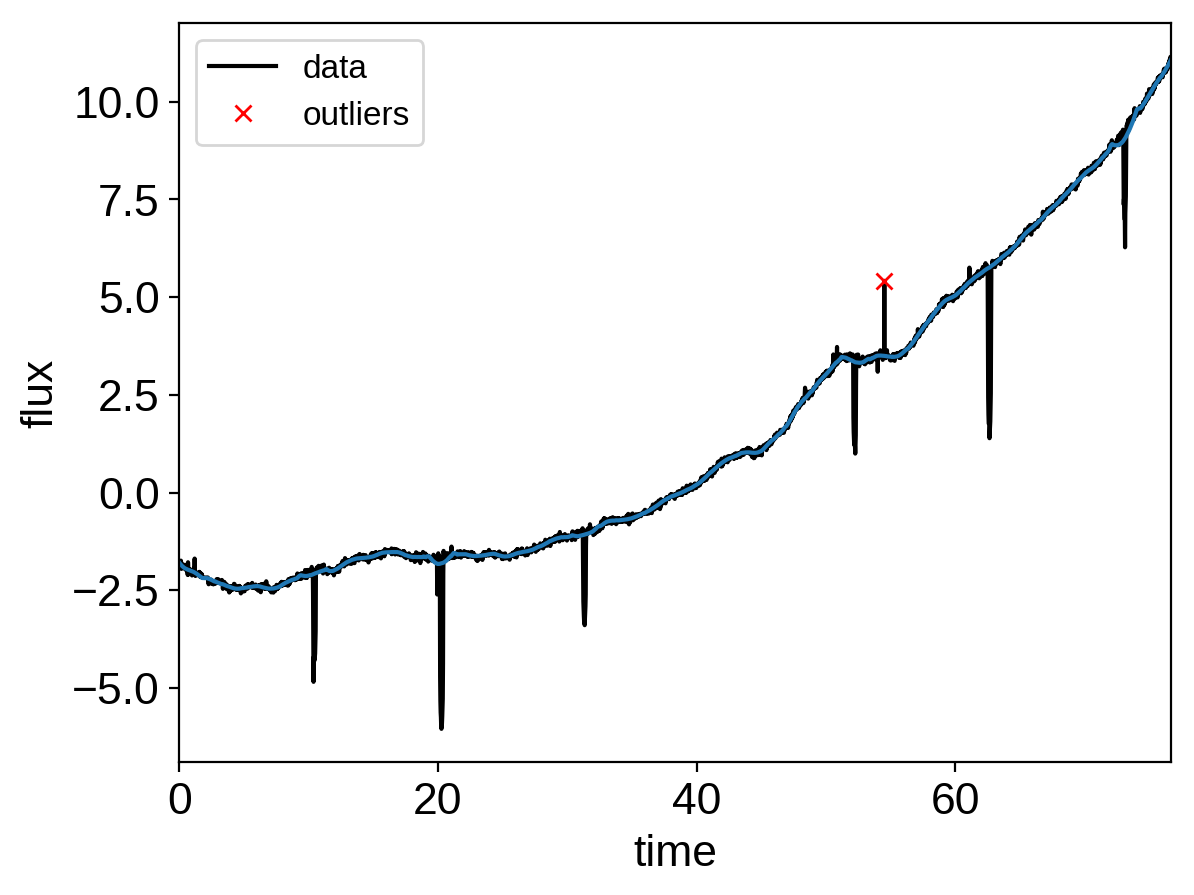

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits=[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < 3*sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0
    
# Only discard positive outliers
m = resid < 3*sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

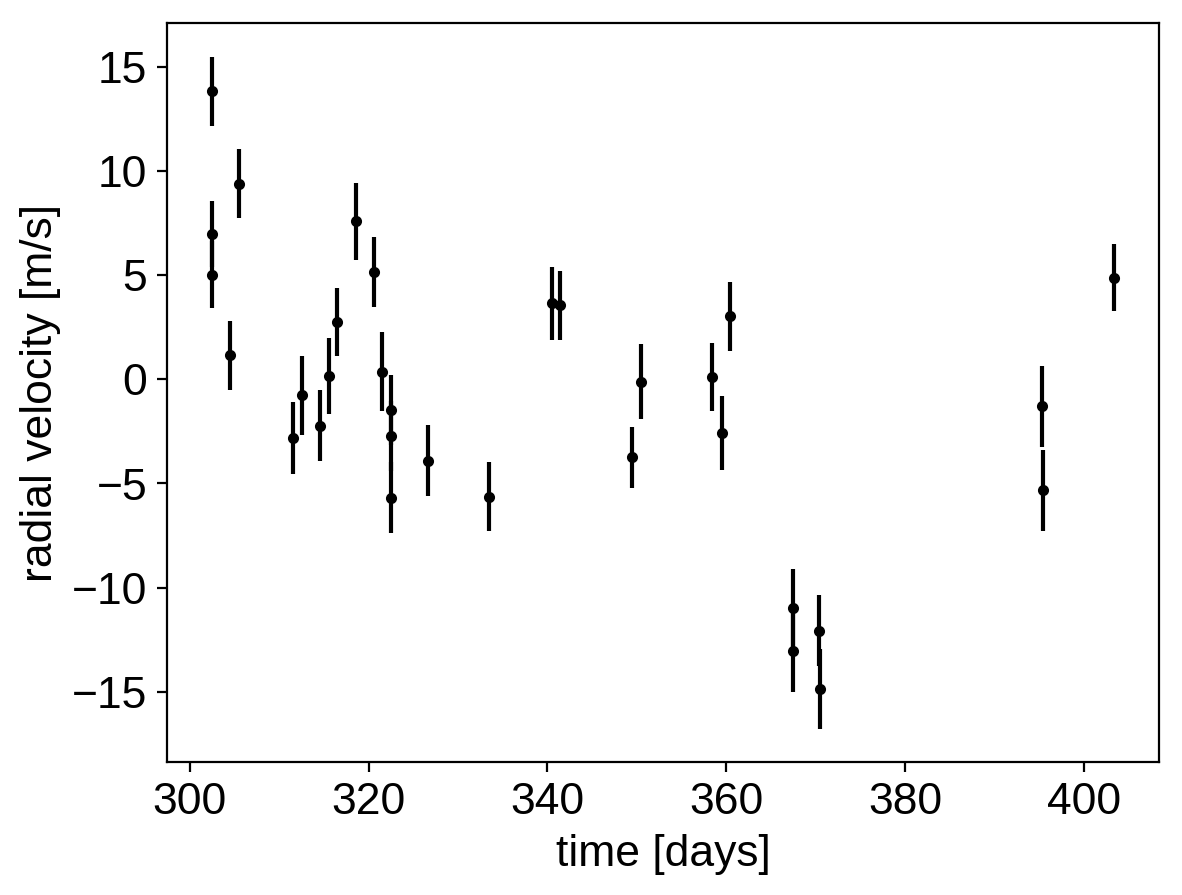

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.stats import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)
    
    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])
    
    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

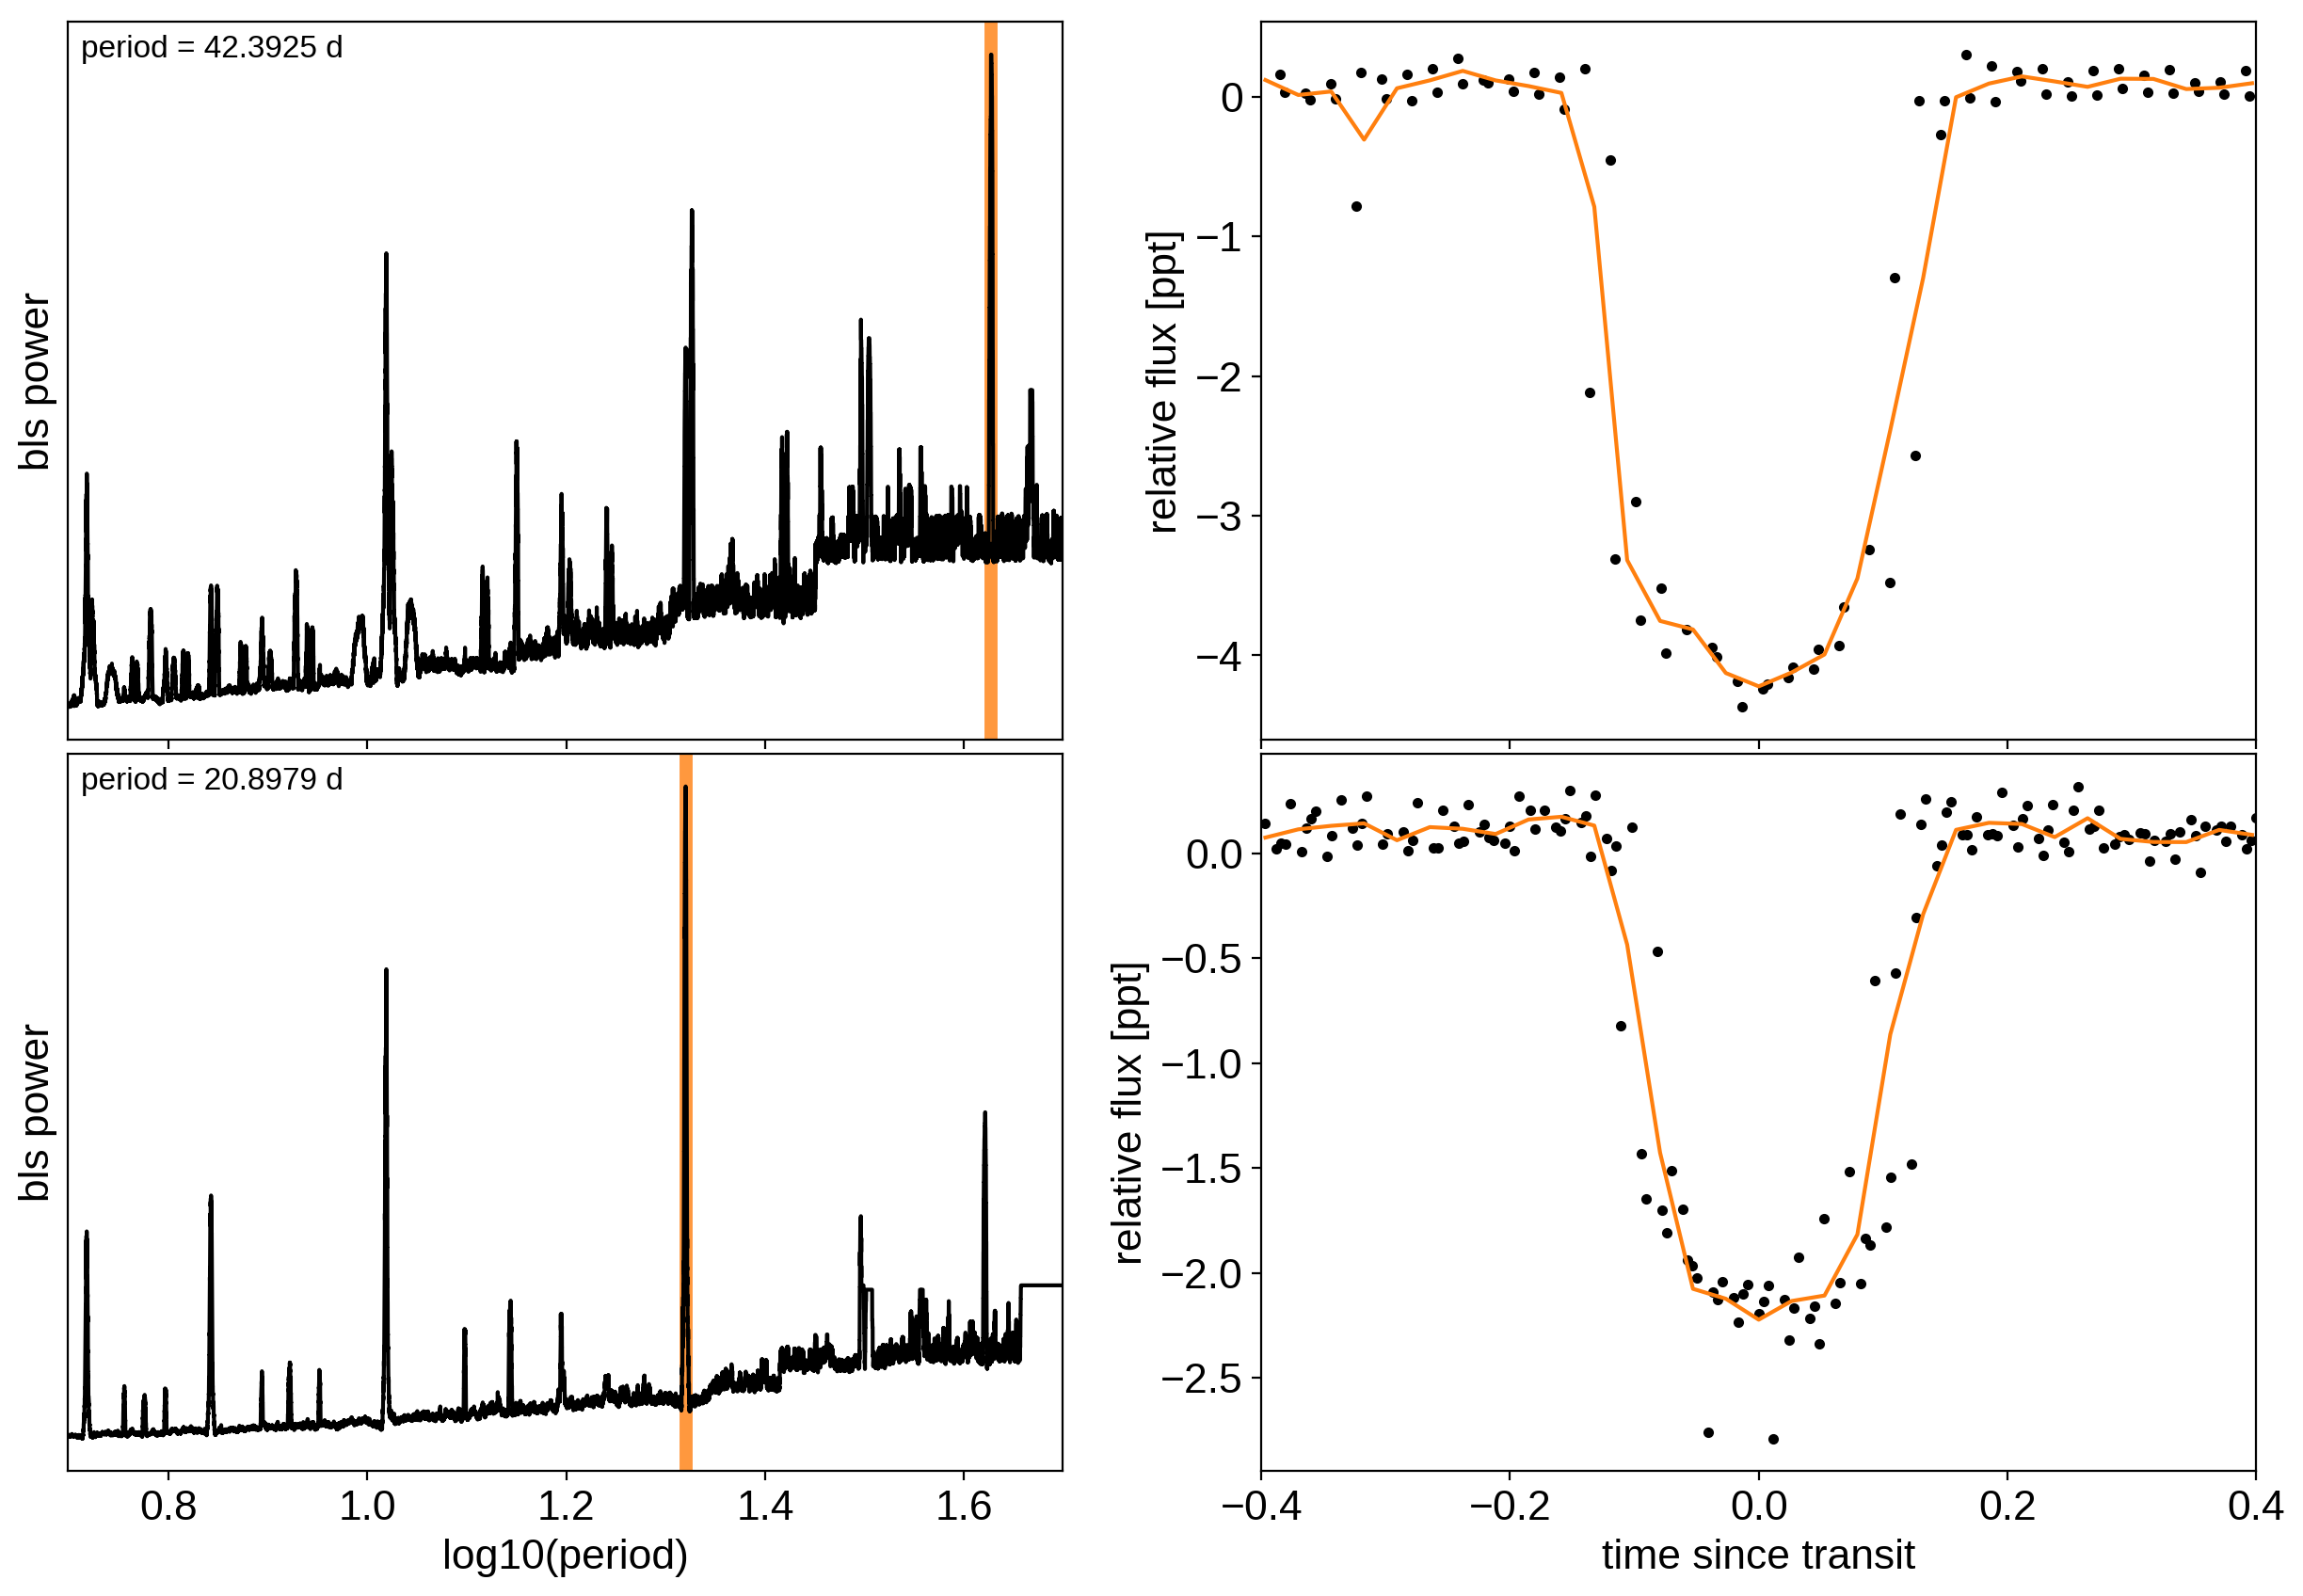

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate("period = {0:.4f} d".format(periods[i]),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")
    
    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5*p) % p - 0.5*p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")
    
    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")
        
fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0])
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = BoundedNormal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal("logr", mu=0.5*np.log(1e-3*np.array(depths)) + np.log(R_star_petigura[0]),
                         sd=1.0, shape=2)
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = pm.Uniform("b", lower=0, upper=1, shape=2, testval=0.5+np.zeros(2))
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        BoundedBeta = pm.Bound(pm.Beta, lower=0, upper=1-1e-5)
        ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03, shape=2,
                          testval=np.array([0.1, 0.1]))
        omega = xo.distributions.Angle("omega", shape=2)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b, m_planet=m_pl,
            ecc=ecc, omega=omega,
            m_planet_units=msini.unit)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        err = tt.sqrt(yerr_rv**2 + tt.exp(2*logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)
        
        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
        pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)
        map_soln = xo.optimize(start=map_soln, vars=[logm, ecc, omega])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [10]:
model0, map_soln0 = build_model()

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -8250.57231984769 -> -8233.97212654762


optimizing logp for variables: ['logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -8233.97212654762 -> 1985.195383239681


optimizing logp for variables: ['b_interval__', 'logr']


message: Desired error not necessarily achieved due to precision loss.
logp: 1985.195383239681 -> 2679.698306510712


optimizing logp for variables: ['t0', 'logP']


message: Optimization terminated successfully.
logp: 2679.698306510712 -> 3334.212159864848


optimizing logp for variables: ['logpower', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: 3334.212159864848 -> 4291.602781588809


optimizing logp for variables: ['logw0']


message: Optimization terminated successfully.
logp: 4291.602781588809 -> 4365.5548660197555


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_interval__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 4365.5548660197555 -> 4777.101722837622


optimizing logp for variables: ['omega_angle__', 'ecc_interval__', 'logm']


message: Optimization terminated successfully.
logp: 4777.101722837622 -> 4777.101722837622


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_interval__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 4777.101722837622 -> 4777.101722837622


Now let's plot the map radial velocity model.

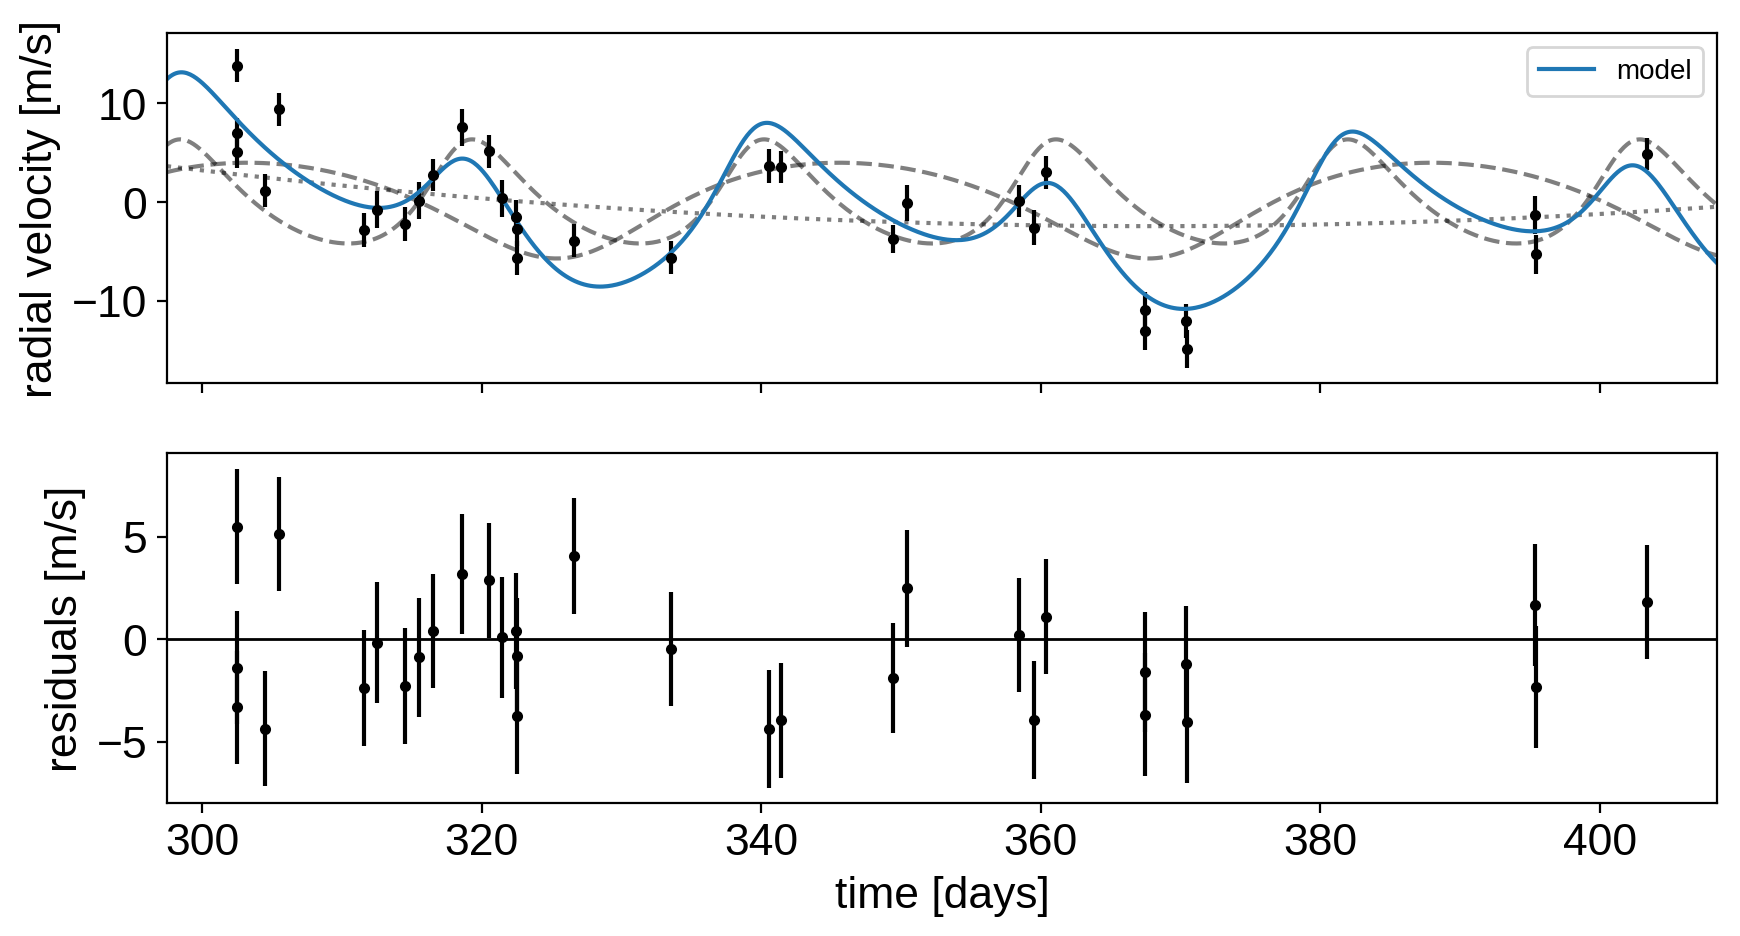

In [11]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2+np.exp(2*soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")
    
plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

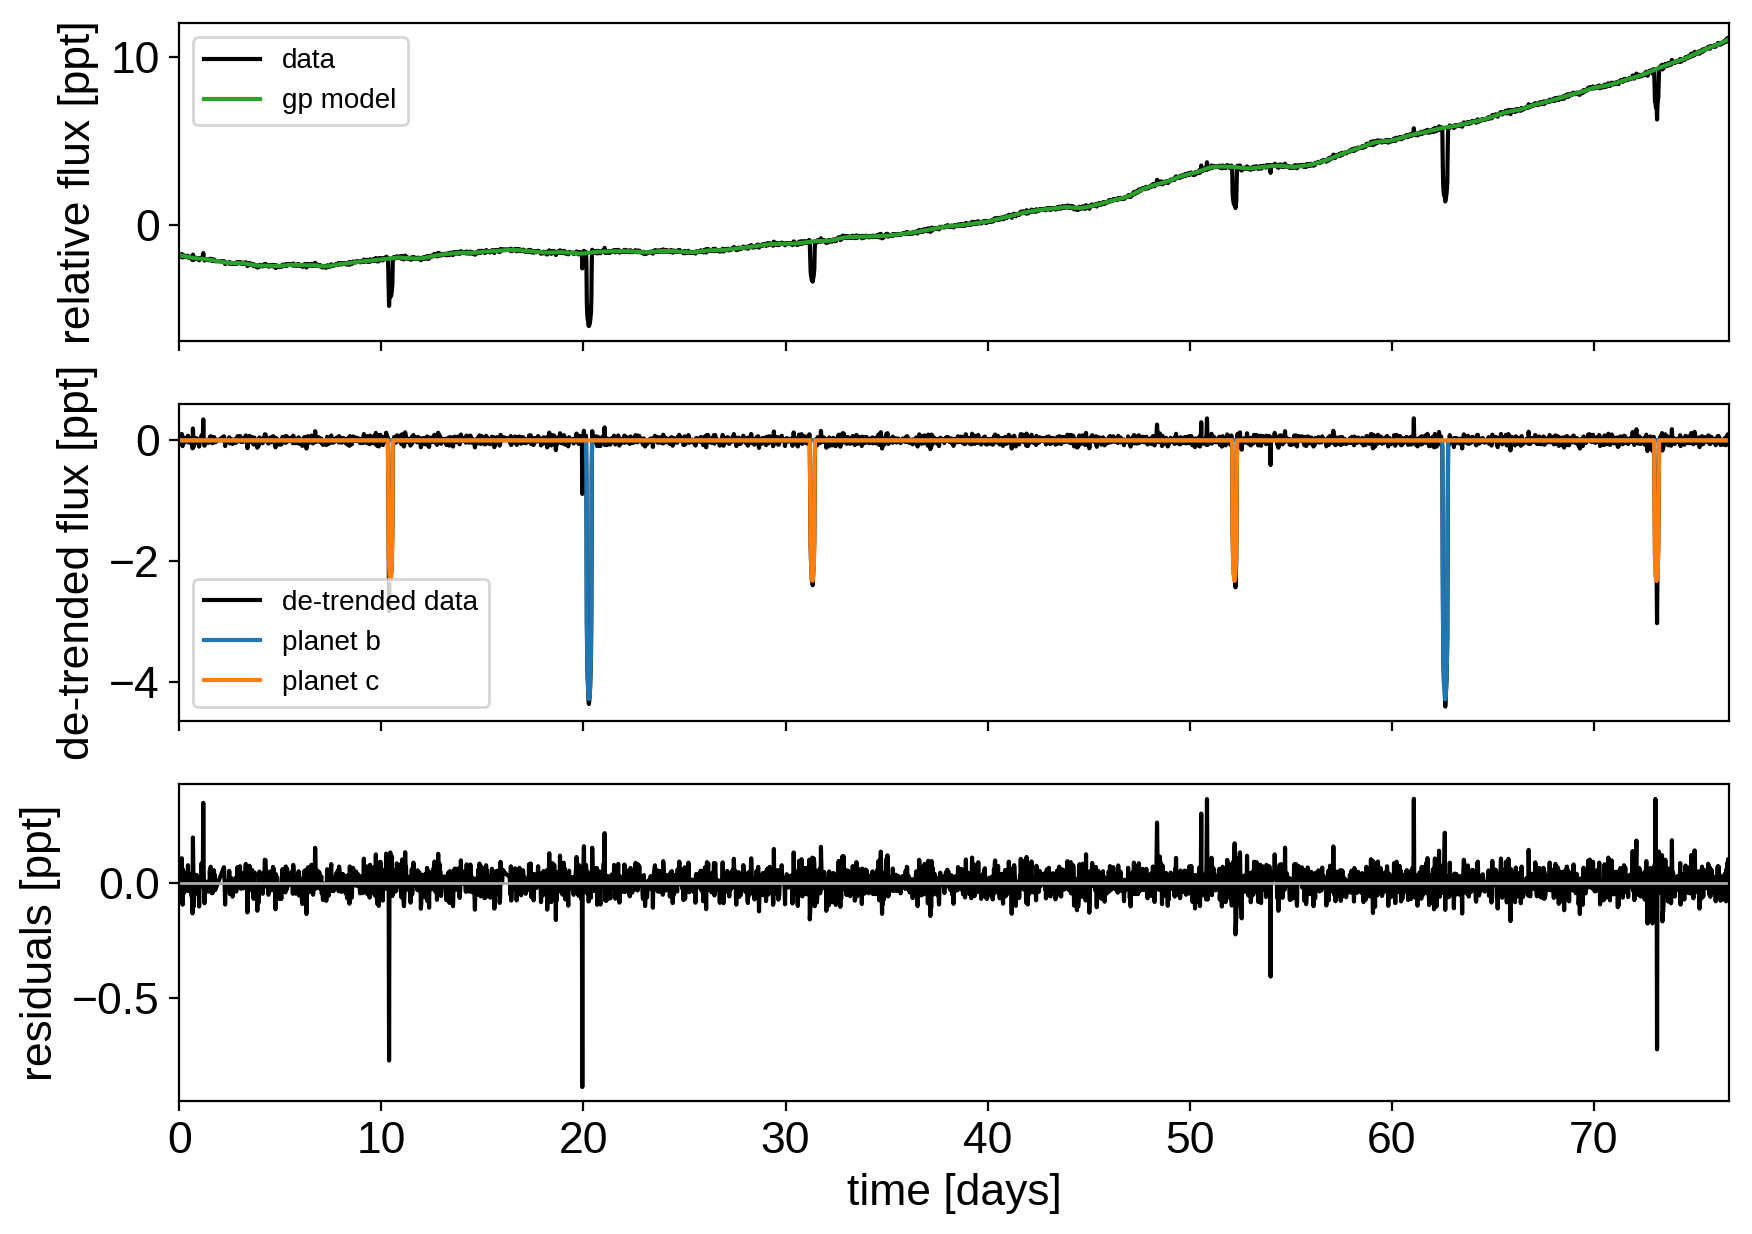

In [12]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

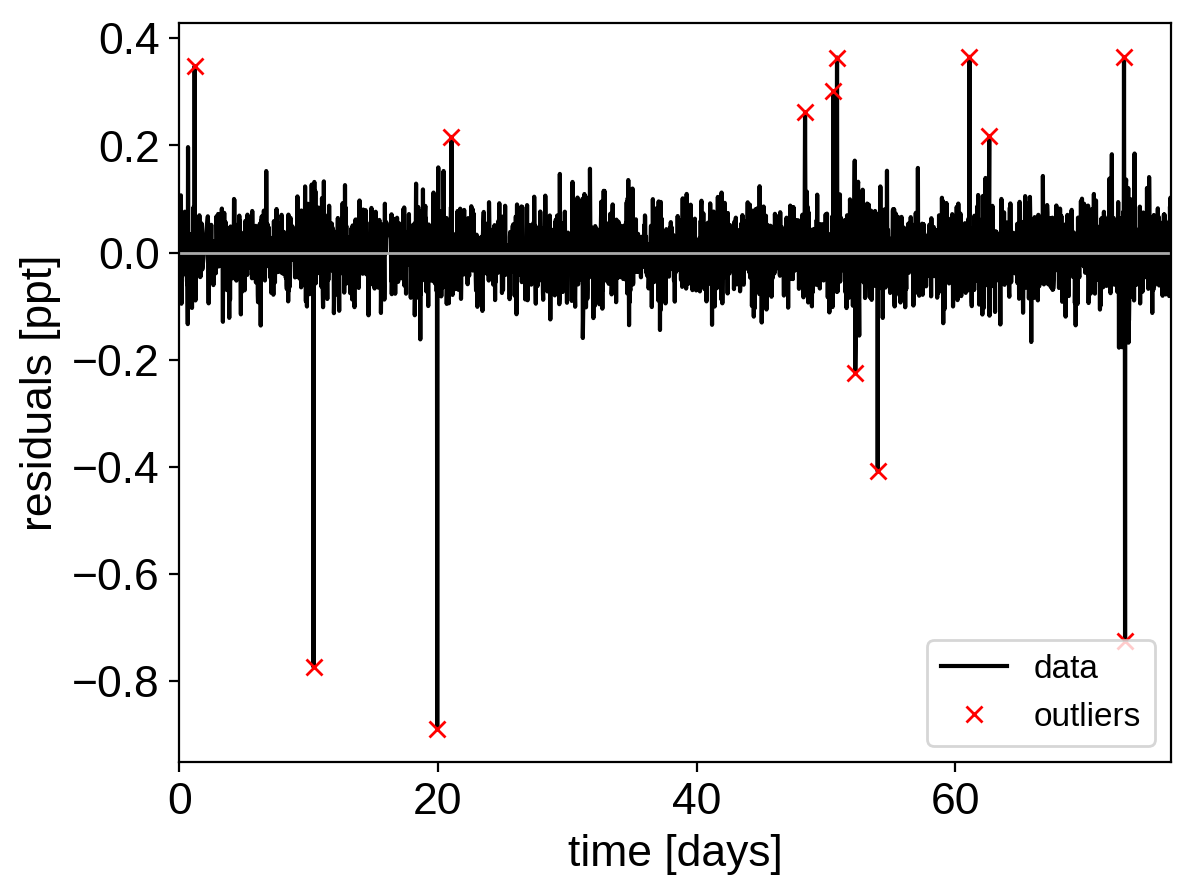

In [13]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: 5227.105412032462 -> 5227.105412032462


optimizing logp for variables: ['logs2']


message: Optimization terminated successfully.
logp: 5227.105412032462 -> 5309.207348697189


optimizing logp for variables: ['b_interval__', 'logr']


message: Optimization terminated successfully.
logp: 5309.207348697189 -> 5320.193148825561


optimizing logp for variables: ['t0', 'logP']


message: Optimization terminated successfully.
logp: 5320.193148825561 -> 5321.576486156697


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 5321.576486156697 -> 5322.307788902879


optimizing logp for variables: ['logw0']


message: Desired error not necessarily achieved due to precision loss.
logp: 5322.307788902879 -> 5322.341939711028


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_interval__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 5322.341939711028 -> 5324.305673577942


optimizing logp for variables: ['omega_angle__', 'ecc_interval__', 'logm']


message: Desired error not necessarily achieved due to precision loss.
logp: 5324.305673577942 -> 5324.305673578046


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_interval__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 5324.305673578046 -> 5324.305673578065


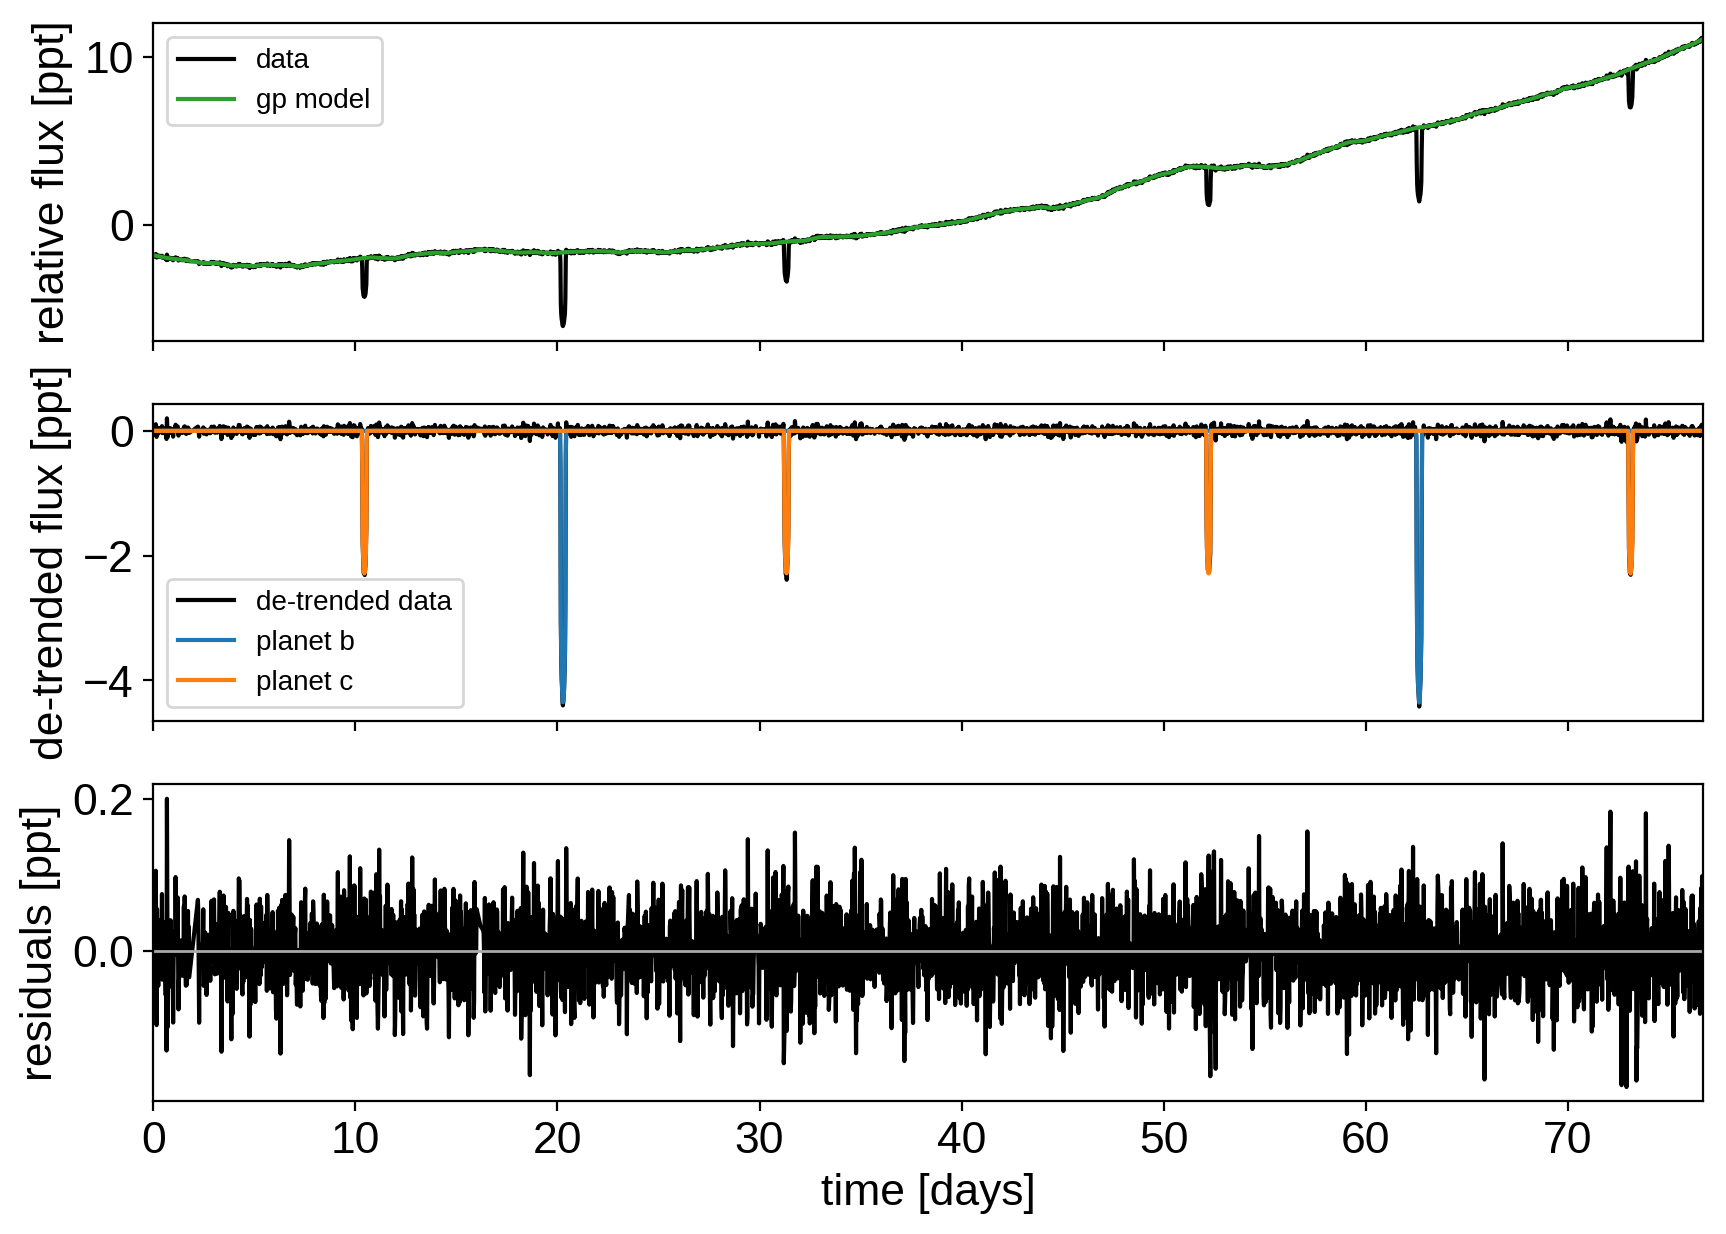

In [14]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [15]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(finish=500, chains=4)
with model:
    burnin = sampler.tune(tune=4500, start=map_soln,
                          step_kwargs=dict(target_accept=0.95))

Sampling 4 chains:   0%|          | 0/308 [00:00<?, ?draws/s]

Sampling 4 chains:   7%|▋         | 21/308 [00:00<00:09, 31.19draws/s]

Sampling 4 chains:   8%|▊         | 25/308 [00:01<00:19, 14.81draws/s]

Sampling 4 chains:   9%|▉         | 29/308 [00:01<00:25, 10.86draws/s]

Sampling 4 chains:  11%|█         | 33/308 [00:02<00:30,  9.16draws/s]

Sampling 4 chains:  12%|█▏        | 37/308 [00:03<00:32,  8.26draws/s]

Sampling 4 chains:  13%|█▎        | 41/308 [00:03<00:34,  7.72draws/s]

Sampling 4 chains:  15%|█▍        | 45/308 [00:04<00:35,  7.39draws/s]

Sampling 4 chains:  16%|█▌        | 49/308 [00:04<00:36,  7.17draws/s]

Sampling 4 chains:  17%|█▋        | 53/308 [00:05<00:36,  7.03draws/s]

Sampling 4 chains:  19%|█▊        | 57/308 [00:06<00:36,  6.93draws/s]

Sampling 4 chains:  20%|█▉        | 61/308 [00:06<00:35,  6.87draws/s]

Sampling 4 chains:  21%|██        | 65/308 [00:07<00:35,  6.82draws/s]

Sampling 4 chains:  22%|██▏       | 69/308 [00:07<00:35,  6.79draws/s]

Sampling 4 chains:  24%|██▎       | 73/308 [00:08<00:34,  6.77draws/s]

Sampling 4 chains:  25%|██▍       | 76/308 [00:08<00:26,  8.78draws/s]

Sampling 4 chains:  25%|██▌       | 78/308 [00:09<00:37,  6.07draws/s]

Sampling 4 chains:  26%|██▋       | 81/308 [00:09<00:37,  5.98draws/s]

Sampling 4 chains:  27%|██▋       | 83/308 [00:09<00:30,  7.47draws/s]

Sampling 4 chains:  28%|██▊       | 85/308 [00:10<00:37,  6.02draws/s]

Sampling 4 chains:  28%|██▊       | 87/308 [00:10<00:29,  7.45draws/s]

Sampling 4 chains:  29%|██▉       | 89/308 [00:10<00:36,  6.06draws/s]

Sampling 4 chains:  30%|██▉       | 91/308 [00:10<00:29,  7.43draws/s]

Sampling 4 chains:  30%|███       | 93/308 [00:11<00:35,  6.08draws/s]

Sampling 4 chains:  31%|███       | 94/308 [00:11<00:31,  6.85draws/s]

Sampling 4 chains:  31%|███▏      | 97/308 [00:11<00:31,  6.61draws/s]

Sampling 4 chains:  32%|███▏      | 98/308 [00:12<00:29,  7.20draws/s]

Sampling 4 chains:  33%|███▎      | 101/308 [00:12<00:30,  6.86draws/s]

Sampling 4 chains:  33%|███▎      | 102/308 [00:12<00:28,  7.30draws/s]

Sampling 4 chains:  34%|███▍      | 105/308 [00:13<00:29,  6.96draws/s]

Sampling 4 chains:  34%|███▍      | 106/308 [00:13<00:27,  7.28draws/s]

Sampling 4 chains:  35%|███▌      | 109/308 [00:13<00:28,  6.97draws/s]

Sampling 4 chains:  36%|███▌      | 110/308 [00:13<00:27,  7.21draws/s]

Sampling 4 chains:  37%|███▋      | 113/308 [00:14<00:28,  6.95draws/s]

Sampling 4 chains:  37%|███▋      | 114/308 [00:14<00:27,  7.12draws/s]

Sampling 4 chains:  38%|███▊      | 117/308 [00:14<00:27,  6.92draws/s]

Sampling 4 chains:  38%|███▊      | 118/308 [00:15<00:28,  6.69draws/s]

Sampling 4 chains:  39%|███▉      | 121/308 [00:15<00:28,  6.67draws/s]

Sampling 4 chains:  40%|███▉      | 122/308 [00:15<00:28,  6.63draws/s]

Sampling 4 chains:  41%|████      | 125/308 [00:16<00:27,  6.66draws/s]

Sampling 4 chains:  41%|████      | 126/308 [00:16<00:27,  6.58draws/s]

Sampling 4 chains:  42%|████▏     | 129/308 [00:16<00:26,  6.65draws/s]

Sampling 4 chains:  42%|████▏     | 130/308 [00:16<00:28,  6.35draws/s]

Sampling 4 chains:  43%|████▎     | 133/308 [00:17<00:27,  6.48draws/s]

Sampling 4 chains:  44%|████▎     | 134/308 [00:17<00:27,  6.36draws/s]

Sampling 4 chains:  44%|████▍     | 137/308 [00:17<00:26,  6.51draws/s]

Sampling 4 chains:  45%|████▍     | 138/308 [00:18<00:26,  6.30draws/s]

Sampling 4 chains:  46%|████▌     | 141/308 [00:18<00:25,  6.50draws/s]

Sampling 4 chains:  46%|████▌     | 142/308 [00:18<00:27,  6.12draws/s]

Sampling 4 chains:  47%|████▋     | 145/308 [00:19<00:25,  6.36draws/s]

Sampling 4 chains:  47%|████▋     | 146/308 [00:19<00:26,  6.13draws/s]

Sampling 4 chains:  48%|████▊     | 149/308 [00:19<00:24,  6.42draws/s]

Sampling 4 chains:  49%|████▊     | 150/308 [00:19<00:26,  6.03draws/s]

Sampling 4 chains:  50%|████▉     | 153/308 [00:20<00:24,  6.35draws/s]

Sampling 4 chains:  50%|█████     | 154/308 [00:20<00:25,  5.96draws/s]

Sampling 4 chains:  51%|█████     | 157/308 [00:20<00:23,  6.35draws/s]

Sampling 4 chains:  51%|█████▏    | 158/308 [00:21<00:25,  5.85draws/s]

Sampling 4 chains:  52%|█████▏    | 161/308 [00:21<00:23,  6.23draws/s]

Sampling 4 chains:  53%|█████▎    | 162/308 [00:21<00:25,  5.83draws/s]

Sampling 4 chains:  54%|█████▎    | 165/308 [00:22<00:22,  6.26draws/s]

Sampling 4 chains:  54%|█████▍    | 166/308 [00:22<00:24,  5.74draws/s]

Sampling 4 chains:  55%|█████▍    | 169/308 [00:22<00:22,  6.23draws/s]

Sampling 4 chains:  55%|█████▌    | 170/308 [00:23<00:24,  5.64draws/s]

Sampling 4 chains:  56%|█████▌    | 173/308 [00:23<00:21,  6.14draws/s]

Sampling 4 chains:  56%|█████▋    | 174/308 [00:23<00:24,  5.58draws/s]

Sampling 4 chains:  57%|█████▋    | 177/308 [00:23<00:21,  6.13draws/s]

Sampling 4 chains:  58%|█████▊    | 178/308 [00:24<00:23,  5.48draws/s]

Sampling 4 chains:  59%|█████▉    | 181/308 [00:24<00:20,  6.08draws/s]

Sampling 4 chains:  59%|█████▉    | 182/308 [00:24<00:23,  5.38draws/s]

Sampling 4 chains:  60%|██████    | 185/308 [00:25<00:20,  6.03draws/s]

Sampling 4 chains:  60%|██████    | 186/308 [00:25<00:23,  5.29draws/s]

Sampling 4 chains:  61%|██████    | 188/308 [00:25<00:17,  6.75draws/s]

Sampling 4 chains:  61%|██████▏   | 189/308 [00:25<00:21,  5.45draws/s]

Sampling 4 chains:  62%|██████▏   | 190/308 [00:26<00:23,  4.98draws/s]

Sampling 4 chains:  63%|██████▎   | 193/308 [00:26<00:20,  5.69draws/s]

Sampling 4 chains:  63%|██████▎   | 194/308 [00:26<00:22,  5.06draws/s]

Sampling 4 chains:  64%|██████▍   | 197/308 [00:26<00:19,  5.79draws/s]

Sampling 4 chains:  64%|██████▍   | 198/308 [00:27<00:21,  5.06draws/s]

Sampling 4 chains:  65%|██████▍   | 200/308 [00:27<00:16,  6.46draws/s]

Sampling 4 chains:  65%|██████▌   | 201/308 [00:27<00:19,  5.62draws/s]

Sampling 4 chains:  66%|██████▌   | 202/308 [00:27<00:21,  4.89draws/s]

Sampling 4 chains:  66%|██████▌   | 204/308 [00:27<00:16,  6.30draws/s]

Sampling 4 chains:  67%|██████▋   | 206/308 [00:28<00:18,  5.38draws/s]

Sampling 4 chains:  67%|██████▋   | 207/308 [00:28<00:16,  6.21draws/s]

Sampling 4 chains:  68%|██████▊   | 209/308 [00:28<00:14,  6.88draws/s]

Sampling 4 chains:  68%|██████▊   | 210/308 [00:29<00:18,  5.37draws/s]

Sampling 4 chains:  69%|██████▊   | 211/308 [00:29<00:15,  6.21draws/s]

Sampling 4 chains:  69%|██████▉   | 213/308 [00:29<00:13,  6.93draws/s]

Sampling 4 chains:  69%|██████▉   | 214/308 [00:29<00:17,  5.33draws/s]

Sampling 4 chains:  70%|██████▉   | 215/308 [00:29<00:15,  6.14draws/s]

Sampling 4 chains:  70%|███████   | 217/308 [00:29<00:13,  6.94draws/s]

Sampling 4 chains:  71%|███████   | 218/308 [00:30<00:17,  5.27draws/s]

Sampling 4 chains:  71%|███████   | 219/308 [00:30<00:14,  6.08draws/s]

Sampling 4 chains:  72%|███████▏  | 221/308 [00:30<00:12,  6.95draws/s]

Sampling 4 chains:  72%|███████▏  | 222/308 [00:30<00:16,  5.13draws/s]

Sampling 4 chains:  73%|███████▎  | 224/308 [00:31<00:13,  6.02draws/s]

Sampling 4 chains:  73%|███████▎  | 226/308 [00:31<00:14,  5.63draws/s]

Sampling 4 chains:  74%|███████▍  | 228/308 [00:31<00:12,  6.47draws/s]

Sampling 4 chains:  75%|███████▍  | 230/308 [00:32<00:13,  5.95draws/s]

Sampling 4 chains:  75%|███████▌  | 232/308 [00:32<00:11,  6.58draws/s]

Sampling 4 chains:  76%|███████▌  | 234/308 [00:32<00:12,  6.16draws/s]

Sampling 4 chains:  77%|███████▋  | 236/308 [00:32<00:10,  6.71draws/s]

Sampling 4 chains:  77%|███████▋  | 238/308 [00:33<00:11,  6.29draws/s]

Sampling 4 chains:  78%|███████▊  | 240/308 [00:33<00:10,  6.63draws/s]

Sampling 4 chains:  79%|███████▊  | 242/308 [00:33<00:10,  6.39draws/s]

Sampling 4 chains:  79%|███████▉  | 244/308 [00:34<00:09,  6.77draws/s]

Sampling 4 chains:  80%|███████▉  | 246/308 [00:34<00:09,  6.44draws/s]

Sampling 4 chains:  81%|████████  | 248/308 [00:34<00:08,  6.86draws/s]

Sampling 4 chains:  81%|████████  | 250/308 [00:35<00:09,  6.44draws/s]

Sampling 4 chains:  82%|████████▏ | 252/308 [00:35<00:08,  6.88draws/s]

Sampling 4 chains:  82%|████████▏ | 254/308 [00:35<00:08,  6.45draws/s]

Sampling 4 chains:  83%|████████▎ | 256/308 [00:35<00:07,  6.93draws/s]

Sampling 4 chains:  83%|████████▎ | 257/308 [00:36<00:06,  7.36draws/s]

Sampling 4 chains:  84%|████████▍ | 258/308 [00:36<00:08,  5.92draws/s]

Sampling 4 chains:  84%|████████▍ | 259/308 [00:36<00:07,  6.71draws/s]

Sampling 4 chains:  84%|████████▍ | 260/308 [00:36<00:06,  6.99draws/s]

Sampling 4 chains:  85%|████████▍ | 261/308 [00:36<00:06,  7.17draws/s]

Sampling 4 chains:  85%|████████▌ | 262/308 [00:36<00:07,  5.93draws/s]

Sampling 4 chains:  85%|████████▌ | 263/308 [00:36<00:06,  6.70draws/s]

Sampling 4 chains:  86%|████████▌ | 264/308 [00:37<00:06,  7.09draws/s]

Sampling 4 chains:  86%|████████▌ | 265/308 [00:37<00:06,  6.75draws/s]

Sampling 4 chains:  86%|████████▋ | 266/308 [00:37<00:07,  5.80draws/s]

Sampling 4 chains:  87%|████████▋ | 268/308 [00:37<00:06,  6.61draws/s]

Sampling 4 chains:  87%|████████▋ | 269/308 [00:37<00:06,  6.26draws/s]

Sampling 4 chains:  88%|████████▊ | 270/308 [00:38<00:06,  5.63draws/s]

Sampling 4 chains:  88%|████████▊ | 272/308 [00:38<00:05,  6.52draws/s]

Sampling 4 chains:  89%|████████▊ | 273/308 [00:38<00:05,  6.02draws/s]

Sampling 4 chains:  89%|████████▉ | 274/308 [00:38<00:06,  5.57draws/s]

Sampling 4 chains:  90%|████████▉ | 276/308 [00:38<00:04,  6.51draws/s]

Sampling 4 chains:  90%|████████▉ | 277/308 [00:39<00:05,  5.79draws/s]

Sampling 4 chains:  90%|█████████ | 278/308 [00:39<00:05,  5.55draws/s]

Sampling 4 chains:  91%|█████████ | 280/308 [00:39<00:04,  6.54draws/s]

Sampling 4 chains:  91%|█████████ | 281/308 [00:39<00:04,  5.64draws/s]

Sampling 4 chains:  92%|█████████▏| 282/308 [00:39<00:04,  5.54draws/s]

Sampling 4 chains:  92%|█████████▏| 284/308 [00:40<00:03,  6.58draws/s]

Sampling 4 chains:  93%|█████████▎| 285/308 [00:40<00:04,  5.26draws/s]

Sampling 4 chains:  93%|█████████▎| 286/308 [00:40<00:03,  5.57draws/s]

Sampling 4 chains:  94%|█████████▎| 288/308 [00:40<00:03,  6.56draws/s]

Sampling 4 chains:  94%|█████████▍| 289/308 [00:40<00:03,  5.26draws/s]

Sampling 4 chains:  94%|█████████▍| 290/308 [00:41<00:03,  5.67draws/s]

Sampling 4 chains:  95%|█████████▍| 292/308 [00:41<00:02,  6.70draws/s]

Sampling 4 chains:  95%|█████████▌| 293/308 [00:41<00:02,  5.19draws/s]

Sampling 4 chains:  95%|█████████▌| 294/308 [00:41<00:02,  5.64draws/s]

Sampling 4 chains:  96%|█████████▌| 296/308 [00:41<00:01,  6.76draws/s]

Sampling 4 chains:  96%|█████████▋| 297/308 [00:42<00:02,  5.09draws/s]

Sampling 4 chains:  97%|█████████▋| 298/308 [00:42<00:01,  5.64draws/s]

Sampling 4 chains:  97%|█████████▋| 300/308 [00:42<00:01,  6.81draws/s]

Sampling 4 chains:  98%|█████████▊| 301/308 [00:42<00:01,  4.99draws/s]

Sampling 4 chains:  98%|█████████▊| 302/308 [00:42<00:01,  5.64draws/s]

Sampling 4 chains:  99%|█████████▊| 304/308 [00:43<00:00,  5.08draws/s]

Sampling 4 chains:  99%|█████████▉| 305/308 [00:44<00:01,  1.75draws/s]

Sampling 4 chains:  99%|█████████▉| 306/308 [00:45<00:01,  1.81draws/s]

Sampling 4 chains: 100%|██████████| 308/308 [00:45<00:00,  2.17draws/s]

Sampling 4 chains:   0%|          | 0/108 [00:00<?, ?draws/s]

Sampling 4 chains:  19%|█▉        | 21/108 [00:00<00:02, 30.53draws/s]

Sampling 4 chains:  23%|██▎       | 25/108 [00:01<00:05, 14.67draws/s]

Sampling 4 chains:  27%|██▋       | 29/108 [00:01<00:07, 10.76draws/s]

Sampling 4 chains:  31%|███       | 33/108 [00:02<00:08,  9.05draws/s]

Sampling 4 chains:  34%|███▍      | 37/108 [00:03<00:08,  8.10draws/s]

Sampling 4 chains:  38%|███▊      | 41/108 [00:03<00:08,  7.59draws/s]

Sampling 4 chains:  42%|████▏     | 45/108 [00:04<00:08,  7.26draws/s]

Sampling 4 chains:  45%|████▌     | 49/108 [00:04<00:08,  7.03draws/s]

Sampling 4 chains:  50%|█████     | 54/108 [00:05<00:07,  7.32draws/s]

Sampling 4 chains:  54%|█████▎    | 58/108 [00:06<00:07,  7.08draws/s]

Sampling 4 chains:  58%|█████▊    | 63/108 [00:06<00:06,  7.40draws/s]

Sampling 4 chains:  62%|██████▏   | 67/108 [00:07<00:05,  7.16draws/s]

Sampling 4 chains:  66%|██████▌   | 71/108 [00:07<00:05,  6.99draws/s]

Sampling 4 chains:  69%|██████▊   | 74/108 [00:08<00:03,  9.07draws/s]

Sampling 4 chains:  70%|███████   | 76/108 [00:08<00:04,  6.48draws/s]

Sampling 4 chains:  72%|███████▏  | 78/108 [00:08<00:03,  8.11draws/s]

Sampling 4 chains:  74%|███████▍  | 80/108 [00:09<00:04,  6.19draws/s]

Sampling 4 chains:  76%|███████▌  | 82/108 [00:09<00:03,  7.75draws/s]

Sampling 4 chains:  79%|███████▊  | 85/108 [00:09<00:03,  7.11draws/s]

Sampling 4 chains:  81%|████████  | 87/108 [00:09<00:02,  8.75draws/s]

Sampling 4 chains:  82%|████████▏ | 89/108 [00:10<00:02,  6.46draws/s]

Sampling 4 chains:  84%|████████▍ | 91/108 [00:10<00:02,  8.01draws/s]

Sampling 4 chains:  86%|████████▌ | 93/108 [00:11<00:02,  6.19draws/s]

Sampling 4 chains:  89%|████████▉ | 96/108 [00:11<00:01,  7.93draws/s]

Sampling 4 chains:  91%|█████████ | 98/108 [00:11<00:01,  6.18draws/s]

Sampling 4 chains:  93%|█████████▎| 100/108 [00:11<00:01,  7.61draws/s]

Sampling 4 chains:  94%|█████████▍| 102/108 [00:12<00:01,  5.85draws/s]

Sampling 4 chains:  96%|█████████▋| 104/108 [00:12<00:00,  4.62draws/s]

Sampling 4 chains:  97%|█████████▋| 105/108 [00:14<00:01,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 106/108 [00:14<00:00,  2.56draws/s]

Sampling 4 chains:  99%|█████████▉| 107/108 [00:14<00:00,  2.29draws/s]

Sampling 4 chains: 100%|██████████| 108/108 [00:15<00:00,  2.06draws/s]

Sampling 4 chains:   0%|          | 0/208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/208 [00:00<02:13,  1.55draws/s]

Sampling 4 chains:   2%|▏         | 5/208 [00:01<01:41,  2.00draws/s]

Sampling 4 chains:   4%|▍         | 9/208 [00:01<01:18,  2.52draws/s]

Sampling 4 chains:   6%|▋         | 13/208 [00:02<01:03,  3.07draws/s]

Sampling 4 chains:   8%|▊         | 17/208 [00:03<00:52,  3.64draws/s]

Sampling 4 chains:  10%|█         | 21/208 [00:03<00:44,  4.18draws/s]

Sampling 4 chains:  12%|█▏        | 25/208 [00:04<00:39,  4.68draws/s]

Sampling 4 chains:  14%|█▍        | 29/208 [00:05<00:35,  5.10draws/s]

Sampling 4 chains:  16%|█▌        | 33/208 [00:05<00:32,  5.44draws/s]

Sampling 4 chains:  18%|█▊        | 37/208 [00:06<00:30,  5.70draws/s]

Sampling 4 chains:  20%|█▉        | 41/208 [00:06<00:28,  5.90draws/s]

Sampling 4 chains:  22%|██▏       | 45/208 [00:07<00:26,  6.04draws/s]

Sampling 4 chains:  23%|██▎       | 47/208 [00:07<00:21,  7.60draws/s]

Sampling 4 chains:  24%|██▎       | 49/208 [00:08<00:27,  5.85draws/s]

Sampling 4 chains:  25%|██▍       | 51/208 [00:08<00:21,  7.24draws/s]

Sampling 4 chains:  25%|██▌       | 53/208 [00:08<00:26,  5.80draws/s]

Sampling 4 chains:  26%|██▌       | 54/208 [00:08<00:23,  6.63draws/s]

Sampling 4 chains:  27%|██▋       | 57/208 [00:09<00:23,  6.32draws/s]

Sampling 4 chains:  28%|██▊       | 58/208 [00:09<00:22,  6.68draws/s]

Sampling 4 chains:  29%|██▉       | 61/208 [00:10<00:22,  6.49draws/s]

Sampling 4 chains:  30%|██▉       | 62/208 [00:10<00:21,  6.65draws/s]

Sampling 4 chains:  31%|███▏      | 65/208 [00:10<00:21,  6.52draws/s]

Sampling 4 chains:  32%|███▏      | 66/208 [00:10<00:21,  6.51draws/s]

Sampling 4 chains:  33%|███▎      | 69/208 [00:11<00:21,  6.48draws/s]

Sampling 4 chains:  34%|███▎      | 70/208 [00:11<00:21,  6.31draws/s]

Sampling 4 chains:  35%|███▌      | 73/208 [00:11<00:21,  6.38draws/s]

Sampling 4 chains:  36%|███▌      | 74/208 [00:12<00:21,  6.24draws/s]

Sampling 4 chains:  37%|███▋      | 77/208 [00:12<00:20,  6.33draws/s]

Sampling 4 chains:  38%|███▊      | 78/208 [00:12<00:21,  6.14draws/s]

Sampling 4 chains:  39%|███▉      | 81/208 [00:13<00:20,  6.27draws/s]

Sampling 4 chains:  39%|███▉      | 82/208 [00:13<00:20,  6.04draws/s]

Sampling 4 chains:  41%|████      | 85/208 [00:13<00:19,  6.24draws/s]

Sampling 4 chains:  41%|████▏     | 86/208 [00:13<00:20,  5.91draws/s]

Sampling 4 chains:  43%|████▎     | 89/208 [00:14<00:19,  6.19draws/s]

Sampling 4 chains:  43%|████▎     | 90/208 [00:14<00:20,  5.81draws/s]

Sampling 4 chains:  45%|████▍     | 93/208 [00:15<00:18,  6.16draws/s]

Sampling 4 chains:  45%|████▌     | 94/208 [00:15<00:20,  5.68draws/s]

Sampling 4 chains:  47%|████▋     | 97/208 [00:15<00:18,  6.07draws/s]

Sampling 4 chains:  47%|████▋     | 98/208 [00:15<00:19,  5.57draws/s]

Sampling 4 chains:  49%|████▊     | 101/208 [00:16<00:17,  6.01draws/s]

Sampling 4 chains:  49%|████▉     | 102/208 [00:16<00:19,  5.48draws/s]

Sampling 4 chains:  50%|█████     | 104/208 [00:16<00:14,  6.98draws/s]

Sampling 4 chains:  50%|█████     | 105/208 [00:16<00:19,  5.30draws/s]

Sampling 4 chains:  51%|█████     | 106/208 [00:17<00:20,  4.99draws/s]

Sampling 4 chains:  52%|█████▏    | 108/208 [00:17<00:15,  6.36draws/s]

Sampling 4 chains:  53%|█████▎    | 110/208 [00:17<00:18,  5.32draws/s]

Sampling 4 chains:  54%|█████▍    | 112/208 [00:17<00:14,  6.73draws/s]

Sampling 4 chains:  55%|█████▍    | 114/208 [00:18<00:17,  5.52draws/s]

Sampling 4 chains:  56%|█████▌    | 116/208 [00:18<00:13,  6.90draws/s]

Sampling 4 chains:  57%|█████▋    | 118/208 [00:18<00:15,  5.64draws/s]

Sampling 4 chains:  58%|█████▊    | 120/208 [00:19<00:12,  6.98draws/s]

Sampling 4 chains:  59%|█████▊    | 122/208 [00:19<00:15,  5.71draws/s]

Sampling 4 chains:  60%|█████▉    | 124/208 [00:19<00:12,  6.95draws/s]

Sampling 4 chains:  61%|██████    | 126/208 [00:20<00:14,  5.74draws/s]

Sampling 4 chains:  62%|██████▏   | 128/208 [00:20<00:11,  6.95draws/s]

Sampling 4 chains:  62%|██████▎   | 130/208 [00:20<00:13,  5.79draws/s]

Sampling 4 chains:  63%|██████▎   | 132/208 [00:21<00:10,  6.95draws/s]

Sampling 4 chains:  64%|██████▍   | 133/208 [00:21<00:11,  6.35draws/s]

Sampling 4 chains:  64%|██████▍   | 134/208 [00:21<00:14,  5.11draws/s]

Sampling 4 chains:  65%|██████▌   | 136/208 [00:21<00:11,  6.19draws/s]

Sampling 4 chains:  66%|██████▌   | 137/208 [00:21<00:11,  6.14draws/s]

Sampling 4 chains:  66%|██████▋   | 138/208 [00:22<00:14,  4.94draws/s]

Sampling 4 chains:  67%|██████▋   | 140/208 [00:22<00:11,  5.92draws/s]

Sampling 4 chains:  68%|██████▊   | 141/208 [00:22<00:11,  5.94draws/s]

Sampling 4 chains:  68%|██████▊   | 142/208 [00:22<00:13,  4.89draws/s]

Sampling 4 chains:  69%|██████▉   | 144/208 [00:22<00:10,  5.87draws/s]

Sampling 4 chains:  70%|██████▉   | 145/208 [00:23<00:10,  6.17draws/s]

Sampling 4 chains:  70%|███████   | 146/208 [00:23<00:12,  4.87draws/s]

Sampling 4 chains:  71%|███████   | 148/208 [00:23<00:10,  5.82draws/s]

Sampling 4 chains:  72%|███████▏  | 149/208 [00:23<00:09,  6.42draws/s]

Sampling 4 chains:  72%|███████▏  | 150/208 [00:24<00:12,  4.75draws/s]

Sampling 4 chains:  73%|███████▎  | 152/208 [00:24<00:09,  5.69draws/s]

Sampling 4 chains:  74%|███████▍  | 154/208 [00:24<00:10,  5.26draws/s]

Sampling 4 chains:  75%|███████▌  | 156/208 [00:24<00:08,  6.17draws/s]

Sampling 4 chains:  76%|███████▌  | 158/208 [00:25<00:08,  5.59draws/s]

Sampling 4 chains:  77%|███████▋  | 160/208 [00:25<00:07,  6.46draws/s]

Sampling 4 chains:  78%|███████▊  | 162/208 [00:25<00:08,  5.69draws/s]

Sampling 4 chains:  79%|███████▉  | 164/208 [00:26<00:06,  6.64draws/s]

Sampling 4 chains:  80%|███████▉  | 166/208 [00:26<00:07,  5.84draws/s]

Sampling 4 chains:  81%|████████  | 168/208 [00:26<00:05,  6.72draws/s]

Sampling 4 chains:  82%|████████▏ | 170/208 [00:27<00:06,  5.77draws/s]

Sampling 4 chains:  83%|████████▎ | 172/208 [00:27<00:05,  6.80draws/s]

Sampling 4 chains:  84%|████████▎ | 174/208 [00:27<00:05,  5.83draws/s]

Sampling 4 chains:  85%|████████▍ | 176/208 [00:28<00:04,  6.81draws/s]

Sampling 4 chains:  86%|████████▌ | 178/208 [00:28<00:05,  5.90draws/s]

Sampling 4 chains:  87%|████████▋ | 180/208 [00:28<00:04,  6.78draws/s]

Sampling 4 chains:  88%|████████▊ | 182/208 [00:29<00:04,  5.91draws/s]

Sampling 4 chains:  88%|████████▊ | 184/208 [00:29<00:03,  6.93draws/s]

Sampling 4 chains:  89%|████████▉ | 186/208 [00:29<00:03,  5.93draws/s]

Sampling 4 chains:  90%|█████████ | 188/208 [00:29<00:02,  7.00draws/s]

Sampling 4 chains:  91%|█████████▏| 190/208 [00:30<00:03,  5.88draws/s]

Sampling 4 chains:  92%|█████████▏| 192/208 [00:30<00:02,  7.10draws/s]

Sampling 4 chains:  93%|█████████▎| 194/208 [00:30<00:02,  5.82draws/s]

Sampling 4 chains:  94%|█████████▍| 196/208 [00:31<00:01,  7.22draws/s]

Sampling 4 chains:  95%|█████████▌| 198/208 [00:31<00:01,  5.81draws/s]

Sampling 4 chains:  96%|█████████▌| 200/208 [00:31<00:01,  7.29draws/s]

Sampling 4 chains:  97%|█████████▋| 202/208 [00:32<00:01,  5.71draws/s]

Sampling 4 chains:  98%|█████████▊| 204/208 [00:32<00:00,  6.43draws/s]

Sampling 4 chains:  99%|█████████▊| 205/208 [00:34<00:01,  1.61draws/s]

Sampling 4 chains:  99%|█████████▉| 206/208 [00:34<00:01,  1.61draws/s]

Sampling 4 chains: 100%|██████████| 208/208 [00:35<00:00,  2.14draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/408 [00:00<01:16,  5.35draws/s]

Sampling 4 chains:   1%|          | 3/408 [00:00<01:21,  4.97draws/s]

Sampling 4 chains:   2%|▏         | 9/408 [00:00<00:59,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 11/408 [00:01<01:08,  5.81draws/s]

Sampling 4 chains:   3%|▎         | 13/408 [00:01<00:57,  6.91draws/s]

Sampling 4 chains:   4%|▎         | 15/408 [00:01<01:04,  6.09draws/s]

Sampling 4 chains:   4%|▍         | 18/408 [00:02<00:52,  7.45draws/s]

Sampling 4 chains:   5%|▍         | 20/408 [00:02<01:05,  5.92draws/s]

Sampling 4 chains:   5%|▌         | 22/408 [00:02<00:51,  7.46draws/s]

Sampling 4 chains:   6%|▌         | 24/408 [00:02<00:53,  7.16draws/s]

Sampling 4 chains:   6%|▋         | 26/408 [00:03<00:52,  7.33draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:03<00:56,  6.68draws/s]

Sampling 4 chains:   8%|▊         | 32/408 [00:03<00:44,  8.54draws/s]

Sampling 4 chains:   8%|▊         | 34/408 [00:04<00:58,  6.35draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:04<00:56,  6.57draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:05<01:00,  6.11draws/s]

Sampling 4 chains:  10%|▉         | 40/408 [00:05<00:48,  7.66draws/s]

Sampling 4 chains:  10%|█         | 42/408 [00:05<00:50,  7.20draws/s]

Sampling 4 chains:  11%|█         | 44/408 [00:05<00:45,  7.99draws/s]

Sampling 4 chains:  11%|█▏        | 46/408 [00:05<00:38,  9.47draws/s]

Sampling 4 chains:  12%|█▏        | 48/408 [00:06<00:53,  6.74draws/s]

Sampling 4 chains:  12%|█▏        | 49/408 [00:06<00:49,  7.29draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:06<00:55,  6.48draws/s]

Sampling 4 chains:  13%|█▎        | 52/408 [00:06<00:49,  7.12draws/s]

Sampling 4 chains:  13%|█▎        | 53/408 [00:06<00:48,  7.33draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:07<00:53,  6.60draws/s]

Sampling 4 chains:  14%|█▍        | 57/408 [00:07<00:42,  8.18draws/s]

Sampling 4 chains:  14%|█▍        | 59/408 [00:07<00:56,  6.18draws/s]

Sampling 4 chains:  15%|█▍        | 60/408 [00:08<00:49,  6.96draws/s]

Sampling 4 chains:  15%|█▌        | 62/408 [00:08<00:44,  7.75draws/s]

Sampling 4 chains:  16%|█▌        | 64/408 [00:08<00:37,  9.13draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:08<00:41,  8.23draws/s]

Sampling 4 chains:  16%|█▋        | 67/408 [00:08<00:49,  6.96draws/s]

Sampling 4 chains:  17%|█▋        | 69/408 [00:08<00:39,  8.60draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:09<00:43,  7.74draws/s]

Sampling 4 chains:  18%|█▊        | 73/408 [00:09<00:40,  8.31draws/s]

Sampling 4 chains:  18%|█▊        | 75/408 [00:09<00:47,  6.99draws/s]

Sampling 4 chains:  19%|█▉        | 77/408 [00:10<00:44,  7.40draws/s]

Sampling 4 chains:  19%|█▉        | 78/408 [00:10<00:58,  5.68draws/s]

Sampling 4 chains:  20%|█▉        | 80/408 [00:10<00:47,  6.89draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:10<00:53,  6.13draws/s]

Sampling 4 chains:  20%|██        | 82/408 [00:10<01:02,  5.20draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:11<00:50,  6.37draws/s]

Sampling 4 chains:  21%|██        | 85/408 [00:11<00:55,  5.79draws/s]

Sampling 4 chains:  21%|██        | 86/408 [00:11<01:02,  5.13draws/s]

Sampling 4 chains:  22%|██▏       | 88/408 [00:11<00:51,  6.23draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:11<00:42,  7.41draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:12<01:04,  4.90draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:12<00:54,  5.77draws/s]

Sampling 4 chains:  23%|██▎       | 94/408 [00:12<00:44,  7.03draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:12<00:48,  6.48draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:12<00:43,  7.12draws/s]

Sampling 4 chains:  24%|██▍       | 99/408 [00:13<00:37,  8.33draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:13<00:48,  6.39draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:13<00:39,  7.75draws/s]

Sampling 4 chains:  26%|██▌       | 105/408 [00:14<00:49,  6.09draws/s]

Sampling 4 chains:  26%|██▌       | 107/408 [00:14<00:39,  7.56draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:14<00:50,  5.92draws/s]

Sampling 4 chains:  27%|██▋       | 111/408 [00:14<00:40,  7.35draws/s]

Sampling 4 chains:  28%|██▊       | 113/408 [00:15<00:41,  7.03draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:15<00:45,  6.42draws/s]

Sampling 4 chains:  28%|██▊       | 116/408 [00:15<00:36,  7.96draws/s]

Sampling 4 chains:  29%|██▉       | 118/408 [00:16<00:47,  6.09draws/s]

Sampling 4 chains:  30%|██▉       | 121/408 [00:16<00:42,  6.78draws/s]

Sampling 4 chains:  30%|███       | 123/408 [00:16<00:35,  8.06draws/s]

Sampling 4 chains:  31%|███       | 125/408 [00:17<00:45,  6.25draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:17<00:37,  7.55draws/s]

Sampling 4 chains:  32%|███▏      | 129/408 [00:17<00:46,  6.06draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:17<00:37,  7.31draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:18<00:39,  7.02draws/s]

Sampling 4 chains:  33%|███▎      | 134/408 [00:18<00:40,  6.72draws/s]

Sampling 4 chains:  33%|███▎      | 136/408 [00:18<00:34,  7.92draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:18<00:43,  6.28draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:19<00:35,  7.47draws/s]

Sampling 4 chains:  35%|███▍      | 142/408 [00:19<00:43,  6.13draws/s]

Sampling 4 chains:  35%|███▌      | 144/408 [00:19<00:36,  7.24draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:20<00:43,  6.06draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:20<00:36,  7.12draws/s]

Sampling 4 chains:  37%|███▋      | 150/408 [00:20<00:42,  6.06draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:20<00:35,  7.13draws/s]

Sampling 4 chains:  38%|███▊      | 154/408 [00:21<00:30,  8.34draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [00:21<00:34,  7.23draws/s]

Sampling 4 chains:  39%|███▊      | 158/408 [00:21<00:29,  8.58draws/s]

Sampling 4 chains:  39%|███▉      | 160/408 [00:22<00:38,  6.49draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:22<00:31,  7.85draws/s]

Sampling 4 chains:  40%|████      | 164/408 [00:22<00:39,  6.23draws/s]

Sampling 4 chains:  41%|████      | 166/408 [00:22<00:32,  7.51draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:23<00:39,  6.09draws/s]

Sampling 4 chains:  42%|████▏     | 170/408 [00:23<00:32,  7.29draws/s]

Sampling 4 chains:  42%|████▏     | 172/408 [00:23<00:39,  6.05draws/s]

Sampling 4 chains:  43%|████▎     | 174/408 [00:24<00:33,  6.94draws/s]

Sampling 4 chains:  43%|████▎     | 175/408 [00:24<00:39,  5.90draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [00:24<00:40,  5.68draws/s]

Sampling 4 chains:  44%|████▎     | 178/408 [00:24<00:36,  6.37draws/s]

Sampling 4 chains:  44%|████▍     | 179/408 [00:24<00:38,  5.97draws/s]

Sampling 4 chains:  44%|████▍     | 180/408 [00:25<00:39,  5.73draws/s]

Sampling 4 chains:  45%|████▍     | 182/408 [00:25<00:36,  6.19draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:25<00:30,  7.36draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [00:25<00:38,  5.87draws/s]

Sampling 4 chains:  46%|████▌     | 186/408 [00:25<00:40,  5.45draws/s]

Sampling 4 chains:  46%|████▌     | 188/408 [00:26<00:33,  6.66draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:26<00:40,  5.46draws/s]

Sampling 4 chains:  47%|████▋     | 190/408 [00:26<00:41,  5.24draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [00:26<00:33,  6.47draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:26<00:35,  6.07draws/s]

Sampling 4 chains:  48%|████▊     | 195/408 [00:27<00:33,  6.28draws/s]

Sampling 4 chains:  48%|████▊     | 196/408 [00:27<00:31,  6.68draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [00:27<00:27,  7.54draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [00:27<00:27,  7.67draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [00:27<00:29,  7.06draws/s]

Sampling 4 chains:  50%|████▉     | 203/408 [00:28<00:26,  7.82draws/s]

Sampling 4 chains:  50%|█████     | 204/408 [00:28<00:24,  8.26draws/s]

Sampling 4 chains:  50%|█████     | 206/408 [00:28<00:26,  7.67draws/s]

Sampling 4 chains:  51%|█████     | 208/408 [00:28<00:27,  7.24draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [00:28<00:23,  8.44draws/s]

Sampling 4 chains:  52%|█████▏    | 211/408 [00:29<00:24,  7.99draws/s]

Sampling 4 chains:  52%|█████▏    | 213/408 [00:29<00:27,  7.06draws/s]

Sampling 4 chains:  53%|█████▎    | 215/408 [00:29<00:22,  8.51draws/s]

Sampling 4 chains:  53%|█████▎    | 217/408 [00:30<00:29,  6.45draws/s]

Sampling 4 chains:  54%|█████▎    | 219/408 [00:30<00:24,  7.76draws/s]

Sampling 4 chains:  54%|█████▍    | 221/408 [00:30<00:28,  6.62draws/s]

Sampling 4 chains:  55%|█████▍    | 223/408 [00:30<00:23,  7.87draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:31<00:28,  6.34draws/s]

Sampling 4 chains:  56%|█████▌    | 227/408 [00:31<00:25,  7.20draws/s]

Sampling 4 chains:  56%|█████▌    | 229/408 [00:31<00:28,  6.30draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [00:32<00:25,  7.06draws/s]

Sampling 4 chains:  57%|█████▋    | 233/408 [00:32<00:20,  8.74draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [00:32<00:27,  6.24draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [00:33<00:24,  6.80draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [00:33<00:24,  6.94draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [00:33<00:25,  6.52draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [00:33<00:23,  7.10draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:34<00:22,  7.21draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:34<00:25,  6.30draws/s]

Sampling 4 chains:  62%|██████▏   | 251/408 [00:34<00:23,  6.66draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:35<00:21,  7.28draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [00:35<00:19,  7.68draws/s]

Sampling 4 chains:  63%|██████▎   | 256/408 [00:35<00:21,  7.05draws/s]

Sampling 4 chains:  63%|██████▎   | 258/408 [00:35<00:17,  8.36draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:35<00:19,  7.75draws/s]

Sampling 4 chains:  64%|██████▍   | 261/408 [00:36<00:20,  7.21draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [00:36<00:20,  7.29draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:36<00:17,  8.38draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [00:36<00:16,  8.59draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [00:36<00:21,  6.67draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [00:36<00:18,  7.67draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [00:37<00:21,  6.38draws/s]

Sampling 4 chains:  66%|██████▋   | 271/408 [00:37<00:23,  5.75draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:37<00:20,  6.69draws/s]

Sampling 4 chains:  67%|██████▋   | 274/408 [00:37<00:22,  5.88draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [00:38<00:23,  5.58draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [00:38<00:20,  6.45draws/s]

Sampling 4 chains:  68%|██████▊   | 278/408 [00:38<00:22,  5.70draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:38<00:22,  5.62draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [00:38<00:19,  6.41draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [00:39<00:21,  5.90draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:39<00:18,  6.61draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [00:39<00:19,  6.11draws/s]

Sampling 4 chains:  71%|███████   | 289/408 [00:40<00:17,  6.70draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [00:40<00:18,  6.21draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:40<00:17,  6.69draws/s]

Sampling 4 chains:  72%|███████▏  | 295/408 [00:41<00:17,  6.29draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:41<00:16,  6.67draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [00:41<00:14,  7.40draws/s]

Sampling 4 chains:  74%|███████▎  | 300/408 [00:41<00:15,  7.15draws/s]

Sampling 4 chains:  74%|███████▍  | 301/408 [00:41<00:18,  5.67draws/s]

Sampling 4 chains:  74%|███████▍  | 303/408 [00:42<00:16,  6.52draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:42<00:15,  6.61draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [00:42<00:19,  5.32draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [00:42<00:16,  6.25draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [00:42<00:15,  6.47draws/s]

Sampling 4 chains:  76%|███████▌  | 309/408 [00:43<00:15,  6.49draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [00:43<00:14,  6.73draws/s]

Sampling 4 chains:  76%|███████▋  | 312/408 [00:43<00:12,  7.68draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:43<00:17,  5.53draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [00:43<00:15,  5.93draws/s]

Sampling 4 chains:  77%|███████▋  | 316/408 [00:43<00:13,  6.98draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [00:44<00:17,  5.22draws/s]

Sampling 4 chains:  78%|███████▊  | 318/408 [00:44<00:15,  5.67draws/s]

Sampling 4 chains:  78%|███████▊  | 320/408 [00:44<00:12,  7.18draws/s]

Sampling 4 chains:  79%|███████▉  | 322/408 [00:45<00:15,  5.73draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:45<00:11,  7.23draws/s]

Sampling 4 chains:  80%|███████▉  | 326/408 [00:45<00:13,  5.86draws/s]

Sampling 4 chains:  80%|████████  | 328/408 [00:45<00:11,  7.20draws/s]

Sampling 4 chains:  81%|████████  | 330/408 [00:46<00:13,  5.90draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [00:46<00:10,  7.17draws/s]

Sampling 4 chains:  82%|████████▏ | 334/408 [00:46<00:12,  5.95draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [00:46<00:10,  7.19draws/s]

Sampling 4 chains:  83%|████████▎ | 338/408 [00:47<00:11,  5.96draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [00:47<00:09,  7.21draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [00:48<00:11,  5.98draws/s]

Sampling 4 chains:  84%|████████▍ | 344/408 [00:48<00:08,  7.17draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [00:48<00:09,  6.83draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:48<00:09,  6.39draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [00:48<00:07,  7.93draws/s]

Sampling 4 chains:  86%|████████▌ | 351/408 [00:49<00:09,  6.08draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [00:49<00:07,  7.54draws/s]

Sampling 4 chains:  87%|████████▋ | 355/408 [00:49<00:08,  5.90draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:50<00:06,  7.46draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [00:50<00:08,  5.91draws/s]

Sampling 4 chains:  88%|████████▊ | 361/408 [00:50<00:06,  7.43draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [00:51<00:06,  6.90draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:51<00:05,  7.72draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [00:51<00:06,  6.74draws/s]

Sampling 4 chains:  90%|█████████ | 369/408 [00:51<00:05,  7.55draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [00:52<00:05,  6.41draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [00:52<00:04,  7.30draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:52<00:05,  6.26draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:52<00:04,  7.25draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:53<00:04,  6.46draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [00:53<00:03,  7.84draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [00:53<00:04,  6.14draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:54<00:03,  7.47draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:54<00:03,  5.99draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [00:54<00:02,  7.30draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:55<00:02,  5.94draws/s]

Sampling 4 chains:  96%|█████████▌| 392/408 [00:55<00:02,  6.32draws/s]

Sampling 4 chains:  97%|█████████▋| 394/408 [00:55<00:02,  5.45draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:55<00:02,  5.92draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [00:56<00:01,  7.08draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:56<00:02,  4.92draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [00:56<00:01,  5.61draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [00:57<00:02,  3.62draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [00:57<00:01,  4.42draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [00:57<00:01,  3.20draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:57<00:01,  4.01draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [00:58<00:01,  3.01draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:58<00:00,  3.07draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [01:00<00:00,  1.24draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [01:01<00:00,  1.36draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:00<00:34, 23.29draws/s]

Sampling 4 chains:   1%|          | 10/808 [00:00<01:37,  8.15draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:01<01:33,  8.47draws/s]

Sampling 4 chains:   2%|▏         | 14/808 [00:01<02:19,  5.69draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:01<02:03,  6.42draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:01<02:37,  5.02draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:02<02:16,  5.77draws/s]

Sampling 4 chains:   3%|▎         | 22/808 [00:02<02:40,  4.89draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:02<02:19,  5.62draws/s]

Sampling 4 chains:   3%|▎         | 26/808 [00:03<02:40,  4.88draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:03<02:03,  6.31draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:03<02:25,  5.36draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:03<02:41,  4.80draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:03<02:20,  5.53draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:04<02:07,  6.09draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:04<02:25,  5.32draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:04<02:14,  5.76draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:04<02:00,  6.38draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:05<02:19,  5.52draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:05<02:15,  5.68draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:05<02:02,  6.27draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:05<02:12,  5.80draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:05<02:16,  5.62draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:06<02:02,  6.24draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:06<02:06,  6.02draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:06<02:18,  5.48draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:06<02:02,  6.20draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:06<02:04,  6.07draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:07<02:21,  5.35draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:07<02:02,  6.14draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:07<02:04,  6.08draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:07<02:22,  5.27draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:07<02:04,  6.02draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:08<02:01,  6.19draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:08<02:21,  5.29draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:08<02:04,  6.02draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:08<01:57,  6.34draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:08<02:23,  5.18draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:09<02:04,  5.97draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:09<01:55,  6.45draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:09<02:24,  5.11draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:09<02:05,  5.91draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:09<01:50,  6.65draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:10<02:25,  5.05draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:10<02:05,  5.86draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:10<01:38,  7.42draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:10<01:50,  6.63draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:11<01:48,  6.74draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:11<01:40,  7.23draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:11<02:18,  5.25draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:11<02:00,  6.04draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:11<01:47,  6.73draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:12<02:20,  5.15draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:12<02:01,  5.94draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:12<01:50,  6.50draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:12<01:38,  7.33draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:12<01:22,  8.71draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:13<01:36,  7.42draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:13<01:37,  7.34draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:13<01:22,  8.62draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:13<01:34,  7.48draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:13<01:34,  7.49draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:14<01:27,  8.08draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:14<01:42,  6.91draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:14<01:41,  6.92draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:14<01:31,  7.66draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:15<02:06,  5.57draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:15<01:56,  6.00draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:15<01:42,  6.80draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:15<01:34,  7.39draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:15<01:49,  6.37draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:15<01:38,  7.10draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:15<01:48,  6.39draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:16<01:39,  6.94draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:16<01:30,  7.66draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:16<01:52,  6.13draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:16<01:58,  5.82draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:17<01:41,  6.74draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:17<02:04,  5.52draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:17<02:05,  5.46draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:17<01:47,  6.35draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:17<02:07,  5.33draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:18<02:06,  5.40draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:18<01:47,  6.33draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:18<01:39,  6.78draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:18<01:45,  6.45draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:18<01:41,  6.64draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:18<01:30,  7.47draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:19<02:04,  5.41draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:19<01:53,  5.92draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:19<01:38,  6.78draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:19<02:11,  5.10draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:20<01:45,  6.33draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:20<02:01,  5.49draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:20<01:40,  6.57draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:20<01:41,  6.54draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:21<01:25,  7.72draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:21<01:17,  8.44draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:21<01:37,  6.70draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [00:21<01:26,  7.54draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:22<01:23,  7.78draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:22<01:43,  6.27draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:22<01:40,  6.44draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [00:22<01:35,  6.76draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:22<01:28,  7.31draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:22<01:49,  5.92draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:23<01:40,  6.41draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:23<01:24,  7.61draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:23<02:08,  5.02draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:23<01:51,  5.73draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:23<01:33,  6.86draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:24<01:42,  6.25draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:24<01:42,  6.25draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:24<01:31,  6.98draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:24<01:35,  6.67draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:24<01:50,  5.72draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:24<01:41,  6.24draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:25<01:36,  6.58draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:25<01:51,  5.64draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:25<01:41,  6.18draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:25<01:35,  6.54draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:25<01:51,  5.62draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:26<01:43,  6.07draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:26<01:36,  6.49draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:26<01:56,  5.35draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:26<01:32,  6.72draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:26<01:29,  6.92draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [00:27<01:24,  7.26draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:27<01:10,  8.71draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:27<01:35,  6.39draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:28<01:17,  7.92draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:28<01:36,  6.31draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:28<01:16,  7.92draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:29<01:40,  6.00draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:29<01:45,  5.71draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:29<01:20,  7.38draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:30<01:41,  5.89draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:30<01:17,  7.63draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:30<01:17,  7.62draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:31<01:25,  6.84draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:31<01:22,  7.07draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:31<01:48,  5.41draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:31<01:42,  5.70draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:32<01:40,  5.78draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:32<01:34,  6.09draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:32<01:28,  6.53draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:33<01:42,  5.63draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [00:33<01:32,  6.16draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:33<01:46,  5.36draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [00:34<01:35,  5.96draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:34<01:49,  5.17draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:34<01:34,  6.00draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:35<01:33,  6.01draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:35<01:30,  6.18draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:35<01:30,  6.20draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:36<01:28,  6.29draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:36<01:27,  6.32draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:36<01:19,  7.00draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:36<01:29,  6.18draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:36<01:27,  6.26draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:37<01:11,  7.67draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:37<01:21,  6.71draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:37<01:21,  6.65draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:37<01:10,  7.70draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:37<01:14,  7.29draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:38<01:16,  7.02draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [00:38<01:07,  8.01draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:38<01:11,  7.53draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:38<01:14,  7.23draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:39<01:01,  8.72draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:39<00:54,  9.80draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:39<01:16,  6.91draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:39<01:11,  7.35draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:40<01:14,  7.03draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:40<01:08,  7.67draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:40<01:37,  5.36draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [00:41<01:23,  6.21draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:41<01:14,  6.88draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:41<01:14,  6.87draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:41<01:09,  7.39draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:42<01:32,  5.49draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:42<01:21,  6.24draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:42<01:40,  5.03draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [00:43<01:26,  5.81draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:43<01:44,  4.81draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [00:43<01:28,  5.64draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:44<01:26,  5.72draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:44<01:21,  6.06draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:44<01:21,  6.00draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:45<01:17,  6.31draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:45<01:19,  6.13draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:45<01:14,  6.51draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:46<01:09,  6.94draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:46<01:24,  5.73draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:46<01:16,  6.25draws/s]

Sampling 4 chains:  41%|████      | 330/808 [00:46<01:26,  5.51draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:47<01:19,  6.01draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [00:47<01:10,  6.66draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:47<00:57,  8.19draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:48<01:15,  6.18draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:48<01:00,  7.67draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [00:48<01:04,  7.20draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:48<01:09,  6.64draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [00:48<00:57,  8.03draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:49<01:13,  6.29draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:49<01:07,  6.83draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [00:49<01:12,  6.34draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:49<01:07,  6.74draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:50<01:05,  6.95draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:50<01:11,  6.38draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:50<01:04,  6.99draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:50<01:04,  7.02draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:51<01:10,  6.38draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:51<01:05,  6.85draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:51<01:06,  6.71draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:51<00:55,  7.96draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [00:51<01:01,  7.19draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:52<01:10,  6.22draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [00:52<01:02,  7.03draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:52<01:11,  6.12draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:53<01:02,  6.92draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [00:53<01:11,  6.04draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [00:53<01:02,  6.91draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:53<00:51,  8.33draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [00:54<01:07,  6.29draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [00:54<00:54,  7.78draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:55<01:10,  6.03draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [00:55<00:56,  7.49draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [00:55<01:10,  5.89draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [00:55<00:56,  7.39draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [00:56<01:11,  5.82draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [00:56<00:56,  7.34draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [00:56<01:10,  5.79draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [00:57<00:55,  7.34draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [00:57<01:10,  5.76draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [00:57<00:56,  7.13draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:58<01:06,  6.06draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [00:58<00:57,  6.88draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [00:58<01:30,  4.39draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:59<01:11,  5.55draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [00:59<01:26,  4.53draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:59<01:12,  5.40draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:59<01:11,  5.43draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [01:00<00:56,  6.91draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [01:00<01:10,  5.45draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [01:01<01:10,  5.44draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [01:01<00:54,  7.01draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [01:01<01:09,  5.45draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [01:02<01:08,  5.45draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [01:02<00:53,  6.94draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [01:03<01:06,  5.55draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [01:03<00:52,  7.07draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [01:03<01:05,  5.62draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [01:03<00:49,  7.41draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [01:04<01:05,  5.48draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [01:04<01:05,  5.44draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [01:05<00:49,  7.16draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [01:05<01:05,  5.41draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [01:06<01:05,  5.37draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [01:06<00:48,  7.09draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [01:06<01:02,  5.54draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [01:07<01:03,  5.36draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [01:07<00:47,  7.08draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [01:08<00:59,  5.65draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [01:08<00:46,  7.17draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [01:08<00:58,  5.72draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [01:08<00:46,  7.16draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [01:09<00:57,  5.71draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [01:09<00:45,  7.19draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [01:10<00:56,  5.72draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [01:10<00:44,  7.25draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [01:10<00:56,  5.72draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [01:10<00:43,  7.26draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [01:11<00:55,  5.69draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [01:11<00:56,  5.52draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [01:11<00:45,  6.91draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [01:12<00:55,  5.63draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [01:12<00:43,  7.03draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [01:13<00:53,  5.69draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [01:13<00:42,  7.08draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [01:13<00:52,  5.78draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [01:13<00:42,  7.11draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [01:14<00:50,  5.85draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [01:14<00:41,  7.13draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [01:14<00:49,  5.88draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [01:15<00:43,  6.70draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [01:15<00:45,  6.40draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [01:15<00:41,  6.96draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [01:16<00:43,  6.61draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [01:16<00:40,  6.99draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [01:16<00:42,  6.67draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [01:16<00:39,  7.09draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [01:17<00:41,  6.70draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [01:17<00:38,  7.24draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [01:18<00:40,  6.77draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [01:18<00:36,  7.41draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [01:18<00:39,  6.83draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [01:18<00:35,  7.47draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [01:19<00:38,  6.89draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [01:19<00:35,  7.47draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [01:19<00:37,  6.94draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [01:20<00:35,  7.29draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [01:20<00:37,  6.89draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [01:20<00:36,  7.05draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [01:21<00:35,  7.18draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [01:21<00:33,  7.62draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [01:21<00:38,  6.58draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [01:21<00:34,  7.19draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [01:22<00:39,  6.30draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [01:22<00:35,  6.96draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [01:22<00:39,  6.16draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [01:23<00:34,  6.87draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [01:23<00:39,  6.06draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [01:23<00:34,  6.82draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [01:24<00:39,  6.00draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [01:24<00:34,  6.81draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [01:24<00:38,  6.00draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [01:25<00:33,  6.83draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [01:25<00:37,  5.97draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [01:25<00:32,  6.84draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [01:26<00:36,  6.01draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [01:26<00:32,  6.81draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [01:26<00:35,  6.06draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [01:26<00:31,  6.80draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [01:27<00:35,  6.07draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [01:27<00:31,  6.77draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [01:27<00:34,  6.13draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [01:28<00:30,  6.75draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [01:28<00:33,  6.16draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [01:28<00:30,  6.72draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [01:29<00:30,  6.65draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [01:29<00:25,  7.69draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [01:29<00:31,  6.28draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [01:30<00:26,  7.31draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [01:30<00:31,  6.11draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [01:30<00:26,  7.08draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [01:31<00:31,  6.02draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [01:31<00:26,  7.02draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [01:31<00:30,  6.00draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [01:31<00:26,  6.99draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [01:32<00:23,  7.66draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [01:32<00:30,  5.95draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [01:32<00:30,  5.94draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [01:32<00:25,  6.82draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [01:32<00:24,  7.18draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [01:33<00:24,  7.02draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [01:33<00:29,  5.88draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [01:33<00:26,  6.59draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [01:33<00:25,  6.87draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [01:33<00:25,  6.67draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [01:33<00:29,  5.82draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [01:34<00:26,  6.38draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [01:34<00:26,  6.25draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [01:34<00:29,  5.69draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [01:34<00:26,  6.25draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [01:34<00:26,  6.05draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [01:35<00:28,  5.67draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [01:35<00:25,  6.23draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [01:35<00:26,  5.95draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [01:35<00:27,  5.69draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [01:35<00:24,  6.26draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [01:36<00:26,  5.93draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [01:36<00:27,  5.70draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [01:36<00:24,  6.26draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [01:36<00:25,  5.94draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [01:37<00:26,  5.70draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [01:37<00:23,  6.26draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [01:37<00:24,  5.90draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [01:37<00:25,  5.70draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [01:37<00:20,  7.04draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [01:37<00:18,  7.56draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [01:38<00:21,  6.51draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [01:38<00:23,  6.11draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [01:38<00:18,  7.48draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [01:38<00:17,  7.97draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [01:38<00:28,  4.83draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [01:39<00:22,  6.09draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [01:39<00:21,  6.16draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [01:39<00:22,  5.94draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [01:39<00:19,  6.62draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [01:39<00:22,  5.82draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [01:40<00:22,  5.70draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [01:40<00:17,  7.25draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [01:40<00:21,  5.71draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [01:40<00:16,  7.22draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [01:41<00:20,  5.76draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [01:41<00:16,  7.25draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [01:42<00:20,  5.78draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [01:42<00:15,  7.25draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [01:42<00:19,  5.80draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [01:42<00:15,  7.23draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [01:43<00:18,  5.80draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [01:43<00:14,  7.23draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [01:43<00:16,  6.48draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [01:43<00:16,  6.30draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [01:44<00:14,  7.16draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [01:44<00:13,  7.41draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [01:44<00:13,  7.30draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [01:44<00:16,  5.91draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [01:44<00:14,  6.58draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [01:44<00:13,  6.94draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [01:44<00:13,  7.04draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [01:45<00:16,  5.66draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [01:45<00:14,  6.45draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [01:45<00:13,  6.82draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [01:45<00:12,  7.05draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [01:45<00:16,  5.57draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [01:46<00:14,  6.25draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [01:46<00:13,  6.68draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [01:46<00:16,  5.31draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [01:46<00:13,  6.05draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [01:46<00:12,  6.60draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [01:47<00:15,  5.18draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [01:47<00:13,  5.97draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [01:47<00:12,  6.55draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [01:47<00:15,  5.06draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [01:47<00:12,  5.90draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [01:48<00:11,  6.55draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [01:48<00:14,  4.98draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [01:48<00:12,  5.86draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [01:48<00:10,  6.59draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [01:49<00:14,  4.90draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [01:49<00:11,  5.84draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [01:49<00:10,  6.61draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [01:49<00:13,  4.85draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [01:49<00:11,  5.79draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [01:49<00:09,  6.59draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [01:50<00:12,  4.77draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [01:50<00:10,  5.75draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [01:50<00:10,  5.28draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [01:51<00:08,  6.30draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [01:51<00:09,  5.56draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [01:51<00:07,  6.61draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [01:52<00:08,  5.71draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [01:52<00:07,  6.79draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [01:52<00:07,  6.30draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [01:52<00:05,  7.70draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [01:53<00:06,  6.06draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [01:53<00:06,  6.74draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [01:53<00:04,  7.91draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [01:53<00:07,  5.06draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [01:54<00:06,  5.80draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [01:54<00:05,  6.99draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [01:54<00:07,  4.82draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [01:54<00:05,  5.56draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [01:54<00:04,  6.71draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [01:55<00:06,  4.83draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [01:55<00:05,  5.45draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [01:55<00:04,  6.56draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [01:55<00:05,  4.92draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [01:55<00:04,  5.46draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [01:56<00:03,  6.55draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [01:56<00:03,  6.12draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [01:56<00:03,  6.54draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [01:56<00:02,  6.70draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [01:56<00:02,  6.53draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [01:56<00:02,  6.01draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [01:57<00:02,  6.58draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [01:57<00:02,  6.67draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [01:57<00:02,  6.48draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [01:57<00:02,  6.05draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [01:57<00:01,  6.66draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [01:57<00:01,  6.68draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [01:58<00:01,  6.19draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [01:58<00:01,  6.08draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [01:58<00:01,  5.19draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [01:58<00:01,  5.05draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [01:59<00:01,  3.88draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [01:59<00:01,  4.03draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [01:59<00:01,  3.47draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [01:59<00:01,  3.66draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [02:00<00:00,  3.30draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [02:00<00:00,  3.50draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [02:00<00:00,  3.22draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [02:01<00:00,  3.41draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<02:02, 13.06draws/s]

Sampling 4 chains:   1%|          | 13/1608 [00:01<02:40,  9.93draws/s]

Sampling 4 chains:   1%|          | 17/1608 [00:01<03:07,  8.49draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:02<03:26,  7.70draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:03<03:37,  7.27draws/s]

Sampling 4 chains:   2%|▏         | 29/1608 [00:03<03:48,  6.92draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:04<03:52,  6.78draws/s]

Sampling 4 chains:   2%|▏         | 36/1608 [00:04<03:00,  8.72draws/s]

Sampling 4 chains:   2%|▏         | 38/1608 [00:05<04:10,  6.27draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:05<03:19,  7.84draws/s]

Sampling 4 chains:   3%|▎         | 42/1608 [00:05<04:23,  5.95draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:05<03:34,  7.30draws/s]

Sampling 4 chains:   3%|▎         | 46/1608 [00:06<04:27,  5.85draws/s]

Sampling 4 chains:   3%|▎         | 48/1608 [00:06<03:41,  7.04draws/s]

Sampling 4 chains:   3%|▎         | 50/1608 [00:06<04:24,  5.90draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:07<03:51,  6.71draws/s]

Sampling 4 chains:   3%|▎         | 53/1608 [00:07<05:48,  4.46draws/s]

Sampling 4 chains:   3%|▎         | 56/1608 [00:07<04:40,  5.54draws/s]

Sampling 4 chains:   4%|▎         | 57/1608 [00:08<06:15,  4.13draws/s]

Sampling 4 chains:   4%|▎         | 60/1608 [00:08<04:59,  5.16draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:08<06:24,  4.03draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:09<05:09,  4.99draws/s]

Sampling 4 chains:   4%|▍         | 65/1608 [00:09<06:18,  4.08draws/s]

Sampling 4 chains:   4%|▍         | 67/1608 [00:09<04:52,  5.26draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:09<04:39,  5.50draws/s]

Sampling 4 chains:   4%|▍         | 69/1608 [00:10<05:50,  4.39draws/s]

Sampling 4 chains:   4%|▍         | 72/1608 [00:10<04:27,  5.74draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:10<04:55,  5.18draws/s]

Sampling 4 chains:   5%|▍         | 76/1608 [00:10<04:01,  6.35draws/s]

Sampling 4 chains:   5%|▍         | 78/1608 [00:11<04:09,  6.14draws/s]

Sampling 4 chains:   5%|▍         | 79/1608 [00:11<03:58,  6.41draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:11<03:17,  7.72draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:11<04:09,  6.10draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:12<03:25,  7.40draws/s]

Sampling 4 chains:   5%|▌         | 87/1608 [00:12<04:13,  5.99draws/s]

Sampling 4 chains:   6%|▌         | 89/1608 [00:12<03:29,  7.25draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:13<03:53,  6.49draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:13<03:25,  7.36draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:13<03:14,  7.79draws/s]

Sampling 4 chains:   6%|▌         | 96/1608 [00:13<03:54,  6.44draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:13<04:10,  6.02draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:14<03:44,  6.72draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:14<04:19,  5.81draws/s]

Sampling 4 chains:   6%|▋         | 101/1608 [00:14<04:26,  5.65draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:14<03:54,  6.41draws/s]

Sampling 4 chains:   6%|▋         | 104/1608 [00:14<04:26,  5.65draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:15<04:27,  5.62draws/s]

Sampling 4 chains:   7%|▋         | 107/1608 [00:15<03:56,  6.35draws/s]

Sampling 4 chains:   7%|▋         | 108/1608 [00:15<04:30,  5.54draws/s]

Sampling 4 chains:   7%|▋         | 109/1608 [00:15<04:23,  5.68draws/s]

Sampling 4 chains:   7%|▋         | 111/1608 [00:16<03:58,  6.27draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:16<04:27,  5.58draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:16<04:17,  5.80draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:16<03:55,  6.35draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:16<03:34,  6.96draws/s]

Sampling 4 chains:   7%|▋         | 119/1608 [00:17<03:15,  7.60draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:17<04:07,  6.02draws/s]

Sampling 4 chains:   8%|▊         | 121/1608 [00:17<04:13,  5.86draws/s]

Sampling 4 chains:   8%|▊         | 123/1608 [00:17<03:43,  6.65draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:17<04:19,  5.71draws/s]

Sampling 4 chains:   8%|▊         | 125/1608 [00:18<04:26,  5.57draws/s]

Sampling 4 chains:   8%|▊         | 127/1608 [00:18<03:52,  6.37draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:18<04:19,  5.70draws/s]

Sampling 4 chains:   8%|▊         | 129/1608 [00:18<04:32,  5.43draws/s]

Sampling 4 chains:   8%|▊         | 131/1608 [00:18<03:45,  6.55draws/s]

Sampling 4 chains:   8%|▊         | 133/1608 [00:19<03:31,  6.96draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:19<04:40,  5.26draws/s]

Sampling 4 chains:   9%|▊         | 137/1608 [00:19<03:31,  6.96draws/s]

Sampling 4 chains:   9%|▊         | 139/1608 [00:20<04:21,  5.62draws/s]

Sampling 4 chains:   9%|▉         | 141/1608 [00:20<03:27,  7.07draws/s]

Sampling 4 chains:   9%|▉         | 143/1608 [00:20<03:33,  6.87draws/s]

Sampling 4 chains:   9%|▉         | 145/1608 [00:20<03:16,  7.45draws/s]

Sampling 4 chains:   9%|▉         | 147/1608 [00:21<03:41,  6.60draws/s]

Sampling 4 chains:   9%|▉         | 149/1608 [00:21<03:18,  7.35draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:21<02:38,  9.16draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:21<03:37,  6.67draws/s]

Sampling 4 chains:  10%|▉         | 157/1608 [00:22<02:53,  8.38draws/s]

Sampling 4 chains:  10%|▉         | 159/1608 [00:22<03:53,  6.21draws/s]

Sampling 4 chains:  10%|█         | 161/1608 [00:22<03:08,  7.69draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:23<04:00,  6.01draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [00:23<03:16,  7.35draws/s]

Sampling 4 chains:  10%|█         | 167/1608 [00:23<03:52,  6.19draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:23<03:22,  7.10draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [00:24<03:13,  7.42draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:24<02:58,  8.03draws/s]

Sampling 4 chains:  11%|█         | 173/1608 [00:24<02:52,  8.30draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [00:24<02:28,  9.63draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:24<02:49,  8.42draws/s]

Sampling 4 chains:  11%|█         | 180/1608 [00:25<02:41,  8.83draws/s]

Sampling 4 chains:  11%|█▏        | 181/1608 [00:25<03:03,  7.79draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:25<03:01,  7.84draws/s]

Sampling 4 chains:  11%|█▏        | 184/1608 [00:25<03:38,  6.51draws/s]

Sampling 4 chains:  12%|█▏        | 185/1608 [00:25<03:55,  6.05draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [00:26<03:29,  6.80draws/s]

Sampling 4 chains:  12%|█▏        | 188/1608 [00:26<04:03,  5.84draws/s]

Sampling 4 chains:  12%|█▏        | 189/1608 [00:26<04:18,  5.49draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [00:26<03:39,  6.46draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [00:26<04:15,  5.54draws/s]

Sampling 4 chains:  12%|█▏        | 193/1608 [00:27<04:34,  5.15draws/s]

Sampling 4 chains:  12%|█▏        | 195/1608 [00:27<03:43,  6.32draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:27<04:23,  5.36draws/s]

Sampling 4 chains:  12%|█▏        | 197/1608 [00:27<04:43,  4.98draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [00:27<03:43,  6.29draws/s]

Sampling 4 chains:  12%|█▏        | 200/1608 [00:28<04:30,  5.20draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:28<04:46,  4.91draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [00:28<03:45,  6.24draws/s]

Sampling 4 chains:  13%|█▎        | 204/1608 [00:28<04:32,  5.14draws/s]

Sampling 4 chains:  13%|█▎        | 205/1608 [00:29<04:47,  4.88draws/s]

Sampling 4 chains:  13%|█▎        | 207/1608 [00:29<03:43,  6.26draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [00:29<04:26,  5.26draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [00:30<03:59,  5.84draws/s]

Sampling 4 chains:  13%|█▎        | 213/1608 [00:30<04:33,  5.10draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:30<04:03,  5.71draws/s]

Sampling 4 chains:  13%|█▎        | 217/1608 [00:31<04:36,  5.03draws/s]

Sampling 4 chains:  14%|█▎        | 220/1608 [00:31<04:04,  5.67draws/s]

Sampling 4 chains:  14%|█▎        | 221/1608 [00:31<04:40,  4.95draws/s]

Sampling 4 chains:  14%|█▍        | 224/1608 [00:31<04:05,  5.64draws/s]

Sampling 4 chains:  14%|█▍        | 225/1608 [00:32<04:43,  4.88draws/s]

Sampling 4 chains:  14%|█▍        | 228/1608 [00:32<04:04,  5.64draws/s]

Sampling 4 chains:  14%|█▍        | 230/1608 [00:32<03:49,  6.00draws/s]

Sampling 4 chains:  14%|█▍        | 232/1608 [00:33<03:49,  6.00draws/s]

Sampling 4 chains:  15%|█▍        | 234/1608 [00:33<03:41,  6.20draws/s]

Sampling 4 chains:  15%|█▍        | 236/1608 [00:33<03:40,  6.22draws/s]

Sampling 4 chains:  15%|█▍        | 239/1608 [00:34<03:15,  6.99draws/s]

Sampling 4 chains:  15%|█▍        | 240/1608 [00:34<04:24,  5.17draws/s]

Sampling 4 chains:  15%|█▌        | 243/1608 [00:34<03:48,  5.96draws/s]

Sampling 4 chains:  15%|█▌        | 244/1608 [00:35<04:35,  4.96draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [00:35<03:36,  6.29draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [00:35<04:04,  5.57draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [00:35<03:33,  6.38draws/s]

Sampling 4 chains:  15%|█▌        | 249/1608 [00:35<03:35,  6.31draws/s]

Sampling 4 chains:  16%|█▌        | 251/1608 [00:36<03:43,  6.07draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [00:36<03:22,  6.70draws/s]

Sampling 4 chains:  16%|█▌        | 253/1608 [00:36<03:20,  6.77draws/s]

Sampling 4 chains:  16%|█▌        | 255/1608 [00:36<02:54,  7.74draws/s]

Sampling 4 chains:  16%|█▌        | 256/1608 [00:36<02:57,  7.62draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [00:36<02:51,  7.86draws/s]

Sampling 4 chains:  16%|█▌        | 261/1608 [00:37<02:52,  7.79draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [00:37<02:48,  7.97draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [00:37<02:31,  8.84draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [00:37<02:40,  8.33draws/s]

Sampling 4 chains:  17%|█▋        | 269/1608 [00:38<03:26,  6.50draws/s]

Sampling 4 chains:  17%|█▋        | 271/1608 [00:38<03:11,  6.98draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [00:38<03:20,  6.68draws/s]

Sampling 4 chains:  17%|█▋        | 273/1608 [00:38<03:47,  5.88draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [00:39<03:23,  6.57draws/s]

Sampling 4 chains:  17%|█▋        | 277/1608 [00:39<03:00,  7.37draws/s]

Sampling 4 chains:  17%|█▋        | 278/1608 [00:39<03:55,  5.64draws/s]

Sampling 4 chains:  17%|█▋        | 279/1608 [00:39<03:44,  5.92draws/s]

Sampling 4 chains:  17%|█▋        | 281/1608 [00:39<03:19,  6.66draws/s]

Sampling 4 chains:  18%|█▊        | 282/1608 [00:40<04:06,  5.37draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [00:40<03:43,  5.93draws/s]

Sampling 4 chains:  18%|█▊        | 285/1608 [00:40<03:22,  6.53draws/s]

Sampling 4 chains:  18%|█▊        | 286/1608 [00:40<04:14,  5.19draws/s]

Sampling 4 chains:  18%|█▊        | 288/1608 [00:40<03:35,  6.11draws/s]

Sampling 4 chains:  18%|█▊        | 289/1608 [00:41<03:33,  6.19draws/s]

Sampling 4 chains:  18%|█▊        | 290/1608 [00:41<03:30,  6.26draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [00:41<03:18,  6.64draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [00:41<02:54,  7.53draws/s]

Sampling 4 chains:  18%|█▊        | 294/1608 [00:41<03:19,  6.58draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [00:41<03:07,  7.02draws/s]

Sampling 4 chains:  18%|█▊        | 296/1608 [00:42<03:03,  7.15draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [00:42<02:42,  8.04draws/s]

Sampling 4 chains:  19%|█▊        | 299/1608 [00:42<03:15,  6.70draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [00:42<02:57,  7.37draws/s]

Sampling 4 chains:  19%|█▊        | 301/1608 [00:42<02:48,  7.78draws/s]

Sampling 4 chains:  19%|█▉        | 304/1608 [00:42<02:33,  8.49draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [00:43<03:17,  6.58draws/s]

Sampling 4 chains:  19%|█▉        | 306/1608 [00:43<03:18,  6.58draws/s]

Sampling 4 chains:  19%|█▉        | 308/1608 [00:43<02:49,  7.69draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [00:43<03:17,  6.58draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [00:44<02:45,  7.84draws/s]

Sampling 4 chains:  20%|█▉        | 314/1608 [00:44<04:38,  4.65draws/s]

Sampling 4 chains:  20%|█▉        | 318/1608 [00:45<04:14,  5.07draws/s]

Sampling 4 chains:  20%|██        | 322/1608 [00:45<03:58,  5.39draws/s]

Sampling 4 chains:  20%|██        | 326/1608 [00:46<03:22,  6.34draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [00:46<03:21,  6.37draws/s]

Sampling 4 chains:  20%|██        | 328/1608 [00:46<02:59,  7.14draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [00:46<02:53,  7.38draws/s]

Sampling 4 chains:  21%|██        | 332/1608 [00:46<02:56,  7.24draws/s]

Sampling 4 chains:  21%|██        | 333/1608 [00:47<02:43,  7.80draws/s]

Sampling 4 chains:  21%|██        | 335/1608 [00:47<03:08,  6.77draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [00:47<03:00,  7.04draws/s]

Sampling 4 chains:  21%|██        | 337/1608 [00:47<02:48,  7.56draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [00:48<03:13,  6.56draws/s]

Sampling 4 chains:  21%|██        | 340/1608 [00:48<02:55,  7.22draws/s]

Sampling 4 chains:  21%|██        | 341/1608 [00:48<02:46,  7.60draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [00:48<03:15,  6.48draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [00:48<02:56,  7.17draws/s]

Sampling 4 chains:  22%|██▏       | 347/1608 [00:49<03:02,  6.91draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [00:49<02:49,  7.44draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [00:49<02:36,  8.04draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [00:49<02:47,  7.50draws/s]

Sampling 4 chains:  22%|██▏       | 353/1608 [00:49<02:42,  7.73draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [00:50<02:29,  8.39draws/s]

Sampling 4 chains:  22%|██▏       | 357/1608 [00:50<02:43,  7.66draws/s]

Sampling 4 chains:  22%|██▏       | 358/1608 [00:50<02:43,  7.65draws/s]

Sampling 4 chains:  22%|██▏       | 360/1608 [00:50<02:28,  8.42draws/s]

Sampling 4 chains:  23%|██▎       | 362/1608 [00:51<03:07,  6.66draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [00:51<02:44,  7.57draws/s]

Sampling 4 chains:  23%|██▎       | 366/1608 [00:51<03:18,  6.26draws/s]

Sampling 4 chains:  23%|██▎       | 368/1608 [00:51<02:51,  7.24draws/s]

Sampling 4 chains:  23%|██▎       | 370/1608 [00:52<03:19,  6.20draws/s]

Sampling 4 chains:  23%|██▎       | 372/1608 [00:52<02:55,  7.03draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [00:52<02:50,  7.24draws/s]

Sampling 4 chains:  23%|██▎       | 374/1608 [00:52<03:07,  6.58draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [00:53<02:50,  7.25draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [00:53<03:01,  6.77draws/s]

Sampling 4 chains:  24%|██▎       | 378/1608 [00:53<03:11,  6.43draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [00:53<02:51,  7.18draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [00:54<03:09,  6.47draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [00:54<03:02,  6.71draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [00:54<02:37,  7.78draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [00:54<03:51,  5.27draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [00:54<03:27,  5.88draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [00:54<02:56,  6.90draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [00:55<04:04,  4.98draws/s]

Sampling 4 chains:  24%|██▍       | 390/1608 [00:55<03:33,  5.69draws/s]

Sampling 4 chains:  24%|██▍       | 392/1608 [00:55<03:02,  6.65draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [00:55<02:55,  6.93draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [00:55<03:26,  5.89draws/s]

Sampling 4 chains:  25%|██▍       | 396/1608 [00:56<02:50,  7.13draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [00:56<02:45,  7.32draws/s]

Sampling 4 chains:  25%|██▍       | 398/1608 [00:56<02:41,  7.50draws/s]

Sampling 4 chains:  25%|██▍       | 399/1608 [00:56<03:17,  6.13draws/s]

Sampling 4 chains:  25%|██▍       | 401/1608 [00:56<02:41,  7.46draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [00:56<02:41,  7.47draws/s]

Sampling 4 chains:  25%|██▌       | 404/1608 [00:56<02:15,  8.88draws/s]

Sampling 4 chains:  25%|██▌       | 406/1608 [00:57<03:03,  6.54draws/s]

Sampling 4 chains:  25%|██▌       | 408/1608 [00:57<02:31,  7.92draws/s]

Sampling 4 chains:  25%|██▌       | 410/1608 [00:57<02:50,  7.03draws/s]

Sampling 4 chains:  26%|██▌       | 411/1608 [00:58<02:46,  7.19draws/s]

Sampling 4 chains:  26%|██▌       | 413/1608 [00:58<02:18,  8.64draws/s]

Sampling 4 chains:  26%|██▌       | 415/1608 [00:58<03:06,  6.40draws/s]

Sampling 4 chains:  26%|██▌       | 417/1608 [00:58<02:30,  7.93draws/s]

Sampling 4 chains:  26%|██▌       | 419/1608 [00:59<02:40,  7.39draws/s]

Sampling 4 chains:  26%|██▌       | 421/1608 [00:59<02:46,  7.15draws/s]

Sampling 4 chains:  26%|██▋       | 423/1608 [00:59<02:54,  6.79draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [00:59<03:17,  5.99draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [01:00<02:41,  7.32draws/s]

Sampling 4 chains:  27%|██▋       | 427/1608 [01:00<03:33,  5.52draws/s]

Sampling 4 chains:  27%|██▋       | 428/1608 [01:00<03:47,  5.18draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [01:00<02:58,  6.61draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [01:01<03:37,  5.41draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [01:01<03:20,  5.85draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [01:01<03:38,  5.37draws/s]

Sampling 4 chains:  27%|██▋       | 439/1608 [01:02<03:20,  5.84draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [01:02<03:38,  5.35draws/s]

Sampling 4 chains:  28%|██▊       | 443/1608 [01:02<03:19,  5.83draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [01:03<03:38,  5.33draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [01:03<03:19,  5.82draws/s]

Sampling 4 chains:  28%|██▊       | 448/1608 [01:03<03:37,  5.34draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [01:04<03:00,  6.42draws/s]

Sampling 4 chains:  28%|██▊       | 452/1608 [01:04<04:18,  4.48draws/s]

Sampling 4 chains:  28%|██▊       | 455/1608 [01:04<03:28,  5.54draws/s]

Sampling 4 chains:  28%|██▊       | 456/1608 [01:05<04:35,  4.18draws/s]

Sampling 4 chains:  29%|██▊       | 459/1608 [01:05<03:41,  5.19draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [01:05<04:40,  4.09draws/s]

Sampling 4 chains:  29%|██▉       | 463/1608 [01:05<03:49,  4.98draws/s]

Sampling 4 chains:  29%|██▉       | 464/1608 [01:06<04:31,  4.21draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [01:06<03:45,  5.06draws/s]

Sampling 4 chains:  29%|██▉       | 468/1608 [01:06<04:20,  4.37draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [01:07<03:43,  5.09draws/s]

Sampling 4 chains:  29%|██▉       | 472/1608 [01:07<04:02,  4.69draws/s]

Sampling 4 chains:  30%|██▉       | 475/1608 [01:07<03:32,  5.34draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [01:08<03:07,  6.02draws/s]

Sampling 4 chains:  30%|██▉       | 479/1608 [01:08<03:18,  5.70draws/s]

Sampling 4 chains:  30%|██▉       | 481/1608 [01:08<02:54,  6.44draws/s]

Sampling 4 chains:  30%|███       | 483/1608 [01:09<03:10,  5.89draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [01:09<02:47,  6.70draws/s]

Sampling 4 chains:  30%|███       | 487/1608 [01:09<03:07,  5.99draws/s]

Sampling 4 chains:  30%|███       | 489/1608 [01:09<02:43,  6.84draws/s]

Sampling 4 chains:  31%|███       | 491/1608 [01:10<03:05,  6.03draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [01:10<02:42,  6.88draws/s]

Sampling 4 chains:  31%|███       | 495/1608 [01:10<03:05,  6.02draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [01:11<02:40,  6.92draws/s]

Sampling 4 chains:  31%|███       | 499/1608 [01:11<03:05,  5.99draws/s]

Sampling 4 chains:  31%|███       | 501/1608 [01:11<02:39,  6.96draws/s]

Sampling 4 chains:  31%|███       | 502/1608 [01:11<02:24,  7.64draws/s]

Sampling 4 chains:  31%|███▏      | 503/1608 [01:12<03:35,  5.12draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [01:12<02:58,  6.19draws/s]

Sampling 4 chains:  31%|███▏      | 506/1608 [01:12<02:41,  6.83draws/s]

Sampling 4 chains:  32%|███▏      | 507/1608 [01:12<03:47,  4.84draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [01:13<03:04,  5.94draws/s]

Sampling 4 chains:  32%|███▏      | 510/1608 [01:13<02:47,  6.55draws/s]

Sampling 4 chains:  32%|███▏      | 511/1608 [01:13<03:51,  4.74draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [01:13<03:07,  5.85draws/s]

Sampling 4 chains:  32%|███▏      | 514/1608 [01:13<02:52,  6.36draws/s]

Sampling 4 chains:  32%|███▏      | 515/1608 [01:14<03:55,  4.63draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [01:14<03:07,  5.81draws/s]

Sampling 4 chains:  32%|███▏      | 518/1608 [01:14<02:55,  6.22draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [01:14<03:59,  4.55draws/s]

Sampling 4 chains:  32%|███▏      | 521/1608 [01:14<03:07,  5.79draws/s]

Sampling 4 chains:  32%|███▏      | 522/1608 [01:15<02:58,  6.09draws/s]

Sampling 4 chains:  33%|███▎      | 523/1608 [01:15<02:42,  6.69draws/s]

Sampling 4 chains:  33%|███▎      | 524/1608 [01:15<03:14,  5.58draws/s]

Sampling 4 chains:  33%|███▎      | 525/1608 [01:15<02:51,  6.32draws/s]

Sampling 4 chains:  33%|███▎      | 526/1608 [01:15<02:49,  6.39draws/s]

Sampling 4 chains:  33%|███▎      | 528/1608 [01:15<02:18,  7.79draws/s]

Sampling 4 chains:  33%|███▎      | 529/1608 [01:16<02:57,  6.08draws/s]

Sampling 4 chains:  33%|███▎      | 530/1608 [01:16<03:23,  5.29draws/s]

Sampling 4 chains:  33%|███▎      | 533/1608 [01:16<02:37,  6.84draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [01:16<03:11,  5.60draws/s]

Sampling 4 chains:  33%|███▎      | 537/1608 [01:17<02:33,  6.98draws/s]

Sampling 4 chains:  34%|███▎      | 539/1608 [01:17<03:08,  5.69draws/s]

Sampling 4 chains:  34%|███▎      | 541/1608 [01:17<02:31,  7.04draws/s]

Sampling 4 chains:  34%|███▍      | 543/1608 [01:18<02:56,  6.02draws/s]

Sampling 4 chains:  34%|███▍      | 545/1608 [01:18<02:29,  7.12draws/s]

Sampling 4 chains:  34%|███▍      | 547/1608 [01:18<02:38,  6.70draws/s]

Sampling 4 chains:  34%|███▍      | 548/1608 [01:18<02:27,  7.21draws/s]

Sampling 4 chains:  34%|███▍      | 550/1608 [01:18<02:10,  8.10draws/s]

Sampling 4 chains:  34%|███▍      | 552/1608 [01:19<02:40,  6.59draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [01:19<02:22,  7.40draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [01:19<02:46,  6.30draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [01:20<02:26,  7.15draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [01:20<02:50,  6.16draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [01:20<02:29,  7.02draws/s]

Sampling 4 chains:  35%|███▌      | 564/1608 [01:21<02:37,  6.63draws/s]

Sampling 4 chains:  35%|███▌      | 566/1608 [01:21<02:11,  7.90draws/s]

Sampling 4 chains:  35%|███▌      | 567/1608 [01:21<02:19,  7.45draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [01:21<03:22,  5.14draws/s]

Sampling 4 chains:  35%|███▌      | 570/1608 [01:21<02:42,  6.40draws/s]

Sampling 4 chains:  36%|███▌      | 571/1608 [01:22<02:42,  6.37draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [01:22<03:39,  4.72draws/s]

Sampling 4 chains:  36%|███▌      | 574/1608 [01:22<02:52,  6.01draws/s]

Sampling 4 chains:  36%|███▌      | 575/1608 [01:22<02:49,  6.08draws/s]

Sampling 4 chains:  36%|███▌      | 577/1608 [01:22<02:36,  6.58draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [01:23<02:39,  6.45draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [01:23<02:31,  6.80draws/s]

Sampling 4 chains:  36%|███▌      | 581/1608 [01:23<02:49,  6.05draws/s]

Sampling 4 chains:  36%|███▌      | 582/1608 [01:23<02:48,  6.09draws/s]

Sampling 4 chains:  36%|███▋      | 584/1608 [01:23<02:37,  6.48draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [01:24<02:55,  5.83draws/s]

Sampling 4 chains:  36%|███▋      | 586/1608 [01:24<02:46,  6.14draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [01:24<02:38,  6.42draws/s]

Sampling 4 chains:  37%|███▋      | 589/1608 [01:24<02:53,  5.86draws/s]

Sampling 4 chains:  37%|███▋      | 590/1608 [01:24<02:41,  6.29draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [01:25<02:37,  6.44draws/s]

Sampling 4 chains:  37%|███▋      | 593/1608 [01:25<02:51,  5.92draws/s]

Sampling 4 chains:  37%|███▋      | 594/1608 [01:25<02:36,  6.47draws/s]

Sampling 4 chains:  37%|███▋      | 596/1608 [01:25<02:36,  6.46draws/s]

Sampling 4 chains:  37%|███▋      | 597/1608 [01:26<02:48,  6.02draws/s]

Sampling 4 chains:  37%|███▋      | 598/1608 [01:26<02:33,  6.59draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [01:26<02:35,  6.47draws/s]

Sampling 4 chains:  37%|███▋      | 601/1608 [01:26<02:44,  6.11draws/s]

Sampling 4 chains:  37%|███▋      | 602/1608 [01:26<02:30,  6.70draws/s]

Sampling 4 chains:  38%|███▊      | 604/1608 [01:27<02:33,  6.53draws/s]

Sampling 4 chains:  38%|███▊      | 605/1608 [01:27<02:42,  6.16draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [01:27<02:27,  6.81draws/s]

Sampling 4 chains:  38%|███▊      | 608/1608 [01:27<02:32,  6.56draws/s]

Sampling 4 chains:  38%|███▊      | 609/1608 [01:27<02:41,  6.20draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [01:28<02:26,  6.82draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [01:28<02:32,  6.54draws/s]

Sampling 4 chains:  38%|███▊      | 613/1608 [01:28<02:37,  6.30draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [01:28<02:25,  6.83draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [01:28<02:31,  6.53draws/s]

Sampling 4 chains:  38%|███▊      | 617/1608 [01:29<02:37,  6.27draws/s]

Sampling 4 chains:  38%|███▊      | 618/1608 [01:29<02:23,  6.89draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [01:29<02:31,  6.51draws/s]

Sampling 4 chains:  39%|███▊      | 621/1608 [01:29<02:36,  6.29draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [01:29<02:21,  6.95draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [01:30<02:30,  6.53draws/s]

Sampling 4 chains:  39%|███▉      | 625/1608 [01:30<02:27,  6.68draws/s]

Sampling 4 chains:  39%|███▉      | 627/1608 [01:30<02:01,  8.05draws/s]

Sampling 4 chains:  39%|███▉      | 628/1608 [01:30<03:11,  5.12draws/s]

Sampling 4 chains:  39%|███▉      | 629/1608 [01:31<02:54,  5.62draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [01:31<02:18,  7.03draws/s]

Sampling 4 chains:  39%|███▉      | 633/1608 [01:31<02:51,  5.70draws/s]

Sampling 4 chains:  39%|███▉      | 635/1608 [01:31<02:15,  7.19draws/s]

Sampling 4 chains:  40%|███▉      | 637/1608 [01:32<02:49,  5.72draws/s]

Sampling 4 chains:  40%|███▉      | 640/1608 [01:32<02:47,  5.79draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [01:32<02:32,  6.34draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [01:33<02:35,  6.21draws/s]

Sampling 4 chains:  40%|████      | 645/1608 [01:33<02:20,  6.86draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [01:34<02:28,  6.48draws/s]

Sampling 4 chains:  40%|████      | 650/1608 [01:34<02:04,  7.72draws/s]

Sampling 4 chains:  41%|████      | 652/1608 [01:34<02:36,  6.11draws/s]

Sampling 4 chains:  41%|████      | 654/1608 [01:34<02:09,  7.34draws/s]

Sampling 4 chains:  41%|████      | 656/1608 [01:35<02:17,  6.95draws/s]

Sampling 4 chains:  41%|████      | 657/1608 [01:35<02:44,  5.79draws/s]

Sampling 4 chains:  41%|████      | 660/1608 [01:35<02:30,  6.28draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [01:35<02:52,  5.47draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [01:36<02:44,  5.73draws/s]

Sampling 4 chains:  42%|████▏     | 669/1608 [01:37<02:38,  5.92draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [01:37<02:34,  6.07draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [01:37<01:57,  7.93draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [01:38<02:34,  6.02draws/s]

Sampling 4 chains:  42%|████▏     | 680/1608 [01:38<02:03,  7.51draws/s]

Sampling 4 chains:  42%|████▏     | 682/1608 [01:39<02:35,  5.94draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [01:39<02:20,  6.59draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [01:39<02:04,  7.39draws/s]

Sampling 4 chains:  43%|████▎     | 686/1608 [01:39<02:52,  5.34draws/s]

Sampling 4 chains:  43%|████▎     | 688/1608 [01:39<02:18,  6.64draws/s]

Sampling 4 chains:  43%|████▎     | 690/1608 [01:40<02:01,  7.56draws/s]

Sampling 4 chains:  43%|████▎     | 692/1608 [01:40<02:09,  7.06draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [01:40<02:05,  7.28draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [01:40<01:50,  8.27draws/s]

Sampling 4 chains:  43%|████▎     | 696/1608 [01:40<02:42,  5.63draws/s]

Sampling 4 chains:  43%|████▎     | 698/1608 [01:41<02:14,  6.78draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [01:41<02:35,  5.82draws/s]

Sampling 4 chains:  44%|████▎     | 702/1608 [01:41<02:12,  6.83draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [01:42<02:32,  5.93draws/s]

Sampling 4 chains:  44%|████▍     | 706/1608 [01:42<02:11,  6.84draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [01:42<02:30,  5.99draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [01:42<02:11,  6.82draws/s]

Sampling 4 chains:  44%|████▍     | 712/1608 [01:43<02:27,  6.07draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [01:43<02:10,  6.83draws/s]

Sampling 4 chains:  45%|████▍     | 716/1608 [01:44<02:25,  6.15draws/s]

Sampling 4 chains:  45%|████▍     | 718/1608 [01:44<02:10,  6.81draws/s]

Sampling 4 chains:  45%|████▍     | 720/1608 [01:44<02:24,  6.16draws/s]

Sampling 4 chains:  45%|████▍     | 722/1608 [01:44<02:09,  6.85draws/s]

Sampling 4 chains:  45%|████▌     | 725/1608 [01:45<02:06,  6.97draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [01:45<02:21,  6.23draws/s]

Sampling 4 chains:  45%|████▌     | 729/1608 [01:45<02:15,  6.50draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [01:46<02:29,  5.88draws/s]

Sampling 4 chains:  46%|████▌     | 733/1608 [01:46<02:19,  6.26draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [01:46<02:33,  5.68draws/s]

Sampling 4 chains:  46%|████▌     | 737/1608 [01:47<02:22,  6.11draws/s]

Sampling 4 chains:  46%|████▌     | 738/1608 [01:47<02:37,  5.54draws/s]

Sampling 4 chains:  46%|████▌     | 741/1608 [01:47<02:21,  6.14draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [01:47<02:12,  6.51draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [01:48<02:17,  6.28draws/s]

Sampling 4 chains:  46%|████▋     | 747/1608 [01:48<02:12,  6.48draws/s]

Sampling 4 chains:  47%|████▋     | 749/1608 [01:48<02:14,  6.37draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [01:49<02:13,  6.42draws/s]

Sampling 4 chains:  47%|████▋     | 753/1608 [01:49<02:12,  6.45draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [01:49<02:12,  6.45draws/s]

Sampling 4 chains:  47%|████▋     | 758/1608 [01:50<02:03,  6.87draws/s]

Sampling 4 chains:  47%|████▋     | 760/1608 [01:50<02:01,  6.99draws/s]

Sampling 4 chains:  47%|████▋     | 762/1608 [01:50<02:08,  6.60draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [01:51<02:05,  6.71draws/s]

Sampling 4 chains:  48%|████▊     | 766/1608 [01:51<01:40,  8.35draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [01:51<01:40,  8.37draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [01:51<01:46,  7.88draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [01:51<01:44,  7.98draws/s]

Sampling 4 chains:  48%|████▊     | 775/1608 [01:52<01:45,  7.91draws/s]

Sampling 4 chains:  48%|████▊     | 776/1608 [01:52<02:10,  6.39draws/s]

Sampling 4 chains:  48%|████▊     | 778/1608 [01:52<01:43,  7.99draws/s]

Sampling 4 chains:  49%|████▊     | 780/1608 [01:53<02:16,  6.09draws/s]

Sampling 4 chains:  49%|████▊     | 781/1608 [01:53<02:01,  6.79draws/s]

Sampling 4 chains:  49%|████▊     | 783/1608 [01:53<02:05,  6.59draws/s]

Sampling 4 chains:  49%|████▉     | 784/1608 [01:53<02:13,  6.18draws/s]

Sampling 4 chains:  49%|████▉     | 785/1608 [01:53<02:01,  6.77draws/s]

Sampling 4 chains:  49%|████▉     | 787/1608 [01:54<02:05,  6.56draws/s]

Sampling 4 chains:  49%|████▉     | 789/1608 [01:54<01:48,  7.55draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [01:54<01:44,  7.79draws/s]

Sampling 4 chains:  49%|████▉     | 791/1608 [01:54<02:35,  5.26draws/s]

Sampling 4 chains:  49%|████▉     | 793/1608 [01:55<02:08,  6.36draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [01:55<02:00,  6.75draws/s]

Sampling 4 chains:  49%|████▉     | 795/1608 [01:55<02:47,  4.85draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [01:55<02:14,  6.04draws/s]

Sampling 4 chains:  50%|████▉     | 798/1608 [01:55<02:08,  6.29draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [01:56<02:53,  4.66draws/s]

Sampling 4 chains:  50%|████▉     | 801/1608 [01:56<02:15,  5.97draws/s]

Sampling 4 chains:  50%|████▉     | 802/1608 [01:56<02:13,  6.03draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [01:56<02:58,  4.52draws/s]

Sampling 4 chains:  50%|█████     | 806/1608 [01:57<02:25,  5.50draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [01:57<03:07,  4.27draws/s]

Sampling 4 chains:  50%|█████     | 810/1608 [01:57<02:31,  5.25draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [01:58<03:13,  4.13draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [01:58<02:34,  5.12draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [01:58<02:19,  5.69draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [01:58<03:32,  3.73draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [01:59<02:40,  4.92draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [01:59<02:53,  4.55draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [01:59<02:13,  5.87draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [02:00<02:34,  5.08draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [02:00<01:57,  6.66draws/s]

Sampling 4 chains:  52%|█████▏    | 829/1608 [02:00<02:27,  5.26draws/s]

Sampling 4 chains:  52%|█████▏    | 832/1608 [02:01<02:24,  5.39draws/s]

Sampling 4 chains:  52%|█████▏    | 834/1608 [02:01<01:52,  6.88draws/s]

Sampling 4 chains:  52%|█████▏    | 836/1608 [02:01<02:17,  5.60draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [02:02<02:04,  6.19draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [02:02<02:33,  5.00draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [02:02<02:01,  6.33draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [02:03<02:28,  5.15draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [02:03<02:19,  5.47draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [02:03<02:11,  5.78draws/s]

Sampling 4 chains:  53%|█████▎    | 848/1608 [02:04<02:00,  6.33draws/s]

Sampling 4 chains:  53%|█████▎    | 849/1608 [02:04<02:17,  5.52draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [02:04<02:07,  5.94draws/s]

Sampling 4 chains:  53%|█████▎    | 851/1608 [02:04<02:28,  5.11draws/s]

Sampling 4 chains:  53%|█████▎    | 852/1608 [02:04<02:36,  4.82draws/s]

Sampling 4 chains:  53%|█████▎    | 853/1608 [02:05<02:17,  5.48draws/s]

Sampling 4 chains:  53%|█████▎    | 856/1608 [02:05<01:56,  6.47draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [02:05<02:39,  4.70draws/s]

Sampling 4 chains:  53%|█████▎    | 859/1608 [02:05<02:22,  5.24draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [02:06<02:22,  5.26draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [02:06<02:25,  5.13draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [02:06<02:33,  4.85draws/s]

Sampling 4 chains:  54%|█████▎    | 863/1608 [02:06<03:05,  4.02draws/s]

Sampling 4 chains:  54%|█████▍    | 865/1608 [02:07<02:41,  4.60draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [02:07<03:04,  4.01draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [02:07<03:17,  3.76draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [02:08<03:26,  3.58draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [02:08<02:59,  4.10draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [02:08<02:35,  4.72draws/s]

Sampling 4 chains:  54%|█████▍    | 872/1608 [02:09<03:38,  3.37draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [02:09<03:00,  4.08draws/s]

Sampling 4 chains:  54%|█████▍    | 874/1608 [02:09<02:47,  4.38draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [02:09<02:52,  4.25draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [02:10<02:42,  4.51draws/s]

Sampling 4 chains:  55%|█████▍    | 878/1608 [02:10<02:20,  5.20draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [02:10<02:58,  4.09draws/s]

Sampling 4 chains:  55%|█████▍    | 880/1608 [02:10<02:35,  4.69draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [02:10<02:14,  5.41draws/s]

Sampling 4 chains:  55%|█████▍    | 882/1608 [02:11<02:50,  4.25draws/s]

Sampling 4 chains:  55%|█████▍    | 883/1608 [02:11<02:33,  4.73draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [02:11<02:13,  5.42draws/s]

Sampling 4 chains:  55%|█████▌    | 885/1608 [02:11<02:15,  5.34draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [02:11<02:31,  4.75draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [02:12<03:32,  3.40draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [02:12<02:48,  4.26draws/s]

Sampling 4 chains:  55%|█████▌    | 890/1608 [02:13<03:28,  3.44draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [02:13<02:49,  4.24draws/s]

Sampling 4 chains:  55%|█████▌    | 892/1608 [02:13<04:13,  2.82draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [02:13<03:20,  3.57draws/s]

Sampling 4 chains:  56%|█████▌    | 894/1608 [02:14<03:04,  3.86draws/s]

Sampling 4 chains:  56%|█████▌    | 896/1608 [02:14<02:54,  4.09draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [02:14<02:46,  4.27draws/s]

Sampling 4 chains:  56%|█████▌    | 898/1608 [02:15<03:03,  3.88draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [02:15<03:20,  3.54draws/s]

Sampling 4 chains:  56%|█████▌    | 900/1608 [02:15<02:43,  4.33draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [02:15<02:32,  4.62draws/s]

Sampling 4 chains:  56%|█████▌    | 902/1608 [02:15<02:08,  5.48draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [02:16<03:22,  3.49draws/s]

Sampling 4 chains:  56%|█████▌    | 904/1608 [02:16<03:28,  3.38draws/s]

Sampling 4 chains:  56%|█████▋    | 905/1608 [02:17<03:51,  3.03draws/s]

Sampling 4 chains:  56%|█████▋    | 906/1608 [02:17<03:29,  3.35draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [02:17<03:51,  3.02draws/s]

Sampling 4 chains:  56%|█████▋    | 908/1608 [02:17<03:23,  3.45draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [02:18<02:45,  4.21draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [02:18<02:24,  4.82draws/s]

Sampling 4 chains:  57%|█████▋    | 914/1608 [02:18<02:54,  3.98draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [02:19<03:06,  3.71draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [02:19<02:31,  4.55draws/s]

Sampling 4 chains:  57%|█████▋    | 918/1608 [02:20<03:56,  2.92draws/s]

Sampling 4 chains:  57%|█████▋    | 919/1608 [02:20<03:24,  3.36draws/s]

Sampling 4 chains:  57%|█████▋    | 920/1608 [02:20<03:28,  3.30draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [02:20<02:51,  4.01draws/s]

Sampling 4 chains:  57%|█████▋    | 922/1608 [02:20<02:26,  4.68draws/s]

Sampling 4 chains:  57%|█████▋    | 923/1608 [02:21<03:24,  3.35draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [02:21<04:05,  2.79draws/s]

Sampling 4 chains:  58%|█████▊    | 925/1608 [02:22<03:17,  3.46draws/s]

Sampling 4 chains:  58%|█████▊    | 926/1608 [02:22<04:25,  2.57draws/s]

Sampling 4 chains:  58%|█████▊    | 927/1608 [02:22<03:33,  3.18draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [02:23<03:42,  3.06draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [02:23<03:00,  3.76draws/s]

Sampling 4 chains:  58%|█████▊    | 930/1608 [02:23<02:27,  4.58draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [02:23<03:26,  3.28draws/s]

Sampling 4 chains:  58%|█████▊    | 932/1608 [02:24<02:46,  4.05draws/s]

Sampling 4 chains:  58%|█████▊    | 933/1608 [02:24<03:20,  3.37draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [02:24<02:40,  4.20draws/s]

Sampling 4 chains:  58%|█████▊    | 936/1608 [02:25<03:35,  3.12draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [02:25<02:51,  3.92draws/s]

Sampling 4 chains:  58%|█████▊    | 939/1608 [02:25<02:20,  4.76draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [02:25<02:23,  4.64draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [02:25<02:16,  4.89draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [02:26<02:19,  4.76draws/s]

Sampling 4 chains:  59%|█████▊    | 943/1608 [02:26<02:55,  3.78draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [02:26<02:50,  3.90draws/s]

Sampling 4 chains:  59%|█████▉    | 945/1608 [02:26<02:41,  4.10draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [02:27<02:24,  4.58draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [02:27<02:32,  4.34draws/s]

Sampling 4 chains:  59%|█████▉    | 948/1608 [02:27<02:49,  3.90draws/s]

Sampling 4 chains:  59%|█████▉    | 951/1608 [02:28<02:32,  4.32draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [02:28<02:08,  5.11draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [02:28<02:00,  5.41draws/s]

Sampling 4 chains:  59%|█████▉    | 955/1608 [02:28<02:25,  4.49draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [02:29<02:44,  3.97draws/s]

Sampling 4 chains:  60%|█████▉    | 957/1608 [02:29<02:33,  4.24draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [02:29<02:29,  4.35draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [02:30<02:36,  4.15draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [02:30<02:24,  4.47draws/s]

Sampling 4 chains:  60%|█████▉    | 963/1608 [02:30<02:17,  4.68draws/s]

Sampling 4 chains:  60%|██████    | 965/1608 [02:31<02:19,  4.62draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [02:31<02:11,  4.88draws/s]

Sampling 4 chains:  60%|██████    | 968/1608 [02:31<02:15,  4.73draws/s]

Sampling 4 chains:  60%|██████    | 969/1608 [02:32<02:07,  5.00draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [02:32<02:04,  5.14draws/s]

Sampling 4 chains:  61%|██████    | 973/1608 [02:32<01:52,  5.66draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [02:32<02:25,  4.35draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [02:33<02:06,  5.01draws/s]

Sampling 4 chains:  61%|██████    | 978/1608 [02:33<01:42,  6.12draws/s]

Sampling 4 chains:  61%|██████    | 979/1608 [02:33<02:49,  3.72draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [02:34<02:20,  4.47draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [02:34<03:04,  3.40draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [02:34<02:25,  4.31draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [02:35<02:58,  3.49draws/s]

Sampling 4 chains:  61%|██████▏   | 987/1608 [02:35<02:18,  4.49draws/s]

Sampling 4 chains:  61%|██████▏   | 988/1608 [02:35<02:35,  3.99draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [02:35<02:16,  4.55draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [02:35<02:06,  4.88draws/s]

Sampling 4 chains:  62%|██████▏   | 991/1608 [02:36<02:27,  4.17draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [02:36<01:50,  5.56draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [02:36<02:11,  4.64draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [02:37<02:05,  4.87draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [02:37<01:42,  5.94draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [02:38<02:46,  3.64draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [02:38<02:06,  4.79draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [02:38<02:04,  4.82draws/s]

Sampling 4 chains:  63%|██████▎   | 1007/1608 [02:38<01:47,  5.60draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [02:38<01:34,  6.37draws/s]

Sampling 4 chains:  63%|██████▎   | 1009/1608 [02:39<02:02,  4.90draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [02:39<01:59,  5.01draws/s]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [02:39<01:34,  6.32draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [02:39<02:01,  4.90draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [02:40<01:52,  5.27draws/s]

Sampling 4 chains:  63%|██████▎   | 1016/1608 [02:40<02:14,  4.40draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [02:40<02:05,  4.71draws/s]

Sampling 4 chains:  63%|██████▎   | 1019/1608 [02:41<02:07,  4.62draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [02:41<02:24,  4.06draws/s]

Sampling 4 chains:  64%|██████▎   | 1022/1608 [02:41<02:05,  4.65draws/s]

Sampling 4 chains:  64%|██████▎   | 1024/1608 [02:42<02:10,  4.48draws/s]

Sampling 4 chains:  64%|██████▍   | 1026/1608 [02:42<01:42,  5.66draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [02:43<02:38,  3.66draws/s]

Sampling 4 chains:  64%|██████▍   | 1028/1608 [02:43<02:12,  4.38draws/s]

Sampling 4 chains:  64%|██████▍   | 1030/1608 [02:43<02:13,  4.32draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [02:43<01:45,  5.44draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [02:43<01:31,  6.30draws/s]

Sampling 4 chains:  64%|██████▍   | 1035/1608 [02:44<01:57,  4.87draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [02:44<01:41,  5.64draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [02:44<01:28,  6.46draws/s]

Sampling 4 chains:  65%|██████▍   | 1039/1608 [02:44<01:43,  5.50draws/s]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [02:45<01:41,  5.59draws/s]

Sampling 4 chains:  65%|██████▍   | 1042/1608 [02:45<01:28,  6.37draws/s]

Sampling 4 chains:  65%|██████▍   | 1043/1608 [02:45<02:14,  4.21draws/s]

Sampling 4 chains:  65%|██████▍   | 1045/1608 [02:45<01:51,  5.07draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [02:46<01:51,  5.03draws/s]

Sampling 4 chains:  65%|██████▌   | 1047/1608 [02:46<01:54,  4.91draws/s]

Sampling 4 chains:  65%|██████▌   | 1049/1608 [02:46<01:37,  5.75draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [02:46<02:17,  4.05draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [02:47<01:53,  4.88draws/s]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [02:47<01:47,  5.14draws/s]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [02:47<01:54,  4.84draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [02:47<01:38,  5.61draws/s]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [02:48<02:12,  4.15draws/s]

Sampling 4 chains:  66%|██████▌   | 1059/1608 [02:48<01:52,  4.88draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [02:48<01:39,  5.50draws/s]

Sampling 4 chains:  66%|██████▌   | 1061/1608 [02:48<01:50,  4.94draws/s]

Sampling 4 chains:  66%|██████▌   | 1063/1608 [02:49<01:37,  5.58draws/s]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [02:49<02:08,  4.25draws/s]

Sampling 4 chains:  66%|██████▌   | 1065/1608 [02:49<01:45,  5.12draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [02:49<01:40,  5.41draws/s]

Sampling 4 chains:  66%|██████▋   | 1068/1608 [02:49<01:38,  5.48draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [02:50<01:27,  6.16draws/s]

Sampling 4 chains:  67%|██████▋   | 1070/1608 [02:50<01:25,  6.28draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [02:50<01:27,  6.09draws/s]

Sampling 4 chains:  67%|██████▋   | 1073/1608 [02:50<01:21,  6.53draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [02:50<01:19,  6.68draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [02:51<01:50,  4.82draws/s]

Sampling 4 chains:  67%|██████▋   | 1076/1608 [02:51<01:41,  5.26draws/s]

Sampling 4 chains:  67%|██████▋   | 1077/1608 [02:51<01:31,  5.81draws/s]

Sampling 4 chains:  67%|██████▋   | 1079/1608 [02:51<01:30,  5.83draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [02:52<01:48,  4.86draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [02:52<02:08,  4.09draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [02:52<01:57,  4.48draws/s]

Sampling 4 chains:  67%|██████▋   | 1083/1608 [02:52<01:40,  5.21draws/s]

Sampling 4 chains:  67%|██████▋   | 1085/1608 [02:53<01:36,  5.44draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [02:53<01:34,  5.54draws/s]

Sampling 4 chains:  68%|██████▊   | 1087/1608 [02:53<01:25,  6.11draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [02:53<01:48,  4.78draws/s]

Sampling 4 chains:  68%|██████▊   | 1090/1608 [02:53<01:30,  5.75draws/s]

Sampling 4 chains:  68%|██████▊   | 1091/1608 [02:54<01:20,  6.39draws/s]

Sampling 4 chains:  68%|██████▊   | 1093/1608 [02:54<01:21,  6.28draws/s]

Sampling 4 chains:  68%|██████▊   | 1095/1608 [02:54<01:19,  6.48draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [02:54<01:20,  6.31draws/s]

Sampling 4 chains:  68%|██████▊   | 1098/1608 [02:55<01:22,  6.19draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [02:55<01:14,  6.79draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [02:55<01:18,  6.49draws/s]

Sampling 4 chains:  69%|██████▊   | 1102/1608 [02:55<01:18,  6.42draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [02:55<01:13,  6.89draws/s]

Sampling 4 chains:  69%|██████▊   | 1105/1608 [02:56<01:16,  6.54draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [02:56<01:35,  5.26draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [02:56<01:32,  5.41draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [02:56<01:29,  5.56draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [02:57<01:18,  6.33draws/s]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [02:57<01:20,  6.17draws/s]

Sampling 4 chains:  69%|██████▉   | 1114/1608 [02:57<01:16,  6.45draws/s]

Sampling 4 chains:  69%|██████▉   | 1116/1608 [02:58<01:18,  6.25draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [02:58<01:08,  7.11draws/s]

Sampling 4 chains:  70%|██████▉   | 1120/1608 [02:58<01:00,  8.06draws/s]

Sampling 4 chains:  70%|██████▉   | 1121/1608 [02:58<01:19,  6.10draws/s]

Sampling 4 chains:  70%|██████▉   | 1123/1608 [02:58<01:10,  6.87draws/s]

Sampling 4 chains:  70%|██████▉   | 1125/1608 [02:59<01:06,  7.22draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [02:59<01:11,  6.74draws/s]

Sampling 4 chains:  70%|███████   | 1127/1608 [02:59<01:06,  7.24draws/s]

Sampling 4 chains:  70%|███████   | 1128/1608 [02:59<01:00,  7.88draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [02:59<00:57,  8.27draws/s]

Sampling 4 chains:  70%|███████   | 1131/1608 [02:59<01:00,  7.88draws/s]

Sampling 4 chains:  70%|███████   | 1133/1608 [03:00<00:54,  8.72draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [03:00<01:22,  5.72draws/s]

Sampling 4 chains:  71%|███████   | 1135/1608 [03:00<01:16,  6.20draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [03:00<01:06,  7.12draws/s]

Sampling 4 chains:  71%|███████   | 1138/1608 [03:00<01:01,  7.61draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [03:01<01:28,  5.29draws/s]

Sampling 4 chains:  71%|███████   | 1141/1608 [03:01<01:15,  6.22draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [03:01<01:09,  6.73draws/s]

Sampling 4 chains:  71%|███████   | 1143/1608 [03:01<01:04,  7.19draws/s]

Sampling 4 chains:  71%|███████   | 1144/1608 [03:01<01:17,  6.00draws/s]

Sampling 4 chains:  71%|███████   | 1145/1608 [03:02<01:31,  5.05draws/s]

Sampling 4 chains:  71%|███████▏  | 1147/1608 [03:02<01:12,  6.35draws/s]

Sampling 4 chains:  71%|███████▏  | 1148/1608 [03:02<01:21,  5.62draws/s]

Sampling 4 chains:  71%|███████▏  | 1149/1608 [03:02<01:33,  4.89draws/s]

Sampling 4 chains:  72%|███████▏  | 1150/1608 [03:02<01:24,  5.45draws/s]

Sampling 4 chains:  72%|███████▏  | 1151/1608 [03:03<01:29,  5.13draws/s]

Sampling 4 chains:  72%|███████▏  | 1152/1608 [03:03<01:37,  4.67draws/s]

Sampling 4 chains:  72%|███████▏  | 1153/1608 [03:03<01:26,  5.26draws/s]

Sampling 4 chains:  72%|███████▏  | 1154/1608 [03:03<01:24,  5.38draws/s]

Sampling 4 chains:  72%|███████▏  | 1156/1608 [03:04<01:29,  5.07draws/s]

Sampling 4 chains:  72%|███████▏  | 1157/1608 [03:04<01:25,  5.31draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [03:04<01:23,  5.35draws/s]

Sampling 4 chains:  72%|███████▏  | 1161/1608 [03:04<01:15,  5.94draws/s]

Sampling 4 chains:  72%|███████▏  | 1163/1608 [03:05<01:23,  5.31draws/s]

Sampling 4 chains:  72%|███████▏  | 1164/1608 [03:05<01:18,  5.68draws/s]

Sampling 4 chains:  73%|███████▎  | 1166/1608 [03:05<01:05,  6.74draws/s]

Sampling 4 chains:  73%|███████▎  | 1167/1608 [03:05<01:04,  6.83draws/s]

Sampling 4 chains:  73%|███████▎  | 1169/1608 [03:05<00:56,  7.79draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [03:06<01:06,  6.62draws/s]

Sampling 4 chains:  73%|███████▎  | 1171/1608 [03:06<01:17,  5.65draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [03:06<01:18,  5.54draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [03:06<01:20,  5.41draws/s]

Sampling 4 chains:  73%|███████▎  | 1174/1608 [03:06<01:11,  6.03draws/s]

Sampling 4 chains:  73%|███████▎  | 1175/1608 [03:06<01:04,  6.70draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [03:07<00:59,  7.27draws/s]

Sampling 4 chains:  73%|███████▎  | 1178/1608 [03:07<00:53,  8.04draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [03:07<00:57,  7.45draws/s]

Sampling 4 chains:  74%|███████▎  | 1182/1608 [03:07<01:05,  6.54draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [03:08<01:05,  6.48draws/s]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [03:08<00:53,  7.82draws/s]

Sampling 4 chains:  74%|███████▍  | 1187/1608 [03:08<00:59,  7.04draws/s]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [03:08<01:13,  5.69draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [03:09<01:17,  5.40draws/s]

Sampling 4 chains:  74%|███████▍  | 1194/1608 [03:09<01:01,  6.68draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [03:10<01:35,  4.31draws/s]

Sampling 4 chains:  75%|███████▍  | 1198/1608 [03:10<01:20,  5.09draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [03:10<01:31,  4.48draws/s]

Sampling 4 chains:  75%|███████▍  | 1201/1608 [03:10<01:16,  5.32draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [03:10<01:07,  5.98draws/s]

Sampling 4 chains:  75%|███████▍  | 1203/1608 [03:11<01:23,  4.84draws/s]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [03:11<01:17,  5.21draws/s]

Sampling 4 chains:  75%|███████▌  | 1206/1608 [03:11<01:31,  4.38draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [03:12<01:14,  5.39draws/s]

Sampling 4 chains:  75%|███████▌  | 1210/1608 [03:12<01:00,  6.63draws/s]

Sampling 4 chains:  75%|███████▌  | 1212/1608 [03:12<00:55,  7.18draws/s]

Sampling 4 chains:  75%|███████▌  | 1213/1608 [03:12<01:01,  6.45draws/s]

Sampling 4 chains:  76%|███████▌  | 1215/1608 [03:12<01:01,  6.43draws/s]

Sampling 4 chains:  76%|███████▌  | 1216/1608 [03:13<01:18,  4.97draws/s]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [03:13<01:01,  6.30draws/s]

Sampling 4 chains:  76%|███████▌  | 1219/1608 [03:13<01:06,  5.84draws/s]

Sampling 4 chains:  76%|███████▌  | 1221/1608 [03:13<01:03,  6.06draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [03:14<01:04,  5.94draws/s]

Sampling 4 chains:  76%|███████▌  | 1224/1608 [03:14<01:16,  5.01draws/s]

Sampling 4 chains:  76%|███████▌  | 1226/1608 [03:14<01:00,  6.31draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [03:15<01:12,  5.26draws/s]

Sampling 4 chains:  76%|███████▋  | 1229/1608 [03:15<01:09,  5.49draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [03:15<01:37,  3.89draws/s]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [03:15<01:14,  5.05draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [03:16<01:12,  5.13draws/s]

Sampling 4 chains:  77%|███████▋  | 1235/1608 [03:16<01:05,  5.74draws/s]

Sampling 4 chains:  77%|███████▋  | 1237/1608 [03:16<01:12,  5.11draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [03:16<01:05,  5.66draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [03:17<00:51,  7.09draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [03:17<01:05,  5.59draws/s]

Sampling 4 chains:  77%|███████▋  | 1243/1608 [03:17<01:19,  4.58draws/s]

Sampling 4 chains:  77%|███████▋  | 1244/1608 [03:18<01:10,  5.19draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [03:18<01:04,  5.65draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [03:18<00:57,  6.24draws/s]

Sampling 4 chains:  78%|███████▊  | 1247/1608 [03:18<01:05,  5.52draws/s]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [03:18<01:14,  4.84draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [03:18<00:58,  6.12draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [03:19<01:17,  4.60draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [03:19<01:09,  5.12draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [03:19<01:08,  5.16draws/s]

Sampling 4 chains:  78%|███████▊  | 1256/1608 [03:20<01:00,  5.83draws/s]

Sampling 4 chains:  78%|███████▊  | 1257/1608 [03:20<00:56,  6.17draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [03:20<01:05,  5.33draws/s]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [03:20<00:57,  6.04draws/s]

Sampling 4 chains:  78%|███████▊  | 1262/1608 [03:21<01:00,  5.68draws/s]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [03:21<01:04,  5.33draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [03:21<01:02,  5.54draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [03:21<01:09,  4.95draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [03:21<00:58,  5.82draws/s]

Sampling 4 chains:  79%|███████▉  | 1268/1608 [03:22<01:24,  4.05draws/s]

Sampling 4 chains:  79%|███████▉  | 1269/1608 [03:22<01:18,  4.29draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [03:22<01:06,  5.06draws/s]

Sampling 4 chains:  79%|███████▉  | 1272/1608 [03:23<01:04,  5.22draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [03:23<01:00,  5.55draws/s]

Sampling 4 chains:  79%|███████▉  | 1274/1608 [03:23<00:54,  6.17draws/s]

Sampling 4 chains:  79%|███████▉  | 1277/1608 [03:23<00:54,  6.11draws/s]

Sampling 4 chains:  79%|███████▉  | 1278/1608 [03:23<00:50,  6.57draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [03:24<00:50,  6.50draws/s]

Sampling 4 chains:  80%|███████▉  | 1281/1608 [03:24<00:53,  6.17draws/s]

Sampling 4 chains:  80%|███████▉  | 1282/1608 [03:24<00:50,  6.50draws/s]

Sampling 4 chains:  80%|███████▉  | 1285/1608 [03:25<00:50,  6.40draws/s]

Sampling 4 chains:  80%|███████▉  | 1286/1608 [03:25<00:47,  6.77draws/s]

Sampling 4 chains:  80%|████████  | 1288/1608 [03:25<00:56,  5.62draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [03:25<00:50,  6.27draws/s]

Sampling 4 chains:  80%|████████  | 1290/1608 [03:25<00:46,  6.77draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [03:26<00:55,  5.67draws/s]

Sampling 4 chains:  80%|████████  | 1294/1608 [03:26<01:07,  4.66draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [03:27<01:02,  5.05draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [03:27<01:04,  4.85draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [03:27<00:54,  5.68draws/s]

Sampling 4 chains:  81%|████████  | 1300/1608 [03:28<01:15,  4.10draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [03:28<01:00,  5.04draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [03:28<01:21,  3.74draws/s]

Sampling 4 chains:  81%|████████  | 1304/1608 [03:28<01:06,  4.56draws/s]

Sampling 4 chains:  81%|████████  | 1305/1608 [03:29<00:55,  5.41draws/s]

Sampling 4 chains:  81%|████████  | 1306/1608 [03:29<00:48,  6.28draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [03:29<01:11,  4.18draws/s]

Sampling 4 chains:  81%|████████▏ | 1309/1608 [03:29<00:54,  5.48draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [03:30<01:01,  4.83draws/s]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [03:30<00:47,  6.14draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [03:30<00:56,  5.15draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [03:31<01:03,  4.59draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [03:31<00:48,  5.97draws/s]

Sampling 4 chains:  82%|████████▏ | 1323/1608 [03:32<00:57,  4.96draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [03:32<01:03,  4.48draws/s]

Sampling 4 chains:  83%|████████▎ | 1328/1608 [03:32<00:47,  5.95draws/s]

Sampling 4 chains:  83%|████████▎ | 1330/1608 [03:33<00:54,  5.14draws/s]

Sampling 4 chains:  83%|████████▎ | 1333/1608 [03:33<00:41,  6.56draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [03:33<00:49,  5.55draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [03:34<00:39,  6.92draws/s]

Sampling 4 chains:  83%|████████▎ | 1339/1608 [03:34<00:47,  5.66draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [03:34<00:37,  7.11draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [03:35<00:46,  5.71draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [03:35<00:36,  7.26draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [03:35<00:45,  5.77draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [03:35<00:35,  7.32draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [03:36<00:44,  5.77draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [03:36<00:39,  6.49draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [03:37<00:38,  6.59draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [03:37<00:39,  6.40draws/s]

Sampling 4 chains:  85%|████████▍ | 1360/1608 [03:37<00:38,  6.51draws/s]

Sampling 4 chains:  85%|████████▍ | 1362/1608 [03:38<00:38,  6.36draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [03:38<00:37,  6.47draws/s]

Sampling 4 chains:  85%|████████▍ | 1366/1608 [03:38<00:40,  5.97draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [03:38<00:44,  5.37draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [03:39<00:42,  5.59draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [03:39<00:40,  5.87draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [03:39<00:39,  5.96draws/s]

Sampling 4 chains:  86%|████████▌ | 1375/1608 [03:40<00:37,  6.15draws/s]

Sampling 4 chains:  86%|████████▌ | 1377/1608 [03:40<00:40,  5.75draws/s]

Sampling 4 chains:  86%|████████▌ | 1378/1608 [03:40<00:35,  6.40draws/s]

Sampling 4 chains:  86%|████████▌ | 1379/1608 [03:40<00:32,  6.95draws/s]

Sampling 4 chains:  86%|████████▌ | 1380/1608 [03:41<00:43,  5.20draws/s]

Sampling 4 chains:  86%|████████▌ | 1383/1608 [03:41<00:34,  6.44draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [03:41<00:37,  5.91draws/s]

Sampling 4 chains:  86%|████████▌ | 1385/1608 [03:41<00:40,  5.56draws/s]

Sampling 4 chains:  86%|████████▌ | 1386/1608 [03:41<00:35,  6.29draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [03:41<00:31,  6.96draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [03:42<00:35,  6.15draws/s]

Sampling 4 chains:  86%|████████▋ | 1389/1608 [03:42<00:37,  5.84draws/s]

Sampling 4 chains:  87%|████████▋ | 1391/1608 [03:42<00:30,  7.22draws/s]

Sampling 4 chains:  87%|████████▋ | 1393/1608 [03:42<00:36,  5.88draws/s]

Sampling 4 chains:  87%|████████▋ | 1394/1608 [03:43<00:34,  6.22draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [03:43<00:38,  5.45draws/s]

Sampling 4 chains:  87%|████████▋ | 1398/1608 [03:43<00:31,  6.59draws/s]

Sampling 4 chains:  87%|████████▋ | 1400/1608 [03:44<00:36,  5.72draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [03:44<00:36,  5.73draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [03:44<00:34,  5.90draws/s]

Sampling 4 chains:  87%|████████▋ | 1404/1608 [03:44<00:34,  5.94draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [03:45<00:38,  5.28draws/s]

Sampling 4 chains:  87%|████████▋ | 1406/1608 [03:45<00:40,  4.99draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [03:45<00:35,  5.72draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [03:45<00:33,  6.03draws/s]

Sampling 4 chains:  88%|████████▊ | 1410/1608 [03:46<00:44,  4.45draws/s]

Sampling 4 chains:  88%|████████▊ | 1412/1608 [03:46<00:38,  5.06draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [03:46<00:35,  5.44draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [03:47<00:43,  4.42draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [03:47<00:38,  4.96draws/s]

Sampling 4 chains:  88%|████████▊ | 1420/1608 [03:47<00:39,  4.73draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [03:48<00:42,  4.37draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [03:48<00:43,  4.25draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [03:48<00:33,  5.53draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [03:48<00:37,  4.82draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [03:49<00:39,  4.62draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [03:49<00:33,  5.32draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [03:49<00:38,  4.67draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [03:49<00:38,  4.63draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [03:49<00:30,  5.87draws/s]

Sampling 4 chains:  89%|████████▉ | 1432/1608 [03:50<00:36,  4.86draws/s]

Sampling 4 chains:  89%|████████▉ | 1433/1608 [03:50<00:35,  4.95draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [03:50<00:32,  5.37draws/s]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [03:50<00:37,  4.56draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [03:50<00:34,  4.97draws/s]

Sampling 4 chains:  89%|████████▉ | 1437/1608 [03:51<00:30,  5.67draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [03:51<00:30,  5.58draws/s]

Sampling 4 chains:  90%|████████▉ | 1440/1608 [03:51<00:26,  6.23draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [03:51<00:29,  5.72draws/s]

Sampling 4 chains:  90%|████████▉ | 1442/1608 [03:52<00:36,  4.50draws/s]

Sampling 4 chains:  90%|████████▉ | 1444/1608 [03:52<00:31,  5.23draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [03:52<00:31,  5.12draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [03:53<00:28,  5.53draws/s]

Sampling 4 chains:  90%|█████████ | 1449/1608 [03:53<00:36,  4.34draws/s]

Sampling 4 chains:  90%|█████████ | 1451/1608 [03:53<00:30,  5.15draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [03:54<00:35,  4.39draws/s]

Sampling 4 chains:  90%|█████████ | 1455/1608 [03:54<00:34,  4.44draws/s]

Sampling 4 chains:  91%|█████████ | 1456/1608 [03:54<00:36,  4.15draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [03:55<00:40,  3.75draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [03:55<00:36,  4.14draws/s]

Sampling 4 chains:  91%|█████████ | 1459/1608 [03:55<00:30,  4.90draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [03:55<00:34,  4.24draws/s]

Sampling 4 chains:  91%|█████████ | 1461/1608 [03:56<01:00,  2.44draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [03:56<00:47,  3.08draws/s]

Sampling 4 chains:  91%|█████████ | 1463/1608 [03:57<00:46,  3.09draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [03:57<00:39,  3.67draws/s]

Sampling 4 chains:  91%|█████████ | 1465/1608 [03:57<00:33,  4.27draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [03:57<00:38,  3.66draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [03:57<00:31,  4.49draws/s]

Sampling 4 chains:  91%|█████████▏| 1468/1608 [03:58<00:44,  3.17draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [03:58<00:35,  3.88draws/s]

Sampling 4 chains:  91%|█████████▏| 1471/1608 [03:59<00:41,  3.29draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [03:59<00:37,  3.63draws/s]

Sampling 4 chains:  92%|█████████▏| 1473/1608 [03:59<00:44,  3.06draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [04:00<00:42,  3.12draws/s]

Sampling 4 chains:  92%|█████████▏| 1476/1608 [04:00<00:37,  3.55draws/s]

Sampling 4 chains:  92%|█████████▏| 1477/1608 [04:00<00:42,  3.08draws/s]

Sampling 4 chains:  92%|█████████▏| 1479/1608 [04:01<00:39,  3.25draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [04:01<00:34,  3.75draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [04:01<00:28,  4.51draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [04:02<00:32,  3.93draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [04:02<00:28,  4.32draws/s]

Sampling 4 chains:  92%|█████████▏| 1484/1608 [04:02<00:24,  5.10draws/s]

Sampling 4 chains:  92%|█████████▏| 1485/1608 [04:02<00:29,  4.23draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [04:02<00:26,  4.52draws/s]

Sampling 4 chains:  92%|█████████▏| 1487/1608 [04:03<00:41,  2.89draws/s]

Sampling 4 chains:  93%|█████████▎| 1489/1608 [04:03<00:36,  3.30draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [04:04<00:33,  3.48draws/s]

Sampling 4 chains:  93%|█████████▎| 1491/1608 [04:04<00:36,  3.22draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [04:04<00:35,  3.28draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [04:05<00:29,  3.82draws/s]

Sampling 4 chains:  93%|█████████▎| 1495/1608 [04:05<00:32,  3.53draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [04:05<00:31,  3.52draws/s]

Sampling 4 chains:  93%|█████████▎| 1497/1608 [04:06<00:32,  3.44draws/s]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [04:06<00:27,  3.96draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [04:06<00:30,  3.53draws/s]

Sampling 4 chains:  93%|█████████▎| 1501/1608 [04:07<00:30,  3.48draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [04:07<00:29,  3.62draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [04:07<00:24,  4.35draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [04:07<00:24,  4.23draws/s]

Sampling 4 chains:  94%|█████████▎| 1505/1608 [04:08<00:29,  3.46draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [04:08<00:27,  3.75draws/s]

Sampling 4 chains:  94%|█████████▎| 1507/1608 [04:08<00:25,  3.91draws/s]

Sampling 4 chains:  94%|█████████▍| 1508/1608 [04:08<00:24,  4.05draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [04:08<00:22,  4.46draws/s]

Sampling 4 chains:  94%|█████████▍| 1510/1608 [04:09<00:29,  3.37draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [04:09<00:24,  3.91draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [04:09<00:23,  4.13draws/s]

Sampling 4 chains:  94%|█████████▍| 1513/1608 [04:10<00:24,  3.92draws/s]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [04:10<00:20,  4.64draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [04:10<00:29,  3.21draws/s]

Sampling 4 chains:  94%|█████████▍| 1517/1608 [04:11<00:23,  3.84draws/s]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [04:11<00:26,  3.46draws/s]

Sampling 4 chains:  95%|█████████▍| 1520/1608 [04:12<00:26,  3.30draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [04:12<00:20,  4.11draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [04:12<00:17,  4.99draws/s]

Sampling 4 chains:  95%|█████████▍| 1524/1608 [04:12<00:20,  4.01draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [04:12<00:18,  4.50draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [04:13<00:18,  4.39draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [04:13<00:16,  4.95draws/s]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [04:14<00:17,  4.57draws/s]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [04:14<00:14,  5.36draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [04:14<00:15,  4.77draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [04:14<00:13,  5.65draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [04:14<00:11,  6.41draws/s]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [04:15<00:17,  4.19draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [04:15<00:13,  5.09draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [04:16<00:19,  3.54draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [04:16<00:14,  4.59draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [04:16<00:14,  4.68draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [04:16<00:16,  3.98draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [04:16<00:13,  4.57draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [04:17<00:16,  3.76draws/s]

Sampling 4 chains:  96%|█████████▋| 1548/1608 [04:17<00:13,  4.47draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [04:17<00:14,  4.00draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [04:18<00:13,  4.20draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [04:18<00:10,  5.03draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [04:18<00:09,  5.89draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [04:19<00:12,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [04:19<00:10,  4.95draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [04:19<00:12,  3.77draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [04:20<00:10,  4.60draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [04:20<00:12,  3.65draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [04:20<00:11,  3.88draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [04:21<00:12,  3.64draws/s]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [04:21<00:09,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [04:21<00:10,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [04:21<00:09,  4.28draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [04:22<00:07,  4.78draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [04:22<00:09,  3.88draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [04:22<00:09,  3.88draws/s]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [04:23<00:09,  3.40draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [04:23<00:09,  3.58draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [04:23<00:10,  3.19draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [04:24<00:08,  3.46draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [04:24<00:09,  3.10draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [04:24<00:08,  3.42draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [04:25<00:09,  3.05draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [04:25<00:07,  3.42draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [04:25<00:08,  3.01draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [04:26<00:07,  3.44draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [04:26<00:08,  2.98draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [04:26<00:06,  3.45draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [04:27<00:07,  2.95draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [04:27<00:06,  3.46draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [04:27<00:06,  2.94draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [04:27<00:05,  3.50draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [04:28<00:05,  3.21draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [04:28<00:04,  3.42draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [04:28<00:05,  3.12draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [04:29<00:04,  3.40draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [04:29<00:04,  3.21draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [04:29<00:03,  3.37draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [04:30<00:04,  2.55draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [04:30<00:04,  2.55draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [04:30<00:03,  2.93draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [04:31<00:03,  2.35draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [04:32<00:03,  2.36draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [04:32<00:03,  2.05draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [04:32<00:02,  2.54draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [04:33<00:03,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [04:34<00:01,  2.17draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [04:34<00:01,  2.10draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [04:35<00:01,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [04:35<00:00,  1.76draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [04:36<00:00,  1.71draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:00<03:59, 13.35draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:01<05:18, 10.02draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:01<06:17,  8.44draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:02<06:57,  7.63draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:03<07:24,  7.16draws/s]

Sampling 4 chains:   1%|          | 29/3208 [00:03<07:38,  6.94draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:04<07:50,  6.75draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:05<07:58,  6.63draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:05<08:05,  6.52draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:06<08:06,  6.50draws/s]

Sampling 4 chains:   1%|▏         | 48/3208 [00:06<06:15,  8.42draws/s]

Sampling 4 chains:   2%|▏         | 50/3208 [00:06<08:27,  6.23draws/s]

Sampling 4 chains:   2%|▏         | 52/3208 [00:07<06:58,  7.55draws/s]

Sampling 4 chains:   2%|▏         | 54/3208 [00:07<08:44,  6.02draws/s]

Sampling 4 chains:   2%|▏         | 56/3208 [00:07<07:14,  7.26draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:08<08:58,  5.85draws/s]

Sampling 4 chains:   2%|▏         | 60/3208 [00:08<07:21,  7.13draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:08<09:00,  5.82draws/s]

Sampling 4 chains:   2%|▏         | 64/3208 [00:09<07:24,  7.07draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:09<09:00,  5.81draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:09<07:24,  7.06draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:10<08:59,  5.82draws/s]

Sampling 4 chains:   2%|▏         | 71/3208 [00:10<07:53,  6.62draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:10<09:00,  5.80draws/s]

Sampling 4 chains:   2%|▏         | 75/3208 [00:10<07:43,  6.75draws/s]

Sampling 4 chains:   2%|▏         | 77/3208 [00:11<06:59,  7.46draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:11<06:39,  7.84draws/s]

Sampling 4 chains:   2%|▏         | 80/3208 [00:11<05:33,  9.37draws/s]

Sampling 4 chains:   3%|▎         | 82/3208 [00:11<07:07,  7.32draws/s]

Sampling 4 chains:   3%|▎         | 83/3208 [00:11<07:47,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 86/3208 [00:12<07:45,  6.70draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:12<08:32,  6.09draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:12<08:10,  6.35draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:13<08:46,  5.92draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:13<08:22,  6.20draws/s]

Sampling 4 chains:   3%|▎         | 95/3208 [00:13<08:45,  5.92draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:14<07:53,  6.57draws/s]

Sampling 4 chains:   3%|▎         | 99/3208 [00:14<09:57,  5.20draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:14<08:05,  6.39draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:15<10:38,  4.87draws/s]

Sampling 4 chains:   3%|▎         | 106/3208 [00:15<08:25,  6.13draws/s]

Sampling 4 chains:   3%|▎         | 107/3208 [00:15<08:33,  6.04draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:15<08:14,  6.27draws/s]

Sampling 4 chains:   3%|▎         | 109/3208 [00:15<08:17,  6.23draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:15<07:32,  6.85draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:15<06:50,  7.54draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:16<06:31,  7.90draws/s]

Sampling 4 chains:   4%|▎         | 115/3208 [00:16<05:56,  8.68draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:16<06:51,  7.51draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:16<07:13,  7.13draws/s]

Sampling 4 chains:   4%|▎         | 119/3208 [00:16<05:59,  8.60draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:16<05:25,  9.49draws/s]

Sampling 4 chains:   4%|▍         | 123/3208 [00:17<06:28,  7.95draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:17<06:21,  8.09draws/s]

Sampling 4 chains:   4%|▍         | 126/3208 [00:17<05:32,  9.26draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:17<05:44,  8.94draws/s]

Sampling 4 chains:   4%|▍         | 129/3208 [00:17<05:56,  8.64draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:18<08:06,  6.33draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:18<07:37,  6.73draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:18<07:09,  7.16draws/s]

Sampling 4 chains:   4%|▍         | 134/3208 [00:18<08:49,  5.80draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:18<08:09,  6.28draws/s]

Sampling 4 chains:   4%|▍         | 137/3208 [00:19<07:39,  6.68draws/s]

Sampling 4 chains:   4%|▍         | 139/3208 [00:19<07:06,  7.19draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:19<09:20,  5.48draws/s]

Sampling 4 chains:   4%|▍         | 141/3208 [00:19<08:15,  6.19draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:19<07:22,  6.93draws/s]

Sampling 4 chains:   5%|▍         | 145/3208 [00:20<08:20,  6.12draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:20<06:54,  7.38draws/s]

Sampling 4 chains:   5%|▍         | 149/3208 [00:20<11:09,  4.57draws/s]

Sampling 4 chains:   5%|▍         | 151/3208 [00:21<08:34,  5.94draws/s]

Sampling 4 chains:   5%|▍         | 153/3208 [00:21<10:00,  5.09draws/s]

Sampling 4 chains:   5%|▍         | 155/3208 [00:21<07:56,  6.41draws/s]

Sampling 4 chains:   5%|▍         | 157/3208 [00:22<09:25,  5.40draws/s]

Sampling 4 chains:   5%|▍         | 159/3208 [00:22<07:33,  6.72draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [00:22<09:06,  5.57draws/s]

Sampling 4 chains:   5%|▌         | 163/3208 [00:22<07:33,  6.71draws/s]

Sampling 4 chains:   5%|▌         | 165/3208 [00:23<06:54,  7.34draws/s]

Sampling 4 chains:   5%|▌         | 166/3208 [00:23<06:33,  7.74draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:23<06:44,  7.51draws/s]

Sampling 4 chains:   5%|▌         | 169/3208 [00:23<06:03,  8.36draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:23<05:45,  8.80draws/s]

Sampling 4 chains:   5%|▌         | 172/3208 [00:23<05:46,  8.75draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [00:24<06:47,  7.45draws/s]

Sampling 4 chains:   5%|▌         | 174/3208 [00:24<06:57,  7.27draws/s]

Sampling 4 chains:   5%|▌         | 175/3208 [00:24<07:46,  6.50draws/s]

Sampling 4 chains:   5%|▌         | 176/3208 [00:24<07:07,  7.10draws/s]

Sampling 4 chains:   6%|▌         | 177/3208 [00:24<08:20,  6.06draws/s]

Sampling 4 chains:   6%|▌         | 179/3208 [00:24<06:36,  7.63draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:25<06:05,  8.27draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:25<07:24,  6.80draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [00:25<06:38,  7.59draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [00:25<05:36,  8.99draws/s]

Sampling 4 chains:   6%|▌         | 189/3208 [00:26<06:24,  7.85draws/s]

Sampling 4 chains:   6%|▌         | 191/3208 [00:26<05:52,  8.56draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:26<07:03,  7.12draws/s]

Sampling 4 chains:   6%|▌         | 194/3208 [00:26<07:16,  6.90draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [00:27<07:07,  7.04draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:27<06:43,  7.45draws/s]

Sampling 4 chains:   6%|▋         | 202/3208 [00:27<06:41,  7.49draws/s]

Sampling 4 chains:   6%|▋         | 204/3208 [00:28<06:26,  7.78draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [00:28<05:56,  8.43draws/s]

Sampling 4 chains:   6%|▋         | 208/3208 [00:28<06:01,  8.30draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [00:28<05:49,  8.58draws/s]

Sampling 4 chains:   7%|▋         | 212/3208 [00:29<06:14,  8.01draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [00:29<06:23,  7.81draws/s]

Sampling 4 chains:   7%|▋         | 214/3208 [00:29<07:34,  6.59draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [00:29<07:26,  6.70draws/s]

Sampling 4 chains:   7%|▋         | 218/3208 [00:29<06:16,  7.93draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [00:30<07:23,  6.73draws/s]

Sampling 4 chains:   7%|▋         | 220/3208 [00:30<09:24,  5.29draws/s]

Sampling 4 chains:   7%|▋         | 222/3208 [00:30<07:41,  6.47draws/s]

Sampling 4 chains:   7%|▋         | 223/3208 [00:30<08:22,  5.94draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:30<07:57,  6.25draws/s]

Sampling 4 chains:   7%|▋         | 226/3208 [00:31<07:53,  6.29draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [00:31<08:53,  5.59draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:31<08:01,  6.19draws/s]

Sampling 4 chains:   7%|▋         | 230/3208 [00:31<08:06,  6.12draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [00:31<08:40,  5.72draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [00:32<07:57,  6.23draws/s]

Sampling 4 chains:   7%|▋         | 234/3208 [00:32<08:17,  5.98draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [00:32<08:20,  5.94draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [00:32<07:54,  6.26draws/s]

Sampling 4 chains:   7%|▋         | 238/3208 [00:33<08:20,  5.93draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:33<07:54,  6.26draws/s]

Sampling 4 chains:   7%|▋         | 240/3208 [00:33<07:09,  6.90draws/s]

Sampling 4 chains:   8%|▊         | 241/3208 [00:33<07:48,  6.34draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [00:33<08:26,  5.85draws/s]

Sampling 4 chains:   8%|▊         | 243/3208 [00:33<07:30,  6.58draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [00:33<07:14,  6.82draws/s]

Sampling 4 chains:   8%|▊         | 245/3208 [00:34<07:43,  6.39draws/s]

Sampling 4 chains:   8%|▊         | 246/3208 [00:34<08:36,  5.73draws/s]

Sampling 4 chains:   8%|▊         | 248/3208 [00:34<07:45,  6.36draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:34<08:02,  6.14draws/s]

Sampling 4 chains:   8%|▊         | 250/3208 [00:34<08:46,  5.62draws/s]

Sampling 4 chains:   8%|▊         | 252/3208 [00:35<07:55,  6.22draws/s]

Sampling 4 chains:   8%|▊         | 253/3208 [00:35<08:08,  6.05draws/s]

Sampling 4 chains:   8%|▊         | 254/3208 [00:35<08:51,  5.56draws/s]

Sampling 4 chains:   8%|▊         | 256/3208 [00:35<06:56,  7.09draws/s]

Sampling 4 chains:   8%|▊         | 258/3208 [00:35<07:10,  6.85draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [00:36<08:11,  6.00draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [00:36<06:59,  7.03draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [00:36<10:24,  4.72draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [00:37<08:32,  5.74draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [00:37<11:31,  4.25draws/s]

Sampling 4 chains:   8%|▊         | 270/3208 [00:37<09:19,  5.25draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [00:37<08:20,  5.86draws/s]

Sampling 4 chains:   8%|▊         | 272/3208 [00:38<09:17,  5.27draws/s]

Sampling 4 chains:   9%|▊         | 274/3208 [00:38<08:31,  5.73draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [00:38<07:31,  6.50draws/s]

Sampling 4 chains:   9%|▊         | 276/3208 [00:38<08:35,  5.69draws/s]

Sampling 4 chains:   9%|▊         | 278/3208 [00:38<08:13,  5.94draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [00:39<07:59,  6.10draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [00:39<07:59,  6.10draws/s]

Sampling 4 chains:   9%|▉         | 284/3208 [00:39<07:41,  6.34draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [00:40<06:07,  7.95draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [00:40<06:28,  7.52draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [00:40<07:35,  6.41draws/s]

Sampling 4 chains:   9%|▉         | 291/3208 [00:40<06:09,  7.89draws/s]

Sampling 4 chains:   9%|▉         | 293/3208 [00:40<06:43,  7.23draws/s]

Sampling 4 chains:   9%|▉         | 294/3208 [00:41<07:05,  6.84draws/s]

Sampling 4 chains:   9%|▉         | 295/3208 [00:41<07:02,  6.89draws/s]

Sampling 4 chains:   9%|▉         | 296/3208 [00:41<08:32,  5.69draws/s]

Sampling 4 chains:   9%|▉         | 298/3208 [00:41<07:36,  6.37draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [00:41<07:42,  6.29draws/s]

Sampling 4 chains:   9%|▉         | 300/3208 [00:42<07:29,  6.47draws/s]

Sampling 4 chains:   9%|▉         | 302/3208 [00:42<06:24,  7.56draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [00:42<09:21,  5.17draws/s]

Sampling 4 chains:   9%|▉         | 304/3208 [00:42<08:18,  5.83draws/s]

Sampling 4 chains:  10%|▉         | 305/3208 [00:42<07:27,  6.49draws/s]

Sampling 4 chains:  10%|▉         | 307/3208 [00:43<08:06,  5.96draws/s]

Sampling 4 chains:  10%|▉         | 308/3208 [00:43<07:15,  6.66draws/s]

Sampling 4 chains:  10%|▉         | 309/3208 [00:43<06:45,  7.14draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [00:43<07:40,  6.29draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [00:44<06:56,  6.94draws/s]

Sampling 4 chains:  10%|▉         | 315/3208 [00:44<06:10,  7.82draws/s]

Sampling 4 chains:  10%|▉         | 316/3208 [00:44<07:29,  6.43draws/s]

Sampling 4 chains:  10%|▉         | 317/3208 [00:44<08:38,  5.57draws/s]

Sampling 4 chains:  10%|▉         | 319/3208 [00:44<07:12,  6.69draws/s]

Sampling 4 chains:  10%|▉         | 320/3208 [00:45<08:20,  5.77draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [00:45<07:31,  6.39draws/s]

Sampling 4 chains:  10%|█         | 324/3208 [00:45<08:03,  5.96draws/s]

Sampling 4 chains:  10%|█         | 326/3208 [00:45<07:17,  6.58draws/s]

Sampling 4 chains:  10%|█         | 328/3208 [00:46<07:55,  6.06draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [00:46<07:10,  6.69draws/s]

Sampling 4 chains:  10%|█         | 332/3208 [00:46<07:56,  6.04draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [00:47<07:04,  6.76draws/s]

Sampling 4 chains:  10%|█         | 335/3208 [00:47<06:24,  7.48draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [00:47<09:00,  5.31draws/s]

Sampling 4 chains:  11%|█         | 338/3208 [00:47<07:47,  6.14draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [00:47<07:01,  6.80draws/s]

Sampling 4 chains:  11%|█         | 340/3208 [00:48<09:18,  5.14draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [00:48<07:55,  6.02draws/s]

Sampling 4 chains:  11%|█         | 343/3208 [00:48<07:23,  6.46draws/s]

Sampling 4 chains:  11%|█         | 344/3208 [00:48<09:17,  5.14draws/s]

Sampling 4 chains:  11%|█         | 346/3208 [00:49<07:55,  6.02draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [00:49<07:34,  6.30draws/s]

Sampling 4 chains:  11%|█         | 348/3208 [00:49<09:08,  5.22draws/s]

Sampling 4 chains:  11%|█         | 350/3208 [00:49<07:56,  6.00draws/s]

Sampling 4 chains:  11%|█         | 351/3208 [00:49<07:37,  6.25draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [00:50<08:56,  5.33draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [00:50<07:54,  6.01draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [00:50<07:36,  6.25draws/s]

Sampling 4 chains:  11%|█         | 356/3208 [00:50<07:49,  6.07draws/s]

Sampling 4 chains:  11%|█         | 358/3208 [00:50<07:40,  6.19draws/s]

Sampling 4 chains:  11%|█         | 359/3208 [00:51<07:28,  6.36draws/s]

Sampling 4 chains:  11%|█         | 360/3208 [00:51<07:40,  6.18draws/s]

Sampling 4 chains:  11%|█▏        | 362/3208 [00:51<07:34,  6.26draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [00:51<07:24,  6.40draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [00:51<07:36,  6.23draws/s]

Sampling 4 chains:  11%|█▏        | 366/3208 [00:52<07:32,  6.28draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [00:52<07:20,  6.45draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [00:52<07:37,  6.20draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [00:52<07:32,  6.28draws/s]

Sampling 4 chains:  12%|█▏        | 371/3208 [00:52<07:16,  6.50draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [00:53<07:30,  6.29draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [00:53<07:29,  6.30draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [00:53<07:19,  6.44draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [00:53<07:14,  6.52draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [00:53<05:49,  8.10draws/s]

Sampling 4 chains:  12%|█▏        | 380/3208 [00:54<06:41,  7.04draws/s]

Sampling 4 chains:  12%|█▏        | 381/3208 [00:54<06:39,  7.07draws/s]

Sampling 4 chains:  12%|█▏        | 382/3208 [00:54<06:29,  7.25draws/s]

Sampling 4 chains:  12%|█▏        | 383/3208 [00:54<07:04,  6.65draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [00:54<06:13,  7.56draws/s]

Sampling 4 chains:  12%|█▏        | 386/3208 [00:55<08:18,  5.66draws/s]

Sampling 4 chains:  12%|█▏        | 387/3208 [00:55<08:04,  5.83draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [00:55<06:58,  6.74draws/s]

Sampling 4 chains:  12%|█▏        | 390/3208 [00:55<08:54,  5.27draws/s]

Sampling 4 chains:  12%|█▏        | 391/3208 [00:55<08:13,  5.71draws/s]

Sampling 4 chains:  12%|█▏        | 393/3208 [00:56<07:10,  6.54draws/s]

Sampling 4 chains:  12%|█▏        | 394/3208 [00:56<07:21,  6.37draws/s]

Sampling 4 chains:  12%|█▏        | 395/3208 [00:56<06:54,  6.78draws/s]

Sampling 4 chains:  12%|█▏        | 396/3208 [00:56<06:33,  7.15draws/s]

Sampling 4 chains:  12%|█▏        | 398/3208 [00:56<06:05,  7.69draws/s]

Sampling 4 chains:  12%|█▏        | 399/3208 [00:56<06:31,  7.17draws/s]

Sampling 4 chains:  12%|█▏        | 400/3208 [00:56<06:30,  7.20draws/s]

Sampling 4 chains:  12%|█▎        | 401/3208 [00:57<05:58,  7.84draws/s]

Sampling 4 chains:  13%|█▎        | 402/3208 [00:57<07:21,  6.35draws/s]

Sampling 4 chains:  13%|█▎        | 403/3208 [00:57<07:27,  6.27draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [00:57<07:09,  6.52draws/s]

Sampling 4 chains:  13%|█▎        | 406/3208 [00:57<07:17,  6.40draws/s]

Sampling 4 chains:  13%|█▎        | 407/3208 [00:58<07:21,  6.35draws/s]

Sampling 4 chains:  13%|█▎        | 408/3208 [00:58<07:13,  6.45draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [00:58<06:11,  7.52draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [00:58<06:34,  7.10draws/s]

Sampling 4 chains:  13%|█▎        | 412/3208 [00:58<06:43,  6.93draws/s]

Sampling 4 chains:  13%|█▎        | 413/3208 [00:58<07:02,  6.62draws/s]

Sampling 4 chains:  13%|█▎        | 415/3208 [00:59<05:56,  7.83draws/s]

Sampling 4 chains:  13%|█▎        | 416/3208 [00:59<06:28,  7.19draws/s]

Sampling 4 chains:  13%|█▎        | 418/3208 [00:59<05:33,  8.36draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [00:59<06:17,  7.39draws/s]

Sampling 4 chains:  13%|█▎        | 420/3208 [00:59<06:21,  7.30draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [00:59<06:48,  6.82draws/s]

Sampling 4 chains:  13%|█▎        | 423/3208 [00:59<05:46,  8.05draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [01:00<06:32,  7.09draws/s]

Sampling 4 chains:  13%|█▎        | 425/3208 [01:00<06:27,  7.18draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [01:00<06:53,  6.72draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [01:00<05:49,  7.95draws/s]

Sampling 4 chains:  13%|█▎        | 429/3208 [01:00<06:38,  6.97draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [01:01<08:46,  5.27draws/s]

Sampling 4 chains:  13%|█▎        | 432/3208 [01:01<07:09,  6.46draws/s]

Sampling 4 chains:  13%|█▎        | 433/3208 [01:01<07:41,  6.01draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [01:01<09:14,  5.00draws/s]

Sampling 4 chains:  14%|█▎        | 436/3208 [01:01<07:32,  6.13draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [01:02<08:06,  5.69draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [01:02<09:06,  5.07draws/s]

Sampling 4 chains:  14%|█▎        | 440/3208 [01:02<07:34,  6.09draws/s]

Sampling 4 chains:  14%|█▎        | 441/3208 [01:02<08:16,  5.57draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [01:02<08:49,  5.22draws/s]

Sampling 4 chains:  14%|█▍        | 444/3208 [01:03<07:34,  6.08draws/s]

Sampling 4 chains:  14%|█▍        | 445/3208 [01:03<08:17,  5.55draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [01:03<08:20,  5.52draws/s]

Sampling 4 chains:  14%|█▍        | 448/3208 [01:03<07:25,  6.20draws/s]

Sampling 4 chains:  14%|█▍        | 449/3208 [01:03<08:17,  5.54draws/s]

Sampling 4 chains:  14%|█▍        | 450/3208 [01:04<07:51,  5.85draws/s]

Sampling 4 chains:  14%|█▍        | 452/3208 [01:04<07:15,  6.34draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [01:04<08:18,  5.52draws/s]

Sampling 4 chains:  14%|█▍        | 454/3208 [01:04<07:32,  6.09draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [01:05<07:07,  6.44draws/s]

Sampling 4 chains:  14%|█▍        | 457/3208 [01:05<08:17,  5.53draws/s]

Sampling 4 chains:  14%|█▍        | 458/3208 [01:05<07:16,  6.30draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [01:05<07:00,  6.53draws/s]

Sampling 4 chains:  14%|█▍        | 461/3208 [01:05<08:22,  5.47draws/s]

Sampling 4 chains:  14%|█▍        | 463/3208 [01:06<07:07,  6.42draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [01:06<07:36,  6.01draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [01:06<07:06,  6.42draws/s]

Sampling 4 chains:  15%|█▍        | 467/3208 [01:06<07:22,  6.19draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [01:06<07:48,  5.85draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [01:07<07:18,  6.24draws/s]

Sampling 4 chains:  15%|█▍        | 471/3208 [01:07<07:21,  6.20draws/s]

Sampling 4 chains:  15%|█▍        | 472/3208 [01:07<07:43,  5.90draws/s]

Sampling 4 chains:  15%|█▍        | 474/3208 [01:07<07:20,  6.21draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [01:07<07:16,  6.26draws/s]

Sampling 4 chains:  15%|█▍        | 476/3208 [01:08<07:34,  6.01draws/s]

Sampling 4 chains:  15%|█▍        | 478/3208 [01:08<07:19,  6.21draws/s]

Sampling 4 chains:  15%|█▍        | 479/3208 [01:08<07:08,  6.36draws/s]

Sampling 4 chains:  15%|█▍        | 480/3208 [01:08<07:25,  6.13draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [01:09<07:23,  6.15draws/s]

Sampling 4 chains:  15%|█▌        | 483/3208 [01:09<06:59,  6.49draws/s]

Sampling 4 chains:  15%|█▌        | 484/3208 [01:09<07:08,  6.35draws/s]

Sampling 4 chains:  15%|█▌        | 486/3208 [01:09<07:17,  6.22draws/s]

Sampling 4 chains:  15%|█▌        | 488/3208 [01:09<05:57,  7.61draws/s]

Sampling 4 chains:  15%|█▌        | 489/3208 [01:10<06:20,  7.15draws/s]

Sampling 4 chains:  15%|█▌        | 490/3208 [01:10<09:07,  4.97draws/s]

Sampling 4 chains:  15%|█▌        | 492/3208 [01:10<07:12,  6.28draws/s]

Sampling 4 chains:  15%|█▌        | 493/3208 [01:10<07:07,  6.36draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [01:11<09:49,  4.60draws/s]

Sampling 4 chains:  15%|█▌        | 496/3208 [01:11<07:40,  5.89draws/s]

Sampling 4 chains:  15%|█▌        | 497/3208 [01:11<07:18,  6.18draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [01:11<10:06,  4.47draws/s]

Sampling 4 chains:  16%|█▌        | 500/3208 [01:11<07:49,  5.77draws/s]

Sampling 4 chains:  16%|█▌        | 502/3208 [01:12<07:36,  5.93draws/s]

Sampling 4 chains:  16%|█▌        | 503/3208 [01:12<08:00,  5.62draws/s]

Sampling 4 chains:  16%|█▌        | 505/3208 [01:12<07:12,  6.24draws/s]

Sampling 4 chains:  16%|█▌        | 506/3208 [01:12<07:36,  5.91draws/s]

Sampling 4 chains:  16%|█▌        | 507/3208 [01:12<08:06,  5.55draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [01:13<07:10,  6.27draws/s]

Sampling 4 chains:  16%|█▌        | 510/3208 [01:13<07:42,  5.83draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [01:13<08:14,  5.45draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [01:13<07:08,  6.29draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [01:13<07:55,  5.67draws/s]

Sampling 4 chains:  16%|█▌        | 515/3208 [01:14<08:25,  5.33draws/s]

Sampling 4 chains:  16%|█▌        | 517/3208 [01:14<07:09,  6.27draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [01:14<08:01,  5.59draws/s]

Sampling 4 chains:  16%|█▌        | 519/3208 [01:14<08:32,  5.25draws/s]

Sampling 4 chains:  16%|█▌        | 521/3208 [01:14<07:09,  6.26draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [01:15<08:06,  5.52draws/s]

Sampling 4 chains:  16%|█▋        | 523/3208 [01:15<08:39,  5.17draws/s]

Sampling 4 chains:  16%|█▋        | 525/3208 [01:15<07:07,  6.27draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [01:15<08:15,  5.41draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [01:16<08:49,  5.06draws/s]

Sampling 4 chains:  17%|█▋        | 530/3208 [01:16<06:47,  6.57draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [01:16<08:07,  5.49draws/s]

Sampling 4 chains:  17%|█▋        | 534/3208 [01:16<06:25,  6.94draws/s]

Sampling 4 chains:  17%|█▋        | 536/3208 [01:17<07:57,  5.59draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [01:17<08:19,  5.34draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [01:18<07:54,  5.61draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [01:19<07:36,  5.83draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [01:19<07:23,  5.99draws/s]

Sampling 4 chains:  17%|█▋        | 555/3208 [01:20<06:14,  7.08draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [01:20<08:22,  5.28draws/s]

Sampling 4 chains:  17%|█▋        | 559/3208 [01:20<07:14,  6.09draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [01:21<09:07,  4.84draws/s]

Sampling 4 chains:  18%|█▊        | 564/3208 [01:21<07:24,  5.95draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [01:21<07:12,  6.11draws/s]

Sampling 4 chains:  18%|█▊        | 569/3208 [01:22<06:24,  6.86draws/s]

Sampling 4 chains:  18%|█▊        | 571/3208 [01:22<06:31,  6.74draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [01:22<05:54,  7.43draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [01:22<06:09,  7.11draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [01:23<06:20,  6.91draws/s]

Sampling 4 chains:  18%|█▊        | 583/3208 [01:23<04:55,  8.89draws/s]

Sampling 4 chains:  18%|█▊        | 585/3208 [01:24<07:04,  6.18draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [01:24<07:22,  5.92draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [01:24<06:03,  7.20draws/s]

Sampling 4 chains:  18%|█▊        | 592/3208 [01:25<07:20,  5.94draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [01:25<06:06,  7.12draws/s]

Sampling 4 chains:  19%|█▊        | 596/3208 [01:25<07:18,  5.96draws/s]

Sampling 4 chains:  19%|█▊        | 598/3208 [01:26<06:13,  6.98draws/s]

Sampling 4 chains:  19%|█▊        | 600/3208 [01:26<07:15,  5.98draws/s]

Sampling 4 chains:  19%|█▉        | 602/3208 [01:26<06:17,  6.91draws/s]

Sampling 4 chains:  19%|█▉        | 604/3208 [01:27<07:12,  6.03draws/s]

Sampling 4 chains:  19%|█▉        | 606/3208 [01:27<06:19,  6.86draws/s]

Sampling 4 chains:  19%|█▉        | 608/3208 [01:27<07:08,  6.07draws/s]

Sampling 4 chains:  19%|█▉        | 610/3208 [01:28<06:19,  6.85draws/s]

Sampling 4 chains:  19%|█▉        | 612/3208 [01:28<07:04,  6.12draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [01:28<06:20,  6.82draws/s]

Sampling 4 chains:  19%|█▉        | 616/3208 [01:29<06:41,  6.46draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [01:29<05:42,  7.56draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [01:29<05:30,  7.84draws/s]

Sampling 4 chains:  19%|█▉        | 620/3208 [01:29<08:28,  5.09draws/s]

Sampling 4 chains:  19%|█▉        | 622/3208 [01:29<06:56,  6.22draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [01:29<06:19,  6.81draws/s]

Sampling 4 chains:  19%|█▉        | 624/3208 [01:30<09:03,  4.76draws/s]

Sampling 4 chains:  20%|█▉        | 626/3208 [01:30<07:20,  5.86draws/s]

Sampling 4 chains:  20%|█▉        | 627/3208 [01:30<06:32,  6.58draws/s]

Sampling 4 chains:  20%|█▉        | 628/3208 [01:30<09:16,  4.64draws/s]

Sampling 4 chains:  20%|█▉        | 630/3208 [01:31<07:30,  5.72draws/s]

Sampling 4 chains:  20%|█▉        | 632/3208 [01:31<06:20,  6.77draws/s]

Sampling 4 chains:  20%|█▉        | 633/3208 [01:31<08:10,  5.25draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [01:31<07:59,  5.37draws/s]

Sampling 4 chains:  20%|█▉        | 636/3208 [01:31<06:40,  6.43draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [01:32<06:28,  6.62draws/s]

Sampling 4 chains:  20%|█▉        | 638/3208 [01:32<06:12,  6.90draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [01:32<07:51,  5.45draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [01:32<06:56,  6.16draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [01:32<06:21,  6.73draws/s]

Sampling 4 chains:  20%|██        | 643/3208 [01:33<08:06,  5.27draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [01:33<07:00,  6.09draws/s]

Sampling 4 chains:  20%|██        | 645/3208 [01:33<06:28,  6.59draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [01:33<07:05,  6.03draws/s]

Sampling 4 chains:  20%|██        | 648/3208 [01:33<06:23,  6.67draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [01:33<05:59,  7.11draws/s]

Sampling 4 chains:  20%|██        | 651/3208 [01:34<06:41,  6.36draws/s]

Sampling 4 chains:  20%|██        | 652/3208 [01:34<06:15,  6.81draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [01:34<05:52,  7.26draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [01:34<05:23,  7.89draws/s]

Sampling 4 chains:  20%|██        | 656/3208 [01:34<06:05,  6.98draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [01:35<07:19,  5.81draws/s]

Sampling 4 chains:  21%|██        | 659/3208 [01:35<06:30,  6.53draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [01:35<06:42,  6.33draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [01:35<07:40,  5.54draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [01:36<06:51,  6.19draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [01:36<06:45,  6.28draws/s]

Sampling 4 chains:  21%|██        | 665/3208 [01:36<07:40,  5.52draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [01:36<06:57,  6.09draws/s]

Sampling 4 chains:  21%|██        | 668/3208 [01:36<06:41,  6.33draws/s]

Sampling 4 chains:  21%|██        | 669/3208 [01:37<07:37,  5.55draws/s]

Sampling 4 chains:  21%|██        | 671/3208 [01:37<06:57,  6.08draws/s]

Sampling 4 chains:  21%|██        | 672/3208 [01:37<06:36,  6.40draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [01:37<07:33,  5.59draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [01:37<06:58,  6.05draws/s]

Sampling 4 chains:  21%|██        | 676/3208 [01:38<06:23,  6.59draws/s]

Sampling 4 chains:  21%|██        | 677/3208 [01:38<07:23,  5.70draws/s]

Sampling 4 chains:  21%|██        | 679/3208 [01:38<06:58,  6.04draws/s]

Sampling 4 chains:  21%|██        | 680/3208 [01:38<06:13,  6.77draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [01:38<07:10,  5.87draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [01:39<06:58,  6.04draws/s]

Sampling 4 chains:  21%|██▏       | 685/3208 [01:39<06:48,  6.18draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [01:39<06:49,  6.15draws/s]

Sampling 4 chains:  21%|██▏       | 689/3208 [01:40<06:35,  6.37draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [01:40<06:53,  6.08draws/s]

Sampling 4 chains:  22%|██▏       | 693/3208 [01:40<06:25,  6.53draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [01:41<06:52,  6.09draws/s]

Sampling 4 chains:  22%|██▏       | 697/3208 [01:41<06:16,  6.67draws/s]

Sampling 4 chains:  22%|██▏       | 699/3208 [01:41<05:35,  7.48draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [01:41<06:30,  6.42draws/s]

Sampling 4 chains:  22%|██▏       | 701/3208 [01:41<07:16,  5.74draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [01:42<06:20,  6.58draws/s]

Sampling 4 chains:  22%|██▏       | 704/3208 [01:42<07:04,  5.90draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [01:42<07:29,  5.57draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [01:42<06:33,  6.35draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [01:42<07:14,  5.75draws/s]

Sampling 4 chains:  22%|██▏       | 709/3208 [01:43<07:25,  5.61draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [01:43<06:36,  6.30draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [01:43<07:20,  5.67draws/s]

Sampling 4 chains:  22%|██▏       | 713/3208 [01:43<07:15,  5.72draws/s]

Sampling 4 chains:  22%|██▏       | 715/3208 [01:44<06:34,  6.33draws/s]

Sampling 4 chains:  22%|██▏       | 716/3208 [01:44<07:23,  5.61draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [01:44<07:01,  5.91draws/s]

Sampling 4 chains:  22%|██▏       | 718/3208 [01:44<06:11,  6.70draws/s]

Sampling 4 chains:  22%|██▏       | 719/3208 [01:44<06:14,  6.65draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [01:44<07:13,  5.74draws/s]

Sampling 4 chains:  22%|██▏       | 721/3208 [01:45<06:35,  6.29draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [01:45<06:05,  6.80draws/s]

Sampling 4 chains:  23%|██▎       | 723/3208 [01:45<06:12,  6.67draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [01:45<07:16,  5.69draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [01:45<06:20,  6.52draws/s]

Sampling 4 chains:  23%|██▎       | 726/3208 [01:45<06:04,  6.80draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [01:45<06:15,  6.62draws/s]

Sampling 4 chains:  23%|██▎       | 728/3208 [01:46<07:23,  5.60draws/s]

Sampling 4 chains:  23%|██▎       | 730/3208 [01:46<06:30,  6.35draws/s]

Sampling 4 chains:  23%|██▎       | 731/3208 [01:46<06:37,  6.24draws/s]

Sampling 4 chains:  23%|██▎       | 732/3208 [01:46<07:45,  5.32draws/s]

Sampling 4 chains:  23%|██▎       | 734/3208 [01:47<06:39,  6.20draws/s]

Sampling 4 chains:  23%|██▎       | 735/3208 [01:47<06:50,  6.03draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [01:47<07:55,  5.20draws/s]

Sampling 4 chains:  23%|██▎       | 738/3208 [01:47<06:43,  6.12draws/s]

Sampling 4 chains:  23%|██▎       | 739/3208 [01:47<06:57,  5.91draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [01:48<07:53,  5.21draws/s]

Sampling 4 chains:  23%|██▎       | 742/3208 [01:48<06:45,  6.08draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [01:48<06:57,  5.91draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [01:48<07:51,  5.23draws/s]

Sampling 4 chains:  23%|██▎       | 746/3208 [01:48<06:45,  6.07draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [01:49<06:54,  5.93draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [01:49<07:48,  5.25draws/s]

Sampling 4 chains:  23%|██▎       | 750/3208 [01:49<06:43,  6.09draws/s]

Sampling 4 chains:  23%|██▎       | 751/3208 [01:49<06:53,  5.95draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [01:49<07:33,  5.42draws/s]

Sampling 4 chains:  24%|██▎       | 754/3208 [01:50<06:37,  6.18draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [01:50<06:53,  5.94draws/s]

Sampling 4 chains:  24%|██▎       | 756/3208 [01:50<07:20,  5.56draws/s]

Sampling 4 chains:  24%|██▎       | 758/3208 [01:50<06:31,  6.25draws/s]

Sampling 4 chains:  24%|██▎       | 759/3208 [01:50<06:20,  6.44draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [01:51<05:54,  6.89draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [01:51<06:59,  5.83draws/s]

Sampling 4 chains:  24%|██▍       | 764/3208 [01:51<05:51,  6.95draws/s]

Sampling 4 chains:  24%|██▍       | 766/3208 [01:51<05:01,  8.09draws/s]

Sampling 4 chains:  24%|██▍       | 769/3208 [01:51<04:49,  8.42draws/s]

Sampling 4 chains:  24%|██▍       | 771/3208 [01:52<04:28,  9.08draws/s]

Sampling 4 chains:  24%|██▍       | 773/3208 [01:52<03:55, 10.35draws/s]

Sampling 4 chains:  24%|██▍       | 775/3208 [01:52<04:34,  8.87draws/s]

Sampling 4 chains:  24%|██▍       | 777/3208 [01:52<05:03,  8.00draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [01:53<04:42,  8.59draws/s]

Sampling 4 chains:  24%|██▍       | 780/3208 [01:53<05:12,  7.77draws/s]

Sampling 4 chains:  24%|██▍       | 781/3208 [01:53<06:51,  5.89draws/s]

Sampling 4 chains:  24%|██▍       | 783/3208 [01:53<06:01,  6.71draws/s]

Sampling 4 chains:  24%|██▍       | 784/3208 [01:53<06:16,  6.43draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [01:54<07:22,  5.47draws/s]

Sampling 4 chains:  25%|██▍       | 787/3208 [01:54<06:28,  6.24draws/s]

Sampling 4 chains:  25%|██▍       | 788/3208 [01:54<06:38,  6.07draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [01:54<07:22,  5.47draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [01:54<06:03,  6.64draws/s]

Sampling 4 chains:  25%|██▍       | 793/3208 [01:55<06:29,  6.20draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [01:55<06:54,  5.83draws/s]

Sampling 4 chains:  25%|██▍       | 796/3208 [01:55<06:16,  6.41draws/s]

Sampling 4 chains:  25%|██▍       | 797/3208 [01:55<06:48,  5.90draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [01:55<06:51,  5.85draws/s]

Sampling 4 chains:  25%|██▍       | 800/3208 [01:56<07:33,  5.30draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [01:56<07:11,  5.58draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [01:56<06:33,  6.11draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [01:57<07:12,  5.55draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [01:57<06:45,  5.92draws/s]

Sampling 4 chains:  25%|██▌       | 807/3208 [01:57<06:08,  6.52draws/s]

Sampling 4 chains:  25%|██▌       | 809/3208 [01:57<05:48,  6.88draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [01:57<05:55,  6.74draws/s]

Sampling 4 chains:  25%|██▌       | 811/3208 [01:58<06:38,  6.02draws/s]

Sampling 4 chains:  25%|██▌       | 813/3208 [01:58<06:15,  6.38draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [01:58<06:05,  6.54draws/s]

Sampling 4 chains:  25%|██▌       | 815/3208 [01:58<06:47,  5.87draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [01:58<06:24,  6.22draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [01:59<06:00,  6.64draws/s]

Sampling 4 chains:  26%|██▌       | 819/3208 [01:59<06:59,  5.69draws/s]

Sampling 4 chains:  26%|██▌       | 820/3208 [01:59<08:09,  4.88draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [01:59<07:02,  5.65draws/s]

Sampling 4 chains:  26%|██▌       | 822/3208 [01:59<07:22,  5.40draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [02:00<08:38,  4.60draws/s]

Sampling 4 chains:  26%|██▌       | 824/3208 [02:00<07:34,  5.25draws/s]

Sampling 4 chains:  26%|██▌       | 825/3208 [02:00<07:32,  5.27draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [02:00<06:00,  6.61draws/s]

Sampling 4 chains:  26%|██▌       | 828/3208 [02:01<09:41,  4.09draws/s]

Sampling 4 chains:  26%|██▌       | 830/3208 [02:01<07:45,  5.11draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [02:01<11:30,  3.44draws/s]

Sampling 4 chains:  26%|██▌       | 832/3208 [02:01<09:21,  4.23draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [02:02<12:32,  3.15draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [02:02<10:12,  3.88draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [02:03<13:01,  3.04draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [02:03<14:53,  2.65draws/s]

Sampling 4 chains:  26%|██▌       | 837/3208 [02:03<12:15,  3.22draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [02:03<09:54,  3.99draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [02:04<12:23,  3.19draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [02:04<11:34,  3.41draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [02:04<10:28,  3.76draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [02:05<08:32,  4.62draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [02:05<11:01,  3.57draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [02:05<08:54,  4.42draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [02:06<12:14,  3.22draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [02:06<09:58,  3.95draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [02:06<09:53,  3.98draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [02:06<08:29,  4.63draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [02:07<10:13,  3.84draws/s]

Sampling 4 chains:  27%|██▋       | 852/3208 [02:07<08:34,  4.58draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [02:07<07:38,  5.13draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [02:07<06:33,  5.98draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [02:07<09:01,  4.34draws/s]

Sampling 4 chains:  27%|██▋       | 856/3208 [02:08<08:02,  4.87draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [02:08<06:49,  5.73draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [02:08<07:16,  5.38draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [02:08<06:02,  6.48draws/s]

Sampling 4 chains:  27%|██▋       | 861/3208 [02:08<07:10,  5.45draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [02:09<07:33,  5.17draws/s]

Sampling 4 chains:  27%|██▋       | 863/3208 [02:09<07:06,  5.49draws/s]

Sampling 4 chains:  27%|██▋       | 864/3208 [02:09<07:55,  4.92draws/s]

Sampling 4 chains:  27%|██▋       | 865/3208 [02:09<07:35,  5.14draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [02:09<06:28,  6.03draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [02:10<07:28,  5.22draws/s]

Sampling 4 chains:  27%|██▋       | 869/3208 [02:10<09:36,  4.06draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [02:10<09:37,  4.05draws/s]

Sampling 4 chains:  27%|██▋       | 871/3208 [02:10<08:25,  4.62draws/s]

Sampling 4 chains:  27%|██▋       | 873/3208 [02:11<07:12,  5.40draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [02:11<07:57,  4.89draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [02:11<08:30,  4.57draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [02:11<07:14,  5.36draws/s]

Sampling 4 chains:  27%|██▋       | 877/3208 [02:11<08:02,  4.83draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [02:12<07:09,  5.43draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [02:12<06:35,  5.89draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [02:12<06:27,  6.00draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [02:12<06:47,  5.71draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [02:13<07:35,  5.11draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [02:13<06:03,  6.38draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [02:13<07:05,  5.45draws/s]

Sampling 4 chains:  28%|██▊       | 888/3208 [02:13<07:56,  4.87draws/s]

Sampling 4 chains:  28%|██▊       | 890/3208 [02:14<07:39,  5.05draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [02:14<08:31,  4.53draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [02:15<07:46,  4.95draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [02:15<07:23,  5.21draws/s]

Sampling 4 chains:  28%|██▊       | 898/3208 [02:15<08:29,  4.53draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [02:16<07:46,  4.95draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [02:16<12:26,  3.09draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [02:17<10:33,  3.63draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [02:18<14:06,  2.72draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [02:18<11:15,  3.40draws/s]

Sampling 4 chains:  28%|██▊       | 913/3208 [02:18<10:07,  3.78draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [02:19<12:07,  3.15draws/s]

Sampling 4 chains:  29%|██▊       | 915/3208 [02:19<09:45,  3.91draws/s]

Sampling 4 chains:  29%|██▊       | 918/3208 [02:19<08:47,  4.34draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [02:20<07:13,  5.28draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [02:20<10:09,  3.75draws/s]

Sampling 4 chains:  29%|██▊       | 922/3208 [02:20<08:51,  4.30draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [02:21<08:57,  4.25draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [02:21<07:13,  5.26draws/s]

Sampling 4 chains:  29%|██▉       | 927/3208 [02:21<10:20,  3.67draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [02:21<08:10,  4.65draws/s]

Sampling 4 chains:  29%|██▉       | 930/3208 [02:22<11:05,  3.42draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [02:22<08:38,  4.39draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [02:23<11:21,  3.34draws/s]

Sampling 4 chains:  29%|██▉       | 935/3208 [02:23<08:37,  4.40draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [02:23<11:35,  3.26draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [02:23<09:05,  4.16draws/s]

Sampling 4 chains:  29%|██▉       | 939/3208 [02:24<11:20,  3.33draws/s]

Sampling 4 chains:  29%|██▉       | 941/3208 [02:24<08:45,  4.31draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [02:24<08:45,  4.31draws/s]

Sampling 4 chains:  29%|██▉       | 945/3208 [02:25<09:33,  3.94draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [02:25<08:03,  4.68draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [02:25<06:22,  5.91draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [02:26<07:54,  4.76draws/s]

Sampling 4 chains:  30%|██▉       | 951/3208 [02:26<07:01,  5.35draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [02:26<12:03,  3.12draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [02:27<10:48,  3.47draws/s]

Sampling 4 chains:  30%|██▉       | 956/3208 [02:28<14:41,  2.56draws/s]

Sampling 4 chains:  30%|██▉       | 958/3208 [02:28<12:03,  3.11draws/s]

Sampling 4 chains:  30%|██▉       | 959/3208 [02:28<09:38,  3.89draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [02:28<09:31,  3.93draws/s]

Sampling 4 chains:  30%|██▉       | 961/3208 [02:29<12:00,  3.12draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [02:29<09:53,  3.79draws/s]

Sampling 4 chains:  30%|███       | 964/3208 [02:29<09:42,  3.85draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [02:30<13:53,  2.69draws/s]

Sampling 4 chains:  30%|███       | 966/3208 [02:30<11:07,  3.36draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [02:30<11:29,  3.25draws/s]

Sampling 4 chains:  30%|███       | 968/3208 [02:31<10:00,  3.73draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [02:31<14:02,  2.66draws/s]

Sampling 4 chains:  30%|███       | 970/3208 [02:31<11:03,  3.37draws/s]

Sampling 4 chains:  30%|███       | 972/3208 [02:32<10:40,  3.49draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [02:33<14:30,  2.57draws/s]

Sampling 4 chains:  30%|███       | 976/3208 [02:33<11:27,  3.25draws/s]

Sampling 4 chains:  30%|███       | 977/3208 [02:33<11:07,  3.34draws/s]

Sampling 4 chains:  30%|███       | 978/3208 [02:34<14:52,  2.50draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [02:34<11:31,  3.22draws/s]

Sampling 4 chains:  31%|███       | 982/3208 [02:34<11:45,  3.15draws/s]

Sampling 4 chains:  31%|███       | 984/3208 [02:35<11:42,  3.17draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [02:35<09:08,  4.05draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [02:36<08:46,  4.22draws/s]

Sampling 4 chains:  31%|███       | 990/3208 [02:36<08:56,  4.14draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [02:36<09:37,  3.84draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [02:37<07:57,  4.64draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [02:37<08:06,  4.55draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [02:37<08:33,  4.31draws/s]

Sampling 4 chains:  31%|███       | 997/3208 [02:38<09:14,  3.99draws/s]

Sampling 4 chains:  31%|███       | 999/3208 [02:38<07:33,  4.87draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [02:38<06:41,  5.50draws/s]

Sampling 4 chains:  31%|███       | 1001/3208 [02:38<08:30,  4.32draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [02:39<09:03,  4.06draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [02:39<07:56,  4.63draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [02:39<06:32,  5.60draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [02:39<06:24,  5.73draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [02:40<11:34,  3.17draws/s]

Sampling 4 chains:  31%|███▏      | 1009/3208 [02:40<10:58,  3.34draws/s]

Sampling 4 chains:  32%|███▏      | 1011/3208 [02:40<08:29,  4.31draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [02:41<11:42,  3.13draws/s]

Sampling 4 chains:  32%|███▏      | 1013/3208 [02:41<11:41,  3.13draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [02:41<10:55,  3.35draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [02:41<08:18,  4.39draws/s]

Sampling 4 chains:  32%|███▏      | 1017/3208 [02:42<08:35,  4.25draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [02:42<12:52,  2.84draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [02:43<10:15,  3.55draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [02:43<09:21,  3.89draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [02:43<09:02,  4.03draws/s]

Sampling 4 chains:  32%|███▏      | 1025/3208 [02:44<08:29,  4.29draws/s]

Sampling 4 chains:  32%|███▏      | 1027/3208 [02:44<07:08,  5.09draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [02:44<07:14,  5.02draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [02:45<08:29,  4.28draws/s]

Sampling 4 chains:  32%|███▏      | 1031/3208 [02:45<09:22,  3.87draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [02:45<08:41,  4.17draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [02:45<06:43,  5.38draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [02:45<08:06,  4.46draws/s]

Sampling 4 chains:  32%|███▏      | 1036/3208 [02:46<07:42,  4.69draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [02:46<06:03,  5.96draws/s]

Sampling 4 chains:  32%|███▏      | 1039/3208 [02:46<07:11,  5.02draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [02:46<07:24,  4.88draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [02:46<06:37,  5.45draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [02:47<09:51,  3.66draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [02:47<07:40,  4.70draws/s]

Sampling 4 chains:  33%|███▎      | 1045/3208 [02:47<07:59,  4.51draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [02:47<06:39,  5.41draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [02:48<05:46,  6.22draws/s]

Sampling 4 chains:  33%|███▎      | 1051/3208 [02:48<10:49,  3.32draws/s]

Sampling 4 chains:  33%|███▎      | 1053/3208 [02:49<08:48,  4.08draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [02:49<07:15,  4.95draws/s]

Sampling 4 chains:  33%|███▎      | 1056/3208 [02:49<06:13,  5.77draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [02:49<07:42,  4.65draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [02:49<06:33,  5.47draws/s]

Sampling 4 chains:  33%|███▎      | 1059/3208 [02:50<06:46,  5.28draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [02:50<06:21,  5.63draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [02:50<06:11,  5.78draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [02:50<05:26,  6.56draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [02:51<07:43,  4.63draws/s]

Sampling 4 chains:  33%|███▎      | 1067/3208 [02:51<06:47,  5.26draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [02:51<06:12,  5.74draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [02:51<06:53,  5.17draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [02:51<07:35,  4.69draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [02:52<08:59,  3.96draws/s]

Sampling 4 chains:  33%|███▎      | 1073/3208 [02:52<07:49,  4.54draws/s]

Sampling 4 chains:  33%|███▎      | 1074/3208 [02:52<06:47,  5.23draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [02:52<06:58,  5.10draws/s]

Sampling 4 chains:  34%|███▎      | 1076/3208 [02:53<08:02,  4.42draws/s]

Sampling 4 chains:  34%|███▎      | 1077/3208 [02:53<08:58,  3.96draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [02:53<07:55,  4.48draws/s]

Sampling 4 chains:  34%|███▎      | 1080/3208 [02:53<06:49,  5.19draws/s]

Sampling 4 chains:  34%|███▎      | 1082/3208 [02:54<07:28,  4.74draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [02:54<06:57,  5.09draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [02:54<06:31,  5.43draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [02:55<07:49,  4.52draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [02:55<06:39,  5.31draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [02:55<07:23,  4.78draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [02:55<06:18,  5.60draws/s]

Sampling 4 chains:  34%|███▍      | 1090/3208 [02:56<06:35,  5.35draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [02:56<07:57,  4.43draws/s]

Sampling 4 chains:  34%|███▍      | 1093/3208 [02:56<06:07,  5.75draws/s]

Sampling 4 chains:  34%|███▍      | 1094/3208 [02:56<09:48,  3.59draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [02:57<08:29,  4.15draws/s]

Sampling 4 chains:  34%|███▍      | 1097/3208 [02:57<09:16,  3.79draws/s]

Sampling 4 chains:  34%|███▍      | 1099/3208 [02:57<07:03,  4.98draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [02:58<10:25,  3.37draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [02:58<08:51,  3.96draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [02:58<07:56,  4.41draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [02:58<06:05,  5.75draws/s]

Sampling 4 chains:  35%|███▍      | 1108/3208 [02:59<07:03,  4.96draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [02:59<07:51,  4.45draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [03:00<07:10,  4.87draws/s]

Sampling 4 chains:  35%|███▍      | 1113/3208 [03:00<05:38,  6.19draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [03:00<05:55,  5.89draws/s]

Sampling 4 chains:  35%|███▍      | 1115/3208 [03:00<07:52,  4.43draws/s]

Sampling 4 chains:  35%|███▍      | 1116/3208 [03:01<08:11,  4.25draws/s]

Sampling 4 chains:  35%|███▍      | 1117/3208 [03:01<09:42,  3.59draws/s]

Sampling 4 chains:  35%|███▍      | 1119/3208 [03:01<08:01,  4.34draws/s]

Sampling 4 chains:  35%|███▍      | 1121/3208 [03:02<07:40,  4.53draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [03:02<07:39,  4.54draws/s]

Sampling 4 chains:  35%|███▌      | 1124/3208 [03:02<07:30,  4.62draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [03:02<06:17,  5.51draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [03:03<06:00,  5.77draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [03:03<05:31,  6.27draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [03:03<06:15,  5.54draws/s]

Sampling 4 chains:  35%|███▌      | 1131/3208 [03:03<07:03,  4.90draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [03:03<06:29,  5.33draws/s]

Sampling 4 chains:  35%|███▌      | 1133/3208 [03:04<06:48,  5.08draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [03:04<07:21,  4.70draws/s]

Sampling 4 chains:  35%|███▌      | 1135/3208 [03:04<06:47,  5.09draws/s]

Sampling 4 chains:  35%|███▌      | 1137/3208 [03:04<05:52,  5.87draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [03:05<06:33,  5.26draws/s]

Sampling 4 chains:  36%|███▌      | 1139/3208 [03:05<06:19,  5.45draws/s]

Sampling 4 chains:  36%|███▌      | 1141/3208 [03:05<05:34,  6.19draws/s]

Sampling 4 chains:  36%|███▌      | 1142/3208 [03:05<06:16,  5.48draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [03:05<06:12,  5.55draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [03:06<05:27,  6.29draws/s]

Sampling 4 chains:  36%|███▌      | 1146/3208 [03:06<06:04,  5.65draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [03:06<06:14,  5.51draws/s]

Sampling 4 chains:  36%|███▌      | 1149/3208 [03:06<05:27,  6.29draws/s]

Sampling 4 chains:  36%|███▌      | 1150/3208 [03:06<05:53,  5.82draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [03:07<06:17,  5.45draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [03:07<05:28,  6.26draws/s]

Sampling 4 chains:  36%|███▌      | 1154/3208 [03:07<05:45,  5.94draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [03:07<06:18,  5.42draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [03:07<05:17,  6.47draws/s]

Sampling 4 chains:  36%|███▌      | 1158/3208 [03:08<05:52,  5.82draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [03:08<06:30,  5.24draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [03:08<05:27,  6.25draws/s]

Sampling 4 chains:  36%|███▌      | 1162/3208 [03:08<05:51,  5.82draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [03:08<06:35,  5.17draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [03:09<05:32,  6.14draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [03:09<05:45,  5.90draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [03:09<05:47,  5.87draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [03:09<05:25,  6.26draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [03:10<05:39,  6.00draws/s]

Sampling 4 chains:  37%|███▋      | 1174/3208 [03:10<05:12,  6.50draws/s]

Sampling 4 chains:  37%|███▋      | 1175/3208 [03:10<07:29,  4.52draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [03:11<06:23,  5.29draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [03:11<06:30,  5.20draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [03:11<06:09,  5.49draws/s]

Sampling 4 chains:  37%|███▋      | 1182/3208 [03:12<06:36,  5.11draws/s]

Sampling 4 chains:  37%|███▋      | 1183/3208 [03:12<06:14,  5.41draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [03:12<05:30,  6.13draws/s]

Sampling 4 chains:  37%|███▋      | 1186/3208 [03:12<05:05,  6.62draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [03:12<04:42,  7.16draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [03:13<06:56,  4.85draws/s]

Sampling 4 chains:  37%|███▋      | 1189/3208 [03:13<06:23,  5.26draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [03:13<05:43,  5.87draws/s]

Sampling 4 chains:  37%|███▋      | 1191/3208 [03:13<06:11,  5.43draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [03:13<07:11,  4.67draws/s]

Sampling 4 chains:  37%|███▋      | 1193/3208 [03:13<06:25,  5.23draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [03:14<06:25,  5.22draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [03:14<05:59,  5.60draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [03:14<05:39,  5.93draws/s]

Sampling 4 chains:  37%|███▋      | 1197/3208 [03:14<05:28,  6.12draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [03:14<07:07,  4.70draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [03:15<08:03,  4.16draws/s]

Sampling 4 chains:  37%|███▋      | 1200/3208 [03:15<07:03,  4.74draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [03:15<08:14,  4.06draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [03:15<07:25,  4.51draws/s]

Sampling 4 chains:  38%|███▊      | 1203/3208 [03:16<08:18,  4.02draws/s]

Sampling 4 chains:  38%|███▊      | 1204/3208 [03:16<09:02,  3.69draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [03:16<08:35,  3.88draws/s]

Sampling 4 chains:  38%|███▊      | 1207/3208 [03:17<07:46,  4.29draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [03:17<08:35,  3.88draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [03:17<07:19,  4.55draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [03:17<07:24,  4.49draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [03:18<07:48,  4.26draws/s]

Sampling 4 chains:  38%|███▊      | 1212/3208 [03:18<06:48,  4.88draws/s]

Sampling 4 chains:  38%|███▊      | 1213/3208 [03:18<06:37,  5.02draws/s]

Sampling 4 chains:  38%|███▊      | 1215/3208 [03:18<06:48,  4.88draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [03:19<09:37,  3.45draws/s]

Sampling 4 chains:  38%|███▊      | 1217/3208 [03:19<09:48,  3.38draws/s]

Sampling 4 chains:  38%|███▊      | 1219/3208 [03:19<08:25,  3.94draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [03:20<07:10,  4.61draws/s]

Sampling 4 chains:  38%|███▊      | 1221/3208 [03:20<06:40,  4.97draws/s]

Sampling 4 chains:  38%|███▊      | 1223/3208 [03:20<06:16,  5.27draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [03:20<07:08,  4.63draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [03:21<07:19,  4.51draws/s]

Sampling 4 chains:  38%|███▊      | 1227/3208 [03:21<06:27,  5.11draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [03:22<07:31,  4.39draws/s]

Sampling 4 chains:  38%|███▊      | 1231/3208 [03:22<07:42,  4.28draws/s]

Sampling 4 chains:  38%|███▊      | 1232/3208 [03:22<06:30,  5.07draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [03:22<05:35,  5.89draws/s]

Sampling 4 chains:  38%|███▊      | 1234/3208 [03:23<08:52,  3.71draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [03:23<08:45,  3.75draws/s]

Sampling 4 chains:  39%|███▊      | 1237/3208 [03:24<08:22,  3.92draws/s]

Sampling 4 chains:  39%|███▊      | 1238/3208 [03:24<10:28,  3.13draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [03:24<08:41,  3.77draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [03:25<10:03,  3.26draws/s]

Sampling 4 chains:  39%|███▊      | 1241/3208 [03:25<09:13,  3.55draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [03:25<10:20,  3.17draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [03:25<08:22,  3.91draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [03:26<09:42,  3.37draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [03:26<08:57,  3.65draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [03:26<10:10,  3.21draws/s]

Sampling 4 chains:  39%|███▉      | 1249/3208 [03:27<08:16,  3.95draws/s]

Sampling 4 chains:  39%|███▉      | 1250/3208 [03:27<09:34,  3.41draws/s]

Sampling 4 chains:  39%|███▉      | 1252/3208 [03:27<07:47,  4.18draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [03:28<09:21,  3.48draws/s]

Sampling 4 chains:  39%|███▉      | 1254/3208 [03:28<08:45,  3.72draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [03:28<08:03,  4.04draws/s]

Sampling 4 chains:  39%|███▉      | 1258/3208 [03:29<08:38,  3.76draws/s]

Sampling 4 chains:  39%|███▉      | 1260/3208 [03:29<07:10,  4.52draws/s]

Sampling 4 chains:  39%|███▉      | 1262/3208 [03:30<06:52,  4.72draws/s]

Sampling 4 chains:  39%|███▉      | 1264/3208 [03:30<06:01,  5.38draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [03:30<07:45,  4.17draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [03:30<06:42,  4.83draws/s]

Sampling 4 chains:  40%|███▉      | 1269/3208 [03:31<06:21,  5.08draws/s]

Sampling 4 chains:  40%|███▉      | 1271/3208 [03:31<07:24,  4.36draws/s]

Sampling 4 chains:  40%|███▉      | 1273/3208 [03:32<06:34,  4.90draws/s]

Sampling 4 chains:  40%|███▉      | 1275/3208 [03:32<06:09,  5.24draws/s]

Sampling 4 chains:  40%|███▉      | 1277/3208 [03:32<05:51,  5.49draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [03:33<06:52,  4.68draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [03:33<06:22,  5.04draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [03:33<07:06,  4.51draws/s]

Sampling 4 chains:  40%|███▉      | 1283/3208 [03:34<06:43,  4.77draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [03:34<07:03,  4.54draws/s]

Sampling 4 chains:  40%|████      | 1285/3208 [03:34<08:32,  3.75draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [03:34<07:05,  4.51draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [03:34<05:58,  5.36draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [03:35<06:54,  4.63draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [03:35<05:52,  5.43draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [03:35<08:00,  3.99draws/s]

Sampling 4 chains:  40%|████      | 1293/3208 [03:36<07:34,  4.21draws/s]

Sampling 4 chains:  40%|████      | 1294/3208 [03:36<06:29,  4.91draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [03:36<07:19,  4.35draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [03:36<06:02,  5.27draws/s]

Sampling 4 chains:  40%|████      | 1298/3208 [03:36<05:32,  5.75draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [03:37<05:29,  5.80draws/s]

Sampling 4 chains:  41%|████      | 1300/3208 [03:37<05:02,  6.30draws/s]

Sampling 4 chains:  41%|████      | 1302/3208 [03:37<04:23,  7.23draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [03:37<04:26,  7.14draws/s]

Sampling 4 chains:  41%|████      | 1304/3208 [03:37<07:34,  4.19draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [03:38<06:46,  4.68draws/s]

Sampling 4 chains:  41%|████      | 1306/3208 [03:38<06:11,  5.12draws/s]

Sampling 4 chains:  41%|████      | 1307/3208 [03:38<05:53,  5.38draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [03:38<05:35,  5.66draws/s]

Sampling 4 chains:  41%|████      | 1310/3208 [03:38<05:11,  6.09draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [03:39<05:22,  5.88draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [03:39<07:50,  4.03draws/s]

Sampling 4 chains:  41%|████      | 1313/3208 [03:39<07:16,  4.34draws/s]

Sampling 4 chains:  41%|████      | 1315/3208 [03:39<06:29,  4.87draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [03:40<05:46,  5.45draws/s]

Sampling 4 chains:  41%|████      | 1317/3208 [03:40<06:09,  5.12draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [03:40<06:50,  4.61draws/s]

Sampling 4 chains:  41%|████      | 1319/3208 [03:40<05:52,  5.36draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [03:40<06:07,  5.14draws/s]

Sampling 4 chains:  41%|████      | 1323/3208 [03:41<05:12,  6.03draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [03:41<06:32,  4.80draws/s]

Sampling 4 chains:  41%|████▏     | 1327/3208 [03:41<05:34,  5.63draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [03:42<06:37,  4.73draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [03:42<05:40,  5.51draws/s]

Sampling 4 chains:  42%|████▏     | 1332/3208 [03:42<06:33,  4.77draws/s]

Sampling 4 chains:  42%|████▏     | 1334/3208 [03:42<05:04,  6.16draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [03:43<05:51,  5.33draws/s]

Sampling 4 chains:  42%|████▏     | 1336/3208 [03:43<07:08,  4.37draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [03:43<06:24,  4.87draws/s]

Sampling 4 chains:  42%|████▏     | 1339/3208 [03:43<06:35,  4.72draws/s]

Sampling 4 chains:  42%|████▏     | 1342/3208 [03:44<05:07,  6.07draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [03:44<07:59,  3.89draws/s]

Sampling 4 chains:  42%|████▏     | 1345/3208 [03:44<06:19,  4.91draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [03:45<08:22,  3.71draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [03:45<06:26,  4.81draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [03:45<07:01,  4.41draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [03:45<05:41,  5.44draws/s]

Sampling 4 chains:  42%|████▏     | 1353/3208 [03:46<07:28,  4.14draws/s]

Sampling 4 chains:  42%|████▏     | 1355/3208 [03:46<05:59,  5.15draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [03:47<06:41,  4.61draws/s]

Sampling 4 chains:  42%|████▏     | 1359/3208 [03:47<05:30,  5.59draws/s]

Sampling 4 chains:  42%|████▏     | 1360/3208 [03:47<06:58,  4.42draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [03:47<06:40,  4.62draws/s]

Sampling 4 chains:  42%|████▏     | 1362/3208 [03:47<05:36,  5.48draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [03:48<06:49,  4.50draws/s]

Sampling 4 chains:  43%|████▎     | 1364/3208 [03:48<05:49,  5.28draws/s]

Sampling 4 chains:  43%|████▎     | 1366/3208 [03:48<06:21,  4.82draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [03:49<05:25,  5.65draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [03:49<04:55,  6.22draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [03:49<06:00,  5.09draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [03:49<05:26,  5.62draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [03:49<04:49,  6.35draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [03:50<07:44,  3.95draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [03:50<06:47,  4.50draws/s]

Sampling 4 chains:  43%|████▎     | 1376/3208 [03:50<06:57,  4.39draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [03:50<06:19,  4.82draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [03:51<05:30,  5.53draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [03:51<08:00,  3.80draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [03:51<07:15,  4.19draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [03:51<06:50,  4.45draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [03:51<05:55,  5.13draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [03:52<04:43,  6.43draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [03:52<06:34,  4.61draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [03:52<05:55,  5.12draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [03:52<05:18,  5.72draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [03:53<08:17,  3.65draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [03:53<06:20,  4.77draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [03:53<07:26,  4.07draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [03:53<06:49,  4.44draws/s]

Sampling 4 chains:  43%|████▎     | 1394/3208 [03:53<05:44,  5.27draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [03:54<07:00,  4.31draws/s]

Sampling 4 chains:  44%|████▎     | 1396/3208 [03:54<06:37,  4.56draws/s]

Sampling 4 chains:  44%|████▎     | 1398/3208 [03:54<05:05,  5.93draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [03:55<05:56,  5.07draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [03:55<05:55,  5.07draws/s]

Sampling 4 chains:  44%|████▎     | 1403/3208 [03:55<06:16,  4.80draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [03:56<05:30,  5.46draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [03:56<06:07,  4.90draws/s]

Sampling 4 chains:  44%|████▍     | 1410/3208 [03:57<06:09,  4.86draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [03:57<05:18,  5.63draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [03:57<06:35,  4.54draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [03:58<07:15,  4.11draws/s]

Sampling 4 chains:  44%|████▍     | 1419/3208 [03:58<05:56,  5.02draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [03:58<07:24,  4.02draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [03:59<07:55,  3.76draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [03:59<06:14,  4.75draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [04:00<07:50,  3.79draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [04:00<08:14,  3.60draws/s]

Sampling 4 chains:  45%|████▍     | 1431/3208 [04:01<06:22,  4.64draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [04:01<08:09,  3.63draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [04:01<06:18,  4.69draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [04:02<09:53,  2.99draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [04:02<11:15,  2.62draws/s]

Sampling 4 chains:  45%|████▍     | 1439/3208 [04:03<11:06,  2.65draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [04:03<11:47,  2.50draws/s]

Sampling 4 chains:  45%|████▍     | 1443/3208 [04:04<10:20,  2.84draws/s]

Sampling 4 chains:  45%|████▌     | 1445/3208 [04:05<09:56,  2.95draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [04:05<09:43,  3.02draws/s]

Sampling 4 chains:  45%|████▌     | 1449/3208 [04:06<09:01,  3.25draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [04:06<07:17,  4.01draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [04:07<07:55,  3.69draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [04:07<09:48,  2.98draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [04:07<07:20,  3.98draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [04:08<10:52,  2.68draws/s]

Sampling 4 chains:  45%|████▌     | 1457/3208 [04:08<11:49,  2.47draws/s]

Sampling 4 chains:  45%|████▌     | 1459/3208 [04:08<08:43,  3.34draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [04:09<08:34,  3.39draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [04:10<08:30,  3.42draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [04:10<06:37,  4.38draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [04:10<08:54,  3.26draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [04:10<06:50,  4.24draws/s]

Sampling 4 chains:  46%|████▌     | 1469/3208 [04:11<08:50,  3.28draws/s]

Sampling 4 chains:  46%|████▌     | 1472/3208 [04:11<06:39,  4.34draws/s]

Sampling 4 chains:  46%|████▌     | 1474/3208 [04:12<06:58,  4.14draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [04:12<07:10,  4.03draws/s]

Sampling 4 chains:  46%|████▌     | 1479/3208 [04:12<05:34,  5.17draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [04:13<07:30,  3.83draws/s]

Sampling 4 chains:  46%|████▌     | 1482/3208 [04:13<05:42,  5.04draws/s]

Sampling 4 chains:  46%|████▋     | 1484/3208 [04:13<06:09,  4.66draws/s]

Sampling 4 chains:  46%|████▋     | 1486/3208 [04:13<04:50,  5.93draws/s]

Sampling 4 chains:  46%|████▋     | 1488/3208 [04:14<05:28,  5.23draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [04:14<04:25,  6.46draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [04:15<05:06,  5.59draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [04:15<04:14,  6.74draws/s]

Sampling 4 chains:  47%|████▋     | 1495/3208 [04:15<03:53,  7.33draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [04:15<05:43,  4.98draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [04:15<04:41,  6.07draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [04:15<04:17,  6.63draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [04:16<04:38,  6.13draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [04:16<04:29,  6.34draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [04:16<04:24,  6.46draws/s]

Sampling 4 chains:  47%|████▋     | 1504/3208 [04:16<04:37,  6.13draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [04:16<04:24,  6.44draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [04:17<03:50,  7.39draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [04:17<03:48,  7.43draws/s]

Sampling 4 chains:  47%|████▋     | 1509/3208 [04:17<05:16,  5.37draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [04:17<04:29,  6.30draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [04:17<04:07,  6.85draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [04:18<04:37,  6.11draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [04:18<04:05,  6.89draws/s]

Sampling 4 chains:  47%|████▋     | 1518/3208 [04:18<05:03,  5.57draws/s]

Sampling 4 chains:  47%|████▋     | 1520/3208 [04:19<04:05,  6.89draws/s]

Sampling 4 chains:  47%|████▋     | 1521/3208 [04:19<04:23,  6.40draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [04:19<04:55,  5.70draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [04:19<04:53,  5.74draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [04:19<04:23,  6.39draws/s]

Sampling 4 chains:  48%|████▊     | 1526/3208 [04:20<06:16,  4.46draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [04:20<05:24,  5.17draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [04:20<05:41,  4.92draws/s]

Sampling 4 chains:  48%|████▊     | 1530/3208 [04:20<05:09,  5.42draws/s]

Sampling 4 chains:  48%|████▊     | 1532/3208 [04:21<04:40,  5.97draws/s]

Sampling 4 chains:  48%|████▊     | 1533/3208 [04:21<05:51,  4.77draws/s]

Sampling 4 chains:  48%|████▊     | 1535/3208 [04:21<04:46,  5.84draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [04:21<04:33,  6.11draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [04:21<04:10,  6.66draws/s]

Sampling 4 chains:  48%|████▊     | 1540/3208 [04:22<03:56,  7.06draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [04:22<04:14,  6.55draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [04:22<05:18,  5.23draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [04:22<05:08,  5.40draws/s]

Sampling 4 chains:  48%|████▊     | 1544/3208 [04:23<04:55,  5.62draws/s]

Sampling 4 chains:  48%|████▊     | 1545/3208 [04:23<05:12,  5.32draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [04:23<04:41,  5.89draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [04:23<04:30,  6.14draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [04:23<05:39,  4.89draws/s]

Sampling 4 chains:  48%|████▊     | 1550/3208 [04:24<05:27,  5.06draws/s]

Sampling 4 chains:  48%|████▊     | 1551/3208 [04:24<04:54,  5.62draws/s]

Sampling 4 chains:  48%|████▊     | 1553/3208 [04:24<04:24,  6.27draws/s]

Sampling 4 chains:  48%|████▊     | 1554/3208 [04:24<05:16,  5.23draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [04:24<04:33,  6.04draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [04:25<03:56,  6.99draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [04:25<05:36,  4.90draws/s]

Sampling 4 chains:  49%|████▊     | 1560/3208 [04:25<05:04,  5.41draws/s]

Sampling 4 chains:  49%|████▊     | 1563/3208 [04:26<04:30,  6.09draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [04:26<05:24,  5.07draws/s]

Sampling 4 chains:  49%|████▉     | 1566/3208 [04:26<05:13,  5.23draws/s]

Sampling 4 chains:  49%|████▉     | 1567/3208 [04:26<06:11,  4.42draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [04:27<06:54,  3.96draws/s]

Sampling 4 chains:  49%|████▉     | 1569/3208 [04:27<07:02,  3.88draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [04:27<06:21,  4.29draws/s]

Sampling 4 chains:  49%|████▉     | 1572/3208 [04:28<06:41,  4.07draws/s]

Sampling 4 chains:  49%|████▉     | 1574/3208 [04:28<06:05,  4.47draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [04:28<06:17,  4.32draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [04:29<05:58,  4.55draws/s]

Sampling 4 chains:  49%|████▉     | 1578/3208 [04:29<06:07,  4.43draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [04:29<05:52,  4.62draws/s]

Sampling 4 chains:  49%|████▉     | 1581/3208 [04:29<05:50,  4.64draws/s]

Sampling 4 chains:  49%|████▉     | 1583/3208 [04:30<05:47,  4.67draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [04:30<05:36,  4.83draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [04:31<05:40,  4.76draws/s]

Sampling 4 chains:  50%|████▉     | 1588/3208 [04:31<07:15,  3.72draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [04:31<06:21,  4.24draws/s]

Sampling 4 chains:  50%|████▉     | 1592/3208 [04:32<06:17,  4.28draws/s]

Sampling 4 chains:  50%|████▉     | 1594/3208 [04:32<06:03,  4.45draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [04:33<05:17,  5.08draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [04:33<04:08,  6.49draws/s]

Sampling 4 chains:  50%|████▉     | 1598/3208 [04:33<05:58,  4.50draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [04:33<05:08,  5.21draws/s]

Sampling 4 chains:  50%|████▉     | 1601/3208 [04:34<05:37,  4.76draws/s]

Sampling 4 chains:  50%|████▉     | 1602/3208 [04:34<05:37,  4.76draws/s]

Sampling 4 chains:  50%|█████     | 1604/3208 [04:34<05:59,  4.47draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [04:34<05:02,  5.30draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [04:35<05:13,  5.11draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [04:35<05:07,  5.20draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [04:36<05:19,  5.00draws/s]

Sampling 4 chains:  50%|█████     | 1612/3208 [04:36<04:26,  5.98draws/s]

Sampling 4 chains:  50%|█████     | 1614/3208 [04:36<04:53,  5.42draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [04:36<04:45,  5.59draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [04:37<05:17,  5.01draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [04:37<04:36,  5.75draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [04:37<05:07,  5.16draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [04:38<04:16,  6.17draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [04:38<06:31,  4.05draws/s]

Sampling 4 chains:  51%|█████     | 1624/3208 [04:38<05:39,  4.66draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [04:39<05:48,  4.53draws/s]

Sampling 4 chains:  51%|█████     | 1628/3208 [04:39<04:48,  5.48draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [04:39<06:41,  3.93draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [04:39<05:51,  4.49draws/s]

Sampling 4 chains:  51%|█████     | 1632/3208 [04:40<05:55,  4.44draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [04:40<05:51,  4.48draws/s]

Sampling 4 chains:  51%|█████     | 1634/3208 [04:41<08:28,  3.09draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [04:41<07:40,  3.42draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [04:41<06:18,  4.14draws/s]

Sampling 4 chains:  51%|█████     | 1639/3208 [04:42<07:56,  3.30draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [04:42<06:28,  4.04draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [04:42<06:08,  4.25draws/s]

Sampling 4 chains:  51%|█████     | 1643/3208 [04:42<05:05,  5.12draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [04:43<04:44,  5.49draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [04:43<06:07,  4.26draws/s]

Sampling 4 chains:  51%|█████▏    | 1646/3208 [04:43<05:15,  4.95draws/s]

Sampling 4 chains:  51%|█████▏    | 1647/3208 [04:43<04:28,  5.81draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [04:44<05:10,  5.03draws/s]

Sampling 4 chains:  51%|█████▏    | 1650/3208 [04:44<04:26,  5.85draws/s]

Sampling 4 chains:  51%|█████▏    | 1652/3208 [04:44<04:31,  5.73draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [04:44<04:26,  5.84draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [04:44<03:34,  7.24draws/s]

Sampling 4 chains:  52%|█████▏    | 1656/3208 [04:45<05:02,  5.13draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [04:45<04:59,  5.18draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [04:45<04:19,  5.97draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [04:45<05:28,  4.72draws/s]

Sampling 4 chains:  52%|█████▏    | 1660/3208 [04:46<05:27,  4.73draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [04:46<04:49,  5.34draws/s]

Sampling 4 chains:  52%|█████▏    | 1664/3208 [04:46<05:14,  4.90draws/s]

Sampling 4 chains:  52%|█████▏    | 1666/3208 [04:47<05:02,  5.10draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [04:47<05:40,  4.52draws/s]

Sampling 4 chains:  52%|█████▏    | 1670/3208 [04:47<04:48,  5.33draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [04:47<05:44,  4.47draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [04:48<04:46,  5.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [04:48<05:52,  4.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [04:48<04:49,  5.29draws/s]

Sampling 4 chains:  52%|█████▏    | 1679/3208 [04:49<06:00,  4.24draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [04:49<04:52,  5.22draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [04:49<06:12,  4.09draws/s]

Sampling 4 chains:  53%|█████▎    | 1686/3208 [04:50<04:56,  5.12draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [04:50<06:24,  3.95draws/s]

Sampling 4 chains:  53%|█████▎    | 1690/3208 [04:50<05:02,  5.01draws/s]

Sampling 4 chains:  53%|█████▎    | 1691/3208 [04:51<05:51,  4.31draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [04:51<04:28,  5.63draws/s]

Sampling 4 chains:  53%|█████▎    | 1695/3208 [04:51<05:03,  4.99draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [04:51<04:24,  5.72draws/s]

Sampling 4 chains:  53%|█████▎    | 1698/3208 [04:52<04:56,  5.08draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [04:52<04:24,  5.70draws/s]

Sampling 4 chains:  53%|█████▎    | 1702/3208 [04:52<04:17,  5.84draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [04:52<04:05,  6.12draws/s]

Sampling 4 chains:  53%|█████▎    | 1706/3208 [04:53<03:42,  6.75draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [04:53<04:43,  5.30draws/s]

Sampling 4 chains:  53%|█████▎    | 1709/3208 [04:53<04:35,  5.44draws/s]

Sampling 4 chains:  53%|█████▎    | 1710/3208 [04:54<04:00,  6.23draws/s]

Sampling 4 chains:  53%|█████▎    | 1711/3208 [04:54<04:07,  6.05draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [04:54<04:09,  5.98draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [04:54<04:59,  4.99draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [04:55<04:47,  5.19draws/s]

Sampling 4 chains:  54%|█████▎    | 1718/3208 [04:55<04:21,  5.70draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [04:55<04:21,  5.68draws/s]

Sampling 4 chains:  54%|█████▎    | 1722/3208 [04:56<04:02,  6.12draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [04:56<04:09,  5.95draws/s]

Sampling 4 chains:  54%|█████▍    | 1726/3208 [04:56<03:52,  6.38draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [04:57<05:02,  4.90draws/s]

Sampling 4 chains:  54%|█████▍    | 1730/3208 [04:57<04:18,  5.71draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [04:57<05:16,  4.66draws/s]

Sampling 4 chains:  54%|█████▍    | 1734/3208 [04:58<05:06,  4.82draws/s]

Sampling 4 chains:  54%|█████▍    | 1737/3208 [04:58<04:27,  5.50draws/s]

Sampling 4 chains:  54%|█████▍    | 1739/3208 [04:58<04:23,  5.58draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [04:59<04:31,  5.40draws/s]

Sampling 4 chains:  54%|█████▍    | 1742/3208 [04:59<04:43,  5.18draws/s]

Sampling 4 chains:  54%|█████▍    | 1743/3208 [04:59<05:20,  4.58draws/s]

Sampling 4 chains:  54%|█████▍    | 1745/3208 [05:00<05:00,  4.87draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [05:00<04:44,  5.13draws/s]

Sampling 4 chains:  54%|█████▍    | 1747/3208 [05:00<04:05,  5.94draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [05:00<05:07,  4.75draws/s]

Sampling 4 chains:  55%|█████▍    | 1749/3208 [05:00<04:59,  4.87draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [05:01<04:38,  5.24draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [05:01<05:11,  4.67draws/s]

Sampling 4 chains:  55%|█████▍    | 1753/3208 [05:01<04:18,  5.62draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [05:02<06:10,  3.93draws/s]

Sampling 4 chains:  55%|█████▍    | 1756/3208 [05:02<04:58,  4.87draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [05:02<04:56,  4.89draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [05:02<05:12,  4.65draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [05:02<04:15,  5.67draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [05:03<06:28,  3.72draws/s]

Sampling 4 chains:  55%|█████▍    | 1762/3208 [05:03<05:29,  4.39draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [05:03<05:28,  4.40draws/s]

Sampling 4 chains:  55%|█████▍    | 1764/3208 [05:03<05:32,  4.34draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [05:04<04:24,  5.45draws/s]

Sampling 4 chains:  55%|█████▌    | 1767/3208 [05:04<06:43,  3.57draws/s]

Sampling 4 chains:  55%|█████▌    | 1768/3208 [05:04<05:27,  4.40draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [05:04<05:37,  4.26draws/s]

Sampling 4 chains:  55%|█████▌    | 1770/3208 [05:05<05:40,  4.22draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [05:05<04:24,  5.44draws/s]

Sampling 4 chains:  55%|█████▌    | 1773/3208 [05:05<07:02,  3.40draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [05:06<06:05,  3.92draws/s]

Sampling 4 chains:  55%|█████▌    | 1776/3208 [05:06<06:06,  3.90draws/s]

Sampling 4 chains:  55%|█████▌    | 1778/3208 [05:07<06:39,  3.58draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [05:07<05:46,  4.12draws/s]

Sampling 4 chains:  56%|█████▌    | 1782/3208 [05:07<04:59,  4.76draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [05:08<04:21,  5.44draws/s]

Sampling 4 chains:  56%|█████▌    | 1786/3208 [05:08<04:53,  4.84draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [05:08<04:08,  5.71draws/s]

Sampling 4 chains:  56%|█████▌    | 1790/3208 [05:08<05:02,  4.68draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [05:09<04:58,  4.74draws/s]

Sampling 4 chains:  56%|█████▌    | 1796/3208 [05:09<04:25,  5.32draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [05:10<04:33,  5.16draws/s]

Sampling 4 chains:  56%|█████▌    | 1800/3208 [05:10<04:11,  5.60draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [05:10<04:13,  5.56draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [05:11<03:39,  6.38draws/s]

Sampling 4 chains:  56%|█████▋    | 1805/3208 [05:11<04:43,  4.95draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [05:11<04:22,  5.34draws/s]

Sampling 4 chains:  56%|█████▋    | 1808/3208 [05:11<04:15,  5.49draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [05:11<03:54,  5.96draws/s]

Sampling 4 chains:  56%|█████▋    | 1812/3208 [05:12<03:54,  5.96draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [05:12<03:28,  6.69draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [05:13<04:32,  5.11draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [05:13<03:31,  6.56draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [05:13<04:14,  5.46draws/s]

Sampling 4 chains:  57%|█████▋    | 1820/3208 [05:13<03:46,  6.12draws/s]

Sampling 4 chains:  57%|█████▋    | 1821/3208 [05:14<03:57,  5.83draws/s]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [05:14<04:33,  5.06draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [05:14<04:14,  5.43draws/s]

Sampling 4 chains:  57%|█████▋    | 1824/3208 [05:14<04:20,  5.32draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [05:14<05:00,  4.60draws/s]

Sampling 4 chains:  57%|█████▋    | 1826/3208 [05:15<04:30,  5.11draws/s]

Sampling 4 chains:  57%|█████▋    | 1828/3208 [05:15<03:46,  6.10draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [05:15<05:53,  3.90draws/s]

Sampling 4 chains:  57%|█████▋    | 1830/3208 [05:15<05:04,  4.53draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [05:16<06:45,  3.39draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [05:16<05:14,  4.38draws/s]

Sampling 4 chains:  57%|█████▋    | 1834/3208 [05:16<05:15,  4.36draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [05:17<05:29,  4.17draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [05:17<05:59,  3.82draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [05:17<04:48,  4.76draws/s]

Sampling 4 chains:  57%|█████▋    | 1839/3208 [05:17<04:08,  5.50draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [05:17<05:07,  4.45draws/s]

Sampling 4 chains:  57%|█████▋    | 1842/3208 [05:18<04:13,  5.39draws/s]

Sampling 4 chains:  57%|█████▋    | 1843/3208 [05:18<05:55,  3.84draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [05:18<06:10,  3.68draws/s]

Sampling 4 chains:  58%|█████▊    | 1845/3208 [05:19<06:32,  3.48draws/s]

Sampling 4 chains:  58%|█████▊    | 1847/3208 [05:19<05:12,  4.35draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [05:19<06:32,  3.46draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [05:20<05:36,  4.04draws/s]

Sampling 4 chains:  58%|█████▊    | 1851/3208 [05:20<06:00,  3.76draws/s]

Sampling 4 chains:  58%|█████▊    | 1853/3208 [05:20<04:56,  4.57draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [05:21<04:47,  4.70draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [05:21<05:25,  4.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [05:21<04:38,  4.84draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [05:22<04:27,  5.03draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [05:22<07:15,  3.09draws/s]

Sampling 4 chains:  58%|█████▊    | 1864/3208 [05:23<06:03,  3.69draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [05:23<05:18,  4.21draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [05:23<04:44,  4.71draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [05:24<05:22,  4.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [05:24<05:02,  4.42draws/s]

Sampling 4 chains:  58%|█████▊    | 1873/3208 [05:25<05:00,  4.45draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [05:25<04:50,  4.59draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [05:26<04:19,  5.13draws/s]

Sampling 4 chains:  59%|█████▊    | 1880/3208 [05:26<05:00,  4.41draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [05:26<06:44,  3.28draws/s]

Sampling 4 chains:  59%|█████▊    | 1882/3208 [05:26<05:32,  3.99draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [05:27<06:07,  3.60draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [05:28<09:17,  2.37draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [05:28<07:36,  2.90draws/s]

Sampling 4 chains:  59%|█████▉    | 1886/3208 [05:28<07:30,  2.93draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [05:28<06:01,  3.65draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [05:28<05:23,  4.09draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [05:29<05:58,  3.68draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [05:29<04:51,  4.52draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [05:29<04:37,  4.74draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [05:29<04:37,  4.73draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [05:30<04:33,  4.80draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [05:30<05:21,  4.08draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [05:30<04:41,  4.66draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [05:31<04:36,  4.74draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [05:31<04:38,  4.70draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [05:31<04:19,  5.04draws/s]

Sampling 4 chains:  59%|█████▉    | 1904/3208 [05:31<03:59,  5.45draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [05:32<03:51,  5.63draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [05:32<03:39,  5.93draws/s]

Sampling 4 chains:  60%|█████▉    | 1909/3208 [05:32<04:56,  4.38draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [05:33<05:04,  4.27draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [05:33<04:27,  4.85draws/s]

Sampling 4 chains:  60%|█████▉    | 1915/3208 [05:33<03:40,  5.86draws/s]

Sampling 4 chains:  60%|█████▉    | 1916/3208 [05:33<03:26,  6.26draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [05:34<04:13,  5.10draws/s]

Sampling 4 chains:  60%|█████▉    | 1919/3208 [05:34<03:36,  5.95draws/s]

Sampling 4 chains:  60%|█████▉    | 1920/3208 [05:34<03:28,  6.18draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [05:34<04:10,  5.14draws/s]

Sampling 4 chains:  60%|█████▉    | 1923/3208 [05:35<03:34,  5.99draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [05:35<03:31,  6.08draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [05:35<04:06,  5.21draws/s]

Sampling 4 chains:  60%|██████    | 1927/3208 [05:35<03:32,  6.02draws/s]

Sampling 4 chains:  60%|██████    | 1928/3208 [05:35<03:32,  6.02draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [05:36<03:54,  5.45draws/s]

Sampling 4 chains:  60%|██████    | 1931/3208 [05:36<03:28,  6.12draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [05:36<03:33,  5.97draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [05:36<03:43,  5.70draws/s]

Sampling 4 chains:  60%|██████    | 1935/3208 [05:36<03:24,  6.22draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [05:37<03:33,  5.95draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [05:37<03:30,  6.03draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [05:37<03:20,  6.34draws/s]

Sampling 4 chains:  60%|██████    | 1940/3208 [05:37<03:34,  5.92draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [05:37<03:20,  6.32draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [05:38<03:32,  5.95draws/s]

Sampling 4 chains:  61%|██████    | 1943/3208 [05:38<03:07,  6.73draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [05:38<04:12,  5.00draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [05:38<03:41,  5.70draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [05:38<03:10,  6.61draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [05:39<05:38,  3.73draws/s]

Sampling 4 chains:  61%|██████    | 1950/3208 [05:39<05:34,  3.76draws/s]

Sampling 4 chains:  61%|██████    | 1951/3208 [05:39<04:34,  4.58draws/s]

Sampling 4 chains:  61%|██████    | 1953/3208 [05:40<04:49,  4.34draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [05:40<04:01,  5.19draws/s]

Sampling 4 chains:  61%|██████    | 1957/3208 [05:41<04:06,  5.07draws/s]

Sampling 4 chains:  61%|██████    | 1959/3208 [05:41<04:30,  4.62draws/s]

Sampling 4 chains:  61%|██████    | 1960/3208 [05:41<03:48,  5.47draws/s]

Sampling 4 chains:  61%|██████    | 1962/3208 [05:42<04:36,  4.51draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [05:42<04:09,  4.98draws/s]

Sampling 4 chains:  61%|██████▏   | 1966/3208 [05:42<03:35,  5.76draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [05:43<02:56,  7.03draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [05:43<03:36,  5.72draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [05:43<03:15,  6.32draws/s]

Sampling 4 chains:  61%|██████▏   | 1972/3208 [05:43<04:31,  4.55draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [05:44<03:58,  5.18draws/s]

Sampling 4 chains:  62%|██████▏   | 1976/3208 [05:44<03:09,  6.51draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [05:44<03:34,  5.75draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [05:44<03:21,  6.11draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [05:45<04:22,  4.69draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [05:45<03:42,  5.51draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [05:45<03:46,  5.42draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [05:45<03:22,  6.05draws/s]

Sampling 4 chains:  62%|██████▏   | 1984/3208 [05:45<03:31,  5.78draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [05:45<03:16,  6.23draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [05:46<03:23,  6.00draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [05:46<04:13,  4.82draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [05:46<03:51,  5.26draws/s]

Sampling 4 chains:  62%|██████▏   | 1989/3208 [05:46<03:45,  5.41draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [05:46<03:20,  6.09draws/s]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [05:47<03:23,  5.98draws/s]

Sampling 4 chains:  62%|██████▏   | 1992/3208 [05:47<03:24,  5.95draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [05:47<03:22,  5.99draws/s]

Sampling 4 chains:  62%|██████▏   | 1994/3208 [05:47<03:04,  6.59draws/s]

Sampling 4 chains:  62%|██████▏   | 1996/3208 [05:47<02:38,  7.64draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [05:47<02:58,  6.77draws/s]

Sampling 4 chains:  62%|██████▏   | 1998/3208 [05:47<03:03,  6.61draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [05:48<03:05,  6.51draws/s]

Sampling 4 chains:  62%|██████▏   | 2000/3208 [05:48<02:48,  7.18draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [05:48<03:14,  6.20draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [05:48<03:09,  6.35draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [05:48<02:52,  6.97draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [05:48<02:26,  8.20draws/s]

Sampling 4 chains:  63%|██████▎   | 2006/3208 [05:49<03:04,  6.52draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [05:49<03:01,  6.60draws/s]

Sampling 4 chains:  63%|██████▎   | 2008/3208 [05:49<02:44,  7.28draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [05:49<02:19,  8.58draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [05:49<03:04,  6.49draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [05:50<02:31,  7.87draws/s]

Sampling 4 chains:  63%|██████▎   | 2016/3208 [05:50<03:13,  6.17draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [05:50<02:37,  7.55draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [05:51<03:17,  6.02draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [05:51<02:56,  6.73draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [05:51<03:03,  6.47draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [05:51<02:38,  7.46draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [05:51<02:32,  7.76draws/s]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [05:52<03:48,  5.16draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [05:52<03:07,  6.29draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [05:52<02:51,  6.86draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [05:52<04:08,  4.74draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [05:53<03:18,  5.90draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [05:53<03:54,  5.00draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [05:53<03:10,  6.13draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [05:54<04:40,  4.16draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [05:54<03:40,  5.29draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [05:54<04:23,  4.42draws/s]

Sampling 4 chains:  64%|██████▎   | 2044/3208 [05:55<03:51,  5.03draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [05:55<03:58,  4.88draws/s]

Sampling 4 chains:  64%|██████▍   | 2047/3208 [05:55<03:11,  6.06draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [05:55<03:25,  5.65draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [05:56<03:18,  5.85draws/s]

Sampling 4 chains:  64%|██████▍   | 2052/3208 [05:56<03:22,  5.72draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [05:56<03:44,  5.15draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [05:57<03:20,  5.75draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [05:57<03:03,  6.28draws/s]

Sampling 4 chains:  64%|██████▍   | 2059/3208 [05:57<04:12,  4.54draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [05:57<03:44,  5.11draws/s]

Sampling 4 chains:  64%|██████▍   | 2062/3208 [05:58<04:30,  4.23draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [05:58<03:59,  4.78draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [05:58<04:50,  3.93draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [05:59<04:55,  3.87draws/s]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [05:59<04:16,  4.45draws/s]

Sampling 4 chains:  65%|██████▍   | 2070/3208 [05:59<03:28,  5.47draws/s]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [05:59<03:23,  5.59draws/s]

Sampling 4 chains:  65%|██████▍   | 2072/3208 [06:00<05:50,  3.24draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [06:00<04:50,  3.90draws/s]

Sampling 4 chains:  65%|██████▍   | 2075/3208 [06:00<04:31,  4.17draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [06:01<04:00,  4.71draws/s]

Sampling 4 chains:  65%|██████▍   | 2078/3208 [06:01<04:33,  4.13draws/s]

Sampling 4 chains:  65%|██████▍   | 2080/3208 [06:01<03:51,  4.87draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [06:02<04:03,  4.63draws/s]

Sampling 4 chains:  65%|██████▍   | 2082/3208 [06:02<03:39,  5.12draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [06:03<04:31,  4.13draws/s]

Sampling 4 chains:  65%|██████▍   | 2085/3208 [06:03<03:53,  4.81draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [06:03<04:12,  4.45draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [06:03<03:48,  4.91draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [06:04<04:38,  4.01draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [06:04<04:15,  4.36draws/s]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [06:04<03:54,  4.76draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [06:05<06:51,  2.71draws/s]

Sampling 4 chains:  65%|██████▌   | 2095/3208 [06:05<05:46,  3.21draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [06:06<04:53,  3.80draws/s]

Sampling 4 chains:  65%|██████▌   | 2097/3208 [06:06<06:50,  2.70draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [06:06<05:08,  3.59draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [06:07<05:29,  3.36draws/s]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [06:07<05:06,  3.61draws/s]

Sampling 4 chains:  66%|██████▌   | 2102/3208 [06:07<06:35,  2.79draws/s]

Sampling 4 chains:  66%|██████▌   | 2104/3208 [06:08<04:59,  3.68draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [06:08<05:11,  3.54draws/s]

Sampling 4 chains:  66%|██████▌   | 2106/3208 [06:08<04:36,  3.99draws/s]

Sampling 4 chains:  66%|██████▌   | 2108/3208 [06:08<04:23,  4.17draws/s]

Sampling 4 chains:  66%|██████▌   | 2109/3208 [06:09<04:08,  4.43draws/s]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [06:09<03:43,  4.91draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [06:09<04:02,  4.51draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [06:09<03:51,  4.74draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [06:10<04:26,  4.10draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [06:10<04:01,  4.53draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [06:10<04:05,  4.44draws/s]

Sampling 4 chains:  66%|██████▌   | 2117/3208 [06:10<03:46,  4.81draws/s]

Sampling 4 chains:  66%|██████▌   | 2119/3208 [06:11<03:53,  4.66draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [06:11<03:32,  5.12draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [06:11<03:08,  5.76draws/s]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [06:12<04:11,  4.32draws/s]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [06:12<05:36,  3.22draws/s]

Sampling 4 chains:  66%|██████▌   | 2125/3208 [06:12<04:34,  3.94draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [06:13<03:56,  4.57draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [06:13<03:59,  4.50draws/s]

Sampling 4 chains:  66%|██████▋   | 2129/3208 [06:13<03:22,  5.32draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [06:13<02:54,  6.19draws/s]

Sampling 4 chains:  66%|██████▋   | 2131/3208 [06:13<04:15,  4.21draws/s]

Sampling 4 chains:  66%|██████▋   | 2133/3208 [06:14<03:32,  5.05draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [06:14<03:31,  5.08draws/s]

Sampling 4 chains:  67%|██████▋   | 2135/3208 [06:14<03:38,  4.91draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [06:14<03:41,  4.85draws/s]

Sampling 4 chains:  67%|██████▋   | 2137/3208 [06:15<04:46,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 2139/3208 [06:15<03:54,  4.56draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [06:15<03:45,  4.74draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [06:15<04:04,  4.37draws/s]

Sampling 4 chains:  67%|██████▋   | 2142/3208 [06:16<03:44,  4.76draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [06:16<04:44,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 2144/3208 [06:16<04:31,  3.91draws/s]

Sampling 4 chains:  67%|██████▋   | 2145/3208 [06:16<04:11,  4.22draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [06:17<04:12,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [06:17<03:57,  4.47draws/s]

Sampling 4 chains:  67%|██████▋   | 2148/3208 [06:17<03:47,  4.66draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [06:17<03:51,  4.57draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [06:17<03:43,  4.74draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [06:18<05:51,  3.01draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [06:18<05:15,  3.35draws/s]

Sampling 4 chains:  67%|██████▋   | 2153/3208 [06:18<04:35,  3.84draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [06:19<03:48,  4.60draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [06:19<04:49,  3.63draws/s]

Sampling 4 chains:  67%|██████▋   | 2157/3208 [06:19<04:30,  3.89draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [06:19<04:23,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [06:20<03:49,  4.56draws/s]

Sampling 4 chains:  67%|██████▋   | 2160/3208 [06:20<03:57,  4.42draws/s]

Sampling 4 chains:  67%|██████▋   | 2161/3208 [06:20<04:04,  4.28draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [06:20<03:31,  4.95draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [06:21<03:45,  4.64draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [06:21<03:59,  4.36draws/s]

Sampling 4 chains:  67%|██████▋   | 2165/3208 [06:21<03:22,  5.15draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [06:21<03:40,  4.73draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [06:21<03:59,  4.36draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [06:22<03:41,  4.68draws/s]

Sampling 4 chains:  68%|██████▊   | 2170/3208 [06:22<04:02,  4.27draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [06:22<03:25,  5.05draws/s]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [06:23<03:53,  4.43draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [06:23<03:34,  4.81draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [06:23<04:03,  4.23draws/s]

Sampling 4 chains:  68%|██████▊   | 2180/3208 [06:24<03:23,  5.06draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [06:24<03:17,  5.21draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [06:24<02:57,  5.78draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [06:24<03:42,  4.61draws/s]

Sampling 4 chains:  68%|██████▊   | 2184/3208 [06:24<03:32,  4.81draws/s]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [06:25<03:01,  5.64draws/s]

Sampling 4 chains:  68%|██████▊   | 2186/3208 [06:25<03:48,  4.48draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [06:25<03:40,  4.62draws/s]

Sampling 4 chains:  68%|██████▊   | 2189/3208 [06:26<03:39,  4.65draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [06:26<03:36,  4.69draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [06:26<02:47,  6.05draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [06:26<03:31,  4.79draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [06:26<03:33,  4.74draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [06:27<03:07,  5.38draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [06:27<04:00,  4.20draws/s]

Sampling 4 chains:  69%|██████▊   | 2200/3208 [06:27<03:15,  5.17draws/s]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [06:28<03:54,  4.29draws/s]

Sampling 4 chains:  69%|██████▊   | 2203/3208 [06:28<04:14,  3.95draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [06:28<03:43,  4.49draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [06:28<03:28,  4.80draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [06:29<03:49,  4.37draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [06:29<03:32,  4.71draws/s]

Sampling 4 chains:  69%|██████▉   | 2209/3208 [06:29<03:44,  4.45draws/s]

Sampling 4 chains:  69%|██████▉   | 2210/3208 [06:29<03:12,  5.18draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [06:30<02:52,  5.79draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [06:30<03:12,  5.18draws/s]

Sampling 4 chains:  69%|██████▉   | 2214/3208 [06:30<02:55,  5.66draws/s]

Sampling 4 chains:  69%|██████▉   | 2215/3208 [06:30<03:15,  5.09draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [06:31<03:23,  4.87draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [06:31<03:10,  5.21draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [06:31<02:47,  5.91draws/s]

Sampling 4 chains:  69%|██████▉   | 2220/3208 [06:31<03:00,  5.47draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [06:31<03:01,  5.43draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [06:32<02:39,  6.17draws/s]

Sampling 4 chains:  69%|██████▉   | 2224/3208 [06:32<02:50,  5.79draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [06:32<03:03,  5.36draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [06:32<04:02,  4.05draws/s]

Sampling 4 chains:  69%|██████▉   | 2227/3208 [06:33<04:01,  4.06draws/s]

Sampling 4 chains:  69%|██████▉   | 2229/3208 [06:33<03:18,  4.94draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [06:33<03:07,  5.21draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [06:33<03:27,  4.70draws/s]

Sampling 4 chains:  70%|██████▉   | 2232/3208 [06:34<04:07,  3.94draws/s]

Sampling 4 chains:  70%|██████▉   | 2233/3208 [06:34<04:15,  3.82draws/s]

Sampling 4 chains:  70%|██████▉   | 2235/3208 [06:34<03:26,  4.71draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [06:34<03:05,  5.24draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [06:35<05:08,  3.15draws/s]

Sampling 4 chains:  70%|██████▉   | 2238/3208 [06:35<05:06,  3.17draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [06:35<04:00,  4.03draws/s]

Sampling 4 chains:  70%|██████▉   | 2241/3208 [06:35<03:21,  4.79draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [06:36<03:57,  4.07draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [06:36<04:05,  3.93draws/s]

Sampling 4 chains:  70%|██████▉   | 2244/3208 [06:36<04:37,  3.47draws/s]

Sampling 4 chains:  70%|██████▉   | 2245/3208 [06:37<04:00,  4.01draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [06:37<03:54,  4.10draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [06:37<03:48,  4.20draws/s]

Sampling 4 chains:  70%|███████   | 2249/3208 [06:38<04:37,  3.46draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [06:38<03:36,  4.42draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [06:38<03:38,  4.38draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [06:38<03:19,  4.78draws/s]

Sampling 4 chains:  70%|███████   | 2255/3208 [06:39<03:06,  5.12draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [06:39<03:40,  4.31draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [06:39<03:12,  4.95draws/s]

Sampling 4 chains:  70%|███████   | 2258/3208 [06:39<03:03,  5.18draws/s]

Sampling 4 chains:  70%|███████   | 2259/3208 [06:40<03:30,  4.51draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [06:40<02:48,  5.60draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [06:40<02:50,  5.56draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [06:40<03:18,  4.76draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [06:40<02:39,  5.90draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [06:41<02:46,  5.67draws/s]

Sampling 4 chains:  71%|███████   | 2267/3208 [06:41<03:37,  4.33draws/s]

Sampling 4 chains:  71%|███████   | 2269/3208 [06:41<03:09,  4.96draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [06:41<03:33,  4.39draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [06:42<03:02,  5.14draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [06:42<03:09,  4.95draws/s]

Sampling 4 chains:  71%|███████   | 2273/3208 [06:42<03:33,  4.38draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [06:42<02:44,  5.68draws/s]

Sampling 4 chains:  71%|███████   | 2276/3208 [06:42<02:58,  5.22draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [06:43<03:26,  4.52draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [06:43<02:38,  5.88draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [06:43<03:15,  4.75draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [06:44<02:50,  5.43draws/s]

Sampling 4 chains:  71%|███████   | 2284/3208 [06:44<03:20,  4.60draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [06:44<02:36,  5.89draws/s]

Sampling 4 chains:  71%|███████▏  | 2287/3208 [06:44<02:48,  5.48draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [06:45<03:35,  4.28draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [06:45<03:07,  4.90draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [06:45<03:32,  4.32draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [06:45<02:47,  5.47draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [06:45<02:49,  5.40draws/s]

Sampling 4 chains:  72%|███████▏  | 2295/3208 [06:46<03:28,  4.38draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [06:46<02:57,  5.15draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [06:46<02:50,  5.33draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [06:46<03:22,  4.49draws/s]

Sampling 4 chains:  72%|███████▏  | 2300/3208 [06:47<02:42,  5.58draws/s]

Sampling 4 chains:  72%|███████▏  | 2301/3208 [06:47<04:01,  3.76draws/s]

Sampling 4 chains:  72%|███████▏  | 2303/3208 [06:47<03:11,  4.73draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [06:47<02:52,  5.25draws/s]

Sampling 4 chains:  72%|███████▏  | 2305/3208 [06:48<03:22,  4.45draws/s]

Sampling 4 chains:  72%|███████▏  | 2307/3208 [06:48<02:47,  5.37draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [06:48<02:32,  5.92draws/s]

Sampling 4 chains:  72%|███████▏  | 2309/3208 [06:48<03:04,  4.88draws/s]

Sampling 4 chains:  72%|███████▏  | 2311/3208 [06:48<02:38,  5.67draws/s]

Sampling 4 chains:  72%|███████▏  | 2312/3208 [06:49<02:22,  6.29draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [06:49<02:53,  5.16draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [06:49<03:07,  4.78draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [06:49<02:39,  5.60draws/s]

Sampling 4 chains:  72%|███████▏  | 2316/3208 [06:49<03:01,  4.92draws/s]

Sampling 4 chains:  72%|███████▏  | 2318/3208 [06:50<02:39,  5.56draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [06:50<02:40,  5.55draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [06:50<02:27,  6.02draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [06:51<02:28,  5.97draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [06:51<02:21,  6.23draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [06:51<02:21,  6.23draws/s]

Sampling 4 chains:  73%|███████▎  | 2329/3208 [06:52<02:59,  4.90draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [06:52<02:45,  5.30draws/s]

Sampling 4 chains:  73%|███████▎  | 2333/3208 [06:52<02:11,  6.68draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [06:52<02:34,  5.65draws/s]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [06:53<02:54,  5.00draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [06:53<02:51,  5.08draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [06:53<03:01,  4.80draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [06:53<02:25,  5.96draws/s]

Sampling 4 chains:  73%|███████▎  | 2341/3208 [06:54<02:47,  5.19draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [06:54<02:51,  5.05draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [06:54<02:54,  4.95draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [06:54<02:50,  5.06draws/s]

Sampling 4 chains:  73%|███████▎  | 2346/3208 [06:55<02:44,  5.24draws/s]

Sampling 4 chains:  73%|███████▎  | 2347/3208 [06:55<03:05,  4.65draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [06:55<02:53,  4.96draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [06:55<02:24,  5.92draws/s]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [06:55<02:12,  6.46draws/s]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [06:55<02:13,  6.39draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [06:56<02:35,  5.51draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [06:56<02:15,  6.30draws/s]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [06:56<02:02,  6.98draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [06:56<02:12,  6.45draws/s]

Sampling 4 chains:  73%|███████▎  | 2357/3208 [06:56<02:31,  5.63draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [06:56<02:11,  6.46draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [06:57<02:47,  5.06draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [06:57<02:54,  4.86draws/s]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [06:57<02:44,  5.13draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [06:57<02:56,  4.80draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [06:58<02:57,  4.76draws/s]

Sampling 4 chains:  74%|███████▎  | 2365/3208 [06:58<02:23,  5.87draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [06:58<02:47,  5.04draws/s]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [06:58<02:49,  4.96draws/s]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [06:58<02:33,  5.48draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [06:59<02:58,  4.70draws/s]

Sampling 4 chains:  74%|███████▍  | 2370/3208 [06:59<02:56,  4.75draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [06:59<02:18,  6.06draws/s]

Sampling 4 chains:  74%|███████▍  | 2373/3208 [06:59<02:54,  4.79draws/s]

Sampling 4 chains:  74%|███████▍  | 2374/3208 [06:59<02:51,  4.88draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [07:00<03:48,  3.64draws/s]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [07:00<03:24,  4.06draws/s]

Sampling 4 chains:  74%|███████▍  | 2379/3208 [07:01<03:00,  4.60draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [07:01<02:47,  4.95draws/s]

Sampling 4 chains:  74%|███████▍  | 2382/3208 [07:01<02:54,  4.73draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [07:01<02:40,  5.15draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [07:01<02:05,  6.58draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [07:02<02:30,  5.44draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [07:02<02:07,  6.44draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [07:03<03:15,  4.18draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [07:03<02:41,  5.06draws/s]

Sampling 4 chains:  75%|███████▍  | 2393/3208 [07:03<03:36,  3.77draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [07:03<03:22,  4.03draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [07:04<04:03,  3.34draws/s]

Sampling 4 chains:  75%|███████▍  | 2398/3208 [07:04<03:06,  4.34draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [07:04<03:50,  3.51draws/s]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [07:05<02:58,  4.52draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [07:05<03:43,  3.60draws/s]

Sampling 4 chains:  75%|███████▍  | 2405/3208 [07:05<03:03,  4.38draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [07:06<03:45,  3.56draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [07:06<03:03,  4.35draws/s]

Sampling 4 chains:  75%|███████▌  | 2409/3208 [07:06<03:24,  3.92draws/s]

Sampling 4 chains:  75%|███████▌  | 2412/3208 [07:06<02:34,  5.14draws/s]

Sampling 4 chains:  75%|███████▌  | 2413/3208 [07:07<03:39,  3.63draws/s]

Sampling 4 chains:  75%|███████▌  | 2415/3208 [07:07<03:48,  3.47draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [07:08<02:49,  4.66draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [07:08<03:07,  4.21draws/s]

Sampling 4 chains:  75%|███████▌  | 2421/3208 [07:09<04:11,  3.13draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [07:09<03:08,  4.16draws/s]

Sampling 4 chains:  76%|███████▌  | 2425/3208 [07:09<03:10,  4.12draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [07:09<02:28,  5.27draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [07:10<02:47,  4.65draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [07:11<02:38,  4.90draws/s]

Sampling 4 chains:  76%|███████▌  | 2434/3208 [07:11<02:09,  5.98draws/s]

Sampling 4 chains:  76%|███████▌  | 2436/3208 [07:11<02:21,  5.45draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [07:11<02:08,  6.01draws/s]

Sampling 4 chains:  76%|███████▌  | 2440/3208 [07:11<01:42,  7.46draws/s]

Sampling 4 chains:  76%|███████▌  | 2442/3208 [07:12<02:09,  5.92draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [07:12<01:42,  7.48draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [07:13<02:10,  5.85draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [07:13<02:16,  5.56draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [07:13<01:52,  6.69draws/s]

Sampling 4 chains:  76%|███████▋  | 2454/3208 [07:14<02:32,  4.95draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [07:14<02:08,  5.83draws/s]

Sampling 4 chains:  77%|███████▋  | 2458/3208 [07:14<02:42,  4.61draws/s]

Sampling 4 chains:  77%|███████▋  | 2461/3208 [07:15<02:15,  5.50draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [07:15<02:47,  4.45draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [07:15<02:19,  5.34draws/s]

Sampling 4 chains:  77%|███████▋  | 2466/3208 [07:16<02:50,  4.36draws/s]

Sampling 4 chains:  77%|███████▋  | 2469/3208 [07:16<02:20,  5.24draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [07:16<02:49,  4.35draws/s]

Sampling 4 chains:  77%|███████▋  | 2473/3208 [07:17<02:20,  5.21draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [07:17<02:20,  5.21draws/s]

Sampling 4 chains:  77%|███████▋  | 2475/3208 [07:17<02:04,  5.88draws/s]

Sampling 4 chains:  77%|███████▋  | 2477/3208 [07:17<02:02,  5.99draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [07:17<02:06,  5.76draws/s]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [07:18<01:52,  6.49draws/s]

Sampling 4 chains:  77%|███████▋  | 2481/3208 [07:18<01:55,  6.31draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [07:18<01:57,  6.20draws/s]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [07:18<01:34,  7.66draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [07:18<02:21,  5.10draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [07:19<02:12,  5.47draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [07:19<01:45,  6.80draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [07:19<02:31,  4.76draws/s]

Sampling 4 chains:  78%|███████▊  | 2490/3208 [07:19<02:15,  5.30draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [07:19<01:43,  6.89draws/s]

Sampling 4 chains:  78%|███████▊  | 2495/3208 [07:20<02:09,  5.52draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [07:20<02:03,  5.77draws/s]

Sampling 4 chains:  78%|███████▊  | 2499/3208 [07:21<01:59,  5.95draws/s]

Sampling 4 chains:  78%|███████▊  | 2502/3208 [07:21<02:06,  5.59draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [07:22<02:10,  5.37draws/s]

Sampling 4 chains:  78%|███████▊  | 2507/3208 [07:22<01:42,  6.82draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [07:22<02:56,  3.96draws/s]

Sampling 4 chains:  78%|███████▊  | 2510/3208 [07:22<02:16,  5.13draws/s]

Sampling 4 chains:  78%|███████▊  | 2512/3208 [07:23<02:31,  4.59draws/s]

Sampling 4 chains:  78%|███████▊  | 2514/3208 [07:24<02:43,  4.25draws/s]

Sampling 4 chains:  78%|███████▊  | 2516/3208 [07:24<02:09,  5.35draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [07:24<02:34,  4.46draws/s]

Sampling 4 chains:  79%|███████▊  | 2519/3208 [07:24<02:04,  5.54draws/s]

Sampling 4 chains:  79%|███████▊  | 2522/3208 [07:25<02:08,  5.33draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [07:25<01:52,  6.09draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [07:25<01:52,  6.09draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [07:26<02:05,  5.43draws/s]

Sampling 4 chains:  79%|███████▉  | 2528/3208 [07:26<02:14,  5.05draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [07:26<02:29,  4.55draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [07:26<02:09,  5.23draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [07:26<02:16,  4.94draws/s]

Sampling 4 chains:  79%|███████▉  | 2532/3208 [07:27<02:12,  5.12draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [07:27<02:16,  4.95draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [07:27<02:21,  4.77draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [07:27<02:16,  4.93draws/s]

Sampling 4 chains:  79%|███████▉  | 2537/3208 [07:27<01:47,  6.22draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [07:28<01:46,  6.27draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [07:28<01:52,  5.92draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [07:28<01:37,  6.84draws/s]

Sampling 4 chains:  79%|███████▉  | 2543/3208 [07:28<01:57,  5.68draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [07:28<02:06,  5.23draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [07:29<01:59,  5.55draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [07:29<02:11,  5.02draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [07:29<01:52,  5.85draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [07:30<01:59,  5.49draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [07:30<01:42,  6.38draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [07:30<02:35,  4.21draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [07:30<02:06,  5.15draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [07:31<02:11,  4.97draws/s]

Sampling 4 chains:  80%|███████▉  | 2559/3208 [07:31<01:47,  6.02draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [07:31<01:59,  5.43draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [07:32<01:37,  6.61draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [07:32<02:06,  5.09draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [07:32<02:00,  5.34draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [07:32<01:49,  5.86draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [07:32<01:49,  5.83draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [07:33<01:51,  5.73draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [07:33<01:37,  6.56draws/s]

Sampling 4 chains:  80%|████████  | 2571/3208 [07:33<01:40,  6.35draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [07:33<01:37,  6.51draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [07:33<01:48,  5.87draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [07:33<01:35,  6.66draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [07:34<01:39,  6.38draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [07:34<01:32,  6.85draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [07:34<01:47,  5.85draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [07:34<01:32,  6.76draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [07:34<01:37,  6.45draws/s]

Sampling 4 chains:  81%|████████  | 2584/3208 [07:35<01:34,  6.60draws/s]

Sampling 4 chains:  81%|████████  | 2586/3208 [07:35<01:37,  6.37draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [07:35<01:25,  7.21draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [07:36<02:04,  4.95draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [07:36<01:53,  5.41draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [07:36<02:18,  4.44draws/s]

Sampling 4 chains:  81%|████████  | 2596/3208 [07:37<01:55,  5.32draws/s]

Sampling 4 chains:  81%|████████  | 2598/3208 [07:37<01:57,  5.18draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [07:37<01:58,  5.15draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [07:38<01:54,  5.30draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [07:38<01:42,  5.90draws/s]

Sampling 4 chains:  81%|████████  | 2605/3208 [07:38<01:45,  5.71draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [07:38<01:33,  6.39draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [07:39<01:25,  7.00draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [07:39<01:34,  6.36draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [07:39<01:21,  7.28draws/s]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [07:39<01:19,  7.52draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [07:39<01:19,  7.50draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [07:39<01:26,  6.88draws/s]

Sampling 4 chains:  82%|████████▏ | 2615/3208 [07:40<01:19,  7.44draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [07:40<01:57,  5.02draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [07:40<01:50,  5.37draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [07:40<01:37,  6.06draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [07:41<01:51,  5.28draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [07:41<01:39,  5.88draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [07:41<02:16,  4.29draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [07:41<01:54,  5.11draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [07:41<01:44,  5.60draws/s]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [07:42<01:39,  5.82draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [07:42<01:23,  6.98draws/s]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [07:42<01:25,  6.81draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [07:42<02:07,  4.53draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [07:43<01:48,  5.31draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [07:43<01:33,  6.16draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [07:43<01:57,  4.90draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [07:43<01:39,  5.74draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [07:44<02:03,  4.64draws/s]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [07:44<01:44,  5.43draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [07:44<01:39,  5.69draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [07:44<01:43,  5.46draws/s]

Sampling 4 chains:  82%|████████▏ | 2642/3208 [07:44<01:32,  6.11draws/s]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [07:45<01:47,  5.25draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [07:45<01:33,  6.02draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [07:45<01:31,  6.12draws/s]

Sampling 4 chains:  83%|████████▎ | 2648/3208 [07:45<01:37,  5.74draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [07:46<01:18,  7.08draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [07:46<02:17,  4.05draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [07:46<01:47,  5.16draws/s]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [07:46<01:43,  5.33draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [07:46<01:30,  6.11draws/s]

Sampling 4 chains:  83%|████████▎ | 2656/3208 [07:47<01:48,  5.10draws/s]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [07:47<01:35,  5.76draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [07:47<02:06,  4.34draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [07:47<01:46,  5.16draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [07:48<01:38,  5.53draws/s]

Sampling 4 chains:  83%|████████▎ | 2663/3208 [07:48<01:37,  5.59draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [07:48<01:30,  6.03draws/s]

Sampling 4 chains:  83%|████████▎ | 2665/3208 [07:48<01:25,  6.34draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [07:49<01:26,  6.25draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [07:49<01:26,  6.24draws/s]

Sampling 4 chains:  83%|████████▎ | 2669/3208 [07:49<01:22,  6.57draws/s]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [07:49<01:47,  4.98draws/s]

Sampling 4 chains:  83%|████████▎ | 2671/3208 [07:49<01:46,  5.06draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [07:49<01:32,  5.77draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [07:50<01:29,  5.97draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [07:50<01:19,  6.72draws/s]

Sampling 4 chains:  83%|████████▎ | 2677/3208 [07:50<01:12,  7.32draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [07:50<01:37,  5.43draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [07:51<01:44,  5.04draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [07:51<01:26,  6.08draws/s]

Sampling 4 chains:  84%|████████▎ | 2682/3208 [07:51<01:33,  5.63draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [07:51<01:44,  5.00draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [07:52<01:41,  5.16draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [07:52<02:07,  4.10draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [07:52<01:48,  4.80draws/s]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [07:53<02:14,  3.87draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [07:53<02:09,  4.00draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [07:53<02:15,  3.82draws/s]

Sampling 4 chains:  84%|████████▍ | 2692/3208 [07:53<01:50,  4.67draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [07:54<02:04,  4.12draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [07:54<01:58,  4.31draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [07:54<02:14,  3.81draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [07:55<01:46,  4.79draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [07:55<01:48,  4.70draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [07:55<01:51,  4.55draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [07:55<01:42,  4.95draws/s]

Sampling 4 chains:  84%|████████▍ | 2702/3208 [07:55<01:28,  5.74draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [07:55<01:18,  6.40draws/s]

Sampling 4 chains:  84%|████████▍ | 2704/3208 [07:56<01:31,  5.51draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [07:56<01:42,  4.90draws/s]

Sampling 4 chains:  84%|████████▍ | 2706/3208 [07:56<01:30,  5.54draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [07:56<01:40,  4.96draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [07:56<01:32,  5.41draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [07:57<01:21,  6.11draws/s]

Sampling 4 chains:  85%|████████▍ | 2711/3208 [07:57<01:34,  5.27draws/s]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [07:57<01:16,  6.44draws/s]

Sampling 4 chains:  85%|████████▍ | 2715/3208 [07:57<01:29,  5.54draws/s]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [07:58<01:13,  6.72draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [07:58<01:17,  6.32draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [07:58<01:11,  6.79draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [07:59<01:25,  5.66draws/s]

Sampling 4 chains:  85%|████████▍ | 2723/3208 [07:59<01:20,  6.05draws/s]

Sampling 4 chains:  85%|████████▍ | 2725/3208 [07:59<01:06,  7.30draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [07:59<01:34,  5.09draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [07:59<01:28,  5.43draws/s]

Sampling 4 chains:  85%|████████▌ | 2729/3208 [08:00<01:11,  6.70draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [08:00<01:17,  6.16draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [08:00<01:12,  6.54draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [08:00<01:15,  6.30draws/s]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [08:00<01:38,  4.81draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [08:00<01:24,  5.58draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [08:01<01:26,  5.46draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [08:01<01:18,  6.05draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [08:01<01:21,  5.78draws/s]

Sampling 4 chains:  85%|████████▌ | 2738/3208 [08:01<01:11,  6.56draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [08:01<01:19,  5.87draws/s]

Sampling 4 chains:  85%|████████▌ | 2740/3208 [08:02<01:38,  4.76draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [08:02<01:31,  5.10draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [08:02<01:24,  5.49draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [08:03<01:23,  5.56draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [08:03<01:10,  6.51draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [08:03<01:37,  4.70draws/s]

Sampling 4 chains:  86%|████████▌ | 2753/3208 [08:03<01:20,  5.66draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [08:04<01:41,  4.48draws/s]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [08:04<01:23,  5.39draws/s]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [08:04<01:40,  4.47draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [08:05<01:15,  5.92draws/s]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [08:05<01:24,  5.25draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [08:05<01:14,  5.94draws/s]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [08:05<01:07,  6.58draws/s]

Sampling 4 chains:  86%|████████▋ | 2767/3208 [08:06<01:20,  5.45draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [08:06<01:16,  5.76draws/s]

Sampling 4 chains:  86%|████████▋ | 2769/3208 [08:06<01:22,  5.32draws/s]

Sampling 4 chains:  86%|████████▋ | 2770/3208 [08:06<01:27,  5.00draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [08:06<01:24,  5.18draws/s]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [08:07<01:12,  5.96draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [08:07<01:18,  5.55draws/s]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [08:07<01:20,  5.37draws/s]

Sampling 4 chains:  87%|████████▋ | 2777/3208 [08:07<01:09,  6.19draws/s]

Sampling 4 chains:  87%|████████▋ | 2778/3208 [08:07<01:13,  5.82draws/s]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [08:08<01:19,  5.38draws/s]

Sampling 4 chains:  87%|████████▋ | 2781/3208 [08:08<01:08,  6.21draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [08:08<01:11,  5.95draws/s]

Sampling 4 chains:  87%|████████▋ | 2783/3208 [08:08<01:19,  5.37draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [08:08<01:07,  6.22draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [08:09<01:10,  6.01draws/s]

Sampling 4 chains:  87%|████████▋ | 2787/3208 [08:09<01:19,  5.33draws/s]

Sampling 4 chains:  87%|████████▋ | 2789/3208 [08:09<01:07,  6.22draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [08:09<01:40,  4.17draws/s]

Sampling 4 chains:  87%|████████▋ | 2791/3208 [08:10<01:34,  4.40draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [08:10<01:23,  4.97draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [08:10<01:33,  4.42draws/s]

Sampling 4 chains:  87%|████████▋ | 2795/3208 [08:10<01:17,  5.31draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [08:10<01:09,  5.91draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [08:11<01:26,  4.77draws/s]

Sampling 4 chains:  87%|████████▋ | 2798/3208 [08:11<01:24,  4.85draws/s]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [08:11<01:11,  5.68draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [08:11<01:29,  4.56draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [08:12<01:14,  5.45draws/s]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [08:12<01:17,  5.21draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [08:12<01:06,  6.08draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [08:13<01:23,  4.78draws/s]

Sampling 4 chains:  88%|████████▊ | 2810/3208 [08:13<01:23,  4.76draws/s]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [08:13<01:09,  5.67draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [08:14<01:14,  5.31draws/s]

Sampling 4 chains:  88%|████████▊ | 2816/3208 [08:14<01:02,  6.25draws/s]

Sampling 4 chains:  88%|████████▊ | 2818/3208 [08:14<01:09,  5.64draws/s]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [08:15<00:58,  6.59draws/s]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [08:15<00:54,  7.14draws/s]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [08:15<01:07,  5.68draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [08:15<01:01,  6.26draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [08:16<00:56,  6.73draws/s]

Sampling 4 chains:  88%|████████▊ | 2827/3208 [08:16<01:09,  5.44draws/s]

Sampling 4 chains:  88%|████████▊ | 2828/3208 [08:16<01:03,  5.98draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [08:16<01:10,  5.40draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [08:16<01:20,  4.69draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [08:17<01:02,  5.98draws/s]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [08:17<01:09,  5.42draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [08:17<01:20,  4.67draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [08:17<01:02,  5.96draws/s]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [08:17<01:07,  5.52draws/s]

Sampling 4 chains:  88%|████████▊ | 2838/3208 [08:18<01:20,  4.61draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [08:18<01:02,  5.92draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [08:18<01:05,  5.59draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [08:18<01:20,  4.54draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [08:19<01:12,  5.01draws/s]

Sampling 4 chains:  89%|████████▊ | 2845/3208 [08:19<01:25,  4.24draws/s]

Sampling 4 chains:  89%|████████▊ | 2847/3208 [08:19<01:05,  5.53draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [08:19<01:06,  5.40draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [08:20<01:19,  4.51draws/s]

Sampling 4 chains:  89%|████████▉ | 2851/3208 [08:20<01:01,  5.79draws/s]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [08:20<01:04,  5.51draws/s]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [08:20<01:20,  4.44draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [08:21<01:11,  4.94draws/s]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [08:21<01:18,  4.47draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [08:21<01:13,  4.77draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [08:21<01:17,  4.48draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [08:22<01:13,  4.72draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [08:22<01:15,  4.60draws/s]

Sampling 4 chains:  89%|████████▉ | 2863/3208 [08:22<01:05,  5.27draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [08:22<00:59,  5.76draws/s]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [08:23<01:02,  5.43draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [08:23<00:59,  5.74draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [08:23<00:54,  6.18draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [08:23<00:58,  5.78draws/s]

Sampling 4 chains:  89%|████████▉ | 2871/3208 [08:23<00:57,  5.83draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [08:24<00:53,  6.28draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [08:24<00:55,  5.97draws/s]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [08:24<00:57,  5.79draws/s]

Sampling 4 chains:  90%|████████▉ | 2877/3208 [08:24<00:52,  6.31draws/s]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [08:24<00:53,  6.15draws/s]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [08:25<00:57,  5.69draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [08:25<01:04,  5.12draws/s]

Sampling 4 chains:  90%|████████▉ | 2881/3208 [08:25<01:00,  5.40draws/s]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [08:25<01:03,  5.15draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [08:25<00:55,  5.79draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [08:26<01:09,  4.68draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [08:26<01:09,  4.64draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [08:26<01:00,  5.30draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [08:27<00:53,  5.92draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [08:27<00:51,  6.15draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [08:27<00:50,  6.17draws/s]

Sampling 4 chains:  90%|█████████ | 2898/3208 [08:28<00:49,  6.26draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [08:28<00:48,  6.36draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [08:29<01:02,  4.88draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [08:29<01:12,  4.18draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [08:29<01:02,  4.83draws/s]

Sampling 4 chains:  91%|█████████ | 2907/3208 [08:30<01:00,  4.99draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [08:30<01:04,  4.68draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [08:30<01:01,  4.87draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [08:31<00:56,  5.27draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [08:31<01:06,  4.42draws/s]

Sampling 4 chains:  91%|█████████ | 2915/3208 [08:31<00:56,  5.18draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [08:32<00:56,  5.16draws/s]

Sampling 4 chains:  91%|█████████ | 2918/3208 [08:32<00:58,  4.93draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [08:32<00:58,  4.95draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [08:32<00:58,  4.89draws/s]

Sampling 4 chains:  91%|█████████ | 2922/3208 [08:32<00:50,  5.71draws/s]

Sampling 4 chains:  91%|█████████ | 2923/3208 [08:33<01:05,  4.32draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [08:33<00:58,  4.89draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [08:33<01:16,  3.70draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [08:34<01:00,  4.61draws/s]

Sampling 4 chains:  91%|█████████▏| 2928/3208 [08:34<00:53,  5.24draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [08:34<01:03,  4.40draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [08:34<00:58,  4.77draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [08:35<01:18,  3.54draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [08:35<01:07,  4.08draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [08:35<01:00,  4.53draws/s]

Sampling 4 chains:  91%|█████████▏| 2934/3208 [08:35<01:19,  3.46draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [08:36<01:33,  2.91draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [08:36<01:14,  3.66draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [08:36<01:09,  3.87draws/s]

Sampling 4 chains:  92%|█████████▏| 2938/3208 [08:37<01:21,  3.31draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [08:37<01:05,  4.09draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [08:37<01:09,  3.87draws/s]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [08:37<00:57,  4.62draws/s]

Sampling 4 chains:  92%|█████████▏| 2943/3208 [08:37<00:57,  4.61draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [08:38<01:02,  4.21draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [08:38<00:48,  5.41draws/s]

Sampling 4 chains:  92%|█████████▏| 2947/3208 [08:38<00:50,  5.14draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [08:38<00:57,  4.56draws/s]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [08:39<00:51,  5.07draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [08:39<00:51,  5.02draws/s]

Sampling 4 chains:  92%|█████████▏| 2951/3208 [08:39<01:02,  4.13draws/s]

Sampling 4 chains:  92%|█████████▏| 2953/3208 [08:39<00:53,  4.79draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [08:40<00:47,  5.30draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [08:40<00:41,  5.96draws/s]

Sampling 4 chains:  92%|█████████▏| 2959/3208 [08:40<00:49,  5.07draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [08:41<00:47,  5.22draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [08:41<00:52,  4.69draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [08:41<00:43,  5.55draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [08:41<00:41,  5.74draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [08:42<00:40,  5.93draws/s]

Sampling 4 chains:  93%|█████████▎| 2971/3208 [08:42<00:38,  6.17draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [08:42<00:37,  6.28draws/s]

Sampling 4 chains:  93%|█████████▎| 2976/3208 [08:43<00:34,  6.71draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [08:43<00:46,  4.92draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [08:43<00:52,  4.36draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [08:44<00:52,  4.36draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [08:44<00:40,  5.67draws/s]

Sampling 4 chains:  93%|█████████▎| 2982/3208 [08:44<00:47,  4.78draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [08:44<00:47,  4.70draws/s]

Sampling 4 chains:  93%|█████████▎| 2985/3208 [08:44<00:36,  6.05draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [08:45<00:45,  4.88draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [08:45<00:41,  5.23draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [08:46<00:39,  5.46draws/s]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [08:46<00:55,  3.86draws/s]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [08:46<00:50,  4.27draws/s]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [08:47<00:43,  4.84draws/s]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [08:47<00:43,  4.86draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [08:47<00:42,  4.87draws/s]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [08:47<00:44,  4.70draws/s]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [08:48<00:42,  4.87draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [08:48<00:44,  4.65draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [08:48<00:41,  4.86draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [08:49<00:44,  4.51draws/s]

Sampling 4 chains:  94%|█████████▍| 3008/3208 [08:49<00:51,  3.90draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [08:50<00:52,  3.77draws/s]

Sampling 4 chains:  94%|█████████▍| 3010/3208 [08:50<00:53,  3.73draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [08:50<00:43,  4.52draws/s]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [08:51<00:46,  4.17draws/s]

Sampling 4 chains:  94%|█████████▍| 3015/3208 [08:51<01:08,  2.84draws/s]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [08:51<00:49,  3.82draws/s]

Sampling 4 chains:  94%|█████████▍| 3018/3208 [08:51<00:47,  4.03draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [08:52<00:49,  3.79draws/s]

Sampling 4 chains:  94%|█████████▍| 3020/3208 [08:52<00:41,  4.57draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [08:52<00:39,  4.77draws/s]

Sampling 4 chains:  94%|█████████▍| 3022/3208 [08:52<00:45,  4.12draws/s]

Sampling 4 chains:  94%|█████████▍| 3024/3208 [08:53<00:34,  5.31draws/s]

Sampling 4 chains:  94%|█████████▍| 3025/3208 [08:53<00:33,  5.53draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [08:53<00:37,  4.84draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [08:53<00:31,  5.71draws/s]

Sampling 4 chains:  94%|█████████▍| 3029/3208 [08:54<00:36,  4.97draws/s]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [08:54<00:30,  5.84draws/s]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [08:54<00:42,  4.14draws/s]

Sampling 4 chains:  95%|█████████▍| 3034/3208 [08:54<00:32,  5.33draws/s]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [08:54<00:26,  6.54draws/s]

Sampling 4 chains:  95%|█████████▍| 3038/3208 [08:55<00:30,  5.57draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [08:55<00:26,  6.40draws/s]

Sampling 4 chains:  95%|█████████▍| 3040/3208 [08:56<00:42,  3.93draws/s]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [08:56<00:33,  5.00draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [08:56<00:34,  4.73draws/s]

Sampling 4 chains:  95%|█████████▍| 3046/3208 [08:56<00:27,  5.96draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [08:57<00:26,  6.03draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [08:57<00:26,  6.05draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [08:57<00:21,  7.45draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [08:57<00:24,  6.39draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [08:57<00:20,  7.62draws/s]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [08:58<00:24,  6.06draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [08:58<00:20,  7.31draws/s]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [08:59<00:24,  5.92draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [08:59<00:20,  7.16draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [08:59<00:27,  5.27draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [09:00<00:30,  4.63draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [09:00<00:33,  4.19draws/s]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [09:01<00:24,  5.58draws/s]

Sampling 4 chains:  96%|█████████▌| 3074/3208 [09:01<00:28,  4.74draws/s]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [09:02<00:42,  3.14draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [09:02<00:37,  3.50draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [09:03<00:37,  3.38draws/s]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [09:04<00:33,  3.71draws/s]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [09:04<00:34,  3.53draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [09:05<00:31,  3.84draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [09:06<00:32,  3.61draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [09:06<00:29,  3.90draws/s]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [09:07<00:30,  3.65draws/s]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [09:07<00:31,  3.48draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [09:08<00:32,  3.40draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [09:09<00:31,  3.35draws/s]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [09:09<00:41,  2.54draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [09:10<00:47,  2.18draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [09:11<00:42,  2.40draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [09:12<00:47,  2.14draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [09:12<00:41,  2.37draws/s]

Sampling 4 chains:  97%|█████████▋| 3110/3208 [09:13<00:46,  2.12draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [09:14<00:40,  2.37draws/s]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [09:14<00:37,  2.54draws/s]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [09:15<00:41,  2.25draws/s]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [09:15<00:37,  2.42draws/s]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [09:16<00:40,  2.22draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [09:17<00:35,  2.46draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [09:17<00:33,  2.57draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [09:18<00:36,  2.31draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [09:18<00:32,  2.53draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [09:19<00:29,  2.72draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [09:19<00:23,  3.46draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [09:20<00:27,  2.85draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [09:20<00:22,  3.54draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [09:20<00:26,  2.92draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [09:20<00:21,  3.57draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [09:21<00:25,  2.96draws/s]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [09:21<00:20,  3.58draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [09:21<00:24,  2.98draws/s]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [09:22<00:20,  3.58draws/s]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [09:22<00:23,  3.01draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [09:22<00:19,  3.54draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [09:23<00:22,  3.03draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [09:23<00:19,  3.50draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [09:23<00:21,  3.05draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [09:23<00:18,  3.49draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [09:24<00:21,  3.08draws/s]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [09:24<00:18,  3.47draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [09:24<00:20,  3.09draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [09:25<00:18,  3.42draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [09:25<00:19,  3.11draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [09:25<00:17,  3.40draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [09:26<00:18,  3.12draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [09:26<00:17,  3.37draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [09:26<00:18,  3.16draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [09:27<00:16,  3.34draws/s]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [09:27<00:17,  3.18draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [09:27<00:16,  3.29draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [09:28<00:16,  3.21draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [09:28<00:15,  3.27draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [09:28<00:15,  3.23draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [09:28<00:15,  3.24draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [09:29<00:15,  3.25draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [09:29<00:14,  3.23draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [09:29<00:14,  3.27draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [09:30<00:14,  3.21draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [09:30<00:13,  3.28draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [09:30<00:13,  3.22draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [09:31<00:13,  3.29draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [09:31<00:13,  3.20draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [09:31<00:12,  3.31draws/s]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [09:32<00:12,  3.19draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [09:32<00:11,  3.50draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [09:32<00:12,  3.14draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [09:32<00:10,  3.48draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [09:33<00:11,  3.10draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [09:33<00:10,  3.47draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [09:33<00:11,  3.06draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [09:34<00:09,  3.48draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [09:34<00:10,  3.03draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [09:34<00:08,  3.48draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [09:35<00:15,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [09:36<00:15,  1.82draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [09:37<00:15,  1.75draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [09:38<00:20,  1.30draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [09:39<00:23,  1.09draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [09:40<00:25,  1.02s/draws]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [09:41<00:26,  1.09s/draws]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [09:43<00:26,  1.13s/draws]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [09:44<00:25,  1.17s/draws]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [09:45<00:21,  1.01s/draws]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [09:45<00:17,  1.12draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [09:46<00:15,  1.23draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [09:47<00:13,  1.32draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [09:47<00:12,  1.39draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [09:48<00:11,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [09:48<00:10,  1.50draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [09:49<00:09,  1.53draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [09:50<00:08,  1.55draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [09:50<00:07,  1.56draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [09:51<00:07,  1.57draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [09:52<00:06,  1.58draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [09:52<00:05,  1.58draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [09:53<00:05,  1.58draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [09:53<00:04,  1.58draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [09:54<00:03,  1.58draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [09:55<00:03,  1.59draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [09:56<00:03,  1.23draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [09:57<00:02,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [09:58<00:01,  1.18draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [09:58<00:00,  1.27draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [09:59<00:00,  1.35draws/s]

Sampling 4 chains:   0%|          | 0/11408 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/11408 [00:00<14:19, 13.27draws/s]

Sampling 4 chains:   0%|          | 13/11408 [00:01<18:52, 10.06draws/s]

Sampling 4 chains:   0%|          | 17/11408 [00:01<21:57,  8.64draws/s]

Sampling 4 chains:   0%|          | 21/11408 [00:02<24:14,  7.83draws/s]

Sampling 4 chains:   0%|          | 25/11408 [00:03<25:49,  7.35draws/s]

Sampling 4 chains:   0%|          | 29/11408 [00:03<26:50,  7.06draws/s]

Sampling 4 chains:   0%|          | 32/11408 [00:03<20:56,  9.05draws/s]

Sampling 4 chains:   0%|          | 34/11408 [00:04<29:02,  6.53draws/s]

Sampling 4 chains:   0%|          | 35/11408 [00:04<26:32,  7.14draws/s]

Sampling 4 chains:   0%|          | 37/11408 [00:05<32:47,  5.78draws/s]

Sampling 4 chains:   0%|          | 39/11408 [00:05<27:32,  6.88draws/s]

Sampling 4 chains:   0%|          | 41/11408 [00:05<32:21,  5.85draws/s]

Sampling 4 chains:   0%|          | 43/11408 [00:05<27:40,  6.84draws/s]

Sampling 4 chains:   0%|          | 45/11408 [00:06<31:47,  5.96draws/s]

Sampling 4 chains:   0%|          | 47/11408 [00:06<27:37,  6.86draws/s]

Sampling 4 chains:   0%|          | 49/11408 [00:06<31:19,  6.04draws/s]

Sampling 4 chains:   0%|          | 51/11408 [00:07<27:40,  6.84draws/s]

Sampling 4 chains:   0%|          | 53/11408 [00:07<31:20,  6.04draws/s]

Sampling 4 chains:   0%|          | 55/11408 [00:07<28:42,  6.59draws/s]

Sampling 4 chains:   0%|          | 57/11408 [00:08<31:04,  6.09draws/s]

Sampling 4 chains:   1%|          | 59/11408 [00:08<28:35,  6.62draws/s]

Sampling 4 chains:   1%|          | 61/11408 [00:08<30:59,  6.10draws/s]

Sampling 4 chains:   1%|          | 63/11408 [00:08<29:05,  6.50draws/s]

Sampling 4 chains:   1%|          | 65/11408 [00:09<30:24,  6.22draws/s]

Sampling 4 chains:   1%|          | 67/11408 [00:09<28:54,  6.54draws/s]

Sampling 4 chains:   1%|          | 69/11408 [00:09<29:50,  6.33draws/s]

Sampling 4 chains:   1%|          | 71/11408 [00:10<29:10,  6.48draws/s]

Sampling 4 chains:   1%|          | 73/11408 [00:10<29:39,  6.37draws/s]

Sampling 4 chains:   1%|          | 75/11408 [00:10<29:23,  6.43draws/s]

Sampling 4 chains:   1%|          | 77/11408 [00:11<29:05,  6.49draws/s]

Sampling 4 chains:   1%|          | 79/11408 [00:11<29:23,  6.42draws/s]

Sampling 4 chains:   1%|          | 81/11408 [00:11<29:03,  6.50draws/s]

Sampling 4 chains:   1%|          | 84/11408 [00:12<26:35,  7.10draws/s]

Sampling 4 chains:   1%|          | 85/11408 [00:12<35:24,  5.33draws/s]

Sampling 4 chains:   1%|          | 88/11408 [00:12<31:06,  6.06draws/s]

Sampling 4 chains:   1%|          | 89/11408 [00:13<37:12,  5.07draws/s]

Sampling 4 chains:   1%|          | 93/11408 [00:13<34:35,  5.45draws/s]

Sampling 4 chains:   1%|          | 97/11408 [00:13<28:32,  6.60draws/s]

Sampling 4 chains:   1%|          | 99/11408 [00:14<28:38,  6.58draws/s]

Sampling 4 chains:   1%|          | 102/11408 [00:14<25:49,  7.30draws/s]

Sampling 4 chains:   1%|          | 104/11408 [00:14<27:28,  6.86draws/s]

Sampling 4 chains:   1%|          | 106/11408 [00:15<27:10,  6.93draws/s]

Sampling 4 chains:   1%|          | 107/11408 [00:15<25:03,  7.52draws/s]

Sampling 4 chains:   1%|          | 108/11408 [00:15<30:41,  6.14draws/s]

Sampling 4 chains:   1%|          | 110/11408 [00:15<29:22,  6.41draws/s]

Sampling 4 chains:   1%|          | 112/11408 [00:15<23:51,  7.89draws/s]

Sampling 4 chains:   1%|          | 114/11408 [00:16<22:52,  8.23draws/s]

Sampling 4 chains:   1%|          | 115/11408 [00:16<30:42,  6.13draws/s]

Sampling 4 chains:   1%|          | 117/11408 [00:16<25:44,  7.31draws/s]

Sampling 4 chains:   1%|          | 118/11408 [00:16<26:51,  7.01draws/s]

Sampling 4 chains:   1%|          | 120/11408 [00:17<27:37,  6.81draws/s]

Sampling 4 chains:   1%|          | 122/11408 [00:17<23:54,  7.87draws/s]

Sampling 4 chains:   1%|          | 124/11408 [00:17<20:42,  9.08draws/s]

Sampling 4 chains:   1%|          | 126/11408 [00:17<23:00,  8.17draws/s]

Sampling 4 chains:   1%|          | 127/11408 [00:17<26:19,  7.14draws/s]

Sampling 4 chains:   1%|          | 129/11408 [00:17<21:57,  8.56draws/s]

Sampling 4 chains:   1%|          | 131/11408 [00:18<25:44,  7.30draws/s]

Sampling 4 chains:   1%|          | 132/11408 [00:18<25:11,  7.46draws/s]

Sampling 4 chains:   1%|          | 134/11408 [00:18<21:21,  8.80draws/s]

Sampling 4 chains:   1%|          | 136/11408 [00:19<28:50,  6.51draws/s]

Sampling 4 chains:   1%|          | 138/11408 [00:19<23:23,  8.03draws/s]

Sampling 4 chains:   1%|          | 140/11408 [00:19<26:29,  7.09draws/s]

Sampling 4 chains:   1%|          | 141/11408 [00:19<27:08,  6.92draws/s]

Sampling 4 chains:   1%|▏         | 144/11408 [00:19<24:57,  7.52draws/s]

Sampling 4 chains:   1%|▏         | 145/11408 [00:20<25:15,  7.43draws/s]

Sampling 4 chains:   1%|▏         | 146/11408 [00:20<31:15,  6.00draws/s]

Sampling 4 chains:   1%|▏         | 148/11408 [00:20<28:51,  6.50draws/s]

Sampling 4 chains:   1%|▏         | 149/11408 [00:20<26:57,  6.96draws/s]

Sampling 4 chains:   1%|▏         | 151/11408 [00:20<25:32,  7.34draws/s]

Sampling 4 chains:   1%|▏         | 154/11408 [00:21<24:48,  7.56draws/s]

Sampling 4 chains:   1%|▏         | 156/11408 [00:21<24:06,  7.78draws/s]

Sampling 4 chains:   1%|▏         | 158/11408 [00:21<27:00,  6.94draws/s]

Sampling 4 chains:   1%|▏         | 161/11408 [00:22<23:31,  7.97draws/s]

Sampling 4 chains:   1%|▏         | 162/11408 [00:22<36:50,  5.09draws/s]

Sampling 4 chains:   1%|▏         | 165/11408 [00:22<30:21,  6.17draws/s]

Sampling 4 chains:   1%|▏         | 166/11408 [00:23<41:43,  4.49draws/s]

Sampling 4 chains:   1%|▏         | 168/11408 [00:23<32:18,  5.80draws/s]

Sampling 4 chains:   1%|▏         | 170/11408 [00:23<36:37,  5.11draws/s]

Sampling 4 chains:   2%|▏         | 172/11408 [00:23<29:08,  6.43draws/s]

Sampling 4 chains:   2%|▏         | 174/11408 [00:24<33:50,  5.53draws/s]

Sampling 4 chains:   2%|▏         | 176/11408 [00:24<27:40,  6.76draws/s]

Sampling 4 chains:   2%|▏         | 178/11408 [00:24<32:02,  5.84draws/s]

Sampling 4 chains:   2%|▏         | 179/11408 [00:25<30:34,  6.12draws/s]

Sampling 4 chains:   2%|▏         | 181/11408 [00:25<24:52,  7.52draws/s]

Sampling 4 chains:   2%|▏         | 183/11408 [00:25<26:35,  7.04draws/s]

Sampling 4 chains:   2%|▏         | 184/11408 [00:25<28:26,  6.58draws/s]

Sampling 4 chains:   2%|▏         | 185/11408 [00:25<25:38,  7.29draws/s]

Sampling 4 chains:   2%|▏         | 186/11408 [00:26<31:18,  5.97draws/s]

Sampling 4 chains:   2%|▏         | 188/11408 [00:26<29:55,  6.25draws/s]

Sampling 4 chains:   2%|▏         | 191/11408 [00:26<27:25,  6.81draws/s]

Sampling 4 chains:   2%|▏         | 193/11408 [00:26<26:57,  6.93draws/s]

Sampling 4 chains:   2%|▏         | 195/11408 [00:27<28:20,  6.59draws/s]

Sampling 4 chains:   2%|▏         | 197/11408 [00:27<27:54,  6.70draws/s]

Sampling 4 chains:   2%|▏         | 199/11408 [00:27<28:42,  6.51draws/s]

Sampling 4 chains:   2%|▏         | 201/11408 [00:28<28:22,  6.58draws/s]

Sampling 4 chains:   2%|▏         | 203/11408 [00:28<28:56,  6.45draws/s]

Sampling 4 chains:   2%|▏         | 205/11408 [00:28<28:42,  6.50draws/s]

Sampling 4 chains:   2%|▏         | 208/11408 [00:29<26:02,  7.17draws/s]

Sampling 4 chains:   2%|▏         | 210/11408 [00:29<26:47,  6.96draws/s]

Sampling 4 chains:   2%|▏         | 212/11408 [00:29<27:19,  6.83draws/s]

Sampling 4 chains:   2%|▏         | 214/11408 [00:30<27:59,  6.67draws/s]

Sampling 4 chains:   2%|▏         | 216/11408 [00:30<27:49,  6.70draws/s]

Sampling 4 chains:   2%|▏         | 218/11408 [00:30<28:35,  6.52draws/s]

Sampling 4 chains:   2%|▏         | 220/11408 [00:31<28:06,  6.63draws/s]

Sampling 4 chains:   2%|▏         | 222/11408 [00:31<28:49,  6.47draws/s]

Sampling 4 chains:   2%|▏         | 224/11408 [00:31<28:20,  6.58draws/s]

Sampling 4 chains:   2%|▏         | 226/11408 [00:31<28:42,  6.49draws/s]

Sampling 4 chains:   2%|▏         | 228/11408 [00:32<28:10,  6.62draws/s]

Sampling 4 chains:   2%|▏         | 230/11408 [00:32<28:44,  6.48draws/s]

Sampling 4 chains:   2%|▏         | 232/11408 [00:32<28:19,  6.58draws/s]

Sampling 4 chains:   2%|▏         | 234/11408 [00:33<28:40,  6.49draws/s]

Sampling 4 chains:   2%|▏         | 236/11408 [00:33<28:26,  6.55draws/s]

Sampling 4 chains:   2%|▏         | 237/11408 [00:33<25:39,  7.26draws/s]

Sampling 4 chains:   2%|▏         | 238/11408 [00:33<29:48,  6.25draws/s]

Sampling 4 chains:   2%|▏         | 240/11408 [00:34<29:15,  6.36draws/s]

Sampling 4 chains:   2%|▏         | 241/11408 [00:34<26:31,  7.02draws/s]

Sampling 4 chains:   2%|▏         | 242/11408 [00:34<29:51,  6.23draws/s]

Sampling 4 chains:   2%|▏         | 243/11408 [00:34<27:06,  6.87draws/s]

Sampling 4 chains:   2%|▏         | 244/11408 [00:34<29:35,  6.29draws/s]

Sampling 4 chains:   2%|▏         | 245/11408 [00:34<27:05,  6.87draws/s]

Sampling 4 chains:   2%|▏         | 246/11408 [00:35<29:23,  6.33draws/s]

Sampling 4 chains:   2%|▏         | 248/11408 [00:35<24:10,  7.69draws/s]

Sampling 4 chains:   2%|▏         | 249/11408 [00:35<26:37,  6.98draws/s]

Sampling 4 chains:   2%|▏         | 250/11408 [00:35<25:34,  7.27draws/s]

Sampling 4 chains:   2%|▏         | 251/11408 [00:35<28:47,  6.46draws/s]

Sampling 4 chains:   2%|▏         | 252/11408 [00:35<27:09,  6.84draws/s]

Sampling 4 chains:   2%|▏         | 253/11408 [00:35<28:25,  6.54draws/s]

Sampling 4 chains:   2%|▏         | 254/11408 [00:36<27:42,  6.71draws/s]

Sampling 4 chains:   2%|▏         | 255/11408 [00:36<29:45,  6.25draws/s]

Sampling 4 chains:   2%|▏         | 256/11408 [00:36<28:35,  6.50draws/s]

Sampling 4 chains:   2%|▏         | 257/11408 [00:36<28:43,  6.47draws/s]

Sampling 4 chains:   2%|▏         | 259/11408 [00:36<24:19,  7.64draws/s]

Sampling 4 chains:   2%|▏         | 260/11408 [00:36<25:38,  7.25draws/s]

Sampling 4 chains:   2%|▏         | 261/11408 [00:37<26:46,  6.94draws/s]

Sampling 4 chains:   2%|▏         | 262/11408 [00:37<27:38,  6.72draws/s]

Sampling 4 chains:   2%|▏         | 263/11408 [00:37<27:15,  6.81draws/s]

Sampling 4 chains:   2%|▏         | 264/11408 [00:37<27:38,  6.72draws/s]

Sampling 4 chains:   2%|▏         | 265/11408 [00:37<28:39,  6.48draws/s]

Sampling 4 chains:   2%|▏         | 266/11408 [00:37<28:49,  6.44draws/s]

Sampling 4 chains:   2%|▏         | 267/11408 [00:37<27:36,  6.72draws/s]

Sampling 4 chains:   2%|▏         | 268/11408 [00:38<27:57,  6.64draws/s]

Sampling 4 chains:   2%|▏         | 269/11408 [00:38<29:28,  6.30draws/s]

Sampling 4 chains:   2%|▏         | 270/11408 [00:38<28:45,  6.45draws/s]

Sampling 4 chains:   2%|▏         | 271/11408 [00:38<27:50,  6.67draws/s]

Sampling 4 chains:   2%|▏         | 272/11408 [00:38<28:04,  6.61draws/s]

Sampling 4 chains:   2%|▏         | 273/11408 [00:38<30:00,  6.18draws/s]

Sampling 4 chains:   2%|▏         | 274/11408 [00:39<28:31,  6.50draws/s]

Sampling 4 chains:   2%|▏         | 275/11408 [00:39<27:53,  6.65draws/s]

Sampling 4 chains:   2%|▏         | 276/11408 [00:39<28:16,  6.56draws/s]

Sampling 4 chains:   2%|▏         | 277/11408 [00:39<30:25,  6.10draws/s]

Sampling 4 chains:   2%|▏         | 278/11408 [00:39<28:13,  6.57draws/s]

Sampling 4 chains:   2%|▏         | 279/11408 [00:39<28:02,  6.62draws/s]

Sampling 4 chains:   2%|▏         | 280/11408 [00:39<28:09,  6.59draws/s]

Sampling 4 chains:   2%|▏         | 281/11408 [00:40<30:33,  6.07draws/s]

Sampling 4 chains:   2%|▏         | 282/11408 [00:40<28:00,  6.62draws/s]

Sampling 4 chains:   2%|▏         | 283/11408 [00:40<28:33,  6.49draws/s]

Sampling 4 chains:   2%|▏         | 285/11408 [00:40<23:38,  7.84draws/s]

Sampling 4 chains:   3%|▎         | 286/11408 [00:40<28:30,  6.50draws/s]

Sampling 4 chains:   3%|▎         | 287/11408 [00:40<25:48,  7.18draws/s]

Sampling 4 chains:   3%|▎         | 288/11408 [00:41<27:19,  6.78draws/s]

Sampling 4 chains:   3%|▎         | 289/11408 [00:41<25:18,  7.32draws/s]

Sampling 4 chains:   3%|▎         | 290/11408 [00:41<24:39,  7.51draws/s]

Sampling 4 chains:   3%|▎         | 291/11408 [00:41<29:55,  6.19draws/s]

Sampling 4 chains:   3%|▎         | 292/11408 [00:41<29:32,  6.27draws/s]

Sampling 4 chains:   3%|▎         | 294/11408 [00:41<27:19,  6.78draws/s]

Sampling 4 chains:   3%|▎         | 295/11408 [00:42<31:02,  5.97draws/s]

Sampling 4 chains:   3%|▎         | 296/11408 [00:42<30:46,  6.02draws/s]

Sampling 4 chains:   3%|▎         | 298/11408 [00:42<28:23,  6.52draws/s]

Sampling 4 chains:   3%|▎         | 299/11408 [00:42<31:11,  5.94draws/s]

Sampling 4 chains:   3%|▎         | 300/11408 [00:42<31:14,  5.93draws/s]

Sampling 4 chains:   3%|▎         | 302/11408 [00:43<28:43,  6.44draws/s]

Sampling 4 chains:   3%|▎         | 303/11408 [00:43<30:52,  6.00draws/s]

Sampling 4 chains:   3%|▎         | 304/11408 [00:43<31:50,  5.81draws/s]

Sampling 4 chains:   3%|▎         | 306/11408 [00:43<29:06,  6.36draws/s]

Sampling 4 chains:   3%|▎         | 307/11408 [00:43<30:27,  6.07draws/s]

Sampling 4 chains:   3%|▎         | 308/11408 [00:44<31:56,  5.79draws/s]

Sampling 4 chains:   3%|▎         | 310/11408 [00:44<29:18,  6.31draws/s]

Sampling 4 chains:   3%|▎         | 311/11408 [00:44<30:04,  6.15draws/s]

Sampling 4 chains:   3%|▎         | 312/11408 [00:44<32:04,  5.76draws/s]

Sampling 4 chains:   3%|▎         | 314/11408 [00:44<29:27,  6.28draws/s]

Sampling 4 chains:   3%|▎         | 315/11408 [00:45<29:37,  6.24draws/s]

Sampling 4 chains:   3%|▎         | 316/11408 [00:45<31:06,  5.94draws/s]

Sampling 4 chains:   3%|▎         | 318/11408 [00:45<29:28,  6.27draws/s]

Sampling 4 chains:   3%|▎         | 319/11408 [00:45<28:56,  6.39draws/s]

Sampling 4 chains:   3%|▎         | 320/11408 [00:45<30:08,  6.13draws/s]

Sampling 4 chains:   3%|▎         | 322/11408 [00:46<24:40,  7.49draws/s]

Sampling 4 chains:   3%|▎         | 323/11408 [00:46<27:08,  6.81draws/s]

Sampling 4 chains:   3%|▎         | 324/11408 [00:46<30:26,  6.07draws/s]

Sampling 4 chains:   3%|▎         | 326/11408 [00:46<25:37,  7.21draws/s]

Sampling 4 chains:   3%|▎         | 328/11408 [00:46<22:39,  8.15draws/s]

Sampling 4 chains:   3%|▎         | 329/11408 [00:47<32:18,  5.71draws/s]

Sampling 4 chains:   3%|▎         | 331/11408 [00:47<27:00,  6.84draws/s]

Sampling 4 chains:   3%|▎         | 332/11408 [00:47<27:34,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 333/11408 [00:47<28:20,  6.51draws/s]

Sampling 4 chains:   3%|▎         | 334/11408 [00:47<27:59,  6.59draws/s]

Sampling 4 chains:   3%|▎         | 336/11408 [00:48<27:33,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 337/11408 [00:48<29:48,  6.19draws/s]

Sampling 4 chains:   3%|▎         | 338/11408 [00:48<29:07,  6.33draws/s]

Sampling 4 chains:   3%|▎         | 340/11408 [00:48<24:55,  7.40draws/s]

Sampling 4 chains:   3%|▎         | 342/11408 [00:48<26:09,  7.05draws/s]

Sampling 4 chains:   3%|▎         | 343/11408 [00:48<26:46,  6.89draws/s]

Sampling 4 chains:   3%|▎         | 345/11408 [00:49<23:09,  7.96draws/s]

Sampling 4 chains:   3%|▎         | 347/11408 [00:49<24:49,  7.43draws/s]

Sampling 4 chains:   3%|▎         | 348/11408 [00:49<24:49,  7.43draws/s]

Sampling 4 chains:   3%|▎         | 350/11408 [00:49<22:18,  8.26draws/s]

Sampling 4 chains:   3%|▎         | 352/11408 [00:50<24:16,  7.59draws/s]

Sampling 4 chains:   3%|▎         | 354/11408 [00:50<20:01,  9.20draws/s]

Sampling 4 chains:   3%|▎         | 357/11408 [00:50<18:27,  9.98draws/s]

Sampling 4 chains:   3%|▎         | 359/11408 [00:50<22:56,  8.03draws/s]

Sampling 4 chains:   3%|▎         | 362/11408 [00:51<20:37,  8.93draws/s]

Sampling 4 chains:   3%|▎         | 364/11408 [00:51<25:30,  7.21draws/s]

Sampling 4 chains:   3%|▎         | 366/11408 [00:51<23:44,  7.75draws/s]

Sampling 4 chains:   3%|▎         | 367/11408 [00:51<35:46,  5.14draws/s]

Sampling 4 chains:   3%|▎         | 369/11408 [00:52<28:04,  6.55draws/s]

Sampling 4 chains:   3%|▎         | 371/11408 [00:52<33:08,  5.55draws/s]

Sampling 4 chains:   3%|▎         | 373/11408 [00:52<27:02,  6.80draws/s]

Sampling 4 chains:   3%|▎         | 375/11408 [00:53<31:53,  5.77draws/s]

Sampling 4 chains:   3%|▎         | 376/11408 [00:53<28:48,  6.38draws/s]

Sampling 4 chains:   3%|▎         | 378/11408 [00:53<24:22,  7.54draws/s]

Sampling 4 chains:   3%|▎         | 379/11408 [00:53<35:56,  5.12draws/s]

Sampling 4 chains:   3%|▎         | 380/11408 [00:53<32:32,  5.65draws/s]

Sampling 4 chains:   3%|▎         | 382/11408 [00:54<26:35,  6.91draws/s]

Sampling 4 chains:   3%|▎         | 383/11408 [00:54<37:25,  4.91draws/s]

Sampling 4 chains:   3%|▎         | 384/11408 [00:54<34:09,  5.38draws/s]

Sampling 4 chains:   3%|▎         | 386/11408 [00:54<27:17,  6.73draws/s]

Sampling 4 chains:   3%|▎         | 388/11408 [00:55<32:56,  5.57draws/s]

Sampling 4 chains:   3%|▎         | 390/11408 [00:55<25:51,  7.10draws/s]

Sampling 4 chains:   3%|▎         | 392/11408 [00:55<32:16,  5.69draws/s]

Sampling 4 chains:   3%|▎         | 394/11408 [00:55<25:25,  7.22draws/s]

Sampling 4 chains:   3%|▎         | 396/11408 [00:56<32:03,  5.73draws/s]

Sampling 4 chains:   3%|▎         | 399/11408 [00:56<30:07,  6.09draws/s]

Sampling 4 chains:   4%|▎         | 400/11408 [00:57<32:06,  5.71draws/s]

Sampling 4 chains:   4%|▎         | 403/11408 [00:57<29:54,  6.13draws/s]

Sampling 4 chains:   4%|▎         | 404/11408 [00:57<32:58,  5.56draws/s]

Sampling 4 chains:   4%|▎         | 407/11408 [00:58<30:06,  6.09draws/s]

Sampling 4 chains:   4%|▎         | 408/11408 [00:58<34:03,  5.38draws/s]

Sampling 4 chains:   4%|▎         | 411/11408 [00:58<30:43,  5.96draws/s]

Sampling 4 chains:   4%|▎         | 412/11408 [00:58<34:59,  5.24draws/s]

Sampling 4 chains:   4%|▎         | 415/11408 [00:59<30:10,  6.07draws/s]

Sampling 4 chains:   4%|▎         | 417/11408 [00:59<29:37,  6.18draws/s]

Sampling 4 chains:   4%|▎         | 420/11408 [00:59<26:31,  6.91draws/s]

Sampling 4 chains:   4%|▎         | 421/11408 [01:00<34:37,  5.29draws/s]

Sampling 4 chains:   4%|▎         | 425/11408 [01:00<28:50,  6.35draws/s]

Sampling 4 chains:   4%|▎         | 426/11408 [01:00<34:58,  5.23draws/s]

Sampling 4 chains:   4%|▍         | 430/11408 [01:01<32:52,  5.57draws/s]

Sampling 4 chains:   4%|▍         | 434/11408 [01:01<31:31,  5.80draws/s]

Sampling 4 chains:   4%|▍         | 438/11408 [01:02<26:14,  6.97draws/s]

Sampling 4 chains:   4%|▍         | 440/11408 [01:02<27:47,  6.58draws/s]

Sampling 4 chains:   4%|▍         | 443/11408 [01:02<24:13,  7.55draws/s]

Sampling 4 chains:   4%|▍         | 444/11408 [01:03<36:48,  4.96draws/s]

Sampling 4 chains:   4%|▍         | 447/11408 [01:03<30:14,  6.04draws/s]

Sampling 4 chains:   4%|▍         | 449/11408 [01:03<30:21,  6.02draws/s]

Sampling 4 chains:   4%|▍         | 452/11408 [01:04<26:08,  6.98draws/s]

Sampling 4 chains:   4%|▍         | 454/11408 [01:04<26:36,  6.86draws/s]

Sampling 4 chains:   4%|▍         | 456/11408 [01:04<22:43,  8.03draws/s]

Sampling 4 chains:   4%|▍         | 457/11408 [01:04<24:11,  7.55draws/s]

Sampling 4 chains:   4%|▍         | 459/11408 [01:05<27:11,  6.71draws/s]

Sampling 4 chains:   4%|▍         | 462/11408 [01:05<23:11,  7.87draws/s]

Sampling 4 chains:   4%|▍         | 464/11408 [01:05<26:45,  6.82draws/s]

Sampling 4 chains:   4%|▍         | 465/11408 [01:05<24:33,  7.43draws/s]

Sampling 4 chains:   4%|▍         | 466/11408 [01:05<23:47,  7.66draws/s]

Sampling 4 chains:   4%|▍         | 467/11408 [01:06<22:25,  8.13draws/s]

Sampling 4 chains:   4%|▍         | 468/11408 [01:06<31:03,  5.87draws/s]

Sampling 4 chains:   4%|▍         | 469/11408 [01:06<28:18,  6.44draws/s]

Sampling 4 chains:   4%|▍         | 470/11408 [01:06<25:42,  7.09draws/s]

Sampling 4 chains:   4%|▍         | 471/11408 [01:06<24:24,  7.47draws/s]

Sampling 4 chains:   4%|▍         | 472/11408 [01:06<31:52,  5.72draws/s]

Sampling 4 chains:   4%|▍         | 474/11408 [01:07<25:51,  7.05draws/s]

Sampling 4 chains:   4%|▍         | 476/11408 [01:07<31:20,  5.81draws/s]

Sampling 4 chains:   4%|▍         | 478/11408 [01:07<25:46,  7.07draws/s]

Sampling 4 chains:   4%|▍         | 480/11408 [01:07<24:12,  7.53draws/s]

Sampling 4 chains:   4%|▍         | 481/11408 [01:08<30:03,  6.06draws/s]

Sampling 4 chains:   4%|▍         | 482/11408 [01:08<30:06,  6.05draws/s]

Sampling 4 chains:   4%|▍         | 484/11408 [01:08<26:58,  6.75draws/s]

Sampling 4 chains:   4%|▍         | 485/11408 [01:08<31:24,  5.80draws/s]

Sampling 4 chains:   4%|▍         | 487/11408 [01:08<26:55,  6.76draws/s]

Sampling 4 chains:   4%|▍         | 489/11408 [01:09<30:32,  5.96draws/s]

Sampling 4 chains:   4%|▍         | 491/11408 [01:09<26:42,  6.81draws/s]

Sampling 4 chains:   4%|▍         | 493/11408 [01:09<29:46,  6.11draws/s]

Sampling 4 chains:   4%|▍         | 494/11408 [01:10<27:12,  6.68draws/s]

Sampling 4 chains:   4%|▍         | 495/11408 [01:10<24:35,  7.40draws/s]

Sampling 4 chains:   4%|▍         | 497/11408 [01:10<27:57,  6.50draws/s]

Sampling 4 chains:   4%|▍         | 498/11408 [01:10<26:28,  6.87draws/s]

Sampling 4 chains:   4%|▍         | 500/11408 [01:10<21:26,  8.48draws/s]

Sampling 4 chains:   4%|▍         | 502/11408 [01:11<29:06,  6.24draws/s]

Sampling 4 chains:   4%|▍         | 504/11408 [01:11<23:18,  7.80draws/s]

Sampling 4 chains:   4%|▍         | 506/11408 [01:11<30:25,  5.97draws/s]

Sampling 4 chains:   4%|▍         | 508/11408 [01:12<24:13,  7.50draws/s]

Sampling 4 chains:   4%|▍         | 510/11408 [01:12<30:45,  5.91draws/s]

Sampling 4 chains:   4%|▍         | 512/11408 [01:12<24:58,  7.27draws/s]

Sampling 4 chains:   5%|▍         | 514/11408 [01:12<23:20,  7.78draws/s]

Sampling 4 chains:   5%|▍         | 516/11408 [01:13<24:39,  7.36draws/s]

Sampling 4 chains:   5%|▍         | 517/11408 [01:13<22:53,  7.93draws/s]

Sampling 4 chains:   5%|▍         | 519/11408 [01:13<29:19,  6.19draws/s]

Sampling 4 chains:   5%|▍         | 521/11408 [01:13<24:00,  7.56draws/s]

Sampling 4 chains:   5%|▍         | 523/11408 [01:14<22:17,  8.14draws/s]

Sampling 4 chains:   5%|▍         | 525/11408 [01:14<26:51,  6.75draws/s]

Sampling 4 chains:   5%|▍         | 527/11408 [01:14<24:14,  7.48draws/s]

Sampling 4 chains:   5%|▍         | 528/11408 [01:15<33:46,  5.37draws/s]

Sampling 4 chains:   5%|▍         | 529/11408 [01:15<29:28,  6.15draws/s]

Sampling 4 chains:   5%|▍         | 531/11408 [01:15<25:57,  6.98draws/s]

Sampling 4 chains:   5%|▍         | 532/11408 [01:15<34:50,  5.20draws/s]

Sampling 4 chains:   5%|▍         | 534/11408 [01:15<27:28,  6.60draws/s]

Sampling 4 chains:   5%|▍         | 536/11408 [01:16<32:33,  5.57draws/s]

Sampling 4 chains:   5%|▍         | 538/11408 [01:16<26:01,  6.96draws/s]

Sampling 4 chains:   5%|▍         | 540/11408 [01:16<31:35,  5.73draws/s]

Sampling 4 chains:   5%|▍         | 542/11408 [01:17<25:16,  7.16draws/s]

Sampling 4 chains:   5%|▍         | 544/11408 [01:17<31:05,  5.82draws/s]

Sampling 4 chains:   5%|▍         | 546/11408 [01:17<24:52,  7.28draws/s]

Sampling 4 chains:   5%|▍         | 548/11408 [01:18<30:48,  5.87draws/s]

Sampling 4 chains:   5%|▍         | 550/11408 [01:18<24:51,  7.28draws/s]

Sampling 4 chains:   5%|▍         | 552/11408 [01:18<30:21,  5.96draws/s]

Sampling 4 chains:   5%|▍         | 554/11408 [01:18<24:53,  7.27draws/s]

Sampling 4 chains:   5%|▍         | 556/11408 [01:19<30:13,  5.99draws/s]

Sampling 4 chains:   5%|▍         | 558/11408 [01:19<24:56,  7.25draws/s]

Sampling 4 chains:   5%|▍         | 560/11408 [01:19<30:13,  5.98draws/s]

Sampling 4 chains:   5%|▍         | 561/11408 [01:20<27:13,  6.64draws/s]

Sampling 4 chains:   5%|▍         | 563/11408 [01:20<23:49,  7.59draws/s]

Sampling 4 chains:   5%|▍         | 564/11408 [01:20<34:13,  5.28draws/s]

Sampling 4 chains:   5%|▍         | 565/11408 [01:20<30:13,  5.98draws/s]

Sampling 4 chains:   5%|▍         | 567/11408 [01:20<26:17,  6.87draws/s]

Sampling 4 chains:   5%|▍         | 568/11408 [01:21<34:42,  5.20draws/s]

Sampling 4 chains:   5%|▍         | 569/11408 [01:21<30:53,  5.85draws/s]

Sampling 4 chains:   5%|▌         | 571/11408 [01:21<27:09,  6.65draws/s]

Sampling 4 chains:   5%|▌         | 572/11408 [01:21<34:08,  5.29draws/s]

Sampling 4 chains:   5%|▌         | 573/11408 [01:21<30:24,  5.94draws/s]

Sampling 4 chains:   5%|▌         | 575/11408 [01:22<26:17,  6.87draws/s]

Sampling 4 chains:   5%|▌         | 576/11408 [01:22<34:33,  5.23draws/s]

Sampling 4 chains:   5%|▌         | 577/11408 [01:22<30:59,  5.82draws/s]

Sampling 4 chains:   5%|▌         | 579/11408 [01:22<27:11,  6.64draws/s]

Sampling 4 chains:   5%|▌         | 580/11408 [01:22<24:32,  7.35draws/s]

Sampling 4 chains:   5%|▌         | 581/11408 [01:22<26:18,  6.86draws/s]

Sampling 4 chains:   5%|▌         | 582/11408 [01:23<25:53,  6.97draws/s]

Sampling 4 chains:   5%|▌         | 584/11408 [01:23<23:59,  7.52draws/s]

Sampling 4 chains:   5%|▌         | 585/11408 [01:23<30:53,  5.84draws/s]

Sampling 4 chains:   5%|▌         | 587/11408 [01:23<25:28,  7.08draws/s]

Sampling 4 chains:   5%|▌         | 589/11408 [01:24<26:32,  6.80draws/s]

Sampling 4 chains:   5%|▌         | 590/11408 [01:24<26:28,  6.81draws/s]

Sampling 4 chains:   5%|▌         | 592/11408 [01:24<22:38,  7.96draws/s]

Sampling 4 chains:   5%|▌         | 593/11408 [01:24<32:53,  5.48draws/s]

Sampling 4 chains:   5%|▌         | 594/11408 [01:24<30:49,  5.85draws/s]

Sampling 4 chains:   5%|▌         | 596/11408 [01:24<25:51,  6.97draws/s]

Sampling 4 chains:   5%|▌         | 597/11408 [01:25<34:34,  5.21draws/s]

Sampling 4 chains:   5%|▌         | 598/11408 [01:25<31:39,  5.69draws/s]

Sampling 4 chains:   5%|▌         | 599/11408 [01:25<27:51,  6.47draws/s]

Sampling 4 chains:   5%|▌         | 601/11408 [01:25<29:32,  6.10draws/s]

Sampling 4 chains:   5%|▌         | 602/11408 [01:26<27:47,  6.48draws/s]

Sampling 4 chains:   5%|▌         | 603/11408 [01:26<26:04,  6.91draws/s]

Sampling 4 chains:   5%|▌         | 605/11408 [01:26<27:58,  6.44draws/s]

Sampling 4 chains:   5%|▌         | 606/11408 [01:26<26:44,  6.73draws/s]

Sampling 4 chains:   5%|▌         | 607/11408 [01:26<25:50,  6.96draws/s]

Sampling 4 chains:   5%|▌         | 609/11408 [01:27<27:41,  6.50draws/s]

Sampling 4 chains:   5%|▌         | 610/11408 [01:27<26:07,  6.89draws/s]

Sampling 4 chains:   5%|▌         | 611/11408 [01:27<26:08,  6.88draws/s]

Sampling 4 chains:   5%|▌         | 613/11408 [01:27<27:36,  6.52draws/s]

Sampling 4 chains:   5%|▌         | 614/11408 [01:27<25:23,  7.08draws/s]

Sampling 4 chains:   5%|▌         | 615/11408 [01:28<26:51,  6.70draws/s]

Sampling 4 chains:   5%|▌         | 618/11408 [01:28<24:49,  7.24draws/s]

Sampling 4 chains:   5%|▌         | 620/11408 [01:28<25:09,  7.14draws/s]

Sampling 4 chains:   5%|▌         | 623/11408 [01:29<25:09,  7.15draws/s]

Sampling 4 chains:   5%|▌         | 624/11408 [01:29<28:05,  6.40draws/s]

Sampling 4 chains:   5%|▌         | 627/11408 [01:29<27:10,  6.61draws/s]

Sampling 4 chains:   6%|▌         | 628/11408 [01:29<29:08,  6.17draws/s]

Sampling 4 chains:   6%|▌         | 631/11408 [01:30<25:54,  6.93draws/s]

Sampling 4 chains:   6%|▌         | 632/11408 [01:30<24:15,  7.40draws/s]

Sampling 4 chains:   6%|▌         | 633/11408 [01:30<29:27,  6.10draws/s]

Sampling 4 chains:   6%|▌         | 635/11408 [01:30<27:44,  6.47draws/s]

Sampling 4 chains:   6%|▌         | 636/11408 [01:30<25:33,  7.03draws/s]

Sampling 4 chains:   6%|▌         | 637/11408 [01:31<31:03,  5.78draws/s]

Sampling 4 chains:   6%|▌         | 639/11408 [01:31<28:23,  6.32draws/s]

Sampling 4 chains:   6%|▌         | 640/11408 [01:31<26:14,  6.84draws/s]

Sampling 4 chains:   6%|▌         | 641/11408 [01:31<31:56,  5.62draws/s]

Sampling 4 chains:   6%|▌         | 643/11408 [01:31<28:55,  6.20draws/s]

Sampling 4 chains:   6%|▌         | 644/11408 [01:32<27:23,  6.55draws/s]

Sampling 4 chains:   6%|▌         | 645/11408 [01:32<28:36,  6.27draws/s]

Sampling 4 chains:   6%|▌         | 648/11408 [01:32<27:55,  6.42draws/s]

Sampling 4 chains:   6%|▌         | 649/11408 [01:32<29:01,  6.18draws/s]

Sampling 4 chains:   6%|▌         | 652/11408 [01:33<28:09,  6.36draws/s]

Sampling 4 chains:   6%|▌         | 653/11408 [01:33<29:08,  6.15draws/s]

Sampling 4 chains:   6%|▌         | 655/11408 [01:33<23:17,  7.69draws/s]

Sampling 4 chains:   6%|▌         | 657/11408 [01:33<21:35,  8.30draws/s]

Sampling 4 chains:   6%|▌         | 659/11408 [01:34<25:30,  7.03draws/s]

Sampling 4 chains:   6%|▌         | 661/11408 [01:34<23:44,  7.54draws/s]

Sampling 4 chains:   6%|▌         | 662/11408 [01:34<22:53,  7.82draws/s]

Sampling 4 chains:   6%|▌         | 663/11408 [01:34<31:04,  5.76draws/s]

Sampling 4 chains:   6%|▌         | 666/11408 [01:35<25:27,  7.03draws/s]

Sampling 4 chains:   6%|▌         | 667/11408 [01:35<34:15,  5.23draws/s]

Sampling 4 chains:   6%|▌         | 668/11408 [01:35<29:36,  6.04draws/s]

Sampling 4 chains:   6%|▌         | 671/11408 [01:35<24:19,  7.36draws/s]

Sampling 4 chains:   6%|▌         | 673/11408 [01:36<27:48,  6.43draws/s]

Sampling 4 chains:   6%|▌         | 677/11408 [01:36<23:35,  7.58draws/s]

Sampling 4 chains:   6%|▌         | 679/11408 [01:36<25:30,  7.01draws/s]

Sampling 4 chains:   6%|▌         | 681/11408 [01:36<25:18,  7.06draws/s]

Sampling 4 chains:   6%|▌         | 683/11408 [01:37<26:45,  6.68draws/s]

Sampling 4 chains:   6%|▌         | 685/11408 [01:37<26:08,  6.84draws/s]

Sampling 4 chains:   6%|▌         | 687/11408 [01:37<27:25,  6.51draws/s]

Sampling 4 chains:   6%|▌         | 689/11408 [01:38<26:12,  6.82draws/s]

Sampling 4 chains:   6%|▌         | 692/11408 [01:38<25:54,  6.89draws/s]

Sampling 4 chains:   6%|▌         | 693/11408 [01:38<28:01,  6.37draws/s]

Sampling 4 chains:   6%|▌         | 696/11408 [01:39<27:18,  6.54draws/s]

Sampling 4 chains:   6%|▌         | 697/11408 [01:39<28:13,  6.33draws/s]

Sampling 4 chains:   6%|▌         | 700/11408 [01:39<27:43,  6.44draws/s]

Sampling 4 chains:   6%|▌         | 701/11408 [01:40<27:43,  6.44draws/s]

Sampling 4 chains:   6%|▌         | 704/11408 [01:40<26:25,  6.75draws/s]

Sampling 4 chains:   6%|▌         | 706/11408 [01:40<24:16,  7.35draws/s]

Sampling 4 chains:   6%|▌         | 709/11408 [01:41<24:07,  7.39draws/s]

Sampling 4 chains:   6%|▌         | 711/11408 [01:41<22:20,  7.98draws/s]

Sampling 4 chains:   6%|▋         | 713/11408 [01:41<18:25,  9.68draws/s]

Sampling 4 chains:   6%|▋         | 715/11408 [01:41<23:14,  7.67draws/s]

Sampling 4 chains:   6%|▋         | 716/11408 [01:41<22:13,  8.02draws/s]

Sampling 4 chains:   6%|▋         | 718/11408 [01:42<26:54,  6.62draws/s]

Sampling 4 chains:   6%|▋         | 720/11408 [01:42<23:50,  7.47draws/s]

Sampling 4 chains:   6%|▋         | 722/11408 [01:42<19:55,  8.94draws/s]

Sampling 4 chains:   6%|▋         | 724/11408 [01:42<24:35,  7.24draws/s]

Sampling 4 chains:   6%|▋         | 726/11408 [01:43<20:21,  8.74draws/s]

Sampling 4 chains:   6%|▋         | 728/11408 [01:43<24:42,  7.21draws/s]

Sampling 4 chains:   6%|▋         | 729/11408 [01:43<23:28,  7.58draws/s]

Sampling 4 chains:   6%|▋         | 732/11408 [01:43<19:47,  8.99draws/s]

Sampling 4 chains:   6%|▋         | 734/11408 [01:44<25:22,  7.01draws/s]

Sampling 4 chains:   6%|▋         | 736/11408 [01:44<22:33,  7.88draws/s]

Sampling 4 chains:   6%|▋         | 738/11408 [01:44<24:10,  7.36draws/s]

Sampling 4 chains:   6%|▋         | 739/11408 [01:44<23:38,  7.52draws/s]

Sampling 4 chains:   6%|▋         | 741/11408 [01:44<20:58,  8.48draws/s]

Sampling 4 chains:   7%|▋         | 743/11408 [01:45<23:22,  7.60draws/s]

Sampling 4 chains:   7%|▋         | 744/11408 [01:45<23:18,  7.62draws/s]

Sampling 4 chains:   7%|▋         | 746/11408 [01:45<20:28,  8.68draws/s]

Sampling 4 chains:   7%|▋         | 748/11408 [01:45<21:24,  8.30draws/s]

Sampling 4 chains:   7%|▋         | 749/11408 [01:46<25:39,  6.92draws/s]

Sampling 4 chains:   7%|▋         | 751/11408 [01:46<20:49,  8.53draws/s]

Sampling 4 chains:   7%|▋         | 753/11408 [01:46<23:35,  7.53draws/s]

Sampling 4 chains:   7%|▋         | 754/11408 [01:46<25:55,  6.85draws/s]

Sampling 4 chains:   7%|▋         | 757/11408 [01:46<20:23,  8.71draws/s]

Sampling 4 chains:   7%|▋         | 759/11408 [01:47<27:17,  6.50draws/s]

Sampling 4 chains:   7%|▋         | 762/11408 [01:47<21:05,  8.42draws/s]

Sampling 4 chains:   7%|▋         | 764/11408 [01:47<27:56,  6.35draws/s]

Sampling 4 chains:   7%|▋         | 766/11408 [01:48<22:18,  7.95draws/s]

Sampling 4 chains:   7%|▋         | 768/11408 [01:48<28:55,  6.13draws/s]

Sampling 4 chains:   7%|▋         | 770/11408 [01:48<23:19,  7.60draws/s]

Sampling 4 chains:   7%|▋         | 772/11408 [01:49<29:26,  6.02draws/s]

Sampling 4 chains:   7%|▋         | 774/11408 [01:49<23:51,  7.43draws/s]

Sampling 4 chains:   7%|▋         | 776/11408 [01:49<29:26,  6.02draws/s]

Sampling 4 chains:   7%|▋         | 778/11408 [01:49<24:13,  7.31draws/s]

Sampling 4 chains:   7%|▋         | 780/11408 [01:50<24:49,  7.14draws/s]

Sampling 4 chains:   7%|▋         | 781/11408 [01:50<26:23,  6.71draws/s]

Sampling 4 chains:   7%|▋         | 782/11408 [01:50<25:45,  6.88draws/s]

Sampling 4 chains:   7%|▋         | 784/11408 [01:50<25:34,  6.92draws/s]

Sampling 4 chains:   7%|▋         | 785/11408 [01:50<27:34,  6.42draws/s]

Sampling 4 chains:   7%|▋         | 786/11408 [01:51<26:43,  6.62draws/s]

Sampling 4 chains:   7%|▋         | 788/11408 [01:51<26:46,  6.61draws/s]

Sampling 4 chains:   7%|▋         | 789/11408 [01:51<27:47,  6.37draws/s]

Sampling 4 chains:   7%|▋         | 790/11408 [01:51<26:32,  6.67draws/s]

Sampling 4 chains:   7%|▋         | 792/11408 [01:51<26:33,  6.66draws/s]

Sampling 4 chains:   7%|▋         | 794/11408 [01:52<23:21,  7.57draws/s]

Sampling 4 chains:   7%|▋         | 795/11408 [01:52<24:41,  7.16draws/s]

Sampling 4 chains:   7%|▋         | 796/11408 [01:52<31:43,  5.58draws/s]

Sampling 4 chains:   7%|▋         | 798/11408 [01:52<27:08,  6.51draws/s]

Sampling 4 chains:   7%|▋         | 799/11408 [01:52<27:20,  6.47draws/s]

Sampling 4 chains:   7%|▋         | 800/11408 [01:53<32:58,  5.36draws/s]

Sampling 4 chains:   7%|▋         | 802/11408 [01:53<28:08,  6.28draws/s]

Sampling 4 chains:   7%|▋         | 803/11408 [01:53<28:13,  6.26draws/s]

Sampling 4 chains:   7%|▋         | 804/11408 [01:53<33:27,  5.28draws/s]

Sampling 4 chains:   7%|▋         | 806/11408 [01:53<28:19,  6.24draws/s]

Sampling 4 chains:   7%|▋         | 807/11408 [01:54<26:16,  6.72draws/s]

Sampling 4 chains:   7%|▋         | 809/11408 [01:54<26:34,  6.65draws/s]

Sampling 4 chains:   7%|▋         | 811/11408 [01:54<23:07,  7.64draws/s]

Sampling 4 chains:   7%|▋         | 812/11408 [01:54<25:34,  6.90draws/s]

Sampling 4 chains:   7%|▋         | 813/11408 [01:55<31:56,  5.53draws/s]

Sampling 4 chains:   7%|▋         | 815/11408 [01:55<26:36,  6.63draws/s]

Sampling 4 chains:   7%|▋         | 816/11408 [01:55<26:24,  6.68draws/s]

Sampling 4 chains:   7%|▋         | 818/11408 [01:55<22:44,  7.76draws/s]

Sampling 4 chains:   7%|▋         | 819/11408 [01:55<27:43,  6.36draws/s]

Sampling 4 chains:   7%|▋         | 822/11408 [01:55<24:06,  7.32draws/s]

Sampling 4 chains:   7%|▋         | 825/11408 [01:56<22:52,  7.71draws/s]

Sampling 4 chains:   7%|▋         | 827/11408 [01:56<23:14,  7.59draws/s]

Sampling 4 chains:   7%|▋         | 829/11408 [01:56<25:12,  7.00draws/s]

Sampling 4 chains:   7%|▋         | 831/11408 [01:57<24:51,  7.09draws/s]

Sampling 4 chains:   7%|▋         | 833/11408 [01:57<26:23,  6.68draws/s]

Sampling 4 chains:   7%|▋         | 835/11408 [01:57<25:41,  6.86draws/s]

Sampling 4 chains:   7%|▋         | 838/11408 [01:58<24:02,  7.33draws/s]

Sampling 4 chains:   7%|▋         | 839/11408 [01:58<31:19,  5.62draws/s]

Sampling 4 chains:   7%|▋         | 841/11408 [01:58<24:58,  7.05draws/s]

Sampling 4 chains:   7%|▋         | 842/11408 [01:58<29:23,  5.99draws/s]

Sampling 4 chains:   7%|▋         | 844/11408 [01:59<27:43,  6.35draws/s]

Sampling 4 chains:   7%|▋         | 846/11408 [01:59<22:47,  7.72draws/s]

Sampling 4 chains:   7%|▋         | 848/11408 [01:59<28:32,  6.17draws/s]

Sampling 4 chains:   7%|▋         | 850/11408 [01:59<23:53,  7.36draws/s]

Sampling 4 chains:   7%|▋         | 851/11408 [02:00<26:56,  6.53draws/s]

Sampling 4 chains:   7%|▋         | 852/11408 [02:00<32:40,  5.38draws/s]

Sampling 4 chains:   7%|▋         | 855/11408 [02:00<25:50,  6.80draws/s]

Sampling 4 chains:   8%|▊         | 857/11408 [02:00<30:48,  5.71draws/s]

Sampling 4 chains:   8%|▊         | 859/11408 [02:01<25:19,  6.94draws/s]

Sampling 4 chains:   8%|▊         | 861/11408 [02:01<30:34,  5.75draws/s]

Sampling 4 chains:   8%|▊         | 862/11408 [02:01<28:40,  6.13draws/s]

Sampling 4 chains:   8%|▊         | 863/11408 [02:01<28:51,  6.09draws/s]

Sampling 4 chains:   8%|▊         | 864/11408 [02:02<32:03,  5.48draws/s]

Sampling 4 chains:   8%|▊         | 866/11408 [02:02<28:38,  6.13draws/s]

Sampling 4 chains:   8%|▊         | 867/11408 [02:02<28:00,  6.27draws/s]

Sampling 4 chains:   8%|▊         | 868/11408 [02:02<30:54,  5.68draws/s]

Sampling 4 chains:   8%|▊         | 869/11408 [02:02<35:28,  4.95draws/s]

Sampling 4 chains:   8%|▊         | 870/11408 [02:03<31:56,  5.50draws/s]

Sampling 4 chains:   8%|▊         | 871/11408 [02:03<31:45,  5.53draws/s]

Sampling 4 chains:   8%|▊         | 873/11408 [02:03<25:08,  6.98draws/s]

Sampling 4 chains:   8%|▊         | 874/11408 [02:03<34:46,  5.05draws/s]

Sampling 4 chains:   8%|▊         | 876/11408 [02:04<40:34,  4.33draws/s]

Sampling 4 chains:   8%|▊         | 878/11408 [02:04<33:08,  5.29draws/s]

Sampling 4 chains:   8%|▊         | 879/11408 [02:04<28:41,  6.12draws/s]

Sampling 4 chains:   8%|▊         | 880/11408 [02:04<37:42,  4.65draws/s]

Sampling 4 chains:   8%|▊         | 882/11408 [02:05<33:39,  5.21draws/s]

Sampling 4 chains:   8%|▊         | 883/11408 [02:05<40:48,  4.30draws/s]

Sampling 4 chains:   8%|▊         | 885/11408 [02:05<33:06,  5.30draws/s]

Sampling 4 chains:   8%|▊         | 886/11408 [02:05<28:54,  6.07draws/s]

Sampling 4 chains:   8%|▊         | 887/11408 [02:06<37:22,  4.69draws/s]

Sampling 4 chains:   8%|▊         | 889/11408 [02:06<33:43,  5.20draws/s]

Sampling 4 chains:   8%|▊         | 890/11408 [02:06<40:37,  4.31draws/s]

Sampling 4 chains:   8%|▊         | 892/11408 [02:06<32:55,  5.32draws/s]

Sampling 4 chains:   8%|▊         | 893/11408 [02:07<29:14,  5.99draws/s]

Sampling 4 chains:   8%|▊         | 894/11408 [02:07<37:30,  4.67draws/s]

Sampling 4 chains:   8%|▊         | 896/11408 [02:07<30:43,  5.70draws/s]

Sampling 4 chains:   8%|▊         | 897/11408 [02:07<27:36,  6.34draws/s]

Sampling 4 chains:   8%|▊         | 898/11408 [02:07<30:01,  5.84draws/s]

Sampling 4 chains:   8%|▊         | 899/11408 [02:07<27:33,  6.36draws/s]

Sampling 4 chains:   8%|▊         | 901/11408 [02:08<23:43,  7.38draws/s]

Sampling 4 chains:   8%|▊         | 902/11408 [02:08<33:36,  5.21draws/s]

Sampling 4 chains:   8%|▊         | 903/11408 [02:08<35:01,  5.00draws/s]

Sampling 4 chains:   8%|▊         | 905/11408 [02:09<37:42,  4.64draws/s]

Sampling 4 chains:   8%|▊         | 906/11408 [02:09<32:52,  5.32draws/s]

Sampling 4 chains:   8%|▊         | 907/11408 [02:09<39:22,  4.44draws/s]

Sampling 4 chains:   8%|▊         | 909/11408 [02:09<32:08,  5.44draws/s]

Sampling 4 chains:   8%|▊         | 910/11408 [02:09<32:04,  5.46draws/s]

Sampling 4 chains:   8%|▊         | 911/11408 [02:10<36:39,  4.77draws/s]

Sampling 4 chains:   8%|▊         | 912/11408 [02:10<33:48,  5.17draws/s]

Sampling 4 chains:   8%|▊         | 913/11408 [02:10<31:58,  5.47draws/s]

Sampling 4 chains:   8%|▊         | 915/11408 [02:10<31:29,  5.55draws/s]

Sampling 4 chains:   8%|▊         | 917/11408 [02:11<24:42,  7.08draws/s]

Sampling 4 chains:   8%|▊         | 919/11408 [02:11<33:25,  5.23draws/s]

Sampling 4 chains:   8%|▊         | 920/11408 [02:11<33:27,  5.22draws/s]

Sampling 4 chains:   8%|▊         | 921/11408 [02:12<39:45,  4.40draws/s]

Sampling 4 chains:   8%|▊         | 922/11408 [02:12<33:27,  5.22draws/s]

Sampling 4 chains:   8%|▊         | 924/11408 [02:12<28:38,  6.10draws/s]

Sampling 4 chains:   8%|▊         | 925/11408 [02:12<42:47,  4.08draws/s]

Sampling 4 chains:   8%|▊         | 926/11408 [02:13<39:25,  4.43draws/s]

Sampling 4 chains:   8%|▊         | 927/11408 [02:13<43:18,  4.03draws/s]

Sampling 4 chains:   8%|▊         | 928/11408 [02:13<35:57,  4.86draws/s]

Sampling 4 chains:   8%|▊         | 929/11408 [02:13<51:40,  3.38draws/s]

Sampling 4 chains:   8%|▊         | 930/11408 [02:14<43:46,  3.99draws/s]

Sampling 4 chains:   8%|▊         | 931/11408 [02:14<39:27,  4.42draws/s]

Sampling 4 chains:   8%|▊         | 932/11408 [02:14<48:47,  3.58draws/s]

Sampling 4 chains:   8%|▊         | 933/11408 [02:15<1:00:09,  2.90draws/s]

Sampling 4 chains:   8%|▊         | 934/11408 [02:15<51:14,  3.41draws/s]  

Sampling 4 chains:   8%|▊         | 935/11408 [02:15<43:58,  3.97draws/s]

Sampling 4 chains:   8%|▊         | 936/11408 [02:15<52:10,  3.34draws/s]

Sampling 4 chains:   8%|▊         | 937/11408 [02:16<1:01:42,  2.83draws/s]

Sampling 4 chains:   8%|▊         | 938/11408 [02:16<54:00,  3.23draws/s]  

Sampling 4 chains:   8%|▊         | 939/11408 [02:16<44:43,  3.90draws/s]

Sampling 4 chains:   8%|▊         | 940/11408 [02:17<45:40,  3.82draws/s]

Sampling 4 chains:   8%|▊         | 941/11408 [02:17<38:21,  4.55draws/s]

Sampling 4 chains:   8%|▊         | 942/11408 [02:17<38:16,  4.56draws/s]

Sampling 4 chains:   8%|▊         | 943/11408 [02:17<40:57,  4.26draws/s]

Sampling 4 chains:   8%|▊         | 944/11408 [02:17<40:40,  4.29draws/s]

Sampling 4 chains:   8%|▊         | 945/11408 [02:17<34:22,  5.07draws/s]

Sampling 4 chains:   8%|▊         | 946/11408 [02:18<37:56,  4.60draws/s]

Sampling 4 chains:   8%|▊         | 947/11408 [02:18<33:09,  5.26draws/s]

Sampling 4 chains:   8%|▊         | 948/11408 [02:18<29:29,  5.91draws/s]

Sampling 4 chains:   8%|▊         | 950/11408 [02:18<30:10,  5.78draws/s]

Sampling 4 chains:   8%|▊         | 951/11408 [02:19<52:50,  3.30draws/s]

Sampling 4 chains:   8%|▊         | 952/11408 [02:19<43:36,  4.00draws/s]

Sampling 4 chains:   8%|▊         | 953/11408 [02:19<36:46,  4.74draws/s]

Sampling 4 chains:   8%|▊         | 955/11408 [02:20<35:11,  4.95draws/s]

Sampling 4 chains:   8%|▊         | 956/11408 [02:20<38:18,  4.55draws/s]

Sampling 4 chains:   8%|▊         | 957/11408 [02:20<45:12,  3.85draws/s]

Sampling 4 chains:   8%|▊         | 958/11408 [02:20<38:04,  4.57draws/s]

Sampling 4 chains:   8%|▊         | 959/11408 [02:20<32:54,  5.29draws/s]

Sampling 4 chains:   8%|▊         | 961/11408 [02:21<32:37,  5.34draws/s]

Sampling 4 chains:   8%|▊         | 962/11408 [02:21<36:49,  4.73draws/s]

Sampling 4 chains:   8%|▊         | 963/11408 [02:21<43:33,  4.00draws/s]

Sampling 4 chains:   8%|▊         | 964/11408 [02:22<36:55,  4.71draws/s]

Sampling 4 chains:   8%|▊         | 965/11408 [02:22<32:29,  5.36draws/s]

Sampling 4 chains:   8%|▊         | 967/11408 [02:22<39:53,  4.36draws/s]

Sampling 4 chains:   8%|▊         | 968/11408 [02:23<50:44,  3.43draws/s]

Sampling 4 chains:   8%|▊         | 969/11408 [02:23<41:53,  4.15draws/s]

Sampling 4 chains:   9%|▊         | 971/11408 [02:24<47:13,  3.68draws/s]

Sampling 4 chains:   9%|▊         | 972/11408 [02:24<48:04,  3.62draws/s]

Sampling 4 chains:   9%|▊         | 973/11408 [02:24<39:46,  4.37draws/s]

Sampling 4 chains:   9%|▊         | 974/11408 [02:24<34:53,  4.98draws/s]

Sampling 4 chains:   9%|▊         | 976/11408 [02:25<40:26,  4.30draws/s]

Sampling 4 chains:   9%|▊         | 978/11408 [02:25<37:30,  4.64draws/s]

Sampling 4 chains:   9%|▊         | 979/11408 [02:25<31:45,  5.47draws/s]

Sampling 4 chains:   9%|▊         | 980/11408 [02:25<35:41,  4.87draws/s]

Sampling 4 chains:   9%|▊         | 981/11408 [02:26<37:58,  4.58draws/s]

Sampling 4 chains:   9%|▊         | 982/11408 [02:26<32:01,  5.42draws/s]

Sampling 4 chains:   9%|▊         | 983/11408 [02:26<30:33,  5.69draws/s]

Sampling 4 chains:   9%|▊         | 984/11408 [02:26<27:17,  6.37draws/s]

Sampling 4 chains:   9%|▊         | 985/11408 [02:26<31:29,  5.51draws/s]

Sampling 4 chains:   9%|▊         | 987/11408 [02:27<32:05,  5.41draws/s]

Sampling 4 chains:   9%|▊         | 988/11408 [02:27<33:42,  5.15draws/s]

Sampling 4 chains:   9%|▊         | 990/11408 [02:27<30:46,  5.64draws/s]

Sampling 4 chains:   9%|▊         | 991/11408 [02:27<38:29,  4.51draws/s]

Sampling 4 chains:   9%|▊         | 992/11408 [02:28<42:03,  4.13draws/s]

Sampling 4 chains:   9%|▊         | 993/11408 [02:28<46:05,  3.77draws/s]

Sampling 4 chains:   9%|▊         | 995/11408 [02:28<39:54,  4.35draws/s]

Sampling 4 chains:   9%|▊         | 996/11408 [02:29<44:10,  3.93draws/s]

Sampling 4 chains:   9%|▊         | 997/11408 [02:29<46:41,  3.72draws/s]

Sampling 4 chains:   9%|▊         | 998/11408 [02:29<42:08,  4.12draws/s]

Sampling 4 chains:   9%|▉         | 999/11408 [02:29<36:05,  4.81draws/s]

Sampling 4 chains:   9%|▉         | 1001/11408 [02:30<33:12,  5.22draws/s]

Sampling 4 chains:   9%|▉         | 1002/11408 [02:30<38:54,  4.46draws/s]

Sampling 4 chains:   9%|▉         | 1004/11408 [02:30<35:20,  4.91draws/s]

Sampling 4 chains:   9%|▉         | 1005/11408 [02:30<35:30,  4.88draws/s]

Sampling 4 chains:   9%|▉         | 1006/11408 [02:31<33:19,  5.20draws/s]

Sampling 4 chains:   9%|▉         | 1007/11408 [02:31<36:08,  4.80draws/s]

Sampling 4 chains:   9%|▉         | 1008/11408 [02:31<40:22,  4.29draws/s]

Sampling 4 chains:   9%|▉         | 1010/11408 [02:31<36:49,  4.71draws/s]

Sampling 4 chains:   9%|▉         | 1011/11408 [02:32<40:28,  4.28draws/s]

Sampling 4 chains:   9%|▉         | 1013/11408 [02:32<36:54,  4.69draws/s]

Sampling 4 chains:   9%|▉         | 1014/11408 [02:32<42:40,  4.06draws/s]

Sampling 4 chains:   9%|▉         | 1015/11408 [02:33<44:42,  3.87draws/s]

Sampling 4 chains:   9%|▉         | 1016/11408 [02:33<44:38,  3.88draws/s]

Sampling 4 chains:   9%|▉         | 1019/11408 [02:33<37:19,  4.64draws/s]

Sampling 4 chains:   9%|▉         | 1020/11408 [02:34<41:12,  4.20draws/s]

Sampling 4 chains:   9%|▉         | 1022/11408 [02:34<37:15,  4.65draws/s]

Sampling 4 chains:   9%|▉         | 1023/11408 [02:34<40:45,  4.25draws/s]

Sampling 4 chains:   9%|▉         | 1026/11408 [02:35<34:16,  5.05draws/s]

Sampling 4 chains:   9%|▉         | 1027/11408 [02:35<38:12,  4.53draws/s]

Sampling 4 chains:   9%|▉         | 1029/11408 [02:35<35:26,  4.88draws/s]

Sampling 4 chains:   9%|▉         | 1030/11408 [02:35<39:03,  4.43draws/s]

Sampling 4 chains:   9%|▉         | 1033/11408 [02:36<33:14,  5.20draws/s]

Sampling 4 chains:   9%|▉         | 1034/11408 [02:36<37:03,  4.66draws/s]

Sampling 4 chains:   9%|▉         | 1036/11408 [02:36<34:50,  4.96draws/s]

Sampling 4 chains:   9%|▉         | 1037/11408 [02:37<38:08,  4.53draws/s]

Sampling 4 chains:   9%|▉         | 1040/11408 [02:37<32:40,  5.29draws/s]

Sampling 4 chains:   9%|▉         | 1041/11408 [02:37<32:22,  5.34draws/s]

Sampling 4 chains:   9%|▉         | 1042/11408 [02:37<28:03,  6.16draws/s]

Sampling 4 chains:   9%|▉         | 1043/11408 [02:38<36:25,  4.74draws/s]

Sampling 4 chains:   9%|▉         | 1044/11408 [02:38<35:15,  4.90draws/s]

Sampling 4 chains:   9%|▉         | 1046/11408 [02:38<29:37,  5.83draws/s]

Sampling 4 chains:   9%|▉         | 1047/11408 [02:38<32:54,  5.25draws/s]

Sampling 4 chains:   9%|▉         | 1048/11408 [02:38<32:26,  5.32draws/s]

Sampling 4 chains:   9%|▉         | 1050/11408 [02:39<33:51,  5.10draws/s]

Sampling 4 chains:   9%|▉         | 1051/11408 [02:39<32:40,  5.28draws/s]

Sampling 4 chains:   9%|▉         | 1053/11408 [02:39<28:52,  5.98draws/s]

Sampling 4 chains:   9%|▉         | 1054/11408 [02:39<31:05,  5.55draws/s]

Sampling 4 chains:   9%|▉         | 1055/11408 [02:40<30:13,  5.71draws/s]

Sampling 4 chains:   9%|▉         | 1057/11408 [02:40<24:49,  6.95draws/s]

Sampling 4 chains:   9%|▉         | 1058/11408 [02:40<41:30,  4.16draws/s]

Sampling 4 chains:   9%|▉         | 1060/11408 [02:40<32:52,  5.25draws/s]

Sampling 4 chains:   9%|▉         | 1061/11408 [02:40<28:53,  5.97draws/s]

Sampling 4 chains:   9%|▉         | 1063/11408 [02:41<30:38,  5.63draws/s]

Sampling 4 chains:   9%|▉         | 1065/11408 [02:41<27:47,  6.20draws/s]

Sampling 4 chains:   9%|▉         | 1066/11408 [02:41<37:40,  4.57draws/s]

Sampling 4 chains:   9%|▉         | 1067/11408 [02:42<31:57,  5.39draws/s]

Sampling 4 chains:   9%|▉         | 1068/11408 [02:42<29:21,  5.87draws/s]

Sampling 4 chains:   9%|▉         | 1070/11408 [02:42<23:41,  7.27draws/s]

Sampling 4 chains:   9%|▉         | 1071/11408 [02:42<28:44,  5.99draws/s]

Sampling 4 chains:   9%|▉         | 1072/11408 [02:42<25:49,  6.67draws/s]

Sampling 4 chains:   9%|▉         | 1073/11408 [02:42<31:28,  5.47draws/s]

Sampling 4 chains:   9%|▉         | 1074/11408 [02:43<34:11,  5.04draws/s]

Sampling 4 chains:   9%|▉         | 1075/11408 [02:43<29:39,  5.81draws/s]

Sampling 4 chains:   9%|▉         | 1076/11408 [02:43<29:24,  5.86draws/s]

Sampling 4 chains:   9%|▉         | 1077/11408 [02:43<37:38,  4.57draws/s]

Sampling 4 chains:   9%|▉         | 1078/11408 [02:43<32:22,  5.32draws/s]

Sampling 4 chains:   9%|▉         | 1079/11408 [02:44<35:45,  4.81draws/s]

Sampling 4 chains:   9%|▉         | 1080/11408 [02:44<37:14,  4.62draws/s]

Sampling 4 chains:   9%|▉         | 1081/11408 [02:44<32:29,  5.30draws/s]

Sampling 4 chains:   9%|▉         | 1082/11408 [02:44<32:05,  5.36draws/s]

Sampling 4 chains:  10%|▉         | 1084/11408 [02:44<30:29,  5.64draws/s]

Sampling 4 chains:  10%|▉         | 1085/11408 [02:45<27:30,  6.25draws/s]

Sampling 4 chains:  10%|▉         | 1086/11408 [02:45<28:59,  5.93draws/s]

Sampling 4 chains:  10%|▉         | 1089/11408 [02:45<22:17,  7.71draws/s]

Sampling 4 chains:  10%|▉         | 1091/11408 [02:45<28:17,  6.08draws/s]

Sampling 4 chains:  10%|▉         | 1094/11408 [02:46<21:48,  7.88draws/s]

Sampling 4 chains:  10%|▉         | 1096/11408 [02:46<29:59,  5.73draws/s]

Sampling 4 chains:  10%|▉         | 1098/11408 [02:47<34:41,  4.95draws/s]

Sampling 4 chains:  10%|▉         | 1101/11408 [02:47<26:11,  6.56draws/s]

Sampling 4 chains:  10%|▉         | 1103/11408 [02:47<31:12,  5.50draws/s]

Sampling 4 chains:  10%|▉         | 1106/11408 [02:48<32:19,  5.31draws/s]

Sampling 4 chains:  10%|▉         | 1108/11408 [02:48<25:25,  6.75draws/s]

Sampling 4 chains:  10%|▉         | 1110/11408 [02:48<30:46,  5.58draws/s]

Sampling 4 chains:  10%|▉         | 1112/11408 [02:49<24:10,  7.10draws/s]

Sampling 4 chains:  10%|▉         | 1114/11408 [02:49<32:37,  5.26draws/s]

Sampling 4 chains:  10%|▉         | 1117/11408 [02:50<31:33,  5.44draws/s]

Sampling 4 chains:  10%|▉         | 1118/11408 [02:50<27:31,  6.23draws/s]

Sampling 4 chains:  10%|▉         | 1120/11408 [02:50<24:24,  7.02draws/s]

Sampling 4 chains:  10%|▉         | 1121/11408 [02:50<38:14,  4.48draws/s]

Sampling 4 chains:  10%|▉         | 1124/11408 [02:51<30:11,  5.68draws/s]

Sampling 4 chains:  10%|▉         | 1125/11408 [02:51<42:46,  4.01draws/s]

Sampling 4 chains:  10%|▉         | 1127/11408 [02:51<34:49,  4.92draws/s]

Sampling 4 chains:  10%|▉         | 1128/11408 [02:52<45:45,  3.74draws/s]

Sampling 4 chains:  10%|▉         | 1131/11408 [02:52<35:22,  4.84draws/s]

Sampling 4 chains:  10%|▉         | 1132/11408 [02:52<46:14,  3.70draws/s]

Sampling 4 chains:  10%|▉         | 1135/11408 [02:52<35:39,  4.80draws/s]

Sampling 4 chains:  10%|▉         | 1136/11408 [02:53<46:25,  3.69draws/s]

Sampling 4 chains:  10%|▉         | 1139/11408 [02:53<35:43,  4.79draws/s]

Sampling 4 chains:  10%|▉         | 1140/11408 [02:53<35:04,  4.88draws/s]

Sampling 4 chains:  10%|█         | 1141/11408 [02:53<36:08,  4.74draws/s]

Sampling 4 chains:  10%|█         | 1144/11408 [02:54<30:38,  5.58draws/s]

Sampling 4 chains:  10%|█         | 1145/11408 [02:54<36:48,  4.65draws/s]

Sampling 4 chains:  10%|█         | 1147/11408 [02:54<30:33,  5.60draws/s]

Sampling 4 chains:  10%|█         | 1148/11408 [02:54<27:59,  6.11draws/s]

Sampling 4 chains:  10%|█         | 1149/11408 [02:55<34:50,  4.91draws/s]

Sampling 4 chains:  10%|█         | 1151/11408 [02:55<32:23,  5.28draws/s]

Sampling 4 chains:  10%|█         | 1152/11408 [02:55<42:51,  3.99draws/s]

Sampling 4 chains:  10%|█         | 1154/11408 [02:56<35:41,  4.79draws/s]

Sampling 4 chains:  10%|█         | 1155/11408 [02:56<40:25,  4.23draws/s]

Sampling 4 chains:  10%|█         | 1157/11408 [02:56<32:27,  5.26draws/s]

Sampling 4 chains:  10%|█         | 1158/11408 [02:56<30:21,  5.63draws/s]

Sampling 4 chains:  10%|█         | 1159/11408 [02:57<41:06,  4.16draws/s]

Sampling 4 chains:  10%|█         | 1161/11408 [02:57<34:22,  4.97draws/s]

Sampling 4 chains:  10%|█         | 1162/11408 [02:57<39:51,  4.28draws/s]

Sampling 4 chains:  10%|█         | 1164/11408 [02:57<31:29,  5.42draws/s]

Sampling 4 chains:  10%|█         | 1165/11408 [02:57<29:54,  5.71draws/s]

Sampling 4 chains:  10%|█         | 1166/11408 [02:58<42:02,  4.06draws/s]

Sampling 4 chains:  10%|█         | 1168/11408 [02:58<34:38,  4.93draws/s]

Sampling 4 chains:  10%|█         | 1169/11408 [02:58<39:56,  4.27draws/s]

Sampling 4 chains:  10%|█         | 1171/11408 [02:58<30:36,  5.58draws/s]

Sampling 4 chains:  10%|█         | 1173/11408 [02:59<34:09,  4.99draws/s]

Sampling 4 chains:  10%|█         | 1174/11408 [02:59<29:06,  5.86draws/s]

Sampling 4 chains:  10%|█         | 1176/11408 [02:59<25:32,  6.68draws/s]

Sampling 4 chains:  10%|█         | 1177/11408 [03:00<34:49,  4.90draws/s]

Sampling 4 chains:  10%|█         | 1180/11408 [03:00<29:05,  5.86draws/s]

Sampling 4 chains:  10%|█         | 1181/11408 [03:00<37:17,  4.57draws/s]

Sampling 4 chains:  10%|█         | 1183/11408 [03:00<28:59,  5.88draws/s]

Sampling 4 chains:  10%|█         | 1185/11408 [03:01<28:13,  6.04draws/s]

Sampling 4 chains:  10%|█         | 1186/11408 [03:01<31:42,  5.37draws/s]

Sampling 4 chains:  10%|█         | 1187/11408 [03:01<33:21,  5.11draws/s]

Sampling 4 chains:  10%|█         | 1188/11408 [03:01<32:00,  5.32draws/s]

Sampling 4 chains:  10%|█         | 1189/11408 [03:01<31:07,  5.47draws/s]

Sampling 4 chains:  10%|█         | 1191/11408 [03:02<28:25,  5.99draws/s]

Sampling 4 chains:  10%|█         | 1192/11408 [03:02<29:58,  5.68draws/s]

Sampling 4 chains:  10%|█         | 1193/11408 [03:02<28:48,  5.91draws/s]

Sampling 4 chains:  10%|█         | 1195/11408 [03:02<26:43,  6.37draws/s]

Sampling 4 chains:  10%|█         | 1196/11408 [03:03<29:42,  5.73draws/s]

Sampling 4 chains:  10%|█         | 1197/11408 [03:03<29:37,  5.74draws/s]

Sampling 4 chains:  11%|█         | 1198/11408 [03:03<32:12,  5.28draws/s]

Sampling 4 chains:  11%|█         | 1199/11408 [03:03<34:08,  4.98draws/s]

Sampling 4 chains:  11%|█         | 1200/11408 [03:03<30:18,  5.61draws/s]

Sampling 4 chains:  11%|█         | 1202/11408 [03:04<27:52,  6.10draws/s]

Sampling 4 chains:  11%|█         | 1203/11408 [03:04<31:41,  5.37draws/s]

Sampling 4 chains:  11%|█         | 1204/11408 [03:04<27:57,  6.08draws/s]

Sampling 4 chains:  11%|█         | 1206/11408 [03:04<26:17,  6.47draws/s]

Sampling 4 chains:  11%|█         | 1207/11408 [03:04<31:03,  5.47draws/s]

Sampling 4 chains:  11%|█         | 1209/11408 [03:04<24:26,  6.95draws/s]

Sampling 4 chains:  11%|█         | 1210/11408 [03:05<30:28,  5.58draws/s]

Sampling 4 chains:  11%|█         | 1211/11408 [03:05<34:30,  4.92draws/s]

Sampling 4 chains:  11%|█         | 1213/11408 [03:05<26:43,  6.36draws/s]

Sampling 4 chains:  11%|█         | 1215/11408 [03:05<25:18,  6.71draws/s]

Sampling 4 chains:  11%|█         | 1216/11408 [03:06<34:36,  4.91draws/s]

Sampling 4 chains:  11%|█         | 1218/11408 [03:06<30:23,  5.59draws/s]

Sampling 4 chains:  11%|█         | 1220/11408 [03:06<30:44,  5.52draws/s]

Sampling 4 chains:  11%|█         | 1222/11408 [03:07<27:58,  6.07draws/s]

Sampling 4 chains:  11%|█         | 1224/11408 [03:07<28:48,  5.89draws/s]

Sampling 4 chains:  11%|█         | 1226/11408 [03:07<26:56,  6.30draws/s]

Sampling 4 chains:  11%|█         | 1228/11408 [03:08<27:21,  6.20draws/s]

Sampling 4 chains:  11%|█         | 1230/11408 [03:08<26:12,  6.47draws/s]

Sampling 4 chains:  11%|█         | 1231/11408 [03:08<35:02,  4.84draws/s]

Sampling 4 chains:  11%|█         | 1233/11408 [03:08<31:40,  5.35draws/s]

Sampling 4 chains:  11%|█         | 1235/11408 [03:09<30:28,  5.56draws/s]

Sampling 4 chains:  11%|█         | 1237/11408 [03:09<28:21,  5.98draws/s]

Sampling 4 chains:  11%|█         | 1239/11408 [03:09<28:19,  5.98draws/s]

Sampling 4 chains:  11%|█         | 1242/11408 [03:10<24:27,  6.93draws/s]

Sampling 4 chains:  11%|█         | 1243/11408 [03:10<34:06,  4.97draws/s]

Sampling 4 chains:  11%|█         | 1246/11408 [03:10<28:32,  5.93draws/s]

Sampling 4 chains:  11%|█         | 1247/11408 [03:11<37:04,  4.57draws/s]

Sampling 4 chains:  11%|█         | 1250/11408 [03:11<30:36,  5.53draws/s]

Sampling 4 chains:  11%|█         | 1251/11408 [03:11<38:32,  4.39draws/s]

Sampling 4 chains:  11%|█         | 1254/11408 [03:11<31:37,  5.35draws/s]

Sampling 4 chains:  11%|█         | 1256/11408 [03:12<32:25,  5.22draws/s]

Sampling 4 chains:  11%|█         | 1258/11408 [03:12<27:51,  6.07draws/s]

Sampling 4 chains:  11%|█         | 1260/11408 [03:13<30:15,  5.59draws/s]

Sampling 4 chains:  11%|█         | 1261/11408 [03:13<30:43,  5.50draws/s]

Sampling 4 chains:  11%|█         | 1263/11408 [03:13<32:32,  5.20draws/s]

Sampling 4 chains:  11%|█         | 1264/11408 [03:13<31:47,  5.32draws/s]

Sampling 4 chains:  11%|█         | 1266/11408 [03:14<32:54,  5.14draws/s]

Sampling 4 chains:  11%|█         | 1268/11408 [03:14<27:53,  6.06draws/s]

Sampling 4 chains:  11%|█         | 1269/11408 [03:14<36:38,  4.61draws/s]

Sampling 4 chains:  11%|█         | 1271/11408 [03:14<28:37,  5.90draws/s]

Sampling 4 chains:  11%|█         | 1272/11408 [03:15<27:41,  6.10draws/s]

Sampling 4 chains:  11%|█         | 1273/11408 [03:15<41:04,  4.11draws/s]

Sampling 4 chains:  11%|█         | 1275/11408 [03:15<33:17,  5.07draws/s]

Sampling 4 chains:  11%|█         | 1276/11408 [03:15<41:07,  4.11draws/s]

Sampling 4 chains:  11%|█         | 1278/11408 [03:16<32:21,  5.22draws/s]

Sampling 4 chains:  11%|█         | 1279/11408 [03:16<28:44,  5.87draws/s]

Sampling 4 chains:  11%|█         | 1280/11408 [03:16<26:36,  6.34draws/s]

Sampling 4 chains:  11%|█         | 1281/11408 [03:16<37:56,  4.45draws/s]

Sampling 4 chains:  11%|█         | 1282/11408 [03:16<31:51,  5.30draws/s]

Sampling 4 chains:  11%|█         | 1283/11408 [03:16<28:17,  5.97draws/s]

Sampling 4 chains:  11%|█▏        | 1284/11408 [03:17<31:52,  5.29draws/s]

Sampling 4 chains:  11%|█▏        | 1285/11408 [03:17<30:46,  5.48draws/s]

Sampling 4 chains:  11%|█▏        | 1287/11408 [03:17<26:30,  6.36draws/s]

Sampling 4 chains:  11%|█▏        | 1288/11408 [03:18<40:23,  4.18draws/s]

Sampling 4 chains:  11%|█▏        | 1290/11408 [03:18<32:37,  5.17draws/s]

Sampling 4 chains:  11%|█▏        | 1291/11408 [03:18<36:09,  4.66draws/s]

Sampling 4 chains:  11%|█▏        | 1292/11408 [03:18<35:40,  4.73draws/s]

Sampling 4 chains:  11%|█▏        | 1294/11408 [03:18<28:32,  5.91draws/s]

Sampling 4 chains:  11%|█▏        | 1295/11408 [03:19<44:44,  3.77draws/s]

Sampling 4 chains:  11%|█▏        | 1297/11408 [03:19<34:32,  4.88draws/s]

Sampling 4 chains:  11%|█▏        | 1298/11408 [03:19<38:36,  4.36draws/s]

Sampling 4 chains:  11%|█▏        | 1299/11408 [03:19<38:26,  4.38draws/s]

Sampling 4 chains:  11%|█▏        | 1301/11408 [03:20<42:39,  3.95draws/s]

Sampling 4 chains:  11%|█▏        | 1303/11408 [03:20<32:26,  5.19draws/s]

Sampling 4 chains:  11%|█▏        | 1304/11408 [03:20<34:34,  4.87draws/s]

Sampling 4 chains:  11%|█▏        | 1306/11408 [03:21<31:36,  5.33draws/s]

Sampling 4 chains:  11%|█▏        | 1307/11408 [03:21<27:12,  6.19draws/s]

Sampling 4 chains:  11%|█▏        | 1308/11408 [03:21<31:29,  5.34draws/s]

Sampling 4 chains:  11%|█▏        | 1309/11408 [03:21<36:13,  4.65draws/s]

Sampling 4 chains:  11%|█▏        | 1311/11408 [03:22<34:16,  4.91draws/s]

Sampling 4 chains:  12%|█▏        | 1313/11408 [03:22<30:45,  5.47draws/s]

Sampling 4 chains:  12%|█▏        | 1315/11408 [03:22<30:37,  5.49draws/s]

Sampling 4 chains:  12%|█▏        | 1316/11408 [03:23<34:17,  4.91draws/s]

Sampling 4 chains:  12%|█▏        | 1318/11408 [03:23<33:29,  5.02draws/s]

Sampling 4 chains:  12%|█▏        | 1320/11408 [03:23<29:25,  5.71draws/s]

Sampling 4 chains:  12%|█▏        | 1322/11408 [03:24<30:23,  5.53draws/s]

Sampling 4 chains:  12%|█▏        | 1323/11408 [03:24<32:39,  5.15draws/s]

Sampling 4 chains:  12%|█▏        | 1325/11408 [03:24<32:40,  5.14draws/s]

Sampling 4 chains:  12%|█▏        | 1327/11408 [03:24<28:41,  5.85draws/s]

Sampling 4 chains:  12%|█▏        | 1329/11408 [03:25<29:44,  5.65draws/s]

Sampling 4 chains:  12%|█▏        | 1331/11408 [03:25<26:50,  6.26draws/s]

Sampling 4 chains:  12%|█▏        | 1332/11408 [03:25<39:41,  4.23draws/s]

Sampling 4 chains:  12%|█▏        | 1333/11408 [03:26<37:29,  4.48draws/s]

Sampling 4 chains:  12%|█▏        | 1335/11408 [03:26<35:59,  4.66draws/s]

Sampling 4 chains:  12%|█▏        | 1337/11408 [03:26<30:51,  5.44draws/s]

Sampling 4 chains:  12%|█▏        | 1338/11408 [03:27<43:42,  3.84draws/s]

Sampling 4 chains:  12%|█▏        | 1339/11408 [03:27<39:30,  4.25draws/s]

Sampling 4 chains:  12%|█▏        | 1341/11408 [03:27<37:29,  4.47draws/s]

Sampling 4 chains:  12%|█▏        | 1343/11408 [03:27<31:44,  5.29draws/s]

Sampling 4 chains:  12%|█▏        | 1344/11408 [03:28<53:08,  3.16draws/s]

Sampling 4 chains:  12%|█▏        | 1346/11408 [03:28<46:47,  3.58draws/s]

Sampling 4 chains:  12%|█▏        | 1348/11408 [03:29<38:20,  4.37draws/s]

Sampling 4 chains:  12%|█▏        | 1349/11408 [03:29<51:51,  3.23draws/s]

Sampling 4 chains:  12%|█▏        | 1350/11408 [03:29<42:00,  3.99draws/s]

Sampling 4 chains:  12%|█▏        | 1352/11408 [03:30<38:57,  4.30draws/s]

Sampling 4 chains:  12%|█▏        | 1353/11408 [03:30<33:47,  4.96draws/s]

Sampling 4 chains:  12%|█▏        | 1354/11408 [03:30<28:45,  5.83draws/s]

Sampling 4 chains:  12%|█▏        | 1356/11408 [03:30<33:18,  5.03draws/s]

Sampling 4 chains:  12%|█▏        | 1358/11408 [03:31<27:37,  6.06draws/s]

Sampling 4 chains:  12%|█▏        | 1359/11408 [03:31<33:43,  4.97draws/s]

Sampling 4 chains:  12%|█▏        | 1360/11408 [03:31<32:00,  5.23draws/s]

Sampling 4 chains:  12%|█▏        | 1362/11408 [03:31<26:19,  6.36draws/s]

Sampling 4 chains:  12%|█▏        | 1363/11408 [03:31<32:21,  5.17draws/s]

Sampling 4 chains:  12%|█▏        | 1364/11408 [03:32<34:59,  4.78draws/s]

Sampling 4 chains:  12%|█▏        | 1366/11408 [03:32<33:33,  4.99draws/s]

Sampling 4 chains:  12%|█▏        | 1367/11408 [03:32<33:56,  4.93draws/s]

Sampling 4 chains:  12%|█▏        | 1369/11408 [03:32<27:00,  6.20draws/s]

Sampling 4 chains:  12%|█▏        | 1370/11408 [03:33<29:50,  5.61draws/s]

Sampling 4 chains:  12%|█▏        | 1372/11408 [03:33<30:44,  5.44draws/s]

Sampling 4 chains:  12%|█▏        | 1373/11408 [03:33<32:31,  5.14draws/s]

Sampling 4 chains:  12%|█▏        | 1375/11408 [03:34<29:56,  5.58draws/s]

Sampling 4 chains:  12%|█▏        | 1376/11408 [03:34<26:20,  6.35draws/s]

Sampling 4 chains:  12%|█▏        | 1377/11408 [03:34<29:21,  5.69draws/s]

Sampling 4 chains:  12%|█▏        | 1379/11408 [03:34<27:59,  5.97draws/s]

Sampling 4 chains:  12%|█▏        | 1382/11408 [03:35<25:27,  6.56draws/s]

Sampling 4 chains:  12%|█▏        | 1383/11408 [03:35<31:15,  5.35draws/s]

Sampling 4 chains:  12%|█▏        | 1385/11408 [03:35<29:26,  5.67draws/s]

Sampling 4 chains:  12%|█▏        | 1387/11408 [03:35<28:06,  5.94draws/s]

Sampling 4 chains:  12%|█▏        | 1390/11408 [03:36<25:33,  6.53draws/s]

Sampling 4 chains:  12%|█▏        | 1391/11408 [03:36<30:50,  5.41draws/s]

Sampling 4 chains:  12%|█▏        | 1394/11408 [03:36<27:33,  6.06draws/s]

Sampling 4 chains:  12%|█▏        | 1395/11408 [03:37<32:09,  5.19draws/s]

Sampling 4 chains:  12%|█▏        | 1398/11408 [03:37<28:25,  5.87draws/s]

Sampling 4 chains:  12%|█▏        | 1399/11408 [03:37<32:27,  5.14draws/s]

Sampling 4 chains:  12%|█▏        | 1401/11408 [03:38<31:39,  5.27draws/s]

Sampling 4 chains:  12%|█▏        | 1402/11408 [03:38<34:39,  4.81draws/s]

Sampling 4 chains:  12%|█▏        | 1405/11408 [03:38<30:15,  5.51draws/s]

Sampling 4 chains:  12%|█▏        | 1407/11408 [03:38<27:34,  6.04draws/s]

Sampling 4 chains:  12%|█▏        | 1409/11408 [03:39<28:04,  5.94draws/s]

Sampling 4 chains:  12%|█▏        | 1411/11408 [03:39<26:12,  6.36draws/s]

Sampling 4 chains:  12%|█▏        | 1412/11408 [03:39<23:30,  7.09draws/s]

Sampling 4 chains:  12%|█▏        | 1413/11408 [03:39<28:28,  5.85draws/s]

Sampling 4 chains:  12%|█▏        | 1415/11408 [03:40<26:38,  6.25draws/s]

Sampling 4 chains:  12%|█▏        | 1416/11408 [03:40<24:12,  6.88draws/s]

Sampling 4 chains:  12%|█▏        | 1417/11408 [03:40<26:47,  6.22draws/s]

Sampling 4 chains:  12%|█▏        | 1420/11408 [03:40<25:49,  6.44draws/s]

Sampling 4 chains:  12%|█▏        | 1421/11408 [03:41<27:09,  6.13draws/s]

Sampling 4 chains:  12%|█▏        | 1424/11408 [03:41<24:45,  6.72draws/s]

Sampling 4 chains:  12%|█▎        | 1426/11408 [03:41<23:58,  6.94draws/s]

Sampling 4 chains:  13%|█▎        | 1428/11408 [03:42<25:23,  6.55draws/s]

Sampling 4 chains:  13%|█▎        | 1429/11408 [03:42<23:15,  7.15draws/s]

Sampling 4 chains:  13%|█▎        | 1430/11408 [03:42<24:20,  6.83draws/s]

Sampling 4 chains:  13%|█▎        | 1432/11408 [03:42<25:35,  6.50draws/s]

Sampling 4 chains:  13%|█▎        | 1433/11408 [03:42<23:33,  7.06draws/s]

Sampling 4 chains:  13%|█▎        | 1434/11408 [03:42<24:27,  6.80draws/s]

Sampling 4 chains:  13%|█▎        | 1436/11408 [03:43<25:36,  6.49draws/s]

Sampling 4 chains:  13%|█▎        | 1437/11408 [03:43<23:40,  7.02draws/s]

Sampling 4 chains:  13%|█▎        | 1438/11408 [03:43<24:36,  6.75draws/s]

Sampling 4 chains:  13%|█▎        | 1440/11408 [03:43<25:39,  6.48draws/s]

Sampling 4 chains:  13%|█▎        | 1441/11408 [03:44<23:37,  7.03draws/s]

Sampling 4 chains:  13%|█▎        | 1442/11408 [03:44<24:25,  6.80draws/s]

Sampling 4 chains:  13%|█▎        | 1444/11408 [03:44<25:37,  6.48draws/s]

Sampling 4 chains:  13%|█▎        | 1445/11408 [03:44<23:41,  7.01draws/s]

Sampling 4 chains:  13%|█▎        | 1446/11408 [03:44<24:23,  6.81draws/s]

Sampling 4 chains:  13%|█▎        | 1448/11408 [03:45<22:56,  7.23draws/s]

Sampling 4 chains:  13%|█▎        | 1449/11408 [03:45<27:22,  6.06draws/s]

Sampling 4 chains:  13%|█▎        | 1450/11408 [03:45<26:33,  6.25draws/s]

Sampling 4 chains:  13%|█▎        | 1452/11408 [03:45<24:46,  6.70draws/s]

Sampling 4 chains:  13%|█▎        | 1453/11408 [03:45<28:48,  5.76draws/s]

Sampling 4 chains:  13%|█▎        | 1454/11408 [03:45<26:37,  6.23draws/s]

Sampling 4 chains:  13%|█▎        | 1456/11408 [03:46<24:51,  6.67draws/s]

Sampling 4 chains:  13%|█▎        | 1457/11408 [03:46<29:32,  5.61draws/s]

Sampling 4 chains:  13%|█▎        | 1459/11408 [03:46<23:26,  7.07draws/s]

Sampling 4 chains:  13%|█▎        | 1461/11408 [03:47<29:08,  5.69draws/s]

Sampling 4 chains:  13%|█▎        | 1464/11408 [03:47<23:05,  7.18draws/s]

Sampling 4 chains:  13%|█▎        | 1466/11408 [03:47<28:43,  5.77draws/s]

Sampling 4 chains:  13%|█▎        | 1468/11408 [03:47<22:52,  7.24draws/s]

Sampling 4 chains:  13%|█▎        | 1470/11408 [03:48<28:27,  5.82draws/s]

Sampling 4 chains:  13%|█▎        | 1472/11408 [03:48<22:33,  7.34draws/s]

Sampling 4 chains:  13%|█▎        | 1474/11408 [03:49<28:21,  5.84draws/s]

Sampling 4 chains:  13%|█▎        | 1475/11408 [03:49<24:53,  6.65draws/s]

Sampling 4 chains:  13%|█▎        | 1476/11408 [03:49<42:40,  3.88draws/s]

Sampling 4 chains:  13%|█▎        | 1479/11408 [03:49<31:34,  5.24draws/s]

Sampling 4 chains:  13%|█▎        | 1481/11408 [03:50<35:06,  4.71draws/s]

Sampling 4 chains:  13%|█▎        | 1484/11408 [03:50<34:12,  4.83draws/s]

Sampling 4 chains:  13%|█▎        | 1487/11408 [03:50<25:52,  6.39draws/s]

Sampling 4 chains:  13%|█▎        | 1489/11408 [03:51<31:17,  5.28draws/s]

Sampling 4 chains:  13%|█▎        | 1492/11408 [03:51<26:57,  6.13draws/s]

Sampling 4 chains:  13%|█▎        | 1494/11408 [03:52<25:06,  6.58draws/s]

Sampling 4 chains:  13%|█▎        | 1497/11408 [03:52<24:56,  6.62draws/s]

Sampling 4 chains:  13%|█▎        | 1498/11408 [03:52<25:30,  6.48draws/s]

Sampling 4 chains:  13%|█▎        | 1501/11408 [03:53<24:36,  6.71draws/s]

Sampling 4 chains:  13%|█▎        | 1503/11408 [03:53<23:46,  6.94draws/s]

Sampling 4 chains:  13%|█▎        | 1504/11408 [03:53<34:04,  4.84draws/s]

Sampling 4 chains:  13%|█▎        | 1506/11408 [03:53<28:31,  5.79draws/s]

Sampling 4 chains:  13%|█▎        | 1508/11408 [03:54<30:31,  5.40draws/s]

Sampling 4 chains:  13%|█▎        | 1510/11408 [03:54<27:46,  5.94draws/s]

Sampling 4 chains:  13%|█▎        | 1512/11408 [03:54<28:20,  5.82draws/s]

Sampling 4 chains:  13%|█▎        | 1514/11408 [03:55<23:41,  6.96draws/s]

Sampling 4 chains:  13%|█▎        | 1516/11408 [03:55<21:03,  7.83draws/s]

Sampling 4 chains:  13%|█▎        | 1517/11408 [03:55<29:05,  5.67draws/s]

Sampling 4 chains:  13%|█▎        | 1519/11408 [03:55<25:58,  6.35draws/s]

Sampling 4 chains:  13%|█▎        | 1520/11408 [03:56<37:17,  4.42draws/s]

Sampling 4 chains:  13%|█▎        | 1522/11408 [03:56<28:57,  5.69draws/s]

Sampling 4 chains:  13%|█▎        | 1523/11408 [03:56<25:43,  6.40draws/s]

Sampling 4 chains:  13%|█▎        | 1524/11408 [03:56<36:28,  4.52draws/s]

Sampling 4 chains:  13%|█▎        | 1526/11408 [03:56<31:27,  5.24draws/s]

Sampling 4 chains:  13%|█▎        | 1528/11408 [03:57<31:04,  5.30draws/s]

Sampling 4 chains:  13%|█▎        | 1530/11408 [03:57<24:47,  6.64draws/s]

Sampling 4 chains:  13%|█▎        | 1531/11408 [03:57<23:24,  7.03draws/s]

Sampling 4 chains:  13%|█▎        | 1533/11408 [03:57<19:27,  8.46draws/s]

Sampling 4 chains:  13%|█▎        | 1535/11408 [03:58<25:39,  6.41draws/s]

Sampling 4 chains:  13%|█▎        | 1536/11408 [03:58<24:22,  6.75draws/s]

Sampling 4 chains:  13%|█▎        | 1537/11408 [03:58<28:08,  5.85draws/s]

Sampling 4 chains:  13%|█▎        | 1538/11408 [03:58<26:00,  6.32draws/s]

Sampling 4 chains:  13%|█▎        | 1539/11408 [03:58<24:52,  6.61draws/s]

Sampling 4 chains:  14%|█▎        | 1541/11408 [03:58<20:49,  7.90draws/s]

Sampling 4 chains:  14%|█▎        | 1542/11408 [03:59<38:00,  4.33draws/s]

Sampling 4 chains:  14%|█▎        | 1544/11408 [03:59<30:18,  5.42draws/s]

Sampling 4 chains:  14%|█▎        | 1545/11408 [03:59<30:53,  5.32draws/s]

Sampling 4 chains:  14%|█▎        | 1546/11408 [03:59<27:52,  5.90draws/s]

Sampling 4 chains:  14%|█▎        | 1547/11408 [04:00<26:28,  6.21draws/s]

Sampling 4 chains:  14%|█▎        | 1548/11408 [04:00<26:34,  6.18draws/s]

Sampling 4 chains:  14%|█▎        | 1549/11408 [04:00<27:26,  5.99draws/s]

Sampling 4 chains:  14%|█▎        | 1550/11408 [04:00<32:39,  5.03draws/s]

Sampling 4 chains:  14%|█▎        | 1551/11408 [04:00<31:21,  5.24draws/s]

Sampling 4 chains:  14%|█▎        | 1552/11408 [04:01<30:00,  5.48draws/s]

Sampling 4 chains:  14%|█▎        | 1553/11408 [04:01<27:55,  5.88draws/s]

Sampling 4 chains:  14%|█▎        | 1555/11408 [04:01<22:38,  7.26draws/s]

Sampling 4 chains:  14%|█▎        | 1556/11408 [04:01<32:55,  4.99draws/s]

Sampling 4 chains:  14%|█▎        | 1557/11408 [04:01<30:45,  5.34draws/s]

Sampling 4 chains:  14%|█▎        | 1559/11408 [04:02<32:42,  5.02draws/s]

Sampling 4 chains:  14%|█▎        | 1560/11408 [04:02<29:20,  5.59draws/s]

Sampling 4 chains:  14%|█▎        | 1563/11408 [04:02<23:25,  7.00draws/s]

Sampling 4 chains:  14%|█▎        | 1564/11408 [04:03<40:34,  4.04draws/s]

Sampling 4 chains:  14%|█▎        | 1566/11408 [04:03<31:25,  5.22draws/s]

Sampling 4 chains:  14%|█▎        | 1568/11408 [04:03<32:25,  5.06draws/s]

Sampling 4 chains:  14%|█▍        | 1570/11408 [04:03<27:24,  5.98draws/s]

Sampling 4 chains:  14%|█▍        | 1571/11408 [04:03<28:59,  5.66draws/s]

Sampling 4 chains:  14%|█▍        | 1572/11408 [04:04<35:11,  4.66draws/s]

Sampling 4 chains:  14%|█▍        | 1573/11408 [04:04<30:12,  5.43draws/s]

Sampling 4 chains:  14%|█▍        | 1574/11408 [04:04<31:21,  5.23draws/s]

Sampling 4 chains:  14%|█▍        | 1575/11408 [04:04<31:39,  5.18draws/s]

Sampling 4 chains:  14%|█▍        | 1577/11408 [04:04<27:17,  6.00draws/s]

Sampling 4 chains:  14%|█▍        | 1578/11408 [04:05<29:34,  5.54draws/s]

Sampling 4 chains:  14%|█▍        | 1579/11408 [04:05<29:49,  5.49draws/s]

Sampling 4 chains:  14%|█▍        | 1581/11408 [04:05<24:01,  6.82draws/s]

Sampling 4 chains:  14%|█▍        | 1583/11408 [04:06<28:44,  5.70draws/s]

Sampling 4 chains:  14%|█▍        | 1585/11408 [04:06<23:29,  6.97draws/s]

Sampling 4 chains:  14%|█▍        | 1586/11408 [04:06<39:26,  4.15draws/s]

Sampling 4 chains:  14%|█▍        | 1588/11408 [04:06<31:25,  5.21draws/s]

Sampling 4 chains:  14%|█▍        | 1590/11408 [04:07<29:39,  5.52draws/s]

Sampling 4 chains:  14%|█▍        | 1591/11408 [04:07<27:43,  5.90draws/s]

Sampling 4 chains:  14%|█▍        | 1593/11408 [04:07<23:35,  6.94draws/s]

Sampling 4 chains:  14%|█▍        | 1594/11408 [04:07<37:37,  4.35draws/s]

Sampling 4 chains:  14%|█▍        | 1596/11408 [04:08<31:05,  5.26draws/s]

Sampling 4 chains:  14%|█▍        | 1598/11408 [04:08<31:50,  5.14draws/s]

Sampling 4 chains:  14%|█▍        | 1600/11408 [04:08<27:29,  5.95draws/s]

Sampling 4 chains:  14%|█▍        | 1601/11408 [04:09<38:58,  4.19draws/s]

Sampling 4 chains:  14%|█▍        | 1603/11408 [04:09<33:06,  4.94draws/s]

Sampling 4 chains:  14%|█▍        | 1605/11408 [04:09<32:07,  5.09draws/s]

Sampling 4 chains:  14%|█▍        | 1607/11408 [04:09<28:49,  5.67draws/s]

Sampling 4 chains:  14%|█▍        | 1608/11408 [04:10<35:30,  4.60draws/s]

Sampling 4 chains:  14%|█▍        | 1610/11408 [04:10<27:30,  5.94draws/s]

Sampling 4 chains:  14%|█▍        | 1611/11408 [04:10<28:01,  5.82draws/s]

Sampling 4 chains:  14%|█▍        | 1612/11408 [04:10<35:54,  4.55draws/s]

Sampling 4 chains:  14%|█▍        | 1615/11408 [04:11<35:14,  4.63draws/s]

Sampling 4 chains:  14%|█▍        | 1618/11408 [04:11<29:02,  5.62draws/s]

Sampling 4 chains:  14%|█▍        | 1619/11408 [04:12<37:48,  4.32draws/s]

Sampling 4 chains:  14%|█▍        | 1621/11408 [04:12<41:26,  3.94draws/s]

Sampling 4 chains:  14%|█▍        | 1624/11408 [04:12<33:09,  4.92draws/s]

Sampling 4 chains:  14%|█▍        | 1625/11408 [04:13<40:37,  4.01draws/s]

Sampling 4 chains:  14%|█▍        | 1627/11408 [04:13<43:27,  3.75draws/s]

Sampling 4 chains:  14%|█▍        | 1630/11408 [04:14<34:28,  4.73draws/s]

Sampling 4 chains:  14%|█▍        | 1631/11408 [04:14<41:40,  3.91draws/s]

Sampling 4 chains:  14%|█▍        | 1633/11408 [04:15<43:59,  3.70draws/s]

Sampling 4 chains:  14%|█▍        | 1636/11408 [04:15<35:00,  4.65draws/s]

Sampling 4 chains:  14%|█▍        | 1637/11408 [04:15<31:07,  5.23draws/s]

Sampling 4 chains:  14%|█▍        | 1638/11408 [04:15<32:16,  5.04draws/s]

Sampling 4 chains:  14%|█▍        | 1639/11408 [04:16<42:46,  3.81draws/s]

Sampling 4 chains:  14%|█▍        | 1640/11408 [04:16<39:32,  4.12draws/s]

Sampling 4 chains:  14%|█▍        | 1642/11408 [04:16<34:11,  4.76draws/s]

Sampling 4 chains:  14%|█▍        | 1644/11408 [04:16<27:56,  5.82draws/s]

Sampling 4 chains:  14%|█▍        | 1645/11408 [04:16<28:05,  5.79draws/s]

Sampling 4 chains:  14%|█▍        | 1646/11408 [04:17<34:32,  4.71draws/s]

Sampling 4 chains:  14%|█▍        | 1647/11408 [04:17<31:22,  5.18draws/s]

Sampling 4 chains:  14%|█▍        | 1648/11408 [04:17<29:42,  5.47draws/s]

Sampling 4 chains:  14%|█▍        | 1650/11408 [04:17<27:14,  5.97draws/s]

Sampling 4 chains:  14%|█▍        | 1651/11408 [04:18<29:00,  5.61draws/s]

Sampling 4 chains:  14%|█▍        | 1652/11408 [04:18<27:13,  5.97draws/s]

Sampling 4 chains:  14%|█▍        | 1653/11408 [04:18<34:02,  4.78draws/s]

Sampling 4 chains:  14%|█▍        | 1654/11408 [04:18<32:28,  5.01draws/s]

Sampling 4 chains:  15%|█▍        | 1655/11408 [04:18<29:06,  5.59draws/s]

Sampling 4 chains:  15%|█▍        | 1657/11408 [04:18<24:21,  6.67draws/s]

Sampling 4 chains:  15%|█▍        | 1659/11408 [04:19<31:56,  5.09draws/s]

Sampling 4 chains:  15%|█▍        | 1660/11408 [04:19<39:24,  4.12draws/s]

Sampling 4 chains:  15%|█▍        | 1661/11408 [04:20<34:53,  4.66draws/s]

Sampling 4 chains:  15%|█▍        | 1662/11408 [04:20<30:00,  5.41draws/s]

Sampling 4 chains:  15%|█▍        | 1664/11408 [04:20<35:52,  4.53draws/s]

Sampling 4 chains:  15%|█▍        | 1665/11408 [04:21<43:24,  3.74draws/s]

Sampling 4 chains:  15%|█▍        | 1666/11408 [04:21<35:53,  4.52draws/s]

Sampling 4 chains:  15%|█▍        | 1667/11408 [04:21<31:06,  5.22draws/s]

Sampling 4 chains:  15%|█▍        | 1669/11408 [04:21<33:43,  4.81draws/s]

Sampling 4 chains:  15%|█▍        | 1670/11408 [04:22<48:21,  3.36draws/s]

Sampling 4 chains:  15%|█▍        | 1672/11408 [04:22<40:46,  3.98draws/s]

Sampling 4 chains:  15%|█▍        | 1673/11408 [04:23<49:01,  3.31draws/s]

Sampling 4 chains:  15%|█▍        | 1674/11408 [04:23<1:00:34,  2.68draws/s]

Sampling 4 chains:  15%|█▍        | 1677/11408 [04:23<46:45,  3.47draws/s]  

Sampling 4 chains:  15%|█▍        | 1678/11408 [04:24<49:48,  3.26draws/s]

Sampling 4 chains:  15%|█▍        | 1679/11408 [04:24<1:05:01,  2.49draws/s]

Sampling 4 chains:  15%|█▍        | 1681/11408 [04:25<51:38,  3.14draws/s]  

Sampling 4 chains:  15%|█▍        | 1682/11408 [04:25<53:42,  3.02draws/s]

Sampling 4 chains:  15%|█▍        | 1684/11408 [04:25<43:49,  3.70draws/s]

Sampling 4 chains:  15%|█▍        | 1685/11408 [04:26<46:34,  3.48draws/s]

Sampling 4 chains:  15%|█▍        | 1688/11408 [04:26<37:13,  4.35draws/s]

Sampling 4 chains:  15%|█▍        | 1689/11408 [04:26<40:56,  3.96draws/s]

Sampling 4 chains:  15%|█▍        | 1691/11408 [04:26<36:07,  4.48draws/s]

Sampling 4 chains:  15%|█▍        | 1692/11408 [04:27<44:20,  3.65draws/s]

Sampling 4 chains:  15%|█▍        | 1694/11408 [04:27<36:21,  4.45draws/s]

Sampling 4 chains:  15%|█▍        | 1695/11408 [04:27<38:40,  4.19draws/s]

Sampling 4 chains:  15%|█▍        | 1696/11408 [04:27<32:43,  4.95draws/s]

Sampling 4 chains:  15%|█▍        | 1698/11408 [04:28<28:21,  5.71draws/s]

Sampling 4 chains:  15%|█▍        | 1699/11408 [04:28<31:20,  5.16draws/s]

Sampling 4 chains:  15%|█▍        | 1700/11408 [04:29<51:41,  3.13draws/s]

Sampling 4 chains:  15%|█▍        | 1702/11408 [04:29<39:43,  4.07draws/s]

Sampling 4 chains:  15%|█▍        | 1705/11408 [04:29<38:24,  4.21draws/s]

Sampling 4 chains:  15%|█▍        | 1706/11408 [04:30<48:02,  3.37draws/s]

Sampling 4 chains:  15%|█▍        | 1707/11408 [04:30<39:55,  4.05draws/s]

Sampling 4 chains:  15%|█▍        | 1710/11408 [04:30<35:41,  4.53draws/s]

Sampling 4 chains:  15%|█▍        | 1711/11408 [04:31<31:12,  5.18draws/s]

Sampling 4 chains:  15%|█▌        | 1713/11408 [04:31<33:37,  4.81draws/s]

Sampling 4 chains:  15%|█▌        | 1714/11408 [04:31<29:52,  5.41draws/s]

Sampling 4 chains:  15%|█▌        | 1715/11408 [04:32<44:22,  3.64draws/s]

Sampling 4 chains:  15%|█▌        | 1716/11408 [04:32<37:09,  4.35draws/s]

Sampling 4 chains:  15%|█▌        | 1719/11408 [04:32<35:57,  4.49draws/s]

Sampling 4 chains:  15%|█▌        | 1722/11408 [04:33<34:58,  4.62draws/s]

Sampling 4 chains:  15%|█▌        | 1723/11408 [04:33<48:37,  3.32draws/s]

Sampling 4 chains:  15%|█▌        | 1724/11408 [04:34<39:36,  4.07draws/s]

Sampling 4 chains:  15%|█▌        | 1726/11408 [04:34<30:20,  5.32draws/s]

Sampling 4 chains:  15%|█▌        | 1727/11408 [04:34<40:18,  4.00draws/s]

Sampling 4 chains:  15%|█▌        | 1728/11408 [04:34<33:31,  4.81draws/s]

Sampling 4 chains:  15%|█▌        | 1730/11408 [04:35<35:45,  4.51draws/s]

Sampling 4 chains:  15%|█▌        | 1731/11408 [04:35<30:11,  5.34draws/s]

Sampling 4 chains:  15%|█▌        | 1733/11408 [04:35<24:26,  6.60draws/s]

Sampling 4 chains:  15%|█▌        | 1734/11408 [04:35<34:41,  4.65draws/s]

Sampling 4 chains:  15%|█▌        | 1735/11408 [04:35<29:48,  5.41draws/s]

Sampling 4 chains:  15%|█▌        | 1737/11408 [04:36<32:50,  4.91draws/s]

Sampling 4 chains:  15%|█▌        | 1738/11408 [04:36<28:38,  5.63draws/s]

Sampling 4 chains:  15%|█▌        | 1740/11408 [04:36<23:58,  6.72draws/s]

Sampling 4 chains:  15%|█▌        | 1742/11408 [04:36<19:26,  8.28draws/s]

Sampling 4 chains:  15%|█▌        | 1744/11408 [04:37<21:53,  7.35draws/s]

Sampling 4 chains:  15%|█▌        | 1745/11408 [04:37<38:54,  4.14draws/s]

Sampling 4 chains:  15%|█▌        | 1746/11408 [04:37<33:18,  4.84draws/s]

Sampling 4 chains:  15%|█▌        | 1747/11408 [04:37<32:20,  4.98draws/s]

Sampling 4 chains:  15%|█▌        | 1749/11408 [04:38<29:54,  5.38draws/s]

Sampling 4 chains:  15%|█▌        | 1750/11408 [04:38<27:00,  5.96draws/s]

Sampling 4 chains:  15%|█▌        | 1751/11408 [04:38<28:30,  5.65draws/s]

Sampling 4 chains:  15%|█▌        | 1753/11408 [04:38<27:00,  5.96draws/s]

Sampling 4 chains:  15%|█▌        | 1754/11408 [04:39<25:01,  6.43draws/s]

Sampling 4 chains:  15%|█▌        | 1755/11408 [04:39<29:02,  5.54draws/s]

Sampling 4 chains:  15%|█▌        | 1756/11408 [04:39<32:15,  4.99draws/s]

Sampling 4 chains:  15%|█▌        | 1757/11408 [04:39<28:48,  5.58draws/s]

Sampling 4 chains:  15%|█▌        | 1758/11408 [04:39<31:05,  5.17draws/s]

Sampling 4 chains:  15%|█▌        | 1760/11408 [04:40<31:06,  5.17draws/s]

Sampling 4 chains:  15%|█▌        | 1761/11408 [04:40<32:20,  4.97draws/s]

Sampling 4 chains:  15%|█▌        | 1763/11408 [04:40<28:40,  5.61draws/s]

Sampling 4 chains:  15%|█▌        | 1764/11408 [04:40<27:03,  5.94draws/s]

Sampling 4 chains:  15%|█▌        | 1765/11408 [04:41<28:58,  5.55draws/s]

Sampling 4 chains:  15%|█▌        | 1766/11408 [04:41<32:56,  4.88draws/s]

Sampling 4 chains:  15%|█▌        | 1767/11408 [04:41<29:54,  5.37draws/s]

Sampling 4 chains:  15%|█▌        | 1768/11408 [04:41<30:25,  5.28draws/s]

Sampling 4 chains:  16%|█▌        | 1770/11408 [04:41<27:54,  5.76draws/s]

Sampling 4 chains:  16%|█▌        | 1771/11408 [04:42<26:16,  6.11draws/s]

Sampling 4 chains:  16%|█▌        | 1772/11408 [04:42<27:49,  5.77draws/s]

Sampling 4 chains:  16%|█▌        | 1773/11408 [04:42<32:48,  4.89draws/s]

Sampling 4 chains:  16%|█▌        | 1774/11408 [04:42<29:50,  5.38draws/s]

Sampling 4 chains:  16%|█▌        | 1775/11408 [04:42<30:01,  5.35draws/s]

Sampling 4 chains:  16%|█▌        | 1777/11408 [04:43<31:15,  5.14draws/s]

Sampling 4 chains:  16%|█▌        | 1778/11408 [04:43<30:06,  5.33draws/s]

Sampling 4 chains:  16%|█▌        | 1779/11408 [04:43<35:32,  4.52draws/s]

Sampling 4 chains:  16%|█▌        | 1780/11408 [04:43<31:48,  5.05draws/s]

Sampling 4 chains:  16%|█▌        | 1781/11408 [04:44<29:45,  5.39draws/s]

Sampling 4 chains:  16%|█▌        | 1782/11408 [04:44<27:53,  5.75draws/s]

Sampling 4 chains:  16%|█▌        | 1783/11408 [04:44<27:31,  5.83draws/s]

Sampling 4 chains:  16%|█▌        | 1784/11408 [04:44<26:04,  6.15draws/s]

Sampling 4 chains:  16%|█▌        | 1785/11408 [04:44<25:49,  6.21draws/s]

Sampling 4 chains:  16%|█▌        | 1786/11408 [04:45<33:14,  4.82draws/s]

Sampling 4 chains:  16%|█▌        | 1787/11408 [04:45<30:04,  5.33draws/s]

Sampling 4 chains:  16%|█▌        | 1788/11408 [04:45<36:58,  4.34draws/s]

Sampling 4 chains:  16%|█▌        | 1789/11408 [04:45<32:06,  4.99draws/s]

Sampling 4 chains:  16%|█▌        | 1790/11408 [04:45<29:55,  5.36draws/s]

Sampling 4 chains:  16%|█▌        | 1791/11408 [04:45<28:15,  5.67draws/s]

Sampling 4 chains:  16%|█▌        | 1792/11408 [04:46<34:06,  4.70draws/s]

Sampling 4 chains:  16%|█▌        | 1793/11408 [04:46<31:49,  5.04draws/s]

Sampling 4 chains:  16%|█▌        | 1794/11408 [04:46<37:05,  4.32draws/s]

Sampling 4 chains:  16%|█▌        | 1796/11408 [04:46<29:10,  5.49draws/s]

Sampling 4 chains:  16%|█▌        | 1797/11408 [04:47<35:51,  4.47draws/s]

Sampling 4 chains:  16%|█▌        | 1798/11408 [04:47<32:53,  4.87draws/s]

Sampling 4 chains:  16%|█▌        | 1800/11408 [04:47<26:01,  6.15draws/s]

Sampling 4 chains:  16%|█▌        | 1801/11408 [04:47<41:49,  3.83draws/s]

Sampling 4 chains:  16%|█▌        | 1802/11408 [04:48<34:53,  4.59draws/s]

Sampling 4 chains:  16%|█▌        | 1803/11408 [04:48<40:21,  3.97draws/s]

Sampling 4 chains:  16%|█▌        | 1804/11408 [04:48<38:29,  4.16draws/s]

Sampling 4 chains:  16%|█▌        | 1806/11408 [04:49<40:41,  3.93draws/s]

Sampling 4 chains:  16%|█▌        | 1808/11408 [04:49<38:57,  4.11draws/s]

Sampling 4 chains:  16%|█▌        | 1809/11408 [04:49<38:46,  4.13draws/s]

Sampling 4 chains:  16%|█▌        | 1811/11408 [04:50<40:06,  3.99draws/s]

Sampling 4 chains:  16%|█▌        | 1813/11408 [04:50<38:25,  4.16draws/s]

Sampling 4 chains:  16%|█▌        | 1814/11408 [04:51<35:50,  4.46draws/s]

Sampling 4 chains:  16%|█▌        | 1816/11408 [04:51<39:56,  4.00draws/s]

Sampling 4 chains:  16%|█▌        | 1818/11408 [04:52<37:45,  4.23draws/s]

Sampling 4 chains:  16%|█▌        | 1819/11408 [04:52<36:20,  4.40draws/s]

Sampling 4 chains:  16%|█▌        | 1821/11408 [04:52<40:13,  3.97draws/s]

Sampling 4 chains:  16%|█▌        | 1824/11408 [04:53<34:12,  4.67draws/s]

Sampling 4 chains:  16%|█▌        | 1825/11408 [04:53<34:40,  4.61draws/s]

Sampling 4 chains:  16%|█▌        | 1827/11408 [04:54<39:24,  4.05draws/s]

Sampling 4 chains:  16%|█▌        | 1829/11408 [04:54<36:00,  4.43draws/s]

Sampling 4 chains:  16%|█▌        | 1830/11408 [04:54<35:59,  4.44draws/s]

Sampling 4 chains:  16%|█▌        | 1833/11408 [04:55<35:34,  4.49draws/s]

Sampling 4 chains:  16%|█▌        | 1835/11408 [04:55<32:56,  4.84draws/s]

Sampling 4 chains:  16%|█▌        | 1836/11408 [04:55<33:45,  4.72draws/s]

Sampling 4 chains:  16%|█▌        | 1838/11408 [04:56<33:05,  4.82draws/s]

Sampling 4 chains:  16%|█▌        | 1839/11408 [04:56<32:55,  4.84draws/s]

Sampling 4 chains:  16%|█▌        | 1841/11408 [04:56<32:29,  4.91draws/s]

Sampling 4 chains:  16%|█▌        | 1843/11408 [04:57<29:34,  5.39draws/s]

Sampling 4 chains:  16%|█▌        | 1845/11408 [04:57<33:24,  4.77draws/s]

Sampling 4 chains:  16%|█▌        | 1846/11408 [04:57<29:55,  5.32draws/s]

Sampling 4 chains:  16%|█▌        | 1847/11408 [04:58<33:05,  4.82draws/s]

Sampling 4 chains:  16%|█▌        | 1848/11408 [04:58<33:40,  4.73draws/s]

Sampling 4 chains:  16%|█▌        | 1850/11408 [04:58<26:57,  5.91draws/s]

Sampling 4 chains:  16%|█▌        | 1851/11408 [04:58<30:44,  5.18draws/s]

Sampling 4 chains:  16%|█▌        | 1852/11408 [04:58<32:14,  4.94draws/s]

Sampling 4 chains:  16%|█▌        | 1853/11408 [04:59<28:58,  5.50draws/s]

Sampling 4 chains:  16%|█▋        | 1854/11408 [04:59<43:13,  3.68draws/s]

Sampling 4 chains:  16%|█▋        | 1856/11408 [04:59<38:55,  4.09draws/s]

Sampling 4 chains:  16%|█▋        | 1857/11408 [05:00<39:16,  4.05draws/s]

Sampling 4 chains:  16%|█▋        | 1858/11408 [05:00<33:36,  4.74draws/s]

Sampling 4 chains:  16%|█▋        | 1859/11408 [05:00<46:37,  3.41draws/s]

Sampling 4 chains:  16%|█▋        | 1861/11408 [05:00<35:30,  4.48draws/s]

Sampling 4 chains:  16%|█▋        | 1862/11408 [05:01<35:57,  4.42draws/s]

Sampling 4 chains:  16%|█▋        | 1863/11408 [05:01<37:37,  4.23draws/s]

Sampling 4 chains:  16%|█▋        | 1864/11408 [05:01<55:32,  2.86draws/s]

Sampling 4 chains:  16%|█▋        | 1866/11408 [05:02<41:31,  3.83draws/s]

Sampling 4 chains:  16%|█▋        | 1867/11408 [05:02<40:22,  3.94draws/s]

Sampling 4 chains:  16%|█▋        | 1868/11408 [05:02<40:36,  3.92draws/s]

Sampling 4 chains:  16%|█▋        | 1870/11408 [05:02<31:03,  5.12draws/s]

Sampling 4 chains:  16%|█▋        | 1871/11408 [05:03<45:38,  3.48draws/s]

Sampling 4 chains:  16%|█▋        | 1872/11408 [05:03<48:50,  3.25draws/s]

Sampling 4 chains:  16%|█▋        | 1873/11408 [05:03<46:39,  3.41draws/s]

Sampling 4 chains:  16%|█▋        | 1875/11408 [05:03<35:25,  4.48draws/s]

Sampling 4 chains:  16%|█▋        | 1876/11408 [05:04<48:28,  3.28draws/s]

Sampling 4 chains:  16%|█▋        | 1878/11408 [05:04<36:49,  4.31draws/s]

Sampling 4 chains:  16%|█▋        | 1879/11408 [05:04<35:36,  4.46draws/s]

Sampling 4 chains:  16%|█▋        | 1880/11408 [05:05<38:32,  4.12draws/s]

Sampling 4 chains:  16%|█▋        | 1882/11408 [05:05<30:00,  5.29draws/s]

Sampling 4 chains:  17%|█▋        | 1883/11408 [05:05<29:56,  5.30draws/s]

Sampling 4 chains:  17%|█▋        | 1884/11408 [05:05<35:10,  4.51draws/s]

Sampling 4 chains:  17%|█▋        | 1885/11408 [05:05<29:26,  5.39draws/s]

Sampling 4 chains:  17%|█▋        | 1887/11408 [05:05<25:58,  6.11draws/s]

Sampling 4 chains:  17%|█▋        | 1888/11408 [05:06<31:57,  4.96draws/s]

Sampling 4 chains:  17%|█▋        | 1890/11408 [05:06<25:31,  6.21draws/s]

Sampling 4 chains:  17%|█▋        | 1891/11408 [05:06<40:53,  3.88draws/s]

Sampling 4 chains:  17%|█▋        | 1892/11408 [05:07<34:33,  4.59draws/s]

Sampling 4 chains:  17%|█▋        | 1893/11408 [05:07<33:09,  4.78draws/s]

Sampling 4 chains:  17%|█▋        | 1894/11408 [05:07<37:29,  4.23draws/s]

Sampling 4 chains:  17%|█▋        | 1896/11408 [05:07<29:04,  5.45draws/s]

Sampling 4 chains:  17%|█▋        | 1897/11408 [05:08<43:55,  3.61draws/s]

Sampling 4 chains:  17%|█▋        | 1899/11408 [05:08<37:59,  4.17draws/s]

Sampling 4 chains:  17%|█▋        | 1900/11408 [05:08<43:48,  3.62draws/s]

Sampling 4 chains:  17%|█▋        | 1902/11408 [05:09<44:02,  3.60draws/s]

Sampling 4 chains:  17%|█▋        | 1904/11408 [05:09<37:58,  4.17draws/s]

Sampling 4 chains:  17%|█▋        | 1905/11408 [05:09<41:12,  3.84draws/s]

Sampling 4 chains:  17%|█▋        | 1907/11408 [05:10<31:57,  4.96draws/s]

Sampling 4 chains:  17%|█▋        | 1908/11408 [05:10<30:13,  5.24draws/s]

Sampling 4 chains:  17%|█▋        | 1909/11408 [05:10<35:59,  4.40draws/s]

Sampling 4 chains:  17%|█▋        | 1911/11408 [05:11<39:36,  4.00draws/s]

Sampling 4 chains:  17%|█▋        | 1913/11408 [05:11<31:16,  5.06draws/s]

Sampling 4 chains:  17%|█▋        | 1914/11408 [05:11<28:21,  5.58draws/s]

Sampling 4 chains:  17%|█▋        | 1915/11408 [05:11<35:26,  4.46draws/s]

Sampling 4 chains:  17%|█▋        | 1917/11408 [05:12<31:24,  5.04draws/s]

Sampling 4 chains:  17%|█▋        | 1918/11408 [05:12<38:02,  4.16draws/s]

Sampling 4 chains:  17%|█▋        | 1920/11408 [05:12<30:19,  5.21draws/s]

Sampling 4 chains:  17%|█▋        | 1921/11408 [05:12<26:34,  5.95draws/s]

Sampling 4 chains:  17%|█▋        | 1922/11408 [05:13<34:51,  4.54draws/s]

Sampling 4 chains:  17%|█▋        | 1924/11408 [05:13<30:42,  5.15draws/s]

Sampling 4 chains:  17%|█▋        | 1925/11408 [05:13<38:01,  4.16draws/s]

Sampling 4 chains:  17%|█▋        | 1927/11408 [05:13<30:35,  5.16draws/s]

Sampling 4 chains:  17%|█▋        | 1929/11408 [05:14<31:51,  4.96draws/s]

Sampling 4 chains:  17%|█▋        | 1931/11408 [05:14<28:15,  5.59draws/s]

Sampling 4 chains:  17%|█▋        | 1932/11408 [05:14<36:46,  4.30draws/s]

Sampling 4 chains:  17%|█▋        | 1934/11408 [05:15<30:13,  5.22draws/s]

Sampling 4 chains:  17%|█▋        | 1936/11408 [05:15<31:06,  5.08draws/s]

Sampling 4 chains:  17%|█▋        | 1938/11408 [05:15<27:23,  5.76draws/s]

Sampling 4 chains:  17%|█▋        | 1939/11408 [05:16<36:53,  4.28draws/s]

Sampling 4 chains:  17%|█▋        | 1941/11408 [05:16<30:57,  5.10draws/s]

Sampling 4 chains:  17%|█▋        | 1943/11408 [05:16<30:56,  5.10draws/s]

Sampling 4 chains:  17%|█▋        | 1945/11408 [05:16<26:42,  5.91draws/s]

Sampling 4 chains:  17%|█▋        | 1946/11408 [05:17<37:28,  4.21draws/s]

Sampling 4 chains:  17%|█▋        | 1948/11408 [05:17<31:01,  5.08draws/s]

Sampling 4 chains:  17%|█▋        | 1950/11408 [05:17<24:11,  6.52draws/s]

Sampling 4 chains:  17%|█▋        | 1952/11408 [05:18<28:45,  5.48draws/s]

Sampling 4 chains:  17%|█▋        | 1953/11408 [05:18<25:20,  6.22draws/s]

Sampling 4 chains:  17%|█▋        | 1954/11408 [05:18<32:18,  4.88draws/s]

Sampling 4 chains:  17%|█▋        | 1956/11408 [05:18<26:55,  5.85draws/s]

Sampling 4 chains:  17%|█▋        | 1958/11408 [05:19<29:01,  5.43draws/s]

Sampling 4 chains:  17%|█▋        | 1960/11408 [05:19<24:21,  6.46draws/s]

Sampling 4 chains:  17%|█▋        | 1962/11408 [05:19<27:30,  5.72draws/s]

Sampling 4 chains:  17%|█▋        | 1964/11408 [05:19<23:00,  6.84draws/s]

Sampling 4 chains:  17%|█▋        | 1965/11408 [05:20<21:19,  7.38draws/s]

Sampling 4 chains:  17%|█▋        | 1966/11408 [05:20<31:03,  5.07draws/s]

Sampling 4 chains:  17%|█▋        | 1968/11408 [05:20<25:03,  6.28draws/s]

Sampling 4 chains:  17%|█▋        | 1969/11408 [05:20<24:01,  6.55draws/s]

Sampling 4 chains:  17%|█▋        | 1970/11408 [05:20<32:21,  4.86draws/s]

Sampling 4 chains:  17%|█▋        | 1972/11408 [05:21<25:47,  6.10draws/s]

Sampling 4 chains:  17%|█▋        | 1973/11408 [05:21<25:26,  6.18draws/s]

Sampling 4 chains:  17%|█▋        | 1974/11408 [05:21<32:57,  4.77draws/s]

Sampling 4 chains:  17%|█▋        | 1976/11408 [05:21<25:56,  6.06draws/s]

Sampling 4 chains:  17%|█▋        | 1977/11408 [05:21<26:31,  5.93draws/s]

Sampling 4 chains:  17%|█▋        | 1978/11408 [05:22<33:21,  4.71draws/s]

Sampling 4 chains:  17%|█▋        | 1980/11408 [05:22<26:08,  6.01draws/s]

Sampling 4 chains:  17%|█▋        | 1981/11408 [05:22<27:20,  5.75draws/s]

Sampling 4 chains:  17%|█▋        | 1982/11408 [05:22<24:30,  6.41draws/s]

Sampling 4 chains:  17%|█▋        | 1983/11408 [05:22<26:04,  6.03draws/s]

Sampling 4 chains:  17%|█▋        | 1985/11408 [05:22<21:10,  7.42draws/s]

Sampling 4 chains:  17%|█▋        | 1987/11408 [05:23<26:16,  5.98draws/s]

Sampling 4 chains:  17%|█▋        | 1990/11408 [05:23<20:20,  7.72draws/s]

Sampling 4 chains:  17%|█▋        | 1992/11408 [05:24<25:49,  6.08draws/s]

Sampling 4 chains:  17%|█▋        | 1994/11408 [05:24<20:54,  7.51draws/s]

Sampling 4 chains:  17%|█▋        | 1996/11408 [05:24<26:11,  5.99draws/s]

Sampling 4 chains:  18%|█▊        | 1998/11408 [05:24<21:05,  7.44draws/s]

Sampling 4 chains:  18%|█▊        | 2000/11408 [05:25<26:11,  5.99draws/s]

Sampling 4 chains:  18%|█▊        | 2003/11408 [05:25<20:14,  7.75draws/s]

Sampling 4 chains:  18%|█▊        | 2005/11408 [05:25<21:59,  7.13draws/s]

Sampling 4 chains:  18%|█▊        | 2007/11408 [05:25<20:35,  7.61draws/s]

Sampling 4 chains:  18%|█▊        | 2009/11408 [05:26<23:36,  6.63draws/s]

Sampling 4 chains:  18%|█▊        | 2010/11408 [05:26<23:34,  6.65draws/s]

Sampling 4 chains:  18%|█▊        | 2012/11408 [05:26<19:24,  8.07draws/s]

Sampling 4 chains:  18%|█▊        | 2014/11408 [05:27<24:56,  6.28draws/s]

Sampling 4 chains:  18%|█▊        | 2016/11408 [05:27<20:24,  7.67draws/s]

Sampling 4 chains:  18%|█▊        | 2018/11408 [05:27<28:18,  5.53draws/s]

Sampling 4 chains:  18%|█▊        | 2020/11408 [05:28<27:16,  5.74draws/s]

Sampling 4 chains:  18%|█▊        | 2022/11408 [05:28<23:04,  6.78draws/s]

Sampling 4 chains:  18%|█▊        | 2023/11408 [05:28<22:32,  6.94draws/s]

Sampling 4 chains:  18%|█▊        | 2025/11408 [05:28<22:53,  6.83draws/s]

Sampling 4 chains:  18%|█▊        | 2027/11408 [05:28<20:06,  7.77draws/s]

Sampling 4 chains:  18%|█▊        | 2029/11408 [05:29<17:25,  8.97draws/s]

Sampling 4 chains:  18%|█▊        | 2031/11408 [05:29<15:05, 10.35draws/s]

Sampling 4 chains:  18%|█▊        | 2033/11408 [05:29<20:18,  7.69draws/s]

Sampling 4 chains:  18%|█▊        | 2035/11408 [05:29<16:38,  9.39draws/s]

Sampling 4 chains:  18%|█▊        | 2037/11408 [05:29<18:45,  8.33draws/s]

Sampling 4 chains:  18%|█▊        | 2039/11408 [05:30<20:20,  7.67draws/s]

Sampling 4 chains:  18%|█▊        | 2042/11408 [05:30<22:03,  7.07draws/s]

Sampling 4 chains:  18%|█▊        | 2043/11408 [05:30<20:35,  7.58draws/s]

Sampling 4 chains:  18%|█▊        | 2046/11408 [05:31<19:12,  8.12draws/s]

Sampling 4 chains:  18%|█▊        | 2047/11408 [05:31<22:32,  6.92draws/s]

Sampling 4 chains:  18%|█▊        | 2048/11408 [05:31<22:09,  7.04draws/s]

Sampling 4 chains:  18%|█▊        | 2049/11408 [05:31<23:24,  6.66draws/s]

Sampling 4 chains:  18%|█▊        | 2050/11408 [05:32<30:40,  5.08draws/s]

Sampling 4 chains:  18%|█▊        | 2051/11408 [05:32<28:22,  5.50draws/s]

Sampling 4 chains:  18%|█▊        | 2053/11408 [05:32<23:32,  6.63draws/s]

Sampling 4 chains:  18%|█▊        | 2055/11408 [05:32<27:15,  5.72draws/s]

Sampling 4 chains:  18%|█▊        | 2057/11408 [05:33<24:47,  6.28draws/s]

Sampling 4 chains:  18%|█▊        | 2059/11408 [05:33<26:15,  5.93draws/s]

Sampling 4 chains:  18%|█▊        | 2060/11408 [05:33<23:44,  6.56draws/s]

Sampling 4 chains:  18%|█▊        | 2061/11408 [05:33<22:18,  6.98draws/s]

Sampling 4 chains:  18%|█▊        | 2063/11408 [05:33<19:55,  7.82draws/s]

Sampling 4 chains:  18%|█▊        | 2064/11408 [05:34<34:10,  4.56draws/s]

Sampling 4 chains:  18%|█▊        | 2066/11408 [05:34<27:55,  5.57draws/s]

Sampling 4 chains:  18%|█▊        | 2067/11408 [05:34<29:04,  5.35draws/s]

Sampling 4 chains:  18%|█▊        | 2069/11408 [05:34<25:58,  5.99draws/s]

Sampling 4 chains:  18%|█▊        | 2071/11408 [05:35<21:50,  7.12draws/s]

Sampling 4 chains:  18%|█▊        | 2072/11408 [05:35<24:54,  6.25draws/s]

Sampling 4 chains:  18%|█▊        | 2073/11408 [05:35<28:57,  5.37draws/s]

Sampling 4 chains:  18%|█▊        | 2075/11408 [05:35<23:49,  6.53draws/s]

Sampling 4 chains:  18%|█▊        | 2076/11408 [05:36<38:14,  4.07draws/s]

Sampling 4 chains:  18%|█▊        | 2078/11408 [05:36<30:15,  5.14draws/s]

Sampling 4 chains:  18%|█▊        | 2079/11408 [05:36<30:51,  5.04draws/s]

Sampling 4 chains:  18%|█▊        | 2081/11408 [05:36<27:38,  5.62draws/s]

Sampling 4 chains:  18%|█▊        | 2082/11408 [05:36<24:29,  6.35draws/s]

Sampling 4 chains:  18%|█▊        | 2083/11408 [05:37<28:20,  5.48draws/s]

Sampling 4 chains:  18%|█▊        | 2084/11408 [05:37<24:31,  6.33draws/s]

Sampling 4 chains:  18%|█▊        | 2085/11408 [05:37<24:42,  6.29draws/s]

Sampling 4 chains:  18%|█▊        | 2086/11408 [05:37<23:02,  6.74draws/s]

Sampling 4 chains:  18%|█▊        | 2088/11408 [05:37<21:09,  7.34draws/s]

Sampling 4 chains:  18%|█▊        | 2089/11408 [05:37<19:46,  7.86draws/s]

Sampling 4 chains:  18%|█▊        | 2090/11408 [05:37<21:22,  7.27draws/s]

Sampling 4 chains:  18%|█▊        | 2091/11408 [05:38<21:37,  7.18draws/s]

Sampling 4 chains:  18%|█▊        | 2092/11408 [05:38<24:04,  6.45draws/s]

Sampling 4 chains:  18%|█▊        | 2093/11408 [05:38<22:12,  6.99draws/s]

Sampling 4 chains:  18%|█▊        | 2094/11408 [05:38<22:51,  6.79draws/s]

Sampling 4 chains:  18%|█▊        | 2095/11408 [05:38<22:53,  6.78draws/s]

Sampling 4 chains:  18%|█▊        | 2097/11408 [05:39<23:11,  6.69draws/s]

Sampling 4 chains:  18%|█▊        | 2098/11408 [05:39<23:23,  6.63draws/s]

Sampling 4 chains:  18%|█▊        | 2099/11408 [05:39<23:30,  6.60draws/s]

Sampling 4 chains:  18%|█▊        | 2100/11408 [05:39<24:09,  6.42draws/s]

Sampling 4 chains:  18%|█▊        | 2101/11408 [05:39<23:21,  6.64draws/s]

Sampling 4 chains:  18%|█▊        | 2102/11408 [05:39<23:24,  6.63draws/s]

Sampling 4 chains:  18%|█▊        | 2103/11408 [05:39<23:28,  6.61draws/s]

Sampling 4 chains:  18%|█▊        | 2105/11408 [05:40<20:15,  7.65draws/s]

Sampling 4 chains:  18%|█▊        | 2106/11408 [05:40<20:35,  7.53draws/s]

Sampling 4 chains:  18%|█▊        | 2107/11408 [05:40<21:39,  7.16draws/s]

Sampling 4 chains:  18%|█▊        | 2108/11408 [05:40<20:31,  7.55draws/s]

Sampling 4 chains:  18%|█▊        | 2110/11408 [05:40<18:59,  8.16draws/s]

Sampling 4 chains:  19%|█▊        | 2111/11408 [05:41<32:32,  4.76draws/s]

Sampling 4 chains:  19%|█▊        | 2114/11408 [05:41<25:48,  6.00draws/s]

Sampling 4 chains:  19%|█▊        | 2115/11408 [05:41<24:17,  6.38draws/s]

Sampling 4 chains:  19%|█▊        | 2116/11408 [05:41<39:17,  3.94draws/s]

Sampling 4 chains:  19%|█▊        | 2117/11408 [05:42<33:46,  4.58draws/s]

Sampling 4 chains:  19%|█▊        | 2118/11408 [05:42<36:12,  4.28draws/s]

Sampling 4 chains:  19%|█▊        | 2120/11408 [05:42<28:08,  5.50draws/s]

Sampling 4 chains:  19%|█▊        | 2122/11408 [05:42<30:59,  4.99draws/s]

Sampling 4 chains:  19%|█▊        | 2124/11408 [05:43<26:37,  5.81draws/s]

Sampling 4 chains:  19%|█▊        | 2125/11408 [05:43<37:26,  4.13draws/s]

Sampling 4 chains:  19%|█▊        | 2127/11408 [05:43<29:19,  5.27draws/s]

Sampling 4 chains:  19%|█▊        | 2128/11408 [05:44<43:52,  3.53draws/s]

Sampling 4 chains:  19%|█▊        | 2129/11408 [05:44<39:02,  3.96draws/s]

Sampling 4 chains:  19%|█▊        | 2130/11408 [05:44<46:02,  3.36draws/s]

Sampling 4 chains:  19%|█▊        | 2132/11408 [05:44<35:56,  4.30draws/s]

Sampling 4 chains:  19%|█▊        | 2133/11408 [05:45<47:23,  3.26draws/s]

Sampling 4 chains:  19%|█▊        | 2134/11408 [05:45<41:29,  3.72draws/s]

Sampling 4 chains:  19%|█▊        | 2135/11408 [05:45<47:30,  3.25draws/s]

Sampling 4 chains:  19%|█▊        | 2137/11408 [05:46<37:46,  4.09draws/s]

Sampling 4 chains:  19%|█▊        | 2138/11408 [05:46<47:57,  3.22draws/s]

Sampling 4 chains:  19%|█▉        | 2139/11408 [05:46<41:17,  3.74draws/s]

Sampling 4 chains:  19%|█▉        | 2140/11408 [05:47<47:06,  3.28draws/s]

Sampling 4 chains:  19%|█▉        | 2142/11408 [05:47<37:58,  4.07draws/s]

Sampling 4 chains:  19%|█▉        | 2144/11408 [05:47<37:01,  4.17draws/s]

Sampling 4 chains:  19%|█▉        | 2145/11408 [05:48<33:22,  4.63draws/s]

Sampling 4 chains:  19%|█▉        | 2146/11408 [05:48<29:55,  5.16draws/s]

Sampling 4 chains:  19%|█▉        | 2147/11408 [05:48<32:07,  4.80draws/s]

Sampling 4 chains:  19%|█▉        | 2148/11408 [05:48<34:37,  4.46draws/s]

Sampling 4 chains:  19%|█▉        | 2150/11408 [05:49<37:31,  4.11draws/s]

Sampling 4 chains:  19%|█▉        | 2151/11408 [05:49<32:00,  4.82draws/s]

Sampling 4 chains:  19%|█▉        | 2152/11408 [05:49<33:45,  4.57draws/s]

Sampling 4 chains:  19%|█▉        | 2153/11408 [05:49<35:03,  4.40draws/s]

Sampling 4 chains:  19%|█▉        | 2155/11408 [05:50<32:45,  4.71draws/s]

Sampling 4 chains:  19%|█▉        | 2156/11408 [05:50<34:43,  4.44draws/s]

Sampling 4 chains:  19%|█▉        | 2157/11408 [05:50<29:14,  5.27draws/s]

Sampling 4 chains:  19%|█▉        | 2158/11408 [05:50<31:43,  4.86draws/s]

Sampling 4 chains:  19%|█▉        | 2159/11408 [05:51<34:22,  4.48draws/s]

Sampling 4 chains:  19%|█▉        | 2161/11408 [05:51<32:03,  4.81draws/s]

Sampling 4 chains:  19%|█▉        | 2162/11408 [05:51<34:57,  4.41draws/s]

Sampling 4 chains:  19%|█▉        | 2164/11408 [05:52<32:18,  4.77draws/s]

Sampling 4 chains:  19%|█▉        | 2165/11408 [05:52<35:18,  4.36draws/s]

Sampling 4 chains:  19%|█▉        | 2166/11408 [05:52<29:28,  5.22draws/s]

Sampling 4 chains:  19%|█▉        | 2167/11408 [05:52<31:31,  4.88draws/s]

Sampling 4 chains:  19%|█▉        | 2168/11408 [05:52<34:55,  4.41draws/s]

Sampling 4 chains:  19%|█▉        | 2170/11408 [05:53<32:17,  4.77draws/s]

Sampling 4 chains:  19%|█▉        | 2171/11408 [05:53<33:54,  4.54draws/s]

Sampling 4 chains:  19%|█▉        | 2172/11408 [05:53<30:32,  5.04draws/s]

Sampling 4 chains:  19%|█▉        | 2173/11408 [05:53<31:30,  4.88draws/s]

Sampling 4 chains:  19%|█▉        | 2174/11408 [05:54<33:25,  4.61draws/s]

Sampling 4 chains:  19%|█▉        | 2176/11408 [05:54<27:05,  5.68draws/s]

Sampling 4 chains:  19%|█▉        | 2177/11408 [05:54<28:19,  5.43draws/s]

Sampling 4 chains:  19%|█▉        | 2178/11408 [05:54<31:13,  4.93draws/s]

Sampling 4 chains:  19%|█▉        | 2179/11408 [05:55<38:25,  4.00draws/s]

Sampling 4 chains:  19%|█▉        | 2180/11408 [05:55<38:37,  3.98draws/s]

Sampling 4 chains:  19%|█▉        | 2182/11408 [05:55<31:15,  4.92draws/s]

Sampling 4 chains:  19%|█▉        | 2183/11408 [05:55<41:27,  3.71draws/s]

Sampling 4 chains:  19%|█▉        | 2184/11408 [05:56<45:39,  3.37draws/s]

Sampling 4 chains:  19%|█▉        | 2185/11408 [05:56<46:15,  3.32draws/s]

Sampling 4 chains:  19%|█▉        | 2186/11408 [05:56<38:57,  3.95draws/s]

Sampling 4 chains:  19%|█▉        | 2187/11408 [05:57<46:01,  3.34draws/s]

Sampling 4 chains:  19%|█▉        | 2188/11408 [05:57<41:49,  3.67draws/s]

Sampling 4 chains:  19%|█▉        | 2189/11408 [05:57<36:24,  4.22draws/s]

Sampling 4 chains:  19%|█▉        | 2190/11408 [05:57<39:12,  3.92draws/s]

Sampling 4 chains:  19%|█▉        | 2191/11408 [05:58<53:03,  2.90draws/s]

Sampling 4 chains:  19%|█▉        | 2192/11408 [05:58<47:24,  3.24draws/s]

Sampling 4 chains:  19%|█▉        | 2193/11408 [05:58<39:47,  3.86draws/s]

Sampling 4 chains:  19%|█▉        | 2194/11408 [05:59<40:53,  3.75draws/s]

Sampling 4 chains:  19%|█▉        | 2195/11408 [05:59<55:17,  2.78draws/s]

Sampling 4 chains:  19%|█▉        | 2196/11408 [06:00<55:23,  2.77draws/s]

Sampling 4 chains:  19%|█▉        | 2197/11408 [06:00<51:09,  3.00draws/s]

Sampling 4 chains:  19%|█▉        | 2198/11408 [06:00<45:49,  3.35draws/s]

Sampling 4 chains:  19%|█▉        | 2199/11408 [06:00<49:21,  3.11draws/s]

Sampling 4 chains:  19%|█▉        | 2200/11408 [06:01<51:01,  3.01draws/s]

Sampling 4 chains:  19%|█▉        | 2201/11408 [06:01<47:48,  3.21draws/s]

Sampling 4 chains:  19%|█▉        | 2202/11408 [06:01<44:40,  3.43draws/s]

Sampling 4 chains:  19%|█▉        | 2203/11408 [06:02<47:41,  3.22draws/s]

Sampling 4 chains:  19%|█▉        | 2204/11408 [06:02<45:38,  3.36draws/s]

Sampling 4 chains:  19%|█▉        | 2206/11408 [06:02<39:51,  3.85draws/s]

Sampling 4 chains:  19%|█▉        | 2208/11408 [06:02<34:17,  4.47draws/s]

Sampling 4 chains:  19%|█▉        | 2209/11408 [06:03<52:44,  2.91draws/s]

Sampling 4 chains:  19%|█▉        | 2211/11408 [06:03<43:50,  3.50draws/s]

Sampling 4 chains:  19%|█▉        | 2213/11408 [06:04<38:09,  4.02draws/s]

Sampling 4 chains:  19%|█▉        | 2214/11408 [06:04<55:11,  2.78draws/s]

Sampling 4 chains:  19%|█▉        | 2216/11408 [06:05<44:41,  3.43draws/s]

Sampling 4 chains:  19%|█▉        | 2218/11408 [06:05<39:32,  3.87draws/s]

Sampling 4 chains:  19%|█▉        | 2220/11408 [06:06<42:01,  3.64draws/s]

Sampling 4 chains:  19%|█▉        | 2221/11408 [06:06<39:32,  3.87draws/s]

Sampling 4 chains:  19%|█▉        | 2223/11408 [06:06<36:51,  4.15draws/s]

Sampling 4 chains:  20%|█▉        | 2225/11408 [06:06<31:15,  4.90draws/s]

Sampling 4 chains:  20%|█▉        | 2226/11408 [06:07<39:38,  3.86draws/s]

Sampling 4 chains:  20%|█▉        | 2227/11408 [06:07<36:41,  4.17draws/s]

Sampling 4 chains:  20%|█▉        | 2228/11408 [06:07<45:19,  3.38draws/s]

Sampling 4 chains:  20%|█▉        | 2230/11408 [06:08<36:31,  4.19draws/s]

Sampling 4 chains:  20%|█▉        | 2231/11408 [06:08<44:18,  3.45draws/s]

Sampling 4 chains:  20%|█▉        | 2233/11408 [06:08<34:59,  4.37draws/s]

Sampling 4 chains:  20%|█▉        | 2234/11408 [06:09<44:52,  3.41draws/s]

Sampling 4 chains:  20%|█▉        | 2236/11408 [06:09<35:57,  4.25draws/s]

Sampling 4 chains:  20%|█▉        | 2237/11408 [06:09<44:12,  3.46draws/s]

Sampling 4 chains:  20%|█▉        | 2239/11408 [06:09<34:46,  4.39draws/s]

Sampling 4 chains:  20%|█▉        | 2240/11408 [06:10<44:47,  3.41draws/s]

Sampling 4 chains:  20%|█▉        | 2242/11408 [06:10<35:49,  4.26draws/s]

Sampling 4 chains:  20%|█▉        | 2243/11408 [06:11<44:16,  3.45draws/s]

Sampling 4 chains:  20%|█▉        | 2245/11408 [06:11<34:24,  4.44draws/s]

Sampling 4 chains:  20%|█▉        | 2246/11408 [06:11<45:13,  3.38draws/s]

Sampling 4 chains:  20%|█▉        | 2248/11408 [06:11<36:04,  4.23draws/s]

Sampling 4 chains:  20%|█▉        | 2249/11408 [06:12<44:25,  3.44draws/s]

Sampling 4 chains:  20%|█▉        | 2251/11408 [06:12<34:28,  4.43draws/s]

Sampling 4 chains:  20%|█▉        | 2252/11408 [06:12<45:20,  3.37draws/s]

Sampling 4 chains:  20%|█▉        | 2254/11408 [06:13<36:05,  4.23draws/s]

Sampling 4 chains:  20%|█▉        | 2255/11408 [06:13<35:02,  4.35draws/s]

Sampling 4 chains:  20%|█▉        | 2257/11408 [06:13<31:40,  4.81draws/s]

Sampling 4 chains:  20%|█▉        | 2259/11408 [06:13<30:19,  5.03draws/s]

Sampling 4 chains:  20%|█▉        | 2260/11408 [06:14<33:32,  4.54draws/s]

Sampling 4 chains:  20%|█▉        | 2262/11408 [06:14<31:22,  4.86draws/s]

Sampling 4 chains:  20%|█▉        | 2263/11408 [06:14<34:50,  4.37draws/s]

Sampling 4 chains:  20%|█▉        | 2265/11408 [06:15<31:55,  4.77draws/s]

Sampling 4 chains:  20%|█▉        | 2266/11408 [06:15<35:13,  4.33draws/s]

Sampling 4 chains:  20%|█▉        | 2269/11408 [06:15<29:36,  5.14draws/s]

Sampling 4 chains:  20%|█▉        | 2271/11408 [06:16<27:19,  5.57draws/s]

Sampling 4 chains:  20%|█▉        | 2273/11408 [06:16<26:10,  5.82draws/s]

Sampling 4 chains:  20%|█▉        | 2275/11408 [06:16<25:12,  6.04draws/s]

Sampling 4 chains:  20%|█▉        | 2277/11408 [06:16<24:21,  6.25draws/s]

Sampling 4 chains:  20%|█▉        | 2279/11408 [06:17<30:56,  4.92draws/s]

Sampling 4 chains:  20%|█▉        | 2281/11408 [06:17<28:50,  5.27draws/s]

Sampling 4 chains:  20%|██        | 2283/11408 [06:18<26:57,  5.64draws/s]

Sampling 4 chains:  20%|██        | 2285/11408 [06:18<26:03,  5.83draws/s]

Sampling 4 chains:  20%|██        | 2287/11408 [06:18<24:57,  6.09draws/s]

Sampling 4 chains:  20%|██        | 2288/11408 [06:18<22:32,  6.74draws/s]

Sampling 4 chains:  20%|██        | 2289/11408 [06:19<25:23,  5.99draws/s]

Sampling 4 chains:  20%|██        | 2291/11408 [06:19<24:19,  6.25draws/s]

Sampling 4 chains:  20%|██        | 2292/11408 [06:19<22:54,  6.63draws/s]

Sampling 4 chains:  20%|██        | 2293/11408 [06:19<24:32,  6.19draws/s]

Sampling 4 chains:  20%|██        | 2295/11408 [06:20<23:53,  6.36draws/s]

Sampling 4 chains:  20%|██        | 2296/11408 [06:20<23:31,  6.46draws/s]

Sampling 4 chains:  20%|██        | 2297/11408 [06:20<24:17,  6.25draws/s]

Sampling 4 chains:  20%|██        | 2299/11408 [06:20<23:29,  6.46draws/s]

Sampling 4 chains:  20%|██        | 2300/11408 [06:20<24:15,  6.26draws/s]

Sampling 4 chains:  20%|██        | 2301/11408 [06:20<24:15,  6.26draws/s]

Sampling 4 chains:  20%|██        | 2303/11408 [06:21<23:16,  6.52draws/s]

Sampling 4 chains:  20%|██        | 2304/11408 [06:21<25:00,  6.07draws/s]

Sampling 4 chains:  20%|██        | 2305/11408 [06:21<24:01,  6.32draws/s]

Sampling 4 chains:  20%|██        | 2306/11408 [06:21<29:27,  5.15draws/s]

Sampling 4 chains:  20%|██        | 2307/11408 [06:22<29:53,  5.07draws/s]

Sampling 4 chains:  20%|██        | 2308/11408 [06:22<26:47,  5.66draws/s]

Sampling 4 chains:  20%|██        | 2310/11408 [06:22<25:08,  6.03draws/s]

Sampling 4 chains:  20%|██        | 2311/11408 [06:22<24:31,  6.18draws/s]

Sampling 4 chains:  20%|██        | 2312/11408 [06:22<25:32,  5.94draws/s]

Sampling 4 chains:  20%|██        | 2313/11408 [06:23<40:53,  3.71draws/s]

Sampling 4 chains:  20%|██        | 2315/11408 [06:23<30:58,  4.89draws/s]

Sampling 4 chains:  20%|██        | 2316/11408 [06:23<41:14,  3.67draws/s]

Sampling 4 chains:  20%|██        | 2318/11408 [06:24<33:04,  4.58draws/s]

Sampling 4 chains:  20%|██        | 2319/11408 [06:24<47:19,  3.20draws/s]

Sampling 4 chains:  20%|██        | 2322/11408 [06:25<40:50,  3.71draws/s]

Sampling 4 chains:  20%|██        | 2323/11408 [06:25<33:50,  4.47draws/s]

Sampling 4 chains:  20%|██        | 2325/11408 [06:25<34:50,  4.34draws/s]

Sampling 4 chains:  20%|██        | 2326/11408 [06:25<30:13,  5.01draws/s]

Sampling 4 chains:  20%|██        | 2329/11408 [06:26<30:38,  4.94draws/s]

Sampling 4 chains:  20%|██        | 2331/11408 [06:26<31:50,  4.75draws/s]

Sampling 4 chains:  20%|██        | 2332/11408 [06:27<29:13,  5.18draws/s]

Sampling 4 chains:  20%|██        | 2334/11408 [06:27<34:36,  4.37draws/s]

Sampling 4 chains:  20%|██        | 2336/11408 [06:28<34:01,  4.44draws/s]

Sampling 4 chains:  20%|██        | 2337/11408 [06:28<30:32,  4.95draws/s]

Sampling 4 chains:  21%|██        | 2340/11408 [06:28<28:19,  5.33draws/s]

Sampling 4 chains:  21%|██        | 2341/11408 [06:28<27:26,  5.51draws/s]

Sampling 4 chains:  21%|██        | 2343/11408 [06:29<29:15,  5.16draws/s]

Sampling 4 chains:  21%|██        | 2344/11408 [06:29<26:27,  5.71draws/s]

Sampling 4 chains:  21%|██        | 2347/11408 [06:29<25:45,  5.86draws/s]

Sampling 4 chains:  21%|██        | 2348/11408 [06:30<23:47,  6.34draws/s]

Sampling 4 chains:  21%|██        | 2351/11408 [06:30<23:55,  6.31draws/s]

Sampling 4 chains:  21%|██        | 2352/11408 [06:30<22:20,  6.76draws/s]

Sampling 4 chains:  21%|██        | 2354/11408 [06:31<26:40,  5.66draws/s]

Sampling 4 chains:  21%|██        | 2355/11408 [06:31<25:23,  5.94draws/s]

Sampling 4 chains:  21%|██        | 2357/11408 [06:31<28:21,  5.32draws/s]

Sampling 4 chains:  21%|██        | 2358/11408 [06:31<24:44,  6.10draws/s]

Sampling 4 chains:  21%|██        | 2360/11408 [06:31<19:43,  7.65draws/s]

Sampling 4 chains:  21%|██        | 2362/11408 [06:32<26:08,  5.77draws/s]

Sampling 4 chains:  21%|██        | 2364/11408 [06:32<28:45,  5.24draws/s]

Sampling 4 chains:  21%|██        | 2366/11408 [06:33<23:33,  6.40draws/s]

Sampling 4 chains:  21%|██        | 2368/11408 [06:33<26:58,  5.58draws/s]

Sampling 4 chains:  21%|██        | 2370/11408 [06:33<22:07,  6.81draws/s]

Sampling 4 chains:  21%|██        | 2371/11408 [06:33<20:15,  7.43draws/s]

Sampling 4 chains:  21%|██        | 2372/11408 [06:34<30:40,  4.91draws/s]

Sampling 4 chains:  21%|██        | 2373/11408 [06:34<27:38,  5.45draws/s]

Sampling 4 chains:  21%|██        | 2374/11408 [06:34<24:54,  6.04draws/s]

Sampling 4 chains:  21%|██        | 2375/11408 [06:34<33:26,  4.50draws/s]

Sampling 4 chains:  21%|██        | 2377/11408 [06:34<26:27,  5.69draws/s]

Sampling 4 chains:  21%|██        | 2378/11408 [06:35<40:04,  3.76draws/s]

Sampling 4 chains:  21%|██        | 2379/11408 [06:35<34:16,  4.39draws/s]

Sampling 4 chains:  21%|██        | 2380/11408 [06:35<30:36,  4.92draws/s]

Sampling 4 chains:  21%|██        | 2381/11408 [06:36<36:15,  4.15draws/s]

Sampling 4 chains:  21%|██        | 2383/11408 [06:36<28:36,  5.26draws/s]

Sampling 4 chains:  21%|██        | 2384/11408 [06:36<26:58,  5.57draws/s]

Sampling 4 chains:  21%|██        | 2385/11408 [06:36<33:07,  4.54draws/s]

Sampling 4 chains:  21%|██        | 2386/11408 [06:36<29:50,  5.04draws/s]

Sampling 4 chains:  21%|██        | 2387/11408 [06:36<28:05,  5.35draws/s]

Sampling 4 chains:  21%|██        | 2388/11408 [06:37<26:14,  5.73draws/s]

Sampling 4 chains:  21%|██        | 2389/11408 [06:37<25:29,  5.90draws/s]

Sampling 4 chains:  21%|██        | 2391/11408 [06:37<28:02,  5.36draws/s]

Sampling 4 chains:  21%|██        | 2392/11408 [06:37<27:01,  5.56draws/s]

Sampling 4 chains:  21%|██        | 2394/11408 [06:38<26:12,  5.73draws/s]

Sampling 4 chains:  21%|██        | 2395/11408 [06:38<23:58,  6.27draws/s]

Sampling 4 chains:  21%|██        | 2396/11408 [06:38<24:04,  6.24draws/s]

Sampling 4 chains:  21%|██        | 2398/11408 [06:38<27:02,  5.55draws/s]

Sampling 4 chains:  21%|██        | 2399/11408 [06:39<26:03,  5.76draws/s]

Sampling 4 chains:  21%|██        | 2400/11408 [06:39<33:59,  4.42draws/s]

Sampling 4 chains:  21%|██        | 2401/11408 [06:39<28:31,  5.26draws/s]

Sampling 4 chains:  21%|██        | 2402/11408 [06:39<26:51,  5.59draws/s]

Sampling 4 chains:  21%|██        | 2404/11408 [06:40<27:12,  5.52draws/s]

Sampling 4 chains:  21%|██        | 2406/11408 [06:40<24:18,  6.17draws/s]

Sampling 4 chains:  21%|██        | 2408/11408 [06:40<25:53,  5.79draws/s]

Sampling 4 chains:  21%|██        | 2409/11408 [06:40<28:03,  5.34draws/s]

Sampling 4 chains:  21%|██        | 2411/11408 [06:41<28:41,  5.23draws/s]

Sampling 4 chains:  21%|██        | 2413/11408 [06:41<24:50,  6.04draws/s]

Sampling 4 chains:  21%|██        | 2415/11408 [06:41<26:24,  5.67draws/s]

Sampling 4 chains:  21%|██        | 2417/11408 [06:42<23:01,  6.51draws/s]

Sampling 4 chains:  21%|██        | 2419/11408 [06:42<25:01,  5.99draws/s]

Sampling 4 chains:  21%|██        | 2421/11408 [06:42<22:17,  6.72draws/s]

Sampling 4 chains:  21%|██        | 2423/11408 [06:43<24:19,  6.16draws/s]

Sampling 4 chains:  21%|██▏       | 2425/11408 [06:43<22:02,  6.79draws/s]

Sampling 4 chains:  21%|██▏       | 2427/11408 [06:43<24:08,  6.20draws/s]

Sampling 4 chains:  21%|██▏       | 2429/11408 [06:44<22:13,  6.73draws/s]

Sampling 4 chains:  21%|██▏       | 2430/11408 [06:44<21:42,  6.89draws/s]

Sampling 4 chains:  21%|██▏       | 2431/11408 [06:44<25:55,  5.77draws/s]

Sampling 4 chains:  21%|██▏       | 2432/11408 [06:44<28:06,  5.32draws/s]

Sampling 4 chains:  21%|██▏       | 2434/11408 [06:44<23:23,  6.40draws/s]

Sampling 4 chains:  21%|██▏       | 2435/11408 [06:45<26:21,  5.67draws/s]

Sampling 4 chains:  21%|██▏       | 2436/11408 [06:45<29:17,  5.11draws/s]

Sampling 4 chains:  21%|██▏       | 2437/11408 [06:45<27:44,  5.39draws/s]

Sampling 4 chains:  21%|██▏       | 2438/11408 [06:45<38:25,  3.89draws/s]

Sampling 4 chains:  21%|██▏       | 2440/11408 [06:46<31:21,  4.77draws/s]

Sampling 4 chains:  21%|██▏       | 2441/11408 [06:46<30:25,  4.91draws/s]

Sampling 4 chains:  21%|██▏       | 2442/11408 [06:46<26:48,  5.58draws/s]

Sampling 4 chains:  21%|██▏       | 2443/11408 [06:46<24:37,  6.07draws/s]

Sampling 4 chains:  21%|██▏       | 2444/11408 [06:46<33:15,  4.49draws/s]

Sampling 4 chains:  21%|██▏       | 2445/11408 [06:46<29:22,  5.09draws/s]

Sampling 4 chains:  21%|██▏       | 2446/11408 [06:47<25:38,  5.83draws/s]

Sampling 4 chains:  21%|██▏       | 2447/11408 [06:47<34:09,  4.37draws/s]

Sampling 4 chains:  21%|██▏       | 2448/11408 [06:47<30:34,  4.89draws/s]

Sampling 4 chains:  21%|██▏       | 2451/11408 [06:48<30:41,  4.86draws/s]

Sampling 4 chains:  22%|██▏       | 2453/11408 [06:48<31:30,  4.74draws/s]

Sampling 4 chains:  22%|██▏       | 2454/11408 [06:48<29:44,  5.02draws/s]

Sampling 4 chains:  22%|██▏       | 2457/11408 [06:49<30:06,  4.95draws/s]

Sampling 4 chains:  22%|██▏       | 2459/11408 [06:49<30:43,  4.85draws/s]

Sampling 4 chains:  22%|██▏       | 2460/11408 [06:50<30:58,  4.81draws/s]

Sampling 4 chains:  22%|██▏       | 2463/11408 [06:50<30:59,  4.81draws/s]

Sampling 4 chains:  22%|██▏       | 2465/11408 [06:51<30:24,  4.90draws/s]

Sampling 4 chains:  22%|██▏       | 2466/11408 [06:51<30:43,  4.85draws/s]

Sampling 4 chains:  22%|██▏       | 2469/11408 [06:51<27:33,  5.41draws/s]

Sampling 4 chains:  22%|██▏       | 2470/11408 [06:51<28:39,  5.20draws/s]

Sampling 4 chains:  22%|██▏       | 2473/11408 [06:52<25:03,  5.94draws/s]

Sampling 4 chains:  22%|██▏       | 2475/11408 [06:52<23:41,  6.29draws/s]

Sampling 4 chains:  22%|██▏       | 2477/11408 [06:52<24:10,  6.16draws/s]

Sampling 4 chains:  22%|██▏       | 2478/11408 [06:53<30:37,  4.86draws/s]

Sampling 4 chains:  22%|██▏       | 2479/11408 [06:53<35:27,  4.20draws/s]

Sampling 4 chains:  22%|██▏       | 2481/11408 [06:53<30:28,  4.88draws/s]

Sampling 4 chains:  22%|██▏       | 2483/11408 [06:54<29:37,  5.02draws/s]

Sampling 4 chains:  22%|██▏       | 2484/11408 [06:54<33:33,  4.43draws/s]

Sampling 4 chains:  22%|██▏       | 2485/11408 [06:54<38:33,  3.86draws/s]

Sampling 4 chains:  22%|██▏       | 2487/11408 [06:55<32:09,  4.62draws/s]

Sampling 4 chains:  22%|██▏       | 2489/11408 [06:55<31:12,  4.76draws/s]

Sampling 4 chains:  22%|██▏       | 2491/11408 [06:55<27:39,  5.37draws/s]

Sampling 4 chains:  22%|██▏       | 2493/11408 [06:56<27:29,  5.41draws/s]

Sampling 4 chains:  22%|██▏       | 2495/11408 [06:56<23:50,  6.23draws/s]

Sampling 4 chains:  22%|██▏       | 2497/11408 [06:56<25:49,  5.75draws/s]

Sampling 4 chains:  22%|██▏       | 2499/11408 [06:56<23:24,  6.35draws/s]

Sampling 4 chains:  22%|██▏       | 2500/11408 [06:57<32:57,  4.51draws/s]

Sampling 4 chains:  22%|██▏       | 2502/11408 [06:57<27:39,  5.37draws/s]

Sampling 4 chains:  22%|██▏       | 2504/11408 [06:57<28:17,  5.25draws/s]

Sampling 4 chains:  22%|██▏       | 2506/11408 [06:58<25:15,  5.87draws/s]

Sampling 4 chains:  22%|██▏       | 2507/11408 [06:58<22:15,  6.66draws/s]

Sampling 4 chains:  22%|██▏       | 2508/11408 [06:58<26:53,  5.52draws/s]

Sampling 4 chains:  22%|██▏       | 2509/11408 [06:58<27:47,  5.34draws/s]

Sampling 4 chains:  22%|██▏       | 2511/11408 [06:58<23:07,  6.41draws/s]

Sampling 4 chains:  22%|██▏       | 2512/11408 [06:59<26:48,  5.53draws/s]

Sampling 4 chains:  22%|██▏       | 2514/11408 [06:59<23:27,  6.32draws/s]

Sampling 4 chains:  22%|██▏       | 2516/11408 [06:59<20:16,  7.31draws/s]

Sampling 4 chains:  22%|██▏       | 2517/11408 [06:59<24:19,  6.09draws/s]

Sampling 4 chains:  22%|██▏       | 2518/11408 [06:59<28:36,  5.18draws/s]

Sampling 4 chains:  22%|██▏       | 2519/11408 [07:00<26:10,  5.66draws/s]

Sampling 4 chains:  22%|██▏       | 2520/11408 [07:00<25:47,  5.75draws/s]

Sampling 4 chains:  22%|██▏       | 2522/11408 [07:00<23:42,  6.25draws/s]

Sampling 4 chains:  22%|██▏       | 2523/11408 [07:00<25:26,  5.82draws/s]

Sampling 4 chains:  22%|██▏       | 2524/11408 [07:00<24:49,  5.96draws/s]

Sampling 4 chains:  22%|██▏       | 2526/11408 [07:01<23:01,  6.43draws/s]

Sampling 4 chains:  22%|██▏       | 2527/11408 [07:01<25:28,  5.81draws/s]

Sampling 4 chains:  22%|██▏       | 2528/11408 [07:01<24:18,  6.09draws/s]

Sampling 4 chains:  22%|██▏       | 2530/11408 [07:01<27:28,  5.39draws/s]

Sampling 4 chains:  22%|██▏       | 2531/11408 [07:02<25:17,  5.85draws/s]

Sampling 4 chains:  22%|██▏       | 2533/11408 [07:02<23:12,  6.37draws/s]

Sampling 4 chains:  22%|██▏       | 2534/11408 [07:02<26:26,  5.59draws/s]

Sampling 4 chains:  22%|██▏       | 2535/11408 [07:02<24:20,  6.08draws/s]

Sampling 4 chains:  22%|██▏       | 2537/11408 [07:02<22:38,  6.53draws/s]

Sampling 4 chains:  22%|██▏       | 2538/11408 [07:03<26:13,  5.64draws/s]

Sampling 4 chains:  22%|██▏       | 2539/11408 [07:03<23:55,  6.18draws/s]

Sampling 4 chains:  22%|██▏       | 2541/11408 [07:03<22:13,  6.65draws/s]

Sampling 4 chains:  22%|██▏       | 2542/11408 [07:03<26:33,  5.56draws/s]

Sampling 4 chains:  22%|██▏       | 2543/11408 [07:03<23:55,  6.18draws/s]

Sampling 4 chains:  22%|██▏       | 2544/11408 [07:04<27:31,  5.37draws/s]

Sampling 4 chains:  22%|██▏       | 2545/11408 [07:04<30:44,  4.81draws/s]

Sampling 4 chains:  22%|██▏       | 2546/11408 [07:04<26:21,  5.60draws/s]

Sampling 4 chains:  22%|██▏       | 2548/11408 [07:04<23:49,  6.20draws/s]

Sampling 4 chains:  22%|██▏       | 2549/11408 [07:05<28:35,  5.16draws/s]

Sampling 4 chains:  22%|██▏       | 2551/11408 [07:05<27:29,  5.37draws/s]

Sampling 4 chains:  22%|██▏       | 2552/11408 [07:05<31:47,  4.64draws/s]

Sampling 4 chains:  22%|██▏       | 2555/11408 [07:05<26:58,  5.47draws/s]

Sampling 4 chains:  22%|██▏       | 2556/11408 [07:06<32:16,  4.57draws/s]

Sampling 4 chains:  22%|██▏       | 2559/11408 [07:06<28:04,  5.25draws/s]

Sampling 4 chains:  22%|██▏       | 2560/11408 [07:06<30:47,  4.79draws/s]

Sampling 4 chains:  22%|██▏       | 2562/11408 [07:07<28:05,  5.25draws/s]

Sampling 4 chains:  22%|██▏       | 2563/11408 [07:07<34:12,  4.31draws/s]

Sampling 4 chains:  22%|██▏       | 2566/11408 [07:07<28:31,  5.17draws/s]

Sampling 4 chains:  23%|██▎       | 2567/11408 [07:08<33:47,  4.36draws/s]

Sampling 4 chains:  23%|██▎       | 2569/11408 [07:08<29:28,  5.00draws/s]

Sampling 4 chains:  23%|██▎       | 2570/11408 [07:08<34:54,  4.22draws/s]

Sampling 4 chains:  23%|██▎       | 2573/11408 [07:09<33:53,  4.34draws/s]

Sampling 4 chains:  23%|██▎       | 2575/11408 [07:09<29:07,  5.06draws/s]

Sampling 4 chains:  23%|██▎       | 2576/11408 [07:09<33:39,  4.37draws/s]

Sampling 4 chains:  23%|██▎       | 2579/11408 [07:10<32:18,  4.55draws/s]

Sampling 4 chains:  23%|██▎       | 2580/11408 [07:10<27:14,  5.40draws/s]

Sampling 4 chains:  23%|██▎       | 2582/11408 [07:10<23:33,  6.25draws/s]

Sampling 4 chains:  23%|██▎       | 2583/11408 [07:11<29:44,  4.94draws/s]

Sampling 4 chains:  23%|██▎       | 2584/11408 [07:11<25:50,  5.69draws/s]

Sampling 4 chains:  23%|██▎       | 2586/11408 [07:11<24:48,  5.93draws/s]

Sampling 4 chains:  23%|██▎       | 2587/11408 [07:11<25:43,  5.72draws/s]

Sampling 4 chains:  23%|██▎       | 2588/11408 [07:11<23:03,  6.37draws/s]

Sampling 4 chains:  23%|██▎       | 2590/11408 [07:12<20:08,  7.29draws/s]

Sampling 4 chains:  23%|██▎       | 2591/11408 [07:12<27:50,  5.28draws/s]

Sampling 4 chains:  23%|██▎       | 2592/11408 [07:12<24:39,  5.96draws/s]

Sampling 4 chains:  23%|██▎       | 2594/11408 [07:12<27:57,  5.25draws/s]

Sampling 4 chains:  23%|██▎       | 2595/11408 [07:13<25:11,  5.83draws/s]

Sampling 4 chains:  23%|██▎       | 2597/11408 [07:13<21:23,  6.87draws/s]

Sampling 4 chains:  23%|██▎       | 2598/11408 [07:13<28:23,  5.17draws/s]

Sampling 4 chains:  23%|██▎       | 2599/11408 [07:13<25:48,  5.69draws/s]

Sampling 4 chains:  23%|██▎       | 2601/11408 [07:13<21:41,  6.77draws/s]

Sampling 4 chains:  23%|██▎       | 2602/11408 [07:14<28:50,  5.09draws/s]

Sampling 4 chains:  23%|██▎       | 2603/11408 [07:14<26:32,  5.53draws/s]

Sampling 4 chains:  23%|██▎       | 2605/11408 [07:14<21:47,  6.73draws/s]

Sampling 4 chains:  23%|██▎       | 2606/11408 [07:14<29:20,  5.00draws/s]

Sampling 4 chains:  23%|██▎       | 2607/11408 [07:14<26:49,  5.47draws/s]

Sampling 4 chains:  23%|██▎       | 2609/11408 [07:15<21:49,  6.72draws/s]

Sampling 4 chains:  23%|██▎       | 2610/11408 [07:15<29:50,  4.91draws/s]

Sampling 4 chains:  23%|██▎       | 2611/11408 [07:15<27:02,  5.42draws/s]

Sampling 4 chains:  23%|██▎       | 2613/11408 [07:15<21:50,  6.71draws/s]

Sampling 4 chains:  23%|██▎       | 2614/11408 [07:15<29:52,  4.91draws/s]

Sampling 4 chains:  23%|██▎       | 2615/11408 [07:16<27:25,  5.34draws/s]

Sampling 4 chains:  23%|██▎       | 2617/11408 [07:16<22:07,  6.62draws/s]

Sampling 4 chains:  23%|██▎       | 2618/11408 [07:16<29:38,  4.94draws/s]

Sampling 4 chains:  23%|██▎       | 2619/11408 [07:16<27:40,  5.29draws/s]

Sampling 4 chains:  23%|██▎       | 2620/11408 [07:16<23:56,  6.12draws/s]

Sampling 4 chains:  23%|██▎       | 2621/11408 [07:17<31:59,  4.58draws/s]

Sampling 4 chains:  23%|██▎       | 2622/11408 [07:17<29:21,  4.99draws/s]

Sampling 4 chains:  23%|██▎       | 2623/11408 [07:17<25:47,  5.68draws/s]

Sampling 4 chains:  23%|██▎       | 2625/11408 [07:17<25:10,  5.82draws/s]

Sampling 4 chains:  23%|██▎       | 2626/11408 [07:17<24:56,  5.87draws/s]

Sampling 4 chains:  23%|██▎       | 2627/11408 [07:18<23:13,  6.30draws/s]

Sampling 4 chains:  23%|██▎       | 2628/11408 [07:18<23:46,  6.15draws/s]

Sampling 4 chains:  23%|██▎       | 2629/11408 [07:18<22:44,  6.43draws/s]

Sampling 4 chains:  23%|██▎       | 2630/11408 [07:18<29:10,  5.01draws/s]

Sampling 4 chains:  23%|██▎       | 2632/11408 [07:18<24:13,  6.04draws/s]

Sampling 4 chains:  23%|██▎       | 2633/11408 [07:19<22:49,  6.41draws/s]

Sampling 4 chains:  23%|██▎       | 2634/11408 [07:19<30:03,  4.86draws/s]

Sampling 4 chains:  23%|██▎       | 2635/11408 [07:19<33:29,  4.37draws/s]

Sampling 4 chains:  23%|██▎       | 2636/11408 [07:19<36:36,  3.99draws/s]

Sampling 4 chains:  23%|██▎       | 2638/11408 [07:20<29:47,  4.91draws/s]

Sampling 4 chains:  23%|██▎       | 2639/11408 [07:20<26:09,  5.59draws/s]

Sampling 4 chains:  23%|██▎       | 2640/11408 [07:20<34:15,  4.27draws/s]

Sampling 4 chains:  23%|██▎       | 2641/11408 [07:20<34:36,  4.22draws/s]

Sampling 4 chains:  23%|██▎       | 2642/11408 [07:21<36:51,  3.96draws/s]

Sampling 4 chains:  23%|██▎       | 2644/11408 [07:21<30:25,  4.80draws/s]

Sampling 4 chains:  23%|██▎       | 2645/11408 [07:21<25:50,  5.65draws/s]

Sampling 4 chains:  23%|██▎       | 2646/11408 [07:21<35:42,  4.09draws/s]

Sampling 4 chains:  23%|██▎       | 2647/11408 [07:21<29:41,  4.92draws/s]

Sampling 4 chains:  23%|██▎       | 2649/11408 [07:22<29:14,  4.99draws/s]

Sampling 4 chains:  23%|██▎       | 2650/11408 [07:22<26:12,  5.57draws/s]

Sampling 4 chains:  23%|██▎       | 2652/11408 [07:22<22:18,  6.54draws/s]

Sampling 4 chains:  23%|██▎       | 2653/11408 [07:22<28:32,  5.11draws/s]

Sampling 4 chains:  23%|██▎       | 2654/11408 [07:23<26:23,  5.53draws/s]

Sampling 4 chains:  23%|██▎       | 2656/11408 [07:23<22:06,  6.60draws/s]

Sampling 4 chains:  23%|██▎       | 2657/11408 [07:23<35:29,  4.11draws/s]

Sampling 4 chains:  23%|██▎       | 2658/11408 [07:23<31:33,  4.62draws/s]

Sampling 4 chains:  23%|██▎       | 2659/11408 [07:24<35:04,  4.16draws/s]

Sampling 4 chains:  23%|██▎       | 2660/11408 [07:24<32:12,  4.53draws/s]

Sampling 4 chains:  23%|██▎       | 2662/11408 [07:24<25:38,  5.68draws/s]

Sampling 4 chains:  23%|██▎       | 2663/11408 [07:24<39:01,  3.73draws/s]

Sampling 4 chains:  23%|██▎       | 2664/11408 [07:25<32:48,  4.44draws/s]

Sampling 4 chains:  23%|██▎       | 2665/11408 [07:25<35:47,  4.07draws/s]

Sampling 4 chains:  23%|██▎       | 2666/11408 [07:25<34:00,  4.28draws/s]

Sampling 4 chains:  23%|██▎       | 2668/11408 [07:25<26:12,  5.56draws/s]

Sampling 4 chains:  23%|██▎       | 2669/11408 [07:26<40:41,  3.58draws/s]

Sampling 4 chains:  23%|██▎       | 2671/11408 [07:26<36:48,  3.96draws/s]

Sampling 4 chains:  23%|██▎       | 2672/11408 [07:26<36:02,  4.04draws/s]

Sampling 4 chains:  23%|██▎       | 2675/11408 [07:27<34:14,  4.25draws/s]

Sampling 4 chains:  23%|██▎       | 2678/11408 [07:27<29:15,  4.97draws/s]

Sampling 4 chains:  23%|██▎       | 2679/11408 [07:28<31:38,  4.60draws/s]

Sampling 4 chains:  24%|██▎       | 2681/11408 [07:28<35:12,  4.13draws/s]

Sampling 4 chains:  24%|██▎       | 2684/11408 [07:29<29:44,  4.89draws/s]

Sampling 4 chains:  24%|██▎       | 2685/11408 [07:29<32:08,  4.52draws/s]

Sampling 4 chains:  24%|██▎       | 2688/11408 [07:29<27:26,  5.30draws/s]

Sampling 4 chains:  24%|██▎       | 2689/11408 [07:29<31:08,  4.67draws/s]

Sampling 4 chains:  24%|██▎       | 2692/11408 [07:30<26:41,  5.44draws/s]

Sampling 4 chains:  24%|██▎       | 2693/11408 [07:30<33:29,  4.34draws/s]

Sampling 4 chains:  24%|██▎       | 2695/11408 [07:30<29:18,  4.96draws/s]

Sampling 4 chains:  24%|██▎       | 2696/11408 [07:31<32:57,  4.41draws/s]

Sampling 4 chains:  24%|██▎       | 2699/11408 [07:31<27:42,  5.24draws/s]

Sampling 4 chains:  24%|██▎       | 2700/11408 [07:31<35:24,  4.10draws/s]

Sampling 4 chains:  24%|██▎       | 2702/11408 [07:32<30:02,  4.83draws/s]

Sampling 4 chains:  24%|██▎       | 2704/11408 [07:32<27:20,  5.31draws/s]

Sampling 4 chains:  24%|██▎       | 2706/11408 [07:32<26:00,  5.58draws/s]

Sampling 4 chains:  24%|██▎       | 2708/11408 [07:33<31:20,  4.63draws/s]

Sampling 4 chains:  24%|██▍       | 2710/11408 [07:33<28:40,  5.06draws/s]

Sampling 4 chains:  24%|██▍       | 2712/11408 [07:33<26:28,  5.48draws/s]

Sampling 4 chains:  24%|██▍       | 2714/11408 [07:34<25:27,  5.69draws/s]

Sampling 4 chains:  24%|██▍       | 2716/11408 [07:34<24:04,  6.02draws/s]

Sampling 4 chains:  24%|██▍       | 2718/11408 [07:35<29:57,  4.83draws/s]

Sampling 4 chains:  24%|██▍       | 2720/11408 [07:35<28:08,  5.15draws/s]

Sampling 4 chains:  24%|██▍       | 2722/11408 [07:35<25:41,  5.64draws/s]

Sampling 4 chains:  24%|██▍       | 2724/11408 [07:36<26:33,  5.45draws/s]

Sampling 4 chains:  24%|██▍       | 2725/11408 [07:36<27:44,  5.22draws/s]

Sampling 4 chains:  24%|██▍       | 2727/11408 [07:36<26:48,  5.40draws/s]

Sampling 4 chains:  24%|██▍       | 2728/11408 [07:36<30:23,  4.76draws/s]

Sampling 4 chains:  24%|██▍       | 2730/11408 [07:37<30:04,  4.81draws/s]

Sampling 4 chains:  24%|██▍       | 2731/11408 [07:37<29:52,  4.84draws/s]

Sampling 4 chains:  24%|██▍       | 2733/11408 [07:37<28:30,  5.07draws/s]

Sampling 4 chains:  24%|██▍       | 2735/11408 [07:38<25:26,  5.68draws/s]

Sampling 4 chains:  24%|██▍       | 2737/11408 [07:38<25:35,  5.65draws/s]

Sampling 4 chains:  24%|██▍       | 2739/11408 [07:38<23:14,  6.22draws/s]

Sampling 4 chains:  24%|██▍       | 2741/11408 [07:39<24:16,  5.95draws/s]

Sampling 4 chains:  24%|██▍       | 2744/11408 [07:39<20:19,  7.11draws/s]

Sampling 4 chains:  24%|██▍       | 2745/11408 [07:39<18:59,  7.60draws/s]

Sampling 4 chains:  24%|██▍       | 2746/11408 [07:39<20:55,  6.90draws/s]

Sampling 4 chains:  24%|██▍       | 2748/11408 [07:39<18:56,  7.62draws/s]

Sampling 4 chains:  24%|██▍       | 2749/11408 [07:40<31:16,  4.62draws/s]

Sampling 4 chains:  24%|██▍       | 2750/11408 [07:40<26:13,  5.50draws/s]

Sampling 4 chains:  24%|██▍       | 2751/11408 [07:40<23:05,  6.25draws/s]

Sampling 4 chains:  24%|██▍       | 2752/11408 [07:40<20:49,  6.93draws/s]

Sampling 4 chains:  24%|██▍       | 2753/11408 [07:40<27:47,  5.19draws/s]

Sampling 4 chains:  24%|██▍       | 2755/11408 [07:41<23:56,  6.02draws/s]

Sampling 4 chains:  24%|██▍       | 2757/11408 [07:41<25:33,  5.64draws/s]

Sampling 4 chains:  24%|██▍       | 2759/11408 [07:41<22:24,  6.43draws/s]

Sampling 4 chains:  24%|██▍       | 2761/11408 [07:42<24:24,  5.90draws/s]

Sampling 4 chains:  24%|██▍       | 2763/11408 [07:42<21:47,  6.61draws/s]

Sampling 4 chains:  24%|██▍       | 2765/11408 [07:42<23:47,  6.06draws/s]

Sampling 4 chains:  24%|██▍       | 2767/11408 [07:42<21:48,  6.60draws/s]

Sampling 4 chains:  24%|██▍       | 2769/11408 [07:43<23:19,  6.17draws/s]

Sampling 4 chains:  24%|██▍       | 2771/11408 [07:43<21:46,  6.61draws/s]

Sampling 4 chains:  24%|██▍       | 2773/11408 [07:43<23:04,  6.24draws/s]

Sampling 4 chains:  24%|██▍       | 2775/11408 [07:44<21:50,  6.59draws/s]

Sampling 4 chains:  24%|██▍       | 2777/11408 [07:44<22:47,  6.31draws/s]

Sampling 4 chains:  24%|██▍       | 2779/11408 [07:44<21:55,  6.56draws/s]

Sampling 4 chains:  24%|██▍       | 2781/11408 [07:45<22:34,  6.37draws/s]

Sampling 4 chains:  24%|██▍       | 2783/11408 [07:45<21:56,  6.55draws/s]

Sampling 4 chains:  24%|██▍       | 2786/11408 [07:45<21:08,  6.80draws/s]

Sampling 4 chains:  24%|██▍       | 2788/11408 [07:46<19:11,  7.48draws/s]

Sampling 4 chains:  24%|██▍       | 2790/11408 [07:46<22:17,  6.44draws/s]

Sampling 4 chains:  24%|██▍       | 2792/11408 [07:46<19:48,  7.25draws/s]

Sampling 4 chains:  24%|██▍       | 2794/11408 [07:47<22:58,  6.25draws/s]

Sampling 4 chains:  25%|██▍       | 2796/11408 [07:47<20:20,  7.06draws/s]

Sampling 4 chains:  25%|██▍       | 2797/11408 [07:47<32:02,  4.48draws/s]

Sampling 4 chains:  25%|██▍       | 2799/11408 [07:47<26:37,  5.39draws/s]

Sampling 4 chains:  25%|██▍       | 2801/11408 [07:48<26:48,  5.35draws/s]

Sampling 4 chains:  25%|██▍       | 2804/11408 [07:48<22:04,  6.50draws/s]

Sampling 4 chains:  25%|██▍       | 2805/11408 [07:48<32:28,  4.42draws/s]

Sampling 4 chains:  25%|██▍       | 2808/11408 [07:49<25:49,  5.55draws/s]

Sampling 4 chains:  25%|██▍       | 2809/11408 [07:49<36:05,  3.97draws/s]

Sampling 4 chains:  25%|██▍       | 2811/11408 [07:49<29:21,  4.88draws/s]

Sampling 4 chains:  25%|██▍       | 2812/11408 [07:50<38:43,  3.70draws/s]

Sampling 4 chains:  25%|██▍       | 2814/11408 [07:50<31:12,  4.59draws/s]

Sampling 4 chains:  25%|██▍       | 2815/11408 [07:50<39:51,  3.59draws/s]

Sampling 4 chains:  25%|██▍       | 2818/11408 [07:50<30:39,  4.67draws/s]

Sampling 4 chains:  25%|██▍       | 2819/11408 [07:51<39:09,  3.65draws/s]

Sampling 4 chains:  25%|██▍       | 2822/11408 [07:51<36:05,  3.96draws/s]

Sampling 4 chains:  25%|██▍       | 2826/11408 [07:52<29:02,  4.93draws/s]

Sampling 4 chains:  25%|██▍       | 2827/11408 [07:52<32:03,  4.46draws/s]

Sampling 4 chains:  25%|██▍       | 2828/11408 [07:52<36:59,  3.87draws/s]

Sampling 4 chains:  25%|██▍       | 2829/11408 [07:53<36:31,  3.91draws/s]

Sampling 4 chains:  25%|██▍       | 2832/11408 [07:53<30:46,  4.64draws/s]

Sampling 4 chains:  25%|██▍       | 2833/11408 [07:53<33:23,  4.28draws/s]

Sampling 4 chains:  25%|██▍       | 2835/11408 [07:54<30:32,  4.68draws/s]

Sampling 4 chains:  25%|██▍       | 2836/11408 [07:54<32:07,  4.45draws/s]

Sampling 4 chains:  25%|██▍       | 2838/11408 [07:54<24:39,  5.79draws/s]

Sampling 4 chains:  25%|██▍       | 2839/11408 [07:54<28:14,  5.06draws/s]

Sampling 4 chains:  25%|██▍       | 2840/11408 [07:55<31:51,  4.48draws/s]

Sampling 4 chains:  25%|██▍       | 2842/11408 [07:55<25:09,  5.68draws/s]

Sampling 4 chains:  25%|██▍       | 2843/11408 [07:55<25:03,  5.70draws/s]

Sampling 4 chains:  25%|██▍       | 2844/11408 [07:55<29:00,  4.92draws/s]

Sampling 4 chains:  25%|██▍       | 2845/11408 [07:55<26:11,  5.45draws/s]

Sampling 4 chains:  25%|██▍       | 2847/11408 [07:55<22:35,  6.32draws/s]

Sampling 4 chains:  25%|██▍       | 2848/11408 [07:56<34:03,  4.19draws/s]

Sampling 4 chains:  25%|██▍       | 2850/11408 [07:56<27:53,  5.11draws/s]

Sampling 4 chains:  25%|██▍       | 2851/11408 [07:56<31:04,  4.59draws/s]

Sampling 4 chains:  25%|██▌       | 2853/11408 [07:56<24:48,  5.75draws/s]

Sampling 4 chains:  25%|██▌       | 2855/11408 [07:57<22:13,  6.42draws/s]

Sampling 4 chains:  25%|██▌       | 2856/11408 [07:57<20:18,  7.02draws/s]

Sampling 4 chains:  25%|██▌       | 2857/11408 [07:57<21:15,  6.71draws/s]

Sampling 4 chains:  25%|██▌       | 2858/11408 [07:57<29:03,  4.90draws/s]

Sampling 4 chains:  25%|██▌       | 2859/11408 [07:57<25:47,  5.53draws/s]

Sampling 4 chains:  25%|██▌       | 2860/11408 [07:58<23:10,  6.15draws/s]

Sampling 4 chains:  25%|██▌       | 2862/11408 [07:58<23:42,  6.01draws/s]

Sampling 4 chains:  25%|██▌       | 2863/11408 [07:58<23:11,  6.14draws/s]

Sampling 4 chains:  25%|██▌       | 2864/11408 [07:58<20:49,  6.84draws/s]

Sampling 4 chains:  25%|██▌       | 2866/11408 [07:58<21:39,  6.58draws/s]

Sampling 4 chains:  25%|██▌       | 2867/11408 [07:59<26:48,  5.31draws/s]

Sampling 4 chains:  25%|██▌       | 2869/11408 [07:59<25:59,  5.47draws/s]

Sampling 4 chains:  25%|██▌       | 2871/11408 [07:59<22:32,  6.31draws/s]

Sampling 4 chains:  25%|██▌       | 2873/11408 [07:59<17:58,  7.92draws/s]

Sampling 4 chains:  25%|██▌       | 2875/11408 [08:00<24:37,  5.77draws/s]

Sampling 4 chains:  25%|██▌       | 2877/11408 [08:00<24:45,  5.74draws/s]

Sampling 4 chains:  25%|██▌       | 2879/11408 [08:01<22:20,  6.36draws/s]

Sampling 4 chains:  25%|██▌       | 2881/11408 [08:01<23:39,  6.01draws/s]

Sampling 4 chains:  25%|██▌       | 2882/11408 [08:01<26:52,  5.29draws/s]

Sampling 4 chains:  25%|██▌       | 2885/11408 [08:02<24:01,  5.91draws/s]

Sampling 4 chains:  25%|██▌       | 2886/11408 [08:02<27:33,  5.15draws/s]

Sampling 4 chains:  25%|██▌       | 2889/11408 [08:02<24:26,  5.81draws/s]

Sampling 4 chains:  25%|██▌       | 2890/11408 [08:02<27:48,  5.11draws/s]

Sampling 4 chains:  25%|██▌       | 2892/11408 [08:03<26:51,  5.28draws/s]

Sampling 4 chains:  25%|██▌       | 2894/11408 [08:03<25:05,  5.66draws/s]

Sampling 4 chains:  25%|██▌       | 2895/11408 [08:03<30:49,  4.60draws/s]

Sampling 4 chains:  25%|██▌       | 2897/11408 [08:04<27:24,  5.18draws/s]

Sampling 4 chains:  25%|██▌       | 2900/11408 [08:04<23:52,  5.94draws/s]

Sampling 4 chains:  25%|██▌       | 2901/11408 [08:04<30:53,  4.59draws/s]

Sampling 4 chains:  25%|██▌       | 2903/11408 [08:05<33:29,  4.23draws/s]

Sampling 4 chains:  25%|██▌       | 2906/11408 [08:05<27:58,  5.07draws/s]

Sampling 4 chains:  25%|██▌       | 2907/11408 [08:05<32:02,  4.42draws/s]

Sampling 4 chains:  26%|██▌       | 2910/11408 [08:06<26:52,  5.27draws/s]

Sampling 4 chains:  26%|██▌       | 2911/11408 [08:06<31:35,  4.48draws/s]

Sampling 4 chains:  26%|██▌       | 2914/11408 [08:06<26:28,  5.35draws/s]

Sampling 4 chains:  26%|██▌       | 2915/11408 [08:07<31:31,  4.49draws/s]

Sampling 4 chains:  26%|██▌       | 2918/11408 [08:07<26:26,  5.35draws/s]

Sampling 4 chains:  26%|██▌       | 2919/11408 [08:07<32:07,  4.40draws/s]

Sampling 4 chains:  26%|██▌       | 2921/11408 [08:08<28:41,  4.93draws/s]

Sampling 4 chains:  26%|██▌       | 2922/11408 [08:08<32:54,  4.30draws/s]

Sampling 4 chains:  26%|██▌       | 2924/11408 [08:08<25:11,  5.61draws/s]

Sampling 4 chains:  26%|██▌       | 2925/11408 [08:08<26:24,  5.35draws/s]

Sampling 4 chains:  26%|██▌       | 2926/11408 [08:09<31:55,  4.43draws/s]

Sampling 4 chains:  26%|██▌       | 2928/11408 [08:09<28:38,  4.94draws/s]

Sampling 4 chains:  26%|██▌       | 2929/11408 [08:09<32:30,  4.35draws/s]

Sampling 4 chains:  26%|██▌       | 2931/11408 [08:09<25:30,  5.54draws/s]

Sampling 4 chains:  26%|██▌       | 2932/11408 [08:09<25:46,  5.48draws/s]

Sampling 4 chains:  26%|██▌       | 2933/11408 [08:10<30:37,  4.61draws/s]

Sampling 4 chains:  26%|██▌       | 2935/11408 [08:10<24:44,  5.71draws/s]

Sampling 4 chains:  26%|██▌       | 2936/11408 [08:10<23:47,  5.94draws/s]

Sampling 4 chains:  26%|██▌       | 2937/11408 [08:10<29:24,  4.80draws/s]

Sampling 4 chains:  26%|██▌       | 2939/11408 [08:11<24:14,  5.82draws/s]

Sampling 4 chains:  26%|██▌       | 2940/11408 [08:11<22:06,  6.39draws/s]

Sampling 4 chains:  26%|██▌       | 2941/11408 [08:11<28:41,  4.92draws/s]

Sampling 4 chains:  26%|██▌       | 2943/11408 [08:11<24:08,  5.84draws/s]

Sampling 4 chains:  26%|██▌       | 2944/11408 [08:11<21:21,  6.61draws/s]

Sampling 4 chains:  26%|██▌       | 2945/11408 [08:12<28:32,  4.94draws/s]

Sampling 4 chains:  26%|██▌       | 2946/11408 [08:12<28:23,  4.97draws/s]

Sampling 4 chains:  26%|██▌       | 2948/11408 [08:12<28:10,  5.01draws/s]

Sampling 4 chains:  26%|██▌       | 2950/11408 [08:12<24:40,  5.71draws/s]

Sampling 4 chains:  26%|██▌       | 2952/11408 [08:13<25:05,  5.62draws/s]

Sampling 4 chains:  26%|██▌       | 2954/11408 [08:13<22:55,  6.15draws/s]

Sampling 4 chains:  26%|██▌       | 2956/11408 [08:13<23:45,  5.93draws/s]

Sampling 4 chains:  26%|██▌       | 2957/11408 [08:14<27:29,  5.12draws/s]

Sampling 4 chains:  26%|██▌       | 2959/11408 [08:14<26:23,  5.34draws/s]

Sampling 4 chains:  26%|██▌       | 2961/11408 [08:14<24:29,  5.75draws/s]

Sampling 4 chains:  26%|██▌       | 2963/11408 [08:15<23:49,  5.91draws/s]

Sampling 4 chains:  26%|██▌       | 2965/11408 [08:15<23:08,  6.08draws/s]

Sampling 4 chains:  26%|██▌       | 2967/11408 [08:15<22:23,  6.28draws/s]

Sampling 4 chains:  26%|██▌       | 2969/11408 [08:16<22:40,  6.20draws/s]

Sampling 4 chains:  26%|██▌       | 2971/11408 [08:16<21:39,  6.49draws/s]

Sampling 4 chains:  26%|██▌       | 2973/11408 [08:16<22:17,  6.30draws/s]

Sampling 4 chains:  26%|██▌       | 2975/11408 [08:16<21:18,  6.59draws/s]

Sampling 4 chains:  26%|██▌       | 2977/11408 [08:17<21:26,  6.56draws/s]

Sampling 4 chains:  26%|██▌       | 2979/11408 [08:17<21:23,  6.57draws/s]

Sampling 4 chains:  26%|██▌       | 2980/11408 [08:17<27:56,  5.03draws/s]

Sampling 4 chains:  26%|██▌       | 2983/11408 [08:18<23:46,  5.90draws/s]

Sampling 4 chains:  26%|██▌       | 2984/11408 [08:18<29:17,  4.79draws/s]

Sampling 4 chains:  26%|██▌       | 2987/11408 [08:18<24:50,  5.65draws/s]

Sampling 4 chains:  26%|██▌       | 2988/11408 [08:19<29:41,  4.73draws/s]

Sampling 4 chains:  26%|██▌       | 2990/11408 [08:19<27:29,  5.10draws/s]

Sampling 4 chains:  26%|██▌       | 2991/11408 [08:19<31:08,  4.50draws/s]

Sampling 4 chains:  26%|██▌       | 2993/11408 [08:19<24:03,  5.83draws/s]

Sampling 4 chains:  26%|██▌       | 2994/11408 [08:19<26:08,  5.36draws/s]

Sampling 4 chains:  26%|██▋       | 2995/11408 [08:20<30:02,  4.67draws/s]

Sampling 4 chains:  26%|██▋       | 2997/11408 [08:20<27:51,  5.03draws/s]

Sampling 4 chains:  26%|██▋       | 2998/11408 [08:20<31:30,  4.45draws/s]

Sampling 4 chains:  26%|██▋       | 3000/11408 [08:21<24:57,  5.61draws/s]

Sampling 4 chains:  26%|██▋       | 3001/11408 [08:21<25:13,  5.56draws/s]

Sampling 4 chains:  26%|██▋       | 3002/11408 [08:21<32:05,  4.36draws/s]

Sampling 4 chains:  26%|██▋       | 3003/11408 [08:21<33:26,  4.19draws/s]

Sampling 4 chains:  26%|██▋       | 3004/11408 [08:22<38:05,  3.68draws/s]

Sampling 4 chains:  26%|██▋       | 3005/11408 [08:22<30:58,  4.52draws/s]

Sampling 4 chains:  26%|██▋       | 3006/11408 [08:22<28:16,  4.95draws/s]

Sampling 4 chains:  26%|██▋       | 3007/11408 [08:22<32:16,  4.34draws/s]

Sampling 4 chains:  26%|██▋       | 3009/11408 [08:22<26:11,  5.34draws/s]

Sampling 4 chains:  26%|██▋       | 3010/11408 [08:23<24:17,  5.76draws/s]

Sampling 4 chains:  26%|██▋       | 3011/11408 [08:23<29:35,  4.73draws/s]

Sampling 4 chains:  26%|██▋       | 3014/11408 [08:23<25:43,  5.44draws/s]

Sampling 4 chains:  26%|██▋       | 3015/11408 [08:23<28:53,  4.84draws/s]

Sampling 4 chains:  26%|██▋       | 3016/11408 [08:24<35:02,  3.99draws/s]

Sampling 4 chains:  26%|██▋       | 3017/11408 [08:24<35:05,  3.99draws/s]

Sampling 4 chains:  26%|██▋       | 3019/11408 [08:24<28:29,  4.91draws/s]

Sampling 4 chains:  26%|██▋       | 3020/11408 [08:24<26:46,  5.22draws/s]

Sampling 4 chains:  26%|██▋       | 3021/11408 [08:25<29:40,  4.71draws/s]

Sampling 4 chains:  26%|██▋       | 3023/11408 [08:25<26:20,  5.31draws/s]

Sampling 4 chains:  27%|██▋       | 3024/11408 [08:25<32:52,  4.25draws/s]

Sampling 4 chains:  27%|██▋       | 3026/11408 [08:25<27:21,  5.11draws/s]

Sampling 4 chains:  27%|██▋       | 3028/11408 [08:26<27:27,  5.09draws/s]

Sampling 4 chains:  27%|██▋       | 3029/11408 [08:26<28:33,  4.89draws/s]

Sampling 4 chains:  27%|██▋       | 3031/11408 [08:26<27:52,  5.01draws/s]

Sampling 4 chains:  27%|██▋       | 3033/11408 [08:27<24:39,  5.66draws/s]

Sampling 4 chains:  27%|██▋       | 3035/11408 [08:27<24:39,  5.66draws/s]

Sampling 4 chains:  27%|██▋       | 3037/11408 [08:27<22:56,  6.08draws/s]

Sampling 4 chains:  27%|██▋       | 3039/11408 [08:28<22:57,  6.08draws/s]

Sampling 4 chains:  27%|██▋       | 3041/11408 [08:28<21:59,  6.34draws/s]

Sampling 4 chains:  27%|██▋       | 3044/11408 [08:28<19:52,  7.02draws/s]

Sampling 4 chains:  27%|██▋       | 3045/11408 [08:29<26:07,  5.33draws/s]

Sampling 4 chains:  27%|██▋       | 3048/11408 [08:29<22:37,  6.16draws/s]

Sampling 4 chains:  27%|██▋       | 3049/11408 [08:29<28:08,  4.95draws/s]

Sampling 4 chains:  27%|██▋       | 3052/11408 [08:30<28:07,  4.95draws/s]

Sampling 4 chains:  27%|██▋       | 3055/11408 [08:30<23:51,  5.83draws/s]

Sampling 4 chains:  27%|██▋       | 3056/11408 [08:30<29:35,  4.70draws/s]

Sampling 4 chains:  27%|██▋       | 3059/11408 [08:31<24:49,  5.60draws/s]

Sampling 4 chains:  27%|██▋       | 3060/11408 [08:31<30:32,  4.55draws/s]

Sampling 4 chains:  27%|██▋       | 3063/11408 [08:31<25:21,  5.48draws/s]

Sampling 4 chains:  27%|██▋       | 3065/11408 [08:32<26:07,  5.32draws/s]

Sampling 4 chains:  27%|██▋       | 3067/11408 [08:32<22:27,  6.19draws/s]

Sampling 4 chains:  27%|██▋       | 3069/11408 [08:32<24:16,  5.72draws/s]

Sampling 4 chains:  27%|██▋       | 3071/11408 [08:33<21:03,  6.60draws/s]

Sampling 4 chains:  27%|██▋       | 3073/11408 [08:33<24:44,  5.61draws/s]

Sampling 4 chains:  27%|██▋       | 3074/11408 [08:33<22:19,  6.22draws/s]

Sampling 4 chains:  27%|██▋       | 3076/11408 [08:34<24:23,  5.69draws/s]

Sampling 4 chains:  27%|██▋       | 3078/11408 [08:34<21:54,  6.34draws/s]

Sampling 4 chains:  27%|██▋       | 3079/11408 [08:34<27:57,  4.97draws/s]

Sampling 4 chains:  27%|██▋       | 3081/11408 [08:34<23:04,  6.01draws/s]

Sampling 4 chains:  27%|██▋       | 3083/11408 [08:35<25:15,  5.49draws/s]

Sampling 4 chains:  27%|██▋       | 3085/11408 [08:35<21:23,  6.49draws/s]

Sampling 4 chains:  27%|██▋       | 3087/11408 [08:35<17:39,  7.85draws/s]

Sampling 4 chains:  27%|██▋       | 3089/11408 [08:35<22:13,  6.24draws/s]

Sampling 4 chains:  27%|██▋       | 3092/11408 [08:36<19:44,  7.02draws/s]

Sampling 4 chains:  27%|██▋       | 3094/11408 [08:36<18:24,  7.53draws/s]

Sampling 4 chains:  27%|██▋       | 3096/11408 [08:36<15:21,  9.02draws/s]

Sampling 4 chains:  27%|██▋       | 3098/11408 [08:36<17:50,  7.76draws/s]

Sampling 4 chains:  27%|██▋       | 3099/11408 [08:37<18:41,  7.41draws/s]

Sampling 4 chains:  27%|██▋       | 3100/11408 [08:37<18:48,  7.36draws/s]

Sampling 4 chains:  27%|██▋       | 3101/11408 [08:37<22:49,  6.07draws/s]

Sampling 4 chains:  27%|██▋       | 3103/11408 [08:37<20:57,  6.60draws/s]

Sampling 4 chains:  27%|██▋       | 3104/11408 [08:37<21:01,  6.58draws/s]

Sampling 4 chains:  27%|██▋       | 3105/11408 [08:38<23:04,  6.00draws/s]

Sampling 4 chains:  27%|██▋       | 3107/11408 [08:38<21:22,  6.47draws/s]

Sampling 4 chains:  27%|██▋       | 3108/11408 [08:38<22:07,  6.25draws/s]

Sampling 4 chains:  27%|██▋       | 3109/11408 [08:38<22:37,  6.11draws/s]

Sampling 4 chains:  27%|██▋       | 3110/11408 [08:38<20:01,  6.91draws/s]

Sampling 4 chains:  27%|██▋       | 3111/11408 [08:38<20:40,  6.69draws/s]

Sampling 4 chains:  27%|██▋       | 3112/11408 [08:39<22:23,  6.17draws/s]

Sampling 4 chains:  27%|██▋       | 3113/11408 [08:39<21:39,  6.38draws/s]

Sampling 4 chains:  27%|██▋       | 3114/11408 [08:39<19:48,  6.98draws/s]

Sampling 4 chains:  27%|██▋       | 3115/11408 [08:39<29:10,  4.74draws/s]

Sampling 4 chains:  27%|██▋       | 3116/11408 [08:39<25:17,  5.46draws/s]

Sampling 4 chains:  27%|██▋       | 3117/11408 [08:39<22:45,  6.07draws/s]

Sampling 4 chains:  27%|██▋       | 3118/11408 [08:40<22:42,  6.08draws/s]

Sampling 4 chains:  27%|██▋       | 3120/11408 [08:40<22:19,  6.19draws/s]

Sampling 4 chains:  27%|██▋       | 3121/11408 [08:40<20:57,  6.59draws/s]

Sampling 4 chains:  27%|██▋       | 3122/11408 [08:40<21:43,  6.36draws/s]

Sampling 4 chains:  27%|██▋       | 3123/11408 [08:40<25:29,  5.42draws/s]

Sampling 4 chains:  27%|██▋       | 3125/11408 [08:41<21:31,  6.41draws/s]

Sampling 4 chains:  27%|██▋       | 3126/11408 [08:41<22:37,  6.10draws/s]

Sampling 4 chains:  27%|██▋       | 3127/11408 [08:41<27:42,  4.98draws/s]

Sampling 4 chains:  27%|██▋       | 3128/11408 [08:41<25:00,  5.52draws/s]

Sampling 4 chains:  27%|██▋       | 3129/11408 [08:42<36:51,  3.74draws/s]

Sampling 4 chains:  27%|██▋       | 3131/11408 [08:42<28:39,  4.81draws/s]

Sampling 4 chains:  27%|██▋       | 3132/11408 [08:42<28:05,  4.91draws/s]

Sampling 4 chains:  27%|██▋       | 3133/11408 [08:42<31:08,  4.43draws/s]

Sampling 4 chains:  27%|██▋       | 3134/11408 [08:42<27:05,  5.09draws/s]

Sampling 4 chains:  27%|██▋       | 3135/11408 [08:43<26:06,  5.28draws/s]

Sampling 4 chains:  27%|██▋       | 3136/11408 [08:43<31:55,  4.32draws/s]

Sampling 4 chains:  27%|██▋       | 3137/11408 [08:43<26:42,  5.16draws/s]

Sampling 4 chains:  28%|██▊       | 3138/11408 [08:43<25:41,  5.36draws/s]

Sampling 4 chains:  28%|██▊       | 3139/11408 [08:44<30:23,  4.54draws/s]

Sampling 4 chains:  28%|██▊       | 3140/11408 [08:44<27:19,  5.04draws/s]

Sampling 4 chains:  28%|██▊       | 3141/11408 [08:44<25:34,  5.39draws/s]

Sampling 4 chains:  28%|██▊       | 3142/11408 [08:44<24:05,  5.72draws/s]

Sampling 4 chains:  28%|██▊       | 3143/11408 [08:44<23:09,  5.95draws/s]

Sampling 4 chains:  28%|██▊       | 3145/11408 [08:44<18:30,  7.44draws/s]

Sampling 4 chains:  28%|██▊       | 3146/11408 [08:45<22:48,  6.04draws/s]

Sampling 4 chains:  28%|██▊       | 3147/11408 [08:45<20:32,  6.70draws/s]

Sampling 4 chains:  28%|██▊       | 3148/11408 [08:45<24:58,  5.51draws/s]

Sampling 4 chains:  28%|██▊       | 3149/11408 [08:45<32:01,  4.30draws/s]

Sampling 4 chains:  28%|██▊       | 3150/11408 [08:45<32:22,  4.25draws/s]

Sampling 4 chains:  28%|██▊       | 3152/11408 [08:46<27:52,  4.94draws/s]

Sampling 4 chains:  28%|██▊       | 3153/11408 [08:46<24:23,  5.64draws/s]

Sampling 4 chains:  28%|██▊       | 3154/11408 [08:46<27:09,  5.07draws/s]

Sampling 4 chains:  28%|██▊       | 3156/11408 [08:46<24:13,  5.68draws/s]

Sampling 4 chains:  28%|██▊       | 3158/11408 [08:46<19:13,  7.15draws/s]

Sampling 4 chains:  28%|██▊       | 3160/11408 [08:47<23:50,  5.77draws/s]

Sampling 4 chains:  28%|██▊       | 3162/11408 [08:47<18:56,  7.26draws/s]

Sampling 4 chains:  28%|██▊       | 3164/11408 [08:47<19:08,  7.18draws/s]

Sampling 4 chains:  28%|██▊       | 3165/11408 [08:48<22:23,  6.13draws/s]

Sampling 4 chains:  28%|██▊       | 3167/11408 [08:48<17:49,  7.70draws/s]

Sampling 4 chains:  28%|██▊       | 3169/11408 [08:48<22:52,  6.00draws/s]

Sampling 4 chains:  28%|██▊       | 3171/11408 [08:48<18:13,  7.53draws/s]

Sampling 4 chains:  28%|██▊       | 3173/11408 [08:49<25:20,  5.42draws/s]

Sampling 4 chains:  28%|██▊       | 3174/11408 [08:49<30:44,  4.46draws/s]

Sampling 4 chains:  28%|██▊       | 3175/11408 [08:49<30:52,  4.44draws/s]

Sampling 4 chains:  28%|██▊       | 3177/11408 [08:50<29:49,  4.60draws/s]

Sampling 4 chains:  28%|██▊       | 3178/11408 [08:50<29:38,  4.63draws/s]

Sampling 4 chains:  28%|██▊       | 3180/11408 [08:50<29:35,  4.63draws/s]

Sampling 4 chains:  28%|██▊       | 3181/11408 [08:51<26:11,  5.24draws/s]

Sampling 4 chains:  28%|██▊       | 3183/11408 [08:51<20:45,  6.60draws/s]

Sampling 4 chains:  28%|██▊       | 3184/11408 [08:51<29:56,  4.58draws/s]

Sampling 4 chains:  28%|██▊       | 3185/11408 [08:51<25:38,  5.34draws/s]

Sampling 4 chains:  28%|██▊       | 3187/11408 [08:51<20:25,  6.71draws/s]

Sampling 4 chains:  28%|██▊       | 3189/11408 [08:52<25:04,  5.46draws/s]

Sampling 4 chains:  28%|██▊       | 3191/11408 [08:52<27:40,  4.95draws/s]

Sampling 4 chains:  28%|██▊       | 3192/11408 [08:52<24:01,  5.70draws/s]

Sampling 4 chains:  28%|██▊       | 3194/11408 [08:53<19:26,  7.04draws/s]

Sampling 4 chains:  28%|██▊       | 3196/11408 [08:53<21:28,  6.37draws/s]

Sampling 4 chains:  28%|██▊       | 3197/11408 [08:53<22:43,  6.02draws/s]

Sampling 4 chains:  28%|██▊       | 3199/11408 [08:53<22:07,  6.18draws/s]

Sampling 4 chains:  28%|██▊       | 3200/11408 [08:54<20:41,  6.61draws/s]

Sampling 4 chains:  28%|██▊       | 3202/11408 [08:54<18:10,  7.53draws/s]

Sampling 4 chains:  28%|██▊       | 3203/11408 [08:54<30:33,  4.47draws/s]

Sampling 4 chains:  28%|██▊       | 3205/11408 [08:54<24:56,  5.48draws/s]

Sampling 4 chains:  28%|██▊       | 3207/11408 [08:55<26:38,  5.13draws/s]

Sampling 4 chains:  28%|██▊       | 3209/11408 [08:55<22:02,  6.20draws/s]

Sampling 4 chains:  28%|██▊       | 3211/11408 [08:55<24:45,  5.52draws/s]

Sampling 4 chains:  28%|██▊       | 3212/11408 [08:56<23:51,  5.73draws/s]

Sampling 4 chains:  28%|██▊       | 3213/11408 [08:56<35:18,  3.87draws/s]

Sampling 4 chains:  28%|██▊       | 3216/11408 [08:56<26:50,  5.09draws/s]

Sampling 4 chains:  28%|██▊       | 3217/11408 [08:56<25:22,  5.38draws/s]

Sampling 4 chains:  28%|██▊       | 3218/11408 [08:57<30:38,  4.45draws/s]

Sampling 4 chains:  28%|██▊       | 3219/11408 [08:57<27:00,  5.05draws/s]

Sampling 4 chains:  28%|██▊       | 3220/11408 [08:57<25:40,  5.31draws/s]

Sampling 4 chains:  28%|██▊       | 3221/11408 [08:57<29:47,  4.58draws/s]

Sampling 4 chains:  28%|██▊       | 3223/11408 [08:58<27:32,  4.95draws/s]

Sampling 4 chains:  28%|██▊       | 3224/11408 [08:58<32:54,  4.15draws/s]

Sampling 4 chains:  28%|██▊       | 3225/11408 [08:58<27:53,  4.89draws/s]

Sampling 4 chains:  28%|██▊       | 3226/11408 [08:58<26:06,  5.22draws/s]

Sampling 4 chains:  28%|██▊       | 3227/11408 [08:59<29:54,  4.56draws/s]

Sampling 4 chains:  28%|██▊       | 3229/11408 [08:59<27:37,  4.94draws/s]

Sampling 4 chains:  28%|██▊       | 3230/11408 [08:59<33:15,  4.10draws/s]

Sampling 4 chains:  28%|██▊       | 3231/11408 [08:59<27:48,  4.90draws/s]

Sampling 4 chains:  28%|██▊       | 3232/11408 [08:59<26:06,  5.22draws/s]

Sampling 4 chains:  28%|██▊       | 3233/11408 [09:00<29:49,  4.57draws/s]

Sampling 4 chains:  28%|██▊       | 3235/11408 [09:00<27:34,  4.94draws/s]

Sampling 4 chains:  28%|██▊       | 3236/11408 [09:00<34:16,  3.97draws/s]

Sampling 4 chains:  28%|██▊       | 3238/11408 [09:01<29:09,  4.67draws/s]

Sampling 4 chains:  28%|██▊       | 3239/11408 [09:01<31:27,  4.33draws/s]

Sampling 4 chains:  28%|██▊       | 3241/11408 [09:01<28:53,  4.71draws/s]

Sampling 4 chains:  28%|██▊       | 3242/11408 [09:02<35:47,  3.80draws/s]

Sampling 4 chains:  28%|██▊       | 3244/11408 [09:02<29:46,  4.57draws/s]

Sampling 4 chains:  28%|██▊       | 3245/11408 [09:02<33:24,  4.07draws/s]

Sampling 4 chains:  28%|██▊       | 3247/11408 [09:03<35:52,  3.79draws/s]

Sampling 4 chains:  28%|██▊       | 3249/11408 [09:03<27:17,  4.98draws/s]

Sampling 4 chains:  28%|██▊       | 3250/11408 [09:03<37:14,  3.65draws/s]

Sampling 4 chains:  29%|██▊       | 3252/11408 [09:04<29:10,  4.66draws/s]

Sampling 4 chains:  29%|██▊       | 3253/11408 [09:04<39:11,  3.47draws/s]

Sampling 4 chains:  29%|██▊       | 3255/11408 [09:04<30:24,  4.47draws/s]

Sampling 4 chains:  29%|██▊       | 3257/11408 [09:05<31:45,  4.28draws/s]

Sampling 4 chains:  29%|██▊       | 3258/11408 [09:05<26:26,  5.14draws/s]

Sampling 4 chains:  29%|██▊       | 3259/11408 [09:05<26:44,  5.08draws/s]

Sampling 4 chains:  29%|██▊       | 3260/11408 [09:05<29:02,  4.68draws/s]

Sampling 4 chains:  29%|██▊       | 3261/11408 [09:05<26:29,  5.13draws/s]

Sampling 4 chains:  29%|██▊       | 3263/11408 [09:06<22:47,  5.96draws/s]

Sampling 4 chains:  29%|██▊       | 3264/11408 [09:06<20:55,  6.49draws/s]

Sampling 4 chains:  29%|██▊       | 3265/11408 [09:06<19:48,  6.85draws/s]

Sampling 4 chains:  29%|██▊       | 3266/11408 [09:06<20:06,  6.75draws/s]

Sampling 4 chains:  29%|██▊       | 3267/11408 [09:06<22:35,  6.01draws/s]

Sampling 4 chains:  29%|██▊       | 3268/11408 [09:06<21:25,  6.33draws/s]

Sampling 4 chains:  29%|██▊       | 3269/11408 [09:06<19:20,  7.01draws/s]

Sampling 4 chains:  29%|██▊       | 3270/11408 [09:07<19:36,  6.91draws/s]

Sampling 4 chains:  29%|██▊       | 3271/11408 [09:07<22:23,  6.06draws/s]

Sampling 4 chains:  29%|██▊       | 3273/11408 [09:07<20:43,  6.54draws/s]

Sampling 4 chains:  29%|██▊       | 3274/11408 [09:07<29:32,  4.59draws/s]

Sampling 4 chains:  29%|██▊       | 3276/11408 [09:08<25:36,  5.29draws/s]

Sampling 4 chains:  29%|██▊       | 3277/11408 [09:08<22:59,  5.89draws/s]

Sampling 4 chains:  29%|██▊       | 3279/11408 [09:08<21:00,  6.45draws/s]

Sampling 4 chains:  29%|██▉       | 3280/11408 [09:08<27:12,  4.98draws/s]

Sampling 4 chains:  29%|██▉       | 3282/11408 [09:09<25:12,  5.37draws/s]

Sampling 4 chains:  29%|██▉       | 3283/11408 [09:09<33:22,  4.06draws/s]

Sampling 4 chains:  29%|██▉       | 3285/11408 [09:09<32:50,  4.12draws/s]

Sampling 4 chains:  29%|██▉       | 3286/11408 [09:10<28:54,  4.68draws/s]

Sampling 4 chains:  29%|██▉       | 3288/11408 [09:10<24:26,  5.54draws/s]

Sampling 4 chains:  29%|██▉       | 3289/11408 [09:10<33:34,  4.03draws/s]

Sampling 4 chains:  29%|██▉       | 3291/11408 [09:10<27:43,  4.88draws/s]

Sampling 4 chains:  29%|██▉       | 3292/11408 [09:11<36:50,  3.67draws/s]

Sampling 4 chains:  29%|██▉       | 3293/11408 [09:11<33:06,  4.08draws/s]

Sampling 4 chains:  29%|██▉       | 3294/11408 [09:11<39:27,  3.43draws/s]

Sampling 4 chains:  29%|██▉       | 3296/11408 [09:12<31:54,  4.24draws/s]

Sampling 4 chains:  29%|██▉       | 3297/11408 [09:12<32:34,  4.15draws/s]

Sampling 4 chains:  29%|██▉       | 3298/11408 [09:12<30:21,  4.45draws/s]

Sampling 4 chains:  29%|██▉       | 3299/11408 [09:12<28:13,  4.79draws/s]

Sampling 4 chains:  29%|██▉       | 3300/11408 [09:13<30:02,  4.50draws/s]

Sampling 4 chains:  29%|██▉       | 3301/11408 [09:13<26:50,  5.03draws/s]

Sampling 4 chains:  29%|██▉       | 3303/11408 [09:13<23:07,  5.84draws/s]

Sampling 4 chains:  29%|██▉       | 3304/11408 [09:13<26:25,  5.11draws/s]

Sampling 4 chains:  29%|██▉       | 3305/11408 [09:13<27:04,  4.99draws/s]

Sampling 4 chains:  29%|██▉       | 3306/11408 [09:13<24:39,  5.48draws/s]

Sampling 4 chains:  29%|██▉       | 3307/11408 [09:14<33:13,  4.06draws/s]

Sampling 4 chains:  29%|██▉       | 3308/11408 [09:14<31:55,  4.23draws/s]

Sampling 4 chains:  29%|██▉       | 3309/11408 [09:15<42:36,  3.17draws/s]

Sampling 4 chains:  29%|██▉       | 3310/11408 [09:15<34:28,  3.91draws/s]

Sampling 4 chains:  29%|██▉       | 3311/11408 [09:15<40:05,  3.37draws/s]

Sampling 4 chains:  29%|██▉       | 3312/11408 [09:15<32:29,  4.15draws/s]

Sampling 4 chains:  29%|██▉       | 3313/11408 [09:15<27:19,  4.94draws/s]

Sampling 4 chains:  29%|██▉       | 3314/11408 [09:16<29:38,  4.55draws/s]

Sampling 4 chains:  29%|██▉       | 3315/11408 [09:16<30:41,  4.40draws/s]

Sampling 4 chains:  29%|██▉       | 3316/11408 [09:16<25:48,  5.23draws/s]

Sampling 4 chains:  29%|██▉       | 3317/11408 [09:16<28:35,  4.72draws/s]

Sampling 4 chains:  29%|██▉       | 3318/11408 [09:16<25:11,  5.35draws/s]

Sampling 4 chains:  29%|██▉       | 3319/11408 [09:16<22:42,  5.94draws/s]

Sampling 4 chains:  29%|██▉       | 3320/11408 [09:17<30:19,  4.45draws/s]

Sampling 4 chains:  29%|██▉       | 3321/11408 [09:17<35:13,  3.83draws/s]

Sampling 4 chains:  29%|██▉       | 3322/11408 [09:18<40:32,  3.32draws/s]

Sampling 4 chains:  29%|██▉       | 3323/11408 [09:18<34:12,  3.94draws/s]

Sampling 4 chains:  29%|██▉       | 3324/11408 [09:18<37:31,  3.59draws/s]

Sampling 4 chains:  29%|██▉       | 3325/11408 [09:18<39:54,  3.38draws/s]

Sampling 4 chains:  29%|██▉       | 3326/11408 [09:19<43:55,  3.07draws/s]

Sampling 4 chains:  29%|██▉       | 3327/11408 [09:19<37:19,  3.61draws/s]

Sampling 4 chains:  29%|██▉       | 3328/11408 [09:19<39:02,  3.45draws/s]

Sampling 4 chains:  29%|██▉       | 3329/11408 [09:20<40:59,  3.28draws/s]

Sampling 4 chains:  29%|██▉       | 3330/11408 [09:20<39:29,  3.41draws/s]

Sampling 4 chains:  29%|██▉       | 3331/11408 [09:20<32:28,  4.15draws/s]

Sampling 4 chains:  29%|██▉       | 3332/11408 [09:20<30:33,  4.40draws/s]

Sampling 4 chains:  29%|██▉       | 3333/11408 [09:20<33:26,  4.02draws/s]

Sampling 4 chains:  29%|██▉       | 3334/11408 [09:21<36:28,  3.69draws/s]

Sampling 4 chains:  29%|██▉       | 3336/11408 [09:21<33:37,  4.00draws/s]

Sampling 4 chains:  29%|██▉       | 3337/11408 [09:21<32:19,  4.16draws/s]

Sampling 4 chains:  29%|██▉       | 3338/11408 [09:22<33:42,  3.99draws/s]

Sampling 4 chains:  29%|██▉       | 3339/11408 [09:22<28:22,  4.74draws/s]

Sampling 4 chains:  29%|██▉       | 3340/11408 [09:22<28:57,  4.64draws/s]

Sampling 4 chains:  29%|██▉       | 3342/11408 [09:22<28:04,  4.79draws/s]

Sampling 4 chains:  29%|██▉       | 3343/11408 [09:23<29:03,  4.63draws/s]

Sampling 4 chains:  29%|██▉       | 3344/11408 [09:23<30:36,  4.39draws/s]

Sampling 4 chains:  29%|██▉       | 3345/11408 [09:23<35:04,  3.83draws/s]

Sampling 4 chains:  29%|██▉       | 3347/11408 [09:24<30:01,  4.47draws/s]

Sampling 4 chains:  29%|██▉       | 3348/11408 [09:24<26:09,  5.14draws/s]

Sampling 4 chains:  29%|██▉       | 3349/11408 [09:24<28:18,  4.74draws/s]

Sampling 4 chains:  29%|██▉       | 3350/11408 [09:24<29:22,  4.57draws/s]

Sampling 4 chains:  29%|██▉       | 3351/11408 [09:24<33:32,  4.00draws/s]

Sampling 4 chains:  29%|██▉       | 3353/11408 [09:25<29:17,  4.58draws/s]

Sampling 4 chains:  29%|██▉       | 3354/11408 [09:25<25:46,  5.21draws/s]

Sampling 4 chains:  29%|██▉       | 3355/11408 [09:25<28:51,  4.65draws/s]

Sampling 4 chains:  29%|██▉       | 3356/11408 [09:26<40:52,  3.28draws/s]

Sampling 4 chains:  29%|██▉       | 3357/11408 [09:26<33:05,  4.05draws/s]

Sampling 4 chains:  29%|██▉       | 3358/11408 [09:26<31:10,  4.30draws/s]

Sampling 4 chains:  29%|██▉       | 3359/11408 [09:26<27:07,  4.94draws/s]

Sampling 4 chains:  29%|██▉       | 3360/11408 [09:26<30:48,  4.35draws/s]

Sampling 4 chains:  29%|██▉       | 3361/11408 [09:27<29:04,  4.61draws/s]

Sampling 4 chains:  29%|██▉       | 3362/11408 [09:27<31:55,  4.20draws/s]

Sampling 4 chains:  29%|██▉       | 3363/11408 [09:27<28:22,  4.73draws/s]

Sampling 4 chains:  29%|██▉       | 3364/11408 [09:27<26:48,  5.00draws/s]

Sampling 4 chains:  29%|██▉       | 3365/11408 [09:27<23:32,  5.69draws/s]

Sampling 4 chains:  30%|██▉       | 3366/11408 [09:28<29:48,  4.50draws/s]

Sampling 4 chains:  30%|██▉       | 3367/11408 [09:28<38:46,  3.46draws/s]

Sampling 4 chains:  30%|██▉       | 3368/11408 [09:28<34:18,  3.91draws/s]

Sampling 4 chains:  30%|██▉       | 3369/11408 [09:29<34:40,  3.86draws/s]

Sampling 4 chains:  30%|██▉       | 3370/11408 [09:29<30:55,  4.33draws/s]

Sampling 4 chains:  30%|██▉       | 3371/11408 [09:29<29:22,  4.56draws/s]

Sampling 4 chains:  30%|██▉       | 3372/11408 [09:29<26:17,  5.10draws/s]

Sampling 4 chains:  30%|██▉       | 3373/11408 [09:29<29:36,  4.52draws/s]

Sampling 4 chains:  30%|██▉       | 3374/11408 [09:30<28:34,  4.69draws/s]

Sampling 4 chains:  30%|██▉       | 3375/11408 [09:30<29:25,  4.55draws/s]

Sampling 4 chains:  30%|██▉       | 3376/11408 [09:30<27:55,  4.79draws/s]

Sampling 4 chains:  30%|██▉       | 3377/11408 [09:30<27:35,  4.85draws/s]

Sampling 4 chains:  30%|██▉       | 3378/11408 [09:31<35:59,  3.72draws/s]

Sampling 4 chains:  30%|██▉       | 3379/11408 [09:31<34:05,  3.93draws/s]

Sampling 4 chains:  30%|██▉       | 3380/11408 [09:31<28:46,  4.65draws/s]

Sampling 4 chains:  30%|██▉       | 3382/11408 [09:31<25:39,  5.21draws/s]

Sampling 4 chains:  30%|██▉       | 3383/11408 [09:31<27:16,  4.90draws/s]

Sampling 4 chains:  30%|██▉       | 3384/11408 [09:32<23:42,  5.64draws/s]

Sampling 4 chains:  30%|██▉       | 3385/11408 [09:32<27:26,  4.87draws/s]

Sampling 4 chains:  30%|██▉       | 3386/11408 [09:32<29:03,  4.60draws/s]

Sampling 4 chains:  30%|██▉       | 3387/11408 [09:32<24:33,  5.45draws/s]

Sampling 4 chains:  30%|██▉       | 3389/11408 [09:32<22:58,  5.82draws/s]

Sampling 4 chains:  30%|██▉       | 3390/11408 [09:33<25:57,  5.15draws/s]

Sampling 4 chains:  30%|██▉       | 3392/11408 [09:33<26:18,  5.08draws/s]

Sampling 4 chains:  30%|██▉       | 3393/11408 [09:33<27:47,  4.81draws/s]

Sampling 4 chains:  30%|██▉       | 3395/11408 [09:33<22:48,  5.86draws/s]

Sampling 4 chains:  30%|██▉       | 3396/11408 [09:34<25:37,  5.21draws/s]

Sampling 4 chains:  30%|██▉       | 3397/11408 [09:34<26:57,  4.95draws/s]

Sampling 4 chains:  30%|██▉       | 3398/11408 [09:34<34:33,  3.86draws/s]

Sampling 4 chains:  30%|██▉       | 3399/11408 [09:35<33:37,  3.97draws/s]

Sampling 4 chains:  30%|██▉       | 3401/11408 [09:35<26:18,  5.07draws/s]

Sampling 4 chains:  30%|██▉       | 3402/11408 [09:35<25:25,  5.25draws/s]

Sampling 4 chains:  30%|██▉       | 3404/11408 [09:35<24:10,  5.52draws/s]

Sampling 4 chains:  30%|██▉       | 3406/11408 [09:36<24:14,  5.50draws/s]

Sampling 4 chains:  30%|██▉       | 3407/11408 [09:36<27:53,  4.78draws/s]

Sampling 4 chains:  30%|██▉       | 3409/11408 [09:36<26:26,  5.04draws/s]

Sampling 4 chains:  30%|██▉       | 3410/11408 [09:36<29:46,  4.48draws/s]

Sampling 4 chains:  30%|██▉       | 3412/11408 [09:37<33:12,  4.01draws/s]

Sampling 4 chains:  30%|██▉       | 3414/11408 [09:37<30:05,  4.43draws/s]

Sampling 4 chains:  30%|██▉       | 3415/11408 [09:38<32:31,  4.10draws/s]

Sampling 4 chains:  30%|██▉       | 3416/11408 [09:38<35:33,  3.75draws/s]

Sampling 4 chains:  30%|██▉       | 3417/11408 [09:38<35:49,  3.72draws/s]

Sampling 4 chains:  30%|██▉       | 3419/11408 [09:39<31:46,  4.19draws/s]

Sampling 4 chains:  30%|██▉       | 3420/11408 [09:39<33:13,  4.01draws/s]

Sampling 4 chains:  30%|██▉       | 3422/11408 [09:39<25:24,  5.24draws/s]

Sampling 4 chains:  30%|███       | 3423/11408 [09:40<37:46,  3.52draws/s]

Sampling 4 chains:  30%|███       | 3425/11408 [09:40<28:37,  4.65draws/s]

Sampling 4 chains:  30%|███       | 3427/11408 [09:40<32:10,  4.13draws/s]

Sampling 4 chains:  30%|███       | 3428/11408 [09:41<42:37,  3.12draws/s]

Sampling 4 chains:  30%|███       | 3430/11408 [09:41<32:04,  4.14draws/s]

Sampling 4 chains:  30%|███       | 3431/11408 [09:41<42:33,  3.12draws/s]

Sampling 4 chains:  30%|███       | 3433/11408 [09:41<31:49,  4.18draws/s]

Sampling 4 chains:  30%|███       | 3435/11408 [09:42<34:19,  3.87draws/s]

Sampling 4 chains:  30%|███       | 3436/11408 [09:43<44:50,  2.96draws/s]

Sampling 4 chains:  30%|███       | 3439/11408 [09:43<39:34,  3.36draws/s]

Sampling 4 chains:  30%|███       | 3442/11408 [09:44<35:51,  3.70draws/s]

Sampling 4 chains:  30%|███       | 3445/11408 [09:44<33:20,  3.98draws/s]

Sampling 4 chains:  30%|███       | 3448/11408 [09:45<31:27,  4.22draws/s]

Sampling 4 chains:  30%|███       | 3452/11408 [09:46<28:07,  4.72draws/s]

Sampling 4 chains:  30%|███       | 3454/11408 [09:46<31:48,  4.17draws/s]

Sampling 4 chains:  30%|███       | 3457/11408 [09:46<23:49,  5.56draws/s]

Sampling 4 chains:  30%|███       | 3459/11408 [09:47<26:44,  4.96draws/s]

Sampling 4 chains:  30%|███       | 3460/11408 [09:47<24:24,  5.43draws/s]

Sampling 4 chains:  30%|███       | 3461/11408 [09:48<35:20,  3.75draws/s]

Sampling 4 chains:  30%|███       | 3464/11408 [09:48<27:24,  4.83draws/s]

Sampling 4 chains:  30%|███       | 3465/11408 [09:48<35:48,  3.70draws/s]

Sampling 4 chains:  30%|███       | 3467/11408 [09:48<29:30,  4.49draws/s]

Sampling 4 chains:  30%|███       | 3468/11408 [09:49<36:21,  3.64draws/s]

Sampling 4 chains:  30%|███       | 3471/11408 [09:49<33:31,  3.95draws/s]

Sampling 4 chains:  30%|███       | 3473/11408 [09:50<28:13,  4.69draws/s]

Sampling 4 chains:  30%|███       | 3474/11408 [09:50<34:24,  3.84draws/s]

Sampling 4 chains:  30%|███       | 3477/11408 [09:50<27:41,  4.77draws/s]

Sampling 4 chains:  30%|███       | 3479/11408 [09:51<26:09,  5.05draws/s]

Sampling 4 chains:  31%|███       | 3481/11408 [09:51<23:52,  5.54draws/s]

Sampling 4 chains:  31%|███       | 3483/11408 [09:51<23:20,  5.66draws/s]

Sampling 4 chains:  31%|███       | 3484/11408 [09:52<30:17,  4.36draws/s]

Sampling 4 chains:  31%|███       | 3485/11408 [09:52<31:10,  4.24draws/s]

Sampling 4 chains:  31%|███       | 3487/11408 [09:52<27:31,  4.80draws/s]

Sampling 4 chains:  31%|███       | 3489/11408 [09:52<25:31,  5.17draws/s]

Sampling 4 chains:  31%|███       | 3491/11408 [09:53<25:39,  5.14draws/s]

Sampling 4 chains:  31%|███       | 3492/11408 [09:53<26:48,  4.92draws/s]

Sampling 4 chains:  31%|███       | 3493/11408 [09:53<30:39,  4.30draws/s]

Sampling 4 chains:  31%|███       | 3494/11408 [09:53<25:36,  5.15draws/s]

Sampling 4 chains:  31%|███       | 3495/11408 [09:54<25:08,  5.25draws/s]

Sampling 4 chains:  31%|███       | 3497/11408 [09:54<20:11,  6.53draws/s]

Sampling 4 chains:  31%|███       | 3498/11408 [09:54<32:40,  4.03draws/s]

Sampling 4 chains:  31%|███       | 3500/11408 [09:54<25:58,  5.07draws/s]

Sampling 4 chains:  31%|███       | 3501/11408 [09:55<25:56,  5.08draws/s]

Sampling 4 chains:  31%|███       | 3502/11408 [09:55<28:11,  4.67draws/s]

Sampling 4 chains:  31%|███       | 3504/11408 [09:55<23:18,  5.65draws/s]

Sampling 4 chains:  31%|███       | 3505/11408 [09:55<33:29,  3.93draws/s]

Sampling 4 chains:  31%|███       | 3507/11408 [09:56<27:15,  4.83draws/s]

Sampling 4 chains:  31%|███       | 3508/11408 [09:56<35:47,  3.68draws/s]

Sampling 4 chains:  31%|███       | 3510/11408 [09:56<29:02,  4.53draws/s]

Sampling 4 chains:  31%|███       | 3511/11408 [09:56<26:47,  4.91draws/s]

Sampling 4 chains:  31%|███       | 3512/11408 [09:57<28:41,  4.59draws/s]

Sampling 4 chains:  31%|███       | 3514/11408 [09:57<24:19,  5.41draws/s]

Sampling 4 chains:  31%|███       | 3515/11408 [09:57<32:43,  4.02draws/s]

Sampling 4 chains:  31%|███       | 3517/11408 [09:58<27:38,  4.76draws/s]

Sampling 4 chains:  31%|███       | 3518/11408 [09:58<24:56,  5.27draws/s]

Sampling 4 chains:  31%|███       | 3519/11408 [09:58<26:19,  4.99draws/s]

Sampling 4 chains:  31%|███       | 3521/11408 [09:58<23:40,  5.55draws/s]

Sampling 4 chains:  31%|███       | 3522/11408 [09:59<30:08,  4.36draws/s]

Sampling 4 chains:  31%|███       | 3524/11408 [09:59<27:24,  4.79draws/s]

Sampling 4 chains:  31%|███       | 3526/11408 [09:59<25:28,  5.16draws/s]

Sampling 4 chains:  31%|███       | 3527/11408 [09:59<30:47,  4.27draws/s]

Sampling 4 chains:  31%|███       | 3528/11408 [10:00<31:40,  4.15draws/s]

Sampling 4 chains:  31%|███       | 3530/11408 [10:00<29:26,  4.46draws/s]

Sampling 4 chains:  31%|███       | 3532/11408 [10:00<25:22,  5.17draws/s]

Sampling 4 chains:  31%|███       | 3533/11408 [10:01<33:42,  3.89draws/s]

Sampling 4 chains:  31%|███       | 3534/11408 [10:01<32:55,  3.99draws/s]

Sampling 4 chains:  31%|███       | 3535/11408 [10:01<37:42,  3.48draws/s]

Sampling 4 chains:  31%|███       | 3537/11408 [10:02<30:01,  4.37draws/s]

Sampling 4 chains:  31%|███       | 3539/11408 [10:02<30:15,  4.33draws/s]

Sampling 4 chains:  31%|███       | 3540/11408 [10:02<26:01,  5.04draws/s]

Sampling 4 chains:  31%|███       | 3541/11408 [10:03<35:56,  3.65draws/s]

Sampling 4 chains:  31%|███       | 3543/11408 [10:03<29:17,  4.48draws/s]

Sampling 4 chains:  31%|███       | 3544/11408 [10:03<39:19,  3.33draws/s]

Sampling 4 chains:  31%|███       | 3546/11408 [10:03<29:59,  4.37draws/s]

Sampling 4 chains:  31%|███       | 3547/11408 [10:04<37:04,  3.53draws/s]

Sampling 4 chains:  31%|███       | 3549/11408 [10:04<28:31,  4.59draws/s]

Sampling 4 chains:  31%|███       | 3550/11408 [10:05<43:17,  3.02draws/s]

Sampling 4 chains:  31%|███       | 3553/11408 [10:05<36:53,  3.55draws/s]

Sampling 4 chains:  31%|███       | 3554/11408 [10:05<30:18,  4.32draws/s]

Sampling 4 chains:  31%|███       | 3557/11408 [10:06<29:05,  4.50draws/s]

Sampling 4 chains:  31%|███       | 3559/11408 [10:06<30:25,  4.30draws/s]

Sampling 4 chains:  31%|███       | 3560/11408 [10:06<25:13,  5.19draws/s]

Sampling 4 chains:  31%|███       | 3563/11408 [10:07<25:39,  5.10draws/s]

Sampling 4 chains:  31%|███▏      | 3565/11408 [10:08<28:07,  4.65draws/s]

Sampling 4 chains:  31%|███▏      | 3567/11408 [10:08<22:24,  5.83draws/s]

Sampling 4 chains:  31%|███▏      | 3569/11408 [10:08<26:47,  4.88draws/s]

Sampling 4 chains:  31%|███▏      | 3571/11408 [10:08<20:55,  6.24draws/s]

Sampling 4 chains:  31%|███▏      | 3573/11408 [10:09<24:11,  5.40draws/s]

Sampling 4 chains:  31%|███▏      | 3574/11408 [10:09<22:31,  5.80draws/s]

Sampling 4 chains:  31%|███▏      | 3575/11408 [10:09<30:46,  4.24draws/s]

Sampling 4 chains:  31%|███▏      | 3577/11408 [10:09<24:06,  5.41draws/s]

Sampling 4 chains:  31%|███▏      | 3578/11408 [10:10<21:12,  6.15draws/s]

Sampling 4 chains:  31%|███▏      | 3579/11408 [10:10<31:58,  4.08draws/s]

Sampling 4 chains:  31%|███▏      | 3580/11408 [10:10<29:41,  4.39draws/s]

Sampling 4 chains:  31%|███▏      | 3581/11408 [10:11<34:46,  3.75draws/s]

Sampling 4 chains:  31%|███▏      | 3583/11408 [10:11<26:40,  4.89draws/s]

Sampling 4 chains:  31%|███▏      | 3584/11408 [10:11<24:15,  5.38draws/s]

Sampling 4 chains:  31%|███▏      | 3585/11408 [10:11<33:13,  3.92draws/s]

Sampling 4 chains:  31%|███▏      | 3586/11408 [10:11<31:16,  4.17draws/s]

Sampling 4 chains:  31%|███▏      | 3587/11408 [10:12<35:19,  3.69draws/s]

Sampling 4 chains:  31%|███▏      | 3589/11408 [10:12<26:42,  4.88draws/s]

Sampling 4 chains:  31%|███▏      | 3590/11408 [10:12<25:40,  5.07draws/s]

Sampling 4 chains:  31%|███▏      | 3591/11408 [10:12<31:06,  4.19draws/s]

Sampling 4 chains:  31%|███▏      | 3593/11408 [10:13<27:14,  4.78draws/s]

Sampling 4 chains:  32%|███▏      | 3594/11408 [10:13<32:12,  4.04draws/s]

Sampling 4 chains:  32%|███▏      | 3597/11408 [10:13<26:08,  4.98draws/s]

Sampling 4 chains:  32%|███▏      | 3598/11408 [10:14<32:37,  3.99draws/s]

Sampling 4 chains:  32%|███▏      | 3600/11408 [10:14<27:50,  4.67draws/s]

Sampling 4 chains:  32%|███▏      | 3601/11408 [10:14<32:13,  4.04draws/s]

Sampling 4 chains:  32%|███▏      | 3603/11408 [10:15<28:25,  4.58draws/s]

Sampling 4 chains:  32%|███▏      | 3604/11408 [10:15<32:45,  3.97draws/s]

Sampling 4 chains:  32%|███▏      | 3605/11408 [10:15<34:35,  3.76draws/s]

Sampling 4 chains:  32%|███▏      | 3606/11408 [10:15<35:46,  3.64draws/s]

Sampling 4 chains:  32%|███▏      | 3610/11408 [10:16<28:16,  4.60draws/s]

Sampling 4 chains:  32%|███▏      | 3611/11408 [10:16<30:39,  4.24draws/s]

Sampling 4 chains:  32%|███▏      | 3612/11408 [10:16<34:56,  3.72draws/s]

Sampling 4 chains:  32%|███▏      | 3613/11408 [10:17<34:34,  3.76draws/s]

Sampling 4 chains:  32%|███▏      | 3616/11408 [10:17<29:00,  4.48draws/s]

Sampling 4 chains:  32%|███▏      | 3617/11408 [10:17<25:40,  5.06draws/s]

Sampling 4 chains:  32%|███▏      | 3618/11408 [10:18<36:57,  3.51draws/s]

Sampling 4 chains:  32%|███▏      | 3619/11408 [10:18<30:47,  4.22draws/s]

Sampling 4 chains:  32%|███▏      | 3621/11408 [10:18<23:32,  5.51draws/s]

Sampling 4 chains:  32%|███▏      | 3622/11408 [10:18<31:54,  4.07draws/s]

Sampling 4 chains:  32%|███▏      | 3623/11408 [10:18<26:42,  4.86draws/s]

Sampling 4 chains:  32%|███▏      | 3624/11408 [10:19<22:42,  5.71draws/s]

Sampling 4 chains:  32%|███▏      | 3625/11408 [10:19<31:49,  4.08draws/s]

Sampling 4 chains:  32%|███▏      | 3627/11408 [10:19<25:55,  5.00draws/s]

Sampling 4 chains:  32%|███▏      | 3629/11408 [10:19<22:19,  5.81draws/s]

Sampling 4 chains:  32%|███▏      | 3630/11408 [10:20<24:28,  5.30draws/s]

Sampling 4 chains:  32%|███▏      | 3631/11408 [10:20<24:04,  5.39draws/s]

Sampling 4 chains:  32%|███▏      | 3632/11408 [10:20<24:39,  5.26draws/s]

Sampling 4 chains:  32%|███▏      | 3633/11408 [10:20<26:34,  4.88draws/s]

Sampling 4 chains:  32%|███▏      | 3634/11408 [10:20<25:06,  5.16draws/s]

Sampling 4 chains:  32%|███▏      | 3636/11408 [10:20<19:56,  6.49draws/s]

Sampling 4 chains:  32%|███▏      | 3638/11408 [10:21<23:22,  5.54draws/s]

Sampling 4 chains:  32%|███▏      | 3640/11408 [10:21<18:57,  6.83draws/s]

Sampling 4 chains:  32%|███▏      | 3642/11408 [10:22<21:34,  6.00draws/s]

Sampling 4 chains:  32%|███▏      | 3644/11408 [10:22<19:49,  6.53draws/s]

Sampling 4 chains:  32%|███▏      | 3645/11408 [10:22<28:26,  4.55draws/s]

Sampling 4 chains:  32%|███▏      | 3648/11408 [10:22<22:55,  5.64draws/s]

Sampling 4 chains:  32%|███▏      | 3649/11408 [10:23<31:02,  4.17draws/s]

Sampling 4 chains:  32%|███▏      | 3652/11408 [10:23<24:31,  5.27draws/s]

Sampling 4 chains:  32%|███▏      | 3653/11408 [10:23<21:41,  5.96draws/s]

Sampling 4 chains:  32%|███▏      | 3654/11408 [10:23<22:28,  5.75draws/s]

Sampling 4 chains:  32%|███▏      | 3655/11408 [10:23<19:39,  6.57draws/s]

Sampling 4 chains:  32%|███▏      | 3656/11408 [10:24<26:03,  4.96draws/s]

Sampling 4 chains:  32%|███▏      | 3657/11408 [10:24<25:40,  5.03draws/s]

Sampling 4 chains:  32%|███▏      | 3658/11408 [10:24<22:18,  5.79draws/s]

Sampling 4 chains:  32%|███▏      | 3660/11408 [10:24<19:19,  6.68draws/s]

Sampling 4 chains:  32%|███▏      | 3661/11408 [10:24<18:02,  7.16draws/s]

Sampling 4 chains:  32%|███▏      | 3662/11408 [10:25<24:59,  5.16draws/s]

Sampling 4 chains:  32%|███▏      | 3663/11408 [10:25<24:09,  5.34draws/s]

Sampling 4 chains:  32%|███▏      | 3664/11408 [10:25<21:36,  5.97draws/s]

Sampling 4 chains:  32%|███▏      | 3665/11408 [10:25<22:11,  5.81draws/s]

Sampling 4 chains:  32%|███▏      | 3666/11408 [10:25<20:15,  6.37draws/s]

Sampling 4 chains:  32%|███▏      | 3668/11408 [10:26<23:26,  5.50draws/s]

Sampling 4 chains:  32%|███▏      | 3669/11408 [10:26<21:26,  6.02draws/s]

Sampling 4 chains:  32%|███▏      | 3671/11408 [10:26<24:10,  5.33draws/s]

Sampling 4 chains:  32%|███▏      | 3672/11408 [10:26<22:15,  5.79draws/s]

Sampling 4 chains:  32%|███▏      | 3675/11408 [10:27<23:27,  5.49draws/s]

Sampling 4 chains:  32%|███▏      | 3677/11408 [10:28<25:21,  5.08draws/s]

Sampling 4 chains:  32%|███▏      | 3678/11408 [10:28<23:31,  5.48draws/s]

Sampling 4 chains:  32%|███▏      | 3681/11408 [10:28<22:39,  5.68draws/s]

Sampling 4 chains:  32%|███▏      | 3682/11408 [10:28<21:03,  6.11draws/s]

Sampling 4 chains:  32%|███▏      | 3684/11408 [10:29<20:37,  6.24draws/s]

Sampling 4 chains:  32%|███▏      | 3685/11408 [10:29<26:03,  4.94draws/s]

Sampling 4 chains:  32%|███▏      | 3686/11408 [10:29<22:36,  5.69draws/s]

Sampling 4 chains:  32%|███▏      | 3687/11408 [10:29<22:59,  5.60draws/s]

Sampling 4 chains:  32%|███▏      | 3688/11408 [10:29<22:29,  5.72draws/s]

Sampling 4 chains:  32%|███▏      | 3689/11408 [10:30<26:23,  4.87draws/s]

Sampling 4 chains:  32%|███▏      | 3690/11408 [10:30<24:27,  5.26draws/s]

Sampling 4 chains:  32%|███▏      | 3691/11408 [10:30<23:36,  5.45draws/s]

Sampling 4 chains:  32%|███▏      | 3692/11408 [10:30<21:47,  5.90draws/s]

Sampling 4 chains:  32%|███▏      | 3693/11408 [10:30<21:36,  5.95draws/s]

Sampling 4 chains:  32%|███▏      | 3694/11408 [10:30<20:01,  6.42draws/s]

Sampling 4 chains:  32%|███▏      | 3695/11408 [10:31<20:41,  6.21draws/s]

Sampling 4 chains:  32%|███▏      | 3696/11408 [10:31<19:34,  6.57draws/s]

Sampling 4 chains:  32%|███▏      | 3697/11408 [10:31<21:29,  5.98draws/s]

Sampling 4 chains:  32%|███▏      | 3698/11408 [10:31<19:06,  6.72draws/s]

Sampling 4 chains:  32%|███▏      | 3699/11408 [10:31<19:52,  6.46draws/s]

Sampling 4 chains:  32%|███▏      | 3700/11408 [10:32<27:24,  4.69draws/s]

Sampling 4 chains:  32%|███▏      | 3702/11408 [10:32<24:08,  5.32draws/s]

Sampling 4 chains:  32%|███▏      | 3703/11408 [10:32<21:38,  5.93draws/s]

Sampling 4 chains:  32%|███▏      | 3704/11408 [10:32<24:32,  5.23draws/s]

Sampling 4 chains:  32%|███▏      | 3706/11408 [10:32<21:50,  5.88draws/s]

Sampling 4 chains:  32%|███▏      | 3707/11408 [10:33<20:17,  6.33draws/s]

Sampling 4 chains:  33%|███▎      | 3708/11408 [10:33<23:53,  5.37draws/s]

Sampling 4 chains:  33%|███▎      | 3710/11408 [10:33<21:07,  6.08draws/s]

Sampling 4 chains:  33%|███▎      | 3712/11408 [10:33<17:14,  7.44draws/s]

Sampling 4 chains:  33%|███▎      | 3713/11408 [10:34<34:24,  3.73draws/s]

Sampling 4 chains:  33%|███▎      | 3714/11408 [10:34<38:11,  3.36draws/s]

Sampling 4 chains:  33%|███▎      | 3715/11408 [10:34<31:08,  4.12draws/s]

Sampling 4 chains:  33%|███▎      | 3716/11408 [10:34<26:48,  4.78draws/s]

Sampling 4 chains:  33%|███▎      | 3718/11408 [10:35<25:52,  4.95draws/s]

Sampling 4 chains:  33%|███▎      | 3719/11408 [10:35<22:04,  5.81draws/s]

Sampling 4 chains:  33%|███▎      | 3720/11408 [10:35<20:47,  6.16draws/s]

Sampling 4 chains:  33%|███▎      | 3722/11408 [10:35<21:38,  5.92draws/s]

Sampling 4 chains:  33%|███▎      | 3723/11408 [10:35<19:00,  6.74draws/s]

Sampling 4 chains:  33%|███▎      | 3724/11408 [10:36<18:48,  6.81draws/s]

Sampling 4 chains:  33%|███▎      | 3726/11408 [10:36<20:15,  6.32draws/s]

Sampling 4 chains:  33%|███▎      | 3728/11408 [10:36<18:55,  6.76draws/s]

Sampling 4 chains:  33%|███▎      | 3730/11408 [10:37<20:15,  6.32draws/s]

Sampling 4 chains:  33%|███▎      | 3732/11408 [10:37<18:56,  6.75draws/s]

Sampling 4 chains:  33%|███▎      | 3734/11408 [10:37<20:08,  6.35draws/s]

Sampling 4 chains:  33%|███▎      | 3736/11408 [10:38<25:44,  4.97draws/s]

Sampling 4 chains:  33%|███▎      | 3738/11408 [10:38<22:45,  5.62draws/s]

Sampling 4 chains:  33%|███▎      | 3740/11408 [10:38<24:34,  5.20draws/s]

Sampling 4 chains:  33%|███▎      | 3741/11408 [10:39<23:12,  5.50draws/s]

Sampling 4 chains:  33%|███▎      | 3743/11408 [10:39<23:09,  5.52draws/s]

Sampling 4 chains:  33%|███▎      | 3745/11408 [10:39<20:53,  6.11draws/s]

Sampling 4 chains:  33%|███▎      | 3747/11408 [10:40<21:36,  5.91draws/s]

Sampling 4 chains:  33%|███▎      | 3749/11408 [10:40<19:42,  6.48draws/s]

Sampling 4 chains:  33%|███▎      | 3751/11408 [10:40<22:15,  5.73draws/s]

Sampling 4 chains:  33%|███▎      | 3752/11408 [10:40<23:49,  5.36draws/s]

Sampling 4 chains:  33%|███▎      | 3753/11408 [10:41<29:09,  4.38draws/s]

Sampling 4 chains:  33%|███▎      | 3755/11408 [10:41<24:49,  5.14draws/s]

Sampling 4 chains:  33%|███▎      | 3757/11408 [10:41<25:43,  4.96draws/s]

Sampling 4 chains:  33%|███▎      | 3758/11408 [10:42<24:41,  5.16draws/s]

Sampling 4 chains:  33%|███▎      | 3760/11408 [10:42<24:44,  5.15draws/s]

Sampling 4 chains:  33%|███▎      | 3762/11408 [10:42<21:34,  5.91draws/s]

Sampling 4 chains:  33%|███▎      | 3764/11408 [10:43<23:18,  5.46draws/s]

Sampling 4 chains:  33%|███▎      | 3765/11408 [10:43<23:27,  5.43draws/s]

Sampling 4 chains:  33%|███▎      | 3767/11408 [10:43<23:42,  5.37draws/s]

Sampling 4 chains:  33%|███▎      | 3769/11408 [10:43<21:01,  6.05draws/s]

Sampling 4 chains:  33%|███▎      | 3771/11408 [10:44<26:23,  4.82draws/s]

Sampling 4 chains:  33%|███▎      | 3773/11408 [10:44<25:30,  4.99draws/s]

Sampling 4 chains:  33%|███▎      | 3775/11408 [10:45<22:30,  5.65draws/s]

Sampling 4 chains:  33%|███▎      | 3777/11408 [10:45<23:16,  5.46draws/s]

Sampling 4 chains:  33%|███▎      | 3778/11408 [10:45<24:38,  5.16draws/s]

Sampling 4 chains:  33%|███▎      | 3780/11408 [10:46<24:01,  5.29draws/s]

Sampling 4 chains:  33%|███▎      | 3782/11408 [10:46<21:38,  5.87draws/s]

Sampling 4 chains:  33%|███▎      | 3784/11408 [10:46<21:51,  5.81draws/s]

Sampling 4 chains:  33%|███▎      | 3786/11408 [10:47<20:07,  6.31draws/s]

Sampling 4 chains:  33%|███▎      | 3788/11408 [10:47<20:51,  6.09draws/s]

Sampling 4 chains:  33%|███▎      | 3790/11408 [10:47<21:01,  6.04draws/s]

Sampling 4 chains:  33%|███▎      | 3791/11408 [10:47<25:05,  5.06draws/s]

Sampling 4 chains:  33%|███▎      | 3793/11408 [10:48<22:16,  5.70draws/s]

Sampling 4 chains:  33%|███▎      | 3795/11408 [10:48<22:29,  5.64draws/s]

Sampling 4 chains:  33%|███▎      | 3797/11408 [10:48<20:31,  6.18draws/s]

Sampling 4 chains:  33%|███▎      | 3798/11408 [10:48<18:15,  6.95draws/s]

Sampling 4 chains:  33%|███▎      | 3799/11408 [10:49<24:10,  5.24draws/s]

Sampling 4 chains:  33%|███▎      | 3801/11408 [10:49<27:48,  4.56draws/s]

Sampling 4 chains:  33%|███▎      | 3804/11408 [10:50<22:39,  5.59draws/s]

Sampling 4 chains:  33%|███▎      | 3805/11408 [10:50<25:13,  5.02draws/s]

Sampling 4 chains:  33%|███▎      | 3806/11408 [10:50<23:12,  5.46draws/s]

Sampling 4 chains:  33%|███▎      | 3807/11408 [10:50<24:32,  5.16draws/s]

Sampling 4 chains:  33%|███▎      | 3808/11408 [10:50<26:56,  4.70draws/s]

Sampling 4 chains:  33%|███▎      | 3809/11408 [10:51<22:51,  5.54draws/s]

Sampling 4 chains:  33%|███▎      | 3811/11408 [10:51<25:48,  4.91draws/s]

Sampling 4 chains:  33%|███▎      | 3812/11408 [10:51<22:43,  5.57draws/s]

Sampling 4 chains:  33%|███▎      | 3813/11408 [10:51<24:11,  5.23draws/s]

Sampling 4 chains:  33%|███▎      | 3814/11408 [10:52<27:46,  4.56draws/s]

Sampling 4 chains:  33%|███▎      | 3816/11408 [10:52<21:30,  5.88draws/s]

Sampling 4 chains:  33%|███▎      | 3817/11408 [10:52<34:40,  3.65draws/s]

Sampling 4 chains:  33%|███▎      | 3820/11408 [10:53<28:11,  4.49draws/s]

Sampling 4 chains:  34%|███▎      | 3822/11408 [10:53<26:50,  4.71draws/s]

Sampling 4 chains:  34%|███▎      | 3824/11408 [10:53<23:32,  5.37draws/s]

Sampling 4 chains:  34%|███▎      | 3826/11408 [10:54<23:20,  5.41draws/s]

Sampling 4 chains:  34%|███▎      | 3827/11408 [10:54<25:16,  5.00draws/s]

Sampling 4 chains:  34%|███▎      | 3830/11408 [10:54<22:26,  5.63draws/s]

Sampling 4 chains:  34%|███▎      | 3831/11408 [10:54<21:20,  5.92draws/s]

Sampling 4 chains:  34%|███▎      | 3832/11408 [10:55<21:30,  5.87draws/s]

Sampling 4 chains:  34%|███▎      | 3833/11408 [10:55<26:11,  4.82draws/s]

Sampling 4 chains:  34%|███▎      | 3834/11408 [10:55<24:07,  5.23draws/s]

Sampling 4 chains:  34%|███▎      | 3836/11408 [10:55<20:02,  6.30draws/s]

Sampling 4 chains:  34%|███▎      | 3837/11408 [10:55<25:12,  5.00draws/s]

Sampling 4 chains:  34%|███▎      | 3838/11408 [10:56<23:31,  5.36draws/s]

Sampling 4 chains:  34%|███▎      | 3840/11408 [10:56<19:29,  6.47draws/s]

Sampling 4 chains:  34%|███▎      | 3841/11408 [10:56<24:59,  5.05draws/s]

Sampling 4 chains:  34%|███▎      | 3842/11408 [10:56<23:39,  5.33draws/s]

Sampling 4 chains:  34%|███▎      | 3844/11408 [10:56<19:11,  6.57draws/s]

Sampling 4 chains:  34%|███▎      | 3845/11408 [10:57<24:59,  5.04draws/s]

Sampling 4 chains:  34%|███▎      | 3846/11408 [10:57<22:56,  5.49draws/s]

Sampling 4 chains:  34%|███▎      | 3849/11408 [10:57<21:55,  5.74draws/s]

Sampling 4 chains:  34%|███▎      | 3850/11408 [10:57<22:55,  5.49draws/s]

Sampling 4 chains:  34%|███▍      | 3852/11408 [10:58<23:50,  5.28draws/s]

Sampling 4 chains:  34%|███▍      | 3853/11408 [10:58<22:12,  5.67draws/s]

Sampling 4 chains:  34%|███▍      | 3855/11408 [10:59<24:24,  5.16draws/s]

Sampling 4 chains:  34%|███▍      | 3856/11408 [10:59<22:31,  5.59draws/s]

Sampling 4 chains:  34%|███▍      | 3859/11408 [10:59<21:37,  5.82draws/s]

Sampling 4 chains:  34%|███▍      | 3860/11408 [10:59<20:24,  6.17draws/s]

Sampling 4 chains:  34%|███▍      | 3863/11408 [11:00<20:16,  6.20draws/s]

Sampling 4 chains:  34%|███▍      | 3864/11408 [11:00<22:08,  5.68draws/s]

Sampling 4 chains:  34%|███▍      | 3866/11408 [11:00<23:07,  5.44draws/s]

Sampling 4 chains:  34%|███▍      | 3867/11408 [11:00<20:44,  6.06draws/s]

Sampling 4 chains:  34%|███▍      | 3869/11408 [11:01<16:42,  7.52draws/s]

Sampling 4 chains:  34%|███▍      | 3870/11408 [11:01<25:53,  4.85draws/s]

Sampling 4 chains:  34%|███▍      | 3871/11408 [11:01<22:15,  5.64draws/s]

Sampling 4 chains:  34%|███▍      | 3873/11408 [11:01<18:06,  6.94draws/s]

Sampling 4 chains:  34%|███▍      | 3875/11408 [11:02<21:32,  5.83draws/s]

Sampling 4 chains:  34%|███▍      | 3876/11408 [11:02<19:03,  6.59draws/s]

Sampling 4 chains:  34%|███▍      | 3878/11408 [11:02<21:04,  5.96draws/s]

Sampling 4 chains:  34%|███▍      | 3880/11408 [11:02<18:28,  6.79draws/s]

Sampling 4 chains:  34%|███▍      | 3882/11408 [11:03<20:46,  6.04draws/s]

Sampling 4 chains:  34%|███▍      | 3884/11408 [11:03<18:15,  6.87draws/s]

Sampling 4 chains:  34%|███▍      | 3886/11408 [11:03<20:35,  6.09draws/s]

Sampling 4 chains:  34%|███▍      | 3888/11408 [11:04<18:05,  6.93draws/s]

Sampling 4 chains:  34%|███▍      | 3890/11408 [11:04<20:31,  6.10draws/s]

Sampling 4 chains:  34%|███▍      | 3891/11408 [11:04<23:35,  5.31draws/s]

Sampling 4 chains:  34%|███▍      | 3892/11408 [11:05<30:05,  4.16draws/s]

Sampling 4 chains:  34%|███▍      | 3894/11408 [11:05<24:47,  5.05draws/s]

Sampling 4 chains:  34%|███▍      | 3896/11408 [11:05<24:09,  5.18draws/s]

Sampling 4 chains:  34%|███▍      | 3898/11408 [11:06<28:30,  4.39draws/s]

Sampling 4 chains:  34%|███▍      | 3900/11408 [11:06<22:18,  5.61draws/s]

Sampling 4 chains:  34%|███▍      | 3901/11408 [11:06<20:01,  6.25draws/s]

Sampling 4 chains:  34%|███▍      | 3902/11408 [11:06<27:57,  4.47draws/s]

Sampling 4 chains:  34%|███▍      | 3904/11408 [11:07<21:54,  5.71draws/s]

Sampling 4 chains:  34%|███▍      | 3905/11408 [11:07<19:53,  6.29draws/s]

Sampling 4 chains:  34%|███▍      | 3906/11408 [11:07<27:32,  4.54draws/s]

Sampling 4 chains:  34%|███▍      | 3908/11408 [11:07<21:35,  5.79draws/s]

Sampling 4 chains:  34%|███▍      | 3909/11408 [11:07<19:57,  6.26draws/s]

Sampling 4 chains:  34%|███▍      | 3910/11408 [11:08<21:31,  5.81draws/s]

Sampling 4 chains:  34%|███▍      | 3911/11408 [11:08<21:22,  5.84draws/s]

Sampling 4 chains:  34%|███▍      | 3912/11408 [11:08<19:18,  6.47draws/s]

Sampling 4 chains:  34%|███▍      | 3913/11408 [11:08<18:24,  6.78draws/s]

Sampling 4 chains:  34%|███▍      | 3914/11408 [11:08<20:09,  6.20draws/s]

Sampling 4 chains:  34%|███▍      | 3915/11408 [11:08<20:55,  5.97draws/s]

Sampling 4 chains:  34%|███▍      | 3916/11408 [11:08<19:21,  6.45draws/s]

Sampling 4 chains:  34%|███▍      | 3917/11408 [11:09<17:43,  7.04draws/s]

Sampling 4 chains:  34%|███▍      | 3918/11408 [11:09<19:33,  6.38draws/s]

Sampling 4 chains:  34%|███▍      | 3919/11408 [11:09<20:57,  5.95draws/s]

Sampling 4 chains:  34%|███▍      | 3920/11408 [11:09<18:53,  6.61draws/s]

Sampling 4 chains:  34%|███▍      | 3921/11408 [11:09<17:23,  7.17draws/s]

Sampling 4 chains:  34%|███▍      | 3922/11408 [11:09<19:14,  6.49draws/s]

Sampling 4 chains:  34%|███▍      | 3923/11408 [11:10<21:51,  5.71draws/s]

Sampling 4 chains:  34%|███▍      | 3925/11408 [11:10<19:00,  6.56draws/s]

Sampling 4 chains:  34%|███▍      | 3926/11408 [11:10<17:39,  7.06draws/s]

Sampling 4 chains:  34%|███▍      | 3928/11408 [11:10<19:29,  6.40draws/s]

Sampling 4 chains:  34%|███▍      | 3929/11408 [11:10<17:55,  6.95draws/s]

Sampling 4 chains:  34%|███▍      | 3930/11408 [11:11<17:25,  7.15draws/s]

Sampling 4 chains:  34%|███▍      | 3932/11408 [11:11<19:01,  6.55draws/s]

Sampling 4 chains:  34%|███▍      | 3933/11408 [11:11<17:24,  7.15draws/s]

Sampling 4 chains:  34%|███▍      | 3934/11408 [11:11<17:42,  7.03draws/s]

Sampling 4 chains:  35%|███▍      | 3936/11408 [11:11<19:01,  6.54draws/s]

Sampling 4 chains:  35%|███▍      | 3937/11408 [11:12<17:06,  7.28draws/s]

Sampling 4 chains:  35%|███▍      | 3938/11408 [11:12<18:15,  6.82draws/s]

Sampling 4 chains:  35%|███▍      | 3940/11408 [11:12<19:09,  6.50draws/s]

Sampling 4 chains:  35%|███▍      | 3941/11408 [11:12<17:14,  7.22draws/s]

Sampling 4 chains:  35%|███▍      | 3942/11408 [11:12<18:46,  6.63draws/s]

Sampling 4 chains:  35%|███▍      | 3944/11408 [11:13<19:12,  6.48draws/s]

Sampling 4 chains:  35%|███▍      | 3945/11408 [11:13<17:26,  7.13draws/s]

Sampling 4 chains:  35%|███▍      | 3946/11408 [11:13<18:52,  6.59draws/s]

Sampling 4 chains:  35%|███▍      | 3948/11408 [11:13<19:15,  6.45draws/s]

Sampling 4 chains:  35%|███▍      | 3949/11408 [11:13<17:34,  7.07draws/s]

Sampling 4 chains:  35%|███▍      | 3950/11408 [11:14<19:02,  6.53draws/s]

Sampling 4 chains:  35%|███▍      | 3952/11408 [11:14<19:14,  6.46draws/s]

Sampling 4 chains:  35%|███▍      | 3953/11408 [11:14<17:33,  7.08draws/s]

Sampling 4 chains:  35%|███▍      | 3954/11408 [11:14<19:21,  6.42draws/s]

Sampling 4 chains:  35%|███▍      | 3956/11408 [11:15<19:20,  6.42draws/s]

Sampling 4 chains:  35%|███▍      | 3957/11408 [11:15<17:16,  7.19draws/s]

Sampling 4 chains:  35%|███▍      | 3958/11408 [11:15<19:43,  6.29draws/s]

Sampling 4 chains:  35%|███▍      | 3960/11408 [11:15<19:34,  6.34draws/s]

Sampling 4 chains:  35%|███▍      | 3962/11408 [11:15<19:27,  6.38draws/s]

Sampling 4 chains:  35%|███▍      | 3963/11408 [11:16<24:53,  4.98draws/s]

Sampling 4 chains:  35%|███▍      | 3965/11408 [11:16<23:13,  5.34draws/s]

Sampling 4 chains:  35%|███▍      | 3967/11408 [11:16<21:52,  5.67draws/s]

Sampling 4 chains:  35%|███▍      | 3969/11408 [11:17<21:08,  5.86draws/s]

Sampling 4 chains:  35%|███▍      | 3971/11408 [11:17<20:24,  6.08draws/s]

Sampling 4 chains:  35%|███▍      | 3973/11408 [11:17<21:08,  5.86draws/s]

Sampling 4 chains:  35%|███▍      | 3974/11408 [11:18<23:35,  5.25draws/s]

Sampling 4 chains:  35%|███▍      | 3976/11408 [11:18<22:25,  5.52draws/s]

Sampling 4 chains:  35%|███▍      | 3978/11408 [11:18<21:06,  5.86draws/s]

Sampling 4 chains:  35%|███▍      | 3979/11408 [11:18<18:30,  6.69draws/s]

Sampling 4 chains:  35%|███▍      | 3980/11408 [11:19<21:09,  5.85draws/s]

Sampling 4 chains:  35%|███▍      | 3982/11408 [11:19<20:08,  6.14draws/s]

Sampling 4 chains:  35%|███▍      | 3983/11408 [11:19<17:57,  6.89draws/s]

Sampling 4 chains:  35%|███▍      | 3984/11408 [11:19<20:33,  6.02draws/s]

Sampling 4 chains:  35%|███▍      | 3985/11408 [11:19<18:17,  6.76draws/s]

Sampling 4 chains:  35%|███▍      | 3986/11408 [11:19<19:02,  6.50draws/s]

Sampling 4 chains:  35%|███▍      | 3988/11408 [11:20<19:34,  6.32draws/s]

Sampling 4 chains:  35%|███▍      | 3989/11408 [11:20<18:29,  6.69draws/s]

Sampling 4 chains:  35%|███▍      | 3990/11408 [11:20<17:45,  6.96draws/s]

Sampling 4 chains:  35%|███▍      | 3992/11408 [11:20<18:58,  6.51draws/s]

Sampling 4 chains:  35%|███▌      | 3993/11408 [11:21<18:20,  6.74draws/s]

Sampling 4 chains:  35%|███▌      | 3994/11408 [11:21<17:16,  7.15draws/s]

Sampling 4 chains:  35%|███▌      | 3996/11408 [11:21<18:36,  6.64draws/s]

Sampling 4 chains:  35%|███▌      | 3997/11408 [11:21<18:27,  6.69draws/s]

Sampling 4 chains:  35%|███▌      | 3998/11408 [11:21<17:07,  7.21draws/s]

Sampling 4 chains:  35%|███▌      | 4000/11408 [11:22<18:28,  6.68draws/s]

Sampling 4 chains:  35%|███▌      | 4001/11408 [11:22<18:45,  6.58draws/s]

Sampling 4 chains:  35%|███▌      | 4002/11408 [11:22<16:58,  7.27draws/s]

Sampling 4 chains:  35%|███▌      | 4004/11408 [11:22<18:20,  6.73draws/s]

Sampling 4 chains:  35%|███▌      | 4005/11408 [11:22<18:53,  6.53draws/s]

Sampling 4 chains:  35%|███▌      | 4007/11408 [11:22<15:22,  8.02draws/s]

Sampling 4 chains:  35%|███▌      | 4008/11408 [11:23<23:02,  5.35draws/s]

Sampling 4 chains:  35%|███▌      | 4009/11408 [11:23<22:30,  5.48draws/s]

Sampling 4 chains:  35%|███▌      | 4011/11408 [11:23<17:44,  6.95draws/s]

Sampling 4 chains:  35%|███▌      | 4013/11408 [11:24<21:56,  5.62draws/s]

Sampling 4 chains:  35%|███▌      | 4016/11408 [11:24<16:52,  7.30draws/s]

Sampling 4 chains:  35%|███▌      | 4018/11408 [11:24<21:56,  5.61draws/s]

Sampling 4 chains:  35%|███▌      | 4021/11408 [11:25<22:50,  5.39draws/s]

Sampling 4 chains:  35%|███▌      | 4024/11408 [11:25<23:17,  5.28draws/s]

Sampling 4 chains:  35%|███▌      | 4028/11408 [11:26<22:03,  5.57draws/s]

Sampling 4 chains:  35%|███▌      | 4032/11408 [11:27<21:04,  5.83draws/s]

Sampling 4 chains:  35%|███▌      | 4036/11408 [11:27<20:19,  6.05draws/s]

Sampling 4 chains:  35%|███▌      | 4040/11408 [11:28<19:48,  6.20draws/s]

Sampling 4 chains:  35%|███▌      | 4044/11408 [11:29<19:24,  6.32draws/s]

Sampling 4 chains:  35%|███▌      | 4048/11408 [11:29<19:25,  6.31draws/s]

Sampling 4 chains:  36%|███▌      | 4051/11408 [11:30<20:37,  5.94draws/s]

Sampling 4 chains:  36%|███▌      | 4054/11408 [11:30<15:51,  7.73draws/s]

Sampling 4 chains:  36%|███▌      | 4056/11408 [11:30<20:59,  5.84draws/s]

Sampling 4 chains:  36%|███▌      | 4059/11408 [11:31<21:31,  5.69draws/s]

Sampling 4 chains:  36%|███▌      | 4062/11408 [11:31<17:01,  7.19draws/s]

Sampling 4 chains:  36%|███▌      | 4064/11408 [11:32<21:08,  5.79draws/s]

Sampling 4 chains:  36%|███▌      | 4066/11408 [11:32<17:03,  7.17draws/s]

Sampling 4 chains:  36%|███▌      | 4068/11408 [11:32<20:48,  5.88draws/s]

Sampling 4 chains:  36%|███▌      | 4070/11408 [11:32<17:10,  7.12draws/s]

Sampling 4 chains:  36%|███▌      | 4072/11408 [11:33<21:14,  5.76draws/s]

Sampling 4 chains:  36%|███▌      | 4073/11408 [11:33<19:08,  6.39draws/s]

Sampling 4 chains:  36%|███▌      | 4074/11408 [11:33<27:37,  4.43draws/s]

Sampling 4 chains:  36%|███▌      | 4076/11408 [11:33<21:17,  5.74draws/s]

Sampling 4 chains:  36%|███▌      | 4078/11408 [11:34<25:11,  4.85draws/s]

Sampling 4 chains:  36%|███▌      | 4080/11408 [11:34<20:50,  5.86draws/s]

Sampling 4 chains:  36%|███▌      | 4081/11408 [11:35<28:24,  4.30draws/s]

Sampling 4 chains:  36%|███▌      | 4084/11408 [11:35<22:53,  5.33draws/s]

Sampling 4 chains:  36%|███▌      | 4085/11408 [11:35<28:22,  4.30draws/s]

Sampling 4 chains:  36%|███▌      | 4089/11408 [11:35<20:55,  5.83draws/s]

Sampling 4 chains:  36%|███▌      | 4091/11408 [11:36<24:01,  5.08draws/s]

Sampling 4 chains:  36%|███▌      | 4093/11408 [11:36<23:30,  5.19draws/s]

Sampling 4 chains:  36%|███▌      | 4094/11408 [11:36<27:35,  4.42draws/s]

Sampling 4 chains:  36%|███▌      | 4096/11408 [11:37<24:56,  4.89draws/s]

Sampling 4 chains:  36%|███▌      | 4097/11408 [11:37<25:39,  4.75draws/s]

Sampling 4 chains:  36%|███▌      | 4098/11408 [11:37<21:45,  5.60draws/s]

Sampling 4 chains:  36%|███▌      | 4099/11408 [11:37<25:36,  4.76draws/s]

Sampling 4 chains:  36%|███▌      | 4100/11408 [11:38<29:38,  4.11draws/s]

Sampling 4 chains:  36%|███▌      | 4102/11408 [11:38<26:03,  4.67draws/s]

Sampling 4 chains:  36%|███▌      | 4103/11408 [11:38<26:24,  4.61draws/s]

Sampling 4 chains:  36%|███▌      | 4105/11408 [11:39<25:31,  4.77draws/s]

Sampling 4 chains:  36%|███▌      | 4106/11408 [11:39<29:15,  4.16draws/s]

Sampling 4 chains:  36%|███▌      | 4108/11408 [11:39<25:54,  4.70draws/s]

Sampling 4 chains:  36%|███▌      | 4109/11408 [11:39<26:32,  4.58draws/s]

Sampling 4 chains:  36%|███▌      | 4111/11408 [11:40<25:32,  4.76draws/s]

Sampling 4 chains:  36%|███▌      | 4112/11408 [11:40<26:11,  4.64draws/s]

Sampling 4 chains:  36%|███▌      | 4114/11408 [11:40<21:24,  5.68draws/s]

Sampling 4 chains:  36%|███▌      | 4115/11408 [11:40<22:43,  5.35draws/s]

Sampling 4 chains:  36%|███▌      | 4116/11408 [11:41<24:04,  5.05draws/s]

Sampling 4 chains:  36%|███▌      | 4118/11408 [11:41<23:55,  5.08draws/s]

Sampling 4 chains:  36%|███▌      | 4119/11408 [11:41<24:46,  4.90draws/s]

Sampling 4 chains:  36%|███▌      | 4121/11408 [11:41<21:10,  5.74draws/s]

Sampling 4 chains:  36%|███▌      | 4122/11408 [11:42<21:24,  5.67draws/s]

Sampling 4 chains:  36%|███▌      | 4123/11408 [11:42<22:52,  5.31draws/s]

Sampling 4 chains:  36%|███▌      | 4125/11408 [11:42<23:04,  5.26draws/s]

Sampling 4 chains:  36%|███▌      | 4126/11408 [11:43<24:13,  5.01draws/s]

Sampling 4 chains:  36%|███▌      | 4128/11408 [11:43<21:25,  5.66draws/s]

Sampling 4 chains:  36%|███▌      | 4129/11408 [11:43<20:17,  5.98draws/s]

Sampling 4 chains:  36%|███▌      | 4130/11408 [11:43<35:20,  3.43draws/s]

Sampling 4 chains:  36%|███▌      | 4132/11408 [11:44<28:47,  4.21draws/s]

Sampling 4 chains:  36%|███▌      | 4133/11408 [11:44<30:55,  3.92draws/s]

Sampling 4 chains:  36%|███▌      | 4135/11408 [11:44<23:52,  5.08draws/s]

Sampling 4 chains:  36%|███▋      | 4136/11408 [11:44<23:23,  5.18draws/s]

Sampling 4 chains:  36%|███▋      | 4138/11408 [11:45<23:32,  5.15draws/s]

Sampling 4 chains:  36%|███▋      | 4140/11408 [11:45<20:16,  5.98draws/s]

Sampling 4 chains:  36%|███▋      | 4141/11408 [11:45<26:24,  4.59draws/s]

Sampling 4 chains:  36%|███▋      | 4144/11408 [11:46<21:43,  5.57draws/s]

Sampling 4 chains:  36%|███▋      | 4145/11408 [11:46<18:53,  6.41draws/s]

Sampling 4 chains:  36%|███▋      | 4146/11408 [11:46<22:21,  5.41draws/s]

Sampling 4 chains:  36%|███▋      | 4149/11408 [11:46<18:42,  6.46draws/s]

Sampling 4 chains:  36%|███▋      | 4150/11408 [11:47<28:11,  4.29draws/s]

Sampling 4 chains:  36%|███▋      | 4152/11408 [11:47<23:12,  5.21draws/s]

Sampling 4 chains:  36%|███▋      | 4153/11408 [11:47<20:23,  5.93draws/s]

Sampling 4 chains:  36%|███▋      | 4154/11408 [11:47<24:16,  4.98draws/s]

Sampling 4 chains:  36%|███▋      | 4155/11408 [11:47<22:05,  5.47draws/s]

Sampling 4 chains:  36%|███▋      | 4156/11408 [11:47<22:20,  5.41draws/s]

Sampling 4 chains:  36%|███▋      | 4157/11408 [11:48<26:48,  4.51draws/s]

Sampling 4 chains:  36%|███▋      | 4159/11408 [11:48<20:44,  5.83draws/s]

Sampling 4 chains:  36%|███▋      | 4160/11408 [11:48<21:43,  5.56draws/s]

Sampling 4 chains:  36%|███▋      | 4161/11408 [11:48<26:18,  4.59draws/s]

Sampling 4 chains:  36%|███▋      | 4163/11408 [11:48<20:29,  5.89draws/s]

Sampling 4 chains:  37%|███▋      | 4164/11408 [11:49<32:18,  3.74draws/s]

Sampling 4 chains:  37%|███▋      | 4166/11408 [11:49<24:31,  4.92draws/s]

Sampling 4 chains:  37%|███▋      | 4168/11408 [11:50<27:06,  4.45draws/s]

Sampling 4 chains:  37%|███▋      | 4170/11408 [11:50<29:07,  4.14draws/s]

Sampling 4 chains:  37%|███▋      | 4173/11408 [11:50<21:35,  5.58draws/s]

Sampling 4 chains:  37%|███▋      | 4175/11408 [11:51<25:48,  4.67draws/s]

Sampling 4 chains:  37%|███▋      | 4177/11408 [11:51<27:28,  4.39draws/s]

Sampling 4 chains:  37%|███▋      | 4180/11408 [11:52<20:28,  5.88draws/s]

Sampling 4 chains:  37%|███▋      | 4182/11408 [11:52<25:08,  4.79draws/s]

Sampling 4 chains:  37%|███▋      | 4184/11408 [11:53<26:42,  4.51draws/s]

Sampling 4 chains:  37%|███▋      | 4186/11408 [11:53<20:33,  5.85draws/s]

Sampling 4 chains:  37%|███▋      | 4188/11408 [11:53<23:27,  5.13draws/s]

Sampling 4 chains:  37%|███▋      | 4189/11408 [11:53<20:13,  5.95draws/s]

Sampling 4 chains:  37%|███▋      | 4191/11408 [11:54<22:57,  5.24draws/s]

Sampling 4 chains:  37%|███▋      | 4192/11408 [11:54<19:51,  6.06draws/s]

Sampling 4 chains:  37%|███▋      | 4195/11408 [11:54<16:14,  7.40draws/s]

Sampling 4 chains:  37%|███▋      | 4197/11408 [11:55<20:41,  5.81draws/s]

Sampling 4 chains:  37%|███▋      | 4199/11408 [11:55<23:44,  5.06draws/s]

Sampling 4 chains:  37%|███▋      | 4201/11408 [11:55<18:37,  6.45draws/s]

Sampling 4 chains:  37%|███▋      | 4203/11408 [11:56<22:03,  5.44draws/s]

Sampling 4 chains:  37%|███▋      | 4204/11408 [11:56<19:55,  6.02draws/s]

Sampling 4 chains:  37%|███▋      | 4206/11408 [11:56<22:40,  5.29draws/s]

Sampling 4 chains:  37%|███▋      | 4208/11408 [11:57<18:24,  6.52draws/s]

Sampling 4 chains:  37%|███▋      | 4210/11408 [11:57<19:13,  6.24draws/s]

Sampling 4 chains:  37%|███▋      | 4211/11408 [11:57<17:41,  6.78draws/s]

Sampling 4 chains:  37%|███▋      | 4212/11408 [11:57<18:03,  6.64draws/s]

Sampling 4 chains:  37%|███▋      | 4213/11408 [11:57<24:49,  4.83draws/s]

Sampling 4 chains:  37%|███▋      | 4214/11408 [11:58<21:21,  5.61draws/s]

Sampling 4 chains:  37%|███▋      | 4215/11408 [11:58<21:22,  5.61draws/s]

Sampling 4 chains:  37%|███▋      | 4216/11408 [11:58<26:32,  4.52draws/s]

Sampling 4 chains:  37%|███▋      | 4217/11408 [11:58<22:39,  5.29draws/s]

Sampling 4 chains:  37%|███▋      | 4218/11408 [11:58<22:44,  5.27draws/s]

Sampling 4 chains:  37%|███▋      | 4220/11408 [11:59<23:20,  5.13draws/s]

Sampling 4 chains:  37%|███▋      | 4222/11408 [11:59<20:01,  5.98draws/s]

Sampling 4 chains:  37%|███▋      | 4224/11408 [11:59<19:31,  6.13draws/s]

Sampling 4 chains:  37%|███▋      | 4225/11408 [11:59<17:35,  6.80draws/s]

Sampling 4 chains:  37%|███▋      | 4226/11408 [12:00<20:05,  5.96draws/s]

Sampling 4 chains:  37%|███▋      | 4227/11408 [12:00<18:44,  6.39draws/s]

Sampling 4 chains:  37%|███▋      | 4228/11408 [12:00<22:19,  5.36draws/s]

Sampling 4 chains:  37%|███▋      | 4231/11408 [12:00<18:43,  6.39draws/s]

Sampling 4 chains:  37%|███▋      | 4233/11408 [12:01<20:18,  5.89draws/s]

Sampling 4 chains:  37%|███▋      | 4234/11408 [12:01<22:21,  5.35draws/s]

Sampling 4 chains:  37%|███▋      | 4236/11408 [12:01<21:41,  5.51draws/s]

Sampling 4 chains:  37%|███▋      | 4238/11408 [12:02<20:20,  5.87draws/s]

Sampling 4 chains:  37%|███▋      | 4240/11408 [12:02<25:27,  4.69draws/s]

Sampling 4 chains:  37%|███▋      | 4242/11408 [12:02<23:10,  5.15draws/s]

Sampling 4 chains:  37%|███▋      | 4244/11408 [12:03<22:04,  5.41draws/s]

Sampling 4 chains:  37%|███▋      | 4246/11408 [12:03<20:30,  5.82draws/s]

Sampling 4 chains:  37%|███▋      | 4247/11408 [12:03<26:23,  4.52draws/s]

Sampling 4 chains:  37%|███▋      | 4249/11408 [12:04<23:25,  5.09draws/s]

Sampling 4 chains:  37%|███▋      | 4251/11408 [12:04<22:23,  5.33draws/s]

Sampling 4 chains:  37%|███▋      | 4253/11408 [12:04<20:37,  5.78draws/s]

Sampling 4 chains:  37%|███▋      | 4255/11408 [12:05<20:26,  5.83draws/s]

Sampling 4 chains:  37%|███▋      | 4257/11408 [12:05<19:35,  6.08draws/s]

Sampling 4 chains:  37%|███▋      | 4258/11408 [12:05<25:13,  4.72draws/s]

Sampling 4 chains:  37%|███▋      | 4260/11408 [12:06<22:22,  5.32draws/s]

Sampling 4 chains:  37%|███▋      | 4261/11408 [12:06<28:12,  4.22draws/s]

Sampling 4 chains:  37%|███▋      | 4263/11408 [12:06<24:17,  4.90draws/s]

Sampling 4 chains:  37%|███▋      | 4265/11408 [12:06<23:18,  5.11draws/s]

Sampling 4 chains:  37%|███▋      | 4267/11408 [12:07<20:49,  5.71draws/s]

Sampling 4 chains:  37%|███▋      | 4269/11408 [12:07<21:01,  5.66draws/s]

Sampling 4 chains:  37%|███▋      | 4271/11408 [12:07<19:54,  5.98draws/s]

Sampling 4 chains:  37%|███▋      | 4272/11408 [12:08<25:24,  4.68draws/s]

Sampling 4 chains:  37%|███▋      | 4274/11408 [12:08<22:16,  5.34draws/s]

Sampling 4 chains:  37%|███▋      | 4277/11408 [12:08<20:26,  5.81draws/s]

Sampling 4 chains:  38%|███▊      | 4278/11408 [12:09<21:40,  5.48draws/s]

Sampling 4 chains:  38%|███▊      | 4281/11408 [12:09<20:05,  5.91draws/s]

Sampling 4 chains:  38%|███▊      | 4282/11408 [12:09<21:00,  5.65draws/s]

Sampling 4 chains:  38%|███▊      | 4285/11408 [12:10<19:50,  5.98draws/s]

Sampling 4 chains:  38%|███▊      | 4286/11408 [12:10<20:08,  5.89draws/s]

Sampling 4 chains:  38%|███▊      | 4289/11408 [12:10<17:43,  6.70draws/s]

Sampling 4 chains:  38%|███▊      | 4290/11408 [12:10<17:35,  6.75draws/s]

Sampling 4 chains:  38%|███▊      | 4291/11408 [12:10<19:38,  6.04draws/s]

Sampling 4 chains:  38%|███▊      | 4293/11408 [12:11<18:08,  6.54draws/s]

Sampling 4 chains:  38%|███▊      | 4294/11408 [12:11<18:45,  6.32draws/s]

Sampling 4 chains:  38%|███▊      | 4295/11408 [12:11<20:09,  5.88draws/s]

Sampling 4 chains:  38%|███▊      | 4297/11408 [12:11<18:07,  6.54draws/s]

Sampling 4 chains:  38%|███▊      | 4298/11408 [12:11<19:44,  6.00draws/s]

Sampling 4 chains:  38%|███▊      | 4299/11408 [12:12<20:22,  5.82draws/s]

Sampling 4 chains:  38%|███▊      | 4301/11408 [12:12<18:07,  6.53draws/s]

Sampling 4 chains:  38%|███▊      | 4302/11408 [12:12<20:40,  5.73draws/s]

Sampling 4 chains:  38%|███▊      | 4303/11408 [12:12<20:18,  5.83draws/s]

Sampling 4 chains:  38%|███▊      | 4305/11408 [12:12<17:55,  6.60draws/s]

Sampling 4 chains:  38%|███▊      | 4306/11408 [12:13<21:35,  5.48draws/s]

Sampling 4 chains:  38%|███▊      | 4307/11408 [12:13<20:13,  5.85draws/s]

Sampling 4 chains:  38%|███▊      | 4309/11408 [12:13<17:44,  6.67draws/s]

Sampling 4 chains:  38%|███▊      | 4310/11408 [12:13<22:24,  5.28draws/s]

Sampling 4 chains:  38%|███▊      | 4311/11408 [12:13<20:07,  5.88draws/s]

Sampling 4 chains:  38%|███▊      | 4313/11408 [12:14<17:32,  6.74draws/s]

Sampling 4 chains:  38%|███▊      | 4314/11408 [12:14<23:00,  5.14draws/s]

Sampling 4 chains:  38%|███▊      | 4315/11408 [12:14<19:53,  5.94draws/s]

Sampling 4 chains:  38%|███▊      | 4317/11408 [12:14<17:26,  6.78draws/s]

Sampling 4 chains:  38%|███▊      | 4318/11408 [12:15<23:05,  5.12draws/s]

Sampling 4 chains:  38%|███▊      | 4320/11408 [12:15<17:56,  6.58draws/s]

Sampling 4 chains:  38%|███▊      | 4322/11408 [12:15<21:32,  5.48draws/s]

Sampling 4 chains:  38%|███▊      | 4324/11408 [12:15<16:54,  6.99draws/s]

Sampling 4 chains:  38%|███▊      | 4326/11408 [12:16<20:46,  5.68draws/s]

Sampling 4 chains:  38%|███▊      | 4328/11408 [12:16<16:22,  7.21draws/s]

Sampling 4 chains:  38%|███▊      | 4330/11408 [12:16<20:28,  5.76draws/s]

Sampling 4 chains:  38%|███▊      | 4332/11408 [12:17<16:06,  7.32draws/s]

Sampling 4 chains:  38%|███▊      | 4334/11408 [12:17<20:16,  5.81draws/s]

Sampling 4 chains:  38%|███▊      | 4336/11408 [12:17<16:04,  7.33draws/s]

Sampling 4 chains:  38%|███▊      | 4338/11408 [12:18<20:12,  5.83draws/s]

Sampling 4 chains:  38%|███▊      | 4340/11408 [12:18<16:00,  7.36draws/s]

Sampling 4 chains:  38%|███▊      | 4342/11408 [12:18<20:10,  5.84draws/s]

Sampling 4 chains:  38%|███▊      | 4344/11408 [12:18<15:58,  7.37draws/s]

Sampling 4 chains:  38%|███▊      | 4346/11408 [12:19<20:18,  5.80draws/s]

Sampling 4 chains:  38%|███▊      | 4349/11408 [12:19<15:34,  7.56draws/s]

Sampling 4 chains:  38%|███▊      | 4351/11408 [12:20<21:20,  5.51draws/s]

Sampling 4 chains:  38%|███▊      | 4353/11408 [12:20<19:40,  5.98draws/s]

Sampling 4 chains:  38%|███▊      | 4355/11408 [12:20<19:43,  5.96draws/s]

Sampling 4 chains:  38%|███▊      | 4357/11408 [12:20<18:36,  6.32draws/s]

Sampling 4 chains:  38%|███▊      | 4359/11408 [12:21<19:03,  6.17draws/s]

Sampling 4 chains:  38%|███▊      | 4360/11408 [12:21<22:45,  5.16draws/s]

Sampling 4 chains:  38%|███▊      | 4362/11408 [12:21<20:10,  5.82draws/s]

Sampling 4 chains:  38%|███▊      | 4363/11408 [12:21<17:48,  6.59draws/s]

Sampling 4 chains:  38%|███▊      | 4364/11408 [12:22<21:44,  5.40draws/s]

Sampling 4 chains:  38%|███▊      | 4366/11408 [12:22<21:34,  5.44draws/s]

Sampling 4 chains:  38%|███▊      | 4367/11408 [12:22<24:07,  4.86draws/s]

Sampling 4 chains:  38%|███▊      | 4369/11408 [12:23<20:50,  5.63draws/s]

Sampling 4 chains:  38%|███▊      | 4370/11408 [12:23<19:32,  6.00draws/s]

Sampling 4 chains:  38%|███▊      | 4371/11408 [12:23<22:14,  5.27draws/s]

Sampling 4 chains:  38%|███▊      | 4373/11408 [12:23<19:26,  6.03draws/s]

Sampling 4 chains:  38%|███▊      | 4374/11408 [12:23<19:06,  6.14draws/s]

Sampling 4 chains:  38%|███▊      | 4375/11408 [12:23<19:34,  5.99draws/s]

Sampling 4 chains:  38%|███▊      | 4377/11408 [12:24<18:26,  6.35draws/s]

Sampling 4 chains:  38%|███▊      | 4378/11408 [12:24<19:13,  6.10draws/s]

Sampling 4 chains:  38%|███▊      | 4379/11408 [12:24<19:19,  6.06draws/s]

Sampling 4 chains:  38%|███▊      | 4381/11408 [12:24<17:57,  6.52draws/s]

Sampling 4 chains:  38%|███▊      | 4382/11408 [12:25<19:48,  5.91draws/s]

Sampling 4 chains:  38%|███▊      | 4383/11408 [12:25<19:14,  6.09draws/s]

Sampling 4 chains:  38%|███▊      | 4385/11408 [12:25<17:42,  6.61draws/s]

Sampling 4 chains:  38%|███▊      | 4386/11408 [12:25<20:34,  5.69draws/s]

Sampling 4 chains:  38%|███▊      | 4387/11408 [12:25<19:15,  6.07draws/s]

Sampling 4 chains:  38%|███▊      | 4389/11408 [12:26<17:27,  6.70draws/s]

Sampling 4 chains:  38%|███▊      | 4390/11408 [12:26<21:13,  5.51draws/s]

Sampling 4 chains:  38%|███▊      | 4391/11408 [12:26<19:11,  6.10draws/s]

Sampling 4 chains:  39%|███▊      | 4393/11408 [12:26<17:18,  6.76draws/s]

Sampling 4 chains:  39%|███▊      | 4394/11408 [12:26<22:03,  5.30draws/s]

Sampling 4 chains:  39%|███▊      | 4395/11408 [12:27<19:13,  6.08draws/s]

Sampling 4 chains:  39%|███▊      | 4397/11408 [12:27<17:12,  6.79draws/s]

Sampling 4 chains:  39%|███▊      | 4398/11408 [12:27<22:33,  5.18draws/s]

Sampling 4 chains:  39%|███▊      | 4400/11408 [12:27<18:08,  6.44draws/s]

Sampling 4 chains:  39%|███▊      | 4401/11408 [12:27<18:42,  6.24draws/s]

Sampling 4 chains:  39%|███▊      | 4402/11408 [12:28<24:12,  4.82draws/s]

Sampling 4 chains:  39%|███▊      | 4404/11408 [12:28<19:11,  6.09draws/s]

Sampling 4 chains:  39%|███▊      | 4405/11408 [12:28<19:04,  6.12draws/s]

Sampling 4 chains:  39%|███▊      | 4406/11408 [12:28<24:48,  4.70draws/s]

Sampling 4 chains:  39%|███▊      | 4408/11408 [12:28<19:35,  5.96draws/s]

Sampling 4 chains:  39%|███▊      | 4409/11408 [12:29<19:36,  5.95draws/s]

Sampling 4 chains:  39%|███▊      | 4410/11408 [12:29<25:06,  4.65draws/s]

Sampling 4 chains:  39%|███▊      | 4412/11408 [12:29<19:40,  5.93draws/s]

Sampling 4 chains:  39%|███▊      | 4413/11408 [12:29<19:42,  5.92draws/s]

Sampling 4 chains:  39%|███▊      | 4414/11408 [12:30<25:14,  4.62draws/s]

Sampling 4 chains:  39%|███▊      | 4416/11408 [12:30<19:38,  5.93draws/s]

Sampling 4 chains:  39%|███▊      | 4418/11408 [12:30<22:39,  5.14draws/s]

Sampling 4 chains:  39%|███▉      | 4421/11408 [12:30<18:01,  6.46draws/s]

Sampling 4 chains:  39%|███▉      | 4423/11408 [12:31<21:00,  5.54draws/s]

Sampling 4 chains:  39%|███▉      | 4425/11408 [12:31<17:13,  6.75draws/s]

Sampling 4 chains:  39%|███▉      | 4427/11408 [12:31<20:15,  5.75draws/s]

Sampling 4 chains:  39%|███▉      | 4429/11408 [12:32<16:48,  6.92draws/s]

Sampling 4 chains:  39%|███▉      | 4431/11408 [12:32<19:43,  5.90draws/s]

Sampling 4 chains:  39%|███▉      | 4433/11408 [12:32<16:43,  6.95draws/s]

Sampling 4 chains:  39%|███▉      | 4435/11408 [12:33<19:24,  5.99draws/s]

Sampling 4 chains:  39%|███▉      | 4437/11408 [12:33<16:48,  6.91draws/s]

Sampling 4 chains:  39%|███▉      | 4439/11408 [12:33<19:08,  6.07draws/s]

Sampling 4 chains:  39%|███▉      | 4440/11408 [12:33<20:03,  5.79draws/s]

Sampling 4 chains:  39%|███▉      | 4442/11408 [12:34<21:23,  5.43draws/s]

Sampling 4 chains:  39%|███▉      | 4444/11408 [12:34<18:10,  6.39draws/s]

Sampling 4 chains:  39%|███▉      | 4446/11408 [12:34<20:01,  5.79draws/s]

Sampling 4 chains:  39%|███▉      | 4447/11408 [12:35<20:35,  5.63draws/s]

Sampling 4 chains:  39%|███▉      | 4449/11408 [12:35<22:19,  5.19draws/s]

Sampling 4 chains:  39%|███▉      | 4450/11408 [12:35<20:54,  5.54draws/s]

Sampling 4 chains:  39%|███▉      | 4452/11408 [12:36<21:48,  5.32draws/s]

Sampling 4 chains:  39%|███▉      | 4453/11408 [12:36<22:09,  5.23draws/s]

Sampling 4 chains:  39%|███▉      | 4455/11408 [12:36<22:40,  5.11draws/s]

Sampling 4 chains:  39%|███▉      | 4457/11408 [12:36<19:16,  6.01draws/s]

Sampling 4 chains:  39%|███▉      | 4459/11408 [12:37<20:46,  5.57draws/s]

Sampling 4 chains:  39%|███▉      | 4461/11408 [12:37<17:54,  6.47draws/s]

Sampling 4 chains:  39%|███▉      | 4462/11408 [12:38<27:04,  4.28draws/s]

Sampling 4 chains:  39%|███▉      | 4463/11408 [12:38<25:38,  4.51draws/s]

Sampling 4 chains:  39%|███▉      | 4464/11408 [12:38<22:11,  5.22draws/s]

Sampling 4 chains:  39%|███▉      | 4465/11408 [12:38<25:43,  4.50draws/s]

Sampling 4 chains:  39%|███▉      | 4467/11408 [12:38<21:21,  5.42draws/s]

Sampling 4 chains:  39%|███▉      | 4468/11408 [12:38<19:42,  5.87draws/s]

Sampling 4 chains:  39%|███▉      | 4469/11408 [12:39<23:20,  4.95draws/s]

Sampling 4 chains:  39%|███▉      | 4472/11408 [12:39<18:36,  6.21draws/s]

Sampling 4 chains:  39%|███▉      | 4473/11408 [12:39<27:14,  4.24draws/s]

Sampling 4 chains:  39%|███▉      | 4476/11408 [12:40<21:23,  5.40draws/s]

Sampling 4 chains:  39%|███▉      | 4477/11408 [12:40<32:20,  3.57draws/s]

Sampling 4 chains:  39%|███▉      | 4478/11408 [12:40<26:24,  4.37draws/s]

Sampling 4 chains:  39%|███▉      | 4479/11408 [12:41<32:38,  3.54draws/s]

Sampling 4 chains:  39%|███▉      | 4481/11408 [12:41<26:23,  4.37draws/s]

Sampling 4 chains:  39%|███▉      | 4482/11408 [12:41<32:31,  3.55draws/s]

Sampling 4 chains:  39%|███▉      | 4484/11408 [12:41<24:57,  4.62draws/s]

Sampling 4 chains:  39%|███▉      | 4486/11408 [12:42<24:09,  4.78draws/s]

Sampling 4 chains:  39%|███▉      | 4488/11408 [12:42<19:43,  5.85draws/s]

Sampling 4 chains:  39%|███▉      | 4490/11408 [12:42<21:28,  5.37draws/s]

Sampling 4 chains:  39%|███▉      | 4491/11408 [12:42<20:50,  5.53draws/s]

Sampling 4 chains:  39%|███▉      | 4493/11408 [12:43<22:15,  5.18draws/s]

Sampling 4 chains:  39%|███▉      | 4494/11408 [12:43<19:12,  6.00draws/s]

Sampling 4 chains:  39%|███▉      | 4496/11408 [12:44<22:12,  5.19draws/s]

Sampling 4 chains:  39%|███▉      | 4497/11408 [12:44<19:11,  6.00draws/s]

Sampling 4 chains:  39%|███▉      | 4499/11408 [12:44<16:41,  6.90draws/s]

Sampling 4 chains:  39%|███▉      | 4500/11408 [12:44<22:26,  5.13draws/s]

Sampling 4 chains:  39%|███▉      | 4501/11408 [12:44<19:26,  5.92draws/s]

Sampling 4 chains:  39%|███▉      | 4503/11408 [12:44<17:11,  6.69draws/s]

Sampling 4 chains:  39%|███▉      | 4504/11408 [12:45<22:05,  5.21draws/s]

Sampling 4 chains:  39%|███▉      | 4505/11408 [12:45<19:15,  5.97draws/s]

Sampling 4 chains:  40%|███▉      | 4507/11408 [12:45<17:21,  6.63draws/s]

Sampling 4 chains:  40%|███▉      | 4508/11408 [12:45<21:38,  5.31draws/s]

Sampling 4 chains:  40%|███▉      | 4509/11408 [12:45<18:51,  6.10draws/s]

Sampling 4 chains:  40%|███▉      | 4511/11408 [12:46<17:24,  6.60draws/s]

Sampling 4 chains:  40%|███▉      | 4512/11408 [12:46<21:13,  5.41draws/s]

Sampling 4 chains:  40%|███▉      | 4513/11408 [12:46<18:27,  6.22draws/s]

Sampling 4 chains:  40%|███▉      | 4515/11408 [12:46<17:19,  6.63draws/s]

Sampling 4 chains:  40%|███▉      | 4516/11408 [12:47<20:53,  5.50draws/s]

Sampling 4 chains:  40%|███▉      | 4518/11408 [12:47<17:31,  6.55draws/s]

Sampling 4 chains:  40%|███▉      | 4519/11408 [12:47<19:05,  6.01draws/s]

Sampling 4 chains:  40%|███▉      | 4520/11408 [12:47<21:36,  5.31draws/s]

Sampling 4 chains:  40%|███▉      | 4522/11408 [12:47<18:02,  6.36draws/s]

Sampling 4 chains:  40%|███▉      | 4523/11408 [12:48<20:11,  5.68draws/s]

Sampling 4 chains:  40%|███▉      | 4524/11408 [12:48<21:34,  5.32draws/s]

Sampling 4 chains:  40%|███▉      | 4526/11408 [12:48<17:59,  6.37draws/s]

Sampling 4 chains:  40%|███▉      | 4527/11408 [12:48<20:58,  5.47draws/s]

Sampling 4 chains:  40%|███▉      | 4528/11408 [12:48<21:05,  5.44draws/s]

Sampling 4 chains:  40%|███▉      | 4530/11408 [12:49<17:40,  6.49draws/s]

Sampling 4 chains:  40%|███▉      | 4531/11408 [12:49<21:39,  5.29draws/s]

Sampling 4 chains:  40%|███▉      | 4532/11408 [12:49<20:46,  5.51draws/s]

Sampling 4 chains:  40%|███▉      | 4534/11408 [12:49<17:25,  6.57draws/s]

Sampling 4 chains:  40%|███▉      | 4535/11408 [12:49<22:10,  5.17draws/s]

Sampling 4 chains:  40%|███▉      | 4536/11408 [12:50<20:35,  5.56draws/s]

Sampling 4 chains:  40%|███▉      | 4537/11408 [12:50<18:05,  6.33draws/s]

Sampling 4 chains:  40%|███▉      | 4539/11408 [12:50<19:01,  6.02draws/s]

Sampling 4 chains:  40%|███▉      | 4540/11408 [12:50<17:48,  6.43draws/s]

Sampling 4 chains:  40%|███▉      | 4541/11408 [12:50<16:22,  6.99draws/s]

Sampling 4 chains:  40%|███▉      | 4543/11408 [12:51<17:58,  6.36draws/s]

Sampling 4 chains:  40%|███▉      | 4544/11408 [12:51<16:31,  6.92draws/s]

Sampling 4 chains:  40%|███▉      | 4545/11408 [12:51<15:33,  7.36draws/s]

Sampling 4 chains:  40%|███▉      | 4547/11408 [12:51<17:34,  6.51draws/s]

Sampling 4 chains:  40%|███▉      | 4548/11408 [12:51<15:44,  7.26draws/s]

Sampling 4 chains:  40%|███▉      | 4549/11408 [12:52<15:06,  7.57draws/s]

Sampling 4 chains:  40%|███▉      | 4551/11408 [12:52<17:29,  6.54draws/s]

Sampling 4 chains:  40%|███▉      | 4553/11408 [12:52<15:48,  7.23draws/s]

Sampling 4 chains:  40%|███▉      | 4555/11408 [12:53<18:11,  6.28draws/s]

Sampling 4 chains:  40%|███▉      | 4557/11408 [12:53<15:58,  7.15draws/s]

Sampling 4 chains:  40%|███▉      | 4559/11408 [12:53<18:35,  6.14draws/s]

Sampling 4 chains:  40%|███▉      | 4561/11408 [12:53<15:48,  7.22draws/s]

Sampling 4 chains:  40%|███▉      | 4563/11408 [12:54<18:58,  6.01draws/s]

Sampling 4 chains:  40%|████      | 4565/11408 [12:54<15:36,  7.30draws/s]

Sampling 4 chains:  40%|████      | 4566/11408 [12:54<14:20,  7.95draws/s]

Sampling 4 chains:  40%|████      | 4567/11408 [12:54<23:23,  4.87draws/s]

Sampling 4 chains:  40%|████      | 4569/11408 [12:55<18:07,  6.29draws/s]

Sampling 4 chains:  40%|████      | 4571/11408 [12:55<21:39,  5.26draws/s]

Sampling 4 chains:  40%|████      | 4574/11408 [12:55<17:27,  6.53draws/s]

Sampling 4 chains:  40%|████      | 4576/11408 [12:56<19:28,  5.84draws/s]

Sampling 4 chains:  40%|████      | 4578/11408 [12:56<16:49,  6.76draws/s]

Sampling 4 chains:  40%|████      | 4579/11408 [12:56<25:14,  4.51draws/s]

Sampling 4 chains:  40%|████      | 4582/11408 [12:56<20:06,  5.66draws/s]

Sampling 4 chains:  40%|████      | 4583/11408 [12:57<23:55,  4.76draws/s]

Sampling 4 chains:  40%|████      | 4584/11408 [12:57<21:47,  5.22draws/s]

Sampling 4 chains:  40%|████      | 4586/11408 [12:57<18:12,  6.25draws/s]

Sampling 4 chains:  40%|████      | 4587/11408 [12:57<22:24,  5.07draws/s]

Sampling 4 chains:  40%|████      | 4588/11408 [12:58<20:17,  5.60draws/s]

Sampling 4 chains:  40%|████      | 4590/11408 [12:58<17:26,  6.52draws/s]

Sampling 4 chains:  40%|████      | 4591/11408 [12:58<21:37,  5.26draws/s]

Sampling 4 chains:  40%|████      | 4592/11408 [12:58<19:42,  5.77draws/s]

Sampling 4 chains:  40%|████      | 4594/11408 [12:58<17:11,  6.61draws/s]

Sampling 4 chains:  40%|████      | 4595/11408 [12:59<25:37,  4.43draws/s]

Sampling 4 chains:  40%|████      | 4596/11408 [12:59<21:25,  5.30draws/s]

Sampling 4 chains:  40%|████      | 4597/11408 [12:59<18:48,  6.04draws/s]

Sampling 4 chains:  40%|████      | 4598/11408 [12:59<22:10,  5.12draws/s]

Sampling 4 chains:  40%|████      | 4599/11408 [12:59<19:29,  5.82draws/s]

Sampling 4 chains:  40%|████      | 4600/11408 [12:59<17:59,  6.31draws/s]

Sampling 4 chains:  40%|████      | 4602/11408 [13:00<18:40,  6.08draws/s]

Sampling 4 chains:  40%|████      | 4603/11408 [13:00<16:46,  6.76draws/s]

Sampling 4 chains:  40%|████      | 4604/11408 [13:00<17:18,  6.55draws/s]

Sampling 4 chains:  40%|████      | 4606/11408 [13:00<17:45,  6.38draws/s]

Sampling 4 chains:  40%|████      | 4607/11408 [13:01<15:59,  7.09draws/s]

Sampling 4 chains:  40%|████      | 4608/11408 [13:01<17:27,  6.49draws/s]

Sampling 4 chains:  40%|████      | 4610/11408 [13:01<17:33,  6.46draws/s]

Sampling 4 chains:  40%|████      | 4611/11408 [13:01<15:55,  7.11draws/s]

Sampling 4 chains:  40%|████      | 4612/11408 [13:01<17:53,  6.33draws/s]

Sampling 4 chains:  40%|████      | 4614/11408 [13:02<17:39,  6.41draws/s]

Sampling 4 chains:  40%|████      | 4615/11408 [13:02<16:07,  7.02draws/s]

Sampling 4 chains:  40%|████      | 4616/11408 [13:02<18:17,  6.19draws/s]

Sampling 4 chains:  40%|████      | 4618/11408 [13:02<17:49,  6.35draws/s]

Sampling 4 chains:  40%|████      | 4619/11408 [13:02<16:22,  6.91draws/s]

Sampling 4 chains:  40%|████      | 4620/11408 [13:03<18:45,  6.03draws/s]

Sampling 4 chains:  41%|████      | 4622/11408 [13:03<17:55,  6.31draws/s]

Sampling 4 chains:  41%|████      | 4623/11408 [13:03<16:26,  6.88draws/s]

Sampling 4 chains:  41%|████      | 4624/11408 [13:03<19:05,  5.92draws/s]

Sampling 4 chains:  41%|████      | 4626/11408 [13:03<18:00,  6.28draws/s]

Sampling 4 chains:  41%|████      | 4627/11408 [13:04<16:22,  6.90draws/s]

Sampling 4 chains:  41%|████      | 4628/11408 [13:04<19:25,  5.82draws/s]

Sampling 4 chains:  41%|████      | 4630/11408 [13:04<18:06,  6.24draws/s]

Sampling 4 chains:  41%|████      | 4632/11408 [13:04<14:36,  7.73draws/s]

Sampling 4 chains:  41%|████      | 4633/11408 [13:04<18:14,  6.19draws/s]

Sampling 4 chains:  41%|████      | 4634/11408 [13:05<23:24,  4.82draws/s]

Sampling 4 chains:  41%|████      | 4636/11408 [13:05<21:36,  5.22draws/s]

Sampling 4 chains:  41%|████      | 4638/11408 [13:05<19:16,  5.85draws/s]

Sampling 4 chains:  41%|████      | 4639/11408 [13:05<17:36,  6.40draws/s]

Sampling 4 chains:  41%|████      | 4640/11408 [13:06<21:06,  5.34draws/s]

Sampling 4 chains:  41%|████      | 4643/11408 [13:06<21:50,  5.16draws/s]

Sampling 4 chains:  41%|████      | 4646/11408 [13:07<17:37,  6.39draws/s]

Sampling 4 chains:  41%|████      | 4647/11408 [13:07<26:25,  4.26draws/s]

Sampling 4 chains:  41%|████      | 4650/11408 [13:07<20:35,  5.47draws/s]

Sampling 4 chains:  41%|████      | 4651/11408 [13:08<28:54,  3.90draws/s]

Sampling 4 chains:  41%|████      | 4653/11408 [13:08<23:16,  4.84draws/s]

Sampling 4 chains:  41%|████      | 4654/11408 [13:08<30:56,  3.64draws/s]

Sampling 4 chains:  41%|████      | 4656/11408 [13:08<24:35,  4.58draws/s]

Sampling 4 chains:  41%|████      | 4657/11408 [13:09<32:02,  3.51draws/s]

Sampling 4 chains:  41%|████      | 4660/11408 [13:09<29:13,  3.85draws/s]

Sampling 4 chains:  41%|████      | 4663/11408 [13:10<22:36,  4.97draws/s]

Sampling 4 chains:  41%|████      | 4664/11408 [13:10<29:46,  3.77draws/s]

Sampling 4 chains:  41%|████      | 4667/11408 [13:11<27:40,  4.06draws/s]

Sampling 4 chains:  41%|████      | 4670/11408 [13:11<21:32,  5.21draws/s]

Sampling 4 chains:  41%|████      | 4671/11408 [13:11<29:03,  3.86draws/s]

Sampling 4 chains:  41%|████      | 4673/11408 [13:11<22:03,  5.09draws/s]

Sampling 4 chains:  41%|████      | 4675/11408 [13:12<24:19,  4.61draws/s]

Sampling 4 chains:  41%|████      | 4677/11408 [13:12<19:58,  5.61draws/s]

Sampling 4 chains:  41%|████      | 4678/11408 [13:12<27:48,  4.03draws/s]

Sampling 4 chains:  41%|████      | 4680/11408 [13:13<21:40,  5.17draws/s]

Sampling 4 chains:  41%|████      | 4681/11408 [13:13<31:22,  3.57draws/s]

Sampling 4 chains:  41%|████      | 4683/11408 [13:13<24:15,  4.62draws/s]

Sampling 4 chains:  41%|████      | 4685/11408 [13:14<24:51,  4.51draws/s]

Sampling 4 chains:  41%|████      | 4687/11408 [13:14<19:58,  5.61draws/s]

Sampling 4 chains:  41%|████      | 4689/11408 [13:14<21:33,  5.20draws/s]

Sampling 4 chains:  41%|████      | 4691/11408 [13:14<17:57,  6.23draws/s]

Sampling 4 chains:  41%|████      | 4693/11408 [13:15<19:53,  5.62draws/s]

Sampling 4 chains:  41%|████      | 4695/11408 [13:15<17:02,  6.57draws/s]

Sampling 4 chains:  41%|████      | 4697/11408 [13:15<18:57,  5.90draws/s]

Sampling 4 chains:  41%|████      | 4699/11408 [13:16<16:39,  6.71draws/s]

Sampling 4 chains:  41%|████      | 4701/11408 [13:16<18:29,  6.05draws/s]

Sampling 4 chains:  41%|████      | 4703/11408 [13:16<16:17,  6.86draws/s]

Sampling 4 chains:  41%|████      | 4705/11408 [13:17<18:51,  5.93draws/s]

Sampling 4 chains:  41%|████▏     | 4706/11408 [13:17<18:40,  5.98draws/s]

Sampling 4 chains:  41%|████▏     | 4708/11408 [13:17<20:01,  5.57draws/s]

Sampling 4 chains:  41%|████▏     | 4710/11408 [13:17<17:14,  6.48draws/s]

Sampling 4 chains:  41%|████▏     | 4712/11408 [13:18<19:06,  5.84draws/s]

Sampling 4 chains:  41%|████▏     | 4713/11408 [13:18<19:46,  5.64draws/s]

Sampling 4 chains:  41%|████▏     | 4715/11408 [13:19<20:47,  5.36draws/s]

Sampling 4 chains:  41%|████▏     | 4717/11408 [13:19<17:44,  6.29draws/s]

Sampling 4 chains:  41%|████▏     | 4719/11408 [13:19<19:28,  5.73draws/s]

Sampling 4 chains:  41%|████▏     | 4720/11408 [13:19<19:48,  5.63draws/s]

Sampling 4 chains:  41%|████▏     | 4722/11408 [13:20<21:03,  5.29draws/s]

Sampling 4 chains:  41%|████▏     | 4724/11408 [13:20<17:43,  6.28draws/s]

Sampling 4 chains:  41%|████▏     | 4725/11408 [13:20<16:01,  6.95draws/s]

Sampling 4 chains:  41%|████▏     | 4726/11408 [13:20<22:06,  5.04draws/s]

Sampling 4 chains:  41%|████▏     | 4727/11408 [13:21<21:30,  5.18draws/s]

Sampling 4 chains:  41%|████▏     | 4728/11408 [13:21<19:25,  5.73draws/s]

Sampling 4 chains:  41%|████▏     | 4729/11408 [13:21<23:35,  4.72draws/s]

Sampling 4 chains:  41%|████▏     | 4731/11408 [13:21<19:33,  5.69draws/s]

Sampling 4 chains:  41%|████▏     | 4732/11408 [13:21<18:29,  6.02draws/s]

Sampling 4 chains:  41%|████▏     | 4733/11408 [13:22<20:15,  5.49draws/s]

Sampling 4 chains:  42%|████▏     | 4735/11408 [13:22<24:33,  4.53draws/s]

Sampling 4 chains:  42%|████▏     | 4737/11408 [13:22<20:56,  5.31draws/s]

Sampling 4 chains:  42%|████▏     | 4738/11408 [13:23<27:50,  3.99draws/s]

Sampling 4 chains:  42%|████▏     | 4740/11408 [13:23<23:03,  4.82draws/s]

Sampling 4 chains:  42%|████▏     | 4741/11408 [13:23<29:36,  3.75draws/s]

Sampling 4 chains:  42%|████▏     | 4744/11408 [13:24<24:25,  4.55draws/s]

Sampling 4 chains:  42%|████▏     | 4745/11408 [13:24<26:38,  4.17draws/s]

Sampling 4 chains:  42%|████▏     | 4746/11408 [13:24<29:27,  3.77draws/s]

Sampling 4 chains:  42%|████▏     | 4747/11408 [13:25<30:16,  3.67draws/s]

Sampling 4 chains:  42%|████▏     | 4749/11408 [13:25<26:32,  4.18draws/s]

Sampling 4 chains:  42%|████▏     | 4750/11408 [13:25<28:27,  3.90draws/s]

Sampling 4 chains:  42%|████▏     | 4751/11408 [13:25<25:42,  4.32draws/s]

Sampling 4 chains:  42%|████▏     | 4752/11408 [13:26<22:31,  4.92draws/s]

Sampling 4 chains:  42%|████▏     | 4753/11408 [13:26<25:59,  4.27draws/s]

Sampling 4 chains:  42%|████▏     | 4755/11408 [13:26<20:59,  5.28draws/s]

Sampling 4 chains:  42%|████▏     | 4756/11408 [13:26<19:05,  5.81draws/s]

Sampling 4 chains:  42%|████▏     | 4757/11408 [13:26<24:06,  4.60draws/s]

Sampling 4 chains:  42%|████▏     | 4759/11408 [13:27<21:29,  5.16draws/s]

Sampling 4 chains:  42%|████▏     | 4760/11408 [13:27<26:32,  4.17draws/s]

Sampling 4 chains:  42%|████▏     | 4761/11408 [13:27<23:02,  4.81draws/s]

Sampling 4 chains:  42%|████▏     | 4762/11408 [13:27<20:10,  5.49draws/s]

Sampling 4 chains:  42%|████▏     | 4763/11408 [13:28<26:24,  4.19draws/s]

Sampling 4 chains:  42%|████▏     | 4765/11408 [13:28<22:21,  4.95draws/s]

Sampling 4 chains:  42%|████▏     | 4766/11408 [13:28<28:32,  3.88draws/s]

Sampling 4 chains:  42%|████▏     | 4767/11408 [13:28<23:27,  4.72draws/s]

Sampling 4 chains:  42%|████▏     | 4768/11408 [13:29<20:12,  5.48draws/s]

Sampling 4 chains:  42%|████▏     | 4769/11408 [13:29<27:35,  4.01draws/s]

Sampling 4 chains:  42%|████▏     | 4771/11408 [13:29<22:38,  4.88draws/s]

Sampling 4 chains:  42%|████▏     | 4772/11408 [13:30<28:33,  3.87draws/s]

Sampling 4 chains:  42%|████▏     | 4774/11408 [13:30<22:00,  5.02draws/s]

Sampling 4 chains:  42%|████▏     | 4776/11408 [13:30<23:29,  4.70draws/s]

Sampling 4 chains:  42%|████▏     | 4778/11408 [13:30<18:30,  5.97draws/s]

Sampling 4 chains:  42%|████▏     | 4780/11408 [13:31<21:04,  5.24draws/s]

Sampling 4 chains:  42%|████▏     | 4782/11408 [13:31<16:44,  6.59draws/s]

Sampling 4 chains:  42%|████▏     | 4784/11408 [13:31<19:55,  5.54draws/s]

Sampling 4 chains:  42%|████▏     | 4786/11408 [13:31<15:46,  7.00draws/s]

Sampling 4 chains:  42%|████▏     | 4788/11408 [13:32<20:36,  5.35draws/s]

Sampling 4 chains:  42%|████▏     | 4790/11408 [13:32<16:23,  6.73draws/s]

Sampling 4 chains:  42%|████▏     | 4792/11408 [13:33<19:45,  5.58draws/s]

Sampling 4 chains:  42%|████▏     | 4794/11408 [13:33<15:46,  6.99draws/s]

Sampling 4 chains:  42%|████▏     | 4796/11408 [13:33<18:05,  6.09draws/s]

Sampling 4 chains:  42%|████▏     | 4797/11408 [13:34<28:39,  3.84draws/s]

Sampling 4 chains:  42%|████▏     | 4798/11408 [13:34<24:40,  4.47draws/s]

Sampling 4 chains:  42%|████▏     | 4800/11408 [13:34<24:54,  4.42draws/s]

Sampling 4 chains:  42%|████▏     | 4801/11408 [13:34<21:22,  5.15draws/s]

Sampling 4 chains:  42%|████▏     | 4804/11408 [13:35<20:17,  5.42draws/s]

Sampling 4 chains:  42%|████▏     | 4805/11408 [13:35<18:29,  5.95draws/s]

Sampling 4 chains:  42%|████▏     | 4807/11408 [13:36<20:44,  5.30draws/s]

Sampling 4 chains:  42%|████▏     | 4808/11408 [13:36<19:05,  5.76draws/s]

Sampling 4 chains:  42%|████▏     | 4810/11408 [13:36<21:08,  5.20draws/s]

Sampling 4 chains:  42%|████▏     | 4811/11408 [13:36<19:31,  5.63draws/s]

Sampling 4 chains:  42%|████▏     | 4814/11408 [13:37<18:45,  5.86draws/s]

Sampling 4 chains:  42%|████▏     | 4815/11408 [13:37<20:22,  5.39draws/s]

Sampling 4 chains:  42%|████▏     | 4816/11408 [13:37<26:58,  4.07draws/s]

Sampling 4 chains:  42%|████▏     | 4817/11408 [13:38<23:58,  4.58draws/s]

Sampling 4 chains:  42%|████▏     | 4819/11408 [13:38<26:45,  4.10draws/s]

Sampling 4 chains:  42%|████▏     | 4821/11408 [13:38<20:26,  5.37draws/s]

Sampling 4 chains:  42%|████▏     | 4822/11408 [13:39<25:52,  4.24draws/s]

Sampling 4 chains:  42%|████▏     | 4823/11408 [13:39<27:08,  4.04draws/s]

Sampling 4 chains:  42%|████▏     | 4824/11408 [13:39<30:10,  3.64draws/s]

Sampling 4 chains:  42%|████▏     | 4825/11408 [13:39<25:55,  4.23draws/s]

Sampling 4 chains:  42%|████▏     | 4827/11408 [13:39<20:29,  5.35draws/s]

Sampling 4 chains:  42%|████▏     | 4828/11408 [13:40<25:02,  4.38draws/s]

Sampling 4 chains:  42%|████▏     | 4829/11408 [13:40<22:02,  4.97draws/s]

Sampling 4 chains:  42%|████▏     | 4831/11408 [13:40<18:08,  6.04draws/s]

Sampling 4 chains:  42%|████▏     | 4832/11408 [13:40<22:51,  4.79draws/s]

Sampling 4 chains:  42%|████▏     | 4833/11408 [13:41<20:09,  5.44draws/s]

Sampling 4 chains:  42%|████▏     | 4835/11408 [13:41<17:05,  6.41draws/s]

Sampling 4 chains:  42%|████▏     | 4837/11408 [13:41<18:54,  5.79draws/s]

Sampling 4 chains:  42%|████▏     | 4839/11408 [13:41<16:18,  6.71draws/s]

Sampling 4 chains:  42%|████▏     | 4841/11408 [13:42<19:03,  5.74draws/s]

Sampling 4 chains:  42%|████▏     | 4842/11408 [13:42<18:08,  6.03draws/s]

Sampling 4 chains:  42%|████▏     | 4844/11408 [13:42<14:21,  7.62draws/s]

Sampling 4 chains:  42%|████▏     | 4846/11408 [13:43<18:25,  5.93draws/s]

Sampling 4 chains:  43%|████▎     | 4849/11408 [13:43<18:03,  6.06draws/s]

Sampling 4 chains:  43%|████▎     | 4850/11408 [13:43<17:30,  6.24draws/s]

Sampling 4 chains:  43%|████▎     | 4853/11408 [13:44<17:18,  6.31draws/s]

Sampling 4 chains:  43%|████▎     | 4854/11408 [13:44<18:55,  5.77draws/s]

Sampling 4 chains:  43%|████▎     | 4856/11408 [13:44<19:51,  5.50draws/s]

Sampling 4 chains:  43%|████▎     | 4857/11408 [13:44<18:52,  5.78draws/s]

Sampling 4 chains:  43%|████▎     | 4860/11408 [13:45<18:16,  5.97draws/s]

Sampling 4 chains:  43%|████▎     | 4861/11408 [13:45<17:37,  6.19draws/s]

Sampling 4 chains:  43%|████▎     | 4864/11408 [13:45<17:23,  6.27draws/s]

Sampling 4 chains:  43%|████▎     | 4865/11408 [13:46<16:56,  6.43draws/s]

Sampling 4 chains:  43%|████▎     | 4868/11408 [13:46<16:34,  6.58draws/s]

Sampling 4 chains:  43%|████▎     | 4869/11408 [13:46<17:24,  6.26draws/s]

Sampling 4 chains:  43%|████▎     | 4870/11408 [13:46<15:48,  6.89draws/s]

Sampling 4 chains:  43%|████▎     | 4871/11408 [13:47<21:39,  5.03draws/s]

Sampling 4 chains:  43%|████▎     | 4872/11408 [13:47<20:40,  5.27draws/s]

Sampling 4 chains:  43%|████▎     | 4874/11408 [13:47<16:34,  6.57draws/s]

Sampling 4 chains:  43%|████▎     | 4875/11408 [13:47<21:48,  4.99draws/s]

Sampling 4 chains:  43%|████▎     | 4876/11408 [13:47<20:26,  5.33draws/s]

Sampling 4 chains:  43%|████▎     | 4878/11408 [13:48<16:50,  6.46draws/s]

Sampling 4 chains:  43%|████▎     | 4879/11408 [13:48<21:37,  5.03draws/s]

Sampling 4 chains:  43%|████▎     | 4880/11408 [13:48<18:47,  5.79draws/s]

Sampling 4 chains:  43%|████▎     | 4882/11408 [13:48<16:31,  6.58draws/s]

Sampling 4 chains:  43%|████▎     | 4884/11408 [13:49<16:21,  6.64draws/s]

Sampling 4 chains:  43%|████▎     | 4885/11408 [13:49<15:30,  7.01draws/s]

Sampling 4 chains:  43%|████▎     | 4886/11408 [13:49<17:37,  6.16draws/s]

Sampling 4 chains:  43%|████▎     | 4888/11408 [13:49<16:55,  6.42draws/s]

Sampling 4 chains:  43%|████▎     | 4889/11408 [13:49<23:00,  4.72draws/s]

Sampling 4 chains:  43%|████▎     | 4890/11408 [13:50<24:51,  4.37draws/s]

Sampling 4 chains:  43%|████▎     | 4891/11408 [13:50<20:41,  5.25draws/s]

Sampling 4 chains:  43%|████▎     | 4892/11408 [13:50<22:34,  4.81draws/s]

Sampling 4 chains:  43%|████▎     | 4894/11408 [13:50<20:03,  5.41draws/s]

Sampling 4 chains:  43%|████▎     | 4896/11408 [13:51<19:01,  5.71draws/s]

Sampling 4 chains:  43%|████▎     | 4898/11408 [13:51<14:56,  7.26draws/s]

Sampling 4 chains:  43%|████▎     | 4900/11408 [13:51<18:41,  5.80draws/s]

Sampling 4 chains:  43%|████▎     | 4903/11408 [13:52<17:19,  6.26draws/s]

Sampling 4 chains:  43%|████▎     | 4904/11408 [13:52<19:05,  5.68draws/s]

Sampling 4 chains:  43%|████▎     | 4906/11408 [13:52<15:03,  7.20draws/s]

Sampling 4 chains:  43%|████▎     | 4908/11408 [13:52<18:45,  5.78draws/s]

Sampling 4 chains:  43%|████▎     | 4910/11408 [13:53<14:50,  7.30draws/s]

Sampling 4 chains:  43%|████▎     | 4912/11408 [13:53<18:43,  5.78draws/s]

Sampling 4 chains:  43%|████▎     | 4914/11408 [13:53<14:50,  7.29draws/s]

Sampling 4 chains:  43%|████▎     | 4916/11408 [13:54<18:36,  5.82draws/s]

Sampling 4 chains:  43%|████▎     | 4918/11408 [13:54<14:53,  7.26draws/s]

Sampling 4 chains:  43%|████▎     | 4920/11408 [13:54<18:28,  5.85draws/s]

Sampling 4 chains:  43%|████▎     | 4922/11408 [13:54<14:56,  7.24draws/s]

Sampling 4 chains:  43%|████▎     | 4924/11408 [13:55<18:23,  5.87draws/s]

Sampling 4 chains:  43%|████▎     | 4926/11408 [13:55<15:03,  7.17draws/s]

Sampling 4 chains:  43%|████▎     | 4928/11408 [13:56<18:20,  5.89draws/s]

Sampling 4 chains:  43%|████▎     | 4930/11408 [13:56<15:12,  7.10draws/s]

Sampling 4 chains:  43%|████▎     | 4932/11408 [13:56<20:44,  5.20draws/s]

Sampling 4 chains:  43%|████▎     | 4933/11408 [13:56<20:19,  5.31draws/s]

Sampling 4 chains:  43%|████▎     | 4934/11408 [13:57<23:04,  4.68draws/s]

Sampling 4 chains:  43%|████▎     | 4935/11408 [13:57<21:42,  4.97draws/s]

Sampling 4 chains:  43%|████▎     | 4936/11408 [13:57<19:22,  5.57draws/s]

Sampling 4 chains:  43%|████▎     | 4938/11408 [13:57<18:23,  5.86draws/s]

Sampling 4 chains:  43%|████▎     | 4939/11408 [13:58<19:11,  5.62draws/s]

Sampling 4 chains:  43%|████▎     | 4940/11408 [13:58<17:04,  6.31draws/s]

Sampling 4 chains:  43%|████▎     | 4942/11408 [13:58<16:43,  6.45draws/s]

Sampling 4 chains:  43%|████▎     | 4943/11408 [13:58<21:56,  4.91draws/s]

Sampling 4 chains:  43%|████▎     | 4944/11408 [13:59<24:43,  4.36draws/s]

Sampling 4 chains:  43%|████▎     | 4945/11408 [13:59<24:37,  4.38draws/s]

Sampling 4 chains:  43%|████▎     | 4947/11408 [13:59<19:27,  5.54draws/s]

Sampling 4 chains:  43%|████▎     | 4948/11408 [13:59<21:29,  5.01draws/s]

Sampling 4 chains:  43%|████▎     | 4950/11408 [13:59<18:54,  5.69draws/s]

Sampling 4 chains:  43%|████▎     | 4951/11408 [14:00<24:48,  4.34draws/s]

Sampling 4 chains:  43%|████▎     | 4953/11408 [14:00<21:36,  4.98draws/s]

Sampling 4 chains:  43%|████▎     | 4954/11408 [14:00<18:53,  5.69draws/s]

Sampling 4 chains:  43%|████▎     | 4955/11408 [14:00<20:35,  5.22draws/s]

Sampling 4 chains:  43%|████▎     | 4957/11408 [14:01<19:05,  5.63draws/s]

Sampling 4 chains:  43%|████▎     | 4958/11408 [14:01<23:47,  4.52draws/s]

Sampling 4 chains:  43%|████▎     | 4960/11408 [14:01<21:28,  5.01draws/s]

Sampling 4 chains:  44%|████▎     | 4963/11408 [14:02<18:19,  5.86draws/s]

Sampling 4 chains:  44%|████▎     | 4964/11408 [14:02<23:10,  4.64draws/s]

Sampling 4 chains:  44%|████▎     | 4966/11408 [14:02<20:54,  5.14draws/s]

Sampling 4 chains:  44%|████▎     | 4967/11408 [14:03<25:18,  4.24draws/s]

Sampling 4 chains:  44%|████▎     | 4970/11408 [14:03<20:41,  5.19draws/s]

Sampling 4 chains:  44%|████▎     | 4972/11408 [14:03<19:49,  5.41draws/s]

Sampling 4 chains:  44%|████▎     | 4974/11408 [14:03<18:20,  5.85draws/s]

Sampling 4 chains:  44%|████▎     | 4976/11408 [14:04<18:03,  5.94draws/s]

Sampling 4 chains:  44%|████▎     | 4979/11408 [14:04<15:43,  6.82draws/s]

Sampling 4 chains:  44%|████▎     | 4980/11408 [14:04<21:19,  5.02draws/s]

Sampling 4 chains:  44%|████▎     | 4982/11408 [14:05<19:33,  5.48draws/s]

Sampling 4 chains:  44%|████▎     | 4983/11408 [14:05<24:01,  4.46draws/s]

Sampling 4 chains:  44%|████▎     | 4986/11408 [14:05<18:10,  5.89draws/s]

Sampling 4 chains:  44%|████▎     | 4988/11408 [14:06<21:28,  4.98draws/s]

Sampling 4 chains:  44%|████▍     | 4991/11408 [14:06<17:19,  6.17draws/s]

Sampling 4 chains:  44%|████▍     | 4993/11408 [14:06<19:36,  5.45draws/s]

Sampling 4 chains:  44%|████▍     | 4994/11408 [14:06<18:11,  5.88draws/s]

Sampling 4 chains:  44%|████▍     | 4995/11408 [14:07<25:19,  4.22draws/s]

Sampling 4 chains:  44%|████▍     | 4998/11408 [14:07<20:05,  5.32draws/s]

Sampling 4 chains:  44%|████▍     | 4999/11408 [14:07<26:16,  4.07draws/s]

Sampling 4 chains:  44%|████▍     | 5002/11408 [14:08<20:50,  5.12draws/s]

Sampling 4 chains:  44%|████▍     | 5003/11408 [14:08<26:36,  4.01draws/s]

Sampling 4 chains:  44%|████▍     | 5005/11408 [14:08<20:17,  5.26draws/s]

Sampling 4 chains:  44%|████▍     | 5007/11408 [14:09<22:11,  4.81draws/s]

Sampling 4 chains:  44%|████▍     | 5009/11408 [14:09<17:33,  6.07draws/s]

Sampling 4 chains:  44%|████▍     | 5011/11408 [14:09<17:20,  6.15draws/s]

Sampling 4 chains:  44%|████▍     | 5012/11408 [14:09<20:14,  5.27draws/s]

Sampling 4 chains:  44%|████▍     | 5013/11408 [14:10<18:54,  5.64draws/s]

Sampling 4 chains:  44%|████▍     | 5014/11408 [14:10<20:27,  5.21draws/s]

Sampling 4 chains:  44%|████▍     | 5015/11408 [14:10<18:42,  5.69draws/s]

Sampling 4 chains:  44%|████▍     | 5017/11408 [14:10<20:47,  5.12draws/s]

Sampling 4 chains:  44%|████▍     | 5018/11408 [14:10<18:22,  5.80draws/s]

Sampling 4 chains:  44%|████▍     | 5019/11408 [14:11<16:18,  6.53draws/s]

Sampling 4 chains:  44%|████▍     | 5021/11408 [14:11<13:40,  7.79draws/s]

Sampling 4 chains:  44%|████▍     | 5022/11408 [14:11<20:58,  5.07draws/s]

Sampling 4 chains:  44%|████▍     | 5023/11408 [14:11<18:19,  5.81draws/s]

Sampling 4 chains:  44%|████▍     | 5025/11408 [14:11<15:01,  7.08draws/s]

Sampling 4 chains:  44%|████▍     | 5026/11408 [14:12<21:56,  4.85draws/s]

Sampling 4 chains:  44%|████▍     | 5027/11408 [14:12<19:15,  5.52draws/s]

Sampling 4 chains:  44%|████▍     | 5028/11408 [14:12<16:47,  6.33draws/s]

Sampling 4 chains:  44%|████▍     | 5030/11408 [14:12<15:00,  7.09draws/s]

Sampling 4 chains:  44%|████▍     | 5031/11408 [14:12<13:58,  7.61draws/s]

Sampling 4 chains:  44%|████▍     | 5033/11408 [14:13<14:41,  7.23draws/s]

Sampling 4 chains:  44%|████▍     | 5035/11408 [14:13<13:21,  7.95draws/s]

Sampling 4 chains:  44%|████▍     | 5036/11408 [14:13<13:18,  7.98draws/s]

Sampling 4 chains:  44%|████▍     | 5038/11408 [14:13<14:16,  7.44draws/s]

Sampling 4 chains:  44%|████▍     | 5039/11408 [14:13<15:30,  6.85draws/s]

Sampling 4 chains:  44%|████▍     | 5040/11408 [14:14<16:20,  6.49draws/s]

Sampling 4 chains:  44%|████▍     | 5041/11408 [14:14<18:32,  5.72draws/s]

Sampling 4 chains:  44%|████▍     | 5043/11408 [14:14<16:22,  6.48draws/s]

Sampling 4 chains:  44%|████▍     | 5044/11408 [14:14<16:23,  6.47draws/s]

Sampling 4 chains:  44%|████▍     | 5046/11408 [14:14<15:16,  6.94draws/s]

Sampling 4 chains:  44%|████▍     | 5048/11408 [14:15<14:09,  7.49draws/s]

Sampling 4 chains:  44%|████▍     | 5049/11408 [14:15<15:07,  7.01draws/s]

Sampling 4 chains:  44%|████▍     | 5050/11408 [14:15<15:05,  7.02draws/s]

Sampling 4 chains:  44%|████▍     | 5051/11408 [14:15<16:03,  6.60draws/s]

Sampling 4 chains:  44%|████▍     | 5052/11408 [14:15<20:32,  5.16draws/s]

Sampling 4 chains:  44%|████▍     | 5053/11408 [14:16<19:06,  5.54draws/s]

Sampling 4 chains:  44%|████▍     | 5055/11408 [14:16<16:17,  6.50draws/s]

Sampling 4 chains:  44%|████▍     | 5056/11408 [14:16<20:18,  5.21draws/s]

Sampling 4 chains:  44%|████▍     | 5057/11408 [14:16<19:04,  5.55draws/s]

Sampling 4 chains:  44%|████▍     | 5059/11408 [14:16<16:26,  6.44draws/s]

Sampling 4 chains:  44%|████▍     | 5060/11408 [14:17<19:50,  5.33draws/s]

Sampling 4 chains:  44%|████▍     | 5061/11408 [14:17<18:54,  5.59draws/s]

Sampling 4 chains:  44%|████▍     | 5063/11408 [14:17<16:29,  6.41draws/s]

Sampling 4 chains:  44%|████▍     | 5064/11408 [14:17<19:11,  5.51draws/s]

Sampling 4 chains:  44%|████▍     | 5065/11408 [14:17<18:49,  5.62draws/s]

Sampling 4 chains:  44%|████▍     | 5067/11408 [14:18<16:34,  6.37draws/s]

Sampling 4 chains:  44%|████▍     | 5068/11408 [14:18<18:30,  5.71draws/s]

Sampling 4 chains:  44%|████▍     | 5069/11408 [14:18<19:45,  5.35draws/s]

Sampling 4 chains:  44%|████▍     | 5070/11408 [14:18<20:04,  5.26draws/s]

Sampling 4 chains:  44%|████▍     | 5071/11408 [14:19<24:01,  4.39draws/s]

Sampling 4 chains:  44%|████▍     | 5074/11408 [14:19<18:41,  5.65draws/s]

Sampling 4 chains:  44%|████▍     | 5075/11408 [14:19<20:09,  5.24draws/s]

Sampling 4 chains:  44%|████▍     | 5076/11408 [14:19<21:16,  4.96draws/s]

Sampling 4 chains:  45%|████▍     | 5078/11408 [14:19<17:27,  6.04draws/s]

Sampling 4 chains:  45%|████▍     | 5079/11408 [14:20<19:29,  5.41draws/s]

Sampling 4 chains:  45%|████▍     | 5081/11408 [14:20<17:20,  6.08draws/s]

Sampling 4 chains:  45%|████▍     | 5083/11408 [14:20<18:01,  5.85draws/s]

Sampling 4 chains:  45%|████▍     | 5085/11408 [14:20<16:32,  6.37draws/s]

Sampling 4 chains:  45%|████▍     | 5087/11408 [14:21<17:12,  6.12draws/s]

Sampling 4 chains:  45%|████▍     | 5089/11408 [14:21<16:17,  6.47draws/s]

Sampling 4 chains:  45%|████▍     | 5091/11408 [14:21<16:30,  6.38draws/s]

Sampling 4 chains:  45%|████▍     | 5093/11408 [14:22<16:06,  6.53draws/s]

Sampling 4 chains:  45%|████▍     | 5095/11408 [14:22<16:05,  6.54draws/s]

Sampling 4 chains:  45%|████▍     | 5096/11408 [14:22<14:49,  7.09draws/s]

Sampling 4 chains:  45%|████▍     | 5097/11408 [14:22<16:25,  6.40draws/s]

Sampling 4 chains:  45%|████▍     | 5099/11408 [14:23<16:12,  6.48draws/s]

Sampling 4 chains:  45%|████▍     | 5100/11408 [14:23<15:11,  6.92draws/s]

Sampling 4 chains:  45%|████▍     | 5101/11408 [14:23<16:35,  6.34draws/s]

Sampling 4 chains:  45%|████▍     | 5103/11408 [14:23<16:18,  6.44draws/s]

Sampling 4 chains:  45%|████▍     | 5105/11408 [14:23<13:31,  7.77draws/s]

Sampling 4 chains:  45%|████▍     | 5106/11408 [14:23<15:01,  6.99draws/s]

Sampling 4 chains:  45%|████▍     | 5107/11408 [14:24<19:43,  5.32draws/s]

Sampling 4 chains:  45%|████▍     | 5109/11408 [14:24<16:03,  6.53draws/s]

Sampling 4 chains:  45%|████▍     | 5110/11408 [14:24<16:36,  6.32draws/s]

Sampling 4 chains:  45%|████▍     | 5111/11408 [14:24<23:59,  4.37draws/s]

Sampling 4 chains:  45%|████▍     | 5113/11408 [14:25<20:08,  5.21draws/s]

Sampling 4 chains:  45%|████▍     | 5114/11408 [14:25<23:04,  4.55draws/s]

Sampling 4 chains:  45%|████▍     | 5115/11408 [14:25<20:16,  5.17draws/s]

Sampling 4 chains:  45%|████▍     | 5117/11408 [14:25<17:10,  6.10draws/s]

Sampling 4 chains:  45%|████▍     | 5118/11408 [14:26<20:50,  5.03draws/s]

Sampling 4 chains:  45%|████▍     | 5119/11408 [14:26<19:29,  5.38draws/s]

Sampling 4 chains:  45%|████▍     | 5121/11408 [14:26<20:41,  5.06draws/s]

Sampling 4 chains:  45%|████▍     | 5122/11408 [14:26<19:26,  5.39draws/s]

Sampling 4 chains:  45%|████▍     | 5124/11408 [14:26<16:27,  6.36draws/s]

Sampling 4 chains:  45%|████▍     | 5125/11408 [14:27<16:11,  6.47draws/s]

Sampling 4 chains:  45%|████▍     | 5127/11408 [14:27<13:11,  7.94draws/s]

Sampling 4 chains:  45%|████▍     | 5129/11408 [14:27<17:12,  6.08draws/s]

Sampling 4 chains:  45%|████▍     | 5132/11408 [14:28<18:34,  5.63draws/s]

Sampling 4 chains:  45%|████▌     | 5135/11408 [14:28<17:24,  6.01draws/s]

Sampling 4 chains:  45%|████▌     | 5136/11408 [14:29<18:33,  5.63draws/s]

Sampling 4 chains:  45%|████▌     | 5138/11408 [14:29<22:46,  4.59draws/s]

Sampling 4 chains:  45%|████▌     | 5141/11408 [14:30<20:06,  5.19draws/s]

Sampling 4 chains:  45%|████▌     | 5142/11408 [14:30<20:51,  5.01draws/s]

Sampling 4 chains:  45%|████▌     | 5145/11408 [14:30<20:58,  4.98draws/s]

Sampling 4 chains:  45%|████▌     | 5148/11408 [14:31<16:45,  6.23draws/s]

Sampling 4 chains:  45%|████▌     | 5149/11408 [14:31<24:55,  4.18draws/s]

Sampling 4 chains:  45%|████▌     | 5152/11408 [14:32<23:48,  4.38draws/s]

Sampling 4 chains:  45%|████▌     | 5155/11408 [14:32<18:30,  5.63draws/s]

Sampling 4 chains:  45%|████▌     | 5156/11408 [14:32<26:31,  3.93draws/s]

Sampling 4 chains:  45%|████▌     | 5159/11408 [14:33<24:51,  4.19draws/s]

Sampling 4 chains:  45%|████▌     | 5162/11408 [14:33<19:15,  5.41draws/s]

Sampling 4 chains:  45%|████▌     | 5163/11408 [14:33<26:42,  3.90draws/s]

Sampling 4 chains:  45%|████▌     | 5165/11408 [14:34<28:12,  3.69draws/s]

Sampling 4 chains:  45%|████▌     | 5168/11408 [14:34<21:42,  4.79draws/s]

Sampling 4 chains:  45%|████▌     | 5169/11408 [14:35<28:06,  3.70draws/s]

Sampling 4 chains:  45%|████▌     | 5171/11408 [14:35<21:16,  4.89draws/s]

Sampling 4 chains:  45%|████▌     | 5173/11408 [14:35<24:04,  4.32draws/s]

Sampling 4 chains:  45%|████▌     | 5175/11408 [14:35<18:27,  5.63draws/s]

Sampling 4 chains:  45%|████▌     | 5177/11408 [14:36<20:50,  4.98draws/s]

Sampling 4 chains:  45%|████▌     | 5179/11408 [14:36<22:36,  4.59draws/s]

Sampling 4 chains:  45%|████▌     | 5181/11408 [14:37<17:58,  5.77draws/s]

Sampling 4 chains:  45%|████▌     | 5183/11408 [14:37<19:50,  5.23draws/s]

Sampling 4 chains:  45%|████▌     | 5184/11408 [14:37<18:44,  5.53draws/s]

Sampling 4 chains:  45%|████▌     | 5185/11408 [14:38<26:58,  3.84draws/s]

Sampling 4 chains:  45%|████▌     | 5186/11408 [14:38<22:45,  4.56draws/s]

Sampling 4 chains:  45%|████▌     | 5189/11408 [14:38<20:53,  4.96draws/s]

Sampling 4 chains:  45%|████▌     | 5190/11408 [14:38<18:55,  5.48draws/s]

Sampling 4 chains:  46%|████▌     | 5192/11408 [14:39<20:31,  5.05draws/s]

Sampling 4 chains:  46%|████▌     | 5193/11408 [14:39<19:03,  5.44draws/s]

Sampling 4 chains:  46%|████▌     | 5196/11408 [14:40<19:41,  5.26draws/s]

Sampling 4 chains:  46%|████▌     | 5198/11408 [14:40<20:36,  5.02draws/s]

Sampling 4 chains:  46%|████▌     | 5199/11408 [14:40<19:45,  5.24draws/s]

Sampling 4 chains:  46%|████▌     | 5202/11408 [14:41<18:17,  5.66draws/s]

Sampling 4 chains:  46%|████▌     | 5203/11408 [14:41<18:22,  5.63draws/s]

Sampling 4 chains:  46%|████▌     | 5205/11408 [14:41<19:31,  5.30draws/s]

Sampling 4 chains:  46%|████▌     | 5206/11408 [14:41<18:58,  5.45draws/s]

Sampling 4 chains:  46%|████▌     | 5208/11408 [14:42<14:55,  6.92draws/s]

Sampling 4 chains:  46%|████▌     | 5209/11408 [14:42<20:44,  4.98draws/s]

Sampling 4 chains:  46%|████▌     | 5210/11408 [14:42<20:30,  5.04draws/s]

Sampling 4 chains:  46%|████▌     | 5212/11408 [14:42<17:35,  5.87draws/s]

Sampling 4 chains:  46%|████▌     | 5214/11408 [14:43<17:49,  5.79draws/s]

Sampling 4 chains:  46%|████▌     | 5216/11408 [14:43<14:52,  6.94draws/s]

Sampling 4 chains:  46%|████▌     | 5217/11408 [14:43<26:03,  3.96draws/s]

Sampling 4 chains:  46%|████▌     | 5218/11408 [14:43<21:50,  4.72draws/s]

Sampling 4 chains:  46%|████▌     | 5219/11408 [14:44<20:36,  5.01draws/s]

Sampling 4 chains:  46%|████▌     | 5220/11408 [14:44<22:08,  4.66draws/s]

Sampling 4 chains:  46%|████▌     | 5222/11408 [14:44<18:34,  5.55draws/s]

Sampling 4 chains:  46%|████▌     | 5223/11408 [14:44<25:46,  4.00draws/s]

Sampling 4 chains:  46%|████▌     | 5225/11408 [14:45<21:15,  4.85draws/s]

Sampling 4 chains:  46%|████▌     | 5226/11408 [14:45<19:20,  5.33draws/s]

Sampling 4 chains:  46%|████▌     | 5227/11408 [14:45<21:33,  4.78draws/s]

Sampling 4 chains:  46%|████▌     | 5229/11408 [14:45<18:29,  5.57draws/s]

Sampling 4 chains:  46%|████▌     | 5230/11408 [14:46<25:04,  4.11draws/s]

Sampling 4 chains:  46%|████▌     | 5232/11408 [14:46<21:06,  4.88draws/s]

Sampling 4 chains:  46%|████▌     | 5233/11408 [14:46<18:03,  5.70draws/s]

Sampling 4 chains:  46%|████▌     | 5234/11408 [14:46<21:09,  4.86draws/s]

Sampling 4 chains:  46%|████▌     | 5236/11408 [14:47<18:31,  5.55draws/s]

Sampling 4 chains:  46%|████▌     | 5237/11408 [14:47<24:19,  4.23draws/s]

Sampling 4 chains:  46%|████▌     | 5238/11408 [14:47<20:11,  5.09draws/s]

Sampling 4 chains:  46%|████▌     | 5239/11408 [14:47<18:29,  5.56draws/s]

Sampling 4 chains:  46%|████▌     | 5241/11408 [14:48<18:35,  5.53draws/s]

Sampling 4 chains:  46%|████▌     | 5242/11408 [14:48<16:23,  6.27draws/s]

Sampling 4 chains:  46%|████▌     | 5243/11408 [14:48<16:01,  6.42draws/s]

Sampling 4 chains:  46%|████▌     | 5244/11408 [14:48<22:07,  4.64draws/s]

Sampling 4 chains:  46%|████▌     | 5245/11408 [14:48<19:02,  5.39draws/s]

Sampling 4 chains:  46%|████▌     | 5246/11408 [14:48<18:03,  5.69draws/s]

Sampling 4 chains:  46%|████▌     | 5248/11408 [14:49<17:53,  5.74draws/s]

Sampling 4 chains:  46%|████▌     | 5249/11408 [14:49<16:16,  6.30draws/s]

Sampling 4 chains:  46%|████▌     | 5250/11408 [14:49<16:20,  6.28draws/s]

Sampling 4 chains:  46%|████▌     | 5251/11408 [14:49<21:41,  4.73draws/s]

Sampling 4 chains:  46%|████▌     | 5252/11408 [14:49<19:02,  5.39draws/s]

Sampling 4 chains:  46%|████▌     | 5253/11408 [14:50<18:29,  5.55draws/s]

Sampling 4 chains:  46%|████▌     | 5255/11408 [14:50<17:54,  5.73draws/s]

Sampling 4 chains:  46%|████▌     | 5256/11408 [14:50<16:21,  6.27draws/s]

Sampling 4 chains:  46%|████▌     | 5257/11408 [14:50<16:56,  6.05draws/s]

Sampling 4 chains:  46%|████▌     | 5258/11408 [14:51<21:19,  4.81draws/s]

Sampling 4 chains:  46%|████▌     | 5259/11408 [14:51<18:52,  5.43draws/s]

Sampling 4 chains:  46%|████▌     | 5260/11408 [14:51<17:44,  5.77draws/s]

Sampling 4 chains:  46%|████▌     | 5262/11408 [14:51<17:30,  5.85draws/s]

Sampling 4 chains:  46%|████▌     | 5263/11408 [14:51<16:38,  6.15draws/s]

Sampling 4 chains:  46%|████▌     | 5264/11408 [14:52<17:27,  5.86draws/s]

Sampling 4 chains:  46%|████▌     | 5265/11408 [14:52<20:45,  4.93draws/s]

Sampling 4 chains:  46%|████▌     | 5266/11408 [14:52<19:11,  5.33draws/s]

Sampling 4 chains:  46%|████▌     | 5267/11408 [14:52<16:49,  6.08draws/s]

Sampling 4 chains:  46%|████▌     | 5269/11408 [14:52<17:04,  5.99draws/s]

Sampling 4 chains:  46%|████▌     | 5270/11408 [14:53<17:00,  6.02draws/s]

Sampling 4 chains:  46%|████▌     | 5271/11408 [14:53<17:59,  5.68draws/s]

Sampling 4 chains:  46%|████▌     | 5272/11408 [14:53<20:09,  5.07draws/s]

Sampling 4 chains:  46%|████▌     | 5273/11408 [14:53<19:30,  5.24draws/s]

Sampling 4 chains:  46%|████▌     | 5275/11408 [14:53<16:40,  6.13draws/s]

Sampling 4 chains:  46%|████▌     | 5276/11408 [14:54<19:03,  5.36draws/s]

Sampling 4 chains:  46%|████▋     | 5277/11408 [14:54<18:52,  5.41draws/s]

Sampling 4 chains:  46%|████▋     | 5278/11408 [14:54<19:13,  5.31draws/s]

Sampling 4 chains:  46%|████▋     | 5279/11408 [14:54<20:30,  4.98draws/s]

Sampling 4 chains:  46%|████▋     | 5280/11408 [14:54<20:15,  5.04draws/s]

Sampling 4 chains:  46%|████▋     | 5282/11408 [14:55<17:15,  5.92draws/s]

Sampling 4 chains:  46%|████▋     | 5283/11408 [14:55<15:31,  6.57draws/s]

Sampling 4 chains:  46%|████▋     | 5284/11408 [14:55<13:58,  7.30draws/s]

Sampling 4 chains:  46%|████▋     | 5285/11408 [14:55<22:23,  4.56draws/s]

Sampling 4 chains:  46%|████▋     | 5286/11408 [14:55<18:57,  5.38draws/s]

Sampling 4 chains:  46%|████▋     | 5288/11408 [14:56<18:00,  5.67draws/s]

Sampling 4 chains:  46%|████▋     | 5289/11408 [14:56<18:55,  5.39draws/s]

Sampling 4 chains:  46%|████▋     | 5290/11408 [14:56<16:31,  6.17draws/s]

Sampling 4 chains:  46%|████▋     | 5292/11408 [14:56<16:04,  6.34draws/s]

Sampling 4 chains:  46%|████▋     | 5293/11408 [14:57<21:16,  4.79draws/s]

Sampling 4 chains:  46%|████▋     | 5295/11408 [14:57<22:46,  4.48draws/s]

Sampling 4 chains:  46%|████▋     | 5297/11408 [14:57<18:00,  5.66draws/s]

Sampling 4 chains:  46%|████▋     | 5298/11408 [14:58<19:30,  5.22draws/s]

Sampling 4 chains:  46%|████▋     | 5299/11408 [14:58<21:41,  4.69draws/s]

Sampling 4 chains:  46%|████▋     | 5301/11408 [14:58<17:03,  5.97draws/s]

Sampling 4 chains:  46%|████▋     | 5302/11408 [14:58<27:14,  3.73draws/s]

Sampling 4 chains:  46%|████▋     | 5304/11408 [14:58<20:44,  4.91draws/s]

Sampling 4 chains:  47%|████▋     | 5306/11408 [14:59<22:18,  4.56draws/s]

Sampling 4 chains:  47%|████▋     | 5308/11408 [14:59<17:10,  5.92draws/s]

Sampling 4 chains:  47%|████▋     | 5310/11408 [15:00<20:48,  4.88draws/s]

Sampling 4 chains:  47%|████▋     | 5312/11408 [15:00<18:24,  5.52draws/s]

Sampling 4 chains:  47%|████▋     | 5313/11408 [15:00<21:55,  4.63draws/s]

Sampling 4 chains:  47%|████▋     | 5315/11408 [15:00<16:55,  6.00draws/s]

Sampling 4 chains:  47%|████▋     | 5317/11408 [15:01<21:14,  4.78draws/s]

Sampling 4 chains:  47%|████▋     | 5318/11408 [15:01<20:23,  4.98draws/s]

Sampling 4 chains:  47%|████▋     | 5319/11408 [15:01<24:38,  4.12draws/s]

Sampling 4 chains:  47%|████▋     | 5322/11408 [15:02<23:59,  4.23draws/s]

Sampling 4 chains:  47%|████▋     | 5324/11408 [15:02<19:31,  5.20draws/s]

Sampling 4 chains:  47%|████▋     | 5325/11408 [15:03<25:37,  3.96draws/s]

Sampling 4 chains:  47%|████▋     | 5328/11408 [15:03<24:14,  4.18draws/s]

Sampling 4 chains:  47%|████▋     | 5331/11408 [15:04<18:48,  5.39draws/s]

Sampling 4 chains:  47%|████▋     | 5332/11408 [15:04<27:54,  3.63draws/s]

Sampling 4 chains:  47%|████▋     | 5334/11408 [15:05<28:14,  3.59draws/s]

Sampling 4 chains:  47%|████▋     | 5337/11408 [15:05<21:08,  4.79draws/s]

Sampling 4 chains:  47%|████▋     | 5339/11408 [15:05<22:09,  4.57draws/s]

Sampling 4 chains:  47%|████▋     | 5341/11408 [15:06<20:44,  4.88draws/s]

Sampling 4 chains:  47%|████▋     | 5342/11408 [15:06<22:56,  4.41draws/s]

Sampling 4 chains:  47%|████▋     | 5344/11408 [15:06<17:35,  5.75draws/s]

Sampling 4 chains:  47%|████▋     | 5346/11408 [15:06<20:12,  5.00draws/s]

Sampling 4 chains:  47%|████▋     | 5348/11408 [15:07<19:10,  5.27draws/s]

Sampling 4 chains:  47%|████▋     | 5350/11408 [15:07<17:53,  5.64draws/s]

Sampling 4 chains:  47%|████▋     | 5352/11408 [15:07<17:20,  5.82draws/s]

Sampling 4 chains:  47%|████▋     | 5353/11408 [15:08<21:20,  4.73draws/s]

Sampling 4 chains:  47%|████▋     | 5356/11408 [15:08<18:21,  5.49draws/s]

Sampling 4 chains:  47%|████▋     | 5357/11408 [15:08<21:14,  4.75draws/s]

Sampling 4 chains:  47%|████▋     | 5360/11408 [15:09<20:59,  4.80draws/s]

Sampling 4 chains:  47%|████▋     | 5363/11408 [15:09<17:51,  5.64draws/s]

Sampling 4 chains:  47%|████▋     | 5364/11408 [15:10<21:21,  4.72draws/s]

Sampling 4 chains:  47%|████▋     | 5367/11408 [15:10<18:14,  5.52draws/s]

Sampling 4 chains:  47%|████▋     | 5368/11408 [15:10<21:20,  4.72draws/s]

Sampling 4 chains:  47%|████▋     | 5371/11408 [15:11<21:04,  4.78draws/s]

Sampling 4 chains:  47%|████▋     | 5374/11408 [15:11<17:56,  5.60draws/s]

Sampling 4 chains:  47%|████▋     | 5375/11408 [15:11<21:16,  4.73draws/s]

Sampling 4 chains:  47%|████▋     | 5377/11408 [15:11<16:24,  6.13draws/s]

Sampling 4 chains:  47%|████▋     | 5378/11408 [15:12<26:52,  3.74draws/s]

Sampling 4 chains:  47%|████▋     | 5379/11408 [15:12<22:13,  4.52draws/s]

Sampling 4 chains:  47%|████▋     | 5380/11408 [15:12<21:29,  4.67draws/s]

Sampling 4 chains:  47%|████▋     | 5381/11408 [15:13<24:13,  4.15draws/s]

Sampling 4 chains:  47%|████▋     | 5383/11408 [15:13<21:26,  4.68draws/s]

Sampling 4 chains:  47%|████▋     | 5385/11408 [15:13<21:37,  4.64draws/s]

Sampling 4 chains:  47%|████▋     | 5386/11408 [15:13<20:09,  4.98draws/s]

Sampling 4 chains:  47%|████▋     | 5388/11408 [15:14<19:57,  5.03draws/s]

Sampling 4 chains:  47%|████▋     | 5389/11408 [15:14<20:37,  4.86draws/s]

Sampling 4 chains:  47%|████▋     | 5391/11408 [15:15<20:24,  4.91draws/s]

Sampling 4 chains:  47%|████▋     | 5393/11408 [15:15<17:29,  5.73draws/s]

Sampling 4 chains:  47%|████▋     | 5395/11408 [15:15<19:21,  5.18draws/s]

Sampling 4 chains:  47%|████▋     | 5396/11408 [15:15<17:46,  5.64draws/s]

Sampling 4 chains:  47%|████▋     | 5398/11408 [15:16<18:37,  5.38draws/s]

Sampling 4 chains:  47%|████▋     | 5400/11408 [15:16<15:59,  6.26draws/s]

Sampling 4 chains:  47%|████▋     | 5402/11408 [15:16<17:34,  5.70draws/s]

Sampling 4 chains:  47%|████▋     | 5403/11408 [15:17<17:55,  5.59draws/s]

Sampling 4 chains:  47%|████▋     | 5405/11408 [15:17<20:09,  4.96draws/s]

Sampling 4 chains:  47%|████▋     | 5406/11408 [15:17<17:11,  5.82draws/s]

Sampling 4 chains:  47%|████▋     | 5408/11408 [15:18<18:42,  5.34draws/s]

Sampling 4 chains:  47%|████▋     | 5409/11408 [15:18<17:56,  5.57draws/s]

Sampling 4 chains:  47%|████▋     | 5411/11408 [15:18<20:35,  4.85draws/s]

Sampling 4 chains:  47%|████▋     | 5413/11408 [15:18<16:17,  6.14draws/s]

Sampling 4 chains:  47%|████▋     | 5414/11408 [15:19<23:51,  4.19draws/s]

Sampling 4 chains:  47%|████▋     | 5416/11408 [15:19<18:39,  5.35draws/s]

Sampling 4 chains:  47%|████▋     | 5418/11408 [15:19<20:27,  4.88draws/s]

Sampling 4 chains:  48%|████▊     | 5420/11408 [15:20<17:00,  5.87draws/s]

Sampling 4 chains:  48%|████▊     | 5421/11408 [15:20<25:04,  3.98draws/s]

Sampling 4 chains:  48%|████▊     | 5423/11408 [15:20<19:12,  5.19draws/s]

Sampling 4 chains:  48%|████▊     | 5425/11408 [15:21<17:59,  5.54draws/s]

Sampling 4 chains:  48%|████▊     | 5426/11408 [15:21<20:05,  4.96draws/s]

Sampling 4 chains:  48%|████▊     | 5427/11408 [15:21<17:32,  5.68draws/s]

Sampling 4 chains:  48%|████▊     | 5428/11408 [15:21<25:35,  3.89draws/s]

Sampling 4 chains:  48%|████▊     | 5430/11408 [15:21<20:20,  4.90draws/s]

Sampling 4 chains:  48%|████▊     | 5431/11408 [15:22<20:57,  4.75draws/s]

Sampling 4 chains:  48%|████▊     | 5433/11408 [15:22<18:00,  5.53draws/s]

Sampling 4 chains:  48%|████▊     | 5434/11408 [15:22<17:19,  5.75draws/s]

Sampling 4 chains:  48%|████▊     | 5435/11408 [15:23<25:40,  3.88draws/s]

Sampling 4 chains:  48%|████▊     | 5436/11408 [15:23<22:30,  4.42draws/s]

Sampling 4 chains:  48%|████▊     | 5437/11408 [15:23<23:12,  4.29draws/s]

Sampling 4 chains:  48%|████▊     | 5439/11408 [15:23<19:19,  5.15draws/s]

Sampling 4 chains:  48%|████▊     | 5440/11408 [15:23<18:04,  5.50draws/s]

Sampling 4 chains:  48%|████▊     | 5441/11408 [15:24<20:06,  4.95draws/s]

Sampling 4 chains:  48%|████▊     | 5443/11408 [15:24<17:03,  5.83draws/s]

Sampling 4 chains:  48%|████▊     | 5444/11408 [15:24<16:39,  5.97draws/s]

Sampling 4 chains:  48%|████▊     | 5445/11408 [15:24<19:11,  5.18draws/s]

Sampling 4 chains:  48%|████▊     | 5447/11408 [15:24<16:21,  6.07draws/s]

Sampling 4 chains:  48%|████▊     | 5448/11408 [15:25<16:15,  6.11draws/s]

Sampling 4 chains:  48%|████▊     | 5449/11408 [15:25<20:00,  4.96draws/s]

Sampling 4 chains:  48%|████▊     | 5450/11408 [15:25<18:48,  5.28draws/s]

Sampling 4 chains:  48%|████▊     | 5451/11408 [15:25<17:51,  5.56draws/s]

Sampling 4 chains:  48%|████▊     | 5452/11408 [15:25<20:07,  4.93draws/s]

Sampling 4 chains:  48%|████▊     | 5454/11408 [15:26<17:06,  5.80draws/s]

Sampling 4 chains:  48%|████▊     | 5455/11408 [15:26<16:27,  6.03draws/s]

Sampling 4 chains:  48%|████▊     | 5456/11408 [15:26<19:14,  5.16draws/s]

Sampling 4 chains:  48%|████▊     | 5458/11408 [15:26<16:39,  5.95draws/s]

Sampling 4 chains:  48%|████▊     | 5459/11408 [15:27<23:24,  4.23draws/s]

Sampling 4 chains:  48%|████▊     | 5461/11408 [15:27<19:45,  5.02draws/s]

Sampling 4 chains:  48%|████▊     | 5462/11408 [15:27<17:35,  5.63draws/s]

Sampling 4 chains:  48%|████▊     | 5463/11408 [15:27<22:05,  4.49draws/s]

Sampling 4 chains:  48%|████▊     | 5464/11408 [15:27<20:17,  4.88draws/s]

Sampling 4 chains:  48%|████▊     | 5465/11408 [15:28<25:01,  3.96draws/s]

Sampling 4 chains:  48%|████▊     | 5467/11408 [15:28<22:53,  4.32draws/s]

Sampling 4 chains:  48%|████▊     | 5468/11408 [15:28<23:08,  4.28draws/s]

Sampling 4 chains:  48%|████▊     | 5469/11408 [15:29<19:41,  5.03draws/s]

Sampling 4 chains:  48%|████▊     | 5470/11408 [15:29<18:27,  5.36draws/s]

Sampling 4 chains:  48%|████▊     | 5471/11408 [15:29<22:39,  4.37draws/s]

Sampling 4 chains:  48%|████▊     | 5472/11408 [15:29<19:53,  4.97draws/s]

Sampling 4 chains:  48%|████▊     | 5473/11408 [15:29<18:30,  5.34draws/s]

Sampling 4 chains:  48%|████▊     | 5475/11408 [15:30<19:53,  4.97draws/s]

Sampling 4 chains:  48%|████▊     | 5476/11408 [15:30<18:19,  5.40draws/s]

Sampling 4 chains:  48%|████▊     | 5477/11408 [15:30<21:46,  4.54draws/s]

Sampling 4 chains:  48%|████▊     | 5478/11408 [15:30<20:27,  4.83draws/s]

Sampling 4 chains:  48%|████▊     | 5480/11408 [15:31<17:27,  5.66draws/s]

Sampling 4 chains:  48%|████▊     | 5482/11408 [15:31<15:28,  6.38draws/s]

Sampling 4 chains:  48%|████▊     | 5483/11408 [15:31<16:21,  6.04draws/s]

Sampling 4 chains:  48%|████▊     | 5484/11408 [15:31<20:36,  4.79draws/s]

Sampling 4 chains:  48%|████▊     | 5485/11408 [15:32<23:19,  4.23draws/s]

Sampling 4 chains:  48%|████▊     | 5486/11408 [15:32<22:36,  4.37draws/s]

Sampling 4 chains:  48%|████▊     | 5487/11408 [15:32<18:55,  5.22draws/s]

Sampling 4 chains:  48%|████▊     | 5489/11408 [15:32<17:36,  5.60draws/s]

Sampling 4 chains:  48%|████▊     | 5490/11408 [15:33<22:06,  4.46draws/s]

Sampling 4 chains:  48%|████▊     | 5492/11408 [15:33<19:36,  5.03draws/s]

Sampling 4 chains:  48%|████▊     | 5493/11408 [15:33<20:05,  4.91draws/s]

Sampling 4 chains:  48%|████▊     | 5494/11408 [15:33<17:51,  5.52draws/s]

Sampling 4 chains:  48%|████▊     | 5496/11408 [15:33<16:30,  5.97draws/s]

Sampling 4 chains:  48%|████▊     | 5497/11408 [15:34<17:53,  5.51draws/s]

Sampling 4 chains:  48%|████▊     | 5498/11408 [15:34<16:36,  5.93draws/s]

Sampling 4 chains:  48%|████▊     | 5500/11408 [15:34<13:11,  7.47draws/s]

Sampling 4 chains:  48%|████▊     | 5502/11408 [15:34<17:21,  5.67draws/s]

Sampling 4 chains:  48%|████▊     | 5503/11408 [15:35<24:47,  3.97draws/s]

Sampling 4 chains:  48%|████▊     | 5504/11408 [15:35<21:59,  4.48draws/s]

Sampling 4 chains:  48%|████▊     | 5507/11408 [15:36<21:28,  4.58draws/s]

Sampling 4 chains:  48%|████▊     | 5509/11408 [15:36<21:37,  4.55draws/s]

Sampling 4 chains:  48%|████▊     | 5510/11408 [15:36<20:18,  4.84draws/s]

Sampling 4 chains:  48%|████▊     | 5512/11408 [15:37<23:07,  4.25draws/s]

Sampling 4 chains:  48%|████▊     | 5515/11408 [15:37<19:23,  5.07draws/s]

Sampling 4 chains:  48%|████▊     | 5516/11408 [15:37<17:11,  5.71draws/s]

Sampling 4 chains:  48%|████▊     | 5517/11408 [15:38<16:46,  5.85draws/s]

Sampling 4 chains:  48%|████▊     | 5518/11408 [15:38<21:40,  4.53draws/s]

Sampling 4 chains:  48%|████▊     | 5519/11408 [15:38<23:03,  4.26draws/s]

Sampling 4 chains:  48%|████▊     | 5521/11408 [15:38<21:22,  4.59draws/s]

Sampling 4 chains:  48%|████▊     | 5523/11408 [15:39<24:08,  4.06draws/s]

Sampling 4 chains:  48%|████▊     | 5525/11408 [15:39<20:18,  4.83draws/s]

Sampling 4 chains:  48%|████▊     | 5526/11408 [15:39<17:41,  5.54draws/s]

Sampling 4 chains:  48%|████▊     | 5527/11408 [15:40<20:26,  4.79draws/s]

Sampling 4 chains:  48%|████▊     | 5529/11408 [15:40<19:18,  5.07draws/s]

Sampling 4 chains:  48%|████▊     | 5530/11408 [15:40<21:52,  4.48draws/s]

Sampling 4 chains:  48%|████▊     | 5531/11408 [15:41<33:39,  2.91draws/s]

Sampling 4 chains:  49%|████▊     | 5533/11408 [15:41<26:15,  3.73draws/s]

Sampling 4 chains:  49%|████▊     | 5534/11408 [15:41<22:28,  4.36draws/s]

Sampling 4 chains:  49%|████▊     | 5535/11408 [15:42<24:30,  3.99draws/s]

Sampling 4 chains:  49%|████▊     | 5536/11408 [15:42<22:07,  4.42draws/s]

Sampling 4 chains:  49%|████▊     | 5537/11408 [15:42<28:49,  3.39draws/s]

Sampling 4 chains:  49%|████▊     | 5539/11408 [15:42<22:29,  4.35draws/s]

Sampling 4 chains:  49%|████▊     | 5540/11408 [15:43<20:16,  4.82draws/s]

Sampling 4 chains:  49%|████▊     | 5541/11408 [15:43<23:16,  4.20draws/s]

Sampling 4 chains:  49%|████▊     | 5543/11408 [15:43<18:28,  5.29draws/s]

Sampling 4 chains:  49%|████▊     | 5544/11408 [15:43<17:43,  5.51draws/s]

Sampling 4 chains:  49%|████▊     | 5545/11408 [15:43<21:29,  4.55draws/s]

Sampling 4 chains:  49%|████▊     | 5546/11408 [15:44<18:59,  5.14draws/s]

Sampling 4 chains:  49%|████▊     | 5547/11408 [15:44<18:25,  5.30draws/s]

Sampling 4 chains:  49%|████▊     | 5549/11408 [15:44<17:13,  5.67draws/s]

Sampling 4 chains:  49%|████▊     | 5550/11408 [15:44<16:03,  6.08draws/s]

Sampling 4 chains:  49%|████▊     | 5551/11408 [15:44<16:44,  5.83draws/s]

Sampling 4 chains:  49%|████▊     | 5552/11408 [15:45<20:08,  4.84draws/s]

Sampling 4 chains:  49%|████▊     | 5553/11408 [15:45<17:42,  5.51draws/s]

Sampling 4 chains:  49%|████▊     | 5554/11408 [15:45<18:11,  5.36draws/s]

Sampling 4 chains:  49%|████▊     | 5556/11408 [15:45<17:01,  5.73draws/s]

Sampling 4 chains:  49%|████▊     | 5557/11408 [15:45<15:14,  6.40draws/s]

Sampling 4 chains:  49%|████▊     | 5558/11408 [15:46<16:46,  5.81draws/s]

Sampling 4 chains:  49%|████▊     | 5560/11408 [15:46<17:27,  5.58draws/s]

Sampling 4 chains:  49%|████▊     | 5561/11408 [15:46<18:48,  5.18draws/s]

Sampling 4 chains:  49%|████▉     | 5564/11408 [15:47<16:01,  6.08draws/s]

Sampling 4 chains:  49%|████▉     | 5565/11408 [15:47<20:33,  4.74draws/s]

Sampling 4 chains:  49%|████▉     | 5567/11408 [15:47<18:35,  5.24draws/s]

Sampling 4 chains:  49%|████▉     | 5569/11408 [15:47<17:51,  5.45draws/s]

Sampling 4 chains:  49%|████▉     | 5571/11408 [15:48<16:26,  5.91draws/s]

Sampling 4 chains:  49%|████▉     | 5573/11408 [15:48<20:24,  4.76draws/s]

Sampling 4 chains:  49%|████▉     | 5574/11408 [15:48<17:22,  5.60draws/s]

Sampling 4 chains:  49%|████▉     | 5575/11408 [15:49<19:24,  5.01draws/s]

Sampling 4 chains:  49%|████▉     | 5577/11408 [15:49<17:19,  5.61draws/s]

Sampling 4 chains:  49%|████▉     | 5578/11408 [15:49<15:35,  6.23draws/s]

Sampling 4 chains:  49%|████▉     | 5579/11408 [15:49<17:54,  5.42draws/s]

Sampling 4 chains:  49%|████▉     | 5580/11408 [15:50<19:54,  4.88draws/s]

Sampling 4 chains:  49%|████▉     | 5581/11408 [15:50<17:40,  5.49draws/s]

Sampling 4 chains:  49%|████▉     | 5582/11408 [15:50<19:24,  5.00draws/s]

Sampling 4 chains:  49%|████▉     | 5584/11408 [15:50<17:02,  5.69draws/s]

Sampling 4 chains:  49%|████▉     | 5585/11408 [15:50<16:01,  6.06draws/s]

Sampling 4 chains:  49%|████▉     | 5586/11408 [15:51<18:14,  5.32draws/s]

Sampling 4 chains:  49%|████▉     | 5587/11408 [15:51<19:13,  5.04draws/s]

Sampling 4 chains:  49%|████▉     | 5588/11408 [15:51<18:18,  5.30draws/s]

Sampling 4 chains:  49%|████▉     | 5590/11408 [15:51<16:05,  6.03draws/s]

Sampling 4 chains:  49%|████▉     | 5592/11408 [15:52<16:53,  5.74draws/s]

Sampling 4 chains:  49%|████▉     | 5594/11408 [15:52<15:15,  6.35draws/s]

Sampling 4 chains:  49%|████▉     | 5595/11408 [15:52<21:14,  4.56draws/s]

Sampling 4 chains:  49%|████▉     | 5597/11408 [15:52<18:06,  5.35draws/s]

Sampling 4 chains:  49%|████▉     | 5599/11408 [15:53<18:07,  5.34draws/s]

Sampling 4 chains:  49%|████▉     | 5601/11408 [15:53<16:29,  5.87draws/s]

Sampling 4 chains:  49%|████▉     | 5602/11408 [15:53<21:26,  4.51draws/s]

Sampling 4 chains:  49%|████▉     | 5604/11408 [15:54<18:14,  5.30draws/s]

Sampling 4 chains:  49%|████▉     | 5606/11408 [15:54<18:18,  5.28draws/s]

Sampling 4 chains:  49%|████▉     | 5608/11408 [15:54<16:57,  5.70draws/s]

Sampling 4 chains:  49%|████▉     | 5609/11408 [15:55<21:19,  4.53draws/s]

Sampling 4 chains:  49%|████▉     | 5611/11408 [15:55<18:00,  5.36draws/s]

Sampling 4 chains:  49%|████▉     | 5613/11408 [15:55<18:27,  5.23draws/s]

Sampling 4 chains:  49%|████▉     | 5615/11408 [15:56<17:11,  5.62draws/s]

Sampling 4 chains:  49%|████▉     | 5616/11408 [15:56<21:19,  4.53draws/s]

Sampling 4 chains:  49%|████▉     | 5617/11408 [15:56<18:02,  5.35draws/s]

Sampling 4 chains:  49%|████▉     | 5619/11408 [15:56<15:21,  6.28draws/s]

Sampling 4 chains:  49%|████▉     | 5620/11408 [15:56<19:44,  4.89draws/s]

Sampling 4 chains:  49%|████▉     | 5622/11408 [15:57<15:35,  6.19draws/s]

Sampling 4 chains:  49%|████▉     | 5623/11408 [15:57<25:12,  3.83draws/s]

Sampling 4 chains:  49%|████▉     | 5625/11408 [15:57<19:31,  4.94draws/s]

Sampling 4 chains:  49%|████▉     | 5627/11408 [15:58<20:45,  4.64draws/s]

Sampling 4 chains:  49%|████▉     | 5629/11408 [15:58<16:29,  5.84draws/s]

Sampling 4 chains:  49%|████▉     | 5630/11408 [15:58<25:21,  3.80draws/s]

Sampling 4 chains:  49%|████▉     | 5632/11408 [15:58<19:40,  4.89draws/s]

Sampling 4 chains:  49%|████▉     | 5634/11408 [15:59<20:39,  4.66draws/s]

Sampling 4 chains:  49%|████▉     | 5636/11408 [15:59<16:17,  5.90draws/s]

Sampling 4 chains:  49%|████▉     | 5638/11408 [16:00<18:20,  5.24draws/s]

Sampling 4 chains:  49%|████▉     | 5640/11408 [16:00<15:27,  6.22draws/s]

Sampling 4 chains:  49%|████▉     | 5641/11408 [16:00<23:12,  4.14draws/s]

Sampling 4 chains:  49%|████▉     | 5643/11408 [16:00<18:13,  5.27draws/s]

Sampling 4 chains:  49%|████▉     | 5645/11408 [16:01<19:35,  4.90draws/s]

Sampling 4 chains:  50%|████▉     | 5647/11408 [16:01<16:47,  5.72draws/s]

Sampling 4 chains:  50%|████▉     | 5648/11408 [16:01<23:19,  4.11draws/s]

Sampling 4 chains:  50%|████▉     | 5650/11408 [16:01<18:00,  5.33draws/s]

Sampling 4 chains:  50%|████▉     | 5651/11408 [16:02<15:53,  6.04draws/s]

Sampling 4 chains:  50%|████▉     | 5652/11408 [16:02<22:10,  4.33draws/s]

Sampling 4 chains:  50%|████▉     | 5654/11408 [16:02<18:27,  5.20draws/s]

Sampling 4 chains:  50%|████▉     | 5656/11408 [16:02<14:22,  6.67draws/s]

Sampling 4 chains:  50%|████▉     | 5658/11408 [16:03<17:27,  5.49draws/s]

Sampling 4 chains:  50%|████▉     | 5661/11408 [16:03<17:09,  5.58draws/s]

Sampling 4 chains:  50%|████▉     | 5662/11408 [16:03<14:53,  6.43draws/s]

Sampling 4 chains:  50%|████▉     | 5665/11408 [16:04<14:06,  6.78draws/s]

Sampling 4 chains:  50%|████▉     | 5666/11408 [16:04<16:28,  5.81draws/s]

Sampling 4 chains:  50%|████▉     | 5668/11408 [16:04<17:01,  5.62draws/s]

Sampling 4 chains:  50%|████▉     | 5669/11408 [16:05<15:23,  6.21draws/s]

Sampling 4 chains:  50%|████▉     | 5670/11408 [16:05<13:49,  6.92draws/s]

Sampling 4 chains:  50%|████▉     | 5672/11408 [16:05<15:13,  6.28draws/s]

Sampling 4 chains:  50%|████▉     | 5673/11408 [16:05<16:55,  5.65draws/s]

Sampling 4 chains:  50%|████▉     | 5674/11408 [16:06<23:09,  4.13draws/s]

Sampling 4 chains:  50%|████▉     | 5675/11408 [16:06<19:16,  4.96draws/s]

Sampling 4 chains:  50%|████▉     | 5676/11408 [16:06<16:34,  5.76draws/s]

Sampling 4 chains:  50%|████▉     | 5677/11408 [16:06<14:30,  6.59draws/s]

Sampling 4 chains:  50%|████▉     | 5678/11408 [16:06<18:33,  5.15draws/s]

Sampling 4 chains:  50%|████▉     | 5679/11408 [16:06<19:06,  4.99draws/s]

Sampling 4 chains:  50%|████▉     | 5680/11408 [16:07<24:49,  3.85draws/s]

Sampling 4 chains:  50%|████▉     | 5682/11408 [16:07<20:25,  4.67draws/s]

Sampling 4 chains:  50%|████▉     | 5683/11408 [16:07<18:04,  5.28draws/s]

Sampling 4 chains:  50%|████▉     | 5684/11408 [16:07<20:08,  4.73draws/s]

Sampling 4 chains:  50%|████▉     | 5686/11408 [16:08<17:14,  5.53draws/s]

Sampling 4 chains:  50%|████▉     | 5687/11408 [16:08<23:12,  4.11draws/s]

Sampling 4 chains:  50%|████▉     | 5688/11408 [16:08<22:40,  4.21draws/s]

Sampling 4 chains:  50%|████▉     | 5689/11408 [16:08<20:25,  4.67draws/s]

Sampling 4 chains:  50%|████▉     | 5690/11408 [16:09<20:54,  4.56draws/s]

Sampling 4 chains:  50%|████▉     | 5692/11408 [16:09<17:44,  5.37draws/s]

Sampling 4 chains:  50%|████▉     | 5693/11408 [16:09<17:24,  5.47draws/s]

Sampling 4 chains:  50%|████▉     | 5694/11408 [16:09<18:27,  5.16draws/s]

Sampling 4 chains:  50%|████▉     | 5695/11408 [16:10<19:02,  5.00draws/s]

Sampling 4 chains:  50%|████▉     | 5696/11408 [16:10<24:36,  3.87draws/s]

Sampling 4 chains:  50%|████▉     | 5697/11408 [16:10<23:20,  4.08draws/s]

Sampling 4 chains:  50%|████▉     | 5698/11408 [16:10<21:59,  4.33draws/s]

Sampling 4 chains:  50%|████▉     | 5699/11408 [16:11<21:02,  4.52draws/s]

Sampling 4 chains:  50%|████▉     | 5700/11408 [16:11<20:36,  4.62draws/s]

Sampling 4 chains:  50%|████▉     | 5701/11408 [16:11<26:06,  3.64draws/s]

Sampling 4 chains:  50%|████▉     | 5703/11408 [16:11<21:15,  4.47draws/s]

Sampling 4 chains:  50%|█████     | 5704/11408 [16:12<21:29,  4.42draws/s]

Sampling 4 chains:  50%|█████     | 5705/11408 [16:12<19:55,  4.77draws/s]

Sampling 4 chains:  50%|█████     | 5707/11408 [16:12<17:01,  5.58draws/s]

Sampling 4 chains:  50%|█████     | 5708/11408 [16:12<23:18,  4.08draws/s]

Sampling 4 chains:  50%|█████     | 5709/11408 [16:13<29:25,  3.23draws/s]

Sampling 4 chains:  50%|█████     | 5710/11408 [16:13<25:04,  3.79draws/s]

Sampling 4 chains:  50%|█████     | 5711/11408 [16:13<23:46,  3.99draws/s]

Sampling 4 chains:  50%|█████     | 5712/11408 [16:14<27:39,  3.43draws/s]

Sampling 4 chains:  50%|█████     | 5714/11408 [16:14<22:44,  4.17draws/s]

Sampling 4 chains:  50%|█████     | 5715/11408 [16:14<22:44,  4.17draws/s]

Sampling 4 chains:  50%|█████     | 5716/11408 [16:14<20:03,  4.73draws/s]

Sampling 4 chains:  50%|█████     | 5717/11408 [16:15<30:54,  3.07draws/s]

Sampling 4 chains:  50%|█████     | 5719/11408 [16:15<25:10,  3.77draws/s]

Sampling 4 chains:  50%|█████     | 5720/11408 [16:15<24:36,  3.85draws/s]

Sampling 4 chains:  50%|█████     | 5722/11408 [16:15<19:07,  4.95draws/s]

Sampling 4 chains:  50%|█████     | 5723/11408 [16:16<19:56,  4.75draws/s]

Sampling 4 chains:  50%|█████     | 5724/11408 [16:16<21:19,  4.44draws/s]

Sampling 4 chains:  50%|█████     | 5725/11408 [16:16<18:27,  5.13draws/s]

Sampling 4 chains:  50%|█████     | 5726/11408 [16:17<27:11,  3.48draws/s]

Sampling 4 chains:  50%|█████     | 5727/11408 [16:17<22:20,  4.24draws/s]

Sampling 4 chains:  50%|█████     | 5728/11408 [16:17<22:10,  4.27draws/s]

Sampling 4 chains:  50%|█████     | 5729/11408 [16:17<22:07,  4.28draws/s]

Sampling 4 chains:  50%|█████     | 5730/11408 [16:17<19:51,  4.77draws/s]

Sampling 4 chains:  50%|█████     | 5731/11408 [16:18<20:32,  4.60draws/s]

Sampling 4 chains:  50%|█████     | 5732/11408 [16:18<20:31,  4.61draws/s]

Sampling 4 chains:  50%|█████     | 5734/11408 [16:18<16:42,  5.66draws/s]

Sampling 4 chains:  50%|█████     | 5735/11408 [16:18<18:25,  5.13draws/s]

Sampling 4 chains:  50%|█████     | 5736/11408 [16:18<18:26,  5.13draws/s]

Sampling 4 chains:  50%|█████     | 5737/11408 [16:19<18:02,  5.24draws/s]

Sampling 4 chains:  50%|█████     | 5738/11408 [16:19<19:30,  4.85draws/s]

Sampling 4 chains:  50%|█████     | 5739/11408 [16:19<18:37,  5.07draws/s]

Sampling 4 chains:  50%|█████     | 5740/11408 [16:19<15:59,  5.91draws/s]

Sampling 4 chains:  50%|█████     | 5742/11408 [16:19<16:03,  5.88draws/s]

Sampling 4 chains:  50%|█████     | 5743/11408 [16:20<21:30,  4.39draws/s]

Sampling 4 chains:  50%|█████     | 5744/11408 [16:20<22:17,  4.23draws/s]

Sampling 4 chains:  50%|█████     | 5745/11408 [16:20<19:42,  4.79draws/s]

Sampling 4 chains:  50%|█████     | 5746/11408 [16:20<17:09,  5.50draws/s]

Sampling 4 chains:  50%|█████     | 5748/11408 [16:21<17:00,  5.55draws/s]

Sampling 4 chains:  50%|█████     | 5749/11408 [16:21<15:32,  6.07draws/s]

Sampling 4 chains:  50%|█████     | 5750/11408 [16:21<17:10,  5.49draws/s]

Sampling 4 chains:  50%|█████     | 5751/11408 [16:21<22:57,  4.11draws/s]

Sampling 4 chains:  50%|█████     | 5752/11408 [16:22<20:38,  4.57draws/s]

Sampling 4 chains:  50%|█████     | 5754/11408 [16:22<19:06,  4.93draws/s]

Sampling 4 chains:  50%|█████     | 5755/11408 [16:22<16:43,  5.63draws/s]

Sampling 4 chains:  50%|█████     | 5756/11408 [16:22<16:36,  5.67draws/s]

Sampling 4 chains:  50%|█████     | 5758/11408 [16:22<16:15,  5.79draws/s]

Sampling 4 chains:  50%|█████     | 5759/11408 [16:23<14:21,  6.56draws/s]

Sampling 4 chains:  50%|█████     | 5760/11408 [16:23<15:25,  6.11draws/s]

Sampling 4 chains:  51%|█████     | 5762/11408 [16:23<15:24,  6.11draws/s]

Sampling 4 chains:  51%|█████     | 5764/11408 [16:23<15:36,  6.03draws/s]

Sampling 4 chains:  51%|█████     | 5765/11408 [16:24<20:50,  4.51draws/s]

Sampling 4 chains:  51%|█████     | 5766/11408 [16:24<21:04,  4.46draws/s]

Sampling 4 chains:  51%|█████     | 5768/11408 [16:24<19:15,  4.88draws/s]

Sampling 4 chains:  51%|█████     | 5770/11408 [16:25<18:03,  5.21draws/s]

Sampling 4 chains:  51%|█████     | 5771/11408 [16:25<20:52,  4.50draws/s]

Sampling 4 chains:  51%|█████     | 5773/11408 [16:25<18:55,  4.96draws/s]

Sampling 4 chains:  51%|█████     | 5775/11408 [16:26<17:36,  5.33draws/s]

Sampling 4 chains:  51%|█████     | 5777/11408 [16:26<16:43,  5.61draws/s]

Sampling 4 chains:  51%|█████     | 5779/11408 [16:26<16:02,  5.85draws/s]

Sampling 4 chains:  51%|█████     | 5781/11408 [16:27<19:53,  4.72draws/s]

Sampling 4 chains:  51%|█████     | 5782/11408 [16:27<22:43,  4.13draws/s]

Sampling 4 chains:  51%|█████     | 5784/11408 [16:27<20:04,  4.67draws/s]

Sampling 4 chains:  51%|█████     | 5786/11408 [16:28<22:33,  4.15draws/s]

Sampling 4 chains:  51%|█████     | 5788/11408 [16:28<20:23,  4.59draws/s]

Sampling 4 chains:  51%|█████     | 5790/11408 [16:29<18:10,  5.15draws/s]

Sampling 4 chains:  51%|█████     | 5792/11408 [16:29<21:15,  4.40draws/s]

Sampling 4 chains:  51%|█████     | 5794/11408 [16:30<19:41,  4.75draws/s]

Sampling 4 chains:  51%|█████     | 5796/11408 [16:30<17:28,  5.35draws/s]

Sampling 4 chains:  51%|█████     | 5798/11408 [16:30<20:51,  4.48draws/s]

Sampling 4 chains:  51%|█████     | 5800/11408 [16:31<19:26,  4.81draws/s]

Sampling 4 chains:  51%|█████     | 5802/11408 [16:31<17:15,  5.41draws/s]

Sampling 4 chains:  51%|█████     | 5804/11408 [16:32<20:33,  4.54draws/s]

Sampling 4 chains:  51%|█████     | 5806/11408 [16:32<19:27,  4.80draws/s]

Sampling 4 chains:  51%|█████     | 5808/11408 [16:32<17:04,  5.47draws/s]

Sampling 4 chains:  51%|█████     | 5810/11408 [16:33<20:26,  4.56draws/s]

Sampling 4 chains:  51%|█████     | 5812/11408 [16:33<19:33,  4.77draws/s]

Sampling 4 chains:  51%|█████     | 5813/11408 [16:33<20:14,  4.61draws/s]

Sampling 4 chains:  51%|█████     | 5815/11408 [16:34<20:15,  4.60draws/s]

Sampling 4 chains:  51%|█████     | 5816/11408 [16:34<18:57,  4.92draws/s]

Sampling 4 chains:  51%|█████     | 5818/11408 [16:34<18:43,  4.97draws/s]

Sampling 4 chains:  51%|█████     | 5819/11408 [16:35<19:05,  4.88draws/s]

Sampling 4 chains:  51%|█████     | 5821/11408 [16:35<19:38,  4.74draws/s]

Sampling 4 chains:  51%|█████     | 5823/11408 [16:35<16:47,  5.54draws/s]

Sampling 4 chains:  51%|█████     | 5824/11408 [16:36<21:26,  4.34draws/s]

Sampling 4 chains:  51%|█████     | 5826/11408 [16:36<18:42,  4.97draws/s]

Sampling 4 chains:  51%|█████     | 5827/11408 [16:36<24:23,  3.81draws/s]

Sampling 4 chains:  51%|█████     | 5829/11408 [16:37<20:04,  4.63draws/s]

Sampling 4 chains:  51%|█████     | 5830/11408 [16:37<23:35,  3.94draws/s]

Sampling 4 chains:  51%|█████     | 5832/11408 [16:37<20:25,  4.55draws/s]

Sampling 4 chains:  51%|█████     | 5833/11408 [16:38<23:57,  3.88draws/s]

Sampling 4 chains:  51%|█████     | 5836/11408 [16:38<19:17,  4.81draws/s]

Sampling 4 chains:  51%|█████     | 5837/11408 [16:38<23:03,  4.03draws/s]

Sampling 4 chains:  51%|█████     | 5839/11408 [16:38<19:58,  4.65draws/s]

Sampling 4 chains:  51%|█████     | 5841/11408 [16:39<18:43,  4.96draws/s]

Sampling 4 chains:  51%|█████     | 5843/11408 [16:39<16:51,  5.50draws/s]

Sampling 4 chains:  51%|█████     | 5845/11408 [16:40<20:19,  4.56draws/s]

Sampling 4 chains:  51%|█████▏    | 5847/11408 [16:40<19:01,  4.87draws/s]

Sampling 4 chains:  51%|█████▏    | 5849/11408 [16:40<17:01,  5.44draws/s]

Sampling 4 chains:  51%|█████▏    | 5851/11408 [16:41<21:08,  4.38draws/s]

Sampling 4 chains:  51%|█████▏    | 5852/11408 [16:41<23:06,  4.01draws/s]

Sampling 4 chains:  51%|█████▏    | 5854/11408 [16:42<19:42,  4.70draws/s]

Sampling 4 chains:  51%|█████▏    | 5856/11408 [16:42<22:11,  4.17draws/s]

Sampling 4 chains:  51%|█████▏    | 5858/11408 [16:42<20:34,  4.50draws/s]

Sampling 4 chains:  51%|█████▏    | 5859/11408 [16:43<17:27,  5.30draws/s]

Sampling 4 chains:  51%|█████▏    | 5860/11408 [16:43<17:31,  5.27draws/s]

Sampling 4 chains:  51%|█████▏    | 5861/11408 [16:43<27:43,  3.33draws/s]

Sampling 4 chains:  51%|█████▏    | 5863/11408 [16:44<24:27,  3.78draws/s]

Sampling 4 chains:  51%|█████▏    | 5864/11408 [16:44<20:45,  4.45draws/s]

Sampling 4 chains:  51%|█████▏    | 5865/11408 [16:44<17:34,  5.26draws/s]

Sampling 4 chains:  51%|█████▏    | 5867/11408 [16:44<17:26,  5.29draws/s]

Sampling 4 chains:  51%|█████▏    | 5868/11408 [16:45<18:55,  4.88draws/s]

Sampling 4 chains:  51%|█████▏    | 5870/11408 [16:45<18:14,  5.06draws/s]

Sampling 4 chains:  51%|█████▏    | 5871/11408 [16:45<17:27,  5.29draws/s]

Sampling 4 chains:  51%|█████▏    | 5873/11408 [16:45<14:02,  6.57draws/s]

Sampling 4 chains:  51%|█████▏    | 5874/11408 [16:46<18:23,  5.01draws/s]

Sampling 4 chains:  51%|█████▏    | 5875/11408 [16:46<18:01,  5.12draws/s]

Sampling 4 chains:  52%|█████▏    | 5877/11408 [16:46<14:14,  6.47draws/s]

Sampling 4 chains:  52%|█████▏    | 5878/11408 [16:46<24:02,  3.83draws/s]

Sampling 4 chains:  52%|█████▏    | 5880/11408 [16:46<18:16,  5.04draws/s]

Sampling 4 chains:  52%|█████▏    | 5882/11408 [16:47<19:58,  4.61draws/s]

Sampling 4 chains:  52%|█████▏    | 5885/11408 [16:47<17:35,  5.23draws/s]

Sampling 4 chains:  52%|█████▏    | 5886/11408 [16:48<20:19,  4.53draws/s]

Sampling 4 chains:  52%|█████▏    | 5888/11408 [16:48<18:38,  4.94draws/s]

Sampling 4 chains:  52%|█████▏    | 5889/11408 [16:48<19:36,  4.69draws/s]

Sampling 4 chains:  52%|█████▏    | 5892/11408 [16:49<17:08,  5.36draws/s]

Sampling 4 chains:  52%|█████▏    | 5893/11408 [16:49<19:39,  4.68draws/s]

Sampling 4 chains:  52%|█████▏    | 5895/11408 [16:49<18:21,  5.01draws/s]

Sampling 4 chains:  52%|█████▏    | 5896/11408 [16:49<19:50,  4.63draws/s]

Sampling 4 chains:  52%|█████▏    | 5899/11408 [16:50<17:11,  5.34draws/s]

Sampling 4 chains:  52%|█████▏    | 5900/11408 [16:50<19:18,  4.75draws/s]

Sampling 4 chains:  52%|█████▏    | 5903/11408 [16:50<16:43,  5.49draws/s]

Sampling 4 chains:  52%|█████▏    | 5905/11408 [16:51<15:15,  6.01draws/s]

Sampling 4 chains:  52%|█████▏    | 5906/11408 [16:51<20:31,  4.47draws/s]

Sampling 4 chains:  52%|█████▏    | 5907/11408 [16:51<21:24,  4.28draws/s]

Sampling 4 chains:  52%|█████▏    | 5909/11408 [16:52<19:53,  4.61draws/s]

Sampling 4 chains:  52%|█████▏    | 5911/11408 [16:52<17:19,  5.29draws/s]

Sampling 4 chains:  52%|█████▏    | 5913/11408 [16:52<17:14,  5.31draws/s]

Sampling 4 chains:  52%|█████▏    | 5914/11408 [16:53<18:28,  4.96draws/s]

Sampling 4 chains:  52%|█████▏    | 5916/11408 [16:53<17:58,  5.09draws/s]

Sampling 4 chains:  52%|█████▏    | 5918/11408 [16:53<15:52,  5.76draws/s]

Sampling 4 chains:  52%|█████▏    | 5919/11408 [16:53<13:58,  6.55draws/s]

Sampling 4 chains:  52%|█████▏    | 5920/11408 [16:54<17:43,  5.16draws/s]

Sampling 4 chains:  52%|█████▏    | 5921/11408 [16:54<18:22,  4.98draws/s]

Sampling 4 chains:  52%|█████▏    | 5922/11408 [16:54<16:10,  5.65draws/s]

Sampling 4 chains:  52%|█████▏    | 5923/11408 [16:54<17:53,  5.11draws/s]

Sampling 4 chains:  52%|█████▏    | 5925/11408 [16:54<15:54,  5.74draws/s]

Sampling 4 chains:  52%|█████▏    | 5926/11408 [16:54<15:00,  6.09draws/s]

Sampling 4 chains:  52%|█████▏    | 5927/11408 [16:55<18:07,  5.04draws/s]

Sampling 4 chains:  52%|█████▏    | 5928/11408 [16:55<17:52,  5.11draws/s]

Sampling 4 chains:  52%|█████▏    | 5929/11408 [16:55<16:52,  5.41draws/s]

Sampling 4 chains:  52%|█████▏    | 5930/11408 [16:55<17:13,  5.30draws/s]

Sampling 4 chains:  52%|█████▏    | 5932/11408 [16:56<15:22,  5.94draws/s]

Sampling 4 chains:  52%|█████▏    | 5933/11408 [16:56<15:54,  5.74draws/s]

Sampling 4 chains:  52%|█████▏    | 5934/11408 [16:56<15:56,  5.72draws/s]

Sampling 4 chains:  52%|█████▏    | 5936/11408 [16:56<14:23,  6.34draws/s]

Sampling 4 chains:  52%|█████▏    | 5937/11408 [16:56<15:53,  5.74draws/s]

Sampling 4 chains:  52%|█████▏    | 5938/11408 [16:57<17:42,  5.15draws/s]

Sampling 4 chains:  52%|█████▏    | 5939/11408 [16:57<16:37,  5.48draws/s]

Sampling 4 chains:  52%|█████▏    | 5940/11408 [16:57<17:51,  5.10draws/s]

Sampling 4 chains:  52%|█████▏    | 5941/11408 [16:57<16:24,  5.55draws/s]

Sampling 4 chains:  52%|█████▏    | 5943/11408 [16:57<14:45,  6.17draws/s]

Sampling 4 chains:  52%|█████▏    | 5944/11408 [16:58<23:06,  3.94draws/s]

Sampling 4 chains:  52%|█████▏    | 5945/11408 [16:58<19:56,  4.56draws/s]

Sampling 4 chains:  52%|█████▏    | 5946/11408 [16:58<20:48,  4.37draws/s]

Sampling 4 chains:  52%|█████▏    | 5947/11408 [16:58<17:48,  5.11draws/s]

Sampling 4 chains:  52%|█████▏    | 5948/11408 [16:58<15:19,  5.94draws/s]

Sampling 4 chains:  52%|█████▏    | 5949/11408 [16:59<14:27,  6.29draws/s]

Sampling 4 chains:  52%|█████▏    | 5950/11408 [16:59<17:13,  5.28draws/s]

Sampling 4 chains:  52%|█████▏    | 5951/11408 [16:59<17:45,  5.12draws/s]

Sampling 4 chains:  52%|█████▏    | 5952/11408 [16:59<15:10,  5.99draws/s]

Sampling 4 chains:  52%|█████▏    | 5953/11408 [17:00<21:37,  4.20draws/s]

Sampling 4 chains:  52%|█████▏    | 5954/11408 [17:00<17:55,  5.07draws/s]

Sampling 4 chains:  52%|█████▏    | 5955/11408 [17:00<15:38,  5.81draws/s]

Sampling 4 chains:  52%|█████▏    | 5957/11408 [17:00<16:14,  5.59draws/s]

Sampling 4 chains:  52%|█████▏    | 5958/11408 [17:00<14:14,  6.38draws/s]

Sampling 4 chains:  52%|█████▏    | 5959/11408 [17:00<13:26,  6.76draws/s]

Sampling 4 chains:  52%|█████▏    | 5961/11408 [17:01<14:35,  6.22draws/s]

Sampling 4 chains:  52%|█████▏    | 5963/11408 [17:01<13:33,  6.70draws/s]

Sampling 4 chains:  52%|█████▏    | 5965/11408 [17:01<14:31,  6.24draws/s]

Sampling 4 chains:  52%|█████▏    | 5967/11408 [17:02<13:24,  6.76draws/s]

Sampling 4 chains:  52%|█████▏    | 5969/11408 [17:02<15:46,  5.75draws/s]

Sampling 4 chains:  52%|█████▏    | 5970/11408 [17:02<14:49,  6.11draws/s]

Sampling 4 chains:  52%|█████▏    | 5972/11408 [17:03<15:32,  5.83draws/s]

Sampling 4 chains:  52%|█████▏    | 5973/11408 [17:03<13:36,  6.65draws/s]

Sampling 4 chains:  52%|█████▏    | 5974/11408 [17:03<12:59,  6.97draws/s]

Sampling 4 chains:  52%|█████▏    | 5976/11408 [17:03<15:42,  5.76draws/s]

Sampling 4 chains:  52%|█████▏    | 5977/11408 [17:03<14:14,  6.35draws/s]

Sampling 4 chains:  52%|█████▏    | 5979/11408 [17:04<15:03,  6.01draws/s]

Sampling 4 chains:  52%|█████▏    | 5980/11408 [17:04<13:47,  6.56draws/s]

Sampling 4 chains:  52%|█████▏    | 5981/11408 [17:04<12:45,  7.09draws/s]

Sampling 4 chains:  52%|█████▏    | 5983/11408 [17:04<11:35,  7.80draws/s]

Sampling 4 chains:  52%|█████▏    | 5984/11408 [17:04<12:53,  7.01draws/s]

Sampling 4 chains:  52%|█████▏    | 5985/11408 [17:05<12:37,  7.15draws/s]

Sampling 4 chains:  52%|█████▏    | 5986/11408 [17:05<11:50,  7.63draws/s]

Sampling 4 chains:  52%|█████▏    | 5987/11408 [17:05<18:07,  4.99draws/s]

Sampling 4 chains:  52%|█████▏    | 5988/11408 [17:05<16:35,  5.44draws/s]

Sampling 4 chains:  52%|█████▏    | 5989/11408 [17:05<14:32,  6.21draws/s]

Sampling 4 chains:  53%|█████▎    | 5991/11408 [17:06<17:03,  5.29draws/s]

Sampling 4 chains:  53%|█████▎    | 5992/11408 [17:06<16:59,  5.31draws/s]

Sampling 4 chains:  53%|█████▎    | 5993/11408 [17:06<19:10,  4.71draws/s]

Sampling 4 chains:  53%|█████▎    | 5994/11408 [17:06<17:49,  5.06draws/s]

Sampling 4 chains:  53%|█████▎    | 5995/11408 [17:07<15:16,  5.90draws/s]

Sampling 4 chains:  53%|█████▎    | 5997/11408 [17:07<13:26,  6.71draws/s]

Sampling 4 chains:  53%|█████▎    | 5998/11408 [17:07<13:20,  6.75draws/s]

Sampling 4 chains:  53%|█████▎    | 5999/11408 [17:07<16:15,  5.55draws/s]

Sampling 4 chains:  53%|█████▎    | 6000/11408 [17:07<14:23,  6.26draws/s]

Sampling 4 chains:  53%|█████▎    | 6001/11408 [17:07<12:56,  6.96draws/s]

Sampling 4 chains:  53%|█████▎    | 6002/11408 [17:08<19:28,  4.63draws/s]

Sampling 4 chains:  53%|█████▎    | 6003/11408 [17:08<17:05,  5.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6004/11408 [17:08<14:50,  6.07draws/s]

Sampling 4 chains:  53%|█████▎    | 6005/11408 [17:08<14:06,  6.38draws/s]

Sampling 4 chains:  53%|█████▎    | 6006/11408 [17:08<16:07,  5.59draws/s]

Sampling 4 chains:  53%|█████▎    | 6007/11408 [17:08<15:16,  5.89draws/s]

Sampling 4 chains:  53%|█████▎    | 6008/11408 [17:09<13:31,  6.66draws/s]

Sampling 4 chains:  53%|█████▎    | 6009/11408 [17:09<13:02,  6.90draws/s]

Sampling 4 chains:  53%|█████▎    | 6010/11408 [17:09<15:01,  5.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6011/11408 [17:09<15:02,  5.98draws/s]

Sampling 4 chains:  53%|█████▎    | 6012/11408 [17:09<13:15,  6.78draws/s]

Sampling 4 chains:  53%|█████▎    | 6013/11408 [17:10<18:15,  4.92draws/s]

Sampling 4 chains:  53%|█████▎    | 6014/11408 [17:10<17:50,  5.04draws/s]

Sampling 4 chains:  53%|█████▎    | 6016/11408 [17:10<15:25,  5.83draws/s]

Sampling 4 chains:  53%|█████▎    | 6017/11408 [17:10<16:05,  5.58draws/s]

Sampling 4 chains:  53%|█████▎    | 6018/11408 [17:10<16:49,  5.34draws/s]

Sampling 4 chains:  53%|█████▎    | 6020/11408 [17:11<14:36,  6.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6021/11408 [17:11<15:33,  5.77draws/s]

Sampling 4 chains:  53%|█████▎    | 6022/11408 [17:11<16:39,  5.39draws/s]

Sampling 4 chains:  53%|█████▎    | 6024/11408 [17:11<14:18,  6.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6025/11408 [17:11<15:16,  5.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6027/11408 [17:12<13:48,  6.49draws/s]

Sampling 4 chains:  53%|█████▎    | 6028/11408 [17:12<14:31,  6.17draws/s]

Sampling 4 chains:  53%|█████▎    | 6029/11408 [17:12<15:28,  5.79draws/s]

Sampling 4 chains:  53%|█████▎    | 6031/11408 [17:12<14:07,  6.34draws/s]

Sampling 4 chains:  53%|█████▎    | 6032/11408 [17:12<14:20,  6.25draws/s]

Sampling 4 chains:  53%|█████▎    | 6033/11408 [17:13<15:04,  5.94draws/s]

Sampling 4 chains:  53%|█████▎    | 6035/11408 [17:13<14:09,  6.33draws/s]

Sampling 4 chains:  53%|█████▎    | 6036/11408 [17:13<13:54,  6.44draws/s]

Sampling 4 chains:  53%|█████▎    | 6037/11408 [17:13<14:40,  6.10draws/s]

Sampling 4 chains:  53%|█████▎    | 6039/11408 [17:13<14:10,  6.31draws/s]

Sampling 4 chains:  53%|█████▎    | 6040/11408 [17:14<13:33,  6.60draws/s]

Sampling 4 chains:  53%|█████▎    | 6041/11408 [17:14<15:35,  5.74draws/s]

Sampling 4 chains:  53%|█████▎    | 6042/11408 [17:14<17:59,  4.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6043/11408 [17:14<15:53,  5.62draws/s]

Sampling 4 chains:  53%|█████▎    | 6044/11408 [17:14<17:17,  5.17draws/s]

Sampling 4 chains:  53%|█████▎    | 6045/11408 [17:15<19:18,  4.63draws/s]

Sampling 4 chains:  53%|█████▎    | 6046/11408 [17:15<16:37,  5.38draws/s]

Sampling 4 chains:  53%|█████▎    | 6047/11408 [17:15<16:14,  5.50draws/s]

Sampling 4 chains:  53%|█████▎    | 6049/11408 [17:15<15:46,  5.66draws/s]

Sampling 4 chains:  53%|█████▎    | 6050/11408 [17:15<14:03,  6.35draws/s]

Sampling 4 chains:  53%|█████▎    | 6051/11408 [17:16<14:12,  6.28draws/s]

Sampling 4 chains:  53%|█████▎    | 6053/11408 [17:16<14:05,  6.33draws/s]

Sampling 4 chains:  53%|█████▎    | 6054/11408 [17:16<13:40,  6.53draws/s]

Sampling 4 chains:  53%|█████▎    | 6055/11408 [17:16<15:37,  5.71draws/s]

Sampling 4 chains:  53%|█████▎    | 6056/11408 [17:17<17:28,  5.10draws/s]

Sampling 4 chains:  53%|█████▎    | 6057/11408 [17:17<16:05,  5.54draws/s]

Sampling 4 chains:  53%|█████▎    | 6058/11408 [17:17<15:07,  5.89draws/s]

Sampling 4 chains:  53%|█████▎    | 6060/11408 [17:17<13:39,  6.53draws/s]

Sampling 4 chains:  53%|█████▎    | 6062/11408 [17:17<12:46,  6.98draws/s]

Sampling 4 chains:  53%|█████▎    | 6063/11408 [17:17<12:39,  7.03draws/s]

Sampling 4 chains:  53%|█████▎    | 6064/11408 [17:18<15:13,  5.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6066/11408 [17:18<13:50,  6.43draws/s]

Sampling 4 chains:  53%|█████▎    | 6067/11408 [17:18<13:14,  6.72draws/s]

Sampling 4 chains:  53%|█████▎    | 6068/11408 [17:18<15:52,  5.61draws/s]

Sampling 4 chains:  53%|█████▎    | 6070/11408 [17:19<14:09,  6.28draws/s]

Sampling 4 chains:  53%|█████▎    | 6071/11408 [17:19<13:27,  6.61draws/s]

Sampling 4 chains:  53%|█████▎    | 6072/11408 [17:19<16:13,  5.48draws/s]

Sampling 4 chains:  53%|█████▎    | 6074/11408 [17:19<14:20,  6.20draws/s]

Sampling 4 chains:  53%|█████▎    | 6076/11408 [17:20<15:15,  5.82draws/s]

Sampling 4 chains:  53%|█████▎    | 6078/11408 [17:20<13:31,  6.57draws/s]

Sampling 4 chains:  53%|█████▎    | 6080/11408 [17:20<14:52,  5.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6082/11408 [17:20<13:10,  6.74draws/s]

Sampling 4 chains:  53%|█████▎    | 6084/11408 [17:21<14:45,  6.01draws/s]

Sampling 4 chains:  53%|█████▎    | 6086/11408 [17:21<12:55,  6.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6088/11408 [17:21<14:37,  6.06draws/s]

Sampling 4 chains:  53%|█████▎    | 6089/11408 [17:21<13:15,  6.69draws/s]

Sampling 4 chains:  53%|█████▎    | 6091/11408 [17:22<11:08,  7.95draws/s]

Sampling 4 chains:  53%|█████▎    | 6092/11408 [17:22<17:31,  5.06draws/s]

Sampling 4 chains:  53%|█████▎    | 6093/11408 [17:22<15:24,  5.75draws/s]

Sampling 4 chains:  53%|█████▎    | 6095/11408 [17:22<12:20,  7.17draws/s]

Sampling 4 chains:  53%|█████▎    | 6097/11408 [17:23<15:17,  5.79draws/s]

Sampling 4 chains:  53%|█████▎    | 6100/11408 [17:23<15:04,  5.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6101/11408 [17:23<13:49,  6.40draws/s]

Sampling 4 chains:  54%|█████▎    | 6104/11408 [17:24<12:23,  7.13draws/s]

Sampling 4 chains:  54%|█████▎    | 6105/11408 [17:24<13:38,  6.48draws/s]

Sampling 4 chains:  54%|█████▎    | 6106/11408 [17:24<13:52,  6.37draws/s]

Sampling 4 chains:  54%|█████▎    | 6107/11408 [17:24<16:48,  5.26draws/s]

Sampling 4 chains:  54%|█████▎    | 6109/11408 [17:24<14:15,  6.19draws/s]

Sampling 4 chains:  54%|█████▎    | 6110/11408 [17:25<14:14,  6.20draws/s]

Sampling 4 chains:  54%|█████▎    | 6111/11408 [17:25<17:02,  5.18draws/s]

Sampling 4 chains:  54%|█████▎    | 6113/11408 [17:25<14:24,  6.13draws/s]

Sampling 4 chains:  54%|█████▎    | 6114/11408 [17:25<13:13,  6.67draws/s]

Sampling 4 chains:  54%|█████▎    | 6116/11408 [17:26<13:47,  6.40draws/s]

Sampling 4 chains:  54%|█████▎    | 6117/11408 [17:26<13:43,  6.42draws/s]

Sampling 4 chains:  54%|█████▎    | 6118/11408 [17:26<12:51,  6.86draws/s]

Sampling 4 chains:  54%|█████▎    | 6120/11408 [17:26<13:24,  6.57draws/s]

Sampling 4 chains:  54%|█████▎    | 6121/11408 [17:26<13:35,  6.48draws/s]

Sampling 4 chains:  54%|█████▎    | 6122/11408 [17:26<12:51,  6.85draws/s]

Sampling 4 chains:  54%|█████▎    | 6124/11408 [17:27<13:18,  6.62draws/s]

Sampling 4 chains:  54%|█████▎    | 6125/11408 [17:27<13:41,  6.43draws/s]

Sampling 4 chains:  54%|█████▎    | 6126/11408 [17:27<13:06,  6.72draws/s]

Sampling 4 chains:  54%|█████▎    | 6127/11408 [17:27<17:30,  5.02draws/s]

Sampling 4 chains:  54%|█████▎    | 6128/11408 [17:28<16:40,  5.28draws/s]

Sampling 4 chains:  54%|█████▎    | 6129/11408 [17:28<14:47,  5.95draws/s]

Sampling 4 chains:  54%|█████▎    | 6131/11408 [17:28<14:43,  5.98draws/s]

Sampling 4 chains:  54%|█████▍    | 6132/11408 [17:28<14:48,  5.94draws/s]

Sampling 4 chains:  54%|█████▍    | 6133/11408 [17:28<13:11,  6.66draws/s]

Sampling 4 chains:  54%|█████▍    | 6135/11408 [17:29<13:40,  6.43draws/s]

Sampling 4 chains:  54%|█████▍    | 6136/11408 [17:29<14:12,  6.18draws/s]

Sampling 4 chains:  54%|█████▍    | 6137/11408 [17:29<12:35,  6.98draws/s]

Sampling 4 chains:  54%|█████▍    | 6139/11408 [17:29<13:18,  6.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6140/11408 [17:29<13:59,  6.27draws/s]

Sampling 4 chains:  54%|█████▍    | 6142/11408 [17:30<11:43,  7.49draws/s]

Sampling 4 chains:  54%|█████▍    | 6143/11408 [17:30<15:49,  5.55draws/s]

Sampling 4 chains:  54%|█████▍    | 6144/11408 [17:30<15:52,  5.53draws/s]

Sampling 4 chains:  54%|█████▍    | 6146/11408 [17:30<13:07,  6.68draws/s]

Sampling 4 chains:  54%|█████▍    | 6147/11408 [17:30<16:29,  5.32draws/s]

Sampling 4 chains:  54%|█████▍    | 6148/11408 [17:31<16:22,  5.35draws/s]

Sampling 4 chains:  54%|█████▍    | 6150/11408 [17:31<13:36,  6.44draws/s]

Sampling 4 chains:  54%|█████▍    | 6151/11408 [17:31<16:31,  5.30draws/s]

Sampling 4 chains:  54%|█████▍    | 6152/11408 [17:31<16:35,  5.28draws/s]

Sampling 4 chains:  54%|█████▍    | 6154/11408 [17:31<13:50,  6.33draws/s]

Sampling 4 chains:  54%|█████▍    | 6155/11408 [17:32<15:08,  5.78draws/s]

Sampling 4 chains:  54%|█████▍    | 6157/11408 [17:32<12:10,  7.19draws/s]

Sampling 4 chains:  54%|█████▍    | 6158/11408 [17:32<11:38,  7.52draws/s]

Sampling 4 chains:  54%|█████▍    | 6159/11408 [17:32<17:58,  4.87draws/s]

Sampling 4 chains:  54%|█████▍    | 6161/11408 [17:32<14:14,  6.14draws/s]

Sampling 4 chains:  54%|█████▍    | 6162/11408 [17:32<12:50,  6.81draws/s]

Sampling 4 chains:  54%|█████▍    | 6163/11408 [17:33<18:51,  4.64draws/s]

Sampling 4 chains:  54%|█████▍    | 6165/11408 [17:33<14:55,  5.85draws/s]

Sampling 4 chains:  54%|█████▍    | 6166/11408 [17:33<13:13,  6.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6167/11408 [17:33<19:02,  4.59draws/s]

Sampling 4 chains:  54%|█████▍    | 6169/11408 [17:34<15:05,  5.79draws/s]

Sampling 4 chains:  54%|█████▍    | 6171/11408 [17:34<16:46,  5.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6173/11408 [17:34<13:25,  6.50draws/s]

Sampling 4 chains:  54%|█████▍    | 6175/11408 [17:35<15:38,  5.57draws/s]

Sampling 4 chains:  54%|█████▍    | 6177/11408 [17:35<12:36,  6.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6179/11408 [17:35<15:08,  5.76draws/s]

Sampling 4 chains:  54%|█████▍    | 6181/11408 [17:35<12:15,  7.11draws/s]

Sampling 4 chains:  54%|█████▍    | 6183/11408 [17:36<14:49,  5.88draws/s]

Sampling 4 chains:  54%|█████▍    | 6185/11408 [17:36<12:05,  7.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6187/11408 [17:37<14:43,  5.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6189/11408 [17:37<12:05,  7.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6191/11408 [17:37<14:31,  5.98draws/s]

Sampling 4 chains:  54%|█████▍    | 6193/11408 [17:37<12:03,  7.21draws/s]

Sampling 4 chains:  54%|█████▍    | 6195/11408 [17:38<12:40,  6.85draws/s]

Sampling 4 chains:  54%|█████▍    | 6196/11408 [17:38<12:14,  7.10draws/s]

Sampling 4 chains:  54%|█████▍    | 6198/11408 [17:38<12:14,  7.09draws/s]

Sampling 4 chains:  54%|█████▍    | 6199/11408 [17:38<17:01,  5.10draws/s]

Sampling 4 chains:  54%|█████▍    | 6201/11408 [17:39<15:41,  5.53draws/s]

Sampling 4 chains:  54%|█████▍    | 6202/11408 [17:39<16:34,  5.23draws/s]

Sampling 4 chains:  54%|█████▍    | 6203/11408 [17:39<14:13,  6.10draws/s]

Sampling 4 chains:  54%|█████▍    | 6205/11408 [17:39<13:47,  6.28draws/s]

Sampling 4 chains:  54%|█████▍    | 6206/11408 [17:39<15:26,  5.61draws/s]

Sampling 4 chains:  54%|█████▍    | 6208/11408 [17:40<13:01,  6.65draws/s]

Sampling 4 chains:  54%|█████▍    | 6209/11408 [17:40<14:46,  5.86draws/s]

Sampling 4 chains:  54%|█████▍    | 6210/11408 [17:40<16:21,  5.30draws/s]

Sampling 4 chains:  54%|█████▍    | 6212/11408 [17:40<13:31,  6.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6213/11408 [17:40<15:17,  5.66draws/s]

Sampling 4 chains:  54%|█████▍    | 6214/11408 [17:41<16:56,  5.11draws/s]

Sampling 4 chains:  54%|█████▍    | 6216/11408 [17:41<13:48,  6.27draws/s]

Sampling 4 chains:  54%|█████▍    | 6217/11408 [17:41<15:28,  5.59draws/s]

Sampling 4 chains:  55%|█████▍    | 6218/11408 [17:41<18:40,  4.63draws/s]

Sampling 4 chains:  55%|█████▍    | 6220/11408 [17:42<17:09,  5.04draws/s]

Sampling 4 chains:  55%|█████▍    | 6221/11408 [17:42<18:39,  4.63draws/s]

Sampling 4 chains:  55%|█████▍    | 6223/11408 [17:42<14:39,  5.89draws/s]

Sampling 4 chains:  55%|█████▍    | 6224/11408 [17:42<16:16,  5.31draws/s]

Sampling 4 chains:  55%|█████▍    | 6225/11408 [17:43<18:46,  4.60draws/s]

Sampling 4 chains:  55%|█████▍    | 6227/11408 [17:43<17:28,  4.94draws/s]

Sampling 4 chains:  55%|█████▍    | 6228/11408 [17:43<19:07,  4.52draws/s]

Sampling 4 chains:  55%|█████▍    | 6230/11408 [17:43<14:42,  5.87draws/s]

Sampling 4 chains:  55%|█████▍    | 6231/11408 [17:44<16:43,  5.16draws/s]

Sampling 4 chains:  55%|█████▍    | 6232/11408 [17:44<18:32,  4.65draws/s]

Sampling 4 chains:  55%|█████▍    | 6235/11408 [17:44<16:00,  5.39draws/s]

Sampling 4 chains:  55%|█████▍    | 6236/11408 [17:44<18:00,  4.79draws/s]

Sampling 4 chains:  55%|█████▍    | 6238/11408 [17:45<17:17,  4.98draws/s]

Sampling 4 chains:  55%|█████▍    | 6240/11408 [17:45<15:26,  5.58draws/s]

Sampling 4 chains:  55%|█████▍    | 6241/11408 [17:45<20:04,  4.29draws/s]

Sampling 4 chains:  55%|█████▍    | 6243/11408 [17:46<17:06,  5.03draws/s]

Sampling 4 chains:  55%|█████▍    | 6244/11408 [17:46<21:14,  4.05draws/s]

Sampling 4 chains:  55%|█████▍    | 6246/11408 [17:46<18:07,  4.75draws/s]

Sampling 4 chains:  55%|█████▍    | 6248/11408 [17:47<17:13,  4.99draws/s]

Sampling 4 chains:  55%|█████▍    | 6250/11408 [17:47<15:25,  5.57draws/s]

Sampling 4 chains:  55%|█████▍    | 6251/11408 [17:47<19:32,  4.40draws/s]

Sampling 4 chains:  55%|█████▍    | 6253/11408 [17:47<17:09,  5.01draws/s]

Sampling 4 chains:  55%|█████▍    | 6255/11408 [17:48<16:17,  5.27draws/s]

Sampling 4 chains:  55%|█████▍    | 6257/11408 [17:48<14:55,  5.75draws/s]

Sampling 4 chains:  55%|█████▍    | 6260/11408 [17:49<14:06,  6.08draws/s]

Sampling 4 chains:  55%|█████▍    | 6261/11408 [17:49<14:39,  5.85draws/s]

Sampling 4 chains:  55%|█████▍    | 6264/11408 [17:49<13:56,  6.15draws/s]

Sampling 4 chains:  55%|█████▍    | 6265/11408 [17:49<14:20,  5.98draws/s]

Sampling 4 chains:  55%|█████▍    | 6268/11408 [17:50<13:49,  6.20draws/s]

Sampling 4 chains:  55%|█████▍    | 6269/11408 [17:50<14:01,  6.11draws/s]

Sampling 4 chains:  55%|█████▍    | 6271/11408 [17:50<15:31,  5.51draws/s]

Sampling 4 chains:  55%|█████▍    | 6272/11408 [17:51<15:21,  5.57draws/s]

Sampling 4 chains:  55%|█████▌    | 6275/11408 [17:51<14:30,  5.90draws/s]

Sampling 4 chains:  55%|█████▌    | 6276/11408 [17:51<14:41,  5.82draws/s]

Sampling 4 chains:  55%|█████▌    | 6279/11408 [17:52<14:00,  6.10draws/s]

Sampling 4 chains:  55%|█████▌    | 6280/11408 [17:52<14:23,  5.94draws/s]

Sampling 4 chains:  55%|█████▌    | 6283/11408 [17:52<13:49,  6.18draws/s]

Sampling 4 chains:  55%|█████▌    | 6284/11408 [17:52<14:06,  6.05draws/s]

Sampling 4 chains:  55%|█████▌    | 6286/11408 [17:53<15:34,  5.48draws/s]

Sampling 4 chains:  55%|█████▌    | 6287/11408 [17:53<15:05,  5.66draws/s]

Sampling 4 chains:  55%|█████▌    | 6289/11408 [17:53<11:59,  7.12draws/s]

Sampling 4 chains:  55%|█████▌    | 6290/11408 [17:53<17:08,  4.97draws/s]

Sampling 4 chains:  55%|█████▌    | 6291/11408 [17:54<15:49,  5.39draws/s]

Sampling 4 chains:  55%|█████▌    | 6293/11408 [17:54<12:39,  6.73draws/s]

Sampling 4 chains:  55%|█████▌    | 6294/11408 [17:54<17:42,  4.82draws/s]

Sampling 4 chains:  55%|█████▌    | 6295/11408 [17:54<15:51,  5.37draws/s]

Sampling 4 chains:  55%|█████▌    | 6297/11408 [17:54<12:46,  6.66draws/s]

Sampling 4 chains:  55%|█████▌    | 6298/11408 [17:55<17:57,  4.74draws/s]

Sampling 4 chains:  55%|█████▌    | 6299/11408 [17:55<15:39,  5.44draws/s]

Sampling 4 chains:  55%|█████▌    | 6301/11408 [17:55<17:18,  4.92draws/s]

Sampling 4 chains:  55%|█████▌    | 6302/11408 [17:55<14:55,  5.70draws/s]

Sampling 4 chains:  55%|█████▌    | 6304/11408 [17:56<12:27,  6.83draws/s]

Sampling 4 chains:  55%|█████▌    | 6305/11408 [17:56<17:32,  4.85draws/s]

Sampling 4 chains:  55%|█████▌    | 6306/11408 [17:56<14:58,  5.68draws/s]

Sampling 4 chains:  55%|█████▌    | 6308/11408 [17:57<17:03,  4.98draws/s]

Sampling 4 chains:  55%|█████▌    | 6310/11408 [17:57<13:13,  6.42draws/s]

Sampling 4 chains:  55%|█████▌    | 6312/11408 [17:57<15:56,  5.33draws/s]

Sampling 4 chains:  55%|█████▌    | 6315/11408 [17:57<13:19,  6.37draws/s]

Sampling 4 chains:  55%|█████▌    | 6316/11408 [17:58<18:36,  4.56draws/s]

Sampling 4 chains:  55%|█████▌    | 6319/11408 [17:58<15:09,  5.60draws/s]

Sampling 4 chains:  55%|█████▌    | 6320/11408 [17:58<20:01,  4.24draws/s]

Sampling 4 chains:  55%|█████▌    | 6323/11408 [17:59<16:05,  5.27draws/s]

Sampling 4 chains:  55%|█████▌    | 6324/11408 [17:59<20:47,  4.08draws/s]

Sampling 4 chains:  55%|█████▌    | 6327/11408 [17:59<16:36,  5.10draws/s]

Sampling 4 chains:  55%|█████▌    | 6328/11408 [18:00<21:10,  4.00draws/s]

Sampling 4 chains:  55%|█████▌    | 6331/11408 [18:00<16:49,  5.03draws/s]

Sampling 4 chains:  56%|█████▌    | 6332/11408 [18:00<21:29,  3.94draws/s]

Sampling 4 chains:  56%|█████▌    | 6335/11408 [18:00<16:57,  4.98draws/s]

Sampling 4 chains:  56%|█████▌    | 6336/11408 [18:01<21:47,  3.88draws/s]

Sampling 4 chains:  56%|█████▌    | 6339/11408 [18:01<17:08,  4.93draws/s]

Sampling 4 chains:  56%|█████▌    | 6340/11408 [18:02<21:55,  3.85draws/s]

Sampling 4 chains:  56%|█████▌    | 6343/11408 [18:02<17:13,  4.90draws/s]

Sampling 4 chains:  56%|█████▌    | 6344/11408 [18:02<22:02,  3.83draws/s]

Sampling 4 chains:  56%|█████▌    | 6346/11408 [18:03<23:06,  3.65draws/s]

Sampling 4 chains:  56%|█████▌    | 6349/11408 [18:03<17:56,  4.70draws/s]

Sampling 4 chains:  56%|█████▌    | 6350/11408 [18:03<22:28,  3.75draws/s]

Sampling 4 chains:  56%|█████▌    | 6353/11408 [18:04<17:31,  4.81draws/s]

Sampling 4 chains:  56%|█████▌    | 6354/11408 [18:04<21:56,  3.84draws/s]

Sampling 4 chains:  56%|█████▌    | 6356/11408 [18:05<22:52,  3.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6359/11408 [18:05<18:00,  4.67draws/s]

Sampling 4 chains:  56%|█████▌    | 6360/11408 [18:05<21:36,  3.89draws/s]

Sampling 4 chains:  56%|█████▌    | 6363/11408 [18:05<17:18,  4.86draws/s]

Sampling 4 chains:  56%|█████▌    | 6364/11408 [18:06<20:39,  4.07draws/s]

Sampling 4 chains:  56%|█████▌    | 6367/11408 [18:06<16:49,  4.99draws/s]

Sampling 4 chains:  56%|█████▌    | 6368/11408 [18:06<19:41,  4.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6369/11408 [18:06<16:27,  5.10draws/s]

Sampling 4 chains:  56%|█████▌    | 6371/11408 [18:07<14:03,  5.97draws/s]

Sampling 4 chains:  56%|█████▌    | 6372/11408 [18:07<17:00,  4.93draws/s]

Sampling 4 chains:  56%|█████▌    | 6373/11408 [18:07<15:02,  5.58draws/s]

Sampling 4 chains:  56%|█████▌    | 6375/11408 [18:07<13:17,  6.31draws/s]

Sampling 4 chains:  56%|█████▌    | 6376/11408 [18:08<15:44,  5.32draws/s]

Sampling 4 chains:  56%|█████▌    | 6377/11408 [18:08<14:24,  5.82draws/s]

Sampling 4 chains:  56%|█████▌    | 6379/11408 [18:08<13:01,  6.44draws/s]

Sampling 4 chains:  56%|█████▌    | 6380/11408 [18:08<14:56,  5.61draws/s]

Sampling 4 chains:  56%|█████▌    | 6381/11408 [18:08<14:11,  5.90draws/s]

Sampling 4 chains:  56%|█████▌    | 6383/11408 [18:08<12:55,  6.48draws/s]

Sampling 4 chains:  56%|█████▌    | 6384/11408 [18:09<14:12,  5.89draws/s]

Sampling 4 chains:  56%|█████▌    | 6385/11408 [18:09<14:11,  5.90draws/s]

Sampling 4 chains:  56%|█████▌    | 6387/11408 [18:09<12:56,  6.47draws/s]

Sampling 4 chains:  56%|█████▌    | 6388/11408 [18:09<13:33,  6.17draws/s]

Sampling 4 chains:  56%|█████▌    | 6389/11408 [18:09<14:18,  5.84draws/s]

Sampling 4 chains:  56%|█████▌    | 6391/11408 [18:10<13:08,  6.36draws/s]

Sampling 4 chains:  56%|█████▌    | 6392/11408 [18:10<12:50,  6.51draws/s]

Sampling 4 chains:  56%|█████▌    | 6393/11408 [18:10<14:25,  5.80draws/s]

Sampling 4 chains:  56%|█████▌    | 6395/11408 [18:10<13:18,  6.28draws/s]

Sampling 4 chains:  56%|█████▌    | 6397/11408 [18:10<10:53,  7.66draws/s]

Sampling 4 chains:  56%|█████▌    | 6398/11408 [18:11<13:19,  6.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6401/11408 [18:11<11:30,  7.25draws/s]

Sampling 4 chains:  56%|█████▌    | 6402/11408 [18:11<10:53,  7.66draws/s]

Sampling 4 chains:  56%|█████▌    | 6403/11408 [18:11<13:21,  6.25draws/s]

Sampling 4 chains:  56%|█████▌    | 6405/11408 [18:12<12:49,  6.50draws/s]

Sampling 4 chains:  56%|█████▌    | 6407/11408 [18:12<13:52,  6.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6408/11408 [18:12<15:49,  5.26draws/s]

Sampling 4 chains:  56%|█████▌    | 6411/11408 [18:13<14:11,  5.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6412/11408 [18:13<15:57,  5.22draws/s]

Sampling 4 chains:  56%|█████▌    | 6415/11408 [18:13<14:18,  5.82draws/s]

Sampling 4 chains:  56%|█████▌    | 6416/11408 [18:13<15:54,  5.23draws/s]

Sampling 4 chains:  56%|█████▋    | 6419/11408 [18:14<14:18,  5.81draws/s]

Sampling 4 chains:  56%|█████▋    | 6420/11408 [18:14<15:52,  5.24draws/s]

Sampling 4 chains:  56%|█████▋    | 6423/11408 [18:14<14:18,  5.81draws/s]

Sampling 4 chains:  56%|█████▋    | 6424/11408 [18:15<15:44,  5.28draws/s]

Sampling 4 chains:  56%|█████▋    | 6427/11408 [18:15<13:33,  6.12draws/s]

Sampling 4 chains:  56%|█████▋    | 6429/11408 [18:15<13:18,  6.23draws/s]

Sampling 4 chains:  56%|█████▋    | 6432/11408 [18:16<12:32,  6.61draws/s]

Sampling 4 chains:  56%|█████▋    | 6433/11408 [18:16<14:24,  5.76draws/s]

Sampling 4 chains:  56%|█████▋    | 6436/11408 [18:16<12:53,  6.43draws/s]

Sampling 4 chains:  56%|█████▋    | 6438/11408 [18:17<12:26,  6.65draws/s]

Sampling 4 chains:  56%|█████▋    | 6440/11408 [18:17<12:47,  6.47draws/s]

Sampling 4 chains:  56%|█████▋    | 6442/11408 [18:17<12:30,  6.62draws/s]

Sampling 4 chains:  56%|█████▋    | 6444/11408 [18:17<12:43,  6.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6446/11408 [18:18<12:54,  6.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6448/11408 [18:18<12:33,  6.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6450/11408 [18:18<13:06,  6.30draws/s]

Sampling 4 chains:  57%|█████▋    | 6452/11408 [18:19<12:32,  6.59draws/s]

Sampling 4 chains:  57%|█████▋    | 6455/11408 [18:19<12:11,  6.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6456/11408 [18:19<13:32,  6.09draws/s]

Sampling 4 chains:  57%|█████▋    | 6458/11408 [18:19<10:47,  7.64draws/s]

Sampling 4 chains:  57%|█████▋    | 6460/11408 [18:20<13:57,  5.91draws/s]

Sampling 4 chains:  57%|█████▋    | 6462/11408 [18:20<11:10,  7.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6464/11408 [18:21<14:12,  5.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6466/11408 [18:21<11:23,  7.23draws/s]

Sampling 4 chains:  57%|█████▋    | 6468/11408 [18:21<14:13,  5.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6469/11408 [18:21<12:32,  6.56draws/s]

Sampling 4 chains:  57%|█████▋    | 6471/11408 [18:22<11:57,  6.88draws/s]

Sampling 4 chains:  57%|█████▋    | 6472/11408 [18:22<14:34,  5.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6473/11408 [18:22<13:07,  6.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6475/11408 [18:22<12:17,  6.69draws/s]

Sampling 4 chains:  57%|█████▋    | 6476/11408 [18:22<14:33,  5.64draws/s]

Sampling 4 chains:  57%|█████▋    | 6477/11408 [18:23<13:34,  6.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6478/11408 [18:23<14:07,  5.82draws/s]

Sampling 4 chains:  57%|█████▋    | 6479/11408 [18:23<17:06,  4.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6480/11408 [18:23<15:11,  5.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6482/11408 [18:23<13:00,  6.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6483/11408 [18:24<16:32,  4.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6484/11408 [18:24<14:44,  5.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6486/11408 [18:24<12:43,  6.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6487/11408 [18:24<16:24,  5.00draws/s]

Sampling 4 chains:  57%|█████▋    | 6488/11408 [18:24<14:36,  5.61draws/s]

Sampling 4 chains:  57%|█████▋    | 6490/11408 [18:25<12:40,  6.47draws/s]

Sampling 4 chains:  57%|█████▋    | 6491/11408 [18:25<15:45,  5.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6492/11408 [18:25<14:27,  5.67draws/s]

Sampling 4 chains:  57%|█████▋    | 6494/11408 [18:25<12:36,  6.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6495/11408 [18:25<15:14,  5.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6496/11408 [18:26<14:31,  5.63draws/s]

Sampling 4 chains:  57%|█████▋    | 6498/11408 [18:26<12:38,  6.47draws/s]

Sampling 4 chains:  57%|█████▋    | 6499/11408 [18:26<14:50,  5.52draws/s]

Sampling 4 chains:  57%|█████▋    | 6500/11408 [18:26<14:36,  5.60draws/s]

Sampling 4 chains:  57%|█████▋    | 6502/11408 [18:26<12:44,  6.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6503/11408 [18:27<11:53,  6.87draws/s]

Sampling 4 chains:  57%|█████▋    | 6504/11408 [18:27<11:03,  7.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6505/11408 [18:27<12:04,  6.76draws/s]

Sampling 4 chains:  57%|█████▋    | 6506/11408 [18:27<13:43,  5.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6508/11408 [18:27<11:01,  7.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6510/11408 [18:28<13:52,  5.89draws/s]

Sampling 4 chains:  57%|█████▋    | 6512/11408 [18:28<11:06,  7.35draws/s]

Sampling 4 chains:  57%|█████▋    | 6514/11408 [18:28<13:54,  5.87draws/s]

Sampling 4 chains:  57%|█████▋    | 6516/11408 [18:28<11:09,  7.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6518/11408 [18:29<12:22,  6.59draws/s]

Sampling 4 chains:  57%|█████▋    | 6519/11408 [18:29<13:58,  5.83draws/s]

Sampling 4 chains:  57%|█████▋    | 6521/11408 [18:29<14:32,  5.60draws/s]

Sampling 4 chains:  57%|█████▋    | 6522/11408 [18:30<15:40,  5.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6524/11408 [18:30<13:46,  5.91draws/s]

Sampling 4 chains:  57%|█████▋    | 6525/11408 [18:30<16:53,  4.82draws/s]

Sampling 4 chains:  57%|█████▋    | 6526/11408 [18:30<14:16,  5.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6528/11408 [18:31<12:33,  6.47draws/s]

Sampling 4 chains:  57%|█████▋    | 6529/11408 [18:31<16:14,  5.00draws/s]

Sampling 4 chains:  57%|█████▋    | 6530/11408 [18:31<14:03,  5.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6532/11408 [18:31<12:15,  6.63draws/s]

Sampling 4 chains:  57%|█████▋    | 6533/11408 [18:32<18:56,  4.29draws/s]

Sampling 4 chains:  57%|█████▋    | 6535/11408 [18:32<15:29,  5.24draws/s]

Sampling 4 chains:  57%|█████▋    | 6536/11408 [18:32<18:16,  4.44draws/s]

Sampling 4 chains:  57%|█████▋    | 6537/11408 [18:32<16:00,  5.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6539/11408 [18:32<13:17,  6.11draws/s]

Sampling 4 chains:  57%|█████▋    | 6540/11408 [18:33<16:58,  4.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6541/11408 [18:33<15:20,  5.29draws/s]

Sampling 4 chains:  57%|█████▋    | 6542/11408 [18:33<14:16,  5.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6543/11408 [18:33<17:56,  4.52draws/s]

Sampling 4 chains:  57%|█████▋    | 6544/11408 [18:33<15:52,  5.11draws/s]

Sampling 4 chains:  57%|█████▋    | 6546/11408 [18:34<12:53,  6.28draws/s]

Sampling 4 chains:  57%|█████▋    | 6547/11408 [18:34<17:04,  4.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6548/11408 [18:34<15:24,  5.26draws/s]

Sampling 4 chains:  57%|█████▋    | 6550/11408 [18:34<12:21,  6.55draws/s]

Sampling 4 chains:  57%|█████▋    | 6551/11408 [18:34<17:03,  4.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6552/11408 [18:35<15:22,  5.26draws/s]

Sampling 4 chains:  57%|█████▋    | 6554/11408 [18:35<12:08,  6.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6556/11408 [18:35<14:40,  5.51draws/s]

Sampling 4 chains:  57%|█████▋    | 6558/11408 [18:35<11:32,  7.00draws/s]

Sampling 4 chains:  58%|█████▊    | 6560/11408 [18:36<14:16,  5.66draws/s]

Sampling 4 chains:  58%|█████▊    | 6563/11408 [18:36<11:53,  6.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6565/11408 [18:36<12:59,  6.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6567/11408 [18:37<11:43,  6.88draws/s]

Sampling 4 chains:  58%|█████▊    | 6568/11408 [18:37<14:50,  5.44draws/s]

Sampling 4 chains:  58%|█████▊    | 6569/11408 [18:37<13:22,  6.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6571/11408 [18:37<11:54,  6.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6572/11408 [18:38<15:19,  5.26draws/s]

Sampling 4 chains:  58%|█████▊    | 6573/11408 [18:38<13:39,  5.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6575/11408 [18:38<15:33,  5.18draws/s]

Sampling 4 chains:  58%|█████▊    | 6576/11408 [18:38<13:51,  5.81draws/s]

Sampling 4 chains:  58%|█████▊    | 6578/11408 [18:39<11:54,  6.76draws/s]

Sampling 4 chains:  58%|█████▊    | 6579/11408 [18:39<15:46,  5.10draws/s]

Sampling 4 chains:  58%|█████▊    | 6580/11408 [18:39<14:13,  5.65draws/s]

Sampling 4 chains:  58%|█████▊    | 6582/11408 [18:39<15:45,  5.10draws/s]

Sampling 4 chains:  58%|█████▊    | 6583/11408 [18:40<14:22,  5.59draws/s]

Sampling 4 chains:  58%|█████▊    | 6585/11408 [18:40<11:55,  6.74draws/s]

Sampling 4 chains:  58%|█████▊    | 6586/11408 [18:40<16:12,  4.96draws/s]

Sampling 4 chains:  58%|█████▊    | 6587/11408 [18:40<14:44,  5.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6589/11408 [18:41<16:09,  4.97draws/s]

Sampling 4 chains:  58%|█████▊    | 6590/11408 [18:41<14:35,  5.50draws/s]

Sampling 4 chains:  58%|█████▊    | 6592/11408 [18:41<11:47,  6.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6593/11408 [18:41<16:46,  4.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6594/11408 [18:41<15:08,  5.30draws/s]

Sampling 4 chains:  58%|█████▊    | 6596/11408 [18:42<16:24,  4.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6597/11408 [18:42<14:46,  5.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6599/11408 [18:42<11:37,  6.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6601/11408 [18:43<14:18,  5.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6603/11408 [18:43<15:54,  5.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6604/11408 [18:43<14:09,  5.66draws/s]

Sampling 4 chains:  58%|█████▊    | 6607/11408 [18:44<13:51,  5.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6608/11408 [18:44<12:26,  6.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6610/11408 [18:44<14:43,  5.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6611/11408 [18:45<12:48,  6.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6614/11408 [18:45<13:02,  6.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6615/11408 [18:45<11:50,  6.75draws/s]

Sampling 4 chains:  58%|█████▊    | 6617/11408 [18:46<14:22,  5.55draws/s]

Sampling 4 chains:  58%|█████▊    | 6618/11408 [18:46<12:39,  6.31draws/s]

Sampling 4 chains:  58%|█████▊    | 6621/11408 [18:46<12:56,  6.16draws/s]

Sampling 4 chains:  58%|█████▊    | 6622/11408 [18:46<11:41,  6.82draws/s]

Sampling 4 chains:  58%|█████▊    | 6624/11408 [18:47<14:17,  5.58draws/s]

Sampling 4 chains:  58%|█████▊    | 6626/11408 [18:47<11:52,  6.71draws/s]

Sampling 4 chains:  58%|█████▊    | 6628/11408 [18:48<13:49,  5.76draws/s]

Sampling 4 chains:  58%|█████▊    | 6630/11408 [18:48<11:41,  6.81draws/s]

Sampling 4 chains:  58%|█████▊    | 6631/11408 [18:48<18:55,  4.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6633/11408 [18:48<14:52,  5.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6635/11408 [18:49<16:09,  4.93draws/s]

Sampling 4 chains:  58%|█████▊    | 6637/11408 [18:49<12:49,  6.20draws/s]

Sampling 4 chains:  58%|█████▊    | 6639/11408 [18:49<14:49,  5.36draws/s]

Sampling 4 chains:  58%|█████▊    | 6641/11408 [18:50<12:34,  6.32draws/s]

Sampling 4 chains:  58%|█████▊    | 6642/11408 [18:50<19:08,  4.15draws/s]

Sampling 4 chains:  58%|█████▊    | 6644/11408 [18:50<14:39,  5.42draws/s]

Sampling 4 chains:  58%|█████▊    | 6646/11408 [18:51<17:03,  4.65draws/s]

Sampling 4 chains:  58%|█████▊    | 6647/11408 [18:51<15:11,  5.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6648/11408 [18:51<20:41,  3.84draws/s]

Sampling 4 chains:  58%|█████▊    | 6650/11408 [18:51<15:42,  5.05draws/s]

Sampling 4 chains:  58%|█████▊    | 6652/11408 [18:52<17:12,  4.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6655/11408 [18:53<17:03,  4.65draws/s]

Sampling 4 chains:  58%|█████▊    | 6657/11408 [18:53<19:14,  4.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6660/11408 [18:54<18:17,  4.32draws/s]

Sampling 4 chains:  58%|█████▊    | 6663/11408 [18:54<13:57,  5.66draws/s]

Sampling 4 chains:  58%|█████▊    | 6665/11408 [18:54<15:37,  5.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6666/11408 [18:55<24:44,  3.19draws/s]

Sampling 4 chains:  58%|█████▊    | 6669/11408 [18:55<18:39,  4.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6670/11408 [18:55<16:10,  4.88draws/s]

Sampling 4 chains:  58%|█████▊    | 6672/11408 [18:56<18:32,  4.26draws/s]

Sampling 4 chains:  59%|█████▊    | 6674/11408 [18:56<16:39,  4.73draws/s]

Sampling 4 chains:  59%|█████▊    | 6676/11408 [18:56<13:56,  5.66draws/s]

Sampling 4 chains:  59%|█████▊    | 6677/11408 [18:57<12:57,  6.09draws/s]

Sampling 4 chains:  59%|█████▊    | 6679/11408 [18:57<12:44,  6.18draws/s]

Sampling 4 chains:  59%|█████▊    | 6680/11408 [18:57<17:23,  4.53draws/s]

Sampling 4 chains:  59%|█████▊    | 6681/11408 [18:57<18:00,  4.38draws/s]

Sampling 4 chains:  59%|█████▊    | 6683/11408 [18:58<14:48,  5.32draws/s]

Sampling 4 chains:  59%|█████▊    | 6684/11408 [18:58<14:46,  5.33draws/s]

Sampling 4 chains:  59%|█████▊    | 6685/11408 [18:58<16:31,  4.76draws/s]

Sampling 4 chains:  59%|█████▊    | 6686/11408 [18:58<20:04,  3.92draws/s]

Sampling 4 chains:  59%|█████▊    | 6687/11408 [18:59<19:10,  4.11draws/s]

Sampling 4 chains:  59%|█████▊    | 6689/11408 [18:59<15:57,  4.93draws/s]

Sampling 4 chains:  59%|█████▊    | 6690/11408 [18:59<15:40,  5.02draws/s]

Sampling 4 chains:  59%|█████▊    | 6691/11408 [18:59<16:59,  4.63draws/s]

Sampling 4 chains:  59%|█████▊    | 6692/11408 [19:00<20:30,  3.83draws/s]

Sampling 4 chains:  59%|█████▊    | 6693/11408 [19:00<18:47,  4.18draws/s]

Sampling 4 chains:  59%|█████▊    | 6695/11408 [19:00<15:52,  4.95draws/s]

Sampling 4 chains:  59%|█████▊    | 6696/11408 [19:00<15:53,  4.94draws/s]

Sampling 4 chains:  59%|█████▊    | 6697/11408 [19:01<16:43,  4.69draws/s]

Sampling 4 chains:  59%|█████▊    | 6698/11408 [19:01<18:57,  4.14draws/s]

Sampling 4 chains:  59%|█████▊    | 6700/11408 [19:01<16:09,  4.86draws/s]

Sampling 4 chains:  59%|█████▊    | 6702/11408 [19:01<14:10,  5.53draws/s]

Sampling 4 chains:  59%|█████▉    | 6703/11408 [19:02<14:44,  5.32draws/s]

Sampling 4 chains:  59%|█████▉    | 6704/11408 [19:02<15:52,  4.94draws/s]

Sampling 4 chains:  59%|█████▉    | 6705/11408 [19:02<20:25,  3.84draws/s]

Sampling 4 chains:  59%|█████▉    | 6706/11408 [19:02<17:25,  4.50draws/s]

Sampling 4 chains:  59%|█████▉    | 6708/11408 [19:03<15:19,  5.11draws/s]

Sampling 4 chains:  59%|█████▉    | 6709/11408 [19:03<15:57,  4.91draws/s]

Sampling 4 chains:  59%|█████▉    | 6710/11408 [19:03<16:16,  4.81draws/s]

Sampling 4 chains:  59%|█████▉    | 6711/11408 [19:03<20:59,  3.73draws/s]

Sampling 4 chains:  59%|█████▉    | 6713/11408 [19:04<17:08,  4.57draws/s]

Sampling 4 chains:  59%|█████▉    | 6714/11408 [19:04<16:07,  4.85draws/s]

Sampling 4 chains:  59%|█████▉    | 6715/11408 [19:04<16:52,  4.64draws/s]

Sampling 4 chains:  59%|█████▉    | 6716/11408 [19:04<16:33,  4.72draws/s]

Sampling 4 chains:  59%|█████▉    | 6717/11408 [19:05<21:18,  3.67draws/s]

Sampling 4 chains:  59%|█████▉    | 6719/11408 [19:05<17:18,  4.52draws/s]

Sampling 4 chains:  59%|█████▉    | 6720/11408 [19:05<15:44,  4.96draws/s]

Sampling 4 chains:  59%|█████▉    | 6721/11408 [19:05<17:03,  4.58draws/s]

Sampling 4 chains:  59%|█████▉    | 6722/11408 [19:05<16:41,  4.68draws/s]

Sampling 4 chains:  59%|█████▉    | 6723/11408 [19:06<21:30,  3.63draws/s]

Sampling 4 chains:  59%|█████▉    | 6725/11408 [19:06<18:53,  4.13draws/s]

Sampling 4 chains:  59%|█████▉    | 6726/11408 [19:07<20:09,  3.87draws/s]

Sampling 4 chains:  59%|█████▉    | 6727/11408 [19:07<18:18,  4.26draws/s]

Sampling 4 chains:  59%|█████▉    | 6728/11408 [19:07<22:34,  3.46draws/s]

Sampling 4 chains:  59%|█████▉    | 6730/11408 [19:07<18:09,  4.29draws/s]

Sampling 4 chains:  59%|█████▉    | 6731/11408 [19:07<15:30,  5.03draws/s]

Sampling 4 chains:  59%|█████▉    | 6732/11408 [19:08<18:20,  4.25draws/s]

Sampling 4 chains:  59%|█████▉    | 6733/11408 [19:08<16:59,  4.58draws/s]

Sampling 4 chains:  59%|█████▉    | 6734/11408 [19:08<14:33,  5.35draws/s]

Sampling 4 chains:  59%|█████▉    | 6735/11408 [19:08<16:39,  4.68draws/s]

Sampling 4 chains:  59%|█████▉    | 6737/11408 [19:09<14:20,  5.43draws/s]

Sampling 4 chains:  59%|█████▉    | 6738/11408 [19:09<18:49,  4.13draws/s]

Sampling 4 chains:  59%|█████▉    | 6740/11408 [19:09<16:00,  4.86draws/s]

Sampling 4 chains:  59%|█████▉    | 6741/11408 [19:09<13:41,  5.68draws/s]

Sampling 4 chains:  59%|█████▉    | 6742/11408 [19:10<17:24,  4.47draws/s]

Sampling 4 chains:  59%|█████▉    | 6743/11408 [19:10<16:17,  4.77draws/s]

Sampling 4 chains:  59%|█████▉    | 6744/11408 [19:10<13:53,  5.60draws/s]

Sampling 4 chains:  59%|█████▉    | 6745/11408 [19:10<15:23,  5.05draws/s]

Sampling 4 chains:  59%|█████▉    | 6747/11408 [19:10<13:54,  5.58draws/s]

Sampling 4 chains:  59%|█████▉    | 6748/11408 [19:11<12:20,  6.30draws/s]

Sampling 4 chains:  59%|█████▉    | 6749/11408 [19:11<13:57,  5.56draws/s]

Sampling 4 chains:  59%|█████▉    | 6750/11408 [19:11<12:21,  6.28draws/s]

Sampling 4 chains:  59%|█████▉    | 6751/11408 [19:11<12:33,  6.18draws/s]

Sampling 4 chains:  59%|█████▉    | 6752/11408 [19:11<11:26,  6.78draws/s]

Sampling 4 chains:  59%|█████▉    | 6753/11408 [19:11<13:05,  5.93draws/s]

Sampling 4 chains:  59%|█████▉    | 6754/11408 [19:11<12:03,  6.43draws/s]

Sampling 4 chains:  59%|█████▉    | 6755/11408 [19:12<12:16,  6.31draws/s]

Sampling 4 chains:  59%|█████▉    | 6756/11408 [19:12<11:17,  6.86draws/s]

Sampling 4 chains:  59%|█████▉    | 6757/11408 [19:12<15:49,  4.90draws/s]

Sampling 4 chains:  59%|█████▉    | 6758/11408 [19:12<14:55,  5.19draws/s]

Sampling 4 chains:  59%|█████▉    | 6759/11408 [19:12<13:04,  5.92draws/s]

Sampling 4 chains:  59%|█████▉    | 6760/11408 [19:13<13:25,  5.77draws/s]

Sampling 4 chains:  59%|█████▉    | 6761/11408 [19:13<13:05,  5.92draws/s]

Sampling 4 chains:  59%|█████▉    | 6762/11408 [19:13<12:56,  5.98draws/s]

Sampling 4 chains:  59%|█████▉    | 6763/11408 [19:13<11:47,  6.56draws/s]

Sampling 4 chains:  59%|█████▉    | 6764/11408 [19:13<16:14,  4.76draws/s]

Sampling 4 chains:  59%|█████▉    | 6765/11408 [19:14<14:54,  5.19draws/s]

Sampling 4 chains:  59%|█████▉    | 6766/11408 [19:14<16:34,  4.67draws/s]

Sampling 4 chains:  59%|█████▉    | 6767/11408 [19:14<19:28,  3.97draws/s]

Sampling 4 chains:  59%|█████▉    | 6769/11408 [19:14<15:12,  5.08draws/s]

Sampling 4 chains:  59%|█████▉    | 6770/11408 [19:14<13:44,  5.62draws/s]

Sampling 4 chains:  59%|█████▉    | 6771/11408 [19:15<17:39,  4.38draws/s]

Sampling 4 chains:  59%|█████▉    | 6773/11408 [19:15<15:18,  5.05draws/s]

Sampling 4 chains:  59%|█████▉    | 6774/11408 [19:15<19:10,  4.03draws/s]

Sampling 4 chains:  59%|█████▉    | 6776/11408 [19:15<15:02,  5.13draws/s]

Sampling 4 chains:  59%|█████▉    | 6778/11408 [19:16<16:07,  4.78draws/s]

Sampling 4 chains:  59%|█████▉    | 6780/11408 [19:16<12:53,  5.98draws/s]

Sampling 4 chains:  59%|█████▉    | 6782/11408 [19:17<14:38,  5.27draws/s]

Sampling 4 chains:  59%|█████▉    | 6784/11408 [19:17<12:25,  6.20draws/s]

Sampling 4 chains:  59%|█████▉    | 6785/11408 [19:17<18:34,  4.15draws/s]

Sampling 4 chains:  59%|█████▉    | 6787/11408 [19:17<14:39,  5.25draws/s]

Sampling 4 chains:  60%|█████▉    | 6789/11408 [19:18<15:42,  4.90draws/s]

Sampling 4 chains:  60%|█████▉    | 6790/11408 [19:18<14:50,  5.18draws/s]

Sampling 4 chains:  60%|█████▉    | 6791/11408 [19:18<20:45,  3.71draws/s]

Sampling 4 chains:  60%|█████▉    | 6792/11408 [19:19<17:58,  4.28draws/s]

Sampling 4 chains:  60%|█████▉    | 6794/11408 [19:19<19:37,  3.92draws/s]

Sampling 4 chains:  60%|█████▉    | 6796/11408 [19:20<19:40,  3.91draws/s]

Sampling 4 chains:  60%|█████▉    | 6799/11408 [19:20<14:38,  5.25draws/s]

Sampling 4 chains:  60%|█████▉    | 6801/11408 [19:20<16:10,  4.75draws/s]

Sampling 4 chains:  60%|█████▉    | 6803/11408 [19:21<18:23,  4.17draws/s]

Sampling 4 chains:  60%|█████▉    | 6806/11408 [19:21<13:41,  5.60draws/s]

Sampling 4 chains:  60%|█████▉    | 6808/11408 [19:22<15:29,  4.95draws/s]

Sampling 4 chains:  60%|█████▉    | 6810/11408 [19:22<12:02,  6.36draws/s]

Sampling 4 chains:  60%|█████▉    | 6812/11408 [19:22<14:20,  5.34draws/s]

Sampling 4 chains:  60%|█████▉    | 6814/11408 [19:22<11:16,  6.79draws/s]

Sampling 4 chains:  60%|█████▉    | 6816/11408 [19:23<13:52,  5.52draws/s]

Sampling 4 chains:  60%|█████▉    | 6818/11408 [19:23<15:10,  5.04draws/s]

Sampling 4 chains:  60%|█████▉    | 6819/11408 [19:23<13:55,  5.49draws/s]

Sampling 4 chains:  60%|█████▉    | 6821/11408 [19:24<15:04,  5.07draws/s]

Sampling 4 chains:  60%|█████▉    | 6822/11408 [19:24<14:04,  5.43draws/s]

Sampling 4 chains:  60%|█████▉    | 6824/11408 [19:25<15:04,  5.07draws/s]

Sampling 4 chains:  60%|█████▉    | 6825/11408 [19:25<14:23,  5.31draws/s]

Sampling 4 chains:  60%|█████▉    | 6828/11408 [19:25<13:23,  5.70draws/s]

Sampling 4 chains:  60%|█████▉    | 6829/11408 [19:25<13:36,  5.61draws/s]

Sampling 4 chains:  60%|█████▉    | 6832/11408 [19:26<12:45,  5.98draws/s]

Sampling 4 chains:  60%|█████▉    | 6833/11408 [19:26<13:29,  5.65draws/s]

Sampling 4 chains:  60%|█████▉    | 6835/11408 [19:26<13:27,  5.66draws/s]

Sampling 4 chains:  60%|█████▉    | 6837/11408 [19:27<12:30,  6.09draws/s]

Sampling 4 chains:  60%|█████▉    | 6838/11408 [19:27<16:54,  4.51draws/s]

Sampling 4 chains:  60%|█████▉    | 6840/11408 [19:27<14:53,  5.11draws/s]

Sampling 4 chains:  60%|█████▉    | 6842/11408 [19:28<14:34,  5.22draws/s]

Sampling 4 chains:  60%|█████▉    | 6844/11408 [19:28<13:11,  5.77draws/s]

Sampling 4 chains:  60%|██████    | 6846/11408 [19:28<13:10,  5.77draws/s]

Sampling 4 chains:  60%|██████    | 6848/11408 [19:28<12:23,  6.13draws/s]

Sampling 4 chains:  60%|██████    | 6850/11408 [19:29<12:24,  6.12draws/s]

Sampling 4 chains:  60%|██████    | 6852/11408 [19:29<12:02,  6.30draws/s]

Sampling 4 chains:  60%|██████    | 6854/11408 [19:29<11:57,  6.34draws/s]

Sampling 4 chains:  60%|██████    | 6857/11408 [19:30<11:00,  6.89draws/s]

Sampling 4 chains:  60%|██████    | 6858/11408 [19:30<13:33,  5.59draws/s]

Sampling 4 chains:  60%|██████    | 6861/11408 [19:30<12:11,  6.22draws/s]

Sampling 4 chains:  60%|██████    | 6862/11408 [19:31<14:17,  5.30draws/s]

Sampling 4 chains:  60%|██████    | 6865/11408 [19:31<12:43,  5.95draws/s]

Sampling 4 chains:  60%|██████    | 6866/11408 [19:31<14:51,  5.09draws/s]

Sampling 4 chains:  60%|██████    | 6869/11408 [19:32<15:01,  5.04draws/s]

Sampling 4 chains:  60%|██████    | 6871/11408 [19:32<11:42,  6.46draws/s]

Sampling 4 chains:  60%|██████    | 6872/11408 [19:32<19:42,  3.84draws/s]

Sampling 4 chains:  60%|██████    | 6874/11408 [19:33<15:15,  4.95draws/s]

Sampling 4 chains:  60%|██████    | 6875/11408 [19:33<16:10,  4.67draws/s]

Sampling 4 chains:  60%|██████    | 6876/11408 [19:33<16:37,  4.54draws/s]

Sampling 4 chains:  60%|██████    | 6878/11408 [19:33<13:22,  5.64draws/s]

Sampling 4 chains:  60%|██████    | 6879/11408 [19:33<14:35,  5.18draws/s]

Sampling 4 chains:  60%|██████    | 6881/11408 [19:34<12:44,  5.92draws/s]

Sampling 4 chains:  60%|██████    | 6882/11408 [19:34<12:54,  5.84draws/s]

Sampling 4 chains:  60%|██████    | 6883/11408 [19:34<14:03,  5.37draws/s]

Sampling 4 chains:  60%|██████    | 6885/11408 [19:34<12:09,  6.20draws/s]

Sampling 4 chains:  60%|██████    | 6886/11408 [19:34<10:54,  6.91draws/s]

Sampling 4 chains:  60%|██████    | 6887/11408 [19:34<09:54,  7.60draws/s]

Sampling 4 chains:  60%|██████    | 6888/11408 [19:35<14:03,  5.36draws/s]

Sampling 4 chains:  60%|██████    | 6890/11408 [19:35<12:11,  6.18draws/s]

Sampling 4 chains:  60%|██████    | 6891/11408 [19:35<11:02,  6.82draws/s]

Sampling 4 chains:  60%|██████    | 6892/11408 [19:35<12:10,  6.18draws/s]

Sampling 4 chains:  60%|██████    | 6893/11408 [19:35<11:11,  6.72draws/s]

Sampling 4 chains:  60%|██████    | 6895/11408 [19:36<09:59,  7.52draws/s]

Sampling 4 chains:  60%|██████    | 6896/11408 [19:36<14:03,  5.35draws/s]

Sampling 4 chains:  60%|██████    | 6897/11408 [19:36<12:31,  6.00draws/s]

Sampling 4 chains:  60%|██████    | 6899/11408 [19:37<14:26,  5.21draws/s]

Sampling 4 chains:  60%|██████    | 6900/11408 [19:37<12:51,  5.84draws/s]

Sampling 4 chains:  61%|██████    | 6902/11408 [19:37<10:52,  6.91draws/s]

Sampling 4 chains:  61%|██████    | 6903/11408 [19:37<10:55,  6.88draws/s]

Sampling 4 chains:  61%|██████    | 6904/11408 [19:37<11:52,  6.32draws/s]

Sampling 4 chains:  61%|██████    | 6905/11408 [19:37<10:51,  6.91draws/s]

Sampling 4 chains:  61%|██████    | 6906/11408 [19:38<14:54,  5.03draws/s]

Sampling 4 chains:  61%|██████    | 6907/11408 [19:38<16:53,  4.44draws/s]

Sampling 4 chains:  61%|██████    | 6909/11408 [19:38<13:42,  5.47draws/s]

Sampling 4 chains:  61%|██████    | 6910/11408 [19:38<17:37,  4.25draws/s]

Sampling 4 chains:  61%|██████    | 6912/11408 [19:39<13:52,  5.40draws/s]

Sampling 4 chains:  61%|██████    | 6913/11408 [19:39<12:39,  5.92draws/s]

Sampling 4 chains:  61%|██████    | 6914/11408 [19:39<16:52,  4.44draws/s]

Sampling 4 chains:  61%|██████    | 6916/11408 [19:39<13:20,  5.61draws/s]

Sampling 4 chains:  61%|██████    | 6917/11408 [19:40<20:15,  3.70draws/s]

Sampling 4 chains:  61%|██████    | 6919/11408 [19:40<15:49,  4.73draws/s]

Sampling 4 chains:  61%|██████    | 6920/11408 [19:40<18:10,  4.11draws/s]

Sampling 4 chains:  61%|██████    | 6921/11408 [19:40<16:15,  4.60draws/s]

Sampling 4 chains:  61%|██████    | 6923/11408 [19:41<16:37,  4.50draws/s]

Sampling 4 chains:  61%|██████    | 6924/11408 [19:41<15:08,  4.94draws/s]

Sampling 4 chains:  61%|██████    | 6926/11408 [19:41<13:42,  5.45draws/s]

Sampling 4 chains:  61%|██████    | 6927/11408 [19:41<13:56,  5.36draws/s]

Sampling 4 chains:  61%|██████    | 6928/11408 [19:42<13:07,  5.69draws/s]

Sampling 4 chains:  61%|██████    | 6930/11408 [19:42<14:34,  5.12draws/s]

Sampling 4 chains:  61%|██████    | 6931/11408 [19:42<13:20,  5.59draws/s]

Sampling 4 chains:  61%|██████    | 6932/11408 [19:42<13:22,  5.57draws/s]

Sampling 4 chains:  61%|██████    | 6933/11408 [19:42<11:55,  6.26draws/s]

Sampling 4 chains:  61%|██████    | 6934/11408 [19:43<15:02,  4.95draws/s]

Sampling 4 chains:  61%|██████    | 6936/11408 [19:43<12:56,  5.76draws/s]

Sampling 4 chains:  61%|██████    | 6937/11408 [19:43<11:33,  6.45draws/s]

Sampling 4 chains:  61%|██████    | 6938/11408 [19:43<14:12,  5.24draws/s]

Sampling 4 chains:  61%|██████    | 6940/11408 [19:44<12:41,  5.87draws/s]

Sampling 4 chains:  61%|██████    | 6941/11408 [19:44<11:12,  6.64draws/s]

Sampling 4 chains:  61%|██████    | 6942/11408 [19:44<13:36,  5.47draws/s]

Sampling 4 chains:  61%|██████    | 6944/11408 [19:44<12:33,  5.93draws/s]

Sampling 4 chains:  61%|██████    | 6946/11408 [19:45<12:33,  5.92draws/s]

Sampling 4 chains:  61%|██████    | 6948/11408 [19:45<12:03,  6.17draws/s]

Sampling 4 chains:  61%|██████    | 6950/11408 [19:45<11:56,  6.22draws/s]

Sampling 4 chains:  61%|██████    | 6952/11408 [19:45<11:55,  6.23draws/s]

Sampling 4 chains:  61%|██████    | 6954/11408 [19:46<11:33,  6.43draws/s]

Sampling 4 chains:  61%|██████    | 6956/11408 [19:46<11:54,  6.23draws/s]

Sampling 4 chains:  61%|██████    | 6958/11408 [19:46<11:14,  6.60draws/s]

Sampling 4 chains:  61%|██████    | 6959/11408 [19:46<10:22,  7.15draws/s]

Sampling 4 chains:  61%|██████    | 6960/11408 [19:47<12:58,  5.71draws/s]

Sampling 4 chains:  61%|██████    | 6962/11408 [19:47<11:40,  6.35draws/s]

Sampling 4 chains:  61%|██████    | 6963/11408 [19:47<10:59,  6.74draws/s]

Sampling 4 chains:  61%|██████    | 6964/11408 [19:47<13:47,  5.37draws/s]

Sampling 4 chains:  61%|██████    | 6966/11408 [19:48<11:57,  6.19draws/s]

Sampling 4 chains:  61%|██████    | 6967/11408 [19:48<11:25,  6.48draws/s]

Sampling 4 chains:  61%|██████    | 6968/11408 [19:48<14:24,  5.13draws/s]

Sampling 4 chains:  61%|██████    | 6970/11408 [19:48<12:06,  6.11draws/s]

Sampling 4 chains:  61%|██████    | 6971/11408 [19:48<11:44,  6.30draws/s]

Sampling 4 chains:  61%|██████    | 6972/11408 [19:49<14:57,  4.95draws/s]

Sampling 4 chains:  61%|██████    | 6974/11408 [19:49<12:07,  6.10draws/s]

Sampling 4 chains:  61%|██████    | 6975/11408 [19:49<12:05,  6.11draws/s]

Sampling 4 chains:  61%|██████    | 6976/11408 [19:49<15:30,  4.76draws/s]

Sampling 4 chains:  61%|██████    | 6978/11408 [19:49<12:07,  6.09draws/s]

Sampling 4 chains:  61%|██████    | 6979/11408 [19:50<12:35,  5.86draws/s]

Sampling 4 chains:  61%|██████    | 6980/11408 [19:50<15:54,  4.64draws/s]

Sampling 4 chains:  61%|██████    | 6983/11408 [19:50<13:19,  5.54draws/s]

Sampling 4 chains:  61%|██████    | 6984/11408 [19:51<16:28,  4.48draws/s]

Sampling 4 chains:  61%|██████    | 6987/11408 [19:51<13:41,  5.38draws/s]

Sampling 4 chains:  61%|██████▏   | 6988/11408 [19:51<16:51,  4.37draws/s]

Sampling 4 chains:  61%|██████▏   | 6991/11408 [19:51<13:55,  5.29draws/s]

Sampling 4 chains:  61%|██████▏   | 6992/11408 [19:52<17:06,  4.30draws/s]

Sampling 4 chains:  61%|██████▏   | 6995/11408 [19:52<16:21,  4.50draws/s]

Sampling 4 chains:  61%|██████▏   | 6998/11408 [19:53<13:37,  5.40draws/s]

Sampling 4 chains:  61%|██████▏   | 6999/11408 [19:53<16:15,  4.52draws/s]

Sampling 4 chains:  61%|██████▏   | 7002/11408 [19:54<15:48,  4.64draws/s]

Sampling 4 chains:  61%|██████▏   | 7005/11408 [19:54<13:24,  5.47draws/s]

Sampling 4 chains:  61%|██████▏   | 7007/11408 [19:54<12:28,  5.88draws/s]

Sampling 4 chains:  61%|██████▏   | 7009/11408 [19:55<12:20,  5.94draws/s]

Sampling 4 chains:  61%|██████▏   | 7010/11408 [19:55<14:47,  4.96draws/s]

Sampling 4 chains:  61%|██████▏   | 7011/11408 [19:55<12:50,  5.71draws/s]

Sampling 4 chains:  61%|██████▏   | 7012/11408 [19:55<16:26,  4.46draws/s]

Sampling 4 chains:  61%|██████▏   | 7013/11408 [19:55<14:55,  4.91draws/s]

Sampling 4 chains:  61%|██████▏   | 7014/11408 [19:56<13:09,  5.56draws/s]

Sampling 4 chains:  61%|██████▏   | 7015/11408 [19:56<13:58,  5.24draws/s]

Sampling 4 chains:  62%|██████▏   | 7016/11408 [19:56<12:53,  5.68draws/s]

Sampling 4 chains:  62%|██████▏   | 7017/11408 [19:56<11:48,  6.20draws/s]

Sampling 4 chains:  62%|██████▏   | 7018/11408 [19:56<11:15,  6.50draws/s]

Sampling 4 chains:  62%|██████▏   | 7019/11408 [19:56<12:38,  5.78draws/s]

Sampling 4 chains:  62%|██████▏   | 7020/11408 [19:57<12:13,  5.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7021/11408 [19:57<10:46,  6.79draws/s]

Sampling 4 chains:  62%|██████▏   | 7022/11408 [19:57<10:52,  6.72draws/s]

Sampling 4 chains:  62%|██████▏   | 7023/11408 [19:57<12:19,  5.93draws/s]

Sampling 4 chains:  62%|██████▏   | 7024/11408 [19:57<12:15,  5.96draws/s]

Sampling 4 chains:  62%|██████▏   | 7026/11408 [19:57<11:12,  6.51draws/s]

Sampling 4 chains:  62%|██████▏   | 7027/11408 [19:58<12:34,  5.80draws/s]

Sampling 4 chains:  62%|██████▏   | 7028/11408 [19:58<12:35,  5.80draws/s]

Sampling 4 chains:  62%|██████▏   | 7030/11408 [19:58<11:22,  6.41draws/s]

Sampling 4 chains:  62%|██████▏   | 7031/11408 [19:58<12:41,  5.75draws/s]

Sampling 4 chains:  62%|██████▏   | 7032/11408 [19:58<12:42,  5.74draws/s]

Sampling 4 chains:  62%|██████▏   | 7034/11408 [19:59<11:25,  6.38draws/s]

Sampling 4 chains:  62%|██████▏   | 7035/11408 [19:59<12:36,  5.78draws/s]

Sampling 4 chains:  62%|██████▏   | 7036/11408 [19:59<12:48,  5.69draws/s]

Sampling 4 chains:  62%|██████▏   | 7038/11408 [19:59<11:29,  6.34draws/s]

Sampling 4 chains:  62%|██████▏   | 7039/11408 [19:59<12:32,  5.81draws/s]

Sampling 4 chains:  62%|██████▏   | 7040/11408 [20:00<12:43,  5.72draws/s]

Sampling 4 chains:  62%|██████▏   | 7042/11408 [20:00<11:24,  6.38draws/s]

Sampling 4 chains:  62%|██████▏   | 7043/11408 [20:00<12:35,  5.78draws/s]

Sampling 4 chains:  62%|██████▏   | 7044/11408 [20:00<12:49,  5.67draws/s]

Sampling 4 chains:  62%|██████▏   | 7046/11408 [20:00<11:21,  6.40draws/s]

Sampling 4 chains:  62%|██████▏   | 7047/11408 [20:01<12:37,  5.76draws/s]

Sampling 4 chains:  62%|██████▏   | 7048/11408 [20:01<12:57,  5.61draws/s]

Sampling 4 chains:  62%|██████▏   | 7050/11408 [20:01<11:20,  6.41draws/s]

Sampling 4 chains:  62%|██████▏   | 7051/11408 [20:02<16:50,  4.31draws/s]

Sampling 4 chains:  62%|██████▏   | 7053/11408 [20:02<14:01,  5.18draws/s]

Sampling 4 chains:  62%|██████▏   | 7054/11408 [20:02<14:47,  4.91draws/s]

Sampling 4 chains:  62%|██████▏   | 7056/11408 [20:02<12:32,  5.79draws/s]

Sampling 4 chains:  62%|██████▏   | 7057/11408 [20:02<12:56,  5.60draws/s]

Sampling 4 chains:  62%|██████▏   | 7059/11408 [20:03<11:30,  6.30draws/s]

Sampling 4 chains:  62%|██████▏   | 7060/11408 [20:03<12:38,  5.73draws/s]

Sampling 4 chains:  62%|██████▏   | 7061/11408 [20:03<12:55,  5.60draws/s]

Sampling 4 chains:  62%|██████▏   | 7063/11408 [20:03<11:26,  6.33draws/s]

Sampling 4 chains:  62%|██████▏   | 7064/11408 [20:03<10:11,  7.10draws/s]

Sampling 4 chains:  62%|██████▏   | 7065/11408 [20:03<09:50,  7.35draws/s]

Sampling 4 chains:  62%|██████▏   | 7066/11408 [20:04<10:40,  6.78draws/s]

Sampling 4 chains:  62%|██████▏   | 7067/11408 [20:04<12:18,  5.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7069/11408 [20:04<11:05,  6.52draws/s]

Sampling 4 chains:  62%|██████▏   | 7070/11408 [20:04<11:15,  6.42draws/s]

Sampling 4 chains:  62%|██████▏   | 7071/11408 [20:04<12:51,  5.62draws/s]

Sampling 4 chains:  62%|██████▏   | 7073/11408 [20:05<11:32,  6.26draws/s]

Sampling 4 chains:  62%|██████▏   | 7074/11408 [20:05<11:15,  6.41draws/s]

Sampling 4 chains:  62%|██████▏   | 7075/11408 [20:05<13:04,  5.52draws/s]

Sampling 4 chains:  62%|██████▏   | 7077/11408 [20:05<11:44,  6.15draws/s]

Sampling 4 chains:  62%|██████▏   | 7078/11408 [20:05<10:59,  6.57draws/s]

Sampling 4 chains:  62%|██████▏   | 7079/11408 [20:06<13:14,  5.45draws/s]

Sampling 4 chains:  62%|██████▏   | 7081/11408 [20:06<11:59,  6.01draws/s]

Sampling 4 chains:  62%|██████▏   | 7083/11408 [20:06<12:48,  5.63draws/s]

Sampling 4 chains:  62%|██████▏   | 7084/11408 [20:07<13:54,  5.18draws/s]

Sampling 4 chains:  62%|██████▏   | 7086/11408 [20:07<13:29,  5.34draws/s]

Sampling 4 chains:  62%|██████▏   | 7088/11408 [20:07<12:27,  5.78draws/s]

Sampling 4 chains:  62%|██████▏   | 7090/11408 [20:08<12:37,  5.70draws/s]

Sampling 4 chains:  62%|██████▏   | 7092/11408 [20:08<11:40,  6.16draws/s]

Sampling 4 chains:  62%|██████▏   | 7093/11408 [20:08<15:16,  4.71draws/s]

Sampling 4 chains:  62%|██████▏   | 7096/11408 [20:08<12:51,  5.59draws/s]

Sampling 4 chains:  62%|██████▏   | 7097/11408 [20:09<15:59,  4.49draws/s]

Sampling 4 chains:  62%|██████▏   | 7100/11408 [20:09<13:21,  5.37draws/s]

Sampling 4 chains:  62%|██████▏   | 7101/11408 [20:09<16:02,  4.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7103/11408 [20:10<14:40,  4.89draws/s]

Sampling 4 chains:  62%|██████▏   | 7104/11408 [20:10<16:19,  4.39draws/s]

Sampling 4 chains:  62%|██████▏   | 7107/11408 [20:10<13:54,  5.16draws/s]

Sampling 4 chains:  62%|██████▏   | 7109/11408 [20:11<12:22,  5.79draws/s]

Sampling 4 chains:  62%|██████▏   | 7110/11408 [20:11<16:43,  4.28draws/s]

Sampling 4 chains:  62%|██████▏   | 7112/11408 [20:11<14:09,  5.05draws/s]

Sampling 4 chains:  62%|██████▏   | 7114/11408 [20:12<14:09,  5.06draws/s]

Sampling 4 chains:  62%|██████▏   | 7116/11408 [20:12<12:19,  5.80draws/s]

Sampling 4 chains:  62%|██████▏   | 7117/11408 [20:12<17:06,  4.18draws/s]

Sampling 4 chains:  62%|██████▏   | 7119/11408 [20:12<14:17,  5.00draws/s]

Sampling 4 chains:  62%|██████▏   | 7121/11408 [20:13<14:24,  4.96draws/s]

Sampling 4 chains:  62%|██████▏   | 7123/11408 [20:13<12:10,  5.87draws/s]

Sampling 4 chains:  62%|██████▏   | 7124/11408 [20:13<10:44,  6.65draws/s]

Sampling 4 chains:  62%|██████▏   | 7125/11408 [20:13<14:38,  4.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7127/11408 [20:14<12:07,  5.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7128/11408 [20:14<18:55,  3.77draws/s]

Sampling 4 chains:  62%|██████▏   | 7129/11408 [20:14<18:36,  3.83draws/s]

Sampling 4 chains:  62%|██████▎   | 7130/11408 [20:15<20:18,  3.51draws/s]

Sampling 4 chains:  63%|██████▎   | 7132/11408 [20:15<15:37,  4.56draws/s]

Sampling 4 chains:  63%|██████▎   | 7133/11408 [20:15<21:34,  3.30draws/s]

Sampling 4 chains:  63%|██████▎   | 7135/11408 [20:15<16:17,  4.37draws/s]

Sampling 4 chains:  63%|██████▎   | 7136/11408 [20:16<14:51,  4.79draws/s]

Sampling 4 chains:  63%|██████▎   | 7137/11408 [20:16<17:56,  3.97draws/s]

Sampling 4 chains:  63%|██████▎   | 7139/11408 [20:17<19:30,  3.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7141/11408 [20:17<16:10,  4.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7142/11408 [20:17<19:02,  3.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7145/11408 [20:18<17:47,  3.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7148/11408 [20:18<14:14,  4.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7149/11408 [20:18<17:23,  4.08draws/s]

Sampling 4 chains:  63%|██████▎   | 7152/11408 [20:19<16:24,  4.32draws/s]

Sampling 4 chains:  63%|██████▎   | 7154/11408 [20:19<14:42,  4.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7156/11408 [20:20<13:30,  5.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7158/11408 [20:20<13:40,  5.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7159/11408 [20:20<13:58,  5.06draws/s]

Sampling 4 chains:  63%|██████▎   | 7160/11408 [20:20<12:02,  5.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7161/11408 [20:21<13:27,  5.26draws/s]

Sampling 4 chains:  63%|██████▎   | 7163/11408 [20:21<12:14,  5.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7164/11408 [20:21<17:44,  3.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7165/11408 [20:21<16:15,  4.35draws/s]

Sampling 4 chains:  63%|██████▎   | 7166/11408 [20:22<14:07,  5.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7167/11408 [20:22<14:58,  4.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7169/11408 [20:22<13:01,  5.43draws/s]

Sampling 4 chains:  63%|██████▎   | 7170/11408 [20:23<19:07,  3.69draws/s]

Sampling 4 chains:  63%|██████▎   | 7171/11408 [20:23<16:22,  4.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7172/11408 [20:23<14:31,  4.86draws/s]

Sampling 4 chains:  63%|██████▎   | 7173/11408 [20:23<15:16,  4.62draws/s]

Sampling 4 chains:  63%|██████▎   | 7174/11408 [20:23<15:15,  4.62draws/s]

Sampling 4 chains:  63%|██████▎   | 7175/11408 [20:24<21:12,  3.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7176/11408 [20:24<17:00,  4.15draws/s]

Sampling 4 chains:  63%|██████▎   | 7177/11408 [20:24<15:50,  4.45draws/s]

Sampling 4 chains:  63%|██████▎   | 7178/11408 [20:24<16:02,  4.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7179/11408 [20:25<14:56,  4.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7180/11408 [20:25<21:57,  3.21draws/s]

Sampling 4 chains:  63%|██████▎   | 7182/11408 [20:25<18:29,  3.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7183/11408 [20:26<17:39,  3.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7184/11408 [20:26<14:30,  4.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7186/11408 [20:26<16:50,  4.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7187/11408 [20:27<18:04,  3.89draws/s]

Sampling 4 chains:  63%|██████▎   | 7188/11408 [20:27<16:50,  4.17draws/s]

Sampling 4 chains:  63%|██████▎   | 7189/11408 [20:27<14:02,  5.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7191/11408 [20:28<16:12,  4.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7192/11408 [20:28<18:38,  3.77draws/s]

Sampling 4 chains:  63%|██████▎   | 7193/11408 [20:28<16:48,  4.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7195/11408 [20:28<13:07,  5.35draws/s]

Sampling 4 chains:  63%|██████▎   | 7196/11408 [20:29<20:50,  3.37draws/s]

Sampling 4 chains:  63%|██████▎   | 7198/11408 [20:29<18:42,  3.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7199/11408 [20:29<16:27,  4.26draws/s]

Sampling 4 chains:  63%|██████▎   | 7200/11408 [20:29<14:31,  4.83draws/s]

Sampling 4 chains:  63%|██████▎   | 7201/11408 [20:30<17:00,  4.12draws/s]

Sampling 4 chains:  63%|██████▎   | 7202/11408 [20:30<15:58,  4.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7203/11408 [20:30<13:23,  5.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7204/11408 [20:30<19:03,  3.68draws/s]

Sampling 4 chains:  63%|██████▎   | 7205/11408 [20:31<16:46,  4.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7206/11408 [20:31<18:46,  3.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7207/11408 [20:31<15:25,  4.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7209/11408 [20:31<12:40,  5.52draws/s]

Sampling 4 chains:  63%|██████▎   | 7210/11408 [20:32<16:10,  4.32draws/s]

Sampling 4 chains:  63%|██████▎   | 7211/11408 [20:32<24:34,  2.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7213/11408 [20:33<19:58,  3.50draws/s]

Sampling 4 chains:  63%|██████▎   | 7214/11408 [20:33<21:33,  3.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7215/11408 [20:33<20:35,  3.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7216/11408 [20:34<22:56,  3.05draws/s]

Sampling 4 chains:  63%|██████▎   | 7218/11408 [20:34<18:18,  3.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7219/11408 [20:34<20:35,  3.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7221/11408 [20:34<17:02,  4.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7222/11408 [20:35<19:46,  3.53draws/s]

Sampling 4 chains:  63%|██████▎   | 7224/11408 [20:35<16:21,  4.26draws/s]

Sampling 4 chains:  63%|██████▎   | 7225/11408 [20:35<19:03,  3.66draws/s]

Sampling 4 chains:  63%|██████▎   | 7227/11408 [20:36<15:53,  4.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7228/11408 [20:36<18:37,  3.74draws/s]

Sampling 4 chains:  63%|██████▎   | 7230/11408 [20:36<15:37,  4.46draws/s]

Sampling 4 chains:  63%|██████▎   | 7231/11408 [20:37<18:24,  3.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7233/11408 [20:37<15:27,  4.50draws/s]

Sampling 4 chains:  63%|██████▎   | 7234/11408 [20:37<18:13,  3.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7237/11408 [20:37<14:31,  4.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7238/11408 [20:38<17:27,  3.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7239/11408 [20:38<17:56,  3.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7240/11408 [20:38<19:34,  3.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7242/11408 [20:39<15:15,  4.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7243/11408 [20:39<13:27,  5.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7244/11408 [20:39<16:12,  4.28draws/s]

Sampling 4 chains:  64%|██████▎   | 7245/11408 [20:39<17:26,  3.98draws/s]

Sampling 4 chains:  64%|██████▎   | 7246/11408 [20:40<18:49,  3.68draws/s]

Sampling 4 chains:  64%|██████▎   | 7247/11408 [20:40<15:45,  4.40draws/s]

Sampling 4 chains:  64%|██████▎   | 7249/11408 [20:40<12:53,  5.38draws/s]

Sampling 4 chains:  64%|██████▎   | 7250/11408 [20:40<15:16,  4.54draws/s]

Sampling 4 chains:  64%|██████▎   | 7251/11408 [20:41<17:20,  3.99draws/s]

Sampling 4 chains:  64%|██████▎   | 7252/11408 [20:41<18:05,  3.83draws/s]

Sampling 4 chains:  64%|██████▎   | 7253/11408 [20:41<15:54,  4.35draws/s]

Sampling 4 chains:  64%|██████▎   | 7255/11408 [20:41<12:58,  5.33draws/s]

Sampling 4 chains:  64%|██████▎   | 7256/11408 [20:41<14:45,  4.69draws/s]

Sampling 4 chains:  64%|██████▎   | 7257/11408 [20:42<17:33,  3.94draws/s]

Sampling 4 chains:  64%|██████▎   | 7258/11408 [20:42<17:39,  3.92draws/s]

Sampling 4 chains:  64%|██████▎   | 7260/11408 [20:42<14:16,  4.84draws/s]

Sampling 4 chains:  64%|██████▎   | 7262/11408 [20:43<14:15,  4.85draws/s]

Sampling 4 chains:  64%|██████▎   | 7264/11408 [20:43<13:02,  5.30draws/s]

Sampling 4 chains:  64%|██████▎   | 7265/11408 [20:43<15:19,  4.51draws/s]

Sampling 4 chains:  64%|██████▎   | 7266/11408 [20:43<12:57,  5.33draws/s]

Sampling 4 chains:  64%|██████▎   | 7267/11408 [20:43<11:49,  5.84draws/s]

Sampling 4 chains:  64%|██████▎   | 7269/11408 [20:44<11:54,  5.79draws/s]

Sampling 4 chains:  64%|██████▎   | 7270/11408 [20:44<11:12,  6.15draws/s]

Sampling 4 chains:  64%|██████▎   | 7271/11408 [20:44<10:33,  6.53draws/s]

Sampling 4 chains:  64%|██████▍   | 7273/11408 [20:44<10:51,  6.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7274/11408 [20:45<10:46,  6.39draws/s]

Sampling 4 chains:  64%|██████▍   | 7275/11408 [20:45<10:18,  6.68draws/s]

Sampling 4 chains:  64%|██████▍   | 7276/11408 [20:45<13:46,  5.00draws/s]

Sampling 4 chains:  64%|██████▍   | 7277/11408 [20:45<13:11,  5.22draws/s]

Sampling 4 chains:  64%|██████▍   | 7278/11408 [20:45<11:58,  5.75draws/s]

Sampling 4 chains:  64%|██████▍   | 7280/11408 [20:46<11:32,  5.96draws/s]

Sampling 4 chains:  64%|██████▍   | 7281/11408 [20:46<11:57,  5.75draws/s]

Sampling 4 chains:  64%|██████▍   | 7282/11408 [20:46<13:09,  5.23draws/s]

Sampling 4 chains:  64%|██████▍   | 7283/11408 [20:46<13:12,  5.21draws/s]

Sampling 4 chains:  64%|██████▍   | 7284/11408 [20:46<13:20,  5.15draws/s]

Sampling 4 chains:  64%|██████▍   | 7285/11408 [20:47<11:33,  5.94draws/s]

Sampling 4 chains:  64%|██████▍   | 7286/11408 [20:47<10:37,  6.46draws/s]

Sampling 4 chains:  64%|██████▍   | 7287/11408 [20:47<11:10,  6.15draws/s]

Sampling 4 chains:  64%|██████▍   | 7288/11408 [20:47<12:11,  5.63draws/s]

Sampling 4 chains:  64%|██████▍   | 7289/11408 [20:47<16:42,  4.11draws/s]

Sampling 4 chains:  64%|██████▍   | 7290/11408 [20:48<16:24,  4.18draws/s]

Sampling 4 chains:  64%|██████▍   | 7292/11408 [20:48<13:52,  4.94draws/s]

Sampling 4 chains:  64%|██████▍   | 7293/11408 [20:48<12:42,  5.40draws/s]

Sampling 4 chains:  64%|██████▍   | 7294/11408 [20:48<14:00,  4.90draws/s]

Sampling 4 chains:  64%|██████▍   | 7296/11408 [20:49<12:14,  5.60draws/s]

Sampling 4 chains:  64%|██████▍   | 7297/11408 [20:49<11:09,  6.14draws/s]

Sampling 4 chains:  64%|██████▍   | 7298/11408 [20:49<13:10,  5.20draws/s]

Sampling 4 chains:  64%|██████▍   | 7300/11408 [20:49<11:39,  5.87draws/s]

Sampling 4 chains:  64%|██████▍   | 7301/11408 [20:49<10:21,  6.61draws/s]

Sampling 4 chains:  64%|██████▍   | 7302/11408 [20:50<13:02,  5.25draws/s]

Sampling 4 chains:  64%|██████▍   | 7304/11408 [20:50<11:34,  5.91draws/s]

Sampling 4 chains:  64%|██████▍   | 7306/11408 [20:50<12:03,  5.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7308/11408 [20:50<10:55,  6.25draws/s]

Sampling 4 chains:  64%|██████▍   | 7310/11408 [20:51<11:33,  5.91draws/s]

Sampling 4 chains:  64%|██████▍   | 7312/11408 [20:51<10:35,  6.44draws/s]

Sampling 4 chains:  64%|██████▍   | 7313/11408 [20:51<15:04,  4.53draws/s]

Sampling 4 chains:  64%|██████▍   | 7315/11408 [20:52<13:07,  5.20draws/s]

Sampling 4 chains:  64%|██████▍   | 7317/11408 [20:52<12:56,  5.27draws/s]

Sampling 4 chains:  64%|██████▍   | 7319/11408 [20:52<11:34,  5.89draws/s]

Sampling 4 chains:  64%|██████▍   | 7320/11408 [20:53<15:58,  4.26draws/s]

Sampling 4 chains:  64%|██████▍   | 7322/11408 [20:53<13:33,  5.02draws/s]

Sampling 4 chains:  64%|██████▍   | 7324/11408 [20:53<13:29,  5.05draws/s]

Sampling 4 chains:  64%|██████▍   | 7326/11408 [20:54<11:44,  5.79draws/s]

Sampling 4 chains:  64%|██████▍   | 7329/11408 [20:54<11:16,  6.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7330/11408 [20:54<11:27,  5.94draws/s]

Sampling 4 chains:  64%|██████▍   | 7333/11408 [20:55<10:41,  6.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7335/11408 [20:55<09:37,  7.05draws/s]

Sampling 4 chains:  64%|██████▍   | 7337/11408 [20:55<08:19,  8.15draws/s]

Sampling 4 chains:  64%|██████▍   | 7338/11408 [20:55<10:53,  6.23draws/s]

Sampling 4 chains:  64%|██████▍   | 7339/11408 [20:55<12:34,  5.39draws/s]

Sampling 4 chains:  64%|██████▍   | 7340/11408 [20:56<11:19,  5.99draws/s]

Sampling 4 chains:  64%|██████▍   | 7341/11408 [20:56<13:01,  5.21draws/s]

Sampling 4 chains:  64%|██████▍   | 7342/11408 [20:56<13:01,  5.20draws/s]

Sampling 4 chains:  64%|██████▍   | 7343/11408 [20:56<12:37,  5.37draws/s]

Sampling 4 chains:  64%|██████▍   | 7344/11408 [20:56<14:01,  4.83draws/s]

Sampling 4 chains:  64%|██████▍   | 7345/11408 [20:57<13:35,  4.98draws/s]

Sampling 4 chains:  64%|██████▍   | 7347/11408 [20:57<10:47,  6.27draws/s]

Sampling 4 chains:  64%|██████▍   | 7349/11408 [20:57<12:25,  5.45draws/s]

Sampling 4 chains:  64%|██████▍   | 7351/11408 [20:57<10:09,  6.66draws/s]

Sampling 4 chains:  64%|██████▍   | 7353/11408 [20:58<11:44,  5.76draws/s]

Sampling 4 chains:  64%|██████▍   | 7355/11408 [20:58<09:55,  6.81draws/s]

Sampling 4 chains:  64%|██████▍   | 7357/11408 [20:58<11:19,  5.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7358/11408 [20:59<10:14,  6.59draws/s]

Sampling 4 chains:  65%|██████▍   | 7360/11408 [20:59<12:08,  5.56draws/s]

Sampling 4 chains:  65%|██████▍   | 7361/11408 [20:59<12:42,  5.31draws/s]

Sampling 4 chains:  65%|██████▍   | 7363/11408 [21:00<12:57,  5.20draws/s]

Sampling 4 chains:  65%|██████▍   | 7364/11408 [21:00<12:12,  5.52draws/s]

Sampling 4 chains:  65%|██████▍   | 7366/11408 [21:00<14:55,  4.51draws/s]

Sampling 4 chains:  65%|██████▍   | 7369/11408 [21:01<13:22,  5.04draws/s]

Sampling 4 chains:  65%|██████▍   | 7370/11408 [21:01<14:25,  4.66draws/s]

Sampling 4 chains:  65%|██████▍   | 7371/11408 [21:01<17:18,  3.89draws/s]

Sampling 4 chains:  65%|██████▍   | 7372/11408 [21:02<16:30,  4.07draws/s]

Sampling 4 chains:  65%|██████▍   | 7375/11408 [21:02<14:11,  4.74draws/s]

Sampling 4 chains:  65%|██████▍   | 7376/11408 [21:02<14:43,  4.57draws/s]

Sampling 4 chains:  65%|██████▍   | 7379/11408 [21:03<14:32,  4.62draws/s]

Sampling 4 chains:  65%|██████▍   | 7381/11408 [21:04<16:30,  4.07draws/s]

Sampling 4 chains:  65%|██████▍   | 7384/11408 [21:04<13:44,  4.88draws/s]

Sampling 4 chains:  65%|██████▍   | 7385/11408 [21:04<16:02,  4.18draws/s]

Sampling 4 chains:  65%|██████▍   | 7387/11408 [21:05<14:08,  4.74draws/s]

Sampling 4 chains:  65%|██████▍   | 7388/11408 [21:05<16:21,  4.09draws/s]

Sampling 4 chains:  65%|██████▍   | 7391/11408 [21:05<13:21,  5.01draws/s]

Sampling 4 chains:  65%|██████▍   | 7392/11408 [21:05<16:13,  4.13draws/s]

Sampling 4 chains:  65%|██████▍   | 7396/11408 [21:06<12:39,  5.28draws/s]

Sampling 4 chains:  65%|██████▍   | 7397/11408 [21:06<16:00,  4.18draws/s]

Sampling 4 chains:  65%|██████▍   | 7399/11408 [21:07<17:24,  3.84draws/s]

Sampling 4 chains:  65%|██████▍   | 7401/11408 [21:07<13:12,  5.05draws/s]

Sampling 4 chains:  65%|██████▍   | 7402/11408 [21:07<11:37,  5.74draws/s]

Sampling 4 chains:  65%|██████▍   | 7404/11408 [21:07<12:03,  5.53draws/s]

Sampling 4 chains:  65%|██████▍   | 7405/11408 [21:08<12:29,  5.34draws/s]

Sampling 4 chains:  65%|██████▍   | 7406/11408 [21:08<11:02,  6.04draws/s]

Sampling 4 chains:  65%|██████▍   | 7407/11408 [21:08<13:38,  4.89draws/s]

Sampling 4 chains:  65%|██████▍   | 7408/11408 [21:08<12:12,  5.46draws/s]

Sampling 4 chains:  65%|██████▍   | 7410/11408 [21:08<10:27,  6.37draws/s]

Sampling 4 chains:  65%|██████▍   | 7411/11408 [21:09<13:09,  5.06draws/s]

Sampling 4 chains:  65%|██████▍   | 7412/11408 [21:09<12:16,  5.43draws/s]

Sampling 4 chains:  65%|██████▍   | 7413/11408 [21:09<12:04,  5.52draws/s]

Sampling 4 chains:  65%|██████▍   | 7414/11408 [21:09<14:15,  4.67draws/s]

Sampling 4 chains:  65%|██████▍   | 7415/11408 [21:09<12:39,  5.25draws/s]

Sampling 4 chains:  65%|██████▌   | 7417/11408 [21:10<10:49,  6.14draws/s]

Sampling 4 chains:  65%|██████▌   | 7418/11408 [21:10<13:09,  5.05draws/s]

Sampling 4 chains:  65%|██████▌   | 7419/11408 [21:10<11:51,  5.61draws/s]

Sampling 4 chains:  65%|██████▌   | 7420/11408 [21:10<12:28,  5.33draws/s]

Sampling 4 chains:  65%|██████▌   | 7421/11408 [21:10<14:13,  4.67draws/s]

Sampling 4 chains:  65%|██████▌   | 7422/11408 [21:11<12:25,  5.35draws/s]

Sampling 4 chains:  65%|██████▌   | 7424/11408 [21:11<10:51,  6.11draws/s]

Sampling 4 chains:  65%|██████▌   | 7425/11408 [21:11<13:03,  5.09draws/s]

Sampling 4 chains:  65%|██████▌   | 7426/11408 [21:11<11:14,  5.90draws/s]

Sampling 4 chains:  65%|██████▌   | 7427/11408 [21:11<12:39,  5.24draws/s]

Sampling 4 chains:  65%|██████▌   | 7428/11408 [21:12<14:10,  4.68draws/s]

Sampling 4 chains:  65%|██████▌   | 7430/11408 [21:12<11:57,  5.55draws/s]

Sampling 4 chains:  65%|██████▌   | 7431/11408 [21:12<11:14,  5.90draws/s]

Sampling 4 chains:  65%|██████▌   | 7432/11408 [21:12<13:19,  4.97draws/s]

Sampling 4 chains:  65%|██████▌   | 7434/11408 [21:13<12:44,  5.20draws/s]

Sampling 4 chains:  65%|██████▌   | 7435/11408 [21:13<14:22,  4.61draws/s]

Sampling 4 chains:  65%|██████▌   | 7437/11408 [21:13<12:09,  5.44draws/s]

Sampling 4 chains:  65%|██████▌   | 7438/11408 [21:13<11:14,  5.89draws/s]

Sampling 4 chains:  65%|██████▌   | 7439/11408 [21:14<13:16,  4.98draws/s]

Sampling 4 chains:  65%|██████▌   | 7441/11408 [21:14<11:38,  5.68draws/s]

Sampling 4 chains:  65%|██████▌   | 7442/11408 [21:14<15:41,  4.21draws/s]

Sampling 4 chains:  65%|██████▌   | 7444/11408 [21:14<13:12,  5.00draws/s]

Sampling 4 chains:  65%|██████▌   | 7446/11408 [21:14<10:20,  6.39draws/s]

Sampling 4 chains:  65%|██████▌   | 7447/11408 [21:15<12:53,  5.12draws/s]

Sampling 4 chains:  65%|██████▌   | 7448/11408 [21:15<13:55,  4.74draws/s]

Sampling 4 chains:  65%|██████▌   | 7450/11408 [21:15<12:49,  5.14draws/s]

Sampling 4 chains:  65%|██████▌   | 7452/11408 [21:16<11:53,  5.54draws/s]

Sampling 4 chains:  65%|██████▌   | 7454/11408 [21:16<11:32,  5.71draws/s]

Sampling 4 chains:  65%|██████▌   | 7456/11408 [21:16<11:34,  5.69draws/s]

Sampling 4 chains:  65%|██████▌   | 7457/11408 [21:17<14:37,  4.50draws/s]

Sampling 4 chains:  65%|██████▌   | 7458/11408 [21:17<15:03,  4.37draws/s]

Sampling 4 chains:  65%|██████▌   | 7460/11408 [21:17<13:40,  4.81draws/s]

Sampling 4 chains:  65%|██████▌   | 7462/11408 [21:18<12:49,  5.13draws/s]

Sampling 4 chains:  65%|██████▌   | 7463/11408 [21:18<15:42,  4.18draws/s]

Sampling 4 chains:  65%|██████▌   | 7464/11408 [21:18<16:09,  4.07draws/s]

Sampling 4 chains:  65%|██████▌   | 7466/11408 [21:18<14:23,  4.56draws/s]

Sampling 4 chains:  65%|██████▌   | 7468/11408 [21:19<13:06,  5.01draws/s]

Sampling 4 chains:  65%|██████▌   | 7469/11408 [21:19<16:05,  4.08draws/s]

Sampling 4 chains:  65%|██████▌   | 7471/11408 [21:19<13:57,  4.70draws/s]

Sampling 4 chains:  65%|██████▌   | 7472/11408 [21:20<15:41,  4.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7475/11408 [21:20<13:03,  5.02draws/s]

Sampling 4 chains:  66%|██████▌   | 7477/11408 [21:20<12:08,  5.40draws/s]

Sampling 4 chains:  66%|██████▌   | 7479/11408 [21:21<10:47,  6.06draws/s]

Sampling 4 chains:  66%|██████▌   | 7480/11408 [21:21<15:57,  4.10draws/s]

Sampling 4 chains:  66%|██████▌   | 7481/11408 [21:21<14:44,  4.44draws/s]

Sampling 4 chains:  66%|██████▌   | 7483/11408 [21:22<14:10,  4.61draws/s]

Sampling 4 chains:  66%|██████▌   | 7485/11408 [21:22<12:05,  5.41draws/s]

Sampling 4 chains:  66%|██████▌   | 7486/11408 [21:22<17:12,  3.80draws/s]

Sampling 4 chains:  66%|██████▌   | 7487/11408 [21:22<15:22,  4.25draws/s]

Sampling 4 chains:  66%|██████▌   | 7488/11408 [21:22<12:43,  5.13draws/s]

Sampling 4 chains:  66%|██████▌   | 7489/11408 [21:23<14:49,  4.40draws/s]

Sampling 4 chains:  66%|██████▌   | 7490/11408 [21:23<14:26,  4.52draws/s]

Sampling 4 chains:  66%|██████▌   | 7491/11408 [21:23<12:26,  5.25draws/s]

Sampling 4 chains:  66%|██████▌   | 7492/11408 [21:23<15:17,  4.27draws/s]

Sampling 4 chains:  66%|██████▌   | 7493/11408 [21:24<13:46,  4.74draws/s]

Sampling 4 chains:  66%|██████▌   | 7494/11408 [21:24<17:56,  3.64draws/s]

Sampling 4 chains:  66%|██████▌   | 7496/11408 [21:24<14:19,  4.55draws/s]

Sampling 4 chains:  66%|██████▌   | 7497/11408 [21:24<13:10,  4.95draws/s]

Sampling 4 chains:  66%|██████▌   | 7498/11408 [21:25<15:30,  4.20draws/s]

Sampling 4 chains:  66%|██████▌   | 7499/11408 [21:25<13:21,  4.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7500/11408 [21:25<12:56,  5.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7501/11408 [21:25<14:19,  4.54draws/s]

Sampling 4 chains:  66%|██████▌   | 7502/11408 [21:25<13:07,  4.96draws/s]

Sampling 4 chains:  66%|██████▌   | 7503/11408 [21:26<13:12,  4.93draws/s]

Sampling 4 chains:  66%|██████▌   | 7504/11408 [21:26<14:20,  4.53draws/s]

Sampling 4 chains:  66%|██████▌   | 7506/11408 [21:26<11:23,  5.71draws/s]

Sampling 4 chains:  66%|██████▌   | 7507/11408 [21:26<12:33,  5.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7508/11408 [21:27<13:38,  4.77draws/s]

Sampling 4 chains:  66%|██████▌   | 7510/11408 [21:27<10:46,  6.03draws/s]

Sampling 4 chains:  66%|██████▌   | 7511/11408 [21:27<12:27,  5.21draws/s]

Sampling 4 chains:  66%|██████▌   | 7512/11408 [21:27<11:41,  5.56draws/s]

Sampling 4 chains:  66%|██████▌   | 7513/11408 [21:27<14:03,  4.62draws/s]

Sampling 4 chains:  66%|██████▌   | 7514/11408 [21:28<13:10,  4.93draws/s]

Sampling 4 chains:  66%|██████▌   | 7515/11408 [21:28<11:47,  5.50draws/s]

Sampling 4 chains:  66%|██████▌   | 7516/11408 [21:28<10:30,  6.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7518/11408 [21:28<10:59,  5.90draws/s]

Sampling 4 chains:  66%|██████▌   | 7519/11408 [21:28<10:00,  6.48draws/s]

Sampling 4 chains:  66%|██████▌   | 7520/11408 [21:28<09:35,  6.76draws/s]

Sampling 4 chains:  66%|██████▌   | 7522/11408 [21:29<10:19,  6.27draws/s]

Sampling 4 chains:  66%|██████▌   | 7523/11408 [21:29<09:15,  7.00draws/s]

Sampling 4 chains:  66%|██████▌   | 7524/11408 [21:29<09:27,  6.84draws/s]

Sampling 4 chains:  66%|██████▌   | 7525/11408 [21:29<15:26,  4.19draws/s]

Sampling 4 chains:  66%|██████▌   | 7526/11408 [21:30<14:04,  4.60draws/s]

Sampling 4 chains:  66%|██████▌   | 7527/11408 [21:30<16:49,  3.84draws/s]

Sampling 4 chains:  66%|██████▌   | 7529/11408 [21:30<14:10,  4.56draws/s]

Sampling 4 chains:  66%|██████▌   | 7531/11408 [21:31<13:31,  4.78draws/s]

Sampling 4 chains:  66%|██████▌   | 7533/11408 [21:31<11:55,  5.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7535/11408 [21:31<11:53,  5.43draws/s]

Sampling 4 chains:  66%|██████▌   | 7536/11408 [21:31<13:20,  4.84draws/s]

Sampling 4 chains:  66%|██████▌   | 7538/11408 [21:32<12:56,  4.99draws/s]

Sampling 4 chains:  66%|██████▌   | 7540/11408 [21:32<15:08,  4.26draws/s]

Sampling 4 chains:  66%|██████▌   | 7542/11408 [21:33<12:59,  4.96draws/s]

Sampling 4 chains:  66%|██████▌   | 7544/11408 [21:33<12:46,  5.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7545/11408 [21:33<13:48,  4.67draws/s]

Sampling 4 chains:  66%|██████▌   | 7547/11408 [21:34<12:56,  4.97draws/s]

Sampling 4 chains:  66%|██████▌   | 7549/11408 [21:34<11:44,  5.48draws/s]

Sampling 4 chains:  66%|██████▌   | 7551/11408 [21:34<11:22,  5.65draws/s]

Sampling 4 chains:  66%|██████▌   | 7553/11408 [21:35<10:42,  6.00draws/s]

Sampling 4 chains:  66%|██████▌   | 7555/11408 [21:35<10:33,  6.08draws/s]

Sampling 4 chains:  66%|██████▌   | 7557/11408 [21:35<10:12,  6.29draws/s]

Sampling 4 chains:  66%|██████▋   | 7558/11408 [21:36<13:07,  4.89draws/s]

Sampling 4 chains:  66%|██████▋   | 7559/11408 [21:36<11:18,  5.67draws/s]

Sampling 4 chains:  66%|██████▋   | 7560/11408 [21:36<12:19,  5.20draws/s]

Sampling 4 chains:  66%|██████▋   | 7561/11408 [21:36<13:44,  4.67draws/s]

Sampling 4 chains:  66%|██████▋   | 7562/11408 [21:36<12:11,  5.26draws/s]

Sampling 4 chains:  66%|██████▋   | 7563/11408 [21:36<12:10,  5.27draws/s]

Sampling 4 chains:  66%|██████▋   | 7565/11408 [21:37<11:18,  5.67draws/s]

Sampling 4 chains:  66%|██████▋   | 7566/11408 [21:37<10:50,  5.90draws/s]

Sampling 4 chains:  66%|██████▋   | 7567/11408 [21:37<10:55,  5.86draws/s]

Sampling 4 chains:  66%|██████▋   | 7569/11408 [21:37<10:22,  6.16draws/s]

Sampling 4 chains:  66%|██████▋   | 7570/11408 [21:38<10:34,  6.05draws/s]

Sampling 4 chains:  66%|██████▋   | 7571/11408 [21:38<10:27,  6.12draws/s]

Sampling 4 chains:  66%|██████▋   | 7573/11408 [21:38<13:13,  4.84draws/s]

Sampling 4 chains:  66%|██████▋   | 7575/11408 [21:39<11:42,  5.46draws/s]

Sampling 4 chains:  66%|██████▋   | 7576/11408 [21:39<12:28,  5.12draws/s]

Sampling 4 chains:  66%|██████▋   | 7577/11408 [21:39<11:19,  5.64draws/s]

Sampling 4 chains:  66%|██████▋   | 7579/11408 [21:39<10:16,  6.21draws/s]

Sampling 4 chains:  66%|██████▋   | 7580/11408 [21:39<11:57,  5.34draws/s]

Sampling 4 chains:  66%|██████▋   | 7581/11408 [21:40<10:31,  6.06draws/s]

Sampling 4 chains:  66%|██████▋   | 7583/11408 [21:40<09:45,  6.54draws/s]

Sampling 4 chains:  66%|██████▋   | 7584/11408 [21:40<11:54,  5.35draws/s]

Sampling 4 chains:  66%|██████▋   | 7586/11408 [21:40<10:04,  6.32draws/s]

Sampling 4 chains:  67%|██████▋   | 7587/11408 [21:40<10:09,  6.27draws/s]

Sampling 4 chains:  67%|██████▋   | 7588/11408 [21:41<12:31,  5.08draws/s]

Sampling 4 chains:  67%|██████▋   | 7589/11408 [21:41<12:06,  5.25draws/s]

Sampling 4 chains:  67%|██████▋   | 7590/11408 [21:41<11:22,  5.59draws/s]

Sampling 4 chains:  67%|██████▋   | 7591/11408 [21:41<13:37,  4.67draws/s]

Sampling 4 chains:  67%|██████▋   | 7593/11408 [21:41<11:08,  5.71draws/s]

Sampling 4 chains:  67%|██████▋   | 7594/11408 [21:42<10:33,  6.02draws/s]

Sampling 4 chains:  67%|██████▋   | 7595/11408 [21:42<13:20,  4.76draws/s]

Sampling 4 chains:  67%|██████▋   | 7597/11408 [21:42<10:51,  5.85draws/s]

Sampling 4 chains:  67%|██████▋   | 7598/11408 [21:42<10:11,  6.23draws/s]

Sampling 4 chains:  67%|██████▋   | 7599/11408 [21:43<13:23,  4.74draws/s]

Sampling 4 chains:  67%|██████▋   | 7600/11408 [21:43<12:21,  5.14draws/s]

Sampling 4 chains:  67%|██████▋   | 7601/11408 [21:43<17:33,  3.61draws/s]

Sampling 4 chains:  67%|██████▋   | 7603/11408 [21:43<13:44,  4.61draws/s]

Sampling 4 chains:  67%|██████▋   | 7604/11408 [21:43<11:43,  5.41draws/s]

Sampling 4 chains:  67%|██████▋   | 7605/11408 [21:44<12:02,  5.26draws/s]

Sampling 4 chains:  67%|██████▋   | 7606/11408 [21:44<11:29,  5.51draws/s]

Sampling 4 chains:  67%|██████▋   | 7608/11408 [21:44<10:21,  6.11draws/s]

Sampling 4 chains:  67%|██████▋   | 7609/11408 [21:44<11:19,  5.59draws/s]

Sampling 4 chains:  67%|██████▋   | 7610/11408 [21:44<10:51,  5.83draws/s]

Sampling 4 chains:  67%|██████▋   | 7612/11408 [21:45<09:52,  6.40draws/s]

Sampling 4 chains:  67%|██████▋   | 7613/11408 [21:45<11:11,  5.65draws/s]

Sampling 4 chains:  67%|██████▋   | 7614/11408 [21:45<10:39,  5.93draws/s]

Sampling 4 chains:  67%|██████▋   | 7616/11408 [21:45<09:40,  6.53draws/s]

Sampling 4 chains:  67%|██████▋   | 7617/11408 [21:46<11:18,  5.58draws/s]

Sampling 4 chains:  67%|██████▋   | 7618/11408 [21:46<10:44,  5.88draws/s]

Sampling 4 chains:  67%|██████▋   | 7620/11408 [21:46<09:35,  6.59draws/s]

Sampling 4 chains:  67%|██████▋   | 7621/11408 [21:46<11:34,  5.46draws/s]

Sampling 4 chains:  67%|██████▋   | 7622/11408 [21:46<10:51,  5.81draws/s]

Sampling 4 chains:  67%|██████▋   | 7624/11408 [21:46<09:33,  6.59draws/s]

Sampling 4 chains:  67%|██████▋   | 7625/11408 [21:47<11:45,  5.36draws/s]

Sampling 4 chains:  67%|██████▋   | 7626/11408 [21:47<11:04,  5.70draws/s]

Sampling 4 chains:  67%|██████▋   | 7628/11408 [21:47<09:33,  6.59draws/s]

Sampling 4 chains:  67%|██████▋   | 7629/11408 [21:47<11:57,  5.26draws/s]

Sampling 4 chains:  67%|██████▋   | 7630/11408 [21:48<11:15,  5.59draws/s]

Sampling 4 chains:  67%|██████▋   | 7632/11408 [21:48<09:33,  6.58draws/s]

Sampling 4 chains:  67%|██████▋   | 7633/11408 [21:48<12:11,  5.16draws/s]

Sampling 4 chains:  67%|██████▋   | 7634/11408 [21:48<11:23,  5.52draws/s]

Sampling 4 chains:  67%|██████▋   | 7635/11408 [21:48<11:01,  5.70draws/s]

Sampling 4 chains:  67%|██████▋   | 7636/11408 [21:49<13:22,  4.70draws/s]

Sampling 4 chains:  67%|██████▋   | 7637/11408 [21:49<12:22,  5.08draws/s]

Sampling 4 chains:  67%|██████▋   | 7639/11408 [21:49<10:02,  6.26draws/s]

Sampling 4 chains:  67%|██████▋   | 7640/11408 [21:49<12:58,  4.84draws/s]

Sampling 4 chains:  67%|██████▋   | 7641/11408 [21:49<12:07,  5.18draws/s]

Sampling 4 chains:  67%|██████▋   | 7643/11408 [21:50<09:39,  6.49draws/s]

Sampling 4 chains:  67%|██████▋   | 7644/11408 [21:50<10:16,  6.11draws/s]

Sampling 4 chains:  67%|██████▋   | 7645/11408 [21:50<10:02,  6.25draws/s]

Sampling 4 chains:  67%|██████▋   | 7646/11408 [21:50<10:06,  6.20draws/s]

Sampling 4 chains:  67%|██████▋   | 7647/11408 [21:50<12:49,  4.89draws/s]

Sampling 4 chains:  67%|██████▋   | 7648/11408 [21:50<11:49,  5.30draws/s]

Sampling 4 chains:  67%|██████▋   | 7649/11408 [21:51<11:30,  5.44draws/s]

Sampling 4 chains:  67%|██████▋   | 7651/11408 [21:51<10:49,  5.79draws/s]

Sampling 4 chains:  67%|██████▋   | 7652/11408 [21:51<10:25,  6.00draws/s]

Sampling 4 chains:  67%|██████▋   | 7653/11408 [21:51<10:38,  5.88draws/s]

Sampling 4 chains:  67%|██████▋   | 7655/11408 [21:51<09:30,  6.58draws/s]

Sampling 4 chains:  67%|██████▋   | 7657/11408 [21:52<07:59,  7.82draws/s]

Sampling 4 chains:  67%|██████▋   | 7659/11408 [21:52<10:04,  6.20draws/s]

Sampling 4 chains:  67%|██████▋   | 7661/11408 [21:52<08:20,  7.49draws/s]

Sampling 4 chains:  67%|██████▋   | 7663/11408 [21:53<10:57,  5.70draws/s]

Sampling 4 chains:  67%|██████▋   | 7665/11408 [21:53<09:01,  6.92draws/s]

Sampling 4 chains:  67%|██████▋   | 7666/11408 [21:53<14:08,  4.41draws/s]

Sampling 4 chains:  67%|██████▋   | 7668/11408 [21:53<10:56,  5.69draws/s]

Sampling 4 chains:  67%|██████▋   | 7670/11408 [21:54<12:17,  5.07draws/s]

Sampling 4 chains:  67%|██████▋   | 7672/11408 [21:54<09:37,  6.46draws/s]

Sampling 4 chains:  67%|██████▋   | 7674/11408 [21:55<11:40,  5.33draws/s]

Sampling 4 chains:  67%|██████▋   | 7677/11408 [21:55<11:53,  5.23draws/s]

Sampling 4 chains:  67%|██████▋   | 7680/11408 [21:56<12:09,  5.11draws/s]

Sampling 4 chains:  67%|██████▋   | 7684/11408 [21:56<11:22,  5.45draws/s]

Sampling 4 chains:  67%|██████▋   | 7687/11408 [21:57<11:47,  5.26draws/s]

Sampling 4 chains:  67%|██████▋   | 7691/11408 [21:58<11:06,  5.57draws/s]

Sampling 4 chains:  67%|██████▋   | 7693/11408 [21:58<13:29,  4.59draws/s]

Sampling 4 chains:  67%|██████▋   | 7696/11408 [21:58<10:08,  6.10draws/s]

Sampling 4 chains:  67%|██████▋   | 7698/11408 [21:59<11:47,  5.24draws/s]

Sampling 4 chains:  67%|██████▋   | 7700/11408 [21:59<09:20,  6.61draws/s]

Sampling 4 chains:  68%|██████▊   | 7702/11408 [22:00<11:09,  5.53draws/s]

Sampling 4 chains:  68%|██████▊   | 7704/11408 [22:00<08:58,  6.88draws/s]

Sampling 4 chains:  68%|██████▊   | 7706/11408 [22:00<10:52,  5.67draws/s]

Sampling 4 chains:  68%|██████▊   | 7708/11408 [22:00<08:47,  7.02draws/s]

Sampling 4 chains:  68%|██████▊   | 7710/11408 [22:01<10:21,  5.95draws/s]

Sampling 4 chains:  68%|██████▊   | 7712/11408 [22:01<08:46,  7.01draws/s]

Sampling 4 chains:  68%|██████▊   | 7713/11408 [22:01<09:34,  6.43draws/s]

Sampling 4 chains:  68%|██████▊   | 7714/11408 [22:01<11:16,  5.46draws/s]

Sampling 4 chains:  68%|██████▊   | 7715/11408 [22:01<10:03,  6.12draws/s]

Sampling 4 chains:  68%|██████▊   | 7717/11408 [22:02<09:24,  6.54draws/s]

Sampling 4 chains:  68%|██████▊   | 7718/11408 [22:02<10:53,  5.65draws/s]

Sampling 4 chains:  68%|██████▊   | 7720/11408 [22:02<09:29,  6.48draws/s]

Sampling 4 chains:  68%|██████▊   | 7721/11408 [22:03<15:50,  3.88draws/s]

Sampling 4 chains:  68%|██████▊   | 7723/11408 [22:03<12:11,  5.04draws/s]

Sampling 4 chains:  68%|██████▊   | 7724/11408 [22:03<15:51,  3.87draws/s]

Sampling 4 chains:  68%|██████▊   | 7725/11408 [22:03<12:56,  4.74draws/s]

Sampling 4 chains:  68%|██████▊   | 7727/11408 [22:03<10:15,  5.98draws/s]

Sampling 4 chains:  68%|██████▊   | 7729/11408 [22:04<12:29,  4.91draws/s]

Sampling 4 chains:  68%|██████▊   | 7731/11408 [22:04<12:23,  4.94draws/s]

Sampling 4 chains:  68%|██████▊   | 7732/11408 [22:05<10:57,  5.59draws/s]

Sampling 4 chains:  68%|██████▊   | 7733/11408 [22:05<09:34,  6.39draws/s]

Sampling 4 chains:  68%|██████▊   | 7735/11408 [22:05<11:24,  5.37draws/s]

Sampling 4 chains:  68%|██████▊   | 7736/11408 [22:05<10:04,  6.07draws/s]

Sampling 4 chains:  68%|██████▊   | 7738/11408 [22:06<10:21,  5.91draws/s]

Sampling 4 chains:  68%|██████▊   | 7739/11408 [22:06<09:53,  6.18draws/s]

Sampling 4 chains:  68%|██████▊   | 7740/11408 [22:06<09:11,  6.65draws/s]

Sampling 4 chains:  68%|██████▊   | 7742/11408 [22:06<10:56,  5.58draws/s]

Sampling 4 chains:  68%|██████▊   | 7743/11408 [22:07<10:28,  5.83draws/s]

Sampling 4 chains:  68%|██████▊   | 7744/11408 [22:07<12:49,  4.76draws/s]

Sampling 4 chains:  68%|██████▊   | 7745/11408 [22:07<12:01,  5.08draws/s]

Sampling 4 chains:  68%|██████▊   | 7746/11408 [22:07<10:53,  5.61draws/s]

Sampling 4 chains:  68%|██████▊   | 7748/11408 [22:07<10:25,  5.85draws/s]

Sampling 4 chains:  68%|██████▊   | 7749/11408 [22:08<10:32,  5.79draws/s]

Sampling 4 chains:  68%|██████▊   | 7750/11408 [22:08<10:16,  5.93draws/s]

Sampling 4 chains:  68%|██████▊   | 7751/11408 [22:08<09:56,  6.13draws/s]

Sampling 4 chains:  68%|██████▊   | 7752/11408 [22:08<15:23,  3.96draws/s]

Sampling 4 chains:  68%|██████▊   | 7754/11408 [22:09<12:13,  4.98draws/s]

Sampling 4 chains:  68%|██████▊   | 7755/11408 [22:09<10:39,  5.71draws/s]

Sampling 4 chains:  68%|██████▊   | 7756/11408 [22:09<13:56,  4.37draws/s]

Sampling 4 chains:  68%|██████▊   | 7758/11408 [22:09<11:07,  5.47draws/s]

Sampling 4 chains:  68%|██████▊   | 7759/11408 [22:09<09:45,  6.23draws/s]

Sampling 4 chains:  68%|██████▊   | 7760/11408 [22:10<13:33,  4.49draws/s]

Sampling 4 chains:  68%|██████▊   | 7762/11408 [22:10<10:49,  5.61draws/s]

Sampling 4 chains:  68%|██████▊   | 7764/11408 [22:10<11:54,  5.10draws/s]

Sampling 4 chains:  68%|██████▊   | 7766/11408 [22:10<09:39,  6.29draws/s]

Sampling 4 chains:  68%|██████▊   | 7767/11408 [22:11<15:29,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 7769/11408 [22:11<12:06,  5.01draws/s]

Sampling 4 chains:  68%|██████▊   | 7771/11408 [22:12<13:05,  4.63draws/s]

Sampling 4 chains:  68%|██████▊   | 7772/11408 [22:12<11:09,  5.43draws/s]

Sampling 4 chains:  68%|██████▊   | 7773/11408 [22:12<16:32,  3.66draws/s]

Sampling 4 chains:  68%|██████▊   | 7775/11408 [22:12<12:51,  4.71draws/s]

Sampling 4 chains:  68%|██████▊   | 7777/11408 [22:13<11:46,  5.14draws/s]

Sampling 4 chains:  68%|██████▊   | 7778/11408 [22:13<12:15,  4.93draws/s]

Sampling 4 chains:  68%|██████▊   | 7779/11408 [22:13<15:45,  3.84draws/s]

Sampling 4 chains:  68%|██████▊   | 7780/11408 [22:13<14:31,  4.16draws/s]

Sampling 4 chains:  68%|██████▊   | 7782/11408 [22:13<11:13,  5.39draws/s]

Sampling 4 chains:  68%|██████▊   | 7784/11408 [22:14<13:26,  4.49draws/s]

Sampling 4 chains:  68%|██████▊   | 7786/11408 [22:15<14:04,  4.29draws/s]

Sampling 4 chains:  68%|██████▊   | 7789/11408 [22:15<13:41,  4.41draws/s]

Sampling 4 chains:  68%|██████▊   | 7792/11408 [22:16<13:16,  4.54draws/s]

Sampling 4 chains:  68%|██████▊   | 7796/11408 [22:17<12:09,  4.95draws/s]

Sampling 4 chains:  68%|██████▊   | 7799/11408 [22:17<12:12,  4.93draws/s]

Sampling 4 chains:  68%|██████▊   | 7803/11408 [22:18<11:17,  5.32draws/s]

Sampling 4 chains:  68%|██████▊   | 7807/11408 [22:18<10:37,  5.65draws/s]

Sampling 4 chains:  68%|██████▊   | 7810/11408 [22:19<11:04,  5.41draws/s]

Sampling 4 chains:  68%|██████▊   | 7814/11408 [22:20<10:30,  5.70draws/s]

Sampling 4 chains:  69%|██████▊   | 7818/11408 [22:20<10:05,  5.93draws/s]

Sampling 4 chains:  69%|██████▊   | 7820/11408 [22:20<08:04,  7.41draws/s]

Sampling 4 chains:  69%|██████▊   | 7821/11408 [22:21<14:39,  4.08draws/s]

Sampling 4 chains:  69%|██████▊   | 7823/11408 [22:21<11:11,  5.34draws/s]

Sampling 4 chains:  69%|██████▊   | 7825/11408 [22:21<12:17,  4.86draws/s]

Sampling 4 chains:  69%|██████▊   | 7828/11408 [22:22<09:31,  6.26draws/s]

Sampling 4 chains:  69%|██████▊   | 7830/11408 [22:22<10:51,  5.49draws/s]

Sampling 4 chains:  69%|██████▊   | 7832/11408 [22:22<09:00,  6.62draws/s]

Sampling 4 chains:  69%|██████▊   | 7834/11408 [22:23<10:24,  5.72draws/s]

Sampling 4 chains:  69%|██████▊   | 7836/11408 [22:23<12:38,  4.71draws/s]

Sampling 4 chains:  69%|██████▊   | 7839/11408 [22:23<10:02,  5.92draws/s]

Sampling 4 chains:  69%|██████▊   | 7840/11408 [22:24<14:25,  4.12draws/s]

Sampling 4 chains:  69%|██████▉   | 7843/11408 [22:24<11:21,  5.23draws/s]

Sampling 4 chains:  69%|██████▉   | 7844/11408 [22:24<14:58,  3.97draws/s]

Sampling 4 chains:  69%|██████▉   | 7847/11408 [22:25<11:50,  5.01draws/s]

Sampling 4 chains:  69%|██████▉   | 7848/11408 [22:25<14:59,  3.96draws/s]

Sampling 4 chains:  69%|██████▉   | 7851/11408 [22:25<11:05,  5.34draws/s]

Sampling 4 chains:  69%|██████▉   | 7853/11408 [22:26<12:25,  4.77draws/s]

Sampling 4 chains:  69%|██████▉   | 7856/11408 [22:26<12:10,  4.86draws/s]

Sampling 4 chains:  69%|██████▉   | 7859/11408 [22:26<09:16,  6.38draws/s]

Sampling 4 chains:  69%|██████▉   | 7861/11408 [22:27<10:48,  5.47draws/s]

Sampling 4 chains:  69%|██████▉   | 7863/11408 [22:27<08:45,  6.75draws/s]

Sampling 4 chains:  69%|██████▉   | 7865/11408 [22:28<10:18,  5.73draws/s]

Sampling 4 chains:  69%|██████▉   | 7867/11408 [22:28<08:29,  6.95draws/s]

Sampling 4 chains:  69%|██████▉   | 7869/11408 [22:28<10:39,  5.53draws/s]

Sampling 4 chains:  69%|██████▉   | 7871/11408 [22:29<10:34,  5.57draws/s]

Sampling 4 chains:  69%|██████▉   | 7872/11408 [22:29<10:38,  5.54draws/s]

Sampling 4 chains:  69%|██████▉   | 7874/11408 [22:29<08:35,  6.86draws/s]

Sampling 4 chains:  69%|██████▉   | 7876/11408 [22:29<10:12,  5.77draws/s]

Sampling 4 chains:  69%|██████▉   | 7877/11408 [22:29<09:09,  6.43draws/s]

Sampling 4 chains:  69%|██████▉   | 7880/11408 [22:30<08:15,  7.12draws/s]

Sampling 4 chains:  69%|██████▉   | 7881/11408 [22:30<09:01,  6.52draws/s]

Sampling 4 chains:  69%|██████▉   | 7882/11408 [22:30<09:02,  6.50draws/s]

Sampling 4 chains:  69%|██████▉   | 7884/11408 [22:30<08:55,  6.58draws/s]

Sampling 4 chains:  69%|██████▉   | 7885/11408 [22:31<08:58,  6.54draws/s]

Sampling 4 chains:  69%|██████▉   | 7886/11408 [22:31<09:17,  6.32draws/s]

Sampling 4 chains:  69%|██████▉   | 7888/11408 [22:31<09:11,  6.38draws/s]

Sampling 4 chains:  69%|██████▉   | 7889/11408 [22:31<08:43,  6.72draws/s]

Sampling 4 chains:  69%|██████▉   | 7890/11408 [22:31<09:21,  6.26draws/s]

Sampling 4 chains:  69%|██████▉   | 7892/11408 [22:32<09:17,  6.31draws/s]

Sampling 4 chains:  69%|██████▉   | 7894/11408 [22:32<07:30,  7.81draws/s]

Sampling 4 chains:  69%|██████▉   | 7895/11408 [22:32<08:48,  6.65draws/s]

Sampling 4 chains:  69%|██████▉   | 7896/11408 [22:32<11:31,  5.08draws/s]

Sampling 4 chains:  69%|██████▉   | 7898/11408 [22:32<09:00,  6.50draws/s]

Sampling 4 chains:  69%|██████▉   | 7900/11408 [22:33<08:06,  7.22draws/s]

Sampling 4 chains:  69%|██████▉   | 7902/11408 [22:33<08:30,  6.87draws/s]

Sampling 4 chains:  69%|██████▉   | 7904/11408 [22:33<08:27,  6.90draws/s]

Sampling 4 chains:  69%|██████▉   | 7906/11408 [22:34<08:50,  6.60draws/s]

Sampling 4 chains:  69%|██████▉   | 7908/11408 [22:34<08:42,  6.70draws/s]

Sampling 4 chains:  69%|██████▉   | 7910/11408 [22:34<09:01,  6.45draws/s]

Sampling 4 chains:  69%|██████▉   | 7912/11408 [22:34<08:42,  6.69draws/s]

Sampling 4 chains:  69%|██████▉   | 7914/11408 [22:35<09:11,  6.33draws/s]

Sampling 4 chains:  69%|██████▉   | 7916/11408 [22:35<08:40,  6.71draws/s]

Sampling 4 chains:  69%|██████▉   | 7918/11408 [22:35<09:12,  6.32draws/s]

Sampling 4 chains:  69%|██████▉   | 7920/11408 [22:36<08:38,  6.72draws/s]

Sampling 4 chains:  69%|██████▉   | 7922/11408 [22:36<09:08,  6.36draws/s]

Sampling 4 chains:  69%|██████▉   | 7924/11408 [22:36<08:36,  6.74draws/s]

Sampling 4 chains:  69%|██████▉   | 7926/11408 [22:37<09:03,  6.40draws/s]

Sampling 4 chains:  69%|██████▉   | 7928/11408 [22:37<08:35,  6.75draws/s]

Sampling 4 chains:  70%|██████▉   | 7929/11408 [22:37<13:01,  4.45draws/s]

Sampling 4 chains:  70%|██████▉   | 7930/11408 [22:37<12:44,  4.55draws/s]

Sampling 4 chains:  70%|██████▉   | 7932/11408 [22:38<11:56,  4.85draws/s]

Sampling 4 chains:  70%|██████▉   | 7934/11408 [22:38<10:43,  5.40draws/s]

Sampling 4 chains:  70%|██████▉   | 7935/11408 [22:39<14:44,  3.93draws/s]

Sampling 4 chains:  70%|██████▉   | 7936/11408 [22:39<13:52,  4.17draws/s]

Sampling 4 chains:  70%|██████▉   | 7938/11408 [22:39<12:24,  4.66draws/s]

Sampling 4 chains:  70%|██████▉   | 7940/11408 [22:39<09:38,  5.99draws/s]

Sampling 4 chains:  70%|██████▉   | 7941/11408 [22:39<11:49,  4.89draws/s]

Sampling 4 chains:  70%|██████▉   | 7942/11408 [22:40<12:02,  4.80draws/s]

Sampling 4 chains:  70%|██████▉   | 7943/11408 [22:40<10:31,  5.48draws/s]

Sampling 4 chains:  70%|██████▉   | 7944/11408 [22:40<15:41,  3.68draws/s]

Sampling 4 chains:  70%|██████▉   | 7946/11408 [22:40<12:16,  4.70draws/s]

Sampling 4 chains:  70%|██████▉   | 7947/11408 [22:41<13:22,  4.31draws/s]

Sampling 4 chains:  70%|██████▉   | 7948/11408 [22:41<12:35,  4.58draws/s]

Sampling 4 chains:  70%|██████▉   | 7950/11408 [22:41<10:15,  5.62draws/s]

Sampling 4 chains:  70%|██████▉   | 7951/11408 [22:41<14:53,  3.87draws/s]

Sampling 4 chains:  70%|██████▉   | 7953/11408 [22:42<11:58,  4.81draws/s]

Sampling 4 chains:  70%|██████▉   | 7954/11408 [22:42<13:03,  4.41draws/s]

Sampling 4 chains:  70%|██████▉   | 7955/11408 [22:42<12:42,  4.53draws/s]

Sampling 4 chains:  70%|██████▉   | 7956/11408 [22:42<11:21,  5.06draws/s]

Sampling 4 chains:  70%|██████▉   | 7957/11408 [22:43<12:45,  4.51draws/s]

Sampling 4 chains:  70%|██████▉   | 7958/11408 [22:43<11:26,  5.02draws/s]

Sampling 4 chains:  70%|██████▉   | 7960/11408 [22:43<09:44,  5.90draws/s]

Sampling 4 chains:  70%|██████▉   | 7961/11408 [22:43<13:51,  4.15draws/s]

Sampling 4 chains:  70%|██████▉   | 7963/11408 [22:44<11:35,  4.95draws/s]

Sampling 4 chains:  70%|██████▉   | 7964/11408 [22:44<10:50,  5.29draws/s]

Sampling 4 chains:  70%|██████▉   | 7965/11408 [22:44<09:40,  5.93draws/s]

Sampling 4 chains:  70%|██████▉   | 7967/11408 [22:44<07:42,  7.44draws/s]

Sampling 4 chains:  70%|██████▉   | 7969/11408 [22:44<10:04,  5.69draws/s]

Sampling 4 chains:  70%|██████▉   | 7971/11408 [22:45<08:52,  6.46draws/s]

Sampling 4 chains:  70%|██████▉   | 7973/11408 [22:45<09:28,  6.04draws/s]

Sampling 4 chains:  70%|██████▉   | 7974/11408 [22:45<10:40,  5.36draws/s]

Sampling 4 chains:  70%|██████▉   | 7976/11408 [22:46<11:15,  5.08draws/s]

Sampling 4 chains:  70%|██████▉   | 7977/11408 [22:46<10:54,  5.24draws/s]

Sampling 4 chains:  70%|██████▉   | 7978/11408 [22:46<09:22,  6.09draws/s]

Sampling 4 chains:  70%|██████▉   | 7979/11408 [22:46<11:41,  4.89draws/s]

Sampling 4 chains:  70%|██████▉   | 7980/11408 [22:47<11:56,  4.79draws/s]

Sampling 4 chains:  70%|██████▉   | 7981/11408 [22:47<10:18,  5.54draws/s]

Sampling 4 chains:  70%|██████▉   | 7982/11408 [22:47<12:29,  4.57draws/s]

Sampling 4 chains:  70%|██████▉   | 7983/11408 [22:47<12:08,  4.70draws/s]

Sampling 4 chains:  70%|██████▉   | 7984/11408 [22:47<10:41,  5.33draws/s]

Sampling 4 chains:  70%|██████▉   | 7985/11408 [22:48<12:18,  4.64draws/s]

Sampling 4 chains:  70%|███████   | 7988/11408 [22:48<09:48,  5.81draws/s]

Sampling 4 chains:  70%|███████   | 7989/11408 [22:48<13:40,  4.17draws/s]

Sampling 4 chains:  70%|███████   | 7991/11408 [22:48<11:27,  4.97draws/s]

Sampling 4 chains:  70%|███████   | 7992/11408 [22:49<14:35,  3.90draws/s]

Sampling 4 chains:  70%|███████   | 7994/11408 [22:49<12:14,  4.65draws/s]

Sampling 4 chains:  70%|███████   | 7995/11408 [22:49<14:46,  3.85draws/s]

Sampling 4 chains:  70%|███████   | 7998/11408 [22:50<11:48,  4.81draws/s]

Sampling 4 chains:  70%|███████   | 7999/11408 [22:50<14:07,  4.02draws/s]

Sampling 4 chains:  70%|███████   | 8001/11408 [22:50<10:47,  5.26draws/s]

Sampling 4 chains:  70%|███████   | 8002/11408 [22:50<10:30,  5.40draws/s]

Sampling 4 chains:  70%|███████   | 8003/11408 [22:51<12:54,  4.40draws/s]

Sampling 4 chains:  70%|███████   | 8004/11408 [22:51<11:16,  5.03draws/s]

Sampling 4 chains:  70%|███████   | 8005/11408 [22:51<10:39,  5.32draws/s]

Sampling 4 chains:  70%|███████   | 8006/11408 [22:51<12:44,  4.45draws/s]

Sampling 4 chains:  70%|███████   | 8007/11408 [22:51<10:58,  5.16draws/s]

Sampling 4 chains:  70%|███████   | 8009/11408 [22:52<09:16,  6.11draws/s]

Sampling 4 chains:  70%|███████   | 8010/11408 [22:52<11:35,  4.88draws/s]

Sampling 4 chains:  70%|███████   | 8011/11408 [22:52<11:02,  5.13draws/s]

Sampling 4 chains:  70%|███████   | 8012/11408 [22:52<10:13,  5.54draws/s]

Sampling 4 chains:  70%|███████   | 8013/11408 [22:52<12:04,  4.69draws/s]

Sampling 4 chains:  70%|███████   | 8014/11408 [22:53<10:59,  5.14draws/s]

Sampling 4 chains:  70%|███████   | 8016/11408 [22:53<09:15,  6.10draws/s]

Sampling 4 chains:  70%|███████   | 8017/11408 [22:53<11:17,  5.01draws/s]

Sampling 4 chains:  70%|███████   | 8018/11408 [22:53<10:30,  5.38draws/s]

Sampling 4 chains:  70%|███████   | 8020/11408 [22:53<08:55,  6.32draws/s]

Sampling 4 chains:  70%|███████   | 8021/11408 [22:54<10:50,  5.20draws/s]

Sampling 4 chains:  70%|███████   | 8022/11408 [22:54<11:31,  4.90draws/s]

Sampling 4 chains:  70%|███████   | 8023/11408 [22:54<10:05,  5.59draws/s]

Sampling 4 chains:  70%|███████   | 8024/11408 [22:54<11:26,  4.93draws/s]

Sampling 4 chains:  70%|███████   | 8025/11408 [22:54<11:04,  5.09draws/s]

Sampling 4 chains:  70%|███████   | 8027/11408 [22:55<09:17,  6.06draws/s]

Sampling 4 chains:  70%|███████   | 8028/11408 [22:55<10:35,  5.32draws/s]

Sampling 4 chains:  70%|███████   | 8030/11408 [22:55<09:43,  5.79draws/s]

Sampling 4 chains:  70%|███████   | 8031/11408 [22:55<12:23,  4.54draws/s]

Sampling 4 chains:  70%|███████   | 8033/11408 [22:56<09:47,  5.75draws/s]

Sampling 4 chains:  70%|███████   | 8035/11408 [22:56<10:51,  5.18draws/s]

Sampling 4 chains:  70%|███████   | 8036/11408 [22:56<09:18,  6.03draws/s]

Sampling 4 chains:  70%|███████   | 8038/11408 [22:56<07:34,  7.42draws/s]

Sampling 4 chains:  70%|███████   | 8040/11408 [22:57<09:24,  5.96draws/s]

Sampling 4 chains:  70%|███████   | 8042/11408 [22:57<07:43,  7.27draws/s]

Sampling 4 chains:  71%|███████   | 8044/11408 [22:57<09:25,  5.95draws/s]

Sampling 4 chains:  71%|███████   | 8046/11408 [22:58<07:48,  7.17draws/s]

Sampling 4 chains:  71%|███████   | 8048/11408 [22:58<08:12,  6.82draws/s]

Sampling 4 chains:  71%|███████   | 8049/11408 [22:58<08:06,  6.91draws/s]

Sampling 4 chains:  71%|███████   | 8050/11408 [22:58<08:19,  6.73draws/s]

Sampling 4 chains:  71%|███████   | 8051/11408 [22:58<09:37,  5.81draws/s]

Sampling 4 chains:  71%|███████   | 8053/11408 [22:59<08:41,  6.44draws/s]

Sampling 4 chains:  71%|███████   | 8054/11408 [22:59<08:51,  6.31draws/s]

Sampling 4 chains:  71%|███████   | 8055/11408 [22:59<10:02,  5.57draws/s]

Sampling 4 chains:  71%|███████   | 8057/11408 [22:59<08:52,  6.29draws/s]

Sampling 4 chains:  71%|███████   | 8058/11408 [22:59<09:10,  6.09draws/s]

Sampling 4 chains:  71%|███████   | 8059/11408 [23:00<10:17,  5.42draws/s]

Sampling 4 chains:  71%|███████   | 8061/11408 [23:00<08:57,  6.22draws/s]

Sampling 4 chains:  71%|███████   | 8062/11408 [23:00<09:18,  5.99draws/s]

Sampling 4 chains:  71%|███████   | 8063/11408 [23:00<10:31,  5.29draws/s]

Sampling 4 chains:  71%|███████   | 8066/11408 [23:00<08:30,  6.55draws/s]

Sampling 4 chains:  71%|███████   | 8067/11408 [23:01<13:07,  4.24draws/s]

Sampling 4 chains:  71%|███████   | 8069/11408 [23:01<10:47,  5.16draws/s]

Sampling 4 chains:  71%|███████   | 8070/11408 [23:02<14:46,  3.77draws/s]

Sampling 4 chains:  71%|███████   | 8073/11408 [23:02<12:09,  4.57draws/s]

Sampling 4 chains:  71%|███████   | 8074/11408 [23:02<13:15,  4.19draws/s]

Sampling 4 chains:  71%|███████   | 8077/11408 [23:02<10:22,  5.35draws/s]

Sampling 4 chains:  71%|███████   | 8078/11408 [23:03<14:00,  3.96draws/s]

Sampling 4 chains:  71%|███████   | 8080/11408 [23:03<11:36,  4.78draws/s]

Sampling 4 chains:  71%|███████   | 8081/11408 [23:03<14:30,  3.82draws/s]

Sampling 4 chains:  71%|███████   | 8083/11408 [23:04<11:16,  4.92draws/s]

Sampling 4 chains:  71%|███████   | 8084/11408 [23:04<09:38,  5.74draws/s]

Sampling 4 chains:  71%|███████   | 8085/11408 [23:04<14:20,  3.86draws/s]

Sampling 4 chains:  71%|███████   | 8087/11408 [23:04<11:24,  4.85draws/s]

Sampling 4 chains:  71%|███████   | 8088/11408 [23:05<13:47,  4.01draws/s]

Sampling 4 chains:  71%|███████   | 8089/11408 [23:05<11:35,  4.77draws/s]

Sampling 4 chains:  71%|███████   | 8091/11408 [23:05<09:23,  5.88draws/s]

Sampling 4 chains:  71%|███████   | 8092/11408 [23:05<14:21,  3.85draws/s]

Sampling 4 chains:  71%|███████   | 8093/11408 [23:05<12:34,  4.39draws/s]

Sampling 4 chains:  71%|███████   | 8094/11408 [23:06<13:58,  3.95draws/s]

Sampling 4 chains:  71%|███████   | 8095/11408 [23:06<12:24,  4.45draws/s]

Sampling 4 chains:  71%|███████   | 8097/11408 [23:06<09:55,  5.56draws/s]

Sampling 4 chains:  71%|███████   | 8098/11408 [23:07<14:53,  3.70draws/s]

Sampling 4 chains:  71%|███████   | 8099/11408 [23:07<12:43,  4.34draws/s]

Sampling 4 chains:  71%|███████   | 8100/11408 [23:07<13:30,  4.08draws/s]

Sampling 4 chains:  71%|███████   | 8101/11408 [23:07<13:01,  4.23draws/s]

Sampling 4 chains:  71%|███████   | 8103/11408 [23:07<10:07,  5.44draws/s]

Sampling 4 chains:  71%|███████   | 8104/11408 [23:08<15:27,  3.56draws/s]

Sampling 4 chains:  71%|███████   | 8106/11408 [23:08<11:43,  4.69draws/s]

Sampling 4 chains:  71%|███████   | 8108/11408 [23:08<12:27,  4.42draws/s]

Sampling 4 chains:  71%|███████   | 8110/11408 [23:09<09:34,  5.75draws/s]

Sampling 4 chains:  71%|███████   | 8112/11408 [23:09<10:58,  5.01draws/s]

Sampling 4 chains:  71%|███████   | 8115/11408 [23:09<09:33,  5.74draws/s]

Sampling 4 chains:  71%|███████   | 8116/11408 [23:10<11:19,  4.84draws/s]

Sampling 4 chains:  71%|███████   | 8119/11408 [23:10<09:43,  5.63draws/s]

Sampling 4 chains:  71%|███████   | 8120/11408 [23:10<11:38,  4.71draws/s]

Sampling 4 chains:  71%|███████   | 8123/11408 [23:11<11:32,  4.74draws/s]

Sampling 4 chains:  71%|███████   | 8126/11408 [23:11<09:44,  5.62draws/s]

Sampling 4 chains:  71%|███████   | 8128/11408 [23:12<09:24,  5.81draws/s]

Sampling 4 chains:  71%|███████▏  | 8130/11408 [23:12<08:59,  6.08draws/s]

Sampling 4 chains:  71%|███████▏  | 8132/11408 [23:12<09:00,  6.06draws/s]

Sampling 4 chains:  71%|███████▏  | 8134/11408 [23:12<08:32,  6.38draws/s]

Sampling 4 chains:  71%|███████▏  | 8136/11408 [23:13<08:48,  6.19draws/s]

Sampling 4 chains:  71%|███████▏  | 8138/11408 [23:13<08:22,  6.51draws/s]

Sampling 4 chains:  71%|███████▏  | 8140/11408 [23:13<08:40,  6.28draws/s]

Sampling 4 chains:  71%|███████▏  | 8142/11408 [23:14<08:16,  6.58draws/s]

Sampling 4 chains:  71%|███████▏  | 8144/11408 [23:14<08:37,  6.31draws/s]

Sampling 4 chains:  71%|███████▏  | 8145/11408 [23:14<07:40,  7.09draws/s]

Sampling 4 chains:  71%|███████▏  | 8146/11408 [23:14<08:00,  6.78draws/s]

Sampling 4 chains:  71%|███████▏  | 8147/11408 [23:15<11:22,  4.78draws/s]

Sampling 4 chains:  71%|███████▏  | 8148/11408 [23:15<12:08,  4.47draws/s]

Sampling 4 chains:  71%|███████▏  | 8149/11408 [23:15<10:09,  5.35draws/s]

Sampling 4 chains:  71%|███████▏  | 8150/11408 [23:15<11:20,  4.79draws/s]

Sampling 4 chains:  71%|███████▏  | 8151/11408 [23:15<09:36,  5.65draws/s]

Sampling 4 chains:  71%|███████▏  | 8152/11408 [23:16<09:08,  5.93draws/s]

Sampling 4 chains:  71%|███████▏  | 8153/11408 [23:16<08:23,  6.46draws/s]

Sampling 4 chains:  71%|███████▏  | 8154/11408 [23:16<09:59,  5.43draws/s]

Sampling 4 chains:  71%|███████▏  | 8156/11408 [23:16<10:03,  5.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8157/11408 [23:17<10:56,  4.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8160/11408 [23:17<09:46,  5.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8161/11408 [23:17<10:22,  5.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8163/11408 [23:17<08:08,  6.64draws/s]

Sampling 4 chains:  72%|███████▏  | 8164/11408 [23:18<10:44,  5.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8165/11408 [23:18<10:36,  5.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8167/11408 [23:18<12:20,  4.37draws/s]

Sampling 4 chains:  72%|███████▏  | 8169/11408 [23:18<09:40,  5.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8170/11408 [23:19<12:17,  4.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8171/11408 [23:19<10:50,  4.98draws/s]

Sampling 4 chains:  72%|███████▏  | 8173/11408 [23:20<12:29,  4.31draws/s]

Sampling 4 chains:  72%|███████▏  | 8175/11408 [23:20<09:59,  5.40draws/s]

Sampling 4 chains:  72%|███████▏  | 8176/11408 [23:20<12:51,  4.19draws/s]

Sampling 4 chains:  72%|███████▏  | 8178/11408 [23:20<10:33,  5.09draws/s]

Sampling 4 chains:  72%|███████▏  | 8180/11408 [23:21<11:25,  4.71draws/s]

Sampling 4 chains:  72%|███████▏  | 8181/11408 [23:21<09:56,  5.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8182/11408 [23:21<14:01,  3.83draws/s]

Sampling 4 chains:  72%|███████▏  | 8184/11408 [23:22<11:18,  4.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8186/11408 [23:22<11:42,  4.59draws/s]

Sampling 4 chains:  72%|███████▏  | 8187/11408 [23:22<10:36,  5.06draws/s]

Sampling 4 chains:  72%|███████▏  | 8188/11408 [23:23<14:32,  3.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8190/11408 [23:23<11:36,  4.62draws/s]

Sampling 4 chains:  72%|███████▏  | 8192/11408 [23:23<11:41,  4.59draws/s]

Sampling 4 chains:  72%|███████▏  | 8193/11408 [23:23<11:00,  4.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8194/11408 [23:24<14:38,  3.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8196/11408 [23:24<11:47,  4.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8198/11408 [23:24<11:33,  4.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8199/11408 [23:25<11:26,  4.67draws/s]

Sampling 4 chains:  72%|███████▏  | 8200/11408 [23:25<14:20,  3.73draws/s]

Sampling 4 chains:  72%|███████▏  | 8202/11408 [23:25<11:48,  4.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8204/11408 [23:26<11:17,  4.73draws/s]

Sampling 4 chains:  72%|███████▏  | 8205/11408 [23:26<11:44,  4.55draws/s]

Sampling 4 chains:  72%|███████▏  | 8206/11408 [23:26<14:03,  3.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8208/11408 [23:26<11:51,  4.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8210/11408 [23:27<11:05,  4.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8211/11408 [23:27<12:05,  4.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8212/11408 [23:27<13:44,  3.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8214/11408 [23:28<11:54,  4.47draws/s]

Sampling 4 chains:  72%|███████▏  | 8216/11408 [23:28<10:52,  4.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8217/11408 [23:28<12:24,  4.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8219/11408 [23:29<11:08,  4.77draws/s]

Sampling 4 chains:  72%|███████▏  | 8221/11408 [23:29<10:17,  5.16draws/s]

Sampling 4 chains:  72%|███████▏  | 8223/11408 [23:29<09:32,  5.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8224/11408 [23:30<11:53,  4.46draws/s]

Sampling 4 chains:  72%|███████▏  | 8226/11408 [23:30<10:32,  5.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8227/11408 [23:30<09:15,  5.73draws/s]

Sampling 4 chains:  72%|███████▏  | 8228/11408 [23:30<10:04,  5.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8230/11408 [23:30<09:07,  5.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8231/11408 [23:31<12:05,  4.38draws/s]

Sampling 4 chains:  72%|███████▏  | 8233/11408 [23:31<10:27,  5.06draws/s]

Sampling 4 chains:  72%|███████▏  | 8234/11408 [23:31<09:35,  5.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8235/11408 [23:31<10:21,  5.11draws/s]

Sampling 4 chains:  72%|███████▏  | 8237/11408 [23:32<09:08,  5.78draws/s]

Sampling 4 chains:  72%|███████▏  | 8238/11408 [23:32<08:54,  5.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8239/11408 [23:32<09:45,  5.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8240/11408 [23:32<10:19,  5.12draws/s]

Sampling 4 chains:  72%|███████▏  | 8241/11408 [23:33<13:31,  3.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8243/11408 [23:33<11:14,  4.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8244/11408 [23:33<10:39,  4.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8245/11408 [23:33<10:58,  4.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8246/11408 [23:34<11:04,  4.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8247/11408 [23:34<14:20,  3.67draws/s]

Sampling 4 chains:  72%|███████▏  | 8249/11408 [23:34<11:33,  4.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8250/11408 [23:34<11:12,  4.70draws/s]

Sampling 4 chains:  72%|███████▏  | 8251/11408 [23:35<11:31,  4.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8253/11408 [23:35<13:19,  3.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8254/11408 [23:35<11:15,  4.67draws/s]

Sampling 4 chains:  72%|███████▏  | 8255/11408 [23:36<11:23,  4.61draws/s]

Sampling 4 chains:  72%|███████▏  | 8256/11408 [23:36<11:39,  4.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8259/11408 [23:36<08:57,  5.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8260/11408 [23:36<10:04,  5.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8261/11408 [23:36<11:15,  4.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8263/11408 [23:37<15:39,  3.35draws/s]

Sampling 4 chains:  72%|███████▏  | 8264/11408 [23:38<14:49,  3.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8266/11408 [23:38<13:20,  3.92draws/s]

Sampling 4 chains:  72%|███████▏  | 8267/11408 [23:38<14:03,  3.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8268/11408 [23:39<14:56,  3.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8269/11408 [23:39<14:09,  3.70draws/s]

Sampling 4 chains:  73%|███████▎  | 8272/11408 [23:39<11:53,  4.40draws/s]

Sampling 4 chains:  73%|███████▎  | 8273/11408 [23:40<12:07,  4.31draws/s]

Sampling 4 chains:  73%|███████▎  | 8276/11408 [23:40<10:25,  5.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8277/11408 [23:40<11:14,  4.64draws/s]

Sampling 4 chains:  73%|███████▎  | 8280/11408 [23:41<09:45,  5.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8281/11408 [23:41<10:41,  4.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8284/11408 [23:41<09:27,  5.51draws/s]

Sampling 4 chains:  73%|███████▎  | 8285/11408 [23:41<10:41,  4.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8287/11408 [23:42<10:22,  5.02draws/s]

Sampling 4 chains:  73%|███████▎  | 8288/11408 [23:42<10:18,  5.05draws/s]

Sampling 4 chains:  73%|███████▎  | 8291/11408 [23:42<09:27,  5.49draws/s]

Sampling 4 chains:  73%|███████▎  | 8292/11408 [23:43<10:18,  5.04draws/s]

Sampling 4 chains:  73%|███████▎  | 8294/11408 [23:43<10:18,  5.04draws/s]

Sampling 4 chains:  73%|███████▎  | 8295/11408 [23:43<09:32,  5.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8297/11408 [23:43<07:35,  6.83draws/s]

Sampling 4 chains:  73%|███████▎  | 8298/11408 [23:44<11:02,  4.70draws/s]

Sampling 4 chains:  73%|███████▎  | 8299/11408 [23:44<09:39,  5.37draws/s]

Sampling 4 chains:  73%|███████▎  | 8301/11408 [23:44<07:52,  6.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8302/11408 [23:44<11:09,  4.64draws/s]

Sampling 4 chains:  73%|███████▎  | 8303/11408 [23:45<10:44,  4.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8305/11408 [23:45<10:56,  4.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8306/11408 [23:45<10:25,  4.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8308/11408 [23:46<10:45,  4.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8310/11408 [23:46<08:53,  5.81draws/s]

Sampling 4 chains:  73%|███████▎  | 8312/11408 [23:46<09:41,  5.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8314/11408 [23:46<08:08,  6.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8316/11408 [23:47<09:09,  5.63draws/s]

Sampling 4 chains:  73%|███████▎  | 8318/11408 [23:47<07:44,  6.66draws/s]

Sampling 4 chains:  73%|███████▎  | 8320/11408 [23:47<08:52,  5.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8321/11408 [23:48<08:53,  5.78draws/s]

Sampling 4 chains:  73%|███████▎  | 8323/11408 [23:48<09:44,  5.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8324/11408 [23:48<09:21,  5.49draws/s]

Sampling 4 chains:  73%|███████▎  | 8326/11408 [23:49<10:07,  5.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8327/11408 [23:49<09:31,  5.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8329/11408 [23:49<09:37,  5.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8331/11408 [23:50<08:32,  6.00draws/s]

Sampling 4 chains:  73%|███████▎  | 8333/11408 [23:50<09:34,  5.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8334/11408 [23:50<09:04,  5.64draws/s]

Sampling 4 chains:  73%|███████▎  | 8336/11408 [23:51<09:06,  5.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8337/11408 [23:51<08:00,  6.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8338/11408 [23:51<08:02,  6.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8340/11408 [23:51<09:07,  5.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8341/11408 [23:51<08:54,  5.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8343/11408 [23:52<08:43,  5.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8344/11408 [23:52<08:11,  6.24draws/s]

Sampling 4 chains:  73%|███████▎  | 8345/11408 [23:52<07:58,  6.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8347/11408 [23:52<08:00,  6.37draws/s]

Sampling 4 chains:  73%|███████▎  | 8348/11408 [23:52<08:06,  6.29draws/s]

Sampling 4 chains:  73%|███████▎  | 8349/11408 [23:53<07:39,  6.66draws/s]

Sampling 4 chains:  73%|███████▎  | 8350/11408 [23:53<12:59,  3.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8351/11408 [23:53<10:52,  4.68draws/s]

Sampling 4 chains:  73%|███████▎  | 8353/11408 [23:54<09:54,  5.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8354/11408 [23:54<10:09,  5.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8355/11408 [23:54<08:45,  5.81draws/s]

Sampling 4 chains:  73%|███████▎  | 8357/11408 [23:54<07:41,  6.61draws/s]

Sampling 4 chains:  73%|███████▎  | 8359/11408 [23:54<07:47,  6.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8361/11408 [23:55<08:21,  6.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8362/11408 [23:55<09:35,  5.30draws/s]

Sampling 4 chains:  73%|███████▎  | 8364/11408 [23:55<07:59,  6.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8365/11408 [23:55<08:28,  5.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8366/11408 [23:56<09:56,  5.10draws/s]

Sampling 4 chains:  73%|███████▎  | 8368/11408 [23:56<08:12,  6.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8369/11408 [23:56<08:22,  6.05draws/s]

Sampling 4 chains:  73%|███████▎  | 8370/11408 [23:56<10:19,  4.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8372/11408 [23:56<08:25,  6.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8373/11408 [23:57<13:03,  3.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8375/11408 [23:57<10:16,  4.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8376/11408 [23:57<09:18,  5.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8377/11408 [23:58<11:45,  4.29draws/s]

Sampling 4 chains:  73%|███████▎  | 8379/11408 [23:58<09:16,  5.44draws/s]

Sampling 4 chains:  73%|███████▎  | 8380/11408 [23:58<13:56,  3.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8382/11408 [23:58<10:47,  4.68draws/s]

Sampling 4 chains:  73%|███████▎  | 8383/11408 [23:59<15:04,  3.35draws/s]

Sampling 4 chains:  74%|███████▎  | 8385/11408 [23:59<11:30,  4.38draws/s]

Sampling 4 chains:  74%|███████▎  | 8386/11408 [23:59<12:23,  4.06draws/s]

Sampling 4 chains:  74%|███████▎  | 8387/11408 [23:59<11:56,  4.22draws/s]

Sampling 4 chains:  74%|███████▎  | 8389/11408 [24:00<09:16,  5.43draws/s]

Sampling 4 chains:  74%|███████▎  | 8390/11408 [24:00<10:37,  4.73draws/s]

Sampling 4 chains:  74%|███████▎  | 8391/11408 [24:00<10:59,  4.57draws/s]

Sampling 4 chains:  74%|███████▎  | 8393/11408 [24:00<08:34,  5.86draws/s]

Sampling 4 chains:  74%|███████▎  | 8394/11408 [24:00<09:50,  5.11draws/s]

Sampling 4 chains:  74%|███████▎  | 8395/11408 [24:01<10:38,  4.72draws/s]

Sampling 4 chains:  74%|███████▎  | 8397/11408 [24:01<08:22,  6.00draws/s]

Sampling 4 chains:  74%|███████▎  | 8398/11408 [24:01<13:20,  3.76draws/s]

Sampling 4 chains:  74%|███████▎  | 8400/11408 [24:01<10:17,  4.87draws/s]

Sampling 4 chains:  74%|███████▎  | 8401/11408 [24:02<10:18,  4.86draws/s]

Sampling 4 chains:  74%|███████▎  | 8402/11408 [24:02<11:25,  4.38draws/s]

Sampling 4 chains:  74%|███████▎  | 8404/11408 [24:02<08:58,  5.58draws/s]

Sampling 4 chains:  74%|███████▎  | 8405/11408 [24:03<13:38,  3.67draws/s]

Sampling 4 chains:  74%|███████▎  | 8407/11408 [24:03<10:29,  4.77draws/s]

Sampling 4 chains:  74%|███████▎  | 8408/11408 [24:03<09:53,  5.06draws/s]

Sampling 4 chains:  74%|███████▎  | 8410/11408 [24:03<09:21,  5.34draws/s]

Sampling 4 chains:  74%|███████▎  | 8411/11408 [24:03<08:23,  5.95draws/s]

Sampling 4 chains:  74%|███████▎  | 8412/11408 [24:03<08:54,  5.60draws/s]

Sampling 4 chains:  74%|███████▎  | 8413/11408 [24:04<10:41,  4.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8414/11408 [24:04<09:21,  5.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8415/11408 [24:04<08:36,  5.80draws/s]

Sampling 4 chains:  74%|███████▍  | 8417/11408 [24:04<08:41,  5.74draws/s]

Sampling 4 chains:  74%|███████▍  | 8419/11408 [24:05<06:59,  7.13draws/s]

Sampling 4 chains:  74%|███████▍  | 8420/11408 [24:05<12:20,  4.03draws/s]

Sampling 4 chains:  74%|███████▍  | 8422/11408 [24:05<09:32,  5.22draws/s]

Sampling 4 chains:  74%|███████▍  | 8423/11408 [24:05<08:17,  6.00draws/s]

Sampling 4 chains:  74%|███████▍  | 8424/11408 [24:05<07:26,  6.69draws/s]

Sampling 4 chains:  74%|███████▍  | 8425/11408 [24:06<09:21,  5.31draws/s]

Sampling 4 chains:  74%|███████▍  | 8426/11408 [24:06<08:21,  5.95draws/s]

Sampling 4 chains:  74%|███████▍  | 8427/11408 [24:06<09:18,  5.34draws/s]

Sampling 4 chains:  74%|███████▍  | 8428/11408 [24:06<10:30,  4.73draws/s]

Sampling 4 chains:  74%|███████▍  | 8429/11408 [24:06<09:03,  5.48draws/s]

Sampling 4 chains:  74%|███████▍  | 8431/11408 [24:07<08:10,  6.07draws/s]

Sampling 4 chains:  74%|███████▍  | 8432/11408 [24:07<09:37,  5.16draws/s]

Sampling 4 chains:  74%|███████▍  | 8433/11408 [24:07<08:16,  5.99draws/s]

Sampling 4 chains:  74%|███████▍  | 8434/11408 [24:07<09:35,  5.17draws/s]

Sampling 4 chains:  74%|███████▍  | 8435/11408 [24:08<10:37,  4.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8437/11408 [24:08<08:45,  5.66draws/s]

Sampling 4 chains:  74%|███████▍  | 8438/11408 [24:08<08:55,  5.55draws/s]

Sampling 4 chains:  74%|███████▍  | 8439/11408 [24:08<10:02,  4.93draws/s]

Sampling 4 chains:  74%|███████▍  | 8441/11408 [24:08<09:44,  5.08draws/s]

Sampling 4 chains:  74%|███████▍  | 8442/11408 [24:09<10:36,  4.66draws/s]

Sampling 4 chains:  74%|███████▍  | 8444/11408 [24:09<08:31,  5.80draws/s]

Sampling 4 chains:  74%|███████▍  | 8445/11408 [24:09<09:11,  5.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8446/11408 [24:09<10:13,  4.83draws/s]

Sampling 4 chains:  74%|███████▍  | 8449/11408 [24:10<10:12,  4.83draws/s]

Sampling 4 chains:  74%|███████▍  | 8452/11408 [24:10<07:40,  6.42draws/s]

Sampling 4 chains:  74%|███████▍  | 8454/11408 [24:11<09:42,  5.07draws/s]

Sampling 4 chains:  74%|███████▍  | 8456/11408 [24:11<10:46,  4.57draws/s]

Sampling 4 chains:  74%|███████▍  | 8459/11408 [24:11<08:04,  6.08draws/s]

Sampling 4 chains:  74%|███████▍  | 8461/11408 [24:12<09:59,  4.92draws/s]

Sampling 4 chains:  74%|███████▍  | 8463/11408 [24:12<10:52,  4.52draws/s]

Sampling 4 chains:  74%|███████▍  | 8466/11408 [24:13<08:14,  5.95draws/s]

Sampling 4 chains:  74%|███████▍  | 8468/11408 [24:13<10:03,  4.87draws/s]

Sampling 4 chains:  74%|███████▍  | 8470/11408 [24:14<10:49,  4.52draws/s]

Sampling 4 chains:  74%|███████▍  | 8472/11408 [24:14<08:20,  5.86draws/s]

Sampling 4 chains:  74%|███████▍  | 8474/11408 [24:14<08:08,  6.00draws/s]

Sampling 4 chains:  74%|███████▍  | 8475/11408 [24:14<08:34,  5.70draws/s]

Sampling 4 chains:  74%|███████▍  | 8476/11408 [24:14<07:45,  6.30draws/s]

Sampling 4 chains:  74%|███████▍  | 8478/11408 [24:15<07:33,  6.47draws/s]

Sampling 4 chains:  74%|███████▍  | 8479/11408 [24:15<08:19,  5.87draws/s]

Sampling 4 chains:  74%|███████▍  | 8481/11408 [24:15<06:36,  7.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8483/11408 [24:16<09:32,  5.11draws/s]

Sampling 4 chains:  74%|███████▍  | 8484/11408 [24:16<10:32,  4.62draws/s]

Sampling 4 chains:  74%|███████▍  | 8486/11408 [24:16<08:44,  5.57draws/s]

Sampling 4 chains:  74%|███████▍  | 8488/11408 [24:17<09:21,  5.20draws/s]

Sampling 4 chains:  74%|███████▍  | 8490/11408 [24:17<07:47,  6.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8491/11408 [24:17<12:07,  4.01draws/s]

Sampling 4 chains:  74%|███████▍  | 8493/11408 [24:17<09:33,  5.08draws/s]

Sampling 4 chains:  74%|███████▍  | 8495/11408 [24:18<10:11,  4.76draws/s]

Sampling 4 chains:  74%|███████▍  | 8497/11408 [24:18<08:09,  5.94draws/s]

Sampling 4 chains:  74%|███████▍  | 8498/11408 [24:18<12:40,  3.82draws/s]

Sampling 4 chains:  75%|███████▍  | 8500/11408 [24:19<09:41,  5.00draws/s]

Sampling 4 chains:  75%|███████▍  | 8502/11408 [24:19<08:13,  5.88draws/s]

Sampling 4 chains:  75%|███████▍  | 8504/11408 [24:19<09:01,  5.36draws/s]

Sampling 4 chains:  75%|███████▍  | 8505/11408 [24:19<08:50,  5.47draws/s]

Sampling 4 chains:  75%|███████▍  | 8506/11408 [24:20<10:52,  4.45draws/s]

Sampling 4 chains:  75%|███████▍  | 8508/11408 [24:20<09:46,  4.94draws/s]

Sampling 4 chains:  75%|███████▍  | 8510/11408 [24:20<10:05,  4.78draws/s]

Sampling 4 chains:  75%|███████▍  | 8511/11408 [24:21<09:41,  4.98draws/s]

Sampling 4 chains:  75%|███████▍  | 8513/11408 [24:21<09:21,  5.15draws/s]

Sampling 4 chains:  75%|███████▍  | 8515/11408 [24:21<08:29,  5.68draws/s]

Sampling 4 chains:  75%|███████▍  | 8517/11408 [24:22<08:22,  5.75draws/s]

Sampling 4 chains:  75%|███████▍  | 8518/11408 [24:22<10:00,  4.81draws/s]

Sampling 4 chains:  75%|███████▍  | 8520/11408 [24:22<09:21,  5.14draws/s]

Sampling 4 chains:  75%|███████▍  | 8521/11408 [24:23<10:48,  4.45draws/s]

Sampling 4 chains:  75%|███████▍  | 8523/11408 [24:23<09:43,  4.94draws/s]

Sampling 4 chains:  75%|███████▍  | 8524/11408 [24:23<11:29,  4.18draws/s]

Sampling 4 chains:  75%|███████▍  | 8526/11408 [24:23<10:27,  4.59draws/s]

Sampling 4 chains:  75%|███████▍  | 8528/11408 [24:24<09:20,  5.14draws/s]

Sampling 4 chains:  75%|███████▍  | 8529/11408 [24:24<10:29,  4.58draws/s]

Sampling 4 chains:  75%|███████▍  | 8531/11408 [24:24<09:54,  4.84draws/s]

Sampling 4 chains:  75%|███████▍  | 8532/11408 [24:25<11:52,  4.04draws/s]

Sampling 4 chains:  75%|███████▍  | 8534/11408 [24:25<10:20,  4.63draws/s]

Sampling 4 chains:  75%|███████▍  | 8535/11408 [24:25<10:21,  4.63draws/s]

Sampling 4 chains:  75%|███████▍  | 8536/11408 [24:25<09:04,  5.27draws/s]

Sampling 4 chains:  75%|███████▍  | 8538/11408 [24:26<08:19,  5.75draws/s]

Sampling 4 chains:  75%|███████▍  | 8539/11408 [24:26<08:48,  5.43draws/s]

Sampling 4 chains:  75%|███████▍  | 8540/11408 [24:26<08:13,  5.82draws/s]

Sampling 4 chains:  75%|███████▍  | 8541/11408 [24:26<09:22,  5.10draws/s]

Sampling 4 chains:  75%|███████▍  | 8542/11408 [24:26<09:31,  5.01draws/s]

Sampling 4 chains:  75%|███████▍  | 8543/11408 [24:27<09:05,  5.25draws/s]

Sampling 4 chains:  75%|███████▍  | 8545/11408 [24:27<07:59,  5.97draws/s]

Sampling 4 chains:  75%|███████▍  | 8547/11408 [24:27<07:03,  6.76draws/s]

Sampling 4 chains:  75%|███████▍  | 8548/11408 [24:27<07:43,  6.17draws/s]

Sampling 4 chains:  75%|███████▍  | 8550/11408 [24:27<06:52,  6.93draws/s]

Sampling 4 chains:  75%|███████▍  | 8551/11408 [24:28<07:35,  6.27draws/s]

Sampling 4 chains:  75%|███████▍  | 8552/11408 [24:28<08:30,  5.59draws/s]

Sampling 4 chains:  75%|███████▍  | 8554/11408 [24:28<07:16,  6.53draws/s]

Sampling 4 chains:  75%|███████▍  | 8555/11408 [24:29<11:14,  4.23draws/s]

Sampling 4 chains:  75%|███████▌  | 8556/11408 [24:29<10:22,  4.59draws/s]

Sampling 4 chains:  75%|███████▌  | 8557/11408 [24:29<09:54,  4.80draws/s]

Sampling 4 chains:  75%|███████▌  | 8558/11408 [24:29<10:39,  4.46draws/s]

Sampling 4 chains:  75%|███████▌  | 8560/11408 [24:29<08:39,  5.48draws/s]

Sampling 4 chains:  75%|███████▌  | 8561/11408 [24:29<08:34,  5.54draws/s]

Sampling 4 chains:  75%|███████▌  | 8562/11408 [24:30<10:04,  4.71draws/s]

Sampling 4 chains:  75%|███████▌  | 8563/11408 [24:30<09:17,  5.10draws/s]

Sampling 4 chains:  75%|███████▌  | 8564/11408 [24:30<08:55,  5.31draws/s]

Sampling 4 chains:  75%|███████▌  | 8565/11408 [24:30<10:09,  4.67draws/s]

Sampling 4 chains:  75%|███████▌  | 8567/11408 [24:31<08:21,  5.67draws/s]

Sampling 4 chains:  75%|███████▌  | 8568/11408 [24:31<12:10,  3.89draws/s]

Sampling 4 chains:  75%|███████▌  | 8570/11408 [24:31<09:45,  4.85draws/s]

Sampling 4 chains:  75%|███████▌  | 8571/11408 [24:31<08:49,  5.36draws/s]

Sampling 4 chains:  75%|███████▌  | 8572/11408 [24:32<10:32,  4.49draws/s]

Sampling 4 chains:  75%|███████▌  | 8574/11408 [24:32<08:38,  5.47draws/s]

Sampling 4 chains:  75%|███████▌  | 8575/11408 [24:32<07:50,  6.03draws/s]

Sampling 4 chains:  75%|███████▌  | 8576/11408 [24:32<10:02,  4.70draws/s]

Sampling 4 chains:  75%|███████▌  | 8578/11408 [24:32<08:15,  5.71draws/s]

Sampling 4 chains:  75%|███████▌  | 8579/11408 [24:33<07:25,  6.35draws/s]

Sampling 4 chains:  75%|███████▌  | 8580/11408 [24:33<09:54,  4.75draws/s]

Sampling 4 chains:  75%|███████▌  | 8582/11408 [24:33<08:09,  5.77draws/s]

Sampling 4 chains:  75%|███████▌  | 8583/11408 [24:33<07:14,  6.50draws/s]

Sampling 4 chains:  75%|███████▌  | 8584/11408 [24:33<09:56,  4.74draws/s]

Sampling 4 chains:  75%|███████▌  | 8586/11408 [24:34<08:09,  5.77draws/s]

Sampling 4 chains:  75%|███████▌  | 8587/11408 [24:34<12:03,  3.90draws/s]

Sampling 4 chains:  75%|███████▌  | 8589/11408 [24:34<09:39,  4.87draws/s]

Sampling 4 chains:  75%|███████▌  | 8591/11408 [24:35<09:55,  4.73draws/s]

Sampling 4 chains:  75%|███████▌  | 8593/11408 [24:35<08:08,  5.77draws/s]

Sampling 4 chains:  75%|███████▌  | 8594/11408 [24:35<12:03,  3.89draws/s]

Sampling 4 chains:  75%|███████▌  | 8596/11408 [24:36<09:37,  4.87draws/s]

Sampling 4 chains:  75%|███████▌  | 8598/11408 [24:36<09:54,  4.73draws/s]

Sampling 4 chains:  75%|███████▌  | 8599/11408 [24:36<09:15,  5.05draws/s]

Sampling 4 chains:  75%|███████▌  | 8601/11408 [24:37<09:41,  4.83draws/s]

Sampling 4 chains:  75%|███████▌  | 8602/11408 [24:37<09:16,  5.04draws/s]

Sampling 4 chains:  75%|███████▌  | 8603/11408 [24:37<12:45,  3.66draws/s]

Sampling 4 chains:  75%|███████▌  | 8605/11408 [24:37<09:50,  4.74draws/s]

Sampling 4 chains:  75%|███████▌  | 8607/11408 [24:38<10:17,  4.54draws/s]

Sampling 4 chains:  75%|███████▌  | 8608/11408 [24:38<08:41,  5.37draws/s]

Sampling 4 chains:  75%|███████▌  | 8611/11408 [24:38<08:26,  5.52draws/s]

Sampling 4 chains:  75%|███████▌  | 8612/11408 [24:39<07:36,  6.12draws/s]

Sampling 4 chains:  75%|███████▌  | 8613/11408 [24:39<12:13,  3.81draws/s]

Sampling 4 chains:  76%|███████▌  | 8615/11408 [24:39<09:31,  4.89draws/s]

Sampling 4 chains:  76%|███████▌  | 8617/11408 [24:40<10:02,  4.64draws/s]

Sampling 4 chains:  76%|███████▌  | 8619/11408 [24:40<08:00,  5.80draws/s]

Sampling 4 chains:  76%|███████▌  | 8621/11408 [24:40<08:55,  5.20draws/s]

Sampling 4 chains:  76%|███████▌  | 8623/11408 [24:40<07:18,  6.35draws/s]

Sampling 4 chains:  76%|███████▌  | 8625/11408 [24:41<08:23,  5.53draws/s]

Sampling 4 chains:  76%|███████▌  | 8627/11408 [24:41<07:06,  6.52draws/s]

Sampling 4 chains:  76%|███████▌  | 8628/11408 [24:42<11:10,  4.14draws/s]

Sampling 4 chains:  76%|███████▌  | 8630/11408 [24:42<09:01,  5.13draws/s]

Sampling 4 chains:  76%|███████▌  | 8631/11408 [24:42<12:12,  3.79draws/s]

Sampling 4 chains:  76%|███████▌  | 8633/11408 [24:43<12:47,  3.62draws/s]

Sampling 4 chains:  76%|███████▌  | 8635/11408 [24:43<10:20,  4.47draws/s]

Sampling 4 chains:  76%|███████▌  | 8637/11408 [24:43<10:06,  4.57draws/s]

Sampling 4 chains:  76%|███████▌  | 8639/11408 [24:44<08:35,  5.37draws/s]

Sampling 4 chains:  76%|███████▌  | 8640/11408 [24:44<11:29,  4.01draws/s]

Sampling 4 chains:  76%|███████▌  | 8642/11408 [24:44<09:31,  4.84draws/s]

Sampling 4 chains:  76%|███████▌  | 8644/11408 [24:45<09:26,  4.88draws/s]

Sampling 4 chains:  76%|███████▌  | 8646/11408 [24:45<08:21,  5.51draws/s]

Sampling 4 chains:  76%|███████▌  | 8647/11408 [24:45<10:47,  4.27draws/s]

Sampling 4 chains:  76%|███████▌  | 8649/11408 [24:45<09:04,  5.07draws/s]

Sampling 4 chains:  76%|███████▌  | 8651/11408 [24:46<08:58,  5.12draws/s]

Sampling 4 chains:  76%|███████▌  | 8653/11408 [24:46<08:22,  5.48draws/s]

Sampling 4 chains:  76%|███████▌  | 8654/11408 [24:46<10:01,  4.58draws/s]

Sampling 4 chains:  76%|███████▌  | 8656/11408 [24:47<08:43,  5.25draws/s]

Sampling 4 chains:  76%|███████▌  | 8658/11408 [24:47<08:33,  5.35draws/s]

Sampling 4 chains:  76%|███████▌  | 8660/11408 [24:47<08:26,  5.43draws/s]

Sampling 4 chains:  76%|███████▌  | 8661/11408 [24:48<09:20,  4.90draws/s]

Sampling 4 chains:  76%|███████▌  | 8662/11408 [24:48<08:03,  5.68draws/s]

Sampling 4 chains:  76%|███████▌  | 8663/11408 [24:48<07:47,  5.87draws/s]

Sampling 4 chains:  76%|███████▌  | 8664/11408 [24:48<07:03,  6.48draws/s]

Sampling 4 chains:  76%|███████▌  | 8665/11408 [24:48<08:01,  5.69draws/s]

Sampling 4 chains:  76%|███████▌  | 8666/11408 [24:48<07:19,  6.24draws/s]

Sampling 4 chains:  76%|███████▌  | 8667/11408 [24:49<08:58,  5.09draws/s]

Sampling 4 chains:  76%|███████▌  | 8668/11408 [24:49<08:59,  5.08draws/s]

Sampling 4 chains:  76%|███████▌  | 8669/11408 [24:49<08:17,  5.51draws/s]

Sampling 4 chains:  76%|███████▌  | 8670/11408 [24:49<07:45,  5.88draws/s]

Sampling 4 chains:  76%|███████▌  | 8671/11408 [24:49<07:26,  6.13draws/s]

Sampling 4 chains:  76%|███████▌  | 8672/11408 [24:49<07:29,  6.08draws/s]

Sampling 4 chains:  76%|███████▌  | 8673/11408 [24:50<07:27,  6.11draws/s]

Sampling 4 chains:  76%|███████▌  | 8674/11408 [24:50<09:22,  4.86draws/s]

Sampling 4 chains:  76%|███████▌  | 8675/11408 [24:50<08:33,  5.33draws/s]

Sampling 4 chains:  76%|███████▌  | 8676/11408 [24:50<08:21,  5.45draws/s]

Sampling 4 chains:  76%|███████▌  | 8677/11408 [24:50<07:44,  5.88draws/s]

Sampling 4 chains:  76%|███████▌  | 8678/11408 [24:51<07:46,  5.86draws/s]

Sampling 4 chains:  76%|███████▌  | 8679/11408 [24:51<07:08,  6.36draws/s]

Sampling 4 chains:  76%|███████▌  | 8680/11408 [24:51<07:35,  5.99draws/s]

Sampling 4 chains:  76%|███████▌  | 8681/11408 [24:51<09:39,  4.71draws/s]

Sampling 4 chains:  76%|███████▌  | 8682/11408 [24:51<08:11,  5.55draws/s]

Sampling 4 chains:  76%|███████▌  | 8683/11408 [24:52<08:22,  5.42draws/s]

Sampling 4 chains:  76%|███████▌  | 8684/11408 [24:52<07:48,  5.82draws/s]

Sampling 4 chains:  76%|███████▌  | 8685/11408 [24:52<08:02,  5.65draws/s]

Sampling 4 chains:  76%|███████▌  | 8687/11408 [24:52<07:35,  5.97draws/s]

Sampling 4 chains:  76%|███████▌  | 8688/11408 [24:52<09:54,  4.58draws/s]

Sampling 4 chains:  76%|███████▌  | 8690/11408 [24:53<08:49,  5.13draws/s]

Sampling 4 chains:  76%|███████▌  | 8691/11408 [24:53<08:11,  5.52draws/s]

Sampling 4 chains:  76%|███████▌  | 8692/11408 [24:53<08:26,  5.37draws/s]

Sampling 4 chains:  76%|███████▌  | 8693/11408 [24:54<11:41,  3.87draws/s]

Sampling 4 chains:  76%|███████▌  | 8694/11408 [24:54<10:55,  4.14draws/s]

Sampling 4 chains:  76%|███████▌  | 8696/11408 [24:54<11:50,  3.82draws/s]

Sampling 4 chains:  76%|███████▌  | 8698/11408 [24:55<10:01,  4.51draws/s]

Sampling 4 chains:  76%|███████▋  | 8699/11408 [24:55<09:18,  4.85draws/s]

Sampling 4 chains:  76%|███████▋  | 8700/11408 [24:55<09:02,  4.99draws/s]

Sampling 4 chains:  76%|███████▋  | 8702/11408 [24:55<08:05,  5.58draws/s]

Sampling 4 chains:  76%|███████▋  | 8703/11408 [24:56<10:18,  4.37draws/s]

Sampling 4 chains:  76%|███████▋  | 8705/11408 [24:56<09:05,  4.96draws/s]

Sampling 4 chains:  76%|███████▋  | 8706/11408 [24:56<08:44,  5.15draws/s]

Sampling 4 chains:  76%|███████▋  | 8707/11408 [24:56<08:51,  5.08draws/s]

Sampling 4 chains:  76%|███████▋  | 8708/11408 [24:56<09:26,  4.77draws/s]

Sampling 4 chains:  76%|███████▋  | 8709/11408 [24:57<10:54,  4.13draws/s]

Sampling 4 chains:  76%|███████▋  | 8711/11408 [24:57<09:36,  4.68draws/s]

Sampling 4 chains:  76%|███████▋  | 8712/11408 [24:57<09:18,  4.83draws/s]

Sampling 4 chains:  76%|███████▋  | 8713/11408 [24:57<08:10,  5.50draws/s]

Sampling 4 chains:  76%|███████▋  | 8715/11408 [24:58<07:41,  5.83draws/s]

Sampling 4 chains:  76%|███████▋  | 8716/11408 [24:58<08:09,  5.50draws/s]

Sampling 4 chains:  76%|███████▋  | 8717/11408 [24:58<07:04,  6.33draws/s]

Sampling 4 chains:  76%|███████▋  | 8718/11408 [24:58<06:24,  6.99draws/s]

Sampling 4 chains:  76%|███████▋  | 8719/11408 [24:58<07:05,  6.32draws/s]

Sampling 4 chains:  76%|███████▋  | 8720/11408 [24:59<07:53,  5.68draws/s]

Sampling 4 chains:  76%|███████▋  | 8722/11408 [24:59<06:57,  6.44draws/s]

Sampling 4 chains:  76%|███████▋  | 8723/11408 [24:59<07:20,  6.09draws/s]

Sampling 4 chains:  76%|███████▋  | 8724/11408 [24:59<08:07,  5.50draws/s]

Sampling 4 chains:  76%|███████▋  | 8727/11408 [24:59<06:38,  6.72draws/s]

Sampling 4 chains:  77%|███████▋  | 8728/11408 [25:00<10:05,  4.42draws/s]

Sampling 4 chains:  77%|███████▋  | 8731/11408 [25:00<08:01,  5.56draws/s]

Sampling 4 chains:  77%|███████▋  | 8732/11408 [25:00<11:01,  4.04draws/s]

Sampling 4 chains:  77%|███████▋  | 8735/11408 [25:01<08:42,  5.12draws/s]

Sampling 4 chains:  77%|███████▋  | 8736/11408 [25:01<11:13,  3.97draws/s]

Sampling 4 chains:  77%|███████▋  | 8740/11408 [25:02<09:57,  4.47draws/s]

Sampling 4 chains:  77%|███████▋  | 8743/11408 [25:02<09:41,  4.58draws/s]

Sampling 4 chains:  77%|███████▋  | 8747/11408 [25:03<08:46,  5.05draws/s]

Sampling 4 chains:  77%|███████▋  | 8751/11408 [25:03<08:07,  5.45draws/s]

Sampling 4 chains:  77%|███████▋  | 8754/11408 [25:04<06:11,  7.14draws/s]

Sampling 4 chains:  77%|███████▋  | 8756/11408 [25:04<08:01,  5.51draws/s]

Sampling 4 chains:  77%|███████▋  | 8759/11408 [25:05<07:58,  5.54draws/s]

Sampling 4 chains:  77%|███████▋  | 8760/11408 [25:05<06:54,  6.39draws/s]

Sampling 4 chains:  77%|███████▋  | 8763/11408 [25:05<07:03,  6.25draws/s]

Sampling 4 chains:  77%|███████▋  | 8764/11408 [25:05<06:34,  6.70draws/s]

Sampling 4 chains:  77%|███████▋  | 8767/11408 [25:06<06:44,  6.53draws/s]

Sampling 4 chains:  77%|███████▋  | 8768/11408 [25:06<06:35,  6.68draws/s]

Sampling 4 chains:  77%|███████▋  | 8771/11408 [25:07<07:20,  5.99draws/s]

Sampling 4 chains:  77%|███████▋  | 8774/11408 [25:07<07:06,  6.17draws/s]

Sampling 4 chains:  77%|███████▋  | 8775/11408 [25:07<07:18,  6.01draws/s]

Sampling 4 chains:  77%|███████▋  | 8778/11408 [25:07<05:53,  7.45draws/s]

Sampling 4 chains:  77%|███████▋  | 8779/11408 [25:08<10:01,  4.37draws/s]

Sampling 4 chains:  77%|███████▋  | 8782/11408 [25:08<09:43,  4.50draws/s]

Sampling 4 chains:  77%|███████▋  | 8785/11408 [25:09<07:25,  5.89draws/s]

Sampling 4 chains:  77%|███████▋  | 8787/11408 [25:09<08:19,  5.24draws/s]

Sampling 4 chains:  77%|███████▋  | 8789/11408 [25:09<06:39,  6.55draws/s]

Sampling 4 chains:  77%|███████▋  | 8791/11408 [25:10<07:53,  5.53draws/s]

Sampling 4 chains:  77%|███████▋  | 8793/11408 [25:10<06:17,  6.93draws/s]

Sampling 4 chains:  77%|███████▋  | 8795/11408 [25:10<07:42,  5.65draws/s]

Sampling 4 chains:  77%|███████▋  | 8798/11408 [25:11<06:52,  6.33draws/s]

Sampling 4 chains:  77%|███████▋  | 8799/11408 [25:11<08:30,  5.11draws/s]

Sampling 4 chains:  77%|███████▋  | 8802/11408 [25:11<07:25,  5.85draws/s]

Sampling 4 chains:  77%|███████▋  | 8804/11408 [25:12<07:03,  6.16draws/s]

Sampling 4 chains:  77%|███████▋  | 8806/11408 [25:12<06:20,  6.84draws/s]

Sampling 4 chains:  77%|███████▋  | 8807/11408 [25:12<06:05,  7.12draws/s]

Sampling 4 chains:  77%|███████▋  | 8809/11408 [25:12<06:03,  7.14draws/s]

Sampling 4 chains:  77%|███████▋  | 8810/11408 [25:12<06:44,  6.42draws/s]

Sampling 4 chains:  77%|███████▋  | 8812/11408 [25:13<05:35,  7.73draws/s]

Sampling 4 chains:  77%|███████▋  | 8813/11408 [25:13<07:43,  5.59draws/s]

Sampling 4 chains:  77%|███████▋  | 8814/11408 [25:13<08:01,  5.39draws/s]

Sampling 4 chains:  77%|███████▋  | 8816/11408 [25:13<06:18,  6.84draws/s]

Sampling 4 chains:  77%|███████▋  | 8818/11408 [25:14<07:48,  5.53draws/s]

Sampling 4 chains:  77%|███████▋  | 8821/11408 [25:14<05:54,  7.30draws/s]

Sampling 4 chains:  77%|███████▋  | 8823/11408 [25:14<07:33,  5.70draws/s]

Sampling 4 chains:  77%|███████▋  | 8826/11408 [25:15<07:51,  5.47draws/s]

Sampling 4 chains:  77%|███████▋  | 8829/11408 [25:15<06:00,  7.15draws/s]

Sampling 4 chains:  77%|███████▋  | 8831/11408 [25:16<07:38,  5.61draws/s]

Sampling 4 chains:  77%|███████▋  | 8834/11408 [25:16<07:48,  5.50draws/s]

Sampling 4 chains:  77%|███████▋  | 8837/11408 [25:16<06:02,  7.09draws/s]

Sampling 4 chains:  77%|███████▋  | 8839/11408 [25:17<07:30,  5.71draws/s]

Sampling 4 chains:  77%|███████▋  | 8841/11408 [25:17<05:55,  7.21draws/s]

Sampling 4 chains:  78%|███████▊  | 8843/11408 [25:17<07:22,  5.80draws/s]

Sampling 4 chains:  78%|███████▊  | 8845/11408 [25:18<05:53,  7.26draws/s]

Sampling 4 chains:  78%|███████▊  | 8847/11408 [25:18<07:16,  5.86draws/s]

Sampling 4 chains:  78%|███████▊  | 8849/11408 [25:18<05:55,  7.21draws/s]

Sampling 4 chains:  78%|███████▊  | 8851/11408 [25:19<07:11,  5.93draws/s]

Sampling 4 chains:  78%|███████▊  | 8853/11408 [25:19<05:56,  7.16draws/s]

Sampling 4 chains:  78%|███████▊  | 8855/11408 [25:19<07:11,  5.91draws/s]

Sampling 4 chains:  78%|███████▊  | 8857/11408 [25:19<05:57,  7.13draws/s]

Sampling 4 chains:  78%|███████▊  | 8859/11408 [25:20<07:10,  5.92draws/s]

Sampling 4 chains:  78%|███████▊  | 8861/11408 [25:20<05:57,  7.13draws/s]

Sampling 4 chains:  78%|███████▊  | 8863/11408 [25:20<07:11,  5.90draws/s]

Sampling 4 chains:  78%|███████▊  | 8865/11408 [25:21<05:58,  7.09draws/s]

Sampling 4 chains:  78%|███████▊  | 8866/11408 [25:21<08:33,  4.95draws/s]

Sampling 4 chains:  78%|███████▊  | 8868/11408 [25:21<07:21,  5.76draws/s]

Sampling 4 chains:  78%|███████▊  | 8870/11408 [25:22<07:44,  5.46draws/s]

Sampling 4 chains:  78%|███████▊  | 8872/11408 [25:22<06:47,  6.22draws/s]

Sampling 4 chains:  78%|███████▊  | 8874/11408 [25:22<07:20,  5.75draws/s]

Sampling 4 chains:  78%|███████▊  | 8876/11408 [25:22<06:28,  6.51draws/s]

Sampling 4 chains:  78%|███████▊  | 8878/11408 [25:23<07:11,  5.87draws/s]

Sampling 4 chains:  78%|███████▊  | 8880/11408 [25:23<06:19,  6.66draws/s]

Sampling 4 chains:  78%|███████▊  | 8882/11408 [25:23<07:00,  6.01draws/s]

Sampling 4 chains:  78%|███████▊  | 8884/11408 [25:24<06:16,  6.71draws/s]

Sampling 4 chains:  78%|███████▊  | 8886/11408 [25:24<06:51,  6.12draws/s]

Sampling 4 chains:  78%|███████▊  | 8888/11408 [25:24<06:17,  6.67draws/s]

Sampling 4 chains:  78%|███████▊  | 8890/11408 [25:25<06:44,  6.23draws/s]

Sampling 4 chains:  78%|███████▊  | 8892/11408 [25:25<06:17,  6.66draws/s]

Sampling 4 chains:  78%|███████▊  | 8894/11408 [25:25<06:38,  6.31draws/s]

Sampling 4 chains:  78%|███████▊  | 8896/11408 [25:26<08:25,  4.97draws/s]

Sampling 4 chains:  78%|███████▊  | 8897/11408 [25:26<07:22,  5.68draws/s]

Sampling 4 chains:  78%|███████▊  | 8898/11408 [25:26<07:44,  5.40draws/s]

Sampling 4 chains:  78%|███████▊  | 8899/11408 [25:26<08:51,  4.72draws/s]

Sampling 4 chains:  78%|███████▊  | 8900/11408 [25:27<08:05,  5.17draws/s]

Sampling 4 chains:  78%|███████▊  | 8901/11408 [25:27<07:36,  5.49draws/s]

Sampling 4 chains:  78%|███████▊  | 8903/11408 [25:27<07:10,  5.82draws/s]

Sampling 4 chains:  78%|███████▊  | 8904/11408 [25:27<07:13,  5.77draws/s]

Sampling 4 chains:  78%|███████▊  | 8905/11408 [25:27<06:55,  6.02draws/s]

Sampling 4 chains:  78%|███████▊  | 8907/11408 [25:28<06:35,  6.32draws/s]

Sampling 4 chains:  78%|███████▊  | 8909/11408 [25:28<05:53,  7.06draws/s]

Sampling 4 chains:  78%|███████▊  | 8910/11408 [25:28<05:46,  7.21draws/s]

Sampling 4 chains:  78%|███████▊  | 8911/11408 [25:28<07:25,  5.61draws/s]

Sampling 4 chains:  78%|███████▊  | 8913/11408 [25:29<06:40,  6.23draws/s]

Sampling 4 chains:  78%|███████▊  | 8914/11408 [25:29<06:04,  6.84draws/s]

Sampling 4 chains:  78%|███████▊  | 8915/11408 [25:29<07:30,  5.54draws/s]

Sampling 4 chains:  78%|███████▊  | 8917/11408 [25:29<06:50,  6.06draws/s]

Sampling 4 chains:  78%|███████▊  | 8918/11408 [25:29<06:02,  6.87draws/s]

Sampling 4 chains:  78%|███████▊  | 8919/11408 [25:30<07:22,  5.62draws/s]

Sampling 4 chains:  78%|███████▊  | 8921/11408 [25:30<06:50,  6.07draws/s]

Sampling 4 chains:  78%|███████▊  | 8922/11408 [25:30<06:01,  6.87draws/s]

Sampling 4 chains:  78%|███████▊  | 8923/11408 [25:30<07:13,  5.73draws/s]

Sampling 4 chains:  78%|███████▊  | 8925/11408 [25:30<06:48,  6.08draws/s]

Sampling 4 chains:  78%|███████▊  | 8927/11408 [25:31<06:47,  6.08draws/s]

Sampling 4 chains:  78%|███████▊  | 8929/11408 [25:31<06:38,  6.22draws/s]

Sampling 4 chains:  78%|███████▊  | 8931/11408 [25:31<06:33,  6.29draws/s]

Sampling 4 chains:  78%|███████▊  | 8933/11408 [25:32<07:06,  5.80draws/s]

Sampling 4 chains:  78%|███████▊  | 8934/11408 [25:32<07:30,  5.49draws/s]

Sampling 4 chains:  78%|███████▊  | 8935/11408 [25:32<09:33,  4.32draws/s]

Sampling 4 chains:  78%|███████▊  | 8937/11408 [25:33<08:18,  4.96draws/s]

Sampling 4 chains:  78%|███████▊  | 8938/11408 [25:33<07:03,  5.83draws/s]

Sampling 4 chains:  78%|███████▊  | 8939/11408 [25:33<08:14,  4.99draws/s]

Sampling 4 chains:  78%|███████▊  | 8941/11408 [25:33<07:15,  5.67draws/s]

Sampling 4 chains:  78%|███████▊  | 8942/11408 [25:34<09:48,  4.19draws/s]

Sampling 4 chains:  78%|███████▊  | 8944/11408 [25:34<08:20,  4.92draws/s]

Sampling 4 chains:  78%|███████▊  | 8945/11408 [25:34<07:13,  5.68draws/s]

Sampling 4 chains:  78%|███████▊  | 8946/11408 [25:34<08:22,  4.90draws/s]

Sampling 4 chains:  78%|███████▊  | 8948/11408 [25:34<07:16,  5.64draws/s]

Sampling 4 chains:  78%|███████▊  | 8949/11408 [25:35<08:52,  4.62draws/s]

Sampling 4 chains:  78%|███████▊  | 8951/11408 [25:35<08:02,  5.09draws/s]

Sampling 4 chains:  78%|███████▊  | 8952/11408 [25:35<07:16,  5.62draws/s]

Sampling 4 chains:  78%|███████▊  | 8953/11408 [25:35<07:25,  5.51draws/s]

Sampling 4 chains:  78%|███████▊  | 8954/11408 [25:35<06:28,  6.31draws/s]

Sampling 4 chains:  78%|███████▊  | 8955/11408 [25:36<06:44,  6.06draws/s]

Sampling 4 chains:  79%|███████▊  | 8956/11408 [25:36<08:54,  4.59draws/s]

Sampling 4 chains:  79%|███████▊  | 8957/11408 [25:36<07:30,  5.45draws/s]

Sampling 4 chains:  79%|███████▊  | 8958/11408 [25:36<07:19,  5.57draws/s]

Sampling 4 chains:  79%|███████▊  | 8959/11408 [25:36<06:54,  5.91draws/s]

Sampling 4 chains:  79%|███████▊  | 8960/11408 [25:37<07:21,  5.54draws/s]

Sampling 4 chains:  79%|███████▊  | 8961/11408 [25:37<06:23,  6.38draws/s]

Sampling 4 chains:  79%|███████▊  | 8962/11408 [25:37<07:03,  5.78draws/s]

Sampling 4 chains:  79%|███████▊  | 8963/11408 [25:37<10:01,  4.07draws/s]

Sampling 4 chains:  79%|███████▊  | 8964/11408 [25:37<08:40,  4.69draws/s]

Sampling 4 chains:  79%|███████▊  | 8966/11408 [25:38<07:03,  5.76draws/s]

Sampling 4 chains:  79%|███████▊  | 8967/11408 [25:38<08:57,  4.54draws/s]

Sampling 4 chains:  79%|███████▊  | 8968/11408 [25:38<08:40,  4.69draws/s]

Sampling 4 chains:  79%|███████▊  | 8969/11408 [25:39<11:20,  3.59draws/s]

Sampling 4 chains:  79%|███████▊  | 8970/11408 [25:39<09:10,  4.43draws/s]

Sampling 4 chains:  79%|███████▊  | 8972/11408 [25:39<07:31,  5.39draws/s]

Sampling 4 chains:  79%|███████▊  | 8973/11408 [25:39<09:28,  4.29draws/s]

Sampling 4 chains:  79%|███████▊  | 8974/11408 [25:39<08:52,  4.57draws/s]

Sampling 4 chains:  79%|███████▊  | 8976/11408 [25:40<08:53,  4.56draws/s]

Sampling 4 chains:  79%|███████▊  | 8978/11408 [25:40<07:16,  5.57draws/s]

Sampling 4 chains:  79%|███████▊  | 8980/11408 [25:40<07:51,  5.15draws/s]

Sampling 4 chains:  79%|███████▊  | 8981/11408 [25:41<07:27,  5.42draws/s]

Sampling 4 chains:  79%|███████▊  | 8982/11408 [25:41<10:54,  3.71draws/s]

Sampling 4 chains:  79%|███████▉  | 8984/11408 [25:41<08:31,  4.74draws/s]

Sampling 4 chains:  79%|███████▉  | 8985/11408 [25:41<07:14,  5.58draws/s]

Sampling 4 chains:  79%|███████▉  | 8986/11408 [25:42<09:35,  4.21draws/s]

Sampling 4 chains:  79%|███████▉  | 8987/11408 [25:42<08:28,  4.77draws/s]

Sampling 4 chains:  79%|███████▉  | 8988/11408 [25:42<07:11,  5.60draws/s]

Sampling 4 chains:  79%|███████▉  | 8989/11408 [25:42<09:27,  4.26draws/s]

Sampling 4 chains:  79%|███████▉  | 8991/11408 [25:43<07:32,  5.34draws/s]

Sampling 4 chains:  79%|███████▉  | 8992/11408 [25:43<06:31,  6.17draws/s]

Sampling 4 chains:  79%|███████▉  | 8993/11408 [25:43<09:16,  4.34draws/s]

Sampling 4 chains:  79%|███████▉  | 8994/11408 [25:43<08:01,  5.02draws/s]

Sampling 4 chains:  79%|███████▉  | 8995/11408 [25:43<06:53,  5.84draws/s]

Sampling 4 chains:  79%|███████▉  | 8996/11408 [25:44<08:56,  4.50draws/s]

Sampling 4 chains:  79%|███████▉  | 8998/11408 [25:44<07:17,  5.51draws/s]

Sampling 4 chains:  79%|███████▉  | 8999/11408 [25:44<06:23,  6.28draws/s]

Sampling 4 chains:  79%|███████▉  | 9000/11408 [25:44<08:25,  4.76draws/s]

Sampling 4 chains:  79%|███████▉  | 9002/11408 [25:44<07:05,  5.66draws/s]

Sampling 4 chains:  79%|███████▉  | 9004/11408 [25:45<07:23,  5.42draws/s]

Sampling 4 chains:  79%|███████▉  | 9005/11408 [25:45<06:23,  6.27draws/s]

Sampling 4 chains:  79%|███████▉  | 9006/11408 [25:45<05:55,  6.76draws/s]

Sampling 4 chains:  79%|███████▉  | 9008/11408 [25:45<06:25,  6.22draws/s]

Sampling 4 chains:  79%|███████▉  | 9009/11408 [25:46<06:02,  6.62draws/s]

Sampling 4 chains:  79%|███████▉  | 9010/11408 [25:46<05:35,  7.15draws/s]

Sampling 4 chains:  79%|███████▉  | 9012/11408 [25:46<07:00,  5.70draws/s]

Sampling 4 chains:  79%|███████▉  | 9013/11408 [25:46<06:10,  6.47draws/s]

Sampling 4 chains:  79%|███████▉  | 9015/11408 [25:46<05:34,  7.15draws/s]

Sampling 4 chains:  79%|███████▉  | 9016/11408 [25:47<05:35,  7.12draws/s]

Sampling 4 chains:  79%|███████▉  | 9017/11408 [25:47<07:05,  5.62draws/s]

Sampling 4 chains:  79%|███████▉  | 9019/11408 [25:47<06:18,  6.32draws/s]

Sampling 4 chains:  79%|███████▉  | 9020/11408 [25:47<05:47,  6.88draws/s]

Sampling 4 chains:  79%|███████▉  | 9021/11408 [25:48<07:24,  5.37draws/s]

Sampling 4 chains:  79%|███████▉  | 9023/11408 [25:48<06:35,  6.03draws/s]

Sampling 4 chains:  79%|███████▉  | 9025/11408 [25:48<06:53,  5.76draws/s]

Sampling 4 chains:  79%|███████▉  | 9027/11408 [25:48<06:17,  6.30draws/s]

Sampling 4 chains:  79%|███████▉  | 9029/11408 [25:49<06:39,  5.96draws/s]

Sampling 4 chains:  79%|███████▉  | 9031/11408 [25:49<06:08,  6.44draws/s]

Sampling 4 chains:  79%|███████▉  | 9032/11408 [25:49<06:23,  6.19draws/s]

Sampling 4 chains:  79%|███████▉  | 9033/11408 [25:49<06:48,  5.81draws/s]

Sampling 4 chains:  79%|███████▉  | 9035/11408 [25:50<06:21,  6.23draws/s]

Sampling 4 chains:  79%|███████▉  | 9036/11408 [25:50<06:26,  6.14draws/s]

Sampling 4 chains:  79%|███████▉  | 9037/11408 [25:50<06:43,  5.88draws/s]

Sampling 4 chains:  79%|███████▉  | 9039/11408 [25:50<07:19,  5.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9040/11408 [25:51<07:12,  5.48draws/s]

Sampling 4 chains:  79%|███████▉  | 9042/11408 [25:51<06:28,  6.09draws/s]

Sampling 4 chains:  79%|███████▉  | 9043/11408 [25:51<07:04,  5.57draws/s]

Sampling 4 chains:  79%|███████▉  | 9044/11408 [25:51<06:53,  5.72draws/s]

Sampling 4 chains:  79%|███████▉  | 9046/11408 [25:52<07:33,  5.21draws/s]

Sampling 4 chains:  79%|███████▉  | 9047/11408 [25:52<07:11,  5.47draws/s]

Sampling 4 chains:  79%|███████▉  | 9049/11408 [25:52<05:57,  6.59draws/s]

Sampling 4 chains:  79%|███████▉  | 9051/11408 [25:52<06:54,  5.68draws/s]

Sampling 4 chains:  79%|███████▉  | 9053/11408 [25:53<05:47,  6.78draws/s]

Sampling 4 chains:  79%|███████▉  | 9055/11408 [25:53<06:46,  5.79draws/s]

Sampling 4 chains:  79%|███████▉  | 9057/11408 [25:53<05:42,  6.87draws/s]

Sampling 4 chains:  79%|███████▉  | 9059/11408 [25:54<06:41,  5.85draws/s]

Sampling 4 chains:  79%|███████▉  | 9061/11408 [25:54<05:39,  6.91draws/s]

Sampling 4 chains:  79%|███████▉  | 9063/11408 [25:54<05:55,  6.59draws/s]

Sampling 4 chains:  79%|███████▉  | 9064/11408 [25:54<05:34,  7.01draws/s]

Sampling 4 chains:  79%|███████▉  | 9066/11408 [25:55<04:46,  8.17draws/s]

Sampling 4 chains:  79%|███████▉  | 9067/11408 [25:55<07:33,  5.16draws/s]

Sampling 4 chains:  79%|███████▉  | 9068/11408 [25:55<06:37,  5.88draws/s]

Sampling 4 chains:  80%|███████▉  | 9070/11408 [25:55<05:25,  7.18draws/s]

Sampling 4 chains:  80%|███████▉  | 9071/11408 [25:56<08:14,  4.73draws/s]

Sampling 4 chains:  80%|███████▉  | 9072/11408 [25:56<07:03,  5.52draws/s]

Sampling 4 chains:  80%|███████▉  | 9074/11408 [25:56<05:36,  6.94draws/s]

Sampling 4 chains:  80%|███████▉  | 9076/11408 [25:56<06:54,  5.63draws/s]

Sampling 4 chains:  80%|███████▉  | 9079/11408 [25:57<06:51,  5.66draws/s]

Sampling 4 chains:  80%|███████▉  | 9081/11408 [25:57<05:39,  6.85draws/s]

Sampling 4 chains:  80%|███████▉  | 9083/11408 [25:57<05:52,  6.59draws/s]

Sampling 4 chains:  80%|███████▉  | 9084/11408 [25:57<05:51,  6.62draws/s]

Sampling 4 chains:  80%|███████▉  | 9086/11408 [25:58<04:54,  7.89draws/s]

Sampling 4 chains:  80%|███████▉  | 9087/11408 [25:58<07:08,  5.42draws/s]

Sampling 4 chains:  80%|███████▉  | 9088/11408 [25:58<07:00,  5.52draws/s]

Sampling 4 chains:  80%|███████▉  | 9090/11408 [25:58<05:40,  6.82draws/s]

Sampling 4 chains:  80%|███████▉  | 9091/11408 [25:58<07:28,  5.16draws/s]

Sampling 4 chains:  80%|███████▉  | 9092/11408 [25:59<07:31,  5.13draws/s]

Sampling 4 chains:  80%|███████▉  | 9094/11408 [25:59<05:58,  6.45draws/s]

Sampling 4 chains:  80%|███████▉  | 9095/11408 [25:59<07:34,  5.09draws/s]

Sampling 4 chains:  80%|███████▉  | 9096/11408 [25:59<07:46,  4.95draws/s]

Sampling 4 chains:  80%|███████▉  | 9098/11408 [25:59<06:05,  6.33draws/s]

Sampling 4 chains:  80%|███████▉  | 9100/11408 [26:00<07:12,  5.34draws/s]

Sampling 4 chains:  80%|███████▉  | 9102/11408 [26:00<05:37,  6.83draws/s]

Sampling 4 chains:  80%|███████▉  | 9104/11408 [26:01<06:57,  5.52draws/s]

Sampling 4 chains:  80%|███████▉  | 9107/11408 [26:01<06:13,  6.16draws/s]

Sampling 4 chains:  80%|███████▉  | 9108/11408 [26:01<07:31,  5.10draws/s]

Sampling 4 chains:  80%|███████▉  | 9111/11408 [26:02<06:33,  5.84draws/s]

Sampling 4 chains:  80%|███████▉  | 9112/11408 [26:02<07:57,  4.81draws/s]

Sampling 4 chains:  80%|███████▉  | 9115/11408 [26:02<06:47,  5.63draws/s]

Sampling 4 chains:  80%|███████▉  | 9116/11408 [26:02<07:55,  4.82draws/s]

Sampling 4 chains:  80%|███████▉  | 9119/11408 [26:03<06:49,  5.59draws/s]

Sampling 4 chains:  80%|███████▉  | 9120/11408 [26:03<07:48,  4.88draws/s]

Sampling 4 chains:  80%|███████▉  | 9123/11408 [26:03<06:47,  5.61draws/s]

Sampling 4 chains:  80%|███████▉  | 9124/11408 [26:04<07:41,  4.95draws/s]

Sampling 4 chains:  80%|████████  | 9127/11408 [26:04<06:45,  5.63draws/s]

Sampling 4 chains:  80%|████████  | 9128/11408 [26:04<07:35,  5.01draws/s]

Sampling 4 chains:  80%|████████  | 9129/11408 [26:04<06:28,  5.86draws/s]

Sampling 4 chains:  80%|████████  | 9131/11408 [26:05<05:42,  6.65draws/s]

Sampling 4 chains:  80%|████████  | 9133/11408 [26:05<06:21,  5.97draws/s]

Sampling 4 chains:  80%|████████  | 9135/11408 [26:05<05:34,  6.79draws/s]

Sampling 4 chains:  80%|████████  | 9137/11408 [26:05<04:32,  8.32draws/s]

Sampling 4 chains:  80%|████████  | 9139/11408 [26:06<06:01,  6.28draws/s]

Sampling 4 chains:  80%|████████  | 9141/11408 [26:06<04:54,  7.71draws/s]

Sampling 4 chains:  80%|████████  | 9143/11408 [26:06<05:11,  7.27draws/s]

Sampling 4 chains:  80%|████████  | 9144/11408 [26:06<05:43,  6.58draws/s]

Sampling 4 chains:  80%|████████  | 9146/11408 [26:07<06:19,  5.96draws/s]

Sampling 4 chains:  80%|████████  | 9148/11408 [26:07<05:32,  6.80draws/s]

Sampling 4 chains:  80%|████████  | 9150/11408 [26:07<06:13,  6.05draws/s]

Sampling 4 chains:  80%|████████  | 9152/11408 [26:08<05:22,  7.01draws/s]

Sampling 4 chains:  80%|████████  | 9153/11408 [26:08<09:20,  4.02draws/s]

Sampling 4 chains:  80%|████████  | 9154/11408 [26:08<07:43,  4.86draws/s]

Sampling 4 chains:  80%|████████  | 9156/11408 [26:08<06:34,  5.72draws/s]

Sampling 4 chains:  80%|████████  | 9157/11408 [26:09<07:30,  5.00draws/s]

Sampling 4 chains:  80%|████████  | 9158/11408 [26:09<06:49,  5.50draws/s]

Sampling 4 chains:  80%|████████  | 9160/11408 [26:09<06:06,  6.14draws/s]

Sampling 4 chains:  80%|████████  | 9161/11408 [26:09<06:58,  5.37draws/s]

Sampling 4 chains:  80%|████████  | 9162/11408 [26:09<06:22,  5.87draws/s]

Sampling 4 chains:  80%|████████  | 9164/11408 [26:10<05:54,  6.34draws/s]

Sampling 4 chains:  80%|████████  | 9165/11408 [26:10<06:46,  5.52draws/s]

Sampling 4 chains:  80%|████████  | 9166/11408 [26:10<06:03,  6.16draws/s]

Sampling 4 chains:  80%|████████  | 9168/11408 [26:10<05:47,  6.45draws/s]

Sampling 4 chains:  80%|████████  | 9169/11408 [26:11<06:37,  5.63draws/s]

Sampling 4 chains:  80%|████████  | 9170/11408 [26:11<05:46,  6.45draws/s]

Sampling 4 chains:  80%|████████  | 9172/11408 [26:11<05:42,  6.53draws/s]

Sampling 4 chains:  80%|████████  | 9173/11408 [26:11<06:28,  5.76draws/s]

Sampling 4 chains:  80%|████████  | 9175/11408 [26:11<05:27,  6.81draws/s]

Sampling 4 chains:  80%|████████  | 9176/11408 [26:12<06:23,  5.82draws/s]

Sampling 4 chains:  80%|████████  | 9178/11408 [26:12<05:43,  6.49draws/s]

Sampling 4 chains:  80%|████████  | 9179/11408 [26:12<05:56,  6.26draws/s]

Sampling 4 chains:  80%|████████  | 9180/11408 [26:12<06:32,  5.67draws/s]

Sampling 4 chains:  80%|████████  | 9182/11408 [26:13<06:50,  5.42draws/s]

Sampling 4 chains:  80%|████████  | 9183/11408 [26:13<07:00,  5.30draws/s]

Sampling 4 chains:  81%|████████  | 9185/11408 [26:13<06:15,  5.92draws/s]

Sampling 4 chains:  81%|████████  | 9186/11408 [26:13<06:18,  5.86draws/s]

Sampling 4 chains:  81%|████████  | 9187/11408 [26:13<06:30,  5.68draws/s]

Sampling 4 chains:  81%|████████  | 9189/11408 [26:14<06:00,  6.16draws/s]

Sampling 4 chains:  81%|████████  | 9190/11408 [26:14<08:13,  4.49draws/s]

Sampling 4 chains:  81%|████████  | 9192/11408 [26:14<07:13,  5.12draws/s]

Sampling 4 chains:  81%|████████  | 9193/11408 [26:14<06:51,  5.39draws/s]

Sampling 4 chains:  81%|████████  | 9194/11408 [26:15<06:49,  5.40draws/s]

Sampling 4 chains:  81%|████████  | 9196/11408 [26:15<06:21,  5.80draws/s]

Sampling 4 chains:  81%|████████  | 9197/11408 [26:15<05:48,  6.35draws/s]

Sampling 4 chains:  81%|████████  | 9199/11408 [26:15<05:09,  7.13draws/s]

Sampling 4 chains:  81%|████████  | 9200/11408 [26:16<06:53,  5.35draws/s]

Sampling 4 chains:  81%|████████  | 9201/11408 [26:16<06:15,  5.88draws/s]

Sampling 4 chains:  81%|████████  | 9202/11408 [26:16<06:21,  5.78draws/s]

Sampling 4 chains:  81%|████████  | 9203/11408 [26:16<05:57,  6.17draws/s]

Sampling 4 chains:  81%|████████  | 9204/11408 [26:16<06:08,  5.99draws/s]

Sampling 4 chains:  81%|████████  | 9205/11408 [26:16<05:50,  6.29draws/s]

Sampling 4 chains:  81%|████████  | 9206/11408 [26:16<05:45,  6.36draws/s]

Sampling 4 chains:  81%|████████  | 9207/11408 [26:17<05:46,  6.36draws/s]

Sampling 4 chains:  81%|████████  | 9208/11408 [26:17<05:56,  6.18draws/s]

Sampling 4 chains:  81%|████████  | 9209/11408 [26:17<07:13,  5.07draws/s]

Sampling 4 chains:  81%|████████  | 9210/11408 [26:17<07:02,  5.20draws/s]

Sampling 4 chains:  81%|████████  | 9211/11408 [26:17<06:43,  5.44draws/s]

Sampling 4 chains:  81%|████████  | 9212/11408 [26:18<06:05,  6.01draws/s]

Sampling 4 chains:  81%|████████  | 9214/11408 [26:18<05:00,  7.31draws/s]

Sampling 4 chains:  81%|████████  | 9215/11408 [26:18<07:27,  4.90draws/s]

Sampling 4 chains:  81%|████████  | 9216/11408 [26:18<06:36,  5.53draws/s]

Sampling 4 chains:  81%|████████  | 9218/11408 [26:18<05:15,  6.94draws/s]

Sampling 4 chains:  81%|████████  | 9220/11408 [26:19<05:45,  6.33draws/s]

Sampling 4 chains:  81%|████████  | 9221/11408 [26:19<05:22,  6.78draws/s]

Sampling 4 chains:  81%|████████  | 9223/11408 [26:19<06:00,  6.07draws/s]

Sampling 4 chains:  81%|████████  | 9225/11408 [26:19<05:19,  6.82draws/s]

Sampling 4 chains:  81%|████████  | 9227/11408 [26:20<05:49,  6.25draws/s]

Sampling 4 chains:  81%|████████  | 9228/11408 [26:20<05:19,  6.83draws/s]

Sampling 4 chains:  81%|████████  | 9229/11408 [26:20<04:59,  7.27draws/s]

Sampling 4 chains:  81%|████████  | 9231/11408 [26:20<05:31,  6.56draws/s]

Sampling 4 chains:  81%|████████  | 9232/11408 [26:20<05:19,  6.81draws/s]

Sampling 4 chains:  81%|████████  | 9233/11408 [26:21<04:55,  7.37draws/s]

Sampling 4 chains:  81%|████████  | 9235/11408 [26:21<05:25,  6.68draws/s]

Sampling 4 chains:  81%|████████  | 9237/11408 [26:21<04:36,  7.86draws/s]

Sampling 4 chains:  81%|████████  | 9239/11408 [26:21<04:03,  8.91draws/s]

Sampling 4 chains:  81%|████████  | 9241/11408 [26:22<05:22,  6.72draws/s]

Sampling 4 chains:  81%|████████  | 9243/11408 [26:22<04:31,  7.98draws/s]

Sampling 4 chains:  81%|████████  | 9245/11408 [26:22<05:47,  6.23draws/s]

Sampling 4 chains:  81%|████████  | 9247/11408 [26:22<04:42,  7.66draws/s]

Sampling 4 chains:  81%|████████  | 9249/11408 [26:23<06:35,  5.47draws/s]

Sampling 4 chains:  81%|████████  | 9250/11408 [26:23<06:48,  5.28draws/s]

Sampling 4 chains:  81%|████████  | 9251/11408 [26:23<06:54,  5.21draws/s]

Sampling 4 chains:  81%|████████  | 9252/11408 [26:24<06:41,  5.37draws/s]

Sampling 4 chains:  81%|████████  | 9254/11408 [26:24<06:02,  5.95draws/s]

Sampling 4 chains:  81%|████████  | 9255/11408 [26:24<06:26,  5.57draws/s]

Sampling 4 chains:  81%|████████  | 9256/11408 [26:24<06:27,  5.55draws/s]

Sampling 4 chains:  81%|████████  | 9257/11408 [26:25<07:05,  5.06draws/s]

Sampling 4 chains:  81%|████████  | 9258/11408 [26:25<07:14,  4.95draws/s]

Sampling 4 chains:  81%|████████  | 9259/11408 [26:25<06:41,  5.36draws/s]

Sampling 4 chains:  81%|████████  | 9261/11408 [26:25<06:10,  5.79draws/s]

Sampling 4 chains:  81%|████████  | 9262/11408 [26:25<06:25,  5.56draws/s]

Sampling 4 chains:  81%|████████  | 9263/11408 [26:26<06:01,  5.93draws/s]

Sampling 4 chains:  81%|████████  | 9264/11408 [26:26<07:15,  4.92draws/s]

Sampling 4 chains:  81%|████████  | 9265/11408 [26:26<07:15,  4.93draws/s]

Sampling 4 chains:  81%|████████  | 9266/11408 [26:26<06:25,  5.55draws/s]

Sampling 4 chains:  81%|████████  | 9268/11408 [26:26<06:02,  5.90draws/s]

Sampling 4 chains:  81%|████████▏ | 9269/11408 [26:27<06:28,  5.51draws/s]

Sampling 4 chains:  81%|████████▏ | 9270/11408 [26:27<05:40,  6.28draws/s]

Sampling 4 chains:  81%|████████▏ | 9271/11408 [26:27<07:14,  4.91draws/s]

Sampling 4 chains:  81%|████████▏ | 9272/11408 [26:27<07:22,  4.83draws/s]

Sampling 4 chains:  81%|████████▏ | 9274/11408 [26:27<05:46,  6.17draws/s]

Sampling 4 chains:  81%|████████▏ | 9275/11408 [26:28<07:11,  4.95draws/s]

Sampling 4 chains:  81%|████████▏ | 9276/11408 [26:28<07:17,  4.87draws/s]

Sampling 4 chains:  81%|████████▏ | 9278/11408 [26:28<07:17,  4.87draws/s]

Sampling 4 chains:  81%|████████▏ | 9279/11408 [26:29<07:24,  4.79draws/s]

Sampling 4 chains:  81%|████████▏ | 9280/11408 [26:29<06:18,  5.63draws/s]

Sampling 4 chains:  81%|████████▏ | 9281/11408 [26:29<07:35,  4.67draws/s]

Sampling 4 chains:  81%|████████▏ | 9282/11408 [26:29<07:44,  4.58draws/s]

Sampling 4 chains:  81%|████████▏ | 9285/11408 [26:30<06:48,  5.20draws/s]

Sampling 4 chains:  81%|████████▏ | 9286/11408 [26:30<07:11,  4.91draws/s]

Sampling 4 chains:  81%|████████▏ | 9288/11408 [26:30<07:06,  4.97draws/s]

Sampling 4 chains:  81%|████████▏ | 9289/11408 [26:30<07:18,  4.83draws/s]

Sampling 4 chains:  81%|████████▏ | 9292/11408 [26:31<06:30,  5.42draws/s]

Sampling 4 chains:  81%|████████▏ | 9293/11408 [26:31<06:50,  5.15draws/s]

Sampling 4 chains:  81%|████████▏ | 9295/11408 [26:31<05:21,  6.58draws/s]

Sampling 4 chains:  81%|████████▏ | 9296/11408 [26:32<09:38,  3.65draws/s]

Sampling 4 chains:  82%|████████▏ | 9298/11408 [26:32<08:37,  4.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9299/11408 [26:32<08:04,  4.36draws/s]

Sampling 4 chains:  82%|████████▏ | 9301/11408 [26:32<06:18,  5.56draws/s]

Sampling 4 chains:  82%|████████▏ | 9302/11408 [26:33<07:33,  4.64draws/s]

Sampling 4 chains:  82%|████████▏ | 9303/11408 [26:33<08:16,  4.24draws/s]

Sampling 4 chains:  82%|████████▏ | 9305/11408 [26:33<07:31,  4.65draws/s]

Sampling 4 chains:  82%|████████▏ | 9306/11408 [26:33<07:05,  4.95draws/s]

Sampling 4 chains:  82%|████████▏ | 9307/11408 [26:34<06:17,  5.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9310/11408 [26:34<05:30,  6.34draws/s]

Sampling 4 chains:  82%|████████▏ | 9311/11408 [26:34<07:09,  4.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9313/11408 [26:35<06:37,  5.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9314/11408 [26:35<07:48,  4.47draws/s]

Sampling 4 chains:  82%|████████▏ | 9317/11408 [26:35<06:34,  5.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9318/11408 [26:35<07:52,  4.43draws/s]

Sampling 4 chains:  82%|████████▏ | 9320/11408 [26:36<07:06,  4.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9321/11408 [26:36<07:45,  4.49draws/s]

Sampling 4 chains:  82%|████████▏ | 9324/11408 [26:36<06:39,  5.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9325/11408 [26:37<07:16,  4.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9328/11408 [26:37<06:22,  5.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9329/11408 [26:37<07:39,  4.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9331/11408 [26:38<06:59,  4.96draws/s]

Sampling 4 chains:  82%|████████▏ | 9332/11408 [26:38<07:02,  4.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9334/11408 [26:38<05:36,  6.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9335/11408 [26:38<06:47,  5.08draws/s]

Sampling 4 chains:  82%|████████▏ | 9336/11408 [26:39<07:58,  4.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9338/11408 [26:39<07:11,  4.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9339/11408 [26:39<06:43,  5.13draws/s]

Sampling 4 chains:  82%|████████▏ | 9340/11408 [26:39<06:11,  5.56draws/s]

Sampling 4 chains:  82%|████████▏ | 9342/11408 [26:39<05:57,  5.77draws/s]

Sampling 4 chains:  82%|████████▏ | 9343/11408 [26:40<07:18,  4.71draws/s]

Sampling 4 chains:  82%|████████▏ | 9345/11408 [26:40<06:45,  5.09draws/s]

Sampling 4 chains:  82%|████████▏ | 9347/11408 [26:40<05:20,  6.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9348/11408 [26:40<05:36,  6.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9349/11408 [26:41<07:15,  4.73draws/s]

Sampling 4 chains:  82%|████████▏ | 9351/11408 [26:41<06:35,  5.20draws/s]

Sampling 4 chains:  82%|████████▏ | 9352/11408 [26:41<07:57,  4.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9355/11408 [26:42<06:34,  5.20draws/s]

Sampling 4 chains:  82%|████████▏ | 9356/11408 [26:42<07:57,  4.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9358/11408 [26:42<07:06,  4.81draws/s]

Sampling 4 chains:  82%|████████▏ | 9359/11408 [26:43<08:18,  4.11draws/s]

Sampling 4 chains:  82%|████████▏ | 9362/11408 [26:43<06:47,  5.02draws/s]

Sampling 4 chains:  82%|████████▏ | 9363/11408 [26:43<08:12,  4.15draws/s]

Sampling 4 chains:  82%|████████▏ | 9365/11408 [26:44<07:09,  4.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9366/11408 [26:44<08:33,  3.98draws/s]

Sampling 4 chains:  82%|████████▏ | 9369/11408 [26:44<06:53,  4.93draws/s]

Sampling 4 chains:  82%|████████▏ | 9370/11408 [26:44<08:24,  4.04draws/s]

Sampling 4 chains:  82%|████████▏ | 9372/11408 [26:45<07:15,  4.68draws/s]

Sampling 4 chains:  82%|████████▏ | 9373/11408 [26:45<08:22,  4.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9376/11408 [26:45<06:33,  5.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9377/11408 [26:46<08:35,  3.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9380/11408 [26:46<06:46,  4.99draws/s]

Sampling 4 chains:  82%|████████▏ | 9381/11408 [26:46<09:17,  3.64draws/s]

Sampling 4 chains:  82%|████████▏ | 9383/11408 [26:47<07:22,  4.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9384/11408 [26:47<06:50,  4.93draws/s]

Sampling 4 chains:  82%|████████▏ | 9385/11408 [26:47<06:45,  4.99draws/s]

Sampling 4 chains:  82%|████████▏ | 9387/11408 [26:47<05:20,  6.31draws/s]

Sampling 4 chains:  82%|████████▏ | 9388/11408 [26:47<05:09,  6.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9389/11408 [26:47<05:19,  6.32draws/s]

Sampling 4 chains:  82%|████████▏ | 9390/11408 [26:48<06:27,  5.21draws/s]

Sampling 4 chains:  82%|████████▏ | 9391/11408 [26:48<06:17,  5.34draws/s]

Sampling 4 chains:  82%|████████▏ | 9392/11408 [26:48<06:12,  5.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9393/11408 [26:48<05:57,  5.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9394/11408 [26:48<05:13,  6.42draws/s]

Sampling 4 chains:  82%|████████▏ | 9395/11408 [26:48<05:21,  6.26draws/s]

Sampling 4 chains:  82%|████████▏ | 9396/11408 [26:49<05:42,  5.87draws/s]

Sampling 4 chains:  82%|████████▏ | 9397/11408 [26:49<05:07,  6.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9398/11408 [26:49<05:03,  6.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9399/11408 [26:49<07:19,  4.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9401/11408 [26:49<05:38,  5.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9402/11408 [26:49<05:19,  6.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9403/11408 [26:50<07:37,  4.38draws/s]

Sampling 4 chains:  82%|████████▏ | 9405/11408 [26:50<06:30,  5.14draws/s]

Sampling 4 chains:  82%|████████▏ | 9406/11408 [26:50<08:30,  3.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9409/11408 [26:51<06:42,  4.97draws/s]

Sampling 4 chains:  82%|████████▏ | 9410/11408 [26:51<06:16,  5.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9411/11408 [26:51<06:48,  4.89draws/s]

Sampling 4 chains:  83%|████████▎ | 9413/11408 [26:51<05:52,  5.66draws/s]

Sampling 4 chains:  83%|████████▎ | 9414/11408 [26:51<05:40,  5.86draws/s]

Sampling 4 chains:  83%|████████▎ | 9415/11408 [26:52<06:26,  5.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9417/11408 [26:52<05:35,  5.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9418/11408 [26:52<05:26,  6.09draws/s]

Sampling 4 chains:  83%|████████▎ | 9419/11408 [26:52<06:23,  5.19draws/s]

Sampling 4 chains:  83%|████████▎ | 9420/11408 [26:53<06:33,  5.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9421/11408 [26:53<06:06,  5.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9422/11408 [26:53<06:31,  5.07draws/s]

Sampling 4 chains:  83%|████████▎ | 9424/11408 [26:53<05:46,  5.73draws/s]

Sampling 4 chains:  83%|████████▎ | 9425/11408 [26:53<05:34,  5.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9426/11408 [26:54<06:36,  4.99draws/s]

Sampling 4 chains:  83%|████████▎ | 9427/11408 [26:54<06:35,  5.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9428/11408 [26:54<06:05,  5.41draws/s]

Sampling 4 chains:  83%|████████▎ | 9429/11408 [26:54<06:09,  5.36draws/s]

Sampling 4 chains:  83%|████████▎ | 9431/11408 [26:54<05:42,  5.77draws/s]

Sampling 4 chains:  83%|████████▎ | 9432/11408 [26:55<05:26,  6.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9433/11408 [26:55<06:31,  5.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9434/11408 [26:55<06:38,  4.96draws/s]

Sampling 4 chains:  83%|████████▎ | 9435/11408 [26:55<05:56,  5.54draws/s]

Sampling 4 chains:  83%|████████▎ | 9436/11408 [26:55<05:40,  5.80draws/s]

Sampling 4 chains:  83%|████████▎ | 9437/11408 [26:55<05:12,  6.32draws/s]

Sampling 4 chains:  83%|████████▎ | 9438/11408 [26:56<05:43,  5.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9439/11408 [26:56<05:13,  6.28draws/s]

Sampling 4 chains:  83%|████████▎ | 9440/11408 [26:56<06:28,  5.06draws/s]

Sampling 4 chains:  83%|████████▎ | 9441/11408 [26:56<06:36,  4.96draws/s]

Sampling 4 chains:  83%|████████▎ | 9442/11408 [26:56<05:46,  5.67draws/s]

Sampling 4 chains:  83%|████████▎ | 9443/11408 [26:57<05:18,  6.17draws/s]

Sampling 4 chains:  83%|████████▎ | 9444/11408 [26:57<05:20,  6.12draws/s]

Sampling 4 chains:  83%|████████▎ | 9445/11408 [26:57<05:49,  5.62draws/s]

Sampling 4 chains:  83%|████████▎ | 9446/11408 [26:57<05:08,  6.36draws/s]

Sampling 4 chains:  83%|████████▎ | 9447/11408 [26:57<04:48,  6.80draws/s]

Sampling 4 chains:  83%|████████▎ | 9449/11408 [26:58<05:16,  6.19draws/s]

Sampling 4 chains:  83%|████████▎ | 9451/11408 [26:58<04:46,  6.83draws/s]

Sampling 4 chains:  83%|████████▎ | 9454/11408 [26:58<04:57,  6.58draws/s]

Sampling 4 chains:  83%|████████▎ | 9455/11408 [26:58<04:34,  7.11draws/s]

Sampling 4 chains:  83%|████████▎ | 9457/11408 [26:59<05:39,  5.75draws/s]

Sampling 4 chains:  83%|████████▎ | 9458/11408 [26:59<05:01,  6.47draws/s]

Sampling 4 chains:  83%|████████▎ | 9460/11408 [26:59<04:00,  8.09draws/s]

Sampling 4 chains:  83%|████████▎ | 9462/11408 [27:00<04:48,  6.75draws/s]

Sampling 4 chains:  83%|████████▎ | 9464/11408 [27:00<05:54,  5.49draws/s]

Sampling 4 chains:  83%|████████▎ | 9466/11408 [27:00<04:58,  6.52draws/s]

Sampling 4 chains:  83%|████████▎ | 9467/11408 [27:01<07:52,  4.11draws/s]

Sampling 4 chains:  83%|████████▎ | 9469/11408 [27:01<06:55,  4.66draws/s]

Sampling 4 chains:  83%|████████▎ | 9470/11408 [27:01<08:04,  4.00draws/s]

Sampling 4 chains:  83%|████████▎ | 9472/11408 [27:01<06:20,  5.09draws/s]

Sampling 4 chains:  83%|████████▎ | 9473/11408 [27:02<09:03,  3.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9475/11408 [27:02<07:49,  4.12draws/s]

Sampling 4 chains:  83%|████████▎ | 9476/11408 [27:03<08:29,  3.79draws/s]

Sampling 4 chains:  83%|████████▎ | 9478/11408 [27:03<06:33,  4.91draws/s]

Sampling 4 chains:  83%|████████▎ | 9479/11408 [27:03<06:27,  4.97draws/s]

Sampling 4 chains:  83%|████████▎ | 9480/11408 [27:03<07:24,  4.34draws/s]

Sampling 4 chains:  83%|████████▎ | 9482/11408 [27:03<05:42,  5.62draws/s]

Sampling 4 chains:  83%|████████▎ | 9483/11408 [27:03<06:09,  5.21draws/s]

Sampling 4 chains:  83%|████████▎ | 9484/11408 [27:04<07:01,  4.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9486/11408 [27:04<06:36,  4.85draws/s]

Sampling 4 chains:  83%|████████▎ | 9487/11408 [27:04<07:12,  4.44draws/s]

Sampling 4 chains:  83%|████████▎ | 9490/11408 [27:05<06:12,  5.15draws/s]

Sampling 4 chains:  83%|████████▎ | 9491/11408 [27:05<06:59,  4.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9494/11408 [27:05<05:59,  5.32draws/s]

Sampling 4 chains:  83%|████████▎ | 9495/11408 [27:06<06:51,  4.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9497/11408 [27:06<06:27,  4.93draws/s]

Sampling 4 chains:  83%|████████▎ | 9498/11408 [27:06<07:10,  4.44draws/s]

Sampling 4 chains:  83%|████████▎ | 9501/11408 [27:07<06:07,  5.19draws/s]

Sampling 4 chains:  83%|████████▎ | 9502/11408 [27:07<06:53,  4.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9505/11408 [27:07<05:57,  5.32draws/s]

Sampling 4 chains:  83%|████████▎ | 9506/11408 [27:08<06:42,  4.73draws/s]

Sampling 4 chains:  83%|████████▎ | 9507/11408 [27:08<08:10,  3.88draws/s]

Sampling 4 chains:  83%|████████▎ | 9508/11408 [27:08<07:57,  3.98draws/s]

Sampling 4 chains:  83%|████████▎ | 9511/11408 [27:09<06:48,  4.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9512/11408 [27:09<07:02,  4.49draws/s]

Sampling 4 chains:  83%|████████▎ | 9513/11408 [27:09<08:39,  3.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9514/11408 [27:09<07:43,  4.09draws/s]

Sampling 4 chains:  83%|████████▎ | 9517/11408 [27:10<06:12,  5.08draws/s]

Sampling 4 chains:  83%|████████▎ | 9518/11408 [27:10<08:18,  3.79draws/s]

Sampling 4 chains:  83%|████████▎ | 9520/11408 [27:10<06:45,  4.66draws/s]

Sampling 4 chains:  83%|████████▎ | 9521/11408 [27:11<07:44,  4.06draws/s]

Sampling 4 chains:  83%|████████▎ | 9522/11408 [27:11<06:23,  4.91draws/s]

Sampling 4 chains:  83%|████████▎ | 9524/11408 [27:11<06:50,  4.59draws/s]

Sampling 4 chains:  83%|████████▎ | 9525/11408 [27:11<05:54,  5.31draws/s]

Sampling 4 chains:  84%|████████▎ | 9526/11408 [27:11<05:07,  6.11draws/s]

Sampling 4 chains:  84%|████████▎ | 9528/11408 [27:12<05:23,  5.81draws/s]

Sampling 4 chains:  84%|████████▎ | 9529/11408 [27:12<05:01,  6.22draws/s]

Sampling 4 chains:  84%|████████▎ | 9530/11408 [27:12<04:34,  6.84draws/s]

Sampling 4 chains:  84%|████████▎ | 9531/11408 [27:13<08:00,  3.91draws/s]

Sampling 4 chains:  84%|████████▎ | 9532/11408 [27:13<06:42,  4.66draws/s]

Sampling 4 chains:  84%|████████▎ | 9534/11408 [27:13<06:17,  4.97draws/s]

Sampling 4 chains:  84%|████████▎ | 9535/11408 [27:13<05:56,  5.25draws/s]

Sampling 4 chains:  84%|████████▎ | 9536/11408 [27:13<05:15,  5.93draws/s]

Sampling 4 chains:  84%|████████▎ | 9537/11408 [27:14<06:41,  4.66draws/s]

Sampling 4 chains:  84%|████████▎ | 9538/11408 [27:14<06:23,  4.87draws/s]

Sampling 4 chains:  84%|████████▎ | 9539/11408 [27:14<05:37,  5.54draws/s]

Sampling 4 chains:  84%|████████▎ | 9541/11408 [27:14<05:22,  5.79draws/s]

Sampling 4 chains:  84%|████████▎ | 9543/11408 [27:14<04:39,  6.67draws/s]

Sampling 4 chains:  84%|████████▎ | 9544/11408 [27:15<07:20,  4.23draws/s]

Sampling 4 chains:  84%|████████▎ | 9545/11408 [27:15<06:48,  4.56draws/s]

Sampling 4 chains:  84%|████████▎ | 9546/11408 [27:15<06:03,  5.13draws/s]

Sampling 4 chains:  84%|████████▎ | 9547/11408 [27:15<06:46,  4.58draws/s]

Sampling 4 chains:  84%|████████▎ | 9549/11408 [27:16<05:39,  5.47draws/s]

Sampling 4 chains:  84%|████████▎ | 9550/11408 [27:16<08:15,  3.75draws/s]

Sampling 4 chains:  84%|████████▎ | 9551/11408 [27:16<07:10,  4.32draws/s]

Sampling 4 chains:  84%|████████▎ | 9552/11408 [27:16<06:19,  4.89draws/s]

Sampling 4 chains:  84%|████████▎ | 9554/11408 [27:17<05:38,  5.48draws/s]

Sampling 4 chains:  84%|████████▍ | 9555/11408 [27:17<05:56,  5.20draws/s]

Sampling 4 chains:  84%|████████▍ | 9556/11408 [27:17<05:45,  5.36draws/s]

Sampling 4 chains:  84%|████████▍ | 9557/11408 [27:17<06:06,  5.06draws/s]

Sampling 4 chains:  84%|████████▍ | 9558/11408 [27:17<06:19,  4.88draws/s]

Sampling 4 chains:  84%|████████▍ | 9559/11408 [27:18<05:38,  5.47draws/s]

Sampling 4 chains:  84%|████████▍ | 9561/11408 [27:18<05:06,  6.03draws/s]

Sampling 4 chains:  84%|████████▍ | 9562/11408 [27:18<05:46,  5.33draws/s]

Sampling 4 chains:  84%|████████▍ | 9563/11408 [27:18<05:53,  5.23draws/s]

Sampling 4 chains:  84%|████████▍ | 9564/11408 [27:19<07:58,  3.85draws/s]

Sampling 4 chains:  84%|████████▍ | 9565/11408 [27:19<06:44,  4.56draws/s]

Sampling 4 chains:  84%|████████▍ | 9567/11408 [27:19<05:44,  5.34draws/s]

Sampling 4 chains:  84%|████████▍ | 9568/11408 [27:19<06:31,  4.70draws/s]

Sampling 4 chains:  84%|████████▍ | 9569/11408 [27:20<06:39,  4.60draws/s]

Sampling 4 chains:  84%|████████▍ | 9570/11408 [27:20<05:35,  5.47draws/s]

Sampling 4 chains:  84%|████████▍ | 9571/11408 [27:20<06:34,  4.66draws/s]

Sampling 4 chains:  84%|████████▍ | 9572/11408 [27:20<05:43,  5.34draws/s]

Sampling 4 chains:  84%|████████▍ | 9573/11408 [27:20<05:07,  5.97draws/s]

Sampling 4 chains:  84%|████████▍ | 9575/11408 [27:21<05:18,  5.75draws/s]

Sampling 4 chains:  84%|████████▍ | 9576/11408 [27:21<05:58,  5.10draws/s]

Sampling 4 chains:  84%|████████▍ | 9578/11408 [27:21<05:53,  5.17draws/s]

Sampling 4 chains:  84%|████████▍ | 9579/11408 [27:21<05:08,  5.93draws/s]

Sampling 4 chains:  84%|████████▍ | 9580/11408 [27:21<04:51,  6.28draws/s]

Sampling 4 chains:  84%|████████▍ | 9582/11408 [27:22<04:45,  6.40draws/s]

Sampling 4 chains:  84%|████████▍ | 9584/11408 [27:22<04:50,  6.27draws/s]

Sampling 4 chains:  84%|████████▍ | 9585/11408 [27:22<05:50,  5.21draws/s]

Sampling 4 chains:  84%|████████▍ | 9587/11408 [27:23<04:59,  6.08draws/s]

Sampling 4 chains:  84%|████████▍ | 9588/11408 [27:23<04:59,  6.07draws/s]

Sampling 4 chains:  84%|████████▍ | 9589/11408 [27:23<05:41,  5.33draws/s]

Sampling 4 chains:  84%|████████▍ | 9590/11408 [27:23<04:57,  6.11draws/s]

Sampling 4 chains:  84%|████████▍ | 9591/11408 [27:23<04:25,  6.85draws/s]

Sampling 4 chains:  84%|████████▍ | 9592/11408 [27:23<04:44,  6.39draws/s]

Sampling 4 chains:  84%|████████▍ | 9593/11408 [27:24<05:17,  5.72draws/s]

Sampling 4 chains:  84%|████████▍ | 9594/11408 [27:24<04:42,  6.41draws/s]

Sampling 4 chains:  84%|████████▍ | 9595/11408 [27:24<06:01,  5.01draws/s]

Sampling 4 chains:  84%|████████▍ | 9596/11408 [27:24<06:02,  5.00draws/s]

Sampling 4 chains:  84%|████████▍ | 9597/11408 [27:24<05:17,  5.71draws/s]

Sampling 4 chains:  84%|████████▍ | 9598/11408 [27:24<04:38,  6.50draws/s]

Sampling 4 chains:  84%|████████▍ | 9599/11408 [27:25<05:07,  5.87draws/s]

Sampling 4 chains:  84%|████████▍ | 9600/11408 [27:25<05:19,  5.67draws/s]

Sampling 4 chains:  84%|████████▍ | 9601/11408 [27:25<04:49,  6.24draws/s]

Sampling 4 chains:  84%|████████▍ | 9603/11408 [27:25<04:48,  6.26draws/s]

Sampling 4 chains:  84%|████████▍ | 9604/11408 [27:25<04:52,  6.17draws/s]

Sampling 4 chains:  84%|████████▍ | 9605/11408 [27:26<04:39,  6.45draws/s]

Sampling 4 chains:  84%|████████▍ | 9606/11408 [27:26<06:09,  4.88draws/s]

Sampling 4 chains:  84%|████████▍ | 9607/11408 [27:26<05:30,  5.44draws/s]

Sampling 4 chains:  84%|████████▍ | 9608/11408 [27:26<06:07,  4.89draws/s]

Sampling 4 chains:  84%|████████▍ | 9609/11408 [27:26<06:27,  4.64draws/s]

Sampling 4 chains:  84%|████████▍ | 9610/11408 [27:27<05:28,  5.48draws/s]

Sampling 4 chains:  84%|████████▍ | 9611/11408 [27:27<05:31,  5.42draws/s]

Sampling 4 chains:  84%|████████▍ | 9613/11408 [27:27<05:19,  5.62draws/s]

Sampling 4 chains:  84%|████████▍ | 9615/11408 [27:27<05:03,  5.91draws/s]

Sampling 4 chains:  84%|████████▍ | 9617/11408 [27:28<04:59,  5.98draws/s]

Sampling 4 chains:  84%|████████▍ | 9619/11408 [27:28<04:48,  6.20draws/s]

Sampling 4 chains:  84%|████████▍ | 9621/11408 [27:28<04:50,  6.15draws/s]

Sampling 4 chains:  84%|████████▍ | 9623/11408 [27:29<04:39,  6.38draws/s]

Sampling 4 chains:  84%|████████▍ | 9626/11408 [27:29<04:22,  6.79draws/s]

Sampling 4 chains:  84%|████████▍ | 9627/11408 [27:29<05:11,  5.72draws/s]

Sampling 4 chains:  84%|████████▍ | 9629/11408 [27:30<05:13,  5.67draws/s]

Sampling 4 chains:  84%|████████▍ | 9630/11408 [27:30<05:56,  4.99draws/s]

Sampling 4 chains:  84%|████████▍ | 9633/11408 [27:30<05:10,  5.72draws/s]

Sampling 4 chains:  84%|████████▍ | 9634/11408 [27:30<06:01,  4.90draws/s]

Sampling 4 chains:  84%|████████▍ | 9637/11408 [27:31<05:12,  5.67draws/s]

Sampling 4 chains:  84%|████████▍ | 9638/11408 [27:31<06:09,  4.80draws/s]

Sampling 4 chains:  85%|████████▍ | 9640/11408 [27:31<05:43,  5.15draws/s]

Sampling 4 chains:  85%|████████▍ | 9641/11408 [27:32<06:37,  4.45draws/s]

Sampling 4 chains:  85%|████████▍ | 9643/11408 [27:32<05:05,  5.78draws/s]

Sampling 4 chains:  85%|████████▍ | 9644/11408 [27:32<05:27,  5.38draws/s]

Sampling 4 chains:  85%|████████▍ | 9645/11408 [27:32<06:26,  4.56draws/s]

Sampling 4 chains:  85%|████████▍ | 9646/11408 [27:32<05:27,  5.38draws/s]

Sampling 4 chains:  85%|████████▍ | 9648/11408 [27:33<04:41,  6.24draws/s]

Sampling 4 chains:  85%|████████▍ | 9649/11408 [27:33<06:03,  4.84draws/s]

Sampling 4 chains:  85%|████████▍ | 9650/11408 [27:33<05:18,  5.53draws/s]

Sampling 4 chains:  85%|████████▍ | 9651/11408 [27:33<05:10,  5.65draws/s]

Sampling 4 chains:  85%|████████▍ | 9652/11408 [27:34<06:17,  4.65draws/s]

Sampling 4 chains:  85%|████████▍ | 9654/11408 [27:34<04:52,  6.00draws/s]

Sampling 4 chains:  85%|████████▍ | 9656/11408 [27:34<05:34,  5.24draws/s]

Sampling 4 chains:  85%|████████▍ | 9658/11408 [27:34<04:29,  6.50draws/s]

Sampling 4 chains:  85%|████████▍ | 9660/11408 [27:35<05:15,  5.54draws/s]

Sampling 4 chains:  85%|████████▍ | 9662/11408 [27:35<04:19,  6.73draws/s]

Sampling 4 chains:  85%|████████▍ | 9664/11408 [27:35<05:01,  5.78draws/s]

Sampling 4 chains:  85%|████████▍ | 9666/11408 [27:36<04:05,  7.10draws/s]

Sampling 4 chains:  85%|████████▍ | 9668/11408 [27:36<04:55,  5.88draws/s]

Sampling 4 chains:  85%|████████▍ | 9670/11408 [27:36<04:07,  7.02draws/s]

Sampling 4 chains:  85%|████████▍ | 9672/11408 [27:37<04:50,  5.97draws/s]

Sampling 4 chains:  85%|████████▍ | 9673/11408 [27:37<04:15,  6.78draws/s]

Sampling 4 chains:  85%|████████▍ | 9675/11408 [27:37<05:10,  5.59draws/s]

Sampling 4 chains:  85%|████████▍ | 9676/11408 [27:37<04:37,  6.24draws/s]

Sampling 4 chains:  85%|████████▍ | 9679/11408 [27:38<04:39,  6.19draws/s]

Sampling 4 chains:  85%|████████▍ | 9680/11408 [27:38<04:20,  6.64draws/s]

Sampling 4 chains:  85%|████████▍ | 9683/11408 [27:38<04:24,  6.52draws/s]

Sampling 4 chains:  85%|████████▍ | 9684/11408 [27:39<04:17,  6.70draws/s]

Sampling 4 chains:  85%|████████▍ | 9687/11408 [27:39<04:19,  6.63draws/s]

Sampling 4 chains:  85%|████████▍ | 9688/11408 [27:39<04:23,  6.53draws/s]

Sampling 4 chains:  85%|████████▍ | 9691/11408 [27:40<04:20,  6.58draws/s]

Sampling 4 chains:  85%|████████▍ | 9692/11408 [27:40<05:14,  5.45draws/s]

Sampling 4 chains:  85%|████████▍ | 9694/11408 [27:40<05:09,  5.54draws/s]

Sampling 4 chains:  85%|████████▍ | 9695/11408 [27:40<05:14,  5.44draws/s]

Sampling 4 chains:  85%|████████▌ | 9697/11408 [27:41<04:06,  6.95draws/s]

Sampling 4 chains:  85%|████████▌ | 9698/11408 [27:41<05:32,  5.14draws/s]

Sampling 4 chains:  85%|████████▌ | 9699/11408 [27:41<05:40,  5.02draws/s]

Sampling 4 chains:  85%|████████▌ | 9702/11408 [27:41<05:05,  5.59draws/s]

Sampling 4 chains:  85%|████████▌ | 9703/11408 [27:42<05:32,  5.13draws/s]

Sampling 4 chains:  85%|████████▌ | 9706/11408 [27:42<04:55,  5.75draws/s]

Sampling 4 chains:  85%|████████▌ | 9707/11408 [27:42<05:34,  5.08draws/s]

Sampling 4 chains:  85%|████████▌ | 9710/11408 [27:43<04:54,  5.77draws/s]

Sampling 4 chains:  85%|████████▌ | 9711/11408 [27:43<05:43,  4.94draws/s]

Sampling 4 chains:  85%|████████▌ | 9713/11408 [27:43<05:25,  5.20draws/s]

Sampling 4 chains:  85%|████████▌ | 9714/11408 [27:44<06:15,  4.51draws/s]

Sampling 4 chains:  85%|████████▌ | 9717/11408 [27:44<05:16,  5.34draws/s]

Sampling 4 chains:  85%|████████▌ | 9718/11408 [27:44<06:15,  4.50draws/s]

Sampling 4 chains:  85%|████████▌ | 9721/11408 [27:44<05:14,  5.37draws/s]

Sampling 4 chains:  85%|████████▌ | 9722/11408 [27:45<06:19,  4.44draws/s]

Sampling 4 chains:  85%|████████▌ | 9725/11408 [27:45<05:14,  5.34draws/s]

Sampling 4 chains:  85%|████████▌ | 9726/11408 [27:45<06:29,  4.32draws/s]

Sampling 4 chains:  85%|████████▌ | 9729/11408 [27:46<05:17,  5.28draws/s]

Sampling 4 chains:  85%|████████▌ | 9730/11408 [27:46<06:35,  4.24draws/s]

Sampling 4 chains:  85%|████████▌ | 9731/11408 [27:46<05:29,  5.08draws/s]

Sampling 4 chains:  85%|████████▌ | 9732/11408 [27:46<05:10,  5.41draws/s]

Sampling 4 chains:  85%|████████▌ | 9733/11408 [27:47<06:33,  4.25draws/s]

Sampling 4 chains:  85%|████████▌ | 9735/11408 [27:47<05:06,  5.46draws/s]

Sampling 4 chains:  85%|████████▌ | 9736/11408 [27:47<04:41,  5.95draws/s]

Sampling 4 chains:  85%|████████▌ | 9737/11408 [27:47<06:16,  4.44draws/s]

Sampling 4 chains:  85%|████████▌ | 9739/11408 [27:47<04:57,  5.60draws/s]

Sampling 4 chains:  85%|████████▌ | 9740/11408 [27:48<04:22,  6.36draws/s]

Sampling 4 chains:  85%|████████▌ | 9741/11408 [27:48<06:10,  4.50draws/s]

Sampling 4 chains:  85%|████████▌ | 9742/11408 [27:48<05:32,  5.01draws/s]

Sampling 4 chains:  85%|████████▌ | 9744/11408 [27:49<05:50,  4.75draws/s]

Sampling 4 chains:  85%|████████▌ | 9746/11408 [27:49<04:43,  5.87draws/s]

Sampling 4 chains:  85%|████████▌ | 9748/11408 [27:49<05:14,  5.28draws/s]

Sampling 4 chains:  85%|████████▌ | 9749/11408 [27:49<05:00,  5.52draws/s]

Sampling 4 chains:  85%|████████▌ | 9751/11408 [27:50<05:23,  5.11draws/s]

Sampling 4 chains:  85%|████████▌ | 9753/11408 [27:50<04:29,  6.14draws/s]

Sampling 4 chains:  86%|████████▌ | 9755/11408 [27:50<04:59,  5.53draws/s]

Sampling 4 chains:  86%|████████▌ | 9757/11408 [27:51<04:12,  6.54draws/s]

Sampling 4 chains:  86%|████████▌ | 9759/11408 [27:51<04:46,  5.75draws/s]

Sampling 4 chains:  86%|████████▌ | 9760/11408 [27:51<04:40,  5.87draws/s]

Sampling 4 chains:  86%|████████▌ | 9762/11408 [27:52<05:09,  5.32draws/s]

Sampling 4 chains:  86%|████████▌ | 9764/11408 [27:52<04:13,  6.50draws/s]

Sampling 4 chains:  86%|████████▌ | 9766/11408 [27:52<03:37,  7.56draws/s]

Sampling 4 chains:  86%|████████▌ | 9767/11408 [27:52<05:43,  4.77draws/s]

Sampling 4 chains:  86%|████████▌ | 9769/11408 [27:52<04:28,  6.11draws/s]

Sampling 4 chains:  86%|████████▌ | 9771/11408 [27:53<05:11,  5.26draws/s]

Sampling 4 chains:  86%|████████▌ | 9773/11408 [27:53<04:06,  6.63draws/s]

Sampling 4 chains:  86%|████████▌ | 9775/11408 [27:54<04:55,  5.53draws/s]

Sampling 4 chains:  86%|████████▌ | 9777/11408 [27:54<03:56,  6.90draws/s]

Sampling 4 chains:  86%|████████▌ | 9779/11408 [27:54<04:47,  5.67draws/s]

Sampling 4 chains:  86%|████████▌ | 9781/11408 [27:54<03:51,  7.02draws/s]

Sampling 4 chains:  86%|████████▌ | 9783/11408 [27:55<04:41,  5.76draws/s]

Sampling 4 chains:  86%|████████▌ | 9785/11408 [27:55<03:50,  7.04draws/s]

Sampling 4 chains:  86%|████████▌ | 9787/11408 [27:55<04:37,  5.84draws/s]

Sampling 4 chains:  86%|████████▌ | 9789/11408 [27:56<03:49,  7.04draws/s]

Sampling 4 chains:  86%|████████▌ | 9791/11408 [27:56<04:33,  5.92draws/s]

Sampling 4 chains:  86%|████████▌ | 9793/11408 [27:56<03:51,  6.98draws/s]

Sampling 4 chains:  86%|████████▌ | 9794/11408 [27:56<03:38,  7.39draws/s]

Sampling 4 chains:  86%|████████▌ | 9795/11408 [27:57<05:12,  5.16draws/s]

Sampling 4 chains:  86%|████████▌ | 9797/11408 [27:57<04:23,  6.11draws/s]

Sampling 4 chains:  86%|████████▌ | 9798/11408 [27:57<03:56,  6.81draws/s]

Sampling 4 chains:  86%|████████▌ | 9799/11408 [27:57<05:20,  5.03draws/s]

Sampling 4 chains:  86%|████████▌ | 9800/11408 [27:57<05:22,  4.99draws/s]

Sampling 4 chains:  86%|████████▌ | 9801/11408 [27:58<04:34,  5.86draws/s]

Sampling 4 chains:  86%|████████▌ | 9802/11408 [27:58<05:40,  4.71draws/s]

Sampling 4 chains:  86%|████████▌ | 9804/11408 [27:58<04:50,  5.52draws/s]

Sampling 4 chains:  86%|████████▌ | 9806/11408 [27:58<04:58,  5.37draws/s]

Sampling 4 chains:  86%|████████▌ | 9808/11408 [27:59<04:24,  6.05draws/s]

Sampling 4 chains:  86%|████████▌ | 9810/11408 [27:59<04:35,  5.80draws/s]

Sampling 4 chains:  86%|████████▌ | 9811/11408 [27:59<05:15,  5.06draws/s]

Sampling 4 chains:  86%|████████▌ | 9813/11408 [28:00<05:04,  5.23draws/s]

Sampling 4 chains:  86%|████████▌ | 9815/11408 [28:00<04:40,  5.69draws/s]

Sampling 4 chains:  86%|████████▌ | 9817/11408 [28:00<04:35,  5.78draws/s]

Sampling 4 chains:  86%|████████▌ | 9818/11408 [28:01<05:33,  4.77draws/s]

Sampling 4 chains:  86%|████████▌ | 9820/11408 [28:01<05:07,  5.17draws/s]

Sampling 4 chains:  86%|████████▌ | 9822/11408 [28:01<04:49,  5.47draws/s]

Sampling 4 chains:  86%|████████▌ | 9824/11408 [28:02<04:32,  5.81draws/s]

Sampling 4 chains:  86%|████████▌ | 9826/11408 [28:02<04:30,  5.85draws/s]

Sampling 4 chains:  86%|████████▌ | 9828/11408 [28:02<04:13,  6.23draws/s]

Sampling 4 chains:  86%|████████▌ | 9829/11408 [28:02<05:41,  4.62draws/s]

Sampling 4 chains:  86%|████████▌ | 9831/11408 [28:03<05:00,  5.25draws/s]

Sampling 4 chains:  86%|████████▌ | 9833/11408 [28:03<04:42,  5.58draws/s]

Sampling 4 chains:  86%|████████▌ | 9835/11408 [28:03<03:47,  6.92draws/s]

Sampling 4 chains:  86%|████████▌ | 9836/11408 [28:04<06:24,  4.09draws/s]

Sampling 4 chains:  86%|████████▌ | 9838/11408 [28:04<05:02,  5.19draws/s]

Sampling 4 chains:  86%|████████▌ | 9839/11408 [28:04<05:37,  4.65draws/s]

Sampling 4 chains:  86%|████████▋ | 9840/11408 [28:04<05:26,  4.80draws/s]

Sampling 4 chains:  86%|████████▋ | 9841/11408 [28:04<04:38,  5.62draws/s]

Sampling 4 chains:  86%|████████▋ | 9843/11408 [28:05<05:12,  5.00draws/s]

Sampling 4 chains:  86%|████████▋ | 9844/11408 [28:05<04:36,  5.66draws/s]

Sampling 4 chains:  86%|████████▋ | 9846/11408 [28:05<04:27,  5.85draws/s]

Sampling 4 chains:  86%|████████▋ | 9847/11408 [28:05<04:26,  5.86draws/s]

Sampling 4 chains:  86%|████████▋ | 9848/11408 [28:06<04:12,  6.18draws/s]

Sampling 4 chains:  86%|████████▋ | 9850/11408 [28:06<04:08,  6.27draws/s]

Sampling 4 chains:  86%|████████▋ | 9851/11408 [28:06<04:08,  6.26draws/s]

Sampling 4 chains:  86%|████████▋ | 9853/11408 [28:06<03:37,  7.16draws/s]

Sampling 4 chains:  86%|████████▋ | 9854/11408 [28:07<04:39,  5.55draws/s]

Sampling 4 chains:  86%|████████▋ | 9855/11408 [28:07<04:23,  5.89draws/s]

Sampling 4 chains:  86%|████████▋ | 9857/11408 [28:07<03:47,  6.81draws/s]

Sampling 4 chains:  86%|████████▋ | 9858/11408 [28:07<05:52,  4.39draws/s]

Sampling 4 chains:  86%|████████▋ | 9860/11408 [28:07<04:51,  5.30draws/s]

Sampling 4 chains:  86%|████████▋ | 9861/11408 [28:08<05:38,  4.57draws/s]

Sampling 4 chains:  86%|████████▋ | 9862/11408 [28:08<04:51,  5.31draws/s]

Sampling 4 chains:  86%|████████▋ | 9864/11408 [28:08<04:12,  6.12draws/s]

Sampling 4 chains:  86%|████████▋ | 9865/11408 [28:09<05:58,  4.31draws/s]

Sampling 4 chains:  86%|████████▋ | 9866/11408 [28:09<05:03,  5.08draws/s]

Sampling 4 chains:  86%|████████▋ | 9867/11408 [28:09<06:38,  3.87draws/s]

Sampling 4 chains:  87%|████████▋ | 9870/11408 [28:09<05:12,  4.92draws/s]

Sampling 4 chains:  87%|████████▋ | 9871/11408 [28:10<06:47,  3.77draws/s]

Sampling 4 chains:  87%|████████▋ | 9873/11408 [28:10<05:35,  4.57draws/s]

Sampling 4 chains:  87%|████████▋ | 9874/11408 [28:10<06:52,  3.72draws/s]

Sampling 4 chains:  87%|████████▋ | 9877/11408 [28:11<05:24,  4.71draws/s]

Sampling 4 chains:  87%|████████▋ | 9878/11408 [28:11<06:51,  3.72draws/s]

Sampling 4 chains:  87%|████████▋ | 9880/11408 [28:11<05:40,  4.49draws/s]

Sampling 4 chains:  87%|████████▋ | 9881/11408 [28:12<06:46,  3.76draws/s]

Sampling 4 chains:  87%|████████▋ | 9884/11408 [28:12<05:23,  4.71draws/s]

Sampling 4 chains:  87%|████████▋ | 9885/11408 [28:12<05:56,  4.27draws/s]

Sampling 4 chains:  87%|████████▋ | 9886/11408 [28:12<04:57,  5.11draws/s]

Sampling 4 chains:  87%|████████▋ | 9887/11408 [28:12<05:19,  4.77draws/s]

Sampling 4 chains:  87%|████████▋ | 9888/11408 [28:13<05:38,  4.50draws/s]

Sampling 4 chains:  87%|████████▋ | 9889/11408 [28:13<04:43,  5.36draws/s]

Sampling 4 chains:  87%|████████▋ | 9891/11408 [28:13<04:20,  5.82draws/s]

Sampling 4 chains:  87%|████████▋ | 9892/11408 [28:13<04:46,  5.28draws/s]

Sampling 4 chains:  87%|████████▋ | 9894/11408 [28:13<03:55,  6.44draws/s]

Sampling 4 chains:  87%|████████▋ | 9895/11408 [28:14<04:37,  5.46draws/s]

Sampling 4 chains:  87%|████████▋ | 9896/11408 [28:14<04:45,  5.30draws/s]

Sampling 4 chains:  87%|████████▋ | 9897/11408 [28:14<04:20,  5.80draws/s]

Sampling 4 chains:  87%|████████▋ | 9899/11408 [28:14<04:08,  6.08draws/s]

Sampling 4 chains:  87%|████████▋ | 9900/11408 [28:14<04:12,  5.97draws/s]

Sampling 4 chains:  87%|████████▋ | 9901/11408 [28:15<04:26,  5.66draws/s]

Sampling 4 chains:  87%|████████▋ | 9902/11408 [28:15<04:00,  6.26draws/s]

Sampling 4 chains:  87%|████████▋ | 9903/11408 [28:15<03:51,  6.51draws/s]

Sampling 4 chains:  87%|████████▋ | 9904/11408 [28:15<05:08,  4.88draws/s]

Sampling 4 chains:  87%|████████▋ | 9906/11408 [28:15<04:08,  6.05draws/s]

Sampling 4 chains:  87%|████████▋ | 9907/11408 [28:16<06:47,  3.68draws/s]

Sampling 4 chains:  87%|████████▋ | 9909/11408 [28:16<05:43,  4.36draws/s]

Sampling 4 chains:  87%|████████▋ | 9910/11408 [28:16<06:22,  3.91draws/s]

Sampling 4 chains:  87%|████████▋ | 9912/11408 [28:17<04:50,  5.14draws/s]

Sampling 4 chains:  87%|████████▋ | 9913/11408 [28:17<04:52,  5.11draws/s]

Sampling 4 chains:  87%|████████▋ | 9914/11408 [28:17<06:07,  4.06draws/s]

Sampling 4 chains:  87%|████████▋ | 9916/11408 [28:18<06:25,  3.87draws/s]

Sampling 4 chains:  87%|████████▋ | 9919/11408 [28:18<05:15,  4.72draws/s]

Sampling 4 chains:  87%|████████▋ | 9920/11408 [28:18<06:21,  3.90draws/s]

Sampling 4 chains:  87%|████████▋ | 9922/11408 [28:19<05:25,  4.56draws/s]

Sampling 4 chains:  87%|████████▋ | 9923/11408 [28:19<05:57,  4.15draws/s]

Sampling 4 chains:  87%|████████▋ | 9926/11408 [28:19<04:59,  4.95draws/s]

Sampling 4 chains:  87%|████████▋ | 9927/11408 [28:20<05:45,  4.29draws/s]

Sampling 4 chains:  87%|████████▋ | 9929/11408 [28:20<05:13,  4.72draws/s]

Sampling 4 chains:  87%|████████▋ | 9930/11408 [28:20<05:34,  4.42draws/s]

Sampling 4 chains:  87%|████████▋ | 9933/11408 [28:21<04:47,  5.12draws/s]

Sampling 4 chains:  87%|████████▋ | 9935/11408 [28:21<04:13,  5.82draws/s]

Sampling 4 chains:  87%|████████▋ | 9937/11408 [28:21<04:22,  5.60draws/s]

Sampling 4 chains:  87%|████████▋ | 9939/11408 [28:21<03:49,  6.40draws/s]

Sampling 4 chains:  87%|████████▋ | 9940/11408 [28:22<05:43,  4.28draws/s]

Sampling 4 chains:  87%|████████▋ | 9942/11408 [28:22<04:41,  5.21draws/s]

Sampling 4 chains:  87%|████████▋ | 9944/11408 [28:22<04:52,  5.00draws/s]

Sampling 4 chains:  87%|████████▋ | 9946/11408 [28:23<04:02,  6.02draws/s]

Sampling 4 chains:  87%|████████▋ | 9947/11408 [28:23<06:03,  4.01draws/s]

Sampling 4 chains:  87%|████████▋ | 9949/11408 [28:23<04:51,  5.01draws/s]

Sampling 4 chains:  87%|████████▋ | 9951/11408 [28:24<05:01,  4.83draws/s]

Sampling 4 chains:  87%|████████▋ | 9953/11408 [28:24<04:22,  5.54draws/s]

Sampling 4 chains:  87%|████████▋ | 9954/11408 [28:24<05:51,  4.14draws/s]

Sampling 4 chains:  87%|████████▋ | 9956/11408 [28:24<04:28,  5.42draws/s]

Sampling 4 chains:  87%|████████▋ | 9958/11408 [28:25<03:36,  6.70draws/s]

Sampling 4 chains:  87%|████████▋ | 9960/11408 [28:25<04:16,  5.63draws/s]

Sampling 4 chains:  87%|████████▋ | 9962/11408 [28:25<03:28,  6.92draws/s]

Sampling 4 chains:  87%|████████▋ | 9964/11408 [28:26<04:01,  5.98draws/s]

Sampling 4 chains:  87%|████████▋ | 9966/11408 [28:26<03:26,  6.97draws/s]

Sampling 4 chains:  87%|████████▋ | 9967/11408 [28:26<04:36,  5.21draws/s]

Sampling 4 chains:  87%|████████▋ | 9968/11408 [28:26<04:13,  5.69draws/s]

Sampling 4 chains:  87%|████████▋ | 9970/11408 [28:26<03:33,  6.74draws/s]

Sampling 4 chains:  87%|████████▋ | 9971/11408 [28:27<04:42,  5.08draws/s]

Sampling 4 chains:  87%|████████▋ | 9972/11408 [28:27<04:21,  5.50draws/s]

Sampling 4 chains:  87%|████████▋ | 9974/11408 [28:27<03:35,  6.66draws/s]

Sampling 4 chains:  87%|████████▋ | 9975/11408 [28:27<04:47,  4.98draws/s]

Sampling 4 chains:  87%|████████▋ | 9976/11408 [28:27<04:27,  5.36draws/s]

Sampling 4 chains:  87%|████████▋ | 9978/11408 [28:28<03:37,  6.58draws/s]

Sampling 4 chains:  87%|████████▋ | 9979/11408 [28:28<04:47,  4.97draws/s]

Sampling 4 chains:  87%|████████▋ | 9980/11408 [28:28<04:31,  5.26draws/s]

Sampling 4 chains:  88%|████████▊ | 9982/11408 [28:29<04:45,  5.00draws/s]

Sampling 4 chains:  88%|████████▊ | 9983/11408 [28:29<04:34,  5.19draws/s]

Sampling 4 chains:  88%|████████▊ | 9985/11408 [28:29<03:37,  6.53draws/s]

Sampling 4 chains:  88%|████████▊ | 9986/11408 [28:29<04:48,  4.92draws/s]

Sampling 4 chains:  88%|████████▊ | 9987/11408 [28:29<04:32,  5.21draws/s]

Sampling 4 chains:  88%|████████▊ | 9989/11408 [28:30<04:49,  4.90draws/s]

Sampling 4 chains:  88%|████████▊ | 9990/11408 [28:30<04:25,  5.33draws/s]

Sampling 4 chains:  88%|████████▊ | 9992/11408 [28:30<03:31,  6.71draws/s]

Sampling 4 chains:  88%|████████▊ | 9993/11408 [28:30<05:00,  4.71draws/s]

Sampling 4 chains:  88%|████████▊ | 9994/11408 [28:31<04:39,  5.06draws/s]

Sampling 4 chains:  88%|████████▊ | 9996/11408 [28:31<04:53,  4.80draws/s]

Sampling 4 chains:  88%|████████▊ | 9997/11408 [28:31<04:14,  5.54draws/s]

Sampling 4 chains:  88%|████████▊ | 9999/11408 [28:32<04:46,  4.92draws/s]

Sampling 4 chains:  88%|████████▊ | 10001/11408 [28:32<03:47,  6.18draws/s]

Sampling 4 chains:  88%|████████▊ | 10002/11408 [28:32<03:29,  6.72draws/s]

Sampling 4 chains:  88%|████████▊ | 10003/11408 [28:32<05:07,  4.57draws/s]

Sampling 4 chains:  88%|████████▊ | 10005/11408 [28:32<03:59,  5.87draws/s]

Sampling 4 chains:  88%|████████▊ | 10007/11408 [28:33<04:35,  5.08draws/s]

Sampling 4 chains:  88%|████████▊ | 10008/11408 [28:33<04:48,  4.86draws/s]

Sampling 4 chains:  88%|████████▊ | 10009/11408 [28:34<06:12,  3.76draws/s]

Sampling 4 chains:  88%|████████▊ | 10012/11408 [28:34<04:49,  4.82draws/s]

Sampling 4 chains:  88%|████████▊ | 10013/11408 [28:34<06:16,  3.70draws/s]

Sampling 4 chains:  88%|████████▊ | 10016/11408 [28:34<04:51,  4.78draws/s]

Sampling 4 chains:  88%|████████▊ | 10017/11408 [28:35<06:12,  3.73draws/s]

Sampling 4 chains:  88%|████████▊ | 10020/11408 [28:35<04:49,  4.79draws/s]

Sampling 4 chains:  88%|████████▊ | 10021/11408 [28:35<06:04,  3.81draws/s]

Sampling 4 chains:  88%|████████▊ | 10023/11408 [28:35<04:37,  4.99draws/s]

Sampling 4 chains:  88%|████████▊ | 10025/11408 [28:36<04:55,  4.69draws/s]

Sampling 4 chains:  88%|████████▊ | 10027/11408 [28:36<03:53,  5.90draws/s]

Sampling 4 chains:  88%|████████▊ | 10029/11408 [28:37<04:19,  5.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10031/11408 [28:37<03:34,  6.43draws/s]

Sampling 4 chains:  88%|████████▊ | 10032/11408 [28:37<05:32,  4.14draws/s]

Sampling 4 chains:  88%|████████▊ | 10033/11408 [28:37<04:41,  4.89draws/s]

Sampling 4 chains:  88%|████████▊ | 10035/11408 [28:37<03:54,  5.86draws/s]

Sampling 4 chains:  88%|████████▊ | 10036/11408 [28:38<04:51,  4.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10037/11408 [28:38<04:18,  5.30draws/s]

Sampling 4 chains:  88%|████████▊ | 10039/11408 [28:38<03:37,  6.30draws/s]

Sampling 4 chains:  88%|████████▊ | 10040/11408 [28:38<04:34,  4.99draws/s]

Sampling 4 chains:  88%|████████▊ | 10041/11408 [28:39<04:15,  5.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10043/11408 [28:39<03:32,  6.42draws/s]

Sampling 4 chains:  88%|████████▊ | 10044/11408 [28:39<04:27,  5.10draws/s]

Sampling 4 chains:  88%|████████▊ | 10045/11408 [28:39<04:19,  5.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10047/11408 [28:39<03:32,  6.42draws/s]

Sampling 4 chains:  88%|████████▊ | 10048/11408 [28:40<04:21,  5.20draws/s]

Sampling 4 chains:  88%|████████▊ | 10049/11408 [28:40<04:25,  5.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10051/11408 [28:40<03:33,  6.37draws/s]

Sampling 4 chains:  88%|████████▊ | 10052/11408 [28:40<04:18,  5.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10053/11408 [28:40<04:28,  5.05draws/s]

Sampling 4 chains:  88%|████████▊ | 10055/11408 [28:41<03:35,  6.29draws/s]

Sampling 4 chains:  88%|████████▊ | 10056/11408 [28:41<04:15,  5.30draws/s]

Sampling 4 chains:  88%|████████▊ | 10057/11408 [28:41<04:28,  5.04draws/s]

Sampling 4 chains:  88%|████████▊ | 10059/11408 [28:41<03:36,  6.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10060/11408 [28:41<04:11,  5.35draws/s]

Sampling 4 chains:  88%|████████▊ | 10061/11408 [28:42<04:30,  4.98draws/s]

Sampling 4 chains:  88%|████████▊ | 10063/11408 [28:42<03:36,  6.21draws/s]

Sampling 4 chains:  88%|████████▊ | 10064/11408 [28:42<03:42,  6.05draws/s]

Sampling 4 chains:  88%|████████▊ | 10066/11408 [28:42<03:42,  6.02draws/s]

Sampling 4 chains:  88%|████████▊ | 10067/11408 [28:42<03:19,  6.73draws/s]

Sampling 4 chains:  88%|████████▊ | 10068/11408 [28:43<03:32,  6.30draws/s]

Sampling 4 chains:  88%|████████▊ | 10070/11408 [28:43<03:31,  6.33draws/s]

Sampling 4 chains:  88%|████████▊ | 10072/11408 [28:43<02:52,  7.76draws/s]

Sampling 4 chains:  88%|████████▊ | 10073/11408 [28:43<03:26,  6.48draws/s]

Sampling 4 chains:  88%|████████▊ | 10074/11408 [28:44<04:19,  5.15draws/s]

Sampling 4 chains:  88%|████████▊ | 10076/11408 [28:44<03:23,  6.56draws/s]

Sampling 4 chains:  88%|████████▊ | 10078/11408 [28:44<04:04,  5.44draws/s]

Sampling 4 chains:  88%|████████▊ | 10081/11408 [28:44<03:30,  6.30draws/s]

Sampling 4 chains:  88%|████████▊ | 10082/11408 [28:45<04:36,  4.80draws/s]

Sampling 4 chains:  88%|████████▊ | 10085/11408 [28:45<03:51,  5.72draws/s]

Sampling 4 chains:  88%|████████▊ | 10086/11408 [28:45<04:57,  4.44draws/s]

Sampling 4 chains:  88%|████████▊ | 10090/11408 [28:46<03:45,  5.85draws/s]

Sampling 4 chains:  88%|████████▊ | 10092/11408 [28:46<04:05,  5.37draws/s]

Sampling 4 chains:  88%|████████▊ | 10094/11408 [28:46<03:25,  6.40draws/s]

Sampling 4 chains:  88%|████████▊ | 10096/11408 [28:47<03:52,  5.64draws/s]

Sampling 4 chains:  89%|████████▊ | 10098/11408 [28:47<03:14,  6.74draws/s]

Sampling 4 chains:  89%|████████▊ | 10100/11408 [28:47<03:45,  5.79draws/s]

Sampling 4 chains:  89%|████████▊ | 10102/11408 [28:47<03:09,  6.90draws/s]

Sampling 4 chains:  89%|████████▊ | 10103/11408 [28:48<05:12,  4.18draws/s]

Sampling 4 chains:  89%|████████▊ | 10105/11408 [28:48<04:08,  5.25draws/s]

Sampling 4 chains:  89%|████████▊ | 10107/11408 [28:49<04:24,  4.91draws/s]

Sampling 4 chains:  89%|████████▊ | 10109/11408 [28:49<03:34,  6.06draws/s]

Sampling 4 chains:  89%|████████▊ | 10110/11408 [28:49<06:30,  3.33draws/s]

Sampling 4 chains:  89%|████████▊ | 10112/11408 [28:50<06:06,  3.54draws/s]

Sampling 4 chains:  89%|████████▊ | 10114/11408 [28:50<04:41,  4.60draws/s]

Sampling 4 chains:  89%|████████▊ | 10116/11408 [28:50<04:52,  4.41draws/s]

Sampling 4 chains:  89%|████████▊ | 10118/11408 [28:51<03:45,  5.71draws/s]

Sampling 4 chains:  89%|████████▊ | 10120/11408 [28:51<03:16,  6.54draws/s]

Sampling 4 chains:  89%|████████▊ | 10122/11408 [28:51<03:36,  5.95draws/s]

Sampling 4 chains:  89%|████████▊ | 10124/11408 [28:51<03:13,  6.65draws/s]

Sampling 4 chains:  89%|████████▉ | 10125/11408 [28:52<04:43,  4.52draws/s]

Sampling 4 chains:  89%|████████▉ | 10128/11408 [28:52<03:48,  5.60draws/s]

Sampling 4 chains:  89%|████████▉ | 10129/11408 [28:52<05:01,  4.25draws/s]

Sampling 4 chains:  89%|████████▉ | 10132/11408 [28:53<04:02,  5.25draws/s]

Sampling 4 chains:  89%|████████▉ | 10133/11408 [28:53<04:48,  4.41draws/s]

Sampling 4 chains:  89%|████████▉ | 10136/11408 [28:53<03:34,  5.93draws/s]

Sampling 4 chains:  89%|████████▉ | 10138/11408 [28:54<04:13,  5.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10141/11408 [28:54<04:11,  5.04draws/s]

Sampling 4 chains:  89%|████████▉ | 10144/11408 [28:54<03:10,  6.65draws/s]

Sampling 4 chains:  89%|████████▉ | 10146/11408 [28:55<03:49,  5.50draws/s]

Sampling 4 chains:  89%|████████▉ | 10148/11408 [28:55<03:03,  6.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10150/11408 [28:55<03:42,  5.64draws/s]

Sampling 4 chains:  89%|████████▉ | 10152/11408 [28:56<02:59,  7.01draws/s]

Sampling 4 chains:  89%|████████▉ | 10154/11408 [28:56<03:40,  5.68draws/s]

Sampling 4 chains:  89%|████████▉ | 10156/11408 [28:56<02:56,  7.10draws/s]

Sampling 4 chains:  89%|████████▉ | 10158/11408 [28:57<03:38,  5.72draws/s]

Sampling 4 chains:  89%|████████▉ | 10160/11408 [28:57<02:53,  7.19draws/s]

Sampling 4 chains:  89%|████████▉ | 10162/11408 [28:57<03:37,  5.74draws/s]

Sampling 4 chains:  89%|████████▉ | 10164/11408 [28:57<02:51,  7.24draws/s]

Sampling 4 chains:  89%|████████▉ | 10166/11408 [28:58<03:35,  5.75draws/s]

Sampling 4 chains:  89%|████████▉ | 10168/11408 [28:58<02:50,  7.26draws/s]

Sampling 4 chains:  89%|████████▉ | 10170/11408 [28:59<03:35,  5.74draws/s]

Sampling 4 chains:  89%|████████▉ | 10172/11408 [28:59<02:51,  7.21draws/s]

Sampling 4 chains:  89%|████████▉ | 10174/11408 [28:59<03:34,  5.75draws/s]

Sampling 4 chains:  89%|████████▉ | 10176/11408 [28:59<02:51,  7.16draws/s]

Sampling 4 chains:  89%|████████▉ | 10178/11408 [29:00<03:33,  5.77draws/s]

Sampling 4 chains:  89%|████████▉ | 10180/11408 [29:00<02:50,  7.22draws/s]

Sampling 4 chains:  89%|████████▉ | 10182/11408 [29:00<03:32,  5.76draws/s]

Sampling 4 chains:  89%|████████▉ | 10184/11408 [29:00<02:47,  7.31draws/s]

Sampling 4 chains:  89%|████████▉ | 10186/11408 [29:01<03:32,  5.75draws/s]

Sampling 4 chains:  89%|████████▉ | 10189/11408 [29:01<03:19,  6.11draws/s]

Sampling 4 chains:  89%|████████▉ | 10190/11408 [29:02<03:34,  5.67draws/s]

Sampling 4 chains:  89%|████████▉ | 10192/11408 [29:02<03:41,  5.49draws/s]

Sampling 4 chains:  89%|████████▉ | 10193/11408 [29:02<03:58,  5.09draws/s]

Sampling 4 chains:  89%|████████▉ | 10195/11408 [29:02<03:05,  6.55draws/s]

Sampling 4 chains:  89%|████████▉ | 10197/11408 [29:03<03:44,  5.38draws/s]

Sampling 4 chains:  89%|████████▉ | 10199/11408 [29:03<02:56,  6.86draws/s]

Sampling 4 chains:  89%|████████▉ | 10201/11408 [29:04<03:35,  5.59draws/s]

Sampling 4 chains:  89%|████████▉ | 10203/11408 [29:04<02:52,  6.99draws/s]

Sampling 4 chains:  89%|████████▉ | 10205/11408 [29:04<03:29,  5.74draws/s]

Sampling 4 chains:  89%|████████▉ | 10207/11408 [29:04<02:51,  7.02draws/s]

Sampling 4 chains:  89%|████████▉ | 10209/11408 [29:05<03:25,  5.83draws/s]

Sampling 4 chains:  90%|████████▉ | 10211/11408 [29:05<02:48,  7.08draws/s]

Sampling 4 chains:  90%|████████▉ | 10213/11408 [29:05<03:22,  5.90draws/s]

Sampling 4 chains:  90%|████████▉ | 10215/11408 [29:05<02:48,  7.09draws/s]

Sampling 4 chains:  90%|████████▉ | 10217/11408 [29:06<03:20,  5.94draws/s]

Sampling 4 chains:  90%|████████▉ | 10219/11408 [29:06<02:48,  7.04draws/s]

Sampling 4 chains:  90%|████████▉ | 10220/11408 [29:06<03:01,  6.54draws/s]

Sampling 4 chains:  90%|████████▉ | 10221/11408 [29:07<03:44,  5.28draws/s]

Sampling 4 chains:  90%|████████▉ | 10223/11408 [29:07<03:07,  6.31draws/s]

Sampling 4 chains:  90%|████████▉ | 10224/11408 [29:07<04:02,  4.88draws/s]

Sampling 4 chains:  90%|████████▉ | 10225/11408 [29:07<03:35,  5.49draws/s]

Sampling 4 chains:  90%|████████▉ | 10226/11408 [29:08<04:26,  4.43draws/s]

Sampling 4 chains:  90%|████████▉ | 10227/11408 [29:08<04:08,  4.76draws/s]

Sampling 4 chains:  90%|████████▉ | 10228/11408 [29:08<03:34,  5.50draws/s]

Sampling 4 chains:  90%|████████▉ | 10230/11408 [29:08<03:24,  5.75draws/s]

Sampling 4 chains:  90%|████████▉ | 10231/11408 [29:08<03:35,  5.47draws/s]

Sampling 4 chains:  90%|████████▉ | 10232/11408 [29:08<03:07,  6.28draws/s]

Sampling 4 chains:  90%|████████▉ | 10233/11408 [29:09<02:46,  7.07draws/s]

Sampling 4 chains:  90%|████████▉ | 10234/11408 [29:09<03:05,  6.34draws/s]

Sampling 4 chains:  90%|████████▉ | 10235/11408 [29:09<03:29,  5.59draws/s]

Sampling 4 chains:  90%|████████▉ | 10237/11408 [29:09<03:00,  6.48draws/s]

Sampling 4 chains:  90%|████████▉ | 10238/11408 [29:09<03:11,  6.11draws/s]

Sampling 4 chains:  90%|████████▉ | 10239/11408 [29:09<03:12,  6.07draws/s]

Sampling 4 chains:  90%|████████▉ | 10241/11408 [29:10<02:44,  7.10draws/s]

Sampling 4 chains:  90%|████████▉ | 10242/11408 [29:10<03:29,  5.56draws/s]

Sampling 4 chains:  90%|████████▉ | 10243/11408 [29:10<03:30,  5.54draws/s]

Sampling 4 chains:  90%|████████▉ | 10245/11408 [29:10<02:56,  6.59draws/s]

Sampling 4 chains:  90%|████████▉ | 10246/11408 [29:11<03:32,  5.47draws/s]

Sampling 4 chains:  90%|████████▉ | 10247/11408 [29:11<03:36,  5.36draws/s]

Sampling 4 chains:  90%|████████▉ | 10248/11408 [29:11<03:06,  6.22draws/s]

Sampling 4 chains:  90%|████████▉ | 10250/11408 [29:11<03:03,  6.31draws/s]

Sampling 4 chains:  90%|████████▉ | 10251/11408 [29:11<03:22,  5.71draws/s]

Sampling 4 chains:  90%|████████▉ | 10252/11408 [29:11<02:59,  6.45draws/s]

Sampling 4 chains:  90%|████████▉ | 10254/11408 [29:12<02:54,  6.61draws/s]

Sampling 4 chains:  90%|████████▉ | 10255/11408 [29:12<03:20,  5.74draws/s]

Sampling 4 chains:  90%|████████▉ | 10256/11408 [29:12<03:01,  6.35draws/s]

Sampling 4 chains:  90%|████████▉ | 10258/11408 [29:12<02:52,  6.68draws/s]

Sampling 4 chains:  90%|████████▉ | 10259/11408 [29:13<03:22,  5.68draws/s]

Sampling 4 chains:  90%|████████▉ | 10260/11408 [29:13<03:03,  6.26draws/s]

Sampling 4 chains:  90%|████████▉ | 10262/11408 [29:13<02:50,  6.73draws/s]

Sampling 4 chains:  90%|████████▉ | 10263/11408 [29:13<03:26,  5.55draws/s]

Sampling 4 chains:  90%|████████▉ | 10264/11408 [29:13<03:05,  6.17draws/s]

Sampling 4 chains:  90%|████████▉ | 10266/11408 [29:14<02:48,  6.77draws/s]

Sampling 4 chains:  90%|█████████ | 10268/11408 [29:14<02:45,  6.90draws/s]

Sampling 4 chains:  90%|█████████ | 10269/11408 [29:14<02:54,  6.52draws/s]

Sampling 4 chains:  90%|█████████ | 10270/11408 [29:14<02:55,  6.47draws/s]

Sampling 4 chains:  90%|█████████ | 10271/11408 [29:14<02:41,  7.04draws/s]

Sampling 4 chains:  90%|█████████ | 10273/11408 [29:14<02:23,  7.91draws/s]

Sampling 4 chains:  90%|█████████ | 10274/11408 [29:15<03:28,  5.44draws/s]

Sampling 4 chains:  90%|█████████ | 10275/11408 [29:15<03:10,  5.95draws/s]

Sampling 4 chains:  90%|█████████ | 10277/11408 [29:15<02:42,  6.95draws/s]

Sampling 4 chains:  90%|█████████ | 10278/11408 [29:15<03:37,  5.18draws/s]

Sampling 4 chains:  90%|█████████ | 10279/11408 [29:16<03:20,  5.62draws/s]

Sampling 4 chains:  90%|█████████ | 10281/11408 [29:16<02:49,  6.66draws/s]

Sampling 4 chains:  90%|█████████ | 10282/11408 [29:16<03:36,  5.21draws/s]

Sampling 4 chains:  90%|█████████ | 10283/11408 [29:16<03:26,  5.46draws/s]

Sampling 4 chains:  90%|█████████ | 10285/11408 [29:16<02:52,  6.52draws/s]

Sampling 4 chains:  90%|█████████ | 10286/11408 [29:17<03:33,  5.25draws/s]

Sampling 4 chains:  90%|█████████ | 10287/11408 [29:17<03:31,  5.30draws/s]

Sampling 4 chains:  90%|█████████ | 10289/11408 [29:17<02:54,  6.41draws/s]

Sampling 4 chains:  90%|█████████ | 10290/11408 [29:17<03:27,  5.38draws/s]

Sampling 4 chains:  90%|█████████ | 10291/11408 [29:17<03:36,  5.16draws/s]

Sampling 4 chains:  90%|█████████ | 10293/11408 [29:18<02:56,  6.30draws/s]

Sampling 4 chains:  90%|█████████ | 10294/11408 [29:18<03:22,  5.49draws/s]

Sampling 4 chains:  90%|█████████ | 10295/11408 [29:18<03:41,  5.02draws/s]

Sampling 4 chains:  90%|█████████ | 10297/11408 [29:18<02:58,  6.21draws/s]

Sampling 4 chains:  90%|█████████ | 10298/11408 [29:18<03:19,  5.55draws/s]

Sampling 4 chains:  90%|█████████ | 10299/11408 [29:19<03:45,  4.92draws/s]

Sampling 4 chains:  90%|█████████ | 10301/11408 [29:19<02:59,  6.16draws/s]

Sampling 4 chains:  90%|█████████ | 10302/11408 [29:19<03:19,  5.56draws/s]

Sampling 4 chains:  90%|█████████ | 10303/11408 [29:19<03:48,  4.84draws/s]

Sampling 4 chains:  90%|█████████ | 10305/11408 [29:19<03:00,  6.13draws/s]

Sampling 4 chains:  90%|█████████ | 10306/11408 [29:20<03:18,  5.57draws/s]

Sampling 4 chains:  90%|█████████ | 10307/11408 [29:20<03:51,  4.76draws/s]

Sampling 4 chains:  90%|█████████ | 10309/11408 [29:20<03:00,  6.08draws/s]

Sampling 4 chains:  90%|█████████ | 10310/11408 [29:20<03:13,  5.69draws/s]

Sampling 4 chains:  90%|█████████ | 10311/11408 [29:21<03:54,  4.68draws/s]

Sampling 4 chains:  90%|█████████ | 10313/11408 [29:21<03:02,  6.00draws/s]

Sampling 4 chains:  90%|█████████ | 10315/11408 [29:21<03:30,  5.19draws/s]

Sampling 4 chains:  90%|█████████ | 10317/11408 [29:21<02:45,  6.59draws/s]

Sampling 4 chains:  90%|█████████ | 10319/11408 [29:22<03:18,  5.47draws/s]

Sampling 4 chains:  90%|█████████ | 10321/11408 [29:22<02:35,  7.00draws/s]

Sampling 4 chains:  90%|█████████ | 10323/11408 [29:22<03:13,  5.61draws/s]

Sampling 4 chains:  91%|█████████ | 10326/11408 [29:23<02:40,  6.72draws/s]

Sampling 4 chains:  91%|█████████ | 10328/11408 [29:23<02:58,  6.04draws/s]

Sampling 4 chains:  91%|█████████ | 10330/11408 [29:23<02:37,  6.86draws/s]

Sampling 4 chains:  91%|█████████ | 10331/11408 [29:24<03:58,  4.52draws/s]

Sampling 4 chains:  91%|█████████ | 10334/11408 [29:24<03:09,  5.68draws/s]

Sampling 4 chains:  91%|█████████ | 10335/11408 [29:24<04:23,  4.08draws/s]

Sampling 4 chains:  91%|█████████ | 10338/11408 [29:24<03:25,  5.20draws/s]

Sampling 4 chains:  91%|█████████ | 10339/11408 [29:25<04:36,  3.87draws/s]

Sampling 4 chains:  91%|█████████ | 10342/11408 [29:25<03:55,  4.53draws/s]

Sampling 4 chains:  91%|█████████ | 10343/11408 [29:25<03:19,  5.33draws/s]

Sampling 4 chains:  91%|█████████ | 10344/11408 [29:26<02:54,  6.09draws/s]

Sampling 4 chains:  91%|█████████ | 10346/11408 [29:26<03:06,  5.68draws/s]

Sampling 4 chains:  91%|█████████ | 10348/11408 [29:26<02:44,  6.45draws/s]

Sampling 4 chains:  91%|█████████ | 10350/11408 [29:27<02:58,  5.91draws/s]

Sampling 4 chains:  91%|█████████ | 10352/11408 [29:27<02:39,  6.64draws/s]

Sampling 4 chains:  91%|█████████ | 10354/11408 [29:27<02:54,  6.04draws/s]

Sampling 4 chains:  91%|█████████ | 10356/11408 [29:27<02:36,  6.74draws/s]

Sampling 4 chains:  91%|█████████ | 10358/11408 [29:28<02:52,  6.07draws/s]

Sampling 4 chains:  91%|█████████ | 10361/11408 [29:28<02:32,  6.88draws/s]

Sampling 4 chains:  91%|█████████ | 10362/11408 [29:28<03:26,  5.06draws/s]

Sampling 4 chains:  91%|█████████ | 10365/11408 [29:29<02:55,  5.93draws/s]

Sampling 4 chains:  91%|█████████ | 10366/11408 [29:29<03:41,  4.71draws/s]

Sampling 4 chains:  91%|█████████ | 10369/11408 [29:29<03:06,  5.58draws/s]

Sampling 4 chains:  91%|█████████ | 10371/11408 [29:30<02:57,  5.84draws/s]

Sampling 4 chains:  91%|█████████ | 10374/11408 [29:30<02:36,  6.59draws/s]

Sampling 4 chains:  91%|█████████ | 10376/11408 [29:30<02:35,  6.65draws/s]

Sampling 4 chains:  91%|█████████ | 10378/11408 [29:31<02:35,  6.64draws/s]

Sampling 4 chains:  91%|█████████ | 10381/11408 [29:31<02:23,  7.14draws/s]

Sampling 4 chains:  91%|█████████ | 10382/11408 [29:31<02:59,  5.71draws/s]

Sampling 4 chains:  91%|█████████ | 10385/11408 [29:31<02:42,  6.30draws/s]

Sampling 4 chains:  91%|█████████ | 10386/11408 [29:32<03:07,  5.44draws/s]

Sampling 4 chains:  91%|█████████ | 10389/11408 [29:32<02:49,  6.02draws/s]

Sampling 4 chains:  91%|█████████ | 10390/11408 [29:32<03:07,  5.44draws/s]

Sampling 4 chains:  91%|█████████ | 10392/11408 [29:32<02:28,  6.85draws/s]

Sampling 4 chains:  91%|█████████ | 10393/11408 [29:33<03:10,  5.34draws/s]

Sampling 4 chains:  91%|█████████ | 10394/11408 [29:33<03:16,  5.16draws/s]

Sampling 4 chains:  91%|█████████ | 10395/11408 [29:33<02:50,  5.96draws/s]

Sampling 4 chains:  91%|█████████ | 10397/11408 [29:33<02:45,  6.11draws/s]

Sampling 4 chains:  91%|█████████ | 10399/11408 [29:34<02:24,  6.96draws/s]

Sampling 4 chains:  91%|█████████ | 10400/11408 [29:34<02:27,  6.84draws/s]

Sampling 4 chains:  91%|█████████ | 10401/11408 [29:34<03:05,  5.42draws/s]

Sampling 4 chains:  91%|█████████ | 10403/11408 [29:34<02:37,  6.38draws/s]

Sampling 4 chains:  91%|█████████ | 10404/11408 [29:34<02:40,  6.24draws/s]

Sampling 4 chains:  91%|█████████ | 10405/11408 [29:35<03:13,  5.19draws/s]

Sampling 4 chains:  91%|█████████ | 10407/11408 [29:35<02:30,  6.66draws/s]

Sampling 4 chains:  91%|█████████ | 10409/11408 [29:35<02:23,  6.96draws/s]

Sampling 4 chains:  91%|█████████▏| 10410/11408 [29:35<02:57,  5.64draws/s]

Sampling 4 chains:  91%|█████████▏| 10411/11408 [29:35<02:37,  6.31draws/s]

Sampling 4 chains:  91%|█████████▏| 10413/11408 [29:36<02:28,  6.71draws/s]

Sampling 4 chains:  91%|█████████▏| 10414/11408 [29:36<02:56,  5.64draws/s]

Sampling 4 chains:  91%|█████████▏| 10415/11408 [29:36<02:44,  6.05draws/s]

Sampling 4 chains:  91%|█████████▏| 10417/11408 [29:36<02:31,  6.56draws/s]

Sampling 4 chains:  91%|█████████▏| 10418/11408 [29:36<02:52,  5.72draws/s]

Sampling 4 chains:  91%|█████████▏| 10419/11408 [29:37<02:46,  5.94draws/s]

Sampling 4 chains:  91%|█████████▏| 10420/11408 [29:37<03:09,  5.21draws/s]

Sampling 4 chains:  91%|█████████▏| 10421/11408 [29:37<03:15,  5.06draws/s]

Sampling 4 chains:  91%|█████████▏| 10422/11408 [29:37<03:05,  5.32draws/s]

Sampling 4 chains:  91%|█████████▏| 10424/11408 [29:37<02:47,  5.89draws/s]

Sampling 4 chains:  91%|█████████▏| 10425/11408 [29:38<02:55,  5.61draws/s]

Sampling 4 chains:  91%|█████████▏| 10426/11408 [29:38<02:52,  5.68draws/s]

Sampling 4 chains:  91%|█████████▏| 10428/11408 [29:38<02:37,  6.21draws/s]

Sampling 4 chains:  91%|█████████▏| 10429/11408 [29:38<02:47,  5.83draws/s]

Sampling 4 chains:  91%|█████████▏| 10430/11408 [29:39<04:02,  4.04draws/s]

Sampling 4 chains:  91%|█████████▏| 10431/11408 [29:39<03:46,  4.31draws/s]

Sampling 4 chains:  91%|█████████▏| 10432/11408 [29:39<03:21,  4.84draws/s]

Sampling 4 chains:  91%|█████████▏| 10434/11408 [29:39<03:02,  5.33draws/s]

Sampling 4 chains:  91%|█████████▏| 10435/11408 [29:40<03:02,  5.34draws/s]

Sampling 4 chains:  91%|█████████▏| 10436/11408 [29:40<02:47,  5.80draws/s]

Sampling 4 chains:  91%|█████████▏| 10438/11408 [29:40<02:41,  6.00draws/s]

Sampling 4 chains:  92%|█████████▏| 10439/11408 [29:40<02:44,  5.89draws/s]

Sampling 4 chains:  92%|█████████▏| 10440/11408 [29:40<02:32,  6.37draws/s]

Sampling 4 chains:  92%|█████████▏| 10442/11408 [29:41<02:33,  6.31draws/s]

Sampling 4 chains:  92%|█████████▏| 10443/11408 [29:41<02:37,  6.13draws/s]

Sampling 4 chains:  92%|█████████▏| 10444/11408 [29:41<02:23,  6.72draws/s]

Sampling 4 chains:  92%|█████████▏| 10445/11408 [29:41<03:19,  4.84draws/s]

Sampling 4 chains:  92%|█████████▏| 10446/11408 [29:41<03:06,  5.15draws/s]

Sampling 4 chains:  92%|█████████▏| 10447/11408 [29:41<02:40,  5.98draws/s]

Sampling 4 chains:  92%|█████████▏| 10449/11408 [29:42<03:06,  5.13draws/s]

Sampling 4 chains:  92%|█████████▏| 10450/11408 [29:42<03:05,  5.18draws/s]

Sampling 4 chains:  92%|█████████▏| 10451/11408 [29:42<03:28,  4.59draws/s]

Sampling 4 chains:  92%|█████████▏| 10452/11408 [29:43<03:11,  5.00draws/s]

Sampling 4 chains:  92%|█████████▏| 10454/11408 [29:43<02:40,  5.94draws/s]

Sampling 4 chains:  92%|█████████▏| 10455/11408 [29:43<03:57,  4.01draws/s]

Sampling 4 chains:  92%|█████████▏| 10456/11408 [29:44<05:00,  3.17draws/s]

Sampling 4 chains:  92%|█████████▏| 10457/11408 [29:44<04:13,  3.75draws/s]

Sampling 4 chains:  92%|█████████▏| 10459/11408 [29:44<03:22,  4.68draws/s]

Sampling 4 chains:  92%|█████████▏| 10460/11408 [29:45<04:27,  3.54draws/s]

Sampling 4 chains:  92%|█████████▏| 10461/11408 [29:45<03:58,  3.98draws/s]

Sampling 4 chains:  92%|█████████▏| 10462/11408 [29:45<04:11,  3.76draws/s]

Sampling 4 chains:  92%|█████████▏| 10463/11408 [29:45<03:36,  4.37draws/s]

Sampling 4 chains:  92%|█████████▏| 10465/11408 [29:45<02:56,  5.35draws/s]

Sampling 4 chains:  92%|█████████▏| 10466/11408 [29:46<04:09,  3.78draws/s]

Sampling 4 chains:  92%|█████████▏| 10467/11408 [29:46<03:48,  4.12draws/s]

Sampling 4 chains:  92%|█████████▏| 10468/11408 [29:46<04:03,  3.86draws/s]

Sampling 4 chains:  92%|█████████▏| 10469/11408 [29:46<03:25,  4.56draws/s]

Sampling 4 chains:  92%|█████████▏| 10471/11408 [29:47<02:51,  5.45draws/s]

Sampling 4 chains:  92%|█████████▏| 10472/11408 [29:47<03:55,  3.98draws/s]

Sampling 4 chains:  92%|█████████▏| 10474/11408 [29:47<03:14,  4.81draws/s]

Sampling 4 chains:  92%|█████████▏| 10475/11408 [29:47<03:40,  4.23draws/s]

Sampling 4 chains:  92%|█████████▏| 10476/11408 [29:48<03:06,  4.99draws/s]

Sampling 4 chains:  92%|█████████▏| 10477/11408 [29:48<03:08,  4.94draws/s]

Sampling 4 chains:  92%|█████████▏| 10478/11408 [29:48<03:56,  3.93draws/s]

Sampling 4 chains:  92%|█████████▏| 10480/11408 [29:48<03:19,  4.65draws/s]

Sampling 4 chains:  92%|█████████▏| 10481/11408 [29:49<03:48,  4.05draws/s]

Sampling 4 chains:  92%|█████████▏| 10484/11408 [29:49<03:07,  4.93draws/s]

Sampling 4 chains:  92%|█████████▏| 10485/11408 [29:49<03:47,  4.07draws/s]

Sampling 4 chains:  92%|█████████▏| 10487/11408 [29:50<04:01,  3.81draws/s]

Sampling 4 chains:  92%|█████████▏| 10490/11408 [29:50<03:15,  4.71draws/s]

Sampling 4 chains:  92%|█████████▏| 10491/11408 [29:50<02:45,  5.55draws/s]

Sampling 4 chains:  92%|█████████▏| 10492/11408 [29:51<02:53,  5.27draws/s]

Sampling 4 chains:  92%|█████████▏| 10493/11408 [29:51<03:25,  4.45draws/s]

Sampling 4 chains:  92%|█████████▏| 10494/11408 [29:51<02:52,  5.30draws/s]

Sampling 4 chains:  92%|█████████▏| 10495/11408 [29:51<02:54,  5.24draws/s]

Sampling 4 chains:  92%|█████████▏| 10497/11408 [29:52<02:45,  5.50draws/s]

Sampling 4 chains:  92%|█████████▏| 10498/11408 [29:52<02:23,  6.34draws/s]

Sampling 4 chains:  92%|█████████▏| 10499/11408 [29:52<02:30,  6.05draws/s]

Sampling 4 chains:  92%|█████████▏| 10500/11408 [29:52<03:17,  4.60draws/s]

Sampling 4 chains:  92%|█████████▏| 10501/11408 [29:52<02:45,  5.47draws/s]

Sampling 4 chains:  92%|█████████▏| 10502/11408 [29:53<03:08,  4.82draws/s]

Sampling 4 chains:  92%|█████████▏| 10503/11408 [29:53<03:48,  3.95draws/s]

Sampling 4 chains:  92%|█████████▏| 10504/11408 [29:53<03:22,  4.47draws/s]

Sampling 4 chains:  92%|█████████▏| 10505/11408 [29:53<03:03,  4.91draws/s]

Sampling 4 chains:  92%|█████████▏| 10506/11408 [29:53<03:06,  4.85draws/s]

Sampling 4 chains:  92%|█████████▏| 10507/11408 [29:54<03:13,  4.66draws/s]

Sampling 4 chains:  92%|█████████▏| 10508/11408 [29:54<02:52,  5.23draws/s]

Sampling 4 chains:  92%|█████████▏| 10510/11408 [29:54<02:34,  5.82draws/s]

Sampling 4 chains:  92%|█████████▏| 10512/11408 [29:54<02:16,  6.57draws/s]

Sampling 4 chains:  92%|█████████▏| 10513/11408 [29:54<02:17,  6.50draws/s]

Sampling 4 chains:  92%|█████████▏| 10514/11408 [29:55<03:07,  4.76draws/s]

Sampling 4 chains:  92%|█████████▏| 10515/11408 [29:55<04:35,  3.25draws/s]

Sampling 4 chains:  92%|█████████▏| 10517/11408 [29:55<03:34,  4.16draws/s]

Sampling 4 chains:  92%|█████████▏| 10518/11408 [29:56<03:24,  4.35draws/s]

Sampling 4 chains:  92%|█████████▏| 10519/11408 [29:56<03:50,  3.86draws/s]

Sampling 4 chains:  92%|█████████▏| 10520/11408 [29:56<04:00,  3.69draws/s]

Sampling 4 chains:  92%|█████████▏| 10521/11408 [29:57<03:55,  3.77draws/s]

Sampling 4 chains:  92%|█████████▏| 10523/11408 [29:57<02:59,  4.92draws/s]

Sampling 4 chains:  92%|█████████▏| 10524/11408 [29:57<03:13,  4.56draws/s]

Sampling 4 chains:  92%|█████████▏| 10525/11408 [29:57<03:21,  4.38draws/s]

Sampling 4 chains:  92%|█████████▏| 10527/11408 [29:57<02:34,  5.70draws/s]

Sampling 4 chains:  92%|█████████▏| 10529/11408 [29:58<03:03,  4.80draws/s]

Sampling 4 chains:  92%|█████████▏| 10531/11408 [29:58<02:50,  5.13draws/s]

Sampling 4 chains:  92%|█████████▏| 10532/11408 [29:58<03:13,  4.52draws/s]

Sampling 4 chains:  92%|█████████▏| 10534/11408 [29:59<03:29,  4.16draws/s]

Sampling 4 chains:  92%|█████████▏| 10536/11408 [29:59<03:17,  4.41draws/s]

Sampling 4 chains:  92%|█████████▏| 10537/11408 [30:00<03:13,  4.49draws/s]

Sampling 4 chains:  92%|█████████▏| 10540/11408 [30:00<02:47,  5.19draws/s]

Sampling 4 chains:  92%|█████████▏| 10541/11408 [30:00<02:59,  4.83draws/s]

Sampling 4 chains:  92%|█████████▏| 10543/11408 [30:01<02:53,  4.99draws/s]

Sampling 4 chains:  92%|█████████▏| 10545/11408 [30:01<02:40,  5.38draws/s]

Sampling 4 chains:  92%|█████████▏| 10546/11408 [30:01<03:10,  4.52draws/s]

Sampling 4 chains:  92%|█████████▏| 10548/11408 [30:01<02:45,  5.20draws/s]

Sampling 4 chains:  92%|█████████▏| 10550/11408 [30:02<02:51,  5.02draws/s]

Sampling 4 chains:  92%|█████████▏| 10552/11408 [30:02<02:32,  5.63draws/s]

Sampling 4 chains:  93%|█████████▎| 10553/11408 [30:03<04:06,  3.47draws/s]

Sampling 4 chains:  93%|█████████▎| 10555/11408 [30:03<03:41,  3.85draws/s]

Sampling 4 chains:  93%|█████████▎| 10557/11408 [30:04<03:53,  3.64draws/s]

Sampling 4 chains:  93%|█████████▎| 10560/11408 [30:04<03:02,  4.64draws/s]

Sampling 4 chains:  93%|█████████▎| 10561/11408 [30:04<03:45,  3.75draws/s]

Sampling 4 chains:  93%|█████████▎| 10562/11408 [30:04<03:06,  4.54draws/s]

Sampling 4 chains:  93%|█████████▎| 10563/11408 [30:05<04:15,  3.31draws/s]

Sampling 4 chains:  93%|█████████▎| 10565/11408 [30:05<03:15,  4.30draws/s]

Sampling 4 chains:  93%|█████████▎| 10566/11408 [30:05<02:43,  5.16draws/s]

Sampling 4 chains:  93%|█████████▎| 10567/11408 [30:06<03:32,  3.96draws/s]

Sampling 4 chains:  93%|█████████▎| 10568/11408 [30:06<03:01,  4.63draws/s]

Sampling 4 chains:  93%|█████████▎| 10570/11408 [30:06<03:04,  4.54draws/s]

Sampling 4 chains:  93%|█████████▎| 10571/11408 [30:06<03:12,  4.35draws/s]

Sampling 4 chains:  93%|█████████▎| 10572/11408 [30:07<03:51,  3.61draws/s]

Sampling 4 chains:  93%|█████████▎| 10573/11408 [30:07<03:18,  4.20draws/s]

Sampling 4 chains:  93%|█████████▎| 10575/11408 [30:07<03:17,  4.21draws/s]

Sampling 4 chains:  93%|█████████▎| 10576/11408 [30:08<02:57,  4.68draws/s]

Sampling 4 chains:  93%|█████████▎| 10577/11408 [30:08<04:00,  3.46draws/s]

Sampling 4 chains:  93%|█████████▎| 10578/11408 [30:08<03:28,  3.98draws/s]

Sampling 4 chains:  93%|█████████▎| 10580/11408 [30:09<03:14,  4.25draws/s]

Sampling 4 chains:  93%|█████████▎| 10582/11408 [30:09<02:44,  5.02draws/s]

Sampling 4 chains:  93%|█████████▎| 10583/11408 [30:09<03:29,  3.94draws/s]

Sampling 4 chains:  93%|█████████▎| 10585/11408 [30:09<02:56,  4.66draws/s]

Sampling 4 chains:  93%|█████████▎| 10587/11408 [30:10<02:57,  4.63draws/s]

Sampling 4 chains:  93%|█████████▎| 10588/11408 [30:10<02:51,  4.78draws/s]

Sampling 4 chains:  93%|█████████▎| 10589/11408 [30:10<03:24,  4.01draws/s]

Sampling 4 chains:  93%|█████████▎| 10591/11408 [30:11<02:59,  4.56draws/s]

Sampling 4 chains:  93%|█████████▎| 10593/11408 [30:11<02:44,  4.97draws/s]

Sampling 4 chains:  93%|█████████▎| 10595/11408 [30:12<03:11,  4.24draws/s]

Sampling 4 chains:  93%|█████████▎| 10597/11408 [30:12<02:54,  4.64draws/s]

Sampling 4 chains:  93%|█████████▎| 10598/11408 [30:12<02:29,  5.42draws/s]

Sampling 4 chains:  93%|█████████▎| 10599/11408 [30:12<02:27,  5.49draws/s]

Sampling 4 chains:  93%|█████████▎| 10600/11408 [30:13<03:02,  4.43draws/s]

Sampling 4 chains:  93%|█████████▎| 10601/11408 [30:13<02:34,  5.23draws/s]

Sampling 4 chains:  93%|█████████▎| 10602/11408 [30:13<02:17,  5.85draws/s]

Sampling 4 chains:  93%|█████████▎| 10604/11408 [30:14<02:59,  4.49draws/s]

Sampling 4 chains:  93%|█████████▎| 10605/11408 [30:14<03:22,  3.96draws/s]

Sampling 4 chains:  93%|█████████▎| 10606/11408 [30:14<02:48,  4.76draws/s]

Sampling 4 chains:  93%|█████████▎| 10608/11408 [30:14<02:20,  5.70draws/s]

Sampling 4 chains:  93%|█████████▎| 10609/11408 [30:14<02:55,  4.55draws/s]

Sampling 4 chains:  93%|█████████▎| 10610/11408 [30:15<02:27,  5.39draws/s]

Sampling 4 chains:  93%|█████████▎| 10612/11408 [30:15<02:45,  4.82draws/s]

Sampling 4 chains:  93%|█████████▎| 10613/11408 [30:15<02:19,  5.70draws/s]

Sampling 4 chains:  93%|█████████▎| 10614/11408 [30:15<02:27,  5.40draws/s]

Sampling 4 chains:  93%|█████████▎| 10615/11408 [30:16<02:58,  4.44draws/s]

Sampling 4 chains:  93%|█████████▎| 10617/11408 [30:16<02:22,  5.56draws/s]

Sampling 4 chains:  93%|█████████▎| 10618/11408 [30:16<02:19,  5.66draws/s]

Sampling 4 chains:  93%|█████████▎| 10619/11408 [30:16<02:51,  4.60draws/s]

Sampling 4 chains:  93%|█████████▎| 10621/11408 [30:17<03:12,  4.08draws/s]

Sampling 4 chains:  93%|█████████▎| 10623/11408 [30:17<02:28,  5.29draws/s]

Sampling 4 chains:  93%|█████████▎| 10624/11408 [30:17<02:33,  5.11draws/s]

Sampling 4 chains:  93%|█████████▎| 10625/11408 [30:18<02:54,  4.48draws/s]

Sampling 4 chains:  93%|█████████▎| 10627/11408 [30:18<03:24,  3.83draws/s]

Sampling 4 chains:  93%|█████████▎| 10629/11408 [30:19<02:53,  4.48draws/s]

Sampling 4 chains:  93%|█████████▎| 10630/11408 [30:19<03:05,  4.18draws/s]

Sampling 4 chains:  93%|█████████▎| 10632/11408 [30:19<02:51,  4.53draws/s]

Sampling 4 chains:  93%|█████████▎| 10633/11408 [30:19<03:02,  4.25draws/s]

Sampling 4 chains:  93%|█████████▎| 10636/11408 [30:20<02:54,  4.42draws/s]

Sampling 4 chains:  93%|█████████▎| 10638/11408 [30:20<02:45,  4.65draws/s]

Sampling 4 chains:  93%|█████████▎| 10639/11408 [30:21<02:51,  4.48draws/s]

Sampling 4 chains:  93%|█████████▎| 10642/11408 [30:21<02:47,  4.58draws/s]

Sampling 4 chains:  93%|█████████▎| 10644/11408 [30:22<02:41,  4.72draws/s]

Sampling 4 chains:  93%|█████████▎| 10645/11408 [30:22<02:44,  4.63draws/s]

Sampling 4 chains:  93%|█████████▎| 10648/11408 [30:23<02:42,  4.69draws/s]

Sampling 4 chains:  93%|█████████▎| 10651/11408 [30:23<02:24,  5.26draws/s]

Sampling 4 chains:  93%|█████████▎| 10652/11408 [30:23<02:32,  4.97draws/s]

Sampling 4 chains:  93%|█████████▎| 10654/11408 [30:24<02:24,  5.22draws/s]

Sampling 4 chains:  93%|█████████▎| 10656/11408 [30:24<02:11,  5.72draws/s]

Sampling 4 chains:  93%|█████████▎| 10658/11408 [30:24<02:11,  5.71draws/s]

Sampling 4 chains:  93%|█████████▎| 10659/11408 [30:24<02:30,  4.98draws/s]

Sampling 4 chains:  93%|█████████▎| 10661/11408 [30:25<02:25,  5.14draws/s]

Sampling 4 chains:  93%|█████████▎| 10663/11408 [30:25<02:08,  5.80draws/s]

Sampling 4 chains:  93%|█████████▎| 10665/11408 [30:25<02:11,  5.65draws/s]

Sampling 4 chains:  94%|█████████▎| 10667/11408 [30:26<02:04,  5.94draws/s]

Sampling 4 chains:  94%|█████████▎| 10668/11408 [30:26<02:40,  4.62draws/s]

Sampling 4 chains:  94%|█████████▎| 10669/11408 [30:26<02:36,  4.72draws/s]

Sampling 4 chains:  94%|█████████▎| 10670/11408 [30:26<02:13,  5.51draws/s]

Sampling 4 chains:  94%|█████████▎| 10671/11408 [30:27<02:41,  4.55draws/s]

Sampling 4 chains:  94%|█████████▎| 10673/11408 [30:27<02:12,  5.55draws/s]

Sampling 4 chains:  94%|█████████▎| 10674/11408 [30:27<02:02,  5.99draws/s]

Sampling 4 chains:  94%|█████████▎| 10675/11408 [30:27<02:32,  4.80draws/s]

Sampling 4 chains:  94%|█████████▎| 10676/11408 [30:28<02:56,  4.14draws/s]

Sampling 4 chains:  94%|█████████▎| 10677/11408 [30:28<03:08,  3.88draws/s]

Sampling 4 chains:  94%|█████████▎| 10679/11408 [30:28<02:28,  4.91draws/s]

Sampling 4 chains:  94%|█████████▎| 10680/11408 [30:28<02:21,  5.13draws/s]

Sampling 4 chains:  94%|█████████▎| 10681/11408 [30:28<02:40,  4.52draws/s]

Sampling 4 chains:  94%|█████████▎| 10682/11408 [30:29<02:15,  5.37draws/s]

Sampling 4 chains:  94%|█████████▎| 10684/11408 [30:29<01:56,  6.21draws/s]

Sampling 4 chains:  94%|█████████▎| 10686/11408 [30:29<02:10,  5.53draws/s]

Sampling 4 chains:  94%|█████████▎| 10687/11408 [30:29<02:07,  5.67draws/s]

Sampling 4 chains:  94%|█████████▎| 10689/11408 [30:30<02:13,  5.39draws/s]

Sampling 4 chains:  94%|█████████▎| 10691/11408 [30:30<01:55,  6.23draws/s]

Sampling 4 chains:  94%|█████████▎| 10693/11408 [30:30<02:06,  5.64draws/s]

Sampling 4 chains:  94%|█████████▎| 10694/11408 [30:31<02:07,  5.59draws/s]

Sampling 4 chains:  94%|█████████▍| 10696/11408 [30:31<02:15,  5.24draws/s]

Sampling 4 chains:  94%|█████████▍| 10697/11408 [30:31<02:13,  5.33draws/s]

Sampling 4 chains:  94%|█████████▍| 10699/11408 [30:32<02:16,  5.18draws/s]

Sampling 4 chains:  94%|█████████▍| 10701/11408 [30:32<01:57,  6.00draws/s]

Sampling 4 chains:  94%|█████████▍| 10703/11408 [30:32<01:55,  6.12draws/s]

Sampling 4 chains:  94%|█████████▍| 10705/11408 [30:32<01:34,  7.40draws/s]

Sampling 4 chains:  94%|█████████▍| 10706/11408 [30:33<01:52,  6.26draws/s]

Sampling 4 chains:  94%|█████████▍| 10707/11408 [30:33<02:13,  5.23draws/s]

Sampling 4 chains:  94%|█████████▍| 10708/11408 [30:33<02:05,  5.59draws/s]

Sampling 4 chains:  94%|█████████▍| 10709/11408 [30:33<02:11,  5.31draws/s]

Sampling 4 chains:  94%|█████████▍| 10710/11408 [30:33<02:25,  4.79draws/s]

Sampling 4 chains:  94%|█████████▍| 10712/11408 [30:34<01:58,  5.87draws/s]

Sampling 4 chains:  94%|█████████▍| 10713/11408 [30:34<02:05,  5.52draws/s]

Sampling 4 chains:  94%|█████████▍| 10714/11408 [30:34<02:20,  4.92draws/s]

Sampling 4 chains:  94%|█████████▍| 10716/11408 [30:34<01:56,  5.96draws/s]

Sampling 4 chains:  94%|█████████▍| 10717/11408 [30:34<02:03,  5.61draws/s]

Sampling 4 chains:  94%|█████████▍| 10718/11408 [30:35<02:17,  5.02draws/s]

Sampling 4 chains:  94%|█████████▍| 10720/11408 [30:35<01:54,  5.99draws/s]

Sampling 4 chains:  94%|█████████▍| 10721/11408 [30:35<01:46,  6.47draws/s]

Sampling 4 chains:  94%|█████████▍| 10723/11408 [30:35<01:49,  6.24draws/s]

Sampling 4 chains:  94%|█████████▍| 10724/11408 [30:36<02:00,  5.67draws/s]

Sampling 4 chains:  94%|█████████▍| 10726/11408 [30:36<01:37,  7.02draws/s]

Sampling 4 chains:  94%|█████████▍| 10727/11408 [30:36<02:40,  4.25draws/s]

Sampling 4 chains:  94%|█████████▍| 10730/11408 [30:36<02:03,  5.50draws/s]

Sampling 4 chains:  94%|█████████▍| 10732/11408 [30:37<02:20,  4.80draws/s]

Sampling 4 chains:  94%|█████████▍| 10734/11408 [30:37<02:32,  4.43draws/s]

Sampling 4 chains:  94%|█████████▍| 10736/11408 [30:38<02:03,  5.45draws/s]

Sampling 4 chains:  94%|█████████▍| 10737/11408 [30:38<03:00,  3.72draws/s]

Sampling 4 chains:  94%|█████████▍| 10739/11408 [30:38<02:21,  4.72draws/s]

Sampling 4 chains:  94%|█████████▍| 10740/11408 [30:39<03:03,  3.64draws/s]

Sampling 4 chains:  94%|█████████▍| 10741/11408 [30:39<02:31,  4.41draws/s]

Sampling 4 chains:  94%|█████████▍| 10743/11408 [30:39<02:33,  4.32draws/s]

Sampling 4 chains:  94%|█████████▍| 10745/11408 [30:39<02:01,  5.47draws/s]

Sampling 4 chains:  94%|█████████▍| 10747/11408 [30:40<02:10,  5.06draws/s]

Sampling 4 chains:  94%|█████████▍| 10748/11408 [30:40<01:52,  5.87draws/s]

Sampling 4 chains:  94%|█████████▍| 10750/11408 [30:40<01:32,  7.14draws/s]

Sampling 4 chains:  94%|█████████▍| 10751/11408 [30:41<02:41,  4.08draws/s]

Sampling 4 chains:  94%|█████████▍| 10753/11408 [30:41<02:04,  5.25draws/s]

Sampling 4 chains:  94%|█████████▍| 10755/11408 [30:41<02:20,  4.66draws/s]

Sampling 4 chains:  94%|█████████▍| 10757/11408 [30:42<02:35,  4.20draws/s]

Sampling 4 chains:  94%|█████████▍| 10760/11408 [30:42<02:16,  4.76draws/s]

Sampling 4 chains:  94%|█████████▍| 10761/11408 [30:42<02:14,  4.82draws/s]

Sampling 4 chains:  94%|█████████▍| 10764/11408 [30:43<02:13,  4.83draws/s]

Sampling 4 chains:  94%|█████████▍| 10767/11408 [30:43<01:58,  5.41draws/s]

Sampling 4 chains:  94%|█████████▍| 10768/11408 [30:44<02:04,  5.16draws/s]

Sampling 4 chains:  94%|█████████▍| 10771/11408 [30:44<02:05,  5.06draws/s]

Sampling 4 chains:  94%|█████████▍| 10773/11408 [30:44<01:37,  6.51draws/s]

Sampling 4 chains:  94%|█████████▍| 10774/11408 [30:45<02:01,  5.22draws/s]

Sampling 4 chains:  94%|█████████▍| 10776/11408 [30:45<01:49,  5.75draws/s]

Sampling 4 chains:  94%|█████████▍| 10778/11408 [30:45<01:49,  5.75draws/s]

Sampling 4 chains:  94%|█████████▍| 10779/11408 [30:45<02:00,  5.21draws/s]

Sampling 4 chains:  95%|█████████▍| 10781/11408 [30:46<01:35,  6.54draws/s]

Sampling 4 chains:  95%|█████████▍| 10782/11408 [30:46<01:56,  5.40draws/s]

Sampling 4 chains:  95%|█████████▍| 10783/11408 [30:46<02:14,  4.66draws/s]

Sampling 4 chains:  95%|█████████▍| 10785/11408 [30:46<02:04,  5.02draws/s]

Sampling 4 chains:  95%|█████████▍| 10786/11408 [30:47<02:12,  4.71draws/s]

Sampling 4 chains:  95%|█████████▍| 10788/11408 [30:47<01:44,  5.91draws/s]

Sampling 4 chains:  95%|█████████▍| 10789/11408 [30:47<01:55,  5.37draws/s]

Sampling 4 chains:  95%|█████████▍| 10790/11408 [30:47<02:21,  4.36draws/s]

Sampling 4 chains:  95%|█████████▍| 10792/11408 [30:48<02:29,  4.13draws/s]

Sampling 4 chains:  95%|█████████▍| 10794/11408 [30:48<01:57,  5.20draws/s]

Sampling 4 chains:  95%|█████████▍| 10795/11408 [30:48<01:56,  5.25draws/s]

Sampling 4 chains:  95%|█████████▍| 10796/11408 [30:49<02:30,  4.07draws/s]

Sampling 4 chains:  95%|█████████▍| 10798/11408 [30:49<02:32,  3.99draws/s]

Sampling 4 chains:  95%|█████████▍| 10799/11408 [30:49<02:05,  4.85draws/s]

Sampling 4 chains:  95%|█████████▍| 10801/11408 [30:50<01:47,  5.67draws/s]

Sampling 4 chains:  95%|█████████▍| 10802/11408 [30:50<02:10,  4.65draws/s]

Sampling 4 chains:  95%|█████████▍| 10803/11408 [30:50<01:51,  5.42draws/s]

Sampling 4 chains:  95%|█████████▍| 10805/11408 [30:50<01:35,  6.33draws/s]

Sampling 4 chains:  95%|█████████▍| 10806/11408 [30:50<01:39,  6.07draws/s]

Sampling 4 chains:  95%|█████████▍| 10807/11408 [30:50<01:32,  6.48draws/s]

Sampling 4 chains:  95%|█████████▍| 10808/11408 [30:51<01:28,  6.79draws/s]

Sampling 4 chains:  95%|█████████▍| 10809/11408 [30:51<01:36,  6.21draws/s]

Sampling 4 chains:  95%|█████████▍| 10810/11408 [30:51<02:00,  4.98draws/s]

Sampling 4 chains:  95%|█████████▍| 10811/11408 [30:51<01:51,  5.34draws/s]

Sampling 4 chains:  95%|█████████▍| 10812/11408 [30:51<01:41,  5.86draws/s]

Sampling 4 chains:  95%|█████████▍| 10814/11408 [30:52<01:40,  5.93draws/s]

Sampling 4 chains:  95%|█████████▍| 10815/11408 [30:52<02:10,  4.55draws/s]

Sampling 4 chains:  95%|█████████▍| 10816/11408 [30:52<02:21,  4.19draws/s]

Sampling 4 chains:  95%|█████████▍| 10817/11408 [30:52<02:10,  4.53draws/s]

Sampling 4 chains:  95%|█████████▍| 10819/11408 [30:53<01:45,  5.59draws/s]

Sampling 4 chains:  95%|█████████▍| 10820/11408 [30:53<02:03,  4.76draws/s]

Sampling 4 chains:  95%|█████████▍| 10821/11408 [30:53<01:58,  4.95draws/s]

Sampling 4 chains:  95%|█████████▍| 10822/11408 [30:53<01:49,  5.33draws/s]

Sampling 4 chains:  95%|█████████▍| 10823/11408 [30:54<02:06,  4.61draws/s]

Sampling 4 chains:  95%|█████████▍| 10824/11408 [30:54<02:01,  4.81draws/s]

Sampling 4 chains:  95%|█████████▍| 10827/11408 [30:54<01:33,  6.24draws/s]

Sampling 4 chains:  95%|█████████▍| 10828/11408 [30:54<02:38,  3.67draws/s]

Sampling 4 chains:  95%|█████████▍| 10830/11408 [30:55<02:38,  3.65draws/s]

Sampling 4 chains:  95%|█████████▍| 10833/11408 [30:55<01:56,  4.91draws/s]

Sampling 4 chains:  95%|█████████▍| 10835/11408 [30:56<02:03,  4.65draws/s]

Sampling 4 chains:  95%|█████████▍| 10837/11408 [30:56<02:06,  4.51draws/s]

Sampling 4 chains:  95%|█████████▌| 10838/11408 [30:56<02:01,  4.69draws/s]

Sampling 4 chains:  95%|█████████▌| 10840/11408 [30:57<02:02,  4.65draws/s]

Sampling 4 chains:  95%|█████████▌| 10841/11408 [30:57<01:45,  5.36draws/s]

Sampling 4 chains:  95%|█████████▌| 10844/11408 [30:57<01:42,  5.52draws/s]

Sampling 4 chains:  95%|█████████▌| 10846/11408 [30:57<01:27,  6.46draws/s]

Sampling 4 chains:  95%|█████████▌| 10848/11408 [30:58<01:37,  5.75draws/s]

Sampling 4 chains:  95%|█████████▌| 10849/11408 [30:58<01:40,  5.58draws/s]

Sampling 4 chains:  95%|█████████▌| 10850/11408 [30:59<02:22,  3.91draws/s]

Sampling 4 chains:  95%|█████████▌| 10852/11408 [30:59<01:55,  4.79draws/s]

Sampling 4 chains:  95%|█████████▌| 10854/11408 [30:59<01:56,  4.77draws/s]

Sampling 4 chains:  95%|█████████▌| 10855/11408 [30:59<01:54,  4.82draws/s]

Sampling 4 chains:  95%|█████████▌| 10857/11408 [31:00<01:54,  4.81draws/s]

Sampling 4 chains:  95%|█████████▌| 10859/11408 [31:00<01:37,  5.65draws/s]

Sampling 4 chains:  95%|█████████▌| 10860/11408 [31:00<02:15,  4.06draws/s]

Sampling 4 chains:  95%|█████████▌| 10861/11408 [31:01<02:08,  4.24draws/s]

Sampling 4 chains:  95%|█████████▌| 10863/11408 [31:01<02:02,  4.44draws/s]

Sampling 4 chains:  95%|█████████▌| 10865/11408 [31:01<01:43,  5.25draws/s]

Sampling 4 chains:  95%|█████████▌| 10867/11408 [31:02<01:46,  5.08draws/s]

Sampling 4 chains:  95%|█████████▌| 10868/11408 [31:02<01:46,  5.05draws/s]

Sampling 4 chains:  95%|█████████▌| 10870/11408 [31:02<01:44,  5.17draws/s]

Sampling 4 chains:  95%|█████████▌| 10872/11408 [31:02<01:32,  5.78draws/s]

Sampling 4 chains:  95%|█████████▌| 10873/11408 [31:03<02:02,  4.37draws/s]

Sampling 4 chains:  95%|█████████▌| 10875/11408 [31:03<01:46,  5.02draws/s]

Sampling 4 chains:  95%|█████████▌| 10876/11408 [31:03<02:10,  4.09draws/s]

Sampling 4 chains:  95%|█████████▌| 10879/11408 [31:04<02:02,  4.31draws/s]

Sampling 4 chains:  95%|█████████▌| 10881/11408 [31:04<01:33,  5.61draws/s]

Sampling 4 chains:  95%|█████████▌| 10882/11408 [31:04<01:34,  5.55draws/s]

Sampling 4 chains:  95%|█████████▌| 10883/11408 [31:05<02:07,  4.11draws/s]

Sampling 4 chains:  95%|█████████▌| 10885/11408 [31:05<01:47,  4.88draws/s]

Sampling 4 chains:  95%|█████████▌| 10886/11408 [31:05<02:03,  4.23draws/s]

Sampling 4 chains:  95%|█████████▌| 10888/11408 [31:05<01:36,  5.40draws/s]

Sampling 4 chains:  95%|█████████▌| 10889/11408 [31:06<01:34,  5.49draws/s]

Sampling 4 chains:  95%|█████████▌| 10890/11408 [31:06<01:53,  4.55draws/s]

Sampling 4 chains:  95%|█████████▌| 10891/11408 [31:06<01:36,  5.36draws/s]

Sampling 4 chains:  95%|█████████▌| 10893/11408 [31:06<01:23,  6.19draws/s]

Sampling 4 chains:  95%|█████████▌| 10894/11408 [31:07<01:44,  4.94draws/s]

Sampling 4 chains:  96%|█████████▌| 10895/11408 [31:07<01:33,  5.51draws/s]

Sampling 4 chains:  96%|█████████▌| 10897/11408 [31:07<01:19,  6.41draws/s]

Sampling 4 chains:  96%|█████████▌| 10898/11408 [31:07<01:39,  5.15draws/s]

Sampling 4 chains:  96%|█████████▌| 10899/11408 [31:07<01:32,  5.52draws/s]

Sampling 4 chains:  96%|█████████▌| 10901/11408 [31:07<01:17,  6.54draws/s]

Sampling 4 chains:  96%|█████████▌| 10902/11408 [31:08<01:37,  5.18draws/s]

Sampling 4 chains:  96%|█████████▌| 10903/11408 [31:08<01:33,  5.38draws/s]

Sampling 4 chains:  96%|█████████▌| 10905/11408 [31:08<01:38,  5.08draws/s]

Sampling 4 chains:  96%|█████████▌| 10906/11408 [31:09<01:37,  5.15draws/s]

Sampling 4 chains:  96%|█████████▌| 10908/11408 [31:09<01:17,  6.42draws/s]

Sampling 4 chains:  96%|█████████▌| 10909/11408 [31:09<01:21,  6.12draws/s]

Sampling 4 chains:  96%|█████████▌| 10910/11408 [31:09<01:13,  6.77draws/s]

Sampling 4 chains:  96%|█████████▌| 10911/11408 [31:09<01:22,  6.05draws/s]

Sampling 4 chains:  96%|█████████▌| 10912/11408 [31:09<01:43,  4.81draws/s]

Sampling 4 chains:  96%|█████████▌| 10914/11408 [31:10<01:35,  5.16draws/s]

Sampling 4 chains:  96%|█████████▌| 10916/11408 [31:10<01:28,  5.54draws/s]

Sampling 4 chains:  96%|█████████▌| 10918/11408 [31:10<01:25,  5.71draws/s]

Sampling 4 chains:  96%|█████████▌| 10919/11408 [31:11<01:43,  4.74draws/s]

Sampling 4 chains:  96%|█████████▌| 10921/11408 [31:11<01:27,  5.56draws/s]

Sampling 4 chains:  96%|█████████▌| 10922/11408 [31:11<01:18,  6.17draws/s]

Sampling 4 chains:  96%|█████████▌| 10924/11408 [31:11<01:15,  6.39draws/s]

Sampling 4 chains:  96%|█████████▌| 10925/11408 [31:12<01:22,  5.87draws/s]

Sampling 4 chains:  96%|█████████▌| 10926/11408 [31:12<01:18,  6.16draws/s]

Sampling 4 chains:  96%|█████████▌| 10928/11408 [31:12<01:14,  6.46draws/s]

Sampling 4 chains:  96%|█████████▌| 10929/11408 [31:12<01:19,  6.04draws/s]

Sampling 4 chains:  96%|█████████▌| 10930/11408 [31:12<01:19,  6.02draws/s]

Sampling 4 chains:  96%|█████████▌| 10931/11408 [31:13<01:34,  5.05draws/s]

Sampling 4 chains:  96%|█████████▌| 10932/11408 [31:13<01:29,  5.30draws/s]

Sampling 4 chains:  96%|█████████▌| 10933/11408 [31:13<01:35,  5.00draws/s]

Sampling 4 chains:  96%|█████████▌| 10934/11408 [31:13<01:38,  4.84draws/s]

Sampling 4 chains:  96%|█████████▌| 10935/11408 [31:13<01:31,  5.18draws/s]

Sampling 4 chains:  96%|█████████▌| 10936/11408 [31:14<01:41,  4.64draws/s]

Sampling 4 chains:  96%|█████████▌| 10937/11408 [31:14<01:37,  4.82draws/s]

Sampling 4 chains:  96%|█████████▌| 10938/11408 [31:14<01:30,  5.22draws/s]

Sampling 4 chains:  96%|█████████▌| 10939/11408 [31:14<01:45,  4.45draws/s]

Sampling 4 chains:  96%|█████████▌| 10940/11408 [31:14<01:35,  4.88draws/s]

Sampling 4 chains:  96%|█████████▌| 10941/11408 [31:15<01:28,  5.29draws/s]

Sampling 4 chains:  96%|█████████▌| 10942/11408 [31:15<01:49,  4.25draws/s]

Sampling 4 chains:  96%|█████████▌| 10943/11408 [31:15<01:33,  4.99draws/s]

Sampling 4 chains:  96%|█████████▌| 10944/11408 [31:15<01:25,  5.41draws/s]

Sampling 4 chains:  96%|█████████▌| 10945/11408 [31:16<01:50,  4.18draws/s]

Sampling 4 chains:  96%|█████████▌| 10946/11408 [31:16<01:31,  5.05draws/s]

Sampling 4 chains:  96%|█████████▌| 10947/11408 [31:16<01:24,  5.43draws/s]

Sampling 4 chains:  96%|█████████▌| 10948/11408 [31:16<01:51,  4.12draws/s]

Sampling 4 chains:  96%|█████████▌| 10950/11408 [31:16<01:33,  4.88draws/s]

Sampling 4 chains:  96%|█████████▌| 10951/11408 [31:17<02:02,  3.72draws/s]

Sampling 4 chains:  96%|█████████▌| 10953/11408 [31:17<01:38,  4.60draws/s]

Sampling 4 chains:  96%|█████████▌| 10954/11408 [31:17<02:09,  3.50draws/s]

Sampling 4 chains:  96%|█████████▌| 10956/11408 [31:18<01:41,  4.44draws/s]

Sampling 4 chains:  96%|█████████▌| 10957/11408 [31:18<01:37,  4.62draws/s]

Sampling 4 chains:  96%|█████████▌| 10958/11408 [31:18<01:45,  4.27draws/s]

Sampling 4 chains:  96%|█████████▌| 10959/11408 [31:18<01:31,  4.90draws/s]

Sampling 4 chains:  96%|█████████▌| 10960/11408 [31:18<01:32,  4.84draws/s]

Sampling 4 chains:  96%|█████████▌| 10961/11408 [31:19<01:43,  4.34draws/s]

Sampling 4 chains:  96%|█████████▌| 10962/11408 [31:19<01:26,  5.16draws/s]

Sampling 4 chains:  96%|█████████▌| 10963/11408 [31:19<01:29,  4.95draws/s]

Sampling 4 chains:  96%|█████████▌| 10964/11408 [31:19<01:44,  4.26draws/s]

Sampling 4 chains:  96%|█████████▌| 10967/11408 [31:20<01:39,  4.43draws/s]

Sampling 4 chains:  96%|█████████▌| 10970/11408 [31:21<01:36,  4.54draws/s]

Sampling 4 chains:  96%|█████████▌| 10973/11408 [31:21<01:34,  4.63draws/s]

Sampling 4 chains:  96%|█████████▌| 10975/11408 [31:21<01:13,  5.90draws/s]

Sampling 4 chains:  96%|█████████▌| 10976/11408 [31:22<01:54,  3.77draws/s]

Sampling 4 chains:  96%|█████████▌| 10978/11408 [31:22<01:29,  4.81draws/s]

Sampling 4 chains:  96%|█████████▌| 10979/11408 [31:22<02:02,  3.51draws/s]

Sampling 4 chains:  96%|█████████▋| 10981/11408 [31:23<01:37,  4.40draws/s]

Sampling 4 chains:  96%|█████████▋| 10982/11408 [31:23<02:00,  3.53draws/s]

Sampling 4 chains:  96%|█████████▋| 10984/11408 [31:23<01:39,  4.27draws/s]

Sampling 4 chains:  96%|█████████▋| 10985/11408 [31:24<01:56,  3.64draws/s]

Sampling 4 chains:  96%|█████████▋| 10987/11408 [31:24<01:37,  4.32draws/s]

Sampling 4 chains:  96%|█████████▋| 10988/11408 [31:24<01:52,  3.74draws/s]

Sampling 4 chains:  96%|█████████▋| 10990/11408 [31:25<01:35,  4.38draws/s]

Sampling 4 chains:  96%|█████████▋| 10991/11408 [31:25<01:48,  3.86draws/s]

Sampling 4 chains:  96%|█████████▋| 10992/11408 [31:25<01:54,  3.62draws/s]

Sampling 4 chains:  96%|█████████▋| 10993/11408 [31:26<01:56,  3.56draws/s]

Sampling 4 chains:  96%|█████████▋| 10995/11408 [31:26<01:42,  4.04draws/s]

Sampling 4 chains:  96%|█████████▋| 10996/11408 [31:26<01:44,  3.93draws/s]

Sampling 4 chains:  96%|█████████▋| 10998/11408 [31:26<01:35,  4.30draws/s]

Sampling 4 chains:  96%|█████████▋| 10999/11408 [31:27<01:36,  4.22draws/s]

Sampling 4 chains:  96%|█████████▋| 11001/11408 [31:27<01:32,  4.40draws/s]

Sampling 4 chains:  96%|█████████▋| 11002/11408 [31:27<01:28,  4.57draws/s]

Sampling 4 chains:  96%|█████████▋| 11004/11408 [31:28<01:29,  4.54draws/s]

Sampling 4 chains:  96%|█████████▋| 11005/11408 [31:28<01:20,  5.00draws/s]

Sampling 4 chains:  96%|█████████▋| 11007/11408 [31:28<01:25,  4.69draws/s]

Sampling 4 chains:  96%|█████████▋| 11008/11408 [31:29<01:14,  5.39draws/s]

Sampling 4 chains:  97%|█████████▋| 11010/11408 [31:29<01:23,  4.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11012/11408 [31:30<01:35,  4.13draws/s]

Sampling 4 chains:  97%|█████████▋| 11014/11408 [31:30<01:12,  5.42draws/s]

Sampling 4 chains:  97%|█████████▋| 11015/11408 [31:30<01:52,  3.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11018/11408 [31:31<01:42,  3.79draws/s]

Sampling 4 chains:  97%|█████████▋| 11021/11408 [31:32<01:34,  4.08draws/s]

Sampling 4 chains:  97%|█████████▋| 11024/11408 [31:32<01:28,  4.32draws/s]

Sampling 4 chains:  97%|█████████▋| 11027/11408 [31:33<01:24,  4.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11028/11408 [31:33<01:10,  5.37draws/s]

Sampling 4 chains:  97%|█████████▋| 11030/11408 [31:33<01:17,  4.85draws/s]

Sampling 4 chains:  97%|█████████▋| 11031/11408 [31:34<01:06,  5.64draws/s]

Sampling 4 chains:  97%|█████████▋| 11033/11408 [31:34<01:14,  5.04draws/s]

Sampling 4 chains:  97%|█████████▋| 11034/11408 [31:34<01:05,  5.70draws/s]

Sampling 4 chains:  97%|█████████▋| 11035/11408 [31:34<00:58,  6.32draws/s]

Sampling 4 chains:  97%|█████████▋| 11036/11408 [31:35<01:21,  4.54draws/s]

Sampling 4 chains:  97%|█████████▋| 11037/11408 [31:35<01:11,  5.16draws/s]

Sampling 4 chains:  97%|█████████▋| 11038/11408 [31:35<01:05,  5.68draws/s]

Sampling 4 chains:  97%|█████████▋| 11039/11408 [31:35<01:23,  4.41draws/s]

Sampling 4 chains:  97%|█████████▋| 11040/11408 [31:35<01:13,  5.03draws/s]

Sampling 4 chains:  97%|█████████▋| 11041/11408 [31:36<01:12,  5.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11042/11408 [31:36<01:21,  4.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11043/11408 [31:36<01:12,  5.02draws/s]

Sampling 4 chains:  97%|█████████▋| 11044/11408 [31:36<01:15,  4.81draws/s]

Sampling 4 chains:  97%|█████████▋| 11045/11408 [31:36<01:19,  4.58draws/s]

Sampling 4 chains:  97%|█████████▋| 11046/11408 [31:37<01:11,  5.09draws/s]

Sampling 4 chains:  97%|█████████▋| 11047/11408 [31:37<01:17,  4.63draws/s]

Sampling 4 chains:  97%|█████████▋| 11048/11408 [31:37<01:16,  4.72draws/s]

Sampling 4 chains:  97%|█████████▋| 11049/11408 [31:37<01:09,  5.19draws/s]

Sampling 4 chains:  97%|█████████▋| 11050/11408 [31:37<01:18,  4.57draws/s]

Sampling 4 chains:  97%|█████████▋| 11052/11408 [31:38<01:04,  5.53draws/s]

Sampling 4 chains:  97%|█████████▋| 11053/11408 [31:38<01:32,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 11055/11408 [31:38<01:12,  4.85draws/s]

Sampling 4 chains:  97%|█████████▋| 11056/11408 [31:39<01:41,  3.46draws/s]

Sampling 4 chains:  97%|█████████▋| 11059/11408 [31:39<01:18,  4.46draws/s]

Sampling 4 chains:  97%|█████████▋| 11060/11408 [31:39<01:07,  5.16draws/s]

Sampling 4 chains:  97%|█████████▋| 11061/11408 [31:39<01:17,  4.45draws/s]

Sampling 4 chains:  97%|█████████▋| 11063/11408 [31:40<01:03,  5.39draws/s]

Sampling 4 chains:  97%|█████████▋| 11064/11408 [31:40<01:31,  3.77draws/s]

Sampling 4 chains:  97%|█████████▋| 11066/11408 [31:40<01:11,  4.77draws/s]

Sampling 4 chains:  97%|█████████▋| 11067/11408 [31:41<01:37,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11069/11408 [31:41<01:15,  4.50draws/s]

Sampling 4 chains:  97%|█████████▋| 11070/11408 [31:41<01:23,  4.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11071/11408 [31:41<01:16,  4.38draws/s]

Sampling 4 chains:  97%|█████████▋| 11073/11408 [31:42<01:14,  4.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11074/11408 [31:42<01:13,  4.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11077/11408 [31:43<01:11,  4.62draws/s]

Sampling 4 chains:  97%|█████████▋| 11080/11408 [31:43<01:09,  4.70draws/s]

Sampling 4 chains:  97%|█████████▋| 11083/11408 [31:44<01:08,  4.73draws/s]

Sampling 4 chains:  97%|█████████▋| 11086/11408 [31:44<00:59,  5.42draws/s]

Sampling 4 chains:  97%|█████████▋| 11087/11408 [31:44<01:05,  4.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11089/11408 [31:45<01:03,  4.99draws/s]

Sampling 4 chains:  97%|█████████▋| 11090/11408 [31:45<00:57,  5.55draws/s]

Sampling 4 chains:  97%|█████████▋| 11091/11408 [31:45<00:51,  6.10draws/s]

Sampling 4 chains:  97%|█████████▋| 11092/11408 [31:45<01:09,  4.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11093/11408 [31:46<01:18,  4.00draws/s]

Sampling 4 chains:  97%|█████████▋| 11094/11408 [31:46<01:22,  3.80draws/s]

Sampling 4 chains:  97%|█████████▋| 11095/11408 [31:46<01:09,  4.50draws/s]

Sampling 4 chains:  97%|█████████▋| 11096/11408 [31:46<01:08,  4.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11097/11408 [31:47<01:13,  4.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11098/11408 [31:47<01:02,  4.96draws/s]

Sampling 4 chains:  97%|█████████▋| 11099/11408 [31:47<01:06,  4.62draws/s]

Sampling 4 chains:  97%|█████████▋| 11100/11408 [31:47<01:11,  4.31draws/s]

Sampling 4 chains:  97%|█████████▋| 11102/11408 [31:48<01:07,  4.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11103/11408 [31:48<01:15,  4.04draws/s]

Sampling 4 chains:  97%|█████████▋| 11104/11408 [31:48<01:24,  3.62draws/s]

Sampling 4 chains:  97%|█████████▋| 11105/11408 [31:48<01:15,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 11107/11408 [31:49<01:13,  4.12draws/s]

Sampling 4 chains:  97%|█████████▋| 11108/11408 [31:49<01:06,  4.49draws/s]

Sampling 4 chains:  97%|█████████▋| 11110/11408 [31:49<01:00,  4.93draws/s]

Sampling 4 chains:  97%|█████████▋| 11111/11408 [31:50<00:55,  5.36draws/s]

Sampling 4 chains:  97%|█████████▋| 11112/11408 [31:50<00:57,  5.17draws/s]

Sampling 4 chains:  97%|█████████▋| 11113/11408 [31:50<01:05,  4.53draws/s]

Sampling 4 chains:  97%|█████████▋| 11114/11408 [31:50<00:56,  5.18draws/s]

Sampling 4 chains:  97%|█████████▋| 11115/11408 [31:50<00:57,  5.14draws/s]

Sampling 4 chains:  97%|█████████▋| 11116/11408 [31:51<01:07,  4.31draws/s]

Sampling 4 chains:  97%|█████████▋| 11117/11408 [31:51<00:56,  5.16draws/s]

Sampling 4 chains:  97%|█████████▋| 11118/11408 [31:51<00:55,  5.22draws/s]

Sampling 4 chains:  97%|█████████▋| 11119/11408 [31:51<01:09,  4.17draws/s]

Sampling 4 chains:  97%|█████████▋| 11121/11408 [31:52<00:59,  4.85draws/s]

Sampling 4 chains:  97%|█████████▋| 11122/11408 [31:52<01:13,  3.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11124/11408 [31:52<01:01,  4.65draws/s]

Sampling 4 chains:  98%|█████████▊| 11125/11408 [31:53<01:17,  3.65draws/s]

Sampling 4 chains:  98%|█████████▊| 11127/11408 [31:53<01:02,  4.52draws/s]

Sampling 4 chains:  98%|█████████▊| 11128/11408 [31:53<01:21,  3.43draws/s]

Sampling 4 chains:  98%|█████████▊| 11130/11408 [31:53<01:03,  4.40draws/s]

Sampling 4 chains:  98%|█████████▊| 11131/11408 [31:54<01:09,  4.00draws/s]

Sampling 4 chains:  98%|█████████▊| 11132/11408 [31:54<01:03,  4.33draws/s]

Sampling 4 chains:  98%|█████████▊| 11134/11408 [31:54<00:58,  4.67draws/s]

Sampling 4 chains:  98%|█████████▊| 11136/11408 [31:55<00:51,  5.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11137/11408 [31:55<01:06,  4.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11139/11408 [31:55<00:56,  4.80draws/s]

Sampling 4 chains:  98%|█████████▊| 11140/11408 [31:56<01:09,  3.84draws/s]

Sampling 4 chains:  98%|█████████▊| 11142/11408 [31:56<00:57,  4.63draws/s]

Sampling 4 chains:  98%|█████████▊| 11143/11408 [31:56<01:10,  3.77draws/s]

Sampling 4 chains:  98%|█████████▊| 11145/11408 [31:56<00:58,  4.52draws/s]

Sampling 4 chains:  98%|█████████▊| 11146/11408 [31:57<01:09,  3.75draws/s]

Sampling 4 chains:  98%|█████████▊| 11147/11408 [31:57<00:56,  4.59draws/s]

Sampling 4 chains:  98%|█████████▊| 11148/11408 [31:57<00:50,  5.19draws/s]

Sampling 4 chains:  98%|█████████▊| 11149/11408 [31:57<01:03,  4.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11150/11408 [31:58<00:56,  4.56draws/s]

Sampling 4 chains:  98%|█████████▊| 11152/11408 [31:58<00:54,  4.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11154/11408 [31:58<00:47,  5.33draws/s]

Sampling 4 chains:  98%|█████████▊| 11155/11408 [31:59<01:00,  4.17draws/s]

Sampling 4 chains:  98%|█████████▊| 11157/11408 [31:59<00:52,  4.74draws/s]

Sampling 4 chains:  98%|█████████▊| 11158/11408 [31:59<01:04,  3.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11159/11408 [31:59<01:04,  3.87draws/s]

Sampling 4 chains:  98%|█████████▊| 11160/11408 [32:00<01:08,  3.64draws/s]

Sampling 4 chains:  98%|█████████▊| 11162/11408 [32:00<00:59,  4.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11163/11408 [32:00<01:04,  3.79draws/s]

Sampling 4 chains:  98%|█████████▊| 11164/11408 [32:01<01:09,  3.54draws/s]

Sampling 4 chains:  98%|█████████▊| 11165/11408 [32:01<01:07,  3.58draws/s]

Sampling 4 chains:  98%|█████████▊| 11167/11408 [32:01<01:00,  4.00draws/s]

Sampling 4 chains:  98%|█████████▊| 11168/11408 [32:02<01:00,  3.99draws/s]

Sampling 4 chains:  98%|█████████▊| 11170/11408 [32:02<00:56,  4.19draws/s]

Sampling 4 chains:  98%|█████████▊| 11171/11408 [32:02<00:52,  4.48draws/s]

Sampling 4 chains:  98%|█████████▊| 11173/11408 [32:03<00:52,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 11174/11408 [32:03<00:47,  4.98draws/s]

Sampling 4 chains:  98%|█████████▊| 11175/11408 [32:03<01:05,  3.57draws/s]

Sampling 4 chains:  98%|█████████▊| 11176/11408 [32:03<00:55,  4.21draws/s]

Sampling 4 chains:  98%|█████████▊| 11177/11408 [32:04<01:11,  3.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11178/11408 [32:04<00:58,  3.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11179/11408 [32:05<01:14,  3.08draws/s]

Sampling 4 chains:  98%|█████████▊| 11180/11408 [32:05<00:59,  3.83draws/s]

Sampling 4 chains:  98%|█████████▊| 11181/11408 [32:05<01:15,  3.00draws/s]

Sampling 4 chains:  98%|█████████▊| 11183/11408 [32:06<01:13,  3.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11185/11408 [32:06<01:11,  3.11draws/s]

Sampling 4 chains:  98%|█████████▊| 11187/11408 [32:07<01:09,  3.16draws/s]

Sampling 4 chains:  98%|█████████▊| 11189/11408 [32:08<01:08,  3.19draws/s]

Sampling 4 chains:  98%|█████████▊| 11191/11408 [32:08<01:07,  3.21draws/s]

Sampling 4 chains:  98%|█████████▊| 11193/11408 [32:09<01:06,  3.25draws/s]

Sampling 4 chains:  98%|█████████▊| 11195/11408 [32:09<01:05,  3.27draws/s]

Sampling 4 chains:  98%|█████████▊| 11197/11408 [32:10<00:54,  3.86draws/s]

Sampling 4 chains:  98%|█████████▊| 11199/11408 [32:10<00:56,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11201/11408 [32:11<00:49,  4.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11202/11408 [32:11<00:48,  4.28draws/s]

Sampling 4 chains:  98%|█████████▊| 11203/11408 [32:11<00:52,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 11205/11408 [32:12<00:55,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11207/11408 [32:12<00:56,  3.54draws/s]

Sampling 4 chains:  98%|█████████▊| 11209/11408 [32:13<00:57,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 11211/11408 [32:14<00:58,  3.38draws/s]

Sampling 4 chains:  98%|█████████▊| 11213/11408 [32:14<00:49,  3.92draws/s]

Sampling 4 chains:  98%|█████████▊| 11214/11408 [32:14<00:51,  3.73draws/s]

Sampling 4 chains:  98%|█████████▊| 11215/11408 [32:15<00:53,  3.61draws/s]

Sampling 4 chains:  98%|█████████▊| 11217/11408 [32:15<00:54,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11219/11408 [32:16<00:55,  3.38draws/s]

Sampling 4 chains:  98%|█████████▊| 11220/11408 [32:16<01:10,  2.67draws/s]

Sampling 4 chains:  98%|█████████▊| 11222/11408 [32:17<01:05,  2.84draws/s]

Sampling 4 chains:  98%|█████████▊| 11224/11408 [32:18<01:02,  2.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11226/11408 [32:18<00:51,  3.56draws/s]

Sampling 4 chains:  98%|█████████▊| 11227/11408 [32:18<00:56,  3.19draws/s]

Sampling 4 chains:  98%|█████████▊| 11228/11408 [32:18<00:51,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11229/11408 [32:19<00:57,  3.13draws/s]

Sampling 4 chains:  98%|█████████▊| 11230/11408 [32:19<00:50,  3.52draws/s]

Sampling 4 chains:  98%|█████████▊| 11231/11408 [32:20<00:57,  3.09draws/s]

Sampling 4 chains:  98%|█████████▊| 11232/11408 [32:20<00:49,  3.57draws/s]

Sampling 4 chains:  98%|█████████▊| 11233/11408 [32:20<00:57,  3.05draws/s]

Sampling 4 chains:  98%|█████████▊| 11234/11408 [32:20<00:48,  3.62draws/s]

Sampling 4 chains:  98%|█████████▊| 11235/11408 [32:21<00:57,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 11236/11408 [32:21<00:46,  3.67draws/s]

Sampling 4 chains:  99%|█████████▊| 11237/11408 [32:21<00:57,  3.00draws/s]

Sampling 4 chains:  99%|█████████▊| 11238/11408 [32:21<00:45,  3.70draws/s]

Sampling 4 chains:  99%|█████████▊| 11239/11408 [32:22<00:56,  2.98draws/s]

Sampling 4 chains:  99%|█████████▊| 11240/11408 [32:22<00:45,  3.72draws/s]

Sampling 4 chains:  99%|█████████▊| 11241/11408 [32:23<00:56,  2.97draws/s]

Sampling 4 chains:  99%|█████████▊| 11242/11408 [32:23<00:44,  3.74draws/s]

Sampling 4 chains:  99%|█████████▊| 11243/11408 [32:23<00:55,  2.97draws/s]

Sampling 4 chains:  99%|█████████▊| 11244/11408 [32:23<00:43,  3.73draws/s]

Sampling 4 chains:  99%|█████████▊| 11245/11408 [32:24<00:54,  2.97draws/s]

Sampling 4 chains:  99%|█████████▊| 11246/11408 [32:24<00:43,  3.73draws/s]

Sampling 4 chains:  99%|█████████▊| 11247/11408 [32:24<00:54,  2.95draws/s]

Sampling 4 chains:  99%|█████████▊| 11248/11408 [32:25<00:42,  3.73draws/s]

Sampling 4 chains:  99%|█████████▊| 11249/11408 [32:25<00:58,  2.71draws/s]

Sampling 4 chains:  99%|█████████▊| 11250/11408 [32:26<01:05,  2.42draws/s]

Sampling 4 chains:  99%|█████████▊| 11252/11408 [32:26<01:01,  2.54draws/s]

Sampling 4 chains:  99%|█████████▊| 11253/11408 [32:27<01:07,  2.31draws/s]

Sampling 4 chains:  99%|█████████▊| 11255/11408 [32:27<01:00,  2.53draws/s]

Sampling 4 chains:  99%|█████████▊| 11257/11408 [32:28<00:56,  2.65draws/s]

Sampling 4 chains:  99%|█████████▊| 11258/11408 [32:29<01:05,  2.30draws/s]

Sampling 4 chains:  99%|█████████▊| 11260/11408 [32:29<00:58,  2.52draws/s]

Sampling 4 chains:  99%|█████████▊| 11262/11408 [32:30<00:53,  2.71draws/s]

Sampling 4 chains:  99%|█████████▊| 11264/11408 [32:31<00:50,  2.86draws/s]

Sampling 4 chains:  99%|█████████▉| 11266/11408 [32:31<00:47,  2.98draws/s]

Sampling 4 chains:  99%|█████████▉| 11268/11408 [32:32<00:45,  3.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11270/11408 [32:32<00:37,  3.65draws/s]

Sampling 4 chains:  99%|█████████▉| 11271/11408 [32:32<00:40,  3.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11272/11408 [32:33<00:38,  3.52draws/s]

Sampling 4 chains:  99%|█████████▉| 11273/11408 [32:33<00:41,  3.23draws/s]

Sampling 4 chains:  99%|█████████▉| 11274/11408 [32:33<00:38,  3.49draws/s]

Sampling 4 chains:  99%|█████████▉| 11275/11408 [32:34<00:42,  3.16draws/s]

Sampling 4 chains:  99%|█████████▉| 11276/11408 [32:34<00:37,  3.50draws/s]

Sampling 4 chains:  99%|█████████▉| 11277/11408 [32:34<00:41,  3.12draws/s]

Sampling 4 chains:  99%|█████████▉| 11278/11408 [32:34<00:36,  3.53draws/s]

Sampling 4 chains:  99%|█████████▉| 11279/11408 [32:35<00:41,  3.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11280/11408 [32:35<00:35,  3.57draws/s]

Sampling 4 chains:  99%|█████████▉| 11281/11408 [32:35<00:41,  3.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11282/11408 [32:36<00:34,  3.63draws/s]

Sampling 4 chains:  99%|█████████▉| 11283/11408 [32:36<00:41,  3.00draws/s]

Sampling 4 chains:  99%|█████████▉| 11284/11408 [32:36<00:33,  3.69draws/s]

Sampling 4 chains:  99%|█████████▉| 11285/11408 [32:37<00:41,  2.97draws/s]

Sampling 4 chains:  99%|█████████▉| 11286/11408 [32:37<00:32,  3.74draws/s]

Sampling 4 chains:  99%|█████████▉| 11287/11408 [32:37<00:41,  2.93draws/s]

Sampling 4 chains:  99%|█████████▉| 11289/11408 [32:38<00:39,  3.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11291/11408 [32:39<00:37,  3.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11293/11408 [32:39<00:37,  3.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11294/11408 [32:40<00:45,  2.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11296/11408 [32:40<00:41,  2.69draws/s]

Sampling 4 chains:  99%|█████████▉| 11297/11408 [32:41<00:48,  2.29draws/s]

Sampling 4 chains:  99%|█████████▉| 11299/11408 [32:42<00:43,  2.53draws/s]

Sampling 4 chains:  99%|█████████▉| 11301/11408 [32:42<00:39,  2.72draws/s]

Sampling 4 chains:  99%|█████████▉| 11303/11408 [32:42<00:30,  3.43draws/s]

Sampling 4 chains:  99%|█████████▉| 11304/11408 [32:43<00:34,  3.00draws/s]

Sampling 4 chains:  99%|█████████▉| 11305/11408 [32:43<00:29,  3.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11306/11408 [32:43<00:33,  3.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11307/11408 [32:44<00:28,  3.56draws/s]

Sampling 4 chains:  99%|█████████▉| 11308/11408 [32:44<00:33,  3.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11309/11408 [32:44<00:27,  3.59draws/s]

Sampling 4 chains:  99%|█████████▉| 11310/11408 [32:45<00:32,  3.00draws/s]

Sampling 4 chains:  99%|█████████▉| 11311/11408 [32:45<00:40,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 11312/11408 [32:45<00:31,  3.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11313/11408 [32:46<00:35,  2.66draws/s]

Sampling 4 chains:  99%|█████████▉| 11314/11408 [32:47<00:42,  2.23draws/s]

Sampling 4 chains:  99%|█████████▉| 11316/11408 [32:47<00:37,  2.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11317/11408 [32:48<00:42,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 11319/11408 [32:48<00:37,  2.38draws/s]

Sampling 4 chains:  99%|█████████▉| 11320/11408 [32:49<00:41,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 11322/11408 [32:50<00:36,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11323/11408 [32:50<00:40,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11325/11408 [32:51<00:43,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 11327/11408 [32:52<00:36,  2.19draws/s]

Sampling 4 chains:  99%|█████████▉| 11328/11408 [32:53<00:39,  2.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11329/11408 [32:53<00:42,  1.85draws/s]

Sampling 4 chains:  99%|█████████▉| 11330/11408 [32:54<00:42,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11332/11408 [32:54<00:35,  2.12draws/s]

Sampling 4 chains:  99%|█████████▉| 11334/11408 [32:56<00:37,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 11335/11408 [32:56<00:28,  2.55draws/s]

Sampling 4 chains:  99%|█████████▉| 11336/11408 [32:56<00:33,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11337/11408 [32:57<00:32,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11338/11408 [32:57<00:25,  2.72draws/s]

Sampling 4 chains:  99%|█████████▉| 11339/11408 [32:58<00:30,  2.26draws/s]

Sampling 4 chains:  99%|█████████▉| 11340/11408 [32:58<00:33,  2.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11341/11408 [32:59<00:35,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 11342/11408 [32:59<00:32,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11343/11408 [32:59<00:26,  2.44draws/s]

Sampling 4 chains:  99%|█████████▉| 11344/11408 [33:00<00:25,  2.52draws/s]

Sampling 4 chains:  99%|█████████▉| 11345/11408 [33:00<00:22,  2.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11346/11408 [33:00<00:21,  2.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11347/11408 [33:01<00:19,  3.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11348/11408 [33:01<00:19,  3.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11349/11408 [33:01<00:18,  3.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11350/11408 [33:02<00:18,  3.13draws/s]

Sampling 4 chains: 100%|█████████▉| 11351/11408 [33:02<00:17,  3.24draws/s]

Sampling 4 chains: 100%|█████████▉| 11352/11408 [33:03<00:22,  2.49draws/s]

Sampling 4 chains: 100%|█████████▉| 11353/11408 [33:03<00:20,  2.67draws/s]

Sampling 4 chains: 100%|█████████▉| 11354/11408 [33:03<00:19,  2.83draws/s]

Sampling 4 chains: 100%|█████████▉| 11355/11408 [33:03<00:17,  2.99draws/s]

Sampling 4 chains: 100%|█████████▉| 11356/11408 [33:04<00:17,  3.00draws/s]

Sampling 4 chains: 100%|█████████▉| 11357/11408 [33:04<00:15,  3.19draws/s]

Sampling 4 chains: 100%|█████████▉| 11358/11408 [33:04<00:16,  3.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11359/11408 [33:05<00:20,  2.42draws/s]

Sampling 4 chains: 100%|█████████▉| 11360/11408 [33:05<00:17,  2.82draws/s]

Sampling 4 chains: 100%|█████████▉| 11361/11408 [33:06<00:17,  2.71draws/s]

Sampling 4 chains: 100%|█████████▉| 11362/11408 [33:06<00:14,  3.13draws/s]

Sampling 4 chains: 100%|█████████▉| 11363/11408 [33:06<00:15,  2.88draws/s]

Sampling 4 chains: 100%|█████████▉| 11364/11408 [33:07<00:18,  2.33draws/s]

Sampling 4 chains: 100%|█████████▉| 11365/11408 [33:07<00:20,  2.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11366/11408 [33:08<00:22,  1.90draws/s]

Sampling 4 chains: 100%|█████████▉| 11367/11408 [33:08<00:16,  2.49draws/s]

Sampling 4 chains: 100%|█████████▉| 11368/11408 [33:09<00:17,  2.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11369/11408 [33:09<00:18,  2.05draws/s]

Sampling 4 chains: 100%|█████████▉| 11371/11408 [33:10<00:16,  2.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11372/11408 [33:11<00:17,  2.05draws/s]

Sampling 4 chains: 100%|█████████▉| 11374/11408 [33:11<00:14,  2.30draws/s]

Sampling 4 chains: 100%|█████████▉| 11376/11408 [33:12<00:12,  2.52draws/s]

Sampling 4 chains: 100%|█████████▉| 11378/11408 [33:12<00:10,  2.83draws/s]

Sampling 4 chains: 100%|█████████▉| 11380/11408 [33:13<00:09,  2.94draws/s]

Sampling 4 chains: 100%|█████████▉| 11382/11408 [33:14<00:08,  3.03draws/s]

Sampling 4 chains: 100%|█████████▉| 11384/11408 [33:14<00:07,  3.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11386/11408 [33:15<00:07,  3.12draws/s]

Sampling 4 chains: 100%|█████████▉| 11388/11408 [33:15<00:06,  3.15draws/s]

Sampling 4 chains: 100%|█████████▉| 11389/11408 [33:16<00:07,  2.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11391/11408 [33:17<00:06,  2.66draws/s]

Sampling 4 chains: 100%|█████████▉| 11393/11408 [33:17<00:05,  2.84draws/s]

Sampling 4 chains: 100%|█████████▉| 11395/11408 [33:18<00:04,  2.98draws/s]

Sampling 4 chains: 100%|█████████▉| 11397/11408 [33:18<00:03,  3.09draws/s]

Sampling 4 chains: 100%|█████████▉| 11399/11408 [33:19<00:02,  3.15draws/s]

Sampling 4 chains: 100%|█████████▉| 11400/11408 [33:19<00:02,  3.89draws/s]

Sampling 4 chains: 100%|█████████▉| 11401/11408 [33:20<00:02,  3.04draws/s]

Sampling 4 chains: 100%|█████████▉| 11402/11408 [33:20<00:01,  3.70draws/s]

Sampling 4 chains: 100%|█████████▉| 11403/11408 [33:20<00:01,  2.97draws/s]

Sampling 4 chains: 100%|█████████▉| 11404/11408 [33:21<00:01,  2.37draws/s]

Sampling 4 chains: 100%|█████████▉| 11405/11408 [33:21<00:01,  2.09draws/s]

Sampling 4 chains: 100%|█████████▉| 11406/11408 [33:22<00:01,  1.94draws/s]

Sampling 4 chains: 100%|█████████▉| 11407/11408 [33:23<00:00,  1.84draws/s]

Sampling 4 chains: 100%|██████████| 11408/11408 [33:23<00:00,  1.78draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/2008 [00:00<01:30, 22.05draws/s]

Sampling 4 chains:   0%|          | 10/2008 [00:00<03:51,  8.63draws/s]

Sampling 4 chains:   1%|          | 13/2008 [00:01<03:55,  8.46draws/s]

Sampling 4 chains:   1%|          | 14/2008 [00:01<05:32,  6.00draws/s]

Sampling 4 chains:   1%|          | 17/2008 [00:01<05:09,  6.44draws/s]

Sampling 4 chains:   1%|          | 18/2008 [00:02<06:21,  5.22draws/s]

Sampling 4 chains:   1%|          | 21/2008 [00:02<05:44,  5.77draws/s]

Sampling 4 chains:   1%|          | 22/2008 [00:02<06:37,  5.00draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:03<06:02,  5.47draws/s]

Sampling 4 chains:   1%|▏         | 26/2008 [00:03<06:20,  5.21draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:03<05:57,  5.54draws/s]

Sampling 4 chains:   1%|▏         | 30/2008 [00:03<05:55,  5.57draws/s]

Sampling 4 chains:   2%|▏         | 33/2008 [00:04<05:41,  5.78draws/s]

Sampling 4 chains:   2%|▏         | 34/2008 [00:04<05:35,  5.88draws/s]

Sampling 4 chains:   2%|▏         | 37/2008 [00:05<05:30,  5.96draws/s]

Sampling 4 chains:   2%|▏         | 38/2008 [00:05<05:21,  6.13draws/s]

Sampling 4 chains:   2%|▏         | 41/2008 [00:05<05:22,  6.10draws/s]

Sampling 4 chains:   2%|▏         | 42/2008 [00:05<05:03,  6.47draws/s]

Sampling 4 chains:   2%|▏         | 45/2008 [00:06<05:13,  6.27draws/s]

Sampling 4 chains:   2%|▏         | 46/2008 [00:06<04:49,  6.78draws/s]

Sampling 4 chains:   2%|▏         | 49/2008 [00:07<05:05,  6.41draws/s]

Sampling 4 chains:   2%|▏         | 50/2008 [00:07<04:41,  6.96draws/s]

Sampling 4 chains:   3%|▎         | 53/2008 [00:07<05:00,  6.50draws/s]

Sampling 4 chains:   3%|▎         | 54/2008 [00:07<04:32,  7.17draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:08<04:56,  6.59draws/s]

Sampling 4 chains:   3%|▎         | 59/2008 [00:08<03:56,  8.24draws/s]

Sampling 4 chains:   3%|▎         | 61/2008 [00:08<05:24,  5.99draws/s]

Sampling 4 chains:   3%|▎         | 64/2008 [00:09<04:17,  7.54draws/s]

Sampling 4 chains:   3%|▎         | 66/2008 [00:09<05:31,  5.86draws/s]

Sampling 4 chains:   3%|▎         | 68/2008 [00:09<04:26,  7.28draws/s]

Sampling 4 chains:   3%|▎         | 70/2008 [00:10<04:43,  6.84draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:10<05:33,  5.81draws/s]

Sampling 4 chains:   4%|▎         | 73/2008 [00:10<05:15,  6.14draws/s]

Sampling 4 chains:   4%|▎         | 74/2008 [00:10<05:03,  6.38draws/s]

Sampling 4 chains:   4%|▎         | 75/2008 [00:10<05:33,  5.80draws/s]

Sampling 4 chains:   4%|▍         | 77/2008 [00:11<05:17,  6.08draws/s]

Sampling 4 chains:   4%|▍         | 78/2008 [00:11<05:05,  6.32draws/s]

Sampling 4 chains:   4%|▍         | 79/2008 [00:11<05:21,  6.00draws/s]

Sampling 4 chains:   4%|▍         | 81/2008 [00:11<05:24,  5.93draws/s]

Sampling 4 chains:   4%|▍         | 82/2008 [00:12<04:49,  6.65draws/s]

Sampling 4 chains:   4%|▍         | 83/2008 [00:12<05:10,  6.20draws/s]

Sampling 4 chains:   4%|▍         | 85/2008 [00:12<05:18,  6.03draws/s]

Sampling 4 chains:   4%|▍         | 87/2008 [00:12<05:03,  6.34draws/s]

Sampling 4 chains:   4%|▍         | 89/2008 [00:13<05:24,  5.91draws/s]

Sampling 4 chains:   5%|▍         | 91/2008 [00:13<04:54,  6.50draws/s]

Sampling 4 chains:   5%|▍         | 92/2008 [00:13<04:25,  7.21draws/s]

Sampling 4 chains:   5%|▍         | 93/2008 [00:13<05:59,  5.33draws/s]

Sampling 4 chains:   5%|▍         | 95/2008 [00:14<05:14,  6.08draws/s]

Sampling 4 chains:   5%|▍         | 96/2008 [00:14<04:46,  6.66draws/s]

Sampling 4 chains:   5%|▍         | 98/2008 [00:14<04:48,  6.63draws/s]

Sampling 4 chains:   5%|▍         | 99/2008 [00:14<05:27,  5.83draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:14<05:05,  6.24draws/s]

Sampling 4 chains:   5%|▌         | 102/2008 [00:15<05:04,  6.25draws/s]

Sampling 4 chains:   5%|▌         | 103/2008 [00:15<05:15,  6.05draws/s]

Sampling 4 chains:   5%|▌         | 104/2008 [00:15<05:04,  6.25draws/s]

Sampling 4 chains:   5%|▌         | 106/2008 [00:15<05:04,  6.25draws/s]

Sampling 4 chains:   5%|▌         | 107/2008 [00:15<05:05,  6.21draws/s]

Sampling 4 chains:   5%|▌         | 108/2008 [00:16<05:04,  6.24draws/s]

Sampling 4 chains:   5%|▌         | 110/2008 [00:16<05:03,  6.25draws/s]

Sampling 4 chains:   6%|▌         | 111/2008 [00:16<04:55,  6.42draws/s]

Sampling 4 chains:   6%|▌         | 112/2008 [00:16<05:06,  6.18draws/s]

Sampling 4 chains:   6%|▌         | 114/2008 [00:17<05:06,  6.18draws/s]

Sampling 4 chains:   6%|▌         | 115/2008 [00:17<04:47,  6.59draws/s]

Sampling 4 chains:   6%|▌         | 116/2008 [00:17<05:04,  6.21draws/s]

Sampling 4 chains:   6%|▌         | 118/2008 [00:17<05:06,  6.16draws/s]

Sampling 4 chains:   6%|▌         | 119/2008 [00:17<04:49,  6.52draws/s]

Sampling 4 chains:   6%|▌         | 120/2008 [00:18<05:05,  6.18draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:18<04:57,  6.33draws/s]

Sampling 4 chains:   6%|▌         | 124/2008 [00:18<05:16,  5.96draws/s]

Sampling 4 chains:   6%|▋         | 127/2008 [00:19<04:46,  6.57draws/s]

Sampling 4 chains:   6%|▋         | 129/2008 [00:19<04:26,  7.04draws/s]

Sampling 4 chains:   7%|▋         | 131/2008 [00:19<03:36,  8.66draws/s]

Sampling 4 chains:   7%|▋         | 133/2008 [00:19<04:14,  7.37draws/s]

Sampling 4 chains:   7%|▋         | 134/2008 [00:19<04:32,  6.89draws/s]

Sampling 4 chains:   7%|▋         | 136/2008 [00:20<03:40,  8.49draws/s]

Sampling 4 chains:   7%|▋         | 138/2008 [00:20<04:27,  7.00draws/s]

Sampling 4 chains:   7%|▋         | 139/2008 [00:20<04:19,  7.20draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:20<04:01,  7.73draws/s]

Sampling 4 chains:   7%|▋         | 142/2008 [00:21<04:21,  7.14draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:21<03:58,  7.81draws/s]

Sampling 4 chains:   7%|▋         | 145/2008 [00:21<03:49,  8.12draws/s]

Sampling 4 chains:   7%|▋         | 146/2008 [00:21<05:38,  5.49draws/s]

Sampling 4 chains:   7%|▋         | 148/2008 [00:21<04:54,  6.31draws/s]

Sampling 4 chains:   7%|▋         | 149/2008 [00:21<04:30,  6.88draws/s]

Sampling 4 chains:   7%|▋         | 150/2008 [00:22<05:58,  5.18draws/s]

Sampling 4 chains:   8%|▊         | 152/2008 [00:22<05:12,  5.95draws/s]

Sampling 4 chains:   8%|▊         | 153/2008 [00:22<04:41,  6.58draws/s]

Sampling 4 chains:   8%|▊         | 155/2008 [00:22<04:38,  6.65draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:23<04:29,  6.87draws/s]

Sampling 4 chains:   8%|▊         | 158/2008 [00:23<04:34,  6.73draws/s]

Sampling 4 chains:   8%|▊         | 159/2008 [00:23<05:11,  5.93draws/s]

Sampling 4 chains:   8%|▊         | 161/2008 [00:23<04:54,  6.27draws/s]

Sampling 4 chains:   8%|▊         | 162/2008 [00:23<04:46,  6.43draws/s]

Sampling 4 chains:   8%|▊         | 163/2008 [00:24<05:19,  5.77draws/s]

Sampling 4 chains:   8%|▊         | 165/2008 [00:24<04:12,  7.30draws/s]

Sampling 4 chains:   8%|▊         | 167/2008 [00:24<05:22,  5.71draws/s]

Sampling 4 chains:   8%|▊         | 169/2008 [00:24<04:15,  7.20draws/s]

Sampling 4 chains:   9%|▊         | 171/2008 [00:25<05:20,  5.74draws/s]

Sampling 4 chains:   9%|▊         | 174/2008 [00:25<04:06,  7.44draws/s]

Sampling 4 chains:   9%|▉         | 176/2008 [00:26<05:10,  5.91draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:26<04:16,  7.13draws/s]

Sampling 4 chains:   9%|▉         | 180/2008 [00:26<05:10,  5.89draws/s]

Sampling 4 chains:   9%|▉         | 182/2008 [00:26<04:20,  7.01draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:27<04:03,  7.49draws/s]

Sampling 4 chains:   9%|▉         | 185/2008 [00:27<05:52,  5.17draws/s]

Sampling 4 chains:   9%|▉         | 187/2008 [00:27<05:09,  5.88draws/s]

Sampling 4 chains:   9%|▉         | 189/2008 [00:28<05:28,  5.54draws/s]

Sampling 4 chains:  10%|▉         | 191/2008 [00:28<04:48,  6.29draws/s]

Sampling 4 chains:  10%|▉         | 192/2008 [00:28<04:27,  6.79draws/s]

Sampling 4 chains:  10%|▉         | 193/2008 [00:28<05:49,  5.19draws/s]

Sampling 4 chains:  10%|▉         | 195/2008 [00:28<05:02,  5.99draws/s]

Sampling 4 chains:  10%|▉         | 196/2008 [00:29<04:39,  6.48draws/s]

Sampling 4 chains:  10%|▉         | 197/2008 [00:29<05:56,  5.08draws/s]

Sampling 4 chains:  10%|▉         | 199/2008 [00:29<05:05,  5.91draws/s]

Sampling 4 chains:  10%|▉         | 200/2008 [00:29<05:02,  5.98draws/s]

Sampling 4 chains:  10%|█         | 201/2008 [00:29<05:53,  5.11draws/s]

Sampling 4 chains:  10%|█         | 203/2008 [00:30<05:03,  5.95draws/s]

Sampling 4 chains:  10%|█         | 204/2008 [00:30<05:06,  5.88draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [00:30<05:52,  5.11draws/s]

Sampling 4 chains:  10%|█         | 207/2008 [00:30<05:00,  5.99draws/s]

Sampling 4 chains:  10%|█         | 208/2008 [00:30<05:08,  5.84draws/s]

Sampling 4 chains:  10%|█         | 210/2008 [00:31<04:44,  6.32draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:31<04:11,  7.16draws/s]

Sampling 4 chains:  11%|█         | 213/2008 [00:31<04:30,  6.64draws/s]

Sampling 4 chains:  11%|█         | 215/2008 [00:31<04:21,  6.86draws/s]

Sampling 4 chains:  11%|█         | 216/2008 [00:32<04:43,  6.33draws/s]

Sampling 4 chains:  11%|█         | 217/2008 [00:32<05:02,  5.92draws/s]

Sampling 4 chains:  11%|█         | 219/2008 [00:32<04:40,  6.38draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [00:32<04:49,  6.18draws/s]

Sampling 4 chains:  11%|█         | 221/2008 [00:32<04:41,  6.34draws/s]

Sampling 4 chains:  11%|█         | 223/2008 [00:32<03:46,  7.87draws/s]

Sampling 4 chains:  11%|█         | 224/2008 [00:33<05:59,  4.97draws/s]

Sampling 4 chains:  11%|█         | 225/2008 [00:33<05:31,  5.37draws/s]

Sampling 4 chains:  11%|█▏        | 227/2008 [00:33<04:31,  6.56draws/s]

Sampling 4 chains:  11%|█▏        | 228/2008 [00:33<05:12,  5.70draws/s]

Sampling 4 chains:  11%|█▏        | 229/2008 [00:33<04:33,  6.49draws/s]

Sampling 4 chains:  11%|█▏        | 230/2008 [00:34<04:36,  6.43draws/s]

Sampling 4 chains:  12%|█▏        | 232/2008 [00:34<03:54,  7.58draws/s]

Sampling 4 chains:  12%|█▏        | 233/2008 [00:34<05:36,  5.27draws/s]

Sampling 4 chains:  12%|█▏        | 234/2008 [00:34<05:15,  5.63draws/s]

Sampling 4 chains:  12%|█▏        | 236/2008 [00:34<04:24,  6.69draws/s]

Sampling 4 chains:  12%|█▏        | 237/2008 [00:35<05:53,  5.02draws/s]

Sampling 4 chains:  12%|█▏        | 238/2008 [00:35<05:20,  5.52draws/s]

Sampling 4 chains:  12%|█▏        | 240/2008 [00:35<04:33,  6.45draws/s]

Sampling 4 chains:  12%|█▏        | 241/2008 [00:35<05:48,  5.07draws/s]

Sampling 4 chains:  12%|█▏        | 242/2008 [00:35<05:21,  5.49draws/s]

Sampling 4 chains:  12%|█▏        | 244/2008 [00:36<04:38,  6.33draws/s]

Sampling 4 chains:  12%|█▏        | 245/2008 [00:36<05:39,  5.20draws/s]

Sampling 4 chains:  12%|█▏        | 246/2008 [00:36<05:22,  5.47draws/s]

Sampling 4 chains:  12%|█▏        | 248/2008 [00:36<04:25,  6.64draws/s]

Sampling 4 chains:  12%|█▏        | 250/2008 [00:36<03:48,  7.69draws/s]

Sampling 4 chains:  12%|█▎        | 251/2008 [00:37<05:26,  5.38draws/s]

Sampling 4 chains:  13%|█▎        | 253/2008 [00:37<04:27,  6.56draws/s]

Sampling 4 chains:  13%|█▎        | 254/2008 [00:37<04:04,  7.17draws/s]

Sampling 4 chains:  13%|█▎        | 255/2008 [00:37<06:12,  4.71draws/s]

Sampling 4 chains:  13%|█▎        | 257/2008 [00:38<05:01,  5.80draws/s]

Sampling 4 chains:  13%|█▎        | 258/2008 [00:38<04:32,  6.42draws/s]

Sampling 4 chains:  13%|█▎        | 259/2008 [00:38<04:56,  5.90draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [00:38<04:53,  5.96draws/s]

Sampling 4 chains:  13%|█▎        | 262/2008 [00:38<03:56,  7.39draws/s]

Sampling 4 chains:  13%|█▎        | 264/2008 [00:38<03:38,  7.99draws/s]

Sampling 4 chains:  13%|█▎        | 266/2008 [00:39<04:09,  6.99draws/s]

Sampling 4 chains:  13%|█▎        | 268/2008 [00:39<04:00,  7.25draws/s]

Sampling 4 chains:  13%|█▎        | 269/2008 [00:39<05:43,  5.07draws/s]

Sampling 4 chains:  13%|█▎        | 271/2008 [00:39<04:27,  6.49draws/s]

Sampling 4 chains:  14%|█▎        | 273/2008 [00:40<04:02,  7.17draws/s]

Sampling 4 chains:  14%|█▎        | 275/2008 [00:40<04:25,  6.53draws/s]

Sampling 4 chains:  14%|█▍        | 277/2008 [00:40<04:04,  7.07draws/s]

Sampling 4 chains:  14%|█▍        | 280/2008 [00:41<03:45,  7.65draws/s]

Sampling 4 chains:  14%|█▍        | 282/2008 [00:41<03:13,  8.91draws/s]

Sampling 4 chains:  14%|█▍        | 284/2008 [00:41<03:14,  8.86draws/s]

Sampling 4 chains:  14%|█▍        | 286/2008 [00:41<03:38,  7.87draws/s]

Sampling 4 chains:  14%|█▍        | 288/2008 [00:42<03:50,  7.47draws/s]

Sampling 4 chains:  14%|█▍        | 290/2008 [00:42<03:55,  7.29draws/s]

Sampling 4 chains:  14%|█▍        | 291/2008 [00:42<03:54,  7.31draws/s]

Sampling 4 chains:  15%|█▍        | 292/2008 [00:42<04:28,  6.39draws/s]

Sampling 4 chains:  15%|█▍        | 294/2008 [00:42<04:25,  6.47draws/s]

Sampling 4 chains:  15%|█▍        | 295/2008 [00:43<04:13,  6.76draws/s]

Sampling 4 chains:  15%|█▍        | 296/2008 [00:43<04:33,  6.26draws/s]

Sampling 4 chains:  15%|█▍        | 299/2008 [00:43<04:27,  6.39draws/s]

Sampling 4 chains:  15%|█▍        | 300/2008 [00:43<04:42,  6.04draws/s]

Sampling 4 chains:  15%|█▌        | 302/2008 [00:43<03:43,  7.63draws/s]

Sampling 4 chains:  15%|█▌        | 304/2008 [00:44<04:50,  5.86draws/s]

Sampling 4 chains:  15%|█▌        | 306/2008 [00:44<04:00,  7.07draws/s]

Sampling 4 chains:  15%|█▌        | 308/2008 [00:44<04:05,  6.92draws/s]

Sampling 4 chains:  15%|█▌        | 309/2008 [00:45<04:18,  6.57draws/s]

Sampling 4 chains:  15%|█▌        | 311/2008 [00:45<03:56,  7.16draws/s]

Sampling 4 chains:  16%|█▌        | 312/2008 [00:45<04:47,  5.90draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [00:45<04:47,  5.89draws/s]

Sampling 4 chains:  16%|█▌        | 315/2008 [00:45<04:18,  6.56draws/s]

Sampling 4 chains:  16%|█▌        | 316/2008 [00:46<04:59,  5.64draws/s]

Sampling 4 chains:  16%|█▌        | 317/2008 [00:46<04:57,  5.69draws/s]

Sampling 4 chains:  16%|█▌        | 319/2008 [00:46<04:26,  6.34draws/s]

Sampling 4 chains:  16%|█▌        | 320/2008 [00:46<05:04,  5.54draws/s]

Sampling 4 chains:  16%|█▌        | 321/2008 [00:47<05:03,  5.56draws/s]

Sampling 4 chains:  16%|█▌        | 323/2008 [00:47<04:28,  6.28draws/s]

Sampling 4 chains:  16%|█▌        | 324/2008 [00:47<05:10,  5.43draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [00:47<05:03,  5.55draws/s]

Sampling 4 chains:  16%|█▋        | 327/2008 [00:47<04:35,  6.11draws/s]

Sampling 4 chains:  16%|█▋        | 328/2008 [00:48<05:01,  5.58draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [00:48<04:57,  5.65draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [00:48<04:05,  6.84draws/s]

Sampling 4 chains:  17%|█▋        | 332/2008 [00:48<03:43,  7.51draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [00:48<05:48,  4.80draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [00:49<04:41,  5.95draws/s]

Sampling 4 chains:  17%|█▋        | 336/2008 [00:49<04:17,  6.50draws/s]

Sampling 4 chains:  17%|█▋        | 337/2008 [00:49<04:36,  6.05draws/s]

Sampling 4 chains:  17%|█▋        | 338/2008 [00:49<04:40,  5.96draws/s]

Sampling 4 chains:  17%|█▋        | 340/2008 [00:49<03:51,  7.21draws/s]

Sampling 4 chains:  17%|█▋        | 341/2008 [00:49<03:40,  7.57draws/s]

Sampling 4 chains:  17%|█▋        | 342/2008 [00:50<04:15,  6.53draws/s]

Sampling 4 chains:  17%|█▋        | 343/2008 [00:50<04:26,  6.26draws/s]

Sampling 4 chains:  17%|█▋        | 345/2008 [00:50<04:06,  6.74draws/s]

Sampling 4 chains:  17%|█▋        | 346/2008 [00:50<04:39,  5.94draws/s]

Sampling 4 chains:  17%|█▋        | 347/2008 [00:50<04:44,  5.84draws/s]

Sampling 4 chains:  17%|█▋        | 349/2008 [00:51<03:53,  7.09draws/s]

Sampling 4 chains:  17%|█▋        | 351/2008 [00:51<04:03,  6.80draws/s]

Sampling 4 chains:  18%|█▊        | 352/2008 [00:51<04:18,  6.41draws/s]

Sampling 4 chains:  18%|█▊        | 354/2008 [00:51<03:56,  6.99draws/s]

Sampling 4 chains:  18%|█▊        | 355/2008 [00:51<04:41,  5.88draws/s]

Sampling 4 chains:  18%|█▊        | 356/2008 [00:52<04:46,  5.77draws/s]

Sampling 4 chains:  18%|█▊        | 358/2008 [00:52<04:14,  6.47draws/s]

Sampling 4 chains:  18%|█▊        | 359/2008 [00:52<04:10,  6.58draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [00:52<04:01,  6.81draws/s]

Sampling 4 chains:  18%|█▊        | 362/2008 [00:52<04:37,  5.94draws/s]

Sampling 4 chains:  18%|█▊        | 363/2008 [00:53<04:25,  6.20draws/s]

Sampling 4 chains:  18%|█▊        | 365/2008 [00:53<04:12,  6.49draws/s]

Sampling 4 chains:  18%|█▊        | 366/2008 [00:53<04:41,  5.83draws/s]

Sampling 4 chains:  18%|█▊        | 367/2008 [00:53<04:26,  6.16draws/s]

Sampling 4 chains:  18%|█▊        | 369/2008 [00:54<04:15,  6.40draws/s]

Sampling 4 chains:  18%|█▊        | 370/2008 [00:54<04:44,  5.77draws/s]

Sampling 4 chains:  18%|█▊        | 371/2008 [00:54<04:28,  6.10draws/s]

Sampling 4 chains:  19%|█▊        | 373/2008 [00:54<03:51,  7.05draws/s]

Sampling 4 chains:  19%|█▊        | 374/2008 [00:54<03:31,  7.72draws/s]

Sampling 4 chains:  19%|█▊        | 375/2008 [00:54<03:27,  7.87draws/s]

Sampling 4 chains:  19%|█▊        | 376/2008 [00:54<03:14,  8.39draws/s]

Sampling 4 chains:  19%|█▉        | 377/2008 [00:55<03:19,  8.19draws/s]

Sampling 4 chains:  19%|█▉        | 379/2008 [00:55<03:06,  8.74draws/s]

Sampling 4 chains:  19%|█▉        | 381/2008 [00:55<03:01,  8.98draws/s]

Sampling 4 chains:  19%|█▉        | 382/2008 [00:55<03:58,  6.83draws/s]

Sampling 4 chains:  19%|█▉        | 383/2008 [00:55<04:26,  6.10draws/s]

Sampling 4 chains:  19%|█▉        | 385/2008 [00:56<03:52,  6.99draws/s]

Sampling 4 chains:  19%|█▉        | 386/2008 [00:56<03:46,  7.15draws/s]

Sampling 4 chains:  19%|█▉        | 387/2008 [00:56<03:33,  7.60draws/s]

Sampling 4 chains:  19%|█▉        | 388/2008 [00:56<04:11,  6.44draws/s]

Sampling 4 chains:  19%|█▉        | 390/2008 [00:56<03:22,  7.99draws/s]

Sampling 4 chains:  20%|█▉        | 392/2008 [00:57<04:27,  6.03draws/s]

Sampling 4 chains:  20%|█▉        | 394/2008 [00:57<03:36,  7.46draws/s]

Sampling 4 chains:  20%|█▉        | 396/2008 [00:57<04:37,  5.81draws/s]

Sampling 4 chains:  20%|█▉        | 398/2008 [00:57<03:41,  7.28draws/s]

Sampling 4 chains:  20%|█▉        | 400/2008 [00:58<04:42,  5.70draws/s]

Sampling 4 chains:  20%|██        | 402/2008 [00:58<03:42,  7.23draws/s]

Sampling 4 chains:  20%|██        | 404/2008 [00:59<04:43,  5.67draws/s]

Sampling 4 chains:  20%|██        | 406/2008 [00:59<03:44,  7.14draws/s]

Sampling 4 chains:  20%|██        | 408/2008 [00:59<03:25,  7.77draws/s]

Sampling 4 chains:  20%|██        | 410/2008 [00:59<03:53,  6.85draws/s]

Sampling 4 chains:  20%|██        | 411/2008 [00:59<03:39,  7.28draws/s]

Sampling 4 chains:  21%|██        | 412/2008 [01:00<03:40,  7.25draws/s]

Sampling 4 chains:  21%|██        | 414/2008 [01:00<03:43,  7.15draws/s]

Sampling 4 chains:  21%|██        | 416/2008 [01:00<03:25,  7.75draws/s]

Sampling 4 chains:  21%|██        | 417/2008 [01:00<04:03,  6.53draws/s]

Sampling 4 chains:  21%|██        | 418/2008 [01:00<04:34,  5.79draws/s]

Sampling 4 chains:  21%|██        | 420/2008 [01:01<04:02,  6.55draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [01:01<04:27,  5.93draws/s]

Sampling 4 chains:  21%|██        | 422/2008 [01:01<04:48,  5.49draws/s]

Sampling 4 chains:  21%|██        | 424/2008 [01:01<04:12,  6.28draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [01:01<04:37,  5.71draws/s]

Sampling 4 chains:  21%|██        | 426/2008 [01:02<04:54,  5.38draws/s]

Sampling 4 chains:  21%|██▏       | 428/2008 [01:02<04:15,  6.19draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [01:02<04:41,  5.62draws/s]

Sampling 4 chains:  21%|██▏       | 430/2008 [01:02<04:54,  5.35draws/s]

Sampling 4 chains:  22%|██▏       | 432/2008 [01:03<04:15,  6.16draws/s]

Sampling 4 chains:  22%|██▏       | 433/2008 [01:03<04:43,  5.56draws/s]

Sampling 4 chains:  22%|██▏       | 434/2008 [01:03<04:54,  5.34draws/s]

Sampling 4 chains:  22%|██▏       | 436/2008 [01:03<04:13,  6.21draws/s]

Sampling 4 chains:  22%|██▏       | 437/2008 [01:03<04:47,  5.46draws/s]

Sampling 4 chains:  22%|██▏       | 438/2008 [01:04<04:56,  5.29draws/s]

Sampling 4 chains:  22%|██▏       | 440/2008 [01:04<04:11,  6.24draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [01:04<04:51,  5.37draws/s]

Sampling 4 chains:  22%|██▏       | 442/2008 [01:04<04:59,  5.24draws/s]

Sampling 4 chains:  22%|██▏       | 444/2008 [01:04<04:12,  6.20draws/s]

Sampling 4 chains:  22%|██▏       | 445/2008 [01:05<04:53,  5.32draws/s]

Sampling 4 chains:  22%|██▏       | 446/2008 [01:05<05:00,  5.19draws/s]

Sampling 4 chains:  22%|██▏       | 448/2008 [01:05<04:11,  6.21draws/s]

Sampling 4 chains:  22%|██▏       | 449/2008 [01:05<04:56,  5.26draws/s]

Sampling 4 chains:  22%|██▏       | 450/2008 [01:06<05:03,  5.13draws/s]

Sampling 4 chains:  23%|██▎       | 452/2008 [01:06<04:11,  6.18draws/s]

Sampling 4 chains:  23%|██▎       | 453/2008 [01:06<04:58,  5.22draws/s]

Sampling 4 chains:  23%|██▎       | 454/2008 [01:06<05:05,  5.08draws/s]

Sampling 4 chains:  23%|██▎       | 456/2008 [01:06<04:10,  6.20draws/s]

Sampling 4 chains:  23%|██▎       | 457/2008 [01:07<05:02,  5.13draws/s]

Sampling 4 chains:  23%|██▎       | 458/2008 [01:07<05:09,  5.00draws/s]

Sampling 4 chains:  23%|██▎       | 460/2008 [01:07<04:10,  6.19draws/s]

Sampling 4 chains:  23%|██▎       | 461/2008 [01:07<05:06,  5.04draws/s]

Sampling 4 chains:  23%|██▎       | 462/2008 [01:07<05:10,  4.98draws/s]

Sampling 4 chains:  23%|██▎       | 464/2008 [01:08<04:08,  6.21draws/s]

Sampling 4 chains:  23%|██▎       | 465/2008 [01:08<04:55,  5.22draws/s]

Sampling 4 chains:  23%|██▎       | 467/2008 [01:08<04:20,  5.91draws/s]

Sampling 4 chains:  23%|██▎       | 468/2008 [01:08<04:03,  6.33draws/s]

Sampling 4 chains:  23%|██▎       | 469/2008 [01:08<04:41,  5.47draws/s]

Sampling 4 chains:  23%|██▎       | 471/2008 [01:09<04:17,  5.98draws/s]

Sampling 4 chains:  24%|██▎       | 472/2008 [01:09<04:01,  6.36draws/s]

Sampling 4 chains:  24%|██▎       | 473/2008 [01:09<04:46,  5.36draws/s]

Sampling 4 chains:  24%|██▎       | 476/2008 [01:09<03:57,  6.44draws/s]

Sampling 4 chains:  24%|██▍       | 477/2008 [01:10<04:58,  5.13draws/s]

Sampling 4 chains:  24%|██▍       | 478/2008 [01:10<04:17,  5.94draws/s]

Sampling 4 chains:  24%|██▍       | 480/2008 [01:10<03:55,  6.50draws/s]

Sampling 4 chains:  24%|██▍       | 481/2008 [01:10<04:55,  5.16draws/s]

Sampling 4 chains:  24%|██▍       | 482/2008 [01:10<04:19,  5.89draws/s]

Sampling 4 chains:  24%|██▍       | 484/2008 [01:11<03:55,  6.48draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [01:11<04:52,  5.21draws/s]

Sampling 4 chains:  24%|██▍       | 486/2008 [01:11<04:22,  5.80draws/s]

Sampling 4 chains:  24%|██▍       | 488/2008 [01:11<03:55,  6.45draws/s]

Sampling 4 chains:  24%|██▍       | 489/2008 [01:12<04:49,  5.25draws/s]

Sampling 4 chains:  24%|██▍       | 491/2008 [01:12<03:52,  6.51draws/s]

Sampling 4 chains:  25%|██▍       | 493/2008 [01:12<03:24,  7.42draws/s]

Sampling 4 chains:  25%|██▍       | 494/2008 [01:12<05:07,  4.92draws/s]

Sampling 4 chains:  25%|██▍       | 496/2008 [01:12<03:59,  6.32draws/s]

Sampling 4 chains:  25%|██▍       | 498/2008 [01:13<03:35,  7.01draws/s]

Sampling 4 chains:  25%|██▍       | 500/2008 [01:13<04:03,  6.20draws/s]

Sampling 4 chains:  25%|██▌       | 502/2008 [01:13<03:43,  6.74draws/s]

Sampling 4 chains:  25%|██▌       | 504/2008 [01:13<03:13,  7.76draws/s]

Sampling 4 chains:  25%|██▌       | 505/2008 [01:14<04:11,  5.98draws/s]

Sampling 4 chains:  25%|██▌       | 506/2008 [01:14<04:29,  5.57draws/s]

Sampling 4 chains:  25%|██▌       | 508/2008 [01:14<03:47,  6.58draws/s]

Sampling 4 chains:  25%|██▌       | 509/2008 [01:14<04:34,  5.46draws/s]

Sampling 4 chains:  25%|██▌       | 510/2008 [01:14<04:42,  5.31draws/s]

Sampling 4 chains:  25%|██▌       | 512/2008 [01:15<03:57,  6.30draws/s]

Sampling 4 chains:  26%|██▌       | 513/2008 [01:15<03:47,  6.56draws/s]

Sampling 4 chains:  26%|██▌       | 514/2008 [01:15<03:33,  6.99draws/s]

Sampling 4 chains:  26%|██▌       | 515/2008 [01:15<04:35,  5.42draws/s]

Sampling 4 chains:  26%|██▌       | 516/2008 [01:15<03:58,  6.26draws/s]

Sampling 4 chains:  26%|██▌       | 517/2008 [01:15<03:44,  6.63draws/s]

Sampling 4 chains:  26%|██▌       | 518/2008 [01:16<03:33,  6.96draws/s]

Sampling 4 chains:  26%|██▌       | 519/2008 [01:16<04:31,  5.49draws/s]

Sampling 4 chains:  26%|██▌       | 520/2008 [01:16<04:01,  6.17draws/s]

Sampling 4 chains:  26%|██▌       | 521/2008 [01:16<03:41,  6.71draws/s]

Sampling 4 chains:  26%|██▌       | 522/2008 [01:16<03:33,  6.97draws/s]

Sampling 4 chains:  26%|██▌       | 523/2008 [01:16<04:29,  5.52draws/s]

Sampling 4 chains:  26%|██▌       | 524/2008 [01:17<04:02,  6.12draws/s]

Sampling 4 chains:  26%|██▌       | 525/2008 [01:17<03:41,  6.70draws/s]

Sampling 4 chains:  26%|██▌       | 526/2008 [01:17<03:31,  7.01draws/s]

Sampling 4 chains:  26%|██▌       | 527/2008 [01:17<04:27,  5.54draws/s]

Sampling 4 chains:  26%|██▋       | 528/2008 [01:17<04:02,  6.10draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [01:17<03:41,  6.68draws/s]

Sampling 4 chains:  26%|██▋       | 530/2008 [01:17<03:29,  7.05draws/s]

Sampling 4 chains:  26%|██▋       | 531/2008 [01:18<04:26,  5.54draws/s]

Sampling 4 chains:  26%|██▋       | 532/2008 [01:18<04:06,  5.99draws/s]

Sampling 4 chains:  27%|██▋       | 533/2008 [01:18<03:39,  6.71draws/s]

Sampling 4 chains:  27%|██▋       | 534/2008 [01:18<03:26,  7.14draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [01:18<04:25,  5.55draws/s]

Sampling 4 chains:  27%|██▋       | 536/2008 [01:18<04:10,  5.88draws/s]

Sampling 4 chains:  27%|██▋       | 538/2008 [01:19<03:41,  6.63draws/s]

Sampling 4 chains:  27%|██▋       | 539/2008 [01:19<04:36,  5.30draws/s]

Sampling 4 chains:  27%|██▋       | 540/2008 [01:19<04:21,  5.60draws/s]

Sampling 4 chains:  27%|██▋       | 542/2008 [01:19<03:46,  6.47draws/s]

Sampling 4 chains:  27%|██▋       | 543/2008 [01:20<04:43,  5.17draws/s]

Sampling 4 chains:  27%|██▋       | 545/2008 [01:20<03:53,  6.27draws/s]

Sampling 4 chains:  27%|██▋       | 547/2008 [01:20<04:26,  5.49draws/s]

Sampling 4 chains:  27%|██▋       | 549/2008 [01:20<03:43,  6.54draws/s]

Sampling 4 chains:  27%|██▋       | 552/2008 [01:21<03:50,  6.32draws/s]

Sampling 4 chains:  28%|██▊       | 553/2008 [01:21<03:38,  6.66draws/s]

Sampling 4 chains:  28%|██▊       | 556/2008 [01:22<03:46,  6.41draws/s]

Sampling 4 chains:  28%|██▊       | 557/2008 [01:22<03:33,  6.78draws/s]

Sampling 4 chains:  28%|██▊       | 560/2008 [01:22<03:43,  6.48draws/s]

Sampling 4 chains:  28%|██▊       | 561/2008 [01:22<03:32,  6.80draws/s]

Sampling 4 chains:  28%|██▊       | 564/2008 [01:23<03:42,  6.50draws/s]

Sampling 4 chains:  28%|██▊       | 565/2008 [01:23<03:32,  6.79draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [01:23<03:41,  6.51draws/s]

Sampling 4 chains:  28%|██▊       | 569/2008 [01:24<03:30,  6.82draws/s]

Sampling 4 chains:  28%|██▊       | 572/2008 [01:24<03:39,  6.54draws/s]

Sampling 4 chains:  29%|██▊       | 573/2008 [01:24<03:28,  6.90draws/s]

Sampling 4 chains:  29%|██▊       | 576/2008 [01:25<03:13,  7.40draws/s]

Sampling 4 chains:  29%|██▊       | 577/2008 [01:25<03:29,  6.83draws/s]

Sampling 4 chains:  29%|██▉       | 578/2008 [01:25<03:20,  7.14draws/s]

Sampling 4 chains:  29%|██▉       | 580/2008 [01:25<03:23,  7.03draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [01:25<02:46,  8.57draws/s]

Sampling 4 chains:  29%|██▉       | 584/2008 [01:26<02:56,  8.07draws/s]

Sampling 4 chains:  29%|██▉       | 585/2008 [01:26<03:03,  7.76draws/s]

Sampling 4 chains:  29%|██▉       | 586/2008 [01:26<03:13,  7.34draws/s]

Sampling 4 chains:  29%|██▉       | 588/2008 [01:26<03:24,  6.96draws/s]

Sampling 4 chains:  29%|██▉       | 590/2008 [01:26<02:57,  7.99draws/s]

Sampling 4 chains:  29%|██▉       | 591/2008 [01:27<03:30,  6.73draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [01:27<04:25,  5.34draws/s]

Sampling 4 chains:  30%|██▉       | 594/2008 [01:27<03:37,  6.49draws/s]

Sampling 4 chains:  30%|██▉       | 595/2008 [01:27<03:44,  6.29draws/s]

Sampling 4 chains:  30%|██▉       | 597/2008 [01:27<03:44,  6.28draws/s]

Sampling 4 chains:  30%|██▉       | 599/2008 [01:28<03:08,  7.47draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [01:28<03:24,  6.89draws/s]

Sampling 4 chains:  30%|██▉       | 602/2008 [01:28<03:28,  6.75draws/s]

Sampling 4 chains:  30%|███       | 603/2008 [01:28<03:31,  6.65draws/s]

Sampling 4 chains:  30%|███       | 604/2008 [01:28<03:35,  6.50draws/s]

Sampling 4 chains:  30%|███       | 607/2008 [01:29<03:31,  6.63draws/s]

Sampling 4 chains:  30%|███       | 609/2008 [01:29<03:09,  7.39draws/s]

Sampling 4 chains:  30%|███       | 611/2008 [01:29<03:18,  7.05draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [01:29<03:12,  7.25draws/s]

Sampling 4 chains:  31%|███       | 614/2008 [01:30<02:54,  8.00draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [01:30<03:35,  6.46draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [01:30<03:09,  7.33draws/s]

Sampling 4 chains:  31%|███       | 620/2008 [01:31<03:46,  6.13draws/s]

Sampling 4 chains:  31%|███       | 622/2008 [01:31<03:16,  7.04draws/s]

Sampling 4 chains:  31%|███       | 624/2008 [01:31<03:52,  5.96draws/s]

Sampling 4 chains:  31%|███       | 626/2008 [01:32<03:20,  6.90draws/s]

Sampling 4 chains:  31%|███▏      | 628/2008 [01:32<03:54,  5.88draws/s]

Sampling 4 chains:  31%|███▏      | 630/2008 [01:32<03:20,  6.88draws/s]

Sampling 4 chains:  31%|███▏      | 632/2008 [01:33<03:57,  5.80draws/s]

Sampling 4 chains:  32%|███▏      | 634/2008 [01:33<03:19,  6.88draws/s]

Sampling 4 chains:  32%|███▏      | 636/2008 [01:33<03:58,  5.76draws/s]

Sampling 4 chains:  32%|███▏      | 638/2008 [01:33<03:18,  6.92draws/s]

Sampling 4 chains:  32%|███▏      | 640/2008 [01:34<03:58,  5.73draws/s]

Sampling 4 chains:  32%|███▏      | 642/2008 [01:34<03:15,  6.98draws/s]

Sampling 4 chains:  32%|███▏      | 644/2008 [01:35<03:59,  5.70draws/s]

Sampling 4 chains:  32%|███▏      | 646/2008 [01:35<03:14,  7.00draws/s]

Sampling 4 chains:  32%|███▏      | 648/2008 [01:35<03:59,  5.67draws/s]

Sampling 4 chains:  32%|███▏      | 650/2008 [01:35<03:12,  7.07draws/s]

Sampling 4 chains:  32%|███▏      | 652/2008 [01:36<03:59,  5.65draws/s]

Sampling 4 chains:  33%|███▎      | 654/2008 [01:36<03:09,  7.15draws/s]

Sampling 4 chains:  33%|███▎      | 656/2008 [01:36<02:55,  7.70draws/s]

Sampling 4 chains:  33%|███▎      | 658/2008 [01:37<03:27,  6.51draws/s]

Sampling 4 chains:  33%|███▎      | 660/2008 [01:37<03:09,  7.10draws/s]

Sampling 4 chains:  33%|███▎      | 661/2008 [01:37<04:27,  5.04draws/s]

Sampling 4 chains:  33%|███▎      | 663/2008 [01:37<03:30,  6.40draws/s]

Sampling 4 chains:  33%|███▎      | 665/2008 [01:37<03:08,  7.14draws/s]

Sampling 4 chains:  33%|███▎      | 667/2008 [01:38<03:16,  6.82draws/s]

Sampling 4 chains:  33%|███▎      | 668/2008 [01:38<03:01,  7.37draws/s]

Sampling 4 chains:  33%|███▎      | 669/2008 [01:38<03:25,  6.53draws/s]

Sampling 4 chains:  33%|███▎      | 671/2008 [01:38<03:30,  6.34draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [01:39<03:09,  7.06draws/s]

Sampling 4 chains:  34%|███▎      | 673/2008 [01:39<03:30,  6.35draws/s]

Sampling 4 chains:  34%|███▎      | 676/2008 [01:39<03:25,  6.48draws/s]

Sampling 4 chains:  34%|███▎      | 677/2008 [01:39<03:41,  6.01draws/s]

Sampling 4 chains:  34%|███▍      | 680/2008 [01:40<03:33,  6.23draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [01:40<03:46,  5.86draws/s]

Sampling 4 chains:  34%|███▍      | 684/2008 [01:40<03:36,  6.11draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [01:41<03:23,  6.51draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [01:41<02:42,  8.11draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [01:41<03:38,  6.04draws/s]

Sampling 4 chains:  34%|███▍      | 690/2008 [01:41<03:13,  6.83draws/s]

Sampling 4 chains:  34%|███▍      | 692/2008 [01:42<02:57,  7.41draws/s]

Sampling 4 chains:  35%|███▍      | 693/2008 [01:42<03:14,  6.76draws/s]

Sampling 4 chains:  35%|███▍      | 694/2008 [01:42<03:11,  6.87draws/s]

Sampling 4 chains:  35%|███▍      | 696/2008 [01:42<02:33,  8.55draws/s]

Sampling 4 chains:  35%|███▍      | 698/2008 [01:43<03:32,  6.15draws/s]

Sampling 4 chains:  35%|███▍      | 700/2008 [01:43<02:49,  7.73draws/s]

Sampling 4 chains:  35%|███▍      | 702/2008 [01:43<03:42,  5.86draws/s]

Sampling 4 chains:  35%|███▌      | 704/2008 [01:43<02:56,  7.41draws/s]

Sampling 4 chains:  35%|███▌      | 706/2008 [01:44<03:18,  6.57draws/s]

Sampling 4 chains:  35%|███▌      | 708/2008 [01:44<03:00,  7.22draws/s]

Sampling 4 chains:  35%|███▌      | 710/2008 [01:44<02:55,  7.41draws/s]

Sampling 4 chains:  35%|███▌      | 711/2008 [01:44<03:09,  6.84draws/s]

Sampling 4 chains:  35%|███▌      | 712/2008 [01:44<03:28,  6.21draws/s]

Sampling 4 chains:  36%|███▌      | 714/2008 [01:45<03:17,  6.54draws/s]

Sampling 4 chains:  36%|███▌      | 715/2008 [01:45<03:25,  6.28draws/s]

Sampling 4 chains:  36%|███▌      | 716/2008 [01:45<03:40,  5.86draws/s]

Sampling 4 chains:  36%|███▌      | 718/2008 [01:45<03:25,  6.28draws/s]

Sampling 4 chains:  36%|███▌      | 719/2008 [01:46<03:30,  6.11draws/s]

Sampling 4 chains:  36%|███▌      | 720/2008 [01:46<03:41,  5.82draws/s]

Sampling 4 chains:  36%|███▌      | 722/2008 [01:46<03:27,  6.21draws/s]

Sampling 4 chains:  36%|███▌      | 723/2008 [01:46<03:30,  6.10draws/s]

Sampling 4 chains:  36%|███▌      | 724/2008 [01:46<03:40,  5.82draws/s]

Sampling 4 chains:  36%|███▌      | 726/2008 [01:47<03:27,  6.19draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [01:47<03:14,  6.60draws/s]

Sampling 4 chains:  36%|███▋      | 729/2008 [01:47<03:00,  7.08draws/s]

Sampling 4 chains:  36%|███▋      | 731/2008 [01:47<02:57,  7.21draws/s]

Sampling 4 chains:  36%|███▋      | 732/2008 [01:47<02:57,  7.19draws/s]

Sampling 4 chains:  37%|███▋      | 734/2008 [01:48<02:47,  7.61draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [01:48<03:37,  5.85draws/s]

Sampling 4 chains:  37%|███▋      | 736/2008 [01:48<03:28,  6.09draws/s]

Sampling 4 chains:  37%|███▋      | 738/2008 [01:48<03:08,  6.75draws/s]

Sampling 4 chains:  37%|███▋      | 740/2008 [01:49<03:01,  7.00draws/s]

Sampling 4 chains:  37%|███▋      | 741/2008 [01:49<03:18,  6.37draws/s]

Sampling 4 chains:  37%|███▋      | 742/2008 [01:49<03:27,  6.10draws/s]

Sampling 4 chains:  37%|███▋      | 744/2008 [01:49<03:15,  6.47draws/s]

Sampling 4 chains:  37%|███▋      | 746/2008 [01:49<02:52,  7.30draws/s]

Sampling 4 chains:  37%|███▋      | 747/2008 [01:50<03:07,  6.72draws/s]

Sampling 4 chains:  37%|███▋      | 748/2008 [01:50<03:52,  5.42draws/s]

Sampling 4 chains:  37%|███▋      | 750/2008 [01:50<03:18,  6.33draws/s]

Sampling 4 chains:  37%|███▋      | 751/2008 [01:50<03:23,  6.16draws/s]

Sampling 4 chains:  38%|███▊      | 753/2008 [01:50<03:14,  6.46draws/s]

Sampling 4 chains:  38%|███▊      | 755/2008 [01:51<02:51,  7.31draws/s]

Sampling 4 chains:  38%|███▊      | 756/2008 [01:51<03:02,  6.88draws/s]

Sampling 4 chains:  38%|███▊      | 758/2008 [01:51<03:00,  6.93draws/s]

Sampling 4 chains:  38%|███▊      | 760/2008 [01:51<02:41,  7.74draws/s]

Sampling 4 chains:  38%|███▊      | 761/2008 [01:51<02:53,  7.18draws/s]

Sampling 4 chains:  38%|███▊      | 763/2008 [01:52<02:54,  7.13draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [01:52<03:11,  6.48draws/s]

Sampling 4 chains:  38%|███▊      | 765/2008 [01:52<03:12,  6.46draws/s]

Sampling 4 chains:  38%|███▊      | 767/2008 [01:52<03:08,  6.60draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [01:53<03:21,  6.14draws/s]

Sampling 4 chains:  38%|███▊      | 769/2008 [01:53<03:18,  6.24draws/s]

Sampling 4 chains:  38%|███▊      | 771/2008 [01:53<03:13,  6.40draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [01:53<02:56,  7.02draws/s]

Sampling 4 chains:  39%|███▊      | 774/2008 [01:53<02:45,  7.46draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [01:54<02:50,  7.21draws/s]

Sampling 4 chains:  39%|███▊      | 777/2008 [01:54<03:02,  6.73draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [01:54<03:08,  6.52draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [01:54<03:07,  6.56draws/s]

Sampling 4 chains:  39%|███▉      | 781/2008 [01:54<02:53,  7.07draws/s]

Sampling 4 chains:  39%|███▉      | 783/2008 [01:55<02:40,  7.61draws/s]

Sampling 4 chains:  39%|███▉      | 784/2008 [01:55<02:42,  7.51draws/s]

Sampling 4 chains:  39%|███▉      | 785/2008 [01:55<02:55,  6.95draws/s]

Sampling 4 chains:  39%|███▉      | 786/2008 [01:55<02:57,  6.89draws/s]

Sampling 4 chains:  39%|███▉      | 788/2008 [01:55<02:36,  7.79draws/s]

Sampling 4 chains:  39%|███▉      | 789/2008 [01:56<03:44,  5.44draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [01:56<03:28,  5.83draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [01:56<02:57,  6.85draws/s]

Sampling 4 chains:  39%|███▉      | 793/2008 [01:56<04:01,  5.04draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [01:56<03:38,  5.56draws/s]

Sampling 4 chains:  40%|███▉      | 796/2008 [01:56<03:04,  6.58draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [01:57<04:07,  4.89draws/s]

Sampling 4 chains:  40%|███▉      | 798/2008 [01:57<03:39,  5.51draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [01:57<03:05,  6.52draws/s]

Sampling 4 chains:  40%|███▉      | 801/2008 [01:57<04:10,  4.82draws/s]

Sampling 4 chains:  40%|███▉      | 802/2008 [01:58<03:39,  5.50draws/s]

Sampling 4 chains:  40%|████      | 804/2008 [01:58<03:07,  6.42draws/s]

Sampling 4 chains:  40%|████      | 805/2008 [01:58<04:06,  4.88draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [01:58<03:33,  5.62draws/s]

Sampling 4 chains:  40%|████      | 807/2008 [01:58<03:41,  5.43draws/s]

Sampling 4 chains:  40%|████      | 809/2008 [01:59<02:55,  6.85draws/s]

Sampling 4 chains:  40%|████      | 810/2008 [01:59<03:16,  6.10draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [01:59<03:22,  5.91draws/s]

Sampling 4 chains:  40%|████      | 812/2008 [01:59<03:44,  5.33draws/s]

Sampling 4 chains:  40%|████      | 813/2008 [01:59<03:57,  5.04draws/s]

Sampling 4 chains:  41%|████      | 814/2008 [02:00<05:04,  3.92draws/s]

Sampling 4 chains:  41%|████      | 816/2008 [02:00<04:15,  4.66draws/s]

Sampling 4 chains:  41%|████      | 817/2008 [02:00<04:11,  4.73draws/s]

Sampling 4 chains:  41%|████      | 818/2008 [02:00<04:03,  4.89draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [02:01<04:14,  4.68draws/s]

Sampling 4 chains:  41%|████      | 820/2008 [02:01<05:17,  3.75draws/s]

Sampling 4 chains:  41%|████      | 822/2008 [02:01<04:23,  4.50draws/s]

Sampling 4 chains:  41%|████      | 823/2008 [02:01<04:28,  4.42draws/s]

Sampling 4 chains:  41%|████      | 824/2008 [02:02<04:09,  4.74draws/s]

Sampling 4 chains:  41%|████      | 825/2008 [02:02<04:10,  4.73draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [02:02<05:23,  3.65draws/s]

Sampling 4 chains:  41%|████      | 827/2008 [02:02<05:01,  3.92draws/s]

Sampling 4 chains:  41%|████      | 828/2008 [02:03<05:04,  3.87draws/s]

Sampling 4 chains:  41%|████▏     | 829/2008 [02:03<04:28,  4.39draws/s]

Sampling 4 chains:  41%|████▏     | 830/2008 [02:03<04:20,  4.52draws/s]

Sampling 4 chains:  41%|████▏     | 831/2008 [02:04<05:19,  3.69draws/s]

Sampling 4 chains:  41%|████▏     | 833/2008 [02:04<04:26,  4.40draws/s]

Sampling 4 chains:  42%|████▏     | 834/2008 [02:04<04:48,  4.07draws/s]

Sampling 4 chains:  42%|████▏     | 835/2008 [02:04<05:24,  3.61draws/s]

Sampling 4 chains:  42%|████▏     | 836/2008 [02:05<05:57,  3.28draws/s]

Sampling 4 chains:  42%|████▏     | 838/2008 [02:05<04:56,  3.94draws/s]

Sampling 4 chains:  42%|████▏     | 839/2008 [02:05<05:10,  3.77draws/s]

Sampling 4 chains:  42%|████▏     | 840/2008 [02:06<05:37,  3.46draws/s]

Sampling 4 chains:  42%|████▏     | 841/2008 [02:06<06:21,  3.06draws/s]

Sampling 4 chains:  42%|████▏     | 842/2008 [02:06<05:42,  3.41draws/s]

Sampling 4 chains:  42%|████▏     | 843/2008 [02:07<05:46,  3.36draws/s]

Sampling 4 chains:  42%|████▏     | 844/2008 [02:07<04:42,  4.12draws/s]

Sampling 4 chains:  42%|████▏     | 845/2008 [02:07<04:31,  4.28draws/s]

Sampling 4 chains:  42%|████▏     | 846/2008 [02:07<05:02,  3.84draws/s]

Sampling 4 chains:  42%|████▏     | 847/2008 [02:07<04:09,  4.66draws/s]

Sampling 4 chains:  42%|████▏     | 848/2008 [02:08<04:05,  4.72draws/s]

Sampling 4 chains:  42%|████▏     | 849/2008 [02:08<04:43,  4.08draws/s]

Sampling 4 chains:  42%|████▏     | 850/2008 [02:08<03:56,  4.90draws/s]

Sampling 4 chains:  42%|████▏     | 851/2008 [02:09<05:42,  3.38draws/s]

Sampling 4 chains:  42%|████▏     | 852/2008 [02:09<04:43,  4.08draws/s]

Sampling 4 chains:  42%|████▏     | 853/2008 [02:09<04:28,  4.30draws/s]

Sampling 4 chains:  43%|████▎     | 854/2008 [02:09<05:05,  3.78draws/s]

Sampling 4 chains:  43%|████▎     | 856/2008 [02:09<04:24,  4.35draws/s]

Sampling 4 chains:  43%|████▎     | 857/2008 [02:10<04:45,  4.03draws/s]

Sampling 4 chains:  43%|████▎     | 858/2008 [02:10<04:06,  4.66draws/s]

Sampling 4 chains:  43%|████▎     | 859/2008 [02:10<04:04,  4.69draws/s]

Sampling 4 chains:  43%|████▎     | 860/2008 [02:10<04:50,  3.96draws/s]

Sampling 4 chains:  43%|████▎     | 862/2008 [02:11<04:13,  4.53draws/s]

Sampling 4 chains:  43%|████▎     | 863/2008 [02:11<04:32,  4.21draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [02:11<03:58,  4.79draws/s]

Sampling 4 chains:  43%|████▎     | 865/2008 [02:11<04:00,  4.76draws/s]

Sampling 4 chains:  43%|████▎     | 866/2008 [02:12<04:47,  3.97draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [02:12<04:09,  4.56draws/s]

Sampling 4 chains:  43%|████▎     | 869/2008 [02:12<04:25,  4.29draws/s]

Sampling 4 chains:  43%|████▎     | 871/2008 [02:12<03:31,  5.39draws/s]

Sampling 4 chains:  43%|████▎     | 872/2008 [02:13<03:43,  5.08draws/s]

Sampling 4 chains:  43%|████▎     | 873/2008 [02:13<04:37,  4.09draws/s]

Sampling 4 chains:  44%|████▎     | 875/2008 [02:13<04:01,  4.69draws/s]

Sampling 4 chains:  44%|████▎     | 876/2008 [02:13<03:24,  5.52draws/s]

Sampling 4 chains:  44%|████▎     | 877/2008 [02:14<03:12,  5.87draws/s]

Sampling 4 chains:  44%|████▎     | 878/2008 [02:14<02:53,  6.53draws/s]

Sampling 4 chains:  44%|████▍     | 879/2008 [02:14<03:33,  5.28draws/s]

Sampling 4 chains:  44%|████▍     | 880/2008 [02:14<03:06,  6.06draws/s]

Sampling 4 chains:  44%|████▍     | 881/2008 [02:14<03:37,  5.18draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [02:15<04:02,  4.64draws/s]

Sampling 4 chains:  44%|████▍     | 883/2008 [02:15<03:24,  5.49draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [02:15<03:04,  6.10draws/s]

Sampling 4 chains:  44%|████▍     | 885/2008 [02:15<02:59,  6.26draws/s]

Sampling 4 chains:  44%|████▍     | 886/2008 [02:15<03:32,  5.29draws/s]

Sampling 4 chains:  44%|████▍     | 887/2008 [02:15<03:02,  6.14draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [02:15<02:47,  6.68draws/s]

Sampling 4 chains:  44%|████▍     | 889/2008 [02:16<02:54,  6.42draws/s]

Sampling 4 chains:  44%|████▍     | 890/2008 [02:16<03:25,  5.45draws/s]

Sampling 4 chains:  44%|████▍     | 891/2008 [02:16<02:57,  6.31draws/s]

Sampling 4 chains:  44%|████▍     | 892/2008 [02:16<02:38,  7.04draws/s]

Sampling 4 chains:  44%|████▍     | 893/2008 [02:16<02:55,  6.37draws/s]

Sampling 4 chains:  45%|████▍     | 894/2008 [02:16<03:21,  5.52draws/s]

Sampling 4 chains:  45%|████▍     | 895/2008 [02:17<02:55,  6.35draws/s]

Sampling 4 chains:  45%|████▍     | 896/2008 [02:17<03:43,  4.97draws/s]

Sampling 4 chains:  45%|████▍     | 897/2008 [02:17<03:51,  4.81draws/s]

Sampling 4 chains:  45%|████▍     | 898/2008 [02:17<03:17,  5.61draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [02:18<03:09,  5.85draws/s]

Sampling 4 chains:  45%|████▍     | 901/2008 [02:18<03:23,  5.45draws/s]

Sampling 4 chains:  45%|████▍     | 902/2008 [02:18<03:00,  6.13draws/s]

Sampling 4 chains:  45%|████▌     | 904/2008 [02:18<02:39,  6.91draws/s]

Sampling 4 chains:  45%|████▌     | 905/2008 [02:18<02:25,  7.57draws/s]

Sampling 4 chains:  45%|████▌     | 907/2008 [02:19<02:43,  6.71draws/s]

Sampling 4 chains:  45%|████▌     | 908/2008 [02:19<03:16,  5.59draws/s]

Sampling 4 chains:  45%|████▌     | 910/2008 [02:19<03:21,  5.45draws/s]

Sampling 4 chains:  45%|████▌     | 911/2008 [02:19<03:36,  5.06draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [02:20<03:37,  5.04draws/s]

Sampling 4 chains:  46%|████▌     | 914/2008 [02:20<03:47,  4.81draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [02:20<03:45,  4.85draws/s]

Sampling 4 chains:  46%|████▌     | 918/2008 [02:21<03:14,  5.59draws/s]

Sampling 4 chains:  46%|████▌     | 919/2008 [02:21<04:29,  4.04draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [02:21<03:45,  4.83draws/s]

Sampling 4 chains:  46%|████▌     | 923/2008 [02:22<03:43,  4.85draws/s]

Sampling 4 chains:  46%|████▌     | 925/2008 [02:22<03:13,  5.61draws/s]

Sampling 4 chains:  46%|████▌     | 928/2008 [02:22<02:57,  6.08draws/s]

Sampling 4 chains:  46%|████▋     | 929/2008 [02:23<03:21,  5.36draws/s]

Sampling 4 chains:  46%|████▋     | 932/2008 [02:23<02:55,  6.13draws/s]

Sampling 4 chains:  47%|████▋     | 934/2008 [02:23<02:53,  6.19draws/s]

Sampling 4 chains:  47%|████▋     | 936/2008 [02:24<03:02,  5.86draws/s]

Sampling 4 chains:  47%|████▋     | 938/2008 [02:24<02:49,  6.33draws/s]

Sampling 4 chains:  47%|████▋     | 940/2008 [02:24<02:47,  6.38draws/s]

Sampling 4 chains:  47%|████▋     | 942/2008 [02:24<02:13,  8.01draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [02:25<02:23,  7.40draws/s]

Sampling 4 chains:  47%|████▋     | 945/2008 [02:25<02:56,  6.03draws/s]

Sampling 4 chains:  47%|████▋     | 948/2008 [02:25<02:37,  6.74draws/s]

Sampling 4 chains:  47%|████▋     | 950/2008 [02:25<02:34,  6.84draws/s]

Sampling 4 chains:  47%|████▋     | 952/2008 [02:26<02:44,  6.40draws/s]

Sampling 4 chains:  48%|████▊     | 954/2008 [02:26<02:48,  6.27draws/s]

Sampling 4 chains:  48%|████▊     | 955/2008 [02:26<03:33,  4.92draws/s]

Sampling 4 chains:  48%|████▊     | 957/2008 [02:27<03:10,  5.51draws/s]

Sampling 4 chains:  48%|████▊     | 959/2008 [02:27<03:12,  5.44draws/s]

Sampling 4 chains:  48%|████▊     | 961/2008 [02:27<03:05,  5.65draws/s]

Sampling 4 chains:  48%|████▊     | 962/2008 [02:28<03:51,  4.52draws/s]

Sampling 4 chains:  48%|████▊     | 964/2008 [02:28<03:19,  5.24draws/s]

Sampling 4 chains:  48%|████▊     | 966/2008 [02:28<03:21,  5.16draws/s]

Sampling 4 chains:  48%|████▊     | 968/2008 [02:29<03:09,  5.49draws/s]

Sampling 4 chains:  48%|████▊     | 969/2008 [02:29<03:57,  4.38draws/s]

Sampling 4 chains:  48%|████▊     | 971/2008 [02:29<03:19,  5.19draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [02:30<03:25,  5.04draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [02:30<03:06,  5.55draws/s]

Sampling 4 chains:  49%|████▊     | 977/2008 [02:30<03:04,  5.59draws/s]

Sampling 4 chains:  49%|████▊     | 978/2008 [02:30<03:15,  5.26draws/s]

Sampling 4 chains:  49%|████▉     | 980/2008 [02:31<02:35,  6.60draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [02:31<03:17,  5.20draws/s]

Sampling 4 chains:  49%|████▉     | 982/2008 [02:31<03:45,  4.56draws/s]

Sampling 4 chains:  49%|████▉     | 984/2008 [02:32<03:31,  4.83draws/s]

Sampling 4 chains:  49%|████▉     | 985/2008 [02:32<03:36,  4.72draws/s]

Sampling 4 chains:  49%|████▉     | 987/2008 [02:32<02:52,  5.92draws/s]

Sampling 4 chains:  49%|████▉     | 988/2008 [02:32<03:24,  4.98draws/s]

Sampling 4 chains:  49%|████▉     | 989/2008 [02:32<03:46,  4.51draws/s]

Sampling 4 chains:  49%|████▉     | 991/2008 [02:33<03:33,  4.76draws/s]

Sampling 4 chains:  49%|████▉     | 992/2008 [02:33<03:36,  4.69draws/s]

Sampling 4 chains:  50%|████▉     | 994/2008 [02:33<02:54,  5.80draws/s]

Sampling 4 chains:  50%|████▉     | 995/2008 [02:33<03:22,  5.00draws/s]

Sampling 4 chains:  50%|████▉     | 996/2008 [02:34<03:27,  4.88draws/s]

Sampling 4 chains:  50%|████▉     | 998/2008 [02:34<02:50,  5.94draws/s]

Sampling 4 chains:  50%|████▉     | 999/2008 [02:34<02:57,  5.70draws/s]

Sampling 4 chains:  50%|████▉     | 1001/2008 [02:34<02:51,  5.88draws/s]

Sampling 4 chains:  50%|████▉     | 1002/2008 [02:34<02:40,  6.25draws/s]

Sampling 4 chains:  50%|████▉     | 1003/2008 [02:35<03:06,  5.38draws/s]

Sampling 4 chains:  50%|█████     | 1005/2008 [02:35<02:41,  6.22draws/s]

Sampling 4 chains:  50%|█████     | 1007/2008 [02:35<02:10,  7.70draws/s]

Sampling 4 chains:  50%|█████     | 1009/2008 [02:35<02:31,  6.61draws/s]

Sampling 4 chains:  50%|█████     | 1010/2008 [02:36<02:31,  6.60draws/s]

Sampling 4 chains:  50%|█████     | 1012/2008 [02:36<02:57,  5.60draws/s]

Sampling 4 chains:  50%|█████     | 1013/2008 [02:36<02:37,  6.32draws/s]

Sampling 4 chains:  51%|█████     | 1015/2008 [02:36<02:10,  7.62draws/s]

Sampling 4 chains:  51%|█████     | 1016/2008 [02:37<03:25,  4.82draws/s]

Sampling 4 chains:  51%|█████     | 1017/2008 [02:37<03:05,  5.34draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [02:37<02:42,  6.08draws/s]

Sampling 4 chains:  51%|█████     | 1019/2008 [02:37<03:45,  4.38draws/s]

Sampling 4 chains:  51%|█████     | 1020/2008 [02:37<03:13,  5.10draws/s]

Sampling 4 chains:  51%|█████     | 1022/2008 [02:38<02:35,  6.34draws/s]

Sampling 4 chains:  51%|█████     | 1023/2008 [02:38<04:18,  3.81draws/s]

Sampling 4 chains:  51%|█████     | 1025/2008 [02:38<03:19,  4.92draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [02:39<03:34,  4.58draws/s]

Sampling 4 chains:  51%|█████     | 1029/2008 [02:39<02:48,  5.80draws/s]

Sampling 4 chains:  51%|█████▏    | 1031/2008 [02:39<03:10,  5.13draws/s]

Sampling 4 chains:  51%|█████▏    | 1033/2008 [02:39<02:33,  6.34draws/s]

Sampling 4 chains:  52%|█████▏    | 1035/2008 [02:40<02:34,  6.31draws/s]

Sampling 4 chains:  52%|█████▏    | 1036/2008 [02:40<02:36,  6.21draws/s]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [02:40<02:20,  6.92draws/s]

Sampling 4 chains:  52%|█████▏    | 1039/2008 [02:40<02:53,  5.59draws/s]

Sampling 4 chains:  52%|█████▏    | 1040/2008 [02:41<02:47,  5.78draws/s]

Sampling 4 chains:  52%|█████▏    | 1042/2008 [02:41<02:29,  6.47draws/s]

Sampling 4 chains:  52%|█████▏    | 1043/2008 [02:41<02:58,  5.40draws/s]

Sampling 4 chains:  52%|█████▏    | 1044/2008 [02:41<02:47,  5.74draws/s]

Sampling 4 chains:  52%|█████▏    | 1046/2008 [02:42<03:07,  5.13draws/s]

Sampling 4 chains:  52%|█████▏    | 1047/2008 [02:42<02:52,  5.58draws/s]

Sampling 4 chains:  52%|█████▏    | 1049/2008 [02:42<02:35,  6.17draws/s]

Sampling 4 chains:  52%|█████▏    | 1050/2008 [02:42<03:01,  5.29draws/s]

Sampling 4 chains:  52%|█████▏    | 1051/2008 [02:43<02:46,  5.74draws/s]

Sampling 4 chains:  52%|█████▏    | 1053/2008 [02:43<02:32,  6.28draws/s]

Sampling 4 chains:  52%|█████▏    | 1054/2008 [02:43<02:56,  5.41draws/s]

Sampling 4 chains:  53%|█████▎    | 1055/2008 [02:43<02:43,  5.83draws/s]

Sampling 4 chains:  53%|█████▎    | 1057/2008 [02:43<02:30,  6.32draws/s]

Sampling 4 chains:  53%|█████▎    | 1058/2008 [02:44<02:54,  5.44draws/s]

Sampling 4 chains:  53%|█████▎    | 1059/2008 [02:44<02:41,  5.88draws/s]

Sampling 4 chains:  53%|█████▎    | 1061/2008 [02:44<02:29,  6.34draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [02:44<02:36,  6.05draws/s]

Sampling 4 chains:  53%|█████▎    | 1065/2008 [02:45<02:27,  6.39draws/s]

Sampling 4 chains:  53%|█████▎    | 1067/2008 [02:45<02:34,  6.10draws/s]

Sampling 4 chains:  53%|█████▎    | 1069/2008 [02:45<02:26,  6.41draws/s]

Sampling 4 chains:  53%|█████▎    | 1071/2008 [02:46<02:35,  6.03draws/s]

Sampling 4 chains:  53%|█████▎    | 1072/2008 [02:46<03:01,  5.16draws/s]

Sampling 4 chains:  53%|█████▎    | 1074/2008 [02:46<02:52,  5.41draws/s]

Sampling 4 chains:  54%|█████▎    | 1076/2008 [02:47<02:43,  5.71draws/s]

Sampling 4 chains:  54%|█████▎    | 1077/2008 [02:47<03:22,  4.59draws/s]

Sampling 4 chains:  54%|█████▍    | 1081/2008 [02:48<03:05,  5.00draws/s]

Sampling 4 chains:  54%|█████▍    | 1084/2008 [02:48<03:07,  4.92draws/s]

Sampling 4 chains:  54%|█████▍    | 1088/2008 [02:49<02:54,  5.27draws/s]

Sampling 4 chains:  54%|█████▍    | 1091/2008 [02:49<02:59,  5.10draws/s]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [02:50<03:02,  5.00draws/s]

Sampling 4 chains:  55%|█████▍    | 1097/2008 [02:51<03:05,  4.92draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [02:51<03:07,  4.86draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [02:52<02:40,  5.64draws/s]

Sampling 4 chains:  55%|█████▍    | 1104/2008 [02:52<03:16,  4.60draws/s]

Sampling 4 chains:  55%|█████▌    | 1106/2008 [02:52<03:01,  4.98draws/s]

Sampling 4 chains:  55%|█████▌    | 1107/2008 [02:53<03:29,  4.31draws/s]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [02:53<03:11,  4.70draws/s]

Sampling 4 chains:  55%|█████▌    | 1110/2008 [02:53<03:33,  4.20draws/s]

Sampling 4 chains:  55%|█████▌    | 1113/2008 [02:54<03:23,  4.39draws/s]

Sampling 4 chains:  56%|█████▌    | 1116/2008 [02:54<03:19,  4.48draws/s]

Sampling 4 chains:  56%|█████▌    | 1119/2008 [02:55<03:12,  4.61draws/s]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [02:56<03:10,  4.66draws/s]

Sampling 4 chains:  56%|█████▌    | 1125/2008 [02:56<02:25,  6.08draws/s]

Sampling 4 chains:  56%|█████▌    | 1126/2008 [02:56<03:51,  3.81draws/s]

Sampling 4 chains:  56%|█████▌    | 1128/2008 [02:57<04:03,  3.62draws/s]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [02:57<03:12,  4.55draws/s]

Sampling 4 chains:  56%|█████▋    | 1131/2008 [02:58<04:14,  3.45draws/s]

Sampling 4 chains:  56%|█████▋    | 1133/2008 [02:58<03:10,  4.58draws/s]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [02:58<03:26,  4.22draws/s]

Sampling 4 chains:  57%|█████▋    | 1137/2008 [02:58<02:46,  5.24draws/s]

Sampling 4 chains:  57%|█████▋    | 1138/2008 [02:59<03:51,  3.77draws/s]

Sampling 4 chains:  57%|█████▋    | 1140/2008 [02:59<02:55,  4.94draws/s]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [02:59<03:10,  4.54draws/s]

Sampling 4 chains:  57%|█████▋    | 1144/2008 [03:00<02:28,  5.82draws/s]

Sampling 4 chains:  57%|█████▋    | 1146/2008 [03:00<02:50,  5.05draws/s]

Sampling 4 chains:  57%|█████▋    | 1148/2008 [03:00<02:14,  6.39draws/s]

Sampling 4 chains:  57%|█████▋    | 1150/2008 [03:01<02:40,  5.35draws/s]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [03:01<02:07,  6.71draws/s]

Sampling 4 chains:  57%|█████▋    | 1154/2008 [03:01<02:34,  5.51draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [03:02<02:19,  6.14draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [03:02<02:42,  5.23draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [03:02<02:09,  6.56draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [03:03<02:34,  5.48draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [03:03<02:04,  6.76draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [03:03<02:07,  6.60draws/s]

Sampling 4 chains:  58%|█████▊    | 1166/2008 [03:03<02:12,  6.37draws/s]

Sampling 4 chains:  58%|█████▊    | 1168/2008 [03:03<01:51,  7.57draws/s]

Sampling 4 chains:  58%|█████▊    | 1170/2008 [03:04<01:39,  8.40draws/s]

Sampling 4 chains:  58%|█████▊    | 1172/2008 [03:04<01:46,  7.82draws/s]

Sampling 4 chains:  58%|█████▊    | 1173/2008 [03:04<02:14,  6.21draws/s]

Sampling 4 chains:  59%|█████▊    | 1175/2008 [03:04<02:04,  6.70draws/s]

Sampling 4 chains:  59%|█████▊    | 1176/2008 [03:05<02:03,  6.74draws/s]

Sampling 4 chains:  59%|█████▊    | 1177/2008 [03:05<02:27,  5.65draws/s]

Sampling 4 chains:  59%|█████▊    | 1179/2008 [03:05<02:13,  6.20draws/s]

Sampling 4 chains:  59%|█████▉    | 1180/2008 [03:05<02:08,  6.46draws/s]

Sampling 4 chains:  59%|█████▉    | 1181/2008 [03:05<02:31,  5.47draws/s]

Sampling 4 chains:  59%|█████▉    | 1184/2008 [03:06<02:06,  6.51draws/s]

Sampling 4 chains:  59%|█████▉    | 1186/2008 [03:06<02:16,  6.04draws/s]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [03:06<01:55,  7.09draws/s]

Sampling 4 chains:  59%|█████▉    | 1190/2008 [03:07<02:57,  4.61draws/s]

Sampling 4 chains:  59%|█████▉    | 1193/2008 [03:07<02:23,  5.67draws/s]

Sampling 4 chains:  59%|█████▉    | 1194/2008 [03:07<02:18,  5.87draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [03:07<02:35,  5.22draws/s]

Sampling 4 chains:  60%|█████▉    | 1196/2008 [03:08<02:47,  4.85draws/s]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [03:08<02:34,  5.26draws/s]

Sampling 4 chains:  60%|█████▉    | 1198/2008 [03:08<02:52,  4.70draws/s]

Sampling 4 chains:  60%|█████▉    | 1199/2008 [03:08<02:52,  4.68draws/s]

Sampling 4 chains:  60%|█████▉    | 1200/2008 [03:08<02:39,  5.08draws/s]

Sampling 4 chains:  60%|█████▉    | 1201/2008 [03:09<02:52,  4.67draws/s]

Sampling 4 chains:  60%|█████▉    | 1202/2008 [03:09<02:54,  4.62draws/s]

Sampling 4 chains:  60%|█████▉    | 1203/2008 [03:09<03:38,  3.68draws/s]

Sampling 4 chains:  60%|█████▉    | 1204/2008 [03:09<03:29,  3.84draws/s]

Sampling 4 chains:  60%|██████    | 1205/2008 [03:10<03:04,  4.35draws/s]

Sampling 4 chains:  60%|██████    | 1206/2008 [03:10<03:14,  4.12draws/s]

Sampling 4 chains:  60%|██████    | 1207/2008 [03:10<03:05,  4.32draws/s]

Sampling 4 chains:  60%|██████    | 1208/2008 [03:10<02:48,  4.75draws/s]

Sampling 4 chains:  60%|██████    | 1209/2008 [03:11<02:51,  4.66draws/s]

Sampling 4 chains:  60%|██████    | 1210/2008 [03:11<02:59,  4.44draws/s]

Sampling 4 chains:  60%|██████    | 1211/2008 [03:11<02:44,  4.84draws/s]

Sampling 4 chains:  60%|██████    | 1212/2008 [03:11<03:02,  4.36draws/s]

Sampling 4 chains:  60%|██████    | 1213/2008 [03:11<02:52,  4.61draws/s]

Sampling 4 chains:  60%|██████    | 1214/2008 [03:12<03:29,  3.79draws/s]

Sampling 4 chains:  61%|██████    | 1215/2008 [03:12<03:28,  3.80draws/s]

Sampling 4 chains:  61%|██████    | 1216/2008 [03:12<03:05,  4.28draws/s]

Sampling 4 chains:  61%|██████    | 1217/2008 [03:12<02:56,  4.49draws/s]

Sampling 4 chains:  61%|██████    | 1219/2008 [03:13<02:35,  5.06draws/s]

Sampling 4 chains:  61%|██████    | 1220/2008 [03:13<02:26,  5.38draws/s]

Sampling 4 chains:  61%|██████    | 1221/2008 [03:13<02:20,  5.61draws/s]

Sampling 4 chains:  61%|██████    | 1223/2008 [03:13<02:33,  5.13draws/s]

Sampling 4 chains:  61%|██████    | 1224/2008 [03:14<02:25,  5.37draws/s]

Sampling 4 chains:  61%|██████    | 1226/2008 [03:14<01:59,  6.54draws/s]

Sampling 4 chains:  61%|██████    | 1227/2008 [03:14<02:39,  4.89draws/s]

Sampling 4 chains:  61%|██████    | 1228/2008 [03:14<02:29,  5.23draws/s]

Sampling 4 chains:  61%|██████▏   | 1230/2008 [03:14<02:03,  6.32draws/s]

Sampling 4 chains:  61%|██████▏   | 1231/2008 [03:15<02:38,  4.91draws/s]

Sampling 4 chains:  61%|██████▏   | 1232/2008 [03:15<02:27,  5.26draws/s]

Sampling 4 chains:  61%|██████▏   | 1234/2008 [03:15<02:37,  4.90draws/s]

Sampling 4 chains:  62%|██████▏   | 1235/2008 [03:16<02:24,  5.35draws/s]

Sampling 4 chains:  62%|██████▏   | 1237/2008 [03:16<02:05,  6.16draws/s]

Sampling 4 chains:  62%|██████▏   | 1238/2008 [03:16<02:31,  5.08draws/s]

Sampling 4 chains:  62%|██████▏   | 1239/2008 [03:16<02:20,  5.48draws/s]

Sampling 4 chains:  62%|██████▏   | 1240/2008 [03:17<03:29,  3.66draws/s]

Sampling 4 chains:  62%|██████▏   | 1241/2008 [03:17<03:52,  3.30draws/s]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [03:17<03:42,  3.44draws/s]

Sampling 4 chains:  62%|██████▏   | 1243/2008 [03:17<03:01,  4.21draws/s]

Sampling 4 chains:  62%|██████▏   | 1245/2008 [03:18<02:37,  4.85draws/s]

Sampling 4 chains:  62%|██████▏   | 1246/2008 [03:18<02:48,  4.53draws/s]

Sampling 4 chains:  62%|██████▏   | 1247/2008 [03:18<02:23,  5.30draws/s]

Sampling 4 chains:  62%|██████▏   | 1248/2008 [03:19<03:38,  3.47draws/s]

Sampling 4 chains:  62%|██████▏   | 1249/2008 [03:19<02:58,  4.26draws/s]

Sampling 4 chains:  62%|██████▏   | 1251/2008 [03:19<02:35,  4.86draws/s]

Sampling 4 chains:  62%|██████▏   | 1252/2008 [03:19<02:44,  4.60draws/s]

Sampling 4 chains:  62%|██████▏   | 1253/2008 [03:19<02:20,  5.38draws/s]

Sampling 4 chains:  62%|██████▏   | 1254/2008 [03:20<02:42,  4.63draws/s]

Sampling 4 chains:  63%|██████▎   | 1256/2008 [03:20<02:20,  5.36draws/s]

Sampling 4 chains:  63%|██████▎   | 1257/2008 [03:20<02:04,  6.04draws/s]

Sampling 4 chains:  63%|██████▎   | 1258/2008 [03:20<02:31,  4.94draws/s]

Sampling 4 chains:  63%|██████▎   | 1260/2008 [03:20<02:11,  5.68draws/s]

Sampling 4 chains:  63%|██████▎   | 1261/2008 [03:21<03:05,  4.03draws/s]

Sampling 4 chains:  63%|██████▎   | 1263/2008 [03:21<02:33,  4.85draws/s]

Sampling 4 chains:  63%|██████▎   | 1264/2008 [03:21<02:14,  5.53draws/s]

Sampling 4 chains:  63%|██████▎   | 1265/2008 [03:21<02:37,  4.71draws/s]

Sampling 4 chains:  63%|██████▎   | 1267/2008 [03:22<02:15,  5.46draws/s]

Sampling 4 chains:  63%|██████▎   | 1268/2008 [03:22<03:05,  3.99draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [03:22<02:34,  4.79draws/s]

Sampling 4 chains:  63%|██████▎   | 1271/2008 [03:22<02:15,  5.44draws/s]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [03:23<02:38,  4.64draws/s]

Sampling 4 chains:  63%|██████▎   | 1274/2008 [03:23<02:14,  5.46draws/s]

Sampling 4 chains:  63%|██████▎   | 1275/2008 [03:23<03:04,  3.97draws/s]

Sampling 4 chains:  64%|██████▎   | 1277/2008 [03:24<02:33,  4.77draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [03:24<02:13,  5.46draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [03:24<02:04,  5.83draws/s]

Sampling 4 chains:  64%|██████▍   | 1281/2008 [03:24<02:16,  5.33draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [03:24<02:02,  5.92draws/s]

Sampling 4 chains:  64%|██████▍   | 1283/2008 [03:25<02:26,  4.94draws/s]

Sampling 4 chains:  64%|██████▍   | 1284/2008 [03:25<02:32,  4.75draws/s]

Sampling 4 chains:  64%|██████▍   | 1285/2008 [03:25<02:15,  5.35draws/s]

Sampling 4 chains:  64%|██████▍   | 1287/2008 [03:25<02:03,  5.85draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [03:26<02:16,  5.27draws/s]

Sampling 4 chains:  64%|██████▍   | 1289/2008 [03:26<02:06,  5.70draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [03:26<02:22,  5.03draws/s]

Sampling 4 chains:  64%|██████▍   | 1291/2008 [03:26<02:31,  4.74draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [03:26<02:14,  5.31draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [03:26<01:53,  6.28draws/s]

Sampling 4 chains:  65%|██████▍   | 1296/2008 [03:27<02:09,  5.51draws/s]

Sampling 4 chains:  65%|██████▍   | 1297/2008 [03:27<02:06,  5.63draws/s]

Sampling 4 chains:  65%|██████▍   | 1299/2008 [03:28<02:17,  5.16draws/s]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [03:28<02:12,  5.33draws/s]

Sampling 4 chains:  65%|██████▍   | 1302/2008 [03:28<02:22,  4.96draws/s]

Sampling 4 chains:  65%|██████▍   | 1303/2008 [03:28<02:14,  5.25draws/s]

Sampling 4 chains:  65%|██████▍   | 1305/2008 [03:29<02:23,  4.89draws/s]

Sampling 4 chains:  65%|██████▌   | 1306/2008 [03:29<02:14,  5.23draws/s]

Sampling 4 chains:  65%|██████▌   | 1308/2008 [03:29<02:23,  4.89draws/s]

Sampling 4 chains:  65%|██████▌   | 1309/2008 [03:30<02:14,  5.19draws/s]

Sampling 4 chains:  65%|██████▌   | 1311/2008 [03:30<02:24,  4.83draws/s]

Sampling 4 chains:  65%|██████▌   | 1312/2008 [03:30<02:13,  5.22draws/s]

Sampling 4 chains:  65%|██████▌   | 1314/2008 [03:31<02:20,  4.93draws/s]

Sampling 4 chains:  66%|██████▌   | 1316/2008 [03:31<01:56,  5.93draws/s]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [03:31<02:11,  5.26draws/s]

Sampling 4 chains:  66%|██████▌   | 1319/2008 [03:32<02:03,  5.58draws/s]

Sampling 4 chains:  66%|██████▌   | 1321/2008 [03:32<01:59,  5.77draws/s]

Sampling 4 chains:  66%|██████▌   | 1322/2008 [03:32<01:51,  6.17draws/s]

Sampling 4 chains:  66%|██████▌   | 1323/2008 [03:32<02:00,  5.67draws/s]

Sampling 4 chains:  66%|██████▌   | 1324/2008 [03:32<02:25,  4.69draws/s]

Sampling 4 chains:  66%|██████▌   | 1325/2008 [03:33<02:47,  4.08draws/s]

Sampling 4 chains:  66%|██████▌   | 1327/2008 [03:33<02:42,  4.19draws/s]

Sampling 4 chains:  66%|██████▌   | 1329/2008 [03:33<02:12,  5.11draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [03:34<02:05,  5.41draws/s]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [03:34<01:58,  5.72draws/s]

Sampling 4 chains:  66%|██████▋   | 1333/2008 [03:34<01:57,  5.76draws/s]

Sampling 4 chains:  66%|██████▋   | 1334/2008 [03:34<02:25,  4.64draws/s]

Sampling 4 chains:  66%|██████▋   | 1335/2008 [03:35<02:11,  5.12draws/s]

Sampling 4 chains:  67%|██████▋   | 1337/2008 [03:35<01:49,  6.14draws/s]

Sampling 4 chains:  67%|██████▋   | 1338/2008 [03:35<02:19,  4.80draws/s]

Sampling 4 chains:  67%|██████▋   | 1339/2008 [03:35<02:08,  5.22draws/s]

Sampling 4 chains:  67%|██████▋   | 1341/2008 [03:35<01:45,  6.30draws/s]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [03:36<02:17,  4.85draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [03:36<01:51,  5.93draws/s]

Sampling 4 chains:  67%|██████▋   | 1346/2008 [03:36<01:33,  7.09draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [03:36<02:07,  5.18draws/s]

Sampling 4 chains:  67%|██████▋   | 1349/2008 [03:36<01:45,  6.23draws/s]

Sampling 4 chains:  67%|██████▋   | 1351/2008 [03:37<01:28,  7.44draws/s]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [03:37<01:49,  5.96draws/s]

Sampling 4 chains:  67%|██████▋   | 1355/2008 [03:37<01:30,  7.25draws/s]

Sampling 4 chains:  68%|██████▊   | 1357/2008 [03:38<01:52,  5.79draws/s]

Sampling 4 chains:  68%|██████▊   | 1358/2008 [03:38<01:43,  6.29draws/s]

Sampling 4 chains:  68%|██████▊   | 1359/2008 [03:38<02:14,  4.83draws/s]

Sampling 4 chains:  68%|██████▊   | 1361/2008 [03:38<01:52,  5.77draws/s]

Sampling 4 chains:  68%|██████▊   | 1363/2008 [03:39<02:01,  5.32draws/s]

Sampling 4 chains:  68%|██████▊   | 1365/2008 [03:39<01:43,  6.22draws/s]

Sampling 4 chains:  68%|██████▊   | 1367/2008 [03:39<01:53,  5.63draws/s]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [03:40<01:38,  6.46draws/s]

Sampling 4 chains:  68%|██████▊   | 1371/2008 [03:40<01:20,  7.95draws/s]

Sampling 4 chains:  68%|██████▊   | 1373/2008 [03:40<01:46,  5.98draws/s]

Sampling 4 chains:  68%|██████▊   | 1374/2008 [03:40<01:34,  6.67draws/s]

Sampling 4 chains:  68%|██████▊   | 1375/2008 [03:41<02:06,  5.01draws/s]

Sampling 4 chains:  69%|██████▊   | 1377/2008 [03:41<01:48,  5.84draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [03:41<01:35,  6.60draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [03:41<02:06,  4.98draws/s]

Sampling 4 chains:  69%|██████▊   | 1380/2008 [03:42<02:07,  4.93draws/s]

Sampling 4 chains:  69%|██████▉   | 1382/2008 [03:42<01:38,  6.33draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [03:42<02:08,  4.88draws/s]

Sampling 4 chains:  69%|██████▉   | 1385/2008 [03:42<01:49,  5.69draws/s]

Sampling 4 chains:  69%|██████▉   | 1388/2008 [03:43<01:55,  5.35draws/s]

Sampling 4 chains:  69%|██████▉   | 1391/2008 [03:43<01:40,  6.12draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [03:43<02:08,  4.81draws/s]

Sampling 4 chains:  69%|██████▉   | 1394/2008 [03:44<02:00,  5.11draws/s]

Sampling 4 chains:  69%|██████▉   | 1395/2008 [03:44<02:20,  4.38draws/s]

Sampling 4 chains:  70%|██████▉   | 1398/2008 [03:44<01:58,  5.16draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [03:45<01:31,  6.62draws/s]

Sampling 4 chains:  70%|██████▉   | 1402/2008 [03:45<01:33,  6.50draws/s]

Sampling 4 chains:  70%|██████▉   | 1403/2008 [03:45<01:45,  5.76draws/s]

Sampling 4 chains:  70%|██████▉   | 1405/2008 [03:45<01:39,  6.03draws/s]

Sampling 4 chains:  70%|███████   | 1407/2008 [03:46<01:40,  5.98draws/s]

Sampling 4 chains:  70%|███████   | 1408/2008 [03:46<02:03,  4.86draws/s]

Sampling 4 chains:  70%|███████   | 1410/2008 [03:46<01:35,  6.24draws/s]

Sampling 4 chains:  70%|███████   | 1411/2008 [03:46<01:49,  5.46draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [03:47<02:01,  4.89draws/s]

Sampling 4 chains:  70%|███████   | 1414/2008 [03:47<01:59,  4.98draws/s]

Sampling 4 chains:  70%|███████   | 1415/2008 [03:47<02:07,  4.65draws/s]

Sampling 4 chains:  71%|███████   | 1417/2008 [03:47<01:40,  5.86draws/s]

Sampling 4 chains:  71%|███████   | 1418/2008 [03:48<02:38,  3.73draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [03:48<02:25,  4.03draws/s]

Sampling 4 chains:  71%|███████   | 1421/2008 [03:49<02:21,  4.15draws/s]

Sampling 4 chains:  71%|███████   | 1423/2008 [03:49<01:51,  5.27draws/s]

Sampling 4 chains:  71%|███████   | 1424/2008 [03:49<02:42,  3.59draws/s]

Sampling 4 chains:  71%|███████   | 1426/2008 [03:50<02:31,  3.84draws/s]

Sampling 4 chains:  71%|███████   | 1427/2008 [03:50<02:18,  4.20draws/s]

Sampling 4 chains:  71%|███████   | 1429/2008 [03:50<01:49,  5.29draws/s]

Sampling 4 chains:  71%|███████   | 1430/2008 [03:50<02:10,  4.44draws/s]

Sampling 4 chains:  71%|███████▏  | 1431/2008 [03:50<01:58,  4.87draws/s]

Sampling 4 chains:  71%|███████▏  | 1433/2008 [03:51<02:16,  4.21draws/s]

Sampling 4 chains:  71%|███████▏  | 1435/2008 [03:51<01:50,  5.20draws/s]

Sampling 4 chains:  72%|███████▏  | 1436/2008 [03:52<02:13,  4.29draws/s]

Sampling 4 chains:  72%|███████▏  | 1437/2008 [03:52<01:54,  4.98draws/s]

Sampling 4 chains:  72%|███████▏  | 1438/2008 [03:52<01:38,  5.81draws/s]

Sampling 4 chains:  72%|███████▏  | 1440/2008 [03:52<02:02,  4.64draws/s]

Sampling 4 chains:  72%|███████▏  | 1442/2008 [03:53<02:10,  4.33draws/s]

Sampling 4 chains:  72%|███████▏  | 1444/2008 [03:53<01:45,  5.36draws/s]

Sampling 4 chains:  72%|███████▏  | 1445/2008 [03:53<02:14,  4.19draws/s]

Sampling 4 chains:  72%|███████▏  | 1446/2008 [03:54<01:51,  5.06draws/s]

Sampling 4 chains:  72%|███████▏  | 1447/2008 [03:54<01:35,  5.90draws/s]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [03:54<01:49,  5.10draws/s]

Sampling 4 chains:  72%|███████▏  | 1450/2008 [03:54<01:36,  5.77draws/s]

Sampling 4 chains:  72%|███████▏  | 1452/2008 [03:55<01:44,  5.33draws/s]

Sampling 4 chains:  72%|███████▏  | 1454/2008 [03:55<01:28,  6.29draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [03:55<01:39,  5.57draws/s]

Sampling 4 chains:  73%|███████▎  | 1458/2008 [03:56<01:23,  6.57draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [03:56<01:36,  5.70draws/s]

Sampling 4 chains:  73%|███████▎  | 1462/2008 [03:56<01:21,  6.72draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [03:57<01:34,  5.77draws/s]

Sampling 4 chains:  73%|███████▎  | 1467/2008 [03:57<01:15,  7.20draws/s]

Sampling 4 chains:  73%|███████▎  | 1469/2008 [03:57<01:29,  6.02draws/s]

Sampling 4 chains:  73%|███████▎  | 1471/2008 [03:57<01:16,  6.99draws/s]

Sampling 4 chains:  73%|███████▎  | 1472/2008 [03:58<01:44,  5.12draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [03:58<01:20,  6.63draws/s]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [03:58<01:38,  5.39draws/s]

Sampling 4 chains:  74%|███████▎  | 1479/2008 [03:59<01:17,  6.86draws/s]

Sampling 4 chains:  74%|███████▍  | 1481/2008 [03:59<01:34,  5.57draws/s]

Sampling 4 chains:  74%|███████▍  | 1483/2008 [03:59<01:15,  6.95draws/s]

Sampling 4 chains:  74%|███████▍  | 1485/2008 [04:00<01:32,  5.65draws/s]

Sampling 4 chains:  74%|███████▍  | 1487/2008 [04:00<01:14,  6.98draws/s]

Sampling 4 chains:  74%|███████▍  | 1489/2008 [04:00<01:31,  5.68draws/s]

Sampling 4 chains:  74%|███████▍  | 1491/2008 [04:00<01:14,  6.98draws/s]

Sampling 4 chains:  74%|███████▍  | 1493/2008 [04:01<01:30,  5.70draws/s]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [04:01<01:13,  6.94draws/s]

Sampling 4 chains:  75%|███████▍  | 1497/2008 [04:02<01:29,  5.72draws/s]

Sampling 4 chains:  75%|███████▍  | 1499/2008 [04:02<01:13,  6.89draws/s]

Sampling 4 chains:  75%|███████▍  | 1500/2008 [04:02<01:14,  6.84draws/s]

Sampling 4 chains:  75%|███████▍  | 1502/2008 [04:02<01:16,  6.57draws/s]

Sampling 4 chains:  75%|███████▍  | 1503/2008 [04:02<01:18,  6.44draws/s]

Sampling 4 chains:  75%|███████▍  | 1504/2008 [04:03<01:16,  6.57draws/s]

Sampling 4 chains:  75%|███████▌  | 1506/2008 [04:03<01:18,  6.37draws/s]

Sampling 4 chains:  75%|███████▌  | 1507/2008 [04:03<01:19,  6.30draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [04:03<01:16,  6.52draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [04:04<01:18,  6.37draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [04:04<01:07,  7.39draws/s]

Sampling 4 chains:  75%|███████▌  | 1513/2008 [04:04<01:07,  7.38draws/s]

Sampling 4 chains:  75%|███████▌  | 1515/2008 [04:04<01:12,  6.77draws/s]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [04:04<01:13,  6.69draws/s]

Sampling 4 chains:  76%|███████▌  | 1517/2008 [04:04<01:10,  6.99draws/s]

Sampling 4 chains:  76%|███████▌  | 1519/2008 [04:05<01:14,  6.53draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [04:05<01:14,  6.55draws/s]

Sampling 4 chains:  76%|███████▌  | 1521/2008 [04:05<01:10,  6.86draws/s]

Sampling 4 chains:  76%|███████▌  | 1522/2008 [04:05<01:40,  4.84draws/s]

Sampling 4 chains:  76%|███████▌  | 1523/2008 [04:06<01:33,  5.20draws/s]

Sampling 4 chains:  76%|███████▌  | 1524/2008 [04:06<01:23,  5.81draws/s]

Sampling 4 chains:  76%|███████▌  | 1527/2008 [04:06<01:07,  7.13draws/s]

Sampling 4 chains:  76%|███████▌  | 1528/2008 [04:06<01:54,  4.18draws/s]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [04:07<01:44,  4.58draws/s]

Sampling 4 chains:  76%|███████▌  | 1530/2008 [04:07<02:13,  3.59draws/s]

Sampling 4 chains:  76%|███████▋  | 1533/2008 [04:07<01:43,  4.61draws/s]

Sampling 4 chains:  76%|███████▋  | 1534/2008 [04:08<02:09,  3.65draws/s]

Sampling 4 chains:  77%|███████▋  | 1537/2008 [04:08<01:41,  4.65draws/s]

Sampling 4 chains:  77%|███████▋  | 1538/2008 [04:08<02:06,  3.71draws/s]

Sampling 4 chains:  77%|███████▋  | 1541/2008 [04:09<01:59,  3.92draws/s]

Sampling 4 chains:  77%|███████▋  | 1543/2008 [04:09<01:37,  4.78draws/s]

Sampling 4 chains:  77%|███████▋  | 1544/2008 [04:10<02:05,  3.69draws/s]

Sampling 4 chains:  77%|███████▋  | 1546/2008 [04:10<01:42,  4.50draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [04:10<02:09,  3.57draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [04:10<01:40,  4.57draws/s]

Sampling 4 chains:  77%|███████▋  | 1551/2008 [04:11<02:05,  3.63draws/s]

Sampling 4 chains:  77%|███████▋  | 1553/2008 [04:11<01:43,  4.41draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [04:11<02:07,  3.57draws/s]

Sampling 4 chains:  77%|███████▋  | 1556/2008 [04:12<01:43,  4.37draws/s]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [04:12<02:06,  3.56draws/s]

Sampling 4 chains:  78%|███████▊  | 1559/2008 [04:13<02:11,  3.41draws/s]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [04:13<01:59,  3.73draws/s]

Sampling 4 chains:  78%|███████▊  | 1563/2008 [04:14<02:48,  2.64draws/s]

Sampling 4 chains:  78%|███████▊  | 1566/2008 [04:14<02:06,  3.50draws/s]

Sampling 4 chains:  78%|███████▊  | 1567/2008 [04:15<02:25,  3.03draws/s]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [04:15<03:04,  2.38draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [04:16<02:36,  2.80draws/s]

Sampling 4 chains:  78%|███████▊  | 1572/2008 [04:16<03:12,  2.27draws/s]

Sampling 4 chains:  78%|███████▊  | 1574/2008 [04:17<02:27,  2.95draws/s]

Sampling 4 chains:  78%|███████▊  | 1575/2008 [04:17<02:38,  2.74draws/s]

Sampling 4 chains:  78%|███████▊  | 1576/2008 [04:18<03:11,  2.25draws/s]

Sampling 4 chains:  79%|███████▊  | 1578/2008 [04:18<02:20,  3.05draws/s]

Sampling 4 chains:  79%|███████▊  | 1579/2008 [04:18<01:51,  3.85draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [04:18<02:11,  3.25draws/s]

Sampling 4 chains:  79%|███████▉  | 1582/2008 [04:19<02:12,  3.22draws/s]

Sampling 4 chains:  79%|███████▉  | 1583/2008 [04:19<01:48,  3.92draws/s]

Sampling 4 chains:  79%|███████▉  | 1585/2008 [04:20<01:46,  3.98draws/s]

Sampling 4 chains:  79%|███████▉  | 1587/2008 [04:20<01:55,  3.63draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [04:20<01:36,  4.35draws/s]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [04:21<01:36,  4.34draws/s]

Sampling 4 chains:  79%|███████▉  | 1592/2008 [04:21<01:22,  5.04draws/s]

Sampling 4 chains:  79%|███████▉  | 1593/2008 [04:22<01:52,  3.70draws/s]

Sampling 4 chains:  79%|███████▉  | 1594/2008 [04:22<01:33,  4.41draws/s]

Sampling 4 chains:  79%|███████▉  | 1595/2008 [04:22<02:01,  3.41draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [04:22<01:41,  4.06draws/s]

Sampling 4 chains:  80%|███████▉  | 1598/2008 [04:23<02:02,  3.34draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [04:23<01:40,  4.08draws/s]

Sampling 4 chains:  80%|███████▉  | 1600/2008 [04:23<02:04,  3.28draws/s]

Sampling 4 chains:  80%|███████▉  | 1602/2008 [04:24<01:44,  3.89draws/s]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [04:24<01:54,  3.53draws/s]

Sampling 4 chains:  80%|███████▉  | 1604/2008 [04:24<01:42,  3.95draws/s]

Sampling 4 chains:  80%|███████▉  | 1605/2008 [04:25<02:12,  3.04draws/s]

Sampling 4 chains:  80%|███████▉  | 1606/2008 [04:25<02:01,  3.32draws/s]

Sampling 4 chains:  80%|████████  | 1607/2008 [04:25<02:03,  3.25draws/s]

Sampling 4 chains:  80%|████████  | 1608/2008 [04:25<01:50,  3.63draws/s]

Sampling 4 chains:  80%|████████  | 1609/2008 [04:26<02:16,  2.92draws/s]

Sampling 4 chains:  80%|████████  | 1610/2008 [04:26<02:07,  3.13draws/s]

Sampling 4 chains:  80%|████████  | 1611/2008 [04:27<02:02,  3.24draws/s]

Sampling 4 chains:  80%|████████  | 1612/2008 [04:27<01:52,  3.53draws/s]

Sampling 4 chains:  80%|████████  | 1613/2008 [04:27<02:17,  2.88draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [04:28<02:09,  3.05draws/s]

Sampling 4 chains:  80%|████████  | 1615/2008 [04:28<01:58,  3.32draws/s]

Sampling 4 chains:  80%|████████  | 1616/2008 [04:28<01:52,  3.47draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [04:29<02:15,  2.88draws/s]

Sampling 4 chains:  81%|████████  | 1618/2008 [04:29<02:10,  2.99draws/s]

Sampling 4 chains:  81%|████████  | 1619/2008 [04:29<01:56,  3.34draws/s]

Sampling 4 chains:  81%|████████  | 1620/2008 [04:29<01:52,  3.45draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [04:30<02:12,  2.92draws/s]

Sampling 4 chains:  81%|████████  | 1622/2008 [04:30<01:52,  3.43draws/s]

Sampling 4 chains:  81%|████████  | 1623/2008 [04:30<01:38,  3.92draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [04:30<01:29,  4.30draws/s]

Sampling 4 chains:  81%|████████  | 1625/2008 [04:31<02:26,  2.61draws/s]

Sampling 4 chains:  81%|████████  | 1626/2008 [04:31<02:03,  3.10draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [04:31<01:47,  3.55draws/s]

Sampling 4 chains:  81%|████████  | 1628/2008 [04:32<01:31,  4.14draws/s]

Sampling 4 chains:  81%|████████  | 1629/2008 [04:32<01:16,  4.94draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [04:32<01:15,  5.03draws/s]

Sampling 4 chains:  81%|████████  | 1631/2008 [04:32<01:41,  3.72draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [04:32<01:33,  4.02draws/s]

Sampling 4 chains:  81%|████████▏ | 1633/2008 [04:33<01:25,  4.37draws/s]

Sampling 4 chains:  81%|████████▏ | 1634/2008 [04:33<01:16,  4.92draws/s]

Sampling 4 chains:  81%|████████▏ | 1635/2008 [04:33<01:06,  5.63draws/s]

Sampling 4 chains:  81%|████████▏ | 1636/2008 [04:33<01:07,  5.50draws/s]

Sampling 4 chains:  82%|████████▏ | 1637/2008 [04:34<01:35,  3.87draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [04:34<01:28,  4.19draws/s]

Sampling 4 chains:  82%|████████▏ | 1639/2008 [04:34<01:15,  4.89draws/s]

Sampling 4 chains:  82%|████████▏ | 1641/2008 [04:34<01:03,  5.78draws/s]

Sampling 4 chains:  82%|████████▏ | 1642/2008 [04:34<01:18,  4.66draws/s]

Sampling 4 chains:  82%|████████▏ | 1643/2008 [04:34<01:07,  5.38draws/s]

Sampling 4 chains:  82%|████████▏ | 1644/2008 [04:35<01:10,  5.17draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [04:35<01:22,  4.42draws/s]

Sampling 4 chains:  82%|████████▏ | 1646/2008 [04:35<01:09,  5.23draws/s]

Sampling 4 chains:  82%|████████▏ | 1647/2008 [04:35<00:59,  6.05draws/s]

Sampling 4 chains:  82%|████████▏ | 1648/2008 [04:36<01:26,  4.14draws/s]

Sampling 4 chains:  82%|████████▏ | 1650/2008 [04:36<01:12,  4.95draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [04:36<01:02,  5.68draws/s]

Sampling 4 chains:  82%|████████▏ | 1652/2008 [04:36<01:16,  4.67draws/s]

Sampling 4 chains:  82%|████████▏ | 1654/2008 [04:37<01:04,  5.46draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [04:37<00:56,  6.24draws/s]

Sampling 4 chains:  82%|████████▏ | 1656/2008 [04:37<01:19,  4.42draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [04:37<01:11,  4.88draws/s]

Sampling 4 chains:  83%|████████▎ | 1658/2008 [04:37<01:01,  5.71draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [04:38<01:15,  4.64draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [04:38<01:04,  5.40draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [04:38<01:05,  5.24draws/s]

Sampling 4 chains:  83%|████████▎ | 1665/2008 [04:38<00:57,  5.93draws/s]

Sampling 4 chains:  83%|████████▎ | 1667/2008 [04:39<01:00,  5.61draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [04:39<00:54,  6.23draws/s]

Sampling 4 chains:  83%|████████▎ | 1671/2008 [04:39<00:57,  5.81draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [04:40<00:52,  6.37draws/s]

Sampling 4 chains:  83%|████████▎ | 1675/2008 [04:40<00:56,  5.93draws/s]

Sampling 4 chains:  84%|████████▎ | 1677/2008 [04:40<00:51,  6.44draws/s]

Sampling 4 chains:  84%|████████▎ | 1679/2008 [04:41<00:54,  5.99draws/s]

Sampling 4 chains:  84%|████████▎ | 1681/2008 [04:41<00:50,  6.46draws/s]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [04:41<00:53,  6.03draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [04:42<00:49,  6.54draws/s]

Sampling 4 chains:  84%|████████▍ | 1688/2008 [04:42<00:46,  6.83draws/s]

Sampling 4 chains:  84%|████████▍ | 1689/2008 [04:42<00:54,  5.82draws/s]

Sampling 4 chains:  84%|████████▍ | 1692/2008 [04:43<00:50,  6.22draws/s]

Sampling 4 chains:  84%|████████▍ | 1693/2008 [04:43<00:56,  5.57draws/s]

Sampling 4 chains:  84%|████████▍ | 1696/2008 [04:43<00:51,  6.01draws/s]

Sampling 4 chains:  85%|████████▍ | 1697/2008 [04:44<00:56,  5.47draws/s]

Sampling 4 chains:  85%|████████▍ | 1700/2008 [04:44<00:51,  5.93draws/s]

Sampling 4 chains:  85%|████████▍ | 1701/2008 [04:44<00:57,  5.33draws/s]

Sampling 4 chains:  85%|████████▍ | 1703/2008 [04:44<00:56,  5.41draws/s]

Sampling 4 chains:  85%|████████▍ | 1704/2008 [04:45<01:05,  4.65draws/s]

Sampling 4 chains:  85%|████████▍ | 1706/2008 [04:45<01:01,  4.93draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [04:45<00:51,  5.83draws/s]

Sampling 4 chains:  85%|████████▌ | 1710/2008 [04:46<01:06,  4.51draws/s]

Sampling 4 chains:  85%|████████▌ | 1713/2008 [04:46<00:54,  5.39draws/s]

Sampling 4 chains:  85%|████████▌ | 1714/2008 [04:46<01:07,  4.38draws/s]

Sampling 4 chains:  85%|████████▌ | 1716/2008 [04:47<01:00,  4.82draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [04:47<01:09,  4.16draws/s]

Sampling 4 chains:  86%|████████▌ | 1720/2008 [04:47<00:57,  4.98draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [04:48<01:06,  4.31draws/s]

Sampling 4 chains:  86%|████████▌ | 1723/2008 [04:48<01:00,  4.68draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [04:48<01:06,  4.25draws/s]

Sampling 4 chains:  86%|████████▌ | 1727/2008 [04:49<00:56,  4.99draws/s]

Sampling 4 chains:  86%|████████▌ | 1728/2008 [04:49<01:01,  4.56draws/s]

Sampling 4 chains:  86%|████████▌ | 1731/2008 [04:49<00:52,  5.23draws/s]

Sampling 4 chains:  86%|████████▋ | 1732/2008 [04:50<00:57,  4.83draws/s]

Sampling 4 chains:  86%|████████▋ | 1735/2008 [04:50<00:50,  5.41draws/s]

Sampling 4 chains:  86%|████████▋ | 1736/2008 [04:50<00:53,  5.08draws/s]

Sampling 4 chains:  87%|████████▋ | 1739/2008 [04:51<00:48,  5.58draws/s]

Sampling 4 chains:  87%|████████▋ | 1740/2008 [04:51<00:50,  5.30draws/s]

Sampling 4 chains:  87%|████████▋ | 1742/2008 [04:51<00:39,  6.80draws/s]

Sampling 4 chains:  87%|████████▋ | 1743/2008 [04:51<00:53,  4.98draws/s]

Sampling 4 chains:  87%|████████▋ | 1744/2008 [04:51<00:53,  4.95draws/s]

Sampling 4 chains:  87%|████████▋ | 1746/2008 [04:52<00:41,  6.38draws/s]

Sampling 4 chains:  87%|████████▋ | 1748/2008 [04:52<00:49,  5.27draws/s]

Sampling 4 chains:  87%|████████▋ | 1750/2008 [04:53<00:51,  5.01draws/s]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [04:53<00:50,  5.04draws/s]

Sampling 4 chains:  87%|████████▋ | 1754/2008 [04:53<00:46,  5.43draws/s]

Sampling 4 chains:  87%|████████▋ | 1755/2008 [04:53<00:46,  5.47draws/s]

Sampling 4 chains:  88%|████████▊ | 1758/2008 [04:53<00:35,  7.02draws/s]

Sampling 4 chains:  88%|████████▊ | 1760/2008 [04:54<00:45,  5.49draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [04:55<00:45,  5.42draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [04:55<00:54,  4.47draws/s]

Sampling 4 chains:  88%|████████▊ | 1767/2008 [04:55<00:41,  5.83draws/s]

Sampling 4 chains:  88%|████████▊ | 1769/2008 [04:56<00:47,  5.03draws/s]

Sampling 4 chains:  88%|████████▊ | 1771/2008 [04:56<00:39,  5.96draws/s]

Sampling 4 chains:  88%|████████▊ | 1772/2008 [04:56<00:58,  4.05draws/s]

Sampling 4 chains:  88%|████████▊ | 1774/2008 [04:57<00:44,  5.28draws/s]

Sampling 4 chains:  88%|████████▊ | 1776/2008 [04:57<00:48,  4.79draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [04:57<00:41,  5.55draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [04:57<00:33,  6.94draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [04:58<00:40,  5.59draws/s]

Sampling 4 chains:  89%|████████▊ | 1782/2008 [04:58<00:36,  6.23draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [04:58<00:49,  4.58draws/s]

Sampling 4 chains:  89%|████████▉ | 1784/2008 [04:58<00:44,  5.01draws/s]

Sampling 4 chains:  89%|████████▉ | 1786/2008 [04:59<00:35,  6.28draws/s]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [04:59<00:47,  4.64draws/s]

Sampling 4 chains:  89%|████████▉ | 1788/2008 [04:59<00:42,  5.12draws/s]

Sampling 4 chains:  89%|████████▉ | 1789/2008 [04:59<00:39,  5.54draws/s]

Sampling 4 chains:  89%|████████▉ | 1790/2008 [05:00<00:49,  4.42draws/s]

Sampling 4 chains:  89%|████████▉ | 1791/2008 [05:00<00:45,  4.79draws/s]

Sampling 4 chains:  89%|████████▉ | 1792/2008 [05:00<00:40,  5.31draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [05:00<00:48,  4.40draws/s]

Sampling 4 chains:  89%|████████▉ | 1794/2008 [05:00<00:43,  4.97draws/s]

Sampling 4 chains:  89%|████████▉ | 1795/2008 [05:01<00:41,  5.08draws/s]

Sampling 4 chains:  89%|████████▉ | 1796/2008 [05:01<00:48,  4.38draws/s]

Sampling 4 chains:  89%|████████▉ | 1797/2008 [05:01<00:42,  4.98draws/s]

Sampling 4 chains:  90%|████████▉ | 1799/2008 [05:01<00:35,  5.83draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [05:01<00:42,  4.87draws/s]

Sampling 4 chains:  90%|████████▉ | 1801/2008 [05:02<00:38,  5.37draws/s]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [05:02<00:40,  5.10draws/s]

Sampling 4 chains:  90%|████████▉ | 1803/2008 [05:02<00:44,  4.58draws/s]

Sampling 4 chains:  90%|████████▉ | 1804/2008 [05:02<00:39,  5.13draws/s]

Sampling 4 chains:  90%|████████▉ | 1806/2008 [05:02<00:34,  5.82draws/s]

Sampling 4 chains:  90%|████████▉ | 1807/2008 [05:03<00:39,  5.06draws/s]

Sampling 4 chains:  90%|█████████ | 1808/2008 [05:03<00:35,  5.59draws/s]

Sampling 4 chains:  90%|█████████ | 1810/2008 [05:03<00:32,  6.15draws/s]

Sampling 4 chains:  90%|█████████ | 1811/2008 [05:03<00:37,  5.32draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [05:03<00:33,  5.81draws/s]

Sampling 4 chains:  90%|█████████ | 1814/2008 [05:04<00:30,  6.28draws/s]

Sampling 4 chains:  90%|█████████ | 1815/2008 [05:04<00:35,  5.48draws/s]

Sampling 4 chains:  90%|█████████ | 1816/2008 [05:04<00:32,  5.90draws/s]

Sampling 4 chains:  91%|█████████ | 1818/2008 [05:04<00:30,  6.31draws/s]

Sampling 4 chains:  91%|█████████ | 1819/2008 [05:05<00:33,  5.63draws/s]

Sampling 4 chains:  91%|█████████ | 1820/2008 [05:05<00:30,  6.24draws/s]

Sampling 4 chains:  91%|█████████ | 1822/2008 [05:05<00:29,  6.33draws/s]

Sampling 4 chains:  91%|█████████ | 1823/2008 [05:05<00:33,  5.57draws/s]

Sampling 4 chains:  91%|█████████ | 1825/2008 [05:05<00:28,  6.47draws/s]

Sampling 4 chains:  91%|█████████ | 1826/2008 [05:06<00:31,  5.75draws/s]

Sampling 4 chains:  91%|█████████ | 1827/2008 [05:06<00:34,  5.31draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [05:06<00:28,  6.21draws/s]

Sampling 4 chains:  91%|█████████ | 1830/2008 [05:06<00:32,  5.55draws/s]

Sampling 4 chains:  91%|█████████ | 1831/2008 [05:07<00:33,  5.24draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [05:07<00:28,  6.11draws/s]

Sampling 4 chains:  91%|█████████▏| 1834/2008 [05:07<00:30,  5.73draws/s]

Sampling 4 chains:  91%|█████████▏| 1836/2008 [05:07<00:26,  6.37draws/s]

Sampling 4 chains:  92%|█████████▏| 1838/2008 [05:08<00:28,  5.86draws/s]

Sampling 4 chains:  92%|█████████▏| 1840/2008 [05:08<00:25,  6.53draws/s]

Sampling 4 chains:  92%|█████████▏| 1842/2008 [05:08<00:27,  5.93draws/s]

Sampling 4 chains:  92%|█████████▏| 1844/2008 [05:08<00:24,  6.62draws/s]

Sampling 4 chains:  92%|█████████▏| 1846/2008 [05:09<00:27,  5.95draws/s]

Sampling 4 chains:  92%|█████████▏| 1848/2008 [05:09<00:24,  6.67draws/s]

Sampling 4 chains:  92%|█████████▏| 1849/2008 [05:09<00:21,  7.40draws/s]

Sampling 4 chains:  92%|█████████▏| 1850/2008 [05:09<00:30,  5.23draws/s]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [05:10<00:25,  6.11draws/s]

Sampling 4 chains:  92%|█████████▏| 1853/2008 [05:10<00:22,  6.80draws/s]

Sampling 4 chains:  92%|█████████▏| 1854/2008 [05:10<00:31,  4.95draws/s]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [05:10<00:25,  5.91draws/s]

Sampling 4 chains:  92%|█████████▏| 1857/2008 [05:10<00:23,  6.52draws/s]

Sampling 4 chains:  93%|█████████▎| 1858/2008 [05:11<00:30,  4.84draws/s]

Sampling 4 chains:  93%|█████████▎| 1860/2008 [05:11<00:25,  5.84draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [05:11<00:23,  6.33draws/s]

Sampling 4 chains:  93%|█████████▎| 1862/2008 [05:11<00:30,  4.79draws/s]

Sampling 4 chains:  93%|█████████▎| 1864/2008 [05:12<00:24,  5.81draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [05:12<00:22,  6.24draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [05:12<00:29,  4.82draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [05:12<00:26,  5.19draws/s]

Sampling 4 chains:  93%|█████████▎| 1869/2008 [05:13<00:32,  4.29draws/s]

Sampling 4 chains:  93%|█████████▎| 1871/2008 [05:13<00:25,  5.36draws/s]

Sampling 4 chains:  93%|█████████▎| 1872/2008 [05:13<00:23,  5.73draws/s]

Sampling 4 chains:  93%|█████████▎| 1874/2008 [05:13<00:23,  5.81draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [05:13<00:18,  7.01draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [05:14<00:20,  6.50draws/s]

Sampling 4 chains:  94%|█████████▎| 1878/2008 [05:14<00:20,  6.29draws/s]

Sampling 4 chains:  94%|█████████▎| 1879/2008 [05:14<00:23,  5.53draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [05:14<00:20,  6.27draws/s]

Sampling 4 chains:  94%|█████████▎| 1882/2008 [05:15<00:30,  4.20draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [05:15<00:27,  4.47draws/s]

Sampling 4 chains:  94%|█████████▍| 1885/2008 [05:15<00:28,  4.27draws/s]

Sampling 4 chains:  94%|█████████▍| 1887/2008 [05:15<00:23,  5.17draws/s]

Sampling 4 chains:  94%|█████████▍| 1888/2008 [05:16<00:22,  5.28draws/s]

Sampling 4 chains:  94%|█████████▍| 1889/2008 [05:16<00:25,  4.72draws/s]

Sampling 4 chains:  94%|█████████▍| 1891/2008 [05:16<00:20,  5.70draws/s]

Sampling 4 chains:  94%|█████████▍| 1892/2008 [05:16<00:20,  5.58draws/s]

Sampling 4 chains:  94%|█████████▍| 1893/2008 [05:17<00:23,  4.84draws/s]

Sampling 4 chains:  94%|█████████▍| 1895/2008 [05:17<00:21,  5.16draws/s]

Sampling 4 chains:  94%|█████████▍| 1897/2008 [05:17<00:20,  5.45draws/s]

Sampling 4 chains:  95%|█████████▍| 1898/2008 [05:17<00:19,  5.75draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [05:18<00:18,  5.82draws/s]

Sampling 4 chains:  95%|█████████▍| 1901/2008 [05:18<00:17,  5.98draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [05:18<00:17,  6.22draws/s]

Sampling 4 chains:  95%|█████████▍| 1903/2008 [05:18<00:27,  3.88draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [05:19<00:23,  4.47draws/s]

Sampling 4 chains:  95%|█████████▍| 1905/2008 [05:19<00:22,  4.61draws/s]

Sampling 4 chains:  95%|█████████▍| 1907/2008 [05:19<00:19,  5.13draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [05:19<00:17,  5.57draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [05:19<00:18,  5.35draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [05:20<00:16,  5.79draws/s]

Sampling 4 chains:  95%|█████████▌| 1912/2008 [05:20<00:15,  6.04draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [05:20<00:17,  5.58draws/s]

Sampling 4 chains:  95%|█████████▌| 1914/2008 [05:20<00:19,  4.87draws/s]

Sampling 4 chains:  95%|█████████▌| 1915/2008 [05:21<00:17,  5.23draws/s]

Sampling 4 chains:  95%|█████████▌| 1916/2008 [05:21<00:18,  5.05draws/s]

Sampling 4 chains:  96%|█████████▌| 1918/2008 [05:21<00:15,  5.64draws/s]

Sampling 4 chains:  96%|█████████▌| 1919/2008 [05:21<00:15,  5.78draws/s]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [05:21<00:16,  5.39draws/s]

Sampling 4 chains:  96%|█████████▌| 1922/2008 [05:22<00:14,  5.97draws/s]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [05:22<00:14,  5.77draws/s]

Sampling 4 chains:  96%|█████████▌| 1924/2008 [05:22<00:15,  5.59draws/s]

Sampling 4 chains:  96%|█████████▌| 1925/2008 [05:22<00:16,  5.01draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [05:22<00:16,  5.03draws/s]

Sampling 4 chains:  96%|█████████▌| 1927/2008 [05:23<00:15,  5.12draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [05:23<00:13,  5.78draws/s]

Sampling 4 chains:  96%|█████████▌| 1930/2008 [05:23<00:14,  5.45draws/s]

Sampling 4 chains:  96%|█████████▌| 1931/2008 [05:23<00:14,  5.46draws/s]

Sampling 4 chains:  96%|█████████▌| 1932/2008 [05:24<00:15,  4.97draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [05:24<00:15,  4.90draws/s]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [05:24<00:14,  5.11draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [05:24<00:12,  5.75draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [05:24<00:13,  5.41draws/s]

Sampling 4 chains:  97%|█████████▋| 1938/2008 [05:24<00:11,  6.19draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [05:25<00:13,  5.22draws/s]

Sampling 4 chains:  97%|█████████▋| 1941/2008 [05:25<00:11,  6.00draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [05:25<00:08,  7.45draws/s]

Sampling 4 chains:  97%|█████████▋| 1944/2008 [05:25<00:09,  6.48draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [05:26<00:10,  5.90draws/s]

Sampling 4 chains:  97%|█████████▋| 1946/2008 [05:26<00:11,  5.63draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [05:26<00:09,  6.26draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [05:26<00:16,  3.73draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [05:27<00:11,  4.88draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [05:27<00:12,  4.53draws/s]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [05:27<00:10,  5.29draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [05:28<00:11,  4.79draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [05:28<00:08,  6.08draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [05:28<00:09,  5.21draws/s]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [05:28<00:08,  5.87draws/s]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [05:29<00:07,  6.00draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [05:29<00:07,  5.68draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [05:29<00:06,  6.35draws/s]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [05:29<00:07,  5.79draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [05:30<00:07,  5.56draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [05:30<00:07,  5.19draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [05:30<00:07,  5.01draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [05:30<00:07,  5.10draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [05:30<00:05,  6.01draws/s]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [05:31<00:05,  6.09draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [05:31<00:05,  6.56draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [05:31<00:05,  5.84draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [05:31<00:06,  4.82draws/s]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [05:32<00:05,  5.39draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [05:32<00:04,  6.21draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [05:32<00:05,  5.03draws/s]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [05:33<00:08,  3.05draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [05:33<00:06,  3.63draws/s]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [05:33<00:05,  4.15draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [05:33<00:06,  3.78draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [05:34<00:08,  2.69draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [05:34<00:06,  3.21draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [05:35<00:12,  1.67draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [05:37<00:15,  1.24draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [05:38<00:17,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [05:39<00:17,  1.05s/draws]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [05:40<00:17,  1.11s/draws]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [05:42<00:17,  1.16s/draws]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [05:42<00:14,  1.00s/draws]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [05:44<00:14,  1.08s/draws]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [05:44<00:11,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [05:45<00:09,  1.17draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [05:46<00:07,  1.27draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [05:46<00:06,  1.35draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [05:47<00:05,  1.41draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [05:48<00:06,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [05:50<00:07,  1.19s/draws]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [05:51<00:05,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [05:51<00:03,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [05:52<00:02,  1.21draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [05:53<00:01,  1.30draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [05:53<00:00,  1.37draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [05:54<00:00,  1.42draws/s]

In [16]:
with model:
    trace = sampler.sample(draws=3000)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, trend, logs_rv, omega, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/12000 [00:00<2:12:25,  1.51draws/s]

Sampling 4 chains:   0%|          | 5/12000 [00:01<1:42:13,  1.96draws/s]

Sampling 4 chains:   0%|          | 9/12000 [00:01<1:20:57,  2.47draws/s]

Sampling 4 chains:   0%|          | 13/12000 [00:02<1:01:30,  3.25draws/s]

Sampling 4 chains:   0%|          | 14/12000 [00:02<1:02:15,  3.21draws/s]

Sampling 4 chains:   0%|          | 17/12000 [00:02<49:47,  4.01draws/s]  

Sampling 4 chains:   0%|          | 18/12000 [00:03<53:56,  3.70draws/s]

Sampling 4 chains:   0%|          | 21/12000 [00:03<44:15,  4.51draws/s]

Sampling 4 chains:   0%|          | 22/12000 [00:03<48:55,  4.08draws/s]

Sampling 4 chains:   0%|          | 25/12000 [00:04<41:00,  4.87draws/s]

Sampling 4 chains:   0%|          | 26/12000 [00:04<46:09,  4.32draws/s]

Sampling 4 chains:   0%|          | 29/12000 [00:04<39:08,  5.10draws/s]

Sampling 4 chains:   0%|          | 31/12000 [00:05<36:00,  5.54draws/s]

Sampling 4 chains:   0%|          | 33/12000 [00:05<35:38,  5.60draws/s]

Sampling 4 chains:   0%|          | 35/12000 [00:05<33:17,  5.99draws/s]

Sampling 4 chains:   0%|          | 36/12000 [00:05<29:44,  6.70draws/s]

Sampling 4 chains:   0%|          | 37/12000 [00:06<36:08,  5.52draws/s]

Sampling 4 chains:   0%|          | 39/12000 [00:06<33:22,  5.97draws/s]

Sampling 4 chains:   0%|          | 40/12000 [00:06<30:09,  6.61draws/s]

Sampling 4 chains:   0%|          | 41/12000 [00:06<36:27,  5.47draws/s]

Sampling 4 chains:   0%|          | 43/12000 [00:06<33:27,  5.95draws/s]

Sampling 4 chains:   0%|          | 45/12000 [00:07<27:07,  7.35draws/s]

Sampling 4 chains:   0%|          | 46/12000 [00:07<33:52,  5.88draws/s]

Sampling 4 chains:   0%|          | 47/12000 [00:07<38:50,  5.13draws/s]

Sampling 4 chains:   0%|          | 49/12000 [00:07<31:21,  6.35draws/s]

Sampling 4 chains:   0%|          | 50/12000 [00:08<37:47,  5.27draws/s]

Sampling 4 chains:   0%|          | 52/12000 [00:08<33:16,  5.99draws/s]

Sampling 4 chains:   0%|          | 54/12000 [00:08<35:03,  5.68draws/s]

Sampling 4 chains:   0%|          | 56/12000 [00:08<31:38,  6.29draws/s]

Sampling 4 chains:   0%|          | 58/12000 [00:09<33:46,  5.89draws/s]

Sampling 4 chains:   0%|          | 60/12000 [00:09<30:52,  6.45draws/s]

Sampling 4 chains:   1%|          | 62/12000 [00:09<33:01,  6.02draws/s]

Sampling 4 chains:   1%|          | 64/12000 [00:10<30:24,  6.54draws/s]

Sampling 4 chains:   1%|          | 66/12000 [00:10<32:32,  6.11draws/s]

Sampling 4 chains:   1%|          | 68/12000 [00:10<30:12,  6.58draws/s]

Sampling 4 chains:   1%|          | 70/12000 [00:11<32:19,  6.15draws/s]

Sampling 4 chains:   1%|          | 72/12000 [00:11<25:36,  7.76draws/s]

Sampling 4 chains:   1%|          | 74/12000 [00:11<33:33,  5.92draws/s]

Sampling 4 chains:   1%|          | 76/12000 [00:11<26:49,  7.41draws/s]

Sampling 4 chains:   1%|          | 78/12000 [00:12<34:11,  5.81draws/s]

Sampling 4 chains:   1%|          | 80/12000 [00:12<27:46,  7.15draws/s]

Sampling 4 chains:   1%|          | 82/12000 [00:13<34:12,  5.81draws/s]

Sampling 4 chains:   1%|          | 84/12000 [00:13<28:17,  7.02draws/s]

Sampling 4 chains:   1%|          | 86/12000 [00:13<29:21,  6.76draws/s]

Sampling 4 chains:   1%|          | 87/12000 [00:13<28:57,  6.86draws/s]

Sampling 4 chains:   1%|          | 90/12000 [00:14<30:01,  6.61draws/s]

Sampling 4 chains:   1%|          | 91/12000 [00:14<29:14,  6.79draws/s]

Sampling 4 chains:   1%|          | 94/12000 [00:14<30:23,  6.53draws/s]

Sampling 4 chains:   1%|          | 95/12000 [00:14<27:58,  7.09draws/s]

Sampling 4 chains:   1%|          | 98/12000 [00:15<30:02,  6.60draws/s]

Sampling 4 chains:   1%|          | 100/12000 [00:15<24:39,  8.04draws/s]

Sampling 4 chains:   1%|          | 102/12000 [00:16<32:29,  6.10draws/s]

Sampling 4 chains:   1%|          | 104/12000 [00:16<26:11,  7.57draws/s]

Sampling 4 chains:   1%|          | 106/12000 [00:16<33:44,  5.88draws/s]

Sampling 4 chains:   1%|          | 108/12000 [00:16<27:02,  7.33draws/s]

Sampling 4 chains:   1%|          | 110/12000 [00:17<34:54,  5.68draws/s]

Sampling 4 chains:   1%|          | 113/12000 [00:17<28:02,  7.06draws/s]

Sampling 4 chains:   1%|          | 115/12000 [00:17<33:39,  5.88draws/s]

Sampling 4 chains:   1%|          | 117/12000 [00:18<28:09,  7.03draws/s]

Sampling 4 chains:   1%|          | 119/12000 [00:18<33:36,  5.89draws/s]

Sampling 4 chains:   1%|          | 121/12000 [00:18<28:14,  7.01draws/s]

Sampling 4 chains:   1%|          | 122/12000 [00:19<47:00,  4.21draws/s]

Sampling 4 chains:   1%|          | 125/12000 [00:19<36:17,  5.45draws/s]

Sampling 4 chains:   1%|          | 127/12000 [00:19<39:23,  5.02draws/s]

Sampling 4 chains:   1%|          | 129/12000 [00:20<32:16,  6.13draws/s]

Sampling 4 chains:   1%|          | 130/12000 [00:20<49:05,  4.03draws/s]

Sampling 4 chains:   1%|          | 133/12000 [00:20<38:01,  5.20draws/s]

Sampling 4 chains:   1%|          | 135/12000 [00:21<40:53,  4.84draws/s]

Sampling 4 chains:   1%|          | 137/12000 [00:21<32:50,  6.02draws/s]

Sampling 4 chains:   1%|          | 139/12000 [00:21<37:20,  5.29draws/s]

Sampling 4 chains:   1%|          | 141/12000 [00:21<30:19,  6.52draws/s]

Sampling 4 chains:   1%|          | 143/12000 [00:22<27:34,  7.17draws/s]

Sampling 4 chains:   1%|          | 144/12000 [00:22<32:01,  6.17draws/s]

Sampling 4 chains:   1%|          | 145/12000 [00:22<31:42,  6.23draws/s]

Sampling 4 chains:   1%|          | 147/12000 [00:22<29:03,  6.80draws/s]

Sampling 4 chains:   1%|          | 149/12000 [00:23<31:57,  6.18draws/s]

Sampling 4 chains:   1%|▏         | 151/12000 [00:23<29:37,  6.67draws/s]

Sampling 4 chains:   1%|▏         | 153/12000 [00:23<32:00,  6.17draws/s]

Sampling 4 chains:   1%|▏         | 155/12000 [00:23<30:01,  6.57draws/s]

Sampling 4 chains:   1%|▏         | 157/12000 [00:24<30:38,  6.44draws/s]

Sampling 4 chains:   1%|▏         | 159/12000 [00:24<24:38,  8.01draws/s]

Sampling 4 chains:   1%|▏         | 161/12000 [00:24<32:51,  6.01draws/s]

Sampling 4 chains:   1%|▏         | 163/12000 [00:25<26:07,  7.55draws/s]

Sampling 4 chains:   1%|▏         | 165/12000 [00:25<28:47,  6.85draws/s]

Sampling 4 chains:   1%|▏         | 166/12000 [00:25<30:34,  6.45draws/s]

Sampling 4 chains:   1%|▏         | 168/12000 [00:25<29:55,  6.59draws/s]

Sampling 4 chains:   1%|▏         | 169/12000 [00:26<30:21,  6.50draws/s]

Sampling 4 chains:   1%|▏         | 170/12000 [00:26<31:39,  6.23draws/s]

Sampling 4 chains:   1%|▏         | 172/12000 [00:26<30:47,  6.40draws/s]

Sampling 4 chains:   1%|▏         | 173/12000 [00:26<31:09,  6.33draws/s]

Sampling 4 chains:   1%|▏         | 174/12000 [00:26<33:55,  5.81draws/s]

Sampling 4 chains:   1%|▏         | 176/12000 [00:27<31:30,  6.25draws/s]

Sampling 4 chains:   1%|▏         | 177/12000 [00:27<31:39,  6.22draws/s]

Sampling 4 chains:   1%|▏         | 178/12000 [00:27<33:45,  5.84draws/s]

Sampling 4 chains:   2%|▏         | 180/12000 [00:27<31:26,  6.27draws/s]

Sampling 4 chains:   2%|▏         | 182/12000 [00:27<26:48,  7.35draws/s]

Sampling 4 chains:   2%|▏         | 183/12000 [00:28<31:29,  6.25draws/s]

Sampling 4 chains:   2%|▏         | 184/12000 [00:28<36:39,  5.37draws/s]

Sampling 4 chains:   2%|▏         | 186/12000 [00:28<30:24,  6.48draws/s]

Sampling 4 chains:   2%|▏         | 187/12000 [00:28<33:27,  5.89draws/s]

Sampling 4 chains:   2%|▏         | 188/12000 [00:29<38:32,  5.11draws/s]

Sampling 4 chains:   2%|▏         | 189/12000 [00:29<33:12,  5.93draws/s]

Sampling 4 chains:   2%|▏         | 191/12000 [00:29<31:55,  6.16draws/s]

Sampling 4 chains:   2%|▏         | 192/12000 [00:29<35:38,  5.52draws/s]

Sampling 4 chains:   2%|▏         | 193/12000 [00:29<31:55,  6.16draws/s]

Sampling 4 chains:   2%|▏         | 195/12000 [00:30<30:32,  6.44draws/s]

Sampling 4 chains:   2%|▏         | 196/12000 [00:30<34:48,  5.65draws/s]

Sampling 4 chains:   2%|▏         | 197/12000 [00:30<32:10,  6.11draws/s]

Sampling 4 chains:   2%|▏         | 199/12000 [00:30<30:14,  6.50draws/s]

Sampling 4 chains:   2%|▏         | 200/12000 [00:30<34:52,  5.64draws/s]

Sampling 4 chains:   2%|▏         | 201/12000 [00:31<32:42,  6.01draws/s]

Sampling 4 chains:   2%|▏         | 203/12000 [00:31<31:16,  6.29draws/s]

Sampling 4 chains:   2%|▏         | 205/12000 [00:31<27:54,  7.05draws/s]

Sampling 4 chains:   2%|▏         | 206/12000 [00:31<28:01,  7.01draws/s]

Sampling 4 chains:   2%|▏         | 207/12000 [00:31<35:50,  5.48draws/s]

Sampling 4 chains:   2%|▏         | 209/12000 [00:32<31:16,  6.28draws/s]

Sampling 4 chains:   2%|▏         | 210/12000 [00:32<31:13,  6.29draws/s]

Sampling 4 chains:   2%|▏         | 211/12000 [00:32<38:09,  5.15draws/s]

Sampling 4 chains:   2%|▏         | 213/12000 [00:32<32:26,  6.06draws/s]

Sampling 4 chains:   2%|▏         | 214/12000 [00:32<32:32,  6.04draws/s]

Sampling 4 chains:   2%|▏         | 215/12000 [00:33<38:04,  5.16draws/s]

Sampling 4 chains:   2%|▏         | 217/12000 [00:33<32:41,  6.01draws/s]

Sampling 4 chains:   2%|▏         | 218/12000 [00:33<33:07,  5.93draws/s]

Sampling 4 chains:   2%|▏         | 219/12000 [00:33<37:28,  5.24draws/s]

Sampling 4 chains:   2%|▏         | 221/12000 [00:34<32:26,  6.05draws/s]

Sampling 4 chains:   2%|▏         | 222/12000 [00:34<33:35,  5.84draws/s]

Sampling 4 chains:   2%|▏         | 223/12000 [00:34<37:08,  5.28draws/s]

Sampling 4 chains:   2%|▏         | 225/12000 [00:34<32:08,  6.11draws/s]

Sampling 4 chains:   2%|▏         | 226/12000 [00:34<34:20,  5.71draws/s]

Sampling 4 chains:   2%|▏         | 227/12000 [00:35<36:31,  5.37draws/s]

Sampling 4 chains:   2%|▏         | 229/12000 [00:35<31:46,  6.17draws/s]

Sampling 4 chains:   2%|▏         | 230/12000 [00:35<34:46,  5.64draws/s]

Sampling 4 chains:   2%|▏         | 231/12000 [00:35<37:44,  5.20draws/s]

Sampling 4 chains:   2%|▏         | 233/12000 [00:35<31:57,  6.14draws/s]

Sampling 4 chains:   2%|▏         | 234/12000 [00:36<29:43,  6.60draws/s]

Sampling 4 chains:   2%|▏         | 236/12000 [00:36<31:25,  6.24draws/s]

Sampling 4 chains:   2%|▏         | 237/12000 [00:36<30:10,  6.50draws/s]

Sampling 4 chains:   2%|▏         | 238/12000 [00:36<29:54,  6.56draws/s]

Sampling 4 chains:   2%|▏         | 240/12000 [00:37<30:59,  6.32draws/s]

Sampling 4 chains:   2%|▏         | 241/12000 [00:37<29:32,  6.64draws/s]

Sampling 4 chains:   2%|▏         | 242/12000 [00:37<29:22,  6.67draws/s]

Sampling 4 chains:   2%|▏         | 244/12000 [00:37<30:51,  6.35draws/s]

Sampling 4 chains:   2%|▏         | 245/12000 [00:37<29:03,  6.74draws/s]

Sampling 4 chains:   2%|▏         | 246/12000 [00:37<30:34,  6.41draws/s]

Sampling 4 chains:   2%|▏         | 248/12000 [00:38<25:28,  7.69draws/s]

Sampling 4 chains:   2%|▏         | 249/12000 [00:38<30:04,  6.51draws/s]

Sampling 4 chains:   2%|▏         | 250/12000 [00:38<37:05,  5.28draws/s]

Sampling 4 chains:   2%|▏         | 253/12000 [00:38<32:59,  5.94draws/s]

Sampling 4 chains:   2%|▏         | 254/12000 [00:39<35:28,  5.52draws/s]

Sampling 4 chains:   2%|▏         | 257/12000 [00:39<32:21,  6.05draws/s]

Sampling 4 chains:   2%|▏         | 260/12000 [00:39<27:32,  7.10draws/s]

Sampling 4 chains:   2%|▏         | 261/12000 [00:40<41:12,  4.75draws/s]

Sampling 4 chains:   2%|▏         | 264/12000 [00:40<33:57,  5.76draws/s]

Sampling 4 chains:   2%|▏         | 265/12000 [00:40<45:02,  4.34draws/s]

Sampling 4 chains:   2%|▏         | 268/12000 [00:41<36:51,  5.31draws/s]

Sampling 4 chains:   2%|▏         | 269/12000 [00:41<46:27,  4.21draws/s]

Sampling 4 chains:   2%|▏         | 272/12000 [00:42<44:39,  4.38draws/s]

Sampling 4 chains:   2%|▏         | 275/12000 [00:42<37:06,  5.27draws/s]

Sampling 4 chains:   2%|▏         | 276/12000 [00:42<44:56,  4.35draws/s]

Sampling 4 chains:   2%|▏         | 279/12000 [00:42<37:34,  5.20draws/s]

Sampling 4 chains:   2%|▏         | 280/12000 [00:43<44:27,  4.39draws/s]

Sampling 4 chains:   2%|▏         | 283/12000 [00:43<37:27,  5.21draws/s]

Sampling 4 chains:   2%|▏         | 284/12000 [00:43<43:36,  4.48draws/s]

Sampling 4 chains:   2%|▏         | 287/12000 [00:44<37:02,  5.27draws/s]

Sampling 4 chains:   2%|▏         | 288/12000 [00:44<42:36,  4.58draws/s]

Sampling 4 chains:   2%|▏         | 291/12000 [00:44<36:32,  5.34draws/s]

Sampling 4 chains:   2%|▏         | 292/12000 [00:45<41:20,  4.72draws/s]

Sampling 4 chains:   2%|▏         | 295/12000 [00:45<35:51,  5.44draws/s]

Sampling 4 chains:   2%|▏         | 296/12000 [00:45<40:34,  4.81draws/s]

Sampling 4 chains:   2%|▏         | 299/12000 [00:46<40:33,  4.81draws/s]

Sampling 4 chains:   3%|▎         | 302/12000 [00:46<35:43,  5.46draws/s]

Sampling 4 chains:   3%|▎         | 303/12000 [00:46<39:27,  4.94draws/s]

Sampling 4 chains:   3%|▎         | 306/12000 [00:47<35:14,  5.53draws/s]

Sampling 4 chains:   3%|▎         | 307/12000 [00:47<38:04,  5.12draws/s]

Sampling 4 chains:   3%|▎         | 310/12000 [00:48<34:34,  5.64draws/s]

Sampling 4 chains:   3%|▎         | 311/12000 [00:48<36:24,  5.35draws/s]

Sampling 4 chains:   3%|▎         | 314/12000 [00:48<33:51,  5.75draws/s]

Sampling 4 chains:   3%|▎         | 315/12000 [00:48<34:49,  5.59draws/s]

Sampling 4 chains:   3%|▎         | 318/12000 [00:49<33:06,  5.88draws/s]

Sampling 4 chains:   3%|▎         | 319/12000 [00:49<33:24,  5.83draws/s]

Sampling 4 chains:   3%|▎         | 322/12000 [00:49<26:13,  7.42draws/s]

Sampling 4 chains:   3%|▎         | 324/12000 [00:50<33:57,  5.73draws/s]

Sampling 4 chains:   3%|▎         | 326/12000 [00:50<26:42,  7.28draws/s]

Sampling 4 chains:   3%|▎         | 328/12000 [00:50<31:42,  6.14draws/s]

Sampling 4 chains:   3%|▎         | 330/12000 [00:50<27:54,  6.97draws/s]

Sampling 4 chains:   3%|▎         | 331/12000 [00:51<32:00,  6.08draws/s]

Sampling 4 chains:   3%|▎         | 332/12000 [00:51<34:11,  5.69draws/s]

Sampling 4 chains:   3%|▎         | 334/12000 [00:51<30:27,  6.38draws/s]

Sampling 4 chains:   3%|▎         | 335/12000 [00:51<33:12,  5.86draws/s]

Sampling 4 chains:   3%|▎         | 336/12000 [00:51<34:05,  5.70draws/s]

Sampling 4 chains:   3%|▎         | 337/12000 [00:52<29:51,  6.51draws/s]

Sampling 4 chains:   3%|▎         | 338/12000 [00:52<29:07,  6.67draws/s]

Sampling 4 chains:   3%|▎         | 339/12000 [00:52<32:07,  6.05draws/s]

Sampling 4 chains:   3%|▎         | 340/12000 [00:52<32:50,  5.92draws/s]

Sampling 4 chains:   3%|▎         | 342/12000 [00:52<30:28,  6.37draws/s]

Sampling 4 chains:   3%|▎         | 343/12000 [00:53<32:37,  5.96draws/s]

Sampling 4 chains:   3%|▎         | 344/12000 [00:53<32:37,  5.95draws/s]

Sampling 4 chains:   3%|▎         | 346/12000 [00:53<30:51,  6.29draws/s]

Sampling 4 chains:   3%|▎         | 347/12000 [00:53<32:32,  5.97draws/s]

Sampling 4 chains:   3%|▎         | 348/12000 [00:53<31:34,  6.15draws/s]

Sampling 4 chains:   3%|▎         | 349/12000 [00:53<28:05,  6.91draws/s]

Sampling 4 chains:   3%|▎         | 350/12000 [00:54<31:01,  6.26draws/s]

Sampling 4 chains:   3%|▎         | 351/12000 [00:54<32:24,  5.99draws/s]

Sampling 4 chains:   3%|▎         | 352/12000 [00:54<30:49,  6.30draws/s]

Sampling 4 chains:   3%|▎         | 353/12000 [00:54<27:49,  6.98draws/s]

Sampling 4 chains:   3%|▎         | 354/12000 [00:54<31:04,  6.25draws/s]

Sampling 4 chains:   3%|▎         | 355/12000 [00:54<32:25,  5.99draws/s]

Sampling 4 chains:   3%|▎         | 356/12000 [00:55<30:23,  6.38draws/s]

Sampling 4 chains:   3%|▎         | 357/12000 [00:55<27:57,  6.94draws/s]

Sampling 4 chains:   3%|▎         | 358/12000 [00:55<31:25,  6.17draws/s]

Sampling 4 chains:   3%|▎         | 360/12000 [00:55<27:16,  7.11draws/s]

Sampling 4 chains:   3%|▎         | 361/12000 [00:55<31:49,  6.10draws/s]

Sampling 4 chains:   3%|▎         | 363/12000 [00:55<29:08,  6.65draws/s]

Sampling 4 chains:   3%|▎         | 364/12000 [00:56<31:00,  6.25draws/s]

Sampling 4 chains:   3%|▎         | 366/12000 [00:56<28:14,  6.87draws/s]

Sampling 4 chains:   3%|▎         | 367/12000 [00:56<33:08,  5.85draws/s]

Sampling 4 chains:   3%|▎         | 368/12000 [00:56<33:25,  5.80draws/s]

Sampling 4 chains:   3%|▎         | 370/12000 [00:57<29:40,  6.53draws/s]

Sampling 4 chains:   3%|▎         | 371/12000 [00:57<34:31,  5.61draws/s]

Sampling 4 chains:   3%|▎         | 372/12000 [00:57<34:25,  5.63draws/s]

Sampling 4 chains:   3%|▎         | 374/12000 [00:57<30:19,  6.39draws/s]

Sampling 4 chains:   3%|▎         | 375/12000 [00:57<35:09,  5.51draws/s]

Sampling 4 chains:   3%|▎         | 377/12000 [00:58<29:30,  6.56draws/s]

Sampling 4 chains:   3%|▎         | 379/12000 [00:58<27:08,  7.13draws/s]

Sampling 4 chains:   3%|▎         | 380/12000 [00:58<32:55,  5.88draws/s]

Sampling 4 chains:   3%|▎         | 381/12000 [00:58<32:00,  6.05draws/s]

Sampling 4 chains:   3%|▎         | 383/12000 [00:58<29:08,  6.64draws/s]

Sampling 4 chains:   3%|▎         | 384/12000 [00:59<34:32,  5.60draws/s]

Sampling 4 chains:   3%|▎         | 385/12000 [00:59<32:17,  6.00draws/s]

Sampling 4 chains:   3%|▎         | 387/12000 [00:59<29:35,  6.54draws/s]

Sampling 4 chains:   3%|▎         | 388/12000 [00:59<35:06,  5.51draws/s]

Sampling 4 chains:   3%|▎         | 389/12000 [00:59<32:04,  6.03draws/s]

Sampling 4 chains:   3%|▎         | 391/12000 [01:00<29:39,  6.52draws/s]

Sampling 4 chains:   3%|▎         | 392/12000 [01:00<35:11,  5.50draws/s]

Sampling 4 chains:   3%|▎         | 393/12000 [01:00<31:34,  6.13draws/s]

Sampling 4 chains:   3%|▎         | 395/12000 [01:00<27:44,  6.97draws/s]

Sampling 4 chains:   3%|▎         | 397/12000 [01:01<31:40,  6.11draws/s]

Sampling 4 chains:   3%|▎         | 399/12000 [01:01<28:18,  6.83draws/s]

Sampling 4 chains:   3%|▎         | 402/12000 [01:01<29:06,  6.64draws/s]

Sampling 4 chains:   3%|▎         | 403/12000 [01:01<28:53,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 406/12000 [01:02<29:27,  6.56draws/s]

Sampling 4 chains:   3%|▎         | 407/12000 [01:02<28:51,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 410/12000 [01:03<29:26,  6.56draws/s]

Sampling 4 chains:   3%|▎         | 411/12000 [01:03<29:06,  6.64draws/s]

Sampling 4 chains:   3%|▎         | 414/12000 [01:03<29:39,  6.51draws/s]

Sampling 4 chains:   3%|▎         | 415/12000 [01:03<28:52,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 418/12000 [01:04<29:38,  6.51draws/s]

Sampling 4 chains:   3%|▎         | 419/12000 [01:04<28:47,  6.70draws/s]

Sampling 4 chains:   4%|▎         | 422/12000 [01:04<28:51,  6.69draws/s]

Sampling 4 chains:   4%|▎         | 424/12000 [01:05<25:14,  7.64draws/s]

Sampling 4 chains:   4%|▎         | 426/12000 [01:05<31:03,  6.21draws/s]

Sampling 4 chains:   4%|▎         | 428/12000 [01:05<26:20,  7.32draws/s]

Sampling 4 chains:   4%|▎         | 430/12000 [01:06<32:05,  6.01draws/s]

Sampling 4 chains:   4%|▎         | 432/12000 [01:06<26:42,  7.22draws/s]

Sampling 4 chains:   4%|▎         | 434/12000 [01:06<32:28,  5.94draws/s]

Sampling 4 chains:   4%|▎         | 436/12000 [01:06<26:57,  7.15draws/s]

Sampling 4 chains:   4%|▎         | 438/12000 [01:07<23:46,  8.10draws/s]

Sampling 4 chains:   4%|▎         | 440/12000 [01:07<29:42,  6.49draws/s]

Sampling 4 chains:   4%|▎         | 442/12000 [01:07<25:55,  7.43draws/s]

Sampling 4 chains:   4%|▎         | 443/12000 [01:08<35:46,  5.39draws/s]

Sampling 4 chains:   4%|▎         | 444/12000 [01:08<33:14,  5.79draws/s]

Sampling 4 chains:   4%|▎         | 446/12000 [01:08<28:47,  6.69draws/s]

Sampling 4 chains:   4%|▎         | 447/12000 [01:08<36:33,  5.27draws/s]

Sampling 4 chains:   4%|▎         | 448/12000 [01:08<33:58,  5.67draws/s]

Sampling 4 chains:   4%|▍         | 450/12000 [01:09<29:40,  6.49draws/s]

Sampling 4 chains:   4%|▍         | 451/12000 [01:09<36:13,  5.31draws/s]

Sampling 4 chains:   4%|▍         | 452/12000 [01:09<33:55,  5.67draws/s]

Sampling 4 chains:   4%|▍         | 454/12000 [01:09<30:02,  6.40draws/s]

Sampling 4 chains:   4%|▍         | 455/12000 [01:09<35:57,  5.35draws/s]

Sampling 4 chains:   4%|▍         | 456/12000 [01:10<33:23,  5.76draws/s]

Sampling 4 chains:   4%|▍         | 458/12000 [01:10<30:08,  6.38draws/s]

Sampling 4 chains:   4%|▍         | 459/12000 [01:10<27:33,  6.98draws/s]

Sampling 4 chains:   4%|▍         | 460/12000 [01:10<26:54,  7.15draws/s]

Sampling 4 chains:   4%|▍         | 461/12000 [01:10<27:13,  7.06draws/s]

Sampling 4 chains:   4%|▍         | 462/12000 [01:10<33:17,  5.78draws/s]

Sampling 4 chains:   4%|▍         | 464/12000 [01:11<29:50,  6.44draws/s]

Sampling 4 chains:   4%|▍         | 465/12000 [01:11<29:32,  6.51draws/s]

Sampling 4 chains:   4%|▍         | 466/12000 [01:11<35:47,  5.37draws/s]

Sampling 4 chains:   4%|▍         | 468/12000 [01:11<31:00,  6.20draws/s]

Sampling 4 chains:   4%|▍         | 469/12000 [01:11<30:23,  6.32draws/s]

Sampling 4 chains:   4%|▍         | 470/12000 [01:12<37:09,  5.17draws/s]

Sampling 4 chains:   4%|▍         | 471/12000 [01:12<37:02,  5.19draws/s]

Sampling 4 chains:   4%|▍         | 472/12000 [01:12<35:16,  5.45draws/s]

Sampling 4 chains:   4%|▍         | 473/12000 [01:12<40:55,  4.70draws/s]

Sampling 4 chains:   4%|▍         | 475/12000 [01:13<33:35,  5.72draws/s]

Sampling 4 chains:   4%|▍         | 476/12000 [01:13<33:01,  5.82draws/s]

Sampling 4 chains:   4%|▍         | 477/12000 [01:13<40:26,  4.75draws/s]

Sampling 4 chains:   4%|▍         | 479/12000 [01:13<32:53,  5.84draws/s]

Sampling 4 chains:   4%|▍         | 480/12000 [01:13<32:17,  5.94draws/s]

Sampling 4 chains:   4%|▍         | 481/12000 [01:14<40:51,  4.70draws/s]

Sampling 4 chains:   4%|▍         | 482/12000 [01:14<37:01,  5.18draws/s]

Sampling 4 chains:   4%|▍         | 483/12000 [01:14<34:59,  5.48draws/s]

Sampling 4 chains:   4%|▍         | 484/12000 [01:14<43:49,  4.38draws/s]

Sampling 4 chains:   4%|▍         | 486/12000 [01:14<34:42,  5.53draws/s]

Sampling 4 chains:   4%|▍         | 487/12000 [01:15<32:24,  5.92draws/s]

Sampling 4 chains:   4%|▍         | 488/12000 [01:15<43:09,  4.45draws/s]

Sampling 4 chains:   4%|▍         | 490/12000 [01:15<33:55,  5.65draws/s]

Sampling 4 chains:   4%|▍         | 491/12000 [01:15<31:01,  6.18draws/s]

Sampling 4 chains:   4%|▍         | 492/12000 [01:15<30:05,  6.37draws/s]

Sampling 4 chains:   4%|▍         | 494/12000 [01:15<24:26,  7.84draws/s]

Sampling 4 chains:   4%|▍         | 496/12000 [01:16<20:36,  9.31draws/s]

Sampling 4 chains:   4%|▍         | 498/12000 [01:16<23:47,  8.06draws/s]

Sampling 4 chains:   4%|▍         | 500/12000 [01:16<25:21,  7.56draws/s]

Sampling 4 chains:   4%|▍         | 502/12000 [01:16<21:04,  9.09draws/s]

Sampling 4 chains:   4%|▍         | 504/12000 [01:17<29:16,  6.54draws/s]

Sampling 4 chains:   4%|▍         | 506/12000 [01:17<24:09,  7.93draws/s]

Sampling 4 chains:   4%|▍         | 508/12000 [01:17<31:00,  6.18draws/s]

Sampling 4 chains:   4%|▍         | 510/12000 [01:18<25:46,  7.43draws/s]

Sampling 4 chains:   4%|▍         | 512/12000 [01:18<32:00,  5.98draws/s]

Sampling 4 chains:   4%|▍         | 514/12000 [01:18<26:33,  7.21draws/s]

Sampling 4 chains:   4%|▍         | 516/12000 [01:19<32:29,  5.89draws/s]

Sampling 4 chains:   4%|▍         | 518/12000 [01:19<26:49,  7.13draws/s]

Sampling 4 chains:   4%|▍         | 520/12000 [01:19<32:33,  5.88draws/s]

Sampling 4 chains:   4%|▍         | 522/12000 [01:19<27:04,  7.06draws/s]

Sampling 4 chains:   4%|▍         | 523/12000 [01:20<43:42,  4.38draws/s]

Sampling 4 chains:   4%|▍         | 526/12000 [01:20<34:20,  5.57draws/s]

Sampling 4 chains:   4%|▍         | 527/12000 [01:20<48:21,  3.95draws/s]

Sampling 4 chains:   4%|▍         | 529/12000 [01:21<36:55,  5.18draws/s]

Sampling 4 chains:   4%|▍         | 531/12000 [01:21<38:36,  4.95draws/s]

Sampling 4 chains:   4%|▍         | 532/12000 [01:21<34:08,  5.60draws/s]

Sampling 4 chains:   4%|▍         | 534/12000 [01:21<28:14,  6.77draws/s]

Sampling 4 chains:   4%|▍         | 536/12000 [01:22<33:14,  5.75draws/s]

Sampling 4 chains:   4%|▍         | 538/12000 [01:22<27:59,  6.83draws/s]

Sampling 4 chains:   4%|▍         | 539/12000 [01:22<37:56,  5.04draws/s]

Sampling 4 chains:   4%|▍         | 540/12000 [01:22<34:39,  5.51draws/s]

Sampling 4 chains:   5%|▍         | 542/12000 [01:23<29:11,  6.54draws/s]

Sampling 4 chains:   5%|▍         | 543/12000 [01:23<37:47,  5.05draws/s]

Sampling 4 chains:   5%|▍         | 544/12000 [01:23<35:20,  5.40draws/s]

Sampling 4 chains:   5%|▍         | 546/12000 [01:23<29:41,  6.43draws/s]

Sampling 4 chains:   5%|▍         | 547/12000 [01:24<37:24,  5.10draws/s]

Sampling 4 chains:   5%|▍         | 548/12000 [01:24<35:47,  5.33draws/s]

Sampling 4 chains:   5%|▍         | 550/12000 [01:24<30:02,  6.35draws/s]

Sampling 4 chains:   5%|▍         | 551/12000 [01:24<36:56,  5.16draws/s]

Sampling 4 chains:   5%|▍         | 552/12000 [01:24<35:51,  5.32draws/s]

Sampling 4 chains:   5%|▍         | 554/12000 [01:24<30:15,  6.30draws/s]

Sampling 4 chains:   5%|▍         | 555/12000 [01:25<36:07,  5.28draws/s]

Sampling 4 chains:   5%|▍         | 556/12000 [01:25<36:11,  5.27draws/s]

Sampling 4 chains:   5%|▍         | 558/12000 [01:25<30:26,  6.26draws/s]

Sampling 4 chains:   5%|▍         | 559/12000 [01:25<35:30,  5.37draws/s]

Sampling 4 chains:   5%|▍         | 560/12000 [01:26<36:05,  5.28draws/s]

Sampling 4 chains:   5%|▍         | 562/12000 [01:26<30:35,  6.23draws/s]

Sampling 4 chains:   5%|▍         | 563/12000 [01:26<35:00,  5.45draws/s]

Sampling 4 chains:   5%|▍         | 564/12000 [01:26<35:53,  5.31draws/s]

Sampling 4 chains:   5%|▍         | 566/12000 [01:26<30:33,  6.23draws/s]

Sampling 4 chains:   5%|▍         | 567/12000 [01:27<34:30,  5.52draws/s]

Sampling 4 chains:   5%|▍         | 568/12000 [01:27<35:57,  5.30draws/s]

Sampling 4 chains:   5%|▍         | 570/12000 [01:27<28:08,  6.77draws/s]

Sampling 4 chains:   5%|▍         | 573/12000 [01:27<29:43,  6.41draws/s]

Sampling 4 chains:   5%|▍         | 575/12000 [01:28<26:00,  7.32draws/s]

Sampling 4 chains:   5%|▍         | 577/12000 [01:28<29:20,  6.49draws/s]

Sampling 4 chains:   5%|▍         | 579/12000 [01:28<23:51,  7.98draws/s]

Sampling 4 chains:   5%|▍         | 581/12000 [01:29<31:03,  6.13draws/s]

Sampling 4 chains:   5%|▍         | 583/12000 [01:29<25:18,  7.52draws/s]

Sampling 4 chains:   5%|▍         | 585/12000 [01:29<28:57,  6.57draws/s]

Sampling 4 chains:   5%|▍         | 586/12000 [01:29<26:07,  7.28draws/s]

Sampling 4 chains:   5%|▍         | 588/12000 [01:29<22:09,  8.58draws/s]

Sampling 4 chains:   5%|▍         | 590/12000 [01:30<29:18,  6.49draws/s]

Sampling 4 chains:   5%|▍         | 592/12000 [01:30<24:52,  7.64draws/s]

Sampling 4 chains:   5%|▍         | 594/12000 [01:30<30:32,  6.22draws/s]

Sampling 4 chains:   5%|▍         | 596/12000 [01:31<26:20,  7.22draws/s]

Sampling 4 chains:   5%|▍         | 597/12000 [01:31<40:48,  4.66draws/s]

Sampling 4 chains:   5%|▍         | 598/12000 [01:31<37:19,  5.09draws/s]

Sampling 4 chains:   5%|▌         | 600/12000 [01:32<39:44,  4.78draws/s]

Sampling 4 chains:   5%|▌         | 602/12000 [01:32<32:04,  5.92draws/s]

Sampling 4 chains:   5%|▌         | 604/12000 [01:32<36:07,  5.26draws/s]

Sampling 4 chains:   5%|▌         | 606/12000 [01:32<29:29,  6.44draws/s]

Sampling 4 chains:   5%|▌         | 608/12000 [01:33<34:21,  5.53draws/s]

Sampling 4 chains:   5%|▌         | 610/12000 [01:33<28:03,  6.77draws/s]

Sampling 4 chains:   5%|▌         | 611/12000 [01:33<25:38,  7.40draws/s]

Sampling 4 chains:   5%|▌         | 612/12000 [01:34<39:09,  4.85draws/s]

Sampling 4 chains:   5%|▌         | 614/12000 [01:34<31:33,  6.01draws/s]

Sampling 4 chains:   5%|▌         | 615/12000 [01:34<28:44,  6.60draws/s]

Sampling 4 chains:   5%|▌         | 616/12000 [01:34<40:17,  4.71draws/s]

Sampling 4 chains:   5%|▌         | 618/12000 [01:34<32:37,  5.82draws/s]

Sampling 4 chains:   5%|▌         | 619/12000 [01:34<29:58,  6.33draws/s]

Sampling 4 chains:   5%|▌         | 620/12000 [01:35<40:09,  4.72draws/s]

Sampling 4 chains:   5%|▌         | 622/12000 [01:35<32:48,  5.78draws/s]

Sampling 4 chains:   5%|▌         | 623/12000 [01:35<30:45,  6.16draws/s]

Sampling 4 chains:   5%|▌         | 624/12000 [01:35<39:36,  4.79draws/s]

Sampling 4 chains:   5%|▌         | 626/12000 [01:36<32:33,  5.82draws/s]

Sampling 4 chains:   5%|▌         | 627/12000 [01:36<31:18,  6.05draws/s]

Sampling 4 chains:   5%|▌         | 628/12000 [01:36<38:57,  4.87draws/s]

Sampling 4 chains:   5%|▌         | 630/12000 [01:36<32:16,  5.87draws/s]

Sampling 4 chains:   5%|▌         | 631/12000 [01:36<31:48,  5.96draws/s]

Sampling 4 chains:   5%|▌         | 632/12000 [01:37<38:22,  4.94draws/s]

Sampling 4 chains:   5%|▌         | 634/12000 [01:37<30:03,  6.30draws/s]

Sampling 4 chains:   5%|▌         | 636/12000 [01:37<35:28,  5.34draws/s]

Sampling 4 chains:   5%|▌         | 638/12000 [01:37<28:25,  6.66draws/s]

Sampling 4 chains:   5%|▌         | 640/12000 [01:38<33:57,  5.58draws/s]

Sampling 4 chains:   5%|▌         | 642/12000 [01:38<27:40,  6.84draws/s]

Sampling 4 chains:   5%|▌         | 644/12000 [01:39<32:59,  5.74draws/s]

Sampling 4 chains:   5%|▌         | 646/12000 [01:39<27:31,  6.87draws/s]

Sampling 4 chains:   5%|▌         | 648/12000 [01:39<32:25,  5.84draws/s]

Sampling 4 chains:   5%|▌         | 649/12000 [01:39<28:44,  6.58draws/s]

Sampling 4 chains:   5%|▌         | 652/12000 [01:40<29:46,  6.35draws/s]

Sampling 4 chains:   5%|▌         | 653/12000 [01:40<27:28,  6.88draws/s]

Sampling 4 chains:   5%|▌         | 656/12000 [01:40<28:42,  6.59draws/s]

Sampling 4 chains:   5%|▌         | 657/12000 [01:40<27:08,  6.96draws/s]

Sampling 4 chains:   6%|▌         | 660/12000 [01:41<28:18,  6.68draws/s]

Sampling 4 chains:   6%|▌         | 661/12000 [01:41<27:17,  6.93draws/s]

Sampling 4 chains:   6%|▌         | 664/12000 [01:42<28:08,  6.71draws/s]

Sampling 4 chains:   6%|▌         | 665/12000 [01:42<28:02,  6.74draws/s]

Sampling 4 chains:   6%|▌         | 668/12000 [01:42<28:27,  6.63draws/s]

Sampling 4 chains:   6%|▌         | 669/12000 [01:42<28:52,  6.54draws/s]

Sampling 4 chains:   6%|▌         | 671/12000 [01:42<23:06,  8.17draws/s]

Sampling 4 chains:   6%|▌         | 673/12000 [01:43<31:07,  6.07draws/s]

Sampling 4 chains:   6%|▌         | 675/12000 [01:43<24:50,  7.60draws/s]

Sampling 4 chains:   6%|▌         | 677/12000 [01:44<32:07,  5.88draws/s]

Sampling 4 chains:   6%|▌         | 679/12000 [01:44<25:43,  7.33draws/s]

Sampling 4 chains:   6%|▌         | 681/12000 [01:44<26:46,  7.05draws/s]

Sampling 4 chains:   6%|▌         | 683/12000 [01:44<27:58,  6.74draws/s]

Sampling 4 chains:   6%|▌         | 684/12000 [01:45<30:39,  6.15draws/s]

Sampling 4 chains:   6%|▌         | 686/12000 [01:45<31:26,  6.00draws/s]

Sampling 4 chains:   6%|▌         | 688/12000 [01:45<29:52,  6.31draws/s]

Sampling 4 chains:   6%|▌         | 690/12000 [01:46<30:41,  6.14draws/s]

Sampling 4 chains:   6%|▌         | 692/12000 [01:46<29:31,  6.38draws/s]

Sampling 4 chains:   6%|▌         | 694/12000 [01:46<30:19,  6.21draws/s]

Sampling 4 chains:   6%|▌         | 696/12000 [01:46<29:20,  6.42draws/s]

Sampling 4 chains:   6%|▌         | 698/12000 [01:47<24:02,  7.84draws/s]

Sampling 4 chains:   6%|▌         | 699/12000 [01:47<28:54,  6.52draws/s]

Sampling 4 chains:   6%|▌         | 700/12000 [01:47<36:43,  5.13draws/s]

Sampling 4 chains:   6%|▌         | 702/12000 [01:47<29:03,  6.48draws/s]

Sampling 4 chains:   6%|▌         | 703/12000 [01:47<32:32,  5.79draws/s]

Sampling 4 chains:   6%|▌         | 704/12000 [01:48<39:20,  4.79draws/s]

Sampling 4 chains:   6%|▌         | 706/12000 [01:48<30:46,  6.12draws/s]

Sampling 4 chains:   6%|▌         | 707/12000 [01:48<33:45,  5.58draws/s]

Sampling 4 chains:   6%|▌         | 708/12000 [01:48<40:07,  4.69draws/s]

Sampling 4 chains:   6%|▌         | 710/12000 [01:48<31:18,  6.01draws/s]

Sampling 4 chains:   6%|▌         | 712/12000 [01:49<36:02,  5.22draws/s]

Sampling 4 chains:   6%|▌         | 714/12000 [01:49<28:45,  6.54draws/s]

Sampling 4 chains:   6%|▌         | 716/12000 [01:49<28:55,  6.50draws/s]

Sampling 4 chains:   6%|▌         | 717/12000 [01:50<30:10,  6.23draws/s]

Sampling 4 chains:   6%|▌         | 719/12000 [01:50<30:51,  6.09draws/s]

Sampling 4 chains:   6%|▌         | 720/12000 [01:50<27:39,  6.80draws/s]

Sampling 4 chains:   6%|▌         | 721/12000 [01:50<28:11,  6.67draws/s]

Sampling 4 chains:   6%|▌         | 724/12000 [01:51<28:29,  6.60draws/s]

Sampling 4 chains:   6%|▌         | 725/12000 [01:51<28:32,  6.59draws/s]

Sampling 4 chains:   6%|▌         | 728/12000 [01:51<28:57,  6.49draws/s]

Sampling 4 chains:   6%|▌         | 729/12000 [01:51<28:03,  6.69draws/s]

Sampling 4 chains:   6%|▌         | 732/12000 [01:52<28:53,  6.50draws/s]

Sampling 4 chains:   6%|▌         | 733/12000 [01:52<27:09,  6.91draws/s]

Sampling 4 chains:   6%|▌         | 736/12000 [01:53<28:32,  6.58draws/s]

Sampling 4 chains:   6%|▌         | 737/12000 [01:53<26:13,  7.16draws/s]

Sampling 4 chains:   6%|▌         | 740/12000 [01:53<28:10,  6.66draws/s]

Sampling 4 chains:   6%|▌         | 742/12000 [01:53<24:47,  7.57draws/s]

Sampling 4 chains:   6%|▌         | 744/12000 [01:54<29:56,  6.26draws/s]

Sampling 4 chains:   6%|▌         | 746/12000 [01:54<25:46,  7.28draws/s]

Sampling 4 chains:   6%|▌         | 748/12000 [01:54<31:01,  6.04draws/s]

Sampling 4 chains:   6%|▋         | 750/12000 [01:55<26:18,  7.13draws/s]

Sampling 4 chains:   6%|▋         | 752/12000 [01:55<31:31,  5.95draws/s]

Sampling 4 chains:   6%|▋         | 754/12000 [01:55<26:29,  7.08draws/s]

Sampling 4 chains:   6%|▋         | 756/12000 [01:56<31:48,  5.89draws/s]

Sampling 4 chains:   6%|▋         | 758/12000 [01:56<26:32,  7.06draws/s]

Sampling 4 chains:   6%|▋         | 760/12000 [01:56<32:09,  5.83draws/s]

Sampling 4 chains:   6%|▋         | 762/12000 [01:56<26:27,  7.08draws/s]

Sampling 4 chains:   6%|▋         | 764/12000 [01:57<32:13,  5.81draws/s]

Sampling 4 chains:   6%|▋         | 766/12000 [01:57<26:18,  7.12draws/s]

Sampling 4 chains:   6%|▋         | 768/12000 [01:58<32:17,  5.80draws/s]

Sampling 4 chains:   6%|▋         | 770/12000 [01:58<26:06,  7.17draws/s]

Sampling 4 chains:   6%|▋         | 772/12000 [01:58<32:15,  5.80draws/s]

Sampling 4 chains:   6%|▋         | 774/12000 [01:58<26:00,  7.19draws/s]

Sampling 4 chains:   6%|▋         | 776/12000 [01:59<32:02,  5.84draws/s]

Sampling 4 chains:   6%|▋         | 778/12000 [01:59<26:06,  7.16draws/s]

Sampling 4 chains:   6%|▋         | 780/12000 [01:59<27:01,  6.92draws/s]

Sampling 4 chains:   7%|▋         | 781/12000 [01:59<31:01,  6.03draws/s]

Sampling 4 chains:   7%|▋         | 782/12000 [02:00<29:44,  6.29draws/s]

Sampling 4 chains:   7%|▋         | 783/12000 [02:00<35:52,  5.21draws/s]

Sampling 4 chains:   7%|▋         | 784/12000 [02:00<34:10,  5.47draws/s]

Sampling 4 chains:   7%|▋         | 786/12000 [02:00<29:50,  6.26draws/s]

Sampling 4 chains:   7%|▋         | 787/12000 [02:01<34:59,  5.34draws/s]

Sampling 4 chains:   7%|▋         | 788/12000 [02:01<33:11,  5.63draws/s]

Sampling 4 chains:   7%|▋         | 790/12000 [02:01<29:28,  6.34draws/s]

Sampling 4 chains:   7%|▋         | 791/12000 [02:01<34:22,  5.43draws/s]

Sampling 4 chains:   7%|▋         | 792/12000 [02:01<32:35,  5.73draws/s]

Sampling 4 chains:   7%|▋         | 794/12000 [02:02<29:17,  6.38draws/s]

Sampling 4 chains:   7%|▋         | 795/12000 [02:02<34:04,  5.48draws/s]

Sampling 4 chains:   7%|▋         | 796/12000 [02:02<38:00,  4.91draws/s]

Sampling 4 chains:   7%|▋         | 797/12000 [02:02<34:03,  5.48draws/s]

Sampling 4 chains:   7%|▋         | 798/12000 [02:02<37:23,  4.99draws/s]

Sampling 4 chains:   7%|▋         | 799/12000 [02:03<33:38,  5.55draws/s]

Sampling 4 chains:   7%|▋         | 800/12000 [02:03<30:25,  6.14draws/s]

Sampling 4 chains:   7%|▋         | 801/12000 [02:03<28:26,  6.56draws/s]

Sampling 4 chains:   7%|▋         | 802/12000 [02:03<33:02,  5.65draws/s]

Sampling 4 chains:   7%|▋         | 803/12000 [02:03<30:41,  6.08draws/s]

Sampling 4 chains:   7%|▋         | 804/12000 [02:03<29:11,  6.39draws/s]

Sampling 4 chains:   7%|▋         | 805/12000 [02:03<27:01,  6.91draws/s]

Sampling 4 chains:   7%|▋         | 806/12000 [02:04<39:19,  4.74draws/s]

Sampling 4 chains:   7%|▋         | 807/12000 [02:04<36:31,  5.11draws/s]

Sampling 4 chains:   7%|▋         | 808/12000 [02:04<31:20,  5.95draws/s]

Sampling 4 chains:   7%|▋         | 809/12000 [02:04<34:34,  5.39draws/s]

Sampling 4 chains:   7%|▋         | 810/12000 [02:04<31:21,  5.95draws/s]

Sampling 4 chains:   7%|▋         | 811/12000 [02:05<31:58,  5.83draws/s]

Sampling 4 chains:   7%|▋         | 813/12000 [02:05<31:04,  6.00draws/s]

Sampling 4 chains:   7%|▋         | 814/12000 [02:05<29:06,  6.41draws/s]

Sampling 4 chains:   7%|▋         | 815/12000 [02:05<31:10,  5.98draws/s]

Sampling 4 chains:   7%|▋         | 817/12000 [02:06<30:15,  6.16draws/s]

Sampling 4 chains:   7%|▋         | 819/12000 [02:06<24:42,  7.54draws/s]

Sampling 4 chains:   7%|▋         | 820/12000 [02:06<28:51,  6.46draws/s]

Sampling 4 chains:   7%|▋         | 822/12000 [02:06<28:19,  6.58draws/s]

Sampling 4 chains:   7%|▋         | 823/12000 [02:06<26:30,  7.03draws/s]

Sampling 4 chains:   7%|▋         | 824/12000 [02:06<31:03,  6.00draws/s]

Sampling 4 chains:   7%|▋         | 826/12000 [02:07<29:35,  6.29draws/s]

Sampling 4 chains:   7%|▋         | 827/12000 [02:07<27:03,  6.88draws/s]

Sampling 4 chains:   7%|▋         | 828/12000 [02:07<32:26,  5.74draws/s]

Sampling 4 chains:   7%|▋         | 830/12000 [02:07<30:12,  6.16draws/s]

Sampling 4 chains:   7%|▋         | 831/12000 [02:07<27:20,  6.81draws/s]

Sampling 4 chains:   7%|▋         | 832/12000 [02:08<33:37,  5.54draws/s]

Sampling 4 chains:   7%|▋         | 834/12000 [02:08<30:36,  6.08draws/s]

Sampling 4 chains:   7%|▋         | 835/12000 [02:08<27:22,  6.80draws/s]

Sampling 4 chains:   7%|▋         | 836/12000 [02:08<34:45,  5.35draws/s]

Sampling 4 chains:   7%|▋         | 838/12000 [02:09<31:04,  5.99draws/s]

Sampling 4 chains:   7%|▋         | 839/12000 [02:09<27:26,  6.78draws/s]

Sampling 4 chains:   7%|▋         | 840/12000 [02:09<35:39,  5.22draws/s]

Sampling 4 chains:   7%|▋         | 842/12000 [02:09<31:30,  5.90draws/s]

Sampling 4 chains:   7%|▋         | 845/12000 [02:10<30:10,  6.16draws/s]

Sampling 4 chains:   7%|▋         | 846/12000 [02:10<31:37,  5.88draws/s]

Sampling 4 chains:   7%|▋         | 849/12000 [02:10<30:11,  6.15draws/s]

Sampling 4 chains:   7%|▋         | 850/12000 [02:11<31:43,  5.86draws/s]

Sampling 4 chains:   7%|▋         | 853/12000 [02:11<33:36,  5.53draws/s]

Sampling 4 chains:   7%|▋         | 857/12000 [02:12<32:12,  5.77draws/s]

Sampling 4 chains:   7%|▋         | 860/12000 [02:12<24:28,  7.59draws/s]

Sampling 4 chains:   7%|▋         | 862/12000 [02:12<31:39,  5.86draws/s]

Sampling 4 chains:   7%|▋         | 865/12000 [02:13<30:04,  6.17draws/s]

Sampling 4 chains:   7%|▋         | 866/12000 [02:13<31:56,  5.81draws/s]

Sampling 4 chains:   7%|▋         | 869/12000 [02:13<24:39,  7.52draws/s]

Sampling 4 chains:   7%|▋         | 871/12000 [02:14<31:28,  5.89draws/s]

Sampling 4 chains:   7%|▋         | 873/12000 [02:14<25:29,  7.28draws/s]

Sampling 4 chains:   7%|▋         | 875/12000 [02:14<32:17,  5.74draws/s]

Sampling 4 chains:   7%|▋         | 876/12000 [02:14<28:45,  6.45draws/s]

Sampling 4 chains:   7%|▋         | 877/12000 [02:15<47:36,  3.89draws/s]

Sampling 4 chains:   7%|▋         | 880/12000 [02:15<35:47,  5.18draws/s]

Sampling 4 chains:   7%|▋         | 882/12000 [02:16<38:55,  4.76draws/s]

Sampling 4 chains:   7%|▋         | 884/12000 [02:16<30:47,  6.02draws/s]

Sampling 4 chains:   7%|▋         | 886/12000 [02:16<35:11,  5.26draws/s]

Sampling 4 chains:   7%|▋         | 888/12000 [02:16<28:25,  6.52draws/s]

Sampling 4 chains:   7%|▋         | 890/12000 [02:17<33:23,  5.55draws/s]

Sampling 4 chains:   7%|▋         | 892/12000 [02:17<27:21,  6.77draws/s]

Sampling 4 chains:   7%|▋         | 894/12000 [02:17<32:25,  5.71draws/s]

Sampling 4 chains:   7%|▋         | 896/12000 [02:18<26:47,  6.91draws/s]

Sampling 4 chains:   7%|▋         | 898/12000 [02:18<31:56,  5.79draws/s]

Sampling 4 chains:   8%|▊         | 900/12000 [02:18<26:38,  6.95draws/s]

Sampling 4 chains:   8%|▊         | 901/12000 [02:18<27:32,  6.72draws/s]

Sampling 4 chains:   8%|▊         | 902/12000 [02:19<36:17,  5.10draws/s]

Sampling 4 chains:   8%|▊         | 904/12000 [02:19<30:01,  6.16draws/s]

Sampling 4 chains:   8%|▊         | 905/12000 [02:19<29:00,  6.37draws/s]

Sampling 4 chains:   8%|▊         | 906/12000 [02:19<37:20,  4.95draws/s]

Sampling 4 chains:   8%|▊         | 908/12000 [02:19<31:19,  5.90draws/s]

Sampling 4 chains:   8%|▊         | 909/12000 [02:20<28:47,  6.42draws/s]

Sampling 4 chains:   8%|▊         | 910/12000 [02:20<36:45,  5.03draws/s]

Sampling 4 chains:   8%|▊         | 912/12000 [02:20<31:39,  5.84draws/s]

Sampling 4 chains:   8%|▊         | 913/12000 [02:20<27:52,  6.63draws/s]

Sampling 4 chains:   8%|▊         | 914/12000 [02:20<35:54,  5.15draws/s]

Sampling 4 chains:   8%|▊         | 916/12000 [02:21<31:41,  5.83draws/s]

Sampling 4 chains:   8%|▊         | 918/12000 [02:21<32:37,  5.66draws/s]

Sampling 4 chains:   8%|▊         | 920/12000 [02:21<26:26,  6.98draws/s]

Sampling 4 chains:   8%|▊         | 921/12000 [02:21<29:10,  6.33draws/s]

Sampling 4 chains:   8%|▊         | 922/12000 [02:22<36:39,  5.04draws/s]

Sampling 4 chains:   8%|▊         | 924/12000 [02:22<29:50,  6.19draws/s]

Sampling 4 chains:   8%|▊         | 925/12000 [02:22<30:32,  6.04draws/s]

Sampling 4 chains:   8%|▊         | 926/12000 [02:22<29:20,  6.29draws/s]

Sampling 4 chains:   8%|▊         | 927/12000 [02:22<28:36,  6.45draws/s]

Sampling 4 chains:   8%|▊         | 929/12000 [02:22<24:44,  7.46draws/s]

Sampling 4 chains:   8%|▊         | 930/12000 [02:23<26:14,  7.03draws/s]

Sampling 4 chains:   8%|▊         | 932/12000 [02:23<25:59,  7.10draws/s]

Sampling 4 chains:   8%|▊         | 933/12000 [02:23<28:56,  6.37draws/s]

Sampling 4 chains:   8%|▊         | 934/12000 [02:23<28:40,  6.43draws/s]

Sampling 4 chains:   8%|▊         | 936/12000 [02:24<27:22,  6.74draws/s]

Sampling 4 chains:   8%|▊         | 937/12000 [02:24<31:02,  5.94draws/s]

Sampling 4 chains:   8%|▊         | 938/12000 [02:24<30:00,  6.14draws/s]

Sampling 4 chains:   8%|▊         | 940/12000 [02:24<28:04,  6.57draws/s]

Sampling 4 chains:   8%|▊         | 941/12000 [02:24<32:10,  5.73draws/s]

Sampling 4 chains:   8%|▊         | 942/12000 [02:25<30:29,  6.05draws/s]

Sampling 4 chains:   8%|▊         | 944/12000 [02:25<28:20,  6.50draws/s]

Sampling 4 chains:   8%|▊         | 945/12000 [02:25<32:59,  5.59draws/s]

Sampling 4 chains:   8%|▊         | 946/12000 [02:25<30:34,  6.03draws/s]

Sampling 4 chains:   8%|▊         | 948/12000 [02:25<28:01,  6.57draws/s]

Sampling 4 chains:   8%|▊         | 949/12000 [02:26<33:58,  5.42draws/s]

Sampling 4 chains:   8%|▊         | 950/12000 [02:26<30:34,  6.02draws/s]

Sampling 4 chains:   8%|▊         | 952/12000 [02:26<27:48,  6.62draws/s]

Sampling 4 chains:   8%|▊         | 953/12000 [02:26<34:49,  5.29draws/s]

Sampling 4 chains:   8%|▊         | 954/12000 [02:26<30:27,  6.04draws/s]

Sampling 4 chains:   8%|▊         | 956/12000 [02:27<27:40,  6.65draws/s]

Sampling 4 chains:   8%|▊         | 957/12000 [02:27<35:29,  5.19draws/s]

Sampling 4 chains:   8%|▊         | 958/12000 [02:27<30:31,  6.03draws/s]

Sampling 4 chains:   8%|▊         | 960/12000 [02:27<27:26,  6.70draws/s]

Sampling 4 chains:   8%|▊         | 961/12000 [02:28<36:02,  5.10draws/s]

Sampling 4 chains:   8%|▊         | 963/12000 [02:28<30:06,  6.11draws/s]

Sampling 4 chains:   8%|▊         | 964/12000 [02:28<28:41,  6.41draws/s]

Sampling 4 chains:   8%|▊         | 965/12000 [02:28<37:22,  4.92draws/s]

Sampling 4 chains:   8%|▊         | 967/12000 [02:28<30:59,  5.93draws/s]

Sampling 4 chains:   8%|▊         | 968/12000 [02:28<29:03,  6.33draws/s]

Sampling 4 chains:   8%|▊         | 969/12000 [02:29<37:56,  4.85draws/s]

Sampling 4 chains:   8%|▊         | 971/12000 [02:29<31:23,  5.86draws/s]

Sampling 4 chains:   8%|▊         | 972/12000 [02:29<29:10,  6.30draws/s]

Sampling 4 chains:   8%|▊         | 973/12000 [02:29<38:44,  4.74draws/s]

Sampling 4 chains:   8%|▊         | 975/12000 [02:30<31:38,  5.81draws/s]

Sampling 4 chains:   8%|▊         | 976/12000 [02:30<29:04,  6.32draws/s]

Sampling 4 chains:   8%|▊         | 977/12000 [02:30<30:34,  6.01draws/s]

Sampling 4 chains:   8%|▊         | 978/12000 [02:30<33:10,  5.54draws/s]

Sampling 4 chains:   8%|▊         | 979/12000 [02:31<45:42,  4.02draws/s]

Sampling 4 chains:   8%|▊         | 980/12000 [02:31<40:45,  4.51draws/s]

Sampling 4 chains:   8%|▊         | 982/12000 [02:31<41:19,  4.44draws/s]

Sampling 4 chains:   8%|▊         | 983/12000 [02:31<40:46,  4.50draws/s]

Sampling 4 chains:   8%|▊         | 985/12000 [02:32<44:19,  4.14draws/s]

Sampling 4 chains:   8%|▊         | 987/12000 [02:32<35:02,  5.24draws/s]

Sampling 4 chains:   8%|▊         | 989/12000 [02:33<37:47,  4.86draws/s]

Sampling 4 chains:   8%|▊         | 991/12000 [02:33<30:31,  6.01draws/s]

Sampling 4 chains:   8%|▊         | 993/12000 [02:33<34:31,  5.31draws/s]

Sampling 4 chains:   8%|▊         | 995/12000 [02:33<28:15,  6.49draws/s]

Sampling 4 chains:   8%|▊         | 998/12000 [02:34<23:50,  7.69draws/s]

Sampling 4 chains:   8%|▊         | 1000/12000 [02:34<28:06,  6.52draws/s]

Sampling 4 chains:   8%|▊         | 1003/12000 [02:34<23:32,  7.78draws/s]

Sampling 4 chains:   8%|▊         | 1005/12000 [02:35<27:53,  6.57draws/s]

Sampling 4 chains:   8%|▊         | 1007/12000 [02:35<25:13,  7.27draws/s]

Sampling 4 chains:   8%|▊         | 1008/12000 [02:35<39:04,  4.69draws/s]

Sampling 4 chains:   8%|▊         | 1011/12000 [02:35<31:37,  5.79draws/s]

Sampling 4 chains:   8%|▊         | 1012/12000 [02:36<43:01,  4.26draws/s]

Sampling 4 chains:   8%|▊         | 1014/12000 [02:36<33:00,  5.55draws/s]

Sampling 4 chains:   8%|▊         | 1016/12000 [02:36<37:07,  4.93draws/s]

Sampling 4 chains:   8%|▊         | 1018/12000 [02:37<29:08,  6.28draws/s]

Sampling 4 chains:   8%|▊         | 1020/12000 [02:37<34:16,  5.34draws/s]

Sampling 4 chains:   9%|▊         | 1022/12000 [02:37<27:17,  6.71draws/s]

Sampling 4 chains:   9%|▊         | 1024/12000 [02:38<32:39,  5.60draws/s]

Sampling 4 chains:   9%|▊         | 1026/12000 [02:38<26:32,  6.89draws/s]

Sampling 4 chains:   9%|▊         | 1028/12000 [02:38<23:25,  7.81draws/s]

Sampling 4 chains:   9%|▊         | 1030/12000 [02:38<28:46,  6.36draws/s]

Sampling 4 chains:   9%|▊         | 1031/12000 [02:39<27:24,  6.67draws/s]

Sampling 4 chains:   9%|▊         | 1033/12000 [02:39<23:09,  7.89draws/s]

Sampling 4 chains:   9%|▊         | 1035/12000 [02:39<21:40,  8.43draws/s]

Sampling 4 chains:   9%|▊         | 1037/12000 [02:39<22:52,  7.99draws/s]

Sampling 4 chains:   9%|▊         | 1038/12000 [02:40<34:27,  5.30draws/s]

Sampling 4 chains:   9%|▊         | 1040/12000 [02:40<28:34,  6.39draws/s]

Sampling 4 chains:   9%|▊         | 1041/12000 [02:40<27:04,  6.75draws/s]

Sampling 4 chains:   9%|▊         | 1042/12000 [02:40<36:49,  4.96draws/s]

Sampling 4 chains:   9%|▊         | 1044/12000 [02:40<30:37,  5.96draws/s]

Sampling 4 chains:   9%|▊         | 1045/12000 [02:40<27:47,  6.57draws/s]

Sampling 4 chains:   9%|▊         | 1046/12000 [02:41<37:21,  4.89draws/s]

Sampling 4 chains:   9%|▊         | 1048/12000 [02:41<31:17,  5.83draws/s]

Sampling 4 chains:   9%|▊         | 1049/12000 [02:41<27:51,  6.55draws/s]

Sampling 4 chains:   9%|▉         | 1050/12000 [02:41<36:48,  4.96draws/s]

Sampling 4 chains:   9%|▉         | 1052/12000 [02:42<31:27,  5.80draws/s]

Sampling 4 chains:   9%|▉         | 1053/12000 [02:42<27:33,  6.62draws/s]

Sampling 4 chains:   9%|▉         | 1054/12000 [02:42<36:17,  5.03draws/s]

Sampling 4 chains:   9%|▉         | 1056/12000 [02:42<31:37,  5.77draws/s]

Sampling 4 chains:   9%|▉         | 1058/12000 [02:43<32:56,  5.54draws/s]

Sampling 4 chains:   9%|▉         | 1060/12000 [02:43<29:44,  6.13draws/s]

Sampling 4 chains:   9%|▉         | 1063/12000 [02:43<27:39,  6.59draws/s]

Sampling 4 chains:   9%|▉         | 1066/12000 [02:43<21:30,  8.48draws/s]

Sampling 4 chains:   9%|▉         | 1068/12000 [02:44<29:09,  6.25draws/s]

Sampling 4 chains:   9%|▉         | 1070/12000 [02:44<23:43,  7.68draws/s]

Sampling 4 chains:   9%|▉         | 1072/12000 [02:45<30:18,  6.01draws/s]

Sampling 4 chains:   9%|▉         | 1074/12000 [02:45<24:48,  7.34draws/s]

Sampling 4 chains:   9%|▉         | 1076/12000 [02:45<30:47,  5.91draws/s]

Sampling 4 chains:   9%|▉         | 1078/12000 [02:45<25:32,  7.13draws/s]

Sampling 4 chains:   9%|▉         | 1080/12000 [02:46<30:54,  5.89draws/s]

Sampling 4 chains:   9%|▉         | 1082/12000 [02:46<25:41,  7.08draws/s]

Sampling 4 chains:   9%|▉         | 1084/12000 [02:46<31:00,  5.87draws/s]

Sampling 4 chains:   9%|▉         | 1086/12000 [02:47<25:52,  7.03draws/s]

Sampling 4 chains:   9%|▉         | 1087/12000 [02:47<41:41,  4.36draws/s]

Sampling 4 chains:   9%|▉         | 1090/12000 [02:47<32:49,  5.54draws/s]

Sampling 4 chains:   9%|▉         | 1091/12000 [02:48<45:23,  4.01draws/s]

Sampling 4 chains:   9%|▉         | 1094/12000 [02:48<35:52,  5.07draws/s]

Sampling 4 chains:   9%|▉         | 1095/12000 [02:48<46:20,  3.92draws/s]

Sampling 4 chains:   9%|▉         | 1098/12000 [02:48<36:54,  4.92draws/s]

Sampling 4 chains:   9%|▉         | 1099/12000 [02:49<46:26,  3.91draws/s]

Sampling 4 chains:   9%|▉         | 1102/12000 [02:49<37:09,  4.89draws/s]

Sampling 4 chains:   9%|▉         | 1103/12000 [02:49<45:45,  3.97draws/s]

Sampling 4 chains:   9%|▉         | 1105/12000 [02:50<34:47,  5.22draws/s]

Sampling 4 chains:   9%|▉         | 1107/12000 [02:50<38:23,  4.73draws/s]

Sampling 4 chains:   9%|▉         | 1109/12000 [02:50<29:54,  6.07draws/s]

Sampling 4 chains:   9%|▉         | 1111/12000 [02:51<34:42,  5.23draws/s]

Sampling 4 chains:   9%|▉         | 1113/12000 [02:51<27:32,  6.59draws/s]

Sampling 4 chains:   9%|▉         | 1115/12000 [02:51<32:57,  5.51draws/s]

Sampling 4 chains:   9%|▉         | 1117/12000 [02:51<26:30,  6.84draws/s]

Sampling 4 chains:   9%|▉         | 1119/12000 [02:52<23:42,  7.65draws/s]

Sampling 4 chains:   9%|▉         | 1121/12000 [02:52<27:00,  6.71draws/s]

Sampling 4 chains:   9%|▉         | 1123/12000 [02:52<25:46,  7.04draws/s]

Sampling 4 chains:   9%|▉         | 1124/12000 [02:53<33:45,  5.37draws/s]

Sampling 4 chains:   9%|▉         | 1126/12000 [02:53<27:36,  6.57draws/s]

Sampling 4 chains:   9%|▉         | 1127/12000 [02:53<29:54,  6.06draws/s]

Sampling 4 chains:   9%|▉         | 1128/12000 [02:53<35:54,  5.05draws/s]

Sampling 4 chains:   9%|▉         | 1130/12000 [02:53<29:29,  6.14draws/s]

Sampling 4 chains:   9%|▉         | 1131/12000 [02:53<30:58,  5.85draws/s]

Sampling 4 chains:   9%|▉         | 1132/12000 [02:54<36:06,  5.02draws/s]

Sampling 4 chains:   9%|▉         | 1133/12000 [02:54<30:43,  5.89draws/s]

Sampling 4 chains:   9%|▉         | 1135/12000 [02:54<28:36,  6.33draws/s]

Sampling 4 chains:   9%|▉         | 1136/12000 [02:54<33:57,  5.33draws/s]

Sampling 4 chains:   9%|▉         | 1137/12000 [02:54<29:27,  6.15draws/s]

Sampling 4 chains:   9%|▉         | 1139/12000 [02:55<27:54,  6.49draws/s]

Sampling 4 chains:  10%|▉         | 1140/12000 [02:55<32:43,  5.53draws/s]

Sampling 4 chains:  10%|▉         | 1141/12000 [02:55<29:02,  6.23draws/s]

Sampling 4 chains:  10%|▉         | 1143/12000 [02:55<27:53,  6.49draws/s]

Sampling 4 chains:  10%|▉         | 1144/12000 [02:56<31:57,  5.66draws/s]

Sampling 4 chains:  10%|▉         | 1145/12000 [02:56<28:50,  6.27draws/s]

Sampling 4 chains:  10%|▉         | 1147/12000 [02:56<27:50,  6.50draws/s]

Sampling 4 chains:  10%|▉         | 1148/12000 [02:56<31:34,  5.73draws/s]

Sampling 4 chains:  10%|▉         | 1149/12000 [02:56<28:33,  6.33draws/s]

Sampling 4 chains:  10%|▉         | 1151/12000 [02:57<27:58,  6.46draws/s]

Sampling 4 chains:  10%|▉         | 1152/12000 [02:57<30:37,  5.91draws/s]

Sampling 4 chains:  10%|▉         | 1153/12000 [02:57<28:10,  6.42draws/s]

Sampling 4 chains:  10%|▉         | 1155/12000 [02:57<27:54,  6.48draws/s]

Sampling 4 chains:  10%|▉         | 1156/12000 [02:57<29:47,  6.07draws/s]

Sampling 4 chains:  10%|▉         | 1157/12000 [02:58<27:51,  6.49draws/s]

Sampling 4 chains:  10%|▉         | 1159/12000 [02:58<27:46,  6.51draws/s]

Sampling 4 chains:  10%|▉         | 1160/12000 [02:58<29:24,  6.14draws/s]

Sampling 4 chains:  10%|▉         | 1161/12000 [02:58<27:27,  6.58draws/s]

Sampling 4 chains:  10%|▉         | 1163/12000 [02:59<27:33,  6.55draws/s]

Sampling 4 chains:  10%|▉         | 1165/12000 [02:59<24:18,  7.43draws/s]

Sampling 4 chains:  10%|▉         | 1166/12000 [02:59<23:13,  7.77draws/s]

Sampling 4 chains:  10%|▉         | 1167/12000 [02:59<33:43,  5.35draws/s]

Sampling 4 chains:  10%|▉         | 1169/12000 [02:59<28:36,  6.31draws/s]

Sampling 4 chains:  10%|▉         | 1171/12000 [03:00<31:44,  5.69draws/s]

Sampling 4 chains:  10%|▉         | 1173/12000 [03:00<27:21,  6.60draws/s]

Sampling 4 chains:  10%|▉         | 1175/12000 [03:00<24:57,  7.23draws/s]

Sampling 4 chains:  10%|▉         | 1176/12000 [03:00<28:58,  6.23draws/s]

Sampling 4 chains:  10%|▉         | 1177/12000 [03:01<30:43,  5.87draws/s]

Sampling 4 chains:  10%|▉         | 1179/12000 [03:01<27:15,  6.62draws/s]

Sampling 4 chains:  10%|▉         | 1180/12000 [03:01<30:37,  5.89draws/s]

Sampling 4 chains:  10%|▉         | 1181/12000 [03:01<31:47,  5.67draws/s]

Sampling 4 chains:  10%|▉         | 1183/12000 [03:01<28:10,  6.40draws/s]

Sampling 4 chains:  10%|▉         | 1184/12000 [03:02<31:26,  5.73draws/s]

Sampling 4 chains:  10%|▉         | 1185/12000 [03:02<31:29,  5.72draws/s]

Sampling 4 chains:  10%|▉         | 1187/12000 [03:02<28:11,  6.39draws/s]

Sampling 4 chains:  10%|▉         | 1188/12000 [03:02<32:00,  5.63draws/s]

Sampling 4 chains:  10%|▉         | 1189/12000 [03:02<31:01,  5.81draws/s]

Sampling 4 chains:  10%|▉         | 1191/12000 [03:03<27:58,  6.44draws/s]

Sampling 4 chains:  10%|▉         | 1192/12000 [03:03<25:23,  7.10draws/s]

Sampling 4 chains:  10%|▉         | 1193/12000 [03:03<36:36,  4.92draws/s]

Sampling 4 chains:  10%|▉         | 1194/12000 [03:03<34:26,  5.23draws/s]

Sampling 4 chains:  10%|▉         | 1195/12000 [03:03<30:52,  5.83draws/s]

Sampling 4 chains:  10%|▉         | 1196/12000 [03:04<35:54,  5.01draws/s]

Sampling 4 chains:  10%|▉         | 1198/12000 [03:04<31:23,  5.73draws/s]

Sampling 4 chains:  10%|▉         | 1199/12000 [03:04<29:15,  6.15draws/s]

Sampling 4 chains:  10%|█         | 1200/12000 [03:04<34:10,  5.27draws/s]

Sampling 4 chains:  10%|█         | 1203/12000 [03:05<28:12,  6.38draws/s]

Sampling 4 chains:  10%|█         | 1204/12000 [03:05<39:45,  4.53draws/s]

Sampling 4 chains:  10%|█         | 1207/12000 [03:05<32:26,  5.55draws/s]

Sampling 4 chains:  10%|█         | 1208/12000 [03:05<41:40,  4.32draws/s]

Sampling 4 chains:  10%|█         | 1210/12000 [03:06<32:00,  5.62draws/s]

Sampling 4 chains:  10%|█         | 1212/12000 [03:06<36:02,  4.99draws/s]

Sampling 4 chains:  10%|█         | 1213/12000 [03:06<31:32,  5.70draws/s]

Sampling 4 chains:  10%|█         | 1215/12000 [03:06<26:38,  6.74draws/s]

Sampling 4 chains:  10%|█         | 1216/12000 [03:07<36:09,  4.97draws/s]

Sampling 4 chains:  10%|█         | 1217/12000 [03:07<32:13,  5.58draws/s]

Sampling 4 chains:  10%|█         | 1219/12000 [03:07<27:23,  6.56draws/s]

Sampling 4 chains:  10%|█         | 1220/12000 [03:07<35:31,  5.06draws/s]

Sampling 4 chains:  10%|█         | 1221/12000 [03:07<32:26,  5.54draws/s]

Sampling 4 chains:  10%|█         | 1223/12000 [03:08<27:43,  6.48draws/s]

Sampling 4 chains:  10%|█         | 1224/12000 [03:08<35:10,  5.11draws/s]

Sampling 4 chains:  10%|█         | 1225/12000 [03:08<32:42,  5.49draws/s]

Sampling 4 chains:  10%|█         | 1226/12000 [03:08<32:55,  5.45draws/s]

Sampling 4 chains:  10%|█         | 1227/12000 [03:09<38:26,  4.67draws/s]

Sampling 4 chains:  10%|█         | 1228/12000 [03:09<34:40,  5.18draws/s]

Sampling 4 chains:  10%|█         | 1230/12000 [03:09<29:35,  6.06draws/s]

Sampling 4 chains:  10%|█         | 1231/12000 [03:09<36:02,  4.98draws/s]

Sampling 4 chains:  10%|█         | 1232/12000 [03:09<32:56,  5.45draws/s]

Sampling 4 chains:  10%|█         | 1234/12000 [03:10<28:32,  6.29draws/s]

Sampling 4 chains:  10%|█         | 1235/12000 [03:10<34:43,  5.17draws/s]

Sampling 4 chains:  10%|█         | 1236/12000 [03:10<32:15,  5.56draws/s]

Sampling 4 chains:  10%|█         | 1237/12000 [03:10<33:44,  5.32draws/s]

Sampling 4 chains:  10%|█         | 1238/12000 [03:10<37:49,  4.74draws/s]

Sampling 4 chains:  10%|█         | 1239/12000 [03:11<34:28,  5.20draws/s]

Sampling 4 chains:  10%|█         | 1241/12000 [03:11<29:52,  6.00draws/s]

Sampling 4 chains:  10%|█         | 1242/12000 [03:11<34:37,  5.18draws/s]

Sampling 4 chains:  10%|█         | 1243/12000 [03:11<32:26,  5.53draws/s]

Sampling 4 chains:  10%|█         | 1245/12000 [03:11<28:37,  6.26draws/s]

Sampling 4 chains:  10%|█         | 1247/12000 [03:12<30:52,  5.81draws/s]

Sampling 4 chains:  10%|█         | 1249/12000 [03:12<27:41,  6.47draws/s]

Sampling 4 chains:  10%|█         | 1251/12000 [03:12<30:05,  5.95draws/s]

Sampling 4 chains:  10%|█         | 1253/12000 [03:13<27:17,  6.56draws/s]

Sampling 4 chains:  10%|█         | 1255/12000 [03:13<29:45,  6.02draws/s]

Sampling 4 chains:  10%|█         | 1256/12000 [03:13<32:44,  5.47draws/s]

Sampling 4 chains:  10%|█         | 1258/12000 [03:14<33:49,  5.29draws/s]

Sampling 4 chains:  10%|█         | 1260/12000 [03:14<29:17,  6.11draws/s]

Sampling 4 chains:  11%|█         | 1262/12000 [03:14<31:42,  5.64draws/s]

Sampling 4 chains:  11%|█         | 1264/12000 [03:15<27:20,  6.54draws/s]

Sampling 4 chains:  11%|█         | 1266/12000 [03:15<35:33,  5.03draws/s]

Sampling 4 chains:  11%|█         | 1268/12000 [03:16<37:01,  4.83draws/s]

Sampling 4 chains:  11%|█         | 1270/12000 [03:16<30:02,  5.95draws/s]

Sampling 4 chains:  11%|█         | 1272/12000 [03:16<34:48,  5.14draws/s]

Sampling 4 chains:  11%|█         | 1274/12000 [03:16<29:10,  6.13draws/s]

Sampling 4 chains:  11%|█         | 1275/12000 [03:17<42:38,  4.19draws/s]

Sampling 4 chains:  11%|█         | 1278/12000 [03:17<33:33,  5.32draws/s]

Sampling 4 chains:  11%|█         | 1279/12000 [03:17<45:20,  3.94draws/s]

Sampling 4 chains:  11%|█         | 1281/12000 [03:18<37:24,  4.78draws/s]

Sampling 4 chains:  11%|█         | 1282/12000 [03:18<47:51,  3.73draws/s]

Sampling 4 chains:  11%|█         | 1284/12000 [03:18<39:27,  4.53draws/s]

Sampling 4 chains:  11%|█         | 1285/12000 [03:18<34:39,  5.15draws/s]

Sampling 4 chains:  11%|█         | 1286/12000 [03:19<38:23,  4.65draws/s]

Sampling 4 chains:  11%|█         | 1288/12000 [03:19<33:11,  5.38draws/s]

Sampling 4 chains:  11%|█         | 1289/12000 [03:19<28:58,  6.16draws/s]

Sampling 4 chains:  11%|█         | 1290/12000 [03:19<35:08,  5.08draws/s]

Sampling 4 chains:  11%|█         | 1292/12000 [03:20<31:12,  5.72draws/s]

Sampling 4 chains:  11%|█         | 1294/12000 [03:20<27:11,  6.56draws/s]

Sampling 4 chains:  11%|█         | 1295/12000 [03:20<28:08,  6.34draws/s]

Sampling 4 chains:  11%|█         | 1296/12000 [03:20<33:42,  5.29draws/s]

Sampling 4 chains:  11%|█         | 1298/12000 [03:20<29:03,  6.14draws/s]

Sampling 4 chains:  11%|█         | 1299/12000 [03:21<28:50,  6.19draws/s]

Sampling 4 chains:  11%|█         | 1300/12000 [03:21<34:23,  5.19draws/s]

Sampling 4 chains:  11%|█         | 1302/12000 [03:21<29:41,  6.00draws/s]

Sampling 4 chains:  11%|█         | 1303/12000 [03:21<28:47,  6.19draws/s]

Sampling 4 chains:  11%|█         | 1304/12000 [03:21<34:35,  5.15draws/s]

Sampling 4 chains:  11%|█         | 1306/12000 [03:22<29:47,  5.98draws/s]

Sampling 4 chains:  11%|█         | 1307/12000 [03:22<28:15,  6.31draws/s]

Sampling 4 chains:  11%|█         | 1308/12000 [03:22<34:49,  5.12draws/s]

Sampling 4 chains:  11%|█         | 1310/12000 [03:22<30:07,  5.92draws/s]

Sampling 4 chains:  11%|█         | 1311/12000 [03:22<27:44,  6.42draws/s]

Sampling 4 chains:  11%|█         | 1312/12000 [03:23<34:22,  5.18draws/s]

Sampling 4 chains:  11%|█         | 1314/12000 [03:23<30:06,  5.92draws/s]

Sampling 4 chains:  11%|█         | 1315/12000 [03:23<27:12,  6.54draws/s]

Sampling 4 chains:  11%|█         | 1316/12000 [03:23<33:28,  5.32draws/s]

Sampling 4 chains:  11%|█         | 1318/12000 [03:24<30:06,  5.91draws/s]

Sampling 4 chains:  11%|█         | 1319/12000 [03:24<26:41,  6.67draws/s]

Sampling 4 chains:  11%|█         | 1320/12000 [03:24<32:05,  5.55draws/s]

Sampling 4 chains:  11%|█         | 1322/12000 [03:24<29:52,  5.96draws/s]

Sampling 4 chains:  11%|█         | 1324/12000 [03:25<29:44,  5.98draws/s]

Sampling 4 chains:  11%|█         | 1326/12000 [03:25<28:51,  6.16draws/s]

Sampling 4 chains:  11%|█         | 1328/12000 [03:25<28:36,  6.22draws/s]

Sampling 4 chains:  11%|█         | 1330/12000 [03:25<24:22,  7.30draws/s]

Sampling 4 chains:  11%|█         | 1332/12000 [03:25<20:59,  8.47draws/s]

Sampling 4 chains:  11%|█         | 1334/12000 [03:26<20:02,  8.87draws/s]

Sampling 4 chains:  11%|█         | 1337/12000 [03:26<15:54, 11.18draws/s]

Sampling 4 chains:  11%|█         | 1340/12000 [03:26<13:24, 13.25draws/s]

Sampling 4 chains:  11%|█         | 1342/12000 [03:26<14:25, 12.31draws/s]

Sampling 4 chains:  11%|█         | 1346/12000 [03:26<12:56, 13.73draws/s]

Sampling 4 chains:  11%|█▏        | 1350/12000 [03:26<10:38, 16.69draws/s]

Sampling 4 chains:  11%|█▏        | 1353/12000 [03:27<10:45, 16.50draws/s]

Sampling 4 chains:  11%|█▏        | 1355/12000 [03:27<10:16, 17.27draws/s]

Sampling 4 chains:  11%|█▏        | 1360/12000 [03:27<08:41, 20.42draws/s]

Sampling 4 chains:  11%|█▏        | 1363/12000 [03:27<12:39, 14.01draws/s]

Sampling 4 chains:  11%|█▏        | 1366/12000 [03:27<10:50, 16.36draws/s]

Sampling 4 chains:  11%|█▏        | 1369/12000 [03:28<18:03,  9.82draws/s]

Sampling 4 chains:  11%|█▏        | 1371/12000 [03:28<15:57, 11.10draws/s]

Sampling 4 chains:  11%|█▏        | 1373/12000 [03:29<24:01,  7.37draws/s]

Sampling 4 chains:  11%|█▏        | 1375/12000 [03:29<20:34,  8.61draws/s]

Sampling 4 chains:  11%|█▏        | 1378/12000 [03:29<16:33, 10.69draws/s]

Sampling 4 chains:  12%|█▏        | 1380/12000 [03:29<16:46, 10.55draws/s]

Sampling 4 chains:  12%|█▏        | 1382/12000 [03:29<18:24,  9.61draws/s]

Sampling 4 chains:  12%|█▏        | 1384/12000 [03:30<22:56,  7.71draws/s]

Sampling 4 chains:  12%|█▏        | 1386/12000 [03:30<19:54,  8.89draws/s]

Sampling 4 chains:  12%|█▏        | 1389/12000 [03:30<15:55, 11.10draws/s]

Sampling 4 chains:  12%|█▏        | 1392/12000 [03:30<13:43, 12.89draws/s]

Sampling 4 chains:  12%|█▏        | 1394/12000 [03:30<13:46, 12.84draws/s]

Sampling 4 chains:  12%|█▏        | 1396/12000 [03:31<18:55,  9.34draws/s]

Sampling 4 chains:  12%|█▏        | 1398/12000 [03:31<17:04, 10.35draws/s]

Sampling 4 chains:  12%|█▏        | 1400/12000 [03:31<24:34,  7.19draws/s]

Sampling 4 chains:  12%|█▏        | 1404/12000 [03:31<19:01,  9.28draws/s]

Sampling 4 chains:  12%|█▏        | 1406/12000 [03:32<26:11,  6.74draws/s]

Sampling 4 chains:  12%|█▏        | 1409/12000 [03:32<26:04,  6.77draws/s]

Sampling 4 chains:  12%|█▏        | 1411/12000 [03:32<23:10,  7.62draws/s]

Sampling 4 chains:  12%|█▏        | 1413/12000 [03:33<27:31,  6.41draws/s]

Sampling 4 chains:  12%|█▏        | 1415/12000 [03:33<24:27,  7.21draws/s]

Sampling 4 chains:  12%|█▏        | 1417/12000 [03:33<28:10,  6.26draws/s]

Sampling 4 chains:  12%|█▏        | 1419/12000 [03:34<25:03,  7.04draws/s]

Sampling 4 chains:  12%|█▏        | 1420/12000 [03:34<23:06,  7.63draws/s]

Sampling 4 chains:  12%|█▏        | 1421/12000 [03:34<32:32,  5.42draws/s]

Sampling 4 chains:  12%|█▏        | 1423/12000 [03:34<28:17,  6.23draws/s]

Sampling 4 chains:  12%|█▏        | 1424/12000 [03:34<25:53,  6.81draws/s]

Sampling 4 chains:  12%|█▏        | 1425/12000 [03:35<33:31,  5.26draws/s]

Sampling 4 chains:  12%|█▏        | 1426/12000 [03:35<29:11,  6.04draws/s]

Sampling 4 chains:  12%|█▏        | 1427/12000 [03:35<26:29,  6.65draws/s]

Sampling 4 chains:  12%|█▏        | 1428/12000 [03:35<24:26,  7.21draws/s]

Sampling 4 chains:  12%|█▏        | 1429/12000 [03:35<32:02,  5.50draws/s]

Sampling 4 chains:  12%|█▏        | 1430/12000 [03:35<29:09,  6.04draws/s]

Sampling 4 chains:  12%|█▏        | 1431/12000 [03:36<25:54,  6.80draws/s]

Sampling 4 chains:  12%|█▏        | 1432/12000 [03:36<24:12,  7.28draws/s]

Sampling 4 chains:  12%|█▏        | 1433/12000 [03:36<31:31,  5.59draws/s]

Sampling 4 chains:  12%|█▏        | 1434/12000 [03:36<29:23,  5.99draws/s]

Sampling 4 chains:  12%|█▏        | 1436/12000 [03:36<26:01,  6.77draws/s]

Sampling 4 chains:  12%|█▏        | 1437/12000 [03:37<32:42,  5.38draws/s]

Sampling 4 chains:  12%|█▏        | 1438/12000 [03:37<30:52,  5.70draws/s]

Sampling 4 chains:  12%|█▏        | 1440/12000 [03:37<26:50,  6.56draws/s]

Sampling 4 chains:  12%|█▏        | 1441/12000 [03:37<33:17,  5.29draws/s]

Sampling 4 chains:  12%|█▏        | 1442/12000 [03:37<31:42,  5.55draws/s]

Sampling 4 chains:  12%|█▏        | 1444/12000 [03:38<26:59,  6.52draws/s]

Sampling 4 chains:  12%|█▏        | 1445/12000 [03:38<33:52,  5.19draws/s]

Sampling 4 chains:  12%|█▏        | 1446/12000 [03:38<32:30,  5.41draws/s]

Sampling 4 chains:  12%|█▏        | 1448/12000 [03:38<27:16,  6.45draws/s]

Sampling 4 chains:  12%|█▏        | 1449/12000 [03:38<34:15,  5.13draws/s]

Sampling 4 chains:  12%|█▏        | 1450/12000 [03:39<33:26,  5.26draws/s]

Sampling 4 chains:  12%|█▏        | 1452/12000 [03:39<27:39,  6.36draws/s]

Sampling 4 chains:  12%|█▏        | 1453/12000 [03:39<34:11,  5.14draws/s]

Sampling 4 chains:  12%|█▏        | 1454/12000 [03:39<33:50,  5.19draws/s]

Sampling 4 chains:  12%|█▏        | 1456/12000 [03:39<27:51,  6.31draws/s]

Sampling 4 chains:  12%|█▏        | 1457/12000 [03:40<33:54,  5.18draws/s]

Sampling 4 chains:  12%|█▏        | 1458/12000 [03:40<34:10,  5.14draws/s]

Sampling 4 chains:  12%|█▏        | 1460/12000 [03:40<28:00,  6.27draws/s]

Sampling 4 chains:  12%|█▏        | 1461/12000 [03:40<33:41,  5.21draws/s]

Sampling 4 chains:  12%|█▏        | 1462/12000 [03:40<34:57,  5.02draws/s]

Sampling 4 chains:  12%|█▏        | 1464/12000 [03:41<28:08,  6.24draws/s]

Sampling 4 chains:  12%|█▏        | 1465/12000 [03:41<33:39,  5.22draws/s]

Sampling 4 chains:  12%|█▏        | 1466/12000 [03:41<35:41,  4.92draws/s]

Sampling 4 chains:  12%|█▏        | 1468/12000 [03:41<28:24,  6.18draws/s]

Sampling 4 chains:  12%|█▏        | 1469/12000 [03:42<33:34,  5.23draws/s]

Sampling 4 chains:  12%|█▏        | 1470/12000 [03:42<36:17,  4.84draws/s]

Sampling 4 chains:  12%|█▏        | 1472/12000 [03:42<28:45,  6.10draws/s]

Sampling 4 chains:  12%|█▏        | 1473/12000 [03:42<33:08,  5.29draws/s]

Sampling 4 chains:  12%|█▏        | 1474/12000 [03:42<36:52,  4.76draws/s]

Sampling 4 chains:  12%|█▏        | 1476/12000 [03:43<29:00,  6.05draws/s]

Sampling 4 chains:  12%|█▏        | 1477/12000 [03:43<33:00,  5.31draws/s]

Sampling 4 chains:  12%|█▏        | 1478/12000 [03:43<37:36,  4.66draws/s]

Sampling 4 chains:  12%|█▏        | 1480/12000 [03:43<29:15,  5.99draws/s]

Sampling 4 chains:  12%|█▏        | 1482/12000 [03:44<34:12,  5.12draws/s]

Sampling 4 chains:  12%|█▏        | 1484/12000 [03:44<26:42,  6.56draws/s]

Sampling 4 chains:  12%|█▏        | 1486/12000 [03:44<32:34,  5.38draws/s]

Sampling 4 chains:  12%|█▏        | 1488/12000 [03:44<25:28,  6.88draws/s]

Sampling 4 chains:  12%|█▏        | 1490/12000 [03:45<31:40,  5.53draws/s]

Sampling 4 chains:  12%|█▏        | 1492/12000 [03:45<24:54,  7.03draws/s]

Sampling 4 chains:  12%|█▏        | 1494/12000 [03:46<31:08,  5.62draws/s]

Sampling 4 chains:  12%|█▏        | 1496/12000 [03:46<24:37,  7.11draws/s]

Sampling 4 chains:  12%|█▏        | 1498/12000 [03:46<30:53,  5.67draws/s]

Sampling 4 chains:  12%|█▎        | 1500/12000 [03:46<24:33,  7.13draws/s]

Sampling 4 chains:  13%|█▎        | 1502/12000 [03:47<30:44,  5.69draws/s]

Sampling 4 chains:  13%|█▎        | 1504/12000 [03:47<24:31,  7.13draws/s]

Sampling 4 chains:  13%|█▎        | 1506/12000 [03:47<22:24,  7.81draws/s]

Sampling 4 chains:  13%|█▎        | 1508/12000 [03:48<26:45,  6.54draws/s]

Sampling 4 chains:  13%|█▎        | 1510/12000 [03:48<24:04,  7.26draws/s]

Sampling 4 chains:  13%|█▎        | 1511/12000 [03:48<34:26,  5.08draws/s]

Sampling 4 chains:  13%|█▎        | 1514/12000 [03:48<29:10,  5.99draws/s]

Sampling 4 chains:  13%|█▎        | 1515/12000 [03:49<36:52,  4.74draws/s]

Sampling 4 chains:  13%|█▎        | 1518/12000 [03:49<27:46,  6.29draws/s]

Sampling 4 chains:  13%|█▎        | 1520/12000 [03:49<33:57,  5.14draws/s]

Sampling 4 chains:  13%|█▎        | 1523/12000 [03:50<33:55,  5.15draws/s]

Sampling 4 chains:  13%|█▎        | 1526/12000 [03:50<25:42,  6.79draws/s]

Sampling 4 chains:  13%|█▎        | 1528/12000 [03:50<24:38,  7.08draws/s]

Sampling 4 chains:  13%|█▎        | 1530/12000 [03:51<25:42,  6.79draws/s]

Sampling 4 chains:  13%|█▎        | 1532/12000 [03:51<25:49,  6.76draws/s]

Sampling 4 chains:  13%|█▎        | 1533/12000 [03:51<31:11,  5.59draws/s]

Sampling 4 chains:  13%|█▎        | 1535/12000 [03:51<28:19,  6.16draws/s]

Sampling 4 chains:  13%|█▎        | 1536/12000 [03:52<25:56,  6.72draws/s]

Sampling 4 chains:  13%|█▎        | 1537/12000 [03:52<31:16,  5.58draws/s]

Sampling 4 chains:  13%|█▎        | 1538/12000 [03:52<27:18,  6.39draws/s]

Sampling 4 chains:  13%|█▎        | 1540/12000 [03:52<26:02,  6.70draws/s]

Sampling 4 chains:  13%|█▎        | 1541/12000 [03:52<31:27,  5.54draws/s]

Sampling 4 chains:  13%|█▎        | 1542/12000 [03:53<28:04,  6.21draws/s]

Sampling 4 chains:  13%|█▎        | 1544/12000 [03:53<26:09,  6.66draws/s]

Sampling 4 chains:  13%|█▎        | 1545/12000 [03:53<31:50,  5.47draws/s]

Sampling 4 chains:  13%|█▎        | 1546/12000 [03:53<28:59,  6.01draws/s]

Sampling 4 chains:  13%|█▎        | 1548/12000 [03:53<26:21,  6.61draws/s]

Sampling 4 chains:  13%|█▎        | 1549/12000 [03:54<32:09,  5.42draws/s]

Sampling 4 chains:  13%|█▎        | 1550/12000 [03:54<29:51,  5.83draws/s]

Sampling 4 chains:  13%|█▎        | 1552/12000 [03:54<26:35,  6.55draws/s]

Sampling 4 chains:  13%|█▎        | 1554/12000 [03:54<25:34,  6.81draws/s]

Sampling 4 chains:  13%|█▎        | 1555/12000 [03:54<26:59,  6.45draws/s]

Sampling 4 chains:  13%|█▎        | 1556/12000 [03:55<27:57,  6.23draws/s]

Sampling 4 chains:  13%|█▎        | 1557/12000 [03:55<25:41,  6.77draws/s]

Sampling 4 chains:  13%|█▎        | 1558/12000 [03:55<26:13,  6.64draws/s]

Sampling 4 chains:  13%|█▎        | 1559/12000 [03:55<27:26,  6.34draws/s]

Sampling 4 chains:  13%|█▎        | 1560/12000 [03:55<28:03,  6.20draws/s]

Sampling 4 chains:  13%|█▎        | 1561/12000 [03:55<26:30,  6.56draws/s]

Sampling 4 chains:  13%|█▎        | 1562/12000 [03:56<26:03,  6.67draws/s]

Sampling 4 chains:  13%|█▎        | 1563/12000 [03:56<27:33,  6.31draws/s]

Sampling 4 chains:  13%|█▎        | 1564/12000 [03:56<27:30,  6.32draws/s]

Sampling 4 chains:  13%|█▎        | 1567/12000 [03:56<21:54,  7.93draws/s]

Sampling 4 chains:  13%|█▎        | 1569/12000 [03:56<27:25,  6.34draws/s]

Sampling 4 chains:  13%|█▎        | 1570/12000 [03:57<27:42,  6.27draws/s]

Sampling 4 chains:  13%|█▎        | 1571/12000 [03:57<25:59,  6.69draws/s]

Sampling 4 chains:  13%|█▎        | 1572/12000 [03:57<35:14,  4.93draws/s]

Sampling 4 chains:  13%|█▎        | 1574/12000 [03:57<29:12,  5.95draws/s]

Sampling 4 chains:  13%|█▎        | 1575/12000 [03:57<26:45,  6.49draws/s]

Sampling 4 chains:  13%|█▎        | 1576/12000 [03:58<35:29,  4.90draws/s]

Sampling 4 chains:  13%|█▎        | 1578/12000 [03:58<28:38,  6.06draws/s]

Sampling 4 chains:  13%|█▎        | 1580/12000 [03:58<24:06,  7.20draws/s]

Sampling 4 chains:  13%|█▎        | 1581/12000 [03:58<33:13,  5.23draws/s]

Sampling 4 chains:  13%|█▎        | 1583/12000 [03:59<28:39,  6.06draws/s]

Sampling 4 chains:  13%|█▎        | 1585/12000 [03:59<30:52,  5.62draws/s]

Sampling 4 chains:  13%|█▎        | 1587/12000 [03:59<27:24,  6.33draws/s]

Sampling 4 chains:  13%|█▎        | 1589/12000 [04:00<29:31,  5.88draws/s]

Sampling 4 chains:  13%|█▎        | 1591/12000 [04:00<26:54,  6.45draws/s]

Sampling 4 chains:  13%|█▎        | 1593/12000 [04:00<28:47,  6.02draws/s]

Sampling 4 chains:  13%|█▎        | 1595/12000 [04:00<26:40,  6.50draws/s]

Sampling 4 chains:  13%|█▎        | 1598/12000 [04:01<26:43,  6.49draws/s]

Sampling 4 chains:  13%|█▎        | 1599/12000 [04:01<27:34,  6.29draws/s]

Sampling 4 chains:  13%|█▎        | 1602/12000 [04:02<27:12,  6.37draws/s]

Sampling 4 chains:  13%|█▎        | 1603/12000 [04:02<28:03,  6.17draws/s]

Sampling 4 chains:  13%|█▎        | 1606/12000 [04:02<27:31,  6.29draws/s]

Sampling 4 chains:  13%|█▎        | 1607/12000 [04:02<28:16,  6.13draws/s]

Sampling 4 chains:  13%|█▎        | 1610/12000 [04:03<27:40,  6.26draws/s]

Sampling 4 chains:  13%|█▎        | 1611/12000 [04:03<28:44,  6.03draws/s]

Sampling 4 chains:  13%|█▎        | 1614/12000 [04:03<27:50,  6.22draws/s]

Sampling 4 chains:  13%|█▎        | 1615/12000 [04:04<29:13,  5.92draws/s]

Sampling 4 chains:  13%|█▎        | 1618/12000 [04:04<31:04,  5.57draws/s]

Sampling 4 chains:  14%|█▎        | 1621/12000 [04:05<27:42,  6.24draws/s]

Sampling 4 chains:  14%|█▎        | 1622/12000 [04:05<25:24,  6.81draws/s]

Sampling 4 chains:  14%|█▎        | 1623/12000 [04:05<25:53,  6.68draws/s]

Sampling 4 chains:  14%|█▎        | 1625/12000 [04:05<27:35,  6.27draws/s]

Sampling 4 chains:  14%|█▎        | 1626/12000 [04:05<24:52,  6.95draws/s]

Sampling 4 chains:  14%|█▎        | 1627/12000 [04:05<24:59,  6.92draws/s]

Sampling 4 chains:  14%|█▎        | 1629/12000 [04:06<27:21,  6.32draws/s]

Sampling 4 chains:  14%|█▎        | 1630/12000 [04:06<24:29,  7.06draws/s]

Sampling 4 chains:  14%|█▎        | 1631/12000 [04:06<24:06,  7.17draws/s]

Sampling 4 chains:  14%|█▎        | 1634/12000 [04:07<25:25,  6.80draws/s]

Sampling 4 chains:  14%|█▎        | 1635/12000 [04:07<23:55,  7.22draws/s]

Sampling 4 chains:  14%|█▎        | 1638/12000 [04:07<25:26,  6.79draws/s]

Sampling 4 chains:  14%|█▎        | 1639/12000 [04:07<23:40,  7.29draws/s]

Sampling 4 chains:  14%|█▎        | 1642/12000 [04:08<25:24,  6.80draws/s]

Sampling 4 chains:  14%|█▎        | 1644/12000 [04:08<20:35,  8.38draws/s]

Sampling 4 chains:  14%|█▎        | 1646/12000 [04:08<27:47,  6.21draws/s]

Sampling 4 chains:  14%|█▎        | 1649/12000 [04:09<22:54,  7.53draws/s]

Sampling 4 chains:  14%|█▍        | 1651/12000 [04:09<28:19,  6.09draws/s]

Sampling 4 chains:  14%|█▍        | 1653/12000 [04:09<23:53,  7.22draws/s]

Sampling 4 chains:  14%|█▍        | 1654/12000 [04:09<23:11,  7.44draws/s]

Sampling 4 chains:  14%|█▍        | 1655/12000 [04:10<34:09,  5.05draws/s]

Sampling 4 chains:  14%|█▍        | 1657/12000 [04:10<27:55,  6.17draws/s]

Sampling 4 chains:  14%|█▍        | 1658/12000 [04:10<25:34,  6.74draws/s]

Sampling 4 chains:  14%|█▍        | 1659/12000 [04:10<36:07,  4.77draws/s]

Sampling 4 chains:  14%|█▍        | 1661/12000 [04:11<29:21,  5.87draws/s]

Sampling 4 chains:  14%|█▍        | 1662/12000 [04:11<26:08,  6.59draws/s]

Sampling 4 chains:  14%|█▍        | 1663/12000 [04:11<36:16,  4.75draws/s]

Sampling 4 chains:  14%|█▍        | 1665/12000 [04:11<29:49,  5.78draws/s]

Sampling 4 chains:  14%|█▍        | 1666/12000 [04:11<26:06,  6.60draws/s]

Sampling 4 chains:  14%|█▍        | 1667/12000 [04:12<36:10,  4.76draws/s]

Sampling 4 chains:  14%|█▍        | 1669/12000 [04:12<29:59,  5.74draws/s]

Sampling 4 chains:  14%|█▍        | 1671/12000 [04:12<24:17,  7.09draws/s]

Sampling 4 chains:  14%|█▍        | 1673/12000 [04:12<29:55,  5.75draws/s]

Sampling 4 chains:  14%|█▍        | 1675/12000 [04:13<23:56,  7.19draws/s]

Sampling 4 chains:  14%|█▍        | 1677/12000 [04:13<30:04,  5.72draws/s]

Sampling 4 chains:  14%|█▍        | 1680/12000 [04:14<29:02,  5.92draws/s]

Sampling 4 chains:  14%|█▍        | 1681/12000 [04:14<28:57,  5.94draws/s]

Sampling 4 chains:  14%|█▍        | 1684/12000 [04:14<27:58,  6.14draws/s]

Sampling 4 chains:  14%|█▍        | 1685/12000 [04:14<29:16,  5.87draws/s]

Sampling 4 chains:  14%|█▍        | 1688/12000 [04:15<27:52,  6.16draws/s]

Sampling 4 chains:  14%|█▍        | 1689/12000 [04:15<30:10,  5.70draws/s]

Sampling 4 chains:  14%|█▍        | 1692/12000 [04:15<28:09,  6.10draws/s]

Sampling 4 chains:  14%|█▍        | 1693/12000 [04:16<30:52,  5.57draws/s]

Sampling 4 chains:  14%|█▍        | 1696/12000 [04:16<28:19,  6.06draws/s]

Sampling 4 chains:  14%|█▍        | 1697/12000 [04:16<30:50,  5.57draws/s]

Sampling 4 chains:  14%|█▍        | 1700/12000 [04:17<27:40,  6.20draws/s]

Sampling 4 chains:  14%|█▍        | 1702/12000 [04:17<25:54,  6.62draws/s]

Sampling 4 chains:  14%|█▍        | 1704/12000 [04:17<27:47,  6.17draws/s]

Sampling 4 chains:  14%|█▍        | 1706/12000 [04:17<25:26,  6.74draws/s]

Sampling 4 chains:  14%|█▍        | 1708/12000 [04:18<27:57,  6.14draws/s]

Sampling 4 chains:  14%|█▍        | 1710/12000 [04:18<24:54,  6.88draws/s]

Sampling 4 chains:  14%|█▍        | 1712/12000 [04:18<20:22,  8.41draws/s]

Sampling 4 chains:  14%|█▍        | 1714/12000 [04:19<27:08,  6.32draws/s]

Sampling 4 chains:  14%|█▍        | 1716/12000 [04:19<21:57,  7.80draws/s]

Sampling 4 chains:  14%|█▍        | 1718/12000 [04:19<28:18,  6.05draws/s]

Sampling 4 chains:  14%|█▍        | 1720/12000 [04:19<22:52,  7.49draws/s]

Sampling 4 chains:  14%|█▍        | 1722/12000 [04:20<28:45,  5.96draws/s]

Sampling 4 chains:  14%|█▍        | 1724/12000 [04:20<23:07,  7.41draws/s]

Sampling 4 chains:  14%|█▍        | 1726/12000 [04:20<29:02,  5.90draws/s]

Sampling 4 chains:  14%|█▍        | 1728/12000 [04:21<23:04,  7.42draws/s]

Sampling 4 chains:  14%|█▍        | 1730/12000 [04:21<26:17,  6.51draws/s]

Sampling 4 chains:  14%|█▍        | 1731/12000 [04:21<28:29,  6.01draws/s]

Sampling 4 chains:  14%|█▍        | 1733/12000 [04:21<25:51,  6.62draws/s]

Sampling 4 chains:  14%|█▍        | 1734/12000 [04:22<28:49,  5.94draws/s]

Sampling 4 chains:  14%|█▍        | 1735/12000 [04:22<25:19,  6.76draws/s]

Sampling 4 chains:  14%|█▍        | 1738/12000 [04:22<26:52,  6.37draws/s]

Sampling 4 chains:  14%|█▍        | 1740/12000 [04:22<23:08,  7.39draws/s]

Sampling 4 chains:  15%|█▍        | 1742/12000 [04:23<28:08,  6.07draws/s]

Sampling 4 chains:  15%|█▍        | 1744/12000 [04:23<23:25,  7.30draws/s]

Sampling 4 chains:  15%|█▍        | 1746/12000 [04:24<28:56,  5.91draws/s]

Sampling 4 chains:  15%|█▍        | 1748/12000 [04:24<23:21,  7.31draws/s]

Sampling 4 chains:  15%|█▍        | 1750/12000 [04:24<29:28,  5.80draws/s]

Sampling 4 chains:  15%|█▍        | 1752/12000 [04:24<23:25,  7.29draws/s]

Sampling 4 chains:  15%|█▍        | 1754/12000 [04:25<29:39,  5.76draws/s]

Sampling 4 chains:  15%|█▍        | 1757/12000 [04:25<23:08,  7.38draws/s]

Sampling 4 chains:  15%|█▍        | 1759/12000 [04:25<29:14,  5.84draws/s]

Sampling 4 chains:  15%|█▍        | 1761/12000 [04:26<23:28,  7.27draws/s]

Sampling 4 chains:  15%|█▍        | 1763/12000 [04:26<29:19,  5.82draws/s]

Sampling 4 chains:  15%|█▍        | 1765/12000 [04:26<23:36,  7.23draws/s]

Sampling 4 chains:  15%|█▍        | 1767/12000 [04:27<29:31,  5.78draws/s]

Sampling 4 chains:  15%|█▍        | 1769/12000 [04:27<23:39,  7.21draws/s]

Sampling 4 chains:  15%|█▍        | 1771/12000 [04:27<29:50,  5.71draws/s]

Sampling 4 chains:  15%|█▍        | 1773/12000 [04:27<23:29,  7.25draws/s]

Sampling 4 chains:  15%|█▍        | 1775/12000 [04:28<29:57,  5.69draws/s]

Sampling 4 chains:  15%|█▍        | 1778/12000 [04:29<30:38,  5.56draws/s]

Sampling 4 chains:  15%|█▍        | 1781/12000 [04:29<24:09,  7.05draws/s]

Sampling 4 chains:  15%|█▍        | 1783/12000 [04:29<30:15,  5.63draws/s]

Sampling 4 chains:  15%|█▍        | 1785/12000 [04:29<23:49,  7.15draws/s]

Sampling 4 chains:  15%|█▍        | 1787/12000 [04:30<30:36,  5.56draws/s]

Sampling 4 chains:  15%|█▍        | 1789/12000 [04:30<34:34,  4.92draws/s]

Sampling 4 chains:  15%|█▍        | 1791/12000 [04:30<27:15,  6.24draws/s]

Sampling 4 chains:  15%|█▍        | 1793/12000 [04:31<33:35,  5.06draws/s]

Sampling 4 chains:  15%|█▍        | 1795/12000 [04:31<26:44,  6.36draws/s]

Sampling 4 chains:  15%|█▍        | 1797/12000 [04:32<31:10,  5.45draws/s]

Sampling 4 chains:  15%|█▍        | 1799/12000 [04:32<25:15,  6.73draws/s]

Sampling 4 chains:  15%|█▌        | 1801/12000 [04:32<32:03,  5.30draws/s]

Sampling 4 chains:  15%|█▌        | 1803/12000 [04:33<30:25,  5.59draws/s]

Sampling 4 chains:  15%|█▌        | 1804/12000 [04:33<28:37,  5.94draws/s]

Sampling 4 chains:  15%|█▌        | 1806/12000 [04:33<25:44,  6.60draws/s]

Sampling 4 chains:  15%|█▌        | 1807/12000 [04:33<31:01,  5.48draws/s]

Sampling 4 chains:  15%|█▌        | 1808/12000 [04:33<28:41,  5.92draws/s]

Sampling 4 chains:  15%|█▌        | 1810/12000 [04:34<32:22,  5.25draws/s]

Sampling 4 chains:  15%|█▌        | 1811/12000 [04:34<29:12,  5.81draws/s]

Sampling 4 chains:  15%|█▌        | 1813/12000 [04:34<26:23,  6.43draws/s]

Sampling 4 chains:  15%|█▌        | 1814/12000 [04:35<32:18,  5.25draws/s]

Sampling 4 chains:  15%|█▌        | 1815/12000 [04:35<28:03,  6.05draws/s]

Sampling 4 chains:  15%|█▌        | 1817/12000 [04:35<25:44,  6.59draws/s]

Sampling 4 chains:  15%|█▌        | 1818/12000 [04:35<32:30,  5.22draws/s]

Sampling 4 chains:  15%|█▌        | 1820/12000 [04:35<27:09,  6.25draws/s]

Sampling 4 chains:  15%|█▌        | 1821/12000 [04:36<27:30,  6.17draws/s]

Sampling 4 chains:  15%|█▌        | 1822/12000 [04:36<34:09,  4.97draws/s]

Sampling 4 chains:  15%|█▌        | 1824/12000 [04:36<27:54,  6.08draws/s]

Sampling 4 chains:  15%|█▌        | 1825/12000 [04:36<28:30,  5.95draws/s]

Sampling 4 chains:  15%|█▌        | 1826/12000 [04:36<35:21,  4.79draws/s]

Sampling 4 chains:  15%|█▌        | 1828/12000 [04:37<28:18,  5.99draws/s]

Sampling 4 chains:  15%|█▌        | 1829/12000 [04:37<29:02,  5.84draws/s]

Sampling 4 chains:  15%|█▌        | 1830/12000 [04:37<36:28,  4.65draws/s]

Sampling 4 chains:  15%|█▌        | 1832/12000 [04:37<28:36,  5.92draws/s]

Sampling 4 chains:  15%|█▌        | 1833/12000 [04:37<29:29,  5.75draws/s]

Sampling 4 chains:  15%|█▌        | 1835/12000 [04:38<28:42,  5.90draws/s]

Sampling 4 chains:  15%|█▌        | 1837/12000 [04:38<22:54,  7.40draws/s]

Sampling 4 chains:  15%|█▌        | 1839/12000 [04:38<28:37,  5.92draws/s]

Sampling 4 chains:  15%|█▌        | 1841/12000 [04:38<22:56,  7.38draws/s]

Sampling 4 chains:  15%|█▌        | 1843/12000 [04:39<28:40,  5.90draws/s]

Sampling 4 chains:  15%|█▌        | 1845/12000 [04:39<23:07,  7.32draws/s]

Sampling 4 chains:  15%|█▌        | 1847/12000 [04:40<28:33,  5.92draws/s]

Sampling 4 chains:  15%|█▌        | 1849/12000 [04:40<23:15,  7.28draws/s]

Sampling 4 chains:  15%|█▌        | 1851/12000 [04:40<28:27,  5.94draws/s]

Sampling 4 chains:  15%|█▌        | 1853/12000 [04:40<23:20,  7.25draws/s]

Sampling 4 chains:  15%|█▌        | 1855/12000 [04:41<28:26,  5.94draws/s]

Sampling 4 chains:  15%|█▌        | 1856/12000 [04:41<25:27,  6.64draws/s]

Sampling 4 chains:  15%|█▌        | 1858/12000 [04:41<24:50,  6.81draws/s]

Sampling 4 chains:  15%|█▌        | 1859/12000 [04:41<28:30,  5.93draws/s]

Sampling 4 chains:  16%|█▌        | 1860/12000 [04:42<26:43,  6.32draws/s]

Sampling 4 chains:  16%|█▌        | 1862/12000 [04:42<25:33,  6.61draws/s]

Sampling 4 chains:  16%|█▌        | 1863/12000 [04:42<26:33,  6.36draws/s]

Sampling 4 chains:  16%|█▌        | 1864/12000 [04:42<28:12,  5.99draws/s]

Sampling 4 chains:  16%|█▌        | 1866/12000 [04:42<26:25,  6.39draws/s]

Sampling 4 chains:  16%|█▌        | 1867/12000 [04:43<26:07,  6.46draws/s]

Sampling 4 chains:  16%|█▌        | 1868/12000 [04:43<28:42,  5.88draws/s]

Sampling 4 chains:  16%|█▌        | 1870/12000 [04:43<26:52,  6.28draws/s]

Sampling 4 chains:  16%|█▌        | 1871/12000 [04:43<25:29,  6.62draws/s]

Sampling 4 chains:  16%|█▌        | 1872/12000 [04:43<29:04,  5.80draws/s]

Sampling 4 chains:  16%|█▌        | 1874/12000 [04:44<27:13,  6.20draws/s]

Sampling 4 chains:  16%|█▌        | 1875/12000 [04:44<25:02,  6.74draws/s]

Sampling 4 chains:  16%|█▌        | 1876/12000 [04:44<29:00,  5.82draws/s]

Sampling 4 chains:  16%|█▌        | 1878/12000 [04:44<27:23,  6.16draws/s]

Sampling 4 chains:  16%|█▌        | 1879/12000 [04:44<24:34,  6.86draws/s]

Sampling 4 chains:  16%|█▌        | 1880/12000 [04:45<28:57,  5.82draws/s]

Sampling 4 chains:  16%|█▌        | 1882/12000 [04:45<27:29,  6.13draws/s]

Sampling 4 chains:  16%|█▌        | 1883/12000 [04:45<24:20,  6.93draws/s]

Sampling 4 chains:  16%|█▌        | 1884/12000 [04:45<28:52,  5.84draws/s]

Sampling 4 chains:  16%|█▌        | 1886/12000 [04:46<27:27,  6.14draws/s]

Sampling 4 chains:  16%|█▌        | 1888/12000 [04:46<27:34,  6.11draws/s]

Sampling 4 chains:  16%|█▌        | 1890/12000 [04:46<26:41,  6.31draws/s]

Sampling 4 chains:  16%|█▌        | 1892/12000 [04:46<26:51,  6.27draws/s]

Sampling 4 chains:  16%|█▌        | 1894/12000 [04:47<26:18,  6.40draws/s]

Sampling 4 chains:  16%|█▌        | 1896/12000 [04:47<26:23,  6.38draws/s]

Sampling 4 chains:  16%|█▌        | 1898/12000 [04:47<26:06,  6.45draws/s]

Sampling 4 chains:  16%|█▌        | 1900/12000 [04:48<25:34,  6.58draws/s]

Sampling 4 chains:  16%|█▌        | 1902/12000 [04:48<21:10,  7.95draws/s]

Sampling 4 chains:  16%|█▌        | 1903/12000 [04:48<24:59,  6.73draws/s]

Sampling 4 chains:  16%|█▌        | 1904/12000 [04:48<31:31,  5.34draws/s]

Sampling 4 chains:  16%|█▌        | 1906/12000 [04:48<26:00,  6.47draws/s]

Sampling 4 chains:  16%|█▌        | 1907/12000 [04:49<27:19,  6.16draws/s]

Sampling 4 chains:  16%|█▌        | 1908/12000 [04:49<33:04,  5.09draws/s]

Sampling 4 chains:  16%|█▌        | 1910/12000 [04:49<27:39,  6.08draws/s]

Sampling 4 chains:  16%|█▌        | 1911/12000 [04:49<27:36,  6.09draws/s]

Sampling 4 chains:  16%|█▌        | 1912/12000 [04:50<33:20,  5.04draws/s]

Sampling 4 chains:  16%|█▌        | 1914/12000 [04:50<28:11,  5.96draws/s]

Sampling 4 chains:  16%|█▌        | 1915/12000 [04:50<27:19,  6.15draws/s]

Sampling 4 chains:  16%|█▌        | 1916/12000 [04:50<32:52,  5.11draws/s]

Sampling 4 chains:  16%|█▌        | 1918/12000 [04:50<28:17,  5.94draws/s]

Sampling 4 chains:  16%|█▌        | 1919/12000 [04:50<26:55,  6.24draws/s]

Sampling 4 chains:  16%|█▌        | 1920/12000 [04:51<32:11,  5.22draws/s]

Sampling 4 chains:  16%|█▌        | 1922/12000 [04:51<28:12,  5.95draws/s]

Sampling 4 chains:  16%|█▌        | 1923/12000 [04:51<26:24,  6.36draws/s]

Sampling 4 chains:  16%|█▌        | 1924/12000 [04:51<31:27,  5.34draws/s]

Sampling 4 chains:  16%|█▌        | 1926/12000 [04:52<28:10,  5.96draws/s]

Sampling 4 chains:  16%|█▌        | 1927/12000 [04:52<25:54,  6.48draws/s]

Sampling 4 chains:  16%|█▌        | 1928/12000 [04:52<30:33,  5.49draws/s]

Sampling 4 chains:  16%|█▌        | 1930/12000 [04:52<28:03,  5.98draws/s]

Sampling 4 chains:  16%|█▌        | 1931/12000 [04:52<25:13,  6.65draws/s]

Sampling 4 chains:  16%|█▌        | 1932/12000 [04:53<29:48,  5.63draws/s]

Sampling 4 chains:  16%|█▌        | 1934/12000 [04:53<27:52,  6.02draws/s]

Sampling 4 chains:  16%|█▌        | 1935/12000 [04:53<24:34,  6.83draws/s]

Sampling 4 chains:  16%|█▌        | 1936/12000 [04:53<29:17,  5.73draws/s]

Sampling 4 chains:  16%|█▌        | 1938/12000 [04:54<27:44,  6.04draws/s]

Sampling 4 chains:  16%|█▌        | 1940/12000 [04:54<27:42,  6.05draws/s]

Sampling 4 chains:  16%|█▌        | 1942/12000 [04:54<26:49,  6.25draws/s]

Sampling 4 chains:  16%|█▌        | 1944/12000 [04:54<26:56,  6.22draws/s]

Sampling 4 chains:  16%|█▌        | 1945/12000 [04:55<34:27,  4.86draws/s]

Sampling 4 chains:  16%|█▌        | 1947/12000 [04:55<31:42,  5.28draws/s]

Sampling 4 chains:  16%|█▌        | 1949/12000 [04:55<30:28,  5.50draws/s]

Sampling 4 chains:  16%|█▋        | 1951/12000 [04:56<28:27,  5.89draws/s]

Sampling 4 chains:  16%|█▋        | 1953/12000 [04:56<28:32,  5.87draws/s]

Sampling 4 chains:  16%|█▋        | 1955/12000 [04:56<26:50,  6.24draws/s]

Sampling 4 chains:  16%|█▋        | 1957/12000 [04:57<27:42,  6.04draws/s]

Sampling 4 chains:  16%|█▋        | 1959/12000 [04:57<26:02,  6.43draws/s]

Sampling 4 chains:  16%|█▋        | 1961/12000 [04:57<27:28,  6.09draws/s]

Sampling 4 chains:  16%|█▋        | 1963/12000 [04:58<25:28,  6.57draws/s]

Sampling 4 chains:  16%|█▋        | 1965/12000 [04:58<27:30,  6.08draws/s]

Sampling 4 chains:  16%|█▋        | 1967/12000 [04:58<25:02,  6.68draws/s]

Sampling 4 chains:  16%|█▋        | 1969/12000 [04:59<27:28,  6.09draws/s]

Sampling 4 chains:  16%|█▋        | 1971/12000 [04:59<24:41,  6.77draws/s]

Sampling 4 chains:  16%|█▋        | 1973/12000 [04:59<27:14,  6.13draws/s]

Sampling 4 chains:  16%|█▋        | 1975/12000 [04:59<24:29,  6.82draws/s]

Sampling 4 chains:  16%|█▋        | 1977/12000 [05:00<20:08,  8.29draws/s]

Sampling 4 chains:  16%|█▋        | 1979/12000 [05:00<26:26,  6.32draws/s]

Sampling 4 chains:  17%|█▋        | 1981/12000 [05:00<21:48,  7.65draws/s]

Sampling 4 chains:  17%|█▋        | 1983/12000 [05:01<27:17,  6.12draws/s]

Sampling 4 chains:  17%|█▋        | 1985/12000 [05:01<22:53,  7.29draws/s]

Sampling 4 chains:  17%|█▋        | 1986/12000 [05:01<29:45,  5.61draws/s]

Sampling 4 chains:  17%|█▋        | 1987/12000 [05:01<30:07,  5.54draws/s]

Sampling 4 chains:  17%|█▋        | 1989/12000 [05:01<25:20,  6.59draws/s]

Sampling 4 chains:  17%|█▋        | 1990/12000 [05:02<31:17,  5.33draws/s]

Sampling 4 chains:  17%|█▋        | 1991/12000 [05:02<30:36,  5.45draws/s]

Sampling 4 chains:  17%|█▋        | 1993/12000 [05:02<26:12,  6.36draws/s]

Sampling 4 chains:  17%|█▋        | 1994/12000 [05:02<24:15,  6.87draws/s]

Sampling 4 chains:  17%|█▋        | 1995/12000 [05:02<24:06,  6.92draws/s]

Sampling 4 chains:  17%|█▋        | 1996/12000 [05:02<25:51,  6.45draws/s]

Sampling 4 chains:  17%|█▋        | 1997/12000 [05:03<27:45,  6.01draws/s]

Sampling 4 chains:  17%|█▋        | 1998/12000 [05:03<24:47,  6.72draws/s]

Sampling 4 chains:  17%|█▋        | 1999/12000 [05:03<24:38,  6.76draws/s]

Sampling 4 chains:  17%|█▋        | 2000/12000 [05:03<25:29,  6.54draws/s]

Sampling 4 chains:  17%|█▋        | 2002/12000 [05:03<23:17,  7.15draws/s]

Sampling 4 chains:  17%|█▋        | 2004/12000 [05:04<22:14,  7.49draws/s]

Sampling 4 chains:  17%|█▋        | 2005/12000 [05:04<23:32,  7.08draws/s]

Sampling 4 chains:  17%|█▋        | 2006/12000 [05:04<28:29,  5.84draws/s]

Sampling 4 chains:  17%|█▋        | 2008/12000 [05:04<25:32,  6.52draws/s]

Sampling 4 chains:  17%|█▋        | 2009/12000 [05:04<25:29,  6.53draws/s]

Sampling 4 chains:  17%|█▋        | 2010/12000 [05:05<30:33,  5.45draws/s]

Sampling 4 chains:  17%|█▋        | 2012/12000 [05:05<26:52,  6.19draws/s]

Sampling 4 chains:  17%|█▋        | 2013/12000 [05:05<25:56,  6.41draws/s]

Sampling 4 chains:  17%|█▋        | 2014/12000 [05:05<31:24,  5.30draws/s]

Sampling 4 chains:  17%|█▋        | 2016/12000 [05:05<27:23,  6.08draws/s]

Sampling 4 chains:  17%|█▋        | 2017/12000 [05:06<25:48,  6.45draws/s]

Sampling 4 chains:  17%|█▋        | 2018/12000 [05:06<32:06,  5.18draws/s]

Sampling 4 chains:  17%|█▋        | 2020/12000 [05:06<27:45,  5.99draws/s]

Sampling 4 chains:  17%|█▋        | 2021/12000 [05:06<25:35,  6.50draws/s]

Sampling 4 chains:  17%|█▋        | 2022/12000 [05:06<32:34,  5.10draws/s]

Sampling 4 chains:  17%|█▋        | 2024/12000 [05:07<27:53,  5.96draws/s]

Sampling 4 chains:  17%|█▋        | 2025/12000 [05:07<25:27,  6.53draws/s]

Sampling 4 chains:  17%|█▋        | 2026/12000 [05:07<32:57,  5.04draws/s]

Sampling 4 chains:  17%|█▋        | 2028/12000 [05:07<28:02,  5.93draws/s]

Sampling 4 chains:  17%|█▋        | 2029/12000 [05:07<25:19,  6.56draws/s]

Sampling 4 chains:  17%|█▋        | 2030/12000 [05:08<27:35,  6.02draws/s]

Sampling 4 chains:  17%|█▋        | 2032/12000 [05:08<22:26,  7.40draws/s]

Sampling 4 chains:  17%|█▋        | 2033/12000 [05:08<30:11,  5.50draws/s]

Sampling 4 chains:  17%|█▋        | 2035/12000 [05:08<24:45,  6.71draws/s]

Sampling 4 chains:  17%|█▋        | 2037/12000 [05:08<22:22,  7.42draws/s]

Sampling 4 chains:  17%|█▋        | 2038/12000 [05:09<29:09,  5.69draws/s]

Sampling 4 chains:  17%|█▋        | 2039/12000 [05:09<27:39,  6.00draws/s]

Sampling 4 chains:  17%|█▋        | 2041/12000 [05:09<24:52,  6.67draws/s]

Sampling 4 chains:  17%|█▋        | 2043/12000 [05:09<23:43,  6.99draws/s]

Sampling 4 chains:  17%|█▋        | 2044/12000 [05:09<26:30,  6.26draws/s]

Sampling 4 chains:  17%|█▋        | 2045/12000 [05:10<27:52,  5.95draws/s]

Sampling 4 chains:  17%|█▋        | 2047/12000 [05:10<22:28,  7.38draws/s]

Sampling 4 chains:  17%|█▋        | 2048/12000 [05:10<21:22,  7.76draws/s]

Sampling 4 chains:  17%|█▋        | 2049/12000 [05:10<25:03,  6.62draws/s]

Sampling 4 chains:  17%|█▋        | 2050/12000 [05:10<29:57,  5.53draws/s]

Sampling 4 chains:  17%|█▋        | 2052/12000 [05:10<25:03,  6.61draws/s]

Sampling 4 chains:  17%|█▋        | 2053/12000 [05:11<24:44,  6.70draws/s]

Sampling 4 chains:  17%|█▋        | 2055/12000 [05:11<24:59,  6.63draws/s]

Sampling 4 chains:  17%|█▋        | 2057/12000 [05:11<21:30,  7.70draws/s]

Sampling 4 chains:  17%|█▋        | 2058/12000 [05:11<26:09,  6.33draws/s]

Sampling 4 chains:  17%|█▋        | 2059/12000 [05:12<29:27,  5.62draws/s]

Sampling 4 chains:  17%|█▋        | 2060/12000 [05:12<25:40,  6.45draws/s]

Sampling 4 chains:  17%|█▋        | 2062/12000 [05:12<25:24,  6.52draws/s]

Sampling 4 chains:  17%|█▋        | 2063/12000 [05:12<28:26,  5.82draws/s]

Sampling 4 chains:  17%|█▋        | 2064/12000 [05:12<25:52,  6.40draws/s]

Sampling 4 chains:  17%|█▋        | 2066/12000 [05:13<25:24,  6.52draws/s]

Sampling 4 chains:  17%|█▋        | 2067/12000 [05:13<27:54,  5.93draws/s]

Sampling 4 chains:  17%|█▋        | 2068/12000 [05:13<25:55,  6.39draws/s]

Sampling 4 chains:  17%|█▋        | 2070/12000 [05:13<25:20,  6.53draws/s]

Sampling 4 chains:  17%|█▋        | 2071/12000 [05:13<27:31,  6.01draws/s]

Sampling 4 chains:  17%|█▋        | 2072/12000 [05:14<25:05,  6.59draws/s]

Sampling 4 chains:  17%|█▋        | 2075/12000 [05:14<25:53,  6.39draws/s]

Sampling 4 chains:  17%|█▋        | 2076/12000 [05:14<24:13,  6.83draws/s]

Sampling 4 chains:  17%|█▋        | 2079/12000 [05:15<25:08,  6.58draws/s]

Sampling 4 chains:  17%|█▋        | 2080/12000 [05:15<24:03,  6.87draws/s]

Sampling 4 chains:  17%|█▋        | 2083/12000 [05:15<19:49,  8.34draws/s]

Sampling 4 chains:  17%|█▋        | 2084/12000 [05:15<35:46,  4.62draws/s]

Sampling 4 chains:  17%|█▋        | 2087/12000 [05:16<27:54,  5.92draws/s]

Sampling 4 chains:  17%|█▋        | 2089/12000 [05:16<31:13,  5.29draws/s]

Sampling 4 chains:  17%|█▋        | 2091/12000 [05:16<25:24,  6.50draws/s]

Sampling 4 chains:  17%|█▋        | 2093/12000 [05:17<29:21,  5.63draws/s]

Sampling 4 chains:  17%|█▋        | 2095/12000 [05:17<24:20,  6.78draws/s]

Sampling 4 chains:  17%|█▋        | 2096/12000 [05:17<39:19,  4.20draws/s]

Sampling 4 chains:  17%|█▋        | 2099/12000 [05:17<30:17,  5.45draws/s]

Sampling 4 chains:  18%|█▊        | 2101/12000 [05:18<32:30,  5.07draws/s]

Sampling 4 chains:  18%|█▊        | 2102/12000 [05:18<30:36,  5.39draws/s]

Sampling 4 chains:  18%|█▊        | 2103/12000 [05:18<43:52,  3.76draws/s]

Sampling 4 chains:  18%|█▊        | 2106/12000 [05:19<33:25,  4.93draws/s]

Sampling 4 chains:  18%|█▊        | 2107/12000 [05:19<45:40,  3.61draws/s]

Sampling 4 chains:  18%|█▊        | 2109/12000 [05:19<36:03,  4.57draws/s]

Sampling 4 chains:  18%|█▊        | 2110/12000 [05:20<47:29,  3.47draws/s]

Sampling 4 chains:  18%|█▊        | 2112/12000 [05:20<36:00,  4.58draws/s]

Sampling 4 chains:  18%|█▊        | 2114/12000 [05:20<37:38,  4.38draws/s]

Sampling 4 chains:  18%|█▊        | 2116/12000 [05:20<29:32,  5.58draws/s]

Sampling 4 chains:  18%|█▊        | 2118/12000 [05:21<32:42,  5.03draws/s]

Sampling 4 chains:  18%|█▊        | 2120/12000 [05:21<26:24,  6.24draws/s]

Sampling 4 chains:  18%|█▊        | 2122/12000 [05:22<30:11,  5.45draws/s]

Sampling 4 chains:  18%|█▊        | 2124/12000 [05:22<24:52,  6.62draws/s]

Sampling 4 chains:  18%|█▊        | 2126/12000 [05:22<28:52,  5.70draws/s]

Sampling 4 chains:  18%|█▊        | 2128/12000 [05:22<23:41,  6.95draws/s]

Sampling 4 chains:  18%|█▊        | 2130/12000 [05:23<28:18,  5.81draws/s]

Sampling 4 chains:  18%|█▊        | 2132/12000 [05:23<23:12,  7.09draws/s]

Sampling 4 chains:  18%|█▊        | 2134/12000 [05:23<28:02,  5.86draws/s]

Sampling 4 chains:  18%|█▊        | 2136/12000 [05:24<23:00,  7.15draws/s]

Sampling 4 chains:  18%|█▊        | 2138/12000 [05:24<27:58,  5.88draws/s]

Sampling 4 chains:  18%|█▊        | 2140/12000 [05:24<22:52,  7.18draws/s]

Sampling 4 chains:  18%|█▊        | 2142/12000 [05:24<23:35,  6.96draws/s]

Sampling 4 chains:  18%|█▊        | 2143/12000 [05:25<24:56,  6.59draws/s]

Sampling 4 chains:  18%|█▊        | 2145/12000 [05:25<22:49,  7.20draws/s]

Sampling 4 chains:  18%|█▊        | 2146/12000 [05:25<27:09,  6.05draws/s]

Sampling 4 chains:  18%|█▊        | 2147/12000 [05:25<32:52,  5.00draws/s]

Sampling 4 chains:  18%|█▊        | 2148/12000 [05:25<29:09,  5.63draws/s]

Sampling 4 chains:  18%|█▊        | 2149/12000 [05:26<30:59,  5.30draws/s]

Sampling 4 chains:  18%|█▊        | 2150/12000 [05:26<29:57,  5.48draws/s]

Sampling 4 chains:  18%|█▊        | 2151/12000 [05:26<26:50,  6.11draws/s]

Sampling 4 chains:  18%|█▊        | 2152/12000 [05:26<25:08,  6.53draws/s]

Sampling 4 chains:  18%|█▊        | 2153/12000 [05:26<27:39,  5.94draws/s]

Sampling 4 chains:  18%|█▊        | 2154/12000 [05:26<27:15,  6.02draws/s]

Sampling 4 chains:  18%|█▊        | 2155/12000 [05:27<25:37,  6.40draws/s]

Sampling 4 chains:  18%|█▊        | 2156/12000 [05:27<24:36,  6.67draws/s]

Sampling 4 chains:  18%|█▊        | 2158/12000 [05:27<21:52,  7.50draws/s]

Sampling 4 chains:  18%|█▊        | 2159/12000 [05:27<30:09,  5.44draws/s]

Sampling 4 chains:  18%|█▊        | 2161/12000 [05:27<24:35,  6.67draws/s]

Sampling 4 chains:  18%|█▊        | 2163/12000 [05:28<29:00,  5.65draws/s]

Sampling 4 chains:  18%|█▊        | 2165/12000 [05:28<23:56,  6.85draws/s]

Sampling 4 chains:  18%|█▊        | 2167/12000 [05:28<28:27,  5.76draws/s]

Sampling 4 chains:  18%|█▊        | 2169/12000 [05:29<23:14,  7.05draws/s]

Sampling 4 chains:  18%|█▊        | 2171/12000 [05:29<28:15,  5.80draws/s]

Sampling 4 chains:  18%|█▊        | 2173/12000 [05:29<22:59,  7.12draws/s]

Sampling 4 chains:  18%|█▊        | 2175/12000 [05:30<28:17,  5.79draws/s]

Sampling 4 chains:  18%|█▊        | 2177/12000 [05:30<22:50,  7.17draws/s]

Sampling 4 chains:  18%|█▊        | 2179/12000 [05:30<28:20,  5.78draws/s]

Sampling 4 chains:  18%|█▊        | 2181/12000 [05:30<22:40,  7.22draws/s]

Sampling 4 chains:  18%|█▊        | 2183/12000 [05:31<28:24,  5.76draws/s]

Sampling 4 chains:  18%|█▊        | 2185/12000 [05:31<22:31,  7.26draws/s]

Sampling 4 chains:  18%|█▊        | 2187/12000 [05:32<28:27,  5.75draws/s]

Sampling 4 chains:  18%|█▊        | 2189/12000 [05:32<22:24,  7.30draws/s]

Sampling 4 chains:  18%|█▊        | 2191/12000 [05:32<28:22,  5.76draws/s]

Sampling 4 chains:  18%|█▊        | 2193/12000 [05:32<22:19,  7.32draws/s]

Sampling 4 chains:  18%|█▊        | 2195/12000 [05:33<28:18,  5.77draws/s]

Sampling 4 chains:  18%|█▊        | 2197/12000 [05:33<22:17,  7.33draws/s]

Sampling 4 chains:  18%|█▊        | 2199/12000 [05:33<28:11,  5.80draws/s]

Sampling 4 chains:  18%|█▊        | 2201/12000 [05:34<22:12,  7.35draws/s]

Sampling 4 chains:  18%|█▊        | 2203/12000 [05:34<29:14,  5.58draws/s]

Sampling 4 chains:  18%|█▊        | 2205/12000 [05:35<34:14,  4.77draws/s]

Sampling 4 chains:  18%|█▊        | 2208/12000 [05:35<27:29,  5.94draws/s]

Sampling 4 chains:  18%|█▊        | 2209/12000 [05:35<38:47,  4.21draws/s]

Sampling 4 chains:  18%|█▊        | 2212/12000 [05:36<30:59,  5.26draws/s]

Sampling 4 chains:  18%|█▊        | 2213/12000 [05:36<40:10,  4.06draws/s]

Sampling 4 chains:  18%|█▊        | 2216/12000 [05:36<32:21,  5.04draws/s]

Sampling 4 chains:  18%|█▊        | 2217/12000 [05:37<40:05,  4.07draws/s]

Sampling 4 chains:  18%|█▊        | 2220/12000 [05:37<32:35,  5.00draws/s]

Sampling 4 chains:  19%|█▊        | 2221/12000 [05:37<39:29,  4.13draws/s]

Sampling 4 chains:  19%|█▊        | 2223/12000 [05:37<30:09,  5.40draws/s]

Sampling 4 chains:  19%|█▊        | 2225/12000 [05:38<33:43,  4.83draws/s]

Sampling 4 chains:  19%|█▊        | 2227/12000 [05:38<26:20,  6.19draws/s]

Sampling 4 chains:  19%|█▊        | 2229/12000 [05:38<30:40,  5.31draws/s]

Sampling 4 chains:  19%|█▊        | 2231/12000 [05:39<24:31,  6.64draws/s]

Sampling 4 chains:  19%|█▊        | 2233/12000 [05:39<29:06,  5.59draws/s]

Sampling 4 chains:  19%|█▊        | 2235/12000 [05:39<23:42,  6.87draws/s]

Sampling 4 chains:  19%|█▊        | 2237/12000 [05:40<28:14,  5.76draws/s]

Sampling 4 chains:  19%|█▊        | 2239/12000 [05:40<23:28,  6.93draws/s]

Sampling 4 chains:  19%|█▊        | 2241/12000 [05:40<29:39,  5.48draws/s]

Sampling 4 chains:  19%|█▊        | 2243/12000 [05:41<27:48,  5.85draws/s]

Sampling 4 chains:  19%|█▊        | 2244/12000 [05:41<31:30,  5.16draws/s]

Sampling 4 chains:  19%|█▊        | 2246/12000 [05:41<26:29,  6.14draws/s]

Sampling 4 chains:  19%|█▊        | 2247/12000 [05:41<28:42,  5.66draws/s]

Sampling 4 chains:  19%|█▊        | 2248/12000 [05:41<31:12,  5.21draws/s]

Sampling 4 chains:  19%|█▉        | 2250/12000 [05:42<26:33,  6.12draws/s]

Sampling 4 chains:  19%|█▉        | 2251/12000 [05:42<29:05,  5.59draws/s]

Sampling 4 chains:  19%|█▉        | 2252/12000 [05:42<30:26,  5.34draws/s]

Sampling 4 chains:  19%|█▉        | 2253/12000 [05:42<31:22,  5.18draws/s]

Sampling 4 chains:  19%|█▉        | 2254/12000 [05:43<32:29,  5.00draws/s]

Sampling 4 chains:  19%|█▉        | 2255/12000 [05:43<32:03,  5.07draws/s]

Sampling 4 chains:  19%|█▉        | 2257/12000 [05:43<27:39,  5.87draws/s]

Sampling 4 chains:  19%|█▉        | 2258/12000 [05:43<30:23,  5.34draws/s]

Sampling 4 chains:  19%|█▉        | 2259/12000 [05:43<29:45,  5.45draws/s]

Sampling 4 chains:  19%|█▉        | 2261/12000 [05:44<26:22,  6.15draws/s]

Sampling 4 chains:  19%|█▉        | 2262/12000 [05:44<29:46,  5.45draws/s]

Sampling 4 chains:  19%|█▉        | 2263/12000 [05:44<28:22,  5.72draws/s]

Sampling 4 chains:  19%|█▉        | 2265/12000 [05:44<25:43,  6.31draws/s]

Sampling 4 chains:  19%|█▉        | 2266/12000 [05:44<29:31,  5.49draws/s]

Sampling 4 chains:  19%|█▉        | 2267/12000 [05:45<27:20,  5.93draws/s]

Sampling 4 chains:  19%|█▉        | 2269/12000 [05:45<25:20,  6.40draws/s]

Sampling 4 chains:  19%|█▉        | 2270/12000 [05:45<29:36,  5.48draws/s]

Sampling 4 chains:  19%|█▉        | 2271/12000 [05:45<26:21,  6.15draws/s]

Sampling 4 chains:  19%|█▉        | 2273/12000 [05:45<24:58,  6.49draws/s]

Sampling 4 chains:  19%|█▉        | 2274/12000 [05:46<29:40,  5.46draws/s]

Sampling 4 chains:  19%|█▉        | 2276/12000 [05:46<25:26,  6.37draws/s]

Sampling 4 chains:  19%|█▉        | 2277/12000 [05:46<26:55,  6.02draws/s]

Sampling 4 chains:  19%|█▉        | 2278/12000 [05:46<31:03,  5.22draws/s]

Sampling 4 chains:  19%|█▉        | 2280/12000 [05:46<25:59,  6.23draws/s]

Sampling 4 chains:  19%|█▉        | 2281/12000 [05:47<27:49,  5.82draws/s]

Sampling 4 chains:  19%|█▉        | 2282/12000 [05:47<31:56,  5.07draws/s]

Sampling 4 chains:  19%|█▉        | 2284/12000 [05:47<26:11,  6.18draws/s]

Sampling 4 chains:  19%|█▉        | 2285/12000 [05:47<26:06,  6.20draws/s]

Sampling 4 chains:  19%|█▉        | 2287/12000 [05:48<27:04,  5.98draws/s]

Sampling 4 chains:  19%|█▉        | 2289/12000 [05:48<25:35,  6.32draws/s]

Sampling 4 chains:  19%|█▉        | 2291/12000 [05:48<26:17,  6.16draws/s]

Sampling 4 chains:  19%|█▉        | 2293/12000 [05:49<25:26,  6.36draws/s]

Sampling 4 chains:  19%|█▉        | 2296/12000 [05:49<24:20,  6.64draws/s]

Sampling 4 chains:  19%|█▉        | 2297/12000 [05:49<28:26,  5.68draws/s]

Sampling 4 chains:  19%|█▉        | 2299/12000 [05:50<29:05,  5.56draws/s]

Sampling 4 chains:  19%|█▉        | 2300/12000 [05:50<31:50,  5.08draws/s]

Sampling 4 chains:  19%|█▉        | 2303/12000 [05:50<27:09,  5.95draws/s]

Sampling 4 chains:  19%|█▉        | 2304/12000 [05:50<34:15,  4.72draws/s]

Sampling 4 chains:  19%|█▉        | 2307/12000 [05:51<28:46,  5.61draws/s]

Sampling 4 chains:  19%|█▉        | 2308/12000 [05:51<35:34,  4.54draws/s]

Sampling 4 chains:  19%|█▉        | 2311/12000 [05:51<27:04,  5.96draws/s]

Sampling 4 chains:  19%|█▉        | 2313/12000 [05:52<30:43,  5.26draws/s]

Sampling 4 chains:  19%|█▉        | 2315/12000 [05:52<24:31,  6.58draws/s]

Sampling 4 chains:  19%|█▉        | 2317/12000 [05:52<29:02,  5.56draws/s]

Sampling 4 chains:  19%|█▉        | 2319/12000 [05:52<23:20,  6.91draws/s]

Sampling 4 chains:  19%|█▉        | 2321/12000 [05:53<23:49,  6.77draws/s]

Sampling 4 chains:  19%|█▉        | 2322/12000 [05:53<25:18,  6.37draws/s]

Sampling 4 chains:  19%|█▉        | 2324/12000 [05:53<27:56,  5.77draws/s]

Sampling 4 chains:  19%|█▉        | 2327/12000 [05:54<23:53,  6.75draws/s]

Sampling 4 chains:  19%|█▉        | 2329/12000 [05:54<21:51,  7.37draws/s]

Sampling 4 chains:  19%|█▉        | 2330/12000 [05:54<22:11,  7.26draws/s]

Sampling 4 chains:  19%|█▉        | 2331/12000 [05:54<28:30,  5.65draws/s]

Sampling 4 chains:  19%|█▉        | 2332/12000 [05:54<30:48,  5.23draws/s]

Sampling 4 chains:  19%|█▉        | 2333/12000 [05:55<27:31,  5.86draws/s]

Sampling 4 chains:  19%|█▉        | 2336/12000 [05:55<27:24,  5.88draws/s]

Sampling 4 chains:  19%|█▉        | 2337/12000 [05:55<24:13,  6.65draws/s]

Sampling 4 chains:  20%|█▉        | 2340/12000 [05:56<25:28,  6.32draws/s]

Sampling 4 chains:  20%|█▉        | 2342/12000 [05:56<20:49,  7.73draws/s]

Sampling 4 chains:  20%|█▉        | 2344/12000 [05:56<26:58,  5.97draws/s]

Sampling 4 chains:  20%|█▉        | 2346/12000 [05:56<21:28,  7.49draws/s]

Sampling 4 chains:  20%|█▉        | 2348/12000 [05:57<27:42,  5.80draws/s]

Sampling 4 chains:  20%|█▉        | 2351/12000 [05:57<21:27,  7.50draws/s]

Sampling 4 chains:  20%|█▉        | 2353/12000 [05:58<27:19,  5.89draws/s]

Sampling 4 chains:  20%|█▉        | 2355/12000 [05:58<21:43,  7.40draws/s]

Sampling 4 chains:  20%|█▉        | 2357/12000 [05:58<27:41,  5.80draws/s]

Sampling 4 chains:  20%|█▉        | 2359/12000 [05:58<21:52,  7.35draws/s]

Sampling 4 chains:  20%|█▉        | 2361/12000 [05:59<28:02,  5.73draws/s]

Sampling 4 chains:  20%|█▉        | 2364/12000 [05:59<28:35,  5.62draws/s]

Sampling 4 chains:  20%|█▉        | 2367/12000 [06:00<22:40,  7.08draws/s]

Sampling 4 chains:  20%|█▉        | 2369/12000 [06:00<28:07,  5.71draws/s]

Sampling 4 chains:  20%|█▉        | 2371/12000 [06:00<22:30,  7.13draws/s]

Sampling 4 chains:  20%|█▉        | 2373/12000 [06:01<27:38,  5.81draws/s]

Sampling 4 chains:  20%|█▉        | 2375/12000 [06:01<22:31,  7.12draws/s]

Sampling 4 chains:  20%|█▉        | 2377/12000 [06:01<27:13,  5.89draws/s]

Sampling 4 chains:  20%|█▉        | 2379/12000 [06:01<22:43,  7.06draws/s]

Sampling 4 chains:  20%|█▉        | 2381/12000 [06:02<27:06,  5.91draws/s]

Sampling 4 chains:  20%|█▉        | 2383/12000 [06:02<22:49,  7.02draws/s]

Sampling 4 chains:  20%|█▉        | 2384/12000 [06:02<24:17,  6.60draws/s]

Sampling 4 chains:  20%|█▉        | 2385/12000 [06:02<26:53,  5.96draws/s]

Sampling 4 chains:  20%|█▉        | 2387/12000 [06:03<22:58,  6.98draws/s]

Sampling 4 chains:  20%|█▉        | 2389/12000 [06:03<26:28,  6.05draws/s]

Sampling 4 chains:  20%|█▉        | 2391/12000 [06:03<23:22,  6.85draws/s]

Sampling 4 chains:  20%|█▉        | 2393/12000 [06:04<26:18,  6.09draws/s]

Sampling 4 chains:  20%|█▉        | 2395/12000 [06:04<23:39,  6.77draws/s]

Sampling 4 chains:  20%|█▉        | 2397/12000 [06:04<26:06,  6.13draws/s]

Sampling 4 chains:  20%|█▉        | 2399/12000 [06:05<23:53,  6.70draws/s]

Sampling 4 chains:  20%|██        | 2401/12000 [06:05<25:51,  6.19draws/s]

Sampling 4 chains:  20%|██        | 2403/12000 [06:05<24:08,  6.62draws/s]

Sampling 4 chains:  20%|██        | 2405/12000 [06:06<25:37,  6.24draws/s]

Sampling 4 chains:  20%|██        | 2407/12000 [06:06<24:21,  6.56draws/s]

Sampling 4 chains:  20%|██        | 2409/12000 [06:06<25:23,  6.29draws/s]

Sampling 4 chains:  20%|██        | 2411/12000 [06:06<24:31,  6.52draws/s]

Sampling 4 chains:  20%|██        | 2413/12000 [06:07<25:03,  6.38draws/s]

Sampling 4 chains:  20%|██        | 2415/12000 [06:07<24:42,  6.47draws/s]

Sampling 4 chains:  20%|██        | 2417/12000 [06:07<24:52,  6.42draws/s]

Sampling 4 chains:  20%|██        | 2419/12000 [06:08<24:54,  6.41draws/s]

Sampling 4 chains:  20%|██        | 2421/12000 [06:08<21:32,  7.41draws/s]

Sampling 4 chains:  20%|██        | 2422/12000 [06:08<21:25,  7.45draws/s]

Sampling 4 chains:  20%|██        | 2424/12000 [06:08<22:45,  7.01draws/s]

Sampling 4 chains:  20%|██        | 2425/12000 [06:08<24:27,  6.52draws/s]

Sampling 4 chains:  20%|██        | 2426/12000 [06:09<22:34,  7.07draws/s]

Sampling 4 chains:  20%|██        | 2428/12000 [06:09<23:42,  6.73draws/s]

Sampling 4 chains:  20%|██        | 2429/12000 [06:09<25:57,  6.14draws/s]

Sampling 4 chains:  20%|██        | 2431/12000 [06:09<20:58,  7.60draws/s]

Sampling 4 chains:  20%|██        | 2432/12000 [06:10<29:37,  5.38draws/s]

Sampling 4 chains:  20%|██        | 2433/12000 [06:10<30:25,  5.24draws/s]

Sampling 4 chains:  20%|██        | 2436/12000 [06:10<27:56,  5.70draws/s]

Sampling 4 chains:  20%|██        | 2437/12000 [06:10<30:03,  5.30draws/s]

Sampling 4 chains:  20%|██        | 2440/12000 [06:11<26:06,  6.10draws/s]

Sampling 4 chains:  20%|██        | 2442/12000 [06:11<26:32,  6.00draws/s]

Sampling 4 chains:  20%|██        | 2444/12000 [06:11<25:28,  6.25draws/s]

Sampling 4 chains:  20%|██        | 2446/12000 [06:12<25:36,  6.22draws/s]

Sampling 4 chains:  20%|██        | 2448/12000 [06:12<25:16,  6.30draws/s]

Sampling 4 chains:  20%|██        | 2450/12000 [06:12<24:59,  6.37draws/s]

Sampling 4 chains:  20%|██        | 2452/12000 [06:13<25:13,  6.31draws/s]

Sampling 4 chains:  20%|██        | 2454/12000 [06:13<24:26,  6.51draws/s]

Sampling 4 chains:  20%|██        | 2456/12000 [06:13<21:54,  7.26draws/s]

Sampling 4 chains:  20%|██        | 2457/12000 [06:13<22:22,  7.11draws/s]

Sampling 4 chains:  20%|██        | 2458/12000 [06:14<28:17,  5.62draws/s]

Sampling 4 chains:  20%|██        | 2460/12000 [06:14<24:58,  6.37draws/s]

Sampling 4 chains:  21%|██        | 2462/12000 [06:14<21:04,  7.54draws/s]

Sampling 4 chains:  21%|██        | 2463/12000 [06:14<26:32,  5.99draws/s]

Sampling 4 chains:  21%|██        | 2465/12000 [06:14<25:24,  6.25draws/s]

Sampling 4 chains:  21%|██        | 2467/12000 [06:15<25:32,  6.22draws/s]

Sampling 4 chains:  21%|██        | 2469/12000 [06:15<23:03,  6.89draws/s]

Sampling 4 chains:  21%|██        | 2472/12000 [06:15<18:58,  8.37draws/s]

Sampling 4 chains:  21%|██        | 2474/12000 [06:16<23:39,  6.71draws/s]

Sampling 4 chains:  21%|██        | 2477/12000 [06:16<19:37,  8.08draws/s]

Sampling 4 chains:  21%|██        | 2479/12000 [06:16<25:51,  6.14draws/s]

Sampling 4 chains:  21%|██        | 2481/12000 [06:16<21:07,  7.51draws/s]

Sampling 4 chains:  21%|██        | 2483/12000 [06:17<22:18,  7.11draws/s]

Sampling 4 chains:  21%|██        | 2485/12000 [06:17<19:06,  8.30draws/s]

Sampling 4 chains:  21%|██        | 2487/12000 [06:17<21:06,  7.51draws/s]

Sampling 4 chains:  21%|██        | 2489/12000 [06:17<18:29,  8.58draws/s]

Sampling 4 chains:  21%|██        | 2491/12000 [06:18<23:37,  6.71draws/s]

Sampling 4 chains:  21%|██        | 2493/12000 [06:18<20:30,  7.72draws/s]

Sampling 4 chains:  21%|██        | 2494/12000 [06:18<22:25,  7.06draws/s]

Sampling 4 chains:  21%|██        | 2495/12000 [06:18<28:49,  5.50draws/s]

Sampling 4 chains:  21%|██        | 2497/12000 [06:19<24:13,  6.54draws/s]

Sampling 4 chains:  21%|██        | 2498/12000 [06:19<25:48,  6.14draws/s]

Sampling 4 chains:  21%|██        | 2499/12000 [06:19<30:11,  5.25draws/s]

Sampling 4 chains:  21%|██        | 2501/12000 [06:19<25:17,  6.26draws/s]

Sampling 4 chains:  21%|██        | 2502/12000 [06:19<27:21,  5.78draws/s]

Sampling 4 chains:  21%|██        | 2503/12000 [06:20<30:25,  5.20draws/s]

Sampling 4 chains:  21%|██        | 2505/12000 [06:20<25:28,  6.21draws/s]

Sampling 4 chains:  21%|██        | 2506/12000 [06:20<28:25,  5.57draws/s]

Sampling 4 chains:  21%|██        | 2507/12000 [06:20<30:11,  5.24draws/s]

Sampling 4 chains:  21%|██        | 2509/12000 [06:20<25:15,  6.26draws/s]

Sampling 4 chains:  21%|██        | 2510/12000 [06:21<29:12,  5.41draws/s]

Sampling 4 chains:  21%|██        | 2511/12000 [06:21<29:58,  5.28draws/s]

Sampling 4 chains:  21%|██        | 2513/12000 [06:21<24:59,  6.33draws/s]

Sampling 4 chains:  21%|██        | 2514/12000 [06:21<30:02,  5.26draws/s]

Sampling 4 chains:  21%|██        | 2515/12000 [06:21<29:40,  5.33draws/s]

Sampling 4 chains:  21%|██        | 2517/12000 [06:22<24:50,  6.36draws/s]

Sampling 4 chains:  21%|██        | 2518/12000 [06:22<30:35,  5.16draws/s]

Sampling 4 chains:  21%|██        | 2519/12000 [06:22<29:14,  5.40draws/s]

Sampling 4 chains:  21%|██        | 2520/12000 [06:22<25:13,  6.26draws/s]

Sampling 4 chains:  21%|██        | 2522/12000 [06:23<26:15,  6.02draws/s]

Sampling 4 chains:  21%|██        | 2523/12000 [06:23<25:21,  6.23draws/s]

Sampling 4 chains:  21%|██        | 2524/12000 [06:23<23:10,  6.81draws/s]

Sampling 4 chains:  21%|██        | 2526/12000 [06:23<25:05,  6.29draws/s]

Sampling 4 chains:  21%|██        | 2527/12000 [06:23<23:19,  6.77draws/s]

Sampling 4 chains:  21%|██        | 2528/12000 [06:23<22:24,  7.05draws/s]

Sampling 4 chains:  21%|██        | 2530/12000 [06:24<24:47,  6.37draws/s]

Sampling 4 chains:  21%|██        | 2532/12000 [06:24<23:02,  6.85draws/s]

Sampling 4 chains:  21%|██        | 2534/12000 [06:24<23:33,  6.70draws/s]

Sampling 4 chains:  21%|██        | 2536/12000 [06:25<20:04,  7.86draws/s]

Sampling 4 chains:  21%|██        | 2537/12000 [06:25<23:20,  6.76draws/s]

Sampling 4 chains:  21%|██        | 2538/12000 [06:25<29:29,  5.35draws/s]

Sampling 4 chains:  21%|██        | 2540/12000 [06:25<23:55,  6.59draws/s]

Sampling 4 chains:  21%|██        | 2541/12000 [06:25<26:18,  5.99draws/s]

Sampling 4 chains:  21%|██        | 2542/12000 [06:26<32:01,  4.92draws/s]

Sampling 4 chains:  21%|██        | 2544/12000 [06:26<25:28,  6.19draws/s]

Sampling 4 chains:  21%|██        | 2545/12000 [06:26<27:37,  5.71draws/s]

Sampling 4 chains:  21%|██        | 2547/12000 [06:26<28:13,  5.58draws/s]

Sampling 4 chains:  21%|██        | 2549/12000 [06:27<25:28,  6.18draws/s]

Sampling 4 chains:  21%|██▏       | 2551/12000 [06:27<26:56,  5.85draws/s]

Sampling 4 chains:  21%|██▏       | 2553/12000 [06:27<24:18,  6.48draws/s]

Sampling 4 chains:  21%|██▏       | 2555/12000 [06:28<26:25,  5.96draws/s]

Sampling 4 chains:  21%|██▏       | 2557/12000 [06:28<23:35,  6.67draws/s]

Sampling 4 chains:  21%|██▏       | 2559/12000 [06:28<25:40,  6.13draws/s]

Sampling 4 chains:  21%|██▏       | 2561/12000 [06:28<23:17,  6.75draws/s]

Sampling 4 chains:  21%|██▏       | 2563/12000 [06:29<25:18,  6.22draws/s]

Sampling 4 chains:  21%|██▏       | 2565/12000 [06:29<23:00,  6.83draws/s]

Sampling 4 chains:  21%|██▏       | 2567/12000 [06:29<25:09,  6.25draws/s]

Sampling 4 chains:  21%|██▏       | 2569/12000 [06:30<22:58,  6.84draws/s]

Sampling 4 chains:  21%|██▏       | 2571/12000 [06:30<25:00,  6.28draws/s]

Sampling 4 chains:  21%|██▏       | 2572/12000 [06:30<22:19,  7.04draws/s]

Sampling 4 chains:  21%|██▏       | 2573/12000 [06:30<21:57,  7.15draws/s]

Sampling 4 chains:  21%|██▏       | 2574/12000 [06:30<20:14,  7.76draws/s]

Sampling 4 chains:  21%|██▏       | 2575/12000 [06:31<27:05,  5.80draws/s]

Sampling 4 chains:  21%|██▏       | 2576/12000 [06:31<24:44,  6.35draws/s]

Sampling 4 chains:  21%|██▏       | 2577/12000 [06:31<22:53,  6.86draws/s]

Sampling 4 chains:  21%|██▏       | 2578/12000 [06:31<21:14,  7.39draws/s]

Sampling 4 chains:  21%|██▏       | 2579/12000 [06:31<27:31,  5.70draws/s]

Sampling 4 chains:  22%|██▏       | 2580/12000 [06:31<25:48,  6.09draws/s]

Sampling 4 chains:  22%|██▏       | 2581/12000 [06:32<22:50,  6.87draws/s]

Sampling 4 chains:  22%|██▏       | 2582/12000 [06:32<21:30,  7.30draws/s]

Sampling 4 chains:  22%|██▏       | 2583/12000 [06:32<27:16,  5.75draws/s]

Sampling 4 chains:  22%|██▏       | 2584/12000 [06:32<26:26,  5.93draws/s]

Sampling 4 chains:  22%|██▏       | 2586/12000 [06:32<23:29,  6.68draws/s]

Sampling 4 chains:  22%|██▏       | 2587/12000 [06:33<28:13,  5.56draws/s]

Sampling 4 chains:  22%|██▏       | 2588/12000 [06:33<27:52,  5.63draws/s]

Sampling 4 chains:  22%|██▏       | 2590/12000 [06:33<24:20,  6.44draws/s]

Sampling 4 chains:  22%|██▏       | 2591/12000 [06:33<28:20,  5.53draws/s]

Sampling 4 chains:  22%|██▏       | 2592/12000 [06:33<28:46,  5.45draws/s]

Sampling 4 chains:  22%|██▏       | 2594/12000 [06:34<24:50,  6.31draws/s]

Sampling 4 chains:  22%|██▏       | 2595/12000 [06:34<28:02,  5.59draws/s]

Sampling 4 chains:  22%|██▏       | 2596/12000 [06:34<29:03,  5.39draws/s]

Sampling 4 chains:  22%|██▏       | 2598/12000 [06:34<25:02,  6.26draws/s]

Sampling 4 chains:  22%|██▏       | 2599/12000 [06:34<27:31,  5.69draws/s]

Sampling 4 chains:  22%|██▏       | 2600/12000 [06:35<29:26,  5.32draws/s]

Sampling 4 chains:  22%|██▏       | 2602/12000 [06:35<25:15,  6.20draws/s]

Sampling 4 chains:  22%|██▏       | 2603/12000 [06:35<26:53,  5.82draws/s]

Sampling 4 chains:  22%|██▏       | 2604/12000 [06:35<29:40,  5.28draws/s]

Sampling 4 chains:  22%|██▏       | 2606/12000 [06:35<25:25,  6.16draws/s]

Sampling 4 chains:  22%|██▏       | 2607/12000 [06:36<26:35,  5.89draws/s]

Sampling 4 chains:  22%|██▏       | 2608/12000 [06:36<29:53,  5.24draws/s]

Sampling 4 chains:  22%|██▏       | 2610/12000 [06:36<25:37,  6.11draws/s]

Sampling 4 chains:  22%|██▏       | 2611/12000 [06:36<26:13,  5.97draws/s]

Sampling 4 chains:  22%|██▏       | 2612/12000 [06:36<30:17,  5.17draws/s]

Sampling 4 chains:  22%|██▏       | 2614/12000 [06:37<25:47,  6.07draws/s]

Sampling 4 chains:  22%|██▏       | 2615/12000 [06:37<23:44,  6.59draws/s]

Sampling 4 chains:  22%|██▏       | 2617/12000 [06:37<23:38,  6.61draws/s]

Sampling 4 chains:  22%|██▏       | 2618/12000 [06:37<26:14,  5.96draws/s]

Sampling 4 chains:  22%|██▏       | 2619/12000 [06:37<23:58,  6.52draws/s]

Sampling 4 chains:  22%|██▏       | 2621/12000 [06:38<23:35,  6.63draws/s]

Sampling 4 chains:  22%|██▏       | 2622/12000 [06:38<26:45,  5.84draws/s]

Sampling 4 chains:  22%|██▏       | 2623/12000 [06:38<24:10,  6.46draws/s]

Sampling 4 chains:  22%|██▏       | 2625/12000 [06:38<23:32,  6.64draws/s]

Sampling 4 chains:  22%|██▏       | 2626/12000 [06:39<27:12,  5.74draws/s]

Sampling 4 chains:  22%|██▏       | 2627/12000 [06:39<24:03,  6.49draws/s]

Sampling 4 chains:  22%|██▏       | 2629/12000 [06:39<23:23,  6.67draws/s]

Sampling 4 chains:  22%|██▏       | 2630/12000 [06:39<27:38,  5.65draws/s]

Sampling 4 chains:  22%|██▏       | 2632/12000 [06:39<22:16,  7.01draws/s]

Sampling 4 chains:  22%|██▏       | 2633/12000 [06:40<27:14,  5.73draws/s]

Sampling 4 chains:  22%|██▏       | 2634/12000 [06:40<30:50,  5.06draws/s]

Sampling 4 chains:  22%|██▏       | 2636/12000 [06:40<24:32,  6.36draws/s]

Sampling 4 chains:  22%|██▏       | 2637/12000 [06:40<28:22,  5.50draws/s]

Sampling 4 chains:  22%|██▏       | 2639/12000 [06:40<25:59,  6.00draws/s]

Sampling 4 chains:  22%|██▏       | 2640/12000 [06:41<24:17,  6.42draws/s]

Sampling 4 chains:  22%|██▏       | 2641/12000 [06:41<27:32,  5.66draws/s]

Sampling 4 chains:  22%|██▏       | 2643/12000 [06:41<25:42,  6.06draws/s]

Sampling 4 chains:  22%|██▏       | 2644/12000 [06:41<24:12,  6.44draws/s]

Sampling 4 chains:  22%|██▏       | 2645/12000 [06:41<26:45,  5.83draws/s]

Sampling 4 chains:  22%|██▏       | 2647/12000 [06:42<25:13,  6.18draws/s]

Sampling 4 chains:  22%|██▏       | 2648/12000 [06:42<24:29,  6.36draws/s]

Sampling 4 chains:  22%|██▏       | 2649/12000 [06:42<26:05,  5.97draws/s]

Sampling 4 chains:  22%|██▏       | 2651/12000 [06:42<24:48,  6.28draws/s]

Sampling 4 chains:  22%|██▏       | 2652/12000 [06:42<24:59,  6.23draws/s]

Sampling 4 chains:  22%|██▏       | 2653/12000 [06:43<25:38,  6.07draws/s]

Sampling 4 chains:  22%|██▏       | 2655/12000 [06:43<21:39,  7.19draws/s]

Sampling 4 chains:  22%|██▏       | 2656/12000 [06:43<20:50,  7.47draws/s]

Sampling 4 chains:  22%|██▏       | 2657/12000 [06:43<23:02,  6.76draws/s]

Sampling 4 chains:  22%|██▏       | 2658/12000 [06:43<23:29,  6.63draws/s]

Sampling 4 chains:  22%|██▏       | 2660/12000 [06:43<20:08,  7.73draws/s]

Sampling 4 chains:  22%|██▏       | 2661/12000 [06:44<19:55,  7.81draws/s]

Sampling 4 chains:  22%|██▏       | 2663/12000 [06:44<21:49,  7.13draws/s]

Sampling 4 chains:  22%|██▏       | 2664/12000 [06:44<22:21,  6.96draws/s]

Sampling 4 chains:  22%|██▏       | 2665/12000 [06:44<21:51,  7.12draws/s]

Sampling 4 chains:  22%|██▏       | 2666/12000 [06:44<20:00,  7.77draws/s]

Sampling 4 chains:  22%|██▏       | 2667/12000 [06:44<24:58,  6.23draws/s]

Sampling 4 chains:  22%|██▏       | 2668/12000 [06:45<24:35,  6.32draws/s]

Sampling 4 chains:  22%|██▏       | 2669/12000 [06:45<23:30,  6.61draws/s]

Sampling 4 chains:  22%|██▏       | 2670/12000 [06:45<21:48,  7.13draws/s]

Sampling 4 chains:  22%|██▏       | 2671/12000 [06:45<25:18,  6.14draws/s]

Sampling 4 chains:  22%|██▏       | 2672/12000 [06:45<25:05,  6.19draws/s]

Sampling 4 chains:  22%|██▏       | 2673/12000 [06:45<23:45,  6.54draws/s]

Sampling 4 chains:  22%|██▏       | 2674/12000 [06:46<22:33,  6.89draws/s]

Sampling 4 chains:  22%|██▏       | 2675/12000 [06:46<24:47,  6.27draws/s]

Sampling 4 chains:  22%|██▏       | 2676/12000 [06:46<25:06,  6.19draws/s]

Sampling 4 chains:  22%|██▏       | 2677/12000 [06:46<24:09,  6.43draws/s]

Sampling 4 chains:  22%|██▏       | 2678/12000 [06:46<23:09,  6.71draws/s]

Sampling 4 chains:  22%|██▏       | 2679/12000 [06:46<23:58,  6.48draws/s]

Sampling 4 chains:  22%|██▏       | 2680/12000 [06:46<24:53,  6.24draws/s]

Sampling 4 chains:  22%|██▏       | 2681/12000 [06:47<24:32,  6.33draws/s]

Sampling 4 chains:  22%|██▏       | 2682/12000 [06:47<23:46,  6.53draws/s]

Sampling 4 chains:  22%|██▏       | 2684/12000 [06:47<20:06,  7.72draws/s]

Sampling 4 chains:  22%|██▏       | 2685/12000 [06:47<29:47,  5.21draws/s]

Sampling 4 chains:  22%|██▏       | 2686/12000 [06:47<27:08,  5.72draws/s]

Sampling 4 chains:  22%|██▏       | 2688/12000 [06:48<22:19,  6.95draws/s]

Sampling 4 chains:  22%|██▏       | 2689/12000 [06:48<31:55,  4.86draws/s]

Sampling 4 chains:  22%|██▏       | 2690/12000 [06:48<27:56,  5.55draws/s]

Sampling 4 chains:  22%|██▏       | 2692/12000 [06:48<23:03,  6.73draws/s]

Sampling 4 chains:  22%|██▏       | 2693/12000 [06:49<32:56,  4.71draws/s]

Sampling 4 chains:  22%|██▏       | 2694/12000 [06:49<27:58,  5.54draws/s]

Sampling 4 chains:  22%|██▏       | 2696/12000 [06:49<23:04,  6.72draws/s]

Sampling 4 chains:  22%|██▏       | 2697/12000 [06:49<33:13,  4.67draws/s]

Sampling 4 chains:  22%|██▏       | 2699/12000 [06:49<29:00,  5.34draws/s]

Sampling 4 chains:  22%|██▎       | 2700/12000 [06:50<35:58,  4.31draws/s]

Sampling 4 chains:  23%|██▎       | 2702/12000 [06:50<27:45,  5.58draws/s]

Sampling 4 chains:  23%|██▎       | 2705/12000 [06:50<28:03,  5.52draws/s]

Sampling 4 chains:  23%|██▎       | 2708/12000 [06:51<22:08,  6.99draws/s]

Sampling 4 chains:  23%|██▎       | 2710/12000 [06:51<27:16,  5.68draws/s]

Sampling 4 chains:  23%|██▎       | 2712/12000 [06:51<21:54,  7.07draws/s]

Sampling 4 chains:  23%|██▎       | 2714/12000 [06:52<26:49,  5.77draws/s]

Sampling 4 chains:  23%|██▎       | 2716/12000 [06:52<21:59,  7.04draws/s]

Sampling 4 chains:  23%|██▎       | 2718/12000 [06:52<26:31,  5.83draws/s]

Sampling 4 chains:  23%|██▎       | 2720/12000 [06:52<22:14,  6.96draws/s]

Sampling 4 chains:  23%|██▎       | 2721/12000 [06:53<24:47,  6.24draws/s]

Sampling 4 chains:  23%|██▎       | 2722/12000 [06:53<29:24,  5.26draws/s]

Sampling 4 chains:  23%|██▎       | 2724/12000 [06:53<24:35,  6.29draws/s]

Sampling 4 chains:  23%|██▎       | 2725/12000 [06:53<26:27,  5.84draws/s]

Sampling 4 chains:  23%|██▎       | 2726/12000 [06:54<29:42,  5.20draws/s]

Sampling 4 chains:  23%|██▎       | 2728/12000 [06:54<25:08,  6.15draws/s]

Sampling 4 chains:  23%|██▎       | 2729/12000 [06:54<23:10,  6.67draws/s]

Sampling 4 chains:  23%|██▎       | 2731/12000 [06:54<23:46,  6.50draws/s]

Sampling 4 chains:  23%|██▎       | 2732/12000 [06:54<25:00,  6.18draws/s]

Sampling 4 chains:  23%|██▎       | 2733/12000 [06:55<26:46,  5.77draws/s]

Sampling 4 chains:  23%|██▎       | 2734/12000 [06:55<29:34,  5.22draws/s]

Sampling 4 chains:  23%|██▎       | 2735/12000 [06:55<29:47,  5.18draws/s]

Sampling 4 chains:  23%|██▎       | 2738/12000 [06:55<27:17,  5.66draws/s]

Sampling 4 chains:  23%|██▎       | 2739/12000 [06:56<28:54,  5.34draws/s]

Sampling 4 chains:  23%|██▎       | 2742/12000 [06:56<26:23,  5.84draws/s]

Sampling 4 chains:  23%|██▎       | 2743/12000 [06:56<28:55,  5.33draws/s]

Sampling 4 chains:  23%|██▎       | 2746/12000 [06:57<26:08,  5.90draws/s]

Sampling 4 chains:  23%|██▎       | 2747/12000 [06:57<29:39,  5.20draws/s]

Sampling 4 chains:  23%|██▎       | 2750/12000 [06:57<26:23,  5.84draws/s]

Sampling 4 chains:  23%|██▎       | 2751/12000 [06:58<32:04,  4.81draws/s]

Sampling 4 chains:  23%|██▎       | 2753/12000 [06:58<29:45,  5.18draws/s]

Sampling 4 chains:  23%|██▎       | 2754/12000 [06:58<33:35,  4.59draws/s]

Sampling 4 chains:  23%|██▎       | 2757/12000 [06:58<28:39,  5.37draws/s]

Sampling 4 chains:  23%|██▎       | 2758/12000 [06:59<33:34,  4.59draws/s]

Sampling 4 chains:  23%|██▎       | 2761/12000 [06:59<28:13,  5.46draws/s]

Sampling 4 chains:  23%|██▎       | 2762/12000 [06:59<34:24,  4.48draws/s]

Sampling 4 chains:  23%|██▎       | 2765/12000 [07:00<28:33,  5.39draws/s]

Sampling 4 chains:  23%|██▎       | 2766/12000 [07:00<35:05,  4.39draws/s]

Sampling 4 chains:  23%|██▎       | 2769/12000 [07:00<28:56,  5.32draws/s]

Sampling 4 chains:  23%|██▎       | 2770/12000 [07:01<35:22,  4.35draws/s]

Sampling 4 chains:  23%|██▎       | 2773/12000 [07:01<29:08,  5.28draws/s]

Sampling 4 chains:  23%|██▎       | 2774/12000 [07:01<35:17,  4.36draws/s]

Sampling 4 chains:  23%|██▎       | 2777/12000 [07:02<29:20,  5.24draws/s]

Sampling 4 chains:  23%|██▎       | 2778/12000 [07:02<37:28,  4.10draws/s]

Sampling 4 chains:  23%|██▎       | 2780/12000 [07:02<31:51,  4.82draws/s]

Sampling 4 chains:  23%|██▎       | 2782/12000 [07:03<31:08,  4.93draws/s]

Sampling 4 chains:  23%|██▎       | 2784/12000 [07:03<26:58,  5.69draws/s]

Sampling 4 chains:  23%|██▎       | 2786/12000 [07:03<26:02,  5.90draws/s]

Sampling 4 chains:  23%|██▎       | 2788/12000 [07:03<20:46,  7.39draws/s]

Sampling 4 chains:  23%|██▎       | 2790/12000 [07:04<26:08,  5.87draws/s]

Sampling 4 chains:  23%|██▎       | 2791/12000 [07:04<23:07,  6.64draws/s]

Sampling 4 chains:  23%|██▎       | 2793/12000 [07:04<20:32,  7.47draws/s]

Sampling 4 chains:  23%|██▎       | 2794/12000 [07:04<29:28,  5.21draws/s]

Sampling 4 chains:  23%|██▎       | 2795/12000 [07:04<25:59,  5.90draws/s]

Sampling 4 chains:  23%|██▎       | 2797/12000 [07:05<22:12,  6.90draws/s]

Sampling 4 chains:  23%|██▎       | 2798/12000 [07:05<30:17,  5.06draws/s]

Sampling 4 chains:  23%|██▎       | 2799/12000 [07:05<27:09,  5.65draws/s]

Sampling 4 chains:  23%|██▎       | 2801/12000 [07:05<22:55,  6.69draws/s]

Sampling 4 chains:  23%|██▎       | 2802/12000 [07:06<30:35,  5.01draws/s]

Sampling 4 chains:  23%|██▎       | 2803/12000 [07:06<27:44,  5.53draws/s]

Sampling 4 chains:  23%|██▎       | 2805/12000 [07:06<23:12,  6.61draws/s]

Sampling 4 chains:  23%|██▎       | 2806/12000 [07:06<30:26,  5.03draws/s]

Sampling 4 chains:  23%|██▎       | 2807/12000 [07:06<28:08,  5.45draws/s]

Sampling 4 chains:  23%|██▎       | 2809/12000 [07:06<23:23,  6.55draws/s]

Sampling 4 chains:  23%|██▎       | 2811/12000 [07:07<26:59,  5.67draws/s]

Sampling 4 chains:  23%|██▎       | 2813/12000 [07:07<22:22,  6.85draws/s]

Sampling 4 chains:  23%|██▎       | 2815/12000 [07:08<26:30,  5.78draws/s]

Sampling 4 chains:  23%|██▎       | 2817/12000 [07:08<21:45,  7.03draws/s]

Sampling 4 chains:  23%|██▎       | 2819/12000 [07:08<27:23,  5.59draws/s]

Sampling 4 chains:  24%|██▎       | 2821/12000 [07:08<21:33,  7.10draws/s]

Sampling 4 chains:  24%|██▎       | 2823/12000 [07:08<19:30,  7.84draws/s]

Sampling 4 chains:  24%|██▎       | 2825/12000 [07:09<23:19,  6.56draws/s]

Sampling 4 chains:  24%|██▎       | 2826/12000 [07:09<23:44,  6.44draws/s]

Sampling 4 chains:  24%|██▎       | 2828/12000 [07:10<26:39,  5.73draws/s]

Sampling 4 chains:  24%|██▎       | 2830/12000 [07:10<22:57,  6.66draws/s]

Sampling 4 chains:  24%|██▎       | 2832/12000 [07:10<25:54,  5.90draws/s]

Sampling 4 chains:  24%|██▎       | 2834/12000 [07:10<22:37,  6.75draws/s]

Sampling 4 chains:  24%|██▎       | 2835/12000 [07:10<20:56,  7.29draws/s]

Sampling 4 chains:  24%|██▎       | 2836/12000 [07:11<23:58,  6.37draws/s]

Sampling 4 chains:  24%|██▎       | 2837/12000 [07:11<22:35,  6.76draws/s]

Sampling 4 chains:  24%|██▎       | 2838/12000 [07:11<27:12,  5.61draws/s]

Sampling 4 chains:  24%|██▎       | 2840/12000 [07:11<24:44,  6.17draws/s]

Sampling 4 chains:  24%|██▎       | 2841/12000 [07:11<22:27,  6.79draws/s]

Sampling 4 chains:  24%|██▎       | 2842/12000 [07:12<28:14,  5.40draws/s]

Sampling 4 chains:  24%|██▎       | 2844/12000 [07:12<25:12,  6.05draws/s]

Sampling 4 chains:  24%|██▎       | 2846/12000 [07:12<26:22,  5.79draws/s]

Sampling 4 chains:  24%|██▎       | 2847/12000 [07:13<29:28,  5.18draws/s]

Sampling 4 chains:  24%|██▎       | 2849/12000 [07:13<29:06,  5.24draws/s]

Sampling 4 chains:  24%|██▍       | 2851/12000 [07:13<26:15,  5.81draws/s]

Sampling 4 chains:  24%|██▍       | 2853/12000 [07:13<26:26,  5.77draws/s]

Sampling 4 chains:  24%|██▍       | 2855/12000 [07:14<24:45,  6.15draws/s]

Sampling 4 chains:  24%|██▍       | 2857/12000 [07:14<25:05,  6.07draws/s]

Sampling 4 chains:  24%|██▍       | 2859/12000 [07:14<24:01,  6.34draws/s]

Sampling 4 chains:  24%|██▍       | 2861/12000 [07:15<24:26,  6.23draws/s]

Sampling 4 chains:  24%|██▍       | 2863/12000 [07:15<23:44,  6.42draws/s]

Sampling 4 chains:  24%|██▍       | 2865/12000 [07:15<24:01,  6.34draws/s]

Sampling 4 chains:  24%|██▍       | 2867/12000 [07:16<23:33,  6.46draws/s]

Sampling 4 chains:  24%|██▍       | 2869/12000 [07:16<23:47,  6.40draws/s]

Sampling 4 chains:  24%|██▍       | 2870/12000 [07:16<21:22,  7.12draws/s]

Sampling 4 chains:  24%|██▍       | 2871/12000 [07:16<23:07,  6.58draws/s]

Sampling 4 chains:  24%|██▍       | 2873/12000 [07:17<23:47,  6.40draws/s]

Sampling 4 chains:  24%|██▍       | 2874/12000 [07:17<22:19,  6.81draws/s]

Sampling 4 chains:  24%|██▍       | 2875/12000 [07:17<22:37,  6.72draws/s]

Sampling 4 chains:  24%|██▍       | 2877/12000 [07:17<23:29,  6.47draws/s]

Sampling 4 chains:  24%|██▍       | 2878/12000 [07:17<23:00,  6.61draws/s]

Sampling 4 chains:  24%|██▍       | 2879/12000 [07:17<22:22,  6.80draws/s]

Sampling 4 chains:  24%|██▍       | 2881/12000 [07:18<23:13,  6.54draws/s]

Sampling 4 chains:  24%|██▍       | 2883/12000 [07:18<20:02,  7.58draws/s]

Sampling 4 chains:  24%|██▍       | 2884/12000 [07:18<19:21,  7.85draws/s]

Sampling 4 chains:  24%|██▍       | 2886/12000 [07:18<21:06,  7.20draws/s]

Sampling 4 chains:  24%|██▍       | 2888/12000 [07:19<19:01,  7.98draws/s]

Sampling 4 chains:  24%|██▍       | 2889/12000 [07:19<21:07,  7.19draws/s]

Sampling 4 chains:  24%|██▍       | 2891/12000 [07:19<19:40,  7.72draws/s]

Sampling 4 chains:  24%|██▍       | 2893/12000 [07:19<19:21,  7.84draws/s]

Sampling 4 chains:  24%|██▍       | 2894/12000 [07:19<21:28,  7.07draws/s]

Sampling 4 chains:  24%|██▍       | 2895/12000 [07:20<24:12,  6.27draws/s]

Sampling 4 chains:  24%|██▍       | 2897/12000 [07:20<22:40,  6.69draws/s]

Sampling 4 chains:  24%|██▍       | 2898/12000 [07:20<23:10,  6.55draws/s]

Sampling 4 chains:  24%|██▍       | 2899/12000 [07:20<25:49,  5.87draws/s]

Sampling 4 chains:  24%|██▍       | 2901/12000 [07:20<23:53,  6.35draws/s]

Sampling 4 chains:  24%|██▍       | 2902/12000 [07:21<23:21,  6.49draws/s]

Sampling 4 chains:  24%|██▍       | 2903/12000 [07:21<26:24,  5.74draws/s]

Sampling 4 chains:  24%|██▍       | 2905/12000 [07:21<24:27,  6.20draws/s]

Sampling 4 chains:  24%|██▍       | 2906/12000 [07:21<22:56,  6.61draws/s]

Sampling 4 chains:  24%|██▍       | 2907/12000 [07:21<26:11,  5.79draws/s]

Sampling 4 chains:  24%|██▍       | 2909/12000 [07:22<24:44,  6.12draws/s]

Sampling 4 chains:  24%|██▍       | 2910/12000 [07:22<22:11,  6.83draws/s]

Sampling 4 chains:  24%|██▍       | 2911/12000 [07:22<25:44,  5.88draws/s]

Sampling 4 chains:  24%|██▍       | 2913/12000 [07:22<24:47,  6.11draws/s]

Sampling 4 chains:  24%|██▍       | 2915/12000 [07:23<24:21,  6.22draws/s]

Sampling 4 chains:  24%|██▍       | 2917/12000 [07:23<24:25,  6.20draws/s]

Sampling 4 chains:  24%|██▍       | 2920/12000 [07:23<21:23,  7.07draws/s]

Sampling 4 chains:  24%|██▍       | 2921/12000 [07:24<30:39,  4.94draws/s]

Sampling 4 chains:  24%|██▍       | 2924/12000 [07:24<25:33,  5.92draws/s]

Sampling 4 chains:  24%|██▍       | 2925/12000 [07:24<34:19,  4.41draws/s]

Sampling 4 chains:  24%|██▍       | 2927/12000 [07:25<29:49,  5.07draws/s]

Sampling 4 chains:  24%|██▍       | 2928/12000 [07:25<37:53,  3.99draws/s]

Sampling 4 chains:  24%|██▍       | 2931/12000 [07:25<30:10,  5.01draws/s]

Sampling 4 chains:  24%|██▍       | 2932/12000 [07:26<38:05,  3.97draws/s]

Sampling 4 chains:  24%|██▍       | 2935/12000 [07:26<30:15,  4.99draws/s]

Sampling 4 chains:  24%|██▍       | 2936/12000 [07:26<38:02,  3.97draws/s]

Sampling 4 chains:  24%|██▍       | 2939/12000 [07:26<30:20,  4.98draws/s]

Sampling 4 chains:  25%|██▍       | 2941/12000 [07:27<30:16,  4.99draws/s]

Sampling 4 chains:  25%|██▍       | 2943/12000 [07:27<25:58,  5.81draws/s]

Sampling 4 chains:  25%|██▍       | 2946/12000 [07:27<24:20,  6.20draws/s]

Sampling 4 chains:  25%|██▍       | 2947/12000 [07:28<26:21,  5.73draws/s]

Sampling 4 chains:  25%|██▍       | 2949/12000 [07:28<20:55,  7.21draws/s]

Sampling 4 chains:  25%|██▍       | 2951/12000 [07:28<26:11,  5.76draws/s]

Sampling 4 chains:  25%|██▍       | 2953/12000 [07:28<21:13,  7.11draws/s]

Sampling 4 chains:  25%|██▍       | 2955/12000 [07:29<25:56,  5.81draws/s]

Sampling 4 chains:  25%|██▍       | 2958/12000 [07:29<20:21,  7.40draws/s]

Sampling 4 chains:  25%|██▍       | 2960/12000 [07:29<24:57,  6.04draws/s]

Sampling 4 chains:  25%|██▍       | 2962/12000 [07:30<21:15,  7.09draws/s]

Sampling 4 chains:  25%|██▍       | 2964/12000 [07:30<24:59,  6.03draws/s]

Sampling 4 chains:  25%|██▍       | 2965/12000 [07:30<25:52,  5.82draws/s]

Sampling 4 chains:  25%|██▍       | 2966/12000 [07:31<29:12,  5.15draws/s]

Sampling 4 chains:  25%|██▍       | 2967/12000 [07:31<28:52,  5.22draws/s]

Sampling 4 chains:  25%|██▍       | 2969/12000 [07:31<24:41,  6.09draws/s]

Sampling 4 chains:  25%|██▍       | 2970/12000 [07:31<28:10,  5.34draws/s]

Sampling 4 chains:  25%|██▍       | 2971/12000 [07:31<27:42,  5.43draws/s]

Sampling 4 chains:  25%|██▍       | 2973/12000 [07:32<24:12,  6.21draws/s]

Sampling 4 chains:  25%|██▍       | 2974/12000 [07:32<27:27,  5.48draws/s]

Sampling 4 chains:  25%|██▍       | 2975/12000 [07:32<26:47,  5.61draws/s]

Sampling 4 chains:  25%|██▍       | 2977/12000 [07:32<24:00,  6.26draws/s]

Sampling 4 chains:  25%|██▍       | 2978/12000 [07:32<27:01,  5.57draws/s]

Sampling 4 chains:  25%|██▍       | 2979/12000 [07:33<29:38,  5.07draws/s]

Sampling 4 chains:  25%|██▍       | 2980/12000 [07:33<28:11,  5.33draws/s]

Sampling 4 chains:  25%|██▍       | 2981/12000 [07:33<29:51,  5.04draws/s]

Sampling 4 chains:  25%|██▍       | 2982/12000 [07:33<27:27,  5.47draws/s]

Sampling 4 chains:  25%|██▍       | 2984/12000 [07:33<25:06,  5.98draws/s]

Sampling 4 chains:  25%|██▍       | 2985/12000 [07:34<27:06,  5.54draws/s]

Sampling 4 chains:  25%|██▍       | 2986/12000 [07:34<25:16,  5.94draws/s]

Sampling 4 chains:  25%|██▍       | 2988/12000 [07:34<24:00,  6.26draws/s]

Sampling 4 chains:  25%|██▍       | 2989/12000 [07:34<25:53,  5.80draws/s]

Sampling 4 chains:  25%|██▍       | 2990/12000 [07:34<23:59,  6.26draws/s]

Sampling 4 chains:  25%|██▍       | 2992/12000 [07:35<23:34,  6.37draws/s]

Sampling 4 chains:  25%|██▍       | 2993/12000 [07:35<25:03,  5.99draws/s]

Sampling 4 chains:  25%|██▍       | 2994/12000 [07:35<23:01,  6.52draws/s]

Sampling 4 chains:  25%|██▍       | 2996/12000 [07:35<23:24,  6.41draws/s]

Sampling 4 chains:  25%|██▍       | 2997/12000 [07:35<24:21,  6.16draws/s]

Sampling 4 chains:  25%|██▍       | 2998/12000 [07:36<22:04,  6.79draws/s]

Sampling 4 chains:  25%|██▌       | 3000/12000 [07:36<23:15,  6.45draws/s]

Sampling 4 chains:  25%|██▌       | 3001/12000 [07:36<23:30,  6.38draws/s]

Sampling 4 chains:  25%|██▌       | 3002/12000 [07:36<21:07,  7.10draws/s]

Sampling 4 chains:  25%|██▌       | 3004/12000 [07:37<22:58,  6.53draws/s]

Sampling 4 chains:  25%|██▌       | 3005/12000 [07:37<22:46,  6.58draws/s]

Sampling 4 chains:  25%|██▌       | 3007/12000 [07:37<20:20,  7.37draws/s]

Sampling 4 chains:  25%|██▌       | 3008/12000 [07:37<26:37,  5.63draws/s]

Sampling 4 chains:  25%|██▌       | 3009/12000 [07:37<25:06,  5.97draws/s]

Sampling 4 chains:  25%|██▌       | 3011/12000 [07:38<22:03,  6.79draws/s]

Sampling 4 chains:  25%|██▌       | 3012/12000 [07:38<28:00,  5.35draws/s]

Sampling 4 chains:  25%|██▌       | 3013/12000 [07:38<25:49,  5.80draws/s]

Sampling 4 chains:  25%|██▌       | 3015/12000 [07:38<22:33,  6.64draws/s]

Sampling 4 chains:  25%|██▌       | 3016/12000 [07:38<28:47,  5.20draws/s]

Sampling 4 chains:  25%|██▌       | 3017/12000 [07:39<26:20,  5.68draws/s]

Sampling 4 chains:  25%|██▌       | 3019/12000 [07:39<22:50,  6.55draws/s]

Sampling 4 chains:  25%|██▌       | 3020/12000 [07:39<21:18,  7.02draws/s]

Sampling 4 chains:  25%|██▌       | 3021/12000 [07:39<22:25,  6.68draws/s]

Sampling 4 chains:  25%|██▌       | 3022/12000 [07:39<24:06,  6.21draws/s]

Sampling 4 chains:  25%|██▌       | 3023/12000 [07:40<29:11,  5.13draws/s]

Sampling 4 chains:  25%|██▌       | 3024/12000 [07:40<28:02,  5.34draws/s]

Sampling 4 chains:  25%|██▌       | 3025/12000 [07:40<27:07,  5.51draws/s]

Sampling 4 chains:  25%|██▌       | 3026/12000 [07:40<25:37,  5.84draws/s]

Sampling 4 chains:  25%|██▌       | 3027/12000 [07:40<24:18,  6.15draws/s]

Sampling 4 chains:  25%|██▌       | 3028/12000 [07:40<25:05,  5.96draws/s]

Sampling 4 chains:  25%|██▌       | 3029/12000 [07:40<24:11,  6.18draws/s]

Sampling 4 chains:  25%|██▌       | 3030/12000 [07:41<23:31,  6.36draws/s]

Sampling 4 chains:  25%|██▌       | 3031/12000 [07:41<23:14,  6.43draws/s]

Sampling 4 chains:  25%|██▌       | 3032/12000 [07:41<24:35,  6.08draws/s]

Sampling 4 chains:  25%|██▌       | 3033/12000 [07:41<22:52,  6.54draws/s]

Sampling 4 chains:  25%|██▌       | 3034/12000 [07:41<22:59,  6.50draws/s]

Sampling 4 chains:  25%|██▌       | 3035/12000 [07:41<23:25,  6.38draws/s]

Sampling 4 chains:  25%|██▌       | 3036/12000 [07:42<24:45,  6.03draws/s]

Sampling 4 chains:  25%|██▌       | 3037/12000 [07:42<22:04,  6.77draws/s]

Sampling 4 chains:  25%|██▌       | 3038/12000 [07:42<22:23,  6.67draws/s]

Sampling 4 chains:  25%|██▌       | 3039/12000 [07:42<23:53,  6.25draws/s]

Sampling 4 chains:  25%|██▌       | 3040/12000 [07:42<25:28,  5.86draws/s]

Sampling 4 chains:  25%|██▌       | 3042/12000 [07:42<23:06,  6.46draws/s]

Sampling 4 chains:  25%|██▌       | 3043/12000 [07:43<24:58,  5.98draws/s]

Sampling 4 chains:  25%|██▌       | 3044/12000 [07:43<26:30,  5.63draws/s]

Sampling 4 chains:  25%|██▌       | 3046/12000 [07:43<23:25,  6.37draws/s]

Sampling 4 chains:  25%|██▌       | 3047/12000 [07:43<25:52,  5.77draws/s]

Sampling 4 chains:  25%|██▌       | 3048/12000 [07:44<27:08,  5.50draws/s]

Sampling 4 chains:  25%|██▌       | 3050/12000 [07:44<23:34,  6.33draws/s]

Sampling 4 chains:  25%|██▌       | 3051/12000 [07:44<26:20,  5.66draws/s]

Sampling 4 chains:  25%|██▌       | 3052/12000 [07:44<27:39,  5.39draws/s]

Sampling 4 chains:  25%|██▌       | 3054/12000 [07:44<23:31,  6.34draws/s]

Sampling 4 chains:  25%|██▌       | 3055/12000 [07:45<26:55,  5.54draws/s]

Sampling 4 chains:  25%|██▌       | 3056/12000 [07:45<27:40,  5.39draws/s]

Sampling 4 chains:  25%|██▌       | 3058/12000 [07:45<23:17,  6.40draws/s]

Sampling 4 chains:  25%|██▌       | 3059/12000 [07:45<27:34,  5.40draws/s]

Sampling 4 chains:  26%|██▌       | 3060/12000 [07:45<27:55,  5.34draws/s]

Sampling 4 chains:  26%|██▌       | 3062/12000 [07:46<23:04,  6.46draws/s]

Sampling 4 chains:  26%|██▌       | 3063/12000 [07:46<28:25,  5.24draws/s]

Sampling 4 chains:  26%|██▌       | 3064/12000 [07:46<28:08,  5.29draws/s]

Sampling 4 chains:  26%|██▌       | 3066/12000 [07:46<23:07,  6.44draws/s]

Sampling 4 chains:  26%|██▌       | 3067/12000 [07:46<25:29,  5.84draws/s]

Sampling 4 chains:  26%|██▌       | 3069/12000 [07:47<23:38,  6.30draws/s]

Sampling 4 chains:  26%|██▌       | 3070/12000 [07:47<22:59,  6.47draws/s]

Sampling 4 chains:  26%|██▌       | 3071/12000 [07:47<26:15,  5.67draws/s]

Sampling 4 chains:  26%|██▌       | 3073/12000 [07:47<23:57,  6.21draws/s]

Sampling 4 chains:  26%|██▌       | 3074/12000 [07:47<22:53,  6.50draws/s]

Sampling 4 chains:  26%|██▌       | 3075/12000 [07:48<26:49,  5.55draws/s]

Sampling 4 chains:  26%|██▌       | 3077/12000 [07:48<24:07,  6.17draws/s]

Sampling 4 chains:  26%|██▌       | 3078/12000 [07:48<22:47,  6.52draws/s]

Sampling 4 chains:  26%|██▌       | 3079/12000 [07:48<27:36,  5.39draws/s]

Sampling 4 chains:  26%|██▌       | 3081/12000 [07:48<24:23,  6.09draws/s]

Sampling 4 chains:  26%|██▌       | 3082/12000 [07:49<22:28,  6.61draws/s]

Sampling 4 chains:  26%|██▌       | 3084/12000 [07:49<22:02,  6.74draws/s]

Sampling 4 chains:  26%|██▌       | 3085/12000 [07:49<24:58,  5.95draws/s]

Sampling 4 chains:  26%|██▌       | 3086/12000 [07:49<22:16,  6.67draws/s]

Sampling 4 chains:  26%|██▌       | 3088/12000 [07:50<22:27,  6.61draws/s]

Sampling 4 chains:  26%|██▌       | 3089/12000 [07:50<24:31,  6.06draws/s]

Sampling 4 chains:  26%|██▌       | 3091/12000 [07:50<20:40,  7.18draws/s]

Sampling 4 chains:  26%|██▌       | 3092/12000 [07:50<26:59,  5.50draws/s]

Sampling 4 chains:  26%|██▌       | 3093/12000 [07:50<26:33,  5.59draws/s]

Sampling 4 chains:  26%|██▌       | 3095/12000 [07:50<22:24,  6.63draws/s]

Sampling 4 chains:  26%|██▌       | 3096/12000 [07:51<28:29,  5.21draws/s]

Sampling 4 chains:  26%|██▌       | 3097/12000 [07:51<26:36,  5.58draws/s]

Sampling 4 chains:  26%|██▌       | 3099/12000 [07:51<22:51,  6.49draws/s]

Sampling 4 chains:  26%|██▌       | 3100/12000 [07:51<24:51,  5.97draws/s]

Sampling 4 chains:  26%|██▌       | 3102/12000 [07:52<22:17,  6.66draws/s]

Sampling 4 chains:  26%|██▌       | 3103/12000 [07:52<24:52,  5.96draws/s]

Sampling 4 chains:  26%|██▌       | 3104/12000 [07:52<25:34,  5.80draws/s]

Sampling 4 chains:  26%|██▌       | 3105/12000 [07:52<22:28,  6.60draws/s]

Sampling 4 chains:  26%|██▌       | 3106/12000 [07:52<20:48,  7.12draws/s]

Sampling 4 chains:  26%|██▌       | 3107/12000 [07:52<24:40,  6.01draws/s]

Sampling 4 chains:  26%|██▌       | 3108/12000 [07:53<24:51,  5.96draws/s]

Sampling 4 chains:  26%|██▌       | 3109/12000 [07:53<22:26,  6.60draws/s]

Sampling 4 chains:  26%|██▌       | 3111/12000 [07:53<23:10,  6.39draws/s]

Sampling 4 chains:  26%|██▌       | 3112/12000 [07:53<29:15,  5.06draws/s]

Sampling 4 chains:  26%|██▌       | 3114/12000 [07:54<27:49,  5.32draws/s]

Sampling 4 chains:  26%|██▌       | 3115/12000 [07:54<26:35,  5.57draws/s]

Sampling 4 chains:  26%|██▌       | 3116/12000 [07:54<24:52,  5.95draws/s]

Sampling 4 chains:  26%|██▌       | 3118/12000 [07:54<24:31,  6.04draws/s]

Sampling 4 chains:  26%|██▌       | 3119/12000 [07:54<24:01,  6.16draws/s]

Sampling 4 chains:  26%|██▌       | 3120/12000 [07:55<23:46,  6.23draws/s]

Sampling 4 chains:  26%|██▌       | 3122/12000 [07:55<23:40,  6.25draws/s]

Sampling 4 chains:  26%|██▌       | 3124/12000 [07:55<23:31,  6.29draws/s]

Sampling 4 chains:  26%|██▌       | 3126/12000 [07:55<18:58,  7.79draws/s]

Sampling 4 chains:  26%|██▌       | 3127/12000 [07:56<23:09,  6.39draws/s]

Sampling 4 chains:  26%|██▌       | 3128/12000 [07:56<21:05,  7.01draws/s]

Sampling 4 chains:  26%|██▌       | 3129/12000 [07:56<23:30,  6.29draws/s]

Sampling 4 chains:  26%|██▌       | 3130/12000 [07:56<30:25,  4.86draws/s]

Sampling 4 chains:  26%|██▌       | 3131/12000 [07:56<26:14,  5.63draws/s]

Sampling 4 chains:  26%|██▌       | 3132/12000 [07:56<27:51,  5.30draws/s]

Sampling 4 chains:  26%|██▌       | 3133/12000 [07:57<32:53,  4.49draws/s]

Sampling 4 chains:  26%|██▌       | 3134/12000 [07:57<28:05,  5.26draws/s]

Sampling 4 chains:  26%|██▌       | 3135/12000 [07:57<30:04,  4.91draws/s]

Sampling 4 chains:  26%|██▌       | 3137/12000 [07:57<27:20,  5.40draws/s]

Sampling 4 chains:  26%|██▌       | 3138/12000 [07:58<24:08,  6.12draws/s]

Sampling 4 chains:  26%|██▌       | 3139/12000 [07:58<28:21,  5.21draws/s]

Sampling 4 chains:  26%|██▌       | 3141/12000 [07:58<25:42,  5.75draws/s]

Sampling 4 chains:  26%|██▌       | 3142/12000 [07:58<22:25,  6.58draws/s]

Sampling 4 chains:  26%|██▌       | 3143/12000 [07:58<27:35,  5.35draws/s]

Sampling 4 chains:  26%|██▌       | 3145/12000 [07:59<24:51,  5.94draws/s]

Sampling 4 chains:  26%|██▌       | 3146/12000 [07:59<21:56,  6.73draws/s]

Sampling 4 chains:  26%|██▌       | 3147/12000 [07:59<27:51,  5.30draws/s]

Sampling 4 chains:  26%|██▌       | 3149/12000 [07:59<24:43,  5.97draws/s]

Sampling 4 chains:  26%|██▋       | 3150/12000 [08:00<35:03,  4.21draws/s]

Sampling 4 chains:  26%|██▋       | 3152/12000 [08:00<29:23,  5.02draws/s]

Sampling 4 chains:  26%|██▋       | 3154/12000 [08:00<29:54,  4.93draws/s]

Sampling 4 chains:  26%|██▋       | 3155/12000 [08:01<34:13,  4.31draws/s]

Sampling 4 chains:  26%|██▋       | 3157/12000 [08:01<31:07,  4.74draws/s]

Sampling 4 chains:  26%|██▋       | 3158/12000 [08:01<34:29,  4.27draws/s]

Sampling 4 chains:  26%|██▋       | 3160/12000 [08:02<31:46,  4.64draws/s]

Sampling 4 chains:  26%|██▋       | 3162/12000 [08:02<28:32,  5.16draws/s]

Sampling 4 chains:  26%|██▋       | 3164/12000 [08:02<27:32,  5.35draws/s]

Sampling 4 chains:  26%|██▋       | 3166/12000 [08:02<25:16,  5.82draws/s]

Sampling 4 chains:  26%|██▋       | 3168/12000 [08:03<25:31,  5.77draws/s]

Sampling 4 chains:  26%|██▋       | 3170/12000 [08:03<25:35,  5.75draws/s]

Sampling 4 chains:  26%|██▋       | 3171/12000 [08:03<29:59,  4.91draws/s]

Sampling 4 chains:  26%|██▋       | 3173/12000 [08:04<26:26,  5.56draws/s]

Sampling 4 chains:  26%|██▋       | 3174/12000 [08:04<23:33,  6.24draws/s]

Sampling 4 chains:  26%|██▋       | 3175/12000 [08:04<27:39,  5.32draws/s]

Sampling 4 chains:  26%|██▋       | 3177/12000 [08:04<27:41,  5.31draws/s]

Sampling 4 chains:  26%|██▋       | 3178/12000 [08:05<29:27,  4.99draws/s]

Sampling 4 chains:  26%|██▋       | 3180/12000 [08:05<26:15,  5.60draws/s]

Sampling 4 chains:  27%|██▋       | 3181/12000 [08:05<24:48,  5.92draws/s]

Sampling 4 chains:  27%|██▋       | 3182/12000 [08:05<26:24,  5.56draws/s]

Sampling 4 chains:  27%|██▋       | 3184/12000 [08:06<24:19,  6.04draws/s]

Sampling 4 chains:  27%|██▋       | 3186/12000 [08:06<20:31,  7.15draws/s]

Sampling 4 chains:  27%|██▋       | 3187/12000 [08:06<22:28,  6.54draws/s]

Sampling 4 chains:  27%|██▋       | 3188/12000 [08:06<27:47,  5.28draws/s]

Sampling 4 chains:  27%|██▋       | 3190/12000 [08:06<23:23,  6.28draws/s]

Sampling 4 chains:  27%|██▋       | 3191/12000 [08:07<23:41,  6.20draws/s]

Sampling 4 chains:  27%|██▋       | 3192/12000 [08:07<28:29,  5.15draws/s]

Sampling 4 chains:  27%|██▋       | 3193/12000 [08:07<24:23,  6.02draws/s]

Sampling 4 chains:  27%|██▋       | 3195/12000 [08:07<22:30,  6.52draws/s]

Sampling 4 chains:  27%|██▋       | 3196/12000 [08:07<27:32,  5.33draws/s]

Sampling 4 chains:  27%|██▋       | 3197/12000 [08:08<24:08,  6.08draws/s]

Sampling 4 chains:  27%|██▋       | 3198/12000 [08:08<21:28,  6.83draws/s]

Sampling 4 chains:  27%|██▋       | 3199/12000 [08:08<21:03,  6.97draws/s]

Sampling 4 chains:  27%|██▋       | 3200/12000 [08:08<26:20,  5.57draws/s]

Sampling 4 chains:  27%|██▋       | 3201/12000 [08:08<23:39,  6.20draws/s]

Sampling 4 chains:  27%|██▋       | 3202/12000 [08:08<21:42,  6.76draws/s]

Sampling 4 chains:  27%|██▋       | 3203/12000 [08:08<20:27,  7.17draws/s]

Sampling 4 chains:  27%|██▋       | 3204/12000 [08:09<25:49,  5.68draws/s]

Sampling 4 chains:  27%|██▋       | 3205/12000 [08:09<23:43,  6.18draws/s]

Sampling 4 chains:  27%|██▋       | 3206/12000 [08:09<21:58,  6.67draws/s]

Sampling 4 chains:  27%|██▋       | 3207/12000 [08:09<20:03,  7.31draws/s]

Sampling 4 chains:  27%|██▋       | 3208/12000 [08:09<25:22,  5.77draws/s]

Sampling 4 chains:  27%|██▋       | 3209/12000 [08:09<23:54,  6.13draws/s]

Sampling 4 chains:  27%|██▋       | 3210/12000 [08:10<22:18,  6.57draws/s]

Sampling 4 chains:  27%|██▋       | 3212/12000 [08:10<23:17,  6.29draws/s]

Sampling 4 chains:  27%|██▋       | 3213/12000 [08:10<22:46,  6.43draws/s]

Sampling 4 chains:  27%|██▋       | 3214/12000 [08:10<22:01,  6.65draws/s]

Sampling 4 chains:  27%|██▋       | 3216/12000 [08:10<22:38,  6.47draws/s]

Sampling 4 chains:  27%|██▋       | 3217/12000 [08:11<22:32,  6.49draws/s]

Sampling 4 chains:  27%|██▋       | 3218/12000 [08:11<22:03,  6.63draws/s]

Sampling 4 chains:  27%|██▋       | 3220/12000 [08:11<22:27,  6.52draws/s]

Sampling 4 chains:  27%|██▋       | 3221/12000 [08:11<22:37,  6.47draws/s]

Sampling 4 chains:  27%|██▋       | 3222/12000 [08:11<22:37,  6.46draws/s]

Sampling 4 chains:  27%|██▋       | 3224/12000 [08:12<22:28,  6.51draws/s]

Sampling 4 chains:  27%|██▋       | 3225/12000 [08:12<22:55,  6.38draws/s]

Sampling 4 chains:  27%|██▋       | 3226/12000 [08:12<23:29,  6.22draws/s]

Sampling 4 chains:  27%|██▋       | 3228/12000 [08:12<22:32,  6.49draws/s]

Sampling 4 chains:  27%|██▋       | 3229/12000 [08:12<23:20,  6.26draws/s]

Sampling 4 chains:  27%|██▋       | 3230/12000 [08:13<24:27,  5.97draws/s]

Sampling 4 chains:  27%|██▋       | 3232/12000 [08:13<22:41,  6.44draws/s]

Sampling 4 chains:  27%|██▋       | 3233/12000 [08:13<23:50,  6.13draws/s]

Sampling 4 chains:  27%|██▋       | 3234/12000 [08:13<25:03,  5.83draws/s]

Sampling 4 chains:  27%|██▋       | 3236/12000 [08:14<22:43,  6.43draws/s]

Sampling 4 chains:  27%|██▋       | 3237/12000 [08:14<24:26,  5.97draws/s]

Sampling 4 chains:  27%|██▋       | 3238/12000 [08:14<25:19,  5.77draws/s]

Sampling 4 chains:  27%|██▋       | 3240/12000 [08:14<22:47,  6.41draws/s]

Sampling 4 chains:  27%|██▋       | 3241/12000 [08:14<24:48,  5.88draws/s]

Sampling 4 chains:  27%|██▋       | 3242/12000 [08:15<25:47,  5.66draws/s]

Sampling 4 chains:  27%|██▋       | 3244/12000 [08:15<22:54,  6.37draws/s]

Sampling 4 chains:  27%|██▋       | 3245/12000 [08:15<25:22,  5.75draws/s]

Sampling 4 chains:  27%|██▋       | 3246/12000 [08:15<25:18,  5.77draws/s]

Sampling 4 chains:  27%|██▋       | 3248/12000 [08:15<22:47,  6.40draws/s]

Sampling 4 chains:  27%|██▋       | 3249/12000 [08:16<25:40,  5.68draws/s]

Sampling 4 chains:  27%|██▋       | 3250/12000 [08:16<24:38,  5.92draws/s]

Sampling 4 chains:  27%|██▋       | 3252/12000 [08:16<22:33,  6.47draws/s]

Sampling 4 chains:  27%|██▋       | 3253/12000 [08:16<25:55,  5.62draws/s]

Sampling 4 chains:  27%|██▋       | 3254/12000 [08:16<23:55,  6.09draws/s]

Sampling 4 chains:  27%|██▋       | 3256/12000 [08:17<22:14,  6.55draws/s]

Sampling 4 chains:  27%|██▋       | 3257/12000 [08:17<26:07,  5.58draws/s]

Sampling 4 chains:  27%|██▋       | 3258/12000 [08:17<22:58,  6.34draws/s]

Sampling 4 chains:  27%|██▋       | 3260/12000 [08:17<21:50,  6.67draws/s]

Sampling 4 chains:  27%|██▋       | 3261/12000 [08:17<19:40,  7.40draws/s]

Sampling 4 chains:  27%|██▋       | 3262/12000 [08:18<24:20,  5.98draws/s]

Sampling 4 chains:  27%|██▋       | 3264/12000 [08:18<23:00,  6.33draws/s]

Sampling 4 chains:  27%|██▋       | 3265/12000 [08:18<21:04,  6.91draws/s]

Sampling 4 chains:  27%|██▋       | 3268/12000 [08:18<18:00,  8.08draws/s]

Sampling 4 chains:  27%|██▋       | 3269/12000 [08:18<24:36,  5.91draws/s]

Sampling 4 chains:  27%|██▋       | 3270/12000 [08:19<23:45,  6.13draws/s]

Sampling 4 chains:  27%|██▋       | 3272/12000 [08:19<20:47,  7.00draws/s]

Sampling 4 chains:  27%|██▋       | 3273/12000 [08:19<20:01,  7.26draws/s]

Sampling 4 chains:  27%|██▋       | 3274/12000 [08:19<20:42,  7.02draws/s]

Sampling 4 chains:  27%|██▋       | 3276/12000 [08:19<19:33,  7.43draws/s]

Sampling 4 chains:  27%|██▋       | 3277/12000 [08:19<18:33,  7.83draws/s]

Sampling 4 chains:  27%|██▋       | 3278/12000 [08:20<18:53,  7.70draws/s]

Sampling 4 chains:  27%|██▋       | 3279/12000 [08:20<19:19,  7.52draws/s]

Sampling 4 chains:  27%|██▋       | 3280/12000 [08:20<23:44,  6.12draws/s]

Sampling 4 chains:  27%|██▋       | 3281/12000 [08:20<21:28,  6.77draws/s]

Sampling 4 chains:  27%|██▋       | 3282/12000 [08:20<21:24,  6.79draws/s]

Sampling 4 chains:  27%|██▋       | 3283/12000 [08:20<20:32,  7.07draws/s]

Sampling 4 chains:  27%|██▋       | 3284/12000 [08:21<24:43,  5.87draws/s]

Sampling 4 chains:  27%|██▋       | 3285/12000 [08:21<22:05,  6.57draws/s]

Sampling 4 chains:  27%|██▋       | 3286/12000 [08:21<22:27,  6.46draws/s]

Sampling 4 chains:  27%|██▋       | 3287/12000 [08:21<20:35,  7.05draws/s]

Sampling 4 chains:  27%|██▋       | 3288/12000 [08:21<24:57,  5.82draws/s]

Sampling 4 chains:  27%|██▋       | 3289/12000 [08:21<22:05,  6.57draws/s]

Sampling 4 chains:  27%|██▋       | 3290/12000 [08:21<23:07,  6.28draws/s]

Sampling 4 chains:  27%|██▋       | 3292/12000 [08:22<23:36,  6.15draws/s]

Sampling 4 chains:  27%|██▋       | 3293/12000 [08:22<20:53,  6.95draws/s]

Sampling 4 chains:  27%|██▋       | 3294/12000 [08:22<22:55,  6.33draws/s]

Sampling 4 chains:  27%|██▋       | 3296/12000 [08:22<23:21,  6.21draws/s]

Sampling 4 chains:  27%|██▋       | 3298/12000 [08:23<22:47,  6.36draws/s]

Sampling 4 chains:  28%|██▊       | 3300/12000 [08:23<23:09,  6.26draws/s]

Sampling 4 chains:  28%|██▊       | 3302/12000 [08:23<22:44,  6.37draws/s]

Sampling 4 chains:  28%|██▊       | 3304/12000 [08:24<23:00,  6.30draws/s]

Sampling 4 chains:  28%|██▊       | 3306/12000 [08:24<22:46,  6.36draws/s]

Sampling 4 chains:  28%|██▊       | 3308/12000 [08:24<22:54,  6.33draws/s]

Sampling 4 chains:  28%|██▊       | 3310/12000 [08:25<22:52,  6.33draws/s]

Sampling 4 chains:  28%|██▊       | 3312/12000 [08:25<22:42,  6.38draws/s]

Sampling 4 chains:  28%|██▊       | 3314/12000 [08:25<22:44,  6.37draws/s]

Sampling 4 chains:  28%|██▊       | 3316/12000 [08:26<22:37,  6.40draws/s]

Sampling 4 chains:  28%|██▊       | 3318/12000 [08:26<22:49,  6.34draws/s]

Sampling 4 chains:  28%|██▊       | 3320/12000 [08:26<22:31,  6.42draws/s]

Sampling 4 chains:  28%|██▊       | 3322/12000 [08:27<22:33,  6.41draws/s]

Sampling 4 chains:  28%|██▊       | 3324/12000 [08:27<22:32,  6.42draws/s]

Sampling 4 chains:  28%|██▊       | 3326/12000 [08:27<22:31,  6.42draws/s]

Sampling 4 chains:  28%|██▊       | 3328/12000 [08:27<22:51,  6.32draws/s]

Sampling 4 chains:  28%|██▊       | 3329/12000 [08:28<28:30,  5.07draws/s]

Sampling 4 chains:  28%|██▊       | 3333/12000 [08:28<22:38,  6.38draws/s]

Sampling 4 chains:  28%|██▊       | 3335/12000 [08:28<23:44,  6.08draws/s]

Sampling 4 chains:  28%|██▊       | 3337/12000 [08:29<22:01,  6.56draws/s]

Sampling 4 chains:  28%|██▊       | 3338/12000 [08:29<20:48,  6.94draws/s]

Sampling 4 chains:  28%|██▊       | 3339/12000 [08:29<25:04,  5.76draws/s]

Sampling 4 chains:  28%|██▊       | 3340/12000 [08:29<28:19,  5.10draws/s]

Sampling 4 chains:  28%|██▊       | 3341/12000 [08:29<26:01,  5.54draws/s]

Sampling 4 chains:  28%|██▊       | 3342/12000 [08:30<28:02,  5.15draws/s]

Sampling 4 chains:  28%|██▊       | 3343/12000 [08:30<30:11,  4.78draws/s]

Sampling 4 chains:  28%|██▊       | 3344/12000 [08:30<26:01,  5.54draws/s]

Sampling 4 chains:  28%|██▊       | 3346/12000 [08:30<23:50,  6.05draws/s]

Sampling 4 chains:  28%|██▊       | 3348/12000 [08:30<21:54,  6.58draws/s]

Sampling 4 chains:  28%|██▊       | 3349/12000 [08:31<22:23,  6.44draws/s]

Sampling 4 chains:  28%|██▊       | 3350/12000 [08:31<24:53,  5.79draws/s]

Sampling 4 chains:  28%|██▊       | 3352/12000 [08:31<22:34,  6.39draws/s]

Sampling 4 chains:  28%|██▊       | 3354/12000 [08:31<19:38,  7.34draws/s]

Sampling 4 chains:  28%|██▊       | 3355/12000 [08:32<25:51,  5.57draws/s]

Sampling 4 chains:  28%|██▊       | 3356/12000 [08:32<25:10,  5.72draws/s]

Sampling 4 chains:  28%|██▊       | 3358/12000 [08:32<21:40,  6.65draws/s]

Sampling 4 chains:  28%|██▊       | 3359/12000 [08:32<27:00,  5.33draws/s]

Sampling 4 chains:  28%|██▊       | 3360/12000 [08:32<25:32,  5.64draws/s]

Sampling 4 chains:  28%|██▊       | 3362/12000 [08:33<22:16,  6.46draws/s]

Sampling 4 chains:  28%|██▊       | 3363/12000 [08:33<23:05,  6.23draws/s]

Sampling 4 chains:  28%|██▊       | 3365/12000 [08:33<21:25,  6.72draws/s]

Sampling 4 chains:  28%|██▊       | 3366/12000 [08:33<24:20,  5.91draws/s]

Sampling 4 chains:  28%|██▊       | 3367/12000 [08:33<23:26,  6.14draws/s]

Sampling 4 chains:  28%|██▊       | 3368/12000 [08:33<21:00,  6.85draws/s]

Sampling 4 chains:  28%|██▊       | 3369/12000 [08:34<21:04,  6.83draws/s]

Sampling 4 chains:  28%|██▊       | 3370/12000 [08:34<24:38,  5.84draws/s]

Sampling 4 chains:  28%|██▊       | 3371/12000 [08:34<22:53,  6.28draws/s]

Sampling 4 chains:  28%|██▊       | 3372/12000 [08:34<21:00,  6.85draws/s]

Sampling 4 chains:  28%|██▊       | 3373/12000 [08:34<20:44,  6.93draws/s]

Sampling 4 chains:  28%|██▊       | 3374/12000 [08:34<25:06,  5.73draws/s]

Sampling 4 chains:  28%|██▊       | 3375/12000 [08:35<22:24,  6.42draws/s]

Sampling 4 chains:  28%|██▊       | 3376/12000 [08:35<21:06,  6.81draws/s]

Sampling 4 chains:  28%|██▊       | 3377/12000 [08:35<20:27,  7.02draws/s]

Sampling 4 chains:  28%|██▊       | 3378/12000 [08:35<25:46,  5.58draws/s]

Sampling 4 chains:  28%|██▊       | 3380/12000 [08:35<22:56,  6.26draws/s]

Sampling 4 chains:  28%|██▊       | 3381/12000 [08:35<21:25,  6.71draws/s]

Sampling 4 chains:  28%|██▊       | 3382/12000 [08:36<23:02,  6.23draws/s]

Sampling 4 chains:  28%|██▊       | 3384/12000 [08:36<19:58,  7.19draws/s]

Sampling 4 chains:  28%|██▊       | 3385/12000 [08:36<24:36,  5.83draws/s]

Sampling 4 chains:  28%|██▊       | 3386/12000 [08:36<25:45,  5.57draws/s]

Sampling 4 chains:  28%|██▊       | 3387/12000 [08:36<22:34,  6.36draws/s]

Sampling 4 chains:  28%|██▊       | 3389/12000 [08:37<22:32,  6.36draws/s]

Sampling 4 chains:  28%|██▊       | 3390/12000 [08:37<24:36,  5.83draws/s]

Sampling 4 chains:  28%|██▊       | 3391/12000 [08:37<22:16,  6.44draws/s]

Sampling 4 chains:  28%|██▊       | 3393/12000 [08:37<21:52,  6.56draws/s]

Sampling 4 chains:  28%|██▊       | 3395/12000 [08:37<19:56,  7.19draws/s]

Sampling 4 chains:  28%|██▊       | 3396/12000 [08:38<19:32,  7.34draws/s]

Sampling 4 chains:  28%|██▊       | 3398/12000 [08:38<19:34,  7.33draws/s]

Sampling 4 chains:  28%|██▊       | 3399/12000 [08:38<23:12,  6.18draws/s]

Sampling 4 chains:  28%|██▊       | 3401/12000 [08:38<19:06,  7.50draws/s]

Sampling 4 chains:  28%|██▊       | 3403/12000 [08:39<23:55,  5.99draws/s]

Sampling 4 chains:  28%|██▊       | 3405/12000 [08:39<19:28,  7.35draws/s]

Sampling 4 chains:  28%|██▊       | 3407/12000 [08:39<24:17,  5.90draws/s]

Sampling 4 chains:  28%|██▊       | 3409/12000 [08:39<19:33,  7.32draws/s]

Sampling 4 chains:  28%|██▊       | 3411/12000 [08:40<24:25,  5.86draws/s]

Sampling 4 chains:  28%|██▊       | 3413/12000 [08:40<19:31,  7.33draws/s]

Sampling 4 chains:  28%|██▊       | 3415/12000 [08:41<24:33,  5.83draws/s]

Sampling 4 chains:  28%|██▊       | 3417/12000 [08:41<19:23,  7.38draws/s]

Sampling 4 chains:  28%|██▊       | 3419/12000 [08:41<24:36,  5.81draws/s]

Sampling 4 chains:  29%|██▊       | 3421/12000 [08:41<19:22,  7.38draws/s]

Sampling 4 chains:  29%|██▊       | 3423/12000 [08:42<24:43,  5.78draws/s]

Sampling 4 chains:  29%|██▊       | 3426/12000 [08:42<19:46,  7.23draws/s]

Sampling 4 chains:  29%|██▊       | 3428/12000 [08:42<23:17,  6.14draws/s]

Sampling 4 chains:  29%|██▊       | 3431/12000 [08:43<22:31,  6.34draws/s]

Sampling 4 chains:  29%|██▊       | 3432/12000 [08:43<23:35,  6.05draws/s]

Sampling 4 chains:  29%|██▊       | 3435/12000 [08:43<22:54,  6.23draws/s]

Sampling 4 chains:  29%|██▊       | 3436/12000 [08:44<23:23,  6.10draws/s]

Sampling 4 chains:  29%|██▊       | 3439/12000 [08:44<22:54,  6.23draws/s]

Sampling 4 chains:  29%|██▊       | 3440/12000 [08:44<22:38,  6.30draws/s]

Sampling 4 chains:  29%|██▊       | 3443/12000 [08:44<18:08,  7.86draws/s]

Sampling 4 chains:  29%|██▊       | 3445/12000 [08:45<22:50,  6.24draws/s]

Sampling 4 chains:  29%|██▊       | 3447/12000 [08:45<19:23,  7.35draws/s]

Sampling 4 chains:  29%|██▊       | 3448/12000 [08:46<32:19,  4.41draws/s]

Sampling 4 chains:  29%|██▉       | 3451/12000 [08:46<25:24,  5.61draws/s]

Sampling 4 chains:  29%|██▉       | 3452/12000 [08:46<35:47,  3.98draws/s]

Sampling 4 chains:  29%|██▉       | 3455/12000 [08:46<28:05,  5.07draws/s]

Sampling 4 chains:  29%|██▉       | 3456/12000 [08:47<36:56,  3.85draws/s]

Sampling 4 chains:  29%|██▉       | 3459/12000 [08:47<29:10,  4.88draws/s]

Sampling 4 chains:  29%|██▉       | 3460/12000 [08:47<36:48,  3.87draws/s]

Sampling 4 chains:  29%|██▉       | 3463/12000 [08:48<29:12,  4.87draws/s]

Sampling 4 chains:  29%|██▉       | 3464/12000 [08:48<36:32,  3.89draws/s]

Sampling 4 chains:  29%|██▉       | 3467/12000 [08:48<29:05,  4.89draws/s]

Sampling 4 chains:  29%|██▉       | 3468/12000 [08:49<36:15,  3.92draws/s]

Sampling 4 chains:  29%|██▉       | 3471/12000 [08:49<28:55,  4.91draws/s]

Sampling 4 chains:  29%|██▉       | 3472/12000 [08:49<35:54,  3.96draws/s]

Sampling 4 chains:  29%|██▉       | 3475/12000 [08:49<28:45,  4.94draws/s]

Sampling 4 chains:  29%|██▉       | 3476/12000 [08:50<35:18,  4.02draws/s]

Sampling 4 chains:  29%|██▉       | 3479/12000 [08:50<28:27,  4.99draws/s]

Sampling 4 chains:  29%|██▉       | 3481/12000 [08:50<27:52,  5.09draws/s]

Sampling 4 chains:  29%|██▉       | 3483/12000 [08:51<24:56,  5.69draws/s]

Sampling 4 chains:  29%|██▉       | 3486/12000 [08:51<22:58,  6.17draws/s]

Sampling 4 chains:  29%|██▉       | 3487/12000 [08:51<26:34,  5.34draws/s]

Sampling 4 chains:  29%|██▉       | 3490/12000 [08:52<23:14,  6.10draws/s]

Sampling 4 chains:  29%|██▉       | 3492/12000 [08:52<22:37,  6.27draws/s]

Sampling 4 chains:  29%|██▉       | 3494/12000 [08:52<22:34,  6.28draws/s]

Sampling 4 chains:  29%|██▉       | 3496/12000 [08:53<22:29,  6.30draws/s]

Sampling 4 chains:  29%|██▉       | 3498/12000 [08:53<22:13,  6.38draws/s]

Sampling 4 chains:  29%|██▉       | 3500/12000 [08:53<22:20,  6.34draws/s]

Sampling 4 chains:  29%|██▉       | 3502/12000 [08:54<21:57,  6.45draws/s]

Sampling 4 chains:  29%|██▉       | 3504/12000 [08:54<22:06,  6.40draws/s]

Sampling 4 chains:  29%|██▉       | 3506/12000 [08:54<21:49,  6.49draws/s]

Sampling 4 chains:  29%|██▉       | 3508/12000 [08:54<21:59,  6.44draws/s]

Sampling 4 chains:  29%|██▉       | 3510/12000 [08:55<21:47,  6.49draws/s]

Sampling 4 chains:  29%|██▉       | 3512/12000 [08:55<21:58,  6.44draws/s]

Sampling 4 chains:  29%|██▉       | 3514/12000 [08:55<21:44,  6.50draws/s]

Sampling 4 chains:  29%|██▉       | 3516/12000 [08:56<21:55,  6.45draws/s]

Sampling 4 chains:  29%|██▉       | 3518/12000 [08:56<21:42,  6.51draws/s]

Sampling 4 chains:  29%|██▉       | 3520/12000 [08:56<21:50,  6.47draws/s]

Sampling 4 chains:  29%|██▉       | 3521/12000 [08:56<20:15,  6.97draws/s]

Sampling 4 chains:  29%|██▉       | 3522/12000 [08:57<22:11,  6.37draws/s]

Sampling 4 chains:  29%|██▉       | 3524/12000 [08:57<22:04,  6.40draws/s]

Sampling 4 chains:  29%|██▉       | 3525/12000 [08:57<21:24,  6.60draws/s]

Sampling 4 chains:  29%|██▉       | 3526/12000 [08:57<21:52,  6.46draws/s]

Sampling 4 chains:  29%|██▉       | 3528/12000 [08:58<21:46,  6.48draws/s]

Sampling 4 chains:  29%|██▉       | 3529/12000 [08:58<22:21,  6.31draws/s]

Sampling 4 chains:  29%|██▉       | 3530/12000 [08:58<21:32,  6.55draws/s]

Sampling 4 chains:  29%|██▉       | 3532/12000 [08:58<21:20,  6.61draws/s]

Sampling 4 chains:  29%|██▉       | 3533/12000 [08:58<23:16,  6.06draws/s]

Sampling 4 chains:  29%|██▉       | 3534/12000 [08:59<25:09,  5.61draws/s]

Sampling 4 chains:  29%|██▉       | 3535/12000 [08:59<26:16,  5.37draws/s]

Sampling 4 chains:  29%|██▉       | 3536/12000 [08:59<27:38,  5.10draws/s]

Sampling 4 chains:  29%|██▉       | 3539/12000 [08:59<22:09,  6.37draws/s]

Sampling 4 chains:  30%|██▉       | 3540/12000 [09:00<34:00,  4.15draws/s]

Sampling 4 chains:  30%|██▉       | 3543/12000 [09:00<26:23,  5.34draws/s]

Sampling 4 chains:  30%|██▉       | 3544/12000 [09:00<37:30,  3.76draws/s]

Sampling 4 chains:  30%|██▉       | 3547/12000 [09:00<28:39,  4.91draws/s]

Sampling 4 chains:  30%|██▉       | 3549/12000 [09:01<30:30,  4.62draws/s]

Sampling 4 chains:  30%|██▉       | 3551/12000 [09:01<24:00,  5.87draws/s]

Sampling 4 chains:  30%|██▉       | 3553/12000 [09:02<27:01,  5.21draws/s]

Sampling 4 chains:  30%|██▉       | 3555/12000 [09:02<21:52,  6.44draws/s]

Sampling 4 chains:  30%|██▉       | 3557/12000 [09:02<25:24,  5.54draws/s]

Sampling 4 chains:  30%|██▉       | 3559/12000 [09:02<20:49,  6.76draws/s]

Sampling 4 chains:  30%|██▉       | 3561/12000 [09:03<24:29,  5.74draws/s]

Sampling 4 chains:  30%|██▉       | 3563/12000 [09:03<20:20,  6.91draws/s]

Sampling 4 chains:  30%|██▉       | 3564/12000 [09:03<32:43,  4.30draws/s]

Sampling 4 chains:  30%|██▉       | 3567/12000 [09:04<25:25,  5.53draws/s]

Sampling 4 chains:  30%|██▉       | 3569/12000 [09:04<27:36,  5.09draws/s]

Sampling 4 chains:  30%|██▉       | 3571/12000 [09:04<22:30,  6.24draws/s]

Sampling 4 chains:  30%|██▉       | 3572/12000 [09:05<34:00,  4.13draws/s]

Sampling 4 chains:  30%|██▉       | 3575/12000 [09:05<26:25,  5.31draws/s]

Sampling 4 chains:  30%|██▉       | 3577/12000 [09:05<28:11,  4.98draws/s]

Sampling 4 chains:  30%|██▉       | 3579/12000 [09:05<23:10,  6.05draws/s]

Sampling 4 chains:  30%|██▉       | 3580/12000 [09:06<33:42,  4.16draws/s]

Sampling 4 chains:  30%|██▉       | 3583/12000 [09:06<26:33,  5.28draws/s]

Sampling 4 chains:  30%|██▉       | 3584/12000 [09:06<35:26,  3.96draws/s]

Sampling 4 chains:  30%|██▉       | 3587/12000 [09:07<27:56,  5.02draws/s]

Sampling 4 chains:  30%|██▉       | 3588/12000 [09:07<26:55,  5.21draws/s]

Sampling 4 chains:  30%|██▉       | 3589/12000 [09:07<28:03,  4.99draws/s]

Sampling 4 chains:  30%|██▉       | 3591/12000 [09:07<24:29,  5.72draws/s]

Sampling 4 chains:  30%|██▉       | 3592/12000 [09:07<25:00,  5.60draws/s]

Sampling 4 chains:  30%|██▉       | 3593/12000 [09:08<25:52,  5.42draws/s]

Sampling 4 chains:  30%|██▉       | 3595/12000 [09:08<23:03,  6.08draws/s]

Sampling 4 chains:  30%|██▉       | 3596/12000 [09:08<24:40,  5.68draws/s]

Sampling 4 chains:  30%|██▉       | 3597/12000 [09:08<24:48,  5.65draws/s]

Sampling 4 chains:  30%|██▉       | 3599/12000 [09:09<22:26,  6.24draws/s]

Sampling 4 chains:  30%|███       | 3600/12000 [09:09<24:41,  5.67draws/s]

Sampling 4 chains:  30%|███       | 3601/12000 [09:09<24:05,  5.81draws/s]

Sampling 4 chains:  30%|███       | 3603/12000 [09:09<22:03,  6.35draws/s]

Sampling 4 chains:  30%|███       | 3604/12000 [09:09<25:00,  5.59draws/s]

Sampling 4 chains:  30%|███       | 3605/12000 [09:10<23:43,  5.90draws/s]

Sampling 4 chains:  30%|███       | 3607/12000 [09:10<21:48,  6.41draws/s]

Sampling 4 chains:  30%|███       | 3608/12000 [09:10<25:04,  5.58draws/s]

Sampling 4 chains:  30%|███       | 3609/12000 [09:10<23:02,  6.07draws/s]

Sampling 4 chains:  30%|███       | 3611/12000 [09:10<21:37,  6.47draws/s]

Sampling 4 chains:  30%|███       | 3612/12000 [09:11<25:05,  5.57draws/s]

Sampling 4 chains:  30%|███       | 3613/12000 [09:11<22:30,  6.21draws/s]

Sampling 4 chains:  30%|███       | 3615/12000 [09:11<21:16,  6.57draws/s]

Sampling 4 chains:  30%|███       | 3616/12000 [09:11<25:04,  5.57draws/s]

Sampling 4 chains:  30%|███       | 3617/12000 [09:11<21:46,  6.42draws/s]

Sampling 4 chains:  30%|███       | 3619/12000 [09:12<21:02,  6.64draws/s]

Sampling 4 chains:  30%|███       | 3621/12000 [09:12<19:49,  7.04draws/s]

Sampling 4 chains:  30%|███       | 3622/12000 [09:12<18:46,  7.44draws/s]

Sampling 4 chains:  30%|███       | 3623/12000 [09:12<24:06,  5.79draws/s]

Sampling 4 chains:  30%|███       | 3625/12000 [09:12<21:56,  6.36draws/s]

Sampling 4 chains:  30%|███       | 3627/12000 [09:13<17:39,  7.90draws/s]

Sampling 4 chains:  30%|███       | 3629/12000 [09:13<23:14,  6.00draws/s]

Sampling 4 chains:  30%|███       | 3632/12000 [09:13<21:18,  6.54draws/s]

Sampling 4 chains:  30%|███       | 3633/12000 [09:14<26:08,  5.34draws/s]

Sampling 4 chains:  30%|███       | 3636/12000 [09:14<23:03,  6.05draws/s]

Sampling 4 chains:  30%|███       | 3637/12000 [09:14<28:06,  4.96draws/s]

Sampling 4 chains:  30%|███       | 3640/12000 [09:15<24:13,  5.75draws/s]

Sampling 4 chains:  30%|███       | 3641/12000 [09:15<29:41,  4.69draws/s]

Sampling 4 chains:  30%|███       | 3644/12000 [09:15<25:06,  5.55draws/s]

Sampling 4 chains:  30%|███       | 3646/12000 [09:16<24:18,  5.73draws/s]

Sampling 4 chains:  30%|███       | 3648/12000 [09:16<23:00,  6.05draws/s]

Sampling 4 chains:  30%|███       | 3651/12000 [09:16<20:55,  6.65draws/s]

Sampling 4 chains:  30%|███       | 3652/12000 [09:17<25:49,  5.39draws/s]

Sampling 4 chains:  30%|███       | 3655/12000 [09:17<23:08,  6.01draws/s]

Sampling 4 chains:  30%|███       | 3656/12000 [09:17<26:51,  5.18draws/s]

Sampling 4 chains:  30%|███       | 3659/12000 [09:18<23:54,  5.81draws/s]

Sampling 4 chains:  31%|███       | 3661/12000 [09:18<21:47,  6.38draws/s]

Sampling 4 chains:  31%|███       | 3663/12000 [09:18<22:17,  6.23draws/s]

Sampling 4 chains:  31%|███       | 3666/12000 [09:18<19:27,  7.14draws/s]

Sampling 4 chains:  31%|███       | 3667/12000 [09:19<20:58,  6.62draws/s]

Sampling 4 chains:  31%|███       | 3668/12000 [09:19<22:37,  6.14draws/s]

Sampling 4 chains:  31%|███       | 3670/12000 [09:19<20:53,  6.64draws/s]

Sampling 4 chains:  31%|███       | 3671/12000 [09:19<22:31,  6.16draws/s]

Sampling 4 chains:  31%|███       | 3672/12000 [09:19<22:46,  6.09draws/s]

Sampling 4 chains:  31%|███       | 3674/12000 [09:20<21:14,  6.53draws/s]

Sampling 4 chains:  31%|███       | 3675/12000 [09:20<23:09,  5.99draws/s]

Sampling 4 chains:  31%|███       | 3676/12000 [09:20<26:38,  5.21draws/s]

Sampling 4 chains:  31%|███       | 3677/12000 [09:20<25:30,  5.44draws/s]

Sampling 4 chains:  31%|███       | 3678/12000 [09:20<26:13,  5.29draws/s]

Sampling 4 chains:  31%|███       | 3679/12000 [09:21<23:55,  5.80draws/s]

Sampling 4 chains:  31%|███       | 3680/12000 [09:21<22:14,  6.24draws/s]

Sampling 4 chains:  31%|███       | 3681/12000 [09:21<21:47,  6.36draws/s]

Sampling 4 chains:  31%|███       | 3682/12000 [09:21<23:49,  5.82draws/s]

Sampling 4 chains:  31%|███       | 3683/12000 [09:21<21:45,  6.37draws/s]

Sampling 4 chains:  31%|███       | 3684/12000 [09:21<21:42,  6.38draws/s]

Sampling 4 chains:  31%|███       | 3685/12000 [09:21<20:50,  6.65draws/s]

Sampling 4 chains:  31%|███       | 3686/12000 [09:22<23:18,  5.95draws/s]

Sampling 4 chains:  31%|███       | 3687/12000 [09:22<20:51,  6.64draws/s]

Sampling 4 chains:  31%|███       | 3688/12000 [09:22<21:59,  6.30draws/s]

Sampling 4 chains:  31%|███       | 3689/12000 [09:22<20:16,  6.83draws/s]

Sampling 4 chains:  31%|███       | 3690/12000 [09:22<20:14,  6.84draws/s]

Sampling 4 chains:  31%|███       | 3691/12000 [09:22<21:06,  6.56draws/s]

Sampling 4 chains:  31%|███       | 3692/12000 [09:23<20:51,  6.64draws/s]

Sampling 4 chains:  31%|███       | 3694/12000 [09:23<17:47,  7.78draws/s]

Sampling 4 chains:  31%|███       | 3695/12000 [09:23<25:24,  5.45draws/s]

Sampling 4 chains:  31%|███       | 3696/12000 [09:23<24:13,  5.71draws/s]

Sampling 4 chains:  31%|███       | 3698/12000 [09:23<20:01,  6.91draws/s]

Sampling 4 chains:  31%|███       | 3699/12000 [09:24<27:04,  5.11draws/s]

Sampling 4 chains:  31%|███       | 3700/12000 [09:24<25:44,  5.38draws/s]

Sampling 4 chains:  31%|███       | 3702/12000 [09:24<20:50,  6.64draws/s]

Sampling 4 chains:  31%|███       | 3703/12000 [09:24<27:34,  5.02draws/s]

Sampling 4 chains:  31%|███       | 3704/12000 [09:24<26:40,  5.18draws/s]

Sampling 4 chains:  31%|███       | 3706/12000 [09:25<21:14,  6.51draws/s]

Sampling 4 chains:  31%|███       | 3707/12000 [09:25<27:32,  5.02draws/s]

Sampling 4 chains:  31%|███       | 3708/12000 [09:25<27:23,  5.05draws/s]

Sampling 4 chains:  31%|███       | 3710/12000 [09:25<21:30,  6.42draws/s]

Sampling 4 chains:  31%|███       | 3712/12000 [09:25<21:29,  6.43draws/s]

Sampling 4 chains:  31%|███       | 3713/12000 [09:26<23:26,  5.89draws/s]

Sampling 4 chains:  31%|███       | 3715/12000 [09:26<24:37,  5.61draws/s]

Sampling 4 chains:  31%|███       | 3717/12000 [09:26<21:58,  6.28draws/s]

Sampling 4 chains:  31%|███       | 3719/12000 [09:27<23:18,  5.92draws/s]

Sampling 4 chains:  31%|███       | 3721/12000 [09:27<21:22,  6.46draws/s]

Sampling 4 chains:  31%|███       | 3723/12000 [09:27<22:38,  6.09draws/s]

Sampling 4 chains:  31%|███       | 3725/12000 [09:27<19:46,  6.98draws/s]

Sampling 4 chains:  31%|███       | 3727/12000 [09:28<16:37,  8.29draws/s]

Sampling 4 chains:  31%|███       | 3728/12000 [09:28<23:32,  5.86draws/s]

Sampling 4 chains:  31%|███       | 3730/12000 [09:28<20:29,  6.73draws/s]

Sampling 4 chains:  31%|███       | 3732/12000 [09:29<22:48,  6.04draws/s]

Sampling 4 chains:  31%|███       | 3734/12000 [09:29<20:20,  6.77draws/s]

Sampling 4 chains:  31%|███       | 3736/12000 [09:29<16:19,  8.44draws/s]

Sampling 4 chains:  31%|███       | 3738/12000 [09:29<22:06,  6.23draws/s]

Sampling 4 chains:  31%|███       | 3740/12000 [09:29<17:46,  7.74draws/s]

Sampling 4 chains:  31%|███       | 3742/12000 [09:30<22:57,  6.00draws/s]

Sampling 4 chains:  31%|███       | 3744/12000 [09:30<18:34,  7.41draws/s]

Sampling 4 chains:  31%|███       | 3746/12000 [09:31<23:18,  5.90draws/s]

Sampling 4 chains:  31%|███       | 3747/12000 [09:31<20:27,  6.73draws/s]

Sampling 4 chains:  31%|███       | 3749/12000 [09:31<20:07,  6.84draws/s]

Sampling 4 chains:  31%|███▏      | 3750/12000 [09:31<23:47,  5.78draws/s]

Sampling 4 chains:  31%|███▏      | 3752/12000 [09:31<18:53,  7.28draws/s]

Sampling 4 chains:  31%|███▏      | 3754/12000 [09:32<23:43,  5.79draws/s]

Sampling 4 chains:  31%|███▏      | 3756/12000 [09:32<18:59,  7.23draws/s]

Sampling 4 chains:  31%|███▏      | 3758/12000 [09:32<17:16,  7.95draws/s]

Sampling 4 chains:  31%|███▏      | 3760/12000 [09:33<21:01,  6.53draws/s]

Sampling 4 chains:  31%|███▏      | 3762/12000 [09:33<18:30,  7.42draws/s]

Sampling 4 chains:  31%|███▏      | 3763/12000 [09:33<27:41,  4.96draws/s]

Sampling 4 chains:  31%|███▏      | 3765/12000 [09:33<21:48,  6.29draws/s]

Sampling 4 chains:  31%|███▏      | 3767/12000 [09:34<27:23,  5.01draws/s]

Sampling 4 chains:  31%|███▏      | 3770/12000 [09:34<25:21,  5.41draws/s]

Sampling 4 chains:  31%|███▏      | 3772/12000 [09:34<21:53,  6.26draws/s]

Sampling 4 chains:  31%|███▏      | 3774/12000 [09:35<23:41,  5.79draws/s]

Sampling 4 chains:  31%|███▏      | 3776/12000 [09:35<21:07,  6.49draws/s]

Sampling 4 chains:  31%|███▏      | 3779/12000 [09:35<16:39,  8.22draws/s]

Sampling 4 chains:  32%|███▏      | 3781/12000 [09:36<21:41,  6.32draws/s]

Sampling 4 chains:  32%|███▏      | 3782/12000 [09:36<20:40,  6.63draws/s]

Sampling 4 chains:  32%|███▏      | 3783/12000 [09:36<24:31,  5.59draws/s]

Sampling 4 chains:  32%|███▏      | 3785/12000 [09:36<22:18,  6.14draws/s]

Sampling 4 chains:  32%|███▏      | 3786/12000 [09:36<20:38,  6.63draws/s]

Sampling 4 chains:  32%|███▏      | 3787/12000 [09:37<24:27,  5.60draws/s]

Sampling 4 chains:  32%|███▏      | 3789/12000 [09:37<22:26,  6.10draws/s]

Sampling 4 chains:  32%|███▏      | 3790/12000 [09:37<20:26,  6.70draws/s]

Sampling 4 chains:  32%|███▏      | 3791/12000 [09:37<24:07,  5.67draws/s]

Sampling 4 chains:  32%|███▏      | 3793/12000 [09:38<22:26,  6.09draws/s]

Sampling 4 chains:  32%|███▏      | 3794/12000 [09:38<20:09,  6.78draws/s]

Sampling 4 chains:  32%|███▏      | 3795/12000 [09:38<23:41,  5.77draws/s]

Sampling 4 chains:  32%|███▏      | 3797/12000 [09:38<22:30,  6.07draws/s]

Sampling 4 chains:  32%|███▏      | 3798/12000 [09:38<19:59,  6.84draws/s]

Sampling 4 chains:  32%|███▏      | 3799/12000 [09:39<23:10,  5.90draws/s]

Sampling 4 chains:  32%|███▏      | 3801/12000 [09:39<22:30,  6.07draws/s]

Sampling 4 chains:  32%|███▏      | 3803/12000 [09:39<22:17,  6.13draws/s]

Sampling 4 chains:  32%|███▏      | 3805/12000 [09:39<21:58,  6.21draws/s]

Sampling 4 chains:  32%|███▏      | 3807/12000 [09:40<21:40,  6.30draws/s]

Sampling 4 chains:  32%|███▏      | 3809/12000 [09:40<21:53,  6.24draws/s]

Sampling 4 chains:  32%|███▏      | 3811/12000 [09:40<21:16,  6.42draws/s]

Sampling 4 chains:  32%|███▏      | 3813/12000 [09:41<21:52,  6.24draws/s]

Sampling 4 chains:  32%|███▏      | 3815/12000 [09:41<20:55,  6.52draws/s]

Sampling 4 chains:  32%|███▏      | 3817/12000 [09:41<21:47,  6.26draws/s]

Sampling 4 chains:  32%|███▏      | 3819/12000 [09:42<20:39,  6.60draws/s]

Sampling 4 chains:  32%|███▏      | 3821/12000 [09:42<20:40,  6.59draws/s]

Sampling 4 chains:  32%|███▏      | 3822/12000 [09:42<19:20,  7.05draws/s]

Sampling 4 chains:  32%|███▏      | 3823/12000 [09:42<21:20,  6.39draws/s]

Sampling 4 chains:  32%|███▏      | 3825/12000 [09:43<21:35,  6.31draws/s]

Sampling 4 chains:  32%|███▏      | 3826/12000 [09:43<19:48,  6.88draws/s]

Sampling 4 chains:  32%|███▏      | 3827/12000 [09:43<20:57,  6.50draws/s]

Sampling 4 chains:  32%|███▏      | 3829/12000 [09:43<21:41,  6.28draws/s]

Sampling 4 chains:  32%|███▏      | 3830/12000 [09:43<19:39,  6.92draws/s]

Sampling 4 chains:  32%|███▏      | 3831/12000 [09:43<20:15,  6.72draws/s]

Sampling 4 chains:  32%|███▏      | 3833/12000 [09:44<21:43,  6.27draws/s]

Sampling 4 chains:  32%|███▏      | 3835/12000 [09:44<19:58,  6.81draws/s]

Sampling 4 chains:  32%|███▏      | 3837/12000 [09:44<18:11,  7.48draws/s]

Sampling 4 chains:  32%|███▏      | 3838/12000 [09:44<20:29,  6.64draws/s]

Sampling 4 chains:  32%|███▏      | 3840/12000 [09:45<19:10,  7.10draws/s]

Sampling 4 chains:  32%|███▏      | 3841/12000 [09:45<19:32,  6.96draws/s]

Sampling 4 chains:  32%|███▏      | 3843/12000 [09:45<18:38,  7.29draws/s]

Sampling 4 chains:  32%|███▏      | 3844/12000 [09:45<22:08,  6.14draws/s]

Sampling 4 chains:  32%|███▏      | 3845/12000 [09:45<21:48,  6.23draws/s]

Sampling 4 chains:  32%|███▏      | 3847/12000 [09:46<20:27,  6.64draws/s]

Sampling 4 chains:  32%|███▏      | 3849/12000 [09:46<18:24,  7.38draws/s]

Sampling 4 chains:  32%|███▏      | 3850/12000 [09:46<20:17,  6.69draws/s]

Sampling 4 chains:  32%|███▏      | 3851/12000 [09:46<24:18,  5.59draws/s]

Sampling 4 chains:  32%|███▏      | 3853/12000 [09:47<20:48,  6.52draws/s]

Sampling 4 chains:  32%|███▏      | 3854/12000 [09:47<21:49,  6.22draws/s]

Sampling 4 chains:  32%|███▏      | 3855/12000 [09:47<26:17,  5.16draws/s]

Sampling 4 chains:  32%|███▏      | 3857/12000 [09:47<21:45,  6.24draws/s]

Sampling 4 chains:  32%|███▏      | 3858/12000 [09:47<22:28,  6.04draws/s]

Sampling 4 chains:  32%|███▏      | 3859/12000 [09:48<27:34,  4.92draws/s]

Sampling 4 chains:  32%|███▏      | 3861/12000 [09:48<22:13,  6.10draws/s]

Sampling 4 chains:  32%|███▏      | 3862/12000 [09:48<22:43,  5.97draws/s]

Sampling 4 chains:  32%|███▏      | 3864/12000 [09:48<22:14,  6.10draws/s]

Sampling 4 chains:  32%|███▏      | 3865/12000 [09:48<20:32,  6.60draws/s]

Sampling 4 chains:  32%|███▏      | 3866/12000 [09:49<21:43,  6.24draws/s]

Sampling 4 chains:  32%|███▏      | 3867/12000 [09:49<19:27,  6.97draws/s]

Sampling 4 chains:  32%|███▏      | 3868/12000 [09:49<20:10,  6.72draws/s]

Sampling 4 chains:  32%|███▏      | 3871/12000 [09:49<16:22,  8.27draws/s]

Sampling 4 chains:  32%|███▏      | 3873/12000 [09:49<21:08,  6.41draws/s]

Sampling 4 chains:  32%|███▏      | 3875/12000 [09:50<17:38,  7.68draws/s]

Sampling 4 chains:  32%|███▏      | 3877/12000 [09:50<18:14,  7.42draws/s]

Sampling 4 chains:  32%|███▏      | 3878/12000 [09:50<20:10,  6.71draws/s]

Sampling 4 chains:  32%|███▏      | 3879/12000 [09:50<19:54,  6.80draws/s]

Sampling 4 chains:  32%|███▏      | 3880/12000 [09:50<23:41,  5.71draws/s]

Sampling 4 chains:  32%|███▏      | 3882/12000 [09:51<21:20,  6.34draws/s]

Sampling 4 chains:  32%|███▏      | 3884/12000 [09:51<17:50,  7.58draws/s]

Sampling 4 chains:  32%|███▏      | 3885/12000 [09:51<22:40,  5.96draws/s]

Sampling 4 chains:  32%|███▏      | 3887/12000 [09:51<20:21,  6.64draws/s]

Sampling 4 chains:  32%|███▏      | 3889/12000 [09:51<17:16,  7.83draws/s]

Sampling 4 chains:  32%|███▏      | 3890/12000 [09:52<24:36,  5.49draws/s]

Sampling 4 chains:  32%|███▏      | 3891/12000 [09:52<23:33,  5.74draws/s]

Sampling 4 chains:  32%|███▏      | 3892/12000 [09:52<21:09,  6.38draws/s]

Sampling 4 chains:  32%|███▏      | 3894/12000 [09:52<21:52,  6.18draws/s]

Sampling 4 chains:  32%|███▏      | 3895/12000 [09:53<21:26,  6.30draws/s]

Sampling 4 chains:  32%|███▏      | 3896/12000 [09:53<20:20,  6.64draws/s]

Sampling 4 chains:  32%|███▏      | 3898/12000 [09:53<21:08,  6.39draws/s]

Sampling 4 chains:  32%|███▏      | 3899/12000 [09:53<20:28,  6.59draws/s]

Sampling 4 chains:  32%|███▎      | 3900/12000 [09:53<20:26,  6.60draws/s]

Sampling 4 chains:  33%|███▎      | 3902/12000 [09:54<21:03,  6.41draws/s]

Sampling 4 chains:  33%|███▎      | 3903/12000 [09:54<19:59,  6.75draws/s]

Sampling 4 chains:  33%|███▎      | 3904/12000 [09:54<20:46,  6.50draws/s]

Sampling 4 chains:  33%|███▎      | 3906/12000 [09:54<21:15,  6.35draws/s]

Sampling 4 chains:  33%|███▎      | 3907/12000 [09:54<19:16,  7.00draws/s]

Sampling 4 chains:  33%|███▎      | 3908/12000 [09:55<20:46,  6.49draws/s]

Sampling 4 chains:  33%|███▎      | 3910/12000 [09:55<21:21,  6.31draws/s]

Sampling 4 chains:  33%|███▎      | 3912/12000 [09:55<20:40,  6.52draws/s]

Sampling 4 chains:  33%|███▎      | 3914/12000 [09:56<21:17,  6.33draws/s]

Sampling 4 chains:  33%|███▎      | 3916/12000 [09:56<20:37,  6.53draws/s]

Sampling 4 chains:  33%|███▎      | 3918/12000 [09:56<21:19,  6.32draws/s]

Sampling 4 chains:  33%|███▎      | 3920/12000 [09:56<20:30,  6.56draws/s]

Sampling 4 chains:  33%|███▎      | 3923/12000 [09:57<19:05,  7.05draws/s]

Sampling 4 chains:  33%|███▎      | 3925/12000 [09:57<18:43,  7.19draws/s]

Sampling 4 chains:  33%|███▎      | 3927/12000 [09:57<20:26,  6.58draws/s]

Sampling 4 chains:  33%|███▎      | 3929/12000 [09:58<19:20,  6.96draws/s]

Sampling 4 chains:  33%|███▎      | 3931/12000 [09:58<21:15,  6.33draws/s]

Sampling 4 chains:  33%|███▎      | 3933/12000 [09:58<19:28,  6.90draws/s]

Sampling 4 chains:  33%|███▎      | 3935/12000 [09:59<21:33,  6.23draws/s]

Sampling 4 chains:  33%|███▎      | 3937/12000 [09:59<19:26,  6.91draws/s]

Sampling 4 chains:  33%|███▎      | 3939/12000 [09:59<15:43,  8.54draws/s]

Sampling 4 chains:  33%|███▎      | 3941/12000 [10:00<21:09,  6.35draws/s]

Sampling 4 chains:  33%|███▎      | 3943/12000 [10:00<17:22,  7.73draws/s]

Sampling 4 chains:  33%|███▎      | 3945/12000 [10:00<24:01,  5.59draws/s]

Sampling 4 chains:  33%|███▎      | 3947/12000 [10:00<22:05,  6.07draws/s]

Sampling 4 chains:  33%|███▎      | 3950/12000 [10:01<20:17,  6.61draws/s]

Sampling 4 chains:  33%|███▎      | 3951/12000 [10:01<24:33,  5.46draws/s]

Sampling 4 chains:  33%|███▎      | 3954/12000 [10:01<22:07,  6.06draws/s]

Sampling 4 chains:  33%|███▎      | 3955/12000 [10:02<25:31,  5.25draws/s]

Sampling 4 chains:  33%|███▎      | 3957/12000 [10:02<20:01,  6.70draws/s]

Sampling 4 chains:  33%|███▎      | 3959/12000 [10:02<19:25,  6.90draws/s]

Sampling 4 chains:  33%|███▎      | 3960/12000 [10:02<23:57,  5.59draws/s]

Sampling 4 chains:  33%|███▎      | 3961/12000 [10:02<20:54,  6.41draws/s]

Sampling 4 chains:  33%|███▎      | 3962/12000 [10:03<22:05,  6.06draws/s]

Sampling 4 chains:  33%|███▎      | 3964/12000 [10:03<22:02,  6.07draws/s]

Sampling 4 chains:  33%|███▎      | 3965/12000 [10:03<20:16,  6.60draws/s]

Sampling 4 chains:  33%|███▎      | 3966/12000 [10:03<21:07,  6.34draws/s]

Sampling 4 chains:  33%|███▎      | 3968/12000 [10:04<21:35,  6.20draws/s]

Sampling 4 chains:  33%|███▎      | 3969/12000 [10:04<19:59,  6.69draws/s]

Sampling 4 chains:  33%|███▎      | 3970/12000 [10:04<20:05,  6.66draws/s]

Sampling 4 chains:  33%|███▎      | 3972/12000 [10:04<20:57,  6.38draws/s]

Sampling 4 chains:  33%|███▎      | 3973/12000 [10:04<19:55,  6.72draws/s]

Sampling 4 chains:  33%|███▎      | 3974/12000 [10:04<19:37,  6.82draws/s]

Sampling 4 chains:  33%|███▎      | 3976/12000 [10:05<20:41,  6.47draws/s]

Sampling 4 chains:  33%|███▎      | 3977/12000 [10:05<20:21,  6.57draws/s]

Sampling 4 chains:  33%|███▎      | 3978/12000 [10:05<19:12,  6.96draws/s]

Sampling 4 chains:  33%|███▎      | 3981/12000 [10:06<20:13,  6.61draws/s]

Sampling 4 chains:  33%|███▎      | 3982/12000 [10:06<18:32,  7.21draws/s]

Sampling 4 chains:  33%|███▎      | 3984/12000 [10:06<23:27,  5.70draws/s]

Sampling 4 chains:  33%|███▎      | 3986/12000 [10:06<19:07,  6.98draws/s]

Sampling 4 chains:  33%|███▎      | 3988/12000 [10:07<23:34,  5.66draws/s]

Sampling 4 chains:  33%|███▎      | 3990/12000 [10:07<18:46,  7.11draws/s]

Sampling 4 chains:  33%|███▎      | 3992/12000 [10:08<23:32,  5.67draws/s]

Sampling 4 chains:  33%|███▎      | 3995/12000 [10:08<18:34,  7.18draws/s]

Sampling 4 chains:  33%|███▎      | 3997/12000 [10:08<22:57,  5.81draws/s]

Sampling 4 chains:  33%|███▎      | 3999/12000 [10:08<18:30,  7.21draws/s]

Sampling 4 chains:  33%|███▎      | 4001/12000 [10:09<22:48,  5.84draws/s]

Sampling 4 chains:  33%|███▎      | 4003/12000 [10:09<18:29,  7.21draws/s]

Sampling 4 chains:  33%|███▎      | 4005/12000 [10:09<17:19,  7.69draws/s]

Sampling 4 chains:  33%|███▎      | 4007/12000 [10:10<20:12,  6.59draws/s]

Sampling 4 chains:  33%|███▎      | 4008/12000 [10:10<22:05,  6.03draws/s]

Sampling 4 chains:  33%|███▎      | 4010/12000 [10:10<21:09,  6.29draws/s]

Sampling 4 chains:  33%|███▎      | 4011/12000 [10:10<20:23,  6.53draws/s]

Sampling 4 chains:  33%|███▎      | 4012/12000 [10:10<22:27,  5.93draws/s]

Sampling 4 chains:  33%|███▎      | 4014/12000 [10:11<21:05,  6.31draws/s]

Sampling 4 chains:  33%|███▎      | 4015/12000 [10:11<20:46,  6.40draws/s]

Sampling 4 chains:  33%|███▎      | 4016/12000 [10:11<22:18,  5.96draws/s]

Sampling 4 chains:  33%|███▎      | 4018/12000 [10:11<20:56,  6.35draws/s]

Sampling 4 chains:  33%|███▎      | 4019/12000 [10:11<21:11,  6.28draws/s]

Sampling 4 chains:  34%|███▎      | 4020/12000 [10:12<22:07,  6.01draws/s]

Sampling 4 chains:  34%|███▎      | 4022/12000 [10:12<20:45,  6.40draws/s]

Sampling 4 chains:  34%|███▎      | 4023/12000 [10:12<21:41,  6.13draws/s]

Sampling 4 chains:  34%|███▎      | 4024/12000 [10:12<21:53,  6.07draws/s]

Sampling 4 chains:  34%|███▎      | 4026/12000 [10:12<20:36,  6.45draws/s]

Sampling 4 chains:  34%|███▎      | 4027/12000 [10:13<22:06,  6.01draws/s]

Sampling 4 chains:  34%|███▎      | 4028/12000 [10:13<21:52,  6.07draws/s]

Sampling 4 chains:  34%|███▎      | 4030/12000 [10:13<20:30,  6.48draws/s]

Sampling 4 chains:  34%|███▎      | 4031/12000 [10:13<22:26,  5.92draws/s]

Sampling 4 chains:  34%|███▎      | 4032/12000 [10:13<21:43,  6.11draws/s]

Sampling 4 chains:  34%|███▎      | 4034/12000 [10:14<20:24,  6.50draws/s]

Sampling 4 chains:  34%|███▎      | 4035/12000 [10:14<22:43,  5.84draws/s]

Sampling 4 chains:  34%|███▎      | 4036/12000 [10:14<21:18,  6.23draws/s]

Sampling 4 chains:  34%|███▎      | 4037/12000 [10:14<19:27,  6.82draws/s]

Sampling 4 chains:  34%|███▎      | 4038/12000 [10:14<19:44,  6.72draws/s]

Sampling 4 chains:  34%|███▎      | 4039/12000 [10:15<22:34,  5.88draws/s]

Sampling 4 chains:  34%|███▎      | 4040/12000 [10:15<20:48,  6.38draws/s]

Sampling 4 chains:  34%|███▎      | 4041/12000 [10:15<19:46,  6.71draws/s]

Sampling 4 chains:  34%|███▎      | 4042/12000 [10:15<19:25,  6.83draws/s]

Sampling 4 chains:  34%|███▎      | 4043/12000 [10:15<22:41,  5.84draws/s]

Sampling 4 chains:  34%|███▎      | 4044/12000 [10:15<20:15,  6.54draws/s]

Sampling 4 chains:  34%|███▎      | 4046/12000 [10:16<19:35,  6.77draws/s]

Sampling 4 chains:  34%|███▎      | 4047/12000 [10:16<23:21,  5.67draws/s]

Sampling 4 chains:  34%|███▎      | 4048/12000 [10:16<20:20,  6.52draws/s]

Sampling 4 chains:  34%|███▍      | 4050/12000 [10:16<19:33,  6.77draws/s]

Sampling 4 chains:  34%|███▍      | 4051/12000 [10:16<23:51,  5.55draws/s]

Sampling 4 chains:  34%|███▍      | 4053/12000 [10:17<20:14,  6.54draws/s]

Sampling 4 chains:  34%|███▍      | 4054/12000 [10:17<21:27,  6.17draws/s]

Sampling 4 chains:  34%|███▍      | 4055/12000 [10:17<25:28,  5.20draws/s]

Sampling 4 chains:  34%|███▍      | 4057/12000 [10:17<21:21,  6.20draws/s]

Sampling 4 chains:  34%|███▍      | 4058/12000 [10:17<21:59,  6.02draws/s]

Sampling 4 chains:  34%|███▍      | 4059/12000 [10:18<26:01,  5.09draws/s]

Sampling 4 chains:  34%|███▍      | 4061/12000 [10:18<21:49,  6.06draws/s]

Sampling 4 chains:  34%|███▍      | 4062/12000 [10:18<21:44,  6.08draws/s]

Sampling 4 chains:  34%|███▍      | 4063/12000 [10:18<26:06,  5.07draws/s]

Sampling 4 chains:  34%|███▍      | 4065/12000 [10:18<22:03,  6.00draws/s]

Sampling 4 chains:  34%|███▍      | 4066/12000 [10:19<21:14,  6.22draws/s]

Sampling 4 chains:  34%|███▍      | 4067/12000 [10:19<21:43,  6.09draws/s]

Sampling 4 chains:  34%|███▍      | 4068/12000 [10:19<19:37,  6.74draws/s]

Sampling 4 chains:  34%|███▍      | 4070/12000 [10:19<20:13,  6.53draws/s]

Sampling 4 chains:  34%|███▍      | 4071/12000 [10:19<21:44,  6.08draws/s]

Sampling 4 chains:  34%|███▍      | 4073/12000 [10:20<18:05,  7.30draws/s]

Sampling 4 chains:  34%|███▍      | 4074/12000 [10:20<23:42,  5.57draws/s]

Sampling 4 chains:  34%|███▍      | 4075/12000 [10:20<24:57,  5.29draws/s]

Sampling 4 chains:  34%|███▍      | 4077/12000 [10:20<19:59,  6.60draws/s]

Sampling 4 chains:  34%|███▍      | 4078/12000 [10:20<24:52,  5.31draws/s]

Sampling 4 chains:  34%|███▍      | 4079/12000 [10:21<26:42,  4.94draws/s]

Sampling 4 chains:  34%|███▍      | 4081/12000 [10:21<20:48,  6.34draws/s]

Sampling 4 chains:  34%|███▍      | 4083/12000 [10:21<24:58,  5.28draws/s]

Sampling 4 chains:  34%|███▍      | 4086/12000 [10:22<21:38,  6.09draws/s]

Sampling 4 chains:  34%|███▍      | 4088/12000 [10:22<19:54,  6.62draws/s]

Sampling 4 chains:  34%|███▍      | 4090/12000 [10:22<16:27,  8.01draws/s]

Sampling 4 chains:  34%|███▍      | 4092/12000 [10:22<17:18,  7.61draws/s]

Sampling 4 chains:  34%|███▍      | 4093/12000 [10:22<19:19,  6.82draws/s]

Sampling 4 chains:  34%|███▍      | 4094/12000 [10:23<19:13,  6.86draws/s]

Sampling 4 chains:  34%|███▍      | 4095/12000 [10:23<22:59,  5.73draws/s]

Sampling 4 chains:  34%|███▍      | 4097/12000 [10:23<20:26,  6.45draws/s]

Sampling 4 chains:  34%|███▍      | 4098/12000 [10:23<20:40,  6.37draws/s]

Sampling 4 chains:  34%|███▍      | 4099/12000 [10:24<24:36,  5.35draws/s]

Sampling 4 chains:  34%|███▍      | 4101/12000 [10:24<21:00,  6.27draws/s]

Sampling 4 chains:  34%|███▍      | 4102/12000 [10:24<21:33,  6.11draws/s]

Sampling 4 chains:  34%|███▍      | 4103/12000 [10:24<25:43,  5.12draws/s]

Sampling 4 chains:  34%|███▍      | 4105/12000 [10:24<21:20,  6.16draws/s]

Sampling 4 chains:  34%|███▍      | 4106/12000 [10:24<21:52,  6.01draws/s]

Sampling 4 chains:  34%|███▍      | 4107/12000 [10:25<25:57,  5.07draws/s]

Sampling 4 chains:  34%|███▍      | 4109/12000 [10:25<21:29,  6.12draws/s]

Sampling 4 chains:  34%|███▍      | 4110/12000 [10:25<22:04,  5.96draws/s]

Sampling 4 chains:  34%|███▍      | 4111/12000 [10:25<26:04,  5.04draws/s]

Sampling 4 chains:  34%|███▍      | 4113/12000 [10:26<21:32,  6.10draws/s]

Sampling 4 chains:  34%|███▍      | 4114/12000 [10:26<22:21,  5.88draws/s]

Sampling 4 chains:  34%|███▍      | 4115/12000 [10:26<26:04,  5.04draws/s]

Sampling 4 chains:  34%|███▍      | 4117/12000 [10:26<21:27,  6.12draws/s]

Sampling 4 chains:  34%|███▍      | 4118/12000 [10:26<22:35,  5.81draws/s]

Sampling 4 chains:  34%|███▍      | 4119/12000 [10:27<26:04,  5.04draws/s]

Sampling 4 chains:  34%|███▍      | 4121/12000 [10:27<25:20,  5.18draws/s]

Sampling 4 chains:  34%|███▍      | 4122/12000 [10:27<27:50,  4.72draws/s]

Sampling 4 chains:  34%|███▍      | 4124/12000 [10:27<22:40,  5.79draws/s]

Sampling 4 chains:  34%|███▍      | 4125/12000 [10:28<24:04,  5.45draws/s]

Sampling 4 chains:  34%|███▍      | 4126/12000 [10:28<26:35,  4.93draws/s]

Sampling 4 chains:  34%|███▍      | 4127/12000 [10:28<22:52,  5.73draws/s]

Sampling 4 chains:  34%|███▍      | 4128/12000 [10:28<26:31,  4.95draws/s]

Sampling 4 chains:  34%|███▍      | 4129/12000 [10:28<27:44,  4.73draws/s]

Sampling 4 chains:  34%|███▍      | 4130/12000 [10:29<24:45,  5.30draws/s]

Sampling 4 chains:  34%|███▍      | 4132/12000 [10:29<22:19,  5.87draws/s]

Sampling 4 chains:  34%|███▍      | 4133/12000 [10:29<24:13,  5.41draws/s]

Sampling 4 chains:  34%|███▍      | 4134/12000 [10:29<23:07,  5.67draws/s]

Sampling 4 chains:  34%|███▍      | 4136/12000 [10:29<21:07,  6.21draws/s]

Sampling 4 chains:  34%|███▍      | 4137/12000 [10:30<22:49,  5.74draws/s]

Sampling 4 chains:  34%|███▍      | 4138/12000 [10:30<22:49,  5.74draws/s]

Sampling 4 chains:  34%|███▍      | 4140/12000 [10:30<20:49,  6.29draws/s]

Sampling 4 chains:  35%|███▍      | 4141/12000 [10:30<22:13,  5.89draws/s]

Sampling 4 chains:  35%|███▍      | 4142/12000 [10:30<22:36,  5.79draws/s]

Sampling 4 chains:  35%|███▍      | 4144/12000 [10:31<20:54,  6.26draws/s]

Sampling 4 chains:  35%|███▍      | 4145/12000 [10:31<21:34,  6.07draws/s]

Sampling 4 chains:  35%|███▍      | 4146/12000 [10:31<22:52,  5.72draws/s]

Sampling 4 chains:  35%|███▍      | 4147/12000 [10:31<25:53,  5.05draws/s]

Sampling 4 chains:  35%|███▍      | 4148/12000 [10:32<24:31,  5.34draws/s]

Sampling 4 chains:  35%|███▍      | 4149/12000 [10:32<24:09,  5.42draws/s]

Sampling 4 chains:  35%|███▍      | 4151/12000 [10:32<22:30,  5.81draws/s]

Sampling 4 chains:  35%|███▍      | 4152/12000 [10:32<21:37,  6.05draws/s]

Sampling 4 chains:  35%|███▍      | 4153/12000 [10:32<22:03,  5.93draws/s]

Sampling 4 chains:  35%|███▍      | 4155/12000 [10:33<21:16,  6.15draws/s]

Sampling 4 chains:  35%|███▍      | 4156/12000 [10:33<20:20,  6.43draws/s]

Sampling 4 chains:  35%|███▍      | 4157/12000 [10:33<21:09,  6.18draws/s]

Sampling 4 chains:  35%|███▍      | 4159/12000 [10:33<20:52,  6.26draws/s]

Sampling 4 chains:  35%|███▍      | 4160/12000 [10:33<19:32,  6.69draws/s]

Sampling 4 chains:  35%|███▍      | 4161/12000 [10:34<20:41,  6.31draws/s]

Sampling 4 chains:  35%|███▍      | 4163/12000 [10:34<20:45,  6.29draws/s]

Sampling 4 chains:  35%|███▍      | 4164/12000 [10:34<18:52,  6.92draws/s]

Sampling 4 chains:  35%|███▍      | 4165/12000 [10:34<20:16,  6.44draws/s]

Sampling 4 chains:  35%|███▍      | 4167/12000 [10:34<20:43,  6.30draws/s]

Sampling 4 chains:  35%|███▍      | 4169/12000 [10:35<20:01,  6.52draws/s]

Sampling 4 chains:  35%|███▍      | 4170/12000 [10:35<18:14,  7.16draws/s]

Sampling 4 chains:  35%|███▍      | 4171/12000 [10:35<21:57,  5.94draws/s]

Sampling 4 chains:  35%|███▍      | 4173/12000 [10:35<20:43,  6.30draws/s]

Sampling 4 chains:  35%|███▍      | 4174/12000 [10:36<19:16,  6.77draws/s]

Sampling 4 chains:  35%|███▍      | 4175/12000 [10:36<22:29,  5.80draws/s]

Sampling 4 chains:  35%|███▍      | 4177/12000 [10:36<20:45,  6.28draws/s]

Sampling 4 chains:  35%|███▍      | 4178/12000 [10:36<20:02,  6.51draws/s]

Sampling 4 chains:  35%|███▍      | 4179/12000 [10:36<23:01,  5.66draws/s]

Sampling 4 chains:  35%|███▍      | 4181/12000 [10:37<20:47,  6.27draws/s]

Sampling 4 chains:  35%|███▍      | 4182/12000 [10:37<20:47,  6.26draws/s]

Sampling 4 chains:  35%|███▍      | 4183/12000 [10:37<23:32,  5.53draws/s]

Sampling 4 chains:  35%|███▍      | 4185/12000 [10:37<20:45,  6.28draws/s]

Sampling 4 chains:  35%|███▍      | 4186/12000 [10:37<21:29,  6.06draws/s]

Sampling 4 chains:  35%|███▍      | 4187/12000 [10:38<23:47,  5.47draws/s]

Sampling 4 chains:  35%|███▍      | 4189/12000 [10:38<20:49,  6.25draws/s]

Sampling 4 chains:  35%|███▍      | 4190/12000 [10:38<22:04,  5.90draws/s]

Sampling 4 chains:  35%|███▍      | 4191/12000 [10:38<23:48,  5.47draws/s]

Sampling 4 chains:  35%|███▍      | 4194/12000 [10:38<19:25,  6.70draws/s]

Sampling 4 chains:  35%|███▍      | 4195/12000 [10:39<29:29,  4.41draws/s]

Sampling 4 chains:  35%|███▍      | 4197/12000 [10:39<22:47,  5.71draws/s]

Sampling 4 chains:  35%|███▍      | 4199/12000 [10:39<25:33,  5.09draws/s]

Sampling 4 chains:  35%|███▌      | 4201/12000 [10:40<20:41,  6.28draws/s]

Sampling 4 chains:  35%|███▌      | 4203/12000 [10:40<18:08,  7.16draws/s]

Sampling 4 chains:  35%|███▌      | 4205/12000 [10:40<21:20,  6.09draws/s]

Sampling 4 chains:  35%|███▌      | 4207/12000 [10:40<18:26,  7.04draws/s]

Sampling 4 chains:  35%|███▌      | 4208/12000 [10:41<23:21,  5.56draws/s]

Sampling 4 chains:  35%|███▌      | 4209/12000 [10:41<23:25,  5.55draws/s]

Sampling 4 chains:  35%|███▌      | 4210/12000 [10:41<23:11,  5.60draws/s]

Sampling 4 chains:  35%|███▌      | 4211/12000 [10:41<26:05,  4.98draws/s]

Sampling 4 chains:  35%|███▌      | 4212/12000 [10:41<26:07,  4.97draws/s]

Sampling 4 chains:  35%|███▌      | 4214/12000 [10:42<21:36,  6.01draws/s]

Sampling 4 chains:  35%|███▌      | 4215/12000 [10:42<24:20,  5.33draws/s]

Sampling 4 chains:  35%|███▌      | 4216/12000 [10:42<25:46,  5.03draws/s]

Sampling 4 chains:  35%|███▌      | 4218/12000 [10:42<21:13,  6.11draws/s]

Sampling 4 chains:  35%|███▌      | 4219/12000 [10:43<23:44,  5.46draws/s]

Sampling 4 chains:  35%|███▌      | 4220/12000 [10:43<25:47,  5.03draws/s]

Sampling 4 chains:  35%|███▌      | 4222/12000 [10:43<21:08,  6.13draws/s]

Sampling 4 chains:  35%|███▌      | 4223/12000 [10:43<23:04,  5.62draws/s]

Sampling 4 chains:  35%|███▌      | 4224/12000 [10:43<25:35,  5.06draws/s]

Sampling 4 chains:  35%|███▌      | 4226/12000 [10:44<21:03,  6.15draws/s]

Sampling 4 chains:  35%|███▌      | 4227/12000 [10:44<22:44,  5.70draws/s]

Sampling 4 chains:  35%|███▌      | 4228/12000 [10:44<25:43,  5.04draws/s]

Sampling 4 chains:  35%|███▌      | 4230/12000 [10:44<21:14,  6.09draws/s]

Sampling 4 chains:  35%|███▌      | 4231/12000 [10:44<22:28,  5.76draws/s]

Sampling 4 chains:  35%|███▌      | 4232/12000 [10:45<25:31,  5.07draws/s]

Sampling 4 chains:  35%|███▌      | 4234/12000 [10:45<21:15,  6.09draws/s]

Sampling 4 chains:  35%|███▌      | 4235/12000 [10:45<22:12,  5.83draws/s]

Sampling 4 chains:  35%|███▌      | 4236/12000 [10:45<25:11,  5.14draws/s]

Sampling 4 chains:  35%|███▌      | 4238/12000 [10:45<21:11,  6.11draws/s]

Sampling 4 chains:  35%|███▌      | 4239/12000 [10:46<21:56,  5.89draws/s]

Sampling 4 chains:  35%|███▌      | 4240/12000 [10:46<25:10,  5.14draws/s]

Sampling 4 chains:  35%|███▌      | 4242/12000 [10:46<21:19,  6.06draws/s]

Sampling 4 chains:  35%|███▌      | 4243/12000 [10:46<21:36,  5.98draws/s]

Sampling 4 chains:  35%|███▌      | 4244/12000 [10:46<25:04,  5.16draws/s]

Sampling 4 chains:  35%|███▌      | 4247/12000 [10:47<20:07,  6.42draws/s]

Sampling 4 chains:  35%|███▌      | 4248/12000 [10:47<30:25,  4.25draws/s]

Sampling 4 chains:  35%|███▌      | 4250/12000 [10:47<23:26,  5.51draws/s]

Sampling 4 chains:  35%|███▌      | 4252/12000 [10:48<26:17,  4.91draws/s]

Sampling 4 chains:  35%|███▌      | 4254/12000 [10:48<20:45,  6.22draws/s]

Sampling 4 chains:  35%|███▌      | 4256/12000 [10:48<24:01,  5.37draws/s]

Sampling 4 chains:  35%|███▌      | 4258/12000 [10:48<19:25,  6.64draws/s]

Sampling 4 chains:  36%|███▌      | 4260/12000 [10:49<22:54,  5.63draws/s]

Sampling 4 chains:  36%|███▌      | 4262/12000 [10:49<18:55,  6.81draws/s]

Sampling 4 chains:  36%|███▌      | 4264/12000 [10:49<19:24,  6.64draws/s]

Sampling 4 chains:  36%|███▌      | 4265/12000 [10:50<19:14,  6.70draws/s]

Sampling 4 chains:  36%|███▌      | 4267/12000 [10:50<18:10,  7.09draws/s]

Sampling 4 chains:  36%|███▌      | 4268/12000 [10:50<22:03,  5.84draws/s]

Sampling 4 chains:  36%|███▌      | 4270/12000 [10:50<17:56,  7.18draws/s]

Sampling 4 chains:  36%|███▌      | 4272/12000 [10:51<22:22,  5.75draws/s]

Sampling 4 chains:  36%|███▌      | 4274/12000 [10:51<17:49,  7.22draws/s]

Sampling 4 chains:  36%|███▌      | 4276/12000 [10:51<22:33,  5.71draws/s]

Sampling 4 chains:  36%|███▌      | 4279/12000 [10:51<17:28,  7.37draws/s]

Sampling 4 chains:  36%|███▌      | 4281/12000 [10:52<22:33,  5.70draws/s]

Sampling 4 chains:  36%|███▌      | 4284/12000 [10:53<23:29,  5.48draws/s]

Sampling 4 chains:  36%|███▌      | 4287/12000 [10:53<17:47,  7.22draws/s]

Sampling 4 chains:  36%|███▌      | 4289/12000 [10:53<22:41,  5.66draws/s]

Sampling 4 chains:  36%|███▌      | 4292/12000 [10:54<23:49,  5.39draws/s]

Sampling 4 chains:  36%|███▌      | 4296/12000 [10:54<22:40,  5.66draws/s]

Sampling 4 chains:  36%|███▌      | 4300/12000 [10:55<22:02,  5.82draws/s]

Sampling 4 chains:  36%|███▌      | 4304/12000 [10:56<21:19,  6.01draws/s]

Sampling 4 chains:  36%|███▌      | 4308/12000 [10:56<20:48,  6.16draws/s]

Sampling 4 chains:  36%|███▌      | 4312/12000 [10:57<20:23,  6.28draws/s]

Sampling 4 chains:  36%|███▌      | 4316/12000 [10:58<20:06,  6.37draws/s]

Sampling 4 chains:  36%|███▌      | 4320/12000 [10:58<19:53,  6.43draws/s]

Sampling 4 chains:  36%|███▌      | 4324/12000 [10:59<19:45,  6.47draws/s]

Sampling 4 chains:  36%|███▌      | 4328/12000 [10:59<19:43,  6.48draws/s]

Sampling 4 chains:  36%|███▌      | 4331/12000 [10:59<15:04,  8.47draws/s]

Sampling 4 chains:  36%|███▌      | 4333/12000 [11:00<21:32,  5.93draws/s]

Sampling 4 chains:  36%|███▌      | 4336/12000 [11:01<22:05,  5.78draws/s]

Sampling 4 chains:  36%|███▌      | 4338/12000 [11:01<17:46,  7.18draws/s]

Sampling 4 chains:  36%|███▌      | 4340/12000 [11:01<21:47,  5.86draws/s]

Sampling 4 chains:  36%|███▌      | 4342/12000 [11:01<17:43,  7.20draws/s]

Sampling 4 chains:  36%|███▌      | 4344/12000 [11:02<21:40,  5.89draws/s]

Sampling 4 chains:  36%|███▌      | 4346/12000 [11:02<17:45,  7.18draws/s]

Sampling 4 chains:  36%|███▌      | 4348/12000 [11:02<21:30,  5.93draws/s]

Sampling 4 chains:  36%|███▋      | 4350/12000 [11:03<17:52,  7.14draws/s]

Sampling 4 chains:  36%|███▋      | 4352/12000 [11:03<17:11,  7.42draws/s]

Sampling 4 chains:  36%|███▋      | 4353/12000 [11:03<20:25,  6.24draws/s]

Sampling 4 chains:  36%|███▋      | 4354/12000 [11:03<20:31,  6.21draws/s]

Sampling 4 chains:  36%|███▋      | 4356/12000 [11:03<18:55,  6.73draws/s]

Sampling 4 chains:  36%|███▋      | 4357/12000 [11:04<21:12,  6.01draws/s]

Sampling 4 chains:  36%|███▋      | 4358/12000 [11:04<21:44,  5.86draws/s]

Sampling 4 chains:  36%|███▋      | 4360/12000 [11:04<19:37,  6.49draws/s]

Sampling 4 chains:  36%|███▋      | 4361/12000 [11:04<21:06,  6.03draws/s]

Sampling 4 chains:  36%|███▋      | 4362/12000 [11:04<22:20,  5.70draws/s]

Sampling 4 chains:  36%|███▋      | 4364/12000 [11:05<19:55,  6.38draws/s]

Sampling 4 chains:  36%|███▋      | 4365/12000 [11:05<20:53,  6.09draws/s]

Sampling 4 chains:  36%|███▋      | 4366/12000 [11:05<23:02,  5.52draws/s]

Sampling 4 chains:  36%|███▋      | 4368/12000 [11:05<20:12,  6.29draws/s]

Sampling 4 chains:  36%|███▋      | 4369/12000 [11:05<20:45,  6.12draws/s]

Sampling 4 chains:  36%|███▋      | 4370/12000 [11:06<23:48,  5.34draws/s]

Sampling 4 chains:  36%|███▋      | 4372/12000 [11:06<20:40,  6.15draws/s]

Sampling 4 chains:  36%|███▋      | 4373/12000 [11:06<20:07,  6.31draws/s]

Sampling 4 chains:  36%|███▋      | 4374/12000 [11:06<24:37,  5.16draws/s]

Sampling 4 chains:  36%|███▋      | 4376/12000 [11:07<21:02,  6.04draws/s]

Sampling 4 chains:  36%|███▋      | 4377/12000 [11:07<19:31,  6.51draws/s]

Sampling 4 chains:  36%|███▋      | 4378/12000 [11:07<25:01,  5.07draws/s]

Sampling 4 chains:  36%|███▋      | 4380/12000 [11:07<21:06,  6.02draws/s]

Sampling 4 chains:  37%|███▋      | 4381/12000 [11:07<19:18,  6.58draws/s]

Sampling 4 chains:  37%|███▋      | 4382/12000 [11:08<25:23,  5.00draws/s]

Sampling 4 chains:  37%|███▋      | 4384/12000 [11:08<21:10,  5.99draws/s]

Sampling 4 chains:  37%|███▋      | 4385/12000 [11:08<19:35,  6.48draws/s]

Sampling 4 chains:  37%|███▋      | 4386/12000 [11:08<25:34,  4.96draws/s]

Sampling 4 chains:  37%|███▋      | 4388/12000 [11:08<21:06,  6.01draws/s]

Sampling 4 chains:  37%|███▋      | 4389/12000 [11:08<19:39,  6.45draws/s]

Sampling 4 chains:  37%|███▋      | 4390/12000 [11:09<25:32,  4.97draws/s]

Sampling 4 chains:  37%|███▋      | 4393/12000 [11:09<20:03,  6.32draws/s]

Sampling 4 chains:  37%|███▋      | 4394/12000 [11:09<30:51,  4.11draws/s]

Sampling 4 chains:  37%|███▋      | 4396/12000 [11:10<23:33,  5.38draws/s]

Sampling 4 chains:  37%|███▋      | 4398/12000 [11:10<26:09,  4.84draws/s]

Sampling 4 chains:  37%|███▋      | 4400/12000 [11:10<20:30,  6.18draws/s]

Sampling 4 chains:  37%|███▋      | 4402/12000 [11:11<23:49,  5.32draws/s]

Sampling 4 chains:  37%|███▋      | 4404/12000 [11:11<19:07,  6.62draws/s]

Sampling 4 chains:  37%|███▋      | 4406/12000 [11:11<22:33,  5.61draws/s]

Sampling 4 chains:  37%|███▋      | 4408/12000 [11:11<18:26,  6.86draws/s]

Sampling 4 chains:  37%|███▋      | 4410/12000 [11:12<21:57,  5.76draws/s]

Sampling 4 chains:  37%|███▋      | 4411/12000 [11:12<21:11,  5.97draws/s]

Sampling 4 chains:  37%|███▋      | 4413/12000 [11:12<21:21,  5.92draws/s]

Sampling 4 chains:  37%|███▋      | 4414/12000 [11:12<19:16,  6.56draws/s]

Sampling 4 chains:  37%|███▋      | 4416/12000 [11:13<16:49,  7.51draws/s]

Sampling 4 chains:  37%|███▋      | 4417/12000 [11:13<28:34,  4.42draws/s]

Sampling 4 chains:  37%|███▋      | 4419/12000 [11:13<23:33,  5.36draws/s]

Sampling 4 chains:  37%|███▋      | 4420/12000 [11:14<28:18,  4.46draws/s]

Sampling 4 chains:  37%|███▋      | 4421/12000 [11:14<24:08,  5.23draws/s]

Sampling 4 chains:  37%|███▋      | 4423/12000 [11:14<20:45,  6.08draws/s]

Sampling 4 chains:  37%|███▋      | 4424/12000 [11:14<25:47,  4.89draws/s]

Sampling 4 chains:  37%|███▋      | 4425/12000 [11:14<22:21,  5.65draws/s]

Sampling 4 chains:  37%|███▋      | 4427/12000 [11:15<19:52,  6.35draws/s]

Sampling 4 chains:  37%|███▋      | 4428/12000 [11:15<24:14,  5.20draws/s]

Sampling 4 chains:  37%|███▋      | 4429/12000 [11:15<21:30,  5.86draws/s]

Sampling 4 chains:  37%|███▋      | 4431/12000 [11:15<18:30,  6.82draws/s]

Sampling 4 chains:  37%|███▋      | 4433/12000 [11:16<21:10,  5.95draws/s]

Sampling 4 chains:  37%|███▋      | 4434/12000 [11:16<21:30,  5.86draws/s]

Sampling 4 chains:  37%|███▋      | 4436/12000 [11:16<23:28,  5.37draws/s]

Sampling 4 chains:  37%|███▋      | 4438/12000 [11:16<19:36,  6.43draws/s]

Sampling 4 chains:  37%|███▋      | 4440/12000 [11:17<19:31,  6.45draws/s]

Sampling 4 chains:  37%|███▋      | 4441/12000 [11:17<18:59,  6.63draws/s]

Sampling 4 chains:  37%|███▋      | 4442/12000 [11:17<23:31,  5.35draws/s]

Sampling 4 chains:  37%|███▋      | 4443/12000 [11:17<24:16,  5.19draws/s]

Sampling 4 chains:  37%|███▋      | 4444/12000 [11:17<22:20,  5.64draws/s]

Sampling 4 chains:  37%|███▋      | 4445/12000 [11:18<19:27,  6.47draws/s]

Sampling 4 chains:  37%|███▋      | 4446/12000 [11:18<20:24,  6.17draws/s]

Sampling 4 chains:  37%|███▋      | 4447/12000 [11:18<21:43,  5.80draws/s]

Sampling 4 chains:  37%|███▋      | 4448/12000 [11:18<20:31,  6.13draws/s]

Sampling 4 chains:  37%|███▋      | 4449/12000 [11:18<18:22,  6.85draws/s]

Sampling 4 chains:  37%|███▋      | 4450/12000 [11:18<19:53,  6.33draws/s]

Sampling 4 chains:  37%|███▋      | 4451/12000 [11:19<20:54,  6.02draws/s]

Sampling 4 chains:  37%|███▋      | 4452/12000 [11:19<20:02,  6.28draws/s]

Sampling 4 chains:  37%|███▋      | 4453/12000 [11:19<18:08,  6.93draws/s]

Sampling 4 chains:  37%|███▋      | 4454/12000 [11:19<20:09,  6.24draws/s]

Sampling 4 chains:  37%|███▋      | 4455/12000 [11:19<20:23,  6.17draws/s]

Sampling 4 chains:  37%|███▋      | 4456/12000 [11:19<19:37,  6.41draws/s]

Sampling 4 chains:  37%|███▋      | 4457/12000 [11:19<18:23,  6.84draws/s]

Sampling 4 chains:  37%|███▋      | 4458/12000 [11:20<20:19,  6.18draws/s]

Sampling 4 chains:  37%|███▋      | 4459/12000 [11:20<20:02,  6.27draws/s]

Sampling 4 chains:  37%|███▋      | 4460/12000 [11:20<19:22,  6.49draws/s]

Sampling 4 chains:  37%|███▋      | 4462/12000 [11:20<16:04,  7.82draws/s]

Sampling 4 chains:  37%|███▋      | 4463/12000 [11:20<16:35,  7.57draws/s]

Sampling 4 chains:  37%|███▋      | 4464/12000 [11:20<19:12,  6.54draws/s]

Sampling 4 chains:  37%|███▋      | 4465/12000 [11:20<18:35,  6.75draws/s]

Sampling 4 chains:  37%|███▋      | 4466/12000 [11:21<18:33,  6.77draws/s]

Sampling 4 chains:  37%|███▋      | 4467/12000 [11:21<18:29,  6.79draws/s]

Sampling 4 chains:  37%|███▋      | 4468/12000 [11:21<20:02,  6.26draws/s]

Sampling 4 chains:  37%|███▋      | 4469/12000 [11:21<19:06,  6.57draws/s]

Sampling 4 chains:  37%|███▋      | 4470/12000 [11:21<19:13,  6.53draws/s]

Sampling 4 chains:  37%|███▋      | 4471/12000 [11:21<19:17,  6.50draws/s]

Sampling 4 chains:  37%|███▋      | 4472/12000 [11:22<19:52,  6.31draws/s]

Sampling 4 chains:  37%|███▋      | 4473/12000 [11:22<19:11,  6.53draws/s]

Sampling 4 chains:  37%|███▋      | 4476/12000 [11:22<15:28,  8.10draws/s]

Sampling 4 chains:  37%|███▋      | 4478/12000 [11:22<19:43,  6.35draws/s]

Sampling 4 chains:  37%|███▋      | 4480/12000 [11:23<16:40,  7.51draws/s]

Sampling 4 chains:  37%|███▋      | 4481/12000 [11:23<23:18,  5.38draws/s]

Sampling 4 chains:  37%|███▋      | 4483/12000 [11:23<19:25,  6.45draws/s]

Sampling 4 chains:  37%|███▋      | 4485/12000 [11:23<21:33,  5.81draws/s]

Sampling 4 chains:  37%|███▋      | 4488/12000 [11:24<17:35,  7.12draws/s]

Sampling 4 chains:  37%|███▋      | 4489/12000 [11:24<17:52,  7.00draws/s]

Sampling 4 chains:  37%|███▋      | 4490/12000 [11:24<22:21,  5.60draws/s]

Sampling 4 chains:  37%|███▋      | 4492/12000 [11:24<19:31,  6.41draws/s]

Sampling 4 chains:  37%|███▋      | 4493/12000 [11:24<19:22,  6.46draws/s]

Sampling 4 chains:  37%|███▋      | 4494/12000 [11:25<23:08,  5.40draws/s]

Sampling 4 chains:  37%|███▋      | 4496/12000 [11:25<20:11,  6.20draws/s]

Sampling 4 chains:  37%|███▋      | 4497/12000 [11:25<19:57,  6.26draws/s]

Sampling 4 chains:  37%|███▋      | 4498/12000 [11:25<23:03,  5.42draws/s]

Sampling 4 chains:  38%|███▊      | 4500/12000 [11:25<20:26,  6.11draws/s]

Sampling 4 chains:  38%|███▊      | 4501/12000 [11:26<20:00,  6.25draws/s]

Sampling 4 chains:  38%|███▊      | 4502/12000 [11:26<22:38,  5.52draws/s]

Sampling 4 chains:  38%|███▊      | 4504/12000 [11:26<20:34,  6.07draws/s]

Sampling 4 chains:  38%|███▊      | 4506/12000 [11:26<17:02,  7.33draws/s]

Sampling 4 chains:  38%|███▊      | 4507/12000 [11:27<21:34,  5.79draws/s]

Sampling 4 chains:  38%|███▊      | 4508/12000 [11:27<19:41,  6.34draws/s]

Sampling 4 chains:  38%|███▊      | 4509/12000 [11:27<19:18,  6.46draws/s]

Sampling 4 chains:  38%|███▊      | 4511/12000 [11:27<20:02,  6.23draws/s]

Sampling 4 chains:  38%|███▊      | 4512/12000 [11:27<19:13,  6.49draws/s]

Sampling 4 chains:  38%|███▊      | 4513/12000 [11:27<18:05,  6.90draws/s]

Sampling 4 chains:  38%|███▊      | 4514/12000 [11:28<16:48,  7.42draws/s]

Sampling 4 chains:  38%|███▊      | 4515/12000 [11:28<19:24,  6.43draws/s]

Sampling 4 chains:  38%|███▊      | 4517/12000 [11:28<17:17,  7.21draws/s]

Sampling 4 chains:  38%|███▊      | 4518/12000 [11:28<20:30,  6.08draws/s]

Sampling 4 chains:  38%|███▊      | 4519/12000 [11:28<21:40,  5.75draws/s]

Sampling 4 chains:  38%|███▊      | 4521/12000 [11:29<19:13,  6.49draws/s]

Sampling 4 chains:  38%|███▊      | 4522/12000 [11:29<21:15,  5.86draws/s]

Sampling 4 chains:  38%|███▊      | 4523/12000 [11:29<22:09,  5.62draws/s]

Sampling 4 chains:  38%|███▊      | 4525/12000 [11:29<19:52,  6.27draws/s]

Sampling 4 chains:  38%|███▊      | 4526/12000 [11:29<21:08,  5.89draws/s]

Sampling 4 chains:  38%|███▊      | 4527/12000 [11:30<21:49,  5.70draws/s]

Sampling 4 chains:  38%|███▊      | 4529/12000 [11:30<20:03,  6.21draws/s]

Sampling 4 chains:  38%|███▊      | 4530/12000 [11:30<20:41,  6.02draws/s]

Sampling 4 chains:  38%|███▊      | 4531/12000 [11:30<21:06,  5.90draws/s]

Sampling 4 chains:  38%|███▊      | 4533/12000 [11:30<20:01,  6.21draws/s]

Sampling 4 chains:  38%|███▊      | 4534/12000 [11:31<20:14,  6.15draws/s]

Sampling 4 chains:  38%|███▊      | 4535/12000 [11:31<20:24,  6.10draws/s]

Sampling 4 chains:  38%|███▊      | 4537/12000 [11:31<19:57,  6.23draws/s]

Sampling 4 chains:  38%|███▊      | 4538/12000 [11:31<17:58,  6.92draws/s]

Sampling 4 chains:  38%|███▊      | 4540/12000 [11:31<16:22,  7.59draws/s]

Sampling 4 chains:  38%|███▊      | 4542/12000 [11:32<19:30,  6.37draws/s]

Sampling 4 chains:  38%|███▊      | 4544/12000 [11:32<17:10,  7.23draws/s]

Sampling 4 chains:  38%|███▊      | 4546/12000 [11:32<20:16,  6.13draws/s]

Sampling 4 chains:  38%|███▊      | 4548/12000 [11:33<17:20,  7.16draws/s]

Sampling 4 chains:  38%|███▊      | 4550/12000 [11:33<15:10,  8.18draws/s]

Sampling 4 chains:  38%|███▊      | 4551/12000 [11:33<22:31,  5.51draws/s]

Sampling 4 chains:  38%|███▊      | 4553/12000 [11:33<18:08,  6.84draws/s]

Sampling 4 chains:  38%|███▊      | 4555/12000 [11:33<15:10,  8.17draws/s]

Sampling 4 chains:  38%|███▊      | 4557/12000 [11:34<19:28,  6.37draws/s]

Sampling 4 chains:  38%|███▊      | 4559/12000 [11:34<16:32,  7.50draws/s]

Sampling 4 chains:  38%|███▊      | 4561/12000 [11:34<20:02,  6.18draws/s]

Sampling 4 chains:  38%|███▊      | 4563/12000 [11:35<17:17,  7.17draws/s]

Sampling 4 chains:  38%|███▊      | 4564/12000 [11:35<18:00,  6.88draws/s]

Sampling 4 chains:  38%|███▊      | 4565/12000 [11:35<19:46,  6.27draws/s]

Sampling 4 chains:  38%|███▊      | 4567/12000 [11:35<15:50,  7.82draws/s]

Sampling 4 chains:  38%|███▊      | 4569/12000 [11:36<20:39,  6.00draws/s]

Sampling 4 chains:  38%|███▊      | 4573/12000 [11:36<20:14,  6.12draws/s]

Sampling 4 chains:  38%|███▊      | 4577/12000 [11:37<17:30,  7.06draws/s]

Sampling 4 chains:  38%|███▊      | 4578/12000 [11:37<21:54,  5.65draws/s]

Sampling 4 chains:  38%|███▊      | 4581/12000 [11:37<19:58,  6.19draws/s]

Sampling 4 chains:  38%|███▊      | 4582/12000 [11:37<23:03,  5.36draws/s]

Sampling 4 chains:  38%|███▊      | 4585/12000 [11:38<20:52,  5.92draws/s]

Sampling 4 chains:  38%|███▊      | 4586/12000 [11:38<23:26,  5.27draws/s]

Sampling 4 chains:  38%|███▊      | 4589/12000 [11:39<21:15,  5.81draws/s]

Sampling 4 chains:  38%|███▊      | 4590/12000 [11:39<23:23,  5.28draws/s]

Sampling 4 chains:  38%|███▊      | 4593/12000 [11:39<21:24,  5.77draws/s]

Sampling 4 chains:  38%|███▊      | 4594/12000 [11:39<22:57,  5.38draws/s]

Sampling 4 chains:  38%|███▊      | 4597/12000 [11:40<20:29,  6.02draws/s]

Sampling 4 chains:  38%|███▊      | 4599/12000 [11:40<19:15,  6.41draws/s]

Sampling 4 chains:  38%|███▊      | 4602/12000 [11:40<16:33,  7.45draws/s]

Sampling 4 chains:  38%|███▊      | 4603/12000 [11:40<18:18,  6.74draws/s]

Sampling 4 chains:  38%|███▊      | 4604/12000 [11:41<19:51,  6.21draws/s]

Sampling 4 chains:  38%|███▊      | 4607/12000 [11:41<19:15,  6.40draws/s]

Sampling 4 chains:  38%|███▊      | 4608/12000 [11:41<20:21,  6.05draws/s]

Sampling 4 chains:  38%|███▊      | 4611/12000 [11:42<18:39,  6.60draws/s]

Sampling 4 chains:  38%|███▊      | 4613/12000 [11:42<17:53,  6.88draws/s]

Sampling 4 chains:  38%|███▊      | 4615/12000 [11:42<19:02,  6.46draws/s]

Sampling 4 chains:  38%|███▊      | 4617/12000 [11:42<18:15,  6.74draws/s]

Sampling 4 chains:  38%|███▊      | 4619/12000 [11:43<19:09,  6.42draws/s]

Sampling 4 chains:  39%|███▊      | 4622/12000 [11:43<16:55,  7.26draws/s]

Sampling 4 chains:  39%|███▊      | 4623/12000 [11:43<23:54,  5.14draws/s]

Sampling 4 chains:  39%|███▊      | 4625/12000 [11:44<18:57,  6.48draws/s]

Sampling 4 chains:  39%|███▊      | 4626/12000 [11:44<19:48,  6.20draws/s]

Sampling 4 chains:  39%|███▊      | 4628/12000 [11:44<19:39,  6.25draws/s]

Sampling 4 chains:  39%|███▊      | 4630/12000 [11:44<16:19,  7.53draws/s]

Sampling 4 chains:  39%|███▊      | 4631/12000 [11:44<17:40,  6.95draws/s]

Sampling 4 chains:  39%|███▊      | 4632/12000 [11:45<23:35,  5.21draws/s]

Sampling 4 chains:  39%|███▊      | 4634/12000 [11:45<19:30,  6.29draws/s]

Sampling 4 chains:  39%|███▊      | 4635/12000 [11:45<19:21,  6.34draws/s]

Sampling 4 chains:  39%|███▊      | 4636/12000 [11:45<24:21,  5.04draws/s]

Sampling 4 chains:  39%|███▊      | 4638/12000 [11:45<20:25,  6.01draws/s]

Sampling 4 chains:  39%|███▊      | 4639/12000 [11:46<19:35,  6.26draws/s]

Sampling 4 chains:  39%|███▊      | 4640/12000 [11:46<24:13,  5.06draws/s]

Sampling 4 chains:  39%|███▊      | 4642/12000 [11:46<20:38,  5.94draws/s]

Sampling 4 chains:  39%|███▊      | 4643/12000 [11:46<19:14,  6.37draws/s]

Sampling 4 chains:  39%|███▊      | 4644/12000 [11:46<23:55,  5.12draws/s]

Sampling 4 chains:  39%|███▊      | 4646/12000 [11:47<20:40,  5.93draws/s]

Sampling 4 chains:  39%|███▊      | 4647/12000 [11:47<18:50,  6.50draws/s]

Sampling 4 chains:  39%|███▊      | 4648/12000 [11:47<23:35,  5.19draws/s]

Sampling 4 chains:  39%|███▉      | 4650/12000 [11:47<20:41,  5.92draws/s]

Sampling 4 chains:  39%|███▉      | 4651/12000 [11:47<18:23,  6.66draws/s]

Sampling 4 chains:  39%|███▉      | 4652/12000 [11:48<23:11,  5.28draws/s]

Sampling 4 chains:  39%|███▉      | 4654/12000 [11:48<20:46,  5.89draws/s]

Sampling 4 chains:  39%|███▉      | 4656/12000 [11:48<21:16,  5.75draws/s]

Sampling 4 chains:  39%|███▉      | 4658/12000 [11:49<19:47,  6.18draws/s]

Sampling 4 chains:  39%|███▉      | 4660/12000 [11:49<20:14,  6.04draws/s]

Sampling 4 chains:  39%|███▉      | 4662/12000 [11:49<19:26,  6.29draws/s]

Sampling 4 chains:  39%|███▉      | 4664/12000 [11:50<19:39,  6.22draws/s]

Sampling 4 chains:  39%|███▉      | 4666/12000 [11:50<19:15,  6.35draws/s]

Sampling 4 chains:  39%|███▉      | 4668/12000 [11:50<19:17,  6.34draws/s]

Sampling 4 chains:  39%|███▉      | 4671/12000 [11:51<17:47,  6.87draws/s]

Sampling 4 chains:  39%|███▉      | 4672/12000 [11:51<22:18,  5.47draws/s]

Sampling 4 chains:  39%|███▉      | 4675/12000 [11:51<19:50,  6.15draws/s]

Sampling 4 chains:  39%|███▉      | 4676/12000 [11:51<23:54,  5.11draws/s]

Sampling 4 chains:  39%|███▉      | 4679/12000 [11:52<20:56,  5.83draws/s]

Sampling 4 chains:  39%|███▉      | 4680/12000 [11:52<24:43,  4.93draws/s]

Sampling 4 chains:  39%|███▉      | 4683/12000 [11:52<21:31,  5.67draws/s]

Sampling 4 chains:  39%|███▉      | 4684/12000 [11:53<24:45,  4.92draws/s]

Sampling 4 chains:  39%|███▉      | 4687/12000 [11:53<21:36,  5.64draws/s]

Sampling 4 chains:  39%|███▉      | 4688/12000 [11:53<24:44,  4.93draws/s]

Sampling 4 chains:  39%|███▉      | 4692/12000 [11:54<22:57,  5.31draws/s]

Sampling 4 chains:  39%|███▉      | 4696/12000 [11:55<21:40,  5.62draws/s]

Sampling 4 chains:  39%|███▉      | 4700/12000 [11:55<20:49,  5.84draws/s]

Sampling 4 chains:  39%|███▉      | 4704/12000 [11:56<20:09,  6.03draws/s]

Sampling 4 chains:  39%|███▉      | 4708/12000 [11:56<19:43,  6.16draws/s]

Sampling 4 chains:  39%|███▉      | 4712/12000 [11:57<16:39,  7.29draws/s]

Sampling 4 chains:  39%|███▉      | 4713/12000 [11:57<22:43,  5.34draws/s]

Sampling 4 chains:  39%|███▉      | 4715/12000 [11:57<17:53,  6.79draws/s]

Sampling 4 chains:  39%|███▉      | 4717/12000 [11:58<21:48,  5.57draws/s]

Sampling 4 chains:  39%|███▉      | 4720/12000 [11:58<16:45,  7.24draws/s]

Sampling 4 chains:  39%|███▉      | 4722/12000 [11:58<20:40,  5.87draws/s]

Sampling 4 chains:  39%|███▉      | 4724/12000 [11:59<20:08,  6.02draws/s]

Sampling 4 chains:  39%|███▉      | 4725/12000 [11:59<25:09,  4.82draws/s]

Sampling 4 chains:  39%|███▉      | 4727/12000 [11:59<20:29,  5.92draws/s]

Sampling 4 chains:  39%|███▉      | 4728/12000 [11:59<19:44,  6.14draws/s]

Sampling 4 chains:  39%|███▉      | 4729/12000 [11:59<25:00,  4.85draws/s]

Sampling 4 chains:  39%|███▉      | 4730/12000 [12:00<21:21,  5.67draws/s]

Sampling 4 chains:  39%|███▉      | 4732/12000 [12:00<18:27,  6.56draws/s]

Sampling 4 chains:  39%|███▉      | 4733/12000 [12:00<24:31,  4.94draws/s]

Sampling 4 chains:  39%|███▉      | 4734/12000 [12:00<21:16,  5.69draws/s]

Sampling 4 chains:  39%|███▉      | 4736/12000 [12:00<18:08,  6.67draws/s]

Sampling 4 chains:  39%|███▉      | 4737/12000 [12:01<23:55,  5.06draws/s]

Sampling 4 chains:  39%|███▉      | 4739/12000 [12:01<19:14,  6.29draws/s]

Sampling 4 chains:  40%|███▉      | 4741/12000 [12:01<16:34,  7.30draws/s]

Sampling 4 chains:  40%|███▉      | 4742/12000 [12:01<22:33,  5.36draws/s]

Sampling 4 chains:  40%|███▉      | 4743/12000 [12:01<21:05,  5.73draws/s]

Sampling 4 chains:  40%|███▉      | 4745/12000 [12:02<17:49,  6.78draws/s]

Sampling 4 chains:  40%|███▉      | 4746/12000 [12:02<23:06,  5.23draws/s]

Sampling 4 chains:  40%|███▉      | 4747/12000 [12:02<22:01,  5.49draws/s]

Sampling 4 chains:  40%|███▉      | 4749/12000 [12:02<18:23,  6.57draws/s]

Sampling 4 chains:  40%|███▉      | 4750/12000 [12:02<23:19,  5.18draws/s]

Sampling 4 chains:  40%|███▉      | 4751/12000 [12:03<22:25,  5.39draws/s]

Sampling 4 chains:  40%|███▉      | 4752/12000 [12:03<19:41,  6.13draws/s]

Sampling 4 chains:  40%|███▉      | 4754/12000 [12:03<19:44,  6.12draws/s]

Sampling 4 chains:  40%|███▉      | 4755/12000 [12:03<20:21,  5.93draws/s]

Sampling 4 chains:  40%|███▉      | 4756/12000 [12:03<18:53,  6.39draws/s]

Sampling 4 chains:  40%|███▉      | 4758/12000 [12:04<18:39,  6.47draws/s]

Sampling 4 chains:  40%|███▉      | 4759/12000 [12:04<20:09,  5.99draws/s]

Sampling 4 chains:  40%|███▉      | 4760/12000 [12:04<19:15,  6.26draws/s]

Sampling 4 chains:  40%|███▉      | 4762/12000 [12:04<18:28,  6.53draws/s]

Sampling 4 chains:  40%|███▉      | 4764/12000 [12:05<16:38,  7.25draws/s]

Sampling 4 chains:  40%|███▉      | 4765/12000 [12:05<16:53,  7.14draws/s]

Sampling 4 chains:  40%|███▉      | 4767/12000 [12:05<17:10,  7.02draws/s]

Sampling 4 chains:  40%|███▉      | 4769/12000 [12:05<17:48,  6.77draws/s]

Sampling 4 chains:  40%|███▉      | 4771/12000 [12:06<17:38,  6.83draws/s]

Sampling 4 chains:  40%|███▉      | 4773/12000 [12:06<18:20,  6.57draws/s]

Sampling 4 chains:  40%|███▉      | 4775/12000 [12:06<17:48,  6.76draws/s]

Sampling 4 chains:  40%|███▉      | 4777/12000 [12:07<18:37,  6.47draws/s]

Sampling 4 chains:  40%|███▉      | 4779/12000 [12:07<18:00,  6.68draws/s]

Sampling 4 chains:  40%|███▉      | 4781/12000 [12:07<18:44,  6.42draws/s]

Sampling 4 chains:  40%|███▉      | 4783/12000 [12:07<18:05,  6.65draws/s]

Sampling 4 chains:  40%|███▉      | 4786/12000 [12:08<16:47,  7.16draws/s]

Sampling 4 chains:  40%|███▉      | 4787/12000 [12:08<20:52,  5.76draws/s]

Sampling 4 chains:  40%|███▉      | 4789/12000 [12:08<16:54,  7.10draws/s]

Sampling 4 chains:  40%|███▉      | 4790/12000 [12:08<18:33,  6.48draws/s]

Sampling 4 chains:  40%|███▉      | 4792/12000 [12:09<18:32,  6.48draws/s]

Sampling 4 chains:  40%|███▉      | 4793/12000 [12:09<17:54,  6.71draws/s]

Sampling 4 chains:  40%|███▉      | 4794/12000 [12:09<19:04,  6.30draws/s]

Sampling 4 chains:  40%|███▉      | 4796/12000 [12:09<18:35,  6.46draws/s]

Sampling 4 chains:  40%|███▉      | 4797/12000 [12:09<18:43,  6.41draws/s]

Sampling 4 chains:  40%|███▉      | 4798/12000 [12:10<19:20,  6.20draws/s]

Sampling 4 chains:  40%|████      | 4800/12000 [12:10<18:35,  6.46draws/s]

Sampling 4 chains:  40%|████      | 4801/12000 [12:10<19:21,  6.20draws/s]

Sampling 4 chains:  40%|████      | 4802/12000 [12:10<19:29,  6.15draws/s]

Sampling 4 chains:  40%|████      | 4804/12000 [12:10<18:31,  6.47draws/s]

Sampling 4 chains:  40%|████      | 4805/12000 [12:11<20:09,  5.95draws/s]

Sampling 4 chains:  40%|████      | 4806/12000 [12:11<19:32,  6.14draws/s]

Sampling 4 chains:  40%|████      | 4808/12000 [12:11<18:20,  6.53draws/s]

Sampling 4 chains:  40%|████      | 4809/12000 [12:11<20:54,  5.73draws/s]

Sampling 4 chains:  40%|████      | 4810/12000 [12:11<19:42,  6.08draws/s]

Sampling 4 chains:  40%|████      | 4812/12000 [12:12<18:06,  6.62draws/s]

Sampling 4 chains:  40%|████      | 4813/12000 [12:12<21:38,  5.54draws/s]

Sampling 4 chains:  40%|████      | 4815/12000 [12:12<17:31,  6.83draws/s]

Sampling 4 chains:  40%|████      | 4817/12000 [12:13<21:09,  5.66draws/s]

Sampling 4 chains:  40%|████      | 4819/12000 [12:13<17:00,  7.04draws/s]

Sampling 4 chains:  40%|████      | 4821/12000 [12:13<21:03,  5.68draws/s]

Sampling 4 chains:  40%|████      | 4823/12000 [12:13<16:40,  7.18draws/s]

Sampling 4 chains:  40%|████      | 4825/12000 [12:14<20:56,  5.71draws/s]

Sampling 4 chains:  40%|████      | 4828/12000 [12:14<15:58,  7.48draws/s]

Sampling 4 chains:  40%|████      | 4830/12000 [12:14<20:26,  5.85draws/s]

Sampling 4 chains:  40%|████      | 4832/12000 [12:15<16:06,  7.41draws/s]

Sampling 4 chains:  40%|████      | 4834/12000 [12:15<20:42,  5.77draws/s]

Sampling 4 chains:  40%|████      | 4837/12000 [12:16<21:16,  5.61draws/s]

Sampling 4 chains:  40%|████      | 4839/12000 [12:16<17:04,  6.99draws/s]

Sampling 4 chains:  40%|████      | 4841/12000 [12:16<16:44,  7.13draws/s]

Sampling 4 chains:  40%|████      | 4843/12000 [12:16<17:49,  6.69draws/s]

Sampling 4 chains:  40%|████      | 4845/12000 [12:17<17:45,  6.72draws/s]

Sampling 4 chains:  40%|████      | 4846/12000 [12:17<19:46,  6.03draws/s]

Sampling 4 chains:  40%|████      | 4847/12000 [12:17<17:40,  6.74draws/s]

Sampling 4 chains:  40%|████      | 4849/12000 [12:17<18:05,  6.59draws/s]

Sampling 4 chains:  40%|████      | 4850/12000 [12:17<19:29,  6.12draws/s]

Sampling 4 chains:  40%|████      | 4851/12000 [12:18<17:21,  6.86draws/s]

Sampling 4 chains:  40%|████      | 4853/12000 [12:18<18:04,  6.59draws/s]

Sampling 4 chains:  40%|████      | 4854/12000 [12:18<18:56,  6.29draws/s]

Sampling 4 chains:  40%|████      | 4855/12000 [12:18<17:02,  6.99draws/s]

Sampling 4 chains:  40%|████      | 4857/12000 [12:19<18:09,  6.55draws/s]

Sampling 4 chains:  40%|████      | 4858/12000 [12:19<18:19,  6.50draws/s]

Sampling 4 chains:  40%|████      | 4859/12000 [12:19<16:46,  7.09draws/s]

Sampling 4 chains:  41%|████      | 4861/12000 [12:19<18:20,  6.49draws/s]

Sampling 4 chains:  41%|████      | 4862/12000 [12:19<17:33,  6.77draws/s]

Sampling 4 chains:  41%|████      | 4863/12000 [12:19<16:21,  7.27draws/s]

Sampling 4 chains:  41%|████      | 4865/12000 [12:20<18:09,  6.55draws/s]

Sampling 4 chains:  41%|████      | 4867/12000 [12:20<14:56,  7.96draws/s]

Sampling 4 chains:  41%|████      | 4868/12000 [12:20<14:30,  8.19draws/s]

Sampling 4 chains:  41%|████      | 4869/12000 [12:20<24:01,  4.95draws/s]

Sampling 4 chains:  41%|████      | 4871/12000 [12:21<18:51,  6.30draws/s]

Sampling 4 chains:  41%|████      | 4873/12000 [12:21<22:19,  5.32draws/s]

Sampling 4 chains:  41%|████      | 4875/12000 [12:21<17:27,  6.80draws/s]

Sampling 4 chains:  41%|████      | 4877/12000 [12:22<21:21,  5.56draws/s]

Sampling 4 chains:  41%|████      | 4879/12000 [12:22<16:49,  7.05draws/s]

Sampling 4 chains:  41%|████      | 4881/12000 [12:22<20:48,  5.70draws/s]

Sampling 4 chains:  41%|████      | 4883/12000 [12:22<16:26,  7.22draws/s]

Sampling 4 chains:  41%|████      | 4885/12000 [12:23<20:37,  5.75draws/s]

Sampling 4 chains:  41%|████      | 4887/12000 [12:23<16:15,  7.29draws/s]

Sampling 4 chains:  41%|████      | 4889/12000 [12:24<20:29,  5.78draws/s]

Sampling 4 chains:  41%|████      | 4891/12000 [12:24<16:10,  7.33draws/s]

Sampling 4 chains:  41%|████      | 4893/12000 [12:24<20:35,  5.75draws/s]

Sampling 4 chains:  41%|████      | 4895/12000 [12:24<16:11,  7.31draws/s]

Sampling 4 chains:  41%|████      | 4897/12000 [12:25<20:40,  5.73draws/s]

Sampling 4 chains:  41%|████      | 4899/12000 [12:25<16:19,  7.25draws/s]

Sampling 4 chains:  41%|████      | 4901/12000 [12:25<20:38,  5.73draws/s]

Sampling 4 chains:  41%|████      | 4903/12000 [12:26<16:26,  7.20draws/s]

Sampling 4 chains:  41%|████      | 4905/12000 [12:26<20:35,  5.74draws/s]

Sampling 4 chains:  41%|████      | 4907/12000 [12:26<16:26,  7.19draws/s]

Sampling 4 chains:  41%|████      | 4909/12000 [12:26<15:00,  7.87draws/s]

Sampling 4 chains:  41%|████      | 4911/12000 [12:27<18:05,  6.53draws/s]

Sampling 4 chains:  41%|████      | 4913/12000 [12:27<16:11,  7.29draws/s]

Sampling 4 chains:  41%|████      | 4914/12000 [12:27<19:36,  6.02draws/s]

Sampling 4 chains:  41%|████      | 4915/12000 [12:27<17:42,  6.67draws/s]

Sampling 4 chains:  41%|████      | 4917/12000 [12:28<17:21,  6.80draws/s]

Sampling 4 chains:  41%|████      | 4918/12000 [12:28<19:54,  5.93draws/s]

Sampling 4 chains:  41%|████      | 4919/12000 [12:28<18:10,  6.49draws/s]

Sampling 4 chains:  41%|████      | 4921/12000 [12:28<17:50,  6.61draws/s]

Sampling 4 chains:  41%|████      | 4922/12000 [12:28<19:40,  5.99draws/s]

Sampling 4 chains:  41%|████      | 4923/12000 [12:29<18:26,  6.39draws/s]

Sampling 4 chains:  41%|████      | 4925/12000 [12:29<17:54,  6.58draws/s]

Sampling 4 chains:  41%|████      | 4926/12000 [12:29<19:28,  6.05draws/s]

Sampling 4 chains:  41%|████      | 4927/12000 [12:29<18:24,  6.40draws/s]

Sampling 4 chains:  41%|████      | 4928/12000 [12:29<16:55,  6.97draws/s]

Sampling 4 chains:  41%|████      | 4929/12000 [12:29<18:09,  6.49draws/s]

Sampling 4 chains:  41%|████      | 4930/12000 [12:30<19:07,  6.16draws/s]

Sampling 4 chains:  41%|████      | 4931/12000 [12:30<18:22,  6.41draws/s]

Sampling 4 chains:  41%|████      | 4932/12000 [12:30<17:32,  6.71draws/s]

Sampling 4 chains:  41%|████      | 4933/12000 [12:30<18:06,  6.51draws/s]

Sampling 4 chains:  41%|████      | 4934/12000 [12:30<18:58,  6.21draws/s]

Sampling 4 chains:  41%|████      | 4936/12000 [12:30<15:40,  7.51draws/s]

Sampling 4 chains:  41%|████      | 4937/12000 [12:31<14:49,  7.94draws/s]

Sampling 4 chains:  41%|████      | 4939/12000 [12:31<13:56,  8.45draws/s]

Sampling 4 chains:  41%|████      | 4940/12000 [12:31<15:45,  7.47draws/s]

Sampling 4 chains:  41%|████      | 4941/12000 [12:31<19:34,  6.01draws/s]

Sampling 4 chains:  41%|████      | 4943/12000 [12:31<17:21,  6.77draws/s]

Sampling 4 chains:  41%|████      | 4944/12000 [12:31<16:15,  7.23draws/s]

Sampling 4 chains:  41%|████      | 4946/12000 [12:32<18:09,  6.47draws/s]

Sampling 4 chains:  41%|████      | 4947/12000 [12:32<16:54,  6.95draws/s]

Sampling 4 chains:  41%|████      | 4948/12000 [12:32<16:05,  7.31draws/s]

Sampling 4 chains:  41%|████▏     | 4950/12000 [12:32<18:08,  6.48draws/s]

Sampling 4 chains:  41%|████▏     | 4951/12000 [12:33<16:25,  7.15draws/s]

Sampling 4 chains:  41%|████▏     | 4952/12000 [12:33<15:52,  7.40draws/s]

Sampling 4 chains:  41%|████▏     | 4954/12000 [12:33<18:14,  6.44draws/s]

Sampling 4 chains:  41%|████▏     | 4956/12000 [12:33<16:38,  7.05draws/s]

Sampling 4 chains:  41%|████▏     | 4958/12000 [12:34<18:51,  6.22draws/s]

Sampling 4 chains:  41%|████▏     | 4960/12000 [12:34<16:59,  6.90draws/s]

Sampling 4 chains:  41%|████▏     | 4962/12000 [12:34<19:13,  6.10draws/s]

Sampling 4 chains:  41%|████▏     | 4964/12000 [12:35<16:59,  6.90draws/s]

Sampling 4 chains:  41%|████▏     | 4966/12000 [12:35<19:26,  6.03draws/s]

Sampling 4 chains:  41%|████▏     | 4968/12000 [12:35<16:44,  7.00draws/s]

Sampling 4 chains:  41%|████▏     | 4970/12000 [12:36<19:41,  5.95draws/s]

Sampling 4 chains:  41%|████▏     | 4972/12000 [12:36<16:30,  7.10draws/s]

Sampling 4 chains:  41%|████▏     | 4974/12000 [12:36<19:50,  5.90draws/s]

Sampling 4 chains:  41%|████▏     | 4976/12000 [12:36<16:17,  7.19draws/s]

Sampling 4 chains:  41%|████▏     | 4978/12000 [12:37<20:03,  5.83draws/s]

Sampling 4 chains:  42%|████▏     | 4980/12000 [12:37<16:05,  7.27draws/s]

Sampling 4 chains:  42%|████▏     | 4982/12000 [12:37<16:38,  7.03draws/s]

Sampling 4 chains:  42%|████▏     | 4983/12000 [12:38<18:20,  6.38draws/s]

Sampling 4 chains:  42%|████▏     | 4985/12000 [12:38<14:53,  7.85draws/s]

Sampling 4 chains:  42%|████▏     | 4987/12000 [12:38<13:01,  8.98draws/s]

Sampling 4 chains:  42%|████▏     | 4989/12000 [12:38<15:07,  7.73draws/s]

Sampling 4 chains:  42%|████▏     | 4990/12000 [12:38<15:33,  7.51draws/s]

Sampling 4 chains:  42%|████▏     | 4991/12000 [12:38<15:19,  7.62draws/s]

Sampling 4 chains:  42%|████▏     | 4993/12000 [12:39<16:47,  6.95draws/s]

Sampling 4 chains:  42%|████▏     | 4994/12000 [12:39<17:07,  6.82draws/s]

Sampling 4 chains:  42%|████▏     | 4995/12000 [12:39<16:08,  7.23draws/s]

Sampling 4 chains:  42%|████▏     | 4997/12000 [12:39<16:42,  6.99draws/s]

Sampling 4 chains:  42%|████▏     | 4999/12000 [12:40<15:09,  7.70draws/s]

Sampling 4 chains:  42%|████▏     | 5000/12000 [12:40<14:29,  8.05draws/s]

Sampling 4 chains:  42%|████▏     | 5002/12000 [12:40<19:07,  6.10draws/s]

Sampling 4 chains:  42%|████▏     | 5003/12000 [12:40<16:58,  6.87draws/s]

Sampling 4 chains:  42%|████▏     | 5004/12000 [12:40<15:40,  7.44draws/s]

Sampling 4 chains:  42%|████▏     | 5005/12000 [12:41<18:44,  6.22draws/s]

Sampling 4 chains:  42%|████▏     | 5006/12000 [12:41<19:49,  5.88draws/s]

Sampling 4 chains:  42%|████▏     | 5008/12000 [12:41<17:40,  6.59draws/s]

Sampling 4 chains:  42%|████▏     | 5010/12000 [12:41<16:00,  7.28draws/s]

Sampling 4 chains:  42%|████▏     | 5011/12000 [12:41<18:16,  6.38draws/s]

Sampling 4 chains:  42%|████▏     | 5013/12000 [12:42<15:53,  7.33draws/s]

Sampling 4 chains:  42%|████▏     | 5015/12000 [12:42<18:57,  6.14draws/s]

Sampling 4 chains:  42%|████▏     | 5017/12000 [12:42<15:59,  7.28draws/s]

Sampling 4 chains:  42%|████▏     | 5019/12000 [12:43<19:13,  6.05draws/s]

Sampling 4 chains:  42%|████▏     | 5021/12000 [12:43<15:57,  7.29draws/s]

Sampling 4 chains:  42%|████▏     | 5023/12000 [12:43<19:19,  6.02draws/s]

Sampling 4 chains:  42%|████▏     | 5025/12000 [12:43<15:58,  7.28draws/s]

Sampling 4 chains:  42%|████▏     | 5027/12000 [12:44<19:22,  6.00draws/s]

Sampling 4 chains:  42%|████▏     | 5029/12000 [12:44<15:59,  7.26draws/s]

Sampling 4 chains:  42%|████▏     | 5030/12000 [12:44<15:03,  7.71draws/s]

Sampling 4 chains:  42%|████▏     | 5031/12000 [12:44<14:54,  7.79draws/s]

Sampling 4 chains:  42%|████▏     | 5032/12000 [12:44<18:56,  6.13draws/s]

Sampling 4 chains:  42%|████▏     | 5033/12000 [12:45<17:57,  6.47draws/s]

Sampling 4 chains:  42%|████▏     | 5034/12000 [12:45<17:06,  6.78draws/s]

Sampling 4 chains:  42%|████▏     | 5035/12000 [12:45<15:34,  7.45draws/s]

Sampling 4 chains:  42%|████▏     | 5036/12000 [12:45<19:42,  5.89draws/s]

Sampling 4 chains:  42%|████▏     | 5037/12000 [12:45<18:17,  6.34draws/s]

Sampling 4 chains:  42%|████▏     | 5038/12000 [12:45<17:53,  6.49draws/s]

Sampling 4 chains:  42%|████▏     | 5040/12000 [12:46<18:34,  6.24draws/s]

Sampling 4 chains:  42%|████▏     | 5042/12000 [12:46<15:05,  7.69draws/s]

Sampling 4 chains:  42%|████▏     | 5043/12000 [12:46<16:19,  7.10draws/s]

Sampling 4 chains:  42%|████▏     | 5044/12000 [12:46<24:33,  4.72draws/s]

Sampling 4 chains:  42%|████▏     | 5046/12000 [12:47<21:37,  5.36draws/s]

Sampling 4 chains:  42%|████▏     | 5047/12000 [12:47<26:23,  4.39draws/s]

Sampling 4 chains:  42%|████▏     | 5049/12000 [12:47<20:14,  5.72draws/s]

Sampling 4 chains:  42%|████▏     | 5051/12000 [12:48<23:17,  4.97draws/s]

Sampling 4 chains:  42%|████▏     | 5054/12000 [12:48<23:28,  4.93draws/s]

Sampling 4 chains:  42%|████▏     | 5058/12000 [12:49<21:46,  5.31draws/s]

Sampling 4 chains:  42%|████▏     | 5062/12000 [12:49<17:20,  6.67draws/s]

Sampling 4 chains:  42%|████▏     | 5063/12000 [12:49<25:42,  4.50draws/s]

Sampling 4 chains:  42%|████▏     | 5066/12000 [12:50<20:34,  5.62draws/s]

Sampling 4 chains:  42%|████▏     | 5067/12000 [12:50<27:59,  4.13draws/s]

Sampling 4 chains:  42%|████▏     | 5070/12000 [12:51<26:41,  4.33draws/s]

Sampling 4 chains:  42%|████▏     | 5073/12000 [12:51<21:17,  5.42draws/s]

Sampling 4 chains:  42%|████▏     | 5074/12000 [12:51<28:12,  4.09draws/s]

Sampling 4 chains:  42%|████▏     | 5077/12000 [12:52<22:29,  5.13draws/s]

Sampling 4 chains:  42%|████▏     | 5078/12000 [12:52<28:20,  4.07draws/s]

Sampling 4 chains:  42%|████▏     | 5081/12000 [12:52<22:49,  5.05draws/s]

Sampling 4 chains:  42%|████▏     | 5082/12000 [12:53<28:01,  4.11draws/s]

Sampling 4 chains:  42%|████▏     | 5085/12000 [12:53<22:49,  5.05draws/s]

Sampling 4 chains:  42%|████▏     | 5086/12000 [12:53<27:18,  4.22draws/s]

Sampling 4 chains:  42%|████▏     | 5088/12000 [12:53<21:08,  5.45draws/s]

Sampling 4 chains:  42%|████▏     | 5089/12000 [12:53<20:57,  5.49draws/s]

Sampling 4 chains:  42%|████▏     | 5090/12000 [12:54<25:25,  4.53draws/s]

Sampling 4 chains:  42%|████▏     | 5092/12000 [12:54<20:13,  5.69draws/s]

Sampling 4 chains:  42%|████▏     | 5093/12000 [12:54<30:18,  3.80draws/s]

Sampling 4 chains:  42%|████▏     | 5095/12000 [12:55<24:01,  4.79draws/s]

Sampling 4 chains:  42%|████▏     | 5096/12000 [12:55<22:34,  5.10draws/s]

Sampling 4 chains:  42%|████▏     | 5097/12000 [12:55<25:40,  4.48draws/s]

Sampling 4 chains:  42%|████▏     | 5099/12000 [12:55<21:04,  5.46draws/s]

Sampling 4 chains:  42%|████▎     | 5100/12000 [12:55<20:18,  5.66draws/s]

Sampling 4 chains:  43%|████▎     | 5101/12000 [12:56<23:35,  4.88draws/s]

Sampling 4 chains:  43%|████▎     | 5103/12000 [12:56<20:04,  5.73draws/s]

Sampling 4 chains:  43%|████▎     | 5104/12000 [12:56<19:18,  5.95draws/s]

Sampling 4 chains:  43%|████▎     | 5105/12000 [12:56<22:06,  5.20draws/s]

Sampling 4 chains:  43%|████▎     | 5107/12000 [12:56<19:29,  5.89draws/s]

Sampling 4 chains:  43%|████▎     | 5108/12000 [12:57<26:29,  4.34draws/s]

Sampling 4 chains:  43%|████▎     | 5110/12000 [12:57<23:05,  4.97draws/s]

Sampling 4 chains:  43%|████▎     | 5111/12000 [12:57<20:40,  5.56draws/s]

Sampling 4 chains:  43%|████▎     | 5112/12000 [12:57<22:08,  5.18draws/s]

Sampling 4 chains:  43%|████▎     | 5114/12000 [12:58<20:15,  5.66draws/s]

Sampling 4 chains:  43%|████▎     | 5115/12000 [12:58<18:30,  6.20draws/s]

Sampling 4 chains:  43%|████▎     | 5116/12000 [12:58<20:15,  5.67draws/s]

Sampling 4 chains:  43%|████▎     | 5118/12000 [12:58<19:13,  5.97draws/s]

Sampling 4 chains:  43%|████▎     | 5119/12000 [12:58<17:29,  6.56draws/s]

Sampling 4 chains:  43%|████▎     | 5120/12000 [12:59<19:10,  5.98draws/s]

Sampling 4 chains:  43%|████▎     | 5123/12000 [12:59<18:15,  6.28draws/s]

Sampling 4 chains:  43%|████▎     | 5124/12000 [12:59<19:33,  5.86draws/s]

Sampling 4 chains:  43%|████▎     | 5127/12000 [13:00<17:07,  6.69draws/s]

Sampling 4 chains:  43%|████▎     | 5128/12000 [13:00<16:18,  7.02draws/s]

Sampling 4 chains:  43%|████▎     | 5129/12000 [13:00<19:06,  5.99draws/s]

Sampling 4 chains:  43%|████▎     | 5131/12000 [13:00<17:56,  6.38draws/s]

Sampling 4 chains:  43%|████▎     | 5132/12000 [13:00<17:16,  6.63draws/s]

Sampling 4 chains:  43%|████▎     | 5133/12000 [13:01<19:47,  5.78draws/s]

Sampling 4 chains:  43%|████▎     | 5135/12000 [13:01<18:12,  6.28draws/s]

Sampling 4 chains:  43%|████▎     | 5136/12000 [13:01<17:44,  6.45draws/s]

Sampling 4 chains:  43%|████▎     | 5137/12000 [13:01<20:08,  5.68draws/s]

Sampling 4 chains:  43%|████▎     | 5139/12000 [13:01<16:20,  7.00draws/s]

Sampling 4 chains:  43%|████▎     | 5140/12000 [13:01<15:04,  7.59draws/s]

Sampling 4 chains:  43%|████▎     | 5141/12000 [13:02<16:13,  7.04draws/s]

Sampling 4 chains:  43%|████▎     | 5142/12000 [13:02<19:31,  5.86draws/s]

Sampling 4 chains:  43%|████▎     | 5144/12000 [13:02<17:10,  6.65draws/s]

Sampling 4 chains:  43%|████▎     | 5145/12000 [13:02<26:43,  4.28draws/s]

Sampling 4 chains:  43%|████▎     | 5147/12000 [13:03<21:48,  5.24draws/s]

Sampling 4 chains:  43%|████▎     | 5148/12000 [13:03<19:57,  5.72draws/s]

Sampling 4 chains:  43%|████▎     | 5149/12000 [13:03<26:28,  4.31draws/s]

Sampling 4 chains:  43%|████▎     | 5150/12000 [13:03<22:30,  5.07draws/s]

Sampling 4 chains:  43%|████▎     | 5151/12000 [13:03<21:04,  5.42draws/s]

Sampling 4 chains:  43%|████▎     | 5153/12000 [13:04<20:34,  5.55draws/s]

Sampling 4 chains:  43%|████▎     | 5154/12000 [13:04<18:34,  6.14draws/s]

Sampling 4 chains:  43%|████▎     | 5155/12000 [13:04<18:52,  6.05draws/s]

Sampling 4 chains:  43%|████▎     | 5156/12000 [13:04<24:03,  4.74draws/s]

Sampling 4 chains:  43%|████▎     | 5157/12000 [13:04<21:22,  5.34draws/s]

Sampling 4 chains:  43%|████▎     | 5158/12000 [13:05<21:10,  5.38draws/s]

Sampling 4 chains:  43%|████▎     | 5160/12000 [13:05<19:54,  5.73draws/s]

Sampling 4 chains:  43%|████▎     | 5161/12000 [13:05<18:29,  6.16draws/s]

Sampling 4 chains:  43%|████▎     | 5162/12000 [13:05<19:35,  5.82draws/s]

Sampling 4 chains:  43%|████▎     | 5163/12000 [13:06<23:29,  4.85draws/s]

Sampling 4 chains:  43%|████▎     | 5164/12000 [13:06<21:03,  5.41draws/s]

Sampling 4 chains:  43%|████▎     | 5165/12000 [13:06<21:42,  5.25draws/s]

Sampling 4 chains:  43%|████▎     | 5167/12000 [13:06<19:54,  5.72draws/s]

Sampling 4 chains:  43%|████▎     | 5168/12000 [13:06<18:21,  6.20draws/s]

Sampling 4 chains:  43%|████▎     | 5169/12000 [13:07<20:17,  5.61draws/s]

Sampling 4 chains:  43%|████▎     | 5171/12000 [13:07<18:45,  6.07draws/s]

Sampling 4 chains:  43%|████▎     | 5172/12000 [13:07<17:02,  6.68draws/s]

Sampling 4 chains:  43%|████▎     | 5173/12000 [13:07<20:13,  5.63draws/s]

Sampling 4 chains:  43%|████▎     | 5175/12000 [13:07<18:32,  6.14draws/s]

Sampling 4 chains:  43%|████▎     | 5176/12000 [13:08<16:30,  6.89draws/s]

Sampling 4 chains:  43%|████▎     | 5177/12000 [13:08<20:45,  5.48draws/s]

Sampling 4 chains:  43%|████▎     | 5179/12000 [13:08<18:31,  6.14draws/s]

Sampling 4 chains:  43%|████▎     | 5181/12000 [13:08<19:40,  5.78draws/s]

Sampling 4 chains:  43%|████▎     | 5183/12000 [13:09<17:34,  6.46draws/s]

Sampling 4 chains:  43%|████▎     | 5185/12000 [13:09<19:06,  5.95draws/s]

Sampling 4 chains:  43%|████▎     | 5187/12000 [13:09<17:06,  6.63draws/s]

Sampling 4 chains:  43%|████▎     | 5189/12000 [13:10<17:17,  6.56draws/s]

Sampling 4 chains:  43%|████▎     | 5191/12000 [13:10<14:09,  8.01draws/s]

Sampling 4 chains:  43%|████▎     | 5192/12000 [13:10<18:40,  6.07draws/s]

Sampling 4 chains:  43%|████▎     | 5193/12000 [13:10<21:17,  5.33draws/s]

Sampling 4 chains:  43%|████▎     | 5195/12000 [13:10<17:11,  6.60draws/s]

Sampling 4 chains:  43%|████▎     | 5196/12000 [13:11<19:28,  5.83draws/s]

Sampling 4 chains:  43%|████▎     | 5197/12000 [13:11<22:43,  4.99draws/s]

Sampling 4 chains:  43%|████▎     | 5199/12000 [13:11<18:24,  6.16draws/s]

Sampling 4 chains:  43%|████▎     | 5200/12000 [13:11<19:51,  5.71draws/s]

Sampling 4 chains:  43%|████▎     | 5201/12000 [13:11<22:54,  4.95draws/s]

Sampling 4 chains:  43%|████▎     | 5202/12000 [13:12<21:35,  5.25draws/s]

Sampling 4 chains:  43%|████▎     | 5203/12000 [13:12<21:34,  5.25draws/s]

Sampling 4 chains:  43%|████▎     | 5204/12000 [13:12<23:52,  4.74draws/s]

Sampling 4 chains:  43%|████▎     | 5205/12000 [13:12<20:17,  5.58draws/s]

Sampling 4 chains:  43%|████▎     | 5207/12000 [13:12<18:29,  6.12draws/s]

Sampling 4 chains:  43%|████▎     | 5208/12000 [13:13<21:32,  5.25draws/s]

Sampling 4 chains:  43%|████▎     | 5209/12000 [13:13<19:05,  5.93draws/s]

Sampling 4 chains:  43%|████▎     | 5211/12000 [13:13<17:33,  6.45draws/s]

Sampling 4 chains:  43%|████▎     | 5212/12000 [13:13<20:42,  5.46draws/s]

Sampling 4 chains:  43%|████▎     | 5213/12000 [13:13<21:29,  5.26draws/s]

Sampling 4 chains:  43%|████▎     | 5214/12000 [13:14<20:31,  5.51draws/s]

Sampling 4 chains:  43%|████▎     | 5215/12000 [13:14<22:38,  4.99draws/s]

Sampling 4 chains:  43%|████▎     | 5216/12000 [13:14<20:44,  5.45draws/s]

Sampling 4 chains:  43%|████▎     | 5218/12000 [13:14<18:25,  6.13draws/s]

Sampling 4 chains:  43%|████▎     | 5219/12000 [13:14<20:38,  5.48draws/s]

Sampling 4 chains:  44%|████▎     | 5220/12000 [13:15<20:07,  5.61draws/s]

Sampling 4 chains:  44%|████▎     | 5222/12000 [13:15<17:49,  6.34draws/s]

Sampling 4 chains:  44%|████▎     | 5223/12000 [13:15<19:46,  5.71draws/s]

Sampling 4 chains:  44%|████▎     | 5224/12000 [13:15<20:02,  5.64draws/s]

Sampling 4 chains:  44%|████▎     | 5226/12000 [13:15<17:36,  6.41draws/s]

Sampling 4 chains:  44%|████▎     | 5227/12000 [13:16<19:30,  5.79draws/s]

Sampling 4 chains:  44%|████▎     | 5228/12000 [13:16<20:14,  5.58draws/s]

Sampling 4 chains:  44%|████▎     | 5229/12000 [13:16<17:42,  6.37draws/s]

Sampling 4 chains:  44%|████▎     | 5231/12000 [13:16<17:42,  6.37draws/s]

Sampling 4 chains:  44%|████▎     | 5232/12000 [13:16<19:12,  5.87draws/s]

Sampling 4 chains:  44%|████▎     | 5233/12000 [13:17<17:36,  6.40draws/s]

Sampling 4 chains:  44%|████▎     | 5235/12000 [13:17<17:29,  6.45draws/s]

Sampling 4 chains:  44%|████▎     | 5236/12000 [13:17<18:38,  6.05draws/s]

Sampling 4 chains:  44%|████▎     | 5237/12000 [13:17<17:38,  6.39draws/s]

Sampling 4 chains:  44%|████▎     | 5239/12000 [13:18<17:14,  6.54draws/s]

Sampling 4 chains:  44%|████▎     | 5240/12000 [13:18<18:40,  6.03draws/s]

Sampling 4 chains:  44%|████▎     | 5241/12000 [13:18<17:49,  6.32draws/s]

Sampling 4 chains:  44%|████▎     | 5243/12000 [13:18<20:35,  5.47draws/s]

Sampling 4 chains:  44%|████▎     | 5244/12000 [13:18<19:21,  5.82draws/s]

Sampling 4 chains:  44%|████▎     | 5246/12000 [13:19<16:20,  6.89draws/s]

Sampling 4 chains:  44%|████▎     | 5247/12000 [13:19<15:02,  7.49draws/s]

Sampling 4 chains:  44%|████▎     | 5248/12000 [13:19<22:36,  4.98draws/s]

Sampling 4 chains:  44%|████▍     | 5250/12000 [13:19<18:32,  6.07draws/s]

Sampling 4 chains:  44%|████▍     | 5251/12000 [13:20<28:35,  3.93draws/s]

Sampling 4 chains:  44%|████▍     | 5253/12000 [13:20<22:47,  4.94draws/s]

Sampling 4 chains:  44%|████▍     | 5255/12000 [13:20<23:32,  4.78draws/s]

Sampling 4 chains:  44%|████▍     | 5257/12000 [13:21<19:23,  5.79draws/s]

Sampling 4 chains:  44%|████▍     | 5259/12000 [13:21<21:01,  5.35draws/s]

Sampling 4 chains:  44%|████▍     | 5261/12000 [13:21<17:46,  6.32draws/s]

Sampling 4 chains:  44%|████▍     | 5263/12000 [13:22<19:41,  5.70draws/s]

Sampling 4 chains:  44%|████▍     | 5265/12000 [13:22<17:02,  6.59draws/s]

Sampling 4 chains:  44%|████▍     | 5267/12000 [13:22<19:00,  5.90draws/s]

Sampling 4 chains:  44%|████▍     | 5269/12000 [13:22<16:39,  6.73draws/s]

Sampling 4 chains:  44%|████▍     | 5271/12000 [13:23<18:39,  6.01draws/s]

Sampling 4 chains:  44%|████▍     | 5273/12000 [13:23<16:21,  6.85draws/s]

Sampling 4 chains:  44%|████▍     | 5275/12000 [13:23<18:28,  6.07draws/s]

Sampling 4 chains:  44%|████▍     | 5276/12000 [13:24<16:42,  6.71draws/s]

Sampling 4 chains:  44%|████▍     | 5278/12000 [13:24<13:38,  8.21draws/s]

Sampling 4 chains:  44%|████▍     | 5280/12000 [13:24<18:14,  6.14draws/s]

Sampling 4 chains:  44%|████▍     | 5283/12000 [13:24<14:47,  7.57draws/s]

Sampling 4 chains:  44%|████▍     | 5285/12000 [13:25<18:45,  5.97draws/s]

Sampling 4 chains:  44%|████▍     | 5287/12000 [13:25<15:07,  7.39draws/s]

Sampling 4 chains:  44%|████▍     | 5289/12000 [13:25<15:44,  7.11draws/s]

Sampling 4 chains:  44%|████▍     | 5290/12000 [13:25<17:29,  6.39draws/s]

Sampling 4 chains:  44%|████▍     | 5292/12000 [13:26<16:49,  6.65draws/s]

Sampling 4 chains:  44%|████▍     | 5294/12000 [13:26<14:11,  7.87draws/s]

Sampling 4 chains:  44%|████▍     | 5295/12000 [13:26<17:01,  6.57draws/s]

Sampling 4 chains:  44%|████▍     | 5296/12000 [13:26<21:21,  5.23draws/s]

Sampling 4 chains:  44%|████▍     | 5298/12000 [13:27<16:55,  6.60draws/s]

Sampling 4 chains:  44%|████▍     | 5299/12000 [13:27<19:11,  5.82draws/s]

Sampling 4 chains:  44%|████▍     | 5300/12000 [13:27<23:26,  4.76draws/s]

Sampling 4 chains:  44%|████▍     | 5303/12000 [13:27<19:59,  5.58draws/s]

Sampling 4 chains:  44%|████▍     | 5304/12000 [13:28<24:19,  4.59draws/s]

Sampling 4 chains:  44%|████▍     | 5307/12000 [13:28<20:30,  5.44draws/s]

Sampling 4 chains:  44%|████▍     | 5308/12000 [13:28<25:10,  4.43draws/s]

Sampling 4 chains:  44%|████▍     | 5310/12000 [13:28<20:49,  5.35draws/s]

Sampling 4 chains:  44%|████▍     | 5311/12000 [13:29<17:55,  6.22draws/s]

Sampling 4 chains:  44%|████▍     | 5312/12000 [13:29<23:59,  4.65draws/s]

Sampling 4 chains:  44%|████▍     | 5314/12000 [13:29<19:50,  5.62draws/s]

Sampling 4 chains:  44%|████▍     | 5316/12000 [13:30<21:27,  5.19draws/s]

Sampling 4 chains:  44%|████▍     | 5318/12000 [13:30<17:53,  6.22draws/s]

Sampling 4 chains:  44%|████▍     | 5320/12000 [13:30<20:12,  5.51draws/s]

Sampling 4 chains:  44%|████▍     | 5322/12000 [13:30<16:51,  6.60draws/s]

Sampling 4 chains:  44%|████▍     | 5324/12000 [13:31<19:28,  5.71draws/s]

Sampling 4 chains:  44%|████▍     | 5326/12000 [13:31<16:21,  6.80draws/s]

Sampling 4 chains:  44%|████▍     | 5328/12000 [13:31<18:56,  5.87draws/s]

Sampling 4 chains:  44%|████▍     | 5330/12000 [13:32<16:10,  6.87draws/s]

Sampling 4 chains:  44%|████▍     | 5332/12000 [13:32<18:42,  5.94draws/s]

Sampling 4 chains:  44%|████▍     | 5334/12000 [13:32<16:00,  6.94draws/s]

Sampling 4 chains:  44%|████▍     | 5336/12000 [13:33<18:36,  5.97draws/s]

Sampling 4 chains:  44%|████▍     | 5338/12000 [13:33<16:01,  6.93draws/s]

Sampling 4 chains:  44%|████▍     | 5340/12000 [13:33<14:32,  7.63draws/s]

Sampling 4 chains:  45%|████▍     | 5341/12000 [13:33<19:42,  5.63draws/s]

Sampling 4 chains:  45%|████▍     | 5342/12000 [13:33<18:20,  6.05draws/s]

Sampling 4 chains:  45%|████▍     | 5344/12000 [13:34<16:01,  6.92draws/s]

Sampling 4 chains:  45%|████▍     | 5345/12000 [13:34<20:06,  5.51draws/s]

Sampling 4 chains:  45%|████▍     | 5346/12000 [13:34<19:17,  5.75draws/s]

Sampling 4 chains:  45%|████▍     | 5348/12000 [13:34<16:46,  6.61draws/s]

Sampling 4 chains:  45%|████▍     | 5349/12000 [13:35<20:59,  5.28draws/s]

Sampling 4 chains:  45%|████▍     | 5351/12000 [13:35<17:01,  6.51draws/s]

Sampling 4 chains:  45%|████▍     | 5353/12000 [13:35<20:06,  5.51draws/s]

Sampling 4 chains:  45%|████▍     | 5355/12000 [13:35<16:02,  6.91draws/s]

Sampling 4 chains:  45%|████▍     | 5357/12000 [13:36<19:44,  5.61draws/s]

Sampling 4 chains:  45%|████▍     | 5359/12000 [13:36<15:34,  7.11draws/s]

Sampling 4 chains:  45%|████▍     | 5361/12000 [13:36<19:21,  5.72draws/s]

Sampling 4 chains:  45%|████▍     | 5363/12000 [13:37<15:22,  7.19draws/s]

Sampling 4 chains:  45%|████▍     | 5365/12000 [13:37<19:08,  5.78draws/s]

Sampling 4 chains:  45%|████▍     | 5367/12000 [13:37<15:15,  7.25draws/s]

Sampling 4 chains:  45%|████▍     | 5369/12000 [13:38<19:00,  5.81draws/s]

Sampling 4 chains:  45%|████▍     | 5371/12000 [13:38<15:07,  7.31draws/s]

Sampling 4 chains:  45%|████▍     | 5373/12000 [13:38<18:54,  5.84draws/s]

Sampling 4 chains:  45%|████▍     | 5375/12000 [13:38<15:01,  7.35draws/s]

Sampling 4 chains:  45%|████▍     | 5377/12000 [13:39<18:55,  5.83draws/s]

Sampling 4 chains:  45%|████▍     | 5379/12000 [13:39<15:07,  7.29draws/s]

Sampling 4 chains:  45%|████▍     | 5381/12000 [13:40<18:49,  5.86draws/s]

Sampling 4 chains:  45%|████▍     | 5382/12000 [13:40<16:56,  6.51draws/s]

Sampling 4 chains:  45%|████▍     | 5385/12000 [13:40<17:22,  6.34draws/s]

Sampling 4 chains:  45%|████▍     | 5386/12000 [13:40<16:05,  6.85draws/s]

Sampling 4 chains:  45%|████▍     | 5389/12000 [13:41<14:40,  7.51draws/s]

Sampling 4 chains:  45%|████▍     | 5390/12000 [13:41<16:30,  6.68draws/s]

Sampling 4 chains:  45%|████▍     | 5391/12000 [13:41<16:27,  6.69draws/s]

Sampling 4 chains:  45%|████▍     | 5393/12000 [13:41<16:10,  6.81draws/s]

Sampling 4 chains:  45%|████▍     | 5394/12000 [13:41<17:22,  6.34draws/s]

Sampling 4 chains:  45%|████▍     | 5395/12000 [13:41<16:23,  6.72draws/s]

Sampling 4 chains:  45%|████▍     | 5398/12000 [13:42<14:52,  7.39draws/s]

Sampling 4 chains:  45%|████▍     | 5399/12000 [13:42<16:08,  6.82draws/s]

Sampling 4 chains:  45%|████▌     | 5400/12000 [13:42<15:37,  7.04draws/s]

Sampling 4 chains:  45%|████▌     | 5403/12000 [13:43<16:11,  6.79draws/s]

Sampling 4 chains:  45%|████▌     | 5404/12000 [13:43<18:16,  6.01draws/s]

Sampling 4 chains:  45%|████▌     | 5406/12000 [13:43<19:20,  5.68draws/s]

Sampling 4 chains:  45%|████▌     | 5407/12000 [13:43<18:13,  6.03draws/s]

Sampling 4 chains:  45%|████▌     | 5409/12000 [13:43<14:32,  7.55draws/s]

Sampling 4 chains:  45%|████▌     | 5410/12000 [13:44<22:03,  4.98draws/s]

Sampling 4 chains:  45%|████▌     | 5411/12000 [13:44<20:14,  5.42draws/s]

Sampling 4 chains:  45%|████▌     | 5412/12000 [13:44<17:34,  6.25draws/s]

Sampling 4 chains:  45%|████▌     | 5414/12000 [13:44<15:41,  6.99draws/s]

Sampling 4 chains:  45%|████▌     | 5415/12000 [13:44<16:02,  6.84draws/s]

Sampling 4 chains:  45%|████▌     | 5416/12000 [13:45<16:20,  6.71draws/s]

Sampling 4 chains:  45%|████▌     | 5417/12000 [13:45<15:06,  7.26draws/s]

Sampling 4 chains:  45%|████▌     | 5419/12000 [13:45<16:16,  6.74draws/s]

Sampling 4 chains:  45%|████▌     | 5420/12000 [13:45<16:32,  6.63draws/s]

Sampling 4 chains:  45%|████▌     | 5421/12000 [13:45<15:17,  7.17draws/s]

Sampling 4 chains:  45%|████▌     | 5424/12000 [13:46<14:28,  7.57draws/s]

Sampling 4 chains:  45%|████▌     | 5425/12000 [13:46<15:24,  7.12draws/s]

Sampling 4 chains:  45%|████▌     | 5426/12000 [13:46<14:25,  7.60draws/s]

Sampling 4 chains:  45%|████▌     | 5428/12000 [13:46<15:44,  6.96draws/s]

Sampling 4 chains:  45%|████▌     | 5429/12000 [13:46<16:23,  6.68draws/s]

Sampling 4 chains:  45%|████▌     | 5430/12000 [13:47<15:08,  7.23draws/s]

Sampling 4 chains:  45%|████▌     | 5432/12000 [13:47<16:10,  6.77draws/s]

Sampling 4 chains:  45%|████▌     | 5433/12000 [13:47<16:50,  6.50draws/s]

Sampling 4 chains:  45%|████▌     | 5434/12000 [13:47<15:42,  6.97draws/s]

Sampling 4 chains:  45%|████▌     | 5436/12000 [13:47<16:21,  6.69draws/s]

Sampling 4 chains:  45%|████▌     | 5437/12000 [13:48<17:01,  6.42draws/s]

Sampling 4 chains:  45%|████▌     | 5438/12000 [13:48<16:01,  6.82draws/s]

Sampling 4 chains:  45%|████▌     | 5440/12000 [13:48<16:27,  6.64draws/s]

Sampling 4 chains:  45%|████▌     | 5441/12000 [13:48<17:12,  6.35draws/s]

Sampling 4 chains:  45%|████▌     | 5442/12000 [13:48<16:34,  6.59draws/s]

Sampling 4 chains:  45%|████▌     | 5444/12000 [13:49<16:32,  6.61draws/s]

Sampling 4 chains:  45%|████▌     | 5445/12000 [13:49<17:25,  6.27draws/s]

Sampling 4 chains:  45%|████▌     | 5446/12000 [13:49<17:03,  6.40draws/s]

Sampling 4 chains:  45%|████▌     | 5448/12000 [13:49<16:39,  6.56draws/s]

Sampling 4 chains:  45%|████▌     | 5450/12000 [13:50<14:35,  7.48draws/s]

Sampling 4 chains:  45%|████▌     | 5451/12000 [13:50<16:14,  6.72draws/s]

Sampling 4 chains:  45%|████▌     | 5452/12000 [13:50<19:42,  5.54draws/s]

Sampling 4 chains:  45%|████▌     | 5454/12000 [13:50<16:41,  6.54draws/s]

Sampling 4 chains:  45%|████▌     | 5455/12000 [13:50<18:00,  6.05draws/s]

Sampling 4 chains:  45%|████▌     | 5457/12000 [13:51<17:25,  6.26draws/s]

Sampling 4 chains:  45%|████▌     | 5459/12000 [13:51<14:13,  7.66draws/s]

Sampling 4 chains:  46%|████▌     | 5460/12000 [13:51<19:41,  5.54draws/s]

Sampling 4 chains:  46%|████▌     | 5462/12000 [13:51<17:20,  6.29draws/s]

Sampling 4 chains:  46%|████▌     | 5464/12000 [13:52<18:32,  5.87draws/s]

Sampling 4 chains:  46%|████▌     | 5466/12000 [13:52<16:46,  6.49draws/s]

Sampling 4 chains:  46%|████▌     | 5468/12000 [13:52<17:59,  6.05draws/s]

Sampling 4 chains:  46%|████▌     | 5470/12000 [13:53<16:31,  6.59draws/s]

Sampling 4 chains:  46%|████▌     | 5472/12000 [13:53<17:47,  6.11draws/s]

Sampling 4 chains:  46%|████▌     | 5474/12000 [13:53<16:24,  6.63draws/s]

Sampling 4 chains:  46%|████▌     | 5476/12000 [13:53<17:32,  6.20draws/s]

Sampling 4 chains:  46%|████▌     | 5478/12000 [13:54<16:25,  6.62draws/s]

Sampling 4 chains:  46%|████▌     | 5480/12000 [13:54<17:17,  6.28draws/s]

Sampling 4 chains:  46%|████▌     | 5483/12000 [13:54<14:13,  7.64draws/s]

Sampling 4 chains:  46%|████▌     | 5485/12000 [13:55<16:55,  6.42draws/s]

Sampling 4 chains:  46%|████▌     | 5487/12000 [13:55<14:51,  7.31draws/s]

Sampling 4 chains:  46%|████▌     | 5489/12000 [13:55<17:24,  6.24draws/s]

Sampling 4 chains:  46%|████▌     | 5491/12000 [13:56<15:08,  7.16draws/s]

Sampling 4 chains:  46%|████▌     | 5492/12000 [13:56<13:55,  7.79draws/s]

Sampling 4 chains:  46%|████▌     | 5493/12000 [13:56<20:36,  5.26draws/s]

Sampling 4 chains:  46%|████▌     | 5495/12000 [13:56<17:19,  6.26draws/s]

Sampling 4 chains:  46%|████▌     | 5496/12000 [13:56<15:56,  6.80draws/s]

Sampling 4 chains:  46%|████▌     | 5498/12000 [13:57<16:25,  6.60draws/s]

Sampling 4 chains:  46%|████▌     | 5499/12000 [13:57<17:12,  6.29draws/s]

Sampling 4 chains:  46%|████▌     | 5500/12000 [13:57<16:04,  6.74draws/s]

Sampling 4 chains:  46%|████▌     | 5502/12000 [13:57<16:26,  6.59draws/s]

Sampling 4 chains:  46%|████▌     | 5503/12000 [13:57<17:02,  6.35draws/s]

Sampling 4 chains:  46%|████▌     | 5504/12000 [13:58<16:27,  6.58draws/s]

Sampling 4 chains:  46%|████▌     | 5506/12000 [13:58<16:34,  6.53draws/s]

Sampling 4 chains:  46%|████▌     | 5507/12000 [13:58<16:49,  6.43draws/s]

Sampling 4 chains:  46%|████▌     | 5508/12000 [13:58<16:50,  6.42draws/s]

Sampling 4 chains:  46%|████▌     | 5510/12000 [13:58<16:40,  6.49draws/s]

Sampling 4 chains:  46%|████▌     | 5511/12000 [13:59<16:44,  6.46draws/s]

Sampling 4 chains:  46%|████▌     | 5512/12000 [13:59<17:11,  6.29draws/s]

Sampling 4 chains:  46%|████▌     | 5514/12000 [13:59<16:45,  6.45draws/s]

Sampling 4 chains:  46%|████▌     | 5515/12000 [13:59<22:35,  4.78draws/s]

Sampling 4 chains:  46%|████▌     | 5517/12000 [14:00<20:27,  5.28draws/s]

Sampling 4 chains:  46%|████▌     | 5518/12000 [14:00<19:09,  5.64draws/s]

Sampling 4 chains:  46%|████▌     | 5519/12000 [14:00<19:43,  5.48draws/s]

Sampling 4 chains:  46%|████▌     | 5521/12000 [14:00<18:17,  5.90draws/s]

Sampling 4 chains:  46%|████▌     | 5522/12000 [14:00<17:20,  6.23draws/s]

Sampling 4 chains:  46%|████▌     | 5523/12000 [14:01<18:48,  5.74draws/s]

Sampling 4 chains:  46%|████▌     | 5525/12000 [14:01<17:34,  6.14draws/s]

Sampling 4 chains:  46%|████▌     | 5526/12000 [14:01<16:43,  6.45draws/s]

Sampling 4 chains:  46%|████▌     | 5527/12000 [14:01<18:21,  5.88draws/s]

Sampling 4 chains:  46%|████▌     | 5530/12000 [14:02<15:48,  6.82draws/s]

Sampling 4 chains:  46%|████▌     | 5531/12000 [14:02<15:18,  7.04draws/s]

Sampling 4 chains:  46%|████▌     | 5532/12000 [14:02<19:29,  5.53draws/s]

Sampling 4 chains:  46%|████▌     | 5534/12000 [14:02<16:59,  6.34draws/s]

Sampling 4 chains:  46%|████▌     | 5535/12000 [14:02<16:16,  6.62draws/s]

Sampling 4 chains:  46%|████▌     | 5536/12000 [14:03<20:26,  5.27draws/s]

Sampling 4 chains:  46%|████▌     | 5538/12000 [14:03<17:19,  6.22draws/s]

Sampling 4 chains:  46%|████▌     | 5539/12000 [14:03<16:53,  6.37draws/s]

Sampling 4 chains:  46%|████▌     | 5540/12000 [14:03<21:13,  5.07draws/s]

Sampling 4 chains:  46%|████▌     | 5542/12000 [14:03<17:23,  6.19draws/s]

Sampling 4 chains:  46%|████▌     | 5543/12000 [14:04<17:39,  6.10draws/s]

Sampling 4 chains:  46%|████▌     | 5544/12000 [14:04<22:03,  4.88draws/s]

Sampling 4 chains:  46%|████▌     | 5546/12000 [14:04<17:29,  6.15draws/s]

Sampling 4 chains:  46%|████▌     | 5547/12000 [14:04<18:21,  5.86draws/s]

Sampling 4 chains:  46%|████▌     | 5548/12000 [14:04<22:51,  4.70draws/s]

Sampling 4 chains:  46%|████▋     | 5551/12000 [14:05<19:22,  5.55draws/s]

Sampling 4 chains:  46%|████▋     | 5552/12000 [14:05<23:35,  4.55draws/s]

Sampling 4 chains:  46%|████▋     | 5555/12000 [14:05<19:46,  5.43draws/s]

Sampling 4 chains:  46%|████▋     | 5557/12000 [14:06<19:02,  5.64draws/s]

Sampling 4 chains:  46%|████▋     | 5560/12000 [14:06<16:24,  6.54draws/s]

Sampling 4 chains:  46%|████▋     | 5562/12000 [14:06<17:54,  5.99draws/s]

Sampling 4 chains:  46%|████▋     | 5564/12000 [14:07<15:52,  6.76draws/s]

Sampling 4 chains:  46%|████▋     | 5566/12000 [14:07<17:38,  6.08draws/s]

Sampling 4 chains:  46%|████▋     | 5568/12000 [14:07<15:36,  6.87draws/s]

Sampling 4 chains:  46%|████▋     | 5570/12000 [14:07<12:38,  8.48draws/s]

Sampling 4 chains:  46%|████▋     | 5572/12000 [14:08<16:58,  6.31draws/s]

Sampling 4 chains:  46%|████▋     | 5574/12000 [14:08<13:40,  7.83draws/s]

Sampling 4 chains:  46%|████▋     | 5576/12000 [14:08<17:35,  6.08draws/s]

Sampling 4 chains:  46%|████▋     | 5578/12000 [14:09<14:12,  7.53draws/s]

Sampling 4 chains:  46%|████▋     | 5580/12000 [14:09<15:40,  6.83draws/s]

Sampling 4 chains:  47%|████▋     | 5582/12000 [14:09<14:53,  7.18draws/s]

Sampling 4 chains:  47%|████▋     | 5584/12000 [14:09<15:38,  6.84draws/s]

Sampling 4 chains:  47%|████▋     | 5586/12000 [14:10<15:45,  6.79draws/s]

Sampling 4 chains:  47%|████▋     | 5588/12000 [14:10<16:07,  6.63draws/s]

Sampling 4 chains:  47%|████▋     | 5591/12000 [14:10<14:33,  7.34draws/s]

Sampling 4 chains:  47%|████▋     | 5592/12000 [14:11<17:09,  6.22draws/s]

Sampling 4 chains:  47%|████▋     | 5594/12000 [14:11<14:57,  7.14draws/s]

Sampling 4 chains:  47%|████▋     | 5595/12000 [14:11<17:42,  6.03draws/s]

Sampling 4 chains:  47%|████▋     | 5596/12000 [14:11<19:03,  5.60draws/s]

Sampling 4 chains:  47%|████▋     | 5598/12000 [14:11<16:27,  6.48draws/s]

Sampling 4 chains:  47%|████▋     | 5599/12000 [14:12<18:08,  5.88draws/s]

Sampling 4 chains:  47%|████▋     | 5601/12000 [14:12<16:11,  6.59draws/s]

Sampling 4 chains:  47%|████▋     | 5602/12000 [14:12<17:58,  5.93draws/s]

Sampling 4 chains:  47%|████▋     | 5603/12000 [14:12<18:37,  5.72draws/s]

Sampling 4 chains:  47%|████▋     | 5605/12000 [14:12<16:36,  6.42draws/s]

Sampling 4 chains:  47%|████▋     | 5606/12000 [14:13<18:44,  5.69draws/s]

Sampling 4 chains:  47%|████▋     | 5607/12000 [14:13<18:25,  5.78draws/s]

Sampling 4 chains:  47%|████▋     | 5609/12000 [14:13<16:29,  6.46draws/s]

Sampling 4 chains:  47%|████▋     | 5610/12000 [14:13<17:00,  6.26draws/s]

Sampling 4 chains:  47%|████▋     | 5612/12000 [14:13<15:21,  6.94draws/s]

Sampling 4 chains:  47%|████▋     | 5613/12000 [14:14<17:58,  5.92draws/s]

Sampling 4 chains:  47%|████▋     | 5615/12000 [14:14<16:52,  6.31draws/s]

Sampling 4 chains:  47%|████▋     | 5617/12000 [14:14<13:42,  7.76draws/s]

Sampling 4 chains:  47%|████▋     | 5618/12000 [14:14<16:46,  6.34draws/s]

Sampling 4 chains:  47%|████▋     | 5619/12000 [14:15<21:01,  5.06draws/s]

Sampling 4 chains:  47%|████▋     | 5622/12000 [14:15<18:06,  5.87draws/s]

Sampling 4 chains:  47%|████▋     | 5623/12000 [14:15<22:21,  4.75draws/s]

Sampling 4 chains:  47%|████▋     | 5626/12000 [14:16<18:52,  5.63draws/s]

Sampling 4 chains:  47%|████▋     | 5627/12000 [14:16<23:22,  4.54draws/s]

Sampling 4 chains:  47%|████▋     | 5630/12000 [14:16<19:24,  5.47draws/s]

Sampling 4 chains:  47%|████▋     | 5631/12000 [14:16<24:43,  4.29draws/s]

Sampling 4 chains:  47%|████▋     | 5634/12000 [14:17<20:03,  5.29draws/s]

Sampling 4 chains:  47%|████▋     | 5635/12000 [14:17<17:26,  6.08draws/s]

Sampling 4 chains:  47%|████▋     | 5636/12000 [14:17<21:27,  4.94draws/s]

Sampling 4 chains:  47%|████▋     | 5639/12000 [14:17<17:18,  6.12draws/s]

Sampling 4 chains:  47%|████▋     | 5640/12000 [14:18<25:00,  4.24draws/s]

Sampling 4 chains:  47%|████▋     | 5643/12000 [14:18<19:42,  5.38draws/s]

Sampling 4 chains:  47%|████▋     | 5644/12000 [14:18<26:53,  3.94draws/s]

Sampling 4 chains:  47%|████▋     | 5647/12000 [14:19<20:53,  5.07draws/s]

Sampling 4 chains:  47%|████▋     | 5648/12000 [14:19<28:01,  3.78draws/s]

Sampling 4 chains:  47%|████▋     | 5651/12000 [14:19<21:38,  4.89draws/s]

Sampling 4 chains:  47%|████▋     | 5652/12000 [14:19<19:08,  5.53draws/s]

Sampling 4 chains:  47%|████▋     | 5653/12000 [14:20<22:54,  4.62draws/s]

Sampling 4 chains:  47%|████▋     | 5655/12000 [14:20<19:05,  5.54draws/s]

Sampling 4 chains:  47%|████▋     | 5656/12000 [14:20<17:29,  6.04draws/s]

Sampling 4 chains:  47%|████▋     | 5657/12000 [14:20<21:26,  4.93draws/s]

Sampling 4 chains:  47%|████▋     | 5659/12000 [14:20<18:04,  5.85draws/s]

Sampling 4 chains:  47%|████▋     | 5661/12000 [14:21<14:23,  7.34draws/s]

Sampling 4 chains:  47%|████▋     | 5663/12000 [14:21<18:05,  5.84draws/s]

Sampling 4 chains:  47%|████▋     | 5665/12000 [14:21<14:21,  7.36draws/s]

Sampling 4 chains:  47%|████▋     | 5667/12000 [14:22<18:08,  5.82draws/s]

Sampling 4 chains:  47%|████▋     | 5669/12000 [14:22<14:22,  7.34draws/s]

Sampling 4 chains:  47%|████▋     | 5671/12000 [14:22<18:11,  5.80draws/s]

Sampling 4 chains:  47%|████▋     | 5673/12000 [14:22<14:19,  7.36draws/s]

Sampling 4 chains:  47%|████▋     | 5675/12000 [14:23<18:03,  5.84draws/s]

Sampling 4 chains:  47%|████▋     | 5677/12000 [14:23<14:21,  7.34draws/s]

Sampling 4 chains:  47%|████▋     | 5679/12000 [14:24<17:57,  5.87draws/s]

Sampling 4 chains:  47%|████▋     | 5681/12000 [14:24<14:27,  7.29draws/s]

Sampling 4 chains:  47%|████▋     | 5683/12000 [14:24<19:46,  5.33draws/s]

Sampling 4 chains:  47%|████▋     | 5685/12000 [14:25<21:29,  4.90draws/s]

Sampling 4 chains:  47%|████▋     | 5687/12000 [14:25<17:05,  6.15draws/s]

Sampling 4 chains:  47%|████▋     | 5689/12000 [14:25<19:32,  5.38draws/s]

Sampling 4 chains:  47%|████▋     | 5691/12000 [14:25<15:44,  6.68draws/s]

Sampling 4 chains:  47%|████▋     | 5693/12000 [14:26<15:49,  6.65draws/s]

Sampling 4 chains:  47%|████▋     | 5694/12000 [14:26<16:39,  6.31draws/s]

Sampling 4 chains:  47%|████▋     | 5696/12000 [14:26<14:30,  7.24draws/s]

Sampling 4 chains:  47%|████▋     | 5697/12000 [14:26<18:06,  5.80draws/s]

Sampling 4 chains:  47%|████▋     | 5699/12000 [14:27<15:33,  6.75draws/s]

Sampling 4 chains:  48%|████▊     | 5701/12000 [14:27<17:44,  5.92draws/s]

Sampling 4 chains:  48%|████▊     | 5703/12000 [14:27<15:17,  6.86draws/s]

Sampling 4 chains:  48%|████▊     | 5705/12000 [14:28<17:30,  5.99draws/s]

Sampling 4 chains:  48%|████▊     | 5707/12000 [14:28<15:10,  6.91draws/s]

Sampling 4 chains:  48%|████▊     | 5709/12000 [14:28<12:33,  8.35draws/s]

Sampling 4 chains:  48%|████▊     | 5711/12000 [14:28<16:30,  6.35draws/s]

Sampling 4 chains:  48%|████▊     | 5712/12000 [14:29<15:11,  6.90draws/s]

Sampling 4 chains:  48%|████▊     | 5714/12000 [14:29<16:43,  6.26draws/s]

Sampling 4 chains:  48%|████▊     | 5715/12000 [14:29<15:26,  6.79draws/s]

Sampling 4 chains:  48%|████▊     | 5716/12000 [14:29<14:38,  7.15draws/s]

Sampling 4 chains:  48%|████▊     | 5718/12000 [14:30<16:13,  6.45draws/s]

Sampling 4 chains:  48%|████▊     | 5719/12000 [14:30<14:57,  7.00draws/s]

Sampling 4 chains:  48%|████▊     | 5720/12000 [14:30<14:18,  7.31draws/s]

Sampling 4 chains:  48%|████▊     | 5722/12000 [14:30<16:05,  6.50draws/s]

Sampling 4 chains:  48%|████▊     | 5723/12000 [14:30<14:33,  7.18draws/s]

Sampling 4 chains:  48%|████▊     | 5724/12000 [14:30<14:03,  7.44draws/s]

Sampling 4 chains:  48%|████▊     | 5726/12000 [14:31<16:01,  6.52draws/s]

Sampling 4 chains:  48%|████▊     | 5727/12000 [14:31<14:23,  7.27draws/s]

Sampling 4 chains:  48%|████▊     | 5728/12000 [14:31<13:50,  7.56draws/s]

Sampling 4 chains:  48%|████▊     | 5730/12000 [14:31<15:56,  6.56draws/s]

Sampling 4 chains:  48%|████▊     | 5732/12000 [14:32<14:34,  7.17draws/s]

Sampling 4 chains:  48%|████▊     | 5734/12000 [14:32<16:39,  6.27draws/s]

Sampling 4 chains:  48%|████▊     | 5736/12000 [14:32<14:50,  7.04draws/s]

Sampling 4 chains:  48%|████▊     | 5738/12000 [14:33<17:01,  6.13draws/s]

Sampling 4 chains:  48%|████▊     | 5740/12000 [14:33<14:50,  7.03draws/s]

Sampling 4 chains:  48%|████▊     | 5741/12000 [14:33<14:04,  7.41draws/s]

Sampling 4 chains:  48%|████▊     | 5742/12000 [14:33<19:54,  5.24draws/s]

Sampling 4 chains:  48%|████▊     | 5744/12000 [14:33<16:39,  6.26draws/s]

Sampling 4 chains:  48%|████▊     | 5745/12000 [14:34<16:00,  6.51draws/s]

Sampling 4 chains:  48%|████▊     | 5746/12000 [14:34<20:57,  4.97draws/s]

Sampling 4 chains:  48%|████▊     | 5748/12000 [14:34<17:13,  6.05draws/s]

Sampling 4 chains:  48%|████▊     | 5749/12000 [14:34<17:05,  6.10draws/s]

Sampling 4 chains:  48%|████▊     | 5750/12000 [14:35<21:20,  4.88draws/s]

Sampling 4 chains:  48%|████▊     | 5753/12000 [14:35<16:30,  6.31draws/s]

Sampling 4 chains:  48%|████▊     | 5755/12000 [14:35<19:17,  5.40draws/s]

Sampling 4 chains:  48%|████▊     | 5757/12000 [14:35<15:17,  6.81draws/s]

Sampling 4 chains:  48%|████▊     | 5759/12000 [14:36<18:14,  5.70draws/s]

Sampling 4 chains:  48%|████▊     | 5761/12000 [14:36<14:42,  7.07draws/s]

Sampling 4 chains:  48%|████▊     | 5763/12000 [14:36<18:07,  5.74draws/s]

Sampling 4 chains:  48%|████▊     | 5766/12000 [14:37<13:47,  7.54draws/s]

Sampling 4 chains:  48%|████▊     | 5768/12000 [14:37<17:45,  5.85draws/s]

Sampling 4 chains:  48%|████▊     | 5771/12000 [14:38<18:40,  5.56draws/s]

Sampling 4 chains:  48%|████▊     | 5774/12000 [14:38<14:07,  7.34draws/s]

Sampling 4 chains:  48%|████▊     | 5776/12000 [14:38<18:18,  5.66draws/s]

Sampling 4 chains:  48%|████▊     | 5779/12000 [14:39<18:51,  5.50draws/s]

Sampling 4 chains:  48%|████▊     | 5782/12000 [14:39<14:14,  7.27draws/s]

Sampling 4 chains:  48%|████▊     | 5784/12000 [14:39<17:57,  5.77draws/s]

Sampling 4 chains:  48%|████▊     | 5787/12000 [14:40<13:37,  7.60draws/s]

Sampling 4 chains:  48%|████▊     | 5789/12000 [14:40<17:32,  5.90draws/s]

Sampling 4 chains:  48%|████▊     | 5791/12000 [14:40<13:55,  7.43draws/s]

Sampling 4 chains:  48%|████▊     | 5793/12000 [14:41<17:41,  5.85draws/s]

Sampling 4 chains:  48%|████▊     | 5795/12000 [14:41<14:18,  7.23draws/s]

Sampling 4 chains:  48%|████▊     | 5797/12000 [14:41<15:22,  6.72draws/s]

Sampling 4 chains:  48%|████▊     | 5799/12000 [14:41<15:12,  6.79draws/s]

Sampling 4 chains:  48%|████▊     | 5800/12000 [14:42<19:04,  5.42draws/s]

Sampling 4 chains:  48%|████▊     | 5802/12000 [14:42<16:31,  6.25draws/s]

Sampling 4 chains:  48%|████▊     | 5803/12000 [14:42<16:20,  6.32draws/s]

Sampling 4 chains:  48%|████▊     | 5804/12000 [14:42<19:28,  5.30draws/s]

Sampling 4 chains:  48%|████▊     | 5806/12000 [14:43<16:42,  6.18draws/s]

Sampling 4 chains:  48%|████▊     | 5807/12000 [14:43<17:00,  6.07draws/s]

Sampling 4 chains:  48%|████▊     | 5808/12000 [14:43<19:30,  5.29draws/s]

Sampling 4 chains:  48%|████▊     | 5810/12000 [14:43<16:42,  6.18draws/s]

Sampling 4 chains:  48%|████▊     | 5811/12000 [14:43<17:40,  5.84draws/s]

Sampling 4 chains:  48%|████▊     | 5812/12000 [14:43<15:53,  6.49draws/s]

Sampling 4 chains:  48%|████▊     | 5813/12000 [14:44<14:30,  7.11draws/s]

Sampling 4 chains:  48%|████▊     | 5815/12000 [14:44<14:53,  6.92draws/s]

Sampling 4 chains:  48%|████▊     | 5816/12000 [14:44<13:36,  7.58draws/s]

Sampling 4 chains:  48%|████▊     | 5818/12000 [14:44<14:19,  7.19draws/s]

Sampling 4 chains:  48%|████▊     | 5819/12000 [14:45<16:15,  6.34draws/s]

Sampling 4 chains:  48%|████▊     | 5820/12000 [14:45<15:08,  6.80draws/s]

Sampling 4 chains:  49%|████▊     | 5822/12000 [14:45<12:32,  8.21draws/s]

Sampling 4 chains:  49%|████▊     | 5823/12000 [14:45<14:06,  7.30draws/s]

Sampling 4 chains:  49%|████▊     | 5824/12000 [14:45<16:00,  6.43draws/s]

Sampling 4 chains:  49%|████▊     | 5825/12000 [14:45<17:14,  5.97draws/s]

Sampling 4 chains:  49%|████▊     | 5826/12000 [14:46<19:03,  5.40draws/s]

Sampling 4 chains:  49%|████▊     | 5827/12000 [14:46<19:20,  5.32draws/s]

Sampling 4 chains:  49%|████▊     | 5828/12000 [14:46<19:38,  5.24draws/s]

Sampling 4 chains:  49%|████▊     | 5829/12000 [14:46<20:50,  4.93draws/s]

Sampling 4 chains:  49%|████▊     | 5830/12000 [14:46<20:24,  5.04draws/s]

Sampling 4 chains:  49%|████▊     | 5831/12000 [14:47<20:21,  5.05draws/s]

Sampling 4 chains:  49%|████▊     | 5832/12000 [14:47<21:45,  4.73draws/s]

Sampling 4 chains:  49%|████▊     | 5833/12000 [14:47<20:29,  5.02draws/s]

Sampling 4 chains:  49%|████▊     | 5834/12000 [14:47<20:27,  5.02draws/s]

Sampling 4 chains:  49%|████▊     | 5836/12000 [14:47<18:16,  5.62draws/s]

Sampling 4 chains:  49%|████▊     | 5837/12000 [14:48<17:39,  5.81draws/s]

Sampling 4 chains:  49%|████▊     | 5838/12000 [14:48<18:34,  5.53draws/s]

Sampling 4 chains:  49%|████▊     | 5840/12000 [14:48<17:05,  6.01draws/s]

Sampling 4 chains:  49%|████▊     | 5841/12000 [14:48<16:28,  6.23draws/s]

Sampling 4 chains:  49%|████▊     | 5842/12000 [14:48<17:53,  5.74draws/s]

Sampling 4 chains:  49%|████▊     | 5844/12000 [14:49<14:06,  7.28draws/s]

Sampling 4 chains:  49%|████▊     | 5846/12000 [14:49<14:40,  6.99draws/s]

Sampling 4 chains:  49%|████▊     | 5847/12000 [14:49<16:24,  6.25draws/s]

Sampling 4 chains:  49%|████▊     | 5848/12000 [14:49<14:40,  6.99draws/s]

Sampling 4 chains:  49%|████▊     | 5849/12000 [14:49<15:54,  6.44draws/s]

Sampling 4 chains:  49%|████▉     | 5850/12000 [14:49<15:38,  6.55draws/s]

Sampling 4 chains:  49%|████▉     | 5851/12000 [14:50<16:26,  6.23draws/s]

Sampling 4 chains:  49%|████▉     | 5852/12000 [14:50<14:53,  6.88draws/s]

Sampling 4 chains:  49%|████▉     | 5853/12000 [14:50<16:16,  6.29draws/s]

Sampling 4 chains:  49%|████▉     | 5854/12000 [14:50<16:16,  6.29draws/s]

Sampling 4 chains:  49%|████▉     | 5855/12000 [14:50<16:11,  6.33draws/s]

Sampling 4 chains:  49%|████▉     | 5856/12000 [14:50<14:51,  6.89draws/s]

Sampling 4 chains:  49%|████▉     | 5857/12000 [14:51<16:24,  6.24draws/s]

Sampling 4 chains:  49%|████▉     | 5858/12000 [14:51<16:32,  6.19draws/s]

Sampling 4 chains:  49%|████▉     | 5859/12000 [14:51<15:47,  6.48draws/s]

Sampling 4 chains:  49%|████▉     | 5860/12000 [14:51<14:45,  6.94draws/s]

Sampling 4 chains:  49%|████▉     | 5861/12000 [14:51<16:32,  6.19draws/s]

Sampling 4 chains:  49%|████▉     | 5862/12000 [14:51<16:48,  6.09draws/s]

Sampling 4 chains:  49%|████▉     | 5863/12000 [14:51<15:16,  6.70draws/s]

Sampling 4 chains:  49%|████▉     | 5864/12000 [14:52<14:34,  7.02draws/s]

Sampling 4 chains:  49%|████▉     | 5866/12000 [14:52<13:27,  7.60draws/s]

Sampling 4 chains:  49%|████▉     | 5867/12000 [14:52<14:56,  6.84draws/s]

Sampling 4 chains:  49%|████▉     | 5868/12000 [14:52<17:21,  5.89draws/s]

Sampling 4 chains:  49%|████▉     | 5870/12000 [14:52<15:29,  6.60draws/s]

Sampling 4 chains:  49%|████▉     | 5871/12000 [14:53<16:41,  6.12draws/s]

Sampling 4 chains:  49%|████▉     | 5872/12000 [14:53<18:07,  5.64draws/s]

Sampling 4 chains:  49%|████▉     | 5874/12000 [14:53<16:07,  6.33draws/s]

Sampling 4 chains:  49%|████▉     | 5875/12000 [14:53<17:21,  5.88draws/s]

Sampling 4 chains:  49%|████▉     | 5876/12000 [14:53<18:20,  5.56draws/s]

Sampling 4 chains:  49%|████▉     | 5878/12000 [14:54<16:18,  6.26draws/s]

Sampling 4 chains:  49%|████▉     | 5879/12000 [14:54<17:37,  5.79draws/s]

Sampling 4 chains:  49%|████▉     | 5880/12000 [14:54<18:08,  5.62draws/s]

Sampling 4 chains:  49%|████▉     | 5882/12000 [14:54<16:17,  6.26draws/s]

Sampling 4 chains:  49%|████▉     | 5883/12000 [14:55<17:49,  5.72draws/s]

Sampling 4 chains:  49%|████▉     | 5884/12000 [14:55<15:39,  6.51draws/s]

Sampling 4 chains:  49%|████▉     | 5887/12000 [14:55<16:20,  6.23draws/s]

Sampling 4 chains:  49%|████▉     | 5889/12000 [14:55<13:43,  7.42draws/s]

Sampling 4 chains:  49%|████▉     | 5891/12000 [14:56<14:19,  7.11draws/s]

Sampling 4 chains:  49%|████▉     | 5892/12000 [14:56<15:24,  6.61draws/s]

Sampling 4 chains:  49%|████▉     | 5894/12000 [14:56<12:40,  8.02draws/s]

Sampling 4 chains:  49%|████▉     | 5895/12000 [14:56<18:33,  5.48draws/s]

Sampling 4 chains:  49%|████▉     | 5896/12000 [14:56<18:49,  5.40draws/s]

Sampling 4 chains:  49%|████▉     | 5898/12000 [14:57<14:42,  6.92draws/s]

Sampling 4 chains:  49%|████▉     | 5900/12000 [14:57<18:17,  5.56draws/s]

Sampling 4 chains:  49%|████▉     | 5903/12000 [14:57<16:59,  5.98draws/s]

Sampling 4 chains:  49%|████▉     | 5904/12000 [14:58<18:18,  5.55draws/s]

Sampling 4 chains:  49%|████▉     | 5907/12000 [14:58<16:55,  6.00draws/s]

Sampling 4 chains:  49%|████▉     | 5908/12000 [14:58<18:29,  5.49draws/s]

Sampling 4 chains:  49%|████▉     | 5912/12000 [14:59<17:40,  5.74draws/s]

Sampling 4 chains:  49%|████▉     | 5916/12000 [14:59<13:37,  7.45draws/s]

Sampling 4 chains:  49%|████▉     | 5918/12000 [15:00<17:36,  5.76draws/s]

Sampling 4 chains:  49%|████▉     | 5920/12000 [15:00<20:52,  4.85draws/s]

Sampling 4 chains:  49%|████▉     | 5923/12000 [15:00<16:05,  6.29draws/s]

Sampling 4 chains:  49%|████▉     | 5925/12000 [15:01<18:56,  5.35draws/s]

Sampling 4 chains:  49%|████▉     | 5927/12000 [15:01<14:59,  6.75draws/s]

Sampling 4 chains:  49%|████▉     | 5929/12000 [15:01<18:04,  5.60draws/s]

Sampling 4 chains:  49%|████▉     | 5931/12000 [15:02<14:31,  6.97draws/s]

Sampling 4 chains:  49%|████▉     | 5933/12000 [15:02<17:38,  5.73draws/s]

Sampling 4 chains:  49%|████▉     | 5936/12000 [15:02<13:38,  7.40draws/s]

Sampling 4 chains:  49%|████▉     | 5938/12000 [15:03<16:57,  5.96draws/s]

Sampling 4 chains:  50%|████▉     | 5940/12000 [15:03<13:57,  7.23draws/s]

Sampling 4 chains:  50%|████▉     | 5942/12000 [15:03<17:00,  5.94draws/s]

Sampling 4 chains:  50%|████▉     | 5944/12000 [15:04<20:45,  4.86draws/s]

Sampling 4 chains:  50%|████▉     | 5947/12000 [15:04<16:18,  6.18draws/s]

Sampling 4 chains:  50%|████▉     | 5949/12000 [15:05<18:33,  5.43draws/s]

Sampling 4 chains:  50%|████▉     | 5951/12000 [15:05<15:08,  6.66draws/s]

Sampling 4 chains:  50%|████▉     | 5953/12000 [15:05<17:49,  5.65draws/s]

Sampling 4 chains:  50%|████▉     | 5955/12000 [15:05<14:36,  6.90draws/s]

Sampling 4 chains:  50%|████▉     | 5957/12000 [15:06<17:20,  5.81draws/s]

Sampling 4 chains:  50%|████▉     | 5959/12000 [15:06<14:21,  7.01draws/s]

Sampling 4 chains:  50%|████▉     | 5960/12000 [15:06<21:12,  4.75draws/s]

Sampling 4 chains:  50%|████▉     | 5961/12000 [15:06<17:55,  5.62draws/s]

Sampling 4 chains:  50%|████▉     | 5963/12000 [15:07<14:52,  6.77draws/s]

Sampling 4 chains:  50%|████▉     | 5965/12000 [15:07<16:25,  6.13draws/s]

Sampling 4 chains:  50%|████▉     | 5967/12000 [15:07<14:52,  6.76draws/s]

Sampling 4 chains:  50%|████▉     | 5969/12000 [15:08<16:32,  6.08draws/s]

Sampling 4 chains:  50%|████▉     | 5971/12000 [15:08<14:44,  6.82draws/s]

Sampling 4 chains:  50%|████▉     | 5973/12000 [15:08<16:39,  6.03draws/s]

Sampling 4 chains:  50%|████▉     | 5975/12000 [15:08<15:16,  6.57draws/s]

Sampling 4 chains:  50%|████▉     | 5976/12000 [15:09<20:02,  5.01draws/s]

Sampling 4 chains:  50%|████▉     | 5978/12000 [15:09<15:42,  6.39draws/s]

Sampling 4 chains:  50%|████▉     | 5979/12000 [15:09<15:37,  6.42draws/s]

Sampling 4 chains:  50%|████▉     | 5980/12000 [15:09<21:27,  4.68draws/s]

Sampling 4 chains:  50%|████▉     | 5981/12000 [15:09<18:06,  5.54draws/s]

Sampling 4 chains:  50%|████▉     | 5983/12000 [15:10<15:18,  6.55draws/s]

Sampling 4 chains:  50%|████▉     | 5984/12000 [15:10<14:56,  6.71draws/s]

Sampling 4 chains:  50%|████▉     | 5985/12000 [15:10<16:24,  6.11draws/s]

Sampling 4 chains:  50%|████▉     | 5986/12000 [15:10<14:57,  6.70draws/s]

Sampling 4 chains:  50%|████▉     | 5987/12000 [15:10<15:46,  6.36draws/s]

Sampling 4 chains:  50%|████▉     | 5988/12000 [15:10<15:24,  6.50draws/s]

Sampling 4 chains:  50%|████▉     | 5989/12000 [15:11<19:33,  5.12draws/s]

Sampling 4 chains:  50%|████▉     | 5991/12000 [15:11<16:31,  6.06draws/s]

Sampling 4 chains:  50%|████▉     | 5992/12000 [15:11<20:44,  4.83draws/s]

Sampling 4 chains:  50%|████▉     | 5993/12000 [15:11<18:15,  5.48draws/s]

Sampling 4 chains:  50%|████▉     | 5995/12000 [15:12<15:41,  6.38draws/s]

Sampling 4 chains:  50%|████▉     | 5996/12000 [15:12<23:42,  4.22draws/s]

Sampling 4 chains:  50%|████▉     | 5998/12000 [15:12<19:35,  5.10draws/s]

Sampling 4 chains:  50%|████▉     | 5999/12000 [15:12<22:00,  4.55draws/s]

Sampling 4 chains:  50%|█████     | 6000/12000 [15:13<19:39,  5.09draws/s]

Sampling 4 chains:  50%|█████     | 6002/12000 [15:13<16:52,  5.93draws/s]

Sampling 4 chains:  50%|█████     | 6003/12000 [15:13<17:27,  5.72draws/s]

Sampling 4 chains:  50%|█████     | 6005/12000 [15:13<15:29,  6.45draws/s]

Sampling 4 chains:  50%|█████     | 6006/12000 [15:13<17:26,  5.73draws/s]

Sampling 4 chains:  50%|█████     | 6007/12000 [15:14<18:09,  5.50draws/s]

Sampling 4 chains:  50%|█████     | 6009/12000 [15:14<15:40,  6.37draws/s]

Sampling 4 chains:  50%|█████     | 6010/12000 [15:14<17:51,  5.59draws/s]

Sampling 4 chains:  50%|█████     | 6011/12000 [15:14<18:42,  5.34draws/s]

Sampling 4 chains:  50%|█████     | 6013/12000 [15:14<15:40,  6.37draws/s]

Sampling 4 chains:  50%|█████     | 6014/12000 [15:15<18:20,  5.44draws/s]

Sampling 4 chains:  50%|█████     | 6015/12000 [15:15<19:05,  5.22draws/s]

Sampling 4 chains:  50%|█████     | 6017/12000 [15:15<15:41,  6.35draws/s]

Sampling 4 chains:  50%|█████     | 6018/12000 [15:15<18:42,  5.33draws/s]

Sampling 4 chains:  50%|█████     | 6019/12000 [15:15<19:09,  5.20draws/s]

Sampling 4 chains:  50%|█████     | 6021/12000 [15:16<15:41,  6.35draws/s]

Sampling 4 chains:  50%|█████     | 6022/12000 [15:16<15:39,  6.37draws/s]

Sampling 4 chains:  50%|█████     | 6023/12000 [15:16<14:21,  6.94draws/s]

Sampling 4 chains:  50%|█████     | 6024/12000 [15:16<16:44,  5.95draws/s]

Sampling 4 chains:  50%|█████     | 6025/12000 [15:16<15:22,  6.48draws/s]

Sampling 4 chains:  50%|█████     | 6026/12000 [15:16<15:23,  6.47draws/s]

Sampling 4 chains:  50%|█████     | 6027/12000 [15:17<14:26,  6.89draws/s]

Sampling 4 chains:  50%|█████     | 6028/12000 [15:17<17:10,  5.79draws/s]

Sampling 4 chains:  50%|█████     | 6031/12000 [15:17<14:38,  6.80draws/s]

Sampling 4 chains:  50%|█████     | 6033/12000 [15:17<16:42,  5.95draws/s]

Sampling 4 chains:  50%|█████     | 6035/12000 [15:18<14:25,  6.90draws/s]

Sampling 4 chains:  50%|█████     | 6037/12000 [15:18<16:40,  5.96draws/s]

Sampling 4 chains:  50%|█████     | 6039/12000 [15:18<14:11,  7.00draws/s]

Sampling 4 chains:  50%|█████     | 6041/12000 [15:19<16:41,  5.95draws/s]

Sampling 4 chains:  50%|█████     | 6043/12000 [15:19<14:02,  7.07draws/s]

Sampling 4 chains:  50%|█████     | 6045/12000 [15:19<16:38,  5.97draws/s]

Sampling 4 chains:  50%|█████     | 6047/12000 [15:19<13:54,  7.14draws/s]

Sampling 4 chains:  50%|█████     | 6048/12000 [15:20<13:04,  7.59draws/s]

Sampling 4 chains:  50%|█████     | 6049/12000 [15:20<19:32,  5.07draws/s]

Sampling 4 chains:  50%|█████     | 6051/12000 [15:20<15:56,  6.22draws/s]

Sampling 4 chains:  50%|█████     | 6052/12000 [15:20<15:09,  6.54draws/s]

Sampling 4 chains:  50%|█████     | 6053/12000 [15:20<15:46,  6.28draws/s]

Sampling 4 chains:  50%|█████     | 6054/12000 [15:21<15:35,  6.36draws/s]

Sampling 4 chains:  50%|█████     | 6056/12000 [15:21<15:28,  6.40draws/s]

Sampling 4 chains:  50%|█████     | 6057/12000 [15:21<15:34,  6.36draws/s]

Sampling 4 chains:  50%|█████     | 6058/12000 [15:21<15:25,  6.42draws/s]

Sampling 4 chains:  50%|█████     | 6060/12000 [15:21<15:33,  6.36draws/s]

Sampling 4 chains:  51%|█████     | 6061/12000 [15:22<15:01,  6.59draws/s]

Sampling 4 chains:  51%|█████     | 6062/12000 [15:22<14:59,  6.60draws/s]

Sampling 4 chains:  51%|█████     | 6064/12000 [15:22<14:49,  6.68draws/s]

Sampling 4 chains:  51%|█████     | 6066/12000 [15:22<15:07,  6.54draws/s]

Sampling 4 chains:  51%|█████     | 6068/12000 [15:23<14:57,  6.61draws/s]

Sampling 4 chains:  51%|█████     | 6070/12000 [15:23<15:18,  6.45draws/s]

Sampling 4 chains:  51%|█████     | 6072/12000 [15:23<15:03,  6.56draws/s]

Sampling 4 chains:  51%|█████     | 6074/12000 [15:24<16:37,  5.94draws/s]

Sampling 4 chains:  51%|█████     | 6075/12000 [15:24<17:40,  5.59draws/s]

Sampling 4 chains:  51%|█████     | 6076/12000 [15:24<21:39,  4.56draws/s]

Sampling 4 chains:  51%|█████     | 6077/12000 [15:24<18:34,  5.31draws/s]

Sampling 4 chains:  51%|█████     | 6079/12000 [15:25<15:46,  6.25draws/s]

Sampling 4 chains:  51%|█████     | 6080/12000 [15:25<20:24,  4.84draws/s]

Sampling 4 chains:  51%|█████     | 6081/12000 [15:25<18:05,  5.46draws/s]

Sampling 4 chains:  51%|█████     | 6083/12000 [15:25<15:09,  6.50draws/s]

Sampling 4 chains:  51%|█████     | 6084/12000 [15:25<19:53,  4.96draws/s]

Sampling 4 chains:  51%|█████     | 6085/12000 [15:26<18:13,  5.41draws/s]

Sampling 4 chains:  51%|█████     | 6087/12000 [15:26<15:08,  6.51draws/s]

Sampling 4 chains:  51%|█████     | 6088/12000 [15:26<19:45,  4.99draws/s]

Sampling 4 chains:  51%|█████     | 6089/12000 [15:26<18:36,  5.29draws/s]

Sampling 4 chains:  51%|█████     | 6091/12000 [15:26<15:12,  6.47draws/s]

Sampling 4 chains:  51%|█████     | 6092/12000 [15:27<19:42,  4.99draws/s]

Sampling 4 chains:  51%|█████     | 6093/12000 [15:27<18:59,  5.18draws/s]

Sampling 4 chains:  51%|█████     | 6095/12000 [15:27<15:23,  6.39draws/s]

Sampling 4 chains:  51%|█████     | 6096/12000 [15:28<25:11,  3.91draws/s]

Sampling 4 chains:  51%|█████     | 6098/12000 [15:28<19:36,  5.02draws/s]

Sampling 4 chains:  51%|█████     | 6099/12000 [15:28<22:32,  4.36draws/s]

Sampling 4 chains:  51%|█████     | 6100/12000 [15:28<21:31,  4.57draws/s]

Sampling 4 chains:  51%|█████     | 6102/12000 [15:28<16:56,  5.80draws/s]

Sampling 4 chains:  51%|█████     | 6104/12000 [15:29<16:07,  6.09draws/s]

Sampling 4 chains:  51%|█████     | 6105/12000 [15:29<20:13,  4.86draws/s]

Sampling 4 chains:  51%|█████     | 6109/12000 [15:29<18:40,  5.26draws/s]

Sampling 4 chains:  51%|█████     | 6112/12000 [15:30<14:06,  6.96draws/s]

Sampling 4 chains:  51%|█████     | 6114/12000 [15:30<17:56,  5.47draws/s]

Sampling 4 chains:  51%|█████     | 6117/12000 [15:31<18:10,  5.40draws/s]

Sampling 4 chains:  51%|█████     | 6120/12000 [15:31<13:57,  7.03draws/s]

Sampling 4 chains:  51%|█████     | 6122/12000 [15:31<17:21,  5.64draws/s]

Sampling 4 chains:  51%|█████     | 6124/12000 [15:31<13:42,  7.14draws/s]

Sampling 4 chains:  51%|█████     | 6126/12000 [15:32<16:57,  5.77draws/s]

Sampling 4 chains:  51%|█████     | 6128/12000 [15:32<13:40,  7.16draws/s]

Sampling 4 chains:  51%|█████     | 6130/12000 [15:33<16:46,  5.83draws/s]

Sampling 4 chains:  51%|█████     | 6132/12000 [15:33<13:46,  7.10draws/s]

Sampling 4 chains:  51%|█████     | 6134/12000 [15:33<16:34,  5.90draws/s]

Sampling 4 chains:  51%|█████     | 6135/12000 [15:33<14:56,  6.54draws/s]

Sampling 4 chains:  51%|█████     | 6137/12000 [15:34<15:39,  6.24draws/s]

Sampling 4 chains:  51%|█████     | 6138/12000 [15:34<14:44,  6.63draws/s]

Sampling 4 chains:  51%|█████     | 6140/12000 [15:34<12:31,  7.79draws/s]

Sampling 4 chains:  51%|█████     | 6141/12000 [15:34<18:59,  5.14draws/s]

Sampling 4 chains:  51%|█████     | 6142/12000 [15:34<16:46,  5.82draws/s]

Sampling 4 chains:  51%|█████     | 6144/12000 [15:35<14:08,  6.90draws/s]

Sampling 4 chains:  51%|█████     | 6145/12000 [15:35<20:00,  4.88draws/s]

Sampling 4 chains:  51%|█████     | 6146/12000 [15:35<17:12,  5.67draws/s]

Sampling 4 chains:  51%|█████     | 6148/12000 [15:35<14:39,  6.65draws/s]

Sampling 4 chains:  51%|█████     | 6149/12000 [15:36<20:08,  4.84draws/s]

Sampling 4 chains:  51%|█████▏    | 6151/12000 [15:36<15:35,  6.25draws/s]

Sampling 4 chains:  51%|█████▏    | 6153/12000 [15:36<19:44,  4.94draws/s]

Sampling 4 chains:  51%|█████▏    | 6155/12000 [15:36<17:11,  5.67draws/s]

Sampling 4 chains:  51%|█████▏    | 6156/12000 [15:37<21:09,  4.60draws/s]

Sampling 4 chains:  51%|█████▏    | 6159/12000 [15:37<17:59,  5.41draws/s]

Sampling 4 chains:  51%|█████▏    | 6160/12000 [15:37<21:00,  4.63draws/s]

Sampling 4 chains:  51%|█████▏    | 6163/12000 [15:38<18:04,  5.38draws/s]

Sampling 4 chains:  51%|█████▏    | 6164/12000 [15:38<20:29,  4.75draws/s]

Sampling 4 chains:  51%|█████▏    | 6166/12000 [15:38<15:48,  6.15draws/s]

Sampling 4 chains:  51%|█████▏    | 6168/12000 [15:39<18:30,  5.25draws/s]

Sampling 4 chains:  51%|█████▏    | 6170/12000 [15:39<14:26,  6.73draws/s]

Sampling 4 chains:  51%|█████▏    | 6172/12000 [15:39<17:40,  5.50draws/s]

Sampling 4 chains:  51%|█████▏    | 6175/12000 [15:40<16:11,  6.00draws/s]

Sampling 4 chains:  51%|█████▏    | 6176/12000 [15:40<17:57,  5.41draws/s]

Sampling 4 chains:  51%|█████▏    | 6179/12000 [15:40<16:32,  5.86draws/s]

Sampling 4 chains:  52%|█████▏    | 6180/12000 [15:40<17:40,  5.49draws/s]

Sampling 4 chains:  52%|█████▏    | 6183/12000 [15:41<16:28,  5.89draws/s]

Sampling 4 chains:  52%|█████▏    | 6185/12000 [15:41<14:24,  6.73draws/s]

Sampling 4 chains:  52%|█████▏    | 6187/12000 [15:42<16:12,  5.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6189/12000 [15:42<14:17,  6.78draws/s]

Sampling 4 chains:  52%|█████▏    | 6191/12000 [15:42<15:59,  6.05draws/s]

Sampling 4 chains:  52%|█████▏    | 6193/12000 [15:42<14:15,  6.79draws/s]

Sampling 4 chains:  52%|█████▏    | 6194/12000 [15:43<21:44,  4.45draws/s]

Sampling 4 chains:  52%|█████▏    | 6196/12000 [15:43<18:21,  5.27draws/s]

Sampling 4 chains:  52%|█████▏    | 6198/12000 [15:43<14:54,  6.48draws/s]

Sampling 4 chains:  52%|█████▏    | 6199/12000 [15:43<17:48,  5.43draws/s]

Sampling 4 chains:  52%|█████▏    | 6200/12000 [15:44<19:00,  5.09draws/s]

Sampling 4 chains:  52%|█████▏    | 6201/12000 [15:44<17:42,  5.46draws/s]

Sampling 4 chains:  52%|█████▏    | 6202/12000 [15:44<19:16,  5.01draws/s]

Sampling 4 chains:  52%|█████▏    | 6204/12000 [15:44<16:59,  5.69draws/s]

Sampling 4 chains:  52%|█████▏    | 6206/12000 [15:45<17:20,  5.57draws/s]

Sampling 4 chains:  52%|█████▏    | 6207/12000 [15:45<15:06,  6.39draws/s]

Sampling 4 chains:  52%|█████▏    | 6208/12000 [15:45<14:33,  6.63draws/s]

Sampling 4 chains:  52%|█████▏    | 6210/12000 [15:45<15:30,  6.22draws/s]

Sampling 4 chains:  52%|█████▏    | 6211/12000 [15:45<14:42,  6.56draws/s]

Sampling 4 chains:  52%|█████▏    | 6212/12000 [15:45<13:39,  7.07draws/s]

Sampling 4 chains:  52%|█████▏    | 6214/12000 [15:46<14:28,  6.66draws/s]

Sampling 4 chains:  52%|█████▏    | 6216/12000 [15:46<12:41,  7.59draws/s]

Sampling 4 chains:  52%|█████▏    | 6218/12000 [15:46<15:18,  6.30draws/s]

Sampling 4 chains:  52%|█████▏    | 6220/12000 [15:47<13:21,  7.21draws/s]

Sampling 4 chains:  52%|█████▏    | 6222/12000 [15:47<13:54,  6.93draws/s]

Sampling 4 chains:  52%|█████▏    | 6223/12000 [15:47<13:14,  7.27draws/s]

Sampling 4 chains:  52%|█████▏    | 6225/12000 [15:47<13:02,  7.38draws/s]

Sampling 4 chains:  52%|█████▏    | 6226/12000 [15:48<16:22,  5.88draws/s]

Sampling 4 chains:  52%|█████▏    | 6227/12000 [15:48<14:30,  6.63draws/s]

Sampling 4 chains:  52%|█████▏    | 6229/12000 [15:48<12:50,  7.49draws/s]

Sampling 4 chains:  52%|█████▏    | 6230/12000 [15:48<18:52,  5.10draws/s]

Sampling 4 chains:  52%|█████▏    | 6232/12000 [15:48<14:44,  6.52draws/s]

Sampling 4 chains:  52%|█████▏    | 6234/12000 [15:49<17:44,  5.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6236/12000 [15:49<14:00,  6.86draws/s]

Sampling 4 chains:  52%|█████▏    | 6238/12000 [15:49<17:12,  5.58draws/s]

Sampling 4 chains:  52%|█████▏    | 6240/12000 [15:50<13:44,  6.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6242/12000 [15:50<13:29,  7.12draws/s]

Sampling 4 chains:  52%|█████▏    | 6244/12000 [15:50<14:35,  6.57draws/s]

Sampling 4 chains:  52%|█████▏    | 6245/12000 [15:50<13:42,  6.99draws/s]

Sampling 4 chains:  52%|█████▏    | 6246/12000 [15:50<13:29,  7.10draws/s]

Sampling 4 chains:  52%|█████▏    | 6247/12000 [15:51<16:29,  5.81draws/s]

Sampling 4 chains:  52%|█████▏    | 6248/12000 [15:51<15:07,  6.34draws/s]

Sampling 4 chains:  52%|█████▏    | 6249/12000 [15:51<13:44,  6.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6250/12000 [15:51<13:36,  7.04draws/s]

Sampling 4 chains:  52%|█████▏    | 6251/12000 [15:51<16:56,  5.66draws/s]

Sampling 4 chains:  52%|█████▏    | 6252/12000 [15:51<15:08,  6.33draws/s]

Sampling 4 chains:  52%|█████▏    | 6253/12000 [15:52<13:38,  7.02draws/s]

Sampling 4 chains:  52%|█████▏    | 6254/12000 [15:52<13:27,  7.12draws/s]

Sampling 4 chains:  52%|█████▏    | 6255/12000 [15:52<17:17,  5.54draws/s]

Sampling 4 chains:  52%|█████▏    | 6256/12000 [15:52<15:09,  6.31draws/s]

Sampling 4 chains:  52%|█████▏    | 6257/12000 [15:52<13:33,  7.06draws/s]

Sampling 4 chains:  52%|█████▏    | 6258/12000 [15:52<13:02,  7.34draws/s]

Sampling 4 chains:  52%|█████▏    | 6259/12000 [15:53<17:37,  5.43draws/s]

Sampling 4 chains:  52%|█████▏    | 6260/12000 [15:53<15:12,  6.29draws/s]

Sampling 4 chains:  52%|█████▏    | 6262/12000 [15:53<13:44,  6.96draws/s]

Sampling 4 chains:  52%|█████▏    | 6263/12000 [15:53<18:33,  5.15draws/s]

Sampling 4 chains:  52%|█████▏    | 6264/12000 [15:53<15:52,  6.02draws/s]

Sampling 4 chains:  52%|█████▏    | 6266/12000 [15:54<14:08,  6.76draws/s]

Sampling 4 chains:  52%|█████▏    | 6267/12000 [15:54<19:04,  5.01draws/s]

Sampling 4 chains:  52%|█████▏    | 6269/12000 [15:54<15:27,  6.18draws/s]

Sampling 4 chains:  52%|█████▏    | 6270/12000 [15:54<15:05,  6.33draws/s]

Sampling 4 chains:  52%|█████▏    | 6271/12000 [15:54<20:16,  4.71draws/s]

Sampling 4 chains:  52%|█████▏    | 6273/12000 [15:55<15:58,  5.97draws/s]

Sampling 4 chains:  52%|█████▏    | 6274/12000 [15:55<15:38,  6.10draws/s]

Sampling 4 chains:  52%|█████▏    | 6275/12000 [15:55<21:09,  4.51draws/s]

Sampling 4 chains:  52%|█████▏    | 6277/12000 [15:55<16:19,  5.84draws/s]

Sampling 4 chains:  52%|█████▏    | 6279/12000 [15:56<18:56,  5.03draws/s]

Sampling 4 chains:  52%|█████▏    | 6282/12000 [15:56<15:39,  6.08draws/s]

Sampling 4 chains:  52%|█████▏    | 6284/12000 [15:56<17:13,  5.53draws/s]

Sampling 4 chains:  52%|█████▏    | 6286/12000 [15:57<14:37,  6.51draws/s]

Sampling 4 chains:  52%|█████▏    | 6288/12000 [15:57<16:34,  5.74draws/s]

Sampling 4 chains:  52%|█████▏    | 6290/12000 [15:57<14:06,  6.75draws/s]

Sampling 4 chains:  52%|█████▏    | 6292/12000 [15:58<14:16,  6.67draws/s]

Sampling 4 chains:  52%|█████▏    | 6293/12000 [15:58<13:48,  6.89draws/s]

Sampling 4 chains:  52%|█████▏    | 6295/12000 [15:58<12:20,  7.71draws/s]

Sampling 4 chains:  52%|█████▏    | 6297/12000 [15:58<14:50,  6.40draws/s]

Sampling 4 chains:  52%|█████▏    | 6299/12000 [15:58<12:58,  7.32draws/s]

Sampling 4 chains:  52%|█████▎    | 6300/12000 [15:59<12:13,  7.78draws/s]

Sampling 4 chains:  53%|█████▎    | 6301/12000 [15:59<17:52,  5.32draws/s]

Sampling 4 chains:  53%|█████▎    | 6303/12000 [15:59<15:05,  6.29draws/s]

Sampling 4 chains:  53%|█████▎    | 6304/12000 [15:59<14:08,  6.71draws/s]

Sampling 4 chains:  53%|█████▎    | 6305/12000 [16:00<18:49,  5.04draws/s]

Sampling 4 chains:  53%|█████▎    | 6307/12000 [16:00<15:43,  6.03draws/s]

Sampling 4 chains:  53%|█████▎    | 6308/12000 [16:00<14:56,  6.35draws/s]

Sampling 4 chains:  53%|█████▎    | 6309/12000 [16:00<19:04,  4.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6311/12000 [16:00<15:52,  5.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6312/12000 [16:00<14:49,  6.39draws/s]

Sampling 4 chains:  53%|█████▎    | 6314/12000 [16:01<15:11,  6.24draws/s]

Sampling 4 chains:  53%|█████▎    | 6315/12000 [16:01<14:48,  6.40draws/s]

Sampling 4 chains:  53%|█████▎    | 6316/12000 [16:01<14:00,  6.76draws/s]

Sampling 4 chains:  53%|█████▎    | 6318/12000 [16:01<14:44,  6.42draws/s]

Sampling 4 chains:  53%|█████▎    | 6319/12000 [16:02<14:15,  6.64draws/s]

Sampling 4 chains:  53%|█████▎    | 6320/12000 [16:02<13:36,  6.95draws/s]

Sampling 4 chains:  53%|█████▎    | 6322/12000 [16:02<14:38,  6.46draws/s]

Sampling 4 chains:  53%|█████▎    | 6323/12000 [16:02<13:51,  6.82draws/s]

Sampling 4 chains:  53%|█████▎    | 6324/12000 [16:02<13:23,  7.06draws/s]

Sampling 4 chains:  53%|█████▎    | 6326/12000 [16:03<14:34,  6.49draws/s]

Sampling 4 chains:  53%|█████▎    | 6327/12000 [16:03<13:38,  6.93draws/s]

Sampling 4 chains:  53%|█████▎    | 6328/12000 [16:03<13:11,  7.17draws/s]

Sampling 4 chains:  53%|█████▎    | 6331/12000 [16:03<13:51,  6.82draws/s]

Sampling 4 chains:  53%|█████▎    | 6332/12000 [16:04<13:15,  7.12draws/s]

Sampling 4 chains:  53%|█████▎    | 6335/12000 [16:04<13:55,  6.78draws/s]

Sampling 4 chains:  53%|█████▎    | 6336/12000 [16:04<13:26,  7.02draws/s]

Sampling 4 chains:  53%|█████▎    | 6339/12000 [16:05<15:13,  6.20draws/s]

Sampling 4 chains:  53%|█████▎    | 6341/12000 [16:05<12:05,  7.79draws/s]

Sampling 4 chains:  53%|█████▎    | 6343/12000 [16:05<15:45,  5.98draws/s]

Sampling 4 chains:  53%|█████▎    | 6345/12000 [16:06<12:42,  7.41draws/s]

Sampling 4 chains:  53%|█████▎    | 6347/12000 [16:06<15:55,  5.92draws/s]

Sampling 4 chains:  53%|█████▎    | 6349/12000 [16:06<13:09,  7.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6351/12000 [16:07<14:08,  6.66draws/s]

Sampling 4 chains:  53%|█████▎    | 6352/12000 [16:07<13:23,  7.03draws/s]

Sampling 4 chains:  53%|█████▎    | 6353/12000 [16:07<12:21,  7.62draws/s]

Sampling 4 chains:  53%|█████▎    | 6355/12000 [16:07<14:04,  6.69draws/s]

Sampling 4 chains:  53%|█████▎    | 6356/12000 [16:07<13:27,  6.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6357/12000 [16:07<12:35,  7.47draws/s]

Sampling 4 chains:  53%|█████▎    | 6359/12000 [16:08<14:08,  6.65draws/s]

Sampling 4 chains:  53%|█████▎    | 6360/12000 [16:08<13:18,  7.07draws/s]

Sampling 4 chains:  53%|█████▎    | 6361/12000 [16:08<12:56,  7.26draws/s]

Sampling 4 chains:  53%|█████▎    | 6363/12000 [16:08<13:29,  6.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6365/12000 [16:08<11:52,  7.91draws/s]

Sampling 4 chains:  53%|█████▎    | 6366/12000 [16:09<14:03,  6.68draws/s]

Sampling 4 chains:  53%|█████▎    | 6367/12000 [16:09<16:54,  5.55draws/s]

Sampling 4 chains:  53%|█████▎    | 6369/12000 [16:09<14:05,  6.66draws/s]

Sampling 4 chains:  53%|█████▎    | 6370/12000 [16:09<16:07,  5.82draws/s]

Sampling 4 chains:  53%|█████▎    | 6371/12000 [16:10<18:08,  5.17draws/s]

Sampling 4 chains:  53%|█████▎    | 6373/12000 [16:10<14:43,  6.37draws/s]

Sampling 4 chains:  53%|█████▎    | 6374/12000 [16:10<17:21,  5.40draws/s]

Sampling 4 chains:  53%|█████▎    | 6375/12000 [16:10<18:36,  5.04draws/s]

Sampling 4 chains:  53%|█████▎    | 6377/12000 [16:10<14:51,  6.31draws/s]

Sampling 4 chains:  53%|█████▎    | 6378/12000 [16:11<18:09,  5.16draws/s]

Sampling 4 chains:  53%|█████▎    | 6380/12000 [16:11<15:44,  5.95draws/s]

Sampling 4 chains:  53%|█████▎    | 6382/12000 [16:11<16:56,  5.52draws/s]

Sampling 4 chains:  53%|█████▎    | 6384/12000 [16:11<14:36,  6.40draws/s]

Sampling 4 chains:  53%|█████▎    | 6386/12000 [16:12<16:05,  5.82draws/s]

Sampling 4 chains:  53%|█████▎    | 6388/12000 [16:12<13:58,  6.69draws/s]

Sampling 4 chains:  53%|█████▎    | 6390/12000 [16:12<11:25,  8.18draws/s]

Sampling 4 chains:  53%|█████▎    | 6392/12000 [16:13<14:59,  6.23draws/s]

Sampling 4 chains:  53%|█████▎    | 6394/12000 [16:13<12:06,  7.71draws/s]

Sampling 4 chains:  53%|█████▎    | 6396/12000 [16:13<15:29,  6.03draws/s]

Sampling 4 chains:  53%|█████▎    | 6398/12000 [16:13<12:30,  7.47draws/s]

Sampling 4 chains:  53%|█████▎    | 6400/12000 [16:14<15:41,  5.94draws/s]

Sampling 4 chains:  53%|█████▎    | 6402/12000 [16:14<12:39,  7.37draws/s]

Sampling 4 chains:  53%|█████▎    | 6404/12000 [16:15<15:48,  5.90draws/s]

Sampling 4 chains:  53%|█████▎    | 6406/12000 [16:15<12:42,  7.34draws/s]

Sampling 4 chains:  53%|█████▎    | 6408/12000 [16:15<15:54,  5.86draws/s]

Sampling 4 chains:  53%|█████▎    | 6410/12000 [16:15<12:43,  7.32draws/s]

Sampling 4 chains:  53%|█████▎    | 6412/12000 [16:16<15:57,  5.83draws/s]

Sampling 4 chains:  53%|█████▎    | 6414/12000 [16:16<12:41,  7.34draws/s]

Sampling 4 chains:  53%|█████▎    | 6416/12000 [16:16<15:57,  5.83draws/s]

Sampling 4 chains:  53%|█████▎    | 6418/12000 [16:16<12:37,  7.37draws/s]

Sampling 4 chains:  54%|█████▎    | 6420/12000 [16:17<15:58,  5.82draws/s]

Sampling 4 chains:  54%|█████▎    | 6422/12000 [16:17<12:36,  7.38draws/s]

Sampling 4 chains:  54%|█████▎    | 6424/12000 [16:17<12:52,  7.21draws/s]

Sampling 4 chains:  54%|█████▎    | 6426/12000 [16:18<13:34,  6.84draws/s]

Sampling 4 chains:  54%|█████▎    | 6427/12000 [16:18<13:31,  6.87draws/s]

Sampling 4 chains:  54%|█████▎    | 6428/12000 [16:18<13:40,  6.79draws/s]

Sampling 4 chains:  54%|█████▎    | 6429/12000 [16:18<15:25,  6.02draws/s]

Sampling 4 chains:  54%|█████▎    | 6430/12000 [16:18<13:58,  6.64draws/s]

Sampling 4 chains:  54%|█████▎    | 6431/12000 [16:18<12:54,  7.19draws/s]

Sampling 4 chains:  54%|█████▎    | 6433/12000 [16:19<11:38,  7.97draws/s]

Sampling 4 chains:  54%|█████▎    | 6434/12000 [16:19<16:53,  5.49draws/s]

Sampling 4 chains:  54%|█████▎    | 6435/12000 [16:19<14:43,  6.30draws/s]

Sampling 4 chains:  54%|█████▎    | 6437/12000 [16:19<13:13,  7.01draws/s]

Sampling 4 chains:  54%|█████▎    | 6438/12000 [16:20<17:38,  5.26draws/s]

Sampling 4 chains:  54%|█████▎    | 6440/12000 [16:20<15:05,  6.14draws/s]

Sampling 4 chains:  54%|█████▎    | 6441/12000 [16:20<13:58,  6.63draws/s]

Sampling 4 chains:  54%|█████▎    | 6442/12000 [16:20<18:05,  5.12draws/s]

Sampling 4 chains:  54%|█████▎    | 6444/12000 [16:20<15:39,  5.91draws/s]

Sampling 4 chains:  54%|█████▎    | 6445/12000 [16:20<13:57,  6.64draws/s]

Sampling 4 chains:  54%|█████▎    | 6446/12000 [16:21<17:57,  5.15draws/s]

Sampling 4 chains:  54%|█████▎    | 6448/12000 [16:21<15:49,  5.85draws/s]

Sampling 4 chains:  54%|█████▍    | 6450/12000 [16:21<16:24,  5.64draws/s]

Sampling 4 chains:  54%|█████▍    | 6452/12000 [16:22<14:57,  6.18draws/s]

Sampling 4 chains:  54%|█████▍    | 6454/12000 [16:22<15:31,  5.95draws/s]

Sampling 4 chains:  54%|█████▍    | 6456/12000 [16:22<14:34,  6.34draws/s]

Sampling 4 chains:  54%|█████▍    | 6458/12000 [16:23<15:02,  6.14draws/s]

Sampling 4 chains:  54%|█████▍    | 6460/12000 [16:23<14:28,  6.38draws/s]

Sampling 4 chains:  54%|█████▍    | 6462/12000 [16:23<14:42,  6.27draws/s]

Sampling 4 chains:  54%|█████▍    | 6464/12000 [16:24<14:29,  6.37draws/s]

Sampling 4 chains:  54%|█████▍    | 6466/12000 [16:24<14:23,  6.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6468/12000 [16:24<14:16,  6.46draws/s]

Sampling 4 chains:  54%|█████▍    | 6471/12000 [16:25<13:08,  7.01draws/s]

Sampling 4 chains:  54%|█████▍    | 6473/12000 [16:25<12:52,  7.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6474/12000 [16:25<11:58,  7.69draws/s]

Sampling 4 chains:  54%|█████▍    | 6475/12000 [16:25<15:26,  5.96draws/s]

Sampling 4 chains:  54%|█████▍    | 6477/12000 [16:25<14:14,  6.47draws/s]

Sampling 4 chains:  54%|█████▍    | 6478/12000 [16:26<13:18,  6.92draws/s]

Sampling 4 chains:  54%|█████▍    | 6479/12000 [16:26<16:32,  5.56draws/s]

Sampling 4 chains:  54%|█████▍    | 6481/12000 [16:26<14:47,  6.22draws/s]

Sampling 4 chains:  54%|█████▍    | 6482/12000 [16:26<13:54,  6.61draws/s]

Sampling 4 chains:  54%|█████▍    | 6483/12000 [16:26<17:16,  5.32draws/s]

Sampling 4 chains:  54%|█████▍    | 6485/12000 [16:27<15:01,  6.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6486/12000 [16:27<14:20,  6.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6487/12000 [16:27<17:14,  5.33draws/s]

Sampling 4 chains:  54%|█████▍    | 6489/12000 [16:27<15:00,  6.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6490/12000 [16:27<14:34,  6.30draws/s]

Sampling 4 chains:  54%|█████▍    | 6491/12000 [16:28<17:13,  5.33draws/s]

Sampling 4 chains:  54%|█████▍    | 6493/12000 [16:28<14:57,  6.13draws/s]

Sampling 4 chains:  54%|█████▍    | 6494/12000 [16:28<14:49,  6.19draws/s]

Sampling 4 chains:  54%|█████▍    | 6495/12000 [16:28<17:16,  5.31draws/s]

Sampling 4 chains:  54%|█████▍    | 6497/12000 [16:28<14:58,  6.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6498/12000 [16:29<14:49,  6.19draws/s]

Sampling 4 chains:  54%|█████▍    | 6499/12000 [16:29<17:18,  5.30draws/s]

Sampling 4 chains:  54%|█████▍    | 6501/12000 [16:29<14:55,  6.14draws/s]

Sampling 4 chains:  54%|█████▍    | 6502/12000 [16:29<15:01,  6.10draws/s]

Sampling 4 chains:  54%|█████▍    | 6503/12000 [16:30<17:28,  5.24draws/s]

Sampling 4 chains:  54%|█████▍    | 6505/12000 [16:30<14:57,  6.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6506/12000 [16:30<15:10,  6.04draws/s]

Sampling 4 chains:  54%|█████▍    | 6507/12000 [16:30<17:32,  5.22draws/s]

Sampling 4 chains:  54%|█████▍    | 6509/12000 [16:30<14:56,  6.13draws/s]

Sampling 4 chains:  54%|█████▍    | 6510/12000 [16:30<15:14,  6.00draws/s]

Sampling 4 chains:  54%|█████▍    | 6511/12000 [16:31<17:30,  5.23draws/s]

Sampling 4 chains:  54%|█████▍    | 6513/12000 [16:31<14:52,  6.15draws/s]

Sampling 4 chains:  54%|█████▍    | 6514/12000 [16:31<15:30,  5.90draws/s]

Sampling 4 chains:  54%|█████▍    | 6515/12000 [16:31<17:26,  5.24draws/s]

Sampling 4 chains:  54%|█████▍    | 6517/12000 [16:32<14:50,  6.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6518/12000 [16:32<15:35,  5.86draws/s]

Sampling 4 chains:  54%|█████▍    | 6519/12000 [16:32<17:17,  5.28draws/s]

Sampling 4 chains:  54%|█████▍    | 6520/12000 [16:32<14:56,  6.11draws/s]

Sampling 4 chains:  54%|█████▍    | 6522/12000 [16:32<14:23,  6.34draws/s]

Sampling 4 chains:  54%|█████▍    | 6523/12000 [16:33<16:05,  5.67draws/s]

Sampling 4 chains:  54%|█████▍    | 6524/12000 [16:33<14:36,  6.25draws/s]

Sampling 4 chains:  54%|█████▍    | 6526/12000 [16:33<14:12,  6.42draws/s]

Sampling 4 chains:  54%|█████▍    | 6527/12000 [16:33<15:29,  5.89draws/s]

Sampling 4 chains:  54%|█████▍    | 6528/12000 [16:33<14:54,  6.11draws/s]

Sampling 4 chains:  54%|█████▍    | 6530/12000 [16:34<14:09,  6.44draws/s]

Sampling 4 chains:  54%|█████▍    | 6532/12000 [16:34<14:47,  6.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6534/12000 [16:34<13:58,  6.52draws/s]

Sampling 4 chains:  54%|█████▍    | 6536/12000 [16:35<14:40,  6.21draws/s]

Sampling 4 chains:  54%|█████▍    | 6538/12000 [16:35<13:55,  6.54draws/s]

Sampling 4 chains:  55%|█████▍    | 6540/12000 [16:35<14:40,  6.20draws/s]

Sampling 4 chains:  55%|█████▍    | 6542/12000 [16:36<14:30,  6.27draws/s]

Sampling 4 chains:  55%|█████▍    | 6543/12000 [16:36<18:46,  4.84draws/s]

Sampling 4 chains:  55%|█████▍    | 6545/12000 [16:36<16:41,  5.45draws/s]

Sampling 4 chains:  55%|█████▍    | 6547/12000 [16:36<16:26,  5.53draws/s]

Sampling 4 chains:  55%|█████▍    | 6551/12000 [16:37<13:21,  6.80draws/s]

Sampling 4 chains:  55%|█████▍    | 6552/12000 [16:37<18:21,  4.95draws/s]

Sampling 4 chains:  55%|█████▍    | 6554/12000 [16:37<14:22,  6.31draws/s]

Sampling 4 chains:  55%|█████▍    | 6556/12000 [16:38<16:45,  5.41draws/s]

Sampling 4 chains:  55%|█████▍    | 6558/12000 [16:38<13:27,  6.74draws/s]

Sampling 4 chains:  55%|█████▍    | 6560/12000 [16:38<16:01,  5.66draws/s]

Sampling 4 chains:  55%|█████▍    | 6562/12000 [16:38<12:39,  7.16draws/s]

Sampling 4 chains:  55%|█████▍    | 6564/12000 [16:39<15:44,  5.76draws/s]

Sampling 4 chains:  55%|█████▍    | 6566/12000 [16:39<12:43,  7.11draws/s]

Sampling 4 chains:  55%|█████▍    | 6568/12000 [16:40<15:33,  5.82draws/s]

Sampling 4 chains:  55%|█████▍    | 6570/12000 [16:40<12:45,  7.10draws/s]

Sampling 4 chains:  55%|█████▍    | 6572/12000 [16:40<15:27,  5.86draws/s]

Sampling 4 chains:  55%|█████▍    | 6574/12000 [16:40<12:37,  7.16draws/s]

Sampling 4 chains:  55%|█████▍    | 6576/12000 [16:41<15:21,  5.88draws/s]

Sampling 4 chains:  55%|█████▍    | 6578/12000 [16:41<12:32,  7.21draws/s]

Sampling 4 chains:  55%|█████▍    | 6580/12000 [16:41<15:20,  5.89draws/s]

Sampling 4 chains:  55%|█████▍    | 6582/12000 [16:42<12:29,  7.23draws/s]

Sampling 4 chains:  55%|█████▍    | 6584/12000 [16:42<11:09,  8.09draws/s]

Sampling 4 chains:  55%|█████▍    | 6586/12000 [16:42<13:41,  6.59draws/s]

Sampling 4 chains:  55%|█████▍    | 6588/12000 [16:42<12:03,  7.48draws/s]

Sampling 4 chains:  55%|█████▍    | 6589/12000 [16:43<18:04,  4.99draws/s]

Sampling 4 chains:  55%|█████▍    | 6591/12000 [16:43<14:41,  6.14draws/s]

Sampling 4 chains:  55%|█████▍    | 6592/12000 [16:43<13:11,  6.83draws/s]

Sampling 4 chains:  55%|█████▍    | 6593/12000 [16:43<19:07,  4.71draws/s]

Sampling 4 chains:  55%|█████▍    | 6595/12000 [16:43<15:30,  5.81draws/s]

Sampling 4 chains:  55%|█████▍    | 6597/12000 [16:44<17:10,  5.24draws/s]

Sampling 4 chains:  55%|█████▍    | 6599/12000 [16:44<14:14,  6.32draws/s]

Sampling 4 chains:  55%|█████▌    | 6601/12000 [16:45<16:12,  5.55draws/s]

Sampling 4 chains:  55%|█████▌    | 6603/12000 [16:45<13:39,  6.59draws/s]

Sampling 4 chains:  55%|█████▌    | 6605/12000 [16:45<15:41,  5.73draws/s]

Sampling 4 chains:  55%|█████▌    | 6607/12000 [16:45<13:25,  6.70draws/s]

Sampling 4 chains:  55%|█████▌    | 6609/12000 [16:46<13:37,  6.59draws/s]

Sampling 4 chains:  55%|█████▌    | 6610/12000 [16:46<13:04,  6.87draws/s]

Sampling 4 chains:  55%|█████▌    | 6612/12000 [16:46<11:43,  7.66draws/s]

Sampling 4 chains:  55%|█████▌    | 6613/12000 [16:46<16:22,  5.48draws/s]

Sampling 4 chains:  55%|█████▌    | 6614/12000 [16:46<14:54,  6.02draws/s]

Sampling 4 chains:  55%|█████▌    | 6616/12000 [16:47<12:53,  6.96draws/s]

Sampling 4 chains:  55%|█████▌    | 6618/12000 [16:47<14:48,  6.06draws/s]

Sampling 4 chains:  55%|█████▌    | 6620/12000 [16:47<12:49,  6.99draws/s]

Sampling 4 chains:  55%|█████▌    | 6622/12000 [16:47<10:38,  8.43draws/s]

Sampling 4 chains:  55%|█████▌    | 6624/12000 [16:48<14:00,  6.40draws/s]

Sampling 4 chains:  55%|█████▌    | 6626/12000 [16:48<11:30,  7.78draws/s]

Sampling 4 chains:  55%|█████▌    | 6628/12000 [16:48<14:37,  6.12draws/s]

Sampling 4 chains:  55%|█████▌    | 6630/12000 [16:49<11:56,  7.49draws/s]

Sampling 4 chains:  55%|█████▌    | 6632/12000 [16:49<14:51,  6.02draws/s]

Sampling 4 chains:  55%|█████▌    | 6634/12000 [16:49<12:12,  7.32draws/s]

Sampling 4 chains:  55%|█████▌    | 6636/12000 [16:50<14:57,  5.98draws/s]

Sampling 4 chains:  55%|█████▌    | 6638/12000 [16:50<12:15,  7.29draws/s]

Sampling 4 chains:  55%|█████▌    | 6640/12000 [16:50<13:32,  6.60draws/s]

Sampling 4 chains:  55%|█████▌    | 6641/12000 [16:50<12:16,  7.27draws/s]

Sampling 4 chains:  55%|█████▌    | 6642/12000 [16:50<11:23,  7.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6643/12000 [16:51<17:08,  5.21draws/s]

Sampling 4 chains:  55%|█████▌    | 6645/12000 [16:51<14:07,  6.32draws/s]

Sampling 4 chains:  55%|█████▌    | 6646/12000 [16:51<13:15,  6.73draws/s]

Sampling 4 chains:  55%|█████▌    | 6647/12000 [16:51<18:08,  4.92draws/s]

Sampling 4 chains:  55%|█████▌    | 6649/12000 [16:51<14:41,  6.07draws/s]

Sampling 4 chains:  55%|█████▌    | 6650/12000 [16:52<14:20,  6.21draws/s]

Sampling 4 chains:  55%|█████▌    | 6651/12000 [16:52<18:28,  4.83draws/s]

Sampling 4 chains:  55%|█████▌    | 6653/12000 [16:52<14:43,  6.05draws/s]

Sampling 4 chains:  55%|█████▌    | 6654/12000 [16:52<15:14,  5.85draws/s]

Sampling 4 chains:  55%|█████▌    | 6655/12000 [16:53<18:33,  4.80draws/s]

Sampling 4 chains:  55%|█████▌    | 6657/12000 [16:53<14:32,  6.13draws/s]

Sampling 4 chains:  55%|█████▌    | 6658/12000 [16:53<16:04,  5.54draws/s]

Sampling 4 chains:  55%|█████▌    | 6659/12000 [16:53<18:41,  4.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6661/12000 [16:53<14:27,  6.16draws/s]

Sampling 4 chains:  56%|█████▌    | 6663/12000 [16:54<17:03,  5.21draws/s]

Sampling 4 chains:  56%|█████▌    | 6665/12000 [16:54<13:17,  6.69draws/s]

Sampling 4 chains:  56%|█████▌    | 6667/12000 [16:54<12:50,  6.92draws/s]

Sampling 4 chains:  56%|█████▌    | 6669/12000 [16:55<13:47,  6.44draws/s]

Sampling 4 chains:  56%|█████▌    | 6670/12000 [16:55<14:53,  5.96draws/s]

Sampling 4 chains:  56%|█████▌    | 6672/12000 [16:55<15:22,  5.77draws/s]

Sampling 4 chains:  56%|█████▌    | 6674/12000 [16:55<13:59,  6.35draws/s]

Sampling 4 chains:  56%|█████▌    | 6676/12000 [16:56<14:43,  6.03draws/s]

Sampling 4 chains:  56%|█████▌    | 6678/12000 [16:56<13:31,  6.56draws/s]

Sampling 4 chains:  56%|█████▌    | 6679/12000 [16:56<12:37,  7.03draws/s]

Sampling 4 chains:  56%|█████▌    | 6680/12000 [16:56<17:15,  5.14draws/s]

Sampling 4 chains:  56%|█████▌    | 6681/12000 [16:57<16:50,  5.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6682/12000 [16:57<15:29,  5.72draws/s]

Sampling 4 chains:  56%|█████▌    | 6683/12000 [16:57<14:17,  6.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6685/12000 [16:57<14:36,  6.07draws/s]

Sampling 4 chains:  56%|█████▌    | 6686/12000 [16:57<14:33,  6.08draws/s]

Sampling 4 chains:  56%|█████▌    | 6687/12000 [16:57<13:13,  6.70draws/s]

Sampling 4 chains:  56%|█████▌    | 6689/12000 [16:58<13:45,  6.43draws/s]

Sampling 4 chains:  56%|█████▌    | 6690/12000 [16:58<14:20,  6.17draws/s]

Sampling 4 chains:  56%|█████▌    | 6692/12000 [16:58<12:02,  7.35draws/s]

Sampling 4 chains:  56%|█████▌    | 6693/12000 [16:58<16:06,  5.49draws/s]

Sampling 4 chains:  56%|█████▌    | 6694/12000 [16:59<16:26,  5.38draws/s]

Sampling 4 chains:  56%|█████▌    | 6696/12000 [16:59<13:04,  6.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6697/12000 [16:59<17:16,  5.11draws/s]

Sampling 4 chains:  56%|█████▌    | 6698/12000 [16:59<17:51,  4.95draws/s]

Sampling 4 chains:  56%|█████▌    | 6701/12000 [17:00<16:02,  5.50draws/s]

Sampling 4 chains:  56%|█████▌    | 6702/12000 [17:00<17:24,  5.07draws/s]

Sampling 4 chains:  56%|█████▌    | 6705/12000 [17:00<15:33,  5.67draws/s]

Sampling 4 chains:  56%|█████▌    | 6706/12000 [17:01<17:37,  5.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6709/12000 [17:01<15:32,  5.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6710/12000 [17:01<17:44,  4.97draws/s]

Sampling 4 chains:  56%|█████▌    | 6713/12000 [17:02<15:34,  5.66draws/s]

Sampling 4 chains:  56%|█████▌    | 6715/12000 [17:02<14:12,  6.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6717/12000 [17:02<11:50,  7.44draws/s]

Sampling 4 chains:  56%|█████▌    | 6718/12000 [17:02<14:13,  6.19draws/s]

Sampling 4 chains:  56%|█████▌    | 6719/12000 [17:02<16:05,  5.47draws/s]

Sampling 4 chains:  56%|█████▌    | 6721/12000 [17:03<13:31,  6.51draws/s]

Sampling 4 chains:  56%|█████▌    | 6722/12000 [17:03<15:05,  5.83draws/s]

Sampling 4 chains:  56%|█████▌    | 6723/12000 [17:03<16:33,  5.31draws/s]

Sampling 4 chains:  56%|█████▌    | 6725/12000 [17:03<14:09,  6.21draws/s]

Sampling 4 chains:  56%|█████▌    | 6726/12000 [17:03<15:01,  5.85draws/s]

Sampling 4 chains:  56%|█████▌    | 6727/12000 [17:04<16:32,  5.31draws/s]

Sampling 4 chains:  56%|█████▌    | 6729/12000 [17:04<14:25,  6.09draws/s]

Sampling 4 chains:  56%|█████▌    | 6730/12000 [17:04<14:36,  6.02draws/s]

Sampling 4 chains:  56%|█████▌    | 6731/12000 [17:04<16:16,  5.40draws/s]

Sampling 4 chains:  56%|█████▌    | 6733/12000 [17:04<14:27,  6.07draws/s]

Sampling 4 chains:  56%|█████▌    | 6735/12000 [17:05<12:09,  7.22draws/s]

Sampling 4 chains:  56%|█████▌    | 6736/12000 [17:05<16:55,  5.18draws/s]

Sampling 4 chains:  56%|█████▌    | 6737/12000 [17:05<15:30,  5.65draws/s]

Sampling 4 chains:  56%|█████▌    | 6739/12000 [17:05<12:54,  6.79draws/s]

Sampling 4 chains:  56%|█████▌    | 6740/12000 [17:06<17:45,  4.94draws/s]

Sampling 4 chains:  56%|█████▌    | 6741/12000 [17:06<15:43,  5.58draws/s]

Sampling 4 chains:  56%|█████▌    | 6743/12000 [17:06<13:06,  6.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6744/12000 [17:06<18:06,  4.84draws/s]

Sampling 4 chains:  56%|█████▌    | 6745/12000 [17:06<15:39,  5.59draws/s]

Sampling 4 chains:  56%|█████▌    | 6747/12000 [17:06<13:04,  6.70draws/s]

Sampling 4 chains:  56%|█████▌    | 6748/12000 [17:07<18:20,  4.77draws/s]

Sampling 4 chains:  56%|█████▋    | 6750/12000 [17:07<15:03,  5.81draws/s]

Sampling 4 chains:  56%|█████▋    | 6751/12000 [17:07<22:32,  3.88draws/s]

Sampling 4 chains:  56%|█████▋    | 6753/12000 [17:08<18:05,  4.83draws/s]

Sampling 4 chains:  56%|█████▋    | 6755/12000 [17:08<18:32,  4.71draws/s]

Sampling 4 chains:  56%|█████▋    | 6757/12000 [17:08<15:23,  5.68draws/s]

Sampling 4 chains:  56%|█████▋    | 6758/12000 [17:09<22:20,  3.91draws/s]

Sampling 4 chains:  56%|█████▋    | 6760/12000 [17:09<18:09,  4.81draws/s]

Sampling 4 chains:  56%|█████▋    | 6762/12000 [17:09<18:22,  4.75draws/s]

Sampling 4 chains:  56%|█████▋    | 6764/12000 [17:10<15:33,  5.61draws/s]

Sampling 4 chains:  56%|█████▋    | 6766/12000 [17:10<16:20,  5.34draws/s]

Sampling 4 chains:  56%|█████▋    | 6768/12000 [17:10<14:16,  6.11draws/s]

Sampling 4 chains:  56%|█████▋    | 6771/12000 [17:11<13:32,  6.44draws/s]

Sampling 4 chains:  56%|█████▋    | 6772/12000 [17:11<15:19,  5.68draws/s]

Sampling 4 chains:  56%|█████▋    | 6776/12000 [17:11<14:44,  5.91draws/s]

Sampling 4 chains:  56%|█████▋    | 6780/12000 [17:12<14:19,  6.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6784/12000 [17:12<12:24,  7.01draws/s]

Sampling 4 chains:  57%|█████▋    | 6785/12000 [17:13<15:07,  5.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6787/12000 [17:13<11:56,  7.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6789/12000 [17:13<14:59,  5.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6791/12000 [17:13<12:00,  7.23draws/s]

Sampling 4 chains:  57%|█████▋    | 6793/12000 [17:14<14:27,  6.00draws/s]

Sampling 4 chains:  57%|█████▋    | 6796/12000 [17:14<11:26,  7.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6798/12000 [17:14<14:04,  6.16draws/s]

Sampling 4 chains:  57%|█████▋    | 6801/12000 [17:15<11:14,  7.71draws/s]

Sampling 4 chains:  57%|█████▋    | 6803/12000 [17:15<13:53,  6.23draws/s]

Sampling 4 chains:  57%|█████▋    | 6805/12000 [17:15<11:47,  7.34draws/s]

Sampling 4 chains:  57%|█████▋    | 6807/12000 [17:16<14:06,  6.13draws/s]

Sampling 4 chains:  57%|█████▋    | 6809/12000 [17:16<12:08,  7.12draws/s]

Sampling 4 chains:  57%|█████▋    | 6810/12000 [17:16<12:30,  6.91draws/s]

Sampling 4 chains:  57%|█████▋    | 6811/12000 [17:16<14:41,  5.88draws/s]

Sampling 4 chains:  57%|█████▋    | 6813/12000 [17:16<13:26,  6.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6814/12000 [17:17<13:26,  6.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6815/12000 [17:17<15:02,  5.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6817/12000 [17:17<13:50,  6.24draws/s]

Sampling 4 chains:  57%|█████▋    | 6818/12000 [17:17<13:40,  6.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6819/12000 [17:17<15:02,  5.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6821/12000 [17:18<13:53,  6.21draws/s]

Sampling 4 chains:  57%|█████▋    | 6822/12000 [17:18<13:41,  6.30draws/s]

Sampling 4 chains:  57%|█████▋    | 6823/12000 [17:18<15:17,  5.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6825/12000 [17:18<13:58,  6.17draws/s]

Sampling 4 chains:  57%|█████▋    | 6826/12000 [17:18<13:39,  6.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6827/12000 [17:19<15:05,  5.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6829/12000 [17:19<13:57,  6.18draws/s]

Sampling 4 chains:  57%|█████▋    | 6830/12000 [17:19<13:39,  6.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6831/12000 [17:19<14:42,  5.86draws/s]

Sampling 4 chains:  57%|█████▋    | 6833/12000 [17:20<13:55,  6.18draws/s]

Sampling 4 chains:  57%|█████▋    | 6834/12000 [17:20<13:28,  6.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6835/12000 [17:20<14:04,  6.11draws/s]

Sampling 4 chains:  57%|█████▋    | 6837/12000 [17:20<13:49,  6.23draws/s]

Sampling 4 chains:  57%|█████▋    | 6838/12000 [17:20<13:12,  6.51draws/s]

Sampling 4 chains:  57%|█████▋    | 6839/12000 [17:21<13:48,  6.23draws/s]

Sampling 4 chains:  57%|█████▋    | 6841/12000 [17:21<13:48,  6.23draws/s]

Sampling 4 chains:  57%|█████▋    | 6842/12000 [17:21<12:55,  6.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6843/12000 [17:21<13:26,  6.40draws/s]

Sampling 4 chains:  57%|█████▋    | 6845/12000 [17:22<13:53,  6.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6846/12000 [17:22<12:44,  6.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6847/12000 [17:22<12:49,  6.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6849/12000 [17:22<13:39,  6.29draws/s]

Sampling 4 chains:  57%|█████▋    | 6850/12000 [17:22<12:26,  6.90draws/s]

Sampling 4 chains:  57%|█████▋    | 6851/12000 [17:22<12:20,  6.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6853/12000 [17:23<13:28,  6.36draws/s]

Sampling 4 chains:  57%|█████▋    | 6854/12000 [17:23<12:06,  7.08draws/s]

Sampling 4 chains:  57%|█████▋    | 6855/12000 [17:23<11:53,  7.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6857/12000 [17:23<13:27,  6.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6859/12000 [17:24<12:15,  6.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6861/12000 [17:24<13:57,  6.14draws/s]

Sampling 4 chains:  57%|█████▋    | 6863/12000 [17:24<12:20,  6.93draws/s]

Sampling 4 chains:  57%|█████▋    | 6865/12000 [17:25<14:11,  6.03draws/s]

Sampling 4 chains:  57%|█████▋    | 6867/12000 [17:25<12:17,  6.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6869/12000 [17:25<14:19,  5.97draws/s]

Sampling 4 chains:  57%|█████▋    | 6871/12000 [17:25<12:14,  6.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6873/12000 [17:26<14:25,  5.92draws/s]

Sampling 4 chains:  57%|█████▋    | 6875/12000 [17:26<12:10,  7.01draws/s]

Sampling 4 chains:  57%|█████▋    | 6877/12000 [17:27<14:48,  5.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6878/12000 [17:27<13:42,  6.23draws/s]

Sampling 4 chains:  57%|█████▋    | 6880/12000 [17:27<11:40,  7.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6881/12000 [17:27<16:25,  5.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6882/12000 [17:27<14:59,  5.69draws/s]

Sampling 4 chains:  57%|█████▋    | 6884/12000 [17:28<12:46,  6.67draws/s]

Sampling 4 chains:  57%|█████▋    | 6885/12000 [17:28<16:37,  5.13draws/s]

Sampling 4 chains:  57%|█████▋    | 6886/12000 [17:28<15:17,  5.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6888/12000 [17:28<16:49,  5.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6889/12000 [17:29<15:26,  5.52draws/s]

Sampling 4 chains:  57%|█████▋    | 6891/12000 [17:29<13:22,  6.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6892/12000 [17:29<16:32,  5.15draws/s]

Sampling 4 chains:  57%|█████▋    | 6893/12000 [17:29<15:07,  5.63draws/s]

Sampling 4 chains:  57%|█████▋    | 6895/12000 [17:29<13:12,  6.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6897/12000 [17:30<12:48,  6.64draws/s]

Sampling 4 chains:  57%|█████▋    | 6899/12000 [17:30<10:42,  7.94draws/s]

Sampling 4 chains:  57%|█████▊    | 6900/12000 [17:30<12:57,  6.56draws/s]

Sampling 4 chains:  58%|█████▊    | 6901/12000 [17:30<15:58,  5.32draws/s]

Sampling 4 chains:  58%|█████▊    | 6903/12000 [17:30<12:55,  6.57draws/s]

Sampling 4 chains:  58%|█████▊    | 6904/12000 [17:31<14:43,  5.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6905/12000 [17:31<17:04,  4.97draws/s]

Sampling 4 chains:  58%|█████▊    | 6907/12000 [17:31<13:29,  6.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6908/12000 [17:31<15:42,  5.40draws/s]

Sampling 4 chains:  58%|█████▊    | 6909/12000 [17:32<17:29,  4.85draws/s]

Sampling 4 chains:  58%|█████▊    | 6912/12000 [17:32<13:10,  6.44draws/s]

Sampling 4 chains:  58%|█████▊    | 6914/12000 [17:32<16:35,  5.11draws/s]

Sampling 4 chains:  58%|█████▊    | 6917/12000 [17:33<16:22,  5.17draws/s]

Sampling 4 chains:  58%|█████▊    | 6920/12000 [17:33<12:23,  6.83draws/s]

Sampling 4 chains:  58%|█████▊    | 6923/12000 [17:33<11:50,  7.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6925/12000 [17:34<10:54,  7.75draws/s]

Sampling 4 chains:  58%|█████▊    | 6927/12000 [17:34<12:19,  6.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6929/12000 [17:34<10:56,  7.73draws/s]

Sampling 4 chains:  58%|█████▊    | 6931/12000 [17:35<13:07,  6.44draws/s]

Sampling 4 chains:  58%|█████▊    | 6933/12000 [17:35<11:35,  7.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6935/12000 [17:35<13:29,  6.26draws/s]

Sampling 4 chains:  58%|█████▊    | 6937/12000 [17:35<11:55,  7.07draws/s]

Sampling 4 chains:  58%|█████▊    | 6939/12000 [17:36<13:35,  6.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6941/12000 [17:36<12:09,  6.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6942/12000 [17:36<11:10,  7.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6943/12000 [17:36<15:28,  5.44draws/s]

Sampling 4 chains:  58%|█████▊    | 6945/12000 [17:37<13:33,  6.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6946/12000 [17:37<12:23,  6.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6947/12000 [17:37<15:55,  5.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6949/12000 [17:37<13:48,  6.10draws/s]

Sampling 4 chains:  58%|█████▊    | 6950/12000 [17:37<13:11,  6.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6951/12000 [17:38<16:01,  5.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6953/12000 [17:38<13:50,  6.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6954/12000 [17:38<13:42,  6.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6955/12000 [17:38<13:29,  6.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6957/12000 [17:38<11:14,  7.48draws/s]

Sampling 4 chains:  58%|█████▊    | 6958/12000 [17:39<16:23,  5.13draws/s]

Sampling 4 chains:  58%|█████▊    | 6959/12000 [17:39<15:05,  5.57draws/s]

Sampling 4 chains:  58%|█████▊    | 6961/12000 [17:39<12:13,  6.87draws/s]

Sampling 4 chains:  58%|█████▊    | 6962/12000 [17:39<17:34,  4.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6963/12000 [17:39<15:40,  5.36draws/s]

Sampling 4 chains:  58%|█████▊    | 6965/12000 [17:39<12:25,  6.75draws/s]

Sampling 4 chains:  58%|█████▊    | 6967/12000 [17:40<15:05,  5.56draws/s]

Sampling 4 chains:  58%|█████▊    | 6970/12000 [17:40<14:48,  5.66draws/s]

Sampling 4 chains:  58%|█████▊    | 6971/12000 [17:41<13:18,  6.30draws/s]

Sampling 4 chains:  58%|█████▊    | 6974/12000 [17:41<13:39,  6.13draws/s]

Sampling 4 chains:  58%|█████▊    | 6975/12000 [17:41<12:14,  6.84draws/s]

Sampling 4 chains:  58%|█████▊    | 6978/12000 [17:42<12:59,  6.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6979/12000 [17:42<12:33,  6.66draws/s]

Sampling 4 chains:  58%|█████▊    | 6981/12000 [17:42<15:01,  5.57draws/s]

Sampling 4 chains:  58%|█████▊    | 6983/12000 [17:43<11:56,  7.00draws/s]

Sampling 4 chains:  58%|█████▊    | 6985/12000 [17:43<14:47,  5.65draws/s]

Sampling 4 chains:  58%|█████▊    | 6988/12000 [17:43<11:17,  7.40draws/s]

Sampling 4 chains:  58%|█████▊    | 6990/12000 [17:44<15:18,  5.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6993/12000 [17:44<15:18,  5.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6997/12000 [17:45<14:35,  5.71draws/s]

Sampling 4 chains:  58%|█████▊    | 7001/12000 [17:46<14:06,  5.90draws/s]

Sampling 4 chains:  58%|█████▊    | 7005/12000 [17:46<13:46,  6.04draws/s]

Sampling 4 chains:  58%|█████▊    | 7009/12000 [17:47<13:32,  6.14draws/s]

Sampling 4 chains:  58%|█████▊    | 7013/12000 [17:47<13:23,  6.21draws/s]

Sampling 4 chains:  58%|█████▊    | 7017/12000 [17:48<10:17,  8.07draws/s]

Sampling 4 chains:  58%|█████▊    | 7019/12000 [17:48<12:58,  6.40draws/s]

Sampling 4 chains:  59%|█████▊    | 7021/12000 [17:48<11:06,  7.48draws/s]

Sampling 4 chains:  59%|█████▊    | 7023/12000 [17:49<13:24,  6.19draws/s]

Sampling 4 chains:  59%|█████▊    | 7025/12000 [17:49<11:29,  7.21draws/s]

Sampling 4 chains:  59%|█████▊    | 7026/12000 [17:49<12:53,  6.43draws/s]

Sampling 4 chains:  59%|█████▊    | 7027/12000 [17:49<15:15,  5.43draws/s]

Sampling 4 chains:  59%|█████▊    | 7029/12000 [17:49<12:54,  6.42draws/s]

Sampling 4 chains:  59%|█████▊    | 7030/12000 [17:50<14:08,  5.86draws/s]

Sampling 4 chains:  59%|█████▊    | 7031/12000 [17:50<15:42,  5.27draws/s]

Sampling 4 chains:  59%|█████▊    | 7033/12000 [17:50<13:18,  6.22draws/s]

Sampling 4 chains:  59%|█████▊    | 7034/12000 [17:50<13:19,  6.21draws/s]

Sampling 4 chains:  59%|█████▊    | 7035/12000 [17:50<15:59,  5.18draws/s]

Sampling 4 chains:  59%|█████▊    | 7037/12000 [17:51<13:37,  6.07draws/s]

Sampling 4 chains:  59%|█████▊    | 7038/12000 [17:51<13:46,  6.01draws/s]

Sampling 4 chains:  59%|█████▊    | 7039/12000 [17:51<12:23,  6.67draws/s]

Sampling 4 chains:  59%|█████▊    | 7040/12000 [17:51<12:09,  6.80draws/s]

Sampling 4 chains:  59%|█████▊    | 7042/12000 [17:51<10:41,  7.73draws/s]

Sampling 4 chains:  59%|█████▊    | 7043/12000 [17:51<12:38,  6.54draws/s]

Sampling 4 chains:  59%|█████▊    | 7044/12000 [17:52<14:45,  5.60draws/s]

Sampling 4 chains:  59%|█████▊    | 7046/12000 [17:52<12:35,  6.56draws/s]

Sampling 4 chains:  59%|█████▊    | 7047/12000 [17:52<14:09,  5.83draws/s]

Sampling 4 chains:  59%|█████▊    | 7048/12000 [17:52<15:18,  5.39draws/s]

Sampling 4 chains:  59%|█████▉    | 7050/12000 [17:53<13:07,  6.29draws/s]

Sampling 4 chains:  59%|█████▉    | 7051/12000 [17:53<14:42,  5.61draws/s]

Sampling 4 chains:  59%|█████▉    | 7052/12000 [17:53<15:13,  5.42draws/s]

Sampling 4 chains:  59%|█████▉    | 7054/12000 [17:53<13:12,  6.24draws/s]

Sampling 4 chains:  59%|█████▉    | 7055/12000 [17:53<14:59,  5.50draws/s]

Sampling 4 chains:  59%|█████▉    | 7056/12000 [17:54<14:58,  5.50draws/s]

Sampling 4 chains:  59%|█████▉    | 7058/12000 [17:54<13:09,  6.26draws/s]

Sampling 4 chains:  59%|█████▉    | 7059/12000 [17:54<15:01,  5.48draws/s]

Sampling 4 chains:  59%|█████▉    | 7060/12000 [17:54<14:43,  5.59draws/s]

Sampling 4 chains:  59%|█████▉    | 7062/12000 [17:54<13:03,  6.30draws/s]

Sampling 4 chains:  59%|█████▉    | 7063/12000 [17:55<15:08,  5.44draws/s]

Sampling 4 chains:  59%|█████▉    | 7064/12000 [17:55<14:23,  5.71draws/s]

Sampling 4 chains:  59%|█████▉    | 7066/12000 [17:55<12:56,  6.35draws/s]

Sampling 4 chains:  59%|█████▉    | 7067/12000 [17:55<15:13,  5.40draws/s]

Sampling 4 chains:  59%|█████▉    | 7068/12000 [17:55<13:56,  5.90draws/s]

Sampling 4 chains:  59%|█████▉    | 7070/12000 [17:56<11:39,  7.05draws/s]

Sampling 4 chains:  59%|█████▉    | 7072/12000 [17:56<12:23,  6.63draws/s]

Sampling 4 chains:  59%|█████▉    | 7073/12000 [17:56<11:33,  7.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7074/12000 [17:56<12:00,  6.83draws/s]

Sampling 4 chains:  59%|█████▉    | 7075/12000 [17:56<10:55,  7.52draws/s]

Sampling 4 chains:  59%|█████▉    | 7076/12000 [17:57<13:49,  5.93draws/s]

Sampling 4 chains:  59%|█████▉    | 7077/12000 [17:57<12:15,  6.70draws/s]

Sampling 4 chains:  59%|█████▉    | 7078/12000 [17:57<12:35,  6.52draws/s]

Sampling 4 chains:  59%|█████▉    | 7079/12000 [17:57<11:31,  7.12draws/s]

Sampling 4 chains:  59%|█████▉    | 7080/12000 [17:57<14:16,  5.74draws/s]

Sampling 4 chains:  59%|█████▉    | 7082/12000 [17:57<13:04,  6.27draws/s]

Sampling 4 chains:  59%|█████▉    | 7083/12000 [17:58<12:17,  6.66draws/s]

Sampling 4 chains:  59%|█████▉    | 7086/12000 [17:58<12:30,  6.54draws/s]

Sampling 4 chains:  59%|█████▉    | 7087/12000 [17:58<12:08,  6.75draws/s]

Sampling 4 chains:  59%|█████▉    | 7090/12000 [17:58<10:59,  7.45draws/s]

Sampling 4 chains:  59%|█████▉    | 7091/12000 [17:59<11:45,  6.95draws/s]

Sampling 4 chains:  59%|█████▉    | 7092/12000 [17:59<11:43,  6.98draws/s]

Sampling 4 chains:  59%|█████▉    | 7095/12000 [17:59<12:01,  6.80draws/s]

Sampling 4 chains:  59%|█████▉    | 7096/12000 [17:59<11:56,  6.85draws/s]

Sampling 4 chains:  59%|█████▉    | 7098/12000 [18:00<09:36,  8.50draws/s]

Sampling 4 chains:  59%|█████▉    | 7100/12000 [18:00<13:02,  6.26draws/s]

Sampling 4 chains:  59%|█████▉    | 7102/12000 [18:00<10:36,  7.69draws/s]

Sampling 4 chains:  59%|█████▉    | 7104/12000 [18:01<13:30,  6.04draws/s]

Sampling 4 chains:  59%|█████▉    | 7106/12000 [18:01<11:04,  7.37draws/s]

Sampling 4 chains:  59%|█████▉    | 7108/12000 [18:01<13:40,  5.97draws/s]

Sampling 4 chains:  59%|█████▉    | 7110/12000 [18:01<11:22,  7.17draws/s]

Sampling 4 chains:  59%|█████▉    | 7112/12000 [18:02<13:40,  5.95draws/s]

Sampling 4 chains:  59%|█████▉    | 7114/12000 [18:02<11:35,  7.02draws/s]

Sampling 4 chains:  59%|█████▉    | 7116/12000 [18:03<13:37,  5.97draws/s]

Sampling 4 chains:  59%|█████▉    | 7118/12000 [18:03<11:34,  7.03draws/s]

Sampling 4 chains:  59%|█████▉    | 7120/12000 [18:03<13:32,  6.00draws/s]

Sampling 4 chains:  59%|█████▉    | 7122/12000 [18:03<11:23,  7.14draws/s]

Sampling 4 chains:  59%|█████▉    | 7124/12000 [18:03<10:39,  7.62draws/s]

Sampling 4 chains:  59%|█████▉    | 7125/12000 [18:04<13:16,  6.12draws/s]

Sampling 4 chains:  59%|█████▉    | 7126/12000 [18:04<13:29,  6.02draws/s]

Sampling 4 chains:  59%|█████▉    | 7128/12000 [18:04<12:04,  6.73draws/s]

Sampling 4 chains:  59%|█████▉    | 7129/12000 [18:04<14:02,  5.78draws/s]

Sampling 4 chains:  59%|█████▉    | 7130/12000 [18:05<14:02,  5.78draws/s]

Sampling 4 chains:  59%|█████▉    | 7132/12000 [18:05<12:29,  6.50draws/s]

Sampling 4 chains:  59%|█████▉    | 7133/12000 [18:05<14:02,  5.78draws/s]

Sampling 4 chains:  59%|█████▉    | 7134/12000 [18:05<14:14,  5.69draws/s]

Sampling 4 chains:  59%|█████▉    | 7136/12000 [18:05<12:41,  6.39draws/s]

Sampling 4 chains:  59%|█████▉    | 7137/12000 [18:06<13:55,  5.82draws/s]

Sampling 4 chains:  59%|█████▉    | 7138/12000 [18:06<14:18,  5.66draws/s]

Sampling 4 chains:  60%|█████▉    | 7140/12000 [18:06<12:46,  6.34draws/s]

Sampling 4 chains:  60%|█████▉    | 7141/12000 [18:06<13:44,  5.89draws/s]

Sampling 4 chains:  60%|█████▉    | 7142/12000 [18:06<14:28,  5.59draws/s]

Sampling 4 chains:  60%|█████▉    | 7144/12000 [18:07<12:52,  6.29draws/s]

Sampling 4 chains:  60%|█████▉    | 7145/12000 [18:07<13:22,  6.05draws/s]

Sampling 4 chains:  60%|█████▉    | 7146/12000 [18:07<14:24,  5.61draws/s]

Sampling 4 chains:  60%|█████▉    | 7148/12000 [18:07<12:57,  6.24draws/s]

Sampling 4 chains:  60%|█████▉    | 7149/12000 [18:07<12:52,  6.28draws/s]

Sampling 4 chains:  60%|█████▉    | 7150/12000 [18:08<14:12,  5.69draws/s]

Sampling 4 chains:  60%|█████▉    | 7152/12000 [18:08<12:57,  6.24draws/s]

Sampling 4 chains:  60%|█████▉    | 7153/12000 [18:08<12:29,  6.46draws/s]

Sampling 4 chains:  60%|█████▉    | 7154/12000 [18:08<14:10,  5.70draws/s]

Sampling 4 chains:  60%|█████▉    | 7155/12000 [18:08<12:37,  6.40draws/s]

Sampling 4 chains:  60%|█████▉    | 7156/12000 [18:08<12:24,  6.51draws/s]

Sampling 4 chains:  60%|█████▉    | 7157/12000 [18:09<11:50,  6.81draws/s]

Sampling 4 chains:  60%|█████▉    | 7158/12000 [18:09<13:51,  5.82draws/s]

Sampling 4 chains:  60%|█████▉    | 7160/12000 [18:09<11:16,  7.16draws/s]

Sampling 4 chains:  60%|█████▉    | 7161/12000 [18:09<11:11,  7.21draws/s]

Sampling 4 chains:  60%|█████▉    | 7162/12000 [18:09<10:16,  7.84draws/s]

Sampling 4 chains:  60%|█████▉    | 7164/12000 [18:09<10:18,  7.82draws/s]

Sampling 4 chains:  60%|█████▉    | 7165/12000 [18:10<13:51,  5.81draws/s]

Sampling 4 chains:  60%|█████▉    | 7167/12000 [18:10<10:57,  7.35draws/s]

Sampling 4 chains:  60%|█████▉    | 7169/12000 [18:10<14:00,  5.75draws/s]

Sampling 4 chains:  60%|█████▉    | 7172/12000 [18:11<12:39,  6.35draws/s]

Sampling 4 chains:  60%|█████▉    | 7173/12000 [18:11<15:26,  5.21draws/s]

Sampling 4 chains:  60%|█████▉    | 7176/12000 [18:11<13:42,  5.87draws/s]

Sampling 4 chains:  60%|█████▉    | 7178/12000 [18:12<12:49,  6.26draws/s]

Sampling 4 chains:  60%|█████▉    | 7180/12000 [18:12<13:17,  6.04draws/s]

Sampling 4 chains:  60%|█████▉    | 7182/12000 [18:12<12:34,  6.39draws/s]

Sampling 4 chains:  60%|█████▉    | 7184/12000 [18:13<12:54,  6.22draws/s]

Sampling 4 chains:  60%|█████▉    | 7186/12000 [18:13<12:30,  6.41draws/s]

Sampling 4 chains:  60%|█████▉    | 7188/12000 [18:13<12:38,  6.34draws/s]

Sampling 4 chains:  60%|█████▉    | 7190/12000 [18:14<12:16,  6.53draws/s]

Sampling 4 chains:  60%|█████▉    | 7193/12000 [18:14<11:42,  6.85draws/s]

Sampling 4 chains:  60%|█████▉    | 7194/12000 [18:14<13:30,  5.93draws/s]

Sampling 4 chains:  60%|█████▉    | 7197/12000 [18:15<12:43,  6.29draws/s]

Sampling 4 chains:  60%|█████▉    | 7198/12000 [18:15<13:48,  5.80draws/s]

Sampling 4 chains:  60%|██████    | 7201/12000 [18:15<13:06,  6.10draws/s]

Sampling 4 chains:  60%|██████    | 7202/12000 [18:15<13:36,  5.87draws/s]

Sampling 4 chains:  60%|██████    | 7205/12000 [18:16<13:03,  6.12draws/s]

Sampling 4 chains:  60%|██████    | 7206/12000 [18:16<13:15,  6.02draws/s]

Sampling 4 chains:  60%|██████    | 7209/12000 [18:16<13:00,  6.14draws/s]

Sampling 4 chains:  60%|██████    | 7210/12000 [18:17<12:39,  6.31draws/s]

Sampling 4 chains:  60%|██████    | 7213/12000 [18:17<12:44,  6.26draws/s]

Sampling 4 chains:  60%|██████    | 7214/12000 [18:17<11:56,  6.68draws/s]

Sampling 4 chains:  60%|██████    | 7217/12000 [18:18<12:25,  6.42draws/s]

Sampling 4 chains:  60%|██████    | 7218/12000 [18:18<11:09,  7.14draws/s]

Sampling 4 chains:  60%|██████    | 7221/12000 [18:18<12:02,  6.61draws/s]

Sampling 4 chains:  60%|██████    | 7223/12000 [18:18<09:38,  8.26draws/s]

Sampling 4 chains:  60%|██████    | 7225/12000 [18:19<13:06,  6.07draws/s]

Sampling 4 chains:  60%|██████    | 7228/12000 [18:19<10:11,  7.80draws/s]

Sampling 4 chains:  60%|██████    | 7230/12000 [18:20<13:10,  6.04draws/s]

Sampling 4 chains:  60%|██████    | 7232/12000 [18:20<10:34,  7.52draws/s]

Sampling 4 chains:  60%|██████    | 7234/12000 [18:20<13:32,  5.86draws/s]

Sampling 4 chains:  60%|██████    | 7236/12000 [18:20<10:45,  7.39draws/s]

Sampling 4 chains:  60%|██████    | 7238/12000 [18:21<13:41,  5.79draws/s]

Sampling 4 chains:  60%|██████    | 7240/12000 [18:21<10:51,  7.31draws/s]

Sampling 4 chains:  60%|██████    | 7242/12000 [18:21<13:40,  5.80draws/s]

Sampling 4 chains:  60%|██████    | 7245/12000 [18:22<10:26,  7.59draws/s]

Sampling 4 chains:  60%|██████    | 7247/12000 [18:22<13:34,  5.84draws/s]

Sampling 4 chains:  60%|██████    | 7250/12000 [18:23<14:03,  5.63draws/s]

Sampling 4 chains:  60%|██████    | 7253/12000 [18:23<10:58,  7.21draws/s]

Sampling 4 chains:  60%|██████    | 7255/12000 [18:23<13:11,  6.00draws/s]

Sampling 4 chains:  60%|██████    | 7257/12000 [18:23<11:05,  7.13draws/s]

Sampling 4 chains:  60%|██████    | 7259/12000 [18:24<13:05,  6.03draws/s]

Sampling 4 chains:  60%|██████    | 7260/12000 [18:24<11:41,  6.75draws/s]

Sampling 4 chains:  61%|██████    | 7262/12000 [18:24<10:59,  7.19draws/s]

Sampling 4 chains:  61%|██████    | 7263/12000 [18:25<14:08,  5.58draws/s]

Sampling 4 chains:  61%|██████    | 7264/12000 [18:25<12:52,  6.13draws/s]

Sampling 4 chains:  61%|██████    | 7266/12000 [18:25<11:32,  6.84draws/s]

Sampling 4 chains:  61%|██████    | 7267/12000 [18:25<11:30,  6.86draws/s]

Sampling 4 chains:  61%|██████    | 7268/12000 [18:25<14:34,  5.41draws/s]

Sampling 4 chains:  61%|██████    | 7270/12000 [18:25<12:26,  6.34draws/s]

Sampling 4 chains:  61%|██████    | 7271/12000 [18:26<12:20,  6.39draws/s]

Sampling 4 chains:  61%|██████    | 7272/12000 [18:26<15:31,  5.08draws/s]

Sampling 4 chains:  61%|██████    | 7274/12000 [18:26<12:50,  6.14draws/s]

Sampling 4 chains:  61%|██████    | 7275/12000 [18:26<12:43,  6.19draws/s]

Sampling 4 chains:  61%|██████    | 7276/12000 [18:27<16:15,  4.84draws/s]

Sampling 4 chains:  61%|██████    | 7278/12000 [18:27<13:03,  6.02draws/s]

Sampling 4 chains:  61%|██████    | 7279/12000 [18:27<12:58,  6.07draws/s]

Sampling 4 chains:  61%|██████    | 7280/12000 [18:27<16:41,  4.71draws/s]

Sampling 4 chains:  61%|██████    | 7282/12000 [18:27<13:13,  5.94draws/s]

Sampling 4 chains:  61%|██████    | 7283/12000 [18:27<13:05,  6.00draws/s]

Sampling 4 chains:  61%|██████    | 7284/12000 [18:28<16:37,  4.73draws/s]

Sampling 4 chains:  61%|██████    | 7286/12000 [18:28<13:16,  5.92draws/s]

Sampling 4 chains:  61%|██████    | 7287/12000 [18:28<13:05,  6.00draws/s]

Sampling 4 chains:  61%|██████    | 7289/12000 [18:28<13:18,  5.90draws/s]

Sampling 4 chains:  61%|██████    | 7290/12000 [18:29<11:46,  6.66draws/s]

Sampling 4 chains:  61%|██████    | 7291/12000 [18:29<11:58,  6.56draws/s]

Sampling 4 chains:  61%|██████    | 7293/12000 [18:29<12:45,  6.15draws/s]

Sampling 4 chains:  61%|██████    | 7295/12000 [18:29<11:45,  6.67draws/s]

Sampling 4 chains:  61%|██████    | 7297/12000 [18:30<12:50,  6.11draws/s]

Sampling 4 chains:  61%|██████    | 7299/12000 [18:30<11:34,  6.77draws/s]

Sampling 4 chains:  61%|██████    | 7301/12000 [18:30<12:55,  6.06draws/s]

Sampling 4 chains:  61%|██████    | 7303/12000 [18:31<11:27,  6.83draws/s]

Sampling 4 chains:  61%|██████    | 7305/12000 [18:31<12:55,  6.05draws/s]

Sampling 4 chains:  61%|██████    | 7307/12000 [18:31<11:18,  6.92draws/s]

Sampling 4 chains:  61%|██████    | 7309/12000 [18:32<13:06,  5.96draws/s]

Sampling 4 chains:  61%|██████    | 7311/12000 [18:32<11:11,  6.98draws/s]

Sampling 4 chains:  61%|██████    | 7313/12000 [18:32<13:15,  5.89draws/s]

Sampling 4 chains:  61%|██████    | 7315/12000 [18:32<11:05,  7.04draws/s]

Sampling 4 chains:  61%|██████    | 7317/12000 [18:33<13:13,  5.91draws/s]

Sampling 4 chains:  61%|██████    | 7319/12000 [18:33<10:55,  7.14draws/s]

Sampling 4 chains:  61%|██████    | 7321/12000 [18:33<13:09,  5.93draws/s]

Sampling 4 chains:  61%|██████    | 7323/12000 [18:34<10:55,  7.14draws/s]

Sampling 4 chains:  61%|██████    | 7325/12000 [18:34<13:08,  5.93draws/s]

Sampling 4 chains:  61%|██████    | 7327/12000 [18:34<10:55,  7.13draws/s]

Sampling 4 chains:  61%|██████    | 7329/12000 [18:35<13:06,  5.94draws/s]

Sampling 4 chains:  61%|██████    | 7331/12000 [18:35<10:51,  7.17draws/s]

Sampling 4 chains:  61%|██████    | 7333/12000 [18:35<13:05,  5.94draws/s]

Sampling 4 chains:  61%|██████    | 7335/12000 [18:35<10:52,  7.15draws/s]

Sampling 4 chains:  61%|██████    | 7336/12000 [18:36<10:00,  7.77draws/s]

Sampling 4 chains:  61%|██████    | 7337/12000 [18:36<15:35,  4.98draws/s]

Sampling 4 chains:  61%|██████    | 7338/12000 [18:36<13:35,  5.72draws/s]

Sampling 4 chains:  61%|██████    | 7340/12000 [18:37<15:22,  5.05draws/s]

Sampling 4 chains:  61%|██████    | 7341/12000 [18:37<13:54,  5.58draws/s]

Sampling 4 chains:  61%|██████    | 7343/12000 [18:37<15:19,  5.07draws/s]

Sampling 4 chains:  61%|██████    | 7344/12000 [18:37<13:52,  5.59draws/s]

Sampling 4 chains:  61%|██████    | 7346/12000 [18:37<10:53,  7.12draws/s]

Sampling 4 chains:  61%|██████    | 7348/12000 [18:38<12:03,  6.43draws/s]

Sampling 4 chains:  61%|██████    | 7349/12000 [18:38<11:16,  6.87draws/s]

Sampling 4 chains:  61%|██████▏   | 7351/12000 [18:38<10:05,  7.67draws/s]

Sampling 4 chains:  61%|██████▏   | 7352/12000 [18:38<14:08,  5.48draws/s]

Sampling 4 chains:  61%|██████▏   | 7353/12000 [18:39<12:26,  6.22draws/s]

Sampling 4 chains:  61%|██████▏   | 7355/12000 [18:39<11:09,  6.93draws/s]

Sampling 4 chains:  61%|██████▏   | 7356/12000 [18:39<14:41,  5.27draws/s]

Sampling 4 chains:  61%|██████▏   | 7358/12000 [18:39<11:26,  6.76draws/s]

Sampling 4 chains:  61%|██████▏   | 7360/12000 [18:40<13:58,  5.54draws/s]

Sampling 4 chains:  61%|██████▏   | 7363/12000 [18:40<11:26,  6.75draws/s]

Sampling 4 chains:  61%|██████▏   | 7365/12000 [18:40<13:05,  5.90draws/s]

Sampling 4 chains:  61%|██████▏   | 7367/12000 [18:40<11:22,  6.79draws/s]

Sampling 4 chains:  61%|██████▏   | 7368/12000 [18:41<16:56,  4.56draws/s]

Sampling 4 chains:  61%|██████▏   | 7371/12000 [18:41<13:40,  5.64draws/s]

Sampling 4 chains:  61%|██████▏   | 7372/12000 [18:41<18:12,  4.24draws/s]

Sampling 4 chains:  61%|██████▏   | 7375/12000 [18:42<14:41,  5.25draws/s]

Sampling 4 chains:  61%|██████▏   | 7376/12000 [18:42<15:43,  4.90draws/s]

Sampling 4 chains:  61%|██████▏   | 7377/12000 [18:42<13:53,  5.55draws/s]

Sampling 4 chains:  62%|██████▏   | 7380/12000 [18:43<13:37,  5.65draws/s]

Sampling 4 chains:  62%|██████▏   | 7381/12000 [18:43<12:06,  6.36draws/s]

Sampling 4 chains:  62%|██████▏   | 7384/12000 [18:43<12:26,  6.18draws/s]

Sampling 4 chains:  62%|██████▏   | 7386/12000 [18:43<10:47,  7.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7388/12000 [18:44<12:43,  6.04draws/s]

Sampling 4 chains:  62%|██████▏   | 7390/12000 [18:44<10:57,  7.02draws/s]

Sampling 4 chains:  62%|██████▏   | 7392/12000 [18:44<12:51,  5.97draws/s]

Sampling 4 chains:  62%|██████▏   | 7394/12000 [18:45<10:55,  7.02draws/s]

Sampling 4 chains:  62%|██████▏   | 7396/12000 [18:45<12:55,  5.94draws/s]

Sampling 4 chains:  62%|██████▏   | 7398/12000 [18:45<10:51,  7.06draws/s]

Sampling 4 chains:  62%|██████▏   | 7400/12000 [18:46<13:04,  5.87draws/s]

Sampling 4 chains:  62%|██████▏   | 7402/12000 [18:46<10:43,  7.15draws/s]

Sampling 4 chains:  62%|██████▏   | 7404/12000 [18:46<12:52,  5.95draws/s]

Sampling 4 chains:  62%|██████▏   | 7406/12000 [18:47<10:43,  7.14draws/s]

Sampling 4 chains:  62%|██████▏   | 7408/12000 [18:47<12:44,  6.01draws/s]

Sampling 4 chains:  62%|██████▏   | 7410/12000 [18:47<10:42,  7.14draws/s]

Sampling 4 chains:  62%|██████▏   | 7412/12000 [18:47<09:55,  7.70draws/s]

Sampling 4 chains:  62%|██████▏   | 7413/12000 [18:48<12:26,  6.15draws/s]

Sampling 4 chains:  62%|██████▏   | 7414/12000 [18:48<12:29,  6.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7416/12000 [18:48<11:21,  6.73draws/s]

Sampling 4 chains:  62%|██████▏   | 7417/12000 [18:48<12:52,  5.93draws/s]

Sampling 4 chains:  62%|██████▏   | 7418/12000 [18:48<13:02,  5.86draws/s]

Sampling 4 chains:  62%|██████▏   | 7420/12000 [18:49<11:52,  6.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7421/12000 [18:49<12:45,  5.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7422/12000 [18:49<13:05,  5.83draws/s]

Sampling 4 chains:  62%|██████▏   | 7424/12000 [18:49<12:05,  6.30draws/s]

Sampling 4 chains:  62%|██████▏   | 7425/12000 [18:49<12:30,  6.09draws/s]

Sampling 4 chains:  62%|██████▏   | 7426/12000 [18:50<12:58,  5.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7428/12000 [18:50<12:10,  6.26draws/s]

Sampling 4 chains:  62%|██████▏   | 7429/12000 [18:50<12:18,  6.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7430/12000 [18:50<12:41,  6.00draws/s]

Sampling 4 chains:  62%|██████▏   | 7432/12000 [18:50<12:09,  6.26draws/s]

Sampling 4 chains:  62%|██████▏   | 7433/12000 [18:51<11:59,  6.35draws/s]

Sampling 4 chains:  62%|██████▏   | 7434/12000 [18:51<12:17,  6.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7436/12000 [18:51<12:06,  6.28draws/s]

Sampling 4 chains:  62%|██████▏   | 7437/12000 [18:51<11:40,  6.51draws/s]

Sampling 4 chains:  62%|██████▏   | 7438/12000 [18:51<12:00,  6.33draws/s]

Sampling 4 chains:  62%|██████▏   | 7439/12000 [18:52<10:46,  7.06draws/s]

Sampling 4 chains:  62%|██████▏   | 7440/12000 [18:52<12:38,  6.01draws/s]

Sampling 4 chains:  62%|██████▏   | 7441/12000 [18:52<11:39,  6.52draws/s]

Sampling 4 chains:  62%|██████▏   | 7442/12000 [18:52<11:57,  6.35draws/s]

Sampling 4 chains:  62%|██████▏   | 7443/12000 [18:52<16:15,  4.67draws/s]

Sampling 4 chains:  62%|██████▏   | 7444/12000 [18:52<13:44,  5.53draws/s]

Sampling 4 chains:  62%|██████▏   | 7445/12000 [18:53<13:27,  5.64draws/s]

Sampling 4 chains:  62%|██████▏   | 7446/12000 [18:53<12:02,  6.31draws/s]

Sampling 4 chains:  62%|██████▏   | 7447/12000 [18:53<13:58,  5.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7449/12000 [18:53<12:40,  5.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7450/12000 [18:53<11:42,  6.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7451/12000 [18:54<14:05,  5.38draws/s]

Sampling 4 chains:  62%|██████▏   | 7453/12000 [18:54<12:31,  6.05draws/s]

Sampling 4 chains:  62%|██████▏   | 7454/12000 [18:54<17:56,  4.22draws/s]

Sampling 4 chains:  62%|██████▏   | 7456/12000 [18:55<15:04,  5.02draws/s]

Sampling 4 chains:  62%|██████▏   | 7457/12000 [18:55<13:12,  5.73draws/s]

Sampling 4 chains:  62%|██████▏   | 7458/12000 [18:55<15:58,  4.74draws/s]

Sampling 4 chains:  62%|██████▏   | 7460/12000 [18:55<13:26,  5.63draws/s]

Sampling 4 chains:  62%|██████▏   | 7461/12000 [18:55<12:15,  6.17draws/s]

Sampling 4 chains:  62%|██████▏   | 7462/12000 [18:56<15:35,  4.85draws/s]

Sampling 4 chains:  62%|██████▏   | 7464/12000 [18:56<12:58,  5.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7465/12000 [18:56<12:10,  6.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7466/12000 [18:56<15:36,  4.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7468/12000 [18:56<12:50,  5.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7469/12000 [18:57<12:16,  6.16draws/s]

Sampling 4 chains:  62%|██████▏   | 7470/12000 [18:57<15:24,  4.90draws/s]

Sampling 4 chains:  62%|██████▏   | 7472/12000 [18:57<12:39,  5.96draws/s]

Sampling 4 chains:  62%|██████▏   | 7473/12000 [18:57<12:28,  6.05draws/s]

Sampling 4 chains:  62%|██████▏   | 7475/12000 [18:57<11:57,  6.31draws/s]

Sampling 4 chains:  62%|██████▏   | 7476/12000 [18:58<12:10,  6.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7477/12000 [18:58<12:46,  5.90draws/s]

Sampling 4 chains:  62%|██████▏   | 7479/12000 [18:58<11:52,  6.35draws/s]

Sampling 4 chains:  62%|██████▏   | 7480/12000 [18:58<12:00,  6.27draws/s]

Sampling 4 chains:  62%|██████▏   | 7481/12000 [18:58<12:59,  5.79draws/s]

Sampling 4 chains:  62%|██████▏   | 7483/12000 [18:59<11:54,  6.32draws/s]

Sampling 4 chains:  62%|██████▏   | 7485/12000 [18:59<10:11,  7.38draws/s]

Sampling 4 chains:  62%|██████▏   | 7486/12000 [18:59<11:46,  6.39draws/s]

Sampling 4 chains:  62%|██████▏   | 7487/12000 [18:59<13:49,  5.44draws/s]

Sampling 4 chains:  62%|██████▏   | 7488/12000 [18:59<12:00,  6.27draws/s]

Sampling 4 chains:  62%|██████▏   | 7490/12000 [19:00<11:25,  6.58draws/s]

Sampling 4 chains:  62%|██████▏   | 7491/12000 [19:00<13:30,  5.56draws/s]

Sampling 4 chains:  62%|██████▏   | 7492/12000 [19:00<11:56,  6.29draws/s]

Sampling 4 chains:  62%|██████▏   | 7494/12000 [19:00<11:25,  6.58draws/s]

Sampling 4 chains:  62%|██████▏   | 7495/12000 [19:01<13:16,  5.65draws/s]

Sampling 4 chains:  62%|██████▏   | 7496/12000 [19:01<11:49,  6.35draws/s]

Sampling 4 chains:  62%|██████▏   | 7498/12000 [19:01<11:24,  6.57draws/s]

Sampling 4 chains:  62%|██████▏   | 7499/12000 [19:01<13:02,  5.75draws/s]

Sampling 4 chains:  62%|██████▎   | 7500/12000 [19:01<11:47,  6.36draws/s]

Sampling 4 chains:  63%|██████▎   | 7502/12000 [19:02<11:25,  6.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7503/12000 [19:02<12:53,  5.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7504/12000 [19:02<11:53,  6.30draws/s]

Sampling 4 chains:  63%|██████▎   | 7506/12000 [19:02<11:27,  6.53draws/s]

Sampling 4 chains:  63%|██████▎   | 7507/12000 [19:02<12:43,  5.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7508/12000 [19:03<12:01,  6.23draws/s]

Sampling 4 chains:  63%|██████▎   | 7510/12000 [19:03<11:32,  6.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7512/12000 [19:03<10:18,  7.26draws/s]

Sampling 4 chains:  63%|██████▎   | 7513/12000 [19:03<10:48,  6.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7514/12000 [19:03<13:34,  5.51draws/s]

Sampling 4 chains:  63%|██████▎   | 7516/12000 [19:04<11:36,  6.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7517/12000 [19:04<11:43,  6.37draws/s]

Sampling 4 chains:  63%|██████▎   | 7518/12000 [19:04<14:26,  5.17draws/s]

Sampling 4 chains:  63%|██████▎   | 7520/12000 [19:04<12:04,  6.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7521/12000 [19:05<18:34,  4.02draws/s]

Sampling 4 chains:  63%|██████▎   | 7523/12000 [19:05<14:48,  5.04draws/s]

Sampling 4 chains:  63%|██████▎   | 7524/12000 [19:05<13:57,  5.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7525/12000 [19:05<16:39,  4.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7527/12000 [19:05<13:18,  5.60draws/s]

Sampling 4 chains:  63%|██████▎   | 7528/12000 [19:06<12:56,  5.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7529/12000 [19:06<16:09,  4.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7531/12000 [19:06<12:49,  5.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7532/12000 [19:07<19:53,  3.74draws/s]

Sampling 4 chains:  63%|██████▎   | 7534/12000 [19:07<15:20,  4.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7535/12000 [19:07<14:15,  5.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7536/12000 [19:07<17:32,  4.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7538/12000 [19:07<13:36,  5.46draws/s]

Sampling 4 chains:  63%|██████▎   | 7539/12000 [19:07<13:04,  5.68draws/s]

Sampling 4 chains:  63%|██████▎   | 7540/12000 [19:08<16:54,  4.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7542/12000 [19:08<13:02,  5.70draws/s]

Sampling 4 chains:  63%|██████▎   | 7544/12000 [19:08<14:54,  4.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7547/12000 [19:09<12:15,  6.06draws/s]

Sampling 4 chains:  63%|██████▎   | 7548/12000 [19:09<17:04,  4.35draws/s]

Sampling 4 chains:  63%|██████▎   | 7551/12000 [19:09<13:37,  5.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7552/12000 [19:10<18:28,  4.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7554/12000 [19:10<14:08,  5.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7556/12000 [19:10<15:41,  4.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7558/12000 [19:10<12:17,  6.03draws/s]

Sampling 4 chains:  63%|██████▎   | 7560/12000 [19:11<10:46,  6.86draws/s]

Sampling 4 chains:  63%|██████▎   | 7562/12000 [19:11<12:22,  5.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7564/12000 [19:11<10:43,  6.89draws/s]

Sampling 4 chains:  63%|██████▎   | 7565/12000 [19:12<15:20,  4.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7567/12000 [19:12<12:14,  6.04draws/s]

Sampling 4 chains:  63%|██████▎   | 7568/12000 [19:12<11:32,  6.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7569/12000 [19:12<15:35,  4.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7570/12000 [19:12<13:31,  5.46draws/s]

Sampling 4 chains:  63%|██████▎   | 7572/12000 [19:12<11:14,  6.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7573/12000 [19:13<15:23,  4.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7574/12000 [19:13<13:32,  5.45draws/s]

Sampling 4 chains:  63%|██████▎   | 7576/12000 [19:13<11:07,  6.63draws/s]

Sampling 4 chains:  63%|██████▎   | 7577/12000 [19:13<15:22,  4.79draws/s]

Sampling 4 chains:  63%|██████▎   | 7578/12000 [19:14<13:28,  5.47draws/s]

Sampling 4 chains:  63%|██████▎   | 7580/12000 [19:14<11:06,  6.63draws/s]

Sampling 4 chains:  63%|██████▎   | 7581/12000 [19:14<15:18,  4.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7582/12000 [19:14<13:31,  5.45draws/s]

Sampling 4 chains:  63%|██████▎   | 7584/12000 [19:14<11:09,  6.59draws/s]

Sampling 4 chains:  63%|██████▎   | 7585/12000 [19:15<15:16,  4.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7586/12000 [19:15<13:23,  5.50draws/s]

Sampling 4 chains:  63%|██████▎   | 7588/12000 [19:15<11:12,  6.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7589/12000 [19:15<15:04,  4.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7590/12000 [19:15<13:12,  5.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7592/12000 [19:16<11:11,  6.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7593/12000 [19:16<14:48,  4.96draws/s]

Sampling 4 chains:  63%|██████▎   | 7594/12000 [19:16<13:09,  5.58draws/s]

Sampling 4 chains:  63%|██████▎   | 7596/12000 [19:17<14:33,  5.04draws/s]

Sampling 4 chains:  63%|██████▎   | 7597/12000 [19:17<13:05,  5.60draws/s]

Sampling 4 chains:  63%|██████▎   | 7599/12000 [19:17<10:50,  6.77draws/s]

Sampling 4 chains:  63%|██████▎   | 7601/12000 [19:17<12:38,  5.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7602/12000 [19:17<11:12,  6.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7605/12000 [19:18<11:34,  6.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7606/12000 [19:18<10:51,  6.74draws/s]

Sampling 4 chains:  63%|██████▎   | 7609/12000 [19:18<09:56,  7.37draws/s]

Sampling 4 chains:  63%|██████▎   | 7610/12000 [19:19<10:53,  6.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7611/12000 [19:19<10:27,  6.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7613/12000 [19:19<10:54,  6.71draws/s]

Sampling 4 chains:  63%|██████▎   | 7614/12000 [19:19<11:10,  6.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7615/12000 [19:19<10:31,  6.94draws/s]

Sampling 4 chains:  63%|██████▎   | 7617/12000 [19:20<11:12,  6.52draws/s]

Sampling 4 chains:  63%|██████▎   | 7618/12000 [19:20<11:00,  6.63draws/s]

Sampling 4 chains:  64%|██████▎   | 7620/12000 [19:20<09:00,  8.11draws/s]

Sampling 4 chains:  64%|██████▎   | 7621/12000 [19:20<14:27,  5.05draws/s]

Sampling 4 chains:  64%|██████▎   | 7622/12000 [19:20<12:52,  5.67draws/s]

Sampling 4 chains:  64%|██████▎   | 7624/12000 [19:20<10:10,  7.17draws/s]

Sampling 4 chains:  64%|██████▎   | 7626/12000 [19:21<12:37,  5.77draws/s]

Sampling 4 chains:  64%|██████▎   | 7628/12000 [19:21<09:56,  7.33draws/s]

Sampling 4 chains:  64%|██████▎   | 7630/12000 [19:22<12:35,  5.79draws/s]

Sampling 4 chains:  64%|██████▎   | 7632/12000 [19:22<09:58,  7.30draws/s]

Sampling 4 chains:  64%|██████▎   | 7634/12000 [19:22<12:33,  5.80draws/s]

Sampling 4 chains:  64%|██████▎   | 7636/12000 [19:22<10:00,  7.27draws/s]

Sampling 4 chains:  64%|██████▎   | 7638/12000 [19:23<12:31,  5.81draws/s]

Sampling 4 chains:  64%|██████▎   | 7640/12000 [19:23<10:01,  7.25draws/s]

Sampling 4 chains:  64%|██████▎   | 7642/12000 [19:23<12:13,  5.94draws/s]

Sampling 4 chains:  64%|██████▎   | 7645/12000 [19:24<11:46,  6.16draws/s]

Sampling 4 chains:  64%|██████▎   | 7646/12000 [19:24<12:13,  5.94draws/s]

Sampling 4 chains:  64%|██████▎   | 7648/12000 [19:24<13:22,  5.42draws/s]

Sampling 4 chains:  64%|██████▎   | 7649/12000 [19:25<13:29,  5.38draws/s]

Sampling 4 chains:  64%|██████▍   | 7651/12000 [19:25<12:54,  5.62draws/s]

Sampling 4 chains:  64%|██████▍   | 7652/12000 [19:25<11:40,  6.21draws/s]

Sampling 4 chains:  64%|██████▍   | 7653/12000 [19:25<12:00,  6.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7655/12000 [19:26<11:59,  6.04draws/s]

Sampling 4 chains:  64%|██████▍   | 7656/12000 [19:26<10:59,  6.59draws/s]

Sampling 4 chains:  64%|██████▍   | 7657/12000 [19:26<18:50,  3.84draws/s]

Sampling 4 chains:  64%|██████▍   | 7658/12000 [19:26<15:36,  4.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7659/12000 [19:27<14:28,  5.00draws/s]

Sampling 4 chains:  64%|██████▍   | 7661/12000 [19:27<13:56,  5.19draws/s]

Sampling 4 chains:  64%|██████▍   | 7662/12000 [19:27<12:05,  5.98draws/s]

Sampling 4 chains:  64%|██████▍   | 7663/12000 [19:27<11:49,  6.11draws/s]

Sampling 4 chains:  64%|██████▍   | 7665/12000 [19:28<12:14,  5.90draws/s]

Sampling 4 chains:  64%|██████▍   | 7666/12000 [19:28<10:47,  6.69draws/s]

Sampling 4 chains:  64%|██████▍   | 7667/12000 [19:28<10:40,  6.77draws/s]

Sampling 4 chains:  64%|██████▍   | 7669/12000 [19:28<11:40,  6.18draws/s]

Sampling 4 chains:  64%|██████▍   | 7671/12000 [19:28<10:38,  6.77draws/s]

Sampling 4 chains:  64%|██████▍   | 7673/12000 [19:29<11:52,  6.08draws/s]

Sampling 4 chains:  64%|██████▍   | 7675/12000 [19:29<10:33,  6.82draws/s]

Sampling 4 chains:  64%|██████▍   | 7677/12000 [19:29<12:02,  5.98draws/s]

Sampling 4 chains:  64%|██████▍   | 7679/12000 [19:30<10:26,  6.90draws/s]

Sampling 4 chains:  64%|██████▍   | 7681/12000 [19:30<12:09,  5.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7683/12000 [19:30<10:18,  6.98draws/s]

Sampling 4 chains:  64%|██████▍   | 7685/12000 [19:31<12:15,  5.87draws/s]

Sampling 4 chains:  64%|██████▍   | 7687/12000 [19:31<10:13,  7.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7689/12000 [19:31<12:21,  5.82draws/s]

Sampling 4 chains:  64%|██████▍   | 7691/12000 [19:31<10:07,  7.10draws/s]

Sampling 4 chains:  64%|██████▍   | 7693/12000 [19:32<12:28,  5.76draws/s]

Sampling 4 chains:  64%|██████▍   | 7695/12000 [19:32<10:00,  7.17draws/s]

Sampling 4 chains:  64%|██████▍   | 7697/12000 [19:33<12:27,  5.76draws/s]

Sampling 4 chains:  64%|██████▍   | 7699/12000 [19:33<09:55,  7.22draws/s]

Sampling 4 chains:  64%|██████▍   | 7701/12000 [19:33<12:26,  5.76draws/s]

Sampling 4 chains:  64%|██████▍   | 7702/12000 [19:33<11:00,  6.51draws/s]

Sampling 4 chains:  64%|██████▍   | 7704/12000 [19:34<13:17,  5.39draws/s]

Sampling 4 chains:  64%|██████▍   | 7706/12000 [19:34<10:24,  6.88draws/s]

Sampling 4 chains:  64%|██████▍   | 7708/12000 [19:34<12:54,  5.54draws/s]

Sampling 4 chains:  64%|██████▍   | 7712/12000 [19:35<09:36,  7.44draws/s]

Sampling 4 chains:  64%|██████▍   | 7714/12000 [19:35<12:18,  5.80draws/s]

Sampling 4 chains:  64%|██████▍   | 7716/12000 [19:35<09:44,  7.33draws/s]

Sampling 4 chains:  64%|██████▍   | 7718/12000 [19:36<12:13,  5.84draws/s]

Sampling 4 chains:  64%|██████▍   | 7720/12000 [19:36<09:44,  7.32draws/s]

Sampling 4 chains:  64%|██████▍   | 7722/12000 [19:36<10:06,  7.05draws/s]

Sampling 4 chains:  64%|██████▍   | 7724/12000 [19:36<09:25,  7.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7726/12000 [19:37<10:51,  6.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7728/12000 [19:37<09:41,  7.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7730/12000 [19:37<11:12,  6.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7732/12000 [19:38<10:01,  7.09draws/s]

Sampling 4 chains:  64%|██████▍   | 7734/12000 [19:38<11:21,  6.26draws/s]

Sampling 4 chains:  64%|██████▍   | 7736/12000 [19:38<10:07,  7.02draws/s]

Sampling 4 chains:  64%|██████▍   | 7738/12000 [19:39<11:27,  6.20draws/s]

Sampling 4 chains:  64%|██████▍   | 7740/12000 [19:39<10:12,  6.95draws/s]

Sampling 4 chains:  65%|██████▍   | 7742/12000 [19:39<11:25,  6.21draws/s]

Sampling 4 chains:  65%|██████▍   | 7743/12000 [19:39<10:32,  6.73draws/s]

Sampling 4 chains:  65%|██████▍   | 7745/12000 [19:39<09:14,  7.68draws/s]

Sampling 4 chains:  65%|██████▍   | 7746/12000 [19:40<13:12,  5.36draws/s]

Sampling 4 chains:  65%|██████▍   | 7747/12000 [19:40<12:09,  5.83draws/s]

Sampling 4 chains:  65%|██████▍   | 7749/12000 [19:40<10:19,  6.86draws/s]

Sampling 4 chains:  65%|██████▍   | 7750/12000 [19:40<13:40,  5.18draws/s]

Sampling 4 chains:  65%|██████▍   | 7751/12000 [19:41<12:56,  5.47draws/s]

Sampling 4 chains:  65%|██████▍   | 7753/12000 [19:41<10:48,  6.55draws/s]

Sampling 4 chains:  65%|██████▍   | 7754/12000 [19:41<13:37,  5.19draws/s]

Sampling 4 chains:  65%|██████▍   | 7755/12000 [19:41<13:12,  5.36draws/s]

Sampling 4 chains:  65%|██████▍   | 7757/12000 [19:41<11:00,  6.43draws/s]

Sampling 4 chains:  65%|██████▍   | 7758/12000 [19:42<13:22,  5.29draws/s]

Sampling 4 chains:  65%|██████▍   | 7759/12000 [19:42<13:33,  5.21draws/s]

Sampling 4 chains:  65%|██████▍   | 7761/12000 [19:42<11:11,  6.31draws/s]

Sampling 4 chains:  65%|██████▍   | 7762/12000 [19:42<13:08,  5.38draws/s]

Sampling 4 chains:  65%|██████▍   | 7763/12000 [19:42<13:57,  5.06draws/s]

Sampling 4 chains:  65%|██████▍   | 7765/12000 [19:43<11:22,  6.21draws/s]

Sampling 4 chains:  65%|██████▍   | 7766/12000 [19:43<13:08,  5.37draws/s]

Sampling 4 chains:  65%|██████▍   | 7767/12000 [19:43<14:06,  5.00draws/s]

Sampling 4 chains:  65%|██████▍   | 7769/12000 [19:43<11:27,  6.15draws/s]

Sampling 4 chains:  65%|██████▍   | 7770/12000 [19:43<13:01,  5.42draws/s]

Sampling 4 chains:  65%|██████▍   | 7771/12000 [19:44<14:05,  5.00draws/s]

Sampling 4 chains:  65%|██████▍   | 7773/12000 [19:44<11:30,  6.13draws/s]

Sampling 4 chains:  65%|██████▍   | 7774/12000 [19:44<12:44,  5.53draws/s]

Sampling 4 chains:  65%|██████▍   | 7775/12000 [19:44<13:43,  5.13draws/s]

Sampling 4 chains:  65%|██████▍   | 7777/12000 [19:45<11:28,  6.13draws/s]

Sampling 4 chains:  65%|██████▍   | 7778/12000 [19:45<12:20,  5.70draws/s]

Sampling 4 chains:  65%|██████▍   | 7779/12000 [19:45<13:17,  5.29draws/s]

Sampling 4 chains:  65%|██████▍   | 7781/12000 [19:45<11:23,  6.18draws/s]

Sampling 4 chains:  65%|██████▍   | 7782/12000 [19:45<12:01,  5.84draws/s]

Sampling 4 chains:  65%|██████▍   | 7783/12000 [19:46<12:53,  5.45draws/s]

Sampling 4 chains:  65%|██████▍   | 7785/12000 [19:46<11:20,  6.20draws/s]

Sampling 4 chains:  65%|██████▍   | 7786/12000 [19:46<11:46,  5.96draws/s]

Sampling 4 chains:  65%|██████▍   | 7787/12000 [19:46<12:29,  5.62draws/s]

Sampling 4 chains:  65%|██████▍   | 7788/12000 [19:46<11:04,  6.34draws/s]

Sampling 4 chains:  65%|██████▍   | 7789/12000 [19:46<10:37,  6.61draws/s]

Sampling 4 chains:  65%|██████▍   | 7790/12000 [19:47<10:54,  6.43draws/s]

Sampling 4 chains:  65%|██████▍   | 7791/12000 [19:47<11:50,  5.92draws/s]

Sampling 4 chains:  65%|██████▍   | 7792/12000 [19:47<10:34,  6.63draws/s]

Sampling 4 chains:  65%|██████▍   | 7794/12000 [19:47<08:57,  7.82draws/s]

Sampling 4 chains:  65%|██████▍   | 7795/12000 [19:47<13:49,  5.07draws/s]

Sampling 4 chains:  65%|██████▍   | 7796/12000 [19:47<11:58,  5.85draws/s]

Sampling 4 chains:  65%|██████▍   | 7798/12000 [19:48<10:01,  6.99draws/s]

Sampling 4 chains:  65%|██████▍   | 7799/12000 [19:48<14:24,  4.86draws/s]

Sampling 4 chains:  65%|██████▌   | 7800/12000 [19:48<12:14,  5.72draws/s]

Sampling 4 chains:  65%|██████▌   | 7802/12000 [19:48<10:24,  6.72draws/s]

Sampling 4 chains:  65%|██████▌   | 7803/12000 [19:49<14:23,  4.86draws/s]

Sampling 4 chains:  65%|██████▌   | 7805/12000 [19:49<11:59,  5.83draws/s]

Sampling 4 chains:  65%|██████▌   | 7806/12000 [19:49<10:33,  6.62draws/s]

Sampling 4 chains:  65%|██████▌   | 7807/12000 [19:49<14:21,  4.86draws/s]

Sampling 4 chains:  65%|██████▌   | 7809/12000 [19:49<12:08,  5.75draws/s]

Sampling 4 chains:  65%|██████▌   | 7811/12000 [19:50<12:50,  5.43draws/s]

Sampling 4 chains:  65%|██████▌   | 7813/12000 [19:50<11:18,  6.17draws/s]

Sampling 4 chains:  65%|██████▌   | 7815/12000 [19:50<12:03,  5.78draws/s]

Sampling 4 chains:  65%|██████▌   | 7817/12000 [19:51<10:58,  6.35draws/s]

Sampling 4 chains:  65%|██████▌   | 7819/12000 [19:51<11:33,  6.03draws/s]

Sampling 4 chains:  65%|██████▌   | 7821/12000 [19:51<10:52,  6.41draws/s]

Sampling 4 chains:  65%|██████▌   | 7824/12000 [19:52<10:02,  6.93draws/s]

Sampling 4 chains:  65%|██████▌   | 7825/12000 [19:52<13:04,  5.33draws/s]

Sampling 4 chains:  65%|██████▌   | 7828/12000 [19:52<11:24,  6.09draws/s]

Sampling 4 chains:  65%|██████▌   | 7829/12000 [19:53<14:28,  4.80draws/s]

Sampling 4 chains:  65%|██████▌   | 7833/12000 [19:53<11:41,  5.94draws/s]

Sampling 4 chains:  65%|██████▌   | 7834/12000 [19:53<14:40,  4.73draws/s]

Sampling 4 chains:  65%|██████▌   | 7837/12000 [19:54<12:20,  5.62draws/s]

Sampling 4 chains:  65%|██████▌   | 7838/12000 [19:54<15:09,  4.58draws/s]

Sampling 4 chains:  65%|██████▌   | 7841/12000 [19:54<12:38,  5.49draws/s]

Sampling 4 chains:  65%|██████▌   | 7842/12000 [19:54<15:31,  4.46draws/s]

Sampling 4 chains:  65%|██████▌   | 7844/12000 [19:55<11:55,  5.81draws/s]

Sampling 4 chains:  65%|██████▌   | 7846/12000 [19:55<13:42,  5.05draws/s]

Sampling 4 chains:  65%|██████▌   | 7848/12000 [19:55<10:46,  6.42draws/s]

Sampling 4 chains:  65%|██████▌   | 7850/12000 [19:56<12:44,  5.43draws/s]

Sampling 4 chains:  65%|██████▌   | 7853/12000 [19:56<09:50,  7.02draws/s]

Sampling 4 chains:  65%|██████▌   | 7855/12000 [19:56<12:20,  5.60draws/s]

Sampling 4 chains:  65%|██████▌   | 7857/12000 [19:56<09:47,  7.05draws/s]

Sampling 4 chains:  65%|██████▌   | 7859/12000 [19:57<12:11,  5.66draws/s]

Sampling 4 chains:  66%|██████▌   | 7861/12000 [19:57<09:45,  7.07draws/s]

Sampling 4 chains:  66%|██████▌   | 7863/12000 [19:58<12:02,  5.72draws/s]

Sampling 4 chains:  66%|██████▌   | 7865/12000 [19:58<09:47,  7.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7867/12000 [19:58<11:52,  5.80draws/s]

Sampling 4 chains:  66%|██████▌   | 7869/12000 [19:58<09:51,  6.99draws/s]

Sampling 4 chains:  66%|██████▌   | 7871/12000 [19:59<11:56,  5.76draws/s]

Sampling 4 chains:  66%|██████▌   | 7872/12000 [19:59<11:24,  6.03draws/s]

Sampling 4 chains:  66%|██████▌   | 7873/12000 [19:59<15:45,  4.36draws/s]

Sampling 4 chains:  66%|██████▌   | 7875/12000 [19:59<12:05,  5.69draws/s]

Sampling 4 chains:  66%|██████▌   | 7877/12000 [20:00<13:42,  5.01draws/s]

Sampling 4 chains:  66%|██████▌   | 7879/12000 [20:00<10:48,  6.35draws/s]

Sampling 4 chains:  66%|██████▌   | 7881/12000 [20:01<12:40,  5.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7883/12000 [20:01<10:12,  6.72draws/s]

Sampling 4 chains:  66%|██████▌   | 7885/12000 [20:01<12:04,  5.68draws/s]

Sampling 4 chains:  66%|██████▌   | 7887/12000 [20:01<09:58,  6.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7889/12000 [20:02<11:45,  5.83draws/s]

Sampling 4 chains:  66%|██████▌   | 7891/12000 [20:02<09:54,  6.92draws/s]

Sampling 4 chains:  66%|██████▌   | 7892/12000 [20:02<09:42,  7.06draws/s]

Sampling 4 chains:  66%|██████▌   | 7893/12000 [20:02<13:15,  5.16draws/s]

Sampling 4 chains:  66%|██████▌   | 7895/12000 [20:03<11:04,  6.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7896/12000 [20:03<10:40,  6.41draws/s]

Sampling 4 chains:  66%|██████▌   | 7897/12000 [20:03<13:38,  5.01draws/s]

Sampling 4 chains:  66%|██████▌   | 7899/12000 [20:03<11:24,  5.99draws/s]

Sampling 4 chains:  66%|██████▌   | 7900/12000 [20:03<11:05,  6.16draws/s]

Sampling 4 chains:  66%|██████▌   | 7901/12000 [20:04<13:28,  5.07draws/s]

Sampling 4 chains:  66%|██████▌   | 7903/12000 [20:04<11:27,  5.96draws/s]

Sampling 4 chains:  66%|██████▌   | 7904/12000 [20:04<11:18,  6.03draws/s]

Sampling 4 chains:  66%|██████▌   | 7905/12000 [20:04<13:09,  5.19draws/s]

Sampling 4 chains:  66%|██████▌   | 7907/12000 [20:05<11:24,  5.98draws/s]

Sampling 4 chains:  66%|██████▌   | 7908/12000 [20:05<11:22,  6.00draws/s]

Sampling 4 chains:  66%|██████▌   | 7909/12000 [20:05<12:47,  5.33draws/s]

Sampling 4 chains:  66%|██████▌   | 7911/12000 [20:05<11:14,  6.06draws/s]

Sampling 4 chains:  66%|██████▌   | 7912/12000 [20:05<11:27,  5.95draws/s]

Sampling 4 chains:  66%|██████▌   | 7913/12000 [20:06<12:17,  5.54draws/s]

Sampling 4 chains:  66%|██████▌   | 7915/12000 [20:06<11:02,  6.16draws/s]

Sampling 4 chains:  66%|██████▌   | 7916/12000 [20:06<11:25,  5.96draws/s]

Sampling 4 chains:  66%|██████▌   | 7917/12000 [20:06<11:49,  5.76draws/s]

Sampling 4 chains:  66%|██████▌   | 7919/12000 [20:06<10:55,  6.23draws/s]

Sampling 4 chains:  66%|██████▌   | 7920/12000 [20:07<11:16,  6.03draws/s]

Sampling 4 chains:  66%|██████▌   | 7921/12000 [20:07<11:30,  5.91draws/s]

Sampling 4 chains:  66%|██████▌   | 7923/12000 [20:07<10:49,  6.27draws/s]

Sampling 4 chains:  66%|██████▌   | 7924/12000 [20:07<11:03,  6.14draws/s]

Sampling 4 chains:  66%|██████▌   | 7925/12000 [20:07<11:20,  5.99draws/s]

Sampling 4 chains:  66%|██████▌   | 7927/12000 [20:08<10:47,  6.29draws/s]

Sampling 4 chains:  66%|██████▌   | 7928/12000 [20:08<10:54,  6.22draws/s]

Sampling 4 chains:  66%|██████▌   | 7929/12000 [20:08<10:42,  6.34draws/s]

Sampling 4 chains:  66%|██████▌   | 7932/12000 [20:08<10:40,  6.35draws/s]

Sampling 4 chains:  66%|██████▌   | 7933/12000 [20:09<10:38,  6.37draws/s]

Sampling 4 chains:  66%|██████▌   | 7936/12000 [20:09<09:33,  7.08draws/s]

Sampling 4 chains:  66%|██████▌   | 7937/12000 [20:09<13:03,  5.19draws/s]

Sampling 4 chains:  66%|██████▌   | 7940/12000 [20:10<11:13,  6.03draws/s]

Sampling 4 chains:  66%|██████▌   | 7942/12000 [20:10<11:10,  6.06draws/s]

Sampling 4 chains:  66%|██████▌   | 7944/12000 [20:10<10:43,  6.30draws/s]

Sampling 4 chains:  66%|██████▌   | 7946/12000 [20:10<10:59,  6.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7948/12000 [20:11<10:26,  6.47draws/s]

Sampling 4 chains:  66%|██████▋   | 7950/12000 [20:11<10:52,  6.20draws/s]

Sampling 4 chains:  66%|██████▋   | 7952/12000 [20:11<10:15,  6.58draws/s]

Sampling 4 chains:  66%|██████▋   | 7954/12000 [20:12<10:43,  6.29draws/s]

Sampling 4 chains:  66%|██████▋   | 7956/12000 [20:12<10:53,  6.19draws/s]

Sampling 4 chains:  66%|██████▋   | 7957/12000 [20:12<13:11,  5.11draws/s]

Sampling 4 chains:  66%|██████▋   | 7960/12000 [20:13<11:00,  6.12draws/s]

Sampling 4 chains:  66%|██████▋   | 7961/12000 [20:13<14:48,  4.55draws/s]

Sampling 4 chains:  66%|██████▋   | 7964/12000 [20:13<12:04,  5.57draws/s]

Sampling 4 chains:  66%|██████▋   | 7965/12000 [20:14<15:45,  4.27draws/s]

Sampling 4 chains:  66%|██████▋   | 7968/12000 [20:14<12:38,  5.32draws/s]

Sampling 4 chains:  66%|██████▋   | 7969/12000 [20:14<11:20,  5.92draws/s]

Sampling 4 chains:  66%|██████▋   | 7970/12000 [20:14<12:53,  5.21draws/s]

Sampling 4 chains:  66%|██████▋   | 7971/12000 [20:14<11:06,  6.04draws/s]

Sampling 4 chains:  66%|██████▋   | 7972/12000 [20:14<10:28,  6.41draws/s]

Sampling 4 chains:  66%|██████▋   | 7973/12000 [20:15<10:09,  6.61draws/s]

Sampling 4 chains:  66%|██████▋   | 7974/12000 [20:15<11:52,  5.65draws/s]

Sampling 4 chains:  66%|██████▋   | 7975/12000 [20:15<10:39,  6.29draws/s]

Sampling 4 chains:  66%|██████▋   | 7976/12000 [20:15<09:45,  6.87draws/s]

Sampling 4 chains:  66%|██████▋   | 7977/12000 [20:15<10:00,  6.70draws/s]

Sampling 4 chains:  66%|██████▋   | 7978/12000 [20:15<11:30,  5.82draws/s]

Sampling 4 chains:  66%|██████▋   | 7979/12000 [20:16<10:49,  6.19draws/s]

Sampling 4 chains:  67%|██████▋   | 7981/12000 [20:16<10:12,  6.56draws/s]

Sampling 4 chains:  67%|██████▋   | 7983/12000 [20:16<09:18,  7.20draws/s]

Sampling 4 chains:  67%|██████▋   | 7984/12000 [20:16<11:07,  6.01draws/s]

Sampling 4 chains:  67%|██████▋   | 7985/12000 [20:16<11:24,  5.87draws/s]

Sampling 4 chains:  67%|██████▋   | 7986/12000 [20:17<10:05,  6.63draws/s]

Sampling 4 chains:  67%|██████▋   | 7987/12000 [20:17<09:06,  7.34draws/s]

Sampling 4 chains:  67%|██████▋   | 7988/12000 [20:17<11:02,  6.06draws/s]

Sampling 4 chains:  67%|██████▋   | 7989/12000 [20:17<11:20,  5.90draws/s]

Sampling 4 chains:  67%|██████▋   | 7990/12000 [20:17<10:15,  6.52draws/s]

Sampling 4 chains:  67%|██████▋   | 7992/12000 [20:17<10:23,  6.43draws/s]

Sampling 4 chains:  67%|██████▋   | 7993/12000 [20:18<11:07,  6.01draws/s]

Sampling 4 chains:  67%|██████▋   | 7994/12000 [20:18<10:09,  6.57draws/s]

Sampling 4 chains:  67%|██████▋   | 7996/12000 [20:18<10:10,  6.56draws/s]

Sampling 4 chains:  67%|██████▋   | 7997/12000 [20:18<11:09,  5.98draws/s]

Sampling 4 chains:  67%|██████▋   | 7998/12000 [20:18<10:20,  6.45draws/s]

Sampling 4 chains:  67%|██████▋   | 8000/12000 [20:19<10:07,  6.58draws/s]

Sampling 4 chains:  67%|██████▋   | 8001/12000 [20:19<11:13,  5.94draws/s]

Sampling 4 chains:  67%|██████▋   | 8002/12000 [20:19<10:34,  6.30draws/s]

Sampling 4 chains:  67%|██████▋   | 8004/12000 [20:19<10:10,  6.54draws/s]

Sampling 4 chains:  67%|██████▋   | 8005/12000 [20:20<11:19,  5.88draws/s]

Sampling 4 chains:  67%|██████▋   | 8006/12000 [20:20<10:46,  6.18draws/s]

Sampling 4 chains:  67%|██████▋   | 8008/12000 [20:20<10:11,  6.53draws/s]

Sampling 4 chains:  67%|██████▋   | 8009/12000 [20:20<11:25,  5.83draws/s]

Sampling 4 chains:  67%|██████▋   | 8010/12000 [20:20<11:01,  6.03draws/s]

Sampling 4 chains:  67%|██████▋   | 8012/12000 [20:21<10:13,  6.50draws/s]

Sampling 4 chains:  67%|██████▋   | 8013/12000 [20:21<11:32,  5.76draws/s]

Sampling 4 chains:  67%|██████▋   | 8014/12000 [20:21<10:58,  6.05draws/s]

Sampling 4 chains:  67%|██████▋   | 8016/12000 [20:21<10:10,  6.53draws/s]

Sampling 4 chains:  67%|██████▋   | 8017/12000 [20:21<11:40,  5.68draws/s]

Sampling 4 chains:  67%|██████▋   | 8018/12000 [20:22<10:44,  6.18draws/s]

Sampling 4 chains:  67%|██████▋   | 8020/12000 [20:22<10:03,  6.59draws/s]

Sampling 4 chains:  67%|██████▋   | 8021/12000 [20:22<11:50,  5.60draws/s]

Sampling 4 chains:  67%|██████▋   | 8022/12000 [20:22<10:27,  6.34draws/s]

Sampling 4 chains:  67%|██████▋   | 8024/12000 [20:22<09:56,  6.67draws/s]

Sampling 4 chains:  67%|██████▋   | 8025/12000 [20:23<12:03,  5.49draws/s]

Sampling 4 chains:  67%|██████▋   | 8027/12000 [20:23<09:58,  6.64draws/s]

Sampling 4 chains:  67%|██████▋   | 8028/12000 [20:23<11:01,  6.00draws/s]

Sampling 4 chains:  67%|██████▋   | 8029/12000 [20:23<13:06,  5.05draws/s]

Sampling 4 chains:  67%|██████▋   | 8031/12000 [20:23<10:34,  6.26draws/s]

Sampling 4 chains:  67%|██████▋   | 8032/12000 [20:24<11:24,  5.80draws/s]

Sampling 4 chains:  67%|██████▋   | 8033/12000 [20:24<13:39,  4.84draws/s]

Sampling 4 chains:  67%|██████▋   | 8035/12000 [20:24<10:53,  6.07draws/s]

Sampling 4 chains:  67%|██████▋   | 8036/12000 [20:24<11:29,  5.75draws/s]

Sampling 4 chains:  67%|██████▋   | 8037/12000 [20:25<13:53,  4.76draws/s]

Sampling 4 chains:  67%|██████▋   | 8039/12000 [20:25<11:05,  5.95draws/s]

Sampling 4 chains:  67%|██████▋   | 8040/12000 [20:25<11:21,  5.81draws/s]

Sampling 4 chains:  67%|██████▋   | 8041/12000 [20:25<13:19,  4.95draws/s]

Sampling 4 chains:  67%|██████▋   | 8043/12000 [20:25<11:05,  5.95draws/s]

Sampling 4 chains:  67%|██████▋   | 8044/12000 [20:25<11:00,  5.99draws/s]

Sampling 4 chains:  67%|██████▋   | 8045/12000 [20:26<13:13,  4.99draws/s]

Sampling 4 chains:  67%|██████▋   | 8047/12000 [20:26<11:09,  5.91draws/s]

Sampling 4 chains:  67%|██████▋   | 8048/12000 [20:26<10:38,  6.19draws/s]

Sampling 4 chains:  67%|██████▋   | 8049/12000 [20:26<13:07,  5.01draws/s]

Sampling 4 chains:  67%|██████▋   | 8051/12000 [20:27<11:13,  5.86draws/s]

Sampling 4 chains:  67%|██████▋   | 8052/12000 [20:27<10:14,  6.43draws/s]

Sampling 4 chains:  67%|██████▋   | 8053/12000 [20:27<13:04,  5.03draws/s]

Sampling 4 chains:  67%|██████▋   | 8055/12000 [20:27<11:11,  5.87draws/s]

Sampling 4 chains:  67%|██████▋   | 8056/12000 [20:27<09:57,  6.60draws/s]

Sampling 4 chains:  67%|██████▋   | 8057/12000 [20:28<13:06,  5.01draws/s]

Sampling 4 chains:  67%|██████▋   | 8059/12000 [20:28<11:15,  5.83draws/s]

Sampling 4 chains:  67%|██████▋   | 8061/12000 [20:28<11:59,  5.48draws/s]

Sampling 4 chains:  67%|██████▋   | 8063/12000 [20:28<10:30,  6.25draws/s]

Sampling 4 chains:  67%|██████▋   | 8065/12000 [20:29<11:23,  5.75draws/s]

Sampling 4 chains:  67%|██████▋   | 8067/12000 [20:29<10:00,  6.55draws/s]

Sampling 4 chains:  67%|██████▋   | 8069/12000 [20:29<10:04,  6.50draws/s]

Sampling 4 chains:  67%|██████▋   | 8071/12000 [20:30<08:07,  8.07draws/s]

Sampling 4 chains:  67%|██████▋   | 8073/12000 [20:30<10:46,  6.08draws/s]

Sampling 4 chains:  67%|██████▋   | 8075/12000 [20:30<08:32,  7.65draws/s]

Sampling 4 chains:  67%|██████▋   | 8077/12000 [20:31<11:08,  5.87draws/s]

Sampling 4 chains:  67%|██████▋   | 8080/12000 [20:31<10:03,  6.50draws/s]

Sampling 4 chains:  67%|██████▋   | 8081/12000 [20:31<12:35,  5.19draws/s]

Sampling 4 chains:  67%|██████▋   | 8084/12000 [20:32<10:59,  5.94draws/s]

Sampling 4 chains:  67%|██████▋   | 8085/12000 [20:32<13:32,  4.82draws/s]

Sampling 4 chains:  67%|██████▋   | 8088/12000 [20:32<11:32,  5.65draws/s]

Sampling 4 chains:  67%|██████▋   | 8089/12000 [20:33<14:23,  4.53draws/s]

Sampling 4 chains:  67%|██████▋   | 8092/12000 [20:33<11:58,  5.44draws/s]

Sampling 4 chains:  67%|██████▋   | 8093/12000 [20:33<15:00,  4.34draws/s]

Sampling 4 chains:  67%|██████▋   | 8096/12000 [20:33<12:16,  5.30draws/s]

Sampling 4 chains:  67%|██████▋   | 8098/12000 [20:34<12:05,  5.38draws/s]

Sampling 4 chains:  68%|██████▊   | 8100/12000 [20:34<10:54,  5.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8102/12000 [20:34<11:25,  5.69draws/s]

Sampling 4 chains:  68%|██████▊   | 8104/12000 [20:35<10:08,  6.40draws/s]

Sampling 4 chains:  68%|██████▊   | 8106/12000 [20:35<11:05,  5.85draws/s]

Sampling 4 chains:  68%|██████▊   | 8108/12000 [20:35<09:44,  6.66draws/s]

Sampling 4 chains:  68%|██████▊   | 8110/12000 [20:36<10:55,  5.93draws/s]

Sampling 4 chains:  68%|██████▊   | 8112/12000 [20:36<09:25,  6.87draws/s]

Sampling 4 chains:  68%|██████▊   | 8114/12000 [20:36<10:53,  5.95draws/s]

Sampling 4 chains:  68%|██████▊   | 8117/12000 [20:37<09:01,  7.17draws/s]

Sampling 4 chains:  68%|██████▊   | 8118/12000 [20:37<14:16,  4.53draws/s]

Sampling 4 chains:  68%|██████▊   | 8121/12000 [20:37<11:17,  5.73draws/s]

Sampling 4 chains:  68%|██████▊   | 8122/12000 [20:38<16:04,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 8125/12000 [20:38<12:28,  5.18draws/s]

Sampling 4 chains:  68%|██████▊   | 8126/12000 [20:38<16:55,  3.82draws/s]

Sampling 4 chains:  68%|██████▊   | 8129/12000 [20:38<13:05,  4.93draws/s]

Sampling 4 chains:  68%|██████▊   | 8130/12000 [20:39<17:20,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 8133/12000 [20:39<13:19,  4.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8135/12000 [20:40<13:54,  4.63draws/s]

Sampling 4 chains:  68%|██████▊   | 8137/12000 [20:40<11:03,  5.82draws/s]

Sampling 4 chains:  68%|██████▊   | 8139/12000 [20:40<12:28,  5.16draws/s]

Sampling 4 chains:  68%|██████▊   | 8141/12000 [20:40<09:52,  6.52draws/s]

Sampling 4 chains:  68%|██████▊   | 8143/12000 [20:41<11:48,  5.44draws/s]

Sampling 4 chains:  68%|██████▊   | 8145/12000 [20:41<09:15,  6.94draws/s]

Sampling 4 chains:  68%|██████▊   | 8147/12000 [20:41<11:31,  5.57draws/s]

Sampling 4 chains:  68%|██████▊   | 8150/12000 [20:42<11:25,  5.62draws/s]

Sampling 4 chains:  68%|██████▊   | 8151/12000 [20:42<09:55,  6.46draws/s]

Sampling 4 chains:  68%|██████▊   | 8154/12000 [20:43<10:15,  6.25draws/s]

Sampling 4 chains:  68%|██████▊   | 8155/12000 [20:43<09:18,  6.88draws/s]

Sampling 4 chains:  68%|██████▊   | 8158/12000 [20:43<09:45,  6.56draws/s]

Sampling 4 chains:  68%|██████▊   | 8159/12000 [20:43<09:11,  6.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8162/12000 [20:44<08:35,  7.45draws/s]

Sampling 4 chains:  68%|██████▊   | 8163/12000 [20:44<09:03,  7.06draws/s]

Sampling 4 chains:  68%|██████▊   | 8164/12000 [20:44<08:57,  7.14draws/s]

Sampling 4 chains:  68%|██████▊   | 8166/12000 [20:44<09:29,  6.74draws/s]

Sampling 4 chains:  68%|██████▊   | 8167/12000 [20:44<09:21,  6.83draws/s]

Sampling 4 chains:  68%|██████▊   | 8168/12000 [20:45<09:10,  6.97draws/s]

Sampling 4 chains:  68%|██████▊   | 8170/12000 [20:45<09:48,  6.50draws/s]

Sampling 4 chains:  68%|██████▊   | 8171/12000 [20:45<09:15,  6.89draws/s]

Sampling 4 chains:  68%|██████▊   | 8172/12000 [20:45<09:03,  7.05draws/s]

Sampling 4 chains:  68%|██████▊   | 8174/12000 [20:46<09:54,  6.43draws/s]

Sampling 4 chains:  68%|██████▊   | 8175/12000 [20:46<08:55,  7.15draws/s]

Sampling 4 chains:  68%|██████▊   | 8176/12000 [20:46<08:51,  7.19draws/s]

Sampling 4 chains:  68%|██████▊   | 8178/12000 [20:46<09:57,  6.40draws/s]

Sampling 4 chains:  68%|██████▊   | 8180/12000 [20:46<09:03,  7.03draws/s]

Sampling 4 chains:  68%|██████▊   | 8182/12000 [20:47<10:18,  6.17draws/s]

Sampling 4 chains:  68%|██████▊   | 8184/12000 [20:47<09:09,  6.95draws/s]

Sampling 4 chains:  68%|██████▊   | 8186/12000 [20:47<10:33,  6.03draws/s]

Sampling 4 chains:  68%|██████▊   | 8188/12000 [20:48<09:02,  7.02draws/s]

Sampling 4 chains:  68%|██████▊   | 8190/12000 [20:48<10:44,  5.91draws/s]

Sampling 4 chains:  68%|██████▊   | 8192/12000 [20:48<08:56,  7.10draws/s]

Sampling 4 chains:  68%|██████▊   | 8194/12000 [20:49<10:46,  5.89draws/s]

Sampling 4 chains:  68%|██████▊   | 8196/12000 [20:49<08:52,  7.14draws/s]

Sampling 4 chains:  68%|██████▊   | 8198/12000 [20:49<10:44,  5.90draws/s]

Sampling 4 chains:  68%|██████▊   | 8200/12000 [20:49<08:43,  7.26draws/s]

Sampling 4 chains:  68%|██████▊   | 8202/12000 [20:50<07:50,  8.08draws/s]

Sampling 4 chains:  68%|██████▊   | 8204/12000 [20:50<09:23,  6.73draws/s]

Sampling 4 chains:  68%|██████▊   | 8205/12000 [20:50<09:05,  6.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8207/12000 [20:51<10:26,  6.06draws/s]

Sampling 4 chains:  68%|██████▊   | 8209/12000 [20:51<09:02,  6.98draws/s]

Sampling 4 chains:  68%|██████▊   | 8211/12000 [20:51<10:33,  5.98draws/s]

Sampling 4 chains:  68%|██████▊   | 8213/12000 [20:51<09:00,  7.01draws/s]

Sampling 4 chains:  68%|██████▊   | 8215/12000 [20:52<09:51,  6.40draws/s]

Sampling 4 chains:  68%|██████▊   | 8218/12000 [20:52<08:24,  7.50draws/s]

Sampling 4 chains:  68%|██████▊   | 8219/12000 [20:52<07:51,  8.01draws/s]

Sampling 4 chains:  68%|██████▊   | 8220/12000 [20:52<12:03,  5.23draws/s]

Sampling 4 chains:  69%|██████▊   | 8222/12000 [20:53<10:05,  6.24draws/s]

Sampling 4 chains:  69%|██████▊   | 8224/12000 [20:53<08:35,  7.32draws/s]

Sampling 4 chains:  69%|██████▊   | 8225/12000 [20:53<11:14,  5.60draws/s]

Sampling 4 chains:  69%|██████▊   | 8226/12000 [20:53<11:20,  5.54draws/s]

Sampling 4 chains:  69%|██████▊   | 8228/12000 [20:53<09:35,  6.55draws/s]

Sampling 4 chains:  69%|██████▊   | 8229/12000 [20:54<11:32,  5.45draws/s]

Sampling 4 chains:  69%|██████▊   | 8230/12000 [20:54<11:41,  5.38draws/s]

Sampling 4 chains:  69%|██████▊   | 8232/12000 [20:54<09:56,  6.32draws/s]

Sampling 4 chains:  69%|██████▊   | 8233/12000 [20:54<11:28,  5.47draws/s]

Sampling 4 chains:  69%|██████▊   | 8234/12000 [20:55<11:44,  5.35draws/s]

Sampling 4 chains:  69%|██████▊   | 8236/12000 [20:55<10:05,  6.22draws/s]

Sampling 4 chains:  69%|██████▊   | 8237/12000 [20:55<11:10,  5.61draws/s]

Sampling 4 chains:  69%|██████▊   | 8238/12000 [20:55<11:48,  5.31draws/s]

Sampling 4 chains:  69%|██████▊   | 8240/12000 [20:55<10:12,  6.14draws/s]

Sampling 4 chains:  69%|██████▊   | 8241/12000 [20:56<10:50,  5.78draws/s]

Sampling 4 chains:  69%|██████▊   | 8242/12000 [20:56<11:42,  5.35draws/s]

Sampling 4 chains:  69%|██████▊   | 8244/12000 [20:56<10:12,  6.13draws/s]

Sampling 4 chains:  69%|██████▊   | 8245/12000 [20:56<10:29,  5.96draws/s]

Sampling 4 chains:  69%|██████▊   | 8246/12000 [20:56<11:39,  5.37draws/s]

Sampling 4 chains:  69%|██████▊   | 8248/12000 [20:57<10:15,  6.09draws/s]

Sampling 4 chains:  69%|██████▊   | 8249/12000 [20:57<10:15,  6.10draws/s]

Sampling 4 chains:  69%|██████▉   | 8250/12000 [20:57<11:36,  5.38draws/s]

Sampling 4 chains:  69%|██████▉   | 8252/12000 [20:57<10:16,  6.08draws/s]

Sampling 4 chains:  69%|██████▉   | 8253/12000 [20:57<10:03,  6.21draws/s]

Sampling 4 chains:  69%|██████▉   | 8254/12000 [20:58<11:36,  5.38draws/s]

Sampling 4 chains:  69%|██████▉   | 8256/12000 [20:58<10:16,  6.08draws/s]

Sampling 4 chains:  69%|██████▉   | 8257/12000 [20:58<09:51,  6.33draws/s]

Sampling 4 chains:  69%|██████▉   | 8258/12000 [20:58<11:43,  5.32draws/s]

Sampling 4 chains:  69%|██████▉   | 8260/12000 [20:58<09:08,  6.82draws/s]

Sampling 4 chains:  69%|██████▉   | 8262/12000 [20:59<07:48,  7.98draws/s]

Sampling 4 chains:  69%|██████▉   | 8264/12000 [20:59<08:59,  6.93draws/s]

Sampling 4 chains:  69%|██████▉   | 8265/12000 [20:59<10:40,  5.83draws/s]

Sampling 4 chains:  69%|██████▉   | 8267/12000 [20:59<08:25,  7.38draws/s]

Sampling 4 chains:  69%|██████▉   | 8269/12000 [21:00<10:39,  5.84draws/s]

Sampling 4 chains:  69%|██████▉   | 8272/12000 [21:00<09:59,  6.22draws/s]

Sampling 4 chains:  69%|██████▉   | 8273/12000 [21:00<10:52,  5.71draws/s]

Sampling 4 chains:  69%|██████▉   | 8276/12000 [21:01<10:05,  6.15draws/s]

Sampling 4 chains:  69%|██████▉   | 8278/12000 [21:01<09:04,  6.83draws/s]

Sampling 4 chains:  69%|██████▉   | 8280/12000 [21:01<10:02,  6.17draws/s]

Sampling 4 chains:  69%|██████▉   | 8282/12000 [21:02<09:04,  6.83draws/s]

Sampling 4 chains:  69%|██████▉   | 8284/12000 [21:02<09:59,  6.20draws/s]

Sampling 4 chains:  69%|██████▉   | 8286/12000 [21:02<09:03,  6.83draws/s]

Sampling 4 chains:  69%|██████▉   | 8288/12000 [21:03<09:57,  6.21draws/s]

Sampling 4 chains:  69%|██████▉   | 8290/12000 [21:03<09:02,  6.84draws/s]

Sampling 4 chains:  69%|██████▉   | 8292/12000 [21:03<09:51,  6.27draws/s]

Sampling 4 chains:  69%|██████▉   | 8294/12000 [21:03<09:03,  6.82draws/s]

Sampling 4 chains:  69%|██████▉   | 8296/12000 [21:04<09:49,  6.29draws/s]

Sampling 4 chains:  69%|██████▉   | 8298/12000 [21:04<09:05,  6.79draws/s]

Sampling 4 chains:  69%|██████▉   | 8299/12000 [21:04<08:14,  7.49draws/s]

Sampling 4 chains:  69%|██████▉   | 8300/12000 [21:04<10:47,  5.71draws/s]

Sampling 4 chains:  69%|██████▉   | 8303/12000 [21:05<09:01,  6.83draws/s]

Sampling 4 chains:  69%|██████▉   | 8304/12000 [21:05<13:09,  4.68draws/s]

Sampling 4 chains:  69%|██████▉   | 8306/12000 [21:05<10:09,  6.06draws/s]

Sampling 4 chains:  69%|██████▉   | 8308/12000 [21:06<10:48,  5.70draws/s]

Sampling 4 chains:  69%|██████▉   | 8309/12000 [21:06<10:38,  5.78draws/s]

Sampling 4 chains:  69%|██████▉   | 8311/12000 [21:06<09:13,  6.67draws/s]

Sampling 4 chains:  69%|██████▉   | 8312/12000 [21:06<10:55,  5.63draws/s]

Sampling 4 chains:  69%|██████▉   | 8313/12000 [21:06<11:11,  5.49draws/s]

Sampling 4 chains:  69%|██████▉   | 8315/12000 [21:07<09:28,  6.49draws/s]

Sampling 4 chains:  69%|██████▉   | 8316/12000 [21:07<10:54,  5.63draws/s]

Sampling 4 chains:  69%|██████▉   | 8317/12000 [21:07<11:39,  5.26draws/s]

Sampling 4 chains:  69%|██████▉   | 8319/12000 [21:07<09:41,  6.33draws/s]

Sampling 4 chains:  69%|██████▉   | 8320/12000 [21:07<10:55,  5.61draws/s]

Sampling 4 chains:  69%|██████▉   | 8321/12000 [21:08<11:59,  5.11draws/s]

Sampling 4 chains:  69%|██████▉   | 8323/12000 [21:08<09:49,  6.23draws/s]

Sampling 4 chains:  69%|██████▉   | 8324/12000 [21:08<10:51,  5.65draws/s]

Sampling 4 chains:  69%|██████▉   | 8325/12000 [21:08<12:00,  5.10draws/s]

Sampling 4 chains:  69%|██████▉   | 8327/12000 [21:08<09:53,  6.18draws/s]

Sampling 4 chains:  69%|██████▉   | 8328/12000 [21:09<10:44,  5.70draws/s]

Sampling 4 chains:  69%|██████▉   | 8329/12000 [21:09<11:56,  5.12draws/s]

Sampling 4 chains:  69%|██████▉   | 8331/12000 [21:09<09:51,  6.20draws/s]

Sampling 4 chains:  69%|██████▉   | 8332/12000 [21:09<10:39,  5.73draws/s]

Sampling 4 chains:  69%|██████▉   | 8333/12000 [21:09<11:55,  5.12draws/s]

Sampling 4 chains:  69%|██████▉   | 8335/12000 [21:10<09:48,  6.22draws/s]

Sampling 4 chains:  69%|██████▉   | 8336/12000 [21:10<10:41,  5.71draws/s]

Sampling 4 chains:  69%|██████▉   | 8337/12000 [21:10<12:03,  5.07draws/s]

Sampling 4 chains:  69%|██████▉   | 8339/12000 [21:10<09:50,  6.20draws/s]

Sampling 4 chains:  70%|██████▉   | 8340/12000 [21:10<10:44,  5.68draws/s]

Sampling 4 chains:  70%|██████▉   | 8341/12000 [21:11<12:15,  4.98draws/s]

Sampling 4 chains:  70%|██████▉   | 8343/12000 [21:11<09:56,  6.13draws/s]

Sampling 4 chains:  70%|██████▉   | 8344/12000 [21:11<10:40,  5.71draws/s]

Sampling 4 chains:  70%|██████▉   | 8345/12000 [21:11<12:19,  4.94draws/s]

Sampling 4 chains:  70%|██████▉   | 8347/12000 [21:11<09:58,  6.10draws/s]

Sampling 4 chains:  70%|██████▉   | 8348/12000 [21:12<10:40,  5.70draws/s]

Sampling 4 chains:  70%|██████▉   | 8349/12000 [21:12<12:25,  4.90draws/s]

Sampling 4 chains:  70%|██████▉   | 8351/12000 [21:12<09:59,  6.08draws/s]

Sampling 4 chains:  70%|██████▉   | 8352/12000 [21:12<10:40,  5.70draws/s]

Sampling 4 chains:  70%|██████▉   | 8354/12000 [21:13<10:00,  6.08draws/s]

Sampling 4 chains:  70%|██████▉   | 8356/12000 [21:13<08:13,  7.38draws/s]

Sampling 4 chains:  70%|██████▉   | 8357/12000 [21:13<09:22,  6.47draws/s]

Sampling 4 chains:  70%|██████▉   | 8358/12000 [21:13<11:45,  5.16draws/s]

Sampling 4 chains:  70%|██████▉   | 8360/12000 [21:13<09:25,  6.44draws/s]

Sampling 4 chains:  70%|██████▉   | 8361/12000 [21:13<10:04,  6.02draws/s]

Sampling 4 chains:  70%|██████▉   | 8362/12000 [21:14<12:26,  4.87draws/s]

Sampling 4 chains:  70%|██████▉   | 8364/12000 [21:14<09:52,  6.13draws/s]

Sampling 4 chains:  70%|██████▉   | 8365/12000 [21:14<10:15,  5.90draws/s]

Sampling 4 chains:  70%|██████▉   | 8366/12000 [21:14<12:36,  4.80draws/s]

Sampling 4 chains:  70%|██████▉   | 8368/12000 [21:15<09:58,  6.07draws/s]

Sampling 4 chains:  70%|██████▉   | 8369/12000 [21:15<10:29,  5.77draws/s]

Sampling 4 chains:  70%|██████▉   | 8370/12000 [21:15<12:37,  4.79draws/s]

Sampling 4 chains:  70%|██████▉   | 8371/12000 [21:15<10:43,  5.64draws/s]

Sampling 4 chains:  70%|██████▉   | 8373/12000 [21:15<09:29,  6.37draws/s]

Sampling 4 chains:  70%|██████▉   | 8374/12000 [21:16<11:53,  5.08draws/s]

Sampling 4 chains:  70%|██████▉   | 8375/12000 [21:16<10:26,  5.78draws/s]

Sampling 4 chains:  70%|██████▉   | 8377/12000 [21:16<09:14,  6.54draws/s]

Sampling 4 chains:  70%|██████▉   | 8378/12000 [21:16<11:39,  5.18draws/s]

Sampling 4 chains:  70%|██████▉   | 8379/12000 [21:16<10:29,  5.75draws/s]

Sampling 4 chains:  70%|██████▉   | 8381/12000 [21:17<09:11,  6.56draws/s]

Sampling 4 chains:  70%|██████▉   | 8382/12000 [21:17<08:38,  6.98draws/s]

Sampling 4 chains:  70%|██████▉   | 8383/12000 [21:17<08:59,  6.70draws/s]

Sampling 4 chains:  70%|██████▉   | 8384/12000 [21:17<08:34,  7.03draws/s]

Sampling 4 chains:  70%|██████▉   | 8386/12000 [21:17<07:48,  7.72draws/s]

Sampling 4 chains:  70%|██████▉   | 8387/12000 [21:17<10:49,  5.56draws/s]

Sampling 4 chains:  70%|██████▉   | 8388/12000 [21:18<09:41,  6.21draws/s]

Sampling 4 chains:  70%|██████▉   | 8390/12000 [21:18<08:33,  7.03draws/s]

Sampling 4 chains:  70%|██████▉   | 8391/12000 [21:18<11:37,  5.18draws/s]

Sampling 4 chains:  70%|██████▉   | 8393/12000 [21:18<09:39,  6.22draws/s]

Sampling 4 chains:  70%|██████▉   | 8394/12000 [21:18<09:09,  6.57draws/s]

Sampling 4 chains:  70%|██████▉   | 8395/12000 [21:19<12:16,  4.89draws/s]

Sampling 4 chains:  70%|██████▉   | 8397/12000 [21:19<10:06,  5.94draws/s]

Sampling 4 chains:  70%|██████▉   | 8398/12000 [21:19<09:17,  6.46draws/s]

Sampling 4 chains:  70%|██████▉   | 8399/12000 [21:19<12:30,  4.80draws/s]

Sampling 4 chains:  70%|███████   | 8401/12000 [21:19<09:46,  6.14draws/s]

Sampling 4 chains:  70%|███████   | 8402/12000 [21:20<09:56,  6.04draws/s]

Sampling 4 chains:  70%|███████   | 8403/12000 [21:20<13:05,  4.58draws/s]

Sampling 4 chains:  70%|███████   | 8405/12000 [21:20<10:15,  5.84draws/s]

Sampling 4 chains:  70%|███████   | 8406/12000 [21:20<09:56,  6.02draws/s]

Sampling 4 chains:  70%|███████   | 8407/12000 [21:20<09:54,  6.04draws/s]

Sampling 4 chains:  70%|███████   | 8408/12000 [21:21<10:41,  5.60draws/s]

Sampling 4 chains:  70%|███████   | 8409/12000 [21:21<11:50,  5.05draws/s]

Sampling 4 chains:  70%|███████   | 8410/12000 [21:21<11:35,  5.16draws/s]

Sampling 4 chains:  70%|███████   | 8411/12000 [21:21<11:25,  5.24draws/s]

Sampling 4 chains:  70%|███████   | 8412/12000 [21:21<12:30,  4.78draws/s]

Sampling 4 chains:  70%|███████   | 8413/12000 [21:22<12:18,  4.85draws/s]

Sampling 4 chains:  70%|███████   | 8414/12000 [21:22<11:30,  5.20draws/s]

Sampling 4 chains:  70%|███████   | 8416/12000 [21:22<10:23,  5.75draws/s]

Sampling 4 chains:  70%|███████   | 8417/12000 [21:22<11:06,  5.38draws/s]

Sampling 4 chains:  70%|███████   | 8418/12000 [21:22<10:14,  5.83draws/s]

Sampling 4 chains:  70%|███████   | 8421/12000 [21:23<10:10,  5.86draws/s]

Sampling 4 chains:  70%|███████   | 8422/12000 [21:23<09:07,  6.53draws/s]

Sampling 4 chains:  70%|███████   | 8425/12000 [21:24<09:29,  6.28draws/s]

Sampling 4 chains:  70%|███████   | 8428/12000 [21:24<07:24,  8.04draws/s]

Sampling 4 chains:  70%|███████   | 8430/12000 [21:24<10:17,  5.78draws/s]

Sampling 4 chains:  70%|███████   | 8433/12000 [21:25<10:32,  5.64draws/s]

Sampling 4 chains:  70%|███████   | 8436/12000 [21:25<11:05,  5.35draws/s]

Sampling 4 chains:  70%|███████   | 8440/12000 [21:26<10:33,  5.62draws/s]

Sampling 4 chains:  70%|███████   | 8444/12000 [21:27<10:03,  5.89draws/s]

Sampling 4 chains:  70%|███████   | 8447/12000 [21:27<07:39,  7.73draws/s]

Sampling 4 chains:  70%|███████   | 8449/12000 [21:27<10:07,  5.84draws/s]

Sampling 4 chains:  70%|███████   | 8452/12000 [21:28<10:24,  5.68draws/s]

Sampling 4 chains:  70%|███████   | 8455/12000 [21:28<08:07,  7.28draws/s]

Sampling 4 chains:  70%|███████   | 8457/12000 [21:29<10:14,  5.76draws/s]

Sampling 4 chains:  70%|███████   | 8459/12000 [21:29<08:05,  7.29draws/s]

Sampling 4 chains:  71%|███████   | 8461/12000 [21:29<09:39,  6.10draws/s]

Sampling 4 chains:  71%|███████   | 8463/12000 [21:29<08:17,  7.11draws/s]

Sampling 4 chains:  71%|███████   | 8465/12000 [21:30<09:40,  6.09draws/s]

Sampling 4 chains:  71%|███████   | 8466/12000 [21:30<09:09,  6.44draws/s]

Sampling 4 chains:  71%|███████   | 8467/12000 [21:30<10:20,  5.69draws/s]

Sampling 4 chains:  71%|███████   | 8468/12000 [21:30<11:49,  4.98draws/s]

Sampling 4 chains:  71%|███████   | 8469/12000 [21:31<10:47,  5.46draws/s]

Sampling 4 chains:  71%|███████   | 8471/12000 [21:31<09:23,  6.26draws/s]

Sampling 4 chains:  71%|███████   | 8472/12000 [21:31<11:15,  5.22draws/s]

Sampling 4 chains:  71%|███████   | 8474/12000 [21:31<09:13,  6.37draws/s]

Sampling 4 chains:  71%|███████   | 8476/12000 [21:32<10:32,  5.57draws/s]

Sampling 4 chains:  71%|███████   | 8478/12000 [21:32<08:49,  6.65draws/s]

Sampling 4 chains:  71%|███████   | 8480/12000 [21:32<07:25,  7.90draws/s]

Sampling 4 chains:  71%|███████   | 8482/12000 [21:32<08:20,  7.02draws/s]

Sampling 4 chains:  71%|███████   | 8483/12000 [21:32<08:01,  7.30draws/s]

Sampling 4 chains:  71%|███████   | 8485/12000 [21:33<09:51,  5.95draws/s]

Sampling 4 chains:  71%|███████   | 8487/12000 [21:33<08:07,  7.21draws/s]

Sampling 4 chains:  71%|███████   | 8489/12000 [21:33<08:40,  6.75draws/s]

Sampling 4 chains:  71%|███████   | 8490/12000 [21:33<08:22,  6.98draws/s]

Sampling 4 chains:  71%|███████   | 8492/12000 [21:34<07:30,  7.79draws/s]

Sampling 4 chains:  71%|███████   | 8493/12000 [21:34<10:41,  5.47draws/s]

Sampling 4 chains:  71%|███████   | 8494/12000 [21:34<09:34,  6.10draws/s]

Sampling 4 chains:  71%|███████   | 8496/12000 [21:34<08:23,  6.95draws/s]

Sampling 4 chains:  71%|███████   | 8497/12000 [21:35<11:23,  5.12draws/s]

Sampling 4 chains:  71%|███████   | 8498/12000 [21:35<09:51,  5.92draws/s]

Sampling 4 chains:  71%|███████   | 8500/12000 [21:35<08:39,  6.73draws/s]

Sampling 4 chains:  71%|███████   | 8501/12000 [21:35<11:35,  5.03draws/s]

Sampling 4 chains:  71%|███████   | 8503/12000 [21:35<09:01,  6.46draws/s]

Sampling 4 chains:  71%|███████   | 8505/12000 [21:36<10:53,  5.35draws/s]

Sampling 4 chains:  71%|███████   | 8508/12000 [21:36<09:23,  6.20draws/s]

Sampling 4 chains:  71%|███████   | 8509/12000 [21:36<12:16,  4.74draws/s]

Sampling 4 chains:  71%|███████   | 8512/12000 [21:37<10:18,  5.64draws/s]

Sampling 4 chains:  71%|███████   | 8513/12000 [21:37<12:58,  4.48draws/s]

Sampling 4 chains:  71%|███████   | 8516/12000 [21:37<10:47,  5.38draws/s]

Sampling 4 chains:  71%|███████   | 8517/12000 [21:38<13:21,  4.34draws/s]

Sampling 4 chains:  71%|███████   | 8520/12000 [21:38<11:00,  5.27draws/s]

Sampling 4 chains:  71%|███████   | 8521/12000 [21:38<13:39,  4.25draws/s]

Sampling 4 chains:  71%|███████   | 8524/12000 [21:39<11:05,  5.22draws/s]

Sampling 4 chains:  71%|███████   | 8525/12000 [21:39<14:04,  4.11draws/s]

Sampling 4 chains:  71%|███████   | 8528/12000 [21:39<11:19,  5.11draws/s]

Sampling 4 chains:  71%|███████   | 8529/12000 [21:40<14:08,  4.09draws/s]

Sampling 4 chains:  71%|███████   | 8532/12000 [21:40<11:22,  5.08draws/s]

Sampling 4 chains:  71%|███████   | 8533/12000 [21:40<14:02,  4.11draws/s]

Sampling 4 chains:  71%|███████   | 8536/12000 [21:40<11:22,  5.08draws/s]

Sampling 4 chains:  71%|███████   | 8537/12000 [21:41<13:59,  4.12draws/s]

Sampling 4 chains:  71%|███████   | 8540/12000 [21:41<11:22,  5.07draws/s]

Sampling 4 chains:  71%|███████   | 8541/12000 [21:41<13:51,  4.16draws/s]

Sampling 4 chains:  71%|███████   | 8544/12000 [21:42<11:19,  5.09draws/s]

Sampling 4 chains:  71%|███████   | 8545/12000 [21:42<13:37,  4.23draws/s]

Sampling 4 chains:  71%|███████   | 8548/12000 [21:42<11:12,  5.13draws/s]

Sampling 4 chains:  71%|███████▏  | 8550/12000 [21:43<10:39,  5.39draws/s]

Sampling 4 chains:  71%|███████▏  | 8551/12000 [21:43<09:26,  6.08draws/s]

Sampling 4 chains:  71%|███████▏  | 8552/12000 [21:43<09:43,  5.91draws/s]

Sampling 4 chains:  71%|███████▏  | 8554/12000 [21:43<09:35,  5.99draws/s]

Sampling 4 chains:  71%|███████▏  | 8555/12000 [21:43<08:53,  6.46draws/s]

Sampling 4 chains:  71%|███████▏  | 8556/12000 [21:44<09:09,  6.26draws/s]

Sampling 4 chains:  71%|███████▏  | 8558/12000 [21:44<09:08,  6.27draws/s]

Sampling 4 chains:  71%|███████▏  | 8560/12000 [21:44<07:36,  7.54draws/s]

Sampling 4 chains:  71%|███████▏  | 8561/12000 [21:44<08:09,  7.03draws/s]

Sampling 4 chains:  71%|███████▏  | 8562/12000 [21:45<11:05,  5.17draws/s]

Sampling 4 chains:  71%|███████▏  | 8564/12000 [21:45<09:07,  6.27draws/s]

Sampling 4 chains:  71%|███████▏  | 8565/12000 [21:45<08:56,  6.41draws/s]

Sampling 4 chains:  71%|███████▏  | 8566/12000 [21:45<11:33,  4.95draws/s]

Sampling 4 chains:  71%|███████▏  | 8568/12000 [21:45<09:36,  5.95draws/s]

Sampling 4 chains:  71%|███████▏  | 8569/12000 [21:45<08:55,  6.40draws/s]

Sampling 4 chains:  71%|███████▏  | 8570/12000 [21:46<11:37,  4.92draws/s]

Sampling 4 chains:  71%|███████▏  | 8572/12000 [21:46<09:49,  5.81draws/s]

Sampling 4 chains:  71%|███████▏  | 8573/12000 [21:46<08:40,  6.59draws/s]

Sampling 4 chains:  71%|███████▏  | 8574/12000 [21:46<11:28,  4.98draws/s]

Sampling 4 chains:  71%|███████▏  | 8576/12000 [21:47<09:55,  5.75draws/s]

Sampling 4 chains:  71%|███████▏  | 8578/12000 [21:47<10:20,  5.52draws/s]

Sampling 4 chains:  72%|███████▏  | 8580/12000 [21:47<09:16,  6.15draws/s]

Sampling 4 chains:  72%|███████▏  | 8582/12000 [21:48<09:41,  5.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8584/12000 [21:48<08:59,  6.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8586/12000 [21:48<09:17,  6.12draws/s]

Sampling 4 chains:  72%|███████▏  | 8588/12000 [21:49<08:53,  6.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8590/12000 [21:49<09:02,  6.29draws/s]

Sampling 4 chains:  72%|███████▏  | 8592/12000 [21:49<08:55,  6.36draws/s]

Sampling 4 chains:  72%|███████▏  | 8594/12000 [21:49<08:53,  6.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8596/12000 [21:50<09:01,  6.29draws/s]

Sampling 4 chains:  72%|███████▏  | 8598/12000 [21:50<08:43,  6.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8600/12000 [21:50<09:02,  6.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8602/12000 [21:51<08:32,  6.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8604/12000 [21:51<09:04,  6.24draws/s]

Sampling 4 chains:  72%|███████▏  | 8606/12000 [21:51<08:24,  6.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8608/12000 [21:52<07:41,  7.35draws/s]

Sampling 4 chains:  72%|███████▏  | 8609/12000 [21:52<08:15,  6.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8611/12000 [21:52<08:01,  7.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8612/12000 [21:52<08:35,  6.57draws/s]

Sampling 4 chains:  72%|███████▏  | 8613/12000 [21:52<09:05,  6.20draws/s]

Sampling 4 chains:  72%|███████▏  | 8615/12000 [21:53<08:33,  6.59draws/s]

Sampling 4 chains:  72%|███████▏  | 8616/12000 [21:53<08:55,  6.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8617/12000 [21:53<09:33,  5.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8619/12000 [21:53<08:47,  6.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8620/12000 [21:53<08:56,  6.31draws/s]

Sampling 4 chains:  72%|███████▏  | 8621/12000 [21:54<09:50,  5.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8623/12000 [21:54<08:50,  6.37draws/s]

Sampling 4 chains:  72%|███████▏  | 8624/12000 [21:54<09:03,  6.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8625/12000 [21:54<10:01,  5.61draws/s]

Sampling 4 chains:  72%|███████▏  | 8627/12000 [21:54<08:52,  6.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8628/12000 [21:55<09:11,  6.11draws/s]

Sampling 4 chains:  72%|███████▏  | 8629/12000 [21:55<10:17,  5.46draws/s]

Sampling 4 chains:  72%|███████▏  | 8631/12000 [21:55<08:58,  6.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8632/12000 [21:55<09:15,  6.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8633/12000 [21:55<10:31,  5.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8635/12000 [21:56<09:03,  6.19draws/s]

Sampling 4 chains:  72%|███████▏  | 8636/12000 [21:56<09:13,  6.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8637/12000 [21:56<10:42,  5.23draws/s]

Sampling 4 chains:  72%|███████▏  | 8639/12000 [21:56<09:06,  6.15draws/s]

Sampling 4 chains:  72%|███████▏  | 8640/12000 [21:56<09:07,  6.14draws/s]

Sampling 4 chains:  72%|███████▏  | 8641/12000 [21:57<10:56,  5.12draws/s]

Sampling 4 chains:  72%|███████▏  | 8643/12000 [21:57<09:10,  6.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8644/12000 [21:57<09:06,  6.14draws/s]

Sampling 4 chains:  72%|███████▏  | 8645/12000 [21:57<11:10,  5.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8647/12000 [21:57<09:14,  6.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8648/12000 [21:58<09:08,  6.11draws/s]

Sampling 4 chains:  72%|███████▏  | 8649/12000 [21:58<11:24,  4.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8651/12000 [21:58<09:15,  6.02draws/s]

Sampling 4 chains:  72%|███████▏  | 8652/12000 [21:58<09:06,  6.13draws/s]

Sampling 4 chains:  72%|███████▏  | 8653/12000 [21:59<11:40,  4.78draws/s]

Sampling 4 chains:  72%|███████▏  | 8655/12000 [21:59<09:21,  5.96draws/s]

Sampling 4 chains:  72%|███████▏  | 8656/12000 [21:59<09:09,  6.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8657/12000 [21:59<11:54,  4.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8659/12000 [21:59<09:25,  5.91draws/s]

Sampling 4 chains:  72%|███████▏  | 8660/12000 [21:59<09:16,  6.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8661/12000 [22:00<11:37,  4.79draws/s]

Sampling 4 chains:  72%|███████▏  | 8663/12000 [22:00<09:15,  6.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8665/12000 [22:00<10:27,  5.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8667/12000 [22:01<08:35,  6.46draws/s]

Sampling 4 chains:  72%|███████▏  | 8669/12000 [22:01<09:51,  5.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8671/12000 [22:01<08:12,  6.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8673/12000 [22:02<09:33,  5.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8675/12000 [22:02<07:58,  6.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8677/12000 [22:02<09:24,  5.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8679/12000 [22:02<07:50,  7.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8681/12000 [22:03<07:26,  7.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8682/12000 [22:03<08:58,  6.17draws/s]

Sampling 4 chains:  72%|███████▏  | 8683/12000 [22:03<08:39,  6.38draws/s]

Sampling 4 chains:  72%|███████▏  | 8685/12000 [22:03<08:10,  6.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8686/12000 [22:03<09:18,  5.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8687/12000 [22:04<08:43,  6.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8689/12000 [22:04<08:23,  6.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8690/12000 [22:04<09:13,  5.98draws/s]

Sampling 4 chains:  72%|███████▏  | 8691/12000 [22:04<08:32,  6.46draws/s]

Sampling 4 chains:  72%|███████▏  | 8692/12000 [22:04<07:41,  7.17draws/s]

Sampling 4 chains:  72%|███████▏  | 8693/12000 [22:05<08:29,  6.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8694/12000 [22:05<09:12,  5.98draws/s]

Sampling 4 chains:  72%|███████▏  | 8695/12000 [22:05<08:20,  6.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8696/12000 [22:05<08:06,  6.79draws/s]

Sampling 4 chains:  72%|███████▏  | 8697/12000 [22:05<08:36,  6.40draws/s]

Sampling 4 chains:  72%|███████▏  | 8698/12000 [22:05<09:02,  6.09draws/s]

Sampling 4 chains:  72%|███████▏  | 8699/12000 [22:05<08:13,  6.68draws/s]

Sampling 4 chains:  72%|███████▎  | 8700/12000 [22:06<08:24,  6.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8701/12000 [22:06<08:39,  6.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8702/12000 [22:06<08:51,  6.20draws/s]

Sampling 4 chains:  73%|███████▎  | 8703/12000 [22:06<08:04,  6.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8704/12000 [22:06<08:39,  6.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8705/12000 [22:06<08:43,  6.30draws/s]

Sampling 4 chains:  73%|███████▎  | 8706/12000 [22:07<08:38,  6.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8707/12000 [22:07<07:57,  6.89draws/s]

Sampling 4 chains:  73%|███████▎  | 8708/12000 [22:07<08:52,  6.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8709/12000 [22:07<08:45,  6.26draws/s]

Sampling 4 chains:  73%|███████▎  | 8710/12000 [22:07<08:22,  6.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8711/12000 [22:07<07:53,  6.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8712/12000 [22:08<09:09,  5.98draws/s]

Sampling 4 chains:  73%|███████▎  | 8713/12000 [22:08<08:47,  6.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8714/12000 [22:08<08:21,  6.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8716/12000 [22:08<06:50,  7.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8717/12000 [22:08<10:50,  5.05draws/s]

Sampling 4 chains:  73%|███████▎  | 8718/12000 [22:08<09:39,  5.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8720/12000 [22:09<07:45,  7.05draws/s]

Sampling 4 chains:  73%|███████▎  | 8722/12000 [22:09<07:57,  6.86draws/s]

Sampling 4 chains:  73%|███████▎  | 8724/12000 [22:09<07:40,  7.11draws/s]

Sampling 4 chains:  73%|███████▎  | 8725/12000 [22:09<09:15,  5.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8726/12000 [22:09<08:29,  6.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8728/12000 [22:10<08:08,  6.70draws/s]

Sampling 4 chains:  73%|███████▎  | 8729/12000 [22:10<09:23,  5.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8730/12000 [22:10<08:34,  6.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8732/12000 [22:10<08:21,  6.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8733/12000 [22:11<09:11,  5.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8734/12000 [22:11<08:24,  6.48draws/s]

Sampling 4 chains:  73%|███████▎  | 8735/12000 [22:11<07:40,  7.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8736/12000 [22:11<08:38,  6.29draws/s]

Sampling 4 chains:  73%|███████▎  | 8737/12000 [22:11<09:00,  6.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8738/12000 [22:11<08:19,  6.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8739/12000 [22:11<07:46,  6.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8740/12000 [22:12<08:48,  6.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8741/12000 [22:12<08:51,  6.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8742/12000 [22:12<08:14,  6.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8743/12000 [22:12<07:49,  6.94draws/s]

Sampling 4 chains:  73%|███████▎  | 8744/12000 [22:12<08:56,  6.07draws/s]

Sampling 4 chains:  73%|███████▎  | 8745/12000 [22:12<08:44,  6.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8746/12000 [22:13<08:07,  6.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8747/12000 [22:13<07:51,  6.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8748/12000 [22:13<09:02,  5.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8749/12000 [22:13<08:41,  6.24draws/s]

Sampling 4 chains:  73%|███████▎  | 8750/12000 [22:13<07:57,  6.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8751/12000 [22:13<07:50,  6.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8752/12000 [22:14<09:11,  5.89draws/s]

Sampling 4 chains:  73%|███████▎  | 8753/12000 [22:14<08:34,  6.31draws/s]

Sampling 4 chains:  73%|███████▎  | 8754/12000 [22:14<07:45,  6.97draws/s]

Sampling 4 chains:  73%|███████▎  | 8755/12000 [22:14<07:52,  6.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8756/12000 [22:14<09:20,  5.79draws/s]

Sampling 4 chains:  73%|███████▎  | 8757/12000 [22:14<08:25,  6.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8758/12000 [22:14<07:38,  7.06draws/s]

Sampling 4 chains:  73%|███████▎  | 8759/12000 [22:15<08:01,  6.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8760/12000 [22:15<09:22,  5.76draws/s]

Sampling 4 chains:  73%|███████▎  | 8761/12000 [22:15<08:13,  6.57draws/s]

Sampling 4 chains:  73%|███████▎  | 8762/12000 [22:15<10:27,  5.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8767/12000 [22:15<07:52,  6.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8770/12000 [22:15<06:11,  8.69draws/s]

Sampling 4 chains:  73%|███████▎  | 8774/12000 [22:16<06:36,  8.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8776/12000 [22:16<05:39,  9.51draws/s]

Sampling 4 chains:  73%|███████▎  | 8780/12000 [22:16<04:22, 12.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8783/12000 [22:16<03:37, 14.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8786/12000 [22:17<03:20, 16.00draws/s]

Sampling 4 chains:  73%|███████▎  | 8789/12000 [22:17<03:24, 15.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8792/12000 [22:17<05:26,  9.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8796/12000 [22:18<05:03, 10.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8798/12000 [22:18<04:29, 11.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8800/12000 [22:18<04:54, 10.86draws/s]

Sampling 4 chains:  73%|███████▎  | 8802/12000 [22:18<06:40,  7.98draws/s]

Sampling 4 chains:  73%|███████▎  | 8804/12000 [22:19<06:22,  8.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8806/12000 [22:19<07:45,  6.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8807/12000 [22:19<08:37,  6.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8810/12000 [22:20<08:18,  6.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8811/12000 [22:20<08:48,  6.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8814/12000 [22:20<08:29,  6.26draws/s]

Sampling 4 chains:  73%|███████▎  | 8815/12000 [22:20<08:46,  6.05draws/s]

Sampling 4 chains:  73%|███████▎  | 8818/12000 [22:21<08:31,  6.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8819/12000 [22:21<08:39,  6.12draws/s]

Sampling 4 chains:  74%|███████▎  | 8822/12000 [22:21<08:28,  6.24draws/s]

Sampling 4 chains:  74%|███████▎  | 8823/12000 [22:22<08:27,  6.26draws/s]

Sampling 4 chains:  74%|███████▎  | 8826/12000 [22:22<08:24,  6.30draws/s]

Sampling 4 chains:  74%|███████▎  | 8827/12000 [22:22<08:09,  6.48draws/s]

Sampling 4 chains:  74%|███████▎  | 8830/12000 [22:23<08:15,  6.40draws/s]

Sampling 4 chains:  74%|███████▎  | 8831/12000 [22:23<07:53,  6.70draws/s]

Sampling 4 chains:  74%|███████▎  | 8834/12000 [22:23<08:05,  6.52draws/s]

Sampling 4 chains:  74%|███████▎  | 8835/12000 [22:23<07:36,  6.93draws/s]

Sampling 4 chains:  74%|███████▎  | 8838/12000 [22:24<07:54,  6.67draws/s]

Sampling 4 chains:  74%|███████▎  | 8839/12000 [22:24<07:28,  7.05draws/s]

Sampling 4 chains:  74%|███████▎  | 8842/12000 [22:25<07:50,  6.71draws/s]

Sampling 4 chains:  74%|███████▎  | 8843/12000 [22:25<07:19,  7.18draws/s]

Sampling 4 chains:  74%|███████▎  | 8845/12000 [22:25<05:57,  8.82draws/s]

Sampling 4 chains:  74%|███████▎  | 8847/12000 [22:25<08:13,  6.39draws/s]

Sampling 4 chains:  74%|███████▎  | 8849/12000 [22:25<06:40,  7.87draws/s]

Sampling 4 chains:  74%|███████▍  | 8851/12000 [22:26<08:37,  6.09draws/s]

Sampling 4 chains:  74%|███████▍  | 8853/12000 [22:26<07:05,  7.40draws/s]

Sampling 4 chains:  74%|███████▍  | 8855/12000 [22:27<08:44,  6.00draws/s]

Sampling 4 chains:  74%|███████▍  | 8857/12000 [22:27<07:22,  7.11draws/s]

Sampling 4 chains:  74%|███████▍  | 8858/12000 [22:27<10:57,  4.78draws/s]

Sampling 4 chains:  74%|███████▍  | 8860/12000 [22:27<08:27,  6.19draws/s]

Sampling 4 chains:  74%|███████▍  | 8862/12000 [22:27<08:10,  6.40draws/s]

Sampling 4 chains:  74%|███████▍  | 8864/12000 [22:28<08:17,  6.31draws/s]

Sampling 4 chains:  74%|███████▍  | 8865/12000 [22:28<08:24,  6.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8866/12000 [22:28<07:46,  6.72draws/s]

Sampling 4 chains:  74%|███████▍  | 8867/12000 [22:28<09:19,  5.60draws/s]

Sampling 4 chains:  74%|███████▍  | 8869/12000 [22:29<08:31,  6.13draws/s]

Sampling 4 chains:  74%|███████▍  | 8870/12000 [22:29<07:41,  6.78draws/s]

Sampling 4 chains:  74%|███████▍  | 8871/12000 [22:29<09:24,  5.55draws/s]

Sampling 4 chains:  74%|███████▍  | 8873/12000 [22:29<08:36,  6.05draws/s]

Sampling 4 chains:  74%|███████▍  | 8875/12000 [22:30<08:52,  5.87draws/s]

Sampling 4 chains:  74%|███████▍  | 8877/12000 [22:30<08:16,  6.29draws/s]

Sampling 4 chains:  74%|███████▍  | 8879/12000 [22:30<08:35,  6.05draws/s]

Sampling 4 chains:  74%|███████▍  | 8881/12000 [22:30<08:06,  6.41draws/s]

Sampling 4 chains:  74%|███████▍  | 8883/12000 [22:31<08:26,  6.15draws/s]

Sampling 4 chains:  74%|███████▍  | 8885/12000 [22:31<08:01,  6.47draws/s]

Sampling 4 chains:  74%|███████▍  | 8887/12000 [22:31<07:18,  7.11draws/s]

Sampling 4 chains:  74%|███████▍  | 8888/12000 [22:31<07:17,  7.11draws/s]

Sampling 4 chains:  74%|███████▍  | 8890/12000 [22:32<07:13,  7.18draws/s]

Sampling 4 chains:  74%|███████▍  | 8892/12000 [22:32<07:42,  6.73draws/s]

Sampling 4 chains:  74%|███████▍  | 8894/12000 [22:32<07:39,  6.76draws/s]

Sampling 4 chains:  74%|███████▍  | 8896/12000 [22:33<07:50,  6.60draws/s]

Sampling 4 chains:  74%|███████▍  | 8898/12000 [22:33<07:52,  6.57draws/s]

Sampling 4 chains:  74%|███████▍  | 8900/12000 [22:33<07:52,  6.56draws/s]

Sampling 4 chains:  74%|███████▍  | 8901/12000 [22:34<10:15,  5.03draws/s]

Sampling 4 chains:  74%|███████▍  | 8903/12000 [22:34<09:32,  5.41draws/s]

Sampling 4 chains:  74%|███████▍  | 8904/12000 [22:34<08:28,  6.09draws/s]

Sampling 4 chains:  74%|███████▍  | 8905/12000 [22:34<08:55,  5.78draws/s]

Sampling 4 chains:  74%|███████▍  | 8907/12000 [22:35<08:34,  6.01draws/s]

Sampling 4 chains:  74%|███████▍  | 8908/12000 [22:35<08:02,  6.41draws/s]

Sampling 4 chains:  74%|███████▍  | 8909/12000 [22:35<08:30,  6.05draws/s]

Sampling 4 chains:  74%|███████▍  | 8911/12000 [22:35<08:12,  6.27draws/s]

Sampling 4 chains:  74%|███████▍  | 8912/12000 [22:35<08:00,  6.42draws/s]

Sampling 4 chains:  74%|███████▍  | 8913/12000 [22:35<08:19,  6.18draws/s]

Sampling 4 chains:  74%|███████▍  | 8915/12000 [22:36<08:01,  6.40draws/s]

Sampling 4 chains:  74%|███████▍  | 8916/12000 [22:36<08:09,  6.30draws/s]

Sampling 4 chains:  74%|███████▍  | 8917/12000 [22:36<08:14,  6.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8919/12000 [22:36<07:59,  6.43draws/s]

Sampling 4 chains:  74%|███████▍  | 8920/12000 [22:37<08:14,  6.22draws/s]

Sampling 4 chains:  74%|███████▍  | 8921/12000 [22:37<08:00,  6.40draws/s]

Sampling 4 chains:  74%|███████▍  | 8923/12000 [22:37<07:55,  6.48draws/s]

Sampling 4 chains:  74%|███████▍  | 8924/12000 [22:37<08:15,  6.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8925/12000 [22:37<07:51,  6.52draws/s]

Sampling 4 chains:  74%|███████▍  | 8926/12000 [22:37<07:02,  7.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8927/12000 [22:38<08:05,  6.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8928/12000 [22:38<08:24,  6.09draws/s]

Sampling 4 chains:  74%|███████▍  | 8929/12000 [22:38<07:54,  6.47draws/s]

Sampling 4 chains:  74%|███████▍  | 8930/12000 [22:38<07:20,  6.97draws/s]

Sampling 4 chains:  74%|███████▍  | 8931/12000 [22:38<07:59,  6.40draws/s]

Sampling 4 chains:  74%|███████▍  | 8932/12000 [22:38<08:33,  5.98draws/s]

Sampling 4 chains:  74%|███████▍  | 8933/12000 [22:39<07:51,  6.51draws/s]

Sampling 4 chains:  74%|███████▍  | 8934/12000 [22:39<07:22,  6.93draws/s]

Sampling 4 chains:  74%|███████▍  | 8936/12000 [22:39<06:30,  7.84draws/s]

Sampling 4 chains:  74%|███████▍  | 8937/12000 [22:39<07:42,  6.63draws/s]

Sampling 4 chains:  74%|███████▍  | 8938/12000 [22:39<08:51,  5.77draws/s]

Sampling 4 chains:  74%|███████▍  | 8940/12000 [22:39<07:35,  6.72draws/s]

Sampling 4 chains:  75%|███████▍  | 8941/12000 [22:40<08:40,  5.88draws/s]

Sampling 4 chains:  75%|███████▍  | 8942/12000 [22:40<09:13,  5.53draws/s]

Sampling 4 chains:  75%|███████▍  | 8944/12000 [22:40<07:51,  6.49draws/s]

Sampling 4 chains:  75%|███████▍  | 8945/12000 [22:40<09:09,  5.56draws/s]

Sampling 4 chains:  75%|███████▍  | 8947/12000 [22:40<07:49,  6.51draws/s]

Sampling 4 chains:  75%|███████▍  | 8950/12000 [22:41<07:01,  7.23draws/s]

Sampling 4 chains:  75%|███████▍  | 8951/12000 [22:41<06:59,  7.26draws/s]

Sampling 4 chains:  75%|███████▍  | 8952/12000 [22:41<07:55,  6.41draws/s]

Sampling 4 chains:  75%|███████▍  | 8956/12000 [22:41<06:35,  7.69draws/s]

Sampling 4 chains:  75%|███████▍  | 8958/12000 [22:42<05:45,  8.81draws/s]

Sampling 4 chains:  75%|███████▍  | 8960/12000 [22:42<07:34,  6.70draws/s]

Sampling 4 chains:  75%|███████▍  | 8961/12000 [22:42<07:03,  7.17draws/s]

Sampling 4 chains:  75%|███████▍  | 8963/12000 [22:42<07:08,  7.09draws/s]

Sampling 4 chains:  75%|███████▍  | 8964/12000 [22:43<08:09,  6.20draws/s]

Sampling 4 chains:  75%|███████▍  | 8966/12000 [22:43<06:43,  7.53draws/s]

Sampling 4 chains:  75%|███████▍  | 8968/12000 [22:43<08:17,  6.10draws/s]

Sampling 4 chains:  75%|███████▍  | 8969/12000 [22:43<07:27,  6.77draws/s]

Sampling 4 chains:  75%|███████▍  | 8972/12000 [22:44<07:46,  6.50draws/s]

Sampling 4 chains:  75%|███████▍  | 8973/12000 [22:44<07:05,  7.11draws/s]

Sampling 4 chains:  75%|███████▍  | 8976/12000 [22:44<07:29,  6.72draws/s]

Sampling 4 chains:  75%|███████▍  | 8977/12000 [22:45<06:56,  7.26draws/s]

Sampling 4 chains:  75%|███████▍  | 8980/12000 [22:45<07:22,  6.82draws/s]

Sampling 4 chains:  75%|███████▍  | 8981/12000 [22:45<06:54,  7.29draws/s]

Sampling 4 chains:  75%|███████▍  | 8983/12000 [22:45<05:39,  8.89draws/s]

Sampling 4 chains:  75%|███████▍  | 8985/12000 [22:46<07:46,  6.47draws/s]

Sampling 4 chains:  75%|███████▍  | 8987/12000 [22:46<06:19,  7.93draws/s]

Sampling 4 chains:  75%|███████▍  | 8989/12000 [22:46<07:18,  6.87draws/s]

Sampling 4 chains:  75%|███████▍  | 8990/12000 [22:47<08:30,  5.89draws/s]

Sampling 4 chains:  75%|███████▍  | 8992/12000 [22:47<07:25,  6.75draws/s]

Sampling 4 chains:  75%|███████▍  | 8993/12000 [22:47<08:09,  6.14draws/s]

Sampling 4 chains:  75%|███████▍  | 8994/12000 [22:47<09:20,  5.36draws/s]

Sampling 4 chains:  75%|███████▍  | 8996/12000 [22:47<07:50,  6.39draws/s]

Sampling 4 chains:  75%|███████▍  | 8997/12000 [22:48<08:33,  5.84draws/s]

Sampling 4 chains:  75%|███████▍  | 8998/12000 [22:48<09:48,  5.10draws/s]

Sampling 4 chains:  75%|███████▌  | 9000/12000 [22:48<08:01,  6.23draws/s]

Sampling 4 chains:  75%|███████▌  | 9001/12000 [22:48<07:56,  6.30draws/s]

Sampling 4 chains:  75%|███████▌  | 9003/12000 [22:48<07:54,  6.32draws/s]

Sampling 4 chains:  75%|███████▌  | 9004/12000 [22:49<07:42,  6.48draws/s]

Sampling 4 chains:  75%|███████▌  | 9005/12000 [22:49<07:41,  6.49draws/s]

Sampling 4 chains:  75%|███████▌  | 9007/12000 [22:49<07:48,  6.38draws/s]

Sampling 4 chains:  75%|███████▌  | 9008/12000 [22:49<07:30,  6.64draws/s]

Sampling 4 chains:  75%|███████▌  | 9009/12000 [22:49<07:37,  6.54draws/s]

Sampling 4 chains:  75%|███████▌  | 9011/12000 [22:50<07:47,  6.39draws/s]

Sampling 4 chains:  75%|███████▌  | 9012/12000 [22:50<07:18,  6.81draws/s]

Sampling 4 chains:  75%|███████▌  | 9013/12000 [22:50<07:44,  6.43draws/s]

Sampling 4 chains:  75%|███████▌  | 9015/12000 [22:50<07:48,  6.37draws/s]

Sampling 4 chains:  75%|███████▌  | 9016/12000 [22:50<07:07,  6.99draws/s]

Sampling 4 chains:  75%|███████▌  | 9017/12000 [22:51<07:55,  6.27draws/s]

Sampling 4 chains:  75%|███████▌  | 9019/12000 [22:51<07:55,  6.27draws/s]

Sampling 4 chains:  75%|███████▌  | 9021/12000 [22:51<07:48,  6.36draws/s]

Sampling 4 chains:  75%|███████▌  | 9023/12000 [22:52<07:51,  6.32draws/s]

Sampling 4 chains:  75%|███████▌  | 9025/12000 [22:52<07:41,  6.45draws/s]

Sampling 4 chains:  75%|███████▌  | 9027/12000 [22:52<07:49,  6.33draws/s]

Sampling 4 chains:  75%|███████▌  | 9029/12000 [22:52<07:35,  6.52draws/s]

Sampling 4 chains:  75%|███████▌  | 9031/12000 [22:53<07:48,  6.33draws/s]

Sampling 4 chains:  75%|███████▌  | 9033/12000 [22:53<07:31,  6.58draws/s]

Sampling 4 chains:  75%|███████▌  | 9036/12000 [22:53<06:58,  7.09draws/s]

Sampling 4 chains:  75%|███████▌  | 9037/12000 [22:54<08:53,  5.56draws/s]

Sampling 4 chains:  75%|███████▌  | 9040/12000 [22:54<07:58,  6.19draws/s]

Sampling 4 chains:  75%|███████▌  | 9041/12000 [22:54<09:23,  5.25draws/s]

Sampling 4 chains:  75%|███████▌  | 9044/12000 [22:55<08:05,  6.09draws/s]

Sampling 4 chains:  75%|███████▌  | 9047/12000 [22:55<07:35,  6.48draws/s]

Sampling 4 chains:  75%|███████▌  | 9048/12000 [22:55<08:39,  5.69draws/s]

Sampling 4 chains:  75%|███████▌  | 9051/12000 [22:56<08:01,  6.12draws/s]

Sampling 4 chains:  75%|███████▌  | 9053/12000 [22:56<07:19,  6.70draws/s]

Sampling 4 chains:  75%|███████▌  | 9055/12000 [22:56<06:28,  7.57draws/s]

Sampling 4 chains:  75%|███████▌  | 9056/12000 [22:56<06:33,  7.48draws/s]

Sampling 4 chains:  75%|███████▌  | 9059/12000 [22:56<05:10,  9.49draws/s]

Sampling 4 chains:  76%|███████▌  | 9061/12000 [22:57<07:05,  6.90draws/s]

Sampling 4 chains:  76%|███████▌  | 9063/12000 [22:57<05:58,  8.19draws/s]

Sampling 4 chains:  76%|███████▌  | 9065/12000 [22:57<07:52,  6.21draws/s]

Sampling 4 chains:  76%|███████▌  | 9066/12000 [22:58<06:59,  7.00draws/s]

Sampling 4 chains:  76%|███████▌  | 9068/12000 [22:58<07:11,  6.80draws/s]

Sampling 4 chains:  76%|███████▌  | 9069/12000 [22:58<08:21,  5.85draws/s]

Sampling 4 chains:  76%|███████▌  | 9071/12000 [22:58<07:00,  6.96draws/s]

Sampling 4 chains:  76%|███████▌  | 9072/12000 [22:58<08:23,  5.81draws/s]

Sampling 4 chains:  76%|███████▌  | 9073/12000 [22:59<09:11,  5.30draws/s]

Sampling 4 chains:  76%|███████▌  | 9075/12000 [22:59<07:41,  6.34draws/s]

Sampling 4 chains:  76%|███████▌  | 9076/12000 [22:59<08:44,  5.57draws/s]

Sampling 4 chains:  76%|███████▌  | 9077/12000 [22:59<09:19,  5.23draws/s]

Sampling 4 chains:  76%|███████▌  | 9079/12000 [22:59<07:55,  6.14draws/s]

Sampling 4 chains:  76%|███████▌  | 9080/12000 [23:00<08:40,  5.61draws/s]

Sampling 4 chains:  76%|███████▌  | 9081/12000 [23:00<09:13,  5.27draws/s]

Sampling 4 chains:  76%|███████▌  | 9083/12000 [23:00<08:01,  6.06draws/s]

Sampling 4 chains:  76%|███████▌  | 9084/12000 [23:00<08:23,  5.79draws/s]

Sampling 4 chains:  76%|███████▌  | 9085/12000 [23:01<09:07,  5.33draws/s]

Sampling 4 chains:  76%|███████▌  | 9087/12000 [23:01<08:02,  6.03draws/s]

Sampling 4 chains:  76%|███████▌  | 9088/12000 [23:01<07:49,  6.21draws/s]

Sampling 4 chains:  76%|███████▌  | 9090/12000 [23:01<07:13,  6.72draws/s]

Sampling 4 chains:  76%|███████▌  | 9091/12000 [23:01<08:39,  5.60draws/s]

Sampling 4 chains:  76%|███████▌  | 9092/12000 [23:02<07:59,  6.06draws/s]

Sampling 4 chains:  76%|███████▌  | 9094/12000 [23:02<07:21,  6.58draws/s]

Sampling 4 chains:  76%|███████▌  | 9095/12000 [23:02<06:46,  7.15draws/s]

Sampling 4 chains:  76%|███████▌  | 9096/12000 [23:02<07:01,  6.89draws/s]

Sampling 4 chains:  76%|███████▌  | 9097/12000 [23:02<06:53,  7.03draws/s]

Sampling 4 chains:  76%|███████▌  | 9098/12000 [23:02<07:51,  6.15draws/s]

Sampling 4 chains:  76%|███████▌  | 9099/12000 [23:03<07:11,  6.73draws/s]

Sampling 4 chains:  76%|███████▌  | 9100/12000 [23:03<07:33,  6.40draws/s]

Sampling 4 chains:  76%|███████▌  | 9101/12000 [23:03<06:56,  6.95draws/s]

Sampling 4 chains:  76%|███████▌  | 9102/12000 [23:03<07:54,  6.10draws/s]

Sampling 4 chains:  76%|███████▌  | 9103/12000 [23:03<07:13,  6.68draws/s]

Sampling 4 chains:  76%|███████▌  | 9104/12000 [23:03<07:48,  6.18draws/s]

Sampling 4 chains:  76%|███████▌  | 9106/12000 [23:04<07:40,  6.28draws/s]

Sampling 4 chains:  76%|███████▌  | 9107/12000 [23:04<07:07,  6.76draws/s]

Sampling 4 chains:  76%|███████▌  | 9108/12000 [23:04<07:55,  6.08draws/s]

Sampling 4 chains:  76%|███████▌  | 9110/12000 [23:04<07:36,  6.33draws/s]

Sampling 4 chains:  76%|███████▌  | 9111/12000 [23:04<07:09,  6.72draws/s]

Sampling 4 chains:  76%|███████▌  | 9112/12000 [23:05<08:14,  5.84draws/s]

Sampling 4 chains:  76%|███████▌  | 9114/12000 [23:05<07:39,  6.28draws/s]

Sampling 4 chains:  76%|███████▌  | 9115/12000 [23:05<07:17,  6.60draws/s]

Sampling 4 chains:  76%|███████▌  | 9116/12000 [23:05<08:36,  5.58draws/s]

Sampling 4 chains:  76%|███████▌  | 9118/12000 [23:05<07:43,  6.22draws/s]

Sampling 4 chains:  76%|███████▌  | 9119/12000 [23:06<07:23,  6.49draws/s]

Sampling 4 chains:  76%|███████▌  | 9120/12000 [23:06<08:54,  5.39draws/s]

Sampling 4 chains:  76%|███████▌  | 9122/12000 [23:06<07:48,  6.14draws/s]

Sampling 4 chains:  76%|███████▌  | 9123/12000 [23:06<07:28,  6.41draws/s]

Sampling 4 chains:  76%|███████▌  | 9124/12000 [23:07<09:09,  5.24draws/s]

Sampling 4 chains:  76%|███████▌  | 9126/12000 [23:07<07:49,  6.12draws/s]

Sampling 4 chains:  76%|███████▌  | 9127/12000 [23:07<07:16,  6.59draws/s]

Sampling 4 chains:  76%|███████▌  | 9129/12000 [23:07<07:19,  6.53draws/s]

Sampling 4 chains:  76%|███████▌  | 9130/12000 [23:07<07:44,  6.18draws/s]

Sampling 4 chains:  76%|███████▌  | 9131/12000 [23:07<07:16,  6.57draws/s]

Sampling 4 chains:  76%|███████▌  | 9133/12000 [23:08<07:24,  6.45draws/s]

Sampling 4 chains:  76%|███████▌  | 9134/12000 [23:08<07:36,  6.28draws/s]

Sampling 4 chains:  76%|███████▌  | 9135/12000 [23:08<07:14,  6.59draws/s]

Sampling 4 chains:  76%|███████▌  | 9137/12000 [23:08<07:23,  6.45draws/s]

Sampling 4 chains:  76%|███████▌  | 9138/12000 [23:09<07:26,  6.41draws/s]

Sampling 4 chains:  76%|███████▌  | 9139/12000 [23:09<07:09,  6.67draws/s]

Sampling 4 chains:  76%|███████▌  | 9141/12000 [23:09<07:24,  6.43draws/s]

Sampling 4 chains:  76%|███████▌  | 9142/12000 [23:09<07:16,  6.54draws/s]

Sampling 4 chains:  76%|███████▌  | 9143/12000 [23:09<07:00,  6.79draws/s]

Sampling 4 chains:  76%|███████▌  | 9145/12000 [23:10<07:25,  6.42draws/s]

Sampling 4 chains:  76%|███████▌  | 9146/12000 [23:10<07:06,  6.70draws/s]

Sampling 4 chains:  76%|███████▌  | 9147/12000 [23:10<06:53,  6.90draws/s]

Sampling 4 chains:  76%|███████▌  | 9149/12000 [23:10<07:25,  6.40draws/s]

Sampling 4 chains:  76%|███████▋  | 9150/12000 [23:10<06:50,  6.93draws/s]

Sampling 4 chains:  76%|███████▋  | 9151/12000 [23:11<06:42,  7.07draws/s]

Sampling 4 chains:  76%|███████▋  | 9153/12000 [23:11<07:24,  6.41draws/s]

Sampling 4 chains:  76%|███████▋  | 9154/12000 [23:11<06:37,  7.16draws/s]

Sampling 4 chains:  76%|███████▋  | 9155/12000 [23:11<06:31,  7.27draws/s]

Sampling 4 chains:  76%|███████▋  | 9157/12000 [23:12<07:23,  6.41draws/s]

Sampling 4 chains:  76%|███████▋  | 9159/12000 [23:12<06:23,  7.41draws/s]

Sampling 4 chains:  76%|███████▋  | 9162/12000 [23:12<06:38,  7.12draws/s]

Sampling 4 chains:  76%|███████▋  | 9163/12000 [23:12<06:47,  6.97draws/s]

Sampling 4 chains:  76%|███████▋  | 9166/12000 [23:13<06:12,  7.61draws/s]

Sampling 4 chains:  76%|███████▋  | 9167/12000 [23:13<06:49,  6.91draws/s]

Sampling 4 chains:  76%|███████▋  | 9168/12000 [23:13<07:24,  6.36draws/s]

Sampling 4 chains:  76%|███████▋  | 9170/12000 [23:13<06:58,  6.76draws/s]

Sampling 4 chains:  76%|███████▋  | 9171/12000 [23:13<07:36,  6.19draws/s]

Sampling 4 chains:  76%|███████▋  | 9172/12000 [23:14<07:43,  6.11draws/s]

Sampling 4 chains:  76%|███████▋  | 9174/12000 [23:14<07:13,  6.51draws/s]

Sampling 4 chains:  76%|███████▋  | 9175/12000 [23:14<07:57,  5.92draws/s]

Sampling 4 chains:  76%|███████▋  | 9176/12000 [23:14<07:37,  6.17draws/s]

Sampling 4 chains:  76%|███████▋  | 9178/12000 [23:15<07:13,  6.51draws/s]

Sampling 4 chains:  76%|███████▋  | 9179/12000 [23:15<08:10,  5.75draws/s]

Sampling 4 chains:  76%|███████▋  | 9180/12000 [23:15<07:29,  6.28draws/s]

Sampling 4 chains:  77%|███████▋  | 9182/12000 [23:15<07:09,  6.57draws/s]

Sampling 4 chains:  77%|███████▋  | 9183/12000 [23:15<08:16,  5.67draws/s]

Sampling 4 chains:  77%|███████▋  | 9184/12000 [23:15<07:21,  6.38draws/s]

Sampling 4 chains:  77%|███████▋  | 9186/12000 [23:16<07:05,  6.61draws/s]

Sampling 4 chains:  77%|███████▋  | 9187/12000 [23:16<08:20,  5.62draws/s]

Sampling 4 chains:  77%|███████▋  | 9189/12000 [23:16<07:02,  6.65draws/s]

Sampling 4 chains:  77%|███████▋  | 9190/12000 [23:16<07:49,  5.98draws/s]

Sampling 4 chains:  77%|███████▋  | 9191/12000 [23:17<09:00,  5.19draws/s]

Sampling 4 chains:  77%|███████▋  | 9194/12000 [23:17<07:06,  6.58draws/s]

Sampling 4 chains:  77%|███████▋  | 9195/12000 [23:17<11:24,  4.10draws/s]

Sampling 4 chains:  77%|███████▋  | 9198/12000 [23:17<08:45,  5.33draws/s]

Sampling 4 chains:  77%|███████▋  | 9200/12000 [23:18<09:21,  4.98draws/s]

Sampling 4 chains:  77%|███████▋  | 9202/12000 [23:18<07:42,  6.05draws/s]

Sampling 4 chains:  77%|███████▋  | 9203/12000 [23:18<11:35,  4.02draws/s]

Sampling 4 chains:  77%|███████▋  | 9206/12000 [23:19<08:56,  5.20draws/s]

Sampling 4 chains:  77%|███████▋  | 9208/12000 [23:19<09:33,  4.87draws/s]

Sampling 4 chains:  77%|███████▋  | 9210/12000 [23:19<07:45,  6.00draws/s]

Sampling 4 chains:  77%|███████▋  | 9211/12000 [23:20<10:45,  4.32draws/s]

Sampling 4 chains:  77%|███████▋  | 9214/12000 [23:20<08:38,  5.37draws/s]

Sampling 4 chains:  77%|███████▋  | 9215/12000 [23:20<11:33,  4.02draws/s]

Sampling 4 chains:  77%|███████▋  | 9218/12000 [23:21<09:09,  5.07draws/s]

Sampling 4 chains:  77%|███████▋  | 9219/12000 [23:21<12:01,  3.86draws/s]

Sampling 4 chains:  77%|███████▋  | 9221/12000 [23:21<09:57,  4.65draws/s]

Sampling 4 chains:  77%|███████▋  | 9222/12000 [23:22<12:31,  3.70draws/s]

Sampling 4 chains:  77%|███████▋  | 9225/12000 [23:22<09:48,  4.71draws/s]

Sampling 4 chains:  77%|███████▋  | 9226/12000 [23:22<12:10,  3.80draws/s]

Sampling 4 chains:  77%|███████▋  | 9229/12000 [23:22<09:38,  4.79draws/s]

Sampling 4 chains:  77%|███████▋  | 9230/12000 [23:23<11:57,  3.86draws/s]

Sampling 4 chains:  77%|███████▋  | 9233/12000 [23:23<09:30,  4.85draws/s]

Sampling 4 chains:  77%|███████▋  | 9234/12000 [23:23<11:38,  3.96draws/s]

Sampling 4 chains:  77%|███████▋  | 9237/12000 [23:24<09:22,  4.91draws/s]

Sampling 4 chains:  77%|███████▋  | 9238/12000 [23:24<11:14,  4.10draws/s]

Sampling 4 chains:  77%|███████▋  | 9241/12000 [23:24<09:11,  5.01draws/s]

Sampling 4 chains:  77%|███████▋  | 9242/12000 [23:25<10:56,  4.20draws/s]

Sampling 4 chains:  77%|███████▋  | 9244/12000 [23:25<08:25,  5.45draws/s]

Sampling 4 chains:  77%|███████▋  | 9245/12000 [23:25<08:26,  5.44draws/s]

Sampling 4 chains:  77%|███████▋  | 9246/12000 [23:25<10:19,  4.45draws/s]

Sampling 4 chains:  77%|███████▋  | 9247/12000 [23:25<09:04,  5.06draws/s]

Sampling 4 chains:  77%|███████▋  | 9248/12000 [23:26<08:42,  5.27draws/s]

Sampling 4 chains:  77%|███████▋  | 9249/12000 [23:26<10:13,  4.49draws/s]

Sampling 4 chains:  77%|███████▋  | 9251/12000 [23:26<08:14,  5.56draws/s]

Sampling 4 chains:  77%|███████▋  | 9252/12000 [23:26<07:55,  5.77draws/s]

Sampling 4 chains:  77%|███████▋  | 9253/12000 [23:26<09:51,  4.64draws/s]

Sampling 4 chains:  77%|███████▋  | 9254/12000 [23:27<09:05,  5.03draws/s]

Sampling 4 chains:  77%|███████▋  | 9255/12000 [23:27<08:21,  5.47draws/s]

Sampling 4 chains:  77%|███████▋  | 9256/12000 [23:27<09:37,  4.75draws/s]

Sampling 4 chains:  77%|███████▋  | 9258/12000 [23:27<08:09,  5.60draws/s]

Sampling 4 chains:  77%|███████▋  | 9259/12000 [23:27<07:34,  6.03draws/s]

Sampling 4 chains:  77%|███████▋  | 9260/12000 [23:28<08:53,  5.14draws/s]

Sampling 4 chains:  77%|███████▋  | 9262/12000 [23:28<07:50,  5.82draws/s]

Sampling 4 chains:  77%|███████▋  | 9263/12000 [23:28<07:09,  6.37draws/s]

Sampling 4 chains:  77%|███████▋  | 9264/12000 [23:28<08:29,  5.37draws/s]

Sampling 4 chains:  77%|███████▋  | 9266/12000 [23:29<07:41,  5.92draws/s]

Sampling 4 chains:  77%|███████▋  | 9267/12000 [23:29<06:52,  6.62draws/s]

Sampling 4 chains:  77%|███████▋  | 9268/12000 [23:29<08:13,  5.54draws/s]

Sampling 4 chains:  77%|███████▋  | 9270/12000 [23:29<07:37,  5.97draws/s]

Sampling 4 chains:  77%|███████▋  | 9272/12000 [23:30<07:40,  5.93draws/s]

Sampling 4 chains:  77%|███████▋  | 9274/12000 [23:30<07:19,  6.20draws/s]

Sampling 4 chains:  77%|███████▋  | 9276/12000 [23:30<07:21,  6.17draws/s]

Sampling 4 chains:  77%|███████▋  | 9278/12000 [23:30<07:12,  6.29draws/s]

Sampling 4 chains:  77%|███████▋  | 9280/12000 [23:31<07:10,  6.32draws/s]

Sampling 4 chains:  77%|███████▋  | 9282/12000 [23:31<07:12,  6.29draws/s]

Sampling 4 chains:  77%|███████▋  | 9284/12000 [23:31<07:01,  6.44draws/s]

Sampling 4 chains:  77%|███████▋  | 9286/12000 [23:32<07:13,  6.26draws/s]

Sampling 4 chains:  77%|███████▋  | 9288/12000 [23:32<06:56,  6.50draws/s]

Sampling 4 chains:  77%|███████▋  | 9290/12000 [23:32<07:13,  6.25draws/s]

Sampling 4 chains:  77%|███████▋  | 9292/12000 [23:33<06:51,  6.59draws/s]

Sampling 4 chains:  77%|███████▋  | 9294/12000 [23:33<07:14,  6.23draws/s]

Sampling 4 chains:  77%|███████▋  | 9296/12000 [23:33<06:43,  6.70draws/s]

Sampling 4 chains:  77%|███████▋  | 9299/12000 [23:34<06:36,  6.81draws/s]

Sampling 4 chains:  78%|███████▊  | 9300/12000 [23:34<07:06,  6.33draws/s]

Sampling 4 chains:  78%|███████▊  | 9303/12000 [23:34<06:57,  6.47draws/s]

Sampling 4 chains:  78%|███████▊  | 9304/12000 [23:34<07:08,  6.29draws/s]

Sampling 4 chains:  78%|███████▊  | 9306/12000 [23:35<05:40,  7.90draws/s]

Sampling 4 chains:  78%|███████▊  | 9308/12000 [23:35<07:22,  6.08draws/s]

Sampling 4 chains:  78%|███████▊  | 9310/12000 [23:35<05:57,  7.53draws/s]

Sampling 4 chains:  78%|███████▊  | 9312/12000 [23:36<07:28,  5.99draws/s]

Sampling 4 chains:  78%|███████▊  | 9314/12000 [23:36<06:07,  7.30draws/s]

Sampling 4 chains:  78%|███████▊  | 9316/12000 [23:36<07:28,  5.98draws/s]

Sampling 4 chains:  78%|███████▊  | 9318/12000 [23:36<06:17,  7.11draws/s]

Sampling 4 chains:  78%|███████▊  | 9319/12000 [23:37<08:45,  5.10draws/s]

Sampling 4 chains:  78%|███████▊  | 9320/12000 [23:37<07:54,  5.65draws/s]

Sampling 4 chains:  78%|███████▊  | 9322/12000 [23:37<06:44,  6.62draws/s]

Sampling 4 chains:  78%|███████▊  | 9323/12000 [23:37<08:49,  5.06draws/s]

Sampling 4 chains:  78%|███████▊  | 9325/12000 [23:37<07:00,  6.36draws/s]

Sampling 4 chains:  78%|███████▊  | 9327/12000 [23:38<06:47,  6.56draws/s]

Sampling 4 chains:  78%|███████▊  | 9328/12000 [23:38<07:40,  5.80draws/s]

Sampling 4 chains:  78%|███████▊  | 9330/12000 [23:38<06:08,  7.24draws/s]

Sampling 4 chains:  78%|███████▊  | 9332/12000 [23:39<07:42,  5.76draws/s]

Sampling 4 chains:  78%|███████▊  | 9334/12000 [23:39<06:04,  7.31draws/s]

Sampling 4 chains:  78%|███████▊  | 9336/12000 [23:39<07:45,  5.73draws/s]

Sampling 4 chains:  78%|███████▊  | 9339/12000 [23:40<07:02,  6.30draws/s]

Sampling 4 chains:  78%|███████▊  | 9340/12000 [23:40<08:27,  5.25draws/s]

Sampling 4 chains:  78%|███████▊  | 9343/12000 [23:40<07:25,  5.96draws/s]

Sampling 4 chains:  78%|███████▊  | 9344/12000 [23:41<08:59,  4.92draws/s]

Sampling 4 chains:  78%|███████▊  | 9347/12000 [23:41<07:44,  5.71draws/s]

Sampling 4 chains:  78%|███████▊  | 9348/12000 [23:41<09:24,  4.70draws/s]

Sampling 4 chains:  78%|███████▊  | 9351/12000 [23:41<07:56,  5.56draws/s]

Sampling 4 chains:  78%|███████▊  | 9352/12000 [23:42<09:45,  4.53draws/s]

Sampling 4 chains:  78%|███████▊  | 9355/12000 [23:42<08:08,  5.41draws/s]

Sampling 4 chains:  78%|███████▊  | 9357/12000 [23:42<07:54,  5.57draws/s]

Sampling 4 chains:  78%|███████▊  | 9359/12000 [23:43<07:22,  5.97draws/s]

Sampling 4 chains:  78%|███████▊  | 9361/12000 [23:43<07:22,  5.96draws/s]

Sampling 4 chains:  78%|███████▊  | 9363/12000 [23:43<06:59,  6.28draws/s]

Sampling 4 chains:  78%|███████▊  | 9365/12000 [23:44<07:06,  6.18draws/s]

Sampling 4 chains:  78%|███████▊  | 9367/12000 [23:44<06:46,  6.47draws/s]

Sampling 4 chains:  78%|███████▊  | 9369/12000 [23:44<07:04,  6.20draws/s]

Sampling 4 chains:  78%|███████▊  | 9371/12000 [23:45<06:42,  6.53draws/s]

Sampling 4 chains:  78%|███████▊  | 9373/12000 [23:45<06:59,  6.26draws/s]

Sampling 4 chains:  78%|███████▊  | 9375/12000 [23:45<06:36,  6.63draws/s]

Sampling 4 chains:  78%|███████▊  | 9377/12000 [23:45<06:57,  6.29draws/s]

Sampling 4 chains:  78%|███████▊  | 9379/12000 [23:46<06:31,  6.70draws/s]

Sampling 4 chains:  78%|███████▊  | 9382/12000 [23:46<06:24,  6.80draws/s]

Sampling 4 chains:  78%|███████▊  | 9383/12000 [23:46<06:57,  6.27draws/s]

Sampling 4 chains:  78%|███████▊  | 9387/12000 [23:47<06:51,  6.36draws/s]

Sampling 4 chains:  78%|███████▊  | 9390/12000 [23:47<05:15,  8.28draws/s]

Sampling 4 chains:  78%|███████▊  | 9392/12000 [23:48<07:23,  5.88draws/s]

Sampling 4 chains:  78%|███████▊  | 9395/12000 [23:48<07:27,  5.82draws/s]

Sampling 4 chains:  78%|███████▊  | 9396/12000 [23:48<07:12,  6.02draws/s]

Sampling 4 chains:  78%|███████▊  | 9398/12000 [23:49<08:00,  5.41draws/s]

Sampling 4 chains:  78%|███████▊  | 9400/12000 [23:49<06:42,  6.46draws/s]

Sampling 4 chains:  78%|███████▊  | 9402/12000 [23:49<06:09,  7.02draws/s]

Sampling 4 chains:  78%|███████▊  | 9403/12000 [23:49<07:03,  6.13draws/s]

Sampling 4 chains:  78%|███████▊  | 9404/12000 [23:50<07:22,  5.87draws/s]

Sampling 4 chains:  78%|███████▊  | 9406/12000 [23:50<06:32,  6.61draws/s]

Sampling 4 chains:  78%|███████▊  | 9407/12000 [23:50<07:17,  5.93draws/s]

Sampling 4 chains:  78%|███████▊  | 9408/12000 [23:50<07:45,  5.57draws/s]

Sampling 4 chains:  78%|███████▊  | 9409/12000 [23:50<08:03,  5.36draws/s]

Sampling 4 chains:  78%|███████▊  | 9410/12000 [23:51<08:21,  5.17draws/s]

Sampling 4 chains:  78%|███████▊  | 9411/12000 [23:51<08:32,  5.06draws/s]

Sampling 4 chains:  78%|███████▊  | 9413/12000 [23:51<07:15,  5.95draws/s]

Sampling 4 chains:  78%|███████▊  | 9414/12000 [23:51<07:39,  5.63draws/s]

Sampling 4 chains:  78%|███████▊  | 9415/12000 [23:51<08:15,  5.22draws/s]

Sampling 4 chains:  78%|███████▊  | 9417/12000 [23:52<06:59,  6.16draws/s]

Sampling 4 chains:  78%|███████▊  | 9418/12000 [23:52<07:25,  5.79draws/s]

Sampling 4 chains:  78%|███████▊  | 9419/12000 [23:52<08:13,  5.23draws/s]

Sampling 4 chains:  79%|███████▊  | 9421/12000 [23:52<06:56,  6.19draws/s]

Sampling 4 chains:  79%|███████▊  | 9422/12000 [23:52<07:21,  5.84draws/s]

Sampling 4 chains:  79%|███████▊  | 9423/12000 [23:53<08:21,  5.14draws/s]

Sampling 4 chains:  79%|███████▊  | 9425/12000 [23:53<06:58,  6.15draws/s]

Sampling 4 chains:  79%|███████▊  | 9426/12000 [23:53<07:22,  5.81draws/s]

Sampling 4 chains:  79%|███████▊  | 9427/12000 [23:53<08:30,  5.04draws/s]

Sampling 4 chains:  79%|███████▊  | 9429/12000 [23:53<07:00,  6.11draws/s]

Sampling 4 chains:  79%|███████▊  | 9430/12000 [23:54<07:22,  5.81draws/s]

Sampling 4 chains:  79%|███████▊  | 9431/12000 [23:54<08:35,  4.98draws/s]

Sampling 4 chains:  79%|███████▊  | 9434/12000 [23:54<06:38,  6.44draws/s]

Sampling 4 chains:  79%|███████▊  | 9436/12000 [23:54<06:37,  6.45draws/s]

Sampling 4 chains:  79%|███████▊  | 9437/12000 [23:55<06:45,  6.33draws/s]

Sampling 4 chains:  79%|███████▊  | 9439/12000 [23:55<06:52,  6.21draws/s]

Sampling 4 chains:  79%|███████▊  | 9440/12000 [23:55<06:18,  6.75draws/s]

Sampling 4 chains:  79%|███████▊  | 9441/12000 [23:55<06:30,  6.55draws/s]

Sampling 4 chains:  79%|███████▊  | 9443/12000 [23:55<06:02,  7.06draws/s]

Sampling 4 chains:  79%|███████▊  | 9445/12000 [23:56<04:54,  8.68draws/s]

Sampling 4 chains:  79%|███████▊  | 9447/12000 [23:56<05:52,  7.24draws/s]

Sampling 4 chains:  79%|███████▊  | 9448/12000 [23:56<05:41,  7.47draws/s]

Sampling 4 chains:  79%|███████▉  | 9450/12000 [23:56<06:39,  6.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9452/12000 [23:57<05:53,  7.21draws/s]

Sampling 4 chains:  79%|███████▉  | 9454/12000 [23:57<06:48,  6.23draws/s]

Sampling 4 chains:  79%|███████▉  | 9456/12000 [23:57<06:00,  7.06draws/s]

Sampling 4 chains:  79%|███████▉  | 9458/12000 [23:58<06:11,  6.84draws/s]

Sampling 4 chains:  79%|███████▉  | 9459/12000 [23:58<05:40,  7.47draws/s]

Sampling 4 chains:  79%|███████▉  | 9461/12000 [23:58<05:48,  7.29draws/s]

Sampling 4 chains:  79%|███████▉  | 9462/12000 [23:58<07:00,  6.04draws/s]

Sampling 4 chains:  79%|███████▉  | 9464/12000 [23:58<06:06,  6.93draws/s]

Sampling 4 chains:  79%|███████▉  | 9466/12000 [23:59<05:29,  7.68draws/s]

Sampling 4 chains:  79%|███████▉  | 9467/12000 [23:59<07:55,  5.32draws/s]

Sampling 4 chains:  79%|███████▉  | 9468/12000 [23:59<06:55,  6.10draws/s]

Sampling 4 chains:  79%|███████▉  | 9470/12000 [23:59<06:02,  6.98draws/s]

Sampling 4 chains:  79%|███████▉  | 9471/12000 [24:00<08:14,  5.12draws/s]

Sampling 4 chains:  79%|███████▉  | 9472/12000 [24:00<08:25,  5.00draws/s]

Sampling 4 chains:  79%|███████▉  | 9474/12000 [24:00<08:27,  4.97draws/s]

Sampling 4 chains:  79%|███████▉  | 9475/12000 [24:00<07:28,  5.63draws/s]

Sampling 4 chains:  79%|███████▉  | 9477/12000 [24:00<06:20,  6.62draws/s]

Sampling 4 chains:  79%|███████▉  | 9478/12000 [24:01<08:24,  5.00draws/s]

Sampling 4 chains:  79%|███████▉  | 9479/12000 [24:01<08:48,  4.77draws/s]

Sampling 4 chains:  79%|███████▉  | 9481/12000 [24:01<08:35,  4.89draws/s]

Sampling 4 chains:  79%|███████▉  | 9482/12000 [24:02<07:43,  5.44draws/s]

Sampling 4 chains:  79%|███████▉  | 9483/12000 [24:02<06:44,  6.22draws/s]

Sampling 4 chains:  79%|███████▉  | 9485/12000 [24:02<07:04,  5.92draws/s]

Sampling 4 chains:  79%|███████▉  | 9486/12000 [24:02<06:44,  6.22draws/s]

Sampling 4 chains:  79%|███████▉  | 9487/12000 [24:02<06:00,  6.97draws/s]

Sampling 4 chains:  79%|███████▉  | 9489/12000 [24:03<06:32,  6.40draws/s]

Sampling 4 chains:  79%|███████▉  | 9490/12000 [24:03<06:36,  6.33draws/s]

Sampling 4 chains:  79%|███████▉  | 9492/12000 [24:03<05:32,  7.55draws/s]

Sampling 4 chains:  79%|███████▉  | 9493/12000 [24:03<07:43,  5.41draws/s]

Sampling 4 chains:  79%|███████▉  | 9494/12000 [24:03<07:44,  5.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9496/12000 [24:04<06:13,  6.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9497/12000 [24:04<08:02,  5.18draws/s]

Sampling 4 chains:  79%|███████▉  | 9498/12000 [24:04<08:18,  5.02draws/s]

Sampling 4 chains:  79%|███████▉  | 9500/12000 [24:04<06:29,  6.42draws/s]

Sampling 4 chains:  79%|███████▉  | 9502/12000 [24:05<07:50,  5.31draws/s]

Sampling 4 chains:  79%|███████▉  | 9505/12000 [24:05<07:00,  5.94draws/s]

Sampling 4 chains:  79%|███████▉  | 9506/12000 [24:05<08:14,  5.04draws/s]

Sampling 4 chains:  79%|███████▉  | 9509/12000 [24:06<07:11,  5.78draws/s]

Sampling 4 chains:  79%|███████▉  | 9510/12000 [24:06<08:38,  4.80draws/s]

Sampling 4 chains:  79%|███████▉  | 9513/12000 [24:06<07:22,  5.62draws/s]

Sampling 4 chains:  79%|███████▉  | 9514/12000 [24:07<08:57,  4.63draws/s]

Sampling 4 chains:  79%|███████▉  | 9517/12000 [24:07<07:30,  5.51draws/s]

Sampling 4 chains:  79%|███████▉  | 9518/12000 [24:07<09:19,  4.44draws/s]

Sampling 4 chains:  79%|███████▉  | 9521/12000 [24:08<07:41,  5.37draws/s]

Sampling 4 chains:  79%|███████▉  | 9522/12000 [24:08<09:36,  4.29draws/s]

Sampling 4 chains:  79%|███████▉  | 9525/12000 [24:08<07:51,  5.25draws/s]

Sampling 4 chains:  79%|███████▉  | 9526/12000 [24:08<09:43,  4.24draws/s]

Sampling 4 chains:  79%|███████▉  | 9529/12000 [24:09<07:57,  5.18draws/s]

Sampling 4 chains:  79%|███████▉  | 9530/12000 [24:09<09:45,  4.22draws/s]

Sampling 4 chains:  79%|███████▉  | 9533/12000 [24:09<07:59,  5.15draws/s]

Sampling 4 chains:  79%|███████▉  | 9534/12000 [24:10<09:41,  4.24draws/s]

Sampling 4 chains:  79%|███████▉  | 9537/12000 [24:10<07:57,  5.16draws/s]

Sampling 4 chains:  79%|███████▉  | 9538/12000 [24:10<09:38,  4.26draws/s]

Sampling 4 chains:  80%|███████▉  | 9541/12000 [24:11<07:54,  5.18draws/s]

Sampling 4 chains:  80%|███████▉  | 9542/12000 [24:11<09:39,  4.24draws/s]

Sampling 4 chains:  80%|███████▉  | 9545/12000 [24:11<07:54,  5.17draws/s]

Sampling 4 chains:  80%|███████▉  | 9546/12000 [24:12<09:36,  4.26draws/s]

Sampling 4 chains:  80%|███████▉  | 9549/12000 [24:12<07:53,  5.18draws/s]

Sampling 4 chains:  80%|███████▉  | 9550/12000 [24:12<09:36,  4.25draws/s]

Sampling 4 chains:  80%|███████▉  | 9552/12000 [24:12<07:21,  5.55draws/s]

Sampling 4 chains:  80%|███████▉  | 9554/12000 [24:13<08:18,  4.91draws/s]

Sampling 4 chains:  80%|███████▉  | 9556/12000 [24:13<07:30,  5.43draws/s]

Sampling 4 chains:  80%|███████▉  | 9558/12000 [24:13<06:10,  6.59draws/s]

Sampling 4 chains:  80%|███████▉  | 9559/12000 [24:13<07:20,  5.54draws/s]

Sampling 4 chains:  80%|███████▉  | 9560/12000 [24:14<07:44,  5.25draws/s]

Sampling 4 chains:  80%|███████▉  | 9562/12000 [24:14<06:26,  6.30draws/s]

Sampling 4 chains:  80%|███████▉  | 9563/12000 [24:14<07:24,  5.48draws/s]

Sampling 4 chains:  80%|███████▉  | 9564/12000 [24:14<07:39,  5.30draws/s]

Sampling 4 chains:  80%|███████▉  | 9566/12000 [24:14<06:30,  6.24draws/s]

Sampling 4 chains:  80%|███████▉  | 9567/12000 [24:15<07:23,  5.49draws/s]

Sampling 4 chains:  80%|███████▉  | 9568/12000 [24:15<07:30,  5.40draws/s]

Sampling 4 chains:  80%|███████▉  | 9570/12000 [24:15<06:30,  6.23draws/s]

Sampling 4 chains:  80%|███████▉  | 9571/12000 [24:15<07:19,  5.53draws/s]

Sampling 4 chains:  80%|███████▉  | 9573/12000 [24:16<06:12,  6.51draws/s]

Sampling 4 chains:  80%|███████▉  | 9575/12000 [24:16<07:02,  5.74draws/s]

Sampling 4 chains:  80%|███████▉  | 9577/12000 [24:16<05:57,  6.78draws/s]

Sampling 4 chains:  80%|███████▉  | 9579/12000 [24:16<06:04,  6.64draws/s]

Sampling 4 chains:  80%|███████▉  | 9580/12000 [24:17<05:59,  6.73draws/s]

Sampling 4 chains:  80%|███████▉  | 9581/12000 [24:17<05:24,  7.46draws/s]

Sampling 4 chains:  80%|███████▉  | 9583/12000 [24:17<06:00,  6.71draws/s]

Sampling 4 chains:  80%|███████▉  | 9585/12000 [24:17<05:10,  7.78draws/s]

Sampling 4 chains:  80%|███████▉  | 9586/12000 [24:17<04:53,  8.23draws/s]

Sampling 4 chains:  80%|███████▉  | 9588/12000 [24:18<05:34,  7.21draws/s]

Sampling 4 chains:  80%|███████▉  | 9589/12000 [24:18<05:52,  6.84draws/s]

Sampling 4 chains:  80%|███████▉  | 9590/12000 [24:18<05:29,  7.32draws/s]

Sampling 4 chains:  80%|███████▉  | 9592/12000 [24:18<05:52,  6.83draws/s]

Sampling 4 chains:  80%|███████▉  | 9593/12000 [24:18<06:08,  6.54draws/s]

Sampling 4 chains:  80%|███████▉  | 9594/12000 [24:19<05:48,  6.91draws/s]

Sampling 4 chains:  80%|███████▉  | 9596/12000 [24:19<05:59,  6.69draws/s]

Sampling 4 chains:  80%|███████▉  | 9597/12000 [24:19<06:20,  6.31draws/s]

Sampling 4 chains:  80%|███████▉  | 9598/12000 [24:19<05:46,  6.93draws/s]

Sampling 4 chains:  80%|████████  | 9600/12000 [24:20<05:59,  6.68draws/s]

Sampling 4 chains:  80%|████████  | 9601/12000 [24:20<06:27,  6.19draws/s]

Sampling 4 chains:  80%|████████  | 9603/12000 [24:20<05:27,  7.33draws/s]

Sampling 4 chains:  80%|████████  | 9604/12000 [24:20<07:03,  5.66draws/s]

Sampling 4 chains:  80%|████████  | 9605/12000 [24:20<07:15,  5.50draws/s]

Sampling 4 chains:  80%|████████  | 9607/12000 [24:21<06:06,  6.54draws/s]

Sampling 4 chains:  80%|████████  | 9608/12000 [24:21<07:17,  5.46draws/s]

Sampling 4 chains:  80%|████████  | 9609/12000 [24:21<07:24,  5.38draws/s]

Sampling 4 chains:  80%|████████  | 9611/12000 [24:21<06:17,  6.33draws/s]

Sampling 4 chains:  80%|████████  | 9612/12000 [24:21<07:16,  5.47draws/s]

Sampling 4 chains:  80%|████████  | 9613/12000 [24:22<07:27,  5.33draws/s]

Sampling 4 chains:  80%|████████  | 9615/12000 [24:22<06:22,  6.23draws/s]

Sampling 4 chains:  80%|████████  | 9616/12000 [24:22<07:06,  5.58draws/s]

Sampling 4 chains:  80%|████████  | 9617/12000 [24:22<07:26,  5.33draws/s]

Sampling 4 chains:  80%|████████  | 9619/12000 [24:22<06:23,  6.21draws/s]

Sampling 4 chains:  80%|████████  | 9620/12000 [24:23<06:47,  5.84draws/s]

Sampling 4 chains:  80%|████████  | 9622/12000 [24:23<06:06,  6.48draws/s]

Sampling 4 chains:  80%|████████  | 9624/12000 [24:23<05:30,  7.19draws/s]

Sampling 4 chains:  80%|████████  | 9625/12000 [24:23<05:57,  6.64draws/s]

Sampling 4 chains:  80%|████████  | 9626/12000 [24:23<07:01,  5.63draws/s]

Sampling 4 chains:  80%|████████  | 9628/12000 [24:24<06:12,  6.37draws/s]

Sampling 4 chains:  80%|████████  | 9629/12000 [24:24<06:10,  6.39draws/s]

Sampling 4 chains:  80%|████████  | 9630/12000 [24:24<07:18,  5.40draws/s]

Sampling 4 chains:  80%|████████  | 9632/12000 [24:24<06:27,  6.12draws/s]

Sampling 4 chains:  80%|████████  | 9633/12000 [24:24<06:08,  6.43draws/s]

Sampling 4 chains:  80%|████████  | 9634/12000 [24:25<07:24,  5.32draws/s]

Sampling 4 chains:  80%|████████  | 9636/12000 [24:25<06:32,  6.03draws/s]

Sampling 4 chains:  80%|████████  | 9637/12000 [24:25<06:03,  6.50draws/s]

Sampling 4 chains:  80%|████████  | 9638/12000 [24:25<07:26,  5.29draws/s]

Sampling 4 chains:  80%|████████  | 9640/12000 [24:26<06:36,  5.95draws/s]

Sampling 4 chains:  80%|████████  | 9641/12000 [24:26<05:51,  6.71draws/s]

Sampling 4 chains:  80%|████████  | 9642/12000 [24:26<07:27,  5.27draws/s]

Sampling 4 chains:  80%|████████  | 9644/12000 [24:26<06:37,  5.92draws/s]

Sampling 4 chains:  80%|████████  | 9646/12000 [24:27<06:30,  6.03draws/s]

Sampling 4 chains:  80%|████████  | 9648/12000 [24:27<06:25,  6.10draws/s]

Sampling 4 chains:  80%|████████  | 9650/12000 [24:27<06:42,  5.84draws/s]

Sampling 4 chains:  80%|████████  | 9652/12000 [24:27<05:55,  6.61draws/s]

Sampling 4 chains:  80%|████████  | 9655/12000 [24:28<05:47,  6.75draws/s]

Sampling 4 chains:  80%|████████  | 9656/12000 [24:28<06:26,  6.06draws/s]

Sampling 4 chains:  80%|████████  | 9659/12000 [24:28<06:07,  6.36draws/s]

Sampling 4 chains:  80%|████████  | 9660/12000 [24:29<06:45,  5.77draws/s]

Sampling 4 chains:  81%|████████  | 9663/12000 [24:29<06:18,  6.18draws/s]

Sampling 4 chains:  81%|████████  | 9664/12000 [24:29<06:58,  5.58draws/s]

Sampling 4 chains:  81%|████████  | 9667/12000 [24:30<06:25,  6.05draws/s]

Sampling 4 chains:  81%|████████  | 9668/12000 [24:30<07:07,  5.45draws/s]

Sampling 4 chains:  81%|████████  | 9671/12000 [24:30<06:25,  6.04draws/s]

Sampling 4 chains:  81%|████████  | 9673/12000 [24:31<05:57,  6.51draws/s]

Sampling 4 chains:  81%|████████  | 9675/12000 [24:31<06:21,  6.09draws/s]

Sampling 4 chains:  81%|████████  | 9677/12000 [24:31<05:49,  6.64draws/s]

Sampling 4 chains:  81%|████████  | 9679/12000 [24:31<05:51,  6.60draws/s]

Sampling 4 chains:  81%|████████  | 9682/12000 [24:32<05:20,  7.24draws/s]

Sampling 4 chains:  81%|████████  | 9683/12000 [24:32<07:07,  5.42draws/s]

Sampling 4 chains:  81%|████████  | 9685/12000 [24:32<05:37,  6.86draws/s]

Sampling 4 chains:  81%|████████  | 9686/12000 [24:32<06:30,  5.93draws/s]

Sampling 4 chains:  81%|████████  | 9687/12000 [24:33<07:54,  4.87draws/s]

Sampling 4 chains:  81%|████████  | 9689/12000 [24:33<06:15,  6.15draws/s]

Sampling 4 chains:  81%|████████  | 9690/12000 [24:33<06:49,  5.64draws/s]

Sampling 4 chains:  81%|████████  | 9691/12000 [24:33<07:59,  4.82draws/s]

Sampling 4 chains:  81%|████████  | 9693/12000 [24:33<06:25,  5.99draws/s]

Sampling 4 chains:  81%|████████  | 9694/12000 [24:34<06:48,  5.64draws/s]

Sampling 4 chains:  81%|████████  | 9695/12000 [24:34<07:55,  4.85draws/s]

Sampling 4 chains:  81%|████████  | 9697/12000 [24:34<06:28,  5.93draws/s]

Sampling 4 chains:  81%|████████  | 9698/12000 [24:34<06:41,  5.73draws/s]

Sampling 4 chains:  81%|████████  | 9699/12000 [24:35<07:42,  4.98draws/s]

Sampling 4 chains:  81%|████████  | 9701/12000 [24:35<06:26,  5.94draws/s]

Sampling 4 chains:  81%|████████  | 9702/12000 [24:35<06:34,  5.82draws/s]

Sampling 4 chains:  81%|████████  | 9704/12000 [24:35<06:02,  6.34draws/s]

Sampling 4 chains:  81%|████████  | 9705/12000 [24:35<06:31,  5.86draws/s]

Sampling 4 chains:  81%|████████  | 9706/12000 [24:36<06:39,  5.74draws/s]

Sampling 4 chains:  81%|████████  | 9708/12000 [24:36<05:59,  6.37draws/s]

Sampling 4 chains:  81%|████████  | 9709/12000 [24:36<06:46,  5.63draws/s]

Sampling 4 chains:  81%|████████  | 9710/12000 [24:36<06:30,  5.86draws/s]

Sampling 4 chains:  81%|████████  | 9712/12000 [24:36<05:54,  6.45draws/s]

Sampling 4 chains:  81%|████████  | 9713/12000 [24:37<06:54,  5.51draws/s]

Sampling 4 chains:  81%|████████  | 9714/12000 [24:37<06:22,  5.98draws/s]

Sampling 4 chains:  81%|████████  | 9716/12000 [24:37<05:50,  6.53draws/s]

Sampling 4 chains:  81%|████████  | 9717/12000 [24:37<07:01,  5.42draws/s]

Sampling 4 chains:  81%|████████  | 9718/12000 [24:37<06:11,  6.14draws/s]

Sampling 4 chains:  81%|████████  | 9720/12000 [24:38<05:41,  6.67draws/s]

Sampling 4 chains:  81%|████████  | 9721/12000 [24:38<07:13,  5.26draws/s]

Sampling 4 chains:  81%|████████  | 9723/12000 [24:38<05:53,  6.44draws/s]

Sampling 4 chains:  81%|████████  | 9724/12000 [24:38<06:04,  6.24draws/s]

Sampling 4 chains:  81%|████████  | 9725/12000 [24:39<07:47,  4.86draws/s]

Sampling 4 chains:  81%|████████  | 9727/12000 [24:39<06:15,  6.06draws/s]

Sampling 4 chains:  81%|████████  | 9728/12000 [24:39<06:10,  6.13draws/s]

Sampling 4 chains:  81%|████████  | 9729/12000 [24:39<07:48,  4.85draws/s]

Sampling 4 chains:  81%|████████  | 9732/12000 [24:39<06:03,  6.24draws/s]

Sampling 4 chains:  81%|████████  | 9734/12000 [24:40<07:02,  5.36draws/s]

Sampling 4 chains:  81%|████████  | 9736/12000 [24:40<05:39,  6.66draws/s]

Sampling 4 chains:  81%|████████  | 9738/12000 [24:40<06:47,  5.56draws/s]

Sampling 4 chains:  81%|████████  | 9740/12000 [24:41<05:27,  6.89draws/s]

Sampling 4 chains:  81%|████████  | 9742/12000 [24:41<06:40,  5.64draws/s]

Sampling 4 chains:  81%|████████  | 9744/12000 [24:41<05:21,  7.01draws/s]

Sampling 4 chains:  81%|████████  | 9746/12000 [24:42<06:00,  6.25draws/s]

Sampling 4 chains:  81%|████████  | 9748/12000 [24:42<04:48,  7.80draws/s]

Sampling 4 chains:  81%|████████▏ | 9750/12000 [24:42<06:11,  6.05draws/s]

Sampling 4 chains:  81%|████████▏ | 9752/12000 [24:42<05:01,  7.47draws/s]

Sampling 4 chains:  81%|████████▏ | 9754/12000 [24:43<06:16,  5.96draws/s]

Sampling 4 chains:  81%|████████▏ | 9756/12000 [24:43<05:08,  7.28draws/s]

Sampling 4 chains:  81%|████████▏ | 9758/12000 [24:43<06:18,  5.93draws/s]

Sampling 4 chains:  81%|████████▏ | 9760/12000 [24:44<05:15,  7.10draws/s]

Sampling 4 chains:  81%|████████▏ | 9762/12000 [24:44<06:16,  5.95draws/s]

Sampling 4 chains:  81%|████████▏ | 9764/12000 [24:44<05:19,  7.00draws/s]

Sampling 4 chains:  81%|████████▏ | 9766/12000 [24:45<06:13,  5.98draws/s]

Sampling 4 chains:  81%|████████▏ | 9768/12000 [24:45<05:23,  6.90draws/s]

Sampling 4 chains:  81%|████████▏ | 9770/12000 [24:45<06:09,  6.03draws/s]

Sampling 4 chains:  81%|████████▏ | 9772/12000 [24:45<05:26,  6.83draws/s]

Sampling 4 chains:  81%|████████▏ | 9774/12000 [24:46<06:06,  6.07draws/s]

Sampling 4 chains:  81%|████████▏ | 9776/12000 [24:46<05:27,  6.79draws/s]

Sampling 4 chains:  81%|████████▏ | 9778/12000 [24:47<06:03,  6.11draws/s]

Sampling 4 chains:  82%|████████▏ | 9780/12000 [24:47<05:30,  6.72draws/s]

Sampling 4 chains:  82%|████████▏ | 9782/12000 [24:47<05:58,  6.18draws/s]

Sampling 4 chains:  82%|████████▏ | 9784/12000 [24:47<05:33,  6.65draws/s]

Sampling 4 chains:  82%|████████▏ | 9786/12000 [24:48<04:59,  7.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9787/12000 [24:48<05:20,  6.90draws/s]

Sampling 4 chains:  82%|████████▏ | 9789/12000 [24:48<05:10,  7.13draws/s]

Sampling 4 chains:  82%|████████▏ | 9790/12000 [24:48<05:51,  6.29draws/s]

Sampling 4 chains:  82%|████████▏ | 9791/12000 [24:48<05:44,  6.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9793/12000 [24:49<05:30,  6.68draws/s]

Sampling 4 chains:  82%|████████▏ | 9794/12000 [24:49<06:11,  5.93draws/s]

Sampling 4 chains:  82%|████████▏ | 9795/12000 [24:49<05:45,  6.38draws/s]

Sampling 4 chains:  82%|████████▏ | 9797/12000 [24:49<05:34,  6.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9798/12000 [24:49<06:13,  5.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9799/12000 [24:50<05:39,  6.48draws/s]

Sampling 4 chains:  82%|████████▏ | 9801/12000 [24:50<05:33,  6.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9802/12000 [24:50<06:17,  5.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9803/12000 [24:50<05:31,  6.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9805/12000 [24:50<05:14,  6.98draws/s]

Sampling 4 chains:  82%|████████▏ | 9807/12000 [24:51<05:10,  7.06draws/s]

Sampling 4 chains:  82%|████████▏ | 9809/12000 [24:51<05:28,  6.68draws/s]

Sampling 4 chains:  82%|████████▏ | 9811/12000 [24:51<05:24,  6.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9814/12000 [24:52<04:26,  8.21draws/s]

Sampling 4 chains:  82%|████████▏ | 9816/12000 [24:52<04:56,  7.36draws/s]

Sampling 4 chains:  82%|████████▏ | 9817/12000 [24:52<04:37,  7.87draws/s]

Sampling 4 chains:  82%|████████▏ | 9819/12000 [24:52<04:21,  8.34draws/s]

Sampling 4 chains:  82%|████████▏ | 9820/12000 [24:52<06:22,  5.70draws/s]

Sampling 4 chains:  82%|████████▏ | 9821/12000 [24:53<05:42,  6.37draws/s]

Sampling 4 chains:  82%|████████▏ | 9823/12000 [24:53<05:04,  7.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9824/12000 [24:53<06:50,  5.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9825/12000 [24:53<06:09,  5.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9827/12000 [24:53<05:21,  6.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9828/12000 [24:54<06:59,  5.17draws/s]

Sampling 4 chains:  82%|████████▏ | 9829/12000 [24:54<06:28,  5.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9831/12000 [24:54<05:30,  6.56draws/s]

Sampling 4 chains:  82%|████████▏ | 9833/12000 [24:54<04:32,  7.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9835/12000 [24:55<05:53,  6.13draws/s]

Sampling 4 chains:  82%|████████▏ | 9837/12000 [24:55<04:42,  7.67draws/s]

Sampling 4 chains:  82%|████████▏ | 9839/12000 [24:55<06:07,  5.88draws/s]

Sampling 4 chains:  82%|████████▏ | 9842/12000 [24:56<05:43,  6.28draws/s]

Sampling 4 chains:  82%|████████▏ | 9844/12000 [24:56<05:12,  6.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9846/12000 [24:56<05:24,  6.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9848/12000 [24:56<04:28,  8.02draws/s]

Sampling 4 chains:  82%|████████▏ | 9850/12000 [24:57<05:44,  6.23draws/s]

Sampling 4 chains:  82%|████████▏ | 9852/12000 [24:57<04:47,  7.48draws/s]

Sampling 4 chains:  82%|████████▏ | 9854/12000 [24:58<06:10,  5.79draws/s]

Sampling 4 chains:  82%|████████▏ | 9855/12000 [24:58<05:24,  6.62draws/s]

Sampling 4 chains:  82%|████████▏ | 9856/12000 [24:58<05:27,  6.55draws/s]

Sampling 4 chains:  82%|████████▏ | 9857/12000 [24:58<06:46,  5.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9859/12000 [24:58<05:50,  6.11draws/s]

Sampling 4 chains:  82%|████████▏ | 9860/12000 [24:58<05:37,  6.34draws/s]

Sampling 4 chains:  82%|████████▏ | 9861/12000 [24:59<06:41,  5.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9863/12000 [24:59<05:57,  5.98draws/s]

Sampling 4 chains:  82%|████████▏ | 9864/12000 [24:59<05:34,  6.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9865/12000 [24:59<06:25,  5.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9867/12000 [25:00<05:55,  6.00draws/s]

Sampling 4 chains:  82%|████████▏ | 9868/12000 [25:00<05:26,  6.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9869/12000 [25:00<06:10,  5.75draws/s]

Sampling 4 chains:  82%|████████▏ | 9871/12000 [25:00<05:53,  6.02draws/s]

Sampling 4 chains:  82%|████████▏ | 9872/12000 [25:00<05:14,  6.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9873/12000 [25:01<05:56,  5.97draws/s]

Sampling 4 chains:  82%|████████▏ | 9875/12000 [25:01<05:49,  6.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9877/12000 [25:01<05:40,  6.23draws/s]

Sampling 4 chains:  82%|████████▏ | 9879/12000 [25:01<05:44,  6.15draws/s]

Sampling 4 chains:  82%|████████▏ | 9881/12000 [25:02<05:32,  6.38draws/s]

Sampling 4 chains:  82%|████████▏ | 9883/12000 [25:02<05:44,  6.14draws/s]

Sampling 4 chains:  82%|████████▏ | 9885/12000 [25:02<05:25,  6.51draws/s]

Sampling 4 chains:  82%|████████▏ | 9886/12000 [25:03<07:44,  4.55draws/s]

Sampling 4 chains:  82%|████████▏ | 9888/12000 [25:03<06:42,  5.24draws/s]

Sampling 4 chains:  82%|████████▏ | 9890/12000 [25:03<06:45,  5.20draws/s]

Sampling 4 chains:  82%|████████▏ | 9892/12000 [25:04<05:56,  5.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9894/12000 [25:04<06:17,  5.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9896/12000 [25:04<05:29,  6.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9898/12000 [25:05<06:05,  5.75draws/s]

Sampling 4 chains:  83%|████████▎ | 9901/12000 [25:05<05:07,  6.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9902/12000 [25:05<07:38,  4.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9905/12000 [25:06<06:09,  5.67draws/s]

Sampling 4 chains:  83%|████████▎ | 9906/12000 [25:06<08:27,  4.13draws/s]

Sampling 4 chains:  83%|████████▎ | 9909/12000 [25:06<06:40,  5.22draws/s]

Sampling 4 chains:  83%|████████▎ | 9910/12000 [25:07<08:53,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 9913/12000 [25:07<08:25,  4.13draws/s]

Sampling 4 chains:  83%|████████▎ | 9916/12000 [25:07<06:33,  5.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9917/12000 [25:08<09:05,  3.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9920/12000 [25:08<06:59,  4.96draws/s]

Sampling 4 chains:  83%|████████▎ | 9921/12000 [25:08<09:21,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9924/12000 [25:09<07:11,  4.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9926/12000 [25:09<07:19,  4.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9928/12000 [25:09<06:00,  5.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9929/12000 [25:09<05:24,  6.38draws/s]

Sampling 4 chains:  83%|████████▎ | 9930/12000 [25:10<07:14,  4.76draws/s]

Sampling 4 chains:  83%|████████▎ | 9932/12000 [25:10<05:54,  5.84draws/s]

Sampling 4 chains:  83%|████████▎ | 9933/12000 [25:10<05:19,  6.47draws/s]

Sampling 4 chains:  83%|████████▎ | 9934/12000 [25:10<07:17,  4.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9936/12000 [25:10<05:54,  5.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9937/12000 [25:11<05:16,  6.51draws/s]

Sampling 4 chains:  83%|████████▎ | 9938/12000 [25:11<07:23,  4.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9940/12000 [25:11<05:55,  5.79draws/s]

Sampling 4 chains:  83%|████████▎ | 9941/12000 [25:11<05:15,  6.53draws/s]

Sampling 4 chains:  83%|████████▎ | 9942/12000 [25:12<07:31,  4.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9944/12000 [25:12<05:57,  5.75draws/s]

Sampling 4 chains:  83%|████████▎ | 9945/12000 [25:12<05:16,  6.50draws/s]

Sampling 4 chains:  83%|████████▎ | 9946/12000 [25:12<07:18,  4.68draws/s]

Sampling 4 chains:  83%|████████▎ | 9949/12000 [25:12<05:58,  5.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9950/12000 [25:13<07:51,  4.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9953/12000 [25:13<06:20,  5.38draws/s]

Sampling 4 chains:  83%|████████▎ | 9955/12000 [25:13<06:37,  5.14draws/s]

Sampling 4 chains:  83%|████████▎ | 9957/12000 [25:14<05:33,  6.12draws/s]

Sampling 4 chains:  83%|████████▎ | 9959/12000 [25:14<06:10,  5.51draws/s]

Sampling 4 chains:  83%|████████▎ | 9961/12000 [25:14<05:07,  6.63draws/s]

Sampling 4 chains:  83%|████████▎ | 9963/12000 [25:15<05:58,  5.68draws/s]

Sampling 4 chains:  83%|████████▎ | 9965/12000 [25:15<04:54,  6.91draws/s]

Sampling 4 chains:  83%|████████▎ | 9967/12000 [25:15<05:54,  5.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9969/12000 [25:15<04:45,  7.11draws/s]

Sampling 4 chains:  83%|████████▎ | 9971/12000 [25:16<05:53,  5.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9973/12000 [25:16<04:41,  7.19draws/s]

Sampling 4 chains:  83%|████████▎ | 9975/12000 [25:17<05:52,  5.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9977/12000 [25:17<04:38,  7.25draws/s]

Sampling 4 chains:  83%|████████▎ | 9979/12000 [25:17<04:37,  7.28draws/s]

Sampling 4 chains:  83%|████████▎ | 9981/12000 [25:17<04:59,  6.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9983/12000 [25:18<04:56,  6.79draws/s]

Sampling 4 chains:  83%|████████▎ | 9984/12000 [25:18<05:50,  5.75draws/s]

Sampling 4 chains:  83%|████████▎ | 9986/12000 [25:18<04:56,  6.78draws/s]

Sampling 4 chains:  83%|████████▎ | 9987/12000 [25:18<05:42,  5.87draws/s]

Sampling 4 chains:  83%|████████▎ | 9988/12000 [25:18<06:20,  5.29draws/s]

Sampling 4 chains:  83%|████████▎ | 9990/12000 [25:19<05:11,  6.46draws/s]

Sampling 4 chains:  83%|████████▎ | 9991/12000 [25:19<06:10,  5.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9992/12000 [25:19<07:19,  4.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9994/12000 [25:20<06:48,  4.92draws/s]

Sampling 4 chains:  83%|████████▎ | 9995/12000 [25:20<06:56,  4.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9998/12000 [25:20<06:13,  5.36draws/s]

Sampling 4 chains:  83%|████████▎ | 9999/12000 [25:20<06:30,  5.12draws/s]

Sampling 4 chains:  83%|████████▎ | 10002/12000 [25:21<05:55,  5.61draws/s]

Sampling 4 chains:  83%|████████▎ | 10003/12000 [25:21<06:15,  5.31draws/s]

Sampling 4 chains:  83%|████████▎ | 10006/12000 [25:21<05:46,  5.76draws/s]

Sampling 4 chains:  83%|████████▎ | 10007/12000 [25:22<06:07,  5.43draws/s]

Sampling 4 chains:  83%|████████▎ | 10010/12000 [25:22<05:41,  5.83draws/s]

Sampling 4 chains:  83%|████████▎ | 10011/12000 [25:22<05:58,  5.54draws/s]

Sampling 4 chains:  83%|████████▎ | 10014/12000 [25:23<05:36,  5.90draws/s]

Sampling 4 chains:  83%|████████▎ | 10015/12000 [25:23<05:35,  5.91draws/s]

Sampling 4 chains:  83%|████████▎ | 10018/12000 [25:23<05:26,  6.07draws/s]

Sampling 4 chains:  83%|████████▎ | 10019/12000 [25:23<05:12,  6.34draws/s]

Sampling 4 chains:  84%|████████▎ | 10022/12000 [25:24<05:18,  6.21draws/s]

Sampling 4 chains:  84%|████████▎ | 10023/12000 [25:24<04:44,  6.96draws/s]

Sampling 4 chains:  84%|████████▎ | 10026/12000 [25:25<05:01,  6.54draws/s]

Sampling 4 chains:  84%|████████▎ | 10028/12000 [25:25<04:11,  7.84draws/s]

Sampling 4 chains:  84%|████████▎ | 10030/12000 [25:25<05:22,  6.11draws/s]

Sampling 4 chains:  84%|████████▎ | 10032/12000 [25:25<04:21,  7.52draws/s]

Sampling 4 chains:  84%|████████▎ | 10034/12000 [25:26<05:33,  5.89draws/s]

Sampling 4 chains:  84%|████████▎ | 10036/12000 [25:26<04:24,  7.42draws/s]

Sampling 4 chains:  84%|████████▎ | 10038/12000 [25:26<05:39,  5.77draws/s]

Sampling 4 chains:  84%|████████▎ | 10041/12000 [25:27<04:25,  7.39draws/s]

Sampling 4 chains:  84%|████████▎ | 10043/12000 [25:27<05:20,  6.11draws/s]

Sampling 4 chains:  84%|████████▎ | 10045/12000 [25:27<04:32,  7.19draws/s]

Sampling 4 chains:  84%|████████▎ | 10047/12000 [25:28<05:20,  6.09draws/s]

Sampling 4 chains:  84%|████████▎ | 10049/12000 [25:28<04:36,  7.05draws/s]

Sampling 4 chains:  84%|████████▍ | 10050/12000 [25:28<05:06,  6.37draws/s]

Sampling 4 chains:  84%|████████▍ | 10051/12000 [25:28<05:55,  5.48draws/s]

Sampling 4 chains:  84%|████████▍ | 10053/12000 [25:28<05:04,  6.39draws/s]

Sampling 4 chains:  84%|████████▍ | 10054/12000 [25:29<05:29,  5.90draws/s]

Sampling 4 chains:  84%|████████▍ | 10055/12000 [25:29<06:01,  5.39draws/s]

Sampling 4 chains:  84%|████████▍ | 10057/12000 [25:29<05:12,  6.21draws/s]

Sampling 4 chains:  84%|████████▍ | 10058/12000 [25:29<05:36,  5.76draws/s]

Sampling 4 chains:  84%|████████▍ | 10059/12000 [25:30<06:01,  5.37draws/s]

Sampling 4 chains:  84%|████████▍ | 10061/12000 [25:30<05:15,  6.14draws/s]

Sampling 4 chains:  84%|████████▍ | 10062/12000 [25:30<05:38,  5.73draws/s]

Sampling 4 chains:  84%|████████▍ | 10063/12000 [25:30<05:49,  5.53draws/s]

Sampling 4 chains:  84%|████████▍ | 10065/12000 [25:30<05:10,  6.23draws/s]

Sampling 4 chains:  84%|████████▍ | 10067/12000 [25:31<04:38,  6.95draws/s]

Sampling 4 chains:  84%|████████▍ | 10068/12000 [25:31<04:15,  7.55draws/s]

Sampling 4 chains:  84%|████████▍ | 10069/12000 [25:31<04:24,  7.31draws/s]

Sampling 4 chains:  84%|████████▍ | 10071/12000 [25:31<04:13,  7.61draws/s]

Sampling 4 chains:  84%|████████▍ | 10072/12000 [25:31<05:18,  6.04draws/s]

Sampling 4 chains:  84%|████████▍ | 10073/12000 [25:31<04:56,  6.50draws/s]

Sampling 4 chains:  84%|████████▍ | 10075/12000 [25:32<04:37,  6.93draws/s]

Sampling 4 chains:  84%|████████▍ | 10076/12000 [25:32<05:41,  5.63draws/s]

Sampling 4 chains:  84%|████████▍ | 10077/12000 [25:32<05:02,  6.36draws/s]

Sampling 4 chains:  84%|████████▍ | 10078/12000 [25:32<04:34,  7.00draws/s]

Sampling 4 chains:  84%|████████▍ | 10079/12000 [25:32<04:31,  7.07draws/s]

Sampling 4 chains:  84%|████████▍ | 10080/12000 [25:33<05:43,  5.59draws/s]

Sampling 4 chains:  84%|████████▍ | 10082/12000 [25:33<05:04,  6.29draws/s]

Sampling 4 chains:  84%|████████▍ | 10083/12000 [25:33<04:43,  6.77draws/s]

Sampling 4 chains:  84%|████████▍ | 10084/12000 [25:33<05:55,  5.39draws/s]

Sampling 4 chains:  84%|████████▍ | 10086/12000 [25:33<05:16,  6.05draws/s]

Sampling 4 chains:  84%|████████▍ | 10087/12000 [25:34<04:43,  6.74draws/s]

Sampling 4 chains:  84%|████████▍ | 10088/12000 [25:34<06:02,  5.28draws/s]

Sampling 4 chains:  84%|████████▍ | 10090/12000 [25:34<05:22,  5.92draws/s]

Sampling 4 chains:  84%|████████▍ | 10092/12000 [25:34<04:18,  7.37draws/s]

Sampling 4 chains:  84%|████████▍ | 10094/12000 [25:35<05:30,  5.77draws/s]

Sampling 4 chains:  84%|████████▍ | 10097/12000 [25:35<04:58,  6.37draws/s]

Sampling 4 chains:  84%|████████▍ | 10100/12000 [25:35<04:20,  7.29draws/s]

Sampling 4 chains:  84%|████████▍ | 10102/12000 [25:36<04:41,  6.75draws/s]

Sampling 4 chains:  84%|████████▍ | 10104/12000 [25:36<04:36,  6.85draws/s]

Sampling 4 chains:  84%|████████▍ | 10106/12000 [25:36<04:43,  6.69draws/s]

Sampling 4 chains:  84%|████████▍ | 10109/12000 [25:37<04:17,  7.34draws/s]

Sampling 4 chains:  84%|████████▍ | 10110/12000 [25:37<05:57,  5.28draws/s]

Sampling 4 chains:  84%|████████▍ | 10113/12000 [25:37<05:08,  6.12draws/s]

Sampling 4 chains:  84%|████████▍ | 10114/12000 [25:38<06:35,  4.77draws/s]

Sampling 4 chains:  84%|████████▍ | 10117/12000 [25:38<05:32,  5.66draws/s]

Sampling 4 chains:  84%|████████▍ | 10118/12000 [25:38<06:56,  4.52draws/s]

Sampling 4 chains:  84%|████████▍ | 10121/12000 [25:38<05:45,  5.43draws/s]

Sampling 4 chains:  84%|████████▍ | 10122/12000 [25:39<07:11,  4.35draws/s]

Sampling 4 chains:  84%|████████▍ | 10125/12000 [25:39<05:54,  5.29draws/s]

Sampling 4 chains:  84%|████████▍ | 10126/12000 [25:39<07:11,  4.35draws/s]

Sampling 4 chains:  84%|████████▍ | 10129/12000 [25:40<05:55,  5.26draws/s]

Sampling 4 chains:  84%|████████▍ | 10130/12000 [25:40<07:01,  4.44draws/s]

Sampling 4 chains:  84%|████████▍ | 10133/12000 [25:40<05:52,  5.30draws/s]

Sampling 4 chains:  84%|████████▍ | 10134/12000 [25:41<06:50,  4.55draws/s]

Sampling 4 chains:  84%|████████▍ | 10137/12000 [25:41<05:46,  5.37draws/s]

Sampling 4 chains:  84%|████████▍ | 10138/12000 [25:41<06:37,  4.68draws/s]

Sampling 4 chains:  84%|████████▍ | 10139/12000 [25:41<05:43,  5.42draws/s]

Sampling 4 chains:  85%|████████▍ | 10141/12000 [25:42<05:01,  6.17draws/s]

Sampling 4 chains:  85%|████████▍ | 10142/12000 [25:42<06:08,  5.05draws/s]

Sampling 4 chains:  85%|████████▍ | 10143/12000 [25:42<05:23,  5.74draws/s]

Sampling 4 chains:  85%|████████▍ | 10145/12000 [25:42<04:44,  6.52draws/s]

Sampling 4 chains:  85%|████████▍ | 10146/12000 [25:42<05:59,  5.16draws/s]

Sampling 4 chains:  85%|████████▍ | 10147/12000 [25:43<05:23,  5.72draws/s]

Sampling 4 chains:  85%|████████▍ | 10149/12000 [25:43<04:41,  6.57draws/s]

Sampling 4 chains:  85%|████████▍ | 10150/12000 [25:43<05:57,  5.17draws/s]

Sampling 4 chains:  85%|████████▍ | 10151/12000 [25:43<05:24,  5.69draws/s]

Sampling 4 chains:  85%|████████▍ | 10153/12000 [25:43<04:39,  6.62draws/s]

Sampling 4 chains:  85%|████████▍ | 10154/12000 [25:44<05:56,  5.17draws/s]

Sampling 4 chains:  85%|████████▍ | 10155/12000 [25:44<05:29,  5.59draws/s]

Sampling 4 chains:  85%|████████▍ | 10157/12000 [25:44<04:38,  6.61draws/s]

Sampling 4 chains:  85%|████████▍ | 10158/12000 [25:44<05:56,  5.17draws/s]

Sampling 4 chains:  85%|████████▍ | 10159/12000 [25:44<05:36,  5.47draws/s]

Sampling 4 chains:  85%|████████▍ | 10161/12000 [25:45<04:37,  6.62draws/s]

Sampling 4 chains:  85%|████████▍ | 10163/12000 [25:45<05:21,  5.72draws/s]

Sampling 4 chains:  85%|████████▍ | 10165/12000 [25:45<04:28,  6.83draws/s]

Sampling 4 chains:  85%|████████▍ | 10167/12000 [25:46<05:13,  5.85draws/s]

Sampling 4 chains:  85%|████████▍ | 10169/12000 [25:46<04:22,  6.99draws/s]

Sampling 4 chains:  85%|████████▍ | 10171/12000 [25:46<05:10,  5.89draws/s]

Sampling 4 chains:  85%|████████▍ | 10173/12000 [25:46<04:17,  7.10draws/s]

Sampling 4 chains:  85%|████████▍ | 10175/12000 [25:47<05:09,  5.89draws/s]

Sampling 4 chains:  85%|████████▍ | 10177/12000 [25:47<04:13,  7.18draws/s]

Sampling 4 chains:  85%|████████▍ | 10179/12000 [25:48<05:10,  5.86draws/s]

Sampling 4 chains:  85%|████████▍ | 10181/12000 [25:48<04:11,  7.24draws/s]

Sampling 4 chains:  85%|████████▍ | 10183/12000 [25:48<05:13,  5.80draws/s]

Sampling 4 chains:  85%|████████▍ | 10185/12000 [25:48<04:09,  7.27draws/s]

Sampling 4 chains:  85%|████████▍ | 10187/12000 [25:49<04:46,  6.32draws/s]

Sampling 4 chains:  85%|████████▍ | 10189/12000 [25:49<03:54,  7.73draws/s]

Sampling 4 chains:  85%|████████▍ | 10192/12000 [25:49<04:31,  6.67draws/s]

Sampling 4 chains:  85%|████████▍ | 10196/12000 [25:50<04:32,  6.61draws/s]

Sampling 4 chains:  85%|████████▌ | 10200/12000 [25:51<04:34,  6.56draws/s]

Sampling 4 chains:  85%|████████▌ | 10204/12000 [25:51<04:35,  6.51draws/s]

Sampling 4 chains:  85%|████████▌ | 10208/12000 [25:52<04:36,  6.48draws/s]

Sampling 4 chains:  85%|████████▌ | 10212/12000 [25:52<03:54,  7.61draws/s]

Sampling 4 chains:  85%|████████▌ | 10213/12000 [25:52<04:25,  6.74draws/s]

Sampling 4 chains:  85%|████████▌ | 10214/12000 [25:53<04:23,  6.79draws/s]

Sampling 4 chains:  85%|████████▌ | 10216/12000 [25:53<04:21,  6.82draws/s]

Sampling 4 chains:  85%|████████▌ | 10217/12000 [25:53<05:52,  5.05draws/s]

Sampling 4 chains:  85%|████████▌ | 10219/12000 [25:53<05:29,  5.41draws/s]

Sampling 4 chains:  85%|████████▌ | 10220/12000 [25:54<05:21,  5.53draws/s]

Sampling 4 chains:  85%|████████▌ | 10221/12000 [25:54<04:58,  5.96draws/s]

Sampling 4 chains:  85%|████████▌ | 10223/12000 [25:54<04:53,  6.06draws/s]

Sampling 4 chains:  85%|████████▌ | 10224/12000 [25:54<04:50,  6.11draws/s]

Sampling 4 chains:  85%|████████▌ | 10225/12000 [25:54<04:36,  6.43draws/s]

Sampling 4 chains:  85%|████████▌ | 10226/12000 [25:54<04:15,  6.95draws/s]

Sampling 4 chains:  85%|████████▌ | 10227/12000 [25:55<04:52,  6.07draws/s]

Sampling 4 chains:  85%|████████▌ | 10228/12000 [25:55<04:40,  6.31draws/s]

Sampling 4 chains:  85%|████████▌ | 10229/12000 [25:55<04:29,  6.57draws/s]

Sampling 4 chains:  85%|████████▌ | 10230/12000 [25:55<04:23,  6.72draws/s]

Sampling 4 chains:  85%|████████▌ | 10231/12000 [25:55<04:52,  6.05draws/s]

Sampling 4 chains:  85%|████████▌ | 10233/12000 [25:55<03:58,  7.40draws/s]

Sampling 4 chains:  85%|████████▌ | 10234/12000 [25:56<04:01,  7.31draws/s]

Sampling 4 chains:  85%|████████▌ | 10235/12000 [25:56<04:15,  6.91draws/s]

Sampling 4 chains:  85%|████████▌ | 10236/12000 [25:56<05:04,  5.79draws/s]

Sampling 4 chains:  85%|████████▌ | 10239/12000 [25:56<04:11,  7.02draws/s]

Sampling 4 chains:  85%|████████▌ | 10240/12000 [25:57<06:32,  4.48draws/s]

Sampling 4 chains:  85%|████████▌ | 10243/12000 [25:57<05:10,  5.65draws/s]

Sampling 4 chains:  85%|████████▌ | 10244/12000 [25:57<07:14,  4.04draws/s]

Sampling 4 chains:  85%|████████▌ | 10247/12000 [25:57<05:38,  5.17draws/s]

Sampling 4 chains:  85%|████████▌ | 10248/12000 [25:58<07:37,  3.83draws/s]

Sampling 4 chains:  85%|████████▌ | 10251/12000 [25:58<05:54,  4.93draws/s]

Sampling 4 chains:  85%|████████▌ | 10252/12000 [25:58<07:49,  3.72draws/s]

Sampling 4 chains:  85%|████████▌ | 10255/12000 [25:59<06:01,  4.83draws/s]

Sampling 4 chains:  85%|████████▌ | 10256/12000 [25:59<08:00,  3.63draws/s]

Sampling 4 chains:  85%|████████▌ | 10259/12000 [25:59<06:07,  4.73draws/s]

Sampling 4 chains:  86%|████████▌ | 10261/12000 [26:00<06:17,  4.61draws/s]

Sampling 4 chains:  86%|████████▌ | 10263/12000 [26:00<05:04,  5.70draws/s]

Sampling 4 chains:  86%|████████▌ | 10264/12000 [26:00<07:30,  3.85draws/s]

Sampling 4 chains:  86%|████████▌ | 10266/12000 [26:01<05:57,  4.85draws/s]

Sampling 4 chains:  86%|████████▌ | 10267/12000 [26:01<08:05,  3.57draws/s]

Sampling 4 chains:  86%|████████▌ | 10270/12000 [26:01<06:07,  4.71draws/s]

Sampling 4 chains:  86%|████████▌ | 10272/12000 [26:02<06:39,  4.33draws/s]

Sampling 4 chains:  86%|████████▌ | 10274/12000 [26:02<05:37,  5.11draws/s]

Sampling 4 chains:  86%|████████▌ | 10275/12000 [26:02<06:29,  4.43draws/s]

Sampling 4 chains:  86%|████████▌ | 10276/12000 [26:02<05:24,  5.31draws/s]

Sampling 4 chains:  86%|████████▌ | 10278/12000 [26:03<04:45,  6.03draws/s]

Sampling 4 chains:  86%|████████▌ | 10279/12000 [26:03<05:48,  4.93draws/s]

Sampling 4 chains:  86%|████████▌ | 10280/12000 [26:03<05:00,  5.72draws/s]

Sampling 4 chains:  86%|████████▌ | 10282/12000 [26:03<04:28,  6.39draws/s]

Sampling 4 chains:  86%|████████▌ | 10283/12000 [26:03<05:33,  5.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10284/12000 [26:04<04:53,  5.85draws/s]

Sampling 4 chains:  86%|████████▌ | 10286/12000 [26:04<04:22,  6.52draws/s]

Sampling 4 chains:  86%|████████▌ | 10287/12000 [26:04<04:03,  7.05draws/s]

Sampling 4 chains:  86%|████████▌ | 10288/12000 [26:04<04:13,  6.76draws/s]

Sampling 4 chains:  86%|████████▌ | 10289/12000 [26:04<04:01,  7.07draws/s]

Sampling 4 chains:  86%|████████▌ | 10290/12000 [26:05<05:38,  5.06draws/s]

Sampling 4 chains:  86%|████████▌ | 10291/12000 [26:05<05:19,  5.35draws/s]

Sampling 4 chains:  86%|████████▌ | 10292/12000 [26:05<04:56,  5.76draws/s]

Sampling 4 chains:  86%|████████▌ | 10293/12000 [26:05<05:14,  5.42draws/s]

Sampling 4 chains:  86%|████████▌ | 10294/12000 [26:05<04:32,  6.26draws/s]

Sampling 4 chains:  86%|████████▌ | 10295/12000 [26:05<04:33,  6.22draws/s]

Sampling 4 chains:  86%|████████▌ | 10296/12000 [26:05<04:34,  6.22draws/s]

Sampling 4 chains:  86%|████████▌ | 10297/12000 [26:06<04:54,  5.78draws/s]

Sampling 4 chains:  86%|████████▌ | 10299/12000 [26:06<04:30,  6.28draws/s]

Sampling 4 chains:  86%|████████▌ | 10300/12000 [26:06<04:40,  6.05draws/s]

Sampling 4 chains:  86%|████████▌ | 10301/12000 [26:06<04:43,  5.99draws/s]

Sampling 4 chains:  86%|████████▌ | 10304/12000 [26:07<04:36,  6.13draws/s]

Sampling 4 chains:  86%|████████▌ | 10305/12000 [26:07<04:13,  6.68draws/s]

Sampling 4 chains:  86%|████████▌ | 10306/12000 [26:07<04:02,  6.99draws/s]

Sampling 4 chains:  86%|████████▌ | 10307/12000 [26:07<06:05,  4.63draws/s]

Sampling 4 chains:  86%|████████▌ | 10308/12000 [26:07<05:08,  5.49draws/s]

Sampling 4 chains:  86%|████████▌ | 10310/12000 [26:08<04:07,  6.82draws/s]

Sampling 4 chains:  86%|████████▌ | 10311/12000 [26:08<06:16,  4.48draws/s]

Sampling 4 chains:  86%|████████▌ | 10313/12000 [26:08<05:08,  5.47draws/s]

Sampling 4 chains:  86%|████████▌ | 10315/12000 [26:09<05:28,  5.12draws/s]

Sampling 4 chains:  86%|████████▌ | 10317/12000 [26:09<04:36,  6.09draws/s]

Sampling 4 chains:  86%|████████▌ | 10319/12000 [26:09<05:06,  5.49draws/s]

Sampling 4 chains:  86%|████████▌ | 10321/12000 [26:09<04:09,  6.73draws/s]

Sampling 4 chains:  86%|████████▌ | 10324/12000 [26:10<03:15,  8.59draws/s]

Sampling 4 chains:  86%|████████▌ | 10326/12000 [26:10<03:48,  7.32draws/s]

Sampling 4 chains:  86%|████████▌ | 10328/12000 [26:10<03:24,  8.17draws/s]

Sampling 4 chains:  86%|████████▌ | 10330/12000 [26:11<04:18,  6.47draws/s]

Sampling 4 chains:  86%|████████▌ | 10331/12000 [26:11<04:18,  6.46draws/s]

Sampling 4 chains:  86%|████████▌ | 10332/12000 [26:11<04:30,  6.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10333/12000 [26:11<05:38,  4.93draws/s]

Sampling 4 chains:  86%|████████▌ | 10334/12000 [26:11<05:08,  5.41draws/s]

Sampling 4 chains:  86%|████████▌ | 10336/12000 [26:11<04:17,  6.47draws/s]

Sampling 4 chains:  86%|████████▌ | 10337/12000 [26:12<05:40,  4.89draws/s]

Sampling 4 chains:  86%|████████▌ | 10338/12000 [26:12<05:02,  5.49draws/s]

Sampling 4 chains:  86%|████████▌ | 10340/12000 [26:12<04:11,  6.61draws/s]

Sampling 4 chains:  86%|████████▌ | 10341/12000 [26:12<05:49,  4.75draws/s]

Sampling 4 chains:  86%|████████▌ | 10342/12000 [26:13<04:58,  5.55draws/s]

Sampling 4 chains:  86%|████████▌ | 10344/12000 [26:13<04:07,  6.70draws/s]

Sampling 4 chains:  86%|████████▌ | 10345/12000 [26:13<05:55,  4.66draws/s]

Sampling 4 chains:  86%|████████▌ | 10347/12000 [26:13<04:47,  5.76draws/s]

Sampling 4 chains:  86%|████████▌ | 10349/12000 [26:14<05:16,  5.21draws/s]

Sampling 4 chains:  86%|████████▋ | 10351/12000 [26:14<04:20,  6.33draws/s]

Sampling 4 chains:  86%|████████▋ | 10353/12000 [26:14<04:59,  5.50draws/s]

Sampling 4 chains:  86%|████████▋ | 10355/12000 [26:14<04:06,  6.68draws/s]

Sampling 4 chains:  86%|████████▋ | 10357/12000 [26:15<04:49,  5.68draws/s]

Sampling 4 chains:  86%|████████▋ | 10359/12000 [26:15<03:59,  6.85draws/s]

Sampling 4 chains:  86%|████████▋ | 10361/12000 [26:16<04:45,  5.75draws/s]

Sampling 4 chains:  86%|████████▋ | 10363/12000 [26:16<03:55,  6.96draws/s]

Sampling 4 chains:  86%|████████▋ | 10365/12000 [26:16<04:43,  5.78draws/s]

Sampling 4 chains:  86%|████████▋ | 10367/12000 [26:16<03:52,  7.02draws/s]

Sampling 4 chains:  86%|████████▋ | 10369/12000 [26:17<04:38,  5.86draws/s]

Sampling 4 chains:  86%|████████▋ | 10371/12000 [26:17<03:51,  7.03draws/s]

Sampling 4 chains:  86%|████████▋ | 10373/12000 [26:17<04:34,  5.94draws/s]

Sampling 4 chains:  86%|████████▋ | 10375/12000 [26:18<03:51,  7.02draws/s]

Sampling 4 chains:  86%|████████▋ | 10377/12000 [26:18<04:31,  5.99draws/s]

Sampling 4 chains:  86%|████████▋ | 10379/12000 [26:18<03:51,  6.99draws/s]

Sampling 4 chains:  87%|████████▋ | 10381/12000 [26:19<04:28,  6.03draws/s]

Sampling 4 chains:  87%|████████▋ | 10383/12000 [26:19<03:39,  7.35draws/s]

Sampling 4 chains:  87%|████████▋ | 10385/12000 [26:19<04:28,  6.02draws/s]

Sampling 4 chains:  87%|████████▋ | 10387/12000 [26:19<03:44,  7.19draws/s]

Sampling 4 chains:  87%|████████▋ | 10389/12000 [26:20<04:26,  6.05draws/s]

Sampling 4 chains:  87%|████████▋ | 10391/12000 [26:20<03:36,  7.43draws/s]

Sampling 4 chains:  87%|████████▋ | 10393/12000 [26:20<04:27,  6.01draws/s]

Sampling 4 chains:  87%|████████▋ | 10395/12000 [26:21<03:43,  7.18draws/s]

Sampling 4 chains:  87%|████████▋ | 10397/12000 [26:21<04:26,  6.02draws/s]

Sampling 4 chains:  87%|████████▋ | 10399/12000 [26:21<03:49,  6.97draws/s]

Sampling 4 chains:  87%|████████▋ | 10401/12000 [26:21<03:09,  8.43draws/s]

Sampling 4 chains:  87%|████████▋ | 10403/12000 [26:22<04:15,  6.26draws/s]

Sampling 4 chains:  87%|████████▋ | 10405/12000 [26:22<03:22,  7.87draws/s]

Sampling 4 chains:  87%|████████▋ | 10407/12000 [26:23<04:28,  5.94draws/s]

Sampling 4 chains:  87%|████████▋ | 10410/12000 [26:23<04:22,  6.06draws/s]

Sampling 4 chains:  87%|████████▋ | 10411/12000 [26:23<04:18,  6.14draws/s]

Sampling 4 chains:  87%|████████▋ | 10414/12000 [26:23<03:24,  7.74draws/s]

Sampling 4 chains:  87%|████████▋ | 10416/12000 [26:24<04:15,  6.19draws/s]

Sampling 4 chains:  87%|████████▋ | 10418/12000 [26:24<03:31,  7.47draws/s]

Sampling 4 chains:  87%|████████▋ | 10420/12000 [26:24<03:19,  7.91draws/s]

Sampling 4 chains:  87%|████████▋ | 10422/12000 [26:24<03:25,  7.66draws/s]

Sampling 4 chains:  87%|████████▋ | 10423/12000 [26:25<04:34,  5.75draws/s]

Sampling 4 chains:  87%|████████▋ | 10425/12000 [26:25<04:31,  5.79draws/s]

Sampling 4 chains:  87%|████████▋ | 10427/12000 [26:25<04:15,  6.15draws/s]

Sampling 4 chains:  87%|████████▋ | 10429/12000 [26:26<04:21,  6.01draws/s]

Sampling 4 chains:  87%|████████▋ | 10431/12000 [26:26<04:04,  6.41draws/s]

Sampling 4 chains:  87%|████████▋ | 10433/12000 [26:26<04:16,  6.10draws/s]

Sampling 4 chains:  87%|████████▋ | 10435/12000 [26:27<03:56,  6.62draws/s]

Sampling 4 chains:  87%|████████▋ | 10438/12000 [26:27<03:17,  7.90draws/s]

Sampling 4 chains:  87%|████████▋ | 10439/12000 [26:27<03:44,  6.95draws/s]

Sampling 4 chains:  87%|████████▋ | 10440/12000 [26:27<04:18,  6.02draws/s]

Sampling 4 chains:  87%|████████▋ | 10442/12000 [26:27<03:52,  6.71draws/s]

Sampling 4 chains:  87%|████████▋ | 10443/12000 [26:28<04:14,  6.11draws/s]

Sampling 4 chains:  87%|████████▋ | 10444/12000 [26:28<04:30,  5.75draws/s]

Sampling 4 chains:  87%|████████▋ | 10446/12000 [26:28<04:01,  6.43draws/s]

Sampling 4 chains:  87%|████████▋ | 10447/12000 [26:28<04:29,  5.77draws/s]

Sampling 4 chains:  87%|████████▋ | 10448/12000 [26:28<04:29,  5.75draws/s]

Sampling 4 chains:  87%|████████▋ | 10450/12000 [26:29<04:03,  6.36draws/s]

Sampling 4 chains:  87%|████████▋ | 10451/12000 [26:29<04:33,  5.66draws/s]

Sampling 4 chains:  87%|████████▋ | 10452/12000 [26:29<04:26,  5.81draws/s]

Sampling 4 chains:  87%|████████▋ | 10454/12000 [26:29<04:01,  6.39draws/s]

Sampling 4 chains:  87%|████████▋ | 10455/12000 [26:29<04:35,  5.61draws/s]

Sampling 4 chains:  87%|████████▋ | 10456/12000 [26:30<04:21,  5.91draws/s]

Sampling 4 chains:  87%|████████▋ | 10458/12000 [26:30<03:59,  6.43draws/s]

Sampling 4 chains:  87%|████████▋ | 10459/12000 [26:30<04:39,  5.52draws/s]

Sampling 4 chains:  87%|████████▋ | 10460/12000 [26:30<04:16,  6.01draws/s]

Sampling 4 chains:  87%|████████▋ | 10462/12000 [26:30<03:58,  6.45draws/s]

Sampling 4 chains:  87%|████████▋ | 10463/12000 [26:31<04:40,  5.47draws/s]

Sampling 4 chains:  87%|████████▋ | 10464/12000 [26:31<04:09,  6.16draws/s]

Sampling 4 chains:  87%|████████▋ | 10466/12000 [26:31<04:54,  5.20draws/s]

Sampling 4 chains:  87%|████████▋ | 10468/12000 [26:31<03:50,  6.65draws/s]

Sampling 4 chains:  87%|████████▋ | 10469/12000 [26:32<05:03,  5.04draws/s]

Sampling 4 chains:  87%|████████▋ | 10470/12000 [26:32<05:16,  4.84draws/s]

Sampling 4 chains:  87%|████████▋ | 10473/12000 [26:32<04:29,  5.66draws/s]

Sampling 4 chains:  87%|████████▋ | 10474/12000 [26:33<05:32,  4.59draws/s]

Sampling 4 chains:  87%|████████▋ | 10477/12000 [26:33<04:39,  5.44draws/s]

Sampling 4 chains:  87%|████████▋ | 10478/12000 [26:33<05:40,  4.47draws/s]

Sampling 4 chains:  87%|████████▋ | 10481/12000 [26:34<04:44,  5.33draws/s]

Sampling 4 chains:  87%|████████▋ | 10482/12000 [26:34<05:45,  4.39draws/s]

Sampling 4 chains:  87%|████████▋ | 10485/12000 [26:34<04:47,  5.27draws/s]

Sampling 4 chains:  87%|████████▋ | 10486/12000 [26:35<05:49,  4.34draws/s]

Sampling 4 chains:  87%|████████▋ | 10489/12000 [26:35<04:49,  5.23draws/s]

Sampling 4 chains:  87%|████████▋ | 10490/12000 [26:35<05:52,  4.29draws/s]

Sampling 4 chains:  87%|████████▋ | 10493/12000 [26:35<04:50,  5.19draws/s]

Sampling 4 chains:  87%|████████▋ | 10495/12000 [26:36<04:38,  5.41draws/s]

Sampling 4 chains:  87%|████████▋ | 10497/12000 [26:36<04:20,  5.76draws/s]

Sampling 4 chains:  87%|████████▋ | 10499/12000 [26:36<04:15,  5.88draws/s]

Sampling 4 chains:  88%|████████▊ | 10501/12000 [26:37<04:04,  6.14draws/s]

Sampling 4 chains:  88%|████████▊ | 10503/12000 [26:37<04:00,  6.23draws/s]

Sampling 4 chains:  88%|████████▊ | 10506/12000 [26:37<03:37,  6.87draws/s]

Sampling 4 chains:  88%|████████▊ | 10507/12000 [26:38<04:35,  5.43draws/s]

Sampling 4 chains:  88%|████████▊ | 10510/12000 [26:38<04:04,  6.10draws/s]

Sampling 4 chains:  88%|████████▊ | 10511/12000 [26:38<04:44,  5.23draws/s]

Sampling 4 chains:  88%|████████▊ | 10514/12000 [26:39<04:13,  5.86draws/s]

Sampling 4 chains:  88%|████████▊ | 10515/12000 [26:39<04:40,  5.29draws/s]

Sampling 4 chains:  88%|████████▊ | 10517/12000 [26:39<03:45,  6.59draws/s]

Sampling 4 chains:  88%|████████▊ | 10518/12000 [26:39<04:35,  5.38draws/s]

Sampling 4 chains:  88%|████████▊ | 10519/12000 [26:39<04:45,  5.20draws/s]

Sampling 4 chains:  88%|████████▊ | 10521/12000 [26:40<03:56,  6.26draws/s]

Sampling 4 chains:  88%|████████▊ | 10522/12000 [26:40<04:35,  5.36draws/s]

Sampling 4 chains:  88%|████████▊ | 10523/12000 [26:40<04:38,  5.29draws/s]

Sampling 4 chains:  88%|████████▊ | 10525/12000 [26:40<03:56,  6.23draws/s]

Sampling 4 chains:  88%|████████▊ | 10526/12000 [26:40<04:31,  5.44draws/s]

Sampling 4 chains:  88%|████████▊ | 10527/12000 [26:41<04:30,  5.44draws/s]

Sampling 4 chains:  88%|████████▊ | 10529/12000 [26:41<03:54,  6.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10530/12000 [26:41<04:25,  5.53draws/s]

Sampling 4 chains:  88%|████████▊ | 10531/12000 [26:41<04:21,  5.62draws/s]

Sampling 4 chains:  88%|████████▊ | 10533/12000 [26:41<03:54,  6.26draws/s]

Sampling 4 chains:  88%|████████▊ | 10534/12000 [26:42<04:17,  5.69draws/s]

Sampling 4 chains:  88%|████████▊ | 10535/12000 [26:42<04:14,  5.76draws/s]

Sampling 4 chains:  88%|████████▊ | 10537/12000 [26:42<03:52,  6.30draws/s]

Sampling 4 chains:  88%|████████▊ | 10538/12000 [26:42<04:11,  5.82draws/s]

Sampling 4 chains:  88%|████████▊ | 10539/12000 [26:42<04:08,  5.89draws/s]

Sampling 4 chains:  88%|████████▊ | 10541/12000 [26:43<03:48,  6.37draws/s]

Sampling 4 chains:  88%|████████▊ | 10542/12000 [26:43<04:10,  5.83draws/s]

Sampling 4 chains:  88%|████████▊ | 10543/12000 [26:43<04:33,  5.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10544/12000 [26:43<04:33,  5.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10545/12000 [26:44<04:44,  5.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10546/12000 [26:44<04:22,  5.54draws/s]

Sampling 4 chains:  88%|████████▊ | 10548/12000 [26:44<04:01,  6.01draws/s]

Sampling 4 chains:  88%|████████▊ | 10549/12000 [26:44<03:38,  6.64draws/s]

Sampling 4 chains:  88%|████████▊ | 10551/12000 [26:44<03:41,  6.54draws/s]

Sampling 4 chains:  88%|████████▊ | 10552/12000 [26:45<03:59,  6.04draws/s]

Sampling 4 chains:  88%|████████▊ | 10553/12000 [26:45<03:33,  6.77draws/s]

Sampling 4 chains:  88%|████████▊ | 10555/12000 [26:45<03:19,  7.23draws/s]

Sampling 4 chains:  88%|████████▊ | 10556/12000 [26:45<04:27,  5.40draws/s]

Sampling 4 chains:  88%|████████▊ | 10558/12000 [26:45<03:43,  6.45draws/s]

Sampling 4 chains:  88%|████████▊ | 10559/12000 [26:46<03:45,  6.40draws/s]

Sampling 4 chains:  88%|████████▊ | 10560/12000 [26:46<03:43,  6.45draws/s]

Sampling 4 chains:  88%|████████▊ | 10561/12000 [26:46<03:43,  6.43draws/s]

Sampling 4 chains:  88%|████████▊ | 10564/12000 [26:46<03:22,  7.10draws/s]

Sampling 4 chains:  88%|████████▊ | 10565/12000 [26:46<03:23,  7.04draws/s]

Sampling 4 chains:  88%|████████▊ | 10566/12000 [26:47<03:31,  6.78draws/s]

Sampling 4 chains:  88%|████████▊ | 10568/12000 [26:47<03:39,  6.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10569/12000 [26:47<03:28,  6.87draws/s]

Sampling 4 chains:  88%|████████▊ | 10570/12000 [26:47<03:34,  6.67draws/s]

Sampling 4 chains:  88%|████████▊ | 10572/12000 [26:47<03:45,  6.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10573/12000 [26:48<03:25,  6.95draws/s]

Sampling 4 chains:  88%|████████▊ | 10574/12000 [26:48<03:30,  6.79draws/s]

Sampling 4 chains:  88%|████████▊ | 10576/12000 [26:48<03:46,  6.28draws/s]

Sampling 4 chains:  88%|████████▊ | 10578/12000 [26:48<03:30,  6.74draws/s]

Sampling 4 chains:  88%|████████▊ | 10580/12000 [26:49<03:52,  6.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10582/12000 [26:49<03:29,  6.76draws/s]

Sampling 4 chains:  88%|████████▊ | 10584/12000 [26:49<03:54,  6.03draws/s]

Sampling 4 chains:  88%|████████▊ | 10586/12000 [26:50<03:27,  6.80draws/s]

Sampling 4 chains:  88%|████████▊ | 10588/12000 [26:50<03:55,  5.99draws/s]

Sampling 4 chains:  88%|████████▊ | 10590/12000 [26:50<03:25,  6.85draws/s]

Sampling 4 chains:  88%|████████▊ | 10592/12000 [26:50<03:14,  7.23draws/s]

Sampling 4 chains:  88%|████████▊ | 10593/12000 [26:51<03:39,  6.42draws/s]

Sampling 4 chains:  88%|████████▊ | 10595/12000 [26:51<03:12,  7.31draws/s]

Sampling 4 chains:  88%|████████▊ | 10596/12000 [26:51<03:53,  6.01draws/s]

Sampling 4 chains:  88%|████████▊ | 10597/12000 [26:51<04:12,  5.55draws/s]

Sampling 4 chains:  88%|████████▊ | 10599/12000 [26:51<03:33,  6.58draws/s]

Sampling 4 chains:  88%|████████▊ | 10600/12000 [26:52<04:06,  5.67draws/s]

Sampling 4 chains:  88%|████████▊ | 10601/12000 [26:52<04:29,  5.19draws/s]

Sampling 4 chains:  88%|████████▊ | 10603/12000 [26:52<03:40,  6.33draws/s]

Sampling 4 chains:  88%|████████▊ | 10604/12000 [26:52<04:10,  5.56draws/s]

Sampling 4 chains:  88%|████████▊ | 10605/12000 [26:53<04:41,  4.96draws/s]

Sampling 4 chains:  88%|████████▊ | 10607/12000 [26:53<03:44,  6.22draws/s]

Sampling 4 chains:  88%|████████▊ | 10608/12000 [26:53<04:15,  5.45draws/s]

Sampling 4 chains:  88%|████████▊ | 10609/12000 [26:53<04:50,  4.79draws/s]

Sampling 4 chains:  88%|████████▊ | 10611/12000 [26:53<03:45,  6.16draws/s]

Sampling 4 chains:  88%|████████▊ | 10613/12000 [26:54<03:28,  6.65draws/s]

Sampling 4 chains:  88%|████████▊ | 10614/12000 [26:54<04:21,  5.31draws/s]

Sampling 4 chains:  88%|████████▊ | 10616/12000 [26:54<04:08,  5.56draws/s]

Sampling 4 chains:  88%|████████▊ | 10618/12000 [26:54<03:57,  5.81draws/s]

Sampling 4 chains:  89%|████████▊ | 10621/12000 [26:55<03:31,  6.53draws/s]

Sampling 4 chains:  89%|████████▊ | 10622/12000 [26:55<04:31,  5.08draws/s]

Sampling 4 chains:  89%|████████▊ | 10625/12000 [26:55<03:54,  5.86draws/s]

Sampling 4 chains:  89%|████████▊ | 10626/12000 [26:56<04:43,  4.85draws/s]

Sampling 4 chains:  89%|████████▊ | 10629/12000 [26:56<04:04,  5.61draws/s]

Sampling 4 chains:  89%|████████▊ | 10630/12000 [26:56<04:16,  5.33draws/s]

Sampling 4 chains:  89%|████████▊ | 10633/12000 [26:57<03:57,  5.75draws/s]

Sampling 4 chains:  89%|████████▊ | 10634/12000 [26:57<04:03,  5.62draws/s]

Sampling 4 chains:  89%|████████▊ | 10637/12000 [26:57<03:50,  5.91draws/s]

Sampling 4 chains:  89%|████████▊ | 10638/12000 [26:57<03:49,  5.92draws/s]

Sampling 4 chains:  89%|████████▊ | 10641/12000 [26:58<03:44,  6.06draws/s]

Sampling 4 chains:  89%|████████▊ | 10642/12000 [26:58<03:34,  6.34draws/s]

Sampling 4 chains:  89%|████████▊ | 10644/12000 [26:58<02:50,  7.97draws/s]

Sampling 4 chains:  89%|████████▊ | 10646/12000 [26:59<03:43,  6.07draws/s]

Sampling 4 chains:  89%|████████▊ | 10648/12000 [26:59<02:58,  7.58draws/s]

Sampling 4 chains:  89%|████████▉ | 10650/12000 [26:59<03:45,  5.98draws/s]

Sampling 4 chains:  89%|████████▉ | 10652/12000 [26:59<03:02,  7.39draws/s]

Sampling 4 chains:  89%|████████▉ | 10654/12000 [27:00<03:47,  5.92draws/s]

Sampling 4 chains:  89%|████████▉ | 10656/12000 [27:00<03:04,  7.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10658/12000 [27:01<03:48,  5.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10660/12000 [27:01<03:06,  7.18draws/s]

Sampling 4 chains:  89%|████████▉ | 10662/12000 [27:01<03:47,  5.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10664/12000 [27:01<03:07,  7.12draws/s]

Sampling 4 chains:  89%|████████▉ | 10666/12000 [27:02<03:45,  5.90draws/s]

Sampling 4 chains:  89%|████████▉ | 10668/12000 [27:02<03:07,  7.10draws/s]

Sampling 4 chains:  89%|████████▉ | 10670/12000 [27:02<03:45,  5.89draws/s]

Sampling 4 chains:  89%|████████▉ | 10672/12000 [27:03<03:07,  7.10draws/s]

Sampling 4 chains:  89%|████████▉ | 10673/12000 [27:03<05:14,  4.22draws/s]

Sampling 4 chains:  89%|████████▉ | 10676/12000 [27:03<04:00,  5.51draws/s]

Sampling 4 chains:  89%|████████▉ | 10678/12000 [27:04<04:25,  4.97draws/s]

Sampling 4 chains:  89%|████████▉ | 10680/12000 [27:04<03:30,  6.26draws/s]

Sampling 4 chains:  89%|████████▉ | 10682/12000 [27:04<04:08,  5.31draws/s]

Sampling 4 chains:  89%|████████▉ | 10684/12000 [27:04<03:16,  6.71draws/s]

Sampling 4 chains:  89%|████████▉ | 10686/12000 [27:05<03:59,  5.48draws/s]

Sampling 4 chains:  89%|████████▉ | 10688/12000 [27:05<03:07,  7.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10690/12000 [27:05<03:36,  6.04draws/s]

Sampling 4 chains:  89%|████████▉ | 10692/12000 [27:06<02:51,  7.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10694/12000 [27:06<03:41,  5.91draws/s]

Sampling 4 chains:  89%|████████▉ | 10696/12000 [27:06<02:56,  7.41draws/s]

Sampling 4 chains:  89%|████████▉ | 10698/12000 [27:07<03:42,  5.85draws/s]

Sampling 4 chains:  89%|████████▉ | 10700/12000 [27:07<03:01,  7.18draws/s]

Sampling 4 chains:  89%|████████▉ | 10702/12000 [27:07<03:41,  5.87draws/s]

Sampling 4 chains:  89%|████████▉ | 10704/12000 [27:07<03:04,  7.03draws/s]

Sampling 4 chains:  89%|████████▉ | 10706/12000 [27:08<03:38,  5.93draws/s]

Sampling 4 chains:  89%|████████▉ | 10708/12000 [27:08<03:07,  6.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10709/12000 [27:08<04:28,  4.81draws/s]

Sampling 4 chains:  89%|████████▉ | 10711/12000 [27:09<03:39,  5.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10712/12000 [27:09<03:19,  6.47draws/s]

Sampling 4 chains:  89%|████████▉ | 10713/12000 [27:09<04:29,  4.78draws/s]

Sampling 4 chains:  89%|████████▉ | 10715/12000 [27:09<03:39,  5.86draws/s]

Sampling 4 chains:  89%|████████▉ | 10716/12000 [27:09<03:26,  6.23draws/s]

Sampling 4 chains:  89%|████████▉ | 10717/12000 [27:10<04:26,  4.81draws/s]

Sampling 4 chains:  89%|████████▉ | 10719/12000 [27:10<03:37,  5.90draws/s]

Sampling 4 chains:  89%|████████▉ | 10720/12000 [27:10<03:30,  6.08draws/s]

Sampling 4 chains:  89%|████████▉ | 10721/12000 [27:10<04:26,  4.80draws/s]

Sampling 4 chains:  89%|████████▉ | 10723/12000 [27:10<03:35,  5.91draws/s]

Sampling 4 chains:  89%|████████▉ | 10724/12000 [27:11<03:31,  6.04draws/s]

Sampling 4 chains:  89%|████████▉ | 10726/12000 [27:11<03:32,  6.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10727/12000 [27:11<03:14,  6.56draws/s]

Sampling 4 chains:  89%|████████▉ | 10728/12000 [27:11<03:16,  6.47draws/s]

Sampling 4 chains:  89%|████████▉ | 10730/12000 [27:12<03:22,  6.28draws/s]

Sampling 4 chains:  89%|████████▉ | 10731/12000 [27:12<03:04,  6.87draws/s]

Sampling 4 chains:  89%|████████▉ | 10732/12000 [27:12<03:10,  6.64draws/s]

Sampling 4 chains:  89%|████████▉ | 10734/12000 [27:12<02:42,  7.80draws/s]

Sampling 4 chains:  89%|████████▉ | 10735/12000 [27:12<02:52,  7.34draws/s]

Sampling 4 chains:  89%|████████▉ | 10736/12000 [27:12<02:55,  7.21draws/s]

Sampling 4 chains:  89%|████████▉ | 10737/12000 [27:13<03:26,  6.12draws/s]

Sampling 4 chains:  89%|████████▉ | 10739/12000 [27:13<03:12,  6.57draws/s]

Sampling 4 chains:  90%|████████▉ | 10740/12000 [27:13<03:06,  6.76draws/s]

Sampling 4 chains:  90%|████████▉ | 10741/12000 [27:13<03:40,  5.70draws/s]

Sampling 4 chains:  90%|████████▉ | 10743/12000 [27:13<03:20,  6.28draws/s]

Sampling 4 chains:  90%|████████▉ | 10744/12000 [27:14<03:10,  6.58draws/s]

Sampling 4 chains:  90%|████████▉ | 10745/12000 [27:14<03:47,  5.51draws/s]

Sampling 4 chains:  90%|████████▉ | 10747/12000 [27:14<03:22,  6.17draws/s]

Sampling 4 chains:  90%|████████▉ | 10748/12000 [27:14<03:12,  6.50draws/s]

Sampling 4 chains:  90%|████████▉ | 10749/12000 [27:14<03:53,  5.35draws/s]

Sampling 4 chains:  90%|████████▉ | 10751/12000 [27:15<03:25,  6.08draws/s]

Sampling 4 chains:  90%|████████▉ | 10752/12000 [27:15<03:10,  6.54draws/s]

Sampling 4 chains:  90%|████████▉ | 10753/12000 [27:15<03:59,  5.20draws/s]

Sampling 4 chains:  90%|████████▉ | 10755/12000 [27:15<03:27,  6.01draws/s]

Sampling 4 chains:  90%|████████▉ | 10756/12000 [27:15<03:07,  6.62draws/s]

Sampling 4 chains:  90%|████████▉ | 10757/12000 [27:16<04:04,  5.08draws/s]

Sampling 4 chains:  90%|████████▉ | 10759/12000 [27:16<03:28,  5.96draws/s]

Sampling 4 chains:  90%|████████▉ | 10760/12000 [27:16<03:04,  6.71draws/s]

Sampling 4 chains:  90%|████████▉ | 10761/12000 [27:16<04:07,  5.00draws/s]

Sampling 4 chains:  90%|████████▉ | 10763/12000 [27:17<03:31,  5.86draws/s]

Sampling 4 chains:  90%|████████▉ | 10765/12000 [27:17<03:43,  5.53draws/s]

Sampling 4 chains:  90%|████████▉ | 10767/12000 [27:17<03:15,  6.31draws/s]

Sampling 4 chains:  90%|████████▉ | 10769/12000 [27:18<03:30,  5.84draws/s]

Sampling 4 chains:  90%|████████▉ | 10771/12000 [27:18<03:08,  6.53draws/s]

Sampling 4 chains:  90%|████████▉ | 10773/12000 [27:18<03:24,  6.01draws/s]

Sampling 4 chains:  90%|████████▉ | 10775/12000 [27:18<03:05,  6.61draws/s]

Sampling 4 chains:  90%|████████▉ | 10777/12000 [27:19<03:18,  6.15draws/s]

Sampling 4 chains:  90%|████████▉ | 10779/12000 [27:19<03:03,  6.66draws/s]

Sampling 4 chains:  90%|████████▉ | 10781/12000 [27:19<03:16,  6.21draws/s]

Sampling 4 chains:  90%|████████▉ | 10783/12000 [27:20<03:02,  6.67draws/s]

Sampling 4 chains:  90%|████████▉ | 10785/12000 [27:20<03:14,  6.24draws/s]

Sampling 4 chains:  90%|████████▉ | 10787/12000 [27:20<03:02,  6.66draws/s]

Sampling 4 chains:  90%|████████▉ | 10790/12000 [27:21<03:00,  6.70draws/s]

Sampling 4 chains:  90%|████████▉ | 10791/12000 [27:21<03:12,  6.27draws/s]

Sampling 4 chains:  90%|████████▉ | 10794/12000 [27:21<03:08,  6.40draws/s]

Sampling 4 chains:  90%|████████▉ | 10795/12000 [27:22<03:17,  6.11draws/s]

Sampling 4 chains:  90%|████████▉ | 10798/12000 [27:22<03:11,  6.27draws/s]

Sampling 4 chains:  90%|████████▉ | 10799/12000 [27:22<03:15,  6.13draws/s]

Sampling 4 chains:  90%|█████████ | 10802/12000 [27:23<03:11,  6.25draws/s]

Sampling 4 chains:  90%|█████████ | 10803/12000 [27:23<03:12,  6.22draws/s]

Sampling 4 chains:  90%|█████████ | 10806/12000 [27:23<03:10,  6.27draws/s]

Sampling 4 chains:  90%|█████████ | 10807/12000 [27:23<03:06,  6.41draws/s]

Sampling 4 chains:  90%|█████████ | 10810/12000 [27:24<03:07,  6.34draws/s]

Sampling 4 chains:  90%|█████████ | 10811/12000 [27:24<02:57,  6.71draws/s]

Sampling 4 chains:  90%|█████████ | 10814/12000 [27:25<03:03,  6.45draws/s]

Sampling 4 chains:  90%|█████████ | 10815/12000 [27:25<02:45,  7.15draws/s]

Sampling 4 chains:  90%|█████████ | 10818/12000 [27:25<02:58,  6.61draws/s]

Sampling 4 chains:  90%|█████████ | 10820/12000 [27:25<02:23,  8.24draws/s]

Sampling 4 chains:  90%|█████████ | 10822/12000 [27:26<02:30,  7.82draws/s]

Sampling 4 chains:  90%|█████████ | 10824/12000 [27:26<02:29,  7.87draws/s]

Sampling 4 chains:  90%|█████████ | 10826/12000 [27:26<02:02,  9.55draws/s]

Sampling 4 chains:  90%|█████████ | 10828/12000 [27:26<02:58,  6.56draws/s]

Sampling 4 chains:  90%|█████████ | 10831/12000 [27:27<02:45,  7.06draws/s]

Sampling 4 chains:  90%|█████████ | 10832/12000 [27:27<03:36,  5.40draws/s]

Sampling 4 chains:  90%|█████████ | 10835/12000 [27:27<03:09,  6.15draws/s]

Sampling 4 chains:  90%|█████████ | 10836/12000 [27:28<03:56,  4.91draws/s]

Sampling 4 chains:  90%|█████████ | 10839/12000 [27:28<03:22,  5.75draws/s]

Sampling 4 chains:  90%|█████████ | 10840/12000 [27:28<04:12,  4.60draws/s]

Sampling 4 chains:  90%|█████████ | 10843/12000 [27:29<03:30,  5.50draws/s]

Sampling 4 chains:  90%|█████████ | 10845/12000 [27:29<02:58,  6.46draws/s]

Sampling 4 chains:  90%|█████████ | 10846/12000 [27:29<02:55,  6.56draws/s]

Sampling 4 chains:  90%|█████████ | 10848/12000 [27:29<02:59,  6.41draws/s]

Sampling 4 chains:  90%|█████████ | 10849/12000 [27:29<02:52,  6.68draws/s]

Sampling 4 chains:  90%|█████████ | 10850/12000 [27:30<02:53,  6.65draws/s]

Sampling 4 chains:  90%|█████████ | 10852/12000 [27:30<03:00,  6.35draws/s]

Sampling 4 chains:  90%|█████████ | 10853/12000 [27:30<02:44,  6.97draws/s]

Sampling 4 chains:  90%|█████████ | 10854/12000 [27:30<02:50,  6.72draws/s]

Sampling 4 chains:  90%|█████████ | 10856/12000 [27:31<03:01,  6.31draws/s]

Sampling 4 chains:  90%|█████████ | 10858/12000 [27:31<02:49,  6.72draws/s]

Sampling 4 chains:  90%|█████████ | 10859/12000 [27:31<02:34,  7.38draws/s]

Sampling 4 chains:  90%|█████████ | 10860/12000 [27:31<03:23,  5.59draws/s]

Sampling 4 chains:  91%|█████████ | 10862/12000 [27:31<03:01,  6.25draws/s]

Sampling 4 chains:  91%|█████████ | 10863/12000 [27:32<02:47,  6.80draws/s]

Sampling 4 chains:  91%|█████████ | 10864/12000 [27:32<03:34,  5.30draws/s]

Sampling 4 chains:  91%|█████████ | 10866/12000 [27:32<03:06,  6.09draws/s]

Sampling 4 chains:  91%|█████████ | 10867/12000 [27:32<02:53,  6.53draws/s]

Sampling 4 chains:  91%|█████████ | 10868/12000 [27:32<03:36,  5.23draws/s]

Sampling 4 chains:  91%|█████████ | 10870/12000 [27:33<03:06,  6.06draws/s]

Sampling 4 chains:  91%|█████████ | 10871/12000 [27:33<02:56,  6.39draws/s]

Sampling 4 chains:  91%|█████████ | 10872/12000 [27:33<03:37,  5.19draws/s]

Sampling 4 chains:  91%|█████████ | 10875/12000 [27:33<02:54,  6.44draws/s]

Sampling 4 chains:  91%|█████████ | 10876/12000 [27:34<04:21,  4.30draws/s]

Sampling 4 chains:  91%|█████████ | 10879/12000 [27:34<03:25,  5.45draws/s]

Sampling 4 chains:  91%|█████████ | 10880/12000 [27:34<04:41,  3.98draws/s]

Sampling 4 chains:  91%|█████████ | 10883/12000 [27:35<03:39,  5.08draws/s]

Sampling 4 chains:  91%|█████████ | 10884/12000 [27:35<04:54,  3.79draws/s]

Sampling 4 chains:  91%|█████████ | 10887/12000 [27:35<03:46,  4.90draws/s]

Sampling 4 chains:  91%|█████████ | 10888/12000 [27:36<05:03,  3.66draws/s]

Sampling 4 chains:  91%|█████████ | 10891/12000 [27:36<03:51,  4.79draws/s]

Sampling 4 chains:  91%|█████████ | 10893/12000 [27:36<03:57,  4.66draws/s]

Sampling 4 chains:  91%|█████████ | 10895/12000 [27:36<03:12,  5.74draws/s]

Sampling 4 chains:  91%|█████████ | 10896/12000 [27:36<03:05,  5.95draws/s]

Sampling 4 chains:  91%|█████████ | 10897/12000 [27:37<03:39,  5.02draws/s]

Sampling 4 chains:  91%|█████████ | 10899/12000 [27:37<03:05,  5.94draws/s]

Sampling 4 chains:  91%|█████████ | 10900/12000 [27:37<03:06,  5.90draws/s]

Sampling 4 chains:  91%|█████████ | 10901/12000 [27:37<03:30,  5.21draws/s]

Sampling 4 chains:  91%|█████████ | 10903/12000 [27:38<02:59,  6.11draws/s]

Sampling 4 chains:  91%|█████████ | 10904/12000 [27:38<03:09,  5.79draws/s]

Sampling 4 chains:  91%|█████████ | 10905/12000 [27:38<03:25,  5.34draws/s]

Sampling 4 chains:  91%|█████████ | 10907/12000 [27:38<02:54,  6.26draws/s]

Sampling 4 chains:  91%|█████████ | 10908/12000 [27:38<02:39,  6.83draws/s]

Sampling 4 chains:  91%|█████████ | 10909/12000 [27:38<02:26,  7.43draws/s]

Sampling 4 chains:  91%|█████████ | 10910/12000 [27:39<03:11,  5.70draws/s]

Sampling 4 chains:  91%|█████████ | 10911/12000 [27:39<02:51,  6.35draws/s]

Sampling 4 chains:  91%|█████████ | 10912/12000 [27:39<02:38,  6.85draws/s]

Sampling 4 chains:  91%|█████████ | 10913/12000 [27:39<02:33,  7.08draws/s]

Sampling 4 chains:  91%|█████████ | 10914/12000 [27:39<03:13,  5.62draws/s]

Sampling 4 chains:  91%|█████████ | 10915/12000 [27:39<02:48,  6.46draws/s]

Sampling 4 chains:  91%|█████████ | 10916/12000 [27:40<02:36,  6.91draws/s]

Sampling 4 chains:  91%|█████████ | 10917/12000 [27:40<02:37,  6.87draws/s]

Sampling 4 chains:  91%|█████████ | 10918/12000 [27:40<03:13,  5.58draws/s]

Sampling 4 chains:  91%|█████████ | 10920/12000 [27:40<02:49,  6.38draws/s]

Sampling 4 chains:  91%|█████████ | 10921/12000 [27:40<02:52,  6.26draws/s]

Sampling 4 chains:  91%|█████████ | 10922/12000 [27:41<03:21,  5.35draws/s]

Sampling 4 chains:  91%|█████████ | 10924/12000 [27:41<02:52,  6.24draws/s]

Sampling 4 chains:  91%|█████████ | 10925/12000 [27:41<03:01,  5.93draws/s]

Sampling 4 chains:  91%|█████████ | 10926/12000 [27:41<03:24,  5.26draws/s]

Sampling 4 chains:  91%|█████████ | 10928/12000 [27:41<02:52,  6.20draws/s]

Sampling 4 chains:  91%|█████████ | 10929/12000 [27:42<03:06,  5.76draws/s]

Sampling 4 chains:  91%|█████████ | 10930/12000 [27:42<03:25,  5.22draws/s]

Sampling 4 chains:  91%|█████████ | 10932/12000 [27:42<02:51,  6.23draws/s]

Sampling 4 chains:  91%|█████████ | 10933/12000 [27:42<03:12,  5.54draws/s]

Sampling 4 chains:  91%|█████████ | 10934/12000 [27:42<03:25,  5.20draws/s]

Sampling 4 chains:  91%|█████████ | 10936/12000 [27:43<02:49,  6.26draws/s]

Sampling 4 chains:  91%|█████████ | 10937/12000 [27:43<03:17,  5.37draws/s]

Sampling 4 chains:  91%|█████████ | 10938/12000 [27:43<03:25,  5.18draws/s]

Sampling 4 chains:  91%|█████████ | 10940/12000 [27:43<02:48,  6.28draws/s]

Sampling 4 chains:  91%|█████████ | 10941/12000 [27:43<03:20,  5.29draws/s]

Sampling 4 chains:  91%|█████████ | 10942/12000 [27:44<03:25,  5.15draws/s]

Sampling 4 chains:  91%|█████████ | 10944/12000 [27:44<02:47,  6.31draws/s]

Sampling 4 chains:  91%|█████████ | 10945/12000 [27:44<02:45,  6.37draws/s]

Sampling 4 chains:  91%|█████████ | 10946/12000 [27:44<02:32,  6.89draws/s]

Sampling 4 chains:  91%|█████████ | 10947/12000 [27:44<02:51,  6.15draws/s]

Sampling 4 chains:  91%|█████████ | 10949/12000 [27:45<02:45,  6.36draws/s]

Sampling 4 chains:  91%|█████████▏| 10950/12000 [27:45<02:38,  6.63draws/s]

Sampling 4 chains:  91%|█████████▏| 10951/12000 [27:45<02:54,  6.00draws/s]

Sampling 4 chains:  91%|█████████▏| 10953/12000 [27:45<02:43,  6.41draws/s]

Sampling 4 chains:  91%|█████████▏| 10954/12000 [27:45<02:48,  6.23draws/s]

Sampling 4 chains:  91%|█████████▏| 10955/12000 [27:46<02:57,  5.87draws/s]

Sampling 4 chains:  91%|█████████▏| 10957/12000 [27:46<02:43,  6.39draws/s]

Sampling 4 chains:  91%|█████████▏| 10959/12000 [27:46<02:24,  7.21draws/s]

Sampling 4 chains:  91%|█████████▏| 10960/12000 [27:46<02:40,  6.47draws/s]

Sampling 4 chains:  91%|█████████▏| 10961/12000 [27:46<02:59,  5.78draws/s]

Sampling 4 chains:  91%|█████████▏| 10963/12000 [27:47<02:40,  6.46draws/s]

Sampling 4 chains:  91%|█████████▏| 10964/12000 [27:47<02:48,  6.16draws/s]

Sampling 4 chains:  91%|█████████▏| 10965/12000 [27:47<03:02,  5.66draws/s]

Sampling 4 chains:  91%|█████████▏| 10967/12000 [27:47<02:44,  6.28draws/s]

Sampling 4 chains:  91%|█████████▏| 10968/12000 [27:47<02:48,  6.12draws/s]

Sampling 4 chains:  91%|█████████▏| 10969/12000 [27:48<03:00,  5.71draws/s]

Sampling 4 chains:  91%|█████████▏| 10970/12000 [27:48<02:40,  6.43draws/s]

Sampling 4 chains:  91%|█████████▏| 10971/12000 [27:48<02:34,  6.66draws/s]

Sampling 4 chains:  91%|█████████▏| 10973/12000 [27:48<02:13,  7.68draws/s]

Sampling 4 chains:  91%|█████████▏| 10974/12000 [27:48<03:11,  5.36draws/s]

Sampling 4 chains:  91%|█████████▏| 10975/12000 [27:49<02:59,  5.72draws/s]

Sampling 4 chains:  91%|█████████▏| 10977/12000 [27:49<02:28,  6.89draws/s]

Sampling 4 chains:  91%|█████████▏| 10978/12000 [27:49<03:25,  4.97draws/s]

Sampling 4 chains:  91%|█████████▏| 10979/12000 [27:49<03:13,  5.27draws/s]

Sampling 4 chains:  92%|█████████▏| 10981/12000 [27:49<02:34,  6.59draws/s]

Sampling 4 chains:  92%|█████████▏| 10983/12000 [27:50<03:04,  5.53draws/s]

Sampling 4 chains:  92%|█████████▏| 10985/12000 [27:50<02:26,  6.91draws/s]

Sampling 4 chains:  92%|█████████▏| 10987/12000 [27:50<02:58,  5.68draws/s]

Sampling 4 chains:  92%|█████████▏| 10989/12000 [27:51<02:22,  7.10draws/s]

Sampling 4 chains:  92%|█████████▏| 10991/12000 [27:51<02:55,  5.75draws/s]

Sampling 4 chains:  92%|█████████▏| 10993/12000 [27:51<02:20,  7.18draws/s]

Sampling 4 chains:  92%|█████████▏| 10995/12000 [27:52<02:53,  5.80draws/s]

Sampling 4 chains:  92%|█████████▏| 10997/12000 [27:52<02:18,  7.24draws/s]

Sampling 4 chains:  92%|█████████▏| 10999/12000 [27:52<02:52,  5.82draws/s]

Sampling 4 chains:  92%|█████████▏| 11001/12000 [27:52<02:17,  7.25draws/s]

Sampling 4 chains:  92%|█████████▏| 11003/12000 [27:53<02:07,  7.84draws/s]

Sampling 4 chains:  92%|█████████▏| 11005/12000 [27:53<02:29,  6.65draws/s]

Sampling 4 chains:  92%|█████████▏| 11007/12000 [27:53<02:15,  7.33draws/s]

Sampling 4 chains:  92%|█████████▏| 11009/12000 [27:54<02:35,  6.37draws/s]

Sampling 4 chains:  92%|█████████▏| 11011/12000 [27:54<02:19,  7.10draws/s]

Sampling 4 chains:  92%|█████████▏| 11014/12000 [27:54<01:47,  9.20draws/s]

Sampling 4 chains:  92%|█████████▏| 11017/12000 [27:54<01:44,  9.37draws/s]

Sampling 4 chains:  92%|█████████▏| 11019/12000 [27:55<02:00,  8.11draws/s]

Sampling 4 chains:  92%|█████████▏| 11022/12000 [27:55<01:53,  8.65draws/s]

Sampling 4 chains:  92%|█████████▏| 11024/12000 [27:55<02:10,  7.47draws/s]

Sampling 4 chains:  92%|█████████▏| 11025/12000 [27:55<02:49,  5.76draws/s]

Sampling 4 chains:  92%|█████████▏| 11026/12000 [27:56<03:28,  4.67draws/s]

Sampling 4 chains:  92%|█████████▏| 11030/12000 [27:56<03:10,  5.10draws/s]

Sampling 4 chains:  92%|█████████▏| 11034/12000 [27:57<02:56,  5.46draws/s]

Sampling 4 chains:  92%|█████████▏| 11038/12000 [27:58<02:47,  5.76draws/s]

Sampling 4 chains:  92%|█████████▏| 11041/12000 [27:58<02:07,  7.50draws/s]

Sampling 4 chains:  92%|█████████▏| 11043/12000 [27:58<02:47,  5.70draws/s]

Sampling 4 chains:  92%|█████████▏| 11045/12000 [27:59<03:17,  4.84draws/s]

Sampling 4 chains:  92%|█████████▏| 11049/12000 [27:59<02:28,  6.40draws/s]

Sampling 4 chains:  92%|█████████▏| 11051/12000 [27:59<02:52,  5.52draws/s]

Sampling 4 chains:  92%|█████████▏| 11053/12000 [28:00<02:21,  6.69draws/s]

Sampling 4 chains:  92%|█████████▏| 11055/12000 [28:00<02:44,  5.74draws/s]

Sampling 4 chains:  92%|█████████▏| 11057/12000 [28:00<02:19,  6.78draws/s]

Sampling 4 chains:  92%|█████████▏| 11058/12000 [28:00<02:32,  6.17draws/s]

Sampling 4 chains:  92%|█████████▏| 11059/12000 [28:01<02:56,  5.34draws/s]

Sampling 4 chains:  92%|█████████▏| 11062/12000 [28:01<02:21,  6.65draws/s]

Sampling 4 chains:  92%|█████████▏| 11063/12000 [28:01<03:36,  4.32draws/s]

Sampling 4 chains:  92%|█████████▏| 11066/12000 [28:02<02:51,  5.45draws/s]

Sampling 4 chains:  92%|█████████▏| 11067/12000 [28:02<03:52,  4.01draws/s]

Sampling 4 chains:  92%|█████████▏| 11070/12000 [28:02<02:52,  5.39draws/s]

Sampling 4 chains:  92%|█████████▏| 11072/12000 [28:03<03:19,  4.65draws/s]

Sampling 4 chains:  92%|█████████▏| 11075/12000 [28:03<02:36,  5.92draws/s]

Sampling 4 chains:  92%|█████████▏| 11077/12000 [28:03<02:52,  5.35draws/s]

Sampling 4 chains:  92%|█████████▏| 11079/12000 [28:03<02:25,  6.34draws/s]

Sampling 4 chains:  92%|█████████▏| 11081/12000 [28:04<02:25,  6.32draws/s]

Sampling 4 chains:  92%|█████████▏| 11082/12000 [28:04<02:14,  6.85draws/s]

Sampling 4 chains:  92%|█████████▏| 11084/12000 [28:04<02:33,  5.97draws/s]

Sampling 4 chains:  92%|█████████▏| 11086/12000 [28:04<02:11,  6.94draws/s]

Sampling 4 chains:  92%|█████████▏| 11088/12000 [28:05<02:03,  7.41draws/s]

Sampling 4 chains:  92%|█████████▏| 11089/12000 [28:05<02:23,  6.34draws/s]

Sampling 4 chains:  92%|█████████▏| 11090/12000 [28:05<02:30,  6.06draws/s]

Sampling 4 chains:  92%|█████████▏| 11092/12000 [28:05<02:17,  6.61draws/s]

Sampling 4 chains:  92%|█████████▏| 11093/12000 [28:06<02:29,  6.08draws/s]

Sampling 4 chains:  92%|█████████▏| 11094/12000 [28:06<02:35,  5.83draws/s]

Sampling 4 chains:  92%|█████████▏| 11096/12000 [28:06<02:22,  6.36draws/s]

Sampling 4 chains:  92%|█████████▏| 11097/12000 [28:06<02:25,  6.19draws/s]

Sampling 4 chains:  92%|█████████▏| 11098/12000 [28:06<02:21,  6.38draws/s]

Sampling 4 chains:  93%|█████████▎| 11101/12000 [28:07<02:19,  6.42draws/s]

Sampling 4 chains:  93%|█████████▎| 11102/12000 [28:07<02:24,  6.22draws/s]

Sampling 4 chains:  93%|█████████▎| 11105/12000 [28:08<02:37,  5.69draws/s]

Sampling 4 chains:  93%|█████████▎| 11108/12000 [28:08<02:26,  6.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11109/12000 [28:08<02:39,  5.60draws/s]

Sampling 4 chains:  93%|█████████▎| 11112/12000 [28:09<02:25,  6.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11113/12000 [28:09<02:42,  5.46draws/s]

Sampling 4 chains:  93%|█████████▎| 11116/12000 [28:09<02:26,  6.03draws/s]

Sampling 4 chains:  93%|█████████▎| 11117/12000 [28:09<02:46,  5.30draws/s]

Sampling 4 chains:  93%|█████████▎| 11120/12000 [28:10<02:28,  5.93draws/s]

Sampling 4 chains:  93%|█████████▎| 11121/12000 [28:10<02:50,  5.17draws/s]

Sampling 4 chains:  93%|█████████▎| 11124/12000 [28:10<02:20,  6.25draws/s]

Sampling 4 chains:  93%|█████████▎| 11125/12000 [28:10<02:08,  6.81draws/s]

Sampling 4 chains:  93%|█████████▎| 11127/12000 [28:11<02:03,  7.08draws/s]

Sampling 4 chains:  93%|█████████▎| 11129/12000 [28:11<02:12,  6.56draws/s]

Sampling 4 chains:  93%|█████████▎| 11131/12000 [28:11<02:06,  6.87draws/s]

Sampling 4 chains:  93%|█████████▎| 11133/12000 [28:12<02:14,  6.43draws/s]

Sampling 4 chains:  93%|█████████▎| 11135/12000 [28:12<02:07,  6.77draws/s]

Sampling 4 chains:  93%|█████████▎| 11137/12000 [28:12<02:15,  6.36draws/s]

Sampling 4 chains:  93%|█████████▎| 11139/12000 [28:12<02:08,  6.73draws/s]

Sampling 4 chains:  93%|█████████▎| 11140/12000 [28:13<01:57,  7.32draws/s]

Sampling 4 chains:  93%|█████████▎| 11141/12000 [28:13<02:26,  5.86draws/s]

Sampling 4 chains:  93%|█████████▎| 11142/12000 [28:13<02:09,  6.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11143/12000 [28:13<02:08,  6.66draws/s]

Sampling 4 chains:  93%|█████████▎| 11144/12000 [28:13<02:03,  6.93draws/s]

Sampling 4 chains:  93%|█████████▎| 11145/12000 [28:13<02:25,  5.87draws/s]

Sampling 4 chains:  93%|█████████▎| 11146/12000 [28:14<02:11,  6.49draws/s]

Sampling 4 chains:  93%|█████████▎| 11147/12000 [28:14<02:06,  6.73draws/s]

Sampling 4 chains:  93%|█████████▎| 11148/12000 [28:14<02:05,  6.80draws/s]

Sampling 4 chains:  93%|█████████▎| 11149/12000 [28:14<02:23,  5.92draws/s]

Sampling 4 chains:  93%|█████████▎| 11150/12000 [28:14<02:12,  6.42draws/s]

Sampling 4 chains:  93%|█████████▎| 11151/12000 [28:14<02:05,  6.76draws/s]

Sampling 4 chains:  93%|█████████▎| 11152/12000 [28:14<02:06,  6.71draws/s]

Sampling 4 chains:  93%|█████████▎| 11153/12000 [28:15<02:20,  6.02draws/s]

Sampling 4 chains:  93%|█████████▎| 11154/12000 [28:15<02:12,  6.37draws/s]

Sampling 4 chains:  93%|█████████▎| 11155/12000 [28:15<02:04,  6.80draws/s]

Sampling 4 chains:  93%|█████████▎| 11156/12000 [28:15<02:09,  6.51draws/s]

Sampling 4 chains:  93%|█████████▎| 11157/12000 [28:15<02:18,  6.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11158/12000 [28:15<02:11,  6.41draws/s]

Sampling 4 chains:  93%|█████████▎| 11159/12000 [28:16<02:03,  6.84draws/s]

Sampling 4 chains:  93%|█████████▎| 11160/12000 [28:16<02:12,  6.36draws/s]

Sampling 4 chains:  93%|█████████▎| 11161/12000 [28:16<02:14,  6.24draws/s]

Sampling 4 chains:  93%|█████████▎| 11162/12000 [28:16<02:12,  6.32draws/s]

Sampling 4 chains:  93%|█████████▎| 11163/12000 [28:16<02:00,  6.94draws/s]

Sampling 4 chains:  93%|█████████▎| 11164/12000 [28:16<02:15,  6.19draws/s]

Sampling 4 chains:  93%|█████████▎| 11165/12000 [28:17<02:09,  6.46draws/s]

Sampling 4 chains:  93%|█████████▎| 11166/12000 [28:17<02:12,  6.29draws/s]

Sampling 4 chains:  93%|█████████▎| 11168/12000 [28:17<01:49,  7.61draws/s]

Sampling 4 chains:  93%|█████████▎| 11169/12000 [28:17<02:04,  6.69draws/s]

Sampling 4 chains:  93%|█████████▎| 11170/12000 [28:17<02:40,  5.16draws/s]

Sampling 4 chains:  93%|█████████▎| 11172/12000 [28:17<02:08,  6.45draws/s]

Sampling 4 chains:  93%|█████████▎| 11173/12000 [28:18<02:01,  6.81draws/s]

Sampling 4 chains:  93%|█████████▎| 11174/12000 [28:18<02:53,  4.75draws/s]

Sampling 4 chains:  93%|█████████▎| 11176/12000 [28:18<02:16,  6.03draws/s]

Sampling 4 chains:  93%|█████████▎| 11177/12000 [28:18<02:14,  6.13draws/s]

Sampling 4 chains:  93%|█████████▎| 11178/12000 [28:19<02:58,  4.60draws/s]

Sampling 4 chains:  93%|█████████▎| 11180/12000 [28:19<02:18,  5.92draws/s]

Sampling 4 chains:  93%|█████████▎| 11182/12000 [28:19<02:39,  5.12draws/s]

Sampling 4 chains:  93%|█████████▎| 11185/12000 [28:19<02:16,  5.98draws/s]

Sampling 4 chains:  93%|█████████▎| 11187/12000 [28:20<02:20,  5.77draws/s]

Sampling 4 chains:  93%|█████████▎| 11189/12000 [28:20<02:09,  6.28draws/s]

Sampling 4 chains:  93%|█████████▎| 11191/12000 [28:20<02:13,  6.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11193/12000 [28:21<02:04,  6.46draws/s]

Sampling 4 chains:  93%|█████████▎| 11195/12000 [28:21<02:10,  6.18draws/s]

Sampling 4 chains:  93%|█████████▎| 11197/12000 [28:21<02:01,  6.61draws/s]

Sampling 4 chains:  93%|█████████▎| 11199/12000 [28:22<02:09,  6.20draws/s]

Sampling 4 chains:  93%|█████████▎| 11201/12000 [28:22<02:00,  6.66draws/s]

Sampling 4 chains:  93%|█████████▎| 11203/12000 [28:22<02:06,  6.32draws/s]

Sampling 4 chains:  93%|█████████▎| 11206/12000 [28:23<01:49,  7.28draws/s]

Sampling 4 chains:  93%|█████████▎| 11207/12000 [28:23<02:42,  4.89draws/s]

Sampling 4 chains:  93%|█████████▎| 11210/12000 [28:23<02:13,  5.93draws/s]

Sampling 4 chains:  93%|█████████▎| 11212/12000 [28:24<02:16,  5.75draws/s]

Sampling 4 chains:  93%|█████████▎| 11214/12000 [28:24<02:04,  6.30draws/s]

Sampling 4 chains:  93%|█████████▎| 11216/12000 [28:24<02:11,  5.97draws/s]

Sampling 4 chains:  93%|█████████▎| 11218/12000 [28:24<02:00,  6.49draws/s]

Sampling 4 chains:  94%|█████████▎| 11220/12000 [28:25<02:06,  6.16draws/s]

Sampling 4 chains:  94%|█████████▎| 11222/12000 [28:25<01:59,  6.52draws/s]

Sampling 4 chains:  94%|█████████▎| 11224/12000 [28:25<02:02,  6.31draws/s]

Sampling 4 chains:  94%|█████████▎| 11226/12000 [28:26<01:58,  6.52draws/s]

Sampling 4 chains:  94%|█████████▎| 11228/12000 [28:26<02:00,  6.42draws/s]

Sampling 4 chains:  94%|█████████▎| 11230/12000 [28:26<01:58,  6.48draws/s]

Sampling 4 chains:  94%|█████████▎| 11233/12000 [28:27<01:51,  6.85draws/s]

Sampling 4 chains:  94%|█████████▎| 11235/12000 [28:27<01:46,  7.18draws/s]

Sampling 4 chains:  94%|█████████▎| 11237/12000 [28:27<01:55,  6.59draws/s]

Sampling 4 chains:  94%|█████████▎| 11239/12000 [28:28<01:49,  6.93draws/s]

Sampling 4 chains:  94%|█████████▎| 11241/12000 [28:28<01:58,  6.42draws/s]

Sampling 4 chains:  94%|█████████▎| 11243/12000 [28:28<01:51,  6.80draws/s]

Sampling 4 chains:  94%|█████████▎| 11245/12000 [28:29<01:59,  6.33draws/s]

Sampling 4 chains:  94%|█████████▎| 11247/12000 [28:29<01:51,  6.77draws/s]

Sampling 4 chains:  94%|█████████▎| 11249/12000 [28:29<01:59,  6.28draws/s]

Sampling 4 chains:  94%|█████████▍| 11251/12000 [28:29<01:50,  6.77draws/s]

Sampling 4 chains:  94%|█████████▍| 11253/12000 [28:30<01:59,  6.26draws/s]

Sampling 4 chains:  94%|█████████▍| 11255/12000 [28:30<01:49,  6.78draws/s]

Sampling 4 chains:  94%|█████████▍| 11257/12000 [28:30<01:58,  6.28draws/s]

Sampling 4 chains:  94%|█████████▍| 11258/12000 [28:31<01:50,  6.71draws/s]

Sampling 4 chains:  94%|█████████▍| 11259/12000 [28:31<01:42,  7.25draws/s]

Sampling 4 chains:  94%|█████████▍| 11261/12000 [28:31<01:53,  6.54draws/s]

Sampling 4 chains:  94%|█████████▍| 11262/12000 [28:31<01:52,  6.56draws/s]

Sampling 4 chains:  94%|█████████▍| 11264/12000 [28:31<01:38,  7.46draws/s]

Sampling 4 chains:  94%|█████████▍| 11265/12000 [28:31<01:37,  7.54draws/s]

Sampling 4 chains:  94%|█████████▍| 11266/12000 [28:32<01:41,  7.22draws/s]

Sampling 4 chains:  94%|█████████▍| 11267/12000 [28:32<01:49,  6.72draws/s]

Sampling 4 chains:  94%|█████████▍| 11268/12000 [28:32<01:52,  6.48draws/s]

Sampling 4 chains:  94%|█████████▍| 11269/12000 [28:32<01:45,  6.92draws/s]

Sampling 4 chains:  94%|█████████▍| 11270/12000 [28:32<01:46,  6.82draws/s]

Sampling 4 chains:  94%|█████████▍| 11271/12000 [28:32<01:55,  6.30draws/s]

Sampling 4 chains:  94%|█████████▍| 11272/12000 [28:33<01:56,  6.27draws/s]

Sampling 4 chains:  94%|█████████▍| 11273/12000 [28:33<01:47,  6.77draws/s]

Sampling 4 chains:  94%|█████████▍| 11274/12000 [28:33<01:47,  6.76draws/s]

Sampling 4 chains:  94%|█████████▍| 11275/12000 [28:33<01:58,  6.13draws/s]

Sampling 4 chains:  94%|█████████▍| 11276/12000 [28:33<01:56,  6.23draws/s]

Sampling 4 chains:  94%|█████████▍| 11277/12000 [28:33<01:46,  6.79draws/s]

Sampling 4 chains:  94%|█████████▍| 11278/12000 [28:33<01:46,  6.78draws/s]

Sampling 4 chains:  94%|█████████▍| 11279/12000 [28:34<01:39,  7.25draws/s]

Sampling 4 chains:  94%|█████████▍| 11281/12000 [28:34<01:34,  7.57draws/s]

Sampling 4 chains:  94%|█████████▍| 11282/12000 [28:34<01:33,  7.69draws/s]

Sampling 4 chains:  94%|█████████▍| 11283/12000 [28:34<02:21,  5.05draws/s]

Sampling 4 chains:  94%|█████████▍| 11284/12000 [28:34<02:08,  5.55draws/s]

Sampling 4 chains:  94%|█████████▍| 11285/12000 [28:35<01:56,  6.16draws/s]

Sampling 4 chains:  94%|█████████▍| 11286/12000 [28:35<02:13,  5.34draws/s]

Sampling 4 chains:  94%|█████████▍| 11287/12000 [28:35<01:59,  5.95draws/s]

Sampling 4 chains:  94%|█████████▍| 11288/12000 [28:35<01:52,  6.34draws/s]

Sampling 4 chains:  94%|█████████▍| 11289/12000 [28:35<01:43,  6.87draws/s]

Sampling 4 chains:  94%|█████████▍| 11290/12000 [28:35<02:04,  5.72draws/s]

Sampling 4 chains:  94%|█████████▍| 11291/12000 [28:36<01:56,  6.10draws/s]

Sampling 4 chains:  94%|█████████▍| 11292/12000 [28:36<01:46,  6.63draws/s]

Sampling 4 chains:  94%|█████████▍| 11293/12000 [28:36<01:39,  7.08draws/s]

Sampling 4 chains:  94%|█████████▍| 11294/12000 [28:36<02:00,  5.85draws/s]

Sampling 4 chains:  94%|█████████▍| 11295/12000 [28:36<01:56,  6.05draws/s]

Sampling 4 chains:  94%|█████████▍| 11296/12000 [28:36<01:44,  6.75draws/s]

Sampling 4 chains:  94%|█████████▍| 11297/12000 [28:36<01:37,  7.21draws/s]

Sampling 4 chains:  94%|█████████▍| 11298/12000 [28:37<01:59,  5.89draws/s]

Sampling 4 chains:  94%|█████████▍| 11299/12000 [28:37<01:58,  5.91draws/s]

Sampling 4 chains:  94%|█████████▍| 11301/12000 [28:37<01:43,  6.73draws/s]

Sampling 4 chains:  94%|█████████▍| 11302/12000 [28:37<02:05,  5.57draws/s]

Sampling 4 chains:  94%|█████████▍| 11303/12000 [28:37<02:06,  5.50draws/s]

Sampling 4 chains:  94%|█████████▍| 11305/12000 [28:38<01:46,  6.54draws/s]

Sampling 4 chains:  94%|█████████▍| 11306/12000 [28:38<02:08,  5.39draws/s]

Sampling 4 chains:  94%|█████████▍| 11307/12000 [28:38<01:52,  6.18draws/s]

Sampling 4 chains:  94%|█████████▍| 11309/12000 [28:38<01:42,  6.71draws/s]

Sampling 4 chains:  94%|█████████▍| 11310/12000 [28:39<02:08,  5.35draws/s]

Sampling 4 chains:  94%|█████████▍| 11311/12000 [28:39<01:53,  6.08draws/s]

Sampling 4 chains:  94%|█████████▍| 11313/12000 [28:39<01:42,  6.72draws/s]

Sampling 4 chains:  94%|█████████▍| 11314/12000 [28:39<02:09,  5.29draws/s]

Sampling 4 chains:  94%|█████████▍| 11315/12000 [28:39<01:54,  5.97draws/s]

Sampling 4 chains:  94%|█████████▍| 11317/12000 [28:39<01:41,  6.71draws/s]

Sampling 4 chains:  94%|█████████▍| 11318/12000 [28:40<02:08,  5.29draws/s]

Sampling 4 chains:  94%|█████████▍| 11319/12000 [28:40<01:56,  5.85draws/s]

Sampling 4 chains:  94%|█████████▍| 11321/12000 [28:40<01:41,  6.67draws/s]

Sampling 4 chains:  94%|█████████▍| 11322/12000 [28:40<02:07,  5.34draws/s]

Sampling 4 chains:  94%|█████████▍| 11323/12000 [28:40<01:58,  5.73draws/s]

Sampling 4 chains:  94%|█████████▍| 11325/12000 [28:41<01:38,  6.84draws/s]

Sampling 4 chains:  94%|█████████▍| 11327/12000 [28:41<01:55,  5.83draws/s]

Sampling 4 chains:  94%|█████████▍| 11329/12000 [28:41<01:36,  6.99draws/s]

Sampling 4 chains:  94%|█████████▍| 11331/12000 [28:42<01:53,  5.88draws/s]

Sampling 4 chains:  94%|█████████▍| 11332/12000 [28:42<01:41,  6.57draws/s]

Sampling 4 chains:  94%|█████████▍| 11335/12000 [28:42<01:31,  7.25draws/s]

Sampling 4 chains:  94%|█████████▍| 11336/12000 [28:42<01:42,  6.46draws/s]

Sampling 4 chains:  94%|█████████▍| 11337/12000 [28:42<01:39,  6.65draws/s]

Sampling 4 chains:  94%|█████████▍| 11339/12000 [28:43<01:38,  6.69draws/s]

Sampling 4 chains:  94%|█████████▍| 11340/12000 [28:43<01:46,  6.20draws/s]

Sampling 4 chains:  95%|█████████▍| 11341/12000 [28:43<01:39,  6.63draws/s]

Sampling 4 chains:  95%|█████████▍| 11343/12000 [28:43<01:40,  6.53draws/s]

Sampling 4 chains:  95%|█████████▍| 11344/12000 [28:44<02:07,  5.13draws/s]

Sampling 4 chains:  95%|█████████▍| 11346/12000 [28:44<02:01,  5.37draws/s]

Sampling 4 chains:  95%|█████████▍| 11347/12000 [28:44<02:00,  5.44draws/s]

Sampling 4 chains:  95%|█████████▍| 11348/12000 [28:44<01:43,  6.29draws/s]

Sampling 4 chains:  95%|█████████▍| 11350/12000 [28:45<01:46,  6.12draws/s]

Sampling 4 chains:  95%|█████████▍| 11351/12000 [28:45<01:48,  6.00draws/s]

Sampling 4 chains:  95%|█████████▍| 11353/12000 [28:45<01:31,  7.09draws/s]

Sampling 4 chains:  95%|█████████▍| 11354/12000 [28:45<02:01,  5.32draws/s]

Sampling 4 chains:  95%|█████████▍| 11355/12000 [28:45<01:56,  5.54draws/s]

Sampling 4 chains:  95%|█████████▍| 11357/12000 [28:46<01:36,  6.67draws/s]

Sampling 4 chains:  95%|█████████▍| 11358/12000 [28:46<01:37,  6.60draws/s]

Sampling 4 chains:  95%|█████████▍| 11359/12000 [28:46<01:38,  6.54draws/s]

Sampling 4 chains:  95%|█████████▍| 11360/12000 [28:46<01:56,  5.51draws/s]

Sampling 4 chains:  95%|█████████▍| 11362/12000 [28:46<01:42,  6.25draws/s]

Sampling 4 chains:  95%|█████████▍| 11363/12000 [28:47<01:42,  6.20draws/s]

Sampling 4 chains:  95%|█████████▍| 11364/12000 [28:47<01:55,  5.52draws/s]

Sampling 4 chains:  95%|█████████▍| 11366/12000 [28:47<01:42,  6.20draws/s]

Sampling 4 chains:  95%|█████████▍| 11367/12000 [28:47<01:43,  6.09draws/s]

Sampling 4 chains:  95%|█████████▍| 11368/12000 [28:47<01:52,  5.60draws/s]

Sampling 4 chains:  95%|█████████▍| 11370/12000 [28:48<01:41,  6.23draws/s]

Sampling 4 chains:  95%|█████████▍| 11371/12000 [28:48<01:43,  6.07draws/s]

Sampling 4 chains:  95%|█████████▍| 11372/12000 [28:48<01:50,  5.69draws/s]

Sampling 4 chains:  95%|█████████▍| 11374/12000 [28:48<01:39,  6.28draws/s]

Sampling 4 chains:  95%|█████████▍| 11375/12000 [28:48<01:44,  6.00draws/s]

Sampling 4 chains:  95%|█████████▍| 11376/12000 [28:49<01:47,  5.80draws/s]

Sampling 4 chains:  95%|█████████▍| 11378/12000 [28:49<01:39,  6.25draws/s]

Sampling 4 chains:  95%|█████████▍| 11379/12000 [28:49<01:46,  5.84draws/s]

Sampling 4 chains:  95%|█████████▍| 11380/12000 [28:49<01:43,  5.98draws/s]

Sampling 4 chains:  95%|█████████▍| 11382/12000 [28:50<01:38,  6.29draws/s]

Sampling 4 chains:  95%|█████████▍| 11383/12000 [28:50<01:45,  5.84draws/s]

Sampling 4 chains:  95%|█████████▍| 11384/12000 [28:50<01:38,  6.28draws/s]

Sampling 4 chains:  95%|█████████▍| 11386/12000 [28:50<01:35,  6.41draws/s]

Sampling 4 chains:  95%|█████████▍| 11387/12000 [28:50<01:45,  5.84draws/s]

Sampling 4 chains:  95%|█████████▍| 11388/12000 [28:50<01:32,  6.60draws/s]

Sampling 4 chains:  95%|█████████▍| 11390/12000 [28:51<01:33,  6.51draws/s]

Sampling 4 chains:  95%|█████████▍| 11391/12000 [28:51<01:44,  5.82draws/s]

Sampling 4 chains:  95%|█████████▍| 11394/12000 [28:51<01:37,  6.20draws/s]

Sampling 4 chains:  95%|█████████▍| 11395/12000 [28:52<01:48,  5.56draws/s]

Sampling 4 chains:  95%|█████████▍| 11398/12000 [28:52<01:39,  6.02draws/s]

Sampling 4 chains:  95%|█████████▍| 11399/12000 [28:52<01:51,  5.41draws/s]

Sampling 4 chains:  95%|█████████▌| 11402/12000 [28:53<01:41,  5.92draws/s]

Sampling 4 chains:  95%|█████████▌| 11403/12000 [28:53<01:52,  5.30draws/s]

Sampling 4 chains:  95%|█████████▌| 11405/12000 [28:53<01:47,  5.56draws/s]

Sampling 4 chains:  95%|█████████▌| 11407/12000 [28:54<01:42,  5.80draws/s]

Sampling 4 chains:  95%|█████████▌| 11409/12000 [28:54<01:40,  5.89draws/s]

Sampling 4 chains:  95%|█████████▌| 11411/12000 [28:54<01:34,  6.24draws/s]

Sampling 4 chains:  95%|█████████▌| 11413/12000 [28:54<01:37,  6.03draws/s]

Sampling 4 chains:  95%|█████████▌| 11415/12000 [28:55<01:28,  6.57draws/s]

Sampling 4 chains:  95%|█████████▌| 11418/12000 [28:55<01:26,  6.75draws/s]

Sampling 4 chains:  95%|█████████▌| 11419/12000 [28:55<01:33,  6.21draws/s]

Sampling 4 chains:  95%|█████████▌| 11422/12000 [28:56<01:30,  6.40draws/s]

Sampling 4 chains:  95%|█████████▌| 11423/12000 [28:56<01:32,  6.25draws/s]

Sampling 4 chains:  95%|█████████▌| 11425/12000 [28:56<01:14,  7.72draws/s]

Sampling 4 chains:  95%|█████████▌| 11426/12000 [28:56<01:50,  5.18draws/s]

Sampling 4 chains:  95%|█████████▌| 11427/12000 [28:57<01:43,  5.54draws/s]

Sampling 4 chains:  95%|█████████▌| 11429/12000 [28:57<01:23,  6.83draws/s]

Sampling 4 chains:  95%|█████████▌| 11430/12000 [28:57<01:57,  4.86draws/s]

Sampling 4 chains:  95%|█████████▌| 11431/12000 [28:57<01:39,  5.73draws/s]

Sampling 4 chains:  95%|█████████▌| 11433/12000 [28:57<01:24,  6.73draws/s]

Sampling 4 chains:  95%|█████████▌| 11434/12000 [28:57<01:21,  6.96draws/s]

Sampling 4 chains:  95%|█████████▌| 11435/12000 [28:58<01:34,  6.01draws/s]

Sampling 4 chains:  95%|█████████▌| 11436/12000 [28:58<01:24,  6.65draws/s]

Sampling 4 chains:  95%|█████████▌| 11437/12000 [28:58<01:26,  6.49draws/s]

Sampling 4 chains:  95%|█████████▌| 11438/12000 [28:58<01:20,  6.96draws/s]

Sampling 4 chains:  95%|█████████▌| 11439/12000 [28:58<01:35,  5.86draws/s]

Sampling 4 chains:  95%|█████████▌| 11442/12000 [28:59<01:22,  6.80draws/s]

Sampling 4 chains:  95%|█████████▌| 11443/12000 [28:59<01:56,  4.79draws/s]

Sampling 4 chains:  95%|█████████▌| 11446/12000 [28:59<01:36,  5.75draws/s]

Sampling 4 chains:  95%|█████████▌| 11447/12000 [29:00<02:05,  4.42draws/s]

Sampling 4 chains:  95%|█████████▌| 11450/12000 [29:00<01:42,  5.38draws/s]

Sampling 4 chains:  95%|█████████▌| 11451/12000 [29:00<02:09,  4.25draws/s]

Sampling 4 chains:  95%|█████████▌| 11454/12000 [29:00<01:44,  5.21draws/s]

Sampling 4 chains:  95%|█████████▌| 11455/12000 [29:01<02:11,  4.15draws/s]

Sampling 4 chains:  95%|█████████▌| 11458/12000 [29:01<01:46,  5.09draws/s]

Sampling 4 chains:  95%|█████████▌| 11459/12000 [29:01<02:10,  4.16draws/s]

Sampling 4 chains:  96%|█████████▌| 11462/12000 [29:02<01:46,  5.06draws/s]

Sampling 4 chains:  96%|█████████▌| 11463/12000 [29:02<02:07,  4.22draws/s]

Sampling 4 chains:  96%|█████████▌| 11466/12000 [29:02<01:44,  5.09draws/s]

Sampling 4 chains:  96%|█████████▌| 11467/12000 [29:03<02:04,  4.27draws/s]

Sampling 4 chains:  96%|█████████▌| 11470/12000 [29:03<01:43,  5.12draws/s]

Sampling 4 chains:  96%|█████████▌| 11471/12000 [29:03<02:00,  4.39draws/s]

Sampling 4 chains:  96%|█████████▌| 11474/12000 [29:04<01:41,  5.20draws/s]

Sampling 4 chains:  96%|█████████▌| 11475/12000 [29:04<01:54,  4.60draws/s]

Sampling 4 chains:  96%|█████████▌| 11478/12000 [29:04<01:38,  5.31draws/s]

Sampling 4 chains:  96%|█████████▌| 11479/12000 [29:04<01:47,  4.85draws/s]

Sampling 4 chains:  96%|█████████▌| 11482/12000 [29:05<01:34,  5.46draws/s]

Sampling 4 chains:  96%|█████████▌| 11483/12000 [29:05<01:41,  5.12draws/s]

Sampling 4 chains:  96%|█████████▌| 11486/12000 [29:05<01:17,  6.65draws/s]

Sampling 4 chains:  96%|█████████▌| 11488/12000 [29:06<01:32,  5.51draws/s]

Sampling 4 chains:  96%|█████████▌| 11490/12000 [29:06<01:14,  6.84draws/s]

Sampling 4 chains:  96%|█████████▌| 11492/12000 [29:06<01:29,  5.68draws/s]

Sampling 4 chains:  96%|█████████▌| 11494/12000 [29:07<01:13,  6.87draws/s]

Sampling 4 chains:  96%|█████████▌| 11496/12000 [29:07<01:27,  5.79draws/s]

Sampling 4 chains:  96%|█████████▌| 11498/12000 [29:07<01:12,  6.91draws/s]

Sampling 4 chains:  96%|█████████▌| 11499/12000 [29:08<01:53,  4.40draws/s]

Sampling 4 chains:  96%|█████████▌| 11501/12000 [29:08<01:29,  5.60draws/s]

Sampling 4 chains:  96%|█████████▌| 11503/12000 [29:08<01:38,  5.02draws/s]

Sampling 4 chains:  96%|█████████▌| 11505/12000 [29:08<01:19,  6.22draws/s]

Sampling 4 chains:  96%|█████████▌| 11507/12000 [29:09<01:31,  5.39draws/s]

Sampling 4 chains:  96%|█████████▌| 11509/12000 [29:09<01:14,  6.56draws/s]

Sampling 4 chains:  96%|█████████▌| 11510/12000 [29:09<01:08,  7.13draws/s]

Sampling 4 chains:  96%|█████████▌| 11512/12000 [29:09<01:16,  6.36draws/s]

Sampling 4 chains:  96%|█████████▌| 11513/12000 [29:10<01:14,  6.56draws/s]

Sampling 4 chains:  96%|█████████▌| 11514/12000 [29:10<01:08,  7.08draws/s]

Sampling 4 chains:  96%|█████████▌| 11516/12000 [29:10<01:15,  6.39draws/s]

Sampling 4 chains:  96%|█████████▌| 11517/12000 [29:10<01:13,  6.58draws/s]

Sampling 4 chains:  96%|█████████▌| 11518/12000 [29:10<01:08,  7.01draws/s]

Sampling 4 chains:  96%|█████████▌| 11520/12000 [29:11<01:14,  6.48draws/s]

Sampling 4 chains:  96%|█████████▌| 11521/12000 [29:11<01:12,  6.60draws/s]

Sampling 4 chains:  96%|█████████▌| 11522/12000 [29:11<01:09,  6.86draws/s]

Sampling 4 chains:  96%|█████████▌| 11524/12000 [29:11<01:13,  6.50draws/s]

Sampling 4 chains:  96%|█████████▌| 11525/12000 [29:12<01:13,  6.43draws/s]

Sampling 4 chains:  96%|█████████▌| 11526/12000 [29:12<01:11,  6.66draws/s]

Sampling 4 chains:  96%|█████████▌| 11528/12000 [29:12<01:12,  6.50draws/s]

Sampling 4 chains:  96%|█████████▌| 11529/12000 [29:12<01:14,  6.31draws/s]

Sampling 4 chains:  96%|█████████▌| 11530/12000 [29:12<01:12,  6.51draws/s]

Sampling 4 chains:  96%|█████████▌| 11532/12000 [29:13<01:11,  6.50draws/s]

Sampling 4 chains:  96%|█████████▌| 11533/12000 [29:13<01:15,  6.18draws/s]

Sampling 4 chains:  96%|█████████▌| 11534/12000 [29:13<01:13,  6.36draws/s]

Sampling 4 chains:  96%|█████████▌| 11536/12000 [29:13<01:11,  6.52draws/s]

Sampling 4 chains:  96%|█████████▌| 11537/12000 [29:13<01:18,  5.92draws/s]

Sampling 4 chains:  96%|█████████▌| 11538/12000 [29:14<01:16,  6.00draws/s]

Sampling 4 chains:  96%|█████████▌| 11540/12000 [29:14<01:11,  6.46draws/s]

Sampling 4 chains:  96%|█████████▌| 11541/12000 [29:14<01:19,  5.76draws/s]

Sampling 4 chains:  96%|█████████▌| 11542/12000 [29:14<01:18,  5.86draws/s]

Sampling 4 chains:  96%|█████████▌| 11544/12000 [29:14<01:06,  6.88draws/s]

Sampling 4 chains:  96%|█████████▌| 11546/12000 [29:15<00:57,  7.95draws/s]

Sampling 4 chains:  96%|█████████▌| 11548/12000 [29:15<00:47,  9.49draws/s]

Sampling 4 chains:  96%|█████████▋| 11552/12000 [29:15<00:37, 11.97draws/s]

Sampling 4 chains:  96%|█████████▋| 11555/12000 [29:15<00:31, 14.19draws/s]

Sampling 4 chains:  96%|█████████▋| 11557/12000 [29:15<00:42, 10.33draws/s]

Sampling 4 chains:  96%|█████████▋| 11563/12000 [29:15<00:32, 13.41draws/s]

Sampling 4 chains:  96%|█████████▋| 11569/12000 [29:16<00:25, 17.10draws/s]

Sampling 4 chains:  96%|█████████▋| 11574/12000 [29:16<00:20, 20.57draws/s]

Sampling 4 chains:  96%|█████████▋| 11580/12000 [29:16<00:16, 25.26draws/s]

Sampling 4 chains:  97%|█████████▋| 11584/12000 [29:16<00:18, 23.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11588/12000 [29:17<00:34, 11.78draws/s]

Sampling 4 chains:  97%|█████████▋| 11591/12000 [29:17<00:46,  8.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11593/12000 [29:18<00:52,  7.71draws/s]

Sampling 4 chains:  97%|█████████▋| 11595/12000 [29:18<00:54,  7.44draws/s]

Sampling 4 chains:  97%|█████████▋| 11597/12000 [29:18<00:57,  6.98draws/s]

Sampling 4 chains:  97%|█████████▋| 11599/12000 [29:18<00:58,  6.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11601/12000 [29:19<00:59,  6.69draws/s]

Sampling 4 chains:  97%|█████████▋| 11602/12000 [29:19<01:03,  6.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11603/12000 [29:19<00:59,  6.66draws/s]

Sampling 4 chains:  97%|█████████▋| 11605/12000 [29:19<00:59,  6.61draws/s]

Sampling 4 chains:  97%|█████████▋| 11606/12000 [29:20<01:05,  6.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11607/12000 [29:20<00:58,  6.70draws/s]

Sampling 4 chains:  97%|█████████▋| 11610/12000 [29:20<01:01,  6.38draws/s]

Sampling 4 chains:  97%|█████████▋| 11613/12000 [29:20<00:47,  8.21draws/s]

Sampling 4 chains:  97%|█████████▋| 11615/12000 [29:21<01:02,  6.18draws/s]

Sampling 4 chains:  97%|█████████▋| 11618/12000 [29:21<00:47,  7.99draws/s]

Sampling 4 chains:  97%|█████████▋| 11620/12000 [29:22<01:05,  5.81draws/s]

Sampling 4 chains:  97%|█████████▋| 11623/12000 [29:22<00:55,  6.80draws/s]

Sampling 4 chains:  97%|█████████▋| 11625/12000 [29:22<00:59,  6.30draws/s]

Sampling 4 chains:  97%|█████████▋| 11626/12000 [29:22<01:11,  5.26draws/s]

Sampling 4 chains:  97%|█████████▋| 11627/12000 [29:23<01:27,  4.28draws/s]

Sampling 4 chains:  97%|█████████▋| 11629/12000 [29:23<01:06,  5.59draws/s]

Sampling 4 chains:  97%|█████████▋| 11631/12000 [29:23<01:14,  4.93draws/s]

Sampling 4 chains:  97%|█████████▋| 11633/12000 [29:24<00:58,  6.26draws/s]

Sampling 4 chains:  97%|█████████▋| 11635/12000 [29:24<01:08,  5.34draws/s]

Sampling 4 chains:  97%|█████████▋| 11637/12000 [29:24<00:55,  6.54draws/s]

Sampling 4 chains:  97%|█████████▋| 11639/12000 [29:25<01:04,  5.58draws/s]

Sampling 4 chains:  97%|█████████▋| 11641/12000 [29:25<00:53,  6.70draws/s]

Sampling 4 chains:  97%|█████████▋| 11642/12000 [29:25<00:58,  6.10draws/s]

Sampling 4 chains:  97%|█████████▋| 11643/12000 [29:25<01:08,  5.17draws/s]

Sampling 4 chains:  97%|█████████▋| 11645/12000 [29:25<00:58,  6.10draws/s]

Sampling 4 chains:  97%|█████████▋| 11646/12000 [29:26<01:00,  5.84draws/s]

Sampling 4 chains:  97%|█████████▋| 11647/12000 [29:26<01:07,  5.26draws/s]

Sampling 4 chains:  97%|█████████▋| 11649/12000 [29:26<00:54,  6.45draws/s]

Sampling 4 chains:  97%|█████████▋| 11651/12000 [29:26<00:52,  6.66draws/s]

Sampling 4 chains:  97%|█████████▋| 11652/12000 [29:27<00:56,  6.13draws/s]

Sampling 4 chains:  97%|█████████▋| 11653/12000 [29:27<00:55,  6.30draws/s]

Sampling 4 chains:  97%|█████████▋| 11655/12000 [29:27<00:56,  6.12draws/s]

Sampling 4 chains:  97%|█████████▋| 11656/12000 [29:27<00:51,  6.69draws/s]

Sampling 4 chains:  97%|█████████▋| 11657/12000 [29:27<00:52,  6.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11659/12000 [29:28<00:54,  6.21draws/s]

Sampling 4 chains:  97%|█████████▋| 11661/12000 [29:28<00:51,  6.54draws/s]

Sampling 4 chains:  97%|█████████▋| 11662/12000 [29:28<00:46,  7.23draws/s]

Sampling 4 chains:  97%|█████████▋| 11663/12000 [29:28<00:59,  5.66draws/s]

Sampling 4 chains:  97%|█████████▋| 11665/12000 [29:29<00:54,  6.19draws/s]

Sampling 4 chains:  97%|█████████▋| 11666/12000 [29:29<00:48,  6.83draws/s]

Sampling 4 chains:  97%|█████████▋| 11667/12000 [29:29<01:01,  5.40draws/s]

Sampling 4 chains:  97%|█████████▋| 11669/12000 [29:29<00:54,  6.12draws/s]

Sampling 4 chains:  97%|█████████▋| 11670/12000 [29:29<00:49,  6.61draws/s]

Sampling 4 chains:  97%|█████████▋| 11671/12000 [29:30<01:03,  5.16draws/s]

Sampling 4 chains:  97%|█████████▋| 11673/12000 [29:30<00:53,  6.06draws/s]

Sampling 4 chains:  97%|█████████▋| 11674/12000 [29:30<00:51,  6.36draws/s]

Sampling 4 chains:  97%|█████████▋| 11675/12000 [29:30<01:05,  4.96draws/s]

Sampling 4 chains:  97%|█████████▋| 11677/12000 [29:30<00:53,  5.99draws/s]

Sampling 4 chains:  97%|█████████▋| 11678/12000 [29:31<00:52,  6.17draws/s]

Sampling 4 chains:  97%|█████████▋| 11680/12000 [29:31<00:50,  6.33draws/s]

Sampling 4 chains:  97%|█████████▋| 11681/12000 [29:31<00:50,  6.28draws/s]

Sampling 4 chains:  97%|█████████▋| 11682/12000 [29:31<00:51,  6.14draws/s]

Sampling 4 chains:  97%|█████████▋| 11684/12000 [29:31<00:49,  6.38draws/s]

Sampling 4 chains:  97%|█████████▋| 11685/12000 [29:32<00:49,  6.36draws/s]

Sampling 4 chains:  97%|█████████▋| 11686/12000 [29:32<00:52,  6.00draws/s]

Sampling 4 chains:  97%|█████████▋| 11687/12000 [29:32<00:47,  6.56draws/s]

Sampling 4 chains:  97%|█████████▋| 11688/12000 [29:32<00:47,  6.54draws/s]

Sampling 4 chains:  97%|█████████▋| 11689/12000 [29:32<00:47,  6.55draws/s]

Sampling 4 chains:  97%|█████████▋| 11690/12000 [29:32<00:51,  5.97draws/s]

Sampling 4 chains:  97%|█████████▋| 11691/12000 [29:33<00:50,  6.16draws/s]

Sampling 4 chains:  97%|█████████▋| 11692/12000 [29:33<00:45,  6.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11693/12000 [29:33<00:45,  6.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11694/12000 [29:33<00:52,  5.85draws/s]

Sampling 4 chains:  97%|█████████▋| 11695/12000 [29:33<00:52,  5.80draws/s]

Sampling 4 chains:  97%|█████████▋| 11697/12000 [29:33<00:46,  6.50draws/s]

Sampling 4 chains:  97%|█████████▋| 11698/12000 [29:34<00:54,  5.50draws/s]

Sampling 4 chains:  97%|█████████▋| 11699/12000 [29:34<00:51,  5.80draws/s]

Sampling 4 chains:  98%|█████████▊| 11701/12000 [29:34<00:46,  6.41draws/s]

Sampling 4 chains:  98%|█████████▊| 11702/12000 [29:34<00:55,  5.42draws/s]

Sampling 4 chains:  98%|█████████▊| 11703/12000 [29:34<00:49,  5.96draws/s]

Sampling 4 chains:  98%|█████████▊| 11705/12000 [29:35<00:56,  5.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11706/12000 [29:35<00:49,  5.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11708/12000 [29:35<00:45,  6.49draws/s]

Sampling 4 chains:  98%|█████████▊| 11709/12000 [29:36<00:55,  5.24draws/s]

Sampling 4 chains:  98%|█████████▊| 11711/12000 [29:36<00:45,  6.33draws/s]

Sampling 4 chains:  98%|█████████▊| 11712/12000 [29:36<00:47,  6.08draws/s]

Sampling 4 chains:  98%|█████████▊| 11713/12000 [29:36<00:57,  4.96draws/s]

Sampling 4 chains:  98%|█████████▊| 11715/12000 [29:36<00:46,  6.13draws/s]

Sampling 4 chains:  98%|█████████▊| 11716/12000 [29:37<00:47,  5.93draws/s]

Sampling 4 chains:  98%|█████████▊| 11717/12000 [29:37<00:58,  4.80draws/s]

Sampling 4 chains:  98%|█████████▊| 11719/12000 [29:37<00:46,  6.07draws/s]

Sampling 4 chains:  98%|█████████▊| 11720/12000 [29:37<00:48,  5.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11721/12000 [29:37<01:00,  4.61draws/s]

Sampling 4 chains:  98%|█████████▊| 11723/12000 [29:38<00:46,  5.98draws/s]

Sampling 4 chains:  98%|█████████▊| 11725/12000 [29:38<00:43,  6.37draws/s]

Sampling 4 chains:  98%|█████████▊| 11726/12000 [29:38<00:51,  5.35draws/s]

Sampling 4 chains:  98%|█████████▊| 11728/12000 [29:38<00:47,  5.78draws/s]

Sampling 4 chains:  98%|█████████▊| 11730/12000 [29:39<00:46,  5.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11732/12000 [29:39<00:43,  6.19draws/s]

Sampling 4 chains:  98%|█████████▊| 11734/12000 [29:39<00:43,  6.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11736/12000 [29:40<00:40,  6.44draws/s]

Sampling 4 chains:  98%|█████████▊| 11737/12000 [29:40<00:36,  7.20draws/s]

Sampling 4 chains:  98%|█████████▊| 11738/12000 [29:40<00:46,  5.67draws/s]

Sampling 4 chains:  98%|█████████▊| 11740/12000 [29:40<00:41,  6.24draws/s]

Sampling 4 chains:  98%|█████████▊| 11742/12000 [29:40<00:33,  7.76draws/s]

Sampling 4 chains:  98%|█████████▊| 11744/12000 [29:41<00:42,  6.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11746/12000 [29:41<00:33,  7.55draws/s]

Sampling 4 chains:  98%|█████████▊| 11748/12000 [29:41<00:42,  5.99draws/s]

Sampling 4 chains:  98%|█████████▊| 11749/12000 [29:42<00:38,  6.57draws/s]

Sampling 4 chains:  98%|█████████▊| 11751/12000 [29:42<00:38,  6.49draws/s]

Sampling 4 chains:  98%|█████████▊| 11752/12000 [29:42<00:39,  6.24draws/s]

Sampling 4 chains:  98%|█████████▊| 11753/12000 [29:42<00:37,  6.55draws/s]

Sampling 4 chains:  98%|█████████▊| 11755/12000 [29:42<00:37,  6.56draws/s]

Sampling 4 chains:  98%|█████████▊| 11756/12000 [29:43<00:38,  6.31draws/s]

Sampling 4 chains:  98%|█████████▊| 11757/12000 [29:43<00:37,  6.43draws/s]

Sampling 4 chains:  98%|█████████▊| 11759/12000 [29:43<00:36,  6.54draws/s]

Sampling 4 chains:  98%|█████████▊| 11760/12000 [29:43<00:38,  6.28draws/s]

Sampling 4 chains:  98%|█████████▊| 11761/12000 [29:43<00:37,  6.37draws/s]

Sampling 4 chains:  98%|█████████▊| 11763/12000 [29:44<00:36,  6.50draws/s]

Sampling 4 chains:  98%|█████████▊| 11764/12000 [29:44<00:37,  6.29draws/s]

Sampling 4 chains:  98%|█████████▊| 11765/12000 [29:44<00:36,  6.39draws/s]

Sampling 4 chains:  98%|█████████▊| 11767/12000 [29:44<00:35,  6.49draws/s]

Sampling 4 chains:  98%|█████████▊| 11768/12000 [29:45<00:36,  6.32draws/s]

Sampling 4 chains:  98%|█████████▊| 11769/12000 [29:45<00:36,  6.32draws/s]

Sampling 4 chains:  98%|█████████▊| 11771/12000 [29:45<00:35,  6.48draws/s]

Sampling 4 chains:  98%|█████████▊| 11773/12000 [29:45<00:30,  7.50draws/s]

Sampling 4 chains:  98%|█████████▊| 11774/12000 [29:45<00:32,  7.04draws/s]

Sampling 4 chains:  98%|█████████▊| 11775/12000 [29:46<00:43,  5.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11776/12000 [29:46<00:40,  5.57draws/s]

Sampling 4 chains:  98%|█████████▊| 11777/12000 [29:46<00:38,  5.74draws/s]

Sampling 4 chains:  98%|█████████▊| 11778/12000 [29:46<00:44,  5.03draws/s]

Sampling 4 chains:  98%|█████████▊| 11780/12000 [29:46<00:37,  5.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11781/12000 [29:47<00:36,  5.95draws/s]

Sampling 4 chains:  98%|█████████▊| 11782/12000 [29:47<00:44,  4.87draws/s]

Sampling 4 chains:  98%|█████████▊| 11783/12000 [29:47<00:41,  5.20draws/s]

Sampling 4 chains:  98%|█████████▊| 11784/12000 [29:47<00:40,  5.39draws/s]

Sampling 4 chains:  98%|█████████▊| 11785/12000 [29:47<00:41,  5.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11787/12000 [29:48<00:36,  5.85draws/s]

Sampling 4 chains:  98%|█████████▊| 11788/12000 [29:48<00:34,  6.13draws/s]

Sampling 4 chains:  98%|█████████▊| 11790/12000 [29:48<00:30,  6.79draws/s]

Sampling 4 chains:  98%|█████████▊| 11791/12000 [29:48<00:37,  5.56draws/s]

Sampling 4 chains:  98%|█████████▊| 11792/12000 [29:48<00:34,  5.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11794/12000 [29:49<00:30,  6.67draws/s]

Sampling 4 chains:  98%|█████████▊| 11795/12000 [29:49<00:37,  5.44draws/s]

Sampling 4 chains:  98%|█████████▊| 11797/12000 [29:49<00:30,  6.66draws/s]

Sampling 4 chains:  98%|█████████▊| 11798/12000 [29:49<00:34,  5.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11799/12000 [29:49<00:39,  5.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11801/12000 [29:50<00:31,  6.26draws/s]

Sampling 4 chains:  98%|█████████▊| 11802/12000 [29:50<00:34,  5.81draws/s]

Sampling 4 chains:  98%|█████████▊| 11803/12000 [29:50<00:40,  4.91draws/s]

Sampling 4 chains:  98%|█████████▊| 11804/12000 [29:50<00:34,  5.76draws/s]

Sampling 4 chains:  98%|█████████▊| 11806/12000 [29:50<00:30,  6.40draws/s]

Sampling 4 chains:  98%|█████████▊| 11807/12000 [29:51<00:37,  5.14draws/s]

Sampling 4 chains:  98%|█████████▊| 11808/12000 [29:51<00:32,  5.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11810/12000 [29:51<00:28,  6.63draws/s]

Sampling 4 chains:  98%|█████████▊| 11811/12000 [29:51<00:36,  5.16draws/s]

Sampling 4 chains:  98%|█████████▊| 11812/12000 [29:51<00:32,  5.87draws/s]

Sampling 4 chains:  98%|█████████▊| 11814/12000 [29:52<00:36,  5.14draws/s]

Sampling 4 chains:  98%|█████████▊| 11815/12000 [29:52<00:31,  5.93draws/s]

Sampling 4 chains:  98%|█████████▊| 11817/12000 [29:52<00:27,  6.74draws/s]

Sampling 4 chains:  98%|█████████▊| 11818/12000 [29:53<00:35,  5.10draws/s]

Sampling 4 chains:  98%|█████████▊| 11820/12000 [29:53<00:28,  6.42draws/s]

Sampling 4 chains:  99%|█████████▊| 11821/12000 [29:53<00:28,  6.21draws/s]

Sampling 4 chains:  99%|█████████▊| 11822/12000 [29:53<00:38,  4.58draws/s]

Sampling 4 chains:  99%|█████████▊| 11825/12000 [29:53<00:31,  5.60draws/s]

Sampling 4 chains:  99%|█████████▊| 11826/12000 [29:54<00:44,  3.87draws/s]

Sampling 4 chains:  99%|█████████▊| 11828/12000 [29:54<00:36,  4.73draws/s]

Sampling 4 chains:  99%|█████████▊| 11829/12000 [29:55<00:46,  3.70draws/s]

Sampling 4 chains:  99%|█████████▊| 11831/12000 [29:55<00:37,  4.56draws/s]

Sampling 4 chains:  99%|█████████▊| 11832/12000 [29:55<00:47,  3.57draws/s]

Sampling 4 chains:  99%|█████████▊| 11833/12000 [29:55<00:39,  4.22draws/s]

Sampling 4 chains:  99%|█████████▊| 11835/12000 [29:56<00:39,  4.18draws/s]

Sampling 4 chains:  99%|█████████▊| 11836/12000 [29:56<00:35,  4.62draws/s]

Sampling 4 chains:  99%|█████████▊| 11838/12000 [29:56<00:35,  4.53draws/s]

Sampling 4 chains:  99%|█████████▊| 11839/12000 [29:57<00:32,  4.99draws/s]

Sampling 4 chains:  99%|█████████▊| 11840/12000 [29:57<00:28,  5.69draws/s]

Sampling 4 chains:  99%|█████████▊| 11841/12000 [29:57<00:36,  4.38draws/s]

Sampling 4 chains:  99%|█████████▊| 11842/12000 [29:57<00:34,  4.53draws/s]

Sampling 4 chains:  99%|█████████▊| 11844/12000 [29:58<00:33,  4.60draws/s]

Sampling 4 chains:  99%|█████████▊| 11845/12000 [29:58<00:35,  4.41draws/s]

Sampling 4 chains:  99%|█████████▊| 11847/12000 [29:58<00:32,  4.65draws/s]

Sampling 4 chains:  99%|█████████▊| 11848/12000 [29:59<00:33,  4.52draws/s]

Sampling 4 chains:  99%|█████████▉| 11851/12000 [29:59<00:32,  4.64draws/s]

Sampling 4 chains:  99%|█████████▉| 11854/12000 [30:00<00:30,  4.71draws/s]

Sampling 4 chains:  99%|█████████▉| 11856/12000 [30:00<00:23,  6.05draws/s]

Sampling 4 chains:  99%|█████████▉| 11857/12000 [30:00<00:37,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 11859/12000 [30:00<00:29,  4.77draws/s]

Sampling 4 chains:  99%|█████████▉| 11860/12000 [30:01<00:30,  4.58draws/s]

Sampling 4 chains:  99%|█████████▉| 11862/12000 [30:01<00:25,  5.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11863/12000 [30:01<00:25,  5.48draws/s]

Sampling 4 chains:  99%|█████████▉| 11868/12000 [30:01<00:18,  7.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11870/12000 [30:02<00:22,  5.78draws/s]

Sampling 4 chains:  99%|█████████▉| 11872/12000 [30:02<00:18,  7.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11875/12000 [30:02<00:14,  8.79draws/s]

Sampling 4 chains:  99%|█████████▉| 11877/12000 [30:02<00:16,  7.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11879/12000 [30:03<00:18,  6.64draws/s]

Sampling 4 chains:  99%|█████████▉| 11880/12000 [30:03<00:21,  5.49draws/s]

Sampling 4 chains:  99%|█████████▉| 11882/12000 [30:03<00:21,  5.48draws/s]

Sampling 4 chains:  99%|█████████▉| 11883/12000 [30:04<00:23,  4.91draws/s]

Sampling 4 chains:  99%|█████████▉| 11885/12000 [30:04<00:22,  5.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11886/12000 [30:04<00:24,  4.68draws/s]

Sampling 4 chains:  99%|█████████▉| 11889/12000 [30:05<00:23,  4.72draws/s]

Sampling 4 chains:  99%|█████████▉| 11891/12000 [30:05<00:18,  6.05draws/s]

Sampling 4 chains:  99%|█████████▉| 11892/12000 [30:06<00:28,  3.75draws/s]

Sampling 4 chains:  99%|█████████▉| 11894/12000 [30:06<00:21,  4.84draws/s]

Sampling 4 chains:  99%|█████████▉| 11895/12000 [30:06<00:30,  3.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11897/12000 [30:06<00:23,  4.37draws/s]

Sampling 4 chains:  99%|█████████▉| 11898/12000 [30:07<00:29,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11900/12000 [30:07<00:23,  4.23draws/s]

Sampling 4 chains:  99%|█████████▉| 11901/12000 [30:07<00:28,  3.47draws/s]

Sampling 4 chains:  99%|█████████▉| 11903/12000 [30:08<00:23,  4.21draws/s]

Sampling 4 chains:  99%|█████████▉| 11904/12000 [30:08<00:26,  3.56draws/s]

Sampling 4 chains:  99%|█████████▉| 11906/12000 [30:08<00:22,  4.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11907/12000 [30:09<00:25,  3.65draws/s]

Sampling 4 chains:  99%|█████████▉| 11909/12000 [30:09<00:21,  4.31draws/s]

Sampling 4 chains:  99%|█████████▉| 11910/12000 [30:09<00:23,  3.77draws/s]

Sampling 4 chains:  99%|█████████▉| 11912/12000 [30:10<00:20,  4.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11913/12000 [30:10<00:22,  3.90draws/s]

Sampling 4 chains:  99%|█████████▉| 11915/12000 [30:10<00:19,  4.42draws/s]

Sampling 4 chains:  99%|█████████▉| 11916/12000 [30:10<00:21,  3.97draws/s]

Sampling 4 chains:  99%|█████████▉| 11918/12000 [30:11<00:18,  4.50draws/s]

Sampling 4 chains:  99%|█████████▉| 11920/12000 [30:11<00:16,  4.76draws/s]

Sampling 4 chains:  99%|█████████▉| 11921/12000 [30:11<00:17,  4.49draws/s]

Sampling 4 chains:  99%|█████████▉| 11922/12000 [30:12<00:20,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 11923/12000 [30:12<00:20,  3.82draws/s]

Sampling 4 chains:  99%|█████████▉| 11924/12000 [30:12<00:21,  3.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11925/12000 [30:13<00:21,  3.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11926/12000 [30:13<00:22,  3.34draws/s]

Sampling 4 chains:  99%|█████████▉| 11927/12000 [30:13<00:21,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11928/12000 [30:14<00:22,  3.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11929/12000 [30:14<00:21,  3.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11930/12000 [30:14<00:21,  3.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11931/12000 [30:15<00:20,  3.29draws/s]

Sampling 4 chains:  99%|█████████▉| 11932/12000 [30:15<00:20,  3.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11933/12000 [30:15<00:20,  3.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11934/12000 [30:15<00:20,  3.26draws/s]

Sampling 4 chains:  99%|█████████▉| 11935/12000 [30:16<00:19,  3.26draws/s]

Sampling 4 chains:  99%|█████████▉| 11936/12000 [30:16<00:19,  3.29draws/s]

Sampling 4 chains:  99%|█████████▉| 11937/12000 [30:16<00:19,  3.24draws/s]

Sampling 4 chains:  99%|█████████▉| 11938/12000 [30:17<00:18,  3.31draws/s]

Sampling 4 chains:  99%|█████████▉| 11939/12000 [30:17<00:18,  3.30draws/s]

Sampling 4 chains: 100%|█████████▉| 11941/12000 [30:18<00:17,  3.28draws/s]

Sampling 4 chains: 100%|█████████▉| 11943/12000 [30:18<00:17,  3.27draws/s]

Sampling 4 chains: 100%|█████████▉| 11945/12000 [30:19<00:16,  3.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11947/12000 [30:19<00:16,  3.25draws/s]

Sampling 4 chains: 100%|█████████▉| 11949/12000 [30:20<00:15,  3.25draws/s]

Sampling 4 chains: 100%|█████████▉| 11951/12000 [30:21<00:15,  3.25draws/s]

Sampling 4 chains: 100%|█████████▉| 11953/12000 [30:21<00:14,  3.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11955/12000 [30:22<00:13,  3.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11957/12000 [30:22<00:13,  3.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11959/12000 [30:23<00:12,  3.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11961/12000 [30:24<00:11,  3.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11963/12000 [30:24<00:11,  3.25draws/s]

Sampling 4 chains: 100%|█████████▉| 11965/12000 [30:25<00:10,  3.25draws/s]

Sampling 4 chains: 100%|█████████▉| 11967/12000 [30:26<00:10,  3.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11969/12000 [30:26<00:09,  3.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11971/12000 [30:27<00:08,  3.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11973/12000 [30:27<00:08,  3.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11975/12000 [30:28<00:07,  3.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11977/12000 [30:28<00:06,  3.82draws/s]

Sampling 4 chains: 100%|█████████▉| 11978/12000 [30:29<00:06,  3.65draws/s]

Sampling 4 chains: 100%|█████████▉| 11979/12000 [30:29<00:05,  3.52draws/s]

Sampling 4 chains: 100%|█████████▉| 11980/12000 [30:29<00:05,  3.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11981/12000 [30:30<00:05,  3.39draws/s]

Sampling 4 chains: 100%|█████████▉| 11982/12000 [30:30<00:05,  3.35draws/s]

Sampling 4 chains: 100%|█████████▉| 11983/12000 [30:30<00:05,  3.34draws/s]

Sampling 4 chains: 100%|█████████▉| 11984/12000 [30:30<00:04,  3.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11985/12000 [30:31<00:04,  3.32draws/s]

Sampling 4 chains: 100%|█████████▉| 11986/12000 [30:31<00:04,  3.28draws/s]

Sampling 4 chains: 100%|█████████▉| 11987/12000 [30:31<00:03,  3.28draws/s]

Sampling 4 chains: 100%|█████████▉| 11988/12000 [30:32<00:03,  3.29draws/s]

Sampling 4 chains: 100%|█████████▉| 11989/12000 [30:32<00:03,  3.25draws/s]

Sampling 4 chains: 100%|█████████▉| 11990/12000 [30:32<00:03,  3.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11991/12000 [30:33<00:02,  3.22draws/s]

Sampling 4 chains: 100%|█████████▉| 11992/12000 [30:33<00:02,  3.35draws/s]

Sampling 4 chains: 100%|█████████▉| 11993/12000 [30:33<00:02,  3.19draws/s]

Sampling 4 chains: 100%|█████████▉| 11994/12000 [30:34<00:01,  3.37draws/s]

Sampling 4 chains: 100%|█████████▉| 11995/12000 [30:34<00:01,  3.10draws/s]

Sampling 4 chains: 100%|█████████▉| 11996/12000 [30:34<00:01,  3.40draws/s]

Sampling 4 chains: 100%|█████████▉| 11997/12000 [30:35<00:01,  2.57draws/s]

Sampling 4 chains: 100%|█████████▉| 11998/12000 [30:35<00:00,  2.20draws/s]

Sampling 4 chains: 100%|█████████▉| 11999/12000 [30:36<00:00,  1.99draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [30:37<00:00,  1.86draws/s]

There were 48 divergences after tuning. Increase `target_accept` or reparameterize.


There were 69 divergences after tuning. Increase `target_accept` or reparameterize.


There were 85 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.9015219252118315, but should be close to 0.95. Try to increase the number of tuning steps.


There were 65 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [17]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "omega", "b"])

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
period__0  42.363460  0.000387  0.000004  42.362713  42.364235  15710.837474   
period__1  20.885346  0.000204  0.000002  20.884943  20.885749  13465.513872   
r_pl__0     0.077314  0.004919  0.000097   0.067538   0.087132   2253.866343   
r_pl__1     0.056269  0.003884  0.000085   0.047731   0.063435   1833.068576   
m_pl__0    28.123789  5.599019  0.067731  17.273931  39.365249   8070.631347   
m_pl__1    22.905260  4.176332  0.045532  14.446671  30.898935   7616.772258   
ecc__0      0.086103  0.074713  0.001742   0.000002   0.241868   1567.363686   
ecc__1      0.198727  0.082286  0.001850   0.012636   0.337714   1841.989383   
omega__0   -0.160019  2.258136  0.036208  -3.138851   3.009509   3427.665412   
omega__1   -0.489874  0.590309  0.014199  -1.579689   0.744428   1793.738892   
b__0        0.590152  0.046358  0.001007   0.496075   0.669998   2143.194723   
b__1        0.581002  0.120325  0.004288   0.310599   0.735400    764.566296   

               Rhat  
period__0  0.999898  
period__1  1.000015  
r_pl__0    1.002122  
r_pl__1    1.002236  
m_pl__0    1.000248  
m_pl__1    0.999977  
ecc__0     1.001010  
ecc__1     1.000423  
omega__0   1.000511  
omega__1   1.000677  
b__0       1.000883  
b__1       1.003185

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

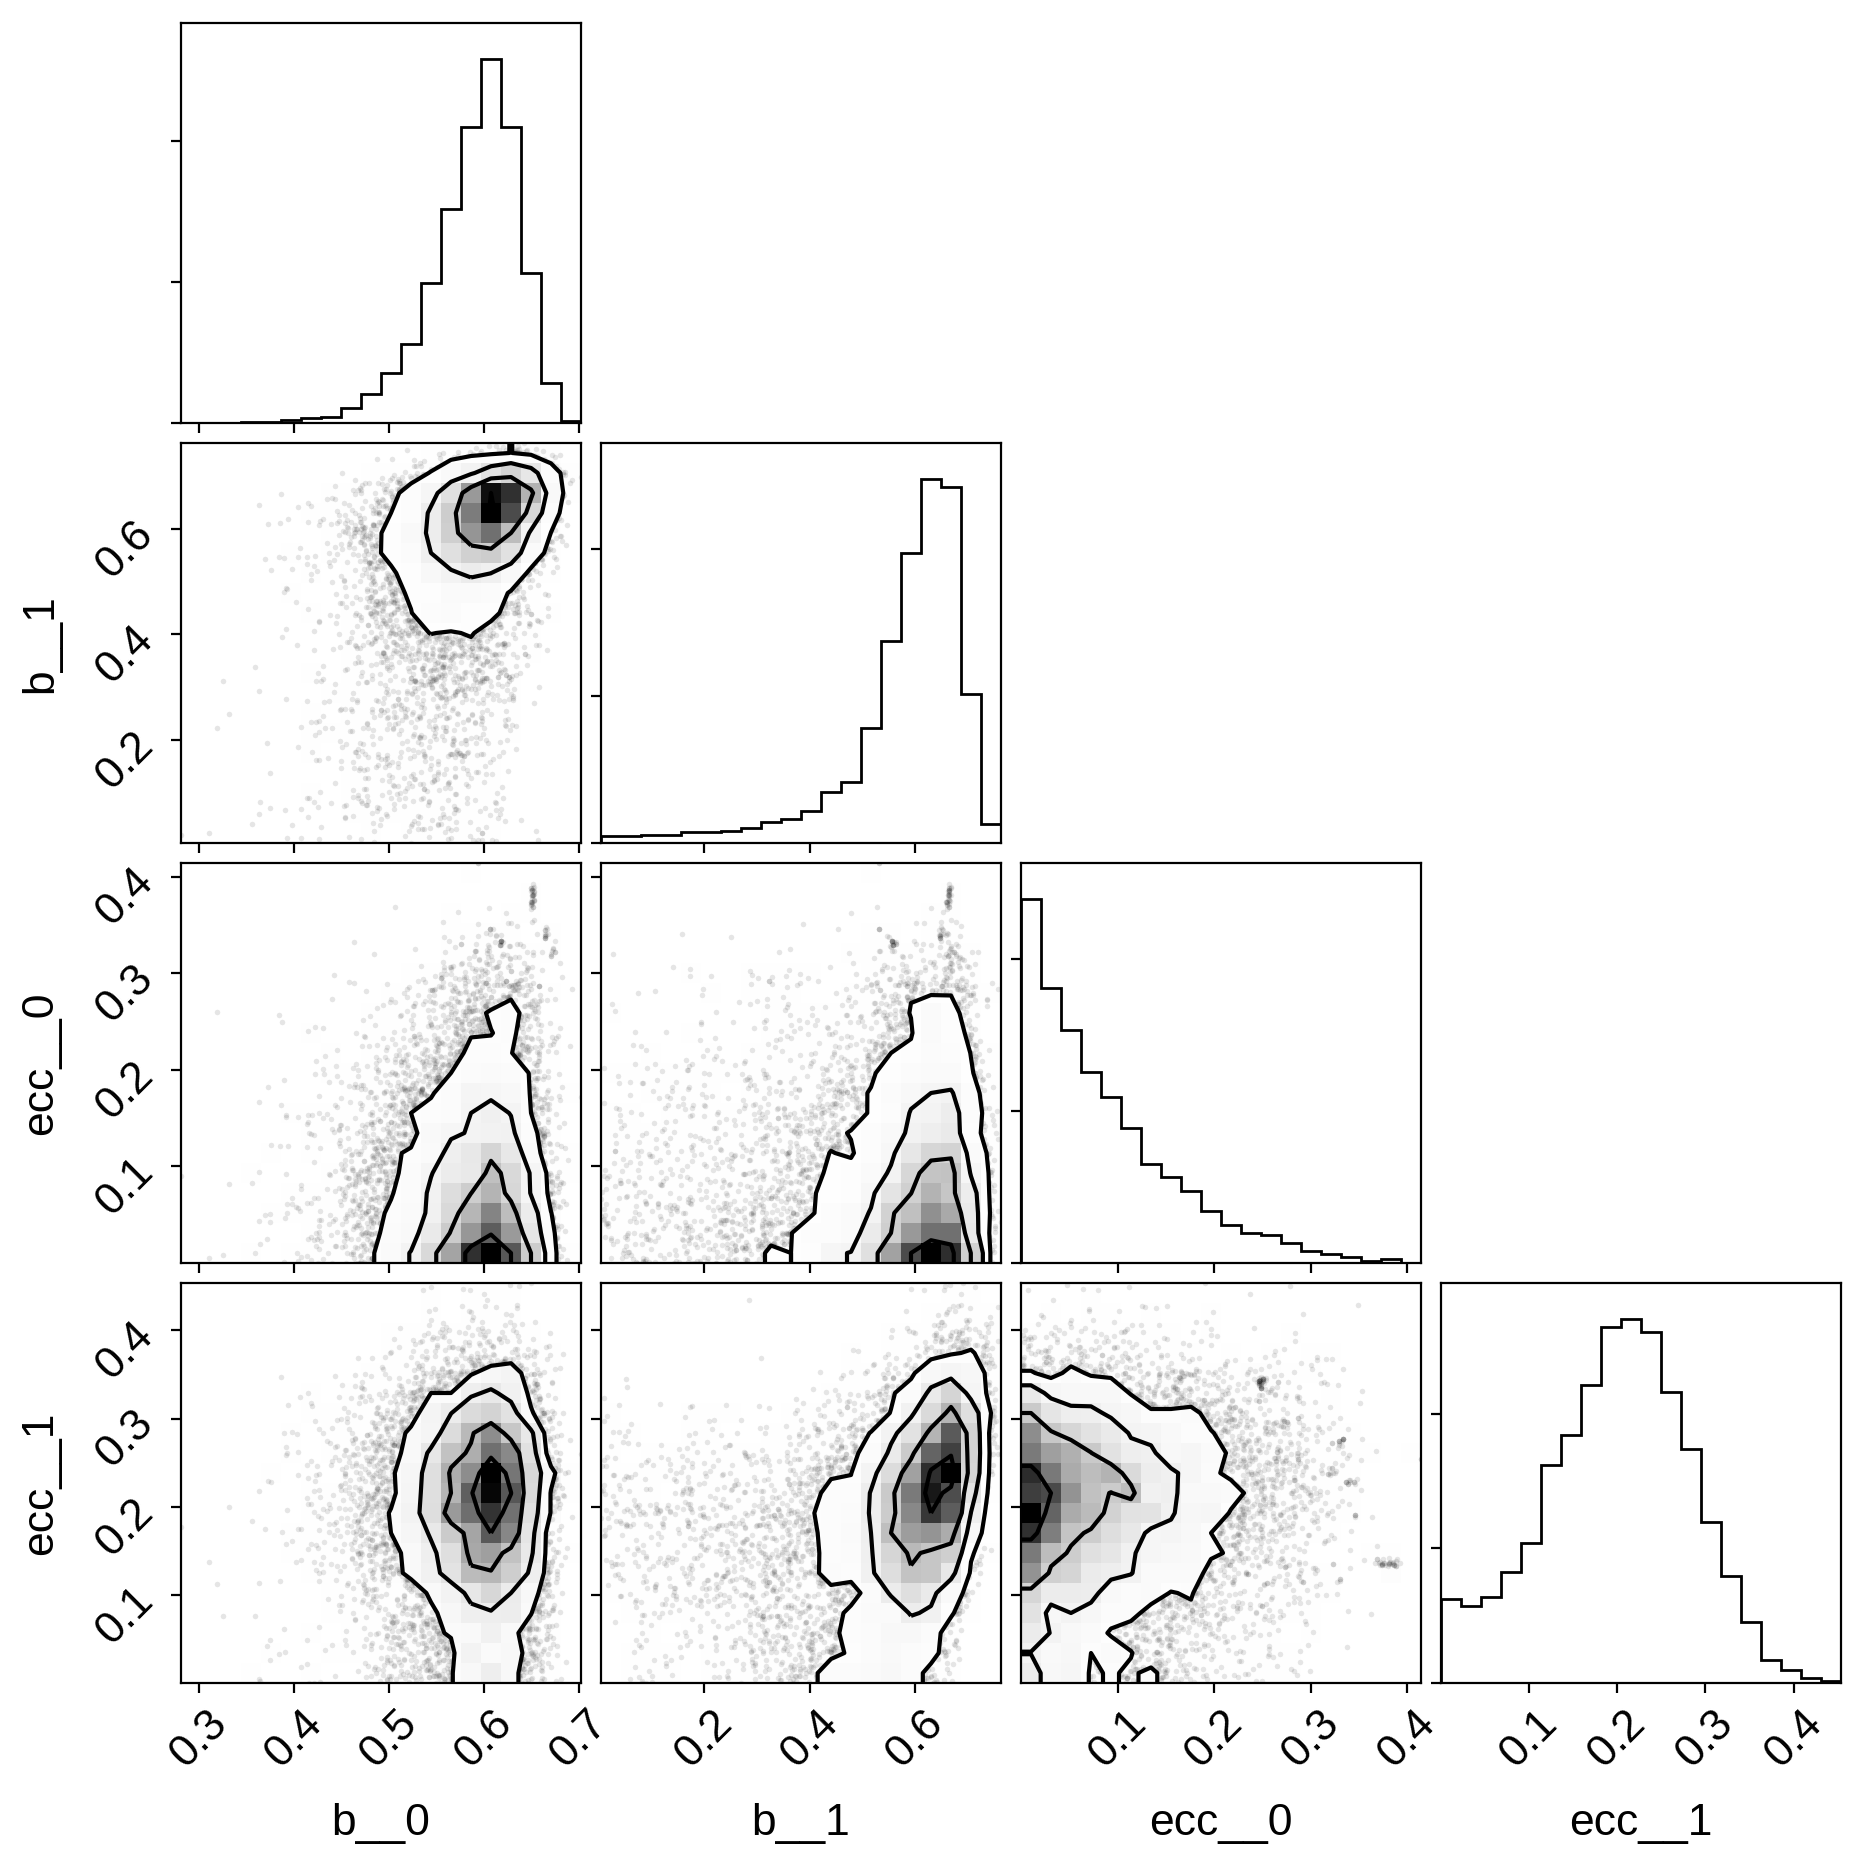

In [18]:
import corner
varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

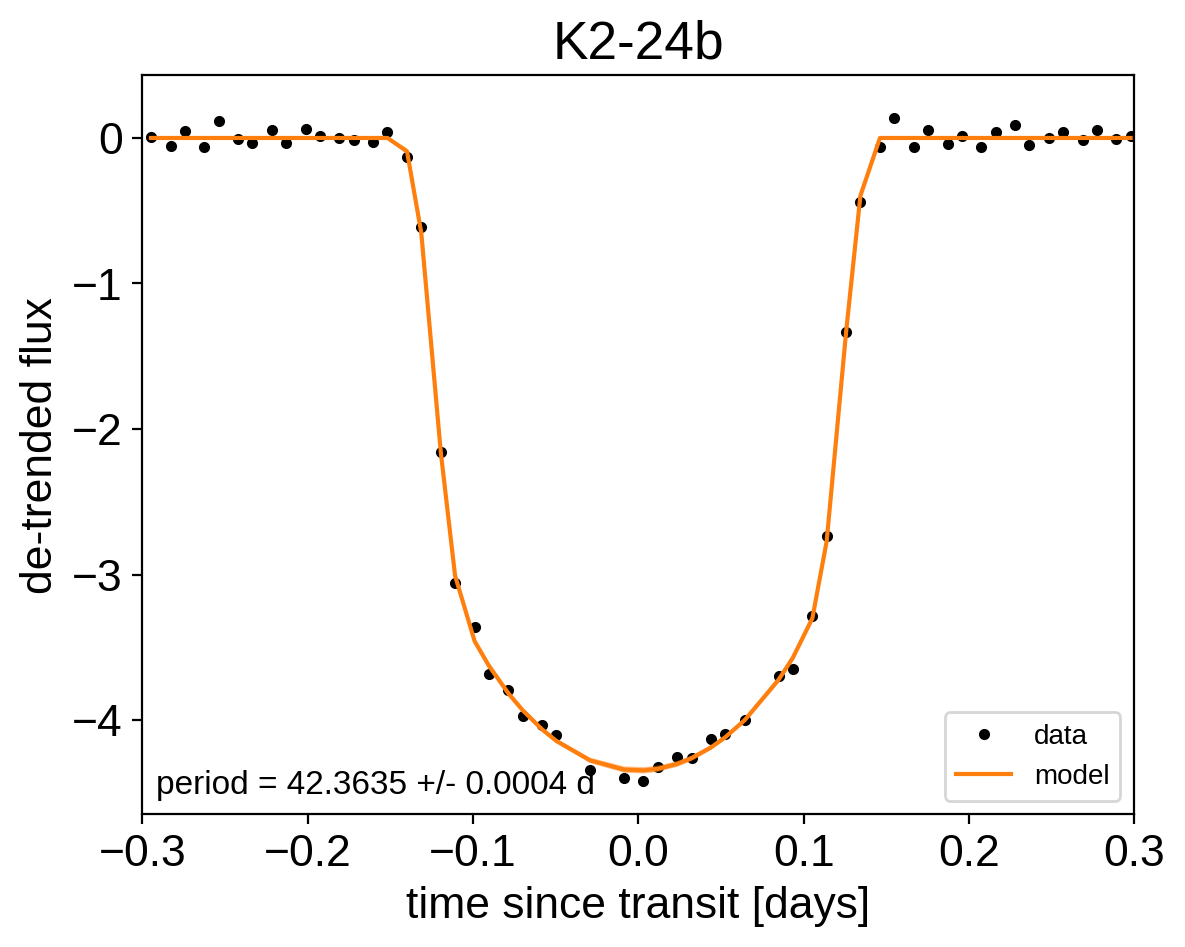

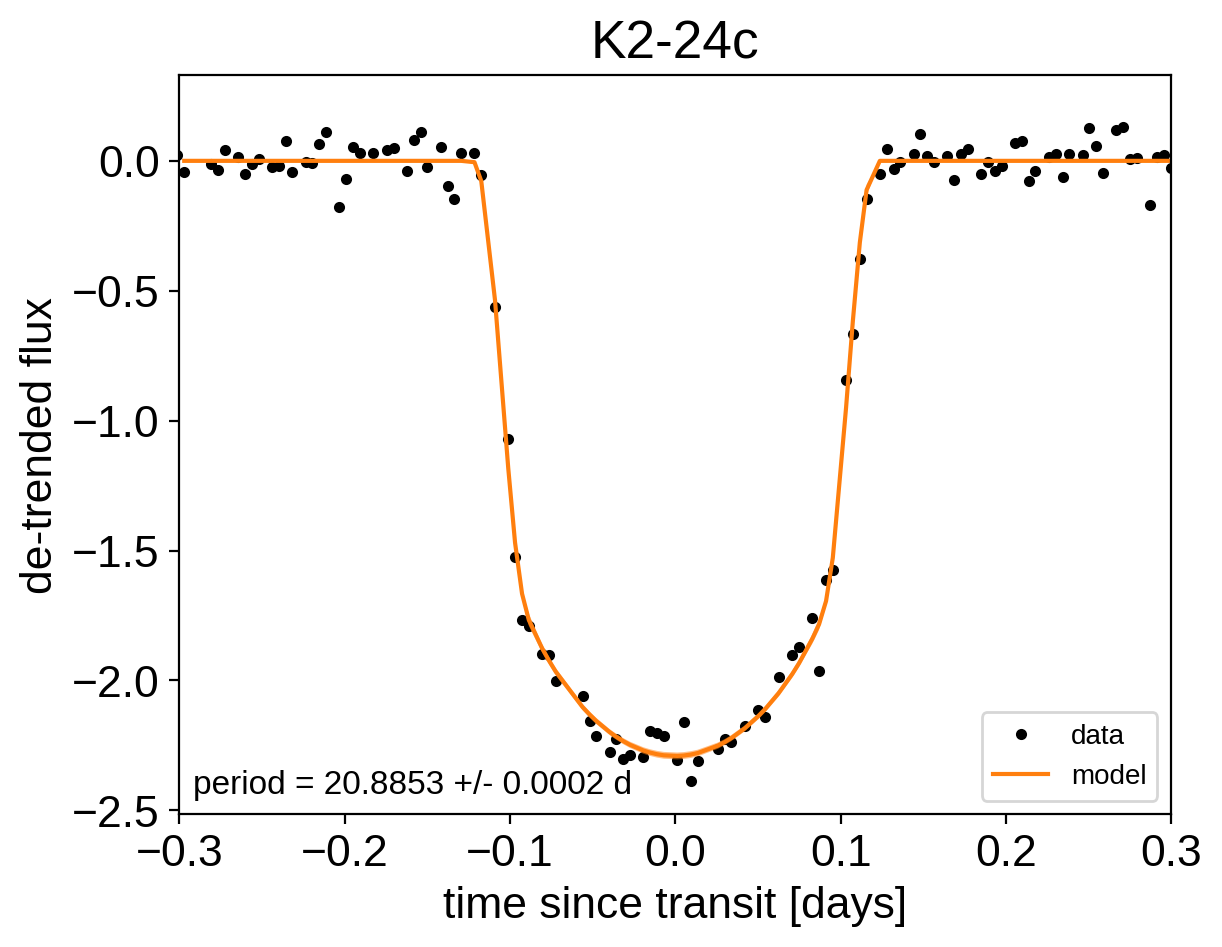

In [19]:
for n, letter in enumerate("bc"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter));
    plt.xlim(-0.3, 0.3)

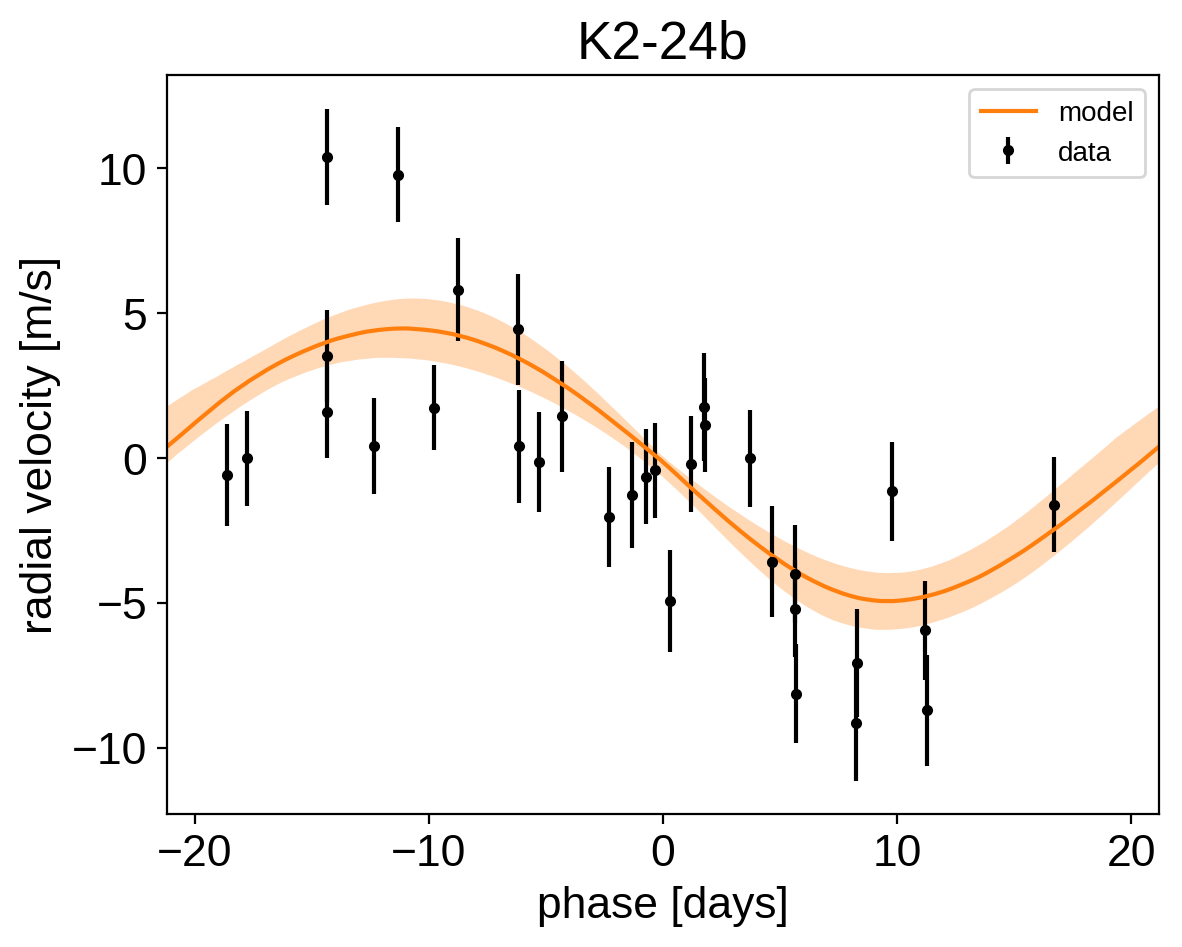

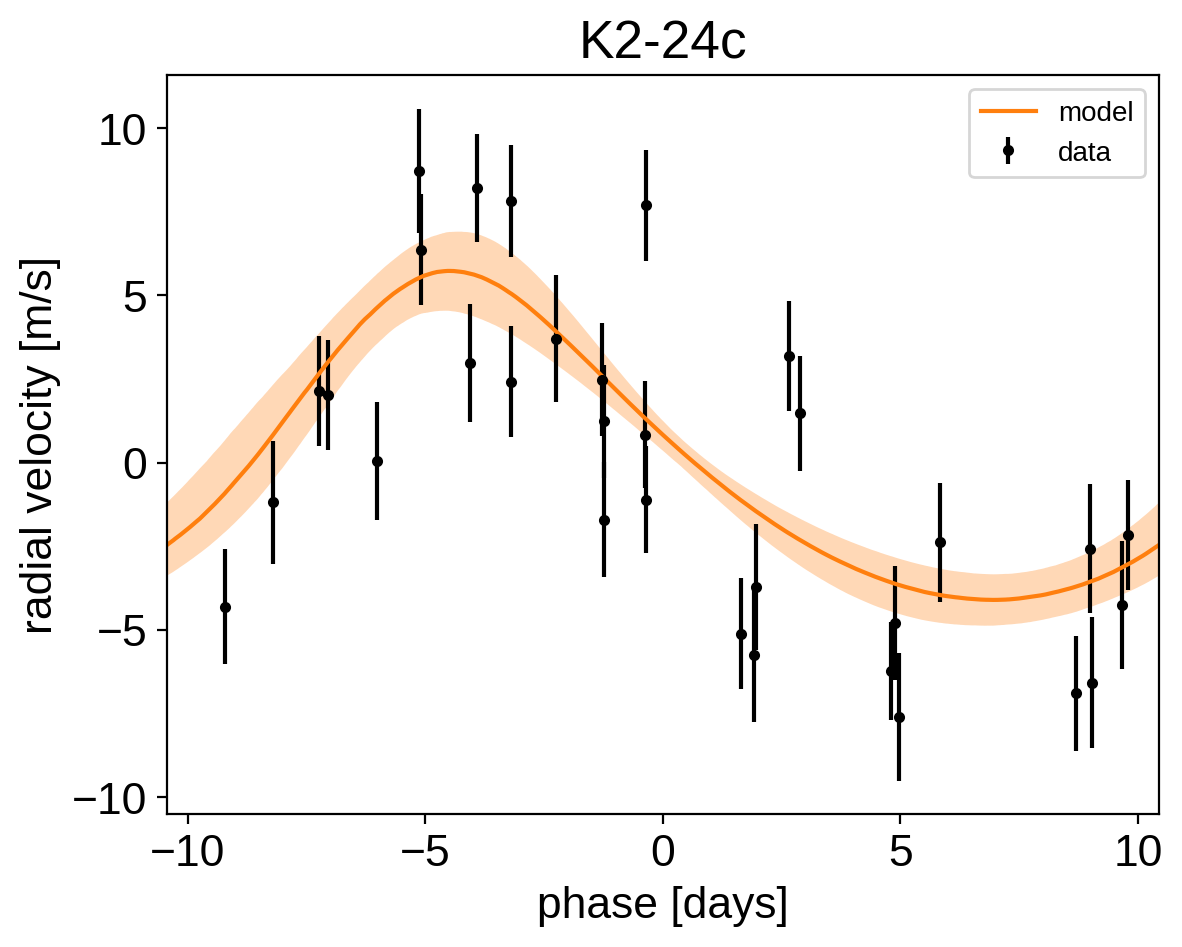

In [20]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

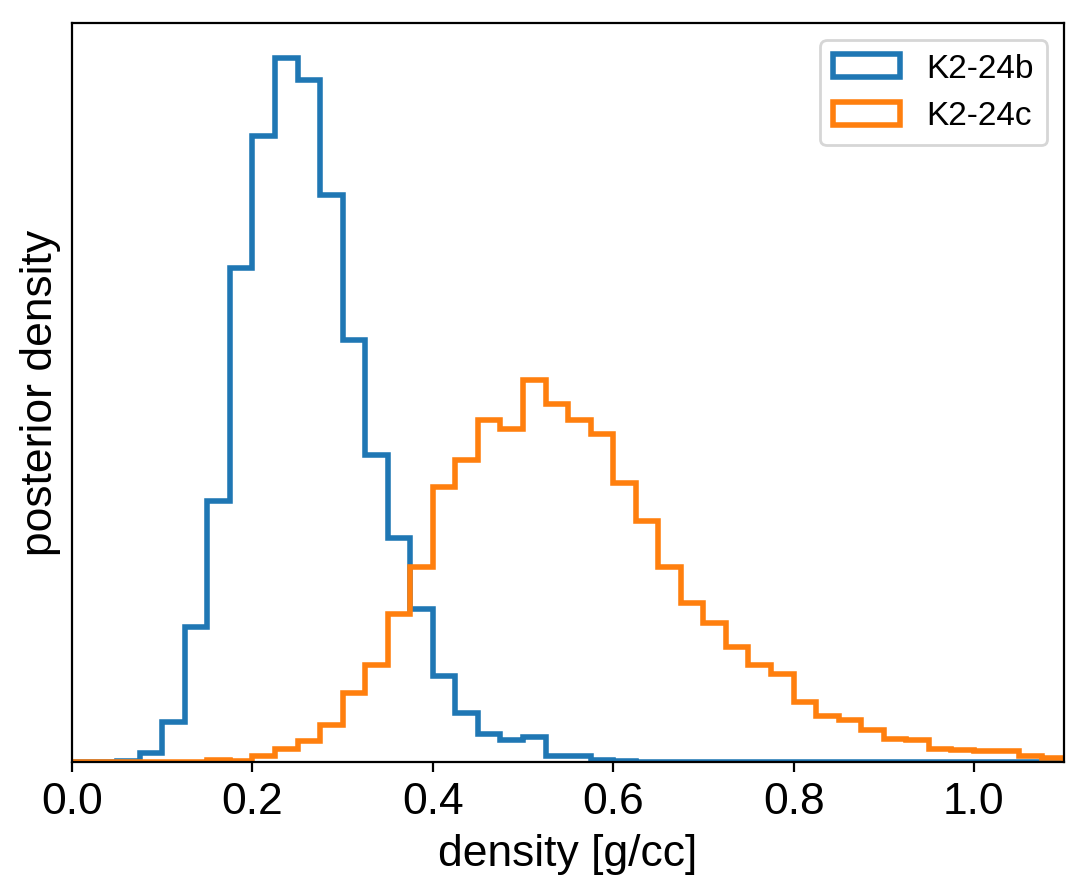

In [21]:
volume = 4/3*np.pi*trace["r_pl"]**3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):    
    plt.hist(density[:, n], bins, histtype="step", lw=2,
             label="K2-24{0}".format(letter), density=True)
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [22]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [23]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
